In [1]:
#using Pkg
#Pkg.add(PackageSpec(name="JWAS",rev="master"))
#Pkg.add("RecipesBase")
#using RecipesBase

In [2]:
#methods(add_genotypes)

In [3]:
using DataFrames              # package for working with data sets
using JWAS                    # package for Bayesian regression analyses, including BayesB and BayesCπ        
#using JWAS:misc               # utility functions
using JWAS.Datasets
using Distributions       
using Plots                   # package for plotting 
using CSV
using LinearAlgebra,Statistics,Random,DelimitedFiles, DataFrames

In [4]:
phenotypes = CSV.read("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/production_1_7_Complete_EXP_Health_WFI.dat", types=Dict(:ID => String, :SlaughterDate => String), delim = ' ',header=true, missingstrings=["NA"] )
phenotypes= dropmissing(phenotypes, :FinPenBatch)
phenotypes= dropmissing(phenotypes, :SlaughterDate)
phenotypes= dropmissing(phenotypes, :PreSlaughterWt)
first(phenotypes,10)

,ID,Cycle,BatchNum,Batch,Company,SowID,NurEnrich,QNurPenBatch,NurPenBatch
,String,Int64,Int64,String,String,String,Bool,String,String?
1,0001,1,1,1B,A,1B_1715,false,1B_D04,1B_D04
2,0002,1,1,1B,A,1B_1642,false,1B_D04,1B_D04
3,0004,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
4,0005,1,1,1B,A,1B_1980,false,1B_D04,1B_D04
5,0007,1,1,1B,A,1B_2150,false,1B_D04,1B_D04
6,0009,1,1,1B,A,1B_1902,false,1B_D02,1B_D02
7,0010,1,1,1B,A,1B_1885,false,1B_D02,1B_D02
8,0011,1,1,1B,A,1B_2097,false,1B_D02,1B_D02
9,0012,1,1,1B,A,1B_1902,false,1B_D02,1B_D02


In [5]:
DLD_model_equations = "DLD = intercept + Batch + SlaughterDate + SlaughterAge + PreSlaughterWt+ FinPenBatch + SowID"
DLD_R=16.4286
DLD_model=build_model(DLD_model_equations,DLD_R);
set_covariate(DLD_model,"SlaughterAge")
set_covariate(DLD_model,"PreSlaughterWt")
DLD_G1=0.580285
set_random(DLD_model,"FinPenBatch",DLD_G1)
DLD_G2=1.14875
set_random(DLD_model,"SowID",DLD_G2)

In [6]:
function readMatBin(fileName)
    genStr = open(fileName)
    n = read(genStr,Int64)
    p = read(genStr,Int64)
    M = zeros(n,p)
    for j in 1:p
        for i in 1:n
            M[i,j] = read(genStr,Float64)
        end
    end
    close(genStr)
    return M
end
@time M = readMatBin("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.gen.bin")

 18.834980 seconds (19.25 k allocations: 10.392 GiB, 0.12% gc time)


3205×435172 Array{Float64,2}:
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  2.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  1.0  2.0  0.0  1.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  2.0  2.0  0.0  2.0  2.0     0.0  2.0  1.0  2.0  2.0  2.0  2.0
 1.0  1.0  0.0  1.0  2.0  0.0  0.0  2.0  …  0.0  2.0  0.0  2.0  2.0  2.0  2.0
 0.0  2.0  0.0  0.0  2.0  0.0  0.0  2.0     0.0  2.0  0.0  2.0  2.0  2.0  2.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [7]:
rowID = vec(readdlm("/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ALGP2_Cycle_1_7_Geno_Complete_Impute_JWAS.bin.ids.txt",String))
DLD_G3=10.0503
@time add_genotypes(DLD_model,M,DLD_G3,header=false, rowID=rowID)
#@time add_genotypes(Nur2ADG_model,"Geno_JWAS_impute.txt",Nur2ADG_G3,separator=' ')

The marker IDs are set to 1,2,...,#markers
#markers: 435172; #individuals: 3205
 15.563866 seconds (8.08 M allocations: 15.987 GiB, 1.45% gc time)


4.0f0

In [8]:
@time DLD_outB=runMCMC(DLD_model,phenotypes,methods="BayesB", missing_phenotypes=true, Pi=0.999, estimateScale=true, chain_length=50000,burnin = 5000,output_heritability=true,  output_samples_frequency=100)

The folder results is created to save results.
Checking phenotypes...
Individual IDs (strings) are provided in the first column of the phenotypic data.
Phenotypes for all traits included in the model for individual 0004 in the row 3 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0024 in the row 21 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0056 in the row 52 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0057 in the row 53 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0103 in the row 87 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0106 in the row 90 are missing. This record is deleted.
Phenotypes for all traits included in the model for individual 0119 in the row 99 are missing. This record is deleted.
Phenotypes for a

running MCMC ...100%|███████████████████████████████████| Time: 5:09:40




The version of Julia and Platform in use:

Julia Version 1.1.0
Commit 80516ca202 (2019-01-21 21:24 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-5960X CPU @ 3.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_DEPOT_PATH = /opt/julia
  JULIA_PKGDIR = /opt/julia
  JULIA_VERSION = 1.1.0


The analysis has finished. Results are saved in the returned variable and text files. MCMC samples are saved in text files.


18621.851299 seconds (90.30 G allocations: 1.803 TiB, 1.47% gc time)


Dict{Any,Any} with 7 entries:
  "ScaleEffectVargeno"  => 1×3 DataFrame…
  "heritability"        => 1×3 DataFrame…
  "location parameters" => 1221×5 DataFrame…
  "residual variance"   => 1×3 DataFrame…
  "marker effects geno" => 435172×5 DataFrame…
  "EBV_DLD"             => 3205×3 DataFrame…
  "genetic_variance"    => 1×3 DataFrame…

In [9]:
h2=CSV.read("MCMC_samples_heritability.txt",delim = ' ',header=true)
insertcols!(h2, 1, :iteration => 1:450) # Add a column called iteration

,iteration,DLD
,Int64,Float64
1,1,0.282145
2,2,0.205263
3,3,0.29623
4,4,0.242386
5,5,0.222176
6,6,0.224599
7,7,0.272438
8,8,0.276262
9,9,0.260331


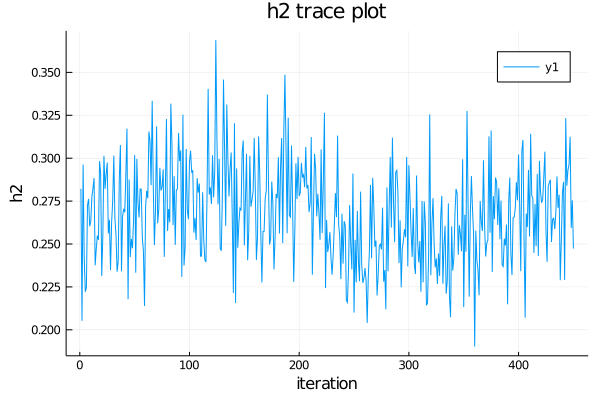

In [10]:
using Plots
x = h2[!,1]; y = h2[!,2]; # These are the plotting data
plot(x,y, title = "h2 trace plot",
        xlabel = "iteration", ylabel = "h2")

In [11]:
@time DLD_outB,DLD_winVarProps = GWAS("results/MCMC_samples_marker_effects_geno_DLD.txt","/home/jovyan/mark/JWAS_CDPQ/CDPQ_all_data/ChrInfo_map_1_7_Complete_JWAS.txt",
    M;header=true,window_size="0.25 Mb",threshold=0.001)

Compute the posterior probability of association of the genomic window that explains more than 0.001 of the total genetic variance.


running GWAS...100%|████████████████████████████████████| Time: 0:36:14


BoundsError: BoundsError: attempt to access (9375×13 DataFrame
│ Row  │ trait │ window │ chr    │ wStart    │ wEnd      │ start_SNP │ end_SNP   │ numSNP │ estimateGenVar │ stdGenVar   │ prGenVar │ WPPA       │ PPA_t     │
│      │ Int64 │ Int64  │ String │ Int64     │ Int64     │ Int64     │ Int64     │ Int64  │ Float64        │ Float64     │ Float64  │ Float64    │ Float64   │
├──────┼───────┼────────┼────────┼───────────┼───────────┼───────────┼───────────┼────────┼────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1    │ 1     │ 8643   │ 17     │ 15250000  │ 15500000  │ 15254076  │ 15499427  │ 60     │ 0.165766       │ 0.157562    │ 1.84     │ 0.735556   │ 0.735556  │
│ 2    │ 1     │ 2513   │ 4      │ 69250000  │ 69500000  │ 69252035  │ 69496787  │ 66     │ 0.0902184      │ 0.125804    │ 1.02     │ 0.52       │ 0.627778  │
│ 3    │ 1     │ 5996   │ 11     │ 64500000  │ 64750000  │ 64536537  │ 64749198  │ 6      │ 0.0610346      │ 0.113939    │ 0.67     │ 0.308889   │ 0.521481  │
│ 4    │ 1     │ 65     │ 1      │ 16000000  │ 16250000  │ 16000593  │ 16245310  │ 44     │ 0.0398126      │ 0.082925    │ 0.44     │ 0.284444   │ 0.462222  │
│ 5    │ 1     │ 5127   │ 9      │ 55750000  │ 56000000  │ 55750411  │ 55997883  │ 61     │ 0.0406745      │ 0.0893536   │ 0.45     │ 0.273333   │ 0.424444  │
│ 6    │ 1     │ 4377   │ 8      │ 7250000   │ 7500000   │ 7254350   │ 7496154   │ 48     │ 0.0404753      │ 0.0890543   │ 0.45     │ 0.266667   │ 0.398148  │
│ 7    │ 1     │ 3742   │ 6      │ 141500000 │ 141750000 │ 141514587 │ 141748543 │ 47     │ 0.0261256      │ 0.0612236   │ 0.29     │ 0.237778   │ 0.375238  │
│ 8    │ 1     │ 2      │ 1      │ 250000    │ 500000    │ 251883    │ 496376    │ 54     │ 0.0416547      │ 0.10376     │ 0.45     │ 0.222222   │ 0.356111  │
│ 9    │ 1     │ 4378   │ 8      │ 7500000   │ 7750000   │ 7501954   │ 7749352   │ 61     │ 0.0280063      │ 0.069475    │ 0.3      │ 0.22       │ 0.340988  │
│ 10   │ 1     │ 1023   │ 1      │ 255750000 │ 256000000 │ 255750564 │ 255999886 │ 75     │ 0.0176241      │ 0.0524097   │ 0.19     │ 0.215556   │ 0.328444  │
│ 11   │ 1     │ 1808   │ 3      │ 26000000  │ 26250000  │ 26003466  │ 26248615  │ 51     │ 0.02542        │ 0.0659306   │ 0.28     │ 0.206667   │ 0.317374  │
│ 12   │ 1     │ 3914   │ 7      │ 13500000  │ 13750000  │ 13518453  │ 13749203  │ 49     │ 0.0354411      │ 0.0932673   │ 0.39     │ 0.197778   │ 0.307407  │
│ 13   │ 1     │ 1026   │ 1      │ 256500000 │ 256750000 │ 256502461 │ 256749135 │ 73     │ 0.0202432      │ 0.05324     │ 0.23     │ 0.188889   │ 0.298291  │
│ 14   │ 1     │ 4461   │ 8      │ 28250000  │ 28500000  │ 28251022  │ 28497830  │ 54     │ 0.0282755      │ 0.0769768   │ 0.32     │ 0.186667   │ 0.290317  │
│ 15   │ 1     │ 3846   │ 6      │ 167500000 │ 167750000 │ 167501448 │ 167748126 │ 33     │ 0.0180359      │ 0.0499641   │ 0.2      │ 0.184444   │ 0.283259  │
│ 16   │ 1     │ 8449   │ 16     │ 46750000  │ 47000000  │ 46760712  │ 46999109  │ 40     │ 0.0257167      │ 0.0748156   │ 0.28     │ 0.184444   │ 0.277083  │
│ 17   │ 1     │ 2683   │ 4      │ 111750000 │ 112000000 │ 111750758 │ 111995964 │ 94     │ 0.015571       │ 0.0420561   │ 0.17     │ 0.182222   │ 0.271503  │
│ 18   │ 1     │ 3845   │ 6      │ 167250000 │ 167500000 │ 167250784 │ 167497141 │ 62     │ 0.0176191      │ 0.0571343   │ 0.2      │ 0.182222   │ 0.266543  │
│ 19   │ 1     │ 4376   │ 8      │ 7000000   │ 7250000   │ 7003810   │ 7248711   │ 74     │ 0.0165149      │ 0.0463329   │ 0.19     │ 0.18       │ 0.261988  │
│ 20   │ 1     │ 7557   │ 14     │ 105750000 │ 106000000 │ 105750939 │ 105990792 │ 55     │ 0.017152       │ 0.0499104   │ 0.19     │ 0.18       │ 0.257889  │
│ 21   │ 1     │ 7577   │ 14     │ 110750000 │ 111000000 │ 110750129 │ 110996258 │ 63     │ 0.0144506      │ 0.0445638   │ 0.16     │ 0.18       │ 0.25418   │
│ 22   │ 1     │ 8905   │ 18     │ 17500000  │ 17750000  │ 17502980  │ 17742162  │ 54     │ 0.0158626      │ 0.0486746   │ 0.18     │ 0.18       │ 0.250808  │
│ 23   │ 1     │ 4405   │ 8      │ 14250000  │ 14500000  │ 14250025  │ 14497623  │ 61     │ 0.0168197      │ 0.0504647   │ 0.19     │ 0.177778   │ 0.247633  │
│ 24   │ 1     │ 4299   │ 7      │ 109750000 │ 110000000 │ 109751793 │ 109976377 │ 64     │ 0.015658       │ 0.0456472   │ 0.18     │ 0.173333   │ 0.244537  │
│ 25   │ 1     │ 1813   │ 3      │ 27250000  │ 27500000  │ 27252572  │ 27499161  │ 77     │ 0.023653       │ 0.0700183   │ 0.26     │ 0.171111   │ 0.2416    │
│ 26   │ 1     │ 4300   │ 7      │ 110000000 │ 110250000 │ 110006808 │ 110249512 │ 68     │ 0.0162949      │ 0.0503197   │ 0.18     │ 0.164444   │ 0.238632  │
│ 27   │ 1     │ 4380   │ 8      │ 8000000   │ 8250000   │ 8003511   │ 8249006   │ 65     │ 0.024378       │ 0.0730443   │ 0.28     │ 0.162222   │ 0.235802  │
│ 28   │ 1     │ 4659   │ 8      │ 77750000  │ 78000000  │ 77753455  │ 77998224  │ 43     │ 0.0160186      │ 0.0526082   │ 0.17     │ 0.162222   │ 0.233175  │
│ 29   │ 1     │ 6584   │ 13     │ 70500000  │ 70750000  │ 70505993  │ 70746241  │ 57     │ 0.0162981      │ 0.0542927   │ 0.18     │ 0.162222   │ 0.230728  │
│ 30   │ 1     │ 7423   │ 14     │ 72250000  │ 72500000  │ 72261851  │ 72496356  │ 70     │ 0.014799       │ 0.0489056   │ 0.17     │ 0.162222   │ 0.228444  │
│ 31   │ 1     │ 3912   │ 7      │ 13000000  │ 13250000  │ 13002660  │ 13233996  │ 44     │ 0.0219437      │ 0.0613292   │ 0.24     │ 0.16       │ 0.226237  │
│ 32   │ 1     │ 5092   │ 9      │ 47000000  │ 47250000  │ 47002079  │ 47248228  │ 51     │ 0.0234974      │ 0.074992    │ 0.26     │ 0.16       │ 0.224167  │
│ 33   │ 1     │ 2801   │ 5      │ 10250000  │ 10500000  │ 10251491  │ 10492541  │ 61     │ 0.0171156      │ 0.0550116   │ 0.19     │ 0.153333   │ 0.22202   │
│ 34   │ 1     │ 3747   │ 6      │ 142750000 │ 143000000 │ 142753879 │ 142997731 │ 46     │ 0.017426       │ 0.0556748   │ 0.19     │ 0.153333   │ 0.22      │
│ 35   │ 1     │ 5531   │ 10     │ 17500000  │ 17750000  │ 17504351  │ 17743923  │ 63     │ 0.0205271      │ 0.0604757   │ 0.22     │ 0.153333   │ 0.218095  │
│ 36   │ 1     │ 4407   │ 8      │ 14750000  │ 15000000  │ 14754349  │ 14996010  │ 62     │ 0.0133311      │ 0.0420326   │ 0.15     │ 0.146667   │ 0.216111  │
│ 37   │ 1     │ 5622   │ 10     │ 40250000  │ 40500000  │ 40259321  │ 40495573  │ 68     │ 0.0186363      │ 0.062214    │ 0.21     │ 0.142222   │ 0.214114  │
│ 38   │ 1     │ 8452   │ 16     │ 47500000  │ 47750000  │ 47502143  │ 47749699  │ 49     │ 0.0161067      │ 0.0534664   │ 0.18     │ 0.142222   │ 0.212222  │
│ 39   │ 1     │ 8865   │ 18     │ 7500000   │ 7750000   │ 7500197   │ 7747556   │ 46     │ 0.0137183      │ 0.0478941   │ 0.15     │ 0.142222   │ 0.210427  │
│ 40   │ 1     │ 9025   │ 18     │ 47500000  │ 47750000  │ 47503969  │ 47749481  │ 65     │ 0.0103365      │ 0.0385523   │ 0.11     │ 0.14       │ 0.208667  │
│ 41   │ 1     │ 5516   │ 10     │ 13750000  │ 14000000  │ 13750902  │ 13998342  │ 59     │ 0.0124305      │ 0.0414124   │ 0.14     │ 0.137778   │ 0.206938  │
│ 42   │ 1     │ 7350   │ 14     │ 54000000  │ 54250000  │ 54006810  │ 54248395  │ 61     │ 0.0147478      │ 0.0541225   │ 0.17     │ 0.137778   │ 0.205291  │
│ 43   │ 1     │ 2505   │ 4      │ 67250000  │ 67500000  │ 67250913  │ 67490111  │ 64     │ 0.0142204      │ 0.047127    │ 0.16     │ 0.135556   │ 0.203669  │
│ 44   │ 1     │ 2758   │ 4      │ 130500000 │ 130750000 │ 130507528 │ 130747481 │ 58     │ 0.00805551     │ 0.025821    │ 0.09     │ 0.135556   │ 0.202121  │
│ 45   │ 1     │ 5679   │ 10     │ 54500000  │ 54750000  │ 54504352  │ 54748317  │ 54     │ 0.0140788      │ 0.0446858   │ 0.16     │ 0.135556   │ 0.200642  │
│ 46   │ 1     │ 6583   │ 13     │ 70250000  │ 70500000  │ 70285583  │ 70495330  │ 55     │ 0.0232938      │ 0.0839867   │ 0.25     │ 0.135556   │ 0.199227  │
│ 47   │ 1     │ 1      │ 1      │ 0         │ 250000    │ 10204     │ 247624    │ 47     │ 0.0171226      │ 0.0570502   │ 0.18     │ 0.133333   │ 0.197825  │
│ 48   │ 1     │ 1748   │ 3      │ 11000000  │ 11250000  │ 11001814  │ 11249284  │ 70     │ 0.00879621     │ 0.029677    │ 0.1      │ 0.133333   │ 0.196481  │
│ 49   │ 1     │ 3746   │ 6      │ 142500000 │ 142750000 │ 142506238 │ 142746654 │ 37     │ 0.0142339      │ 0.0517606   │ 0.15     │ 0.128889   │ 0.195102  │
│ 50   │ 1     │ 1103   │ 2      │ 1250000   │ 1500000   │ 1256452   │ 1481038   │ 10     │ 0.0341714      │ 0.113737    │ 0.37     │ 0.126667   │ 0.193733  │
│ 51   │ 1     │ 1769   │ 3      │ 16250000  │ 16500000  │ 16254189  │ 16497764  │ 61     │ 0.00825679     │ 0.0302653   │ 0.09     │ 0.124444   │ 0.192375  │
│ 52   │ 1     │ 5995   │ 11     │ 64250000  │ 64500000  │ 64254303  │ 64480008  │ 39     │ 0.0164988      │ 0.0569931   │ 0.18     │ 0.124444   │ 0.191068  │
│ 53   │ 1     │ 8082   │ 15     │ 95500000  │ 95750000  │ 95515332  │ 95744456  │ 43     │ 0.0121843      │ 0.0431848   │ 0.14     │ 0.124444   │ 0.189811  │
│ 54   │ 1     │ 151    │ 1      │ 37500000  │ 37750000  │ 37500545  │ 37748484  │ 70     │ 0.00896651     │ 0.038808    │ 0.1      │ 0.117778   │ 0.188477  │
│ 55   │ 1     │ 955    │ 1      │ 238750000 │ 239000000 │ 238754516 │ 238995914 │ 58     │ 0.0132003      │ 0.0460836   │ 0.15     │ 0.117778   │ 0.187192  │
│ 56   │ 1     │ 3913   │ 7      │ 13250000  │ 13500000  │ 13307082  │ 13497808  │ 38     │ 0.0117578      │ 0.0418052   │ 0.13     │ 0.117778   │ 0.185952  │
│ 57   │ 1     │ 4381   │ 8      │ 8250000   │ 8500000   │ 8251151   │ 8496417   │ 61     │ 0.0156494      │ 0.0571058   │ 0.17     │ 0.117778   │ 0.184756  │
│ 58   │ 1     │ 696    │ 1      │ 174000000 │ 174250000 │ 174003287 │ 174245481 │ 44     │ 0.00922317     │ 0.0335448   │ 0.11     │ 0.115556   │ 0.183563  │
│ 59   │ 1     │ 1022   │ 1      │ 255500000 │ 255750000 │ 255500712 │ 255747528 │ 77     │ 0.00870833     │ 0.0329006   │ 0.09     │ 0.115556   │ 0.182411  │
│ 60   │ 1     │ 5131   │ 9      │ 56750000  │ 57000000  │ 56753316  │ 56998575  │ 54     │ 0.00956865     │ 0.0333807   │ 0.11     │ 0.115556   │ 0.181296  │
│ 61   │ 1     │ 7291   │ 14     │ 39250000  │ 39500000  │ 39254698  │ 39495748  │ 54     │ 0.00742626     │ 0.0243004   │ 0.08     │ 0.115556   │ 0.180219  │
│ 62   │ 1     │ 8058   │ 15     │ 89500000  │ 89750000  │ 89512189  │ 89743051  │ 23     │ 0.014705       │ 0.0555659   │ 0.16     │ 0.115556   │ 0.179176  │
│ 63   │ 1     │ 5522   │ 10     │ 15250000  │ 15500000  │ 15259009  │ 15495375  │ 66     │ 0.0125119      │ 0.0477609   │ 0.14     │ 0.113333   │ 0.178131  │
│ 64   │ 1     │ 6233   │ 12     │ 44500000  │ 44750000  │ 44502978  │ 44748220  │ 68     │ 0.0068685      │ 0.0251415   │ 0.08     │ 0.113333   │ 0.177118  │
│ 65   │ 1     │ 6298   │ 12     │ 60750000  │ 61000000  │ 60757842  │ 60999657  │ 46     │ 0.00770757     │ 0.0309669   │ 0.08     │ 0.111111   │ 0.176103  │
│ 66   │ 1     │ 7561   │ 14     │ 106750000 │ 107000000 │ 106750452 │ 106997098 │ 80     │ 0.0081613      │ 0.0289272   │ 0.09     │ 0.111111   │ 0.175118  │
│ 67   │ 1     │ 7653   │ 14     │ 129750000 │ 130000000 │ 129750106 │ 129998870 │ 69     │ 0.00641637     │ 0.0238639   │ 0.07     │ 0.111111   │ 0.174163  │
│ 68   │ 1     │ 2540   │ 4      │ 76000000  │ 76250000  │ 76038547  │ 76249467  │ 44     │ 0.00650661     │ 0.0238188   │ 0.07     │ 0.108889   │ 0.173203  │
│ 69   │ 1     │ 4353   │ 8      │ 1250000   │ 1500000   │ 1250386   │ 1496896   │ 63     │ 0.00576597     │ 0.0208504   │ 0.06     │ 0.108889   │ 0.172271  │
│ 70   │ 1     │ 5621   │ 10     │ 40000000  │ 40250000  │ 40000791  │ 40247032  │ 63     │ 0.00527489     │ 0.0188542   │ 0.06     │ 0.108889   │ 0.171365  │
│ 71   │ 1     │ 7352   │ 14     │ 54500000  │ 54750000  │ 54500038  │ 54749543  │ 66     │ 0.00859572     │ 0.0357152   │ 0.1      │ 0.108889   │ 0.170485  │
│ 72   │ 1     │ 7353   │ 14     │ 54750000  │ 55000000  │ 54757348  │ 54993594  │ 76     │ 0.00861228     │ 0.0342337   │ 0.1      │ 0.108889   │ 0.16963   │
│ 73   │ 1     │ 2597   │ 4      │ 90250000  │ 90500000  │ 90250028  │ 90495919  │ 73     │ 0.00786681     │ 0.0299265   │ 0.09     │ 0.106667   │ 0.168767  │
│ 74   │ 1     │ 2601   │ 4      │ 91250000  │ 91500000  │ 91251186  │ 91495198  │ 68     │ 0.00771365     │ 0.0325512   │ 0.09     │ 0.106667   │ 0.167928  │
│ 75   │ 1     │ 4298   │ 7      │ 109500000 │ 109750000 │ 109508118 │ 109749908 │ 64     │ 0.00801734     │ 0.0309941   │ 0.09     │ 0.106667   │ 0.167111  │
│ 76   │ 1     │ 4403   │ 8      │ 13750000  │ 14000000  │ 13761855  │ 13997222  │ 52     │ 0.010063       │ 0.0408552   │ 0.11     │ 0.106667   │ 0.166316  │
│ 77   │ 1     │ 4874   │ 8      │ 131500000 │ 131750000 │ 131502354 │ 131749137 │ 67     │ 0.00492007     │ 0.0198495   │ 0.05     │ 0.106667   │ 0.165541  │
│ 78   │ 1     │ 5517   │ 10     │ 14000000  │ 14250000  │ 14026569  │ 14242539  │ 49     │ 0.00856166     │ 0.0307243   │ 0.1      │ 0.106667   │ 0.164786  │
│ 79   │ 1     │ 7684   │ 14     │ 137500000 │ 137750000 │ 137501931 │ 137742410 │ 62     │ 0.00891838     │ 0.0329421   │ 0.1      │ 0.106667   │ 0.164051  │
│ 80   │ 1     │ 160    │ 1      │ 39750000  │ 40000000  │ 39750594  │ 39991606  │ 73     │ 0.00880466     │ 0.0342763   │ 0.1      │ 0.104444   │ 0.163306  │
│ 81   │ 1     │ 695    │ 1      │ 173750000 │ 174000000 │ 173776120 │ 173999496 │ 42     │ 0.00730743     │ 0.0323416   │ 0.08     │ 0.104444   │ 0.162579  │
│ 82   │ 1     │ 1024   │ 1      │ 256000000 │ 256250000 │ 256004810 │ 256244956 │ 65     │ 0.00509803     │ 0.0189811   │ 0.06     │ 0.104444   │ 0.16187   │
│ 83   │ 1     │ 3168   │ 5      │ 102000000 │ 102250000 │ 102003878 │ 102248859 │ 79     │ 0.00702525     │ 0.0275887   │ 0.08     │ 0.104444   │ 0.161178  │
│ 84   │ 1     │ 3743   │ 6      │ 141750000 │ 142000000 │ 141753200 │ 141999302 │ 58     │ 0.00933567     │ 0.0371538   │ 0.11     │ 0.104444   │ 0.160503  │
│ 85   │ 1     │ 8176   │ 15     │ 119000000 │ 119250000 │ 119000935 │ 119241769 │ 61     │ 0.00796161     │ 0.0299353   │ 0.09     │ 0.104444   │ 0.159843  │
│ 86   │ 1     │ 471    │ 1      │ 117750000 │ 118000000 │ 117755679 │ 117988311 │ 62     │ 0.00442657     │ 0.0165862   │ 0.05     │ 0.102222   │ 0.159173  │
│ 87   │ 1     │ 5429   │ 9      │ 131500000 │ 131750000 │ 131502016 │ 131741010 │ 64     │ 0.00966334     │ 0.036643    │ 0.11     │ 0.102222   │ 0.158519  │
│ 88   │ 1     │ 7425   │ 14     │ 72750000  │ 73000000  │ 72750395  │ 72995809  │ 67     │ 0.0115602      │ 0.0449817   │ 0.13     │ 0.102222   │ 0.157879  │
│ 89   │ 1     │ 7530   │ 14     │ 99000000  │ 99250000  │ 99001304  │ 99245933  │ 78     │ 0.0109087      │ 0.0445967   │ 0.12     │ 0.102222   │ 0.157253  │
│ 90   │ 1     │ 673    │ 1      │ 168250000 │ 168500000 │ 168251914 │ 168493893 │ 33     │ 0.00887914     │ 0.0349876   │ 0.1      │ 0.1        │ 0.156617  │
│ 91   │ 1     │ 5128   │ 9      │ 56000000  │ 56250000  │ 56015537  │ 56245696  │ 50     │ 0.00822511     │ 0.0311506   │ 0.09     │ 0.1        │ 0.155995  │
│ 92   │ 1     │ 7531   │ 14     │ 99250000  │ 99500000  │ 99250072  │ 99498608  │ 72     │ 0.00747827     │ 0.0297617   │ 0.08     │ 0.1        │ 0.155386  │
│ 93   │ 1     │ 6      │ 1      │ 1250000   │ 1500000   │ 1252256   │ 1499068   │ 72     │ 0.00838261     │ 0.0330976   │ 0.09     │ 0.0977778  │ 0.154767  │
│ 94   │ 1     │ 10     │ 1      │ 2250000   │ 2500000   │ 2251625   │ 2499085   │ 72     │ 0.00623164     │ 0.0244606   │ 0.07     │ 0.0977778  │ 0.154161  │
│ 95   │ 1     │ 1182   │ 2      │ 21250000  │ 21500000  │ 21252306  │ 21498722  │ 58     │ 0.00652643     │ 0.0230319   │ 0.07     │ 0.0977778  │ 0.153567  │
│ 96   │ 1     │ 4473   │ 8      │ 31250000  │ 31500000  │ 31253770  │ 31498101  │ 71     │ 0.00644579     │ 0.0264836   │ 0.07     │ 0.0977778  │ 0.152986  │
│ 97   │ 1     │ 7290   │ 14     │ 39000000  │ 39250000  │ 39001669  │ 39249102  │ 62     │ 0.00697692     │ 0.0254461   │ 0.08     │ 0.0977778  │ 0.152417  │
│ 98   │ 1     │ 7351   │ 14     │ 54250000  │ 54500000  │ 54253686  │ 54498143  │ 61     │ 0.00811819     │ 0.0379451   │ 0.09     │ 0.0977778  │ 0.151859  │
│ 99   │ 1     │ 7354   │ 14     │ 55000000  │ 55250000  │ 55009586  │ 55247659  │ 63     │ 0.00973822     │ 0.0369064   │ 0.11     │ 0.0977778  │ 0.151313  │
│ 100  │ 1     │ 7424   │ 14     │ 72500000  │ 72750000  │ 72500288  │ 72747373  │ 38     │ 0.0121668      │ 0.0495497   │ 0.13     │ 0.0977778  │ 0.150778  │
│ 101  │ 1     │ 7426   │ 14     │ 73000000  │ 73250000  │ 73028354  │ 73249655  │ 59     │ 0.0118844      │ 0.0504734   │ 0.13     │ 0.0977778  │ 0.150253  │
│ 102  │ 1     │ 161    │ 1      │ 40000000  │ 40250000  │ 40017009  │ 40245864  │ 54     │ 0.00683383     │ 0.0298756   │ 0.08     │ 0.0955556  │ 0.149717  │
│ 103  │ 1     │ 473    │ 1      │ 118250000 │ 118500000 │ 118280193 │ 118493477 │ 28     │ 0.00944933     │ 0.0360128   │ 0.1      │ 0.0955556  │ 0.149191  │
│ 104  │ 1     │ 697    │ 1      │ 174250000 │ 174500000 │ 174250333 │ 174487135 │ 32     │ 0.00757078     │ 0.0341971   │ 0.08     │ 0.0955556  │ 0.148675  │
│ 105  │ 1     │ 4406   │ 8      │ 14500000  │ 14750000  │ 14500413  │ 14749044  │ 59     │ 0.00684305     │ 0.0271057   │ 0.08     │ 0.0955556  │ 0.148169  │
│ 106  │ 1     │ 4994   │ 9      │ 22500000  │ 22750000  │ 22506639  │ 22749381  │ 67     │ 0.00667113     │ 0.0291388   │ 0.07     │ 0.0955556  │ 0.147673  │
│ 107  │ 1     │ 5106   │ 9      │ 50500000  │ 50750000  │ 50501087  │ 50744841  │ 51     │ 0.00993018     │ 0.0432764   │ 0.11     │ 0.0955556  │ 0.147186  │
│ 108  │ 1     │ 7549   │ 14     │ 103750000 │ 104000000 │ 103750880 │ 103998855 │ 72     │ 0.00613695     │ 0.024543    │ 0.07     │ 0.0955556  │ 0.146708  │
│ 109  │ 1     │ 659    │ 1      │ 164750000 │ 165000000 │ 164750789 │ 164996694 │ 64     │ 0.00544523     │ 0.0211443   │ 0.06     │ 0.0933333  │ 0.146218  │
│ 110  │ 1     │ 6530   │ 13     │ 57000000  │ 57250000  │ 57004735  │ 57245057  │ 60     │ 0.0081368      │ 0.0363029   │ 0.09     │ 0.0933333  │ 0.145737  │
│ 111  │ 1     │ 8247   │ 15     │ 136750000 │ 137000000 │ 136752035 │ 136998863 │ 65     │ 0.00830604     │ 0.0379265   │ 0.09     │ 0.0933333  │ 0.145265  │
│ 112  │ 1     │ 4315   │ 7      │ 113750000 │ 114000000 │ 113751906 │ 113999709 │ 70     │ 0.00766696     │ 0.0343555   │ 0.08     │ 0.0911111  │ 0.144782  │
│ 113  │ 1     │ 7733   │ 15     │ 8000000   │ 8250000   │ 8002324   │ 8248538   │ 69     │ 0.00467763     │ 0.0200907   │ 0.05     │ 0.0911111  │ 0.144307  │
│ 114  │ 1     │ 8864   │ 18     │ 7250000   │ 7500000   │ 7252487   │ 7498054   │ 64     │ 0.00952222     │ 0.0451524   │ 0.1      │ 0.0911111  │ 0.14384   │
│ 115  │ 1     │ 1025   │ 1      │ 256250000 │ 256500000 │ 256251508 │ 256499525 │ 58     │ 0.00759211     │ 0.0302169   │ 0.08     │ 0.0888889  │ 0.143362  │
│ 116  │ 1     │ 1652   │ 2      │ 139000000 │ 139250000 │ 139000185 │ 139249885 │ 85     │ 0.00503881     │ 0.0220349   │ 0.06     │ 0.0888889  │ 0.142893  │
│ 117  │ 1     │ 3847   │ 6      │ 167750000 │ 168000000 │ 167751117 │ 167996655 │ 75     │ 0.00527146     │ 0.0217792   │ 0.06     │ 0.0888889  │ 0.142431  │
│ 118  │ 1     │ 4314   │ 7      │ 113500000 │ 113750000 │ 113501195 │ 113749018 │ 55     │ 0.00876299     │ 0.0361975   │ 0.1      │ 0.0888889  │ 0.141977  │
│ 119  │ 1     │ 4889   │ 8      │ 135250000 │ 135500000 │ 135250437 │ 135497793 │ 62     │ 0.00562315     │ 0.0227595   │ 0.06     │ 0.0888889  │ 0.141531  │
│ 120  │ 1     │ 5133   │ 9      │ 57250000  │ 57500000  │ 57260483  │ 57499329  │ 44     │ 0.00765041     │ 0.0347475   │ 0.08     │ 0.0888889  │ 0.141093  │
│ 121  │ 1     │ 5483   │ 10     │ 5500000   │ 5750000   │ 5502006   │ 5739301   │ 65     │ 0.00508097     │ 0.0205076   │ 0.05     │ 0.0888889  │ 0.140661  │
│ 122  │ 1     │ 6520   │ 13     │ 54500000  │ 54750000  │ 54502215  │ 54748168  │ 73     │ 0.00882787     │ 0.037649    │ 0.1      │ 0.0888889  │ 0.140237  │
│ 123  │ 1     │ 8462   │ 16     │ 50000000  │ 50250000  │ 50016545  │ 50212832  │ 24     │ 0.0106154      │ 0.0457486   │ 0.12     │ 0.0888889  │ 0.139819  │
│ 124  │ 1     │ 152    │ 1      │ 37750000  │ 38000000  │ 37752411  │ 37998213  │ 56     │ 0.00495856     │ 0.0206332   │ 0.05     │ 0.0866667  │ 0.139391  │
│ 125  │ 1     │ 414    │ 1      │ 103500000 │ 103750000 │ 103502350 │ 103743617 │ 54     │ 0.00569053     │ 0.0241831   │ 0.06     │ 0.0866667  │ 0.138969  │
│ 126  │ 1     │ 475    │ 1      │ 118750000 │ 119000000 │ 118752536 │ 118999237 │ 31     │ 0.00739242     │ 0.0349488   │ 0.08     │ 0.0866667  │ 0.138554  │
│ 127  │ 1     │ 3309   │ 6      │ 32500000  │ 32750000  │ 32501200  │ 32742573  │ 64     │ 0.0055495      │ 0.0221196   │ 0.06     │ 0.0866667  │ 0.138145  │
│ 128  │ 1     │ 4249   │ 7      │ 97250000  │ 97500000  │ 97250174  │ 97499186  │ 41     │ 0.00641356     │ 0.0278686   │ 0.07     │ 0.0866667  │ 0.137743  │
│ 129  │ 1     │ 4250   │ 7      │ 97500000  │ 97750000  │ 97511738  │ 97744708  │ 39     │ 0.00601659     │ 0.0254376   │ 0.07     │ 0.0866667  │ 0.137347  │
│ 130  │ 1     │ 7165   │ 14     │ 7750000   │ 8000000   │ 7752760   │ 7998693   │ 79     │ 0.00426386     │ 0.0179713   │ 0.05     │ 0.0866667  │ 0.136957  │
│ 131  │ 1     │ 7620   │ 14     │ 121500000 │ 121750000 │ 121500675 │ 121748878 │ 58     │ 0.00450261     │ 0.0198394   │ 0.05     │ 0.0866667  │ 0.136573  │
│ 132  │ 1     │ 7      │ 1      │ 1500000   │ 1750000   │ 1503174   │ 1748174   │ 72     │ 0.00697988     │ 0.0333493   │ 0.08     │ 0.0844444  │ 0.136178  │
│ 133  │ 1     │ 2198   │ 3      │ 123500000 │ 123750000 │ 123500812 │ 123744450 │ 54     │ 0.00378551     │ 0.0165018   │ 0.04     │ 0.0844444  │ 0.135789  │
│ 134  │ 1     │ 2199   │ 3      │ 123750000 │ 124000000 │ 123755927 │ 123998700 │ 67     │ 0.00320571     │ 0.0127419   │ 0.04     │ 0.0844444  │ 0.135406  │
│ 135  │ 1     │ 2331   │ 4      │ 23750000  │ 24000000  │ 23751735  │ 23989282  │ 38     │ 0.0106744      │ 0.0439611   │ 0.11     │ 0.0844444  │ 0.135029  │
│ 136  │ 1     │ 2757   │ 4      │ 130250000 │ 130500000 │ 130258501 │ 130497007 │ 78     │ 0.00504923     │ 0.0214142   │ 0.05     │ 0.0844444  │ 0.134657  │
│ 137  │ 1     │ 3070   │ 5      │ 77500000  │ 77750000  │ 77505020  │ 77748817  │ 78     │ 0.00624638     │ 0.0288533   │ 0.07     │ 0.0844444  │ 0.13429   │
│ 138  │ 1     │ 3997   │ 7      │ 34250000  │ 34500000  │ 34251152  │ 34494360  │ 67     │ 0.00540552     │ 0.0241363   │ 0.06     │ 0.0844444  │ 0.133929  │
│ 139  │ 1     │ 4231   │ 7      │ 92750000  │ 93000000  │ 92752038  │ 92992472  │ 65     │ 0.00385877     │ 0.0147283   │ 0.04     │ 0.0844444  │ 0.133573  │
│ 140  │ 1     │ 5518   │ 10     │ 14250000  │ 14500000  │ 14250506  │ 14498330  │ 37     │ 0.00903271     │ 0.0374491   │ 0.1      │ 0.0844444  │ 0.133222  │
│ 141  │ 1     │ 5526   │ 10     │ 16250000  │ 16500000  │ 16278197  │ 16497027  │ 57     │ 0.00554163     │ 0.0259557   │ 0.06     │ 0.0844444  │ 0.132876  │
│ 142  │ 1     │ 698    │ 1      │ 174500000 │ 174750000 │ 174507063 │ 174749199 │ 47     │ 0.00664762     │ 0.0331501   │ 0.08     │ 0.0822222  │ 0.13252   │
│ 143  │ 1     │ 2698   │ 4      │ 115500000 │ 115750000 │ 115500308 │ 115732172 │ 58     │ 0.00489953     │ 0.0249868   │ 0.05     │ 0.0822222  │ 0.132168  │
│ 144  │ 1     │ 4218   │ 7      │ 89500000  │ 89750000  │ 89501720  │ 89747377  │ 58     │ 0.00355849     │ 0.016102    │ 0.04     │ 0.0822222  │ 0.131821  │
│ 145  │ 1     │ 4316   │ 7      │ 114000000 │ 114250000 │ 114002077 │ 114247694 │ 70     │ 0.00556806     │ 0.0241824   │ 0.06     │ 0.0822222  │ 0.131479  │
│ 146  │ 1     │ 5024   │ 9      │ 30000000  │ 30250000  │ 30000389  │ 30249912  │ 30     │ 0.00450082     │ 0.018408    │ 0.05     │ 0.0822222  │ 0.131142  │
│ 147  │ 1     │ 5045   │ 9      │ 35250000  │ 35500000  │ 35250973  │ 35498120  │ 46     │ 0.00681831     │ 0.0322401   │ 0.07     │ 0.0822222  │ 0.130809  │
│ 148  │ 1     │ 7572   │ 14     │ 109500000 │ 109750000 │ 109501585 │ 109749916 │ 73     │ 0.00593281     │ 0.0260807   │ 0.07     │ 0.0822222  │ 0.13048   │
│ 149  │ 1     │ 8015   │ 15     │ 78750000  │ 79000000  │ 78758759  │ 78999472  │ 60     │ 0.00644794     │ 0.0309549   │ 0.07     │ 0.0822222  │ 0.130157  │
│ 150  │ 1     │ 8299   │ 16     │ 9250000   │ 9500000   │ 9255963   │ 9488963   │ 44     │ 0.00451373     │ 0.0176061   │ 0.05     │ 0.0822222  │ 0.129837  │
│ 151  │ 1     │ 8700   │ 17     │ 29500000  │ 29750000  │ 29503019  │ 29749928  │ 77     │ 0.00592233     │ 0.0234631   │ 0.07     │ 0.0822222  │ 0.129522  │
│ 152  │ 1     │ 451    │ 1      │ 112750000 │ 113000000 │ 112762904 │ 112996255 │ 63     │ 0.0077405      │ 0.0345049   │ 0.09     │ 0.08       │ 0.129196  │
│ 153  │ 1     │ 657    │ 1      │ 164250000 │ 164500000 │ 164250155 │ 164482803 │ 41     │ 0.00654135     │ 0.0313352   │ 0.07     │ 0.08       │ 0.128874  │
│ 154  │ 1     │ 694    │ 1      │ 173500000 │ 173750000 │ 173538449 │ 173749334 │ 32     │ 0.00669714     │ 0.031642    │ 0.07     │ 0.08       │ 0.128557  │
│ 155  │ 1     │ 1783   │ 3      │ 19750000  │ 20000000  │ 19753671  │ 19986394  │ 59     │ 0.00897341     │ 0.0403421   │ 0.1      │ 0.08       │ 0.128244  │
│ 156  │ 1     │ 1935   │ 3      │ 57750000  │ 58000000  │ 57750531  │ 57997464  │ 69     │ 0.00392803     │ 0.0176497   │ 0.04     │ 0.08       │ 0.127934  │
│ 157  │ 1     │ 5197   │ 9      │ 73500000  │ 73750000  │ 73512636  │ 73740609  │ 28     │ 0.00659799     │ 0.0300541   │ 0.07     │ 0.08       │ 0.127629  │
│ 158  │ 1     │ 5678   │ 10     │ 54250000  │ 54500000  │ 54250710  │ 54499260  │ 62     │ 0.00516745     │ 0.0235675   │ 0.06     │ 0.08       │ 0.127328  │
│ 159  │ 1     │ 6585   │ 13     │ 70750000  │ 71000000  │ 70750294  │ 70998813  │ 51     │ 0.0102874      │ 0.0479657   │ 0.12     │ 0.08       │ 0.12703   │
│ 160  │ 1     │ 8961   │ 18     │ 31500000  │ 31750000  │ 31503475  │ 31742385  │ 49     │ 0.0046737      │ 0.0195839   │ 0.05     │ 0.08       │ 0.126736  │
│ 161  │ 1     │ 9024   │ 18     │ 47250000  │ 47500000  │ 47254416  │ 47498512  │ 63     │ 0.00600461     │ 0.0281431   │ 0.06     │ 0.08       │ 0.126446  │
│ 162  │ 1     │ 1181   │ 2      │ 21000000  │ 21250000  │ 21006698  │ 21248548  │ 62     │ 0.00518846     │ 0.0230426   │ 0.06     │ 0.0777778  │ 0.126145  │
│ 163  │ 1     │ 1213   │ 2      │ 29000000  │ 29250000  │ 29001637  │ 29247927  │ 39     │ 0.00583321     │ 0.0235504   │ 0.07     │ 0.0777778  │ 0.125849  │
│ 164  │ 1     │ 1992   │ 3      │ 72000000  │ 72250000  │ 72002884  │ 72242710  │ 39     │ 0.00636334     │ 0.0313482   │ 0.07     │ 0.0777778  │ 0.125556  │
│ 165  │ 1     │ 2320   │ 4      │ 21000000  │ 21250000  │ 21000187  │ 21246700  │ 58     │ 0.00452982     │ 0.0198399   │ 0.05     │ 0.0777778  │ 0.125266  │
│ 166  │ 1     │ 2725   │ 4      │ 122250000 │ 122500000 │ 122258828 │ 122495235 │ 61     │ 0.00506957     │ 0.0228178   │ 0.06     │ 0.0777778  │ 0.12498   │
│ 167  │ 1     │ 4404   │ 8      │ 14000000  │ 14250000  │ 14000387  │ 14235961  │ 52     │ 0.00950652     │ 0.042893    │ 0.11     │ 0.0777778  │ 0.124697  │
│ 168  │ 1     │ 5677   │ 10     │ 54000000  │ 54250000  │ 54003286  │ 54248892  │ 75     │ 0.00913677     │ 0.0490303   │ 0.1      │ 0.0777778  │ 0.124418  │
│ 169  │ 1     │ 8645   │ 17     │ 15750000  │ 16000000  │ 15758097  │ 15995802  │ 70     │ 0.00917792     │ 0.0441814   │ 0.1      │ 0.0777778  │ 0.124142  │
│ 170  │ 1     │ 8967   │ 18     │ 33000000  │ 33250000  │ 33002655  │ 33241045  │ 63     │ 0.00682585     │ 0.0265214   │ 0.08     │ 0.0777778  │ 0.123869  │
│ 171  │ 1     │ 415    │ 1      │ 103750000 │ 104000000 │ 103764854 │ 103989409 │ 24     │ 0.00611675     │ 0.0298442   │ 0.07     │ 0.0755556  │ 0.123587  │
│ 172  │ 1     │ 448    │ 1      │ 112000000 │ 112250000 │ 112000233 │ 112243513 │ 45     │ 0.00584412     │ 0.0245358   │ 0.06     │ 0.0755556  │ 0.123307  │
│ 173  │ 1     │ 2699   │ 4      │ 115750000 │ 116000000 │ 115758539 │ 115998511 │ 45     │ 0.00320914     │ 0.0132107   │ 0.04     │ 0.0755556  │ 0.123031  │
│ 174  │ 1     │ 3010   │ 5      │ 62500000  │ 62750000  │ 62500419  │ 62748730  │ 69     │ 0.00387818     │ 0.017721    │ 0.04     │ 0.0755556  │ 0.122759  │
│ 175  │ 1     │ 3011   │ 5      │ 62750000  │ 63000000  │ 62753540  │ 62999146  │ 63     │ 0.00458244     │ 0.0230585   │ 0.05     │ 0.0755556  │ 0.122489  │
│ 176  │ 1     │ 4001   │ 7      │ 35250000  │ 35500000  │ 35252340  │ 35496952  │ 73     │ 0.00447148     │ 0.0181185   │ 0.05     │ 0.0755556  │ 0.122222  │
│ 177  │ 1     │ 4379   │ 8      │ 7750000   │ 8000000   │ 7752037   │ 7982448   │ 60     │ 0.00429182     │ 0.0193594   │ 0.05     │ 0.0755556  │ 0.121959  │
│ 178  │ 1     │ 4724   │ 8      │ 94000000  │ 94250000  │ 94013567  │ 94211973  │ 28     │ 0.00558328     │ 0.0261294   │ 0.06     │ 0.0755556  │ 0.121698  │
│ 179  │ 1     │ 4888   │ 8      │ 135000000 │ 135250000 │ 135003045 │ 135247616 │ 77     │ 0.00406729     │ 0.0184697   │ 0.05     │ 0.0755556  │ 0.12144   │
│ 180  │ 1     │ 4890   │ 8      │ 135500000 │ 135750000 │ 135502562 │ 135747658 │ 83     │ 0.00361818     │ 0.0157085   │ 0.04     │ 0.0755556  │ 0.121185  │
│ 181  │ 1     │ 5027   │ 9      │ 30750000  │ 31000000  │ 30752471  │ 30998948  │ 53     │ 0.00552522     │ 0.0238879   │ 0.06     │ 0.0755556  │ 0.120933  │
│ 182  │ 1     │ 5132   │ 9      │ 57000000  │ 57250000  │ 57001883  │ 57249740  │ 59     │ 0.00569298     │ 0.0262085   │ 0.06     │ 0.0755556  │ 0.120684  │
│ 183  │ 1     │ 5525   │ 10     │ 16000000  │ 16250000  │ 16005966  │ 16243143  │ 35     │ 0.00508901     │ 0.0216061   │ 0.06     │ 0.0755556  │ 0.120437  │
│ 184  │ 1     │ 5994   │ 11     │ 64000000  │ 64250000  │ 64004560  │ 64246137  │ 49     │ 0.00562556     │ 0.0236211   │ 0.06     │ 0.0755556  │ 0.120193  │
│ 185  │ 1     │ 7553   │ 14     │ 104750000 │ 105000000 │ 104751257 │ 104994028 │ 61     │ 0.00489994     │ 0.0228228   │ 0.06     │ 0.0755556  │ 0.119952  │
│ 186  │ 1     │ 7576   │ 14     │ 110500000 │ 110750000 │ 110511422 │ 110746782 │ 63     │ 0.0061797      │ 0.0265827   │ 0.07     │ 0.0755556  │ 0.119713  │
│ 187  │ 1     │ 1812   │ 3      │ 27000000  │ 27250000  │ 27002279  │ 27248829  │ 73     │ 0.00472091     │ 0.0220411   │ 0.05     │ 0.0733333  │ 0.119465  │
│ 188  │ 1     │ 2319   │ 4      │ 20750000  │ 21000000  │ 20751837  │ 20998807  │ 83     │ 0.00263268     │ 0.0113258   │ 0.03     │ 0.0733333  │ 0.11922   │
│ 189  │ 1     │ 2602   │ 4      │ 91500000  │ 91750000  │ 91500117  │ 91746947  │ 61     │ 0.00363542     │ 0.016478    │ 0.04     │ 0.0733333  │ 0.118977  │
│ 190  │ 1     │ 2697   │ 4      │ 115250000 │ 115500000 │ 115250842 │ 115499600 │ 39     │ 0.00380547     │ 0.0183058   │ 0.04     │ 0.0733333  │ 0.118737  │
│ 191  │ 1     │ 2793   │ 5      │ 8250000   │ 8500000   │ 8251679   │ 8495493   │ 70     │ 0.00544251     │ 0.0251992   │ 0.06     │ 0.0733333  │ 0.118499  │
│ 192  │ 1     │ 3116   │ 5      │ 89000000  │ 89250000  │ 89004418  │ 89248034  │ 54     │ 0.00537821     │ 0.022284    │ 0.06     │ 0.0733333  │ 0.118264  │
│ 193  │ 1     │ 3167   │ 5      │ 101750000 │ 102000000 │ 101750667 │ 101995416 │ 73     │ 0.00450195     │ 0.0225394   │ 0.05     │ 0.0733333  │ 0.118031  │
│ 194  │ 1     │ 3623   │ 6      │ 111500000 │ 111750000 │ 111500457 │ 111747298 │ 46     │ 0.00631005     │ 0.0291655   │ 0.07     │ 0.0733333  │ 0.117801  │
│ 195  │ 1     │ 3998   │ 7      │ 34500000  │ 34750000  │ 34500795  │ 34747688  │ 74     │ 0.00435088     │ 0.0222291   │ 0.05     │ 0.0733333  │ 0.117573  │
│ 196  │ 1     │ 6164   │ 12     │ 27250000  │ 27500000  │ 27294476  │ 27497776  │ 42     │ 0.00764998     │ 0.0361915   │ 0.08     │ 0.0733333  │ 0.117347  │
│ 197  │ 1     │ 6532   │ 13     │ 57500000  │ 57750000  │ 57500031  │ 57743613  │ 56     │ 0.00503854     │ 0.0228116   │ 0.06     │ 0.0733333  │ 0.117124  │
│ 198  │ 1     │ 7419   │ 14     │ 71250000  │ 71500000  │ 71252522  │ 71498628  │ 58     │ 0.00366493     │ 0.0159558   │ 0.04     │ 0.0733333  │ 0.116902  │
│ 199  │ 1     │ 7532   │ 14     │ 99500000  │ 99750000  │ 99501194  │ 99746244  │ 63     │ 0.00474982     │ 0.0217439   │ 0.05     │ 0.0733333  │ 0.116683  │
│ 200  │ 1     │ 8338   │ 16     │ 19000000  │ 19250000  │ 19001572  │ 19248015  │ 60     │ 0.00418472     │ 0.0196781   │ 0.05     │ 0.0733333  │ 0.116467  │
│ 201  │ 1     │ 8339   │ 16     │ 19250000  │ 19500000  │ 19252487  │ 19499875  │ 52     │ 0.00383124     │ 0.0163132   │ 0.04     │ 0.0733333  │ 0.116252  │
│ 202  │ 1     │ 8367   │ 16     │ 26250000  │ 26500000  │ 26252954  │ 26499408  │ 69     │ 0.00372439     │ 0.0217253   │ 0.04     │ 0.0733333  │ 0.11604   │
│ 203  │ 1     │ 8454   │ 16     │ 48000000  │ 48250000  │ 48009760  │ 48237564  │ 40     │ 0.00963539     │ 0.0463868   │ 0.1      │ 0.0733333  │ 0.115829  │
│ 204  │ 1     │ 8755   │ 17     │ 43250000  │ 43500000  │ 43270505  │ 43491437  │ 43     │ 0.00717877     │ 0.0345276   │ 0.08     │ 0.0733333  │ 0.115621  │
│ 205  │ 1     │ 9026   │ 18     │ 47750000  │ 48000000  │ 47751104  │ 47996889  │ 66     │ 0.00433337     │ 0.0216299   │ 0.05     │ 0.0733333  │ 0.115415  │
│ 206  │ 1     │ 5      │ 1      │ 1000000   │ 1250000   │ 1005658   │ 1248474   │ 79     │ 0.0046771      │ 0.0241904   │ 0.05     │ 0.0711111  │ 0.1152    │
│ 207  │ 1     │ 405    │ 1      │ 101250000 │ 101500000 │ 101264659 │ 101473397 │ 36     │ 0.00404372     │ 0.0224344   │ 0.04     │ 0.0711111  │ 0.114987  │
│ 208  │ 1     │ 1745   │ 3      │ 10250000  │ 10500000  │ 10252222  │ 10496820  │ 44     │ 0.00386984     │ 0.0180663   │ 0.04     │ 0.0711111  │ 0.114776  │
│ 209  │ 1     │ 3009   │ 5      │ 62250000  │ 62500000  │ 62251139  │ 62498442  │ 47     │ 0.00605716     │ 0.0344636   │ 0.06     │ 0.0711111  │ 0.114567  │
│ 210  │ 1     │ 3092   │ 5      │ 83000000  │ 83250000  │ 83007678  │ 83248167  │ 57     │ 0.00406812     │ 0.0195235   │ 0.05     │ 0.0711111  │ 0.11436   │
│ 211  │ 1     │ 3162   │ 5      │ 100500000 │ 100750000 │ 100502760 │ 100749274 │ 63     │ 0.00289493     │ 0.0124817   │ 0.03     │ 0.0711111  │ 0.114155  │
│ 212  │ 1     │ 3894   │ 7      │ 8500000   │ 8750000   │ 8502065   │ 8747765   │ 66     │ 0.00400644     │ 0.0182877   │ 0.05     │ 0.0711111  │ 0.113952  │
│ 213  │ 1     │ 3964   │ 7      │ 26000000  │ 26250000  │ 26007598  │ 26246557  │ 62     │ 0.00542208     │ 0.0278683   │ 0.06     │ 0.0711111  │ 0.113751  │
│ 214  │ 1     │ 4190   │ 7      │ 82500000  │ 82750000  │ 82501326  │ 82746264  │ 42     │ 0.00476766     │ 0.0225517   │ 0.05     │ 0.0711111  │ 0.113551  │
│ 215  │ 1     │ 4458   │ 8      │ 27500000  │ 27750000  │ 27503963  │ 27748307  │ 58     │ 0.00533397     │ 0.0277224   │ 0.06     │ 0.0711111  │ 0.113354  │
│ 216  │ 1     │ 4459   │ 8      │ 27750000  │ 28000000  │ 27751754  │ 27999820  │ 60     │ 0.00392763     │ 0.0189763   │ 0.04     │ 0.0711111  │ 0.113158  │
│ 217  │ 1     │ 5620   │ 10     │ 39750000  │ 40000000  │ 39750080  │ 39992625  │ 54     │ 0.00511974     │ 0.0234279   │ 0.06     │ 0.0711111  │ 0.112965  │
│ 218  │ 1     │ 6011   │ 11     │ 68250000  │ 68500000  │ 68253114  │ 68499976  │ 52     │ 0.00632717     │ 0.030915    │ 0.07     │ 0.0711111  │ 0.112773  │
│ 219  │ 1     │ 6013   │ 11     │ 68750000  │ 69000000  │ 68750686  │ 68994666  │ 49     │ 0.00555661     │ 0.0256192   │ 0.06     │ 0.0711111  │ 0.112582  │
│ 220  │ 1     │ 6589   │ 13     │ 71750000  │ 72000000  │ 71750165  │ 71994971  │ 59     │ 0.00675523     │ 0.0308568   │ 0.07     │ 0.0711111  │ 0.112394  │
│ 221  │ 1     │ 7332   │ 14     │ 49500000  │ 49750000  │ 49501046  │ 49746602  │ 73     │ 0.00407417     │ 0.0194633   │ 0.04     │ 0.0711111  │ 0.112207  │
│ 222  │ 1     │ 8602   │ 17     │ 5000000   │ 5250000   │ 5004823   │ 5249754   │ 69     │ 0.00479343     │ 0.0250432   │ 0.05     │ 0.0711111  │ 0.112022  │
│ 223  │ 1     │ 892    │ 1      │ 223000000 │ 223250000 │ 223018146 │ 223247027 │ 46     │ 0.00499696     │ 0.0263239   │ 0.06     │ 0.0688889  │ 0.111829  │
│ 224  │ 1     │ 1021   │ 1      │ 255250000 │ 255500000 │ 255253513 │ 255499024 │ 58     │ 0.004214       │ 0.0224645   │ 0.04     │ 0.0688889  │ 0.111637  │
│ 225  │ 1     │ 1144   │ 2      │ 11750000  │ 12000000  │ 11753026  │ 11996496  │ 68     │ 0.00443817     │ 0.0222136   │ 0.05     │ 0.0688889  │ 0.111447  │
│ 226  │ 1     │ 1569   │ 2      │ 118250000 │ 118500000 │ 118251469 │ 118497478 │ 57     │ 0.00386968     │ 0.0197528   │ 0.04     │ 0.0688889  │ 0.111259  │
│ 227  │ 1     │ 1643   │ 2      │ 136750000 │ 137000000 │ 136754433 │ 136993097 │ 67     │ 0.00565524     │ 0.0296906   │ 0.06     │ 0.0688889  │ 0.111072  │
│ 228  │ 1     │ 1807   │ 3      │ 25750000  │ 26000000  │ 25751096  │ 25998487  │ 72     │ 0.00456695     │ 0.0202008   │ 0.05     │ 0.0688889  │ 0.110887  │
│ 229  │ 1     │ 1811   │ 3      │ 26750000  │ 27000000  │ 26756467  │ 26998689  │ 61     │ 0.0047149      │ 0.0258704   │ 0.05     │ 0.0688889  │ 0.110704  │
│ 230  │ 1     │ 2660   │ 4      │ 106000000 │ 106250000 │ 106002452 │ 106246591 │ 46     │ 0.0044784      │ 0.0212809   │ 0.05     │ 0.0688889  │ 0.110522  │
│ 231  │ 1     │ 2759   │ 4      │ 130750000 │ 131000000 │ 130750805 │ 130881004 │ 32     │ 0.00613079     │ 0.0301452   │ 0.07     │ 0.0688889  │ 0.110342  │
│ 232  │ 1     │ 3161   │ 5      │ 100250000 │ 100500000 │ 100257640 │ 100498667 │ 63     │ 0.00355798     │ 0.016688    │ 0.04     │ 0.0688889  │ 0.110163  │
│ 233  │ 1     │ 4462   │ 8      │ 28500000  │ 28750000  │ 28500036  │ 28748429  │ 59     │ 0.00482746     │ 0.0232638   │ 0.05     │ 0.0688889  │ 0.109986  │
│ 234  │ 1     │ 5520   │ 10     │ 14750000  │ 15000000  │ 14752274  │ 14996779  │ 59     │ 0.00687957     │ 0.0302874   │ 0.08     │ 0.0688889  │ 0.10981   │
│ 235  │ 1     │ 5963   │ 11     │ 56250000  │ 56500000  │ 56281846  │ 56492512  │ 29     │ 0.00568156     │ 0.030279    │ 0.06     │ 0.0688889  │ 0.109636  │
│ 236  │ 1     │ 6577   │ 13     │ 68750000  │ 69000000  │ 68753164  │ 68998306  │ 40     │ 0.00500007     │ 0.0239646   │ 0.06     │ 0.0688889  │ 0.109463  │
│ 237  │ 1     │ 46     │ 1      │ 11250000  │ 11500000  │ 11254989  │ 11499232  │ 48     │ 0.00362082     │ 0.022429    │ 0.04     │ 0.0666667  │ 0.109283  │
│ 238  │ 1     │ 689    │ 1      │ 172250000 │ 172500000 │ 172252595 │ 172490512 │ 53     │ 0.00384884     │ 0.0184967   │ 0.04     │ 0.0666667  │ 0.109104  │
│ 239  │ 1     │ 893    │ 1      │ 223250000 │ 223500000 │ 223253245 │ 223494476 │ 70     │ 0.00269637     │ 0.0144594   │ 0.03     │ 0.0666667  │ 0.108926  │
│ 240  │ 1     │ 2711   │ 4      │ 118750000 │ 119000000 │ 118750514 │ 118998248 │ 61     │ 0.00554003     │ 0.0260357   │ 0.06     │ 0.0666667  │ 0.10875   │
│ 241  │ 1     │ 3498   │ 6      │ 80250000  │ 80500000  │ 80255459  │ 80497893  │ 57     │ 0.00705323     │ 0.0350907   │ 0.08     │ 0.0666667  │ 0.108575  │
│ 242  │ 1     │ 3970   │ 7      │ 27500000  │ 27750000  │ 27502436  │ 27739781  │ 61     │ 0.00304722     │ 0.0149743   │ 0.03     │ 0.0666667  │ 0.108402  │
│ 243  │ 1     │ 4012   │ 7      │ 38000000  │ 38250000  │ 38001363  │ 38248090  │ 69     │ 0.0055687      │ 0.0255165   │ 0.06     │ 0.0666667  │ 0.10823   │
│ 244  │ 1     │ 4252   │ 7      │ 98000000  │ 98250000  │ 98001868  │ 98246645  │ 42     │ 0.00356188     │ 0.0162935   │ 0.04     │ 0.0666667  │ 0.10806   │
│ 245  │ 1     │ 5413   │ 9      │ 127500000 │ 127750000 │ 127502224 │ 127726164 │ 43     │ 0.00348047     │ 0.0157582   │ 0.04     │ 0.0666667  │ 0.107891  │
│ 246  │ 1     │ 5519   │ 10     │ 14500000  │ 14750000  │ 14501475  │ 14748165  │ 61     │ 0.00284223     │ 0.0137557   │ 0.03     │ 0.0666667  │ 0.107724  │
│ 247  │ 1     │ 5680   │ 10     │ 54750000  │ 55000000  │ 54757463  │ 54992513  │ 72     │ 0.00594475     │ 0.0322483   │ 0.07     │ 0.0666667  │ 0.107557  │
│ 248  │ 1     │ 5803   │ 11     │ 16000000  │ 16250000  │ 16000869  │ 16248240  │ 64     │ 0.00392336     │ 0.0229805   │ 0.04     │ 0.0666667  │ 0.107392  │
│ 249  │ 1     │ 6536   │ 13     │ 58500000  │ 58750000  │ 58503066  │ 58747937  │ 54     │ 0.0034958      │ 0.0181214   │ 0.04     │ 0.0666667  │ 0.107229  │
│ 250  │ 1     │ 6576   │ 13     │ 68500000  │ 68750000  │ 68501368  │ 68743430  │ 51     │ 0.005253       │ 0.0266184   │ 0.06     │ 0.0666667  │ 0.107067  │
│ 251  │ 1     │ 7548   │ 14     │ 103500000 │ 103750000 │ 103507856 │ 103747227 │ 57     │ 0.00362248     │ 0.0188342   │ 0.04     │ 0.0666667  │ 0.106906  │
│ 252  │ 1     │ 8175   │ 15     │ 118750000 │ 119000000 │ 118768583 │ 118998748 │ 64     │ 0.00297914     │ 0.0149884   │ 0.03     │ 0.0666667  │ 0.106746  │
│ 253  │ 1     │ 8218   │ 15     │ 129500000 │ 129750000 │ 129507992 │ 129743167 │ 56     │ 0.00311521     │ 0.0163127   │ 0.03     │ 0.0666667  │ 0.106588  │
│ 254  │ 1     │ 1415   │ 2      │ 79750000  │ 80000000  │ 79754385  │ 79998247  │ 49     │ 0.00452853     │ 0.0239603   │ 0.05     │ 0.0644444  │ 0.106422  │
│ 255  │ 1     │ 2176   │ 3      │ 118000000 │ 118250000 │ 118008871 │ 118237675 │ 43     │ 0.00408904     │ 0.0199254   │ 0.05     │ 0.0644444  │ 0.106257  │
│ 256  │ 1     │ 2508   │ 4      │ 68000000  │ 68250000  │ 68004345  │ 68245872  │ 67     │ 0.00267942     │ 0.012889    │ 0.03     │ 0.0644444  │ 0.106094  │
│ 257  │ 1     │ 3795   │ 6      │ 154750000 │ 155000000 │ 154750461 │ 154998189 │ 75     │ 0.00364679     │ 0.015987    │ 0.04     │ 0.0644444  │ 0.105932  │
│ 258  │ 1     │ 4475   │ 8      │ 31750000  │ 32000000  │ 31808125  │ 31995066  │ 40     │ 0.00473818     │ 0.0257294   │ 0.06     │ 0.0644444  │ 0.105771  │
│ 259  │ 1     │ 4664   │ 8      │ 79000000  │ 79250000  │ 79002684  │ 79246819  │ 48     │ 0.00667435     │ 0.0332105   │ 0.08     │ 0.0644444  │ 0.105611  │
│ 260  │ 1     │ 5770   │ 11     │ 7750000   │ 8000000   │ 7750392   │ 7997420   │ 61     │ 0.00255778     │ 0.013723    │ 0.03     │ 0.0644444  │ 0.105453  │
│ 261  │ 1     │ 5787   │ 11     │ 12000000  │ 12250000  │ 12008972  │ 12248077  │ 77     │ 0.00435047     │ 0.0264048   │ 0.05     │ 0.0644444  │ 0.105296  │
│ 262  │ 1     │ 5958   │ 11     │ 55000000  │ 55250000  │ 55008303  │ 55240382  │ 44     │ 0.00576725     │ 0.0349101   │ 0.06     │ 0.0644444  │ 0.10514   │
│ 263  │ 1     │ 6235   │ 12     │ 45000000  │ 45250000  │ 45002695  │ 45248905  │ 64     │ 0.00351969     │ 0.0218106   │ 0.04     │ 0.0644444  │ 0.104985  │
│ 264  │ 1     │ 6496   │ 13     │ 48500000  │ 48750000  │ 48500498  │ 48748082  │ 69     │ 0.00464018     │ 0.0240653   │ 0.05     │ 0.0644444  │ 0.104832  │
│ 265  │ 1     │ 6534   │ 13     │ 58000000  │ 58250000  │ 58006608  │ 58249512  │ 55     │ 0.00636004     │ 0.0308412   │ 0.07     │ 0.0644444  │ 0.104679  │
│ 266  │ 1     │ 7103   │ 13     │ 200750000 │ 201000000 │ 200751098 │ 200992556 │ 40     │ 0.00500009     │ 0.0274384   │ 0.05     │ 0.0644444  │ 0.104528  │
│ 267  │ 1     │ 1781   │ 3      │ 19250000  │ 19500000  │ 19252547  │ 19493124  │ 66     │ 0.00287301     │ 0.0164803   │ 0.03     │ 0.0622222  │ 0.10437   │
│ 268  │ 1     │ 2330   │ 4      │ 23500000  │ 23750000  │ 23504931  │ 23746509  │ 55     │ 0.00826323     │ 0.0408203   │ 0.09     │ 0.0622222  │ 0.104212  │
│ 269  │ 1     │ 2342   │ 4      │ 26500000  │ 26750000  │ 26501910  │ 26746175  │ 30     │ 0.00499367     │ 0.0252095   │ 0.06     │ 0.0622222  │ 0.104056  │
│ 270  │ 1     │ 3068   │ 5      │ 77000000  │ 77250000  │ 77000223  │ 77248822  │ 62     │ 0.00470229     │ 0.0237162   │ 0.05     │ 0.0622222  │ 0.103901  │
│ 271  │ 1     │ 3506   │ 6      │ 82250000  │ 82500000  │ 82253779  │ 82497952  │ 67     │ 0.00296952     │ 0.0129792   │ 0.03     │ 0.0622222  │ 0.103747  │
│ 272  │ 1     │ 3853   │ 6      │ 169250000 │ 169500000 │ 169250048 │ 169496422 │ 62     │ 0.00379017     │ 0.0224006   │ 0.04     │ 0.0622222  │ 0.103595  │
│ 273  │ 1     │ 4356   │ 8      │ 2000000   │ 2250000   │ 2002063   │ 2246070   │ 41     │ 0.00313379     │ 0.0149182   │ 0.04     │ 0.0622222  │ 0.103443  │
│ 274  │ 1     │ 4971   │ 9      │ 16750000  │ 17000000  │ 16751790  │ 16998670  │ 73     │ 0.0033957      │ 0.0161212   │ 0.04     │ 0.0622222  │ 0.103293  │
│ 275  │ 1     │ 4974   │ 9      │ 17500000  │ 17750000  │ 17503967  │ 17743775  │ 62     │ 0.0024928      │ 0.012206    │ 0.03     │ 0.0622222  │ 0.103143  │
│ 276  │ 1     │ 5029   │ 9      │ 31250000  │ 31500000  │ 31250028  │ 31493332  │ 56     │ 0.00425465     │ 0.0229303   │ 0.05     │ 0.0622222  │ 0.102995  │
│ 277  │ 1     │ 5135   │ 9      │ 57750000  │ 58000000  │ 57752370  │ 57992186  │ 64     │ 0.00288938     │ 0.0157688   │ 0.03     │ 0.0622222  │ 0.102848  │
│ 278  │ 1     │ 5138   │ 9      │ 58500000  │ 58750000  │ 58505272  │ 58749147  │ 69     │ 0.00343523     │ 0.0157854   │ 0.04     │ 0.0622222  │ 0.102702  │
│ 279  │ 1     │ 5627   │ 10     │ 41500000  │ 41750000  │ 41508322  │ 41743406  │ 55     │ 0.00339683     │ 0.0169801   │ 0.04     │ 0.0622222  │ 0.102557  │
│ 280  │ 1     │ 6349   │ 13     │ 11750000  │ 12000000  │ 11755478  │ 11997551  │ 56     │ 0.00320154     │ 0.0149964   │ 0.03     │ 0.0622222  │ 0.102413  │
│ 281  │ 1     │ 6512   │ 13     │ 52500000  │ 52750000  │ 52503048  │ 52749996  │ 71     │ 0.00269476     │ 0.0151893   │ 0.03     │ 0.0622222  │ 0.10227   │
│ 282  │ 1     │ 7330   │ 14     │ 49000000  │ 49250000  │ 49012254  │ 49241766  │ 46     │ 0.00678929     │ 0.0435389   │ 0.08     │ 0.0622222  │ 0.102128  │
│ 283  │ 1     │ 7655   │ 14     │ 130250000 │ 130500000 │ 130250507 │ 130498899 │ 68     │ 0.00275361     │ 0.0137054   │ 0.03     │ 0.0622222  │ 0.101987  │
│ 284  │ 1     │ 9      │ 1      │ 2000000   │ 2250000   │ 2000553   │ 2244388   │ 68     │ 0.00557324     │ 0.0334664   │ 0.06     │ 0.06       │ 0.101839  │
│ 285  │ 1     │ 656    │ 1      │ 164000000 │ 164250000 │ 164000402 │ 164247400 │ 58     │ 0.00306613     │ 0.0158089   │ 0.03     │ 0.06       │ 0.101692  │
│ 286  │ 1     │ 1202   │ 2      │ 26250000  │ 26500000  │ 26253387  │ 26496839  │ 73     │ 0.00280275     │ 0.0145391   │ 0.03     │ 0.06       │ 0.101546  │
│ 287  │ 1     │ 1290   │ 2      │ 48250000  │ 48500000  │ 48251325  │ 48498749  │ 59     │ 0.00471581     │ 0.0275832   │ 0.05     │ 0.06       │ 0.101401  │
│ 288  │ 1     │ 2182   │ 3      │ 119500000 │ 119750000 │ 119518193 │ 119748763 │ 44     │ 0.00421713     │ 0.0218083   │ 0.05     │ 0.06       │ 0.101258  │
│ 289  │ 1     │ 2189   │ 3      │ 121250000 │ 121500000 │ 121251117 │ 121499907 │ 77     │ 0.00279869     │ 0.0149279   │ 0.03     │ 0.06       │ 0.101115  │
│ 290  │ 1     │ 2197   │ 3      │ 123250000 │ 123500000 │ 123251997 │ 123498142 │ 48     │ 0.00689625     │ 0.0364417   │ 0.07     │ 0.06       │ 0.100973  │
│ 291  │ 1     │ 2230   │ 3      │ 131500000 │ 131750000 │ 131504553 │ 131747785 │ 61     │ 0.00461438     │ 0.0227856   │ 0.05     │ 0.06       │ 0.100832  │
│ 292  │ 1     │ 2468   │ 4      │ 58000000  │ 58250000  │ 58000723  │ 58246745  │ 60     │ 0.00246978     │ 0.0128283   │ 0.03     │ 0.06       │ 0.100693  │
│ 293  │ 1     │ 3170   │ 5      │ 102500000 │ 102750000 │ 102500725 │ 102745383 │ 68     │ 0.00282024     │ 0.0150189   │ 0.03     │ 0.06       │ 0.100554  │
│ 294  │ 1     │ 3505   │ 6      │ 82000000  │ 82250000  │ 82002369  │ 82249859  │ 75     │ 0.00225586     │ 0.0109193   │ 0.02     │ 0.06       │ 0.100416  │
│ 295  │ 1     │ 3815   │ 6      │ 159750000 │ 160000000 │ 159755549 │ 159998797 │ 42     │ 0.00347343     │ 0.017189    │ 0.04     │ 0.06       │ 0.100279  │
│ 296  │ 1     │ 3832   │ 6      │ 164000000 │ 164250000 │ 164001404 │ 164248012 │ 55     │ 0.00204039     │ 0.00906578  │ 0.02     │ 0.06       │ 0.100143  │
│ 297  │ 1     │ 3977   │ 7      │ 29250000  │ 29500000  │ 29252271  │ 29499552  │ 78     │ 0.00440711     │ 0.0231886   │ 0.05     │ 0.06       │ 0.100007  │
│ 298  │ 1     │ 4196   │ 7      │ 84000000  │ 84250000  │ 84002432  │ 84248416  │ 64     │ 0.00443878     │ 0.0202295   │ 0.05     │ 0.06       │ 0.0998732 │
│ 299  │ 1     │ 4420   │ 8      │ 18000000  │ 18250000  │ 18002033  │ 18249462  │ 84     │ 0.00250395     │ 0.0111874   │ 0.03     │ 0.06       │ 0.0997399 │
│ 300  │ 1     │ 5098   │ 9      │ 48500000  │ 48750000  │ 48500136  │ 48747596  │ 77     │ 0.00260354     │ 0.0122583   │ 0.03     │ 0.06       │ 0.0996074 │
│ 301  │ 1     │ 5428   │ 9      │ 131250000 │ 131500000 │ 131261255 │ 131498434 │ 52     │ 0.00595778     │ 0.0319725   │ 0.06     │ 0.06       │ 0.0994758 │
│ 302  │ 1     │ 5930   │ 11     │ 48000000  │ 48250000  │ 48017285  │ 48235300  │ 45     │ 0.00555667     │ 0.0282296   │ 0.06     │ 0.06       │ 0.0993451 │
│ 303  │ 1     │ 6028   │ 11     │ 72500000  │ 72750000  │ 72501902  │ 72748481  │ 67     │ 0.00417345     │ 0.0263593   │ 0.05     │ 0.06       │ 0.0992153 │
│ 304  │ 1     │ 6223   │ 12     │ 42000000  │ 42250000  │ 42033475  │ 42246689  │ 58     │ 0.00397682     │ 0.0218524   │ 0.04     │ 0.06       │ 0.0990863 │
│ 305  │ 1     │ 7251   │ 14     │ 29250000  │ 29500000  │ 29253702  │ 29496862  │ 51     │ 0.00339273     │ 0.0166831   │ 0.04     │ 0.06       │ 0.0989581 │
│ 306  │ 1     │ 7349   │ 14     │ 53750000  │ 54000000  │ 53752180  │ 53999287  │ 50     │ 0.00535978     │ 0.0361556   │ 0.06     │ 0.06       │ 0.0988308 │
│ 307  │ 1     │ 7528   │ 14     │ 98500000  │ 98750000  │ 98511992  │ 98748314  │ 62     │ 0.00212634     │ 0.00990159  │ 0.02     │ 0.06       │ 0.0987043 │
│ 308  │ 1     │ 7534   │ 14     │ 100000000 │ 100250000 │ 100000585 │ 100247183 │ 77     │ 0.00353543     │ 0.0175075   │ 0.04     │ 0.06       │ 0.0985786 │
│ 309  │ 1     │ 7554   │ 14     │ 105000000 │ 105250000 │ 105000792 │ 105248036 │ 62     │ 0.00590954     │ 0.0297586   │ 0.06     │ 0.06       │ 0.0984538 │
│ 310  │ 1     │ 7908   │ 15     │ 51750000  │ 52000000  │ 51751739  │ 51984373  │ 51     │ 0.00431834     │ 0.0193833   │ 0.05     │ 0.06       │ 0.0983297 │
│ 311  │ 1     │ 8405   │ 16     │ 35750000  │ 36000000  │ 35754215  │ 35994847  │ 56     │ 0.00244308     │ 0.0107164   │ 0.03     │ 0.06       │ 0.0982065 │
│ 312  │ 1     │ 9004   │ 18     │ 42250000  │ 42500000  │ 42251287  │ 42498761  │ 51     │ 0.00325209     │ 0.0153363   │ 0.04     │ 0.06       │ 0.098084  │
│ 313  │ 1     │ 9056   │ 18     │ 55250000  │ 55500000  │ 55250580  │ 55497825  │ 50     │ 0.00446625     │ 0.0219252   │ 0.05     │ 0.06       │ 0.0979624 │
│ 314  │ 1     │ 55     │ 1      │ 13500000  │ 13750000  │ 13501448  │ 13742567  │ 58     │ 0.0020637      │ 0.00941293  │ 0.02     │ 0.0577778  │ 0.0978344 │
│ 315  │ 1     │ 528    │ 1      │ 132000000 │ 132250000 │ 132002472 │ 132247028 │ 46     │ 0.00294775     │ 0.0146567   │ 0.03     │ 0.0577778  │ 0.0977072 │
│ 316  │ 1     │ 1214   │ 2      │ 29250000  │ 29500000  │ 29278378  │ 29496266  │ 33     │ 0.00407136     │ 0.022241    │ 0.04     │ 0.0577778  │ 0.0975809 │
│ 317  │ 1     │ 1390   │ 2      │ 73500000  │ 73750000  │ 73503440  │ 73748483  │ 17     │ 0.00508992     │ 0.0256206   │ 0.06     │ 0.0577778  │ 0.0974553 │
│ 318  │ 1     │ 2465   │ 4      │ 57250000  │ 57500000  │ 57252275  │ 57496810  │ 45     │ 0.00324553     │ 0.0228873   │ 0.04     │ 0.0577778  │ 0.0973305 │
│ 319  │ 1     │ 2604   │ 4      │ 92000000  │ 92250000  │ 92005234  │ 92246267  │ 71     │ 0.00317176     │ 0.0173706   │ 0.04     │ 0.0577778  │ 0.0972065 │
│ 320  │ 1     │ 2713   │ 4      │ 119250000 │ 119500000 │ 119250059 │ 119497735 │ 57     │ 0.00225955     │ 0.0120542   │ 0.02     │ 0.0577778  │ 0.0970833 │
│ 321  │ 1     │ 2884   │ 5      │ 31000000  │ 31250000  │ 31000167  │ 31249937  │ 75     │ 0.0040005      │ 0.0203001   │ 0.04     │ 0.0577778  │ 0.0969609 │
│ 322  │ 1     │ 3093   │ 5      │ 83250000  │ 83500000  │ 83251671  │ 83490650  │ 47     │ 0.00280089     │ 0.0140562   │ 0.03     │ 0.0577778  │ 0.0968392 │
│ 323  │ 1     │ 3372   │ 6      │ 48250000  │ 48500000  │ 48250480  │ 48496972  │ 61     │ 0.00293667     │ 0.0154569   │ 0.03     │ 0.0577778  │ 0.0967183 │
│ 324  │ 1     │ 3625   │ 6      │ 112000000 │ 112250000 │ 112007928 │ 112245505 │ 65     │ 0.00297322     │ 0.0158423   │ 0.03     │ 0.0577778  │ 0.0965981 │
│ 325  │ 1     │ 3852   │ 6      │ 169000000 │ 169250000 │ 169084556 │ 169246226 │ 33     │ 0.00390257     │ 0.0229341   │ 0.04     │ 0.0577778  │ 0.0964786 │
│ 326  │ 1     │ 3996   │ 7      │ 34000000  │ 34250000  │ 34087306  │ 34244294  │ 45     │ 0.00361996     │ 0.0170662   │ 0.04     │ 0.0577778  │ 0.0963599 │
│ 327  │ 1     │ 4215   │ 7      │ 88750000  │ 89000000  │ 88758443  │ 88995313  │ 57     │ 0.00269637     │ 0.0131334   │ 0.03     │ 0.0577778  │ 0.0962419 │
│ 328  │ 1     │ 4296   │ 7      │ 109000000 │ 109250000 │ 109001736 │ 109242373 │ 45     │ 0.00375268     │ 0.0221464   │ 0.04     │ 0.0577778  │ 0.0961247 │
│ 329  │ 1     │ 4307   │ 7      │ 111750000 │ 112000000 │ 111752106 │ 111999958 │ 55     │ 0.00370066     │ 0.0265311   │ 0.04     │ 0.0577778  │ 0.0960081 │
│ 330  │ 1     │ 4311   │ 7      │ 112750000 │ 113000000 │ 112756851 │ 112999052 │ 46     │ 0.00238144     │ 0.0129179   │ 0.03     │ 0.0577778  │ 0.0958923 │
│ 331  │ 1     │ 4453   │ 8      │ 26250000  │ 26500000  │ 26343946  │ 26496930  │ 40     │ 0.00292929     │ 0.0155967   │ 0.03     │ 0.0577778  │ 0.0957771 │
│ 332  │ 1     │ 4494   │ 8      │ 36500000  │ 36750000  │ 36500406  │ 36749110  │ 62     │ 0.00261297     │ 0.0128199   │ 0.03     │ 0.0577778  │ 0.0956627 │
│ 333  │ 1     │ 4926   │ 9      │ 5500000   │ 5750000   │ 5502581   │ 5749159   │ 69     │ 0.00365736     │ 0.0229714   │ 0.04     │ 0.0577778  │ 0.0955489 │
│ 334  │ 1     │ 5117   │ 9      │ 53250000  │ 53500000  │ 53252273  │ 53488260  │ 41     │ 0.00404836     │ 0.0197739   │ 0.04     │ 0.0577778  │ 0.0954358 │
│ 335  │ 1     │ 5217   │ 9      │ 78500000  │ 78750000  │ 78507876  │ 78749091  │ 54     │ 0.00222931     │ 0.0116079   │ 0.02     │ 0.0577778  │ 0.0953234 │
│ 336  │ 1     │ 5772   │ 11     │ 8250000   │ 8500000   │ 8261600   │ 8496854   │ 49     │ 0.00366901     │ 0.0206354   │ 0.04     │ 0.0577778  │ 0.0952116 │
│ 337  │ 1     │ 5959   │ 11     │ 55250000  │ 55500000  │ 55264554  │ 55488790  │ 35     │ 0.00438454     │ 0.0242824   │ 0.05     │ 0.0577778  │ 0.0951006 │
│ 338  │ 1     │ 6420   │ 13     │ 29500000  │ 29750000  │ 29502290  │ 29749626  │ 71     │ 0.00228396     │ 0.0110599   │ 0.02     │ 0.0577778  │ 0.0949901 │
│ 339  │ 1     │ 6521   │ 13     │ 54750000  │ 55000000  │ 54751521  │ 54999320  │ 56     │ 0.00427078     │ 0.0223342   │ 0.05     │ 0.0577778  │ 0.0948804 │
│ 340  │ 1     │ 6533   │ 13     │ 57750000  │ 58000000  │ 57752862  │ 57998818  │ 57     │ 0.00298422     │ 0.0166676   │ 0.03     │ 0.0577778  │ 0.0947712 │
│ 341  │ 1     │ 6654   │ 13     │ 88000000  │ 88250000  │ 88002698  │ 88248417  │ 49     │ 0.00274083     │ 0.0164267   │ 0.03     │ 0.0577778  │ 0.0946628 │
│ 342  │ 1     │ 7422   │ 14     │ 72000000  │ 72250000  │ 72002695  │ 72248888  │ 65     │ 0.00283299     │ 0.0143567   │ 0.03     │ 0.0577778  │ 0.0945549 │
│ 343  │ 1     │ 7654   │ 14     │ 130000000 │ 130250000 │ 130000022 │ 130247972 │ 60     │ 0.00316752     │ 0.0153994   │ 0.04     │ 0.0577778  │ 0.0944477 │
│ 344  │ 1     │ 7740   │ 15     │ 9750000   │ 10000000  │ 9750279   │ 9996420   │ 46     │ 0.00276263     │ 0.015351    │ 0.03     │ 0.0577778  │ 0.0943411 │
│ 345  │ 1     │ 8298   │ 16     │ 9000000   │ 9250000   │ 9006943   │ 9248413   │ 53     │ 0.00324722     │ 0.0178625   │ 0.04     │ 0.0577778  │ 0.0942351 │
│ 346  │ 1     │ 8349   │ 16     │ 21750000  │ 22000000  │ 21750799  │ 21999443  │ 67     │ 0.00229346     │ 0.0117731   │ 0.03     │ 0.0577778  │ 0.0941297 │
│ 347  │ 1     │ 8368   │ 16     │ 26500000  │ 26750000  │ 26503547  │ 26746795  │ 65     │ 0.00246572     │ 0.0111304   │ 0.03     │ 0.0577778  │ 0.094025  │
│ 348  │ 1     │ 8853   │ 18     │ 4500000   │ 4750000   │ 4508038   │ 4747527   │ 69     │ 0.00298788     │ 0.0141416   │ 0.03     │ 0.0577778  │ 0.0939208 │
│ 349  │ 1     │ 153    │ 1      │ 38000000  │ 38250000  │ 38000390  │ 38248038  │ 68     │ 0.00337598     │ 0.0163417   │ 0.04     │ 0.0555556  │ 0.0938109 │
│ 350  │ 1     │ 353    │ 1      │ 88000000  │ 88250000  │ 88002139  │ 88243611  │ 54     │ 0.00423641     │ 0.0260954   │ 0.05     │ 0.0555556  │ 0.0937016 │
│ 351  │ 1     │ 413    │ 1      │ 103250000 │ 103500000 │ 103250134 │ 103497376 │ 33     │ 0.00436682     │ 0.022705    │ 0.05     │ 0.0555556  │ 0.0935929 │
│ 352  │ 1     │ 950    │ 1      │ 237500000 │ 237750000 │ 237501554 │ 237748430 │ 60     │ 0.00241258     │ 0.0117696   │ 0.03     │ 0.0555556  │ 0.0934848 │
│ 353  │ 1     │ 993    │ 1      │ 248250000 │ 248500000 │ 248259907 │ 248498557 │ 59     │ 0.00248098     │ 0.0129245   │ 0.03     │ 0.0555556  │ 0.0933774 │
│ 354  │ 1     │ 1658   │ 2      │ 140500000 │ 140750000 │ 140511700 │ 140747942 │ 65     │ 0.00316115     │ 0.0164672   │ 0.04     │ 0.0555556  │ 0.0932706 │
│ 355  │ 1     │ 1660   │ 2      │ 141000000 │ 141250000 │ 141004867 │ 141236966 │ 55     │ 0.00466914     │ 0.0289702   │ 0.05     │ 0.0555556  │ 0.0931643 │
│ 356  │ 1     │ 1749   │ 3      │ 11250000  │ 11500000  │ 11250457  │ 11497906  │ 62     │ 0.0028249      │ 0.0141185   │ 0.03     │ 0.0555556  │ 0.0930587 │
│ 357  │ 1     │ 2188   │ 3      │ 121000000 │ 121250000 │ 121001446 │ 121246450 │ 64     │ 0.00401029     │ 0.0233795   │ 0.04     │ 0.0555556  │ 0.0929536 │
│ 358  │ 1     │ 2502   │ 4      │ 66500000  │ 66750000  │ 66503208  │ 66749036  │ 44     │ 0.00372467     │ 0.0187754   │ 0.04     │ 0.0555556  │ 0.0928492 │
│ 359  │ 1     │ 2637   │ 4      │ 100250000 │ 100500000 │ 100251797 │ 100475765 │ 44     │ 0.00239379     │ 0.0153828   │ 0.03     │ 0.0555556  │ 0.0927453 │
│ 360  │ 1     │ 2724   │ 4      │ 122000000 │ 122250000 │ 122001885 │ 122246724 │ 65     │ 0.00329862     │ 0.015271    │ 0.04     │ 0.0555556  │ 0.092642  │
│ 361  │ 1     │ 3920   │ 7      │ 15000000  │ 15250000  │ 15004764  │ 15247787  │ 57     │ 0.00422578     │ 0.0208093   │ 0.05     │ 0.0555556  │ 0.0925392 │
│ 362  │ 1     │ 4023   │ 7      │ 40750000  │ 41000000  │ 40752825  │ 40999948  │ 71     │ 0.00256599     │ 0.0146132   │ 0.03     │ 0.0555556  │ 0.0924371 │
│ 363  │ 1     │ 4189   │ 7      │ 82250000  │ 82500000  │ 82252185  │ 82499868  │ 51     │ 0.00332157     │ 0.0209434   │ 0.04     │ 0.0555556  │ 0.0923355 │
│ 364  │ 1     │ 4277   │ 7      │ 104250000 │ 104500000 │ 104254385 │ 104497609 │ 59     │ 0.00157759     │ 0.00793938  │ 0.02     │ 0.0555556  │ 0.0922344 │
│ 365  │ 1     │ 4348   │ 8      │ 0         │ 250000    │ 80233     │ 248035    │ 39     │ 0.00343324     │ 0.0180153   │ 0.04     │ 0.0555556  │ 0.0921339 │
│ 366  │ 1     │ 4402   │ 8      │ 13500000  │ 13750000  │ 13503837  │ 13746537  │ 66     │ 0.0029778      │ 0.0167599   │ 0.04     │ 0.0555556  │ 0.092034  │
│ 367  │ 1     │ 4429   │ 8      │ 20250000  │ 20500000  │ 20252238  │ 20496088  │ 47     │ 0.00241312     │ 0.0127521   │ 0.03     │ 0.0555556  │ 0.0919346 │
│ 368  │ 1     │ 4729   │ 8      │ 95250000  │ 95500000  │ 95254906  │ 95498508  │ 46     │ 0.00307819     │ 0.0172855   │ 0.03     │ 0.0555556  │ 0.0918357 │
│ 369  │ 1     │ 4973   │ 9      │ 17250000  │ 17500000  │ 17251776  │ 17499612  │ 59     │ 0.00348798     │ 0.0174291   │ 0.04     │ 0.0555556  │ 0.0917374 │
│ 370  │ 1     │ 5044   │ 9      │ 35000000  │ 35250000  │ 35004365  │ 35249307  │ 39     │ 0.00395515     │ 0.0240505   │ 0.04     │ 0.0555556  │ 0.0916396 │
│ 371  │ 1     │ 5263   │ 9      │ 90000000  │ 90250000  │ 90000954  │ 90246050  │ 67     │ 0.0036554      │ 0.0199275   │ 0.04     │ 0.0555556  │ 0.0915424 │
│ 372  │ 1     │ 5417   │ 9      │ 128500000 │ 128750000 │ 128505253 │ 128749217 │ 61     │ 0.00323761     │ 0.0175177   │ 0.03     │ 0.0555556  │ 0.0914456 │
│ 373  │ 1     │ 5523   │ 10     │ 15500000  │ 15750000  │ 15502709  │ 15745543  │ 65     │ 0.00290852     │ 0.016635    │ 0.03     │ 0.0555556  │ 0.0913494 │
│ 374  │ 1     │ 5642   │ 10     │ 45250000  │ 45500000  │ 45250090  │ 45495540  │ 74     │ 0.00468451     │ 0.0246515   │ 0.05     │ 0.0555556  │ 0.0912537 │
│ 375  │ 1     │ 6093   │ 12     │ 9500000   │ 9750000   │ 9500144   │ 9747883   │ 72     │ 0.00149585     │ 0.00730651  │ 0.02     │ 0.0555556  │ 0.0911585 │
│ 376  │ 1     │ 6226   │ 12     │ 42750000  │ 43000000  │ 42750614  │ 42991827  │ 45     │ 0.00599726     │ 0.0361412   │ 0.06     │ 0.0555556  │ 0.0910638 │
│ 377  │ 1     │ 6247   │ 12     │ 48000000  │ 48250000  │ 48003845  │ 48249651  │ 48     │ 0.00226712     │ 0.0113926   │ 0.03     │ 0.0555556  │ 0.0909696 │
│ 378  │ 1     │ 6571   │ 13     │ 67250000  │ 67500000  │ 67260134  │ 67499299  │ 64     │ 0.00279667     │ 0.0187604   │ 0.03     │ 0.0555556  │ 0.090876  │
│ 379  │ 1     │ 7264   │ 14     │ 32500000  │ 32750000  │ 32502554  │ 32746834  │ 46     │ 0.00338042     │ 0.0188556   │ 0.04     │ 0.0555556  │ 0.0907828 │
│ 380  │ 1     │ 8219   │ 15     │ 129750000 │ 130000000 │ 129750302 │ 129996887 │ 55     │ 0.00248753     │ 0.013386    │ 0.03     │ 0.0555556  │ 0.0906901 │
│ 381  │ 1     │ 8966   │ 18     │ 32750000  │ 33000000  │ 32750536  │ 32995182  │ 36     │ 0.00375018     │ 0.0191657   │ 0.04     │ 0.0555556  │ 0.0905978 │
│ 382  │ 1     │ 284    │ 1      │ 70750000  │ 71000000  │ 70750847  │ 70997605  │ 49     │ 0.00343075     │ 0.019655    │ 0.04     │ 0.0533333  │ 0.0905003 │
│ 383  │ 1     │ 688    │ 1      │ 172000000 │ 172250000 │ 172001898 │ 172242745 │ 42     │ 0.00298098     │ 0.0183139   │ 0.03     │ 0.0533333  │ 0.0904032 │
│ 384  │ 1     │ 1263   │ 2      │ 41500000  │ 41750000  │ 41501296  │ 41747257  │ 62     │ 0.00202116     │ 0.0103532   │ 0.02     │ 0.0533333  │ 0.0903067 │
│ 385  │ 1     │ 1270   │ 2      │ 43250000  │ 43500000  │ 43251367  │ 43495877  │ 60     │ 0.00279108     │ 0.0144304   │ 0.03     │ 0.0533333  │ 0.0902107 │
│ 386  │ 1     │ 1653   │ 2      │ 139250000 │ 139500000 │ 139251821 │ 139499671 │ 65     │ 0.00344922     │ 0.0231889   │ 0.04     │ 0.0533333  │ 0.0901151 │
│ 387  │ 1     │ 1715   │ 3      │ 2750000   │ 3000000   │ 2752371   │ 2996059   │ 67     │ 0.00221456     │ 0.0117609   │ 0.02     │ 0.0533333  │ 0.0900201 │
│ 388  │ 1     │ 1888   │ 3      │ 46000000  │ 46250000  │ 46003398  │ 46241894  │ 53     │ 0.00288749     │ 0.016902    │ 0.03     │ 0.0533333  │ 0.0899255 │
│ 389  │ 1     │ 2606   │ 4      │ 92500000  │ 92750000  │ 92503993  │ 92747550  │ 60     │ 0.00266768     │ 0.0141348   │ 0.03     │ 0.0533333  │ 0.0898315 │
│ 390  │ 1     │ 2682   │ 4      │ 111500000 │ 111750000 │ 111502138 │ 111748666 │ 62     │ 0.00295664     │ 0.0162825   │ 0.03     │ 0.0533333  │ 0.0897379 │
│ 391  │ 1     │ 2712   │ 4      │ 119000000 │ 119250000 │ 119000782 │ 119243856 │ 63     │ 0.00494163     │ 0.036138    │ 0.05     │ 0.0533333  │ 0.0896448 │
│ 392  │ 1     │ 2916   │ 5      │ 39000000  │ 39250000  │ 39004062  │ 39236821  │ 35     │ 0.0030465      │ 0.0170424   │ 0.03     │ 0.0533333  │ 0.0895522 │
│ 393  │ 1     │ 3539   │ 6      │ 90500000  │ 90750000  │ 90500376  │ 90749208  │ 71     │ 0.00291549     │ 0.0163645   │ 0.03     │ 0.0533333  │ 0.08946   │
│ 394  │ 1     │ 3658   │ 6      │ 120250000 │ 120500000 │ 120259899 │ 120498014 │ 73     │ 0.00291982     │ 0.0148396   │ 0.03     │ 0.0533333  │ 0.0893683 │
│ 395  │ 1     │ 3829   │ 6      │ 163250000 │ 163500000 │ 163250236 │ 163499239 │ 63     │ 0.00349413     │ 0.0226612   │ 0.04     │ 0.0533333  │ 0.0892771 │
│ 396  │ 1     │ 3897   │ 7      │ 9250000   │ 9500000   │ 9252384   │ 9498129   │ 44     │ 0.00404272     │ 0.0214395   │ 0.05     │ 0.0533333  │ 0.0891863 │
│ 397  │ 1     │ 4007   │ 7      │ 36750000  │ 37000000  │ 36750113  │ 36992566  │ 55     │ 0.00292476     │ 0.0162441   │ 0.03     │ 0.0533333  │ 0.089096  │
│ 398  │ 1     │ 4355   │ 8      │ 1750000   │ 2000000   │ 1750351   │ 1997315   │ 66     │ 0.00279106     │ 0.0144112   │ 0.03     │ 0.0533333  │ 0.0890061 │
│ 399  │ 1     │ 4655   │ 8      │ 76750000  │ 77000000  │ 76750960  │ 76996247  │ 77     │ 0.00264801     │ 0.0133257   │ 0.03     │ 0.0533333  │ 0.0889167 │
│ 400  │ 1     │ 4690   │ 8      │ 85500000  │ 85750000  │ 85510970  │ 85742236  │ 54     │ 0.00171758     │ 0.00831652  │ 0.02     │ 0.0533333  │ 0.0888278 │
│ 401  │ 1     │ 4982   │ 9      │ 19500000  │ 19750000  │ 19500299  │ 19749588  │ 62     │ 0.00278593     │ 0.0144911   │ 0.03     │ 0.0533333  │ 0.0887393 │
│ 402  │ 1     │ 5771   │ 11     │ 8000000   │ 8250000   │ 8001218   │ 8244504   │ 66     │ 0.0015507      │ 0.00685834  │ 0.02     │ 0.0533333  │ 0.0886512 │
│ 403  │ 1     │ 5791   │ 11     │ 13000000  │ 13250000  │ 13011748  │ 13249113  │ 63     │ 0.00225272     │ 0.0124776   │ 0.02     │ 0.0533333  │ 0.0885636 │
│ 404  │ 1     │ 6029   │ 11     │ 72750000  │ 73000000  │ 72753858  │ 72998064  │ 62     │ 0.00202879     │ 0.00980448  │ 0.02     │ 0.0533333  │ 0.0884763 │
│ 405  │ 1     │ 6062   │ 12     │ 1750000   │ 2000000   │ 1755216   │ 1999386   │ 70     │ 0.00283271     │ 0.0142663   │ 0.03     │ 0.0533333  │ 0.0883896 │
│ 406  │ 1     │ 6294   │ 12     │ 59750000  │ 60000000  │ 59750519  │ 59999582  │ 58     │ 0.00256275     │ 0.0123193   │ 0.03     │ 0.0533333  │ 0.0883032 │
│ 407  │ 1     │ 6335   │ 13     │ 8250000   │ 8500000   │ 8253224   │ 8499912   │ 72     │ 0.00368175     │ 0.0201978   │ 0.04     │ 0.0533333  │ 0.0882173 │
│ 408  │ 1     │ 6501   │ 13     │ 49750000  │ 50000000  │ 49751040  │ 49993340  │ 61     │ 0.00230863     │ 0.0117822   │ 0.03     │ 0.0533333  │ 0.0881318 │
│ 409  │ 1     │ 6515   │ 13     │ 53250000  │ 53500000  │ 53250214  │ 53496843  │ 81     │ 0.00260986     │ 0.0161051   │ 0.03     │ 0.0533333  │ 0.0880467 │
│ 410  │ 1     │ 6528   │ 13     │ 56500000  │ 56750000  │ 56510083  │ 56727393  │ 45     │ 0.00356664     │ 0.0195532   │ 0.04     │ 0.0533333  │ 0.0879621 │
│ 411  │ 1     │ 7265   │ 14     │ 32750000  │ 33000000  │ 32750081  │ 32999542  │ 46     │ 0.00302628     │ 0.0187746   │ 0.03     │ 0.0533333  │ 0.0878778 │
│ 412  │ 1     │ 7529   │ 14     │ 98750000  │ 99000000  │ 98753342  │ 98999414  │ 62     │ 0.00338177     │ 0.018911    │ 0.04     │ 0.0533333  │ 0.087794  │
│ 413  │ 1     │ 8059   │ 15     │ 89750000  │ 90000000  │ 89753055  │ 89997575  │ 44     │ 0.00400198     │ 0.0242237   │ 0.04     │ 0.0533333  │ 0.0877105 │
│ 414  │ 1     │ 8075   │ 15     │ 93750000  │ 94000000  │ 93784726  │ 93967172  │ 20     │ 0.005062       │ 0.0282507   │ 0.06     │ 0.0533333  │ 0.0876275 │
│ 415  │ 1     │ 8083   │ 15     │ 95750000  │ 96000000  │ 95755967  │ 95987879  │ 44     │ 0.00418987     │ 0.024462    │ 0.04     │ 0.0533333  │ 0.0875448 │
│ 416  │ 1     │ 8297   │ 16     │ 8750000   │ 9000000   │ 8752179   │ 8999021   │ 50     │ 0.00309537     │ 0.0178387   │ 0.03     │ 0.0533333  │ 0.0874626 │
│ 417  │ 1     │ 8301   │ 16     │ 9750000   │ 10000000  │ 9753987   │ 9994767   │ 52     │ 0.00267379     │ 0.0147385   │ 0.03     │ 0.0533333  │ 0.0873808 │
│ 418  │ 1     │ 8450   │ 16     │ 47000000  │ 47250000  │ 47001764  │ 47249245  │ 65     │ 0.00310321     │ 0.0180915   │ 0.04     │ 0.0533333  │ 0.0872993 │
│ 419  │ 1     │ 8868   │ 18     │ 8250000   │ 8500000   │ 8250254   │ 8497392   │ 70     │ 0.00254725     │ 0.0152333   │ 0.03     │ 0.0533333  │ 0.0872182 │
│ 420  │ 1     │ 150    │ 1      │ 37250000  │ 37500000  │ 37250495  │ 37498872  │ 64     │ 0.00233267     │ 0.0140106   │ 0.03     │ 0.0511111  │ 0.0871323 │
│ 421  │ 1     │ 163    │ 1      │ 40500000  │ 40750000  │ 40504879  │ 40745525  │ 67     │ 0.00229475     │ 0.0126236   │ 0.03     │ 0.0511111  │ 0.0870467 │
│ 422  │ 1     │ 268    │ 1      │ 66750000  │ 67000000  │ 66752856  │ 66999558  │ 60     │ 0.00321232     │ 0.0163744   │ 0.03     │ 0.0511111  │ 0.0869616 │
│ 423  │ 1     │ 403    │ 1      │ 100750000 │ 101000000 │ 100767488 │ 100933638 │ 14     │ 0.00753996     │ 0.0426961   │ 0.09     │ 0.0511111  │ 0.0868768 │
│ 424  │ 1     │ 449    │ 1      │ 112250000 │ 112500000 │ 112252702 │ 112497893 │ 34     │ 0.00240608     │ 0.0120706   │ 0.03     │ 0.0511111  │ 0.0867925 │
│ 425  │ 1     │ 474    │ 1      │ 118500000 │ 118750000 │ 118614472 │ 118736521 │ 14     │ 0.00494284     │ 0.0270176   │ 0.05     │ 0.0511111  │ 0.0867085 │
│ 426  │ 1     │ 687    │ 1      │ 171750000 │ 172000000 │ 171755292 │ 171995837 │ 43     │ 0.00448171     │ 0.024513    │ 0.05     │ 0.0511111  │ 0.0866249 │
│ 427  │ 1     │ 731    │ 1      │ 182750000 │ 183000000 │ 182751202 │ 182988561 │ 53     │ 0.00291465     │ 0.0161701   │ 0.03     │ 0.0511111  │ 0.0865418 │
│ 428  │ 1     │ 1198   │ 2      │ 25250000  │ 25500000  │ 25250944  │ 25499783  │ 73     │ 0.00236622     │ 0.0130241   │ 0.03     │ 0.0511111  │ 0.086459  │
│ 429  │ 1     │ 1568   │ 2      │ 118000000 │ 118250000 │ 118002281 │ 118246782 │ 58     │ 0.00288524     │ 0.0205903   │ 0.03     │ 0.0511111  │ 0.0863766 │
│ 430  │ 1     │ 1651   │ 2      │ 138750000 │ 139000000 │ 138753818 │ 138997891 │ 61     │ 0.00262522     │ 0.0160994   │ 0.03     │ 0.0511111  │ 0.0862946 │
│ 431  │ 1     │ 1758   │ 3      │ 13500000  │ 13750000  │ 13508173  │ 13747448  │ 69     │ 0.00270973     │ 0.0161351   │ 0.03     │ 0.0511111  │ 0.0862129 │
│ 432  │ 1     │ 1810   │ 3      │ 26500000  │ 26750000  │ 26500108  │ 26738255  │ 54     │ 0.00160901     │ 0.00821455  │ 0.02     │ 0.0511111  │ 0.0861317 │
│ 433  │ 1     │ 1923   │ 3      │ 54750000  │ 55000000  │ 54753578  │ 54986924  │ 42     │ 0.00224825     │ 0.0123979   │ 0.02     │ 0.0511111  │ 0.0860508 │
│ 434  │ 1     │ 2008   │ 3      │ 76000000  │ 76250000  │ 76006097  │ 76247162  │ 40     │ 0.00286828     │ 0.0166507   │ 0.03     │ 0.0511111  │ 0.0859703 │
│ 435  │ 1     │ 2294   │ 4      │ 14500000  │ 14750000  │ 14500530  │ 14748479  │ 54     │ 0.00272869     │ 0.015345    │ 0.03     │ 0.0511111  │ 0.0858902 │
│ 436  │ 1     │ 2593   │ 4      │ 89250000  │ 89500000  │ 89256443  │ 89479908  │ 64     │ 0.00295775     │ 0.0153281   │ 0.03     │ 0.0511111  │ 0.0858104 │
│ 437  │ 1     │ 2636   │ 4      │ 100000000 │ 100250000 │ 100002369 │ 100240514 │ 61     │ 0.00276802     │ 0.0142413   │ 0.03     │ 0.0511111  │ 0.085731  │
│ 438  │ 1     │ 2885   │ 5      │ 31250000  │ 31500000  │ 31252854  │ 31496725  │ 62     │ 0.0017437      │ 0.00860896  │ 0.02     │ 0.0511111  │ 0.085652  │
│ 439  │ 1     │ 3745   │ 6      │ 142250000 │ 142500000 │ 142251181 │ 142499646 │ 43     │ 0.00515        │ 0.0286197   │ 0.06     │ 0.0511111  │ 0.0855733 │
│ 440  │ 1     │ 3830   │ 6      │ 163500000 │ 163750000 │ 163501754 │ 163749438 │ 59     │ 0.00201051     │ 0.0101314   │ 0.02     │ 0.0511111  │ 0.0854949 │
│ 441  │ 1     │ 3995   │ 7      │ 33750000  │ 34000000  │ 33755642  │ 33894594  │ 44     │ 0.00439051     │ 0.0223498   │ 0.05     │ 0.0511111  │ 0.085417  │
│ 442  │ 1     │ 4056   │ 7      │ 49000000  │ 49250000  │ 49001175  │ 49247719  │ 75     │ 0.00258664     │ 0.0143977   │ 0.03     │ 0.0511111  │ 0.0853394 │
│ 443  │ 1     │ 4219   │ 7      │ 89750000  │ 90000000  │ 89750320  │ 89999875  │ 62     │ 0.00206817     │ 0.0110783   │ 0.02     │ 0.0511111  │ 0.0852621 │
│ 444  │ 1     │ 4693   │ 8      │ 86250000  │ 86500000  │ 86251027  │ 86498022  │ 65     │ 0.00284206     │ 0.0157512   │ 0.03     │ 0.0511111  │ 0.0851852 │
│ 445  │ 1     │ 4754   │ 8      │ 101500000 │ 101750000 │ 101504456 │ 101748493 │ 65     │ 0.00240398     │ 0.0123473   │ 0.03     │ 0.0511111  │ 0.0851086 │
│ 446  │ 1     │ 4995   │ 9      │ 22750000  │ 23000000  │ 22753598  │ 22996082  │ 69     │ 0.00215272     │ 0.0109731   │ 0.02     │ 0.0511111  │ 0.0850324 │
│ 447  │ 1     │ 5187   │ 9      │ 71000000  │ 71250000  │ 71001828  │ 71246222  │ 74     │ 0.00243104     │ 0.0131849   │ 0.03     │ 0.0511111  │ 0.0849565 │
│ 448  │ 1     │ 5484   │ 10     │ 5750000   │ 6000000   │ 5751390   │ 5997111   │ 53     │ 0.00251608     │ 0.0135225   │ 0.03     │ 0.0511111  │ 0.084881  │
│ 449  │ 1     │ 5797   │ 11     │ 14500000  │ 14750000  │ 14548007  │ 14748286  │ 36     │ 0.00219083     │ 0.0121873   │ 0.02     │ 0.0511111  │ 0.0848057 │
│ 450  │ 1     │ 5993   │ 11     │ 63750000  │ 64000000  │ 63755463  │ 63994069  │ 55     │ 0.0046358      │ 0.0233722   │ 0.05     │ 0.0511111  │ 0.0847309 │
│ 451  │ 1     │ 6022   │ 11     │ 71000000  │ 71250000  │ 71000992  │ 71248090  │ 60     │ 0.00318274     │ 0.0159353   │ 0.03     │ 0.0511111  │ 0.0846563 │
│ 452  │ 1     │ 6110   │ 12     │ 13750000  │ 14000000  │ 13751410  │ 13982775  │ 63     │ 0.0033153      │ 0.0183075   │ 0.04     │ 0.0511111  │ 0.0845821 │
│ 453  │ 1     │ 6191   │ 12     │ 34000000  │ 34250000  │ 34003193  │ 34242809  │ 75     │ 0.00201826     │ 0.0107715   │ 0.02     │ 0.0511111  │ 0.0845082 │
│ 454  │ 1     │ 6242   │ 12     │ 46750000  │ 47000000  │ 46751167  │ 46993421  │ 83     │ 0.00211585     │ 0.011269    │ 0.02     │ 0.0511111  │ 0.0844347 │
│ 455  │ 1     │ 6504   │ 13     │ 50500000  │ 50750000  │ 50500065  │ 50745712  │ 65     │ 0.00224182     │ 0.011595    │ 0.03     │ 0.0511111  │ 0.0843614 │
│ 456  │ 1     │ 6668   │ 13     │ 91500000  │ 91750000  │ 91502772  │ 91748295  │ 50     │ 0.00253519     │ 0.0148206   │ 0.03     │ 0.0511111  │ 0.0842885 │
│ 457  │ 1     │ 7152   │ 14     │ 4500000   │ 4750000   │ 4504675   │ 4747985   │ 59     │ 0.00409683     │ 0.0243138   │ 0.04     │ 0.0511111  │ 0.0842159 │
│ 458  │ 1     │ 7500   │ 14     │ 91500000  │ 91750000  │ 91502527  │ 91749683  │ 76     │ 0.0020189      │ 0.00961985  │ 0.02     │ 0.0511111  │ 0.0841436 │
│ 459  │ 1     │ 7815   │ 15     │ 28500000  │ 28750000  │ 28503036  │ 28749893  │ 61     │ 0.00321109     │ 0.0183509   │ 0.04     │ 0.0511111  │ 0.0840717 │
│ 460  │ 1     │ 8074   │ 15     │ 93500000  │ 93750000  │ 93555739  │ 93739334  │ 18     │ 0.00263437     │ 0.014168    │ 0.03     │ 0.0511111  │ 0.084     │
│ 461  │ 1     │ 8263   │ 16     │ 250000    │ 500000    │ 251751    │ 497140    │ 48     │ 0.00262304     │ 0.0131507   │ 0.03     │ 0.0511111  │ 0.0839287 │
│ 462  │ 1     │ 8286   │ 16     │ 6000000   │ 6250000   │ 6005896   │ 6249070   │ 67     │ 0.00144729     │ 0.00655159  │ 0.02     │ 0.0511111  │ 0.0838576 │
│ 463  │ 1     │ 8432   │ 16     │ 42500000  │ 42750000  │ 42504833  │ 42748724  │ 51     │ 0.0020798      │ 0.0104366   │ 0.02     │ 0.0511111  │ 0.0837869 │
│ 464  │ 1     │ 1030   │ 1      │ 257500000 │ 257750000 │ 257525948 │ 257748698 │ 59     │ 0.00300653     │ 0.0165349   │ 0.03     │ 0.0488889  │ 0.0837117 │
│ 465  │ 1     │ 1132   │ 2      │ 8750000   │ 9000000   │ 8753305   │ 8999588   │ 56     │ 0.00356843     │ 0.0210163   │ 0.04     │ 0.0488889  │ 0.0836368 │
│ 466  │ 1     │ 1437   │ 2      │ 85250000  │ 85500000  │ 85251325  │ 85491489  │ 76     │ 0.00201603     │ 0.015124    │ 0.02     │ 0.0488889  │ 0.0835622 │
│ 467  │ 1     │ 1474   │ 2      │ 94500000  │ 94750000  │ 94502042  │ 94745296  │ 66     │ 0.00237841     │ 0.016178    │ 0.03     │ 0.0488889  │ 0.083488  │
│ 468  │ 1     │ 1638   │ 2      │ 135500000 │ 135750000 │ 135500512 │ 135746746 │ 67     │ 0.00236549     │ 0.0162442   │ 0.03     │ 0.0488889  │ 0.0834141 │
│ 469  │ 1     │ 1641   │ 2      │ 136250000 │ 136500000 │ 136250615 │ 136495387 │ 67     │ 0.00244386     │ 0.0139174   │ 0.03     │ 0.0488889  │ 0.0833404 │
│ 470  │ 1     │ 1721   │ 3      │ 4250000   │ 4500000   │ 4250578   │ 4499557   │ 45     │ 0.00522448     │ 0.03091     │ 0.06     │ 0.0488889  │ 0.0832671 │
│ 471  │ 1     │ 1798   │ 3      │ 23500000  │ 23750000  │ 23502729  │ 23732630  │ 66     │ 0.0028933      │ 0.016457    │ 0.03     │ 0.0488889  │ 0.0831941 │
│ 472  │ 1     │ 1986   │ 3      │ 70500000  │ 70750000  │ 70506164  │ 70747944  │ 56     │ 0.00193147     │ 0.0100962   │ 0.02     │ 0.0488889  │ 0.0831215 │
│ 473  │ 1     │ 2114   │ 3      │ 102500000 │ 102750000 │ 102503747 │ 102744379 │ 44     │ 0.00286216     │ 0.0153597   │ 0.03     │ 0.0488889  │ 0.0830491 │
│ 474  │ 1     │ 2186   │ 3      │ 120500000 │ 120750000 │ 120501888 │ 120748646 │ 51     │ 0.00235385     │ 0.0130047   │ 0.03     │ 0.0488889  │ 0.082977  │
│ 475  │ 1     │ 2305   │ 4      │ 17250000  │ 17500000  │ 17256872  │ 17490733  │ 55     │ 0.00300476     │ 0.0168185   │ 0.03     │ 0.0488889  │ 0.0829053 │
│ 476  │ 1     │ 2525   │ 4      │ 72250000  │ 72500000  │ 72252370  │ 72499657  │ 72     │ 0.00122624     │ 0.00557198  │ 0.01     │ 0.0488889  │ 0.0828338 │
│ 477  │ 1     │ 2578   │ 4      │ 85500000  │ 85750000  │ 85502468  │ 85748794  │ 72     │ 0.00414947     │ 0.0221848   │ 0.04     │ 0.0488889  │ 0.0827626 │
│ 478  │ 1     │ 2755   │ 4      │ 129750000 │ 130000000 │ 129750925 │ 129997909 │ 75     │ 0.00170747     │ 0.00865362  │ 0.02     │ 0.0488889  │ 0.0826918 │
│ 479  │ 1     │ 2882   │ 5      │ 30500000  │ 30750000  │ 30505943  │ 30746165  │ 61     │ 0.00216873     │ 0.0118543   │ 0.02     │ 0.0488889  │ 0.0826212 │
│ 480  │ 1     │ 3037   │ 5      │ 69250000  │ 69500000  │ 69251215  │ 69497774  │ 63     │ 0.00221011     │ 0.0123874   │ 0.02     │ 0.0488889  │ 0.0825509 │
│ 481  │ 1     │ 3363   │ 6      │ 46000000  │ 46250000  │ 46001718  │ 46248115  │ 62     │ 0.0025128      │ 0.0132308   │ 0.03     │ 0.0488889  │ 0.0824809 │
│ 482  │ 1     │ 3445   │ 6      │ 67000000  │ 67250000  │ 67008777  │ 67246013  │ 56     │ 0.0017704      │ 0.00885616  │ 0.02     │ 0.0488889  │ 0.0824112 │
│ 483  │ 1     │ 3446   │ 6      │ 67250000  │ 67500000  │ 67251634  │ 67476230  │ 53     │ 0.00346817     │ 0.0218931   │ 0.04     │ 0.0488889  │ 0.0823418 │
│ 484  │ 1     │ 3507   │ 6      │ 82500000  │ 82750000  │ 82501738  │ 82748208  │ 71     │ 0.00296495     │ 0.0152162   │ 0.03     │ 0.0488889  │ 0.0822727 │
│ 485  │ 1     │ 3615   │ 6      │ 109500000 │ 109750000 │ 109532879 │ 109748705 │ 35     │ 0.0033025      │ 0.0194536   │ 0.04     │ 0.0488889  │ 0.0822039 │
│ 486  │ 1     │ 3806   │ 6      │ 157500000 │ 157750000 │ 157500418 │ 157743903 │ 56     │ 0.00284816     │ 0.0168386   │ 0.03     │ 0.0488889  │ 0.0821353 │
│ 487  │ 1     │ 3968   │ 7      │ 27000000  │ 27250000  │ 27000204  │ 27249064  │ 68     │ 0.00250642     │ 0.0144491   │ 0.03     │ 0.0488889  │ 0.0820671 │
│ 488  │ 1     │ 3993   │ 7      │ 33250000  │ 33500000  │ 33251467  │ 33496631  │ 60     │ 0.00213873     │ 0.0117808   │ 0.02     │ 0.0488889  │ 0.0819991 │
│ 489  │ 1     │ 4216   │ 7      │ 89000000  │ 89250000  │ 89005643  │ 89248596  │ 63     │ 0.00161069     │ 0.00956645  │ 0.02     │ 0.0488889  │ 0.0819314 │
│ 490  │ 1     │ 4224   │ 7      │ 91000000  │ 91250000  │ 91004014  │ 91246960  │ 57     │ 0.00215373     │ 0.0123657   │ 0.02     │ 0.0488889  │ 0.0818639 │
│ 491  │ 1     │ 4295   │ 7      │ 108750000 │ 109000000 │ 108751068 │ 108996302 │ 60     │ 0.00363508     │ 0.0215563   │ 0.04     │ 0.0488889  │ 0.0817968 │
│ 492  │ 1     │ 4451   │ 8      │ 25750000  │ 26000000  │ 25780233  │ 25998293  │ 43     │ 0.00278607     │ 0.0144293   │ 0.03     │ 0.0488889  │ 0.0817299 │
│ 493  │ 1     │ 4460   │ 8      │ 28000000  │ 28250000  │ 28003225  │ 28247823  │ 58     │ 0.00223554     │ 0.0122607   │ 0.02     │ 0.0488889  │ 0.0816633 │
│ 494  │ 1     │ 4657   │ 8      │ 77250000  │ 77500000  │ 77250200  │ 77499742  │ 56     │ 0.00196823     │ 0.011018    │ 0.02     │ 0.0488889  │ 0.0815969 │
│ 495  │ 1     │ 4695   │ 8      │ 86750000  │ 87000000  │ 86751805  │ 86999541  │ 76     │ 0.00212284     │ 0.0124451   │ 0.02     │ 0.0488889  │ 0.0815309 │
│ 496  │ 1     │ 4972   │ 9      │ 17000000  │ 17250000  │ 17003236  │ 17248879  │ 75     │ 0.00174236     │ 0.00962188  │ 0.02     │ 0.0488889  │ 0.0814651 │
│ 497  │ 1     │ 5075   │ 9      │ 42750000  │ 43000000  │ 42751292  │ 42999019  │ 66     │ 0.00169683     │ 0.00875493  │ 0.02     │ 0.0488889  │ 0.0813995 │
│ 498  │ 1     │ 5093   │ 9      │ 47250000  │ 47500000  │ 47255533  │ 47493981  │ 31     │ 0.00581297     │ 0.032583    │ 0.06     │ 0.0488889  │ 0.0813342 │
│ 499  │ 1     │ 5102   │ 9      │ 49500000  │ 49750000  │ 49501723  │ 49747728  │ 58     │ 0.00212412     │ 0.0104305   │ 0.02     │ 0.0488889  │ 0.0812692 │
│ 500  │ 1     │ 5412   │ 9      │ 127250000 │ 127500000 │ 127259374 │ 127499067 │ 38     │ 0.00325132     │ 0.018737    │ 0.04     │ 0.0488889  │ 0.0812044 │
│ 501  │ 1     │ 5442   │ 9      │ 134750000 │ 135000000 │ 134752716 │ 134999851 │ 47     │ 0.00200103     │ 0.0107374   │ 0.02     │ 0.0488889  │ 0.0811399 │
│ 502  │ 1     │ 5657   │ 10     │ 49000000  │ 49250000  │ 49001308  │ 49248753  │ 67     │ 0.00186479     │ 0.00919086  │ 0.02     │ 0.0488889  │ 0.0810757 │
│ 503  │ 1     │ 6042   │ 11     │ 76000000  │ 76250000  │ 76001870  │ 76249713  │ 47     │ 0.00316933     │ 0.0216729   │ 0.03     │ 0.0488889  │ 0.0810117 │
│ 504  │ 1     │ 6158   │ 12     │ 25750000  │ 26000000  │ 25753473  │ 25998088  │ 67     │ 0.00172232     │ 0.00919321  │ 0.02     │ 0.0488889  │ 0.080948  │
│ 505  │ 1     │ 6284   │ 12     │ 57250000  │ 57500000  │ 57251611  │ 57498228  │ 74     │ 0.00200868     │ 0.00957972  │ 0.02     │ 0.0488889  │ 0.0808845 │
│ 506  │ 1     │ 6574   │ 13     │ 68000000  │ 68250000  │ 68007567  │ 68247669  │ 47     │ 0.00254969     │ 0.0144566   │ 0.03     │ 0.0488889  │ 0.0808213 │
│ 507  │ 1     │ 6844   │ 13     │ 135750000 │ 136000000 │ 135759892 │ 135997483 │ 43     │ 0.00233189     │ 0.0135024   │ 0.02     │ 0.0488889  │ 0.0807583 │
│ 508  │ 1     │ 7293   │ 14     │ 39750000  │ 40000000  │ 39755677  │ 39998746  │ 37     │ 0.00213316     │ 0.0115516   │ 0.02     │ 0.0488889  │ 0.0806955 │
│ 509  │ 1     │ 7331   │ 14     │ 49250000  │ 49500000  │ 49252292  │ 49498919  │ 52     │ 0.00375991     │ 0.0218044   │ 0.04     │ 0.0488889  │ 0.080633  │
│ 510  │ 1     │ 7600   │ 14     │ 116500000 │ 116750000 │ 116503148 │ 116747877 │ 65     │ 0.00284435     │ 0.0156971   │ 0.03     │ 0.0488889  │ 0.0805708 │
│ 511  │ 1     │ 8337   │ 16     │ 18750000  │ 19000000  │ 18801710  │ 18995564  │ 46     │ 0.00207134     │ 0.0111      │ 0.02     │ 0.0488889  │ 0.0805088 │
│ 512  │ 1     │ 8373   │ 16     │ 27750000  │ 28000000  │ 27759146  │ 27998336  │ 52     │ 0.0020883      │ 0.014736    │ 0.02     │ 0.0488889  │ 0.080447  │
│ 513  │ 1     │ 8689   │ 17     │ 26750000  │ 27000000  │ 26752116  │ 26996510  │ 69     │ 0.00152139     │ 0.00783632  │ 0.02     │ 0.0488889  │ 0.0803855 │
│ 514  │ 1     │ 8899   │ 18     │ 16000000  │ 16250000  │ 16001016  │ 16249767  │ 49     │ 0.00189048     │ 0.0107682   │ 0.02     │ 0.0488889  │ 0.0803243 │
│ 515  │ 1     │ 8992   │ 18     │ 39250000  │ 39500000  │ 39254968  │ 39496190  │ 60     │ 0.00145481     │ 0.00798876  │ 0.02     │ 0.0488889  │ 0.0802632 │
│ 516  │ 1     │ 9027   │ 18     │ 48000000  │ 48250000  │ 48001545  │ 48245391  │ 62     │ 0.00253726     │ 0.0134936   │ 0.03     │ 0.0488889  │ 0.0802024 │
│ 517  │ 1     │ 8      │ 1      │ 1750000   │ 2000000   │ 1751943   │ 1991610   │ 57     │ 0.0030198      │ 0.0193266   │ 0.03     │ 0.0466667  │ 0.0801375 │
│ 518  │ 1     │ 158    │ 1      │ 39250000  │ 39500000  │ 39257356  │ 39497495  │ 54     │ 0.00196435     │ 0.0135457   │ 0.02     │ 0.0466667  │ 0.0800729 │
│ 519  │ 1     │ 670    │ 1      │ 167500000 │ 167750000 │ 167500575 │ 167748288 │ 52     │ 0.00276186     │ 0.0195646   │ 0.03     │ 0.0466667  │ 0.0800086 │
│ 520  │ 1     │ 741    │ 1      │ 185250000 │ 185500000 │ 185251566 │ 185490693 │ 53     │ 0.00330621     │ 0.0201788   │ 0.04     │ 0.0466667  │ 0.0799444 │
│ 521  │ 1     │ 995    │ 1      │ 248750000 │ 249000000 │ 248751178 │ 248999553 │ 59     │ 0.00266294     │ 0.017909    │ 0.03     │ 0.0466667  │ 0.0798806 │
│ 522  │ 1     │ 1028   │ 1      │ 257000000 │ 257250000 │ 257005908 │ 257249021 │ 73     │ 0.00159904     │ 0.00885071  │ 0.02     │ 0.0466667  │ 0.0798169 │
│ 523  │ 1     │ 1047   │ 1      │ 261750000 │ 262000000 │ 261750959 │ 261961317 │ 59     │ 0.00262008     │ 0.0166848   │ 0.03     │ 0.0466667  │ 0.0797536 │
│ 524  │ 1     │ 1134   │ 2      │ 9250000   │ 9500000   │ 9250235   │ 9497782   │ 65     │ 0.00177944     │ 0.00893126  │ 0.02     │ 0.0466667  │ 0.0796904 │
│ 525  │ 1     │ 1413   │ 2      │ 79250000  │ 79500000  │ 79254890  │ 79490134  │ 27     │ 0.00245045     │ 0.0142898   │ 0.03     │ 0.0466667  │ 0.0796275 │
│ 526  │ 1     │ 1421   │ 2      │ 81250000  │ 81500000  │ 81253726  │ 81494857  │ 46     │ 0.0025097      │ 0.0150554   │ 0.03     │ 0.0466667  │ 0.0795649 │
│ 527  │ 1     │ 1555   │ 2      │ 114750000 │ 115000000 │ 114755089 │ 114996369 │ 61     │ 0.0020945      │ 0.0140537   │ 0.02     │ 0.0466667  │ 0.0795024 │
│ 528  │ 1     │ 1642   │ 2      │ 136500000 │ 136750000 │ 136500481 │ 136748099 │ 56     │ 0.00225542     │ 0.0128153   │ 0.03     │ 0.0466667  │ 0.0794402 │
│ 529  │ 1     │ 1647   │ 2      │ 137750000 │ 138000000 │ 137750935 │ 137999503 │ 77     │ 0.0025436      │ 0.0160749   │ 0.03     │ 0.0466667  │ 0.0793783 │
│ 530  │ 1     │ 2211   │ 3      │ 126750000 │ 127000000 │ 126750750 │ 126999389 │ 66     │ 0.00145166     │ 0.00704158  │ 0.02     │ 0.0466667  │ 0.0793166 │
│ 531  │ 1     │ 2507   │ 4      │ 67750000  │ 68000000  │ 67750664  │ 67994797  │ 52     │ 0.00327725     │ 0.0223107   │ 0.04     │ 0.0466667  │ 0.0792551 │
│ 532  │ 1     │ 2658   │ 4      │ 105500000 │ 105750000 │ 105503970 │ 105740956 │ 40     │ 0.00206487     │ 0.0114503   │ 0.02     │ 0.0466667  │ 0.0791938 │
│ 533  │ 1     │ 2899   │ 5      │ 34750000  │ 35000000  │ 34751440  │ 34994745  │ 56     │ 0.00144448     │ 0.00865152  │ 0.02     │ 0.0466667  │ 0.0791328 │
│ 534  │ 1     │ 3008   │ 5      │ 62000000  │ 62250000  │ 62006261  │ 62249754  │ 55     │ 0.00207227     │ 0.0111839   │ 0.02     │ 0.0466667  │ 0.079072  │
│ 535  │ 1     │ 3169   │ 5      │ 102250000 │ 102500000 │ 102252735 │ 102498840 │ 60     │ 0.00348278     │ 0.0229819   │ 0.04     │ 0.0466667  │ 0.0790114 │
│ 536  │ 1     │ 3201   │ 6      │ 5500000   │ 5750000   │ 5500670   │ 5748981   │ 70     │ 0.00194944     │ 0.0112643   │ 0.02     │ 0.0466667  │ 0.0789511 │
│ 537  │ 1     │ 3226   │ 6      │ 11750000  │ 12000000  │ 11750354  │ 11996440  │ 55     │ 0.00249448     │ 0.0142347   │ 0.03     │ 0.0466667  │ 0.078891  │
│ 538  │ 1     │ 3483   │ 6      │ 76500000  │ 76750000  │ 76501001  │ 76748439  │ 70     │ 0.00226526     │ 0.0123388   │ 0.03     │ 0.0466667  │ 0.0788311 │
│ 539  │ 1     │ 3622   │ 6      │ 111250000 │ 111500000 │ 111252861 │ 111493922 │ 61     │ 0.00379815     │ 0.0218667   │ 0.04     │ 0.0466667  │ 0.0787714 │
│ 540  │ 1     │ 3796   │ 6      │ 155000000 │ 155250000 │ 155002417 │ 155247312 │ 50     │ 0.00241348     │ 0.0131947   │ 0.03     │ 0.0466667  │ 0.0787119 │
│ 541  │ 1     │ 3979   │ 7      │ 29750000  │ 30000000  │ 29755017  │ 29997805  │ 70     │ 0.00253447     │ 0.0135663   │ 0.03     │ 0.0466667  │ 0.0786527 │
│ 542  │ 1     │ 3983   │ 7      │ 30750000  │ 31000000  │ 30751351  │ 30998307  │ 67     │ 0.00201026     │ 0.0121798   │ 0.02     │ 0.0466667  │ 0.0785937 │
│ 543  │ 1     │ 4067   │ 7      │ 51750000  │ 52000000  │ 51754302  │ 51999459  │ 66     │ 0.00226996     │ 0.0122939   │ 0.02     │ 0.0466667  │ 0.0785349 │
│ 544  │ 1     │ 4230   │ 7      │ 92500000  │ 92750000  │ 92500500  │ 92746357  │ 43     │ 0.00290182     │ 0.014948    │ 0.03     │ 0.0466667  │ 0.0784763 │
│ 545  │ 1     │ 4264   │ 7      │ 101000000 │ 101250000 │ 101000409 │ 101248411 │ 56     │ 0.0018074      │ 0.0102004   │ 0.02     │ 0.0466667  │ 0.0784179 │
│ 546  │ 1     │ 4423   │ 8      │ 18750000  │ 19000000  │ 18759905  │ 18998044  │ 57     │ 0.00217218     │ 0.0146064   │ 0.02     │ 0.0466667  │ 0.0783598 │
│ 547  │ 1     │ 4875   │ 8      │ 131750000 │ 132000000 │ 131751715 │ 131999439 │ 67     │ 0.00230783     │ 0.0135449   │ 0.03     │ 0.0466667  │ 0.0783018 │
│ 548  │ 1     │ 4992   │ 9      │ 22000000  │ 22250000  │ 22001833  │ 22248452  │ 77     │ 0.00185377     │ 0.0122306   │ 0.02     │ 0.0466667  │ 0.0782441 │
│ 549  │ 1     │ 4996   │ 9      │ 23000000  │ 23250000  │ 23015572  │ 23247028  │ 56     │ 0.0031884      │ 0.0208438   │ 0.04     │ 0.0466667  │ 0.0781866 │
│ 550  │ 1     │ 5034   │ 9      │ 32500000  │ 32750000  │ 32503112  │ 32747255  │ 58     │ 0.00192773     │ 0.0119601   │ 0.02     │ 0.0466667  │ 0.0781293 │
│ 551  │ 1     │ 5047   │ 9      │ 35750000  │ 36000000  │ 35760049  │ 35999719  │ 46     │ 0.00312372     │ 0.021458    │ 0.04     │ 0.0466667  │ 0.0780722 │
│ 552  │ 1     │ 5054   │ 9      │ 37500000  │ 37750000  │ 37502267  │ 37747718  │ 63     │ 0.00250923     │ 0.0139917   │ 0.03     │ 0.0466667  │ 0.0780153 │
│ 553  │ 1     │ 5266   │ 9      │ 90750000  │ 91000000  │ 90755392  │ 90998982  │ 71     │ 0.00167154     │ 0.00982967  │ 0.02     │ 0.0466667  │ 0.0779586 │
│ 554  │ 1     │ 5268   │ 9      │ 91250000  │ 91500000  │ 91251167  │ 91486716  │ 60     │ 0.00154983     │ 0.0079614   │ 0.02     │ 0.0466667  │ 0.0779021 │
│ 555  │ 1     │ 5343   │ 9      │ 110000000 │ 110250000 │ 110000472 │ 110246937 │ 56     │ 0.00179631     │ 0.0102479   │ 0.02     │ 0.0466667  │ 0.0778458 │
│ 556  │ 1     │ 5618   │ 10     │ 39250000  │ 39500000  │ 39254349  │ 39499852  │ 57     │ 0.00146662     │ 0.00955742  │ 0.02     │ 0.0466667  │ 0.0777898 │
│ 557  │ 1     │ 6015   │ 11     │ 69250000  │ 69500000  │ 69251430  │ 69498915  │ 66     │ 0.00235118     │ 0.0165825   │ 0.03     │ 0.0466667  │ 0.0777339 │
│ 558  │ 1     │ 6353   │ 13     │ 12750000  │ 13000000  │ 12752099  │ 12991793  │ 49     │ 0.0039078      │ 0.0223608   │ 0.04     │ 0.0466667  │ 0.0776782 │
│ 559  │ 1     │ 6382   │ 13     │ 20000000  │ 20250000  │ 20001244  │ 20246312  │ 68     │ 0.00324377     │ 0.0182838   │ 0.04     │ 0.0466667  │ 0.0776227 │
│ 560  │ 1     │ 6494   │ 13     │ 48000000  │ 48250000  │ 48000316  │ 48249046  │ 66     │ 0.00194791     │ 0.0142085   │ 0.02     │ 0.0466667  │ 0.0775675 │
│ 561  │ 1     │ 6499   │ 13     │ 49250000  │ 49500000  │ 49254932  │ 49496692  │ 44     │ 0.00249627     │ 0.0141032   │ 0.03     │ 0.0466667  │ 0.0775124 │
│ 562  │ 1     │ 6553   │ 13     │ 62750000  │ 63000000  │ 62761142  │ 62991534  │ 49     │ 0.00322422     │ 0.0205987   │ 0.03     │ 0.0466667  │ 0.0774575 │
│ 563  │ 1     │ 6575   │ 13     │ 68250000  │ 68500000  │ 68251271  │ 68496506  │ 56     │ 0.00301419     │ 0.020271    │ 0.03     │ 0.0466667  │ 0.0774028 │
│ 564  │ 1     │ 6837   │ 13     │ 134000000 │ 134250000 │ 134002539 │ 134243430 │ 50     │ 0.00188139     │ 0.0108536   │ 0.02     │ 0.0466667  │ 0.0773483 │
│ 565  │ 1     │ 7078   │ 13     │ 194500000 │ 194750000 │ 194504432 │ 194746453 │ 44     │ 0.00238039     │ 0.0126613   │ 0.03     │ 0.0466667  │ 0.077294  │
│ 566  │ 1     │ 7343   │ 14     │ 52250000  │ 52500000  │ 52252652  │ 52499172  │ 41     │ 0.00235549     │ 0.0137469   │ 0.03     │ 0.0466667  │ 0.0772399 │
│ 567  │ 1     │ 7421   │ 14     │ 71750000  │ 72000000  │ 71752260  │ 71999625  │ 45     │ 0.00335189     │ 0.0208762   │ 0.04     │ 0.0466667  │ 0.077186  │
│ 568  │ 1     │ 7556   │ 14     │ 105500000 │ 105750000 │ 105504554 │ 105749698 │ 70     │ 0.00261346     │ 0.0169383   │ 0.03     │ 0.0466667  │ 0.0771322 │
│ 569  │ 1     │ 7565   │ 14     │ 107750000 │ 108000000 │ 107755532 │ 107987938 │ 73     │ 0.00281527     │ 0.0164941   │ 0.03     │ 0.0466667  │ 0.0770787 │
│ 570  │ 1     │ 7623   │ 14     │ 122250000 │ 122500000 │ 122250351 │ 122499236 │ 71     │ 0.00202062     │ 0.0127415   │ 0.02     │ 0.0466667  │ 0.0770253 │
│ 571  │ 1     │ 7771   │ 15     │ 17500000  │ 17750000  │ 17501143  │ 17749002  │ 73     │ 0.00293645     │ 0.0167218   │ 0.03     │ 0.0466667  │ 0.0769722 │
│ 572  │ 1     │ 8504   │ 16     │ 60500000  │ 60750000  │ 60500519  │ 60748315  │ 60     │ 0.00189703     │ 0.0106099   │ 0.02     │ 0.0466667  │ 0.0769192 │
│ 573  │ 1     │ 8773   │ 17     │ 47750000  │ 48000000  │ 47751614  │ 47998181  │ 56     │ 0.00264499     │ 0.0165855   │ 0.03     │ 0.0466667  │ 0.0768664 │
│ 574  │ 1     │ 8896   │ 18     │ 15250000  │ 15500000  │ 15254730  │ 15499079  │ 63     │ 0.00155502     │ 0.0108047   │ 0.02     │ 0.0466667  │ 0.0768138 │
│ 575  │ 1     │ 237    │ 1      │ 59000000  │ 59250000  │ 59002370  │ 59248533  │ 56     │ 0.00115638     │ 0.00629963  │ 0.01     │ 0.0444444  │ 0.0767575 │
│ 576  │ 1     │ 310    │ 1      │ 77250000  │ 77500000  │ 77250074  │ 77499184  │ 53     │ 0.00191409     │ 0.0122828   │ 0.02     │ 0.0444444  │ 0.0767014 │
│ 577  │ 1     │ 352    │ 1      │ 87750000  │ 88000000  │ 87864622  │ 87995279  │ 28     │ 0.00256923     │ 0.0141007   │ 0.03     │ 0.0444444  │ 0.0766455 │
│ 578  │ 1     │ 363    │ 1      │ 90500000  │ 90750000  │ 90527587  │ 90748703  │ 48     │ 0.00317905     │ 0.0189887   │ 0.03     │ 0.0444444  │ 0.0765898 │
│ 579  │ 1     │ 521    │ 1      │ 130250000 │ 130500000 │ 130252637 │ 130498903 │ 38     │ 0.00257091     │ 0.0151947   │ 0.03     │ 0.0444444  │ 0.0765343 │
│ 580  │ 1     │ 891    │ 1      │ 222750000 │ 223000000 │ 222755084 │ 222993680 │ 60     │ 0.00307781     │ 0.0202874   │ 0.04     │ 0.0444444  │ 0.0764789 │
│ 581  │ 1     │ 1180   │ 2      │ 20750000  │ 21000000  │ 20753801  │ 20998357  │ 50     │ 0.00228082     │ 0.0148885   │ 0.03     │ 0.0444444  │ 0.0764238 │
│ 582  │ 1     │ 1212   │ 2      │ 28750000  │ 29000000  │ 28751065  │ 28999309  │ 71     │ 0.00154488     │ 0.00884574  │ 0.02     │ 0.0444444  │ 0.0763688 │
│ 583  │ 1     │ 1269   │ 2      │ 43000000  │ 43250000  │ 43000868  │ 43249856  │ 64     │ 0.00181802     │ 0.0118999   │ 0.02     │ 0.0444444  │ 0.0763141 │
│ 584  │ 1     │ 1401   │ 2      │ 76250000  │ 76500000  │ 76251368  │ 76494336  │ 36     │ 0.00284283     │ 0.0151072   │ 0.03     │ 0.0444444  │ 0.0762595 │
│ 585  │ 1     │ 1683   │ 2      │ 146750000 │ 147000000 │ 146750379 │ 146994948 │ 59     │ 0.00170555     │ 0.00992712  │ 0.02     │ 0.0444444  │ 0.0762051 │
│ 586  │ 1     │ 1687   │ 2      │ 147750000 │ 148000000 │ 147750191 │ 147999694 │ 73     │ 0.00209776     │ 0.0124441   │ 0.02     │ 0.0444444  │ 0.0761509 │
│ 587  │ 1     │ 2321   │ 4      │ 21250000  │ 21500000  │ 21251770  │ 21481120  │ 55     │ 0.00163597     │ 0.00858225  │ 0.02     │ 0.0444444  │ 0.0760969 │
│ 588  │ 1     │ 2499   │ 4      │ 65750000  │ 66000000  │ 65753890  │ 65980845  │ 55     │ 0.00267382     │ 0.0173857   │ 0.03     │ 0.0444444  │ 0.0760431 │
│ 589  │ 1     │ 2512   │ 4      │ 69000000  │ 69250000  │ 69006884  │ 69249351  │ 42     │ 0.00352816     │ 0.0332988   │ 0.04     │ 0.0444444  │ 0.0759894 │
│ 590  │ 1     │ 2594   │ 4      │ 89500000  │ 89750000  │ 89642890  │ 89749942  │ 32     │ 0.00314066     │ 0.0181423   │ 0.04     │ 0.0444444  │ 0.075936  │
│ 591  │ 1     │ 2605   │ 4      │ 92250000  │ 92500000  │ 92250121  │ 92496510  │ 65     │ 0.00152761     │ 0.00886048  │ 0.02     │ 0.0444444  │ 0.0758827 │
│ 592  │ 1     │ 2726   │ 4      │ 122500000 │ 122750000 │ 122500689 │ 122749829 │ 62     │ 0.00283802     │ 0.0164233   │ 0.03     │ 0.0444444  │ 0.0758296 │
│ 593  │ 1     │ 2795   │ 5      │ 8750000   │ 9000000   │ 8752005   │ 8998287   │ 52     │ 0.00275694     │ 0.0225517   │ 0.03     │ 0.0444444  │ 0.0757767 │
│ 594  │ 1     │ 2817   │ 5      │ 14250000  │ 14500000  │ 14255605  │ 14499235  │ 74     │ 0.00185038     │ 0.0108706   │ 0.02     │ 0.0444444  │ 0.0757239 │
│ 595  │ 1     │ 2883   │ 5      │ 30750000  │ 31000000  │ 30751599  │ 30996757  │ 60     │ 0.00227131     │ 0.0142084   │ 0.02     │ 0.0444444  │ 0.0756713 │
│ 596  │ 1     │ 3051   │ 5      │ 72750000  │ 73000000  │ 72750205  │ 72994204  │ 56     │ 0.00226814     │ 0.0146464   │ 0.02     │ 0.0444444  │ 0.0756189 │
│ 597  │ 1     │ 3166   │ 5      │ 101500000 │ 101750000 │ 101507541 │ 101744871 │ 51     │ 0.00239573     │ 0.0170884   │ 0.03     │ 0.0444444  │ 0.0755667 │
│ 598  │ 1     │ 3299   │ 6      │ 30000000  │ 30250000  │ 30007247  │ 30249443  │ 59     │ 0.0018282      │ 0.0145399   │ 0.02     │ 0.0444444  │ 0.0755147 │
│ 599  │ 1     │ 3308   │ 6      │ 32250000  │ 32500000  │ 32252185  │ 32492699  │ 65     │ 0.00146768     │ 0.00785668  │ 0.02     │ 0.0444444  │ 0.0754628 │
│ 600  │ 1     │ 3382   │ 6      │ 50750000  │ 51000000  │ 50753389  │ 50998567  │ 50     │ 0.00269238     │ 0.0154003   │ 0.03     │ 0.0444444  │ 0.0754111 │
│ 601  │ 1     │ 3549   │ 6      │ 93000000  │ 93250000  │ 93003431  │ 93231496  │ 52     │ 0.00270295     │ 0.0173879   │ 0.03     │ 0.0444444  │ 0.0753596 │
│ 602  │ 1     │ 4000   │ 7      │ 35000000  │ 35250000  │ 35002703  │ 35249080  │ 69     │ 0.00174417     │ 0.0109131   │ 0.02     │ 0.0444444  │ 0.0753082 │
│ 603  │ 1     │ 4028   │ 7      │ 42000000  │ 42250000  │ 42002747  │ 42242204  │ 54     │ 0.00215403     │ 0.0139628   │ 0.02     │ 0.0444444  │ 0.075257  │
│ 604  │ 1     │ 4038   │ 7      │ 44500000  │ 44750000  │ 44504044  │ 44746958  │ 62     │ 0.00173471     │ 0.00952755  │ 0.02     │ 0.0444444  │ 0.075206  │
│ 605  │ 1     │ 4064   │ 7      │ 51000000  │ 51250000  │ 51000085  │ 51246502  │ 68     │ 0.00206418     │ 0.0106119   │ 0.02     │ 0.0444444  │ 0.0751552 │
│ 606  │ 1     │ 4276   │ 7      │ 104000000 │ 104250000 │ 104010472 │ 104249518 │ 68     │ 0.00177613     │ 0.00964164  │ 0.02     │ 0.0444444  │ 0.0751045 │
│ 607  │ 1     │ 4304   │ 7      │ 111000000 │ 111250000 │ 111007443 │ 111247473 │ 60     │ 0.00154483     │ 0.00851114  │ 0.02     │ 0.0444444  │ 0.075054  │
│ 608  │ 1     │ 4305   │ 7      │ 111250000 │ 111500000 │ 111250442 │ 111498271 │ 53     │ 0.00272896     │ 0.0154735   │ 0.03     │ 0.0444444  │ 0.0750037 │
│ 609  │ 1     │ 4324   │ 7      │ 116000000 │ 116250000 │ 116000136 │ 116249988 │ 69     │ 0.00287974     │ 0.0181437   │ 0.03     │ 0.0444444  │ 0.0749535 │
│ 610  │ 1     │ 4372   │ 8      │ 6000000   │ 6250000   │ 6000883   │ 6232232   │ 53     │ 0.00196657     │ 0.0115711   │ 0.02     │ 0.0444444  │ 0.0749035 │
│ 611  │ 1     │ 4414   │ 8      │ 16500000  │ 16750000  │ 16501861  │ 16677354  │ 53     │ 0.0029381      │ 0.0188591   │ 0.03     │ 0.0444444  │ 0.0748536 │
│ 612  │ 1     │ 4418   │ 8      │ 17500000  │ 17750000  │ 17504145  │ 17746454  │ 73     │ 0.00191935     │ 0.011267    │ 0.02     │ 0.0444444  │ 0.0748039 │
│ 613  │ 1     │ 4452   │ 8      │ 26000000  │ 26250000  │ 26003622  │ 26245207  │ 51     │ 0.00238604     │ 0.0139267   │ 0.03     │ 0.0444444  │ 0.0747544 │
│ 614  │ 1     │ 4873   │ 8      │ 131250000 │ 131500000 │ 131251746 │ 131498657 │ 65     │ 0.00206884     │ 0.0118772   │ 0.02     │ 0.0444444  │ 0.074705  │
│ 615  │ 1     │ 4957   │ 9      │ 13250000  │ 13500000  │ 13254959  │ 13496942  │ 48     │ 0.00289447     │ 0.0165113   │ 0.03     │ 0.0444444  │ 0.0746558 │
│ 616  │ 1     │ 5066   │ 9      │ 40500000  │ 40750000  │ 40501562  │ 40748124  │ 71     │ 0.0016436      │ 0.00994752  │ 0.02     │ 0.0444444  │ 0.0746068 │
│ 617  │ 1     │ 5184   │ 9      │ 70250000  │ 70500000  │ 70250790  │ 70494636  │ 65     │ 0.00248295     │ 0.0157661   │ 0.03     │ 0.0444444  │ 0.0745579 │
│ 618  │ 1     │ 5250   │ 9      │ 86750000  │ 87000000  │ 86750570  │ 86994798  │ 58     │ 0.0020351      │ 0.0142176   │ 0.02     │ 0.0444444  │ 0.0745092 │
│ 619  │ 1     │ 5340   │ 9      │ 109250000 │ 109500000 │ 109252406 │ 109496483 │ 57     │ 0.00208808     │ 0.010697    │ 0.02     │ 0.0444444  │ 0.0744606 │
│ 620  │ 1     │ 5398   │ 9      │ 123750000 │ 124000000 │ 123750163 │ 123999702 │ 62     │ 0.00212266     │ 0.0121585   │ 0.02     │ 0.0444444  │ 0.0744122 │
│ 621  │ 1     │ 5487   │ 10     │ 6500000   │ 6750000   │ 6517165   │ 6748585   │ 58     │ 0.0016179      │ 0.00881688  │ 0.02     │ 0.0444444  │ 0.0743639 │
│ 622  │ 1     │ 5505   │ 10     │ 11000000  │ 11250000  │ 11004581  │ 11249560  │ 82     │ 0.00190491     │ 0.00981453  │ 0.02     │ 0.0444444  │ 0.0743158 │
│ 623  │ 1     │ 5524   │ 10     │ 15750000  │ 16000000  │ 15756197  │ 15999931  │ 67     │ 0.00150944     │ 0.00707754  │ 0.02     │ 0.0444444  │ 0.0742679 │
│ 624  │ 1     │ 5623   │ 10     │ 40500000  │ 40750000  │ 40506035  │ 40744949  │ 56     │ 0.00278324     │ 0.0183629   │ 0.03     │ 0.0444444  │ 0.0742201 │
│ 625  │ 1     │ 5625   │ 10     │ 41000000  │ 41250000  │ 41003708  │ 41242213  │ 70     │ 0.00222901     │ 0.0149212   │ 0.03     │ 0.0444444  │ 0.0741724 │
│ 626  │ 1     │ 5687   │ 10     │ 56500000  │ 56750000  │ 56500228  │ 56747077  │ 64     │ 0.00183255     │ 0.0106507   │ 0.02     │ 0.0444444  │ 0.074125  │
│ 627  │ 1     │ 5704   │ 10     │ 60750000  │ 61000000  │ 60750674  │ 60999298  │ 86     │ 0.00207893     │ 0.0133538   │ 0.02     │ 0.0444444  │ 0.0740776 │
│ 628  │ 1     │ 5777   │ 11     │ 9500000   │ 9750000   │ 9505293   │ 9748630   │ 79     │ 0.00158485     │ 0.00798581  │ 0.02     │ 0.0444444  │ 0.0740304 │
│ 629  │ 1     │ 5945   │ 11     │ 51750000  │ 52000000  │ 51750263  │ 51997126  │ 59     │ 0.0019028      │ 0.0109461   │ 0.02     │ 0.0444444  │ 0.0739834 │
│ 630  │ 1     │ 5992   │ 11     │ 63500000  │ 63750000  │ 63502429  │ 63747566  │ 46     │ 0.00229712     │ 0.0132273   │ 0.03     │ 0.0444444  │ 0.0739365 │
│ 631  │ 1     │ 6030   │ 11     │ 73000000  │ 73250000  │ 73004835  │ 73248604  │ 73     │ 0.00252002     │ 0.0160918   │ 0.03     │ 0.0444444  │ 0.0738898 │
│ 632  │ 1     │ 6346   │ 13     │ 11000000  │ 11250000  │ 11001967  │ 11249235  │ 69     │ 0.00129015     │ 0.00692923  │ 0.01     │ 0.0444444  │ 0.0738432 │
│ 633  │ 1     │ 6350   │ 13     │ 12000000  │ 12250000  │ 12002261  │ 12249932  │ 73     │ 0.00193642     │ 0.0107746   │ 0.02     │ 0.0444444  │ 0.0737967 │
│ 634  │ 1     │ 6355   │ 13     │ 13250000  │ 13500000  │ 13252291  │ 13497768  │ 69     │ 0.00220015     │ 0.0132132   │ 0.02     │ 0.0444444  │ 0.0737504 │
│ 635  │ 1     │ 6374   │ 13     │ 18000000  │ 18250000  │ 18006278  │ 18246240  │ 70     │ 0.00262359     │ 0.0198847   │ 0.03     │ 0.0444444  │ 0.0737043 │
│ 636  │ 1     │ 6419   │ 13     │ 29250000  │ 29500000  │ 29254041  │ 29499656  │ 76     │ 0.00201889     │ 0.011007    │ 0.02     │ 0.0444444  │ 0.0736583 │
│ 637  │ 1     │ 6673   │ 13     │ 92750000  │ 93000000  │ 92753107  │ 92997132  │ 46     │ 0.00255445     │ 0.01671     │ 0.03     │ 0.0444444  │ 0.0736124 │
│ 638  │ 1     │ 7146   │ 14     │ 3000000   │ 3250000   │ 3003355   │ 3245038   │ 50     │ 0.00160903     │ 0.00837679  │ 0.02     │ 0.0444444  │ 0.0735667 │
│ 639  │ 1     │ 7266   │ 14     │ 33000000  │ 33250000  │ 33005424  │ 33248102  │ 44     │ 0.00177806     │ 0.00971874  │ 0.02     │ 0.0444444  │ 0.0735211 │
│ 640  │ 1     │ 7509   │ 14     │ 93750000  │ 94000000  │ 93752206  │ 93997024  │ 58     │ 0.00174209     │ 0.00906559  │ 0.02     │ 0.0444444  │ 0.0734757 │
│ 641  │ 1     │ 7525   │ 14     │ 97750000  │ 98000000  │ 97752221  │ 97990791  │ 58     │ 0.00263907     │ 0.0153992   │ 0.03     │ 0.0444444  │ 0.0734304 │
│ 642  │ 1     │ 7621   │ 14     │ 121750000 │ 122000000 │ 121752820 │ 121992372 │ 50     │ 0.00277604     │ 0.0235892   │ 0.03     │ 0.0444444  │ 0.0733853 │
│ 643  │ 1     │ 7742   │ 15     │ 10250000  │ 10500000  │ 10257062  │ 10498463  │ 43     │ 0.00191235     │ 0.0104549   │ 0.02     │ 0.0444444  │ 0.0733402 │
│ 644  │ 1     │ 7779   │ 15     │ 19500000  │ 19750000  │ 19502249  │ 19736504  │ 65     │ 0.00265526     │ 0.0165584   │ 0.03     │ 0.0444444  │ 0.0732954 │
│ 645  │ 1     │ 7967   │ 15     │ 66750000  │ 67000000  │ 66790167  │ 66993270  │ 39     │ 0.00141735     │ 0.00739385  │ 0.02     │ 0.0444444  │ 0.0732506 │
│ 646  │ 1     │ 8215   │ 15     │ 128750000 │ 129000000 │ 128759796 │ 128999950 │ 69     │ 0.00152743     │ 0.00845958  │ 0.02     │ 0.0444444  │ 0.0732061 │
│ 647  │ 1     │ 8302   │ 16     │ 10000000  │ 10250000  │ 10005210  │ 10246596  │ 59     │ 0.00228121     │ 0.0164327   │ 0.02     │ 0.0444444  │ 0.0731616 │
│ 648  │ 1     │ 41     │ 1      │ 10000000  │ 10250000  │ 10008047  │ 10245617  │ 61     │ 0.00145833     │ 0.00826296  │ 0.02     │ 0.0422222  │ 0.0731139 │
│ 649  │ 1     │ 209    │ 1      │ 52000000  │ 52250000  │ 52000507  │ 52249290  │ 73     │ 0.00165831     │ 0.0090673   │ 0.02     │ 0.0422222  │ 0.0730663 │
│ 650  │ 1     │ 346    │ 1      │ 86250000  │ 86500000  │ 86256377  │ 86499987  │ 60     │ 0.00283109     │ 0.0180075   │ 0.03     │ 0.0422222  │ 0.0730188 │
│ 651  │ 1     │ 397    │ 1      │ 99250000  │ 99500000  │ 99253874  │ 99497378  │ 40     │ 0.00217952     │ 0.0140108   │ 0.03     │ 0.0422222  │ 0.0729715 │
│ 652  │ 1     │ 443    │ 1      │ 110750000 │ 111000000 │ 110755125 │ 110994142 │ 61     │ 0.0020962      │ 0.0137254   │ 0.02     │ 0.0422222  │ 0.0729243 │
│ 653  │ 1     │ 453    │ 1      │ 113250000 │ 113500000 │ 113256034 │ 113499513 │ 45     │ 0.00180231     │ 0.0106282   │ 0.02     │ 0.0422222  │ 0.0728773 │
│ 654  │ 1     │ 523    │ 1      │ 130750000 │ 131000000 │ 130750211 │ 130996899 │ 59     │ 0.00145647     │ 0.00879509  │ 0.02     │ 0.0422222  │ 0.0728304 │
│ 655  │ 1     │ 672    │ 1      │ 168000000 │ 168250000 │ 168003027 │ 168237563 │ 33     │ 0.00315364     │ 0.025636    │ 0.04     │ 0.0422222  │ 0.0727837 │
│ 656  │ 1     │ 737    │ 1      │ 184250000 │ 184500000 │ 184262075 │ 184499888 │ 58     │ 0.00117347     │ 0.00655479  │ 0.01     │ 0.0422222  │ 0.0727371 │
│ 657  │ 1     │ 887    │ 1      │ 221750000 │ 222000000 │ 221751353 │ 221999900 │ 67     │ 0.00259119     │ 0.0184672   │ 0.03     │ 0.0422222  │ 0.0726907 │
│ 658  │ 1     │ 956    │ 1      │ 239000000 │ 239250000 │ 239004635 │ 239249162 │ 62     │ 0.00170757     │ 0.00899875  │ 0.02     │ 0.0422222  │ 0.0726444 │
│ 659  │ 1     │ 994    │ 1      │ 248500000 │ 248750000 │ 248503695 │ 248749811 │ 61     │ 0.00187875     │ 0.0131906   │ 0.02     │ 0.0422222  │ 0.0725982 │
│ 660  │ 1     │ 1133   │ 2      │ 9000000   │ 9250000   │ 9003683   │ 9244693   │ 67     │ 0.00205789     │ 0.0118444   │ 0.02     │ 0.0422222  │ 0.0725522 │
│ 661  │ 1     │ 1458   │ 2      │ 90500000  │ 90750000  │ 90502814  │ 90749726  │ 61     │ 0.00346935     │ 0.0277425   │ 0.04     │ 0.0422222  │ 0.0725063 │
│ 662  │ 1     │ 1644   │ 2      │ 137000000 │ 137250000 │ 137000413 │ 137180757 │ 44     │ 0.00245688     │ 0.0165996   │ 0.03     │ 0.0422222  │ 0.0724606 │
│ 663  │ 1     │ 1668   │ 2      │ 143000000 │ 143250000 │ 143000961 │ 143247717 │ 65     │ 0.00198596     │ 0.0104207   │ 0.02     │ 0.0422222  │ 0.0724149 │
│ 664  │ 1     │ 1717   │ 3      │ 3250000   │ 3500000   │ 3254939   │ 3494285   │ 68     │ 0.00252827     │ 0.0181193   │ 0.03     │ 0.0422222  │ 0.0723695 │
│ 665  │ 1     │ 1729   │ 3      │ 6250000   │ 6500000   │ 6255449   │ 6498219   │ 54     │ 0.00220724     │ 0.016344    │ 0.02     │ 0.0422222  │ 0.0723241 │
│ 666  │ 1     │ 1794   │ 3      │ 22500000  │ 22750000  │ 22529727  │ 22749453  │ 59     │ 0.00112739     │ 0.00762587  │ 0.01     │ 0.0422222  │ 0.0722789 │
│ 667  │ 1     │ 1799   │ 3      │ 23750000  │ 24000000  │ 23755924  │ 23992988  │ 50     │ 0.00168115     │ 0.00864227  │ 0.02     │ 0.0422222  │ 0.0722339 │
│ 668  │ 1     │ 1857   │ 3      │ 38250000  │ 38500000  │ 38257181  │ 38499257  │ 47     │ 0.00188227     │ 0.0117887   │ 0.02     │ 0.0422222  │ 0.072189  │
│ 669  │ 1     │ 2311   │ 4      │ 18750000  │ 19000000  │ 18751788  │ 18996573  │ 69     │ 0.00130693     │ 0.0081537   │ 0.01     │ 0.0422222  │ 0.0721442 │
│ 670  │ 1     │ 2506   │ 4      │ 67500000  │ 67750000  │ 67504870  │ 67741831  │ 46     │ 0.00386655     │ 0.0224824   │ 0.04     │ 0.0422222  │ 0.0720995 │
│ 671  │ 1     │ 2747   │ 4      │ 127750000 │ 128000000 │ 127750912 │ 127993436 │ 64     │ 0.00150603     │ 0.00827202  │ 0.02     │ 0.0422222  │ 0.072055  │
│ 672  │ 1     │ 2803   │ 5      │ 10750000  │ 11000000  │ 10755285  │ 10999692  │ 72     │ 0.00197293     │ 0.0122349   │ 0.02     │ 0.0422222  │ 0.0720106 │
│ 673  │ 1     │ 2830   │ 5      │ 17500000  │ 17750000  │ 17563886  │ 17742850  │ 43     │ 0.0020535      │ 0.0139284   │ 0.02     │ 0.0422222  │ 0.0719663 │
│ 674  │ 1     │ 2881   │ 5      │ 30250000  │ 30500000  │ 30250196  │ 30496993  │ 45     │ 0.00261569     │ 0.0165814   │ 0.03     │ 0.0422222  │ 0.0719222 │
│ 675  │ 1     │ 2900   │ 5      │ 35000000  │ 35250000  │ 35001077  │ 35241581  │ 49     │ 0.00234133     │ 0.0140273   │ 0.03     │ 0.0422222  │ 0.0718782 │
│ 676  │ 1     │ 2917   │ 5      │ 39250000  │ 39500000  │ 39255934  │ 39482235  │ 38     │ 0.00161809     │ 0.00953372  │ 0.02     │ 0.0422222  │ 0.0718343 │
│ 677  │ 1     │ 2937   │ 5      │ 44250000  │ 44500000  │ 44257412  │ 44495641  │ 51     │ 0.00348085     │ 0.0230338   │ 0.04     │ 0.0422222  │ 0.0717906 │
│ 678  │ 1     │ 3065   │ 5      │ 76250000  │ 76500000  │ 76256139  │ 76499300  │ 50     │ 0.00326404     │ 0.018813    │ 0.04     │ 0.0422222  │ 0.071747  │
│ 679  │ 1     │ 3099   │ 5      │ 84750000  │ 85000000  │ 84751492  │ 84996048  │ 66     │ 0.00178045     │ 0.0104445   │ 0.02     │ 0.0422222  │ 0.0717035 │
│ 680  │ 1     │ 3610   │ 6      │ 108250000 │ 108500000 │ 108250465 │ 108493817 │ 69     │ 0.00161298     │ 0.00886779  │ 0.02     │ 0.0422222  │ 0.0716601 │
│ 681  │ 1     │ 3643   │ 6      │ 116500000 │ 116750000 │ 116508198 │ 116745126 │ 60     │ 0.00257139     │ 0.0155477   │ 0.03     │ 0.0422222  │ 0.0716169 │
│ 682  │ 1     │ 3744   │ 6      │ 142000000 │ 142250000 │ 142000861 │ 142248276 │ 58     │ 0.0024563      │ 0.0140175   │ 0.03     │ 0.0422222  │ 0.0715738 │
│ 683  │ 1     │ 3818   │ 6      │ 160500000 │ 160750000 │ 160506365 │ 160738205 │ 53     │ 0.00214587     │ 0.0123918   │ 0.02     │ 0.0422222  │ 0.0715308 │
│ 684  │ 1     │ 3982   │ 7      │ 30500000  │ 30750000  │ 30503700  │ 30743717  │ 66     │ 0.00161838     │ 0.0100353   │ 0.02     │ 0.0422222  │ 0.071488  │
│ 685  │ 1     │ 3984   │ 7      │ 31000000  │ 31250000  │ 31003408  │ 31245153  │ 61     │ 0.00195006     │ 0.0112192   │ 0.02     │ 0.0422222  │ 0.0714453 │
│ 686  │ 1     │ 3988   │ 7      │ 32000000  │ 32250000  │ 32001514  │ 32248315  │ 67     │ 0.00166964     │ 0.0108755   │ 0.02     │ 0.0422222  │ 0.0714027 │
│ 687  │ 1     │ 4248   │ 7      │ 97000000  │ 97250000  │ 97020636  │ 97236974  │ 48     │ 0.00142357     │ 0.00889294  │ 0.02     │ 0.0422222  │ 0.0713602 │
│ 688  │ 1     │ 4261   │ 7      │ 100250000 │ 100500000 │ 100250417 │ 100499228 │ 47     │ 0.0029987      │ 0.021477    │ 0.03     │ 0.0422222  │ 0.0713178 │
│ 689  │ 1     │ 4435   │ 8      │ 21750000  │ 22000000  │ 21765001  │ 21995872  │ 48     │ 0.00237438     │ 0.0127629   │ 0.03     │ 0.0422222  │ 0.0712756 │
│ 690  │ 1     │ 4832   │ 8      │ 121000000 │ 121250000 │ 121004321 │ 121248073 │ 43     │ 0.00192834     │ 0.0107455   │ 0.02     │ 0.0422222  │ 0.0712335 │
│ 691  │ 1     │ 4882   │ 8      │ 133500000 │ 133750000 │ 133501037 │ 133747164 │ 73     │ 0.00267857     │ 0.0189564   │ 0.03     │ 0.0422222  │ 0.0711915 │
│ 692  │ 1     │ 4887   │ 8      │ 134750000 │ 135000000 │ 134750037 │ 134996704 │ 81     │ 0.0022912      │ 0.0152974   │ 0.03     │ 0.0422222  │ 0.0711496 │
│ 693  │ 1     │ 5481   │ 10     │ 5000000   │ 5250000   │ 5008611   │ 5248682   │ 62     │ 0.00209327     │ 0.0121525   │ 0.02     │ 0.0422222  │ 0.0711079 │
│ 694  │ 1     │ 5527   │ 10     │ 16500000  │ 16750000  │ 16500082  │ 16748027  │ 64     │ 0.00215148     │ 0.013946    │ 0.02     │ 0.0422222  │ 0.0710663 │
│ 695  │ 1     │ 5550   │ 10     │ 22250000  │ 22500000  │ 22251821  │ 22498762  │ 62     │ 0.00279968     │ 0.0156555   │ 0.03     │ 0.0422222  │ 0.0710248 │
│ 696  │ 1     │ 5630   │ 10     │ 42250000  │ 42500000  │ 42255618  │ 42499999  │ 64     │ 0.00238725     │ 0.0142441   │ 0.03     │ 0.0422222  │ 0.0709834 │
│ 697  │ 1     │ 5703   │ 10     │ 60500000  │ 60750000  │ 60501656  │ 60749739  │ 61     │ 0.00144054     │ 0.00737125  │ 0.02     │ 0.0422222  │ 0.0709421 │
│ 698  │ 1     │ 5717   │ 10     │ 64000000  │ 64250000  │ 64001935  │ 64246874  │ 73     │ 0.00288858     │ 0.0217252   │ 0.03     │ 0.0422222  │ 0.070901  │
│ 699  │ 1     │ 5844   │ 11     │ 26250000  │ 26500000  │ 26251342  │ 26494790  │ 70     │ 0.00147306     │ 0.00876968  │ 0.02     │ 0.0422222  │ 0.07086   │
│ 700  │ 1     │ 5924   │ 11     │ 46500000  │ 46750000  │ 46504354  │ 46746204  │ 72     │ 0.00203944     │ 0.0114244   │ 0.02     │ 0.0422222  │ 0.070819  │
│ 701  │ 1     │ 5931   │ 11     │ 48250000  │ 48500000  │ 48251659  │ 48495532  │ 53     │ 0.00363021     │ 0.0317631   │ 0.04     │ 0.0422222  │ 0.0707783 │
│ 702  │ 1     │ 5933   │ 11     │ 48750000  │ 49000000  │ 48752853  │ 48997952  │ 52     │ 0.0025228      │ 0.0166844   │ 0.03     │ 0.0422222  │ 0.0707376 │
│ 703  │ 1     │ 5943   │ 11     │ 51250000  │ 51500000  │ 51270223  │ 51498207  │ 50     │ 0.00183771     │ 0.0102995   │ 0.02     │ 0.0422222  │ 0.070697  │
│ 704  │ 1     │ 6162   │ 12     │ 26750000  │ 27000000  │ 26768739  │ 26998030  │ 64     │ 0.00180419     │ 0.0110499   │ 0.02     │ 0.0422222  │ 0.0706566 │
│ 705  │ 1     │ 6255   │ 12     │ 50000000  │ 50250000  │ 50001815  │ 50248911  │ 58     │ 0.00199627     │ 0.0136241   │ 0.02     │ 0.0422222  │ 0.0706162 │
│ 706  │ 1     │ 6578   │ 13     │ 69000000  │ 69250000  │ 69001328  │ 69248955  │ 42     │ 0.00158617     │ 0.0108626   │ 0.02     │ 0.0422222  │ 0.070576  │
│ 707  │ 1     │ 6597   │ 13     │ 73750000  │ 74000000  │ 73752084  │ 73999923  │ 60     │ 0.00123823     │ 0.00709327  │ 0.01     │ 0.0422222  │ 0.0705359 │
│ 708  │ 1     │ 6969   │ 13     │ 167000000 │ 167250000 │ 167001728 │ 167246773 │ 53     │ 0.00169376     │ 0.0107793   │ 0.02     │ 0.0422222  │ 0.0704959 │
│ 709  │ 1     │ 7059   │ 13     │ 189750000 │ 190000000 │ 189758484 │ 189996490 │ 51     │ 0.00348368     │ 0.0240762   │ 0.04     │ 0.0422222  │ 0.070456  │
│ 710  │ 1     │ 7086   │ 13     │ 196500000 │ 196750000 │ 196503768 │ 196749869 │ 76     │ 0.00176505     │ 0.0105778   │ 0.02     │ 0.0422222  │ 0.0704163 │
│ 711  │ 1     │ 7112   │ 13     │ 203000000 │ 203250000 │ 203001704 │ 203242402 │ 47     │ 0.00235806     │ 0.0185813   │ 0.03     │ 0.0422222  │ 0.0703766 │
│ 712  │ 1     │ 7169   │ 14     │ 8750000   │ 9000000   │ 8761232   │ 8994023   │ 65     │ 0.002622       │ 0.01526     │ 0.03     │ 0.0422222  │ 0.0703371 │
│ 713  │ 1     │ 7176   │ 14     │ 10500000  │ 10750000  │ 10500074  │ 10747609  │ 72     │ 0.00203408     │ 0.0108481   │ 0.02     │ 0.0422222  │ 0.0702976 │
│ 714  │ 1     │ 7347   │ 14     │ 53250000  │ 53500000  │ 53250844  │ 53498348  │ 42     │ 0.00258688     │ 0.0182545   │ 0.03     │ 0.0422222  │ 0.0702583 │
│ 715  │ 1     │ 7546   │ 14     │ 103000000 │ 103250000 │ 103004166 │ 103243346 │ 39     │ 0.00260701     │ 0.0171561   │ 0.03     │ 0.0422222  │ 0.0702191 │
│ 716  │ 1     │ 7562   │ 14     │ 107000000 │ 107250000 │ 107000498 │ 107247134 │ 65     │ 0.00219683     │ 0.0123517   │ 0.02     │ 0.0422222  │ 0.07018   │
│ 717  │ 1     │ 7629   │ 14     │ 123750000 │ 124000000 │ 123753931 │ 123988646 │ 54     │ 0.00191113     │ 0.0105037   │ 0.02     │ 0.0422222  │ 0.070141  │
│ 718  │ 1     │ 7666   │ 14     │ 133000000 │ 133250000 │ 133004109 │ 133248815 │ 77     │ 0.00245329     │ 0.0239722   │ 0.03     │ 0.0422222  │ 0.0701021 │
│ 719  │ 1     │ 7909   │ 15     │ 52000000  │ 52250000  │ 52002528  │ 52194699  │ 27     │ 0.00613204     │ 0.0362676   │ 0.06     │ 0.0422222  │ 0.0700634 │
│ 720  │ 1     │ 8016   │ 15     │ 79000000  │ 79250000  │ 79006559  │ 79248081  │ 56     │ 0.00164398     │ 0.00962652  │ 0.02     │ 0.0422222  │ 0.0700247 │
│ 721  │ 1     │ 8199   │ 15     │ 124750000 │ 125000000 │ 124753970 │ 124994407 │ 73     │ 0.00190826     │ 0.0104093   │ 0.02     │ 0.0422222  │ 0.0699861 │
│ 722  │ 1     │ 8217   │ 15     │ 129250000 │ 129500000 │ 129251471 │ 129494746 │ 66     │ 0.00174657     │ 0.0106395   │ 0.02     │ 0.0422222  │ 0.0699477 │
│ 723  │ 1     │ 8278   │ 16     │ 4000000   │ 4250000   │ 4002367   │ 4243997   │ 56     │ 0.00163783     │ 0.00897252  │ 0.02     │ 0.0422222  │ 0.0699093 │
│ 724  │ 1     │ 8300   │ 16     │ 9500000   │ 9750000   │ 9500311   │ 9745598   │ 52     │ 0.00191362     │ 0.0107188   │ 0.02     │ 0.0422222  │ 0.0698711 │
│ 725  │ 1     │ 8370   │ 16     │ 27000000  │ 27250000  │ 27006632  │ 27247420  │ 47     │ 0.00331427     │ 0.0233955   │ 0.04     │ 0.0422222  │ 0.069833  │
│ 726  │ 1     │ 8401   │ 16     │ 34750000  │ 35000000  │ 34752507  │ 34993549  │ 55     │ 0.00192426     │ 0.0118375   │ 0.02     │ 0.0422222  │ 0.0697949 │
│ 727  │ 1     │ 8561   │ 16     │ 74750000  │ 75000000  │ 74768239  │ 74997386  │ 73     │ 0.00150817     │ 0.00973254  │ 0.02     │ 0.0422222  │ 0.069757  │
│ 728  │ 1     │ 8652   │ 17     │ 17500000  │ 17750000  │ 17501035  │ 17744513  │ 61     │ 0.00142567     │ 0.00828129  │ 0.02     │ 0.0422222  │ 0.0697192 │
│ 729  │ 1     │ 8701   │ 17     │ 29750000  │ 30000000  │ 29755055  │ 29997765  │ 60     │ 0.00285824     │ 0.01727     │ 0.03     │ 0.0422222  │ 0.0696815 │
│ 730  │ 1     │ 8704   │ 17     │ 30500000  │ 30750000  │ 30502975  │ 30749578  │ 68     │ 0.00100017     │ 0.00507104  │ 0.01     │ 0.0422222  │ 0.0696438 │
│ 731  │ 1     │ 8817   │ 17     │ 58750000  │ 59000000  │ 58761913  │ 58997844  │ 63     │ 0.00181165     │ 0.0111941   │ 0.02     │ 0.0422222  │ 0.0696063 │
│ 732  │ 1     │ 8856   │ 18     │ 5250000   │ 5500000   │ 5255489   │ 5495574   │ 68     │ 0.00173509     │ 0.0106694   │ 0.02     │ 0.0422222  │ 0.0695689 │
│ 733  │ 1     │ 66     │ 1      │ 16250000  │ 16500000  │ 16252772  │ 16495214  │ 59     │ 0.00232422     │ 0.013294    │ 0.02     │ 0.04       │ 0.0695286 │
│ 734  │ 1     │ 116    │ 1      │ 28750000  │ 29000000  │ 28752069  │ 28997086  │ 63     │ 0.00154084     │ 0.00967495  │ 0.02     │ 0.04       │ 0.0694883 │
│ 735  │ 1     │ 165    │ 1      │ 41000000  │ 41250000  │ 41001244  │ 41247900  │ 61     │ 0.0016007      │ 0.00970154  │ 0.02     │ 0.04       │ 0.0694482 │
│ 736  │ 1     │ 210    │ 1      │ 52250000  │ 52500000  │ 52251037  │ 52499848  │ 67     │ 0.0013818      │ 0.00815467  │ 0.02     │ 0.04       │ 0.0694082 │
│ 737  │ 1     │ 286    │ 1      │ 71250000  │ 71500000  │ 71252208  │ 71496749  │ 61     │ 0.00219753     │ 0.0129422   │ 0.03     │ 0.04       │ 0.0693683 │
│ 738  │ 1     │ 1168   │ 2      │ 17750000  │ 18000000  │ 17755299  │ 17993589  │ 49     │ 0.00229966     │ 0.0141534   │ 0.02     │ 0.04       │ 0.0693285 │
│ 739  │ 1     │ 1293   │ 2      │ 49000000  │ 49250000  │ 49001520  │ 49240948  │ 55     │ 0.0019078      │ 0.0123883   │ 0.02     │ 0.04       │ 0.0692888 │
│ 740  │ 1     │ 1382   │ 2      │ 71500000  │ 71750000  │ 71503939  │ 71733973  │ 45     │ 0.00270762     │ 0.0188341   │ 0.03     │ 0.04       │ 0.0692492 │
│ 741  │ 1     │ 1597   │ 2      │ 125250000 │ 125500000 │ 125251038 │ 125490435 │ 45     │ 0.00185701     │ 0.0108114   │ 0.02     │ 0.04       │ 0.0692098 │
│ 742  │ 1     │ 1614   │ 2      │ 129500000 │ 129750000 │ 129502782 │ 129748881 │ 62     │ 0.00141667     │ 0.00810128  │ 0.02     │ 0.04       │ 0.0691704 │
│ 743  │ 1     │ 1686   │ 2      │ 147500000 │ 147750000 │ 147500131 │ 147747549 │ 65     │ 0.00195778     │ 0.0126646   │ 0.02     │ 0.04       │ 0.0691311 │
│ 744  │ 1     │ 2203   │ 3      │ 124750000 │ 125000000 │ 124780890 │ 124999448 │ 64     │ 0.00114794     │ 0.00537855  │ 0.01     │ 0.04       │ 0.069092  │
│ 745  │ 1     │ 2249   │ 4      │ 3250000   │ 3500000   │ 3251992   │ 3497204   │ 76     │ 0.00139424     │ 0.00739975  │ 0.02     │ 0.04       │ 0.0690529 │
│ 746  │ 1     │ 2666   │ 4      │ 107500000 │ 107750000 │ 107506553 │ 107746068 │ 53     │ 0.0013528      │ 0.00781297  │ 0.02     │ 0.04       │ 0.069014  │
│ 747  │ 1     │ 2718   │ 4      │ 120500000 │ 120750000 │ 120500134 │ 120747189 │ 66     │ 0.00180562     │ 0.0117804   │ 0.02     │ 0.04       │ 0.0689752 │
│ 748  │ 1     │ 2792   │ 5      │ 8000000   │ 8250000   │ 8004360   │ 8248683   │ 55     │ 0.00194172     │ 0.0171933   │ 0.02     │ 0.04       │ 0.0689364 │
│ 749  │ 1     │ 2890   │ 5      │ 32500000  │ 32750000  │ 32536510  │ 32742905  │ 52     │ 0.00206881     │ 0.0130469   │ 0.02     │ 0.04       │ 0.0688978 │
│ 750  │ 1     │ 3007   │ 5      │ 61750000  │ 62000000  │ 61750778  │ 61991026  │ 81     │ 0.00117509     │ 0.00593564  │ 0.01     │ 0.04       │ 0.0688593 │
│ 751  │ 1     │ 3329   │ 6      │ 37500000  │ 37750000  │ 37506459  │ 37745608  │ 41     │ 0.00152503     │ 0.00873055  │ 0.02     │ 0.04       │ 0.0688208 │
│ 752  │ 1     │ 3351   │ 6      │ 43000000  │ 43250000  │ 43004961  │ 43244535  │ 50     │ 0.00246076     │ 0.012493    │ 0.03     │ 0.04       │ 0.0687825 │
│ 753  │ 1     │ 3384   │ 6      │ 51250000  │ 51500000  │ 51252886  │ 51491715  │ 43     │ 0.00202189     │ 0.0139033   │ 0.02     │ 0.04       │ 0.0687443 │
│ 754  │ 1     │ 3449   │ 6      │ 68000000  │ 68250000  │ 68006113  │ 68246379  │ 58     │ 0.00204338     │ 0.0118688   │ 0.02     │ 0.04       │ 0.0687062 │
│ 755  │ 1     │ 3511   │ 6      │ 83500000  │ 83750000  │ 83500125  │ 83696131  │ 39     │ 0.0017277      │ 0.0109101   │ 0.02     │ 0.04       │ 0.0686681 │
│ 756  │ 1     │ 3811   │ 6      │ 158750000 │ 159000000 │ 158752973 │ 158992820 │ 61     │ 0.00342444     │ 0.0208731   │ 0.04     │ 0.04       │ 0.0686302 │
│ 757  │ 1     │ 3874   │ 7      │ 3500000   │ 3750000   │ 3501494   │ 3744600   │ 79     │ 0.00156787     │ 0.00984888  │ 0.02     │ 0.04       │ 0.0685924 │
│ 758  │ 1     │ 3921   │ 7      │ 15250000  │ 15500000  │ 15251350  │ 15498060  │ 76     │ 0.00200361     │ 0.0122081   │ 0.02     │ 0.04       │ 0.0685547 │
│ 759  │ 1     │ 3986   │ 7      │ 31500000  │ 31750000  │ 31504025  │ 31747822  │ 68     │ 0.00181317     │ 0.0104292   │ 0.02     │ 0.04       │ 0.0685171 │
│ 760  │ 1     │ 4065   │ 7      │ 51250000  │ 51500000  │ 51252006  │ 51499349  │ 67     │ 0.00167544     │ 0.00964974  │ 0.02     │ 0.04       │ 0.0684795 │
│ 761  │ 1     │ 4193   │ 7      │ 83250000  │ 83500000  │ 83250429  │ 83499482  │ 61     │ 0.00195866     │ 0.0108503   │ 0.02     │ 0.04       │ 0.0684421 │
│ 762  │ 1     │ 4220   │ 7      │ 90000000  │ 90250000  │ 90006547  │ 90247607  │ 45     │ 0.00188762     │ 0.0118278   │ 0.02     │ 0.04       │ 0.0684048 │
│ 763  │ 1     │ 4370   │ 8      │ 5500000   │ 5750000   │ 5501602   │ 5747627   │ 47     │ 0.00214894     │ 0.014831    │ 0.02     │ 0.04       │ 0.0683676 │
│ 764  │ 1     │ 4375   │ 8      │ 6750000   │ 7000000   │ 6750268   │ 6999129   │ 65     │ 0.00277686     │ 0.0152557   │ 0.03     │ 0.04       │ 0.0683304 │
│ 765  │ 1     │ 4392   │ 8      │ 11000000  │ 11250000  │ 11001859  │ 11248543  │ 67     │ 0.00136399     │ 0.00837576  │ 0.02     │ 0.04       │ 0.0682934 │
│ 766  │ 1     │ 4474   │ 8      │ 31500000  │ 31750000  │ 31501031  │ 31704004  │ 47     │ 0.00217062     │ 0.0117883   │ 0.02     │ 0.04       │ 0.0682565 │
│ 767  │ 1     │ 4656   │ 8      │ 77000000  │ 77250000  │ 77002839  │ 77245641  │ 69     │ 0.0020041      │ 0.0124401   │ 0.02     │ 0.04       │ 0.0682196 │
│ 768  │ 1     │ 4793   │ 8      │ 111250000 │ 111500000 │ 111251758 │ 111498381 │ 63     │ 0.00106978     │ 0.00599395  │ 0.01     │ 0.04       │ 0.0681829 │
│ 769  │ 1     │ 4847   │ 8      │ 124750000 │ 125000000 │ 124753036 │ 124991605 │ 55     │ 0.00219505     │ 0.0140694   │ 0.02     │ 0.04       │ 0.0681462 │
│ 770  │ 1     │ 4990   │ 9      │ 21500000  │ 21750000  │ 21500580  │ 21749745  │ 70     │ 0.00150409     │ 0.00929121  │ 0.02     │ 0.04       │ 0.0681097 │
│ 771  │ 1     │ 4991   │ 9      │ 21750000  │ 22000000  │ 21753536  │ 21993278  │ 69     │ 0.00284927     │ 0.0191738   │ 0.03     │ 0.04       │ 0.0680732 │
│ 772  │ 1     │ 4993   │ 9      │ 22250000  │ 22500000  │ 22251175  │ 22497562  │ 56     │ 0.00308979     │ 0.0204341   │ 0.04     │ 0.04       │ 0.0680368 │
│ 773  │ 1     │ 5026   │ 9      │ 30500000  │ 30750000  │ 30501011  │ 30748549  │ 36     │ 0.00316662     │ 0.0242529   │ 0.04     │ 0.04       │ 0.0680006 │
│ 774  │ 1     │ 5097   │ 9      │ 48250000  │ 48500000  │ 48250279  │ 48494640  │ 38     │ 0.00212984     │ 0.0123189   │ 0.03     │ 0.04       │ 0.0679644 │
│ 775  │ 1     │ 5532   │ 10     │ 17750000  │ 18000000  │ 17751135  │ 17977608  │ 59     │ 0.00155985     │ 0.0103145   │ 0.02     │ 0.04       │ 0.0679283 │
│ 776  │ 1     │ 5779   │ 11     │ 10000000  │ 10250000  │ 10001014  │ 10249675  │ 47     │ 0.00141576     │ 0.0080733   │ 0.01     │ 0.04       │ 0.0678923 │
│ 777  │ 1     │ 5783   │ 11     │ 11000000  │ 11250000  │ 11001723  │ 11249881  │ 55     │ 0.00204048     │ 0.0136586   │ 0.02     │ 0.04       │ 0.0678564 │
│ 778  │ 1     │ 5801   │ 11     │ 15500000  │ 15750000  │ 15522631  │ 15749766  │ 50     │ 0.00163622     │ 0.00881956  │ 0.02     │ 0.04       │ 0.0678206 │
│ 779  │ 1     │ 5875   │ 11     │ 34000000  │ 34250000  │ 34001761  │ 34224412  │ 36     │ 0.00175977     │ 0.0097363   │ 0.02     │ 0.04       │ 0.0677849 │
│ 780  │ 1     │ 6000   │ 11     │ 65500000  │ 65750000  │ 65511591  │ 65748244  │ 65     │ 0.0011528      │ 0.00633401  │ 0.01     │ 0.04       │ 0.0677493 │
│ 781  │ 1     │ 6003   │ 11     │ 66250000  │ 66500000  │ 66251526  │ 66499761  │ 51     │ 0.00254831     │ 0.0147571   │ 0.03     │ 0.04       │ 0.0677138 │
│ 782  │ 1     │ 6060   │ 12     │ 1250000   │ 1500000   │ 1260678   │ 1497349   │ 48     │ 0.00246595     │ 0.0138056   │ 0.03     │ 0.04       │ 0.0676783 │
│ 783  │ 1     │ 6061   │ 12     │ 1500000   │ 1750000   │ 1501977   │ 1744503   │ 48     │ 0.00341435     │ 0.0269927   │ 0.04     │ 0.04       │ 0.067643  │
│ 784  │ 1     │ 6108   │ 12     │ 13250000  │ 13500000  │ 13251735  │ 13498591  │ 65     │ 0.00143154     │ 0.00823308  │ 0.02     │ 0.04       │ 0.0676077 │
│ 785  │ 1     │ 6184   │ 12     │ 32250000  │ 32500000  │ 32257423  │ 32497682  │ 65     │ 0.00106247     │ 0.0056386   │ 0.01     │ 0.04       │ 0.0675725 │
│ 786  │ 1     │ 6234   │ 12     │ 44750000  │ 45000000  │ 44753720  │ 44992193  │ 71     │ 0.00234962     │ 0.0157037   │ 0.03     │ 0.04       │ 0.0675375 │
│ 787  │ 1     │ 6269   │ 12     │ 53500000  │ 53750000  │ 53500519  │ 53747693  │ 67     │ 0.00217864     │ 0.0141748   │ 0.02     │ 0.04       │ 0.0675025 │
│ 788  │ 1     │ 6345   │ 13     │ 10750000  │ 11000000  │ 10752900  │ 10999616  │ 76     │ 0.00183866     │ 0.0104084   │ 0.02     │ 0.04       │ 0.0674676 │
│ 789  │ 1     │ 6429   │ 13     │ 31750000  │ 32000000  │ 31752365  │ 31995446  │ 60     │ 0.00198819     │ 0.0142671   │ 0.02     │ 0.04       │ 0.0674328 │
│ 790  │ 1     │ 6430   │ 13     │ 32000000  │ 32250000  │ 32010962  │ 32249457  │ 52     │ 0.00214085     │ 0.0134095   │ 0.02     │ 0.04       │ 0.067398  │
│ 791  │ 1     │ 6531   │ 13     │ 57250000  │ 57500000  │ 57256729  │ 57496060  │ 54     │ 0.00318724     │ 0.0211866   │ 0.03     │ 0.04       │ 0.0673634 │
│ 792  │ 1     │ 6535   │ 13     │ 58250000  │ 58500000  │ 58252724  │ 58499055  │ 55     │ 0.00162231     │ 0.0102382   │ 0.02     │ 0.04       │ 0.0673288 │
│ 793  │ 1     │ 6569   │ 13     │ 66750000  │ 67000000  │ 66750695  │ 66999309  │ 70     │ 0.00169958     │ 0.0105264   │ 0.02     │ 0.04       │ 0.0672944 │
│ 794  │ 1     │ 6690   │ 13     │ 97000000  │ 97250000  │ 97000012  │ 97240528  │ 54     │ 0.00173541     │ 0.0135763   │ 0.02     │ 0.04       │ 0.06726   │
│ 795  │ 1     │ 7172   │ 14     │ 9500000   │ 9750000   │ 9500648   │ 9747565   │ 73     │ 0.00168712     │ 0.010336    │ 0.02     │ 0.04       │ 0.0672257 │
│ 796  │ 1     │ 7217   │ 14     │ 20750000  │ 21000000  │ 20750036  │ 20994152  │ 75     │ 0.0020962      │ 0.012281    │ 0.02     │ 0.04       │ 0.0671915 │
│ 797  │ 1     │ 7325   │ 14     │ 47750000  │ 48000000  │ 47750613  │ 47999414  │ 75     │ 0.0014905      │ 0.00887801  │ 0.02     │ 0.04       │ 0.0671574 │
│ 798  │ 1     │ 7333   │ 14     │ 49750000  │ 50000000  │ 49750429  │ 49983551  │ 49     │ 0.00215542     │ 0.0118076   │ 0.02     │ 0.04       │ 0.0671234 │
│ 799  │ 1     │ 7408   │ 14     │ 68500000  │ 68750000  │ 68500566  │ 68747052  │ 48     │ 0.00172278     │ 0.0108922   │ 0.02     │ 0.04       │ 0.0670894 │
│ 800  │ 1     │ 7550   │ 14     │ 104000000 │ 104250000 │ 104002403 │ 104245780 │ 41     │ 0.00238132     │ 0.0151606   │ 0.03     │ 0.04       │ 0.0670556 │
│ 801  │ 1     │ 7555   │ 14     │ 105250000 │ 105500000 │ 105251523 │ 105499721 │ 52     │ 0.00356288     │ 0.0277297   │ 0.04     │ 0.04       │ 0.0670218 │
│ 802  │ 1     │ 7632   │ 14     │ 124500000 │ 124750000 │ 124508616 │ 124748991 │ 62     │ 0.00215769     │ 0.0130147   │ 0.03     │ 0.04       │ 0.0669881 │
│ 803  │ 1     │ 7656   │ 14     │ 130500000 │ 130750000 │ 130500895 │ 130749289 │ 61     │ 0.000974925    │ 0.00518397  │ 0.01     │ 0.04       │ 0.0669545 │
│ 804  │ 1     │ 7798   │ 15     │ 24250000  │ 24500000  │ 24266709  │ 24483011  │ 33     │ 0.00168226     │ 0.0101043   │ 0.02     │ 0.04       │ 0.066921  │
│ 805  │ 1     │ 7818   │ 15     │ 29250000  │ 29500000  │ 29251098  │ 29495910  │ 63     │ 0.00126661     │ 0.00809481  │ 0.01     │ 0.04       │ 0.0668875 │
│ 806  │ 1     │ 7919   │ 15     │ 54500000  │ 54750000  │ 54506478  │ 54745561  │ 52     │ 0.0020706      │ 0.0132411   │ 0.02     │ 0.04       │ 0.0668541 │
│ 807  │ 1     │ 8206   │ 15     │ 126500000 │ 126750000 │ 126505438 │ 126746486 │ 67     │ 0.00275379     │ 0.0258754   │ 0.03     │ 0.04       │ 0.0668209 │
│ 808  │ 1     │ 8402   │ 16     │ 35000000  │ 35250000  │ 35006355  │ 35248761  │ 63     │ 0.00162165     │ 0.00903527  │ 0.02     │ 0.04       │ 0.0667877 │
│ 809  │ 1     │ 8569   │ 16     │ 76750000  │ 77000000  │ 76752897  │ 76996245  │ 58     │ 0.00148272     │ 0.00790562  │ 0.02     │ 0.04       │ 0.0667546 │
│ 810  │ 1     │ 8597   │ 17     │ 3750000   │ 4000000   │ 3784614   │ 3998447   │ 54     │ 0.00136388     │ 0.00730231  │ 0.02     │ 0.04       │ 0.0667215 │
│ 811  │ 1     │ 8611   │ 17     │ 7250000   │ 7500000   │ 7255390   │ 7498557   │ 54     │ 0.0012465      │ 0.00692345  │ 0.01     │ 0.04       │ 0.0666886 │
│ 812  │ 1     │ 8656   │ 17     │ 18500000  │ 18750000  │ 18500116  │ 18746402  │ 79     │ 0.00240961     │ 0.0173367   │ 0.03     │ 0.04       │ 0.0666557 │
│ 813  │ 1     │ 8749   │ 17     │ 41750000  │ 42000000  │ 41753539  │ 41998620  │ 68     │ 0.00204094     │ 0.0186099   │ 0.02     │ 0.04       │ 0.0666229 │
│ 814  │ 1     │ 8873   │ 18     │ 9500000   │ 9750000   │ 9520284   │ 9749176   │ 55     │ 0.00141036     │ 0.00937528  │ 0.02     │ 0.04       │ 0.0665902 │
│ 815  │ 1     │ 8904   │ 18     │ 17250000  │ 17500000  │ 17260617  │ 17498264  │ 66     │ 0.00210839     │ 0.0130077   │ 0.02     │ 0.04       │ 0.0665576 │
│ 816  │ 1     │ 9023   │ 18     │ 47000000  │ 47250000  │ 47009663  │ 47244586  │ 64     │ 0.0027764      │ 0.0178611   │ 0.03     │ 0.04       │ 0.0665251 │
│ 817  │ 1     │ 12     │ 1      │ 2750000   │ 3000000   │ 2751428   │ 2998071   │ 66     │ 0.0027715      │ 0.0198027   │ 0.03     │ 0.0377778  │ 0.0664899 │
│ 818  │ 1     │ 24     │ 1      │ 5750000   │ 6000000   │ 5752257   │ 5994381   │ 64     │ 0.00142119     │ 0.00801632  │ 0.02     │ 0.0377778  │ 0.0664548 │
│ 819  │ 1     │ 70     │ 1      │ 17250000  │ 17500000  │ 17252368  │ 17498262  │ 46     │ 0.00129367     │ 0.00729471  │ 0.01     │ 0.0377778  │ 0.0664198 │
│ 820  │ 1     │ 104    │ 1      │ 25750000  │ 26000000  │ 25750298  │ 25998814  │ 78     │ 0.00142705     │ 0.00803434  │ 0.02     │ 0.0377778  │ 0.0663848 │
│ 821  │ 1     │ 338    │ 1      │ 84250000  │ 84500000  │ 84251219  │ 84496683  │ 59     │ 0.00177971     │ 0.0137393   │ 0.02     │ 0.0377778  │ 0.06635   │
│ 822  │ 1     │ 407    │ 1      │ 101750000 │ 102000000 │ 101758996 │ 101997865 │ 34     │ 0.00416037     │ 0.0282542   │ 0.04     │ 0.0377778  │ 0.0663152 │
│ 823  │ 1     │ 432    │ 1      │ 108000000 │ 108250000 │ 108003187 │ 108231430 │ 52     │ 0.00145634     │ 0.00892469  │ 0.02     │ 0.0377778  │ 0.0662805 │
│ 824  │ 1     │ 839    │ 1      │ 209750000 │ 210000000 │ 209751023 │ 209996034 │ 58     │ 0.00136455     │ 0.00701981  │ 0.02     │ 0.0377778  │ 0.066246  │
│ 825  │ 1     │ 1140   │ 2      │ 10750000  │ 11000000  │ 10752126  │ 10975975  │ 60     │ 0.00193541     │ 0.0122972   │ 0.02     │ 0.0377778  │ 0.0662114 │
│ 826  │ 1     │ 1262   │ 2      │ 41250000  │ 41500000  │ 41250750  │ 41497477  │ 69     │ 0.0014319      │ 0.00804841  │ 0.02     │ 0.0377778  │ 0.066177  │
│ 827  │ 1     │ 1265   │ 2      │ 42000000  │ 42250000  │ 42000823  │ 42242850  │ 64     │ 0.00145968     │ 0.00815933  │ 0.02     │ 0.0377778  │ 0.0661427 │
│ 828  │ 1     │ 1271   │ 2      │ 43500000  │ 43750000  │ 43502103  │ 43749486  │ 67     │ 0.00207002     │ 0.0148848   │ 0.02     │ 0.0377778  │ 0.0661084 │
│ 829  │ 1     │ 1272   │ 2      │ 43750000  │ 44000000  │ 43752711  │ 43995441  │ 71     │ 0.00175488     │ 0.0106687   │ 0.02     │ 0.0377778  │ 0.0660743 │
│ 830  │ 1     │ 1405   │ 2      │ 77250000  │ 77500000  │ 77255871  │ 77481598  │ 34     │ 0.00273492     │ 0.0177566   │ 0.03     │ 0.0377778  │ 0.0660402 │
│ 831  │ 1     │ 1432   │ 2      │ 84000000  │ 84250000  │ 84008293  │ 84242966  │ 69     │ 0.000938092    │ 0.00484193  │ 0.01     │ 0.0377778  │ 0.0660062 │
│ 832  │ 1     │ 1445   │ 2      │ 87250000  │ 87500000  │ 87250866  │ 87499318  │ 63     │ 0.00137371     │ 0.00759739  │ 0.01     │ 0.0377778  │ 0.0659722 │
│ 833  │ 1     │ 1459   │ 2      │ 90750000  │ 91000000  │ 90753245  │ 90998852  │ 61     │ 0.00133431     │ 0.0082424   │ 0.02     │ 0.0377778  │ 0.0659384 │
│ 834  │ 1     │ 1463   │ 2      │ 91750000  │ 92000000  │ 91752273  │ 91997849  │ 68     │ 0.00176537     │ 0.0121847   │ 0.02     │ 0.0377778  │ 0.0659046 │
│ 835  │ 1     │ 1465   │ 2      │ 92250000  │ 92500000  │ 92257026  │ 92490522  │ 70     │ 0.00185882     │ 0.0122428   │ 0.02     │ 0.0377778  │ 0.0658709 │
│ 836  │ 1     │ 1467   │ 2      │ 92750000  │ 93000000  │ 92751602  │ 92998862  │ 51     │ 0.0015601      │ 0.0099639   │ 0.02     │ 0.0377778  │ 0.0658373 │
│ 837  │ 1     │ 1473   │ 2      │ 94250000  │ 94500000  │ 94253941  │ 94499159  │ 62     │ 0.00186813     │ 0.0120063   │ 0.02     │ 0.0377778  │ 0.0658038 │
│ 838  │ 1     │ 1492   │ 2      │ 99000000  │ 99250000  │ 99002885  │ 99247587  │ 53     │ 0.00100989     │ 0.00620271  │ 0.01     │ 0.0377778  │ 0.0657704 │
│ 839  │ 1     │ 1669   │ 2      │ 143250000 │ 143500000 │ 143250758 │ 143498591 │ 61     │ 0.00130554     │ 0.00691791  │ 0.01     │ 0.0377778  │ 0.065737  │
│ 840  │ 1     │ 1688   │ 2      │ 148000000 │ 148250000 │ 148002378 │ 148247184 │ 61     │ 0.0020363      │ 0.0141174   │ 0.02     │ 0.0377778  │ 0.0657037 │
│ 841  │ 1     │ 1747   │ 3      │ 10750000  │ 11000000  │ 10751163  │ 10997821  │ 54     │ 0.0021124      │ 0.0140469   │ 0.02     │ 0.0377778  │ 0.0656705 │
│ 842  │ 1     │ 1782   │ 3      │ 19500000  │ 19750000  │ 19508643  │ 19740240  │ 52     │ 0.00184144     │ 0.0115422   │ 0.02     │ 0.0377778  │ 0.0656374 │
│ 843  │ 1     │ 1823   │ 3      │ 29750000  │ 30000000  │ 29764455  │ 29998112  │ 66     │ 0.000930426    │ 0.00543554  │ 0.01     │ 0.0377778  │ 0.0656043 │
│ 844  │ 1     │ 1882   │ 3      │ 44500000  │ 44750000  │ 44502391  │ 44746146  │ 32     │ 0.00246854     │ 0.0178803   │ 0.03     │ 0.0377778  │ 0.0655714 │
│ 845  │ 1     │ 1899   │ 3      │ 48750000  │ 49000000  │ 48750692  │ 48996757  │ 64     │ 0.00204107     │ 0.0149587   │ 0.02     │ 0.0377778  │ 0.0655385 │
│ 846  │ 1     │ 1925   │ 3      │ 55250000  │ 55500000  │ 55250001  │ 55498610  │ 50     │ 0.00149043     │ 0.00886084  │ 0.02     │ 0.0377778  │ 0.0655056 │
│ 847  │ 1     │ 2071   │ 3      │ 91750000  │ 92000000  │ 91750437  │ 91997047  │ 76     │ 0.00162351     │ 0.0102067   │ 0.02     │ 0.0377778  │ 0.0654729 │
│ 848  │ 1     │ 2187   │ 3      │ 120750000 │ 121000000 │ 120750869 │ 120997364 │ 66     │ 0.00162883     │ 0.0095827   │ 0.02     │ 0.0377778  │ 0.0654403 │
│ 849  │ 1     │ 2212   │ 3      │ 127000000 │ 127250000 │ 127002517 │ 127248571 │ 67     │ 0.00166462     │ 0.0100939   │ 0.02     │ 0.0377778  │ 0.0654077 │
│ 850  │ 1     │ 2306   │ 4      │ 17500000  │ 17750000  │ 17514513  │ 17744153  │ 56     │ 0.0015297      │ 0.00922326  │ 0.02     │ 0.0377778  │ 0.0653752 │
│ 851  │ 1     │ 2528   │ 4      │ 73000000  │ 73250000  │ 73000292  │ 73249381  │ 76     │ 0.00174957     │ 0.0127728   │ 0.02     │ 0.0377778  │ 0.0653427 │
│ 852  │ 1     │ 2603   │ 4      │ 91750000  │ 92000000  │ 91756335  │ 91980413  │ 42     │ 0.00264744     │ 0.0154581   │ 0.03     │ 0.0377778  │ 0.0653104 │
│ 853  │ 1     │ 2659   │ 4      │ 105750000 │ 106000000 │ 105750454 │ 105994814 │ 52     │ 0.00259292     │ 0.0187257   │ 0.03     │ 0.0377778  │ 0.0652781 │
│ 854  │ 1     │ 2664   │ 4      │ 107000000 │ 107250000 │ 107002287 │ 107248206 │ 57     │ 0.00152072     │ 0.00886225  │ 0.02     │ 0.0377778  │ 0.0652459 │
│ 855  │ 1     │ 2715   │ 4      │ 119750000 │ 120000000 │ 119752675 │ 119990133 │ 53     │ 0.00241121     │ 0.0193714   │ 0.03     │ 0.0377778  │ 0.0652138 │
│ 856  │ 1     │ 2717   │ 4      │ 120250000 │ 120500000 │ 120251199 │ 120497203 │ 63     │ 0.00141527     │ 0.0105688   │ 0.02     │ 0.0377778  │ 0.0651817 │
│ 857  │ 1     │ 2743   │ 4      │ 126750000 │ 127000000 │ 126751259 │ 126996149 │ 96     │ 0.000917912    │ 0.0043182   │ 0.01     │ 0.0377778  │ 0.0651497 │
│ 858  │ 1     │ 2802   │ 5      │ 10500000  │ 10750000  │ 10501359  │ 10745420  │ 65     │ 0.00129566     │ 0.00732296  │ 0.01     │ 0.0377778  │ 0.0651178 │
│ 859  │ 1     │ 2870   │ 5      │ 27500000  │ 27750000  │ 27504693  │ 27748257  │ 61     │ 0.00102805     │ 0.00564094  │ 0.01     │ 0.0377778  │ 0.065086  │
│ 860  │ 1     │ 2886   │ 5      │ 31500000  │ 31750000  │ 31501882  │ 31748565  │ 45     │ 0.00234044     │ 0.0157369   │ 0.03     │ 0.0377778  │ 0.0650543 │
│ 861  │ 1     │ 2932   │ 5      │ 43000000  │ 43250000  │ 43015230  │ 43245530  │ 45     │ 0.00208747     │ 0.0133731   │ 0.02     │ 0.0377778  │ 0.0650226 │
│ 862  │ 1     │ 3279   │ 6      │ 25000000  │ 25250000  │ 25001451  │ 25249390  │ 61     │ 0.00143137     │ 0.0080536   │ 0.02     │ 0.0377778  │ 0.064991  │
│ 863  │ 1     │ 3447   │ 6      │ 67500000  │ 67750000  │ 67662607  │ 67745638  │ 15     │ 0.00347103     │ 0.0224061   │ 0.04     │ 0.0377778  │ 0.0649594 │
│ 864  │ 1     │ 3490   │ 6      │ 78250000  │ 78500000  │ 78250929  │ 78498269  │ 67     │ 0.0013303      │ 0.00818461  │ 0.01     │ 0.0377778  │ 0.064928  │
│ 865  │ 1     │ 3657   │ 6      │ 120000000 │ 120250000 │ 120002571 │ 120249147 │ 63     │ 0.00132656     │ 0.00725906  │ 0.01     │ 0.0377778  │ 0.0648966 │
│ 866  │ 1     │ 3790   │ 6      │ 153500000 │ 153750000 │ 153500350 │ 153748030 │ 76     │ 0.00124539     │ 0.00739422  │ 0.01     │ 0.0377778  │ 0.0648653 │
│ 867  │ 1     │ 3793   │ 6      │ 154250000 │ 154500000 │ 154252493 │ 154494256 │ 68     │ 0.00164865     │ 0.00997171  │ 0.02     │ 0.0377778  │ 0.064834  │
│ 868  │ 1     │ 3836   │ 6      │ 165000000 │ 165250000 │ 165000002 │ 165249700 │ 65     │ 0.00185609     │ 0.0127366   │ 0.02     │ 0.0377778  │ 0.0648029 │
│ 869  │ 1     │ 3923   │ 7      │ 15750000  │ 16000000  │ 15750791  │ 15985084  │ 60     │ 0.00150287     │ 0.00834798  │ 0.02     │ 0.0377778  │ 0.0647718 │
│ 870  │ 1     │ 3980   │ 7      │ 30000000  │ 30250000  │ 30000596  │ 30247666  │ 73     │ 0.00137615     │ 0.00706147  │ 0.02     │ 0.0377778  │ 0.0647407 │
│ 871  │ 1     │ 3994   │ 7      │ 33500000  │ 33750000  │ 33504331  │ 33749004  │ 61     │ 0.00137901     │ 0.0106749   │ 0.01     │ 0.0377778  │ 0.0647098 │
│ 872  │ 1     │ 4188   │ 7      │ 82000000  │ 82250000  │ 82003699  │ 82249820  │ 42     │ 0.00188733     │ 0.0120728   │ 0.02     │ 0.0377778  │ 0.0646789 │
│ 873  │ 1     │ 4191   │ 7      │ 82750000  │ 83000000  │ 82752408  │ 82934139  │ 44     │ 0.0014644      │ 0.00885493  │ 0.02     │ 0.0377778  │ 0.0646481 │
│ 874  │ 1     │ 4192   │ 7      │ 83000000  │ 83250000  │ 83056998  │ 83244827  │ 41     │ 0.0020359      │ 0.0112386   │ 0.02     │ 0.0377778  │ 0.0646173 │
│ 875  │ 1     │ 4240   │ 7      │ 95000000  │ 95250000  │ 95003365  │ 95249813  │ 61     │ 0.00174939     │ 0.0107338   │ 0.02     │ 0.0377778  │ 0.0645867 │
│ 876  │ 1     │ 4352   │ 8      │ 1000000   │ 1250000   │ 1005267   │ 1248666   │ 54     │ 0.00165186     │ 0.0094276   │ 0.02     │ 0.0377778  │ 0.0645561 │
│ 877  │ 1     │ 4357   │ 8      │ 2250000   │ 2500000   │ 2253270   │ 2496220   │ 44     │ 0.001654       │ 0.0102373   │ 0.02     │ 0.0377778  │ 0.0645255 │
│ 878  │ 1     │ 4384   │ 8      │ 9000000   │ 9250000   │ 9003113   │ 9249232   │ 65     │ 0.00235563     │ 0.019027    │ 0.03     │ 0.0377778  │ 0.0644951 │
│ 879  │ 1     │ 4391   │ 8      │ 10750000  │ 11000000  │ 10750915  │ 10996186  │ 65     │ 0.00131124     │ 0.00675584  │ 0.01     │ 0.0377778  │ 0.0644647 │
│ 880  │ 1     │ 4413   │ 8      │ 16250000  │ 16500000  │ 16251908  │ 16499556  │ 82     │ 0.00124295     │ 0.00767319  │ 0.01     │ 0.0377778  │ 0.0644343 │
│ 881  │ 1     │ 4465   │ 8      │ 29250000  │ 29500000  │ 29251553  │ 29495959  │ 63     │ 0.00115471     │ 0.00636278  │ 0.01     │ 0.0377778  │ 0.0644041 │
│ 882  │ 1     │ 4477   │ 8      │ 32250000  │ 32500000  │ 32254728  │ 32495808  │ 63     │ 0.00239626     │ 0.0185075   │ 0.03     │ 0.0377778  │ 0.0643739 │
│ 883  │ 1     │ 4696   │ 8      │ 87000000  │ 87250000  │ 87002058  │ 87248961  │ 72     │ 0.00147841     │ 0.0102197   │ 0.02     │ 0.0377778  │ 0.0643438 │
│ 884  │ 1     │ 4697   │ 8      │ 87250000  │ 87500000  │ 87252646  │ 87498816  │ 55     │ 0.00194682     │ 0.012027    │ 0.02     │ 0.0377778  │ 0.0643137 │
│ 885  │ 1     │ 4750   │ 8      │ 100500000 │ 100750000 │ 100506126 │ 100747884 │ 60     │ 0.00108102     │ 0.00577371  │ 0.01     │ 0.0377778  │ 0.0642837 │
│ 886  │ 1     │ 4765   │ 8      │ 104250000 │ 104500000 │ 104252666 │ 104494991 │ 53     │ 0.00128866     │ 0.00715845  │ 0.01     │ 0.0377778  │ 0.0642538 │
│ 887  │ 1     │ 4912   │ 9      │ 2000000   │ 2250000   │ 2001714   │ 2249056   │ 81     │ 0.000879586    │ 0.00467485  │ 0.01     │ 0.0377778  │ 0.064224  │
│ 888  │ 1     │ 4913   │ 9      │ 2250000   │ 2500000   │ 2252059   │ 2498582   │ 79     │ 0.00100546     │ 0.00589853  │ 0.01     │ 0.0377778  │ 0.0641942 │
│ 889  │ 1     │ 4969   │ 9      │ 16250000  │ 16500000  │ 16253557  │ 16493785  │ 70     │ 0.00188375     │ 0.0105797   │ 0.02     │ 0.0377778  │ 0.0641645 │
│ 890  │ 1     │ 5052   │ 9      │ 37000000  │ 37250000  │ 37007599  │ 37229740  │ 46     │ 0.00137499     │ 0.00849196  │ 0.02     │ 0.0377778  │ 0.0641348 │
│ 891  │ 1     │ 5091   │ 9      │ 46750000  │ 47000000  │ 46750281  │ 46997330  │ 57     │ 0.00151458     │ 0.0103482   │ 0.02     │ 0.0377778  │ 0.0641053 │
│ 892  │ 1     │ 5136   │ 9      │ 58000000  │ 58250000  │ 58000081  │ 58249469  │ 51     │ 0.00212482     │ 0.0182056   │ 0.02     │ 0.0377778  │ 0.0640757 │
│ 893  │ 1     │ 5264   │ 9      │ 90250000  │ 90500000  │ 90250042  │ 90494908  │ 51     │ 0.00125746     │ 0.00819748  │ 0.01     │ 0.0377778  │ 0.0640463 │
│ 894  │ 1     │ 5326   │ 9      │ 105750000 │ 106000000 │ 105753423 │ 105990390 │ 63     │ 0.00147977     │ 0.00897944  │ 0.02     │ 0.0377778  │ 0.0640169 │
│ 895  │ 1     │ 5327   │ 9      │ 106000000 │ 106250000 │ 106003716 │ 106244970 │ 62     │ 0.001453       │ 0.0098895   │ 0.02     │ 0.0377778  │ 0.0639876 │
│ 896  │ 1     │ 5395   │ 9      │ 123000000 │ 123250000 │ 123001818 │ 123247576 │ 62     │ 0.00162904     │ 0.0100658   │ 0.02     │ 0.0377778  │ 0.0639583 │
│ 897  │ 1     │ 5411   │ 9      │ 127000000 │ 127250000 │ 127010830 │ 127238919 │ 58     │ 0.00326279     │ 0.0242772   │ 0.04     │ 0.0377778  │ 0.0639291 │
│ 898  │ 1     │ 5444   │ 9      │ 135250000 │ 135500000 │ 135252989 │ 135497526 │ 71     │ 0.00219869     │ 0.0162856   │ 0.02     │ 0.0377778  │ 0.0639    │
│ 899  │ 1     │ 5491   │ 10     │ 7500000   │ 7750000   │ 7501608   │ 7748100   │ 69     │ 0.00115773     │ 0.00611705  │ 0.01     │ 0.0377778  │ 0.063871  │
│ 900  │ 1     │ 5567   │ 10     │ 26500000  │ 26750000  │ 26502782  │ 26746992  │ 70     │ 0.0010976      │ 0.00601141  │ 0.01     │ 0.0377778  │ 0.063842  │
│ 901  │ 1     │ 5619   │ 10     │ 39500000  │ 39750000  │ 39503040  │ 39742865  │ 62     │ 0.00169092     │ 0.0117059   │ 0.02     │ 0.0377778  │ 0.063813  │
│ 902  │ 1     │ 5705   │ 10     │ 61000000  │ 61250000  │ 61002828  │ 61246932  │ 66     │ 0.0020906      │ 0.0135368   │ 0.02     │ 0.0377778  │ 0.0637842 │
│ 903  │ 1     │ 5759   │ 11     │ 5000000   │ 5250000   │ 5000468   │ 5241814   │ 64     │ 0.00107588     │ 0.00668994  │ 0.01     │ 0.0377778  │ 0.0637554 │
│ 904  │ 1     │ 5769   │ 11     │ 7500000   │ 7750000   │ 7513072   │ 7748967   │ 65     │ 0.00143165     │ 0.00831811  │ 0.02     │ 0.0377778  │ 0.0637266 │
│ 905  │ 1     │ 5778   │ 11     │ 9750000   │ 10000000  │ 9753459   │ 9997784   │ 44     │ 0.00138568     │ 0.00839378  │ 0.02     │ 0.0377778  │ 0.063698  │
│ 906  │ 1     │ 5780   │ 11     │ 10250000  │ 10500000  │ 10250995  │ 10498188  │ 69     │ 0.00203024     │ 0.0130139   │ 0.02     │ 0.0377778  │ 0.0636694 │
│ 907  │ 1     │ 5786   │ 11     │ 11750000  │ 12000000  │ 11756038  │ 11992693  │ 56     │ 0.00158984     │ 0.00982311  │ 0.02     │ 0.0377778  │ 0.0636408 │
│ 908  │ 1     │ 6047   │ 11     │ 77250000  │ 77500000  │ 77252295  │ 77492829  │ 49     │ 0.00176253     │ 0.0112624   │ 0.02     │ 0.0377778  │ 0.0636123 │
│ 909  │ 1     │ 6259   │ 12     │ 51000000  │ 51250000  │ 51002627  │ 51248940  │ 63     │ 0.00148278     │ 0.00873351  │ 0.02     │ 0.0377778  │ 0.0635839 │
│ 910  │ 1     │ 6348   │ 13     │ 11500000  │ 11750000  │ 11501827  │ 11749645  │ 53     │ 0.00304362     │ 0.022421    │ 0.03     │ 0.0377778  │ 0.0635556 │
│ 911  │ 1     │ 6493   │ 13     │ 47750000  │ 48000000  │ 47750116  │ 47997581  │ 57     │ 0.00120669     │ 0.00795963  │ 0.01     │ 0.0377778  │ 0.0635273 │
│ 912  │ 1     │ 6582   │ 13     │ 70000000  │ 70250000  │ 70001503  │ 70249281  │ 59     │ 0.00217563     │ 0.0189128   │ 0.02     │ 0.0377778  │ 0.063499  │
│ 913  │ 1     │ 7023   │ 13     │ 180750000 │ 181000000 │ 180777921 │ 180999700 │ 55     │ 0.00179926     │ 0.0109636   │ 0.02     │ 0.0377778  │ 0.0634709 │
│ 914  │ 1     │ 7168   │ 14     │ 8500000   │ 8750000   │ 8537558   │ 8747686   │ 43     │ 0.00131367     │ 0.00888294  │ 0.02     │ 0.0377778  │ 0.0634427 │
│ 915  │ 1     │ 7214   │ 14     │ 20000000  │ 20250000  │ 20001647  │ 20249695  │ 54     │ 0.00108764     │ 0.00653663  │ 0.01     │ 0.0377778  │ 0.0634147 │
│ 916  │ 1     │ 7288   │ 14     │ 38500000  │ 38750000  │ 38502606  │ 38748117  │ 62     │ 0.00124957     │ 0.00726589  │ 0.01     │ 0.0377778  │ 0.0633867 │
│ 917  │ 1     │ 7292   │ 14     │ 39500000  │ 39750000  │ 39500365  │ 39745195  │ 36     │ 0.00254005     │ 0.015676    │ 0.03     │ 0.0377778  │ 0.0633588 │
│ 918  │ 1     │ 7295   │ 14     │ 40250000  │ 40500000  │ 40257465  │ 40497880  │ 41     │ 0.00165082     │ 0.0101901   │ 0.02     │ 0.0377778  │ 0.0633309 │
│ 919  │ 1     │ 7300   │ 14     │ 41500000  │ 41750000  │ 41502014  │ 41747992  │ 73     │ 0.0016488      │ 0.00919481  │ 0.02     │ 0.0377778  │ 0.0633031 │
│ 920  │ 1     │ 7364   │ 14     │ 57500000  │ 57750000  │ 57500000  │ 57749345  │ 72     │ 0.00134483     │ 0.00763309  │ 0.01     │ 0.0377778  │ 0.0632754 │
│ 921  │ 1     │ 7374   │ 14     │ 60000000  │ 60250000  │ 60001837  │ 60242121  │ 65     │ 0.00165444     │ 0.0100274   │ 0.02     │ 0.0377778  │ 0.0632477 │
│ 922  │ 1     │ 7418   │ 14     │ 71000000  │ 71250000  │ 71000515  │ 71241880  │ 35     │ 0.00258754     │ 0.0163322   │ 0.03     │ 0.0377778  │ 0.0632201 │
│ 923  │ 1     │ 7431   │ 14     │ 74250000  │ 74500000  │ 74252789  │ 74495318  │ 57     │ 0.00164828     │ 0.0100106   │ 0.02     │ 0.0377778  │ 0.0631925 │
│ 924  │ 1     │ 7560   │ 14     │ 106500000 │ 106750000 │ 106575417 │ 106746205 │ 23     │ 0.00320856     │ 0.0226784   │ 0.03     │ 0.0377778  │ 0.063165  │
│ 925  │ 1     │ 7636   │ 14     │ 125500000 │ 125750000 │ 125500580 │ 125744098 │ 50     │ 0.00210141     │ 0.0143717   │ 0.02     │ 0.0377778  │ 0.0631375 │
│ 926  │ 1     │ 7749   │ 15     │ 12000000  │ 12250000  │ 12002874  │ 12246889  │ 60     │ 0.00210603     │ 0.0144833   │ 0.03     │ 0.0377778  │ 0.0631102 │
│ 927  │ 1     │ 7843   │ 15     │ 35500000  │ 35750000  │ 35504287  │ 35747598  │ 58     │ 0.00213812     │ 0.0147153   │ 0.02     │ 0.0377778  │ 0.0630828 │
│ 928  │ 1     │ 7907   │ 15     │ 51500000  │ 51750000  │ 51512715  │ 51748236  │ 36     │ 0.00228549     │ 0.0143112   │ 0.03     │ 0.0377778  │ 0.0630556 │
│ 929  │ 1     │ 7960   │ 15     │ 65000000  │ 65250000  │ 65000720  │ 65241399  │ 46     │ 0.0020471      │ 0.0129657   │ 0.02     │ 0.0377778  │ 0.0630283 │
│ 930  │ 1     │ 8056   │ 15     │ 89000000  │ 89250000  │ 89008953  │ 89230084  │ 32     │ 0.00197607     │ 0.0178815   │ 0.02     │ 0.0377778  │ 0.0630012 │
│ 931  │ 1     │ 8172   │ 15     │ 118000000 │ 118250000 │ 118000415 │ 118247778 │ 80     │ 0.00141807     │ 0.00790287  │ 0.02     │ 0.0377778  │ 0.0629741 │
│ 932  │ 1     │ 8195   │ 15     │ 123750000 │ 124000000 │ 123757059 │ 123990939 │ 58     │ 0.00315931     │ 0.0240135   │ 0.04     │ 0.0377778  │ 0.0629471 │
│ 933  │ 1     │ 8198   │ 15     │ 124500000 │ 124750000 │ 124500365 │ 124733720 │ 70     │ 0.00141857     │ 0.00837625  │ 0.01     │ 0.0377778  │ 0.0629201 │
│ 934  │ 1     │ 8264   │ 16     │ 500000    │ 750000    │ 501896    │ 744902    │ 59     │ 0.00233624     │ 0.015358    │ 0.03     │ 0.0377778  │ 0.0628932 │
│ 935  │ 1     │ 8274   │ 16     │ 3000000   │ 3250000   │ 3001996   │ 3248143   │ 50     │ 0.0020987      │ 0.0154144   │ 0.02     │ 0.0377778  │ 0.0628663 │
│ 936  │ 1     │ 8377   │ 16     │ 28750000  │ 29000000  │ 28750263  │ 28996064  │ 44     │ 0.00137168     │ 0.00826193  │ 0.01     │ 0.0377778  │ 0.0628395 │
│ 937  │ 1     │ 8448   │ 16     │ 46500000  │ 46750000  │ 46501298  │ 46741187  │ 44     │ 0.00145083     │ 0.00957896  │ 0.02     │ 0.0377778  │ 0.0628128 │
│ 938  │ 1     │ 8519   │ 16     │ 64250000  │ 64500000  │ 64252823  │ 64498192  │ 48     │ 0.00248672     │ 0.0159425   │ 0.03     │ 0.0377778  │ 0.0627861 │
│ 939  │ 1     │ 8525   │ 16     │ 65750000  │ 66000000  │ 65753266  │ 65999536  │ 64     │ 0.00124959     │ 0.00782316  │ 0.01     │ 0.0377778  │ 0.0627594 │
│ 940  │ 1     │ 8696   │ 17     │ 28500000  │ 28750000  │ 28500055  │ 28749484  │ 59     │ 0.00105701     │ 0.00720225  │ 0.01     │ 0.0377778  │ 0.0627329 │
│ 941  │ 1     │ 8698   │ 17     │ 29000000  │ 29250000  │ 29004555  │ 29249117  │ 48     │ 0.00253103     │ 0.0153321   │ 0.03     │ 0.0377778  │ 0.0627063 │
│ 942  │ 1     │ 8794   │ 17     │ 53000000  │ 53250000  │ 53004264  │ 53243180  │ 73     │ 0.00224668     │ 0.0134662   │ 0.03     │ 0.0377778  │ 0.0626799 │
│ 943  │ 1     │ 8812   │ 17     │ 57500000  │ 57750000  │ 57502562  │ 57743918  │ 64     │ 0.00222437     │ 0.0171679   │ 0.02     │ 0.0377778  │ 0.0626535 │
│ 944  │ 1     │ 9003   │ 18     │ 42000000  │ 42250000  │ 42004068  │ 42248048  │ 70     │ 0.00212619     │ 0.0142973   │ 0.02     │ 0.0377778  │ 0.0626271 │
│ 945  │ 1     │ 3      │ 1      │ 500000    │ 750000    │ 501133    │ 744678    │ 47     │ 0.00156501     │ 0.00966437  │ 0.02     │ 0.0355556  │ 0.0625985 │
│ 946  │ 1     │ 159    │ 1      │ 39500000  │ 39750000  │ 39503218  │ 39748890  │ 57     │ 0.00197704     │ 0.0131888   │ 0.02     │ 0.0355556  │ 0.0625699 │
│ 947  │ 1     │ 162    │ 1      │ 40250000  │ 40500000  │ 40251693  │ 40497108  │ 46     │ 0.00161907     │ 0.0118629   │ 0.02     │ 0.0355556  │ 0.0625414 │
│ 948  │ 1     │ 166    │ 1      │ 41250000  │ 41500000  │ 41255377  │ 41499271  │ 52     │ 0.0014088      │ 0.00826627  │ 0.02     │ 0.0355556  │ 0.0625129 │
│ 949  │ 1     │ 265    │ 1      │ 66000000  │ 66250000  │ 66002610  │ 66248474  │ 52     │ 0.00130379     │ 0.00790668  │ 0.01     │ 0.0355556  │ 0.0624845 │
│ 950  │ 1     │ 267    │ 1      │ 66500000  │ 66750000  │ 66501937  │ 66749045  │ 56     │ 0.00169741     │ 0.0121079   │ 0.02     │ 0.0355556  │ 0.0624561 │
│ 951  │ 1     │ 271    │ 1      │ 67500000  │ 67750000  │ 67501988  │ 67746139  │ 53     │ 0.00137742     │ 0.00886106  │ 0.02     │ 0.0355556  │ 0.0624279 │
│ 952  │ 1     │ 382    │ 1      │ 95500000  │ 95750000  │ 95508626  │ 95743243  │ 62     │ 0.00115386     │ 0.00692553  │ 0.01     │ 0.0355556  │ 0.0623996 │
│ 953  │ 1     │ 398    │ 1      │ 99500000  │ 99750000  │ 99500584  │ 99721283  │ 52     │ 0.00149141     │ 0.0100003   │ 0.02     │ 0.0355556  │ 0.0623715 │
│ 954  │ 1     │ 412    │ 1      │ 103000000 │ 103250000 │ 103015496 │ 103246559 │ 42     │ 0.00162202     │ 0.0103589   │ 0.02     │ 0.0355556  │ 0.0623433 │
│ 955  │ 1     │ 557    │ 1      │ 139250000 │ 139500000 │ 139254198 │ 139496255 │ 58     │ 0.00128254     │ 0.00768444  │ 0.01     │ 0.0355556  │ 0.0623153 │
│ 956  │ 1     │ 559    │ 1      │ 139750000 │ 140000000 │ 139750247 │ 139999096 │ 57     │ 0.00138904     │ 0.00798415  │ 0.02     │ 0.0355556  │ 0.0622873 │
│ 957  │ 1     │ 890    │ 1      │ 222500000 │ 222750000 │ 222500017 │ 222748499 │ 76     │ 0.00452052     │ 0.0423182   │ 0.05     │ 0.0355556  │ 0.0622594 │
│ 958  │ 1     │ 996    │ 1      │ 249000000 │ 249250000 │ 249005732 │ 249247854 │ 57     │ 0.00182251     │ 0.0119289   │ 0.02     │ 0.0355556  │ 0.0622315 │
│ 959  │ 1     │ 1116   │ 2      │ 4750000   │ 5000000   │ 4756132   │ 4999397   │ 52     │ 0.00140762     │ 0.0103285   │ 0.02     │ 0.0355556  │ 0.0622037 │
│ 960  │ 1     │ 1250   │ 2      │ 38250000  │ 38500000  │ 38250678  │ 38499406  │ 73     │ 0.00110219     │ 0.00629487  │ 0.01     │ 0.0355556  │ 0.0621759 │
│ 961  │ 1     │ 1291   │ 2      │ 48500000  │ 48750000  │ 48504578  │ 48746205  │ 49     │ 0.00359529     │ 0.0266436   │ 0.04     │ 0.0355556  │ 0.0621482 │
│ 962  │ 1     │ 1313   │ 2      │ 54000000  │ 54250000  │ 54036375  │ 54222615  │ 37     │ 0.00159908     │ 0.0108206   │ 0.02     │ 0.0355556  │ 0.0621206 │
│ 963  │ 1     │ 1457   │ 2      │ 90250000  │ 90500000  │ 90252344  │ 90495086  │ 64     │ 0.00111976     │ 0.00617715  │ 0.01     │ 0.0355556  │ 0.062093  │
│ 964  │ 1     │ 1462   │ 2      │ 91500000  │ 91750000  │ 91502389  │ 91748376  │ 68     │ 0.00126789     │ 0.00809716  │ 0.01     │ 0.0355556  │ 0.0620655 │
│ 965  │ 1     │ 1567   │ 2      │ 117750000 │ 118000000 │ 117750667 │ 117998711 │ 66     │ 0.00149269     │ 0.00899129  │ 0.02     │ 0.0355556  │ 0.062038  │
│ 966  │ 1     │ 1570   │ 2      │ 118500000 │ 118750000 │ 118500293 │ 118746885 │ 52     │ 0.00178956     │ 0.0112823   │ 0.02     │ 0.0355556  │ 0.0620106 │
│ 967  │ 1     │ 1609   │ 2      │ 128250000 │ 128500000 │ 128251673 │ 128496519 │ 80     │ 0.00154627     │ 0.00979067  │ 0.02     │ 0.0355556  │ 0.0619832 │
│ 968  │ 1     │ 1620   │ 2      │ 131000000 │ 131250000 │ 131002030 │ 131236618 │ 52     │ 0.00182056     │ 0.0123803   │ 0.02     │ 0.0355556  │ 0.0619559 │
│ 969  │ 1     │ 1650   │ 2      │ 138500000 │ 138750000 │ 138502598 │ 138749899 │ 74     │ 0.0017859      │ 0.0101254   │ 0.02     │ 0.0355556  │ 0.0619287 │
│ 970  │ 1     │ 1676   │ 2      │ 145000000 │ 145250000 │ 145004602 │ 145243276 │ 66     │ 0.00100145     │ 0.00532632  │ 0.01     │ 0.0355556  │ 0.0619015 │
│ 971  │ 1     │ 1681   │ 2      │ 146250000 │ 146500000 │ 146253305 │ 146497240 │ 63     │ 0.00101297     │ 0.00548013  │ 0.01     │ 0.0355556  │ 0.0618744 │
│ 972  │ 1     │ 1682   │ 2      │ 146500000 │ 146750000 │ 146500141 │ 146747538 │ 53     │ 0.0018705      │ 0.012106    │ 0.02     │ 0.0355556  │ 0.0618473 │
│ 973  │ 1     │ 1727   │ 3      │ 5750000   │ 6000000   │ 5750822   │ 5997754   │ 76     │ 0.00118625     │ 0.00747087  │ 0.01     │ 0.0355556  │ 0.0618203 │
│ 974  │ 1     │ 1756   │ 3      │ 13000000  │ 13250000  │ 13004192  │ 13245399  │ 74     │ 0.00121616     │ 0.00740914  │ 0.01     │ 0.0355556  │ 0.0617933 │
│ 975  │ 1     │ 1775   │ 3      │ 17750000  │ 18000000  │ 17758871  │ 17999005  │ 62     │ 0.0019943      │ 0.0130573   │ 0.02     │ 0.0355556  │ 0.0617664 │
│ 976  │ 1     │ 1900   │ 3      │ 49000000  │ 49250000  │ 49000352  │ 49248927  │ 59     │ 0.00150382     │ 0.0095867   │ 0.02     │ 0.0355556  │ 0.0617395 │
│ 977  │ 1     │ 2005   │ 3      │ 75250000  │ 75500000  │ 75250778  │ 75498222  │ 55     │ 0.00230602     │ 0.0151639   │ 0.02     │ 0.0355556  │ 0.0617127 │
│ 978  │ 1     │ 2009   │ 3      │ 76250000  │ 76500000  │ 76255489  │ 76484018  │ 53     │ 0.00162053     │ 0.0102246   │ 0.02     │ 0.0355556  │ 0.061686  │
│ 979  │ 1     │ 2045   │ 3      │ 85250000  │ 85500000  │ 85251249  │ 85498518  │ 52     │ 0.00131389     │ 0.00820569  │ 0.02     │ 0.0355556  │ 0.0616593 │
│ 980  │ 1     │ 2178   │ 3      │ 118500000 │ 118750000 │ 118505698 │ 118747991 │ 54     │ 0.00131521     │ 0.00716626  │ 0.01     │ 0.0355556  │ 0.0616327 │
│ 981  │ 1     │ 2183   │ 3      │ 119750000 │ 120000000 │ 119751010 │ 119990489 │ 38     │ 0.00202798     │ 0.0126142   │ 0.02     │ 0.0355556  │ 0.0616061 │
│ 982  │ 1     │ 2236   │ 4      │ 0         │ 250000    │ 27691     │ 242604    │ 38     │ 0.00206578     │ 0.0156505   │ 0.02     │ 0.0355556  │ 0.0615795 │
│ 983  │ 1     │ 2283   │ 4      │ 11750000  │ 12000000  │ 11750927  │ 11998453  │ 73     │ 0.00144779     │ 0.00918917  │ 0.02     │ 0.0355556  │ 0.0615531 │
│ 984  │ 1     │ 2286   │ 4      │ 12500000  │ 12750000  │ 12503515  │ 12748121  │ 58     │ 0.00174036     │ 0.0142458   │ 0.02     │ 0.0355556  │ 0.0615266 │
│ 985  │ 1     │ 2317   │ 4      │ 20250000  │ 20500000  │ 20252990  │ 20498115  │ 52     │ 0.00178292     │ 0.0130582   │ 0.02     │ 0.0355556  │ 0.0615003 │
│ 986  │ 1     │ 2466   │ 4      │ 57500000  │ 57750000  │ 57500862  │ 57744791  │ 65     │ 0.00143165     │ 0.00983227  │ 0.01     │ 0.0355556  │ 0.061474  │
│ 987  │ 1     │ 2504   │ 4      │ 67000000  │ 67250000  │ 67064117  │ 67247553  │ 46     │ 0.00248559     │ 0.0194369   │ 0.03     │ 0.0355556  │ 0.0614477 │
│ 988  │ 1     │ 2663   │ 4      │ 106750000 │ 107000000 │ 106752560 │ 106995854 │ 50     │ 0.00114806     │ 0.00580944  │ 0.01     │ 0.0355556  │ 0.0614215 │
│ 989  │ 1     │ 2720   │ 4      │ 121000000 │ 121250000 │ 121001225 │ 121240880 │ 65     │ 0.00123267     │ 0.0081235   │ 0.01     │ 0.0355556  │ 0.0613953 │
│ 990  │ 1     │ 2727   │ 4      │ 122750000 │ 123000000 │ 122771610 │ 122999219 │ 44     │ 0.00150302     │ 0.00941347  │ 0.02     │ 0.0355556  │ 0.0613692 │
│ 991  │ 1     │ 2730   │ 4      │ 123500000 │ 123750000 │ 123502012 │ 123747918 │ 74     │ 0.00168226     │ 0.013791    │ 0.02     │ 0.0355556  │ 0.0613432 │
│ 992  │ 1     │ 2731   │ 4      │ 123750000 │ 124000000 │ 123753479 │ 123998271 │ 45     │ 0.00236608     │ 0.0225518   │ 0.03     │ 0.0355556  │ 0.0613172 │
│ 993  │ 1     │ 2878   │ 5      │ 29500000  │ 29750000  │ 29502434  │ 29749301  │ 50     │ 0.00292797     │ 0.0186081   │ 0.03     │ 0.0355556  │ 0.0612913 │
│ 994  │ 1     │ 3083   │ 5      │ 80750000  │ 81000000  │ 80750702  │ 80998897  │ 64     │ 0.00217834     │ 0.0141633   │ 0.02     │ 0.0355556  │ 0.0612654 │
│ 995  │ 1     │ 3142   │ 5      │ 95500000  │ 95750000  │ 95512401  │ 95742293  │ 47     │ 0.00131116     │ 0.00943293  │ 0.01     │ 0.0355556  │ 0.0612395 │
│ 996  │ 1     │ 3215   │ 6      │ 9000000   │ 9250000   │ 9032624   │ 9249453   │ 62     │ 0.00156804     │ 0.0103238   │ 0.02     │ 0.0355556  │ 0.0612137 │
│ 997  │ 1     │ 3319   │ 6      │ 35000000  │ 35250000  │ 35000125  │ 35244120  │ 60     │ 0.00218133     │ 0.0152338   │ 0.02     │ 0.0355556  │ 0.061188  │
│ 998  │ 1     │ 3368   │ 6      │ 47250000  │ 47500000  │ 47250363  │ 47496372  │ 55     │ 0.00177897     │ 0.0112628   │ 0.02     │ 0.0355556  │ 0.0611623 │
│ 999  │ 1     │ 3797   │ 6      │ 155250000 │ 155500000 │ 155251136 │ 155494166 │ 72     │ 0.000959242    │ 0.00577974  │ 0.01     │ 0.0355556  │ 0.0611367 │
│ 1000 │ 1     │ 3890   │ 7      │ 7500000   │ 7750000   │ 7501029   │ 7738126   │ 52     │ 0.00193513     │ 0.0119017   │ 0.02     │ 0.0355556  │ 0.0611111 │
│ 1001 │ 1     │ 3917   │ 7      │ 14250000  │ 14500000  │ 14252241  │ 14497811  │ 49     │ 0.00205876     │ 0.0151456   │ 0.02     │ 0.0355556  │ 0.0610856 │
│ 1002 │ 1     │ 4121   │ 7      │ 65250000  │ 65500000  │ 65260397  │ 65492357  │ 58     │ 0.00126156     │ 0.00830911  │ 0.01     │ 0.0355556  │ 0.0610601 │
│ 1003 │ 1     │ 4266   │ 7      │ 101500000 │ 101750000 │ 101500822 │ 101743639 │ 70     │ 0.00128447     │ 0.00940793  │ 0.01     │ 0.0355556  │ 0.0610347 │
│ 1004 │ 1     │ 4354   │ 8      │ 1500000   │ 1750000   │ 1500102   │ 1748475   │ 64     │ 0.00151981     │ 0.00977715  │ 0.02     │ 0.0355556  │ 0.0610093 │
│ 1005 │ 1     │ 4390   │ 8      │ 10500000  │ 10750000  │ 10500292  │ 10748016  │ 73     │ 0.00129477     │ 0.00736023  │ 0.01     │ 0.0355556  │ 0.060984  │
│ 1006 │ 1     │ 4412   │ 8      │ 16000000  │ 16250000  │ 16009853  │ 16244015  │ 70     │ 0.00101036     │ 0.00570433  │ 0.01     │ 0.0355556  │ 0.0609587 │
│ 1007 │ 1     │ 4422   │ 8      │ 18500000  │ 18750000  │ 18501865  │ 18736270  │ 59     │ 0.00114318     │ 0.00967446  │ 0.01     │ 0.0355556  │ 0.0609335 │
│ 1008 │ 1     │ 4478   │ 8      │ 32500000  │ 32750000  │ 32501090  │ 32749167  │ 70     │ 0.001684       │ 0.0114027   │ 0.02     │ 0.0355556  │ 0.0609083 │
│ 1009 │ 1     │ 4633   │ 8      │ 71250000  │ 71500000  │ 71254661  │ 71498650  │ 57     │ 0.00104458     │ 0.00652653  │ 0.01     │ 0.0355556  │ 0.0608832 │
│ 1010 │ 1     │ 4635   │ 8      │ 71750000  │ 72000000  │ 71756104  │ 71999108  │ 61     │ 0.00112203     │ 0.00715716  │ 0.01     │ 0.0355556  │ 0.0608581 │
│ 1011 │ 1     │ 4867   │ 8      │ 129750000 │ 130000000 │ 129764384 │ 129999587 │ 58     │ 0.000978487    │ 0.00520207  │ 0.01     │ 0.0355556  │ 0.0608331 │
│ 1012 │ 1     │ 4975   │ 9      │ 17750000  │ 18000000  │ 17751960  │ 17996542  │ 67     │ 0.00115907     │ 0.00632737  │ 0.01     │ 0.0355556  │ 0.0608081 │
│ 1013 │ 1     │ 5055   │ 9      │ 37750000  │ 38000000  │ 37751111  │ 37999243  │ 51     │ 0.00156617     │ 0.0108554   │ 0.02     │ 0.0355556  │ 0.0607832 │
│ 1014 │ 1     │ 5095   │ 9      │ 47750000  │ 48000000  │ 47752416  │ 47992499  │ 42     │ 0.00224692     │ 0.0143898   │ 0.03     │ 0.0355556  │ 0.0607583 │
│ 1015 │ 1     │ 5139   │ 9      │ 58750000  │ 59000000  │ 58754612  │ 58994013  │ 68     │ 0.00131706     │ 0.00852995  │ 0.01     │ 0.0355556  │ 0.0607334 │
│ 1016 │ 1     │ 5162   │ 9      │ 64750000  │ 65000000  │ 64755711  │ 64998071  │ 64     │ 0.00157881     │ 0.00939021  │ 0.02     │ 0.0355556  │ 0.0607087 │
│ 1017 │ 1     │ 5267   │ 9      │ 91000000  │ 91250000  │ 91001182  │ 91248164  │ 66     │ 0.00217584     │ 0.0122601   │ 0.02     │ 0.0355556  │ 0.0606839 │
│ 1018 │ 1     │ 5400   │ 9      │ 124250000 │ 124500000 │ 124260606 │ 124497145 │ 60     │ 0.00155423     │ 0.00899191  │ 0.02     │ 0.0355556  │ 0.0606592 │
│ 1019 │ 1     │ 5422   │ 9      │ 129750000 │ 130000000 │ 129751485 │ 129998963 │ 57     │ 0.00203401     │ 0.0156582   │ 0.02     │ 0.0355556  │ 0.0606346 │
│ 1020 │ 1     │ 5430   │ 9      │ 131750000 │ 132000000 │ 131754160 │ 131975063 │ 58     │ 0.00171155     │ 0.0119152   │ 0.02     │ 0.0355556  │ 0.06061   │
│ 1021 │ 1     │ 5543   │ 10     │ 20500000  │ 20750000  │ 20500764  │ 20746935  │ 52     │ 0.00286203     │ 0.0214422   │ 0.03     │ 0.0355556  │ 0.0605855 │
│ 1022 │ 1     │ 5714   │ 10     │ 63250000  │ 63500000  │ 63255055  │ 63498561  │ 55     │ 0.00138308     │ 0.00785977  │ 0.01     │ 0.0355556  │ 0.060561  │
│ 1023 │ 1     │ 5721   │ 10     │ 65000000  │ 65250000  │ 65008063  │ 65243920  │ 50     │ 0.00126219     │ 0.00815271  │ 0.01     │ 0.0355556  │ 0.0605365 │
│ 1024 │ 1     │ 5722   │ 10     │ 65250000  │ 65500000  │ 65250775  │ 65495805  │ 57     │ 0.00164404     │ 0.010701    │ 0.02     │ 0.0355556  │ 0.0605122 │
│ 1025 │ 1     │ 5782   │ 11     │ 10750000  │ 11000000  │ 10757714  │ 10997846  │ 78     │ 0.00125425     │ 0.00789257  │ 0.01     │ 0.0355556  │ 0.0604878 │
│ 1026 │ 1     │ 5888   │ 11     │ 37500000  │ 37750000  │ 37503432  │ 37744960  │ 35     │ 0.00129298     │ 0.00822141  │ 0.01     │ 0.0355556  │ 0.0604635 │
│ 1027 │ 1     │ 5949   │ 11     │ 52750000  │ 53000000  │ 52751443  │ 52999467  │ 54     │ 0.00135084     │ 0.0085412   │ 0.01     │ 0.0355556  │ 0.0604393 │
│ 1028 │ 1     │ 6005   │ 11     │ 66750000  │ 67000000  │ 66750160  │ 66995856  │ 70     │ 0.00111347     │ 0.00696018  │ 0.01     │ 0.0355556  │ 0.060415  │
│ 1029 │ 1     │ 6009   │ 11     │ 67750000  │ 68000000  │ 67771293  │ 67999676  │ 55     │ 0.00221174     │ 0.0151749   │ 0.02     │ 0.0355556  │ 0.0603909 │
│ 1030 │ 1     │ 6035   │ 11     │ 74250000  │ 74500000  │ 74251947  │ 74498042  │ 70     │ 0.00164513     │ 0.00978783  │ 0.02     │ 0.0355556  │ 0.0603668 │
│ 1031 │ 1     │ 6095   │ 12     │ 10000000  │ 10250000  │ 10005769  │ 10249552  │ 72     │ 0.00142059     │ 0.00858586  │ 0.02     │ 0.0355556  │ 0.0603427 │
│ 1032 │ 1     │ 6114   │ 12     │ 14750000  │ 15000000  │ 14754977  │ 14999460  │ 73     │ 0.00111233     │ 0.00642878  │ 0.01     │ 0.0355556  │ 0.0603187 │
│ 1033 │ 1     │ 6120   │ 12     │ 16250000  │ 16500000  │ 16264915  │ 16486538  │ 51     │ 0.000944463    │ 0.00537892  │ 0.01     │ 0.0355556  │ 0.0602947 │
│ 1034 │ 1     │ 6128   │ 12     │ 18250000  │ 18500000  │ 18251462  │ 18497891  │ 72     │ 0.00139206     │ 0.0080906   │ 0.02     │ 0.0355556  │ 0.0602708 │
│ 1035 │ 1     │ 6151   │ 12     │ 24000000  │ 24250000  │ 24004187  │ 24247238  │ 56     │ 0.00117517     │ 0.0074405   │ 0.01     │ 0.0355556  │ 0.0602469 │
│ 1036 │ 1     │ 6180   │ 12     │ 31250000  │ 31500000  │ 31253026  │ 31495272  │ 36     │ 0.00173806     │ 0.011267    │ 0.02     │ 0.0355556  │ 0.0602231 │
│ 1037 │ 1     │ 6239   │ 12     │ 46000000  │ 46250000  │ 46000592  │ 46242883  │ 52     │ 0.00132287     │ 0.00839817  │ 0.01     │ 0.0355556  │ 0.0601993 │
│ 1038 │ 1     │ 6241   │ 12     │ 46500000  │ 46750000  │ 46502166  │ 46745165  │ 61     │ 0.00170579     │ 0.0104204   │ 0.02     │ 0.0355556  │ 0.0601756 │
│ 1039 │ 1     │ 6256   │ 12     │ 50250000  │ 50500000  │ 50250869  │ 50498823  │ 62     │ 0.000938713    │ 0.00495918  │ 0.01     │ 0.0355556  │ 0.0601519 │
│ 1040 │ 1     │ 6354   │ 13     │ 13000000  │ 13250000  │ 13000934  │ 13247464  │ 42     │ 0.00177076     │ 0.0113244   │ 0.02     │ 0.0355556  │ 0.0601282 │
│ 1041 │ 1     │ 6362   │ 13     │ 15000000  │ 15250000  │ 15014599  │ 15248769  │ 65     │ 0.00158212     │ 0.00945558  │ 0.02     │ 0.0355556  │ 0.0601046 │
│ 1042 │ 1     │ 6418   │ 13     │ 29000000  │ 29250000  │ 29003720  │ 29247944  │ 64     │ 0.000931431    │ 0.00587481  │ 0.01     │ 0.0355556  │ 0.060081  │
│ 1043 │ 1     │ 6421   │ 13     │ 29750000  │ 30000000  │ 29757233  │ 29991280  │ 54     │ 0.0022838      │ 0.0158832   │ 0.03     │ 0.0355556  │ 0.0600575 │
│ 1044 │ 1     │ 6513   │ 13     │ 52750000  │ 53000000  │ 52752545  │ 52997382  │ 70     │ 0.00165896     │ 0.0106138   │ 0.02     │ 0.0355556  │ 0.0600341 │
│ 1045 │ 1     │ 6517   │ 13     │ 53750000  │ 54000000  │ 53755408  │ 53994927  │ 72     │ 0.0014165      │ 0.00845237  │ 0.02     │ 0.0355556  │ 0.0600106 │
│ 1046 │ 1     │ 6572   │ 13     │ 67500000  │ 67750000  │ 67501914  │ 67745836  │ 67     │ 0.00232108     │ 0.0184492   │ 0.03     │ 0.0355556  │ 0.0599873 │
│ 1047 │ 1     │ 6670   │ 13     │ 92000000  │ 92250000  │ 92001449  │ 92242833  │ 31     │ 0.00166318     │ 0.0136411   │ 0.02     │ 0.0355556  │ 0.0599639 │
│ 1048 │ 1     │ 6961   │ 13     │ 165000000 │ 165250000 │ 165001598 │ 165247656 │ 39     │ 0.00237464     │ 0.0159957   │ 0.03     │ 0.0355556  │ 0.0599406 │
│ 1049 │ 1     │ 6967   │ 13     │ 166500000 │ 166750000 │ 166508348 │ 166746011 │ 45     │ 0.00226694     │ 0.0171846   │ 0.02     │ 0.0355556  │ 0.0599174 │
│ 1050 │ 1     │ 7004   │ 13     │ 176000000 │ 176250000 │ 176010578 │ 176246935 │ 41     │ 0.00318035     │ 0.0267171   │ 0.03     │ 0.0355556  │ 0.0598942 │
│ 1051 │ 1     │ 7014   │ 13     │ 178500000 │ 178750000 │ 178506113 │ 178746838 │ 60     │ 0.00151313     │ 0.00983494  │ 0.02     │ 0.0355556  │ 0.059871  │
│ 1052 │ 1     │ 7061   │ 13     │ 190250000 │ 190500000 │ 190258454 │ 190498394 │ 60     │ 0.00109823     │ 0.00659917  │ 0.01     │ 0.0355556  │ 0.0598479 │
│ 1053 │ 1     │ 7089   │ 13     │ 197250000 │ 197500000 │ 197257810 │ 197495827 │ 70     │ 0.00109292     │ 0.00592718  │ 0.01     │ 0.0355556  │ 0.0598248 │
│ 1054 │ 1     │ 7117   │ 13     │ 204250000 │ 204500000 │ 204252597 │ 204492917 │ 42     │ 0.00219186     │ 0.0146691   │ 0.02     │ 0.0355556  │ 0.0598018 │
│ 1055 │ 1     │ 7187   │ 14     │ 13250000  │ 13500000  │ 13253548  │ 13499612  │ 58     │ 0.00175198     │ 0.0111093   │ 0.02     │ 0.0355556  │ 0.0597788 │
│ 1056 │ 1     │ 7216   │ 14     │ 20500000  │ 20750000  │ 20504570  │ 20747927  │ 71     │ 0.00127878     │ 0.0070646   │ 0.01     │ 0.0355556  │ 0.0597559 │
│ 1057 │ 1     │ 7231   │ 14     │ 24250000  │ 24500000  │ 24250258  │ 24497541  │ 70     │ 0.000724052    │ 0.00385621  │ 0.01     │ 0.0355556  │ 0.059733  │
│ 1058 │ 1     │ 7240   │ 14     │ 26500000  │ 26750000  │ 26500183  │ 26746671  │ 74     │ 0.00115736     │ 0.00634882  │ 0.01     │ 0.0355556  │ 0.0597101 │
│ 1059 │ 1     │ 7242   │ 14     │ 27000000  │ 27250000  │ 27000438  │ 27248126  │ 58     │ 0.00144763     │ 0.0102611   │ 0.02     │ 0.0355556  │ 0.0596873 │
│ 1060 │ 1     │ 7246   │ 14     │ 28000000  │ 28250000  │ 28007583  │ 28248300  │ 51     │ 0.00121014     │ 0.00686352  │ 0.01     │ 0.0355556  │ 0.0596646 │
│ 1061 │ 1     │ 7267   │ 14     │ 33250000  │ 33500000  │ 33251907  │ 33489412  │ 56     │ 0.00110523     │ 0.00646399  │ 0.01     │ 0.0355556  │ 0.0596418 │
│ 1062 │ 1     │ 7362   │ 14     │ 57000000  │ 57250000  │ 57000936  │ 57247597  │ 74     │ 0.0015815      │ 0.00931201  │ 0.02     │ 0.0355556  │ 0.0596192 │
│ 1063 │ 1     │ 7363   │ 14     │ 57250000  │ 57500000  │ 57250439  │ 57496044  │ 66     │ 0.00129112     │ 0.00869771  │ 0.01     │ 0.0355556  │ 0.0595965 │
│ 1064 │ 1     │ 7367   │ 14     │ 58250000  │ 58500000  │ 58251522  │ 58496910  │ 62     │ 0.000855948    │ 0.00541699  │ 0.01     │ 0.0355556  │ 0.0595739 │
│ 1065 │ 1     │ 7403   │ 14     │ 67250000  │ 67500000  │ 67251167  │ 67481630  │ 56     │ 0.00162108     │ 0.0110219   │ 0.02     │ 0.0355556  │ 0.0595514 │
│ 1066 │ 1     │ 7412   │ 14     │ 69500000  │ 69750000  │ 69502694  │ 69749604  │ 50     │ 0.00296173     │ 0.0191485   │ 0.03     │ 0.0355556  │ 0.0595289 │
│ 1067 │ 1     │ 7420   │ 14     │ 71500000  │ 71750000  │ 71500869  │ 71749978  │ 39     │ 0.00328184     │ 0.0241851   │ 0.04     │ 0.0355556  │ 0.0595064 │
│ 1068 │ 1     │ 7430   │ 14     │ 74000000  │ 74250000  │ 74000370  │ 74249751  │ 73     │ 0.00157226     │ 0.0115447   │ 0.02     │ 0.0355556  │ 0.059484  │
│ 1069 │ 1     │ 7511   │ 14     │ 94250000  │ 94500000  │ 94250978  │ 94499163  │ 49     │ 0.00160549     │ 0.00979535  │ 0.02     │ 0.0355556  │ 0.0594616 │
│ 1070 │ 1     │ 7512   │ 14     │ 94500000  │ 94750000  │ 94502969  │ 94748746  │ 47     │ 0.00154402     │ 0.00926208  │ 0.02     │ 0.0355556  │ 0.0594393 │
│ 1071 │ 1     │ 7539   │ 14     │ 101250000 │ 101500000 │ 101252113 │ 101498568 │ 74     │ 0.00172393     │ 0.011758    │ 0.02     │ 0.0355556  │ 0.059417  │
│ 1072 │ 1     │ 7542   │ 14     │ 102000000 │ 102250000 │ 102014072 │ 102245069 │ 57     │ 0.00110635     │ 0.00686619  │ 0.01     │ 0.0355556  │ 0.0593947 │
│ 1073 │ 1     │ 7797   │ 15     │ 24000000  │ 24250000  │ 24003511  │ 24237766  │ 30     │ 0.00243378     │ 0.015249    │ 0.03     │ 0.0355556  │ 0.0593725 │
│ 1074 │ 1     │ 7809   │ 15     │ 27000000  │ 27250000  │ 27000553  │ 27248532  │ 78     │ 0.00134383     │ 0.00817392  │ 0.02     │ 0.0355556  │ 0.0593503 │
│ 1075 │ 1     │ 8029   │ 15     │ 82250000  │ 82500000  │ 82257968  │ 82494712  │ 52     │ 0.00145601     │ 0.00893134  │ 0.02     │ 0.0355556  │ 0.0593282 │
│ 1076 │ 1     │ 8182   │ 15     │ 120500000 │ 120750000 │ 120505391 │ 120746956 │ 47     │ 0.0012952      │ 0.00914962  │ 0.01     │ 0.0355556  │ 0.0593061 │
│ 1077 │ 1     │ 8238   │ 15     │ 134500000 │ 134750000 │ 134501326 │ 134749317 │ 69     │ 0.00130311     │ 0.00821849  │ 0.01     │ 0.0355556  │ 0.059284  │
│ 1078 │ 1     │ 8248   │ 15     │ 137000000 │ 137250000 │ 137002628 │ 137249709 │ 62     │ 0.00142151     │ 0.00995586  │ 0.02     │ 0.0355556  │ 0.059262  │
│ 1079 │ 1     │ 8334   │ 16     │ 18000000  │ 18250000  │ 18001119  │ 18247679  │ 72     │ 0.00131437     │ 0.00784121  │ 0.01     │ 0.0355556  │ 0.05924   │
│ 1080 │ 1     │ 8360   │ 16     │ 24500000  │ 24750000  │ 24504586  │ 24748474  │ 60     │ 0.00107708     │ 0.00830032  │ 0.01     │ 0.0355556  │ 0.0592181 │
│ 1081 │ 1     │ 8365   │ 16     │ 25750000  │ 26000000  │ 25760592  │ 25998926  │ 51     │ 0.00227348     │ 0.0218209   │ 0.03     │ 0.0355556  │ 0.0591962 │
│ 1082 │ 1     │ 8378   │ 16     │ 29000000  │ 29250000  │ 29007627  │ 29248115  │ 47     │ 0.00221826     │ 0.0136276   │ 0.02     │ 0.0355556  │ 0.0591744 │
│ 1083 │ 1     │ 8538   │ 16     │ 69000000  │ 69250000  │ 69000916  │ 69246565  │ 70     │ 0.00140029     │ 0.0110244   │ 0.01     │ 0.0355556  │ 0.0591526 │
│ 1084 │ 1     │ 8543   │ 16     │ 70250000  │ 70500000  │ 70256877  │ 70498997  │ 56     │ 0.00169001     │ 0.0103325   │ 0.02     │ 0.0355556  │ 0.0591308 │
│ 1085 │ 1     │ 8557   │ 16     │ 73750000  │ 74000000  │ 73750940  │ 73998828  │ 55     │ 0.00141406     │ 0.00860975  │ 0.02     │ 0.0355556  │ 0.0591091 │
│ 1086 │ 1     │ 8653   │ 17     │ 17750000  │ 18000000  │ 17750617  │ 17997825  │ 67     │ 0.00135362     │ 0.00818701  │ 0.01     │ 0.0355556  │ 0.0590874 │
│ 1087 │ 1     │ 8688   │ 17     │ 26500000  │ 26750000  │ 26503869  │ 26748553  │ 65     │ 0.00164153     │ 0.0101932   │ 0.02     │ 0.0355556  │ 0.0590657 │
│ 1088 │ 1     │ 8753   │ 17     │ 42750000  │ 43000000  │ 42750379  │ 42998719  │ 31     │ 0.00232896     │ 0.0142395   │ 0.03     │ 0.0355556  │ 0.0590441 │
│ 1089 │ 1     │ 8784   │ 17     │ 50500000  │ 50750000  │ 50501253  │ 50748280  │ 65     │ 0.00144127     │ 0.0108757   │ 0.02     │ 0.0355556  │ 0.0590225 │
│ 1090 │ 1     │ 8793   │ 17     │ 52750000  │ 53000000  │ 52750520  │ 52999509  │ 81     │ 0.00172118     │ 0.0116779   │ 0.02     │ 0.0355556  │ 0.059001  │
│ 1091 │ 1     │ 8813   │ 17     │ 57750000  │ 58000000  │ 57750133  │ 57998390  │ 57     │ 0.00277119     │ 0.0180243   │ 0.03     │ 0.0355556  │ 0.0589795 │
│ 1092 │ 1     │ 8907   │ 18     │ 18000000  │ 18250000  │ 18001991  │ 18248824  │ 42     │ 0.00182396     │ 0.0116465   │ 0.02     │ 0.0355556  │ 0.0589581 │
│ 1093 │ 1     │ 8919   │ 18     │ 21000000  │ 21250000  │ 21011004  │ 21246573  │ 69     │ 0.00132314     │ 0.00800668  │ 0.02     │ 0.0355556  │ 0.0589367 │
│ 1094 │ 1     │ 8960   │ 18     │ 31250000  │ 31500000  │ 31253945  │ 31488040  │ 42     │ 0.00250179     │ 0.0172376   │ 0.03     │ 0.0355556  │ 0.0589153 │
│ 1095 │ 1     │ 9055   │ 18     │ 55000000  │ 55250000  │ 55000068  │ 55246693  │ 30     │ 0.0030374      │ 0.0212674   │ 0.03     │ 0.0355556  │ 0.058894  │
│ 1096 │ 1     │ 11     │ 1      │ 2500000   │ 2750000   │ 2502100   │ 2747345   │ 74     │ 0.000899076    │ 0.00450431  │ 0.01     │ 0.0333333  │ 0.0588706 │
│ 1097 │ 1     │ 34     │ 1      │ 8250000   │ 8500000   │ 8251440   │ 8497031   │ 69     │ 0.00115395     │ 0.00820625  │ 0.01     │ 0.0333333  │ 0.0588474 │
│ 1098 │ 1     │ 36     │ 1      │ 8750000   │ 9000000   │ 8755990   │ 8996136   │ 72     │ 0.00121587     │ 0.00777462  │ 0.01     │ 0.0333333  │ 0.0588241 │
│ 1099 │ 1     │ 50     │ 1      │ 12250000  │ 12500000  │ 12251230  │ 12495089  │ 54     │ 0.00170266     │ 0.0119006   │ 0.02     │ 0.0333333  │ 0.0588009 │
│ 1100 │ 1     │ 61     │ 1      │ 15000000  │ 15250000  │ 15001004  │ 15246632  │ 66     │ 0.000929044    │ 0.00626579  │ 0.01     │ 0.0333333  │ 0.0587778 │
│ 1101 │ 1     │ 90     │ 1      │ 22250000  │ 22500000  │ 22253124  │ 22499865  │ 75     │ 0.00100018     │ 0.00697669  │ 0.01     │ 0.0333333  │ 0.0587547 │
│ 1102 │ 1     │ 118    │ 1      │ 29250000  │ 29500000  │ 29252523  │ 29496612  │ 55     │ 0.0016982      │ 0.0114977   │ 0.02     │ 0.0333333  │ 0.0587316 │
│ 1103 │ 1     │ 192    │ 1      │ 47750000  │ 48000000  │ 47755863  │ 47995992  │ 50     │ 0.00121979     │ 0.00924209  │ 0.01     │ 0.0333333  │ 0.0587086 │
│ 1104 │ 1     │ 236    │ 1      │ 58750000  │ 59000000  │ 58752553  │ 58999705  │ 64     │ 0.00121751     │ 0.00723212  │ 0.01     │ 0.0333333  │ 0.0586856 │
│ 1105 │ 1     │ 263    │ 1      │ 65500000  │ 65750000  │ 65501495  │ 65747284  │ 48     │ 0.00106954     │ 0.0069849   │ 0.01     │ 0.0333333  │ 0.0586626 │
│ 1106 │ 1     │ 266    │ 1      │ 66250000  │ 66500000  │ 66253449  │ 66499506  │ 48     │ 0.00190213     │ 0.0191384   │ 0.02     │ 0.0333333  │ 0.0586397 │
│ 1107 │ 1     │ 285    │ 1      │ 71000000  │ 71250000  │ 71000195  │ 71248433  │ 59     │ 0.00171519     │ 0.0126281   │ 0.02     │ 0.0333333  │ 0.0586169 │
│ 1108 │ 1     │ 344    │ 1      │ 85750000  │ 86000000  │ 85755361  │ 85997978  │ 42     │ 0.00179026     │ 0.012653    │ 0.02     │ 0.0333333  │ 0.0585941 │
│ 1109 │ 1     │ 450    │ 1      │ 112500000 │ 112750000 │ 112503611 │ 112742125 │ 24     │ 0.00240648     │ 0.0157341   │ 0.03     │ 0.0333333  │ 0.0585713 │
│ 1110 │ 1     │ 470    │ 1      │ 117500000 │ 117750000 │ 117511135 │ 117748730 │ 55     │ 0.00154759     │ 0.0094786   │ 0.02     │ 0.0333333  │ 0.0585485 │
│ 1111 │ 1     │ 478    │ 1      │ 119500000 │ 119750000 │ 119505578 │ 119736472 │ 52     │ 0.00133205     │ 0.00796213  │ 0.01     │ 0.0333333  │ 0.0585259 │
│ 1112 │ 1     │ 493    │ 1      │ 123250000 │ 123500000 │ 123250497 │ 123498023 │ 67     │ 0.00136586     │ 0.00833696  │ 0.02     │ 0.0333333  │ 0.0585032 │
│ 1113 │ 1     │ 537    │ 1      │ 134250000 │ 134500000 │ 134268373 │ 134499592 │ 30     │ 0.00178365     │ 0.0108256   │ 0.02     │ 0.0333333  │ 0.0584806 │
│ 1114 │ 1     │ 603    │ 1      │ 150750000 │ 151000000 │ 150753113 │ 150984488 │ 54     │ 0.0013455      │ 0.00869992  │ 0.01     │ 0.0333333  │ 0.058458  │
│ 1115 │ 1     │ 691    │ 1      │ 172750000 │ 173000000 │ 172750395 │ 172993641 │ 19     │ 0.0024174      │ 0.017842    │ 0.03     │ 0.0333333  │ 0.0584355 │
│ 1116 │ 1     │ 768    │ 1      │ 192000000 │ 192250000 │ 192008668 │ 192230981 │ 50     │ 0.00174248     │ 0.0106159   │ 0.02     │ 0.0333333  │ 0.058413  │
│ 1117 │ 1     │ 886    │ 1      │ 221500000 │ 221750000 │ 221504463 │ 221747903 │ 53     │ 0.00110063     │ 0.00668077  │ 0.01     │ 0.0333333  │ 0.0583905 │
│ 1118 │ 1     │ 889    │ 1      │ 222250000 │ 222500000 │ 222250609 │ 222495425 │ 62     │ 0.00109027     │ 0.00699532  │ 0.01     │ 0.0333333  │ 0.0583681 │
│ 1119 │ 1     │ 938    │ 1      │ 234500000 │ 234750000 │ 234510351 │ 234749123 │ 55     │ 0.00118257     │ 0.0070193   │ 0.01     │ 0.0333333  │ 0.0583457 │
│ 1120 │ 1     │ 1019   │ 1      │ 254750000 │ 255000000 │ 254750249 │ 254998655 │ 71     │ 0.000869228    │ 0.00538699  │ 0.01     │ 0.0333333  │ 0.0583234 │
│ 1121 │ 1     │ 1135   │ 2      │ 9500000   │ 9750000   │ 9500417   │ 9748922   │ 69     │ 0.000769305    │ 0.00425743  │ 0.01     │ 0.0333333  │ 0.0583011 │
│ 1122 │ 1     │ 1139   │ 2      │ 10500000  │ 10750000  │ 10500109  │ 10748705  │ 64     │ 0.00139825     │ 0.00984553  │ 0.01     │ 0.0333333  │ 0.0582789 │
│ 1123 │ 1     │ 1167   │ 2      │ 17500000  │ 17750000  │ 17500795  │ 17748970  │ 62     │ 0.00160206     │ 0.0123725   │ 0.02     │ 0.0333333  │ 0.0582567 │
│ 1124 │ 1     │ 1175   │ 2      │ 19500000  │ 19750000  │ 19500618  │ 19748789  │ 58     │ 0.0019223      │ 0.0150424   │ 0.02     │ 0.0333333  │ 0.0582345 │
│ 1125 │ 1     │ 1216   │ 2      │ 29750000  │ 30000000  │ 29751370  │ 29990578  │ 61     │ 0.00142858     │ 0.00912786  │ 0.02     │ 0.0333333  │ 0.0582123 │
│ 1126 │ 1     │ 1257   │ 2      │ 40000000  │ 40250000  │ 40001880  │ 40249873  │ 72     │ 0.00083658     │ 0.00478593  │ 0.01     │ 0.0333333  │ 0.0581903 │
│ 1127 │ 1     │ 1438   │ 2      │ 85500000  │ 85750000  │ 85501760  │ 85745867  │ 73     │ 0.00100405     │ 0.00552741  │ 0.01     │ 0.0333333  │ 0.0581682 │
│ 1128 │ 1     │ 1448   │ 2      │ 88000000  │ 88250000  │ 88001262  │ 88242444  │ 52     │ 0.00104947     │ 0.00614351  │ 0.01     │ 0.0333333  │ 0.0581462 │
│ 1129 │ 1     │ 1624   │ 2      │ 132000000 │ 132250000 │ 132004620 │ 132249552 │ 54     │ 0.000973988    │ 0.00545446  │ 0.01     │ 0.0333333  │ 0.0581242 │
│ 1130 │ 1     │ 1654   │ 2      │ 139500000 │ 139750000 │ 139503023 │ 139748221 │ 57     │ 0.00238835     │ 0.0174203   │ 0.03     │ 0.0333333  │ 0.0581023 │
│ 1131 │ 1     │ 1746   │ 3      │ 10500000  │ 10750000  │ 10500582  │ 10749527  │ 63     │ 0.00225893     │ 0.0147284   │ 0.02     │ 0.0333333  │ 0.0580804 │
│ 1132 │ 1     │ 1760   │ 3      │ 14000000  │ 14250000  │ 14005702  │ 14249133  │ 59     │ 0.00110074     │ 0.00669124  │ 0.01     │ 0.0333333  │ 0.0580585 │
│ 1133 │ 1     │ 1768   │ 3      │ 16000000  │ 16250000  │ 16000461  │ 16246989  │ 59     │ 0.00102451     │ 0.00639099  │ 0.01     │ 0.0333333  │ 0.0580367 │
│ 1134 │ 1     │ 1770   │ 3      │ 16500000  │ 16750000  │ 16501180  │ 16740560  │ 38     │ 0.00267122     │ 0.0219371   │ 0.03     │ 0.0333333  │ 0.0580149 │
│ 1135 │ 1     │ 1829   │ 3      │ 31250000  │ 31500000  │ 31254973  │ 31497173  │ 53     │ 0.00102665     │ 0.00600175  │ 0.01     │ 0.0333333  │ 0.0579931 │
│ 1136 │ 1     │ 1860   │ 3      │ 39000000  │ 39250000  │ 39007053  │ 39245041  │ 19     │ 0.00107884     │ 0.0067148   │ 0.01     │ 0.0333333  │ 0.0579714 │
│ 1137 │ 1     │ 1872   │ 3      │ 42000000  │ 42250000  │ 42005780  │ 42235617  │ 42     │ 0.00214934     │ 0.0142948   │ 0.02     │ 0.0333333  │ 0.0579498 │
│ 1138 │ 1     │ 1921   │ 3      │ 54250000  │ 54500000  │ 54256883  │ 54499404  │ 49     │ 0.00148719     │ 0.0091384   │ 0.02     │ 0.0333333  │ 0.0579281 │
│ 1139 │ 1     │ 2081   │ 3      │ 94250000  │ 94500000  │ 94260569  │ 94497920  │ 47     │ 0.00138208     │ 0.00888378  │ 0.02     │ 0.0333333  │ 0.0579065 │
│ 1140 │ 1     │ 2174   │ 3      │ 117500000 │ 117750000 │ 117502686 │ 117746335 │ 62     │ 0.00176455     │ 0.0112897   │ 0.02     │ 0.0333333  │ 0.057885  │
│ 1141 │ 1     │ 2282   │ 4      │ 11500000  │ 11750000  │ 11500318  │ 11742038  │ 44     │ 0.00211845     │ 0.0175782   │ 0.02     │ 0.0333333  │ 0.0578635 │
│ 1142 │ 1     │ 2292   │ 4      │ 14000000  │ 14250000  │ 14003029  │ 14244981  │ 76     │ 0.00107036     │ 0.00666201  │ 0.01     │ 0.0333333  │ 0.057842  │
│ 1143 │ 1     │ 2307   │ 4      │ 17750000  │ 18000000  │ 17750301  │ 17998425  │ 62     │ 0.00160293     │ 0.0150174   │ 0.02     │ 0.0333333  │ 0.0578206 │
│ 1144 │ 1     │ 2310   │ 4      │ 18500000  │ 18750000  │ 18500016  │ 18747481  │ 63     │ 0.00126795     │ 0.00809765  │ 0.01     │ 0.0333333  │ 0.0577991 │
│ 1145 │ 1     │ 2312   │ 4      │ 19000000  │ 19250000  │ 19001591  │ 19249459  │ 60     │ 0.00138876     │ 0.00830494  │ 0.02     │ 0.0333333  │ 0.0577778 │
│ 1146 │ 1     │ 2519   │ 4      │ 70750000  │ 71000000  │ 70753873  │ 70997928  │ 67     │ 0.000965       │ 0.00601946  │ 0.01     │ 0.0333333  │ 0.0577564 │
│ 1147 │ 1     │ 2529   │ 4      │ 73250000  │ 73500000  │ 73253665  │ 73499621  │ 41     │ 0.00111338     │ 0.00780699  │ 0.01     │ 0.0333333  │ 0.0577352 │
│ 1148 │ 1     │ 2642   │ 4      │ 101500000 │ 101750000 │ 101500328 │ 101748928 │ 66     │ 0.00147521     │ 0.00950219  │ 0.02     │ 0.0333333  │ 0.0577139 │
│ 1149 │ 1     │ 2657   │ 4      │ 105250000 │ 105500000 │ 105260826 │ 105496841 │ 42     │ 0.00201942     │ 0.0143612   │ 0.02     │ 0.0333333  │ 0.0576927 │
│ 1150 │ 1     │ 2669   │ 4      │ 108250000 │ 108500000 │ 108259860 │ 108498799 │ 62     │ 0.0019431      │ 0.0168024   │ 0.02     │ 0.0333333  │ 0.0576715 │
│ 1151 │ 1     │ 2694   │ 4      │ 114500000 │ 114750000 │ 114506305 │ 114747893 │ 34     │ 0.00154002     │ 0.0101394   │ 0.02     │ 0.0333333  │ 0.0576504 │
│ 1152 │ 1     │ 2734   │ 4      │ 124500000 │ 124750000 │ 124502806 │ 124746318 │ 75     │ 0.000966057    │ 0.00569249  │ 0.01     │ 0.0333333  │ 0.0576292 │
│ 1153 │ 1     │ 2797   │ 5      │ 9250000   │ 9500000   │ 9257536   │ 9499855   │ 50     │ 0.00149156     │ 0.00971615  │ 0.02     │ 0.0333333  │ 0.0576082 │
│ 1154 │ 1     │ 2810   │ 5      │ 12500000  │ 12750000  │ 12502932  │ 12747027  │ 73     │ 0.00121109     │ 0.00738022  │ 0.01     │ 0.0333333  │ 0.0575871 │
│ 1155 │ 1     │ 2824   │ 5      │ 16000000  │ 16250000  │ 16003709  │ 16244416  │ 49     │ 0.00122958     │ 0.00857731  │ 0.01     │ 0.0333333  │ 0.0575661 │
│ 1156 │ 1     │ 2864   │ 5      │ 26000000  │ 26250000  │ 26003321  │ 26248746  │ 48     │ 0.00242813     │ 0.0195584   │ 0.03     │ 0.0333333  │ 0.0575452 │
│ 1157 │ 1     │ 2915   │ 5      │ 38750000  │ 39000000  │ 38753233  │ 38976922  │ 51     │ 0.000912179    │ 0.00568289  │ 0.01     │ 0.0333333  │ 0.0575242 │
│ 1158 │ 1     │ 3040   │ 5      │ 70000000  │ 70250000  │ 70006346  │ 70248255  │ 66     │ 0.000907017    │ 0.00496627  │ 0.01     │ 0.0333333  │ 0.0575034 │
│ 1159 │ 1     │ 3052   │ 5      │ 73000000  │ 73250000  │ 73002857  │ 73247527  │ 68     │ 0.00178202     │ 0.0123873   │ 0.02     │ 0.0333333  │ 0.0574825 │
│ 1160 │ 1     │ 3079   │ 5      │ 79750000  │ 80000000  │ 79754463  │ 79999346  │ 61     │ 0.000818557    │ 0.00441113  │ 0.01     │ 0.0333333  │ 0.0574617 │
│ 1161 │ 1     │ 3098   │ 5      │ 84500000  │ 84750000  │ 84500762  │ 84748332  │ 54     │ 0.00161587     │ 0.0118087   │ 0.02     │ 0.0333333  │ 0.0574409 │
│ 1162 │ 1     │ 3114   │ 5      │ 88500000  │ 88750000  │ 88501589  │ 88738359  │ 62     │ 0.000958331    │ 0.00508211  │ 0.01     │ 0.0333333  │ 0.0574202 │
│ 1163 │ 1     │ 3172   │ 5      │ 103000000 │ 103250000 │ 103002119 │ 103248178 │ 66     │ 0.00110846     │ 0.0071274   │ 0.01     │ 0.0333333  │ 0.0573994 │
│ 1164 │ 1     │ 3198   │ 6      │ 4750000   │ 5000000   │ 4752301   │ 4998954   │ 69     │ 0.00110077     │ 0.00601154  │ 0.01     │ 0.0333333  │ 0.0573788 │
│ 1165 │ 1     │ 3199   │ 6      │ 5000000   │ 5250000   │ 5006887   │ 5245916   │ 75     │ 0.00168228     │ 0.0104235   │ 0.02     │ 0.0333333  │ 0.0573581 │
│ 1166 │ 1     │ 3236   │ 6      │ 14250000  │ 14500000  │ 14250587  │ 14499499  │ 59     │ 0.00181015     │ 0.0121382   │ 0.02     │ 0.0333333  │ 0.0573375 │
│ 1167 │ 1     │ 3247   │ 6      │ 17000000  │ 17250000  │ 17001146  │ 17247307  │ 54     │ 0.000920713    │ 0.00624455  │ 0.01     │ 0.0333333  │ 0.057317  │
│ 1168 │ 1     │ 3271   │ 6      │ 23000000  │ 23250000  │ 23119642  │ 23249663  │ 42     │ 0.00224625     │ 0.0155995   │ 0.03     │ 0.0333333  │ 0.0572964 │
│ 1169 │ 1     │ 3282   │ 6      │ 25750000  │ 26000000  │ 25751462  │ 25998715  │ 75     │ 0.00129206     │ 0.00742471  │ 0.01     │ 0.0333333  │ 0.0572759 │
│ 1170 │ 1     │ 3324   │ 6      │ 36250000  │ 36500000  │ 36261504  │ 36466052  │ 33     │ 0.00233975     │ 0.0158484   │ 0.03     │ 0.0333333  │ 0.0572555 │
│ 1171 │ 1     │ 3352   │ 6      │ 43250000  │ 43500000  │ 43255741  │ 43481771  │ 49     │ 0.0015228      │ 0.010274    │ 0.02     │ 0.0333333  │ 0.057235  │
│ 1172 │ 1     │ 3361   │ 6      │ 45500000  │ 45750000  │ 45501919  │ 45734370  │ 58     │ 0.000908532    │ 0.00565445  │ 0.01     │ 0.0333333  │ 0.0572146 │
│ 1173 │ 1     │ 3371   │ 6      │ 48000000  │ 48250000  │ 48004334  │ 48246866  │ 59     │ 0.00131688     │ 0.00847352  │ 0.01     │ 0.0333333  │ 0.0571943 │
│ 1174 │ 1     │ 3548   │ 6      │ 92750000  │ 93000000  │ 92752886  │ 92991147  │ 41     │ 0.00240734     │ 0.0186595   │ 0.03     │ 0.0333333  │ 0.057174  │
│ 1175 │ 1     │ 3719   │ 6      │ 135750000 │ 136000000 │ 135752826 │ 135998609 │ 76     │ 0.00121684     │ 0.00877709  │ 0.01     │ 0.0333333  │ 0.0571537 │
│ 1176 │ 1     │ 3749   │ 6      │ 143250000 │ 143500000 │ 143253486 │ 143498372 │ 55     │ 0.000875581    │ 0.00522974  │ 0.01     │ 0.0333333  │ 0.0571334 │
│ 1177 │ 1     │ 3757   │ 6      │ 145250000 │ 145500000 │ 145252103 │ 145498229 │ 47     │ 0.00166385     │ 0.0113718   │ 0.02     │ 0.0333333  │ 0.0571132 │
│ 1178 │ 1     │ 3789   │ 6      │ 153250000 │ 153500000 │ 153251594 │ 153496416 │ 56     │ 0.00159532     │ 0.010495    │ 0.02     │ 0.0333333  │ 0.057093  │
│ 1179 │ 1     │ 3791   │ 6      │ 153750000 │ 154000000 │ 153751037 │ 153999285 │ 74     │ 0.000714802    │ 0.00387551  │ 0.01     │ 0.0333333  │ 0.0570728 │
│ 1180 │ 1     │ 3857   │ 6      │ 170250000 │ 170500000 │ 170252543 │ 170494873 │ 61     │ 0.00130804     │ 0.0071416   │ 0.01     │ 0.0333333  │ 0.0570527 │
│ 1181 │ 1     │ 3877   │ 7      │ 4250000   │ 4500000   │ 4252876   │ 4493110   │ 60     │ 0.00121825     │ 0.00851392  │ 0.01     │ 0.0333333  │ 0.0570326 │
│ 1182 │ 1     │ 3902   │ 7      │ 10500000  │ 10750000  │ 10501287  │ 10748969  │ 61     │ 0.00110798     │ 0.00720087  │ 0.01     │ 0.0333333  │ 0.0570126 │
│ 1183 │ 1     │ 3922   │ 7      │ 15500000  │ 15750000  │ 15502287  │ 15749046  │ 53     │ 0.00198298     │ 0.0133867   │ 0.02     │ 0.0333333  │ 0.0569926 │
│ 1184 │ 1     │ 3967   │ 7      │ 26750000  │ 27000000  │ 26750322  │ 26997638  │ 77     │ 0.000963623    │ 0.00583461  │ 0.01     │ 0.0333333  │ 0.0569726 │
│ 1185 │ 1     │ 4054   │ 7      │ 48500000  │ 48750000  │ 48500135  │ 48749400  │ 58     │ 0.000916775    │ 0.00519682  │ 0.01     │ 0.0333333  │ 0.0569526 │
│ 1186 │ 1     │ 4057   │ 7      │ 49250000  │ 49500000  │ 49251084  │ 49494622  │ 77     │ 0.00231838     │ 0.0159832   │ 0.02     │ 0.0333333  │ 0.0569327 │
│ 1187 │ 1     │ 4183   │ 7      │ 80750000  │ 81000000  │ 80750937  │ 80980092  │ 42     │ 0.00137375     │ 0.00852334  │ 0.02     │ 0.0333333  │ 0.0569129 │
│ 1188 │ 1     │ 4208   │ 7      │ 87000000  │ 87250000  │ 87003720  │ 87246599  │ 73     │ 0.00102094     │ 0.00568369  │ 0.01     │ 0.0333333  │ 0.056893  │
│ 1189 │ 1     │ 4214   │ 7      │ 88500000  │ 88750000  │ 88501529  │ 88749888  │ 59     │ 0.00190877     │ 0.0138012   │ 0.02     │ 0.0333333  │ 0.0568732 │
│ 1190 │ 1     │ 4223   │ 7      │ 90750000  │ 91000000  │ 90752535  │ 90997809  │ 59     │ 0.00118017     │ 0.00718278  │ 0.01     │ 0.0333333  │ 0.0568534 │
│ 1191 │ 1     │ 4251   │ 7      │ 97750000  │ 98000000  │ 97752476  │ 97988976  │ 47     │ 0.00193167     │ 0.0135016   │ 0.02     │ 0.0333333  │ 0.0568337 │
│ 1192 │ 1     │ 4301   │ 7      │ 110250000 │ 110500000 │ 110252573 │ 110492120 │ 45     │ 0.0027295      │ 0.0182287   │ 0.03     │ 0.0333333  │ 0.0568139 │
│ 1193 │ 1     │ 4369   │ 8      │ 5250000   │ 5500000   │ 5252163   │ 5498622   │ 58     │ 0.00140954     │ 0.00975442  │ 0.02     │ 0.0333333  │ 0.0567943 │
│ 1194 │ 1     │ 4430   │ 8      │ 20500000  │ 20750000  │ 20508807  │ 20741448  │ 70     │ 0.00105948     │ 0.00700657  │ 0.01     │ 0.0333333  │ 0.0567746 │
│ 1195 │ 1     │ 4431   │ 8      │ 20750000  │ 21000000  │ 20758888  │ 20992605  │ 68     │ 0.00181003     │ 0.0120325   │ 0.02     │ 0.0333333  │ 0.056755  │
│ 1196 │ 1     │ 4469   │ 8      │ 30250000  │ 30500000  │ 30254199  │ 30495795  │ 62     │ 0.000795064    │ 0.00484106  │ 0.01     │ 0.0333333  │ 0.0567354 │
│ 1197 │ 1     │ 4479   │ 8      │ 32750000  │ 33000000  │ 32754257  │ 32989418  │ 63     │ 0.00122619     │ 0.00780754  │ 0.01     │ 0.0333333  │ 0.0567159 │
│ 1198 │ 1     │ 4509   │ 8      │ 40250000  │ 40500000  │ 40252688  │ 40498539  │ 62     │ 0.00146105     │ 0.0105665   │ 0.02     │ 0.0333333  │ 0.0566963 │
│ 1199 │ 1     │ 4587   │ 8      │ 59750000  │ 60000000  │ 59752984  │ 59995149  │ 50     │ 0.00111241     │ 0.00774862  │ 0.01     │ 0.0333333  │ 0.0566769 │
│ 1200 │ 1     │ 4686   │ 8      │ 84500000  │ 84750000  │ 84506800  │ 84747021  │ 57     │ 0.00193463     │ 0.0162052   │ 0.02     │ 0.0333333  │ 0.0566574 │
│ 1201 │ 1     │ 4822   │ 8      │ 118500000 │ 118750000 │ 118505372 │ 118746724 │ 61     │ 0.000811152    │ 0.00499988  │ 0.01     │ 0.0333333  │ 0.056638  │
│ 1202 │ 1     │ 4953   │ 9      │ 12250000  │ 12500000  │ 12252237  │ 12491311  │ 60     │ 0.00100055     │ 0.00646718  │ 0.01     │ 0.0333333  │ 0.0566186 │
│ 1203 │ 1     │ 4970   │ 9      │ 16500000  │ 16750000  │ 16505700  │ 16746552  │ 69     │ 0.0014905      │ 0.0106962   │ 0.02     │ 0.0333333  │ 0.0565992 │
│ 1204 │ 1     │ 4976   │ 9      │ 18000000  │ 18250000  │ 18002311  │ 18247832  │ 62     │ 0.00167168     │ 0.0103628   │ 0.02     │ 0.0333333  │ 0.0565799 │
│ 1205 │ 1     │ 4999   │ 9      │ 23750000  │ 24000000  │ 23750960  │ 23998130  │ 63     │ 0.00108714     │ 0.00616739  │ 0.01     │ 0.0333333  │ 0.0565606 │
│ 1206 │ 1     │ 5012   │ 9      │ 27000000  │ 27250000  │ 27001161  │ 27236185  │ 53     │ 0.000937087    │ 0.00566691  │ 0.01     │ 0.0333333  │ 0.0565414 │
│ 1207 │ 1     │ 5041   │ 9      │ 34250000  │ 34500000  │ 34254032  │ 34494573  │ 53     │ 0.00161513     │ 0.0104209   │ 0.02     │ 0.0333333  │ 0.0565221 │
│ 1208 │ 1     │ 5042   │ 9      │ 34500000  │ 34750000  │ 34502022  │ 34746630  │ 57     │ 0.00322691     │ 0.0269057   │ 0.04     │ 0.0333333  │ 0.0565029 │
│ 1209 │ 1     │ 5046   │ 9      │ 35500000  │ 35750000  │ 35502158  │ 35745755  │ 48     │ 0.00132259     │ 0.00986743  │ 0.02     │ 0.0333333  │ 0.0564838 │
│ 1210 │ 1     │ 5148   │ 9      │ 61000000  │ 61250000  │ 61002388  │ 61246717  │ 64     │ 0.000941342    │ 0.00561982  │ 0.01     │ 0.0333333  │ 0.0564646 │
│ 1211 │ 1     │ 5196   │ 9      │ 73250000  │ 73500000  │ 73261556  │ 73497127  │ 45     │ 0.00151815     │ 0.0106571   │ 0.02     │ 0.0333333  │ 0.0564455 │
│ 1212 │ 1     │ 5232   │ 9      │ 82250000  │ 82500000  │ 82250106  │ 82496264  │ 61     │ 0.0011313      │ 0.00806105  │ 0.01     │ 0.0333333  │ 0.0564265 │
│ 1213 │ 1     │ 5383   │ 9      │ 120000000 │ 120250000 │ 120001416 │ 120249646 │ 42     │ 0.00166423     │ 0.0143578   │ 0.02     │ 0.0333333  │ 0.0564074 │
│ 1214 │ 1     │ 5476   │ 10     │ 3750000   │ 4000000   │ 3750796   │ 3999351   │ 55     │ 0.00190103     │ 0.0133894   │ 0.02     │ 0.0333333  │ 0.0563884 │
│ 1215 │ 1     │ 5494   │ 10     │ 8250000   │ 8500000   │ 8250536   │ 8498445   │ 65     │ 0.00195459     │ 0.0169225   │ 0.02     │ 0.0333333  │ 0.0563695 │
│ 1216 │ 1     │ 5507   │ 10     │ 11500000  │ 11750000  │ 11503239  │ 11749416  │ 68     │ 0.00101201     │ 0.00599573  │ 0.01     │ 0.0333333  │ 0.0563505 │
│ 1217 │ 1     │ 5572   │ 10     │ 27750000  │ 28000000  │ 27753246  │ 27998066  │ 75     │ 0.000929554    │ 0.00660971  │ 0.01     │ 0.0333333  │ 0.0563316 │
│ 1218 │ 1     │ 5643   │ 10     │ 45500000  │ 45750000  │ 45502001  │ 45746002  │ 52     │ 0.00192034     │ 0.0157371   │ 0.02     │ 0.0333333  │ 0.0563127 │
│ 1219 │ 1     │ 5646   │ 10     │ 46250000  │ 46500000  │ 46252339  │ 46499017  │ 63     │ 0.00157222     │ 0.0107158   │ 0.02     │ 0.0333333  │ 0.0562939 │
│ 1220 │ 1     │ 5747   │ 11     │ 2000000   │ 2250000   │ 2001289   │ 2247678   │ 43     │ 0.00103897     │ 0.0070801   │ 0.01     │ 0.0333333  │ 0.056275  │
│ 1221 │ 1     │ 5887   │ 11     │ 37250000  │ 37500000  │ 37257230  │ 37491913  │ 38     │ 0.00140374     │ 0.00903464  │ 0.02     │ 0.0333333  │ 0.0562563 │
│ 1222 │ 1     │ 5942   │ 11     │ 51000000  │ 51250000  │ 51000783  │ 51245801  │ 60     │ 0.00163417     │ 0.00958688  │ 0.02     │ 0.0333333  │ 0.0562375 │
│ 1223 │ 1     │ 5962   │ 11     │ 56000000  │ 56250000  │ 56002518  │ 56239063  │ 22     │ 0.0018849      │ 0.0137609   │ 0.02     │ 0.0333333  │ 0.0562188 │
│ 1224 │ 1     │ 5972   │ 11     │ 58500000  │ 58750000  │ 58502046  │ 58738646  │ 49     │ 0.00158757     │ 0.00987193  │ 0.02     │ 0.0333333  │ 0.0562001 │
│ 1225 │ 1     │ 6020   │ 11     │ 70500000  │ 70750000  │ 70500213  │ 70748681  │ 76     │ 0.00112807     │ 0.0067756   │ 0.01     │ 0.0333333  │ 0.0561814 │
│ 1226 │ 1     │ 6021   │ 11     │ 70750000  │ 71000000  │ 70751138  │ 70998776  │ 70     │ 0.00168182     │ 0.0124351   │ 0.02     │ 0.0333333  │ 0.0561628 │
│ 1227 │ 1     │ 6118   │ 12     │ 15750000  │ 16000000  │ 15805886  │ 15993017  │ 51     │ 0.00246398     │ 0.0200961   │ 0.03     │ 0.0333333  │ 0.0561442 │
│ 1228 │ 1     │ 6127   │ 12     │ 18000000  │ 18250000  │ 18001496  │ 18249439  │ 74     │ 0.000981009    │ 0.0058296   │ 0.01     │ 0.0333333  │ 0.0561256 │
│ 1229 │ 1     │ 6145   │ 12     │ 22500000  │ 22750000  │ 22507059  │ 22743493  │ 42     │ 0.00294134     │ 0.0218789   │ 0.03     │ 0.0333333  │ 0.056107  │
│ 1230 │ 1     │ 6165   │ 12     │ 27500000  │ 27750000  │ 27501460  │ 27749732  │ 69     │ 0.00115861     │ 0.00659731  │ 0.01     │ 0.0333333  │ 0.0560885 │
│ 1231 │ 1     │ 6250   │ 12     │ 48750000  │ 49000000  │ 48753388  │ 48998732  │ 68     │ 0.00107187     │ 0.00633261  │ 0.01     │ 0.0333333  │ 0.05607   │
│ 1232 │ 1     │ 6299   │ 12     │ 61000000  │ 61250000  │ 61002000  │ 61244191  │ 13     │ 0.00288787     │ 0.0197384   │ 0.03     │ 0.0333333  │ 0.0560516 │
│ 1233 │ 1     │ 6338   │ 13     │ 9000000   │ 9250000   │ 9003326   │ 9242873   │ 59     │ 0.00110522     │ 0.00705603  │ 0.01     │ 0.0333333  │ 0.0560332 │
│ 1234 │ 1     │ 6390   │ 13     │ 22000000  │ 22250000  │ 22000422  │ 22245620  │ 64     │ 0.00155628     │ 0.0110384   │ 0.02     │ 0.0333333  │ 0.0560148 │
│ 1235 │ 1     │ 6449   │ 13     │ 36750000  │ 37000000  │ 36780160  │ 36996375  │ 48     │ 0.00171446     │ 0.0123623   │ 0.02     │ 0.0333333  │ 0.0559964 │
│ 1236 │ 1     │ 6491   │ 13     │ 47250000  │ 47500000  │ 47258701  │ 47499812  │ 56     │ 0.000943711    │ 0.00621332  │ 0.01     │ 0.0333333  │ 0.0559781 │
│ 1237 │ 1     │ 6500   │ 13     │ 49500000  │ 49750000  │ 49500111  │ 49746767  │ 59     │ 0.00158615     │ 0.00896702  │ 0.02     │ 0.0333333  │ 0.0559598 │
│ 1238 │ 1     │ 6507   │ 13     │ 51250000  │ 51500000  │ 51253061  │ 51499700  │ 65     │ 0.00134511     │ 0.00995045  │ 0.02     │ 0.0333333  │ 0.0559415 │
│ 1239 │ 1     │ 6537   │ 13     │ 58750000  │ 59000000  │ 58751562  │ 58997844  │ 62     │ 0.00170882     │ 0.0120475   │ 0.02     │ 0.0333333  │ 0.0559232 │
│ 1240 │ 1     │ 6573   │ 13     │ 67750000  │ 68000000  │ 67750040  │ 67999278  │ 52     │ 0.00211467     │ 0.013835    │ 0.02     │ 0.0333333  │ 0.055905  │
│ 1241 │ 1     │ 6760   │ 13     │ 114750000 │ 115000000 │ 114757069 │ 114995678 │ 38     │ 0.00128103     │ 0.0101343   │ 0.01     │ 0.0333333  │ 0.0558868 │
│ 1242 │ 1     │ 6910   │ 13     │ 152250000 │ 152500000 │ 152250550 │ 152498087 │ 60     │ 0.00146731     │ 0.0092864   │ 0.02     │ 0.0333333  │ 0.0558687 │
│ 1243 │ 1     │ 6911   │ 13     │ 152500000 │ 152750000 │ 152507789 │ 152749017 │ 60     │ 0.00108017     │ 0.00659382  │ 0.01     │ 0.0333333  │ 0.0558505 │
│ 1244 │ 1     │ 7006   │ 13     │ 176500000 │ 176750000 │ 176502495 │ 176747516 │ 58     │ 0.000983604    │ 0.0058942   │ 0.01     │ 0.0333333  │ 0.0558324 │
│ 1245 │ 1     │ 7016   │ 13     │ 179000000 │ 179250000 │ 179003533 │ 179244668 │ 55     │ 0.00102831     │ 0.00750693  │ 0.01     │ 0.0333333  │ 0.0558144 │
│ 1246 │ 1     │ 7053   │ 13     │ 188250000 │ 188500000 │ 188252297 │ 188497977 │ 47     │ 0.00209533     │ 0.0141137   │ 0.02     │ 0.0333333  │ 0.0557963 │
│ 1247 │ 1     │ 7155   │ 14     │ 5250000   │ 5500000   │ 5250123   │ 5416597   │ 49     │ 0.00104127     │ 0.00624684  │ 0.01     │ 0.0333333  │ 0.0557783 │
│ 1248 │ 1     │ 7171   │ 14     │ 9250000   │ 9500000   │ 9253342   │ 9492506   │ 75     │ 0.00128278     │ 0.00865463  │ 0.01     │ 0.0333333  │ 0.0557603 │
│ 1249 │ 1     │ 7274   │ 14     │ 35000000  │ 35250000  │ 35000445  │ 35248374  │ 64     │ 0.00109558     │ 0.00703191  │ 0.01     │ 0.0333333  │ 0.0557424 │
│ 1250 │ 1     │ 7286   │ 14     │ 38000000  │ 38250000  │ 38016878  │ 38247772  │ 53     │ 0.00142688     │ 0.00939448  │ 0.02     │ 0.0333333  │ 0.0557244 │
│ 1251 │ 1     │ 7294   │ 14     │ 40000000  │ 40250000  │ 40003077  │ 40249030  │ 38     │ 0.00196734     │ 0.0152454   │ 0.02     │ 0.0333333  │ 0.0557065 │
│ 1252 │ 1     │ 7348   │ 14     │ 53500000  │ 53750000  │ 53505622  │ 53749252  │ 59     │ 0.00328529     │ 0.0239265   │ 0.04     │ 0.0333333  │ 0.0556887 │
│ 1253 │ 1     │ 7361   │ 14     │ 56750000  │ 57000000  │ 56754209  │ 56995943  │ 68     │ 0.00158267     │ 0.0116055   │ 0.02     │ 0.0333333  │ 0.0556708 │
│ 1254 │ 1     │ 7416   │ 14     │ 70500000  │ 70750000  │ 70502037  │ 70749872  │ 55     │ 0.00150474     │ 0.00985933  │ 0.02     │ 0.0333333  │ 0.055653  │
│ 1255 │ 1     │ 7521   │ 14     │ 96750000  │ 97000000  │ 96753908  │ 96999609  │ 38     │ 0.00147569     │ 0.0097711   │ 0.02     │ 0.0333333  │ 0.0556352 │
│ 1256 │ 1     │ 7523   │ 14     │ 97250000  │ 97500000  │ 97252156  │ 97494511  │ 54     │ 0.00142408     │ 0.00912683  │ 0.02     │ 0.0333333  │ 0.0556175 │
│ 1257 │ 1     │ 7536   │ 14     │ 100500000 │ 100750000 │ 100507617 │ 100749919 │ 62     │ 0.00114525     │ 0.00623296  │ 0.01     │ 0.0333333  │ 0.0555998 │
│ 1258 │ 1     │ 7537   │ 14     │ 100750000 │ 101000000 │ 100751898 │ 100999535 │ 74     │ 0.00120825     │ 0.00750271  │ 0.01     │ 0.0333333  │ 0.0555821 │
│ 1259 │ 1     │ 7547   │ 14     │ 103250000 │ 103500000 │ 103254659 │ 103487180 │ 38     │ 0.00212487     │ 0.0144132   │ 0.02     │ 0.0333333  │ 0.0555644 │
│ 1260 │ 1     │ 7639   │ 14     │ 126250000 │ 126500000 │ 126253306 │ 126496999 │ 70     │ 0.00111159     │ 0.00747596  │ 0.01     │ 0.0333333  │ 0.0555467 │
│ 1261 │ 1     │ 7716   │ 15     │ 3750000   │ 4000000   │ 3779235   │ 3999081   │ 44     │ 0.00114537     │ 0.00658665  │ 0.01     │ 0.0333333  │ 0.0555291 │
│ 1262 │ 1     │ 7734   │ 15     │ 8250000   │ 8500000   │ 8252185   │ 8499221   │ 59     │ 0.00153257     │ 0.00970874  │ 0.02     │ 0.0333333  │ 0.0555115 │
│ 1263 │ 1     │ 7739   │ 15     │ 9500000   │ 9750000   │ 9509119   │ 9746578   │ 36     │ 0.00213217     │ 0.0135005   │ 0.02     │ 0.0333333  │ 0.055494  │
│ 1264 │ 1     │ 7770   │ 15     │ 17250000  │ 17500000  │ 17253368  │ 17497702  │ 74     │ 0.00153275     │ 0.0100812   │ 0.02     │ 0.0333333  │ 0.0554764 │
│ 1265 │ 1     │ 7882   │ 15     │ 45250000  │ 45500000  │ 45253975  │ 45497562  │ 61     │ 0.00128109     │ 0.00986968  │ 0.01     │ 0.0333333  │ 0.0554589 │
│ 1266 │ 1     │ 8009   │ 15     │ 77250000  │ 77500000  │ 77251924  │ 77497776  │ 50     │ 0.00108105     │ 0.00817252  │ 0.01     │ 0.0333333  │ 0.0554415 │
│ 1267 │ 1     │ 8132   │ 15     │ 108000000 │ 108250000 │ 108000102 │ 108246782 │ 64     │ 0.00125399     │ 0.00889808  │ 0.01     │ 0.0333333  │ 0.055424  │
│ 1268 │ 1     │ 8189   │ 15     │ 122250000 │ 122500000 │ 122251669 │ 122499802 │ 69     │ 0.00122495     │ 0.00982053  │ 0.01     │ 0.0333333  │ 0.0554066 │
│ 1269 │ 1     │ 8194   │ 15     │ 123500000 │ 123750000 │ 123503164 │ 123742609 │ 67     │ 0.000999497    │ 0.00629316  │ 0.01     │ 0.0333333  │ 0.0553892 │
│ 1270 │ 1     │ 8250   │ 15     │ 137500000 │ 137750000 │ 137508342 │ 137746791 │ 60     │ 0.00146885     │ 0.009766    │ 0.02     │ 0.0333333  │ 0.0553718 │
│ 1271 │ 1     │ 8273   │ 16     │ 2750000   │ 3000000   │ 2760188   │ 2999331   │ 59     │ 0.00157664     │ 0.0104486   │ 0.02     │ 0.0333333  │ 0.0553545 │
│ 1272 │ 1     │ 8306   │ 16     │ 11000000  │ 11250000  │ 11003155  │ 11238857  │ 57     │ 0.00108126     │ 0.00719675  │ 0.01     │ 0.0333333  │ 0.0553372 │
│ 1273 │ 1     │ 8358   │ 16     │ 24000000  │ 24250000  │ 24000735  │ 24228669  │ 55     │ 0.00104926     │ 0.00585927  │ 0.01     │ 0.0333333  │ 0.0553199 │
│ 1274 │ 1     │ 8399   │ 16     │ 34250000  │ 34500000  │ 34253236  │ 34497639  │ 62     │ 0.00124329     │ 0.00752477  │ 0.01     │ 0.0333333  │ 0.0553026 │
│ 1275 │ 1     │ 8444   │ 16     │ 45500000  │ 45750000  │ 45500092  │ 45747824  │ 48     │ 0.00106936     │ 0.00736309  │ 0.01     │ 0.0333333  │ 0.0552854 │
│ 1276 │ 1     │ 8451   │ 16     │ 47250000  │ 47500000  │ 47253101  │ 47498858  │ 41     │ 0.000933855    │ 0.0058854   │ 0.01     │ 0.0333333  │ 0.0552682 │
│ 1277 │ 1     │ 8554   │ 16     │ 73000000  │ 73250000  │ 73002992  │ 73249093  │ 69     │ 0.00183172     │ 0.0126518   │ 0.02     │ 0.0333333  │ 0.055251  │
│ 1278 │ 1     │ 8593   │ 17     │ 2750000   │ 3000000   │ 2759066   │ 2999192   │ 57     │ 0.00105365     │ 0.00633379  │ 0.01     │ 0.0333333  │ 0.0552339 │
│ 1279 │ 1     │ 8594   │ 17     │ 3000000   │ 3250000   │ 3005054   │ 3249995   │ 65     │ 0.00181748     │ 0.0139641   │ 0.02     │ 0.0333333  │ 0.0552167 │
│ 1280 │ 1     │ 8625   │ 17     │ 10750000  │ 11000000  │ 10755630  │ 10995434  │ 69     │ 0.00117136     │ 0.00738608  │ 0.01     │ 0.0333333  │ 0.0551997 │
│ 1281 │ 1     │ 8654   │ 17     │ 18000000  │ 18250000  │ 18000621  │ 18249647  │ 74     │ 0.00174732     │ 0.016231    │ 0.02     │ 0.0333333  │ 0.0551826 │
│ 1282 │ 1     │ 8743   │ 17     │ 40250000  │ 40500000  │ 40252353  │ 40497540  │ 61     │ 0.00132526     │ 0.0106291   │ 0.01     │ 0.0333333  │ 0.0551655 │
│ 1283 │ 1     │ 8748   │ 17     │ 41500000  │ 41750000  │ 41506253  │ 41748936  │ 59     │ 0.00180029     │ 0.0152915   │ 0.02     │ 0.0333333  │ 0.0551485 │
│ 1284 │ 1     │ 8777   │ 17     │ 48750000  │ 49000000  │ 48751860  │ 48984494  │ 73     │ 0.000990148    │ 0.00573559  │ 0.01     │ 0.0333333  │ 0.0551315 │
│ 1285 │ 1     │ 8845   │ 18     │ 2500000   │ 2750000   │ 2503901   │ 2748020   │ 59     │ 0.00136677     │ 0.00804398  │ 0.01     │ 0.0333333  │ 0.0551146 │
│ 1286 │ 1     │ 8877   │ 18     │ 10500000  │ 10750000  │ 10503298  │ 10746469  │ 38     │ 0.00208731     │ 0.0136704   │ 0.02     │ 0.0333333  │ 0.0550976 │
│ 1287 │ 1     │ 8918   │ 18     │ 20750000  │ 21000000  │ 20768809  │ 20992711  │ 36     │ 0.00304902     │ 0.0207221   │ 0.03     │ 0.0333333  │ 0.0550807 │
│ 1288 │ 1     │ 8997   │ 18     │ 40500000  │ 40750000  │ 40500217  │ 40749546  │ 53     │ 0.00108462     │ 0.00635319  │ 0.01     │ 0.0333333  │ 0.0550638 │
│ 1289 │ 1     │ 9010   │ 18     │ 43750000  │ 44000000  │ 43750102  │ 43999665  │ 74     │ 0.00133993     │ 0.00854321  │ 0.01     │ 0.0333333  │ 0.055047  │
│ 1290 │ 1     │ 9035   │ 18     │ 50000000  │ 50250000  │ 50004085  │ 50246602  │ 56     │ 0.00188278     │ 0.0130576   │ 0.02     │ 0.0333333  │ 0.0550301 │
│ 1291 │ 1     │ 9043   │ 18     │ 52000000  │ 52250000  │ 52000481  │ 52249739  │ 74     │ 0.00138083     │ 0.00997005  │ 0.01     │ 0.0333333  │ 0.0550133 │
│ 1292 │ 1     │ 22     │ 1      │ 5250000   │ 5500000   │ 5252556   │ 5496049   │ 64     │ 0.000888288    │ 0.00517605  │ 0.01     │ 0.0311111  │ 0.0549948 │
│ 1293 │ 1     │ 45     │ 1      │ 11000000  │ 11250000  │ 11000101  │ 11249562  │ 43     │ 0.000979192    │ 0.00615924  │ 0.01     │ 0.0311111  │ 0.0549764 │
│ 1294 │ 1     │ 57     │ 1      │ 14000000  │ 14250000  │ 14002294  │ 14248440  │ 70     │ 0.00129443     │ 0.00931482  │ 0.01     │ 0.0311111  │ 0.0549579 │
│ 1295 │ 1     │ 87     │ 1      │ 21500000  │ 21750000  │ 21502842  │ 21746694  │ 61     │ 0.000665912    │ 0.00350844  │ 0.01     │ 0.0311111  │ 0.0549395 │
│ 1296 │ 1     │ 88     │ 1      │ 21750000  │ 22000000  │ 21750288  │ 21999344  │ 63     │ 0.00105989     │ 0.0064396   │ 0.01     │ 0.0311111  │ 0.0549211 │
│ 1297 │ 1     │ 149    │ 1      │ 37000000  │ 37250000  │ 37001580  │ 37245154  │ 60     │ 0.00149993     │ 0.0103464   │ 0.02     │ 0.0311111  │ 0.0549028 │
│ 1298 │ 1     │ 154    │ 1      │ 38250000  │ 38500000  │ 38251909  │ 38490961  │ 63     │ 0.00233747     │ 0.0153848   │ 0.03     │ 0.0311111  │ 0.0548844 │
│ 1299 │ 1     │ 168    │ 1      │ 41750000  │ 42000000  │ 41750699  │ 41995556  │ 59     │ 0.00186625     │ 0.0144679   │ 0.02     │ 0.0311111  │ 0.0548661 │
│ 1300 │ 1     │ 172    │ 1      │ 42750000  │ 43000000  │ 42753579  │ 42997288  │ 65     │ 0.000912342    │ 0.00553966  │ 0.01     │ 0.0311111  │ 0.0548479 │
│ 1301 │ 1     │ 207    │ 1      │ 51500000  │ 51750000  │ 51500448  │ 51746122  │ 65     │ 0.00103266     │ 0.00701551  │ 0.01     │ 0.0311111  │ 0.0548296 │
│ 1302 │ 1     │ 288    │ 1      │ 71750000  │ 72000000  │ 71751580  │ 71999425  │ 62     │ 0.00199        │ 0.0133976   │ 0.02     │ 0.0311111  │ 0.0548114 │
│ 1303 │ 1     │ 289    │ 1      │ 72000000  │ 72250000  │ 72002524  │ 72249160  │ 49     │ 0.00273648     │ 0.0278583   │ 0.03     │ 0.0311111  │ 0.0547932 │
│ 1304 │ 1     │ 302    │ 1      │ 75250000  │ 75500000  │ 75253458  │ 75499567  │ 65     │ 0.00145956     │ 0.00946539  │ 0.02     │ 0.0311111  │ 0.0547751 │
│ 1305 │ 1     │ 347    │ 1      │ 86500000  │ 86750000  │ 86502245  │ 86748765  │ 54     │ 0.00183571     │ 0.0169325   │ 0.02     │ 0.0311111  │ 0.0547569 │
│ 1306 │ 1     │ 364    │ 1      │ 90750000  │ 91000000  │ 90765603  │ 90999222  │ 41     │ 0.00165189     │ 0.0124503   │ 0.02     │ 0.0311111  │ 0.0547388 │
│ 1307 │ 1     │ 395    │ 1      │ 98750000  │ 99000000  │ 98750398  │ 98996195  │ 25     │ 0.0010466      │ 0.00758659  │ 0.01     │ 0.0311111  │ 0.0547207 │
│ 1308 │ 1     │ 949    │ 1      │ 237250000 │ 237500000 │ 237259051 │ 237489274 │ 53     │ 0.000938217    │ 0.00533856  │ 0.01     │ 0.0311111  │ 0.0547027 │
│ 1309 │ 1     │ 1164   │ 2      │ 16750000  │ 17000000  │ 16752843  │ 16999821  │ 70     │ 0.000827486    │ 0.00504235  │ 0.01     │ 0.0311111  │ 0.0546847 │
│ 1310 │ 1     │ 1237   │ 2      │ 35000000  │ 35250000  │ 35001883  │ 35248617  │ 58     │ 0.00158771     │ 0.0142007   │ 0.02     │ 0.0311111  │ 0.0546667 │
│ 1311 │ 1     │ 1255   │ 2      │ 39500000  │ 39750000  │ 39501032  │ 39749947  │ 84     │ 0.000760571    │ 0.0040471   │ 0.01     │ 0.0311111  │ 0.0546487 │
│ 1312 │ 1     │ 1256   │ 2      │ 39750000  │ 40000000  │ 39752729  │ 39999794  │ 77     │ 0.00115077     │ 0.00800596  │ 0.01     │ 0.0311111  │ 0.0546308 │
│ 1313 │ 1     │ 1264   │ 2      │ 41750000  │ 42000000  │ 41750523  │ 41994631  │ 67     │ 0.00127842     │ 0.00833489  │ 0.01     │ 0.0311111  │ 0.0546128 │
│ 1314 │ 1     │ 1356   │ 2      │ 65000000  │ 65250000  │ 65024103  │ 65242606  │ 40     │ 0.00109618     │ 0.00812262  │ 0.01     │ 0.0311111  │ 0.054595  │
│ 1315 │ 1     │ 1471   │ 2      │ 93750000  │ 94000000  │ 93753192  │ 93998332  │ 41     │ 0.0021532      │ 0.0147086   │ 0.03     │ 0.0311111  │ 0.0545771 │
│ 1316 │ 1     │ 1496   │ 2      │ 100000000 │ 100250000 │ 100001598 │ 100249581 │ 62     │ 0.000769809    │ 0.00493242  │ 0.01     │ 0.0311111  │ 0.0545593 │
│ 1317 │ 1     │ 1504   │ 2      │ 102000000 │ 102250000 │ 102000568 │ 102247512 │ 69     │ 0.00113682     │ 0.00827124  │ 0.01     │ 0.0311111  │ 0.0545415 │
│ 1318 │ 1     │ 1720   │ 3      │ 4000000   │ 4250000   │ 4003207   │ 4246657   │ 56     │ 0.0014771      │ 0.0126255   │ 0.02     │ 0.0311111  │ 0.0545237 │
│ 1319 │ 1     │ 1765   │ 3      │ 15250000  │ 15500000  │ 15252136  │ 15498248  │ 69     │ 0.00122856     │ 0.00701559  │ 0.01     │ 0.0311111  │ 0.0545059 │
│ 1320 │ 1     │ 1833   │ 3      │ 32250000  │ 32500000  │ 32250576  │ 32497290  │ 74     │ 0.0012307      │ 0.00894834  │ 0.01     │ 0.0311111  │ 0.0544882 │
│ 1321 │ 1     │ 1865   │ 3      │ 40250000  │ 40500000  │ 40250974  │ 40493608  │ 18     │ 0.00184456     │ 0.013507    │ 0.02     │ 0.0311111  │ 0.0544705 │
│ 1322 │ 1     │ 1887   │ 3      │ 45750000  │ 46000000  │ 45766432  │ 45998479  │ 45     │ 0.00127605     │ 0.00819151  │ 0.01     │ 0.0311111  │ 0.0544528 │
│ 1323 │ 1     │ 1898   │ 3      │ 48500000  │ 48750000  │ 48502220  │ 48747145  │ 69     │ 0.0010485      │ 0.0080619   │ 0.01     │ 0.0311111  │ 0.0544352 │
│ 1324 │ 1     │ 1910   │ 3      │ 51500000  │ 51750000  │ 51501440  │ 51749473  │ 49     │ 0.00103431     │ 0.00635581  │ 0.01     │ 0.0311111  │ 0.0544176 │
│ 1325 │ 1     │ 1991   │ 3      │ 71750000  │ 72000000  │ 71751189  │ 71999561  │ 45     │ 0.00119945     │ 0.00868029  │ 0.01     │ 0.0311111  │ 0.0544    │
│ 1326 │ 1     │ 2048   │ 3      │ 86000000  │ 86250000  │ 86000360  │ 86244607  │ 54     │ 0.000946633    │ 0.0055227   │ 0.01     │ 0.0311111  │ 0.0543824 │
│ 1327 │ 1     │ 2084   │ 3      │ 95000000  │ 95250000  │ 95012364  │ 95247891  │ 56     │ 0.00121425     │ 0.00836737  │ 0.01     │ 0.0311111  │ 0.0543649 │
│ 1328 │ 1     │ 2153   │ 3      │ 112250000 │ 112500000 │ 112250613 │ 112499119 │ 62     │ 0.00125612     │ 0.00944883  │ 0.01     │ 0.0311111  │ 0.0543474 │
│ 1329 │ 1     │ 2155   │ 3      │ 112750000 │ 113000000 │ 112750282 │ 112997652 │ 57     │ 0.000912902    │ 0.00541089  │ 0.01     │ 0.0311111  │ 0.0543299 │
│ 1330 │ 1     │ 2184   │ 3      │ 120000000 │ 120250000 │ 120001184 │ 120248134 │ 57     │ 0.00110207     │ 0.00803411  │ 0.01     │ 0.0311111  │ 0.0543124 │
│ 1331 │ 1     │ 2201   │ 3      │ 124250000 │ 124500000 │ 124250487 │ 124499858 │ 55     │ 0.00111288     │ 0.00833553  │ 0.01     │ 0.0311111  │ 0.054295  │
│ 1332 │ 1     │ 2254   │ 4      │ 4500000   │ 4750000   │ 4504355   │ 4749670   │ 83     │ 0.00156458     │ 0.0113852   │ 0.02     │ 0.0311111  │ 0.0542776 │
│ 1333 │ 1     │ 2263   │ 4      │ 6750000   │ 7000000   │ 6751731   │ 6999460   │ 47     │ 0.00149035     │ 0.0100544   │ 0.02     │ 0.0311111  │ 0.0542602 │
│ 1334 │ 1     │ 2272   │ 4      │ 9000000   │ 9250000   │ 9002400   │ 9249634   │ 52     │ 0.000826433    │ 0.00495045  │ 0.01     │ 0.0311111  │ 0.0542429 │
│ 1335 │ 1     │ 2281   │ 4      │ 11250000  │ 11500000  │ 11251406  │ 11498072  │ 76     │ 0.00102139     │ 0.00635465  │ 0.01     │ 0.0311111  │ 0.0542256 │
│ 1336 │ 1     │ 2289   │ 4      │ 13250000  │ 13500000  │ 13253383  │ 13498922  │ 64     │ 0.00155782     │ 0.0127304   │ 0.02     │ 0.0311111  │ 0.0542083 │
│ 1337 │ 1     │ 2296   │ 4      │ 15000000  │ 15250000  │ 15003409  │ 15246294  │ 51     │ 0.000921895    │ 0.00563915  │ 0.01     │ 0.0311111  │ 0.054191  │
│ 1338 │ 1     │ 2333   │ 4      │ 24250000  │ 24500000  │ 24257729  │ 24492285  │ 46     │ 0.0011592      │ 0.00759492  │ 0.01     │ 0.0311111  │ 0.0541737 │
│ 1339 │ 1     │ 2348   │ 4      │ 28000000  │ 28250000  │ 28001744  │ 28248311  │ 63     │ 0.00120359     │ 0.00695005  │ 0.01     │ 0.0311111  │ 0.0541565 │
│ 1340 │ 1     │ 2368   │ 4      │ 33000000  │ 33250000  │ 33002035  │ 33212712  │ 47     │ 0.00119298     │ 0.00786769  │ 0.01     │ 0.0311111  │ 0.0541393 │
│ 1341 │ 1     │ 2589   │ 4      │ 88250000  │ 88500000  │ 88251440  │ 88494694  │ 76     │ 0.00117707     │ 0.00676656  │ 0.01     │ 0.0311111  │ 0.0541221 │
│ 1342 │ 1     │ 2615   │ 4      │ 94750000  │ 95000000  │ 94751660  │ 94999948  │ 52     │ 0.00158139     │ 0.0108184   │ 0.02     │ 0.0311111  │ 0.054105  │
│ 1343 │ 1     │ 2680   │ 4      │ 111000000 │ 111250000 │ 111013891 │ 111245313 │ 65     │ 0.00162528     │ 0.0117429   │ 0.02     │ 0.0311111  │ 0.0540879 │
│ 1344 │ 1     │ 2716   │ 4      │ 120000000 │ 120250000 │ 120003227 │ 120247608 │ 56     │ 0.00146163     │ 0.0100545   │ 0.02     │ 0.0311111  │ 0.0540708 │
│ 1345 │ 1     │ 2729   │ 4      │ 123250000 │ 123500000 │ 123255132 │ 123497781 │ 72     │ 0.0018923      │ 0.0155396   │ 0.02     │ 0.0311111  │ 0.0540537 │
│ 1346 │ 1     │ 2805   │ 5      │ 11250000  │ 11500000  │ 11252476  │ 11453488  │ 54     │ 0.00196986     │ 0.0142543   │ 0.02     │ 0.0311111  │ 0.0540367 │
│ 1347 │ 1     │ 2821   │ 5      │ 15250000  │ 15500000  │ 15250621  │ 15497830  │ 56     │ 0.00113556     │ 0.00769357  │ 0.01     │ 0.0311111  │ 0.0540196 │
│ 1348 │ 1     │ 2849   │ 5      │ 22250000  │ 22500000  │ 22250049  │ 22499531  │ 40     │ 0.00151338     │ 0.00948776  │ 0.02     │ 0.0311111  │ 0.0540026 │
│ 1349 │ 1     │ 2933   │ 5      │ 43250000  │ 43500000  │ 43251692  │ 43496700  │ 41     │ 0.00126778     │ 0.0096261   │ 0.01     │ 0.0311111  │ 0.0539857 │
│ 1350 │ 1     │ 2935   │ 5      │ 43750000  │ 44000000  │ 43752803  │ 43999847  │ 46     │ 0.00096193     │ 0.00613752  │ 0.01     │ 0.0311111  │ 0.0539687 │
│ 1351 │ 1     │ 2939   │ 5      │ 44750000  │ 45000000  │ 44750317  │ 44977257  │ 36     │ 0.00112716     │ 0.00869105  │ 0.01     │ 0.0311111  │ 0.0539518 │
│ 1352 │ 1     │ 2942   │ 5      │ 45500000  │ 45750000  │ 45502943  │ 45746294  │ 42     │ 0.00122154     │ 0.00801321  │ 0.01     │ 0.0311111  │ 0.0539349 │
│ 1353 │ 1     │ 2958   │ 5      │ 49500000  │ 49750000  │ 49500129  │ 49746182  │ 49     │ 0.00072244     │ 0.00433323  │ 0.01     │ 0.0311111  │ 0.053918  │
│ 1354 │ 1     │ 3002   │ 5      │ 60500000  │ 60750000  │ 60507280  │ 60749346  │ 71     │ 0.00121762     │ 0.00778265  │ 0.01     │ 0.0311111  │ 0.0539012 │
│ 1355 │ 1     │ 3034   │ 5      │ 68500000  │ 68750000  │ 68500378  │ 68746904  │ 51     │ 0.000619237    │ 0.00327889  │ 0.01     │ 0.0311111  │ 0.0538844 │
│ 1356 │ 1     │ 3056   │ 5      │ 74000000  │ 74250000  │ 74010393  │ 74249579  │ 52     │ 0.00125121     │ 0.00838586  │ 0.01     │ 0.0311111  │ 0.0538676 │
│ 1357 │ 1     │ 3064   │ 5      │ 76000000  │ 76250000  │ 76003264  │ 76244450  │ 54     │ 0.00233048     │ 0.0152885   │ 0.03     │ 0.0311111  │ 0.0538508 │
│ 1358 │ 1     │ 3100   │ 5      │ 85000000  │ 85250000  │ 85001640  │ 85247378  │ 52     │ 0.00148777     │ 0.0110773   │ 0.02     │ 0.0311111  │ 0.0538341 │
│ 1359 │ 1     │ 3117   │ 5      │ 89250000  │ 89500000  │ 89251430  │ 89499001  │ 50     │ 0.00117464     │ 0.00817057  │ 0.01     │ 0.0311111  │ 0.0538173 │
│ 1360 │ 1     │ 3132   │ 5      │ 93000000  │ 93250000  │ 93007872  │ 93227100  │ 58     │ 0.00127419     │ 0.00832449  │ 0.01     │ 0.0311111  │ 0.0538007 │
│ 1361 │ 1     │ 3227   │ 6      │ 12000000  │ 12250000  │ 12000842  │ 12246005  │ 69     │ 0.00103497     │ 0.00703033  │ 0.01     │ 0.0311111  │ 0.053784  │
│ 1362 │ 1     │ 3235   │ 6      │ 14000000  │ 14250000  │ 14004420  │ 14246915  │ 31     │ 0.00145487     │ 0.0145235   │ 0.02     │ 0.0311111  │ 0.0537673 │
│ 1363 │ 1     │ 3276   │ 6      │ 24250000  │ 24500000  │ 24250124  │ 24497780  │ 50     │ 0.00159288     │ 0.0111512   │ 0.02     │ 0.0311111  │ 0.0537507 │
│ 1364 │ 1     │ 3298   │ 6      │ 29750000  │ 30000000  │ 29752965  │ 29999972  │ 61     │ 0.00104394     │ 0.00718718  │ 0.01     │ 0.0311111  │ 0.0537341 │
│ 1365 │ 1     │ 3320   │ 6      │ 35250000  │ 35500000  │ 35250466  │ 35464639  │ 41     │ 0.000885928    │ 0.00532776  │ 0.01     │ 0.0311111  │ 0.0537175 │
│ 1366 │ 1     │ 3339   │ 6      │ 40000000  │ 40250000  │ 40000532  │ 40243769  │ 57     │ 0.000911234    │ 0.0050699   │ 0.01     │ 0.0311111  │ 0.053701  │
│ 1367 │ 1     │ 3350   │ 6      │ 42750000  │ 43000000  │ 42752727  │ 42998265  │ 71     │ 0.0018413      │ 0.0127127   │ 0.02     │ 0.0311111  │ 0.0536845 │
│ 1368 │ 1     │ 3391   │ 6      │ 53000000  │ 53250000  │ 53001644  │ 53244537  │ 53     │ 0.00211778     │ 0.0144432   │ 0.02     │ 0.0311111  │ 0.053668  │
│ 1369 │ 1     │ 3421   │ 6      │ 60500000  │ 60750000  │ 60528390  │ 60748109  │ 60     │ 0.000925251    │ 0.00635113  │ 0.01     │ 0.0311111  │ 0.0536515 │
│ 1370 │ 1     │ 3499   │ 6      │ 80500000  │ 80750000  │ 80505196  │ 80748766  │ 69     │ 0.000812221    │ 0.00451775  │ 0.01     │ 0.0311111  │ 0.053635  │
│ 1371 │ 1     │ 3564   │ 6      │ 96750000  │ 97000000  │ 96751984  │ 96996882  │ 57     │ 0.0010545      │ 0.00687569  │ 0.01     │ 0.0311111  │ 0.0536186 │
│ 1372 │ 1     │ 3567   │ 6      │ 97500000  │ 97750000  │ 97509061  │ 97747973  │ 75     │ 0.000813294    │ 0.00446132  │ 0.01     │ 0.0311111  │ 0.0536022 │
│ 1373 │ 1     │ 3624   │ 6      │ 111750000 │ 112000000 │ 111752200 │ 111996298 │ 35     │ 0.00129386     │ 0.00774282  │ 0.01     │ 0.0311111  │ 0.0535858 │
│ 1374 │ 1     │ 3627   │ 6      │ 112500000 │ 112750000 │ 112501200 │ 112749981 │ 58     │ 0.00115203     │ 0.00793214  │ 0.01     │ 0.0311111  │ 0.0535695 │
│ 1375 │ 1     │ 3660   │ 6      │ 120750000 │ 121000000 │ 120754457 │ 120999865 │ 50     │ 0.00210052     │ 0.0172631   │ 0.03     │ 0.0311111  │ 0.0535531 │
│ 1376 │ 1     │ 3762   │ 6      │ 146500000 │ 146750000 │ 146508971 │ 146737682 │ 39     │ 0.00121747     │ 0.00822544  │ 0.01     │ 0.0311111  │ 0.0535368 │
│ 1377 │ 1     │ 3833   │ 6      │ 164250000 │ 164500000 │ 164250502 │ 164484964 │ 26     │ 0.0029681      │ 0.0200818   │ 0.03     │ 0.0311111  │ 0.0535205 │
│ 1378 │ 1     │ 3876   │ 7      │ 4000000   │ 4250000   │ 4002464   │ 4233766   │ 30     │ 0.00218218     │ 0.015642    │ 0.02     │ 0.0311111  │ 0.0535043 │
│ 1379 │ 1     │ 3879   │ 7      │ 4750000   │ 5000000   │ 4752542   │ 4999309   │ 64     │ 0.00207424     │ 0.0161372   │ 0.02     │ 0.0311111  │ 0.053488  │
│ 1380 │ 1     │ 3904   │ 7      │ 11000000  │ 11250000  │ 11003222  │ 11247678  │ 64     │ 0.00103655     │ 0.00639423  │ 0.01     │ 0.0311111  │ 0.0534718 │
│ 1381 │ 1     │ 3976   │ 7      │ 29000000  │ 29250000  │ 29001223  │ 29245737  │ 77     │ 0.00127116     │ 0.00844467  │ 0.01     │ 0.0311111  │ 0.0534556 │
│ 1382 │ 1     │ 3978   │ 7      │ 29500000  │ 29750000  │ 29500086  │ 29744642  │ 66     │ 0.000857626    │ 0.00509834  │ 0.01     │ 0.0311111  │ 0.0534395 │
│ 1383 │ 1     │ 3992   │ 7      │ 33000000  │ 33250000  │ 33005211  │ 33247054  │ 61     │ 0.00121512     │ 0.00795331  │ 0.01     │ 0.0311111  │ 0.0534233 │
│ 1384 │ 1     │ 3999   │ 7      │ 34750000  │ 35000000  │ 34750556  │ 34998791  │ 72     │ 0.0010693      │ 0.0066855   │ 0.01     │ 0.0311111  │ 0.0534072 │
│ 1385 │ 1     │ 4029   │ 7      │ 42250000  │ 42500000  │ 42251359  │ 42492467  │ 55     │ 0.00120872     │ 0.0100198   │ 0.01     │ 0.0311111  │ 0.0533911 │
│ 1386 │ 1     │ 4194   │ 7      │ 83500000  │ 83750000  │ 83504076  │ 83746761  │ 39     │ 0.00142248     │ 0.0116637   │ 0.02     │ 0.0311111  │ 0.053375  │
│ 1387 │ 1     │ 4195   │ 7      │ 83750000  │ 84000000  │ 83755373  │ 83998615  │ 49     │ 0.00167127     │ 0.0130148   │ 0.02     │ 0.0311111  │ 0.053359  │
│ 1388 │ 1     │ 4221   │ 7      │ 90250000  │ 90500000  │ 90256521  │ 90401210  │ 24     │ 0.00141532     │ 0.00940251  │ 0.02     │ 0.0311111  │ 0.0533429 │
│ 1389 │ 1     │ 4227   │ 7      │ 91750000  │ 92000000  │ 91750381  │ 91997133  │ 68     │ 0.00116481     │ 0.00767811  │ 0.01     │ 0.0311111  │ 0.0533269 │
│ 1390 │ 1     │ 4310   │ 7      │ 112500000 │ 112750000 │ 112501063 │ 112745900 │ 59     │ 0.000882726    │ 0.00546791  │ 0.01     │ 0.0311111  │ 0.053311  │
│ 1391 │ 1     │ 4331   │ 7      │ 117750000 │ 118000000 │ 117753513 │ 117999329 │ 62     │ 0.00168497     │ 0.0122024   │ 0.02     │ 0.0311111  │ 0.053295  │
│ 1392 │ 1     │ 4374   │ 8      │ 6500000   │ 6750000   │ 6503224   │ 6743871   │ 54     │ 0.000996079    │ 0.00681499  │ 0.01     │ 0.0311111  │ 0.0532791 │
│ 1393 │ 1     │ 4409   │ 8      │ 15250000  │ 15500000  │ 15256417  │ 15499083  │ 72     │ 0.00149408     │ 0.0107184   │ 0.02     │ 0.0311111  │ 0.0532631 │
│ 1394 │ 1     │ 4427   │ 8      │ 19750000  │ 20000000  │ 19750896  │ 19996073  │ 68     │ 0.000942457    │ 0.00491265  │ 0.01     │ 0.0311111  │ 0.0532473 │
│ 1395 │ 1     │ 4432   │ 8      │ 21000000  │ 21250000  │ 21000271  │ 21231804  │ 53     │ 0.00187648     │ 0.0125773   │ 0.02     │ 0.0311111  │ 0.0532314 │
│ 1396 │ 1     │ 4437   │ 8      │ 22250000  │ 22500000  │ 22251239  │ 22499000  │ 59     │ 0.00119097     │ 0.00778795  │ 0.01     │ 0.0311111  │ 0.0532155 │
│ 1397 │ 1     │ 4450   │ 8      │ 25500000  │ 25750000  │ 25502130  │ 25747079  │ 40     │ 0.00129957     │ 0.00858276  │ 0.01     │ 0.0311111  │ 0.0531997 │
│ 1398 │ 1     │ 4663   │ 8      │ 78750000  │ 79000000  │ 78752021  │ 78998951  │ 67     │ 0.0014519      │ 0.0100803   │ 0.02     │ 0.0311111  │ 0.0531839 │
│ 1399 │ 1     │ 4694   │ 8      │ 86500000  │ 86750000  │ 86500716  │ 86746942  │ 59     │ 0.0014348      │ 0.00937138  │ 0.02     │ 0.0311111  │ 0.0531681 │
│ 1400 │ 1     │ 4734   │ 8      │ 96500000  │ 96750000  │ 96501470  │ 96746853  │ 65     │ 0.00134319     │ 0.0131482   │ 0.02     │ 0.0311111  │ 0.0531524 │
│ 1401 │ 1     │ 4769   │ 8      │ 105250000 │ 105500000 │ 105256894 │ 105497546 │ 59     │ 0.000916993    │ 0.00581473  │ 0.01     │ 0.0311111  │ 0.0531366 │
│ 1402 │ 1     │ 4945   │ 9      │ 10250000  │ 10500000  │ 10250586  │ 10499100  │ 63     │ 0.000955006    │ 0.00676641  │ 0.01     │ 0.0311111  │ 0.0531209 │
│ 1403 │ 1     │ 4955   │ 9      │ 12750000  │ 13000000  │ 12754381  │ 12998175  │ 66     │ 0.00143028     │ 0.011572    │ 0.02     │ 0.0311111  │ 0.0531053 │
│ 1404 │ 1     │ 4983   │ 9      │ 19750000  │ 20000000  │ 19751972  │ 19997651  │ 55     │ 0.00245195     │ 0.0170102   │ 0.03     │ 0.0311111  │ 0.0530896 │
│ 1405 │ 1     │ 5064   │ 9      │ 40000000  │ 40250000  │ 40000657  │ 40245427  │ 60     │ 0.00153386     │ 0.0106141   │ 0.02     │ 0.0311111  │ 0.0530739 │
│ 1406 │ 1     │ 5129   │ 9      │ 56250000  │ 56500000  │ 56250350  │ 56496142  │ 70     │ 0.00111242     │ 0.00805435  │ 0.01     │ 0.0311111  │ 0.0530583 │
│ 1407 │ 1     │ 5137   │ 9      │ 58250000  │ 58500000  │ 58252631  │ 58495771  │ 54     │ 0.0013556      │ 0.010939    │ 0.01     │ 0.0311111  │ 0.0530427 │
│ 1408 │ 1     │ 5142   │ 9      │ 59500000  │ 59750000  │ 59502666  │ 59749338  │ 66     │ 0.00152961     │ 0.00969314  │ 0.02     │ 0.0311111  │ 0.0530271 │
│ 1409 │ 1     │ 5190   │ 9      │ 71750000  │ 72000000  │ 71754888  │ 71999660  │ 51     │ 0.00161458     │ 0.0113005   │ 0.02     │ 0.0311111  │ 0.0530116 │
│ 1410 │ 1     │ 5439   │ 9      │ 134000000 │ 134250000 │ 134002433 │ 134248613 │ 60     │ 0.00109604     │ 0.00667746  │ 0.01     │ 0.0311111  │ 0.0529961 │
│ 1411 │ 1     │ 5471   │ 10     │ 2500000   │ 2750000   │ 2502189   │ 2748950   │ 56     │ 0.00120704     │ 0.00817611  │ 0.01     │ 0.0311111  │ 0.0529805 │
│ 1412 │ 1     │ 5474   │ 10     │ 3250000   │ 3500000   │ 3253139   │ 3498852   │ 70     │ 0.000968156    │ 0.00589233  │ 0.01     │ 0.0311111  │ 0.0529651 │
│ 1413 │ 1     │ 5482   │ 10     │ 5250000   │ 5500000   │ 5252464   │ 5499285   │ 69     │ 0.00196769     │ 0.0134087   │ 0.02     │ 0.0311111  │ 0.0529496 │
│ 1414 │ 1     │ 5485   │ 10     │ 6000000   │ 6250000   │ 6000857   │ 6247446   │ 65     │ 0.0012192      │ 0.00863432  │ 0.01     │ 0.0311111  │ 0.0529342 │
│ 1415 │ 1     │ 5624   │ 10     │ 40750000  │ 41000000  │ 40750429  │ 40999605  │ 67     │ 0.00131962     │ 0.0105403   │ 0.01     │ 0.0311111  │ 0.0529187 │
│ 1416 │ 1     │ 5644   │ 10     │ 45750000  │ 46000000  │ 45752349  │ 45999491  │ 65     │ 0.00114208     │ 0.00927281  │ 0.01     │ 0.0311111  │ 0.0529033 │
│ 1417 │ 1     │ 5651   │ 10     │ 47500000  │ 47750000  │ 47500940  │ 47748243  │ 74     │ 0.000821946    │ 0.00550213  │ 0.01     │ 0.0311111  │ 0.0528879 │
│ 1418 │ 1     │ 5676   │ 10     │ 53750000  │ 54000000  │ 53751316  │ 53996652  │ 68     │ 0.0021368      │ 0.0232355   │ 0.02     │ 0.0311111  │ 0.0528726 │
│ 1419 │ 1     │ 5699   │ 10     │ 59500000  │ 59750000  │ 59500973  │ 59749071  │ 77     │ 0.00114394     │ 0.00674925  │ 0.01     │ 0.0311111  │ 0.0528573 │
│ 1420 │ 1     │ 5725   │ 10     │ 66000000  │ 66250000  │ 66001638  │ 66247738  │ 59     │ 0.00135945     │ 0.00898983  │ 0.02     │ 0.0311111  │ 0.0528419 │
│ 1421 │ 1     │ 5737   │ 10     │ 69000000  │ 69250000  │ 69004556  │ 69246492  │ 43     │ 0.00113771     │ 0.0073376   │ 0.01     │ 0.0311111  │ 0.0528266 │
│ 1422 │ 1     │ 5776   │ 11     │ 9250000   │ 9500000   │ 9250050   │ 9495778   │ 53     │ 0.000770504    │ 0.00506368  │ 0.01     │ 0.0311111  │ 0.0528114 │
│ 1423 │ 1     │ 5789   │ 11     │ 12500000  │ 12750000  │ 12501091  │ 12746498  │ 63     │ 0.00120398     │ 0.0086173   │ 0.01     │ 0.0311111  │ 0.0527961 │
│ 1424 │ 1     │ 5895   │ 11     │ 39250000  │ 39500000  │ 39253947  │ 39498132  │ 52     │ 0.00133917     │ 0.00834443  │ 0.01     │ 0.0311111  │ 0.0527809 │
│ 1425 │ 1     │ 5944   │ 11     │ 51500000  │ 51750000  │ 51501518  │ 51747829  │ 54     │ 0.00138586     │ 0.00899845  │ 0.02     │ 0.0311111  │ 0.0527657 │
│ 1426 │ 1     │ 5950   │ 11     │ 53000000  │ 53250000  │ 53002442  │ 53248306  │ 54     │ 0.00119204     │ 0.00711276  │ 0.01     │ 0.0311111  │ 0.0527505 │
│ 1427 │ 1     │ 6002   │ 11     │ 66000000  │ 66250000  │ 66001158  │ 66249133  │ 73     │ 0.00131089     │ 0.00797976  │ 0.01     │ 0.0311111  │ 0.0527353 │
│ 1428 │ 1     │ 6198   │ 12     │ 35750000  │ 36000000  │ 35751427  │ 35999309  │ 52     │ 0.00112867     │ 0.00742487  │ 0.01     │ 0.0311111  │ 0.0527202 │
│ 1429 │ 1     │ 6231   │ 12     │ 44000000  │ 44250000  │ 44001579  │ 44249825  │ 71     │ 0.00123509     │ 0.00913105  │ 0.01     │ 0.0311111  │ 0.0527051 │
│ 1430 │ 1     │ 6257   │ 12     │ 50500000  │ 50750000  │ 50503281  │ 50744799  │ 68     │ 0.0019655      │ 0.0146963   │ 0.02     │ 0.0311111  │ 0.05269   │
│ 1431 │ 1     │ 6270   │ 12     │ 53750000  │ 54000000  │ 53752358  │ 53995960  │ 72     │ 0.000805461    │ 0.00496993  │ 0.01     │ 0.0311111  │ 0.0526749 │
│ 1432 │ 1     │ 6283   │ 12     │ 57000000  │ 57250000  │ 57001278  │ 57249101  │ 63     │ 0.000772264    │ 0.00505811  │ 0.01     │ 0.0311111  │ 0.0526598 │
│ 1433 │ 1     │ 6341   │ 13     │ 9750000   │ 10000000  │ 9750605   │ 9999921   │ 72     │ 0.00172679     │ 0.0129915   │ 0.02     │ 0.0311111  │ 0.0526448 │
│ 1434 │ 1     │ 6344   │ 13     │ 10500000  │ 10750000  │ 10503723  │ 10748253  │ 66     │ 0.00060387     │ 0.00323689  │ 0.01     │ 0.0311111  │ 0.0526298 │
│ 1435 │ 1     │ 6347   │ 13     │ 11250000  │ 11500000  │ 11253249  │ 11499365  │ 72     │ 0.00102837     │ 0.00680111  │ 0.01     │ 0.0311111  │ 0.0526148 │
│ 1436 │ 1     │ 6351   │ 13     │ 12250000  │ 12500000  │ 12252964  │ 12493567  │ 76     │ 0.000900698    │ 0.00499529  │ 0.01     │ 0.0311111  │ 0.0525998 │
│ 1437 │ 1     │ 6352   │ 13     │ 12500000  │ 12750000  │ 12502458  │ 12748539  │ 54     │ 0.00160939     │ 0.0117054   │ 0.02     │ 0.0311111  │ 0.0525849 │
│ 1438 │ 1     │ 6495   │ 13     │ 48250000  │ 48500000  │ 48255369  │ 48496974  │ 57     │ 0.00125602     │ 0.00735127  │ 0.01     │ 0.0311111  │ 0.0525699 │
│ 1439 │ 1     │ 6523   │ 13     │ 55250000  │ 55500000  │ 55258042  │ 55489694  │ 59     │ 0.00163305     │ 0.0132378   │ 0.02     │ 0.0311111  │ 0.052555  │
│ 1440 │ 1     │ 6544   │ 13     │ 60500000  │ 60750000  │ 60500028  │ 60748778  │ 52     │ 0.00145573     │ 0.00937775  │ 0.02     │ 0.0311111  │ 0.0525401 │
│ 1441 │ 1     │ 6558   │ 13     │ 64000000  │ 64250000  │ 64002972  │ 64245300  │ 66     │ 0.000883575    │ 0.00493431  │ 0.01     │ 0.0311111  │ 0.0525253 │
│ 1442 │ 1     │ 6600   │ 13     │ 74500000  │ 74750000  │ 74504254  │ 74745582  │ 61     │ 0.000963136    │ 0.00583739  │ 0.01     │ 0.0311111  │ 0.0525104 │
│ 1443 │ 1     │ 6652   │ 13     │ 87500000  │ 87750000  │ 87502059  │ 87743207  │ 49     │ 0.00137862     │ 0.00840017  │ 0.02     │ 0.0311111  │ 0.0524956 │
│ 1444 │ 1     │ 6680   │ 13     │ 94500000  │ 94750000  │ 94500312  │ 94749158  │ 64     │ 0.000759908    │ 0.00541255  │ 0.01     │ 0.0311111  │ 0.0524808 │
│ 1445 │ 1     │ 6704   │ 13     │ 100500000 │ 100750000 │ 100500622 │ 100743993 │ 62     │ 0.000832967    │ 0.00577686  │ 0.01     │ 0.0311111  │ 0.052466  │
│ 1446 │ 1     │ 6719   │ 13     │ 104250000 │ 104500000 │ 104259674 │ 104491317 │ 45     │ 0.00119063     │ 0.00896939  │ 0.01     │ 0.0311111  │ 0.0524512 │
│ 1447 │ 1     │ 6834   │ 13     │ 133250000 │ 133500000 │ 133271769 │ 133499879 │ 30     │ 0.00181115     │ 0.0142303   │ 0.02     │ 0.0311111  │ 0.0524365 │
│ 1448 │ 1     │ 6877   │ 13     │ 144000000 │ 144250000 │ 144002335 │ 144246626 │ 58     │ 0.000915301    │ 0.00603385  │ 0.01     │ 0.0311111  │ 0.0524217 │
│ 1449 │ 1     │ 6901   │ 13     │ 150000000 │ 150250000 │ 150107858 │ 150247558 │ 42     │ 0.000941345    │ 0.00532729  │ 0.01     │ 0.0311111  │ 0.052407  │
│ 1450 │ 1     │ 6965   │ 13     │ 166000000 │ 166250000 │ 166006748 │ 166247852 │ 52     │ 0.00221383     │ 0.0163221   │ 0.02     │ 0.0311111  │ 0.0523923 │
│ 1451 │ 1     │ 7015   │ 13     │ 178750000 │ 179000000 │ 178750658 │ 178995658 │ 59     │ 0.000944457    │ 0.00548338  │ 0.01     │ 0.0311111  │ 0.0523777 │
│ 1452 │ 1     │ 7062   │ 13     │ 190500000 │ 190750000 │ 190502852 │ 190748964 │ 63     │ 0.00125763     │ 0.00847515  │ 0.01     │ 0.0311111  │ 0.052363  │
│ 1453 │ 1     │ 7084   │ 13     │ 196000000 │ 196250000 │ 196052038 │ 196249190 │ 56     │ 0.000750176    │ 0.00438934  │ 0.01     │ 0.0311111  │ 0.0523484 │
│ 1454 │ 1     │ 7102   │ 13     │ 200500000 │ 200750000 │ 200500281 │ 200746413 │ 57     │ 0.0016116      │ 0.0139283   │ 0.02     │ 0.0311111  │ 0.0523338 │
│ 1455 │ 1     │ 7145   │ 14     │ 2750000   │ 3000000   │ 2755029   │ 2994973   │ 57     │ 0.000813354    │ 0.00560463  │ 0.01     │ 0.0311111  │ 0.0523192 │
│ 1456 │ 1     │ 7153   │ 14     │ 4750000   │ 5000000   │ 4751169   │ 4998137   │ 62     │ 0.00118223     │ 0.00762144  │ 0.01     │ 0.0311111  │ 0.0523046 │
│ 1457 │ 1     │ 7179   │ 14     │ 11250000  │ 11500000  │ 11251462  │ 11497310  │ 75     │ 0.00145071     │ 0.010449    │ 0.02     │ 0.0311111  │ 0.0522901 │
│ 1458 │ 1     │ 7182   │ 14     │ 12000000  │ 12250000  │ 12006796  │ 12249615  │ 74     │ 0.00100315     │ 0.00658675  │ 0.01     │ 0.0311111  │ 0.0522756 │
│ 1459 │ 1     │ 7185   │ 14     │ 12750000  │ 13000000  │ 12756639  │ 12998431  │ 62     │ 0.00167193     │ 0.0123434   │ 0.02     │ 0.0311111  │ 0.0522611 │
│ 1460 │ 1     │ 7239   │ 14     │ 26250000  │ 26500000  │ 26253649  │ 26498131  │ 60     │ 0.000947186    │ 0.00597372  │ 0.01     │ 0.0311111  │ 0.0522466 │
│ 1461 │ 1     │ 7269   │ 14     │ 33750000  │ 34000000  │ 33750117  │ 33999981  │ 59     │ 0.00215146     │ 0.01803     │ 0.02     │ 0.0311111  │ 0.0522321 │
│ 1462 │ 1     │ 7289   │ 14     │ 38750000  │ 39000000  │ 38756398  │ 38985697  │ 55     │ 0.0013563      │ 0.00945781  │ 0.02     │ 0.0311111  │ 0.0522177 │
│ 1463 │ 1     │ 7368   │ 14     │ 58500000  │ 58750000  │ 58503682  │ 58745198  │ 81     │ 0.00139097     │ 0.0106784   │ 0.02     │ 0.0311111  │ 0.0522032 │
│ 1464 │ 1     │ 7371   │ 14     │ 59250000  │ 59500000  │ 59252647  │ 59497467  │ 71     │ 0.00127478     │ 0.0100272   │ 0.01     │ 0.0311111  │ 0.0521888 │
│ 1465 │ 1     │ 7402   │ 14     │ 67000000  │ 67250000  │ 67000453  │ 67249836  │ 52     │ 0.00200837     │ 0.0162023   │ 0.02     │ 0.0311111  │ 0.0521744 │
│ 1466 │ 1     │ 7413   │ 14     │ 69750000  │ 70000000  │ 69753753  │ 69999911  │ 57     │ 0.00124558     │ 0.00836025  │ 0.01     │ 0.0311111  │ 0.0521601 │
│ 1467 │ 1     │ 7526   │ 14     │ 98000000  │ 98250000  │ 98003202  │ 98249875  │ 66     │ 0.000963348    │ 0.00606013  │ 0.01     │ 0.0311111  │ 0.0521457 │
│ 1468 │ 1     │ 7564   │ 14     │ 107500000 │ 107750000 │ 107504844 │ 107749629 │ 62     │ 0.00185092     │ 0.0204528   │ 0.02     │ 0.0311111  │ 0.0521314 │
│ 1469 │ 1     │ 7634   │ 14     │ 125000000 │ 125250000 │ 125000212 │ 125248685 │ 69     │ 0.00129653     │ 0.0083833   │ 0.01     │ 0.0311111  │ 0.0521171 │
│ 1470 │ 1     │ 7635   │ 14     │ 125250000 │ 125500000 │ 125252037 │ 125489055 │ 65     │ 0.00162285     │ 0.0155757   │ 0.02     │ 0.0311111  │ 0.0521028 │
│ 1471 │ 1     │ 7648   │ 14     │ 128500000 │ 128750000 │ 128508403 │ 128736991 │ 54     │ 0.00127864     │ 0.00801326  │ 0.01     │ 0.0311111  │ 0.0520885 │
│ 1472 │ 1     │ 7669   │ 14     │ 133750000 │ 134000000 │ 133751919 │ 133999067 │ 65     │ 0.000910717    │ 0.00528278  │ 0.01     │ 0.0311111  │ 0.0520743 │
│ 1473 │ 1     │ 7670   │ 14     │ 134000000 │ 134250000 │ 134001290 │ 134242279 │ 64     │ 0.0018189      │ 0.01263     │ 0.02     │ 0.0311111  │ 0.05206   │
│ 1474 │ 1     │ 7718   │ 15     │ 4250000   │ 4500000   │ 4257005   │ 4498709   │ 63     │ 0.000994025    │ 0.00603501  │ 0.01     │ 0.0311111  │ 0.0520458 │
│ 1475 │ 1     │ 7726   │ 15     │ 6250000   │ 6500000   │ 6250931   │ 6493829   │ 46     │ 0.00096654     │ 0.00621925  │ 0.01     │ 0.0311111  │ 0.0520316 │
│ 1476 │ 1     │ 7817   │ 15     │ 29000000  │ 29250000  │ 29002268  │ 29247288  │ 67     │ 0.00100761     │ 0.0062439   │ 0.01     │ 0.0311111  │ 0.0520175 │
│ 1477 │ 1     │ 7848   │ 15     │ 36750000  │ 37000000  │ 36752384  │ 36998024  │ 58     │ 0.00134988     │ 0.0102601   │ 0.01     │ 0.0311111  │ 0.0520033 │
│ 1478 │ 1     │ 7937   │ 15     │ 59000000  │ 59250000  │ 59000909  │ 59249309  │ 45     │ 0.0012063      │ 0.00766901  │ 0.01     │ 0.0311111  │ 0.0519892 │
│ 1479 │ 1     │ 8008   │ 15     │ 77000000  │ 77250000  │ 77000574  │ 77246251  │ 58     │ 0.00151012     │ 0.0105633   │ 0.02     │ 0.0311111  │ 0.0519751 │
│ 1480 │ 1     │ 8140   │ 15     │ 110000000 │ 110250000 │ 110011379 │ 110244208 │ 69     │ 0.00109894     │ 0.00759696  │ 0.01     │ 0.0311111  │ 0.051961  │
│ 1481 │ 1     │ 8245   │ 15     │ 136250000 │ 136500000 │ 136256565 │ 136495562 │ 63     │ 0.00156673     │ 0.0100358   │ 0.02     │ 0.0311111  │ 0.0519469 │
│ 1482 │ 1     │ 8257   │ 15     │ 139250000 │ 139500000 │ 139252671 │ 139497798 │ 56     │ 0.00111201     │ 0.00725893  │ 0.01     │ 0.0311111  │ 0.0519328 │
│ 1483 │ 1     │ 8287   │ 16     │ 6250000   │ 6500000   │ 6256257   │ 6499225   │ 65     │ 0.00125658     │ 0.00791866  │ 0.01     │ 0.0311111  │ 0.0519188 │
│ 1484 │ 1     │ 8294   │ 16     │ 8000000   │ 8250000   │ 8003979   │ 8243944   │ 42     │ 0.00125002     │ 0.00767637  │ 0.01     │ 0.0311111  │ 0.0519048 │
│ 1485 │ 1     │ 8333   │ 16     │ 17750000  │ 18000000  │ 17751484  │ 17996098  │ 69     │ 0.00131509     │ 0.0101864   │ 0.01     │ 0.0311111  │ 0.0518908 │
│ 1486 │ 1     │ 8387   │ 16     │ 31250000  │ 31500000  │ 31253994  │ 31489091  │ 52     │ 0.00137421     │ 0.00912135  │ 0.02     │ 0.0311111  │ 0.0518768 │
│ 1487 │ 1     │ 8395   │ 16     │ 33250000  │ 33500000  │ 33252217  │ 33493331  │ 63     │ 0.000959614    │ 0.00522552  │ 0.01     │ 0.0311111  │ 0.0518628 │
│ 1488 │ 1     │ 8531   │ 16     │ 67250000  │ 67500000  │ 67250135  │ 67499257  │ 63     │ 0.000850234    │ 0.00497553  │ 0.01     │ 0.0311111  │ 0.0518489 │
│ 1489 │ 1     │ 8614   │ 17     │ 8000000   │ 8250000   │ 8000855   │ 8244739   │ 53     │ 0.000871334    │ 0.00581374  │ 0.01     │ 0.0311111  │ 0.0518349 │
│ 1490 │ 1     │ 8650   │ 17     │ 17000000  │ 17250000  │ 17000621  │ 17248148  │ 55     │ 0.000863287    │ 0.00519719  │ 0.01     │ 0.0311111  │ 0.051821  │
│ 1491 │ 1     │ 8825   │ 17     │ 60750000  │ 61000000  │ 60752422  │ 60997712  │ 58     │ 0.00135815     │ 0.00950039  │ 0.02     │ 0.0311111  │ 0.0518071 │
│ 1492 │ 1     │ 8863   │ 18     │ 7000000   │ 7250000   │ 7004683   │ 7249963   │ 45     │ 0.00119932     │ 0.00793977  │ 0.01     │ 0.0311111  │ 0.0517933 │
│ 1493 │ 1     │ 8928   │ 18     │ 23250000  │ 23500000  │ 23251051  │ 23494906  │ 59     │ 0.00100107     │ 0.00550144  │ 0.01     │ 0.0311111  │ 0.0517794 │
│ 1494 │ 1     │ 8933   │ 18     │ 24500000  │ 24750000  │ 24500720  │ 24747936  │ 67     │ 0.00175224     │ 0.0106708   │ 0.02     │ 0.0311111  │ 0.0517656 │
│ 1495 │ 1     │ 8959   │ 18     │ 31000000  │ 31250000  │ 31000781  │ 31249246  │ 52     │ 0.00112554     │ 0.00683844  │ 0.01     │ 0.0311111  │ 0.0517518 │
│ 1496 │ 1     │ 8975   │ 18     │ 35000000  │ 35250000  │ 35005202  │ 35249142  │ 59     │ 0.00159233     │ 0.0103144   │ 0.02     │ 0.0311111  │ 0.051738  │
│ 1497 │ 1     │ 8987   │ 18     │ 38000000  │ 38250000  │ 38000927  │ 38245198  │ 52     │ 0.00120951     │ 0.00792806  │ 0.01     │ 0.0311111  │ 0.0517242 │
│ 1498 │ 1     │ 8993   │ 18     │ 39500000  │ 39750000  │ 39508485  │ 39748949  │ 59     │ 0.00124295     │ 0.00899604  │ 0.01     │ 0.0311111  │ 0.0517104 │
│ 1499 │ 1     │ 19     │ 1      │ 4500000   │ 4750000   │ 4507516   │ 4749689   │ 65     │ 0.00115352     │ 0.00739981  │ 0.01     │ 0.0288889  │ 0.0516952 │
│ 1500 │ 1     │ 54     │ 1      │ 13250000  │ 13500000  │ 13251239  │ 13494245  │ 65     │ 0.00073337     │ 0.0041154   │ 0.01     │ 0.0288889  │ 0.05168   │
│ 1501 │ 1     │ 63     │ 1      │ 15500000  │ 15750000  │ 15509381  │ 15747889  │ 54     │ 0.00125119     │ 0.0101434   │ 0.01     │ 0.0288889  │ 0.0516648 │
│ 1502 │ 1     │ 71     │ 1      │ 17500000  │ 17750000  │ 17508079  │ 17748224  │ 56     │ 0.000794575    │ 0.00620846  │ 0.01     │ 0.0288889  │ 0.0516497 │
│ 1503 │ 1     │ 117    │ 1      │ 29000000  │ 29250000  │ 29001421  │ 29247894  │ 63     │ 0.000976698    │ 0.00628873  │ 0.01     │ 0.0288889  │ 0.0516345 │
│ 1504 │ 1     │ 155    │ 1      │ 38500000  │ 38750000  │ 38505190  │ 38749466  │ 63     │ 0.00104519     │ 0.00808257  │ 0.01     │ 0.0288889  │ 0.0516194 │
│ 1505 │ 1     │ 181    │ 1      │ 45000000  │ 45250000  │ 45009954  │ 45228494  │ 51     │ 0.0016948      │ 0.0151382   │ 0.02     │ 0.0288889  │ 0.0516043 │
│ 1506 │ 1     │ 225    │ 1      │ 56000000  │ 56250000  │ 56003300  │ 56249634  │ 74     │ 0.00106667     │ 0.00512816  │ 0.01     │ 0.0288889  │ 0.0515892 │
│ 1507 │ 1     │ 270    │ 1      │ 67250000  │ 67500000  │ 67251704  │ 67496805  │ 61     │ 0.0014168      │ 0.00901648  │ 0.02     │ 0.0288889  │ 0.0515741 │
│ 1508 │ 1     │ 298    │ 1      │ 74250000  │ 74500000  │ 74250820  │ 74491721  │ 57     │ 0.000882026    │ 0.0063136   │ 0.01     │ 0.0288889  │ 0.0515591 │
│ 1509 │ 1     │ 311    │ 1      │ 77500000  │ 77750000  │ 77507750  │ 77747736  │ 56     │ 0.000806796    │ 0.00472393  │ 0.01     │ 0.0288889  │ 0.0515441 │
│ 1510 │ 1     │ 313    │ 1      │ 78000000  │ 78250000  │ 78005125  │ 78247582  │ 52     │ 0.000752408    │ 0.00433594  │ 0.01     │ 0.0288889  │ 0.0515291 │
│ 1511 │ 1     │ 343    │ 1      │ 85500000  │ 85750000  │ 85502728  │ 85748057  │ 51     │ 0.00126542     │ 0.0106836   │ 0.01     │ 0.0288889  │ 0.0515141 │
│ 1512 │ 1     │ 345    │ 1      │ 86000000  │ 86250000  │ 86005404  │ 86249259  │ 60     │ 0.00144221     │ 0.0113207   │ 0.02     │ 0.0288889  │ 0.0514991 │
│ 1513 │ 1     │ 394    │ 1      │ 98500000  │ 98750000  │ 98503911  │ 98743662  │ 39     │ 0.002309       │ 0.0152299   │ 0.02     │ 0.0288889  │ 0.0514842 │
│ 1514 │ 1     │ 396    │ 1      │ 99000000  │ 99250000  │ 99008941  │ 99239224  │ 43     │ 0.00160236     │ 0.0118148   │ 0.02     │ 0.0288889  │ 0.0514692 │
│ 1515 │ 1     │ 410    │ 1      │ 102500000 │ 102750000 │ 102502336 │ 102718610 │ 38     │ 0.000947399    │ 0.00768797  │ 0.01     │ 0.0288889  │ 0.0514543 │
│ 1516 │ 1     │ 425    │ 1      │ 106250000 │ 106500000 │ 106335351 │ 106498977 │ 36     │ 0.0016647      │ 0.0146356   │ 0.02     │ 0.0288889  │ 0.0514395 │
│ 1517 │ 1     │ 452    │ 1      │ 113000000 │ 113250000 │ 113004134 │ 113245463 │ 44     │ 0.00101654     │ 0.00721677  │ 0.01     │ 0.0288889  │ 0.0514246 │
│ 1518 │ 1     │ 477    │ 1      │ 119250000 │ 119500000 │ 119258512 │ 119498834 │ 38     │ 0.00200105     │ 0.0171006   │ 0.02     │ 0.0288889  │ 0.0514097 │
│ 1519 │ 1     │ 563    │ 1      │ 140750000 │ 141000000 │ 140755403 │ 140916301 │ 41     │ 0.00110411     │ 0.00763315  │ 0.01     │ 0.0288889  │ 0.0513949 │
│ 1520 │ 1     │ 587    │ 1      │ 146750000 │ 147000000 │ 146750694 │ 146997990 │ 68     │ 0.00125061     │ 0.0100394   │ 0.01     │ 0.0288889  │ 0.0513801 │
│ 1521 │ 1     │ 649    │ 1      │ 162250000 │ 162500000 │ 162250389 │ 162497905 │ 52     │ 0.000849597    │ 0.00511407  │ 0.01     │ 0.0288889  │ 0.0513653 │
│ 1522 │ 1     │ 665    │ 1      │ 166250000 │ 166500000 │ 166253306 │ 166497707 │ 57     │ 0.00108761     │ 0.00761434  │ 0.01     │ 0.0288889  │ 0.0513506 │
│ 1523 │ 1     │ 952    │ 1      │ 238000000 │ 238250000 │ 238002756 │ 238221268 │ 45     │ 0.00204923     │ 0.0178245   │ 0.02     │ 0.0288889  │ 0.0513358 │
│ 1524 │ 1     │ 969    │ 1      │ 242250000 │ 242500000 │ 242250736 │ 242492885 │ 57     │ 0.00118728     │ 0.0089524   │ 0.01     │ 0.0288889  │ 0.0513211 │
│ 1525 │ 1     │ 1016   │ 1      │ 254000000 │ 254250000 │ 254005981 │ 254248088 │ 58     │ 0.00125226     │ 0.00859495  │ 0.01     │ 0.0288889  │ 0.0513064 │
│ 1526 │ 1     │ 1147   │ 2      │ 12500000  │ 12750000  │ 12500994  │ 12745900  │ 65     │ 0.000971115    │ 0.0059818   │ 0.01     │ 0.0288889  │ 0.0512917 │
│ 1527 │ 1     │ 1176   │ 2      │ 19750000  │ 20000000  │ 19753620  │ 19999202  │ 54     │ 0.00113357     │ 0.0066886   │ 0.01     │ 0.0288889  │ 0.051277  │
│ 1528 │ 1     │ 1178   │ 2      │ 20250000  │ 20500000  │ 20255545  │ 20499646  │ 56     │ 0.000783277    │ 0.00450055  │ 0.01     │ 0.0288889  │ 0.0512624 │
│ 1529 │ 1     │ 1179   │ 2      │ 20500000  │ 20750000  │ 20504553  │ 20745080  │ 67     │ 0.000841303    │ 0.00505241  │ 0.01     │ 0.0288889  │ 0.0512477 │
│ 1530 │ 1     │ 1187   │ 2      │ 22500000  │ 22750000  │ 22508228  │ 22747633  │ 52     │ 0.00129668     │ 0.0106337   │ 0.02     │ 0.0288889  │ 0.0512331 │
│ 1531 │ 1     │ 1220   │ 2      │ 30750000  │ 31000000  │ 30751660  │ 30997341  │ 61     │ 0.000698022    │ 0.0040485   │ 0.01     │ 0.0288889  │ 0.0512185 │
│ 1532 │ 1     │ 1226   │ 2      │ 32250000  │ 32500000  │ 32260299  │ 32499404  │ 47     │ 0.000896636    │ 0.00623845  │ 0.01     │ 0.0288889  │ 0.0512039 │
│ 1533 │ 1     │ 1281   │ 2      │ 46000000  │ 46250000  │ 46007353  │ 46243348  │ 67     │ 0.00142559     │ 0.0108336   │ 0.02     │ 0.0288889  │ 0.0511894 │
│ 1534 │ 1     │ 1301   │ 2      │ 51000000  │ 51250000  │ 51018962  │ 51248027  │ 24     │ 0.00125528     │ 0.00946059  │ 0.01     │ 0.0288889  │ 0.0511749 │
│ 1535 │ 1     │ 1306   │ 2      │ 52250000  │ 52500000  │ 52250209  │ 52479963  │ 51     │ 0.000992083    │ 0.00685392  │ 0.01     │ 0.0288889  │ 0.0511603 │
│ 1536 │ 1     │ 1393   │ 2      │ 74250000  │ 74500000  │ 74296852  │ 74482052  │ 22     │ 0.00122669     │ 0.00880817  │ 0.01     │ 0.0288889  │ 0.0511458 │
│ 1537 │ 1     │ 1497   │ 2      │ 100250000 │ 100500000 │ 100252832 │ 100494332 │ 53     │ 0.000794688    │ 0.00556084  │ 0.01     │ 0.0288889  │ 0.0511314 │
│ 1538 │ 1     │ 1547   │ 2      │ 112750000 │ 113000000 │ 112755414 │ 112994275 │ 63     │ 0.000934738    │ 0.00603732  │ 0.01     │ 0.0288889  │ 0.0511169 │
│ 1539 │ 1     │ 1585   │ 2      │ 122250000 │ 122500000 │ 122250240 │ 122497392 │ 58     │ 0.00101468     │ 0.00681556  │ 0.01     │ 0.0288889  │ 0.0511024 │
│ 1540 │ 1     │ 1593   │ 2      │ 124250000 │ 124500000 │ 124284301 │ 124497998 │ 51     │ 0.000955792    │ 0.00616995  │ 0.01     │ 0.0288889  │ 0.051088  │
│ 1541 │ 1     │ 1692   │ 2      │ 149000000 │ 149250000 │ 149000090 │ 149249354 │ 73     │ 0.00100549     │ 0.00570454  │ 0.01     │ 0.0288889  │ 0.0510736 │
│ 1542 │ 1     │ 1707   │ 3      │ 750000    │ 1000000   │ 751876    │ 988609    │ 49     │ 0.00254862     │ 0.019235    │ 0.03     │ 0.0288889  │ 0.0510592 │
│ 1543 │ 1     │ 1735   │ 3      │ 7750000   │ 8000000   │ 7768897   │ 7961385   │ 59     │ 0.00174334     │ 0.0128922   │ 0.02     │ 0.0288889  │ 0.0510449 │
│ 1544 │ 1     │ 1762   │ 3      │ 14500000  │ 14750000  │ 14500707  │ 14747781  │ 68     │ 0.00134571     │ 0.00953772  │ 0.02     │ 0.0288889  │ 0.0510305 │
│ 1545 │ 1     │ 1784   │ 3      │ 20000000  │ 20250000  │ 20012454  │ 20248365  │ 50     │ 0.00136681     │ 0.00868085  │ 0.01     │ 0.0288889  │ 0.0510162 │
│ 1546 │ 1     │ 1785   │ 3      │ 20250000  │ 20500000  │ 20252535  │ 20499037  │ 68     │ 0.000764744    │ 0.00430275  │ 0.01     │ 0.0288889  │ 0.0510019 │
│ 1547 │ 1     │ 1924   │ 3      │ 55000000  │ 55250000  │ 55001430  │ 55246970  │ 27     │ 0.0011273      │ 0.00803389  │ 0.01     │ 0.0288889  │ 0.0509876 │
│ 1548 │ 1     │ 1985   │ 3      │ 70250000  │ 70500000  │ 70266416  │ 70497562  │ 36     │ 0.00157597     │ 0.0115314   │ 0.02     │ 0.0288889  │ 0.0509733 │
│ 1549 │ 1     │ 2059   │ 3      │ 88750000  │ 89000000  │ 88766783  │ 88982809  │ 45     │ 0.00118462     │ 0.00801339  │ 0.01     │ 0.0288889  │ 0.050959  │
│ 1550 │ 1     │ 2061   │ 3      │ 89250000  │ 89500000  │ 89251851  │ 89498638  │ 46     │ 0.00118506     │ 0.00814497  │ 0.01     │ 0.0288889  │ 0.0509448 │
│ 1551 │ 1     │ 2251   │ 4      │ 3750000   │ 4000000   │ 3751657   │ 3998029   │ 76     │ 0.000946532    │ 0.00543471  │ 0.01     │ 0.0288889  │ 0.0509306 │
│ 1552 │ 1     │ 2255   │ 4      │ 4750000   │ 5000000   │ 4753078   │ 4993072   │ 80     │ 0.000838873    │ 0.0045975   │ 0.01     │ 0.0288889  │ 0.0509164 │
│ 1553 │ 1     │ 2271   │ 4      │ 8750000   │ 9000000   │ 8752275   │ 8998174   │ 58     │ 0.00109174     │ 0.00893041  │ 0.01     │ 0.0288889  │ 0.0509022 │
│ 1554 │ 1     │ 2274   │ 4      │ 9500000   │ 9750000   │ 9500048   │ 9745595   │ 62     │ 0.000896473    │ 0.00670939  │ 0.01     │ 0.0288889  │ 0.050888  │
│ 1555 │ 1     │ 2299   │ 4      │ 15750000  │ 16000000  │ 15750637  │ 15999904  │ 73     │ 0.00107166     │ 0.00622919  │ 0.01     │ 0.0288889  │ 0.0508739 │
│ 1556 │ 1     │ 2313   │ 4      │ 19250000  │ 19500000  │ 19255157  │ 19495909  │ 61     │ 0.000840526    │ 0.0054539   │ 0.01     │ 0.0288889  │ 0.0508598 │
│ 1557 │ 1     │ 2344   │ 4      │ 27000000  │ 27250000  │ 27008677  │ 27248547  │ 37     │ 0.00105167     │ 0.00722281  │ 0.01     │ 0.0288889  │ 0.0508456 │
│ 1558 │ 1     │ 2397   │ 4      │ 40250000  │ 40500000  │ 40252124  │ 40498202  │ 63     │ 0.000622779    │ 0.00335554  │ 0.01     │ 0.0288889  │ 0.0508316 │
│ 1559 │ 1     │ 2510   │ 4      │ 68500000  │ 68750000  │ 68502289  │ 68748239  │ 37     │ 0.0015031      │ 0.0124424   │ 0.02     │ 0.0288889  │ 0.0508175 │
│ 1560 │ 1     │ 2541   │ 4      │ 76250000  │ 76500000  │ 76256425  │ 76473958  │ 40     │ 0.00260872     │ 0.0171999   │ 0.03     │ 0.0288889  │ 0.0508034 │
│ 1561 │ 1     │ 2585   │ 4      │ 87250000  │ 87500000  │ 87251094  │ 87499947  │ 70     │ 0.000798161    │ 0.00511402  │ 0.01     │ 0.0288889  │ 0.0507894 │
│ 1562 │ 1     │ 2598   │ 4      │ 90500000  │ 90750000  │ 90503378  │ 90743743  │ 75     │ 0.000950365    │ 0.00572281  │ 0.01     │ 0.0288889  │ 0.0507754 │
│ 1563 │ 1     │ 2599   │ 4      │ 90750000  │ 91000000  │ 90752843  │ 90995247  │ 48     │ 0.000983075    │ 0.00675729  │ 0.01     │ 0.0288889  │ 0.0507614 │
│ 1564 │ 1     │ 2607   │ 4      │ 92750000  │ 93000000  │ 92752460  │ 92991619  │ 48     │ 0.0012916      │ 0.00997692  │ 0.01     │ 0.0288889  │ 0.0507474 │
│ 1565 │ 1     │ 2618   │ 4      │ 95500000  │ 95750000  │ 95504550  │ 95749687  │ 61     │ 0.00117063     │ 0.00818249  │ 0.01     │ 0.0288889  │ 0.0507334 │
│ 1566 │ 1     │ 2619   │ 4      │ 95750000  │ 96000000  │ 95755171  │ 95997593  │ 55     │ 0.00110008     │ 0.00837005  │ 0.01     │ 0.0288889  │ 0.0507195 │
│ 1567 │ 1     │ 2644   │ 4      │ 102000000 │ 102250000 │ 102003131 │ 102239313 │ 62     │ 0.000681325    │ 0.0038506   │ 0.01     │ 0.0288889  │ 0.0507055 │
│ 1568 │ 1     │ 2649   │ 4      │ 103250000 │ 103500000 │ 103250086 │ 103498029 │ 66     │ 0.00122081     │ 0.00851362  │ 0.01     │ 0.0288889  │ 0.0506916 │
│ 1569 │ 1     │ 2650   │ 4      │ 103500000 │ 103750000 │ 103501687 │ 103748508 │ 70     │ 0.00116911     │ 0.0117884   │ 0.01     │ 0.0288889  │ 0.0506777 │
│ 1570 │ 1     │ 2651   │ 4      │ 103750000 │ 104000000 │ 103757148 │ 103995836 │ 64     │ 0.00123455     │ 0.00812996  │ 0.01     │ 0.0288889  │ 0.0506638 │
│ 1571 │ 1     │ 2656   │ 4      │ 105000000 │ 105250000 │ 105002063 │ 105249567 │ 63     │ 0.00127347     │ 0.00870125  │ 0.01     │ 0.0288889  │ 0.05065   │
│ 1572 │ 1     │ 2672   │ 4      │ 109000000 │ 109250000 │ 109000526 │ 109249636 │ 64     │ 0.00138396     │ 0.0106553   │ 0.01     │ 0.0288889  │ 0.0506361 │
│ 1573 │ 1     │ 2681   │ 4      │ 111250000 │ 111500000 │ 111259022 │ 111497312 │ 61     │ 0.000922984    │ 0.00576336  │ 0.01     │ 0.0288889  │ 0.0506223 │
│ 1574 │ 1     │ 2714   │ 4      │ 119500000 │ 119750000 │ 119500673 │ 119742168 │ 45     │ 0.000994828    │ 0.00729787  │ 0.01     │ 0.0288889  │ 0.0506085 │
│ 1575 │ 1     │ 2754   │ 4      │ 129500000 │ 129750000 │ 129500529 │ 129748593 │ 66     │ 0.00122493     │ 0.00892709  │ 0.01     │ 0.0288889  │ 0.0505947 │
│ 1576 │ 1     │ 2786   │ 5      │ 6500000   │ 6750000   │ 6502249   │ 6744333   │ 56     │ 0.00169511     │ 0.014562    │ 0.02     │ 0.0288889  │ 0.0505809 │
│ 1577 │ 1     │ 2814   │ 5      │ 13500000  │ 13750000  │ 13504531  │ 13740687  │ 49     │ 0.000695604    │ 0.00380027  │ 0.01     │ 0.0288889  │ 0.0505672 │
│ 1578 │ 1     │ 2873   │ 5      │ 28250000  │ 28500000  │ 28252128  │ 28499156  │ 75     │ 0.00162165     │ 0.0123069   │ 0.02     │ 0.0288889  │ 0.0505534 │
│ 1579 │ 1     │ 2902   │ 5      │ 35500000  │ 35750000  │ 35513145  │ 35748032  │ 42     │ 0.000995103    │ 0.00761277  │ 0.01     │ 0.0288889  │ 0.0505397 │
│ 1580 │ 1     │ 2944   │ 5      │ 46000000  │ 46250000  │ 46008027  │ 46244433  │ 66     │ 0.000898179    │ 0.00573674  │ 0.01     │ 0.0288889  │ 0.050526  │
│ 1581 │ 1     │ 3039   │ 5      │ 69750000  │ 70000000  │ 69750392  │ 69997517  │ 53     │ 0.00100279     │ 0.00660393  │ 0.01     │ 0.0288889  │ 0.0505123 │
│ 1582 │ 1     │ 3090   │ 5      │ 82500000  │ 82750000  │ 82501198  │ 82734981  │ 48     │ 0.00103942     │ 0.0074107   │ 0.01     │ 0.0288889  │ 0.0504987 │
│ 1583 │ 1     │ 3229   │ 6      │ 12500000  │ 12750000  │ 12504838  │ 12749590  │ 51     │ 0.000928381    │ 0.00600454  │ 0.01     │ 0.0288889  │ 0.050485  │
│ 1584 │ 1     │ 3231   │ 6      │ 13000000  │ 13250000  │ 13000752  │ 13246792  │ 61     │ 0.000926637    │ 0.00546831  │ 0.01     │ 0.0288889  │ 0.0504714 │
│ 1585 │ 1     │ 3239   │ 6      │ 15000000  │ 15250000  │ 15000303  │ 15219929  │ 45     │ 0.00119726     │ 0.0101833   │ 0.01     │ 0.0288889  │ 0.0504578 │
│ 1586 │ 1     │ 3241   │ 6      │ 15500000  │ 15750000  │ 15512762  │ 15747238  │ 50     │ 0.00105051     │ 0.00689451  │ 0.01     │ 0.0288889  │ 0.0504442 │
│ 1587 │ 1     │ 3266   │ 6      │ 21750000  │ 22000000  │ 21750532  │ 21999671  │ 81     │ 0.00154573     │ 0.0104528   │ 0.02     │ 0.0288889  │ 0.0504306 │
│ 1588 │ 1     │ 3349   │ 6      │ 42500000  │ 42750000  │ 42501003  │ 42748631  │ 65     │ 0.000857978    │ 0.00513738  │ 0.01     │ 0.0288889  │ 0.050417  │
│ 1589 │ 1     │ 3373   │ 6      │ 48500000  │ 48750000  │ 48507243  │ 48748372  │ 41     │ 0.00123422     │ 0.00782016  │ 0.01     │ 0.0288889  │ 0.0504035 │
│ 1590 │ 1     │ 3377   │ 6      │ 49500000  │ 49750000  │ 49502086  │ 49744833  │ 53     │ 0.000953979    │ 0.00580045  │ 0.01     │ 0.0288889  │ 0.0503899 │
│ 1591 │ 1     │ 3448   │ 6      │ 67750000  │ 68000000  │ 67753465  │ 67983431  │ 50     │ 0.00122056     │ 0.00779245  │ 0.01     │ 0.0288889  │ 0.0503764 │
│ 1592 │ 1     │ 3484   │ 6      │ 76750000  │ 77000000  │ 76754616  │ 76996113  │ 91     │ 0.00116822     │ 0.00822105  │ 0.01     │ 0.0288889  │ 0.0503629 │
│ 1593 │ 1     │ 3492   │ 6      │ 78750000  │ 79000000  │ 78752237  │ 78999521  │ 73     │ 0.000755513    │ 0.0045368   │ 0.01     │ 0.0288889  │ 0.0503494 │
│ 1594 │ 1     │ 3534   │ 6      │ 89250000  │ 89500000  │ 89254331  │ 89498020  │ 73     │ 0.000740732    │ 0.00486613  │ 0.01     │ 0.0288889  │ 0.050336  │
│ 1595 │ 1     │ 3641   │ 6      │ 116000000 │ 116250000 │ 116003927 │ 116243288 │ 41     │ 0.00159691     │ 0.0115231   │ 0.02     │ 0.0288889  │ 0.0503225 │
│ 1596 │ 1     │ 3704   │ 6      │ 132000000 │ 132250000 │ 132002947 │ 132249610 │ 53     │ 0.00084951     │ 0.00523834  │ 0.01     │ 0.0288889  │ 0.0503091 │
│ 1597 │ 1     │ 3706   │ 6      │ 132500000 │ 132750000 │ 132501900 │ 132725201 │ 63     │ 0.000692069    │ 0.003962    │ 0.01     │ 0.0288889  │ 0.0502957 │
│ 1598 │ 1     │ 3714   │ 6      │ 134500000 │ 134750000 │ 134503770 │ 134746573 │ 54     │ 0.000810739    │ 0.00543547  │ 0.01     │ 0.0288889  │ 0.0502823 │
│ 1599 │ 1     │ 3748   │ 6      │ 143000000 │ 143250000 │ 143005148 │ 143249531 │ 37     │ 0.00321394     │ 0.0248662   │ 0.04     │ 0.0288889  │ 0.0502689 │
│ 1600 │ 1     │ 3816   │ 6      │ 160000000 │ 160250000 │ 160000786 │ 160246019 │ 48     │ 0.00173727     │ 0.0118319   │ 0.02     │ 0.0288889  │ 0.0502556 │
│ 1601 │ 1     │ 3817   │ 6      │ 160250000 │ 160500000 │ 160251796 │ 160491749 │ 54     │ 0.000691345    │ 0.00424432  │ 0.01     │ 0.0288889  │ 0.0502422 │
│ 1602 │ 1     │ 3878   │ 7      │ 4500000   │ 4750000   │ 4501048   │ 4748257   │ 55     │ 0.00160514     │ 0.0115782   │ 0.02     │ 0.0288889  │ 0.0502289 │
│ 1603 │ 1     │ 3885   │ 7      │ 6250000   │ 6500000   │ 6255202   │ 6499061   │ 71     │ 0.00104984     │ 0.00720971  │ 0.01     │ 0.0288889  │ 0.0502156 │
│ 1604 │ 1     │ 3896   │ 7      │ 9000000   │ 9250000   │ 9001952   │ 9240849   │ 43     │ 0.00147613     │ 0.0109153   │ 0.02     │ 0.0288889  │ 0.0502023 │
│ 1605 │ 1     │ 3909   │ 7      │ 12250000  │ 12500000  │ 12253352  │ 12495904  │ 68     │ 0.000711085    │ 0.0043424   │ 0.01     │ 0.0288889  │ 0.050189  │
│ 1606 │ 1     │ 3930   │ 7      │ 17500000  │ 17750000  │ 17509702  │ 17748012  │ 74     │ 0.00111603     │ 0.00984143  │ 0.01     │ 0.0288889  │ 0.0501757 │
│ 1607 │ 1     │ 3940   │ 7      │ 20000000  │ 20250000  │ 20001975  │ 20249027  │ 78     │ 0.00125885     │ 0.0082563   │ 0.01     │ 0.0288889  │ 0.0501625 │
│ 1608 │ 1     │ 3969   │ 7      │ 27250000  │ 27500000  │ 27250982  │ 27497985  │ 45     │ 0.00109094     │ 0.00675911  │ 0.01     │ 0.0288889  │ 0.0501493 │
│ 1609 │ 1     │ 3971   │ 7      │ 27750000  │ 28000000  │ 27751637  │ 27997745  │ 56     │ 0.00198934     │ 0.0158074   │ 0.02     │ 0.0288889  │ 0.050136  │
│ 1610 │ 1     │ 3985   │ 7      │ 31250000  │ 31500000  │ 31251621  │ 31494727  │ 63     │ 0.00152129     │ 0.0111235   │ 0.02     │ 0.0288889  │ 0.0501228 │
│ 1611 │ 1     │ 4032   │ 7      │ 43000000  │ 43250000  │ 43002291  │ 43249348  │ 60     │ 0.00093843     │ 0.00570016  │ 0.01     │ 0.0288889  │ 0.0501097 │
│ 1612 │ 1     │ 4041   │ 7      │ 45250000  │ 45500000  │ 45250424  │ 45499733  │ 51     │ 0.00191378     │ 0.0132422   │ 0.02     │ 0.0288889  │ 0.0500965 │
│ 1613 │ 1     │ 4081   │ 7      │ 55250000  │ 55500000  │ 55250066  │ 55451289  │ 40     │ 0.00105644     │ 0.00706502  │ 0.01     │ 0.0288889  │ 0.0500834 │
│ 1614 │ 1     │ 4091   │ 7      │ 57750000  │ 58000000  │ 57756600  │ 57985363  │ 62     │ 0.00131039     │ 0.00980733  │ 0.01     │ 0.0288889  │ 0.0500702 │
│ 1615 │ 1     │ 4156   │ 7      │ 74000000  │ 74250000  │ 74004222  │ 74249131  │ 39     │ 0.0010262      │ 0.00746654  │ 0.01     │ 0.0288889  │ 0.0500571 │
│ 1616 │ 1     │ 4209   │ 7      │ 87250000  │ 87500000  │ 87251891  │ 87498269  │ 66     │ 0.00119534     │ 0.00764553  │ 0.01     │ 0.0288889  │ 0.050044  │
│ 1617 │ 1     │ 4210   │ 7      │ 87500000  │ 87750000  │ 87501874  │ 87747118  │ 66     │ 0.00111768     │ 0.00748531  │ 0.01     │ 0.0288889  │ 0.0500309 │
│ 1618 │ 1     │ 4211   │ 7      │ 87750000  │ 88000000  │ 87752005  │ 87935821  │ 44     │ 0.00170928     │ 0.0131336   │ 0.02     │ 0.0288889  │ 0.0500179 │
│ 1619 │ 1     │ 4217   │ 7      │ 89250000  │ 89500000  │ 89254210  │ 89497976  │ 31     │ 0.00141338     │ 0.0111243   │ 0.02     │ 0.0288889  │ 0.0500048 │
│ 1620 │ 1     │ 4239   │ 7      │ 94750000  │ 95000000  │ 94751327  │ 94997328  │ 55     │ 0.00105619     │ 0.00763081  │ 0.01     │ 0.0288889  │ 0.0499918 │
│ 1621 │ 1     │ 4272   │ 7      │ 103000000 │ 103250000 │ 103003730 │ 103246875 │ 61     │ 0.000811987    │ 0.0066496   │ 0.01     │ 0.0288889  │ 0.0499788 │
│ 1622 │ 1     │ 4279   │ 7      │ 104750000 │ 105000000 │ 104751287 │ 104992883 │ 51     │ 0.00170938     │ 0.0112485   │ 0.02     │ 0.0288889  │ 0.0499657 │
│ 1623 │ 1     │ 4297   │ 7      │ 109250000 │ 109500000 │ 109250505 │ 109495059 │ 46     │ 0.00185328     │ 0.0129139   │ 0.02     │ 0.0288889  │ 0.0499528 │
│ 1624 │ 1     │ 4320   │ 7      │ 115000000 │ 115250000 │ 115001346 │ 115245541 │ 69     │ 0.000907189    │ 0.00600087  │ 0.01     │ 0.0288889  │ 0.0499398 │
│ 1625 │ 1     │ 4408   │ 8      │ 15000000  │ 15250000  │ 15001504  │ 15247586  │ 64     │ 0.000857285    │ 0.0052877   │ 0.01     │ 0.0288889  │ 0.0499268 │
│ 1626 │ 1     │ 4454   │ 8      │ 26500000  │ 26750000  │ 26505505  │ 26743944  │ 47     │ 0.00117071     │ 0.00724348  │ 0.01     │ 0.0288889  │ 0.0499139 │
│ 1627 │ 1     │ 4468   │ 8      │ 30000000  │ 30250000  │ 30000607  │ 30249273  │ 73     │ 0.000946341    │ 0.00636816  │ 0.01     │ 0.0288889  │ 0.049901  │
│ 1628 │ 1     │ 4476   │ 8      │ 32000000  │ 32250000  │ 32000065  │ 32244511  │ 63     │ 0.0019068      │ 0.0132562   │ 0.02     │ 0.0288889  │ 0.0498881 │
│ 1629 │ 1     │ 4482   │ 8      │ 33500000  │ 33750000  │ 33502168  │ 33728684  │ 46     │ 0.0012822      │ 0.00787402  │ 0.01     │ 0.0288889  │ 0.0498752 │
│ 1630 │ 1     │ 4590   │ 8      │ 60500000  │ 60750000  │ 60508830  │ 60742065  │ 41     │ 0.00100158     │ 0.00681264  │ 0.01     │ 0.0288889  │ 0.0498623 │
│ 1631 │ 1     │ 4631   │ 8      │ 70750000  │ 71000000  │ 70750299  │ 70998959  │ 63     │ 0.00115345     │ 0.00713803  │ 0.01     │ 0.0288889  │ 0.0498494 │
│ 1632 │ 1     │ 4673   │ 8      │ 81250000  │ 81500000  │ 81253805  │ 81492385  │ 55     │ 0.000795911    │ 0.00539739  │ 0.01     │ 0.0288889  │ 0.0498366 │
│ 1633 │ 1     │ 4713   │ 8      │ 91250000  │ 91500000  │ 91252532  │ 91498359  │ 56     │ 0.00103924     │ 0.00801913  │ 0.01     │ 0.0288889  │ 0.0498238 │
│ 1634 │ 1     │ 4736   │ 8      │ 97000000  │ 97250000  │ 97005357  │ 97249357  │ 58     │ 0.0012934      │ 0.0098987   │ 0.01     │ 0.0288889  │ 0.049811  │
│ 1635 │ 1     │ 4747   │ 8      │ 99750000  │ 100000000 │ 99751856  │ 99995528  │ 50     │ 0.000885704    │ 0.00474311  │ 0.01     │ 0.0288889  │ 0.0497982 │
│ 1636 │ 1     │ 4834   │ 8      │ 121500000 │ 121750000 │ 121501732 │ 121748867 │ 64     │ 0.000799223    │ 0.00583747  │ 0.01     │ 0.0288889  │ 0.0497854 │
│ 1637 │ 1     │ 4848   │ 8      │ 125000000 │ 125250000 │ 125001558 │ 125246716 │ 65     │ 0.000618412    │ 0.00383145  │ 0.01     │ 0.0288889  │ 0.0497726 │
│ 1638 │ 1     │ 4872   │ 8      │ 131000000 │ 131250000 │ 131003752 │ 131240857 │ 63     │ 0.000807821    │ 0.00489873  │ 0.01     │ 0.0288889  │ 0.0497599 │
│ 1639 │ 1     │ 4881   │ 8      │ 133250000 │ 133500000 │ 133250692 │ 133499320 │ 72     │ 0.00113014     │ 0.00745222  │ 0.01     │ 0.0288889  │ 0.0497471 │
│ 1640 │ 1     │ 4979   │ 9      │ 18750000  │ 19000000  │ 18752014  │ 18997798  │ 52     │ 0.0014884      │ 0.0130747   │ 0.02     │ 0.0288889  │ 0.0497344 │
│ 1641 │ 1     │ 5005   │ 9      │ 25250000  │ 25500000  │ 25253728  │ 25499833  │ 81     │ 0.000719008    │ 0.00379981  │ 0.01     │ 0.0288889  │ 0.0497217 │
│ 1642 │ 1     │ 5108   │ 9      │ 51000000  │ 51250000  │ 51003256  │ 51226784  │ 42     │ 0.00104885     │ 0.00868374  │ 0.01     │ 0.0288889  │ 0.049709  │
│ 1643 │ 1     │ 5134   │ 9      │ 57500000  │ 57750000  │ 57509840  │ 57747372  │ 48     │ 0.0022614      │ 0.0215588   │ 0.02     │ 0.0288889  │ 0.0496964 │
│ 1644 │ 1     │ 5140   │ 9      │ 59000000  │ 59250000  │ 59003035  │ 59242425  │ 68     │ 0.000997231    │ 0.00774168  │ 0.01     │ 0.0288889  │ 0.0496837 │
│ 1645 │ 1     │ 5163   │ 9      │ 65000000  │ 65250000  │ 65003469  │ 65237725  │ 54     │ 0.00116303     │ 0.00872108  │ 0.01     │ 0.0288889  │ 0.0496711 │
│ 1646 │ 1     │ 5188   │ 9      │ 71250000  │ 71500000  │ 71253043  │ 71499430  │ 48     │ 0.00204137     │ 0.0169795   │ 0.02     │ 0.0288889  │ 0.0496584 │
│ 1647 │ 1     │ 5255   │ 9      │ 88000000  │ 88250000  │ 88002562  │ 88249118  │ 55     │ 0.00117143     │ 0.00811549  │ 0.01     │ 0.0288889  │ 0.0496458 │
│ 1648 │ 1     │ 5257   │ 9      │ 88500000  │ 88750000  │ 88500561  │ 88747540  │ 50     │ 0.000991663    │ 0.00563462  │ 0.01     │ 0.0288889  │ 0.0496332 │
│ 1649 │ 1     │ 5325   │ 9      │ 105500000 │ 105750000 │ 105502185 │ 105749862 │ 61     │ 0.000727808    │ 0.00512986  │ 0.01     │ 0.0288889  │ 0.0496206 │
│ 1650 │ 1     │ 5328   │ 9      │ 106250000 │ 106500000 │ 106255329 │ 106495082 │ 55     │ 0.000740683    │ 0.00456312  │ 0.01     │ 0.0288889  │ 0.0496081 │
│ 1651 │ 1     │ 5329   │ 9      │ 106500000 │ 106750000 │ 106501211 │ 106744399 │ 46     │ 0.00144468     │ 0.0106669   │ 0.02     │ 0.0288889  │ 0.0495955 │
│ 1652 │ 1     │ 5379   │ 9      │ 119000000 │ 119250000 │ 119000691 │ 119249393 │ 51     │ 0.00171725     │ 0.0131121   │ 0.02     │ 0.0288889  │ 0.049583  │
│ 1653 │ 1     │ 5416   │ 9      │ 128250000 │ 128500000 │ 128250720 │ 128495572 │ 44     │ 0.00129095     │ 0.00874249  │ 0.02     │ 0.0288889  │ 0.0495705 │
│ 1654 │ 1     │ 5456   │ 9      │ 138250000 │ 138500000 │ 138256378 │ 138497190 │ 74     │ 0.00107023     │ 0.0071826   │ 0.01     │ 0.0288889  │ 0.049558  │
│ 1655 │ 1     │ 5581   │ 10     │ 30000000  │ 30250000  │ 30001562  │ 30247768  │ 75     │ 0.000737468    │ 0.00377026  │ 0.01     │ 0.0288889  │ 0.0495455 │
│ 1656 │ 1     │ 5634   │ 10     │ 43250000  │ 43500000  │ 43251455  │ 43499592  │ 65     │ 0.00122204     │ 0.0109845   │ 0.01     │ 0.0288889  │ 0.049533  │
│ 1657 │ 1     │ 5731   │ 10     │ 67500000  │ 67750000  │ 67501019  │ 67745922  │ 78     │ 0.00106255     │ 0.00685409  │ 0.01     │ 0.0288889  │ 0.0495206 │
│ 1658 │ 1     │ 5804   │ 11     │ 16250000  │ 16500000  │ 16250465  │ 16496959  │ 60     │ 0.00115639     │ 0.0069827   │ 0.01     │ 0.0288889  │ 0.0495081 │
│ 1659 │ 1     │ 5822   │ 11     │ 20750000  │ 21000000  │ 20752712  │ 20998438  │ 66     │ 0.00101826     │ 0.00737791  │ 0.01     │ 0.0288889  │ 0.0494957 │
│ 1660 │ 1     │ 5825   │ 11     │ 21500000  │ 21750000  │ 21524057  │ 21749347  │ 67     │ 0.00231171     │ 0.0225003   │ 0.03     │ 0.0288889  │ 0.0494833 │
│ 1661 │ 1     │ 5879   │ 11     │ 35250000  │ 35500000  │ 35253898  │ 35490835  │ 31     │ 0.00170299     │ 0.0123105   │ 0.02     │ 0.0288889  │ 0.0494709 │
│ 1662 │ 1     │ 5948   │ 11     │ 52500000  │ 52750000  │ 52505113  │ 52743383  │ 51     │ 0.00217789     │ 0.0154326   │ 0.02     │ 0.0288889  │ 0.0494585 │
│ 1663 │ 1     │ 5957   │ 11     │ 54750000  │ 55000000  │ 54760023  │ 54992368  │ 26     │ 0.00148326     │ 0.0117325   │ 0.02     │ 0.0288889  │ 0.0494461 │
│ 1664 │ 1     │ 5970   │ 11     │ 58000000  │ 58250000  │ 58001695  │ 58243276  │ 53     │ 0.00135741     │ 0.00861766  │ 0.01     │ 0.0288889  │ 0.0494338 │
│ 1665 │ 1     │ 6024   │ 11     │ 71500000  │ 71750000  │ 71504169  │ 71746125  │ 67     │ 0.00123252     │ 0.01032     │ 0.01     │ 0.0288889  │ 0.0494214 │
│ 1666 │ 1     │ 6038   │ 11     │ 75000000  │ 75250000  │ 75000503  │ 75249194  │ 63     │ 0.000643896    │ 0.0034867   │ 0.01     │ 0.0288889  │ 0.0494091 │
│ 1667 │ 1     │ 6091   │ 12     │ 9000000   │ 9250000   │ 9001175   │ 9249412   │ 75     │ 0.00111096     │ 0.00795182  │ 0.01     │ 0.0288889  │ 0.0493968 │
│ 1668 │ 1     │ 6107   │ 12     │ 13000000  │ 13250000  │ 13008602  │ 13244104  │ 76     │ 0.000720008    │ 0.00401626  │ 0.01     │ 0.0288889  │ 0.0493845 │
│ 1669 │ 1     │ 6117   │ 12     │ 15500000  │ 15750000  │ 15501252  │ 15664072  │ 43     │ 0.00209724     │ 0.0129767   │ 0.02     │ 0.0288889  │ 0.0493722 │
│ 1670 │ 1     │ 6139   │ 12     │ 21000000  │ 21250000  │ 21006253  │ 21244954  │ 56     │ 0.00108964     │ 0.00650974  │ 0.01     │ 0.0288889  │ 0.0493599 │
│ 1671 │ 1     │ 6154   │ 12     │ 24750000  │ 25000000  │ 24751210  │ 24999455  │ 57     │ 0.00118448     │ 0.00964887  │ 0.01     │ 0.0288889  │ 0.0493477 │
│ 1672 │ 1     │ 6160   │ 12     │ 26250000  │ 26500000  │ 26250533  │ 26497661  │ 68     │ 0.00125109     │ 0.00880547  │ 0.01     │ 0.0288889  │ 0.0493355 │
│ 1673 │ 1     │ 6199   │ 12     │ 36000000  │ 36250000  │ 36011870  │ 36248805  │ 51     │ 0.0011594      │ 0.00917708  │ 0.01     │ 0.0288889  │ 0.0493232 │
│ 1674 │ 1     │ 6221   │ 12     │ 41500000  │ 41750000  │ 41503380  │ 41748207  │ 76     │ 0.00115187     │ 0.0066859   │ 0.01     │ 0.0288889  │ 0.049311  │
│ 1675 │ 1     │ 6222   │ 12     │ 41750000  │ 42000000  │ 41750353  │ 41950202  │ 47     │ 0.00115727     │ 0.00680597  │ 0.01     │ 0.0288889  │ 0.0492988 │
│ 1676 │ 1     │ 6282   │ 12     │ 56750000  │ 57000000  │ 56751590  │ 56989198  │ 65     │ 0.00122043     │ 0.0091293   │ 0.01     │ 0.0288889  │ 0.0492867 │
│ 1677 │ 1     │ 6316   │ 13     │ 3500000   │ 3750000   │ 3500097   │ 3741948   │ 70     │ 0.000693043    │ 0.0042276   │ 0.01     │ 0.0288889  │ 0.0492745 │
│ 1678 │ 1     │ 6395   │ 13     │ 23250000  │ 23500000  │ 23252531  │ 23494230  │ 66     │ 0.00110944     │ 0.0092778   │ 0.01     │ 0.0288889  │ 0.0492623 │
│ 1679 │ 1     │ 6471   │ 13     │ 42250000  │ 42500000  │ 42252705  │ 42496204  │ 55     │ 0.000840219    │ 0.00654963  │ 0.01     │ 0.0288889  │ 0.0492502 │
│ 1680 │ 1     │ 6481   │ 13     │ 44750000  │ 45000000  │ 44752394  │ 44997535  │ 59     │ 0.00138907     │ 0.0134583   │ 0.01     │ 0.0288889  │ 0.0492381 │
│ 1681 │ 1     │ 6489   │ 13     │ 46750000  │ 47000000  │ 46750416  │ 46996155  │ 58     │ 0.00136827     │ 0.0133221   │ 0.02     │ 0.0288889  │ 0.049226  │
│ 1682 │ 1     │ 6497   │ 13     │ 48750000  │ 49000000  │ 48752684  │ 48997442  │ 53     │ 0.00220677     │ 0.0183485   │ 0.02     │ 0.0288889  │ 0.0492139 │
│ 1683 │ 1     │ 6502   │ 13     │ 50000000  │ 50250000  │ 50004552  │ 50248242  │ 47     │ 0.00150539     │ 0.0113958   │ 0.02     │ 0.0288889  │ 0.0492018 │
│ 1684 │ 1     │ 6514   │ 13     │ 53000000  │ 53250000  │ 53001612  │ 53245612  │ 76     │ 0.00110459     │ 0.00674449  │ 0.01     │ 0.0288889  │ 0.0491898 │
│ 1685 │ 1     │ 6522   │ 13     │ 55000000  │ 55250000  │ 55002845  │ 55241363  │ 64     │ 0.00135973     │ 0.0102922   │ 0.01     │ 0.0288889  │ 0.0491777 │
│ 1686 │ 1     │ 6525   │ 13     │ 55750000  │ 56000000  │ 55754489  │ 55999252  │ 68     │ 0.00161743     │ 0.0114104   │ 0.02     │ 0.0288889  │ 0.0491657 │
│ 1687 │ 1     │ 6552   │ 13     │ 62500000  │ 62750000  │ 62506521  │ 62749881  │ 52     │ 0.000961668    │ 0.00632855  │ 0.01     │ 0.0288889  │ 0.0491537 │
│ 1688 │ 1     │ 6741   │ 13     │ 109750000 │ 110000000 │ 109751206 │ 109999581 │ 72     │ 0.000910251    │ 0.00661214  │ 0.01     │ 0.0288889  │ 0.0491417 │
│ 1689 │ 1     │ 6833   │ 13     │ 133000000 │ 133250000 │ 133001712 │ 133248074 │ 41     │ 0.0012428      │ 0.00803375  │ 0.01     │ 0.0288889  │ 0.0491297 │
│ 1690 │ 1     │ 6836   │ 13     │ 133750000 │ 134000000 │ 133754438 │ 133994314 │ 30     │ 0.00121857     │ 0.00842444  │ 0.01     │ 0.0288889  │ 0.0491177 │
│ 1691 │ 1     │ 6849   │ 13     │ 137000000 │ 137250000 │ 137000925 │ 137209916 │ 40     │ 0.000829218    │ 0.00515432  │ 0.01     │ 0.0288889  │ 0.0491057 │
│ 1692 │ 1     │ 6906   │ 13     │ 151250000 │ 151500000 │ 151250019 │ 151499977 │ 60     │ 0.00122281     │ 0.00879908  │ 0.01     │ 0.0288889  │ 0.0490938 │
│ 1693 │ 1     │ 6913   │ 13     │ 153000000 │ 153250000 │ 153004508 │ 153243485 │ 48     │ 0.00100876     │ 0.00680235  │ 0.01     │ 0.0288889  │ 0.0490818 │
│ 1694 │ 1     │ 6951   │ 13     │ 162500000 │ 162750000 │ 162500854 │ 162749627 │ 43     │ 0.000992211    │ 0.00648822  │ 0.01     │ 0.0288889  │ 0.0490699 │
│ 1695 │ 1     │ 6955   │ 13     │ 163500000 │ 163750000 │ 163503139 │ 163747907 │ 40     │ 0.00079594     │ 0.00608612  │ 0.01     │ 0.0288889  │ 0.049058  │
│ 1696 │ 1     │ 6957   │ 13     │ 164000000 │ 164250000 │ 164004407 │ 164244328 │ 52     │ 0.0020202      │ 0.0164683   │ 0.02     │ 0.0288889  │ 0.0490461 │
│ 1697 │ 1     │ 6963   │ 13     │ 165500000 │ 165750000 │ 165501524 │ 165746723 │ 59     │ 0.00191996     │ 0.0153363   │ 0.02     │ 0.0288889  │ 0.0490342 │
│ 1698 │ 1     │ 7051   │ 13     │ 187750000 │ 188000000 │ 187757694 │ 187993435 │ 53     │ 0.00102072     │ 0.00794652  │ 0.01     │ 0.0288889  │ 0.0490224 │
│ 1699 │ 1     │ 7064   │ 13     │ 191000000 │ 191250000 │ 191004986 │ 191244051 │ 57     │ 0.00107292     │ 0.00646475  │ 0.01     │ 0.0288889  │ 0.0490105 │
│ 1700 │ 1     │ 7079   │ 13     │ 194750000 │ 195000000 │ 194751655 │ 194993757 │ 51     │ 0.00113646     │ 0.00863102  │ 0.01     │ 0.0288889  │ 0.0489987 │
│ 1701 │ 1     │ 7085   │ 13     │ 196250000 │ 196500000 │ 196279032 │ 196499458 │ 46     │ 0.0024064      │ 0.0209797   │ 0.03     │ 0.0288889  │ 0.0489869 │
│ 1702 │ 1     │ 7164   │ 14     │ 7500000   │ 7750000   │ 7520400   │ 7749765   │ 63     │ 0.000879861    │ 0.00576371  │ 0.01     │ 0.0288889  │ 0.0489751 │
│ 1703 │ 1     │ 7173   │ 14     │ 9750000   │ 10000000  │ 9754430   │ 9996775   │ 75     │ 0.00111696     │ 0.00665275  │ 0.01     │ 0.0288889  │ 0.0489633 │
│ 1704 │ 1     │ 7174   │ 14     │ 10000000  │ 10250000  │ 10001094  │ 10248401  │ 72     │ 0.000848257    │ 0.00539975  │ 0.01     │ 0.0288889  │ 0.0489515 │
│ 1705 │ 1     │ 7180   │ 14     │ 11500000  │ 11750000  │ 11507217  │ 11747593  │ 66     │ 0.00109777     │ 0.00755502  │ 0.01     │ 0.0288889  │ 0.0489397 │
│ 1706 │ 1     │ 7190   │ 14     │ 14000000  │ 14250000  │ 14002604  │ 14247493  │ 69     │ 0.00134771     │ 0.011524    │ 0.01     │ 0.0288889  │ 0.048928  │
│ 1707 │ 1     │ 7219   │ 14     │ 21250000  │ 21500000  │ 21252159  │ 21498839  │ 57     │ 0.00146169     │ 0.0120644   │ 0.02     │ 0.0288889  │ 0.0489162 │
│ 1708 │ 1     │ 7232   │ 14     │ 24500000  │ 24750000  │ 24501628  │ 24748109  │ 56     │ 0.00200556     │ 0.0167852   │ 0.02     │ 0.0288889  │ 0.0489045 │
│ 1709 │ 1     │ 7296   │ 14     │ 40500000  │ 40750000  │ 40500296  │ 40747749  │ 63     │ 0.0017926      │ 0.0137345   │ 0.02     │ 0.0288889  │ 0.0488928 │
│ 1710 │ 1     │ 7498   │ 14     │ 91000000  │ 91250000  │ 91046897  │ 91249399  │ 46     │ 0.00115307     │ 0.00879171  │ 0.01     │ 0.0288889  │ 0.0488811 │
│ 1711 │ 1     │ 7544   │ 14     │ 102500000 │ 102750000 │ 102507671 │ 102747711 │ 63     │ 0.000860409    │ 0.00564663  │ 0.01     │ 0.0288889  │ 0.0488694 │
│ 1712 │ 1     │ 7552   │ 14     │ 104500000 │ 104750000 │ 104500353 │ 104747550 │ 52     │ 0.00153235     │ 0.0115813   │ 0.02     │ 0.0288889  │ 0.0488577 │
│ 1713 │ 1     │ 7598   │ 14     │ 116000000 │ 116250000 │ 116001402 │ 116249237 │ 55     │ 0.00128234     │ 0.00884542  │ 0.02     │ 0.0288889  │ 0.0488461 │
│ 1714 │ 1     │ 7637   │ 14     │ 125750000 │ 126000000 │ 125752879 │ 125999039 │ 63     │ 0.00144577     │ 0.0132432   │ 0.02     │ 0.0288889  │ 0.0488344 │
│ 1715 │ 1     │ 7646   │ 14     │ 128000000 │ 128250000 │ 128002216 │ 128246693 │ 34     │ 0.00257987     │ 0.0197152   │ 0.03     │ 0.0288889  │ 0.0488228 │
│ 1716 │ 1     │ 7659   │ 14     │ 131250000 │ 131500000 │ 131250627 │ 131497220 │ 70     │ 0.00113349     │ 0.0074153   │ 0.01     │ 0.0288889  │ 0.0488112 │
│ 1717 │ 1     │ 7711   │ 15     │ 2500000   │ 2750000   │ 2503728   │ 2743894   │ 73     │ 0.000670034    │ 0.0042547   │ 0.01     │ 0.0288889  │ 0.0487996 │
│ 1718 │ 1     │ 7735   │ 15     │ 8500000   │ 8750000   │ 8503033   │ 8745450   │ 53     │ 0.000933856    │ 0.00624281  │ 0.01     │ 0.0288889  │ 0.048788  │
│ 1719 │ 1     │ 7753   │ 15     │ 13000000  │ 13250000  │ 13004351  │ 13247598  │ 61     │ 0.00190127     │ 0.0179601   │ 0.02     │ 0.0288889  │ 0.0487764 │
│ 1720 │ 1     │ 7762   │ 15     │ 15250000  │ 15500000  │ 15252369  │ 15499065  │ 51     │ 0.0040906      │ 0.0300889   │ 0.05     │ 0.0288889  │ 0.0487649 │
│ 1721 │ 1     │ 7781   │ 15     │ 20000000  │ 20250000  │ 20000859  │ 20248155  │ 65     │ 0.00177713     │ 0.0129265   │ 0.02     │ 0.0288889  │ 0.0487533 │
│ 1722 │ 1     │ 7810   │ 15     │ 27250000  │ 27500000  │ 27252645  │ 27497433  │ 73     │ 0.00102532     │ 0.00667404  │ 0.01     │ 0.0288889  │ 0.0487418 │
│ 1723 │ 1     │ 7825   │ 15     │ 31000000  │ 31250000  │ 31047023  │ 31234305  │ 57     │ 0.00106627     │ 0.00691083  │ 0.01     │ 0.0288889  │ 0.0487303 │
│ 1724 │ 1     │ 7833   │ 15     │ 33000000  │ 33250000  │ 33009952  │ 33248719  │ 58     │ 0.000923238    │ 0.00554104  │ 0.01     │ 0.0288889  │ 0.0487187 │
│ 1725 │ 1     │ 7841   │ 15     │ 35000000  │ 35250000  │ 35000399  │ 35242597  │ 48     │ 0.00147834     │ 0.0109592   │ 0.02     │ 0.0288889  │ 0.0487072 │
│ 1726 │ 1     │ 8014   │ 15     │ 78500000  │ 78750000  │ 78502190  │ 78745777  │ 54     │ 0.000801013    │ 0.00440065  │ 0.01     │ 0.0288889  │ 0.0486958 │
│ 1727 │ 1     │ 8030   │ 15     │ 82500000  │ 82750000  │ 82502779  │ 82727241  │ 43     │ 0.00130898     │ 0.0103834   │ 0.01     │ 0.0288889  │ 0.0486843 │
│ 1728 │ 1     │ 8165   │ 15     │ 116250000 │ 116500000 │ 116254355 │ 116495001 │ 33     │ 0.000747468    │ 0.00495851  │ 0.01     │ 0.0288889  │ 0.0486728 │
│ 1729 │ 1     │ 8174   │ 15     │ 118500000 │ 118750000 │ 118500013 │ 118632895 │ 34     │ 0.0014392      │ 0.00949744  │ 0.02     │ 0.0288889  │ 0.0486614 │
│ 1730 │ 1     │ 8213   │ 15     │ 128250000 │ 128500000 │ 128251391 │ 128498746 │ 81     │ 0.0010234      │ 0.00559667  │ 0.01     │ 0.0288889  │ 0.04865   │
│ 1731 │ 1     │ 8220   │ 15     │ 130000000 │ 130250000 │ 130004539 │ 130241751 │ 69     │ 0.000840835    │ 0.00533974  │ 0.01     │ 0.0288889  │ 0.0486386 │
│ 1732 │ 1     │ 8227   │ 15     │ 131750000 │ 132000000 │ 131751011 │ 131998360 │ 48     │ 0.00138121     │ 0.0111308   │ 0.01     │ 0.0288889  │ 0.0486271 │
│ 1733 │ 1     │ 8251   │ 15     │ 137750000 │ 138000000 │ 137760622 │ 137995913 │ 55     │ 0.000920365    │ 0.00676841  │ 0.01     │ 0.0288889  │ 0.0486158 │
│ 1734 │ 1     │ 8252   │ 15     │ 138000000 │ 138250000 │ 138003374 │ 138249190 │ 47     │ 0.0013591      │ 0.00950365  │ 0.01     │ 0.0288889  │ 0.0486044 │
│ 1735 │ 1     │ 8255   │ 15     │ 138750000 │ 139000000 │ 138751432 │ 138997397 │ 57     │ 0.00113483     │ 0.00841307  │ 0.01     │ 0.0288889  │ 0.048593  │
│ 1736 │ 1     │ 8265   │ 16     │ 750000    │ 1000000   │ 751533    │ 992635    │ 45     │ 0.000976067    │ 0.00716681  │ 0.01     │ 0.0288889  │ 0.0485817 │
│ 1737 │ 1     │ 8289   │ 16     │ 6750000   │ 7000000   │ 6753286   │ 6998765   │ 56     │ 0.000994307    │ 0.00627146  │ 0.01     │ 0.0288889  │ 0.0485703 │
│ 1738 │ 1     │ 8327   │ 16     │ 16250000  │ 16500000  │ 16254933  │ 16497033  │ 65     │ 0.00115887     │ 0.00831259  │ 0.01     │ 0.0288889  │ 0.048559  │
│ 1739 │ 1     │ 8340   │ 16     │ 19500000  │ 19750000  │ 19505000  │ 19746815  │ 66     │ 0.000960622    │ 0.00617498  │ 0.01     │ 0.0288889  │ 0.0485477 │
│ 1740 │ 1     │ 8347   │ 16     │ 21250000  │ 21500000  │ 21254646  │ 21498050  │ 69     │ 0.00130699     │ 0.0107138   │ 0.01     │ 0.0288889  │ 0.0485364 │
│ 1741 │ 1     │ 8359   │ 16     │ 24250000  │ 24500000  │ 24324808  │ 24499035  │ 44     │ 0.000644772    │ 0.00370474  │ 0.01     │ 0.0288889  │ 0.0485251 │
│ 1742 │ 1     │ 8386   │ 16     │ 31000000  │ 31250000  │ 31000320  │ 31246411  │ 54     │ 0.000892129    │ 0.00596129  │ 0.01     │ 0.0288889  │ 0.0485138 │
│ 1743 │ 1     │ 8400   │ 16     │ 34500000  │ 34750000  │ 34508412  │ 34749572  │ 58     │ 0.00101755     │ 0.00663496  │ 0.01     │ 0.0288889  │ 0.0485026 │
│ 1744 │ 1     │ 8436   │ 16     │ 43500000  │ 43750000  │ 43503474  │ 43748296  │ 55     │ 0.000982451    │ 0.00557015  │ 0.01     │ 0.0288889  │ 0.0484913 │
│ 1745 │ 1     │ 8496   │ 16     │ 58500000  │ 58750000  │ 58500470  │ 58746639  │ 52     │ 0.000802928    │ 0.00545541  │ 0.01     │ 0.0288889  │ 0.0484801 │
│ 1746 │ 1     │ 8530   │ 16     │ 67000000  │ 67250000  │ 67000816  │ 67248498  │ 62     │ 0.00153893     │ 0.0105821   │ 0.02     │ 0.0288889  │ 0.0484689 │
│ 1747 │ 1     │ 8596   │ 17     │ 3500000   │ 3750000   │ 3500570   │ 3748408   │ 45     │ 0.00107502     │ 0.00764035  │ 0.01     │ 0.0288889  │ 0.0484577 │
│ 1748 │ 1     │ 8601   │ 17     │ 4750000   │ 5000000   │ 4760717   │ 4999254   │ 53     │ 0.00144416     │ 0.0091054   │ 0.02     │ 0.0288889  │ 0.0484465 │
│ 1749 │ 1     │ 8612   │ 17     │ 7500000   │ 7750000   │ 7502981   │ 7748844   │ 48     │ 0.000816036    │ 0.00622811  │ 0.01     │ 0.0288889  │ 0.0484353 │
│ 1750 │ 1     │ 8651   │ 17     │ 17250000  │ 17500000  │ 17256692  │ 17498777  │ 64     │ 0.00103208     │ 0.00631829  │ 0.01     │ 0.0288889  │ 0.0484241 │
│ 1751 │ 1     │ 8655   │ 17     │ 18250000  │ 18500000  │ 18252552  │ 18496102  │ 68     │ 0.000802572    │ 0.00477085  │ 0.01     │ 0.0288889  │ 0.048413  │
│ 1752 │ 1     │ 8697   │ 17     │ 28750000  │ 29000000  │ 28753482  │ 28996069  │ 74     │ 0.00127248     │ 0.00775044  │ 0.01     │ 0.0288889  │ 0.0484018 │
│ 1753 │ 1     │ 8699   │ 17     │ 29250000  │ 29500000  │ 29255521  │ 29497617  │ 63     │ 0.00138356     │ 0.0108097   │ 0.01     │ 0.0288889  │ 0.0483907 │
│ 1754 │ 1     │ 8711   │ 17     │ 32250000  │ 32500000  │ 32250013  │ 32497670  │ 67     │ 0.000863648    │ 0.00561615  │ 0.01     │ 0.0288889  │ 0.0483796 │
│ 1755 │ 1     │ 8718   │ 17     │ 34000000  │ 34250000  │ 34000909  │ 34248687  │ 58     │ 0.000844537    │ 0.00640888  │ 0.01     │ 0.0288889  │ 0.0483685 │
│ 1756 │ 1     │ 8723   │ 17     │ 35250000  │ 35500000  │ 35255367  │ 35495591  │ 64     │ 0.000727187    │ 0.00435134  │ 0.01     │ 0.0288889  │ 0.0483574 │
│ 1757 │ 1     │ 8730   │ 17     │ 37000000  │ 37250000  │ 37003496  │ 37247807  │ 62     │ 0.000822854    │ 0.00482893  │ 0.01     │ 0.0288889  │ 0.0483463 │
│ 1758 │ 1     │ 8741   │ 17     │ 39750000  │ 40000000  │ 39750150  │ 39998170  │ 42     │ 0.00118691     │ 0.00723384  │ 0.01     │ 0.0288889  │ 0.0483352 │
│ 1759 │ 1     │ 8807   │ 17     │ 56250000  │ 56500000  │ 56252067  │ 56498938  │ 59     │ 0.000869864    │ 0.00610855  │ 0.01     │ 0.0288889  │ 0.0483242 │
│ 1760 │ 1     │ 8810   │ 17     │ 57000000  │ 57250000  │ 57006273  │ 57243838  │ 48     │ 0.000851472    │ 0.00598237  │ 0.01     │ 0.0288889  │ 0.0483131 │
│ 1761 │ 1     │ 8814   │ 17     │ 58000000  │ 58250000  │ 58012455  │ 58246704  │ 77     │ 0.00129648     │ 0.0123484   │ 0.01     │ 0.0288889  │ 0.0483021 │
│ 1762 │ 1     │ 8900   │ 18     │ 16250000  │ 16500000  │ 16252358  │ 16497546  │ 56     │ 0.00146196     │ 0.0116245   │ 0.02     │ 0.0288889  │ 0.0482911 │
│ 1763 │ 1     │ 8908   │ 18     │ 18250000  │ 18500000  │ 18256335  │ 18495049  │ 34     │ 0.00129117     │ 0.00856899  │ 0.01     │ 0.0288889  │ 0.0482801 │
│ 1764 │ 1     │ 8950   │ 18     │ 28750000  │ 29000000  │ 28753416  │ 28991659  │ 55     │ 0.00116268     │ 0.00825207  │ 0.01     │ 0.0288889  │ 0.0482691 │
│ 1765 │ 1     │ 8969   │ 18     │ 33500000  │ 33750000  │ 33501772  │ 33745070  │ 67     │ 0.00159942     │ 0.0111351   │ 0.02     │ 0.0288889  │ 0.0482581 │
│ 1766 │ 1     │ 9036   │ 18     │ 50250000  │ 50500000  │ 50250665  │ 50497846  │ 52     │ 0.0014411      │ 0.0115169   │ 0.02     │ 0.0288889  │ 0.0482471 │
│ 1767 │ 1     │ 9049   │ 18     │ 53500000  │ 53750000  │ 53511150  │ 53745967  │ 47     │ 0.000723929    │ 0.00431226  │ 0.01     │ 0.0288889  │ 0.0482362 │
│ 1768 │ 1     │ 18     │ 1      │ 4250000   │ 4500000   │ 4251960   │ 4494393   │ 51     │ 0.00105798     │ 0.00830795  │ 0.01     │ 0.0266667  │ 0.048224  │
│ 1769 │ 1     │ 85     │ 1      │ 21000000  │ 21250000  │ 21014920  │ 21242199  │ 39     │ 0.000909294    │ 0.0063336   │ 0.01     │ 0.0266667  │ 0.0482118 │
│ 1770 │ 1     │ 109    │ 1      │ 27000000  │ 27250000  │ 27000297  │ 27248937  │ 80     │ 0.00103515     │ 0.00603362  │ 0.01     │ 0.0266667  │ 0.0481996 │
│ 1771 │ 1     │ 111    │ 1      │ 27500000  │ 27750000  │ 27506650  │ 27747279  │ 73     │ 0.000867764    │ 0.00537854  │ 0.01     │ 0.0266667  │ 0.0481875 │
│ 1772 │ 1     │ 156    │ 1      │ 38750000  │ 39000000  │ 38753318  │ 38993167  │ 50     │ 0.00133069     │ 0.00865524  │ 0.01     │ 0.0266667  │ 0.0481753 │
│ 1773 │ 1     │ 183    │ 1      │ 45500000  │ 45750000  │ 45512137  │ 45748475  │ 51     │ 0.00109833     │ 0.00743152  │ 0.01     │ 0.0266667  │ 0.0481632 │
│ 1774 │ 1     │ 197    │ 1      │ 49000000  │ 49250000  │ 49000445  │ 49248290  │ 53     │ 0.000913947    │ 0.00741697  │ 0.01     │ 0.0266667  │ 0.0481511 │
│ 1775 │ 1     │ 212    │ 1      │ 52750000  │ 53000000  │ 52750496  │ 52988384  │ 65     │ 0.000674557    │ 0.00403341  │ 0.01     │ 0.0266667  │ 0.048139  │
│ 1776 │ 1     │ 219    │ 1      │ 54500000  │ 54750000  │ 54500495  │ 54744477  │ 51     │ 0.000772874    │ 0.00518965  │ 0.01     │ 0.0266667  │ 0.0481269 │
│ 1777 │ 1     │ 232    │ 1      │ 57750000  │ 58000000  │ 57750720  │ 57996588  │ 57     │ 0.000673952    │ 0.00429163  │ 0.01     │ 0.0266667  │ 0.0481148 │
│ 1778 │ 1     │ 242    │ 1      │ 60250000  │ 60500000  │ 60254652  │ 60490881  │ 51     │ 0.000848207    │ 0.0067663   │ 0.01     │ 0.0266667  │ 0.0481027 │
│ 1779 │ 1     │ 287    │ 1      │ 71500000  │ 71750000  │ 71500926  │ 71746605  │ 69     │ 0.00137308     │ 0.00983489  │ 0.02     │ 0.0266667  │ 0.0480907 │
│ 1780 │ 1     │ 322    │ 1      │ 80250000  │ 80500000  │ 80251985  │ 80497113  │ 48     │ 0.0016301      │ 0.01348     │ 0.02     │ 0.0266667  │ 0.0480787 │
│ 1781 │ 1     │ 323    │ 1      │ 80500000  │ 80750000  │ 80500582  │ 80745995  │ 68     │ 0.000942666    │ 0.00733469  │ 0.01     │ 0.0266667  │ 0.0480666 │
│ 1782 │ 1     │ 335    │ 1      │ 83500000  │ 83750000  │ 83501126  │ 83742907  │ 52     │ 0.00117548     │ 0.00952053  │ 0.01     │ 0.0266667  │ 0.0480546 │
│ 1783 │ 1     │ 337    │ 1      │ 84000000  │ 84250000  │ 84003966  │ 84249073  │ 55     │ 0.000846012    │ 0.00541627  │ 0.01     │ 0.0266667  │ 0.0480426 │
│ 1784 │ 1     │ 342    │ 1      │ 85250000  │ 85500000  │ 85250669  │ 85490416  │ 38     │ 0.00243564     │ 0.0188219   │ 0.03     │ 0.0266667  │ 0.0480306 │
│ 1785 │ 1     │ 351    │ 1      │ 87500000  │ 87750000  │ 87526160  │ 87730185  │ 44     │ 0.00206318     │ 0.02181     │ 0.02     │ 0.0266667  │ 0.0480187 │
│ 1786 │ 1     │ 358    │ 1      │ 89250000  │ 89500000  │ 89250052  │ 89499212  │ 57     │ 0.00107528     │ 0.00738047  │ 0.01     │ 0.0266667  │ 0.0480067 │
│ 1787 │ 1     │ 365    │ 1      │ 91000000  │ 91250000  │ 91005035  │ 91249544  │ 59     │ 0.000741426    │ 0.00575641  │ 0.01     │ 0.0266667  │ 0.0479948 │
│ 1788 │ 1     │ 380    │ 1      │ 95000000  │ 95250000  │ 95000322  │ 95249591  │ 77     │ 0.000841358    │ 0.0053518   │ 0.01     │ 0.0266667  │ 0.0479828 │
│ 1789 │ 1     │ 383    │ 1      │ 95750000  │ 96000000  │ 95758114  │ 95999221  │ 62     │ 0.000596229    │ 0.00402327  │ 0.01     │ 0.0266667  │ 0.0479709 │
│ 1790 │ 1     │ 427    │ 1      │ 106750000 │ 107000000 │ 106750587 │ 106996346 │ 58     │ 0.00126413     │ 0.00987392  │ 0.01     │ 0.0266667  │ 0.047959  │
│ 1791 │ 1     │ 446    │ 1      │ 111500000 │ 111750000 │ 111502096 │ 111748259 │ 59     │ 0.000905575    │ 0.00605958  │ 0.01     │ 0.0266667  │ 0.0479471 │
│ 1792 │ 1     │ 584    │ 1      │ 146000000 │ 146250000 │ 146001912 │ 146240972 │ 33     │ 0.00128036     │ 0.00891737  │ 0.01     │ 0.0266667  │ 0.0479353 │
│ 1793 │ 1     │ 664    │ 1      │ 166000000 │ 166250000 │ 166003026 │ 166249235 │ 57     │ 0.00193108     │ 0.0236776   │ 0.02     │ 0.0266667  │ 0.0479234 │
│ 1794 │ 1     │ 667    │ 1      │ 166750000 │ 167000000 │ 166765882 │ 166999086 │ 43     │ 0.00300301     │ 0.024101    │ 0.03     │ 0.0266667  │ 0.0479116 │
│ 1795 │ 1     │ 669    │ 1      │ 167250000 │ 167500000 │ 167252575 │ 167495057 │ 40     │ 0.000985577    │ 0.00820168  │ 0.01     │ 0.0266667  │ 0.0478997 │
│ 1796 │ 1     │ 675    │ 1      │ 168750000 │ 169000000 │ 168763890 │ 168994200 │ 48     │ 0.00106134     │ 0.00686793  │ 0.01     │ 0.0266667  │ 0.0478879 │
│ 1797 │ 1     │ 743    │ 1      │ 185750000 │ 186000000 │ 185751004 │ 185994661 │ 51     │ 0.000831811    │ 0.00646836  │ 0.01     │ 0.0266667  │ 0.0478761 │
│ 1798 │ 1     │ 748    │ 1      │ 187000000 │ 187250000 │ 187010603 │ 187247001 │ 40     │ 0.00161127     │ 0.0120324   │ 0.02     │ 0.0266667  │ 0.0478643 │
│ 1799 │ 1     │ 760    │ 1      │ 190000000 │ 190250000 │ 190001724 │ 190249411 │ 44     │ 0.000818868    │ 0.00540309  │ 0.01     │ 0.0266667  │ 0.0478525 │
│ 1800 │ 1     │ 921    │ 1      │ 230250000 │ 230500000 │ 230261374 │ 230496080 │ 47     │ 0.00168312     │ 0.0156161   │ 0.02     │ 0.0266667  │ 0.0478407 │
│ 1801 │ 1     │ 935    │ 1      │ 233750000 │ 234000000 │ 233759334 │ 233987267 │ 39     │ 0.00102837     │ 0.00690385  │ 0.01     │ 0.0266667  │ 0.047829  │
│ 1802 │ 1     │ 936    │ 1      │ 234000000 │ 234250000 │ 234011249 │ 234248654 │ 34     │ 0.00138485     │ 0.00995213  │ 0.01     │ 0.0266667  │ 0.0478172 │
│ 1803 │ 1     │ 945    │ 1      │ 236250000 │ 236500000 │ 236254196 │ 236496386 │ 58     │ 0.000875508    │ 0.00579199  │ 0.01     │ 0.0266667  │ 0.0478055 │
│ 1804 │ 1     │ 1006   │ 1      │ 251500000 │ 251750000 │ 251501210 │ 251748100 │ 75     │ 0.000994213    │ 0.00743313  │ 0.01     │ 0.0266667  │ 0.0477938 │
│ 1805 │ 1     │ 1017   │ 1      │ 254250000 │ 254500000 │ 254251691 │ 254498103 │ 56     │ 0.00111571     │ 0.0103151   │ 0.01     │ 0.0266667  │ 0.0477821 │
│ 1806 │ 1     │ 1018   │ 1      │ 254500000 │ 254750000 │ 254501321 │ 254744967 │ 72     │ 0.000861359    │ 0.00573552  │ 0.01     │ 0.0266667  │ 0.0477704 │
│ 1807 │ 1     │ 1124   │ 2      │ 6750000   │ 7000000   │ 6751300   │ 6999483   │ 66     │ 0.00189615     │ 0.0146047   │ 0.02     │ 0.0266667  │ 0.0477587 │
│ 1808 │ 1     │ 1146   │ 2      │ 12250000  │ 12500000  │ 12251222  │ 12497961  │ 50     │ 0.00141044     │ 0.0140114   │ 0.02     │ 0.0266667  │ 0.0477471 │
│ 1809 │ 1     │ 1163   │ 2      │ 16500000  │ 16750000  │ 16503106  │ 16749587  │ 55     │ 0.000608069    │ 0.00428846  │ 0.01     │ 0.0266667  │ 0.0477354 │
│ 1810 │ 1     │ 1183   │ 2      │ 21500000  │ 21750000  │ 21502774  │ 21746909  │ 62     │ 0.00132759     │ 0.00818689  │ 0.02     │ 0.0266667  │ 0.0477238 │
│ 1811 │ 1     │ 1184   │ 2      │ 21750000  │ 22000000  │ 21751485  │ 21999021  │ 57     │ 0.00117634     │ 0.00779113  │ 0.01     │ 0.0266667  │ 0.0477121 │
│ 1812 │ 1     │ 1186   │ 2      │ 22250000  │ 22500000  │ 22255286  │ 22496034  │ 57     │ 0.00155371     │ 0.0107237   │ 0.02     │ 0.0266667  │ 0.0477005 │
│ 1813 │ 1     │ 1261   │ 2      │ 41000000  │ 41250000  │ 41003027  │ 41249391  │ 57     │ 0.000770376    │ 0.0047281   │ 0.01     │ 0.0266667  │ 0.0476889 │
│ 1814 │ 1     │ 1292   │ 2      │ 48750000  │ 49000000  │ 48751201  │ 48986881  │ 52     │ 0.00131373     │ 0.00886709  │ 0.02     │ 0.0266667  │ 0.0476773 │
│ 1815 │ 1     │ 1371   │ 2      │ 68750000  │ 69000000  │ 68751589  │ 68995337  │ 43     │ 0.00106574     │ 0.0074337   │ 0.01     │ 0.0266667  │ 0.0476657 │
│ 1816 │ 1     │ 1374   │ 2      │ 69500000  │ 69750000  │ 69501280  │ 69746142  │ 47     │ 0.00107814     │ 0.00738298  │ 0.01     │ 0.0266667  │ 0.0476542 │
│ 1817 │ 1     │ 1381   │ 2      │ 71250000  │ 71500000  │ 71254305  │ 71498767  │ 32     │ 0.0017811      │ 0.0131509   │ 0.02     │ 0.0266667  │ 0.0476426 │
│ 1818 │ 1     │ 1395   │ 2      │ 74750000  │ 75000000  │ 74754382  │ 74991397  │ 35     │ 0.00110877     │ 0.00742726  │ 0.01     │ 0.0266667  │ 0.0476311 │
│ 1819 │ 1     │ 1417   │ 2      │ 80250000  │ 80500000  │ 80254071  │ 80494832  │ 29     │ 0.0018566      │ 0.013362    │ 0.02     │ 0.0266667  │ 0.0476196 │
│ 1820 │ 1     │ 1436   │ 2      │ 85000000  │ 85250000  │ 85000251  │ 85248821  │ 78     │ 0.000741701    │ 0.00438356  │ 0.01     │ 0.0266667  │ 0.0476081 │
│ 1821 │ 1     │ 1450   │ 2      │ 88500000  │ 88750000  │ 88501422  │ 88745600  │ 57     │ 0.000673111    │ 0.00490215  │ 0.01     │ 0.0266667  │ 0.0475966 │
│ 1822 │ 1     │ 1475   │ 2      │ 94750000  │ 95000000  │ 94750075  │ 94999932  │ 50     │ 0.000826516    │ 0.00546976  │ 0.01     │ 0.0266667  │ 0.0475851 │
│ 1823 │ 1     │ 1502   │ 2      │ 101500000 │ 101750000 │ 101502547 │ 101748611 │ 53     │ 0.000951252    │ 0.00658609  │ 0.01     │ 0.0266667  │ 0.0475736 │
│ 1824 │ 1     │ 1513   │ 2      │ 104250000 │ 104500000 │ 104250239 │ 104499035 │ 45     │ 0.000638254    │ 0.00461838  │ 0.01     │ 0.0266667  │ 0.0475621 │
│ 1825 │ 1     │ 1545   │ 2      │ 112250000 │ 112500000 │ 112251566 │ 112488811 │ 58     │ 0.000982987    │ 0.00623192  │ 0.01     │ 0.0266667  │ 0.0475507 │
│ 1826 │ 1     │ 1589   │ 2      │ 123250000 │ 123500000 │ 123254942 │ 123498892 │ 58     │ 0.000798459    │ 0.00475827  │ 0.01     │ 0.0266667  │ 0.0475392 │
│ 1827 │ 1     │ 1600   │ 2      │ 126000000 │ 126250000 │ 126004600 │ 126247838 │ 56     │ 0.00122468     │ 0.00882964  │ 0.01     │ 0.0266667  │ 0.0475278 │
│ 1828 │ 1     │ 1625   │ 2      │ 132250000 │ 132500000 │ 132253671 │ 132499960 │ 71     │ 0.00103392     │ 0.0065742   │ 0.01     │ 0.0266667  │ 0.0475164 │
│ 1829 │ 1     │ 1640   │ 2      │ 136000000 │ 136250000 │ 136002896 │ 136246764 │ 63     │ 0.00097054     │ 0.00636886  │ 0.01     │ 0.0266667  │ 0.047505  │
│ 1830 │ 1     │ 1656   │ 2      │ 140000000 │ 140250000 │ 140002900 │ 140248885 │ 37     │ 0.000974874    │ 0.00746794  │ 0.01     │ 0.0266667  │ 0.0474936 │
│ 1831 │ 1     │ 1663   │ 2      │ 141750000 │ 142000000 │ 141750283 │ 141996830 │ 44     │ 0.000803869    │ 0.00502657  │ 0.01     │ 0.0266667  │ 0.0474823 │
│ 1832 │ 1     │ 1708   │ 3      │ 1000000   │ 1250000   │ 1007245   │ 1248172   │ 33     │ 0.00183878     │ 0.0162218   │ 0.02     │ 0.0266667  │ 0.0474709 │
│ 1833 │ 1     │ 1713   │ 3      │ 2250000   │ 2500000   │ 2274133   │ 2497165   │ 57     │ 0.00133773     │ 0.00937389  │ 0.02     │ 0.0266667  │ 0.0474595 │
│ 1834 │ 1     │ 1719   │ 3      │ 3750000   │ 4000000   │ 3752553   │ 3996633   │ 55     │ 0.000968383    │ 0.00882917  │ 0.01     │ 0.0266667  │ 0.0474482 │
│ 1835 │ 1     │ 1797   │ 3      │ 23250000  │ 23500000  │ 23250348  │ 23496958  │ 64     │ 0.000756384    │ 0.00499099  │ 0.01     │ 0.0266667  │ 0.0474369 │
│ 1836 │ 1     │ 1834   │ 3      │ 32500000  │ 32750000  │ 32504083  │ 32746200  │ 49     │ 0.00088882     │ 0.0054495   │ 0.01     │ 0.0266667  │ 0.0474256 │
│ 1837 │ 1     │ 1841   │ 3      │ 34250000  │ 34500000  │ 34250067  │ 34497450  │ 74     │ 0.000975137    │ 0.00635299  │ 0.01     │ 0.0266667  │ 0.0474143 │
│ 1838 │ 1     │ 1902   │ 3      │ 49500000  │ 49750000  │ 49501623  │ 49721688  │ 52     │ 0.000842718    │ 0.0066873   │ 0.01     │ 0.0266667  │ 0.047403  │
│ 1839 │ 1     │ 1915   │ 3      │ 52750000  │ 53000000  │ 52770832  │ 52993670  │ 57     │ 0.000608766    │ 0.00405554  │ 0.01     │ 0.0266667  │ 0.0473917 │
│ 1840 │ 1     │ 1926   │ 3      │ 55500000  │ 55750000  │ 55503143  │ 55745143  │ 53     │ 0.000872773    │ 0.00551639  │ 0.01     │ 0.0266667  │ 0.0473804 │
│ 1841 │ 1     │ 1928   │ 3      │ 56000000  │ 56250000  │ 56012179  │ 56246487  │ 53     │ 0.000759745    │ 0.00491768  │ 0.01     │ 0.0266667  │ 0.0473692 │
│ 1842 │ 1     │ 1947   │ 3      │ 60750000  │ 61000000  │ 60751644  │ 60995755  │ 55     │ 0.000766559    │ 0.00463798  │ 0.01     │ 0.0266667  │ 0.0473579 │
│ 1843 │ 1     │ 2040   │ 3      │ 84000000  │ 84250000  │ 84003648  │ 84247490  │ 39     │ 0.000985457    │ 0.00776781  │ 0.01     │ 0.0266667  │ 0.0473467 │
│ 1844 │ 1     │ 2046   │ 3      │ 85500000  │ 85750000  │ 85504087  │ 85749306  │ 38     │ 0.000828155    │ 0.00518218  │ 0.01     │ 0.0266667  │ 0.0473355 │
│ 1845 │ 1     │ 2065   │ 3      │ 90250000  │ 90500000  │ 90252309  │ 90498847  │ 59     │ 0.000594978    │ 0.00375947  │ 0.01     │ 0.0266667  │ 0.0473243 │
│ 1846 │ 1     │ 2246   │ 4      │ 2500000   │ 2750000   │ 2501691   │ 2749949   │ 71     │ 0.000694206    │ 0.00475918  │ 0.01     │ 0.0266667  │ 0.0473131 │
│ 1847 │ 1     │ 2273   │ 4      │ 9250000   │ 9500000   │ 9250836   │ 9497862   │ 75     │ 0.00111264     │ 0.00945161  │ 0.01     │ 0.0266667  │ 0.0473019 │
│ 1848 │ 1     │ 2276   │ 4      │ 10000000  │ 10250000  │ 10001816  │ 10248914  │ 78     │ 0.000974593    │ 0.00640461  │ 0.01     │ 0.0266667  │ 0.0472908 │
│ 1849 │ 1     │ 2409   │ 4      │ 43250000  │ 43500000  │ 43268642  │ 43496351  │ 46     │ 0.000936917    │ 0.00673722  │ 0.01     │ 0.0266667  │ 0.0472796 │
│ 1850 │ 1     │ 2413   │ 4      │ 44250000  │ 44500000  │ 44250267  │ 44499526  │ 54     │ 0.00103003     │ 0.00806248  │ 0.01     │ 0.0266667  │ 0.0472685 │
│ 1851 │ 1     │ 2467   │ 4      │ 57750000  │ 58000000  │ 57754225  │ 57997888  │ 58     │ 0.00113587     │ 0.00794598  │ 0.01     │ 0.0266667  │ 0.0472573 │
│ 1852 │ 1     │ 2509   │ 4      │ 68250000  │ 68500000  │ 68251726  │ 68499466  │ 56     │ 0.00127199     │ 0.00906157  │ 0.01     │ 0.0266667  │ 0.0472462 │
│ 1853 │ 1     │ 2576   │ 4      │ 85000000  │ 85250000  │ 85000238  │ 85247369  │ 64     │ 0.000760505    │ 0.0045515   │ 0.01     │ 0.0266667  │ 0.0472351 │
│ 1854 │ 1     │ 2617   │ 4      │ 95250000  │ 95500000  │ 95250098  │ 95485304  │ 48     │ 0.00144269     │ 0.0110671   │ 0.02     │ 0.0266667  │ 0.047224  │
│ 1855 │ 1     │ 2633   │ 4      │ 99250000  │ 99500000  │ 99251258  │ 99496951  │ 67     │ 0.000873703    │ 0.00564632  │ 0.01     │ 0.0266667  │ 0.0472129 │
│ 1856 │ 1     │ 2647   │ 4      │ 102750000 │ 103000000 │ 102752115 │ 102997480 │ 55     │ 0.00108955     │ 0.00682413  │ 0.01     │ 0.0266667  │ 0.0472019 │
│ 1857 │ 1     │ 2676   │ 4      │ 110000000 │ 110250000 │ 110003682 │ 110245510 │ 41     │ 0.000971674    │ 0.00659017  │ 0.01     │ 0.0266667  │ 0.0471908 │
│ 1858 │ 1     │ 2723   │ 4      │ 121750000 │ 122000000 │ 121750964 │ 121992471 │ 78     │ 0.000613834    │ 0.00362406  │ 0.01     │ 0.0266667  │ 0.0471798 │
│ 1859 │ 1     │ 2736   │ 4      │ 125000000 │ 125250000 │ 125001553 │ 125244314 │ 70     │ 0.00104696     │ 0.00768972  │ 0.01     │ 0.0266667  │ 0.0471687 │
│ 1860 │ 1     │ 2816   │ 5      │ 14000000  │ 14250000  │ 14001306  │ 14249135  │ 68     │ 0.000915701    │ 0.00566867  │ 0.01     │ 0.0266667  │ 0.0471577 │
│ 1861 │ 1     │ 2828   │ 5      │ 17000000  │ 17250000  │ 17001893  │ 17245936  │ 74     │ 0.000694337    │ 0.00451736  │ 0.01     │ 0.0266667  │ 0.0471467 │
│ 1862 │ 1     │ 2837   │ 5      │ 19250000  │ 19500000  │ 19250089  │ 19498180  │ 55     │ 0.000818414    │ 0.00521989  │ 0.01     │ 0.0266667  │ 0.0471357 │
│ 1863 │ 1     │ 2869   │ 5      │ 27250000  │ 27500000  │ 27251068  │ 27497547  │ 66     │ 0.000780414    │ 0.00565218  │ 0.01     │ 0.0266667  │ 0.0471247 │
│ 1864 │ 1     │ 2931   │ 5      │ 42750000  │ 43000000  │ 42750277  │ 42877139  │ 24     │ 0.00159848     │ 0.0113441   │ 0.02     │ 0.0266667  │ 0.0471137 │
│ 1865 │ 1     │ 2941   │ 5      │ 45250000  │ 45500000  │ 45250147  │ 45497997  │ 47     │ 0.00129635     │ 0.00998386  │ 0.02     │ 0.0266667  │ 0.0471028 │
│ 1866 │ 1     │ 2946   │ 5      │ 46500000  │ 46750000  │ 46502626  │ 46742793  │ 54     │ 0.000734904    │ 0.00477637  │ 0.01     │ 0.0266667  │ 0.0470918 │
│ 1867 │ 1     │ 3024   │ 5      │ 66000000  │ 66250000  │ 66000830  │ 66244036  │ 48     │ 0.00144769     │ 0.0131762   │ 0.02     │ 0.0266667  │ 0.0470809 │
│ 1868 │ 1     │ 3045   │ 5      │ 71250000  │ 71500000  │ 71252685  │ 71498794  │ 54     │ 0.00134982     │ 0.0113933   │ 0.02     │ 0.0266667  │ 0.04707   │
│ 1869 │ 1     │ 3054   │ 5      │ 73500000  │ 73750000  │ 73545389  │ 73746915  │ 25     │ 0.00134197     │ 0.00960382  │ 0.01     │ 0.0266667  │ 0.047059  │
│ 1870 │ 1     │ 3057   │ 5      │ 74250000  │ 74500000  │ 74264669  │ 74496548  │ 42     │ 0.000984245    │ 0.00792367  │ 0.01     │ 0.0266667  │ 0.0470481 │
│ 1871 │ 1     │ 3121   │ 5      │ 90250000  │ 90500000  │ 90252192  │ 90494989  │ 67     │ 0.00104939     │ 0.00846708  │ 0.01     │ 0.0266667  │ 0.0470372 │
│ 1872 │ 1     │ 3154   │ 5      │ 98500000  │ 98750000  │ 98500019  │ 98749942  │ 64     │ 0.00113779     │ 0.00753058  │ 0.01     │ 0.0266667  │ 0.0470264 │
│ 1873 │ 1     │ 3192   │ 6      │ 3250000   │ 3500000   │ 3251148   │ 3498459   │ 59     │ 0.000819022    │ 0.00534253  │ 0.01     │ 0.0266667  │ 0.0470155 │
│ 1874 │ 1     │ 3225   │ 6      │ 11500000  │ 11750000  │ 11502304  │ 11748308  │ 71     │ 0.000798521    │ 0.00479612  │ 0.01     │ 0.0266667  │ 0.0470046 │
│ 1875 │ 1     │ 3230   │ 6      │ 12750000  │ 13000000  │ 12753153  │ 12996787  │ 69     │ 0.000636539    │ 0.00386836  │ 0.01     │ 0.0266667  │ 0.0469938 │
│ 1876 │ 1     │ 3278   │ 6      │ 24750000  │ 25000000  │ 24750382  │ 24998378  │ 52     │ 0.000869572    │ 0.0067782   │ 0.01     │ 0.0266667  │ 0.0469829 │
│ 1877 │ 1     │ 3307   │ 6      │ 32000000  │ 32250000  │ 32003286  │ 32231551  │ 41     │ 0.000593038    │ 0.00431499  │ 0.01     │ 0.0266667  │ 0.0469721 │
│ 1878 │ 1     │ 3390   │ 6      │ 52750000  │ 53000000  │ 52753763  │ 52997239  │ 58     │ 0.00141151     │ 0.0101217   │ 0.02     │ 0.0266667  │ 0.0469613 │
│ 1879 │ 1     │ 3491   │ 6      │ 78500000  │ 78750000  │ 78503533  │ 78749934  │ 80     │ 0.00126468     │ 0.0112733   │ 0.01     │ 0.0266667  │ 0.0469505 │
│ 1880 │ 1     │ 3510   │ 6      │ 83250000  │ 83500000  │ 83266785  │ 83499042  │ 64     │ 0.000949338    │ 0.00663084  │ 0.01     │ 0.0266667  │ 0.0469397 │
│ 1881 │ 1     │ 3516   │ 6      │ 84750000  │ 85000000  │ 84753789  │ 84999474  │ 37     │ 0.001406       │ 0.0103723   │ 0.02     │ 0.0266667  │ 0.0469289 │
│ 1882 │ 1     │ 3517   │ 6      │ 85000000  │ 85250000  │ 85001910  │ 85245623  │ 70     │ 0.00106999     │ 0.0100537   │ 0.01     │ 0.0266667  │ 0.0469182 │
│ 1883 │ 1     │ 3556   │ 6      │ 94750000  │ 95000000  │ 94750865  │ 94976822  │ 46     │ 0.000964811    │ 0.00753567  │ 0.01     │ 0.0266667  │ 0.0469074 │
│ 1884 │ 1     │ 3581   │ 6      │ 101000000 │ 101250000 │ 101000917 │ 101246881 │ 56     │ 0.00134403     │ 0.0113784   │ 0.01     │ 0.0266667  │ 0.0468967 │
│ 1885 │ 1     │ 3609   │ 6      │ 108000000 │ 108250000 │ 108000897 │ 108243948 │ 55     │ 0.00152488     │ 0.0113221   │ 0.02     │ 0.0266667  │ 0.0468859 │
│ 1886 │ 1     │ 3638   │ 6      │ 115250000 │ 115500000 │ 115252776 │ 115498445 │ 53     │ 0.00179501     │ 0.0150762   │ 0.02     │ 0.0266667  │ 0.0468752 │
│ 1887 │ 1     │ 3692   │ 6      │ 129000000 │ 129250000 │ 129001285 │ 129249481 │ 58     │ 0.00078699     │ 0.00501563  │ 0.01     │ 0.0266667  │ 0.0468645 │
│ 1888 │ 1     │ 3698   │ 6      │ 130500000 │ 130750000 │ 130501924 │ 130749334 │ 59     │ 0.00055289     │ 0.00291442  │ 0.01     │ 0.0266667  │ 0.0468538 │
│ 1889 │ 1     │ 3763   │ 6      │ 146750000 │ 147000000 │ 146782297 │ 146997249 │ 50     │ 0.00107237     │ 0.00979525  │ 0.01     │ 0.0266667  │ 0.0468431 │
│ 1890 │ 1     │ 3794   │ 6      │ 154500000 │ 154750000 │ 154500937 │ 154746912 │ 56     │ 0.000857559    │ 0.00534115  │ 0.01     │ 0.0266667  │ 0.0468325 │
│ 1891 │ 1     │ 3880   │ 7      │ 5000000   │ 5250000   │ 5000936   │ 5242217   │ 71     │ 0.000638305    │ 0.00360191  │ 0.01     │ 0.0266667  │ 0.0468218 │
│ 1892 │ 1     │ 3892   │ 7      │ 8000000   │ 8250000   │ 8004153   │ 8242035   │ 44     │ 0.00112484     │ 0.009526    │ 0.01     │ 0.0266667  │ 0.0468111 │
│ 1893 │ 1     │ 3906   │ 7      │ 11500000  │ 11750000  │ 11502819  │ 11747591  │ 41     │ 0.000828446    │ 0.00645665  │ 0.01     │ 0.0266667  │ 0.0468005 │
│ 1894 │ 1     │ 3916   │ 7      │ 14000000  │ 14250000  │ 14000259  │ 14249702  │ 55     │ 0.0019209      │ 0.0164649   │ 0.02     │ 0.0266667  │ 0.0467899 │
│ 1895 │ 1     │ 3919   │ 7      │ 14750000  │ 15000000  │ 14753520  │ 14996585  │ 56     │ 0.00173011     │ 0.0140117   │ 0.02     │ 0.0266667  │ 0.0467792 │
│ 1896 │ 1     │ 3950   │ 7      │ 22500000  │ 22750000  │ 22501546  │ 22745850  │ 77     │ 0.000822182    │ 0.00608981  │ 0.01     │ 0.0266667  │ 0.0467686 │
│ 1897 │ 1     │ 3965   │ 7      │ 26250000  │ 26500000  │ 26250728  │ 26494588  │ 60     │ 0.000859039    │ 0.00646027  │ 0.01     │ 0.0266667  │ 0.046758  │
│ 1898 │ 1     │ 3972   │ 7      │ 28000000  │ 28250000  │ 28000991  │ 28231039  │ 58     │ 0.00113934     │ 0.00766945  │ 0.01     │ 0.0266667  │ 0.0467475 │
│ 1899 │ 1     │ 3989   │ 7      │ 32250000  │ 32500000  │ 32252312  │ 32499573  │ 70     │ 0.000821456    │ 0.00601963  │ 0.01     │ 0.0266667  │ 0.0467369 │
│ 1900 │ 1     │ 4006   │ 7      │ 36500000  │ 36750000  │ 36502766  │ 36746263  │ 71     │ 0.00121595     │ 0.0122626   │ 0.01     │ 0.0266667  │ 0.0467263 │
│ 1901 │ 1     │ 4017   │ 7      │ 39250000  │ 39500000  │ 39250511  │ 39493108  │ 49     │ 0.00118005     │ 0.00940414  │ 0.01     │ 0.0266667  │ 0.0467158 │
│ 1902 │ 1     │ 4022   │ 7      │ 40500000  │ 40750000  │ 40502439  │ 40749308  │ 47     │ 0.00120013     │ 0.00803382  │ 0.01     │ 0.0266667  │ 0.0467052 │
│ 1903 │ 1     │ 4036   │ 7      │ 44000000  │ 44250000  │ 44006459  │ 44249404  │ 62     │ 0.000840781    │ 0.00566738  │ 0.01     │ 0.0266667  │ 0.0466947 │
│ 1904 │ 1     │ 4046   │ 7      │ 46500000  │ 46750000  │ 46502537  │ 46748999  │ 64     │ 0.000758523    │ 0.00494549  │ 0.01     │ 0.0266667  │ 0.0466842 │
│ 1905 │ 1     │ 4066   │ 7      │ 51500000  │ 51750000  │ 51500643  │ 51747916  │ 69     │ 0.00136925     │ 0.0110257   │ 0.02     │ 0.0266667  │ 0.0466737 │
│ 1906 │ 1     │ 4069   │ 7      │ 52250000  │ 52500000  │ 52252749  │ 52498473  │ 61     │ 0.0007322      │ 0.00511013  │ 0.01     │ 0.0266667  │ 0.0466632 │
│ 1907 │ 1     │ 4072   │ 7      │ 53000000  │ 53250000  │ 53003943  │ 53246969  │ 63     │ 0.00109822     │ 0.00696271  │ 0.01     │ 0.0266667  │ 0.0466527 │
│ 1908 │ 1     │ 4153   │ 7      │ 73250000  │ 73500000  │ 73251935  │ 73491596  │ 42     │ 0.00100754     │ 0.00678906  │ 0.01     │ 0.0266667  │ 0.0466422 │
│ 1909 │ 1     │ 4187   │ 7      │ 81750000  │ 82000000  │ 81751972  │ 81999432  │ 57     │ 0.000938097    │ 0.00722339  │ 0.01     │ 0.0266667  │ 0.0466317 │
│ 1910 │ 1     │ 4207   │ 7      │ 86750000  │ 87000000  │ 86750721  │ 86997788  │ 77     │ 0.00109642     │ 0.00734143  │ 0.01     │ 0.0266667  │ 0.0466213 │
│ 1911 │ 1     │ 4235   │ 7      │ 93750000  │ 94000000  │ 93751785  │ 93980818  │ 53     │ 0.0010167      │ 0.00699921  │ 0.01     │ 0.0266667  │ 0.0466108 │
│ 1912 │ 1     │ 4346   │ 7      │ 121500000 │ 121750000 │ 121500398 │ 121734168 │ 51     │ 0.00157838     │ 0.0126836   │ 0.02     │ 0.0266667  │ 0.0466004 │
│ 1913 │ 1     │ 4361   │ 8      │ 3250000   │ 3500000   │ 3255542   │ 3491034   │ 56     │ 0.00110064     │ 0.0113191   │ 0.01     │ 0.0266667  │ 0.04659   │
│ 1914 │ 1     │ 4373   │ 8      │ 6250000   │ 6500000   │ 6251533   │ 6499659   │ 37     │ 0.00116584     │ 0.0076729   │ 0.01     │ 0.0266667  │ 0.0465796 │
│ 1915 │ 1     │ 4383   │ 8      │ 8750000   │ 9000000   │ 8756520   │ 8994563   │ 66     │ 0.000900269    │ 0.00557842  │ 0.01     │ 0.0266667  │ 0.0465692 │
│ 1916 │ 1     │ 4393   │ 8      │ 11250000  │ 11500000  │ 11251957  │ 11490840  │ 68     │ 0.00185245     │ 0.0147288   │ 0.02     │ 0.0266667  │ 0.0465588 │
│ 1917 │ 1     │ 4467   │ 8      │ 29750000  │ 30000000  │ 29750337  │ 29996164  │ 73     │ 0.000871227    │ 0.00604809  │ 0.01     │ 0.0266667  │ 0.0465484 │
│ 1918 │ 1     │ 4470   │ 8      │ 30500000  │ 30750000  │ 30500058  │ 30740074  │ 64     │ 0.0010068      │ 0.00774611  │ 0.01     │ 0.0266667  │ 0.0465381 │
│ 1919 │ 1     │ 4501   │ 8      │ 38250000  │ 38500000  │ 38286547  │ 38497157  │ 45     │ 0.00180856     │ 0.0136422   │ 0.02     │ 0.0266667  │ 0.0465277 │
│ 1920 │ 1     │ 4638   │ 8      │ 72500000  │ 72750000  │ 72504080  │ 72743099  │ 61     │ 0.00116491     │ 0.00763853  │ 0.01     │ 0.0266667  │ 0.0465174 │
│ 1921 │ 1     │ 4649   │ 8      │ 75250000  │ 75500000  │ 75277043  │ 75477577  │ 51     │ 0.00179208     │ 0.0120964   │ 0.02     │ 0.0266667  │ 0.046507  │
│ 1922 │ 1     │ 4698   │ 8      │ 87500000  │ 87750000  │ 87501081  │ 87747738  │ 60     │ 0.0010653      │ 0.00660013  │ 0.01     │ 0.0266667  │ 0.0464967 │
│ 1923 │ 1     │ 4727   │ 8      │ 94750000  │ 95000000  │ 94754200  │ 94999452  │ 43     │ 0.000977469    │ 0.00641923  │ 0.01     │ 0.0266667  │ 0.0464864 │
│ 1924 │ 1     │ 4745   │ 8      │ 99250000  │ 99500000  │ 99255895  │ 99497683  │ 59     │ 0.000959221    │ 0.007394    │ 0.01     │ 0.0266667  │ 0.0464761 │
│ 1925 │ 1     │ 4756   │ 8      │ 102000000 │ 102250000 │ 102000637 │ 102243337 │ 58     │ 0.00179606     │ 0.0119554   │ 0.02     │ 0.0266667  │ 0.0464658 │
│ 1926 │ 1     │ 4839   │ 8      │ 122750000 │ 123000000 │ 122778977 │ 122996257 │ 46     │ 0.000674853    │ 0.00447104  │ 0.01     │ 0.0266667  │ 0.0464555 │
│ 1927 │ 1     │ 4843   │ 8      │ 123750000 │ 124000000 │ 123770281 │ 123999102 │ 55     │ 0.00168884     │ 0.0121695   │ 0.02     │ 0.0266667  │ 0.0464453 │
│ 1928 │ 1     │ 4844   │ 8      │ 124000000 │ 124250000 │ 124008610 │ 124235311 │ 48     │ 0.000945311    │ 0.00636759  │ 0.01     │ 0.0266667  │ 0.046435  │
│ 1929 │ 1     │ 4845   │ 8      │ 124250000 │ 124500000 │ 124252802 │ 124496161 │ 67     │ 0.000855147    │ 0.00527486  │ 0.01     │ 0.0266667  │ 0.0464247 │
│ 1930 │ 1     │ 4894   │ 8      │ 136500000 │ 136750000 │ 136501036 │ 136748773 │ 81     │ 0.000616904    │ 0.0030891   │ 0.01     │ 0.0266667  │ 0.0464145 │
│ 1931 │ 1     │ 4916   │ 9      │ 3000000   │ 3250000   │ 3005863   │ 3247777   │ 57     │ 0.000877768    │ 0.00564574  │ 0.01     │ 0.0266667  │ 0.0464043 │
│ 1932 │ 1     │ 4929   │ 9      │ 6250000   │ 6500000   │ 6256144   │ 6497388   │ 68     │ 0.00109142     │ 0.00629127  │ 0.01     │ 0.0266667  │ 0.0463941 │
│ 1933 │ 1     │ 4942   │ 9      │ 9500000   │ 9750000   │ 9500253   │ 9743740   │ 62     │ 0.000860161    │ 0.00640924  │ 0.01     │ 0.0266667  │ 0.0463839 │
│ 1934 │ 1     │ 4946   │ 9      │ 10500000  │ 10750000  │ 10501053  │ 10748686  │ 65     │ 0.000722223    │ 0.00503774  │ 0.01     │ 0.0266667  │ 0.0463737 │
│ 1935 │ 1     │ 4956   │ 9      │ 13000000  │ 13250000  │ 13001616  │ 13248889  │ 77     │ 0.00141953     │ 0.0149389   │ 0.02     │ 0.0266667  │ 0.0463635 │
│ 1936 │ 1     │ 4962   │ 9      │ 14500000  │ 14750000  │ 14500620  │ 14744069  │ 61     │ 0.00106513     │ 0.00954231  │ 0.01     │ 0.0266667  │ 0.0463533 │
│ 1937 │ 1     │ 4977   │ 9      │ 18250000  │ 18500000  │ 18253664  │ 18496977  │ 56     │ 0.000895461    │ 0.00654169  │ 0.01     │ 0.0266667  │ 0.0463431 │
│ 1938 │ 1     │ 4997   │ 9      │ 23250000  │ 23500000  │ 23253450  │ 23498447  │ 58     │ 0.000617463    │ 0.00376651  │ 0.01     │ 0.0266667  │ 0.046333  │
│ 1939 │ 1     │ 5003   │ 9      │ 24750000  │ 25000000  │ 24750687  │ 24994001  │ 82     │ 0.000653134    │ 0.00350946  │ 0.01     │ 0.0266667  │ 0.0463228 │
│ 1940 │ 1     │ 5007   │ 9      │ 25750000  │ 26000000  │ 25750942  │ 25998536  │ 73     │ 0.000615668    │ 0.00404914  │ 0.01     │ 0.0266667  │ 0.0463127 │
│ 1941 │ 1     │ 5028   │ 9      │ 31000000  │ 31250000  │ 31000998  │ 31247559  │ 47     │ 0.00274121     │ 0.0224992   │ 0.03     │ 0.0266667  │ 0.0463026 │
│ 1942 │ 1     │ 5031   │ 9      │ 31750000  │ 32000000  │ 31755160  │ 31998179  │ 53     │ 0.00110125     │ 0.00828889  │ 0.01     │ 0.0266667  │ 0.0462925 │
│ 1943 │ 1     │ 5049   │ 9      │ 36250000  │ 36500000  │ 36250117  │ 36489590  │ 49     │ 0.000803202    │ 0.00514778  │ 0.01     │ 0.0266667  │ 0.0462824 │
│ 1944 │ 1     │ 5053   │ 9      │ 37250000  │ 37500000  │ 37265374  │ 37499425  │ 52     │ 0.000859803    │ 0.00624312  │ 0.01     │ 0.0266667  │ 0.0462723 │
│ 1945 │ 1     │ 5126   │ 9      │ 55500000  │ 55750000  │ 55501056  │ 55747623  │ 63     │ 0.00169408     │ 0.0144809   │ 0.02     │ 0.0266667  │ 0.0462622 │
│ 1946 │ 1     │ 5186   │ 9      │ 70750000  │ 71000000  │ 70763877  │ 70999233  │ 69     │ 0.00152922     │ 0.0101775   │ 0.02     │ 0.0266667  │ 0.0462521 │
│ 1947 │ 1     │ 5216   │ 9      │ 78250000  │ 78500000  │ 78254206  │ 78489233  │ 53     │ 0.000841342    │ 0.00592052  │ 0.01     │ 0.0266667  │ 0.0462421 │
│ 1948 │ 1     │ 5220   │ 9      │ 79250000  │ 79500000  │ 79251566  │ 79494036  │ 59     │ 0.00108227     │ 0.00798244  │ 0.01     │ 0.0266667  │ 0.046232  │
│ 1949 │ 1     │ 5262   │ 9      │ 89750000  │ 90000000  │ 89750695  │ 89997932  │ 61     │ 0.000841446    │ 0.00642052  │ 0.01     │ 0.0266667  │ 0.046222  │
│ 1950 │ 1     │ 5352   │ 9      │ 112250000 │ 112500000 │ 112250637 │ 112494232 │ 50     │ 0.00114145     │ 0.00932854  │ 0.01     │ 0.0266667  │ 0.046212  │
│ 1951 │ 1     │ 5406   │ 9      │ 125750000 │ 126000000 │ 125751570 │ 125993313 │ 58     │ 0.000609065    │ 0.00395431  │ 0.01     │ 0.0266667  │ 0.0462019 │
│ 1952 │ 1     │ 5425   │ 9      │ 130500000 │ 130750000 │ 130504515 │ 130747190 │ 68     │ 0.000755357    │ 0.00523425  │ 0.01     │ 0.0266667  │ 0.0461919 │
│ 1953 │ 1     │ 5445   │ 9      │ 135500000 │ 135750000 │ 135503291 │ 135744164 │ 69     │ 0.000856539    │ 0.00751529  │ 0.01     │ 0.0266667  │ 0.0461819 │
│ 1954 │ 1     │ 5452   │ 9      │ 137250000 │ 137500000 │ 137251602 │ 137497566 │ 78     │ 0.00113828     │ 0.00756639  │ 0.01     │ 0.0266667  │ 0.046172  │
│ 1955 │ 1     │ 5464   │ 10     │ 750000    │ 1000000   │ 763229    │ 998239    │ 73     │ 0.000681358    │ 0.00464067  │ 0.01     │ 0.0266667  │ 0.046162  │
│ 1956 │ 1     │ 5472   │ 10     │ 2750000   │ 3000000   │ 2761383   │ 2996701   │ 57     │ 0.000927422    │ 0.00616622  │ 0.01     │ 0.0266667  │ 0.046152  │
│ 1957 │ 1     │ 5486   │ 10     │ 6250000   │ 6500000   │ 6251252   │ 6474597   │ 59     │ 0.00083358     │ 0.00616994  │ 0.01     │ 0.0266667  │ 0.0461421 │
│ 1958 │ 1     │ 5497   │ 10     │ 9000000   │ 9250000   │ 9003124   │ 9249006   │ 78     │ 0.000701598    │ 0.00463583  │ 0.01     │ 0.0266667  │ 0.0461321 │
│ 1959 │ 1     │ 5500   │ 10     │ 9750000   │ 10000000  │ 9751483   │ 9998051   │ 74     │ 0.00103669     │ 0.00726557  │ 0.01     │ 0.0266667  │ 0.0461222 │
│ 1960 │ 1     │ 5506   │ 10     │ 11250000  │ 11500000  │ 11254971  │ 11498988  │ 77     │ 0.00168453     │ 0.0115462   │ 0.02     │ 0.0266667  │ 0.0461122 │
│ 1961 │ 1     │ 5529   │ 10     │ 17000000  │ 17250000  │ 17000037  │ 17247896  │ 60     │ 0.00186505     │ 0.0163842   │ 0.02     │ 0.0266667  │ 0.0461023 │
│ 1962 │ 1     │ 5544   │ 10     │ 20750000  │ 21000000  │ 20750746  │ 20992572  │ 57     │ 0.00180401     │ 0.0160916   │ 0.02     │ 0.0266667  │ 0.0460924 │
│ 1963 │ 1     │ 5597   │ 10     │ 34000000  │ 34250000  │ 34006816  │ 34242823  │ 49     │ 0.000578499    │ 0.00302349  │ 0.01     │ 0.0266667  │ 0.0460825 │
│ 1964 │ 1     │ 5647   │ 10     │ 46500000  │ 46750000  │ 46500068  │ 46749684  │ 56     │ 0.00111469     │ 0.00867293  │ 0.01     │ 0.0266667  │ 0.0460726 │
│ 1965 │ 1     │ 5652   │ 10     │ 47750000  │ 48000000  │ 47751164  │ 47999509  │ 69     │ 0.00129446     │ 0.0083765   │ 0.01     │ 0.0266667  │ 0.0460628 │
│ 1966 │ 1     │ 5655   │ 10     │ 48500000  │ 48750000  │ 48525474  │ 48741116  │ 54     │ 0.00109824     │ 0.00754196  │ 0.01     │ 0.0266667  │ 0.0460529 │
│ 1967 │ 1     │ 5690   │ 10     │ 57250000  │ 57500000  │ 57254586  │ 57499849  │ 66     │ 0.000726154    │ 0.00431025  │ 0.01     │ 0.0266667  │ 0.046043  │
│ 1968 │ 1     │ 5697   │ 10     │ 59000000  │ 59250000  │ 59006362  │ 59247636  │ 66     │ 0.000828736    │ 0.0057375   │ 0.01     │ 0.0266667  │ 0.0460332 │
│ 1969 │ 1     │ 5708   │ 10     │ 61750000  │ 62000000  │ 61750876  │ 61997554  │ 51     │ 0.000832597    │ 0.00500168  │ 0.01     │ 0.0266667  │ 0.0460234 │
│ 1970 │ 1     │ 5748   │ 11     │ 2250000   │ 2500000   │ 2252232   │ 2497679   │ 50     │ 0.000854058    │ 0.00595405  │ 0.01     │ 0.0266667  │ 0.0460135 │
│ 1971 │ 1     │ 5773   │ 11     │ 8500000   │ 8750000   │ 8511850   │ 8747998   │ 68     │ 0.000721213    │ 0.004664    │ 0.01     │ 0.0266667  │ 0.0460037 │
│ 1972 │ 1     │ 5784   │ 11     │ 11250000  │ 11500000  │ 11251008  │ 11497253  │ 49     │ 0.00159699     │ 0.0126827   │ 0.02     │ 0.0266667  │ 0.0459939 │
│ 1973 │ 1     │ 5802   │ 11     │ 15750000  │ 16000000  │ 15754259  │ 15998769  │ 60     │ 0.00109526     │ 0.00906032  │ 0.01     │ 0.0266667  │ 0.0459841 │
│ 1974 │ 1     │ 5821   │ 11     │ 20500000  │ 20750000  │ 20500463  │ 20743462  │ 65     │ 0.000828778    │ 0.00610263  │ 0.01     │ 0.0266667  │ 0.0459743 │
│ 1975 │ 1     │ 5835   │ 11     │ 24000000  │ 24250000  │ 24006118  │ 24242354  │ 65     │ 0.000828237    │ 0.00529413  │ 0.01     │ 0.0266667  │ 0.0459646 │
│ 1976 │ 1     │ 5894   │ 11     │ 39000000  │ 39250000  │ 39004167  │ 39246521  │ 47     │ 0.00114446     │ 0.00797211  │ 0.01     │ 0.0266667  │ 0.0459548 │
│ 1977 │ 1     │ 5925   │ 11     │ 46750000  │ 47000000  │ 46750128  │ 46997068  │ 55     │ 0.000801772    │ 0.00592536  │ 0.01     │ 0.0266667  │ 0.045945  │
│ 1978 │ 1     │ 5952   │ 11     │ 53500000  │ 53750000  │ 53500405  │ 53742822  │ 45     │ 0.000625608    │ 0.00363046  │ 0.01     │ 0.0266667  │ 0.0459353 │
│ 1979 │ 1     │ 5964   │ 11     │ 56500000  │ 56750000  │ 56512042  │ 56736600  │ 39     │ 0.00102708     │ 0.00753861  │ 0.01     │ 0.0266667  │ 0.0459256 │
│ 1980 │ 1     │ 5973   │ 11     │ 58750000  │ 59000000  │ 58752588  │ 58983069  │ 48     │ 0.00119761     │ 0.0087022   │ 0.01     │ 0.0266667  │ 0.0459158 │
│ 1981 │ 1     │ 5999   │ 11     │ 65250000  │ 65500000  │ 65256900  │ 65490395  │ 61     │ 0.00139081     │ 0.0105388   │ 0.02     │ 0.0266667  │ 0.0459061 │
│ 1982 │ 1     │ 6001   │ 11     │ 65750000  │ 66000000  │ 65752038  │ 65992889  │ 72     │ 0.00151357     │ 0.014058    │ 0.02     │ 0.0266667  │ 0.0458964 │
│ 1983 │ 1     │ 6019   │ 11     │ 70250000  │ 70500000  │ 70252839  │ 70496873  │ 67     │ 0.000933678    │ 0.00609118  │ 0.01     │ 0.0266667  │ 0.0458867 │
│ 1984 │ 1     │ 6026   │ 11     │ 72000000  │ 72250000  │ 72000796  │ 72248160  │ 48     │ 0.000876789    │ 0.00617503  │ 0.01     │ 0.0266667  │ 0.045877  │
│ 1985 │ 1     │ 6092   │ 12     │ 9250000   │ 9500000   │ 9252947   │ 9497064   │ 48     │ 0.00069778     │ 0.00459923  │ 0.01     │ 0.0266667  │ 0.0458673 │
│ 1986 │ 1     │ 6094   │ 12     │ 9750000   │ 10000000  │ 9753347   │ 9997294   │ 68     │ 0.00115298     │ 0.00778063  │ 0.01     │ 0.0266667  │ 0.0458577 │
│ 1987 │ 1     │ 6102   │ 12     │ 11750000  │ 12000000  │ 11750354  │ 11993411  │ 57     │ 0.000625761    │ 0.00379419  │ 0.01     │ 0.0266667  │ 0.045848  │
│ 1988 │ 1     │ 6105   │ 12     │ 12500000  │ 12750000  │ 12500058  │ 12749508  │ 54     │ 0.000904016    │ 0.00568582  │ 0.01     │ 0.0266667  │ 0.0458384 │
│ 1989 │ 1     │ 6115   │ 12     │ 15000000  │ 15250000  │ 15004647  │ 15247306  │ 63     │ 0.00111102     │ 0.0082973   │ 0.01     │ 0.0266667  │ 0.0458287 │
│ 1990 │ 1     │ 6132   │ 12     │ 19250000  │ 19500000  │ 19253196  │ 19498162  │ 63     │ 0.00111927     │ 0.00810207  │ 0.01     │ 0.0266667  │ 0.0458191 │
│ 1991 │ 1     │ 6181   │ 12     │ 31500000  │ 31750000  │ 31506410  │ 31749313  │ 58     │ 0.00100278     │ 0.00652753  │ 0.01     │ 0.0266667  │ 0.0458095 │
│ 1992 │ 1     │ 6185   │ 12     │ 32500000  │ 32750000  │ 32502071  │ 32746107  │ 70     │ 0.000910343    │ 0.00653639  │ 0.01     │ 0.0266667  │ 0.0457999 │
│ 1993 │ 1     │ 6189   │ 12     │ 33500000  │ 33750000  │ 33503578  │ 33743465  │ 54     │ 0.00096227     │ 0.00763294  │ 0.01     │ 0.0266667  │ 0.0457903 │
│ 1994 │ 1     │ 6190   │ 12     │ 33750000  │ 34000000  │ 33752770  │ 33999741  │ 67     │ 0.000875131    │ 0.00618719  │ 0.01     │ 0.0266667  │ 0.0457807 │
│ 1995 │ 1     │ 6208   │ 12     │ 38250000  │ 38500000  │ 38255701  │ 38498773  │ 66     │ 0.00163609     │ 0.0144334   │ 0.02     │ 0.0266667  │ 0.0457711 │
│ 1996 │ 1     │ 6238   │ 12     │ 45750000  │ 46000000  │ 45755322  │ 45996395  │ 56     │ 0.00090204     │ 0.00595155  │ 0.01     │ 0.0266667  │ 0.0457615 │
│ 1997 │ 1     │ 6291   │ 12     │ 59000000  │ 59250000  │ 59000386  │ 59245367  │ 74     │ 0.00076117     │ 0.00553845  │ 0.01     │ 0.0266667  │ 0.045752  │
│ 1998 │ 1     │ 6363   │ 13     │ 15250000  │ 15500000  │ 15250712  │ 15499667  │ 61     │ 0.000749281    │ 0.00451113  │ 0.01     │ 0.0266667  │ 0.0457424 │
│ 1999 │ 1     │ 6373   │ 13     │ 17750000  │ 18000000  │ 17801164  │ 17999537  │ 56     │ 0.000974283    │ 0.0071975   │ 0.01     │ 0.0266667  │ 0.0457329 │
│ 2000 │ 1     │ 6396   │ 13     │ 23500000  │ 23750000  │ 23501006  │ 23748245  │ 70     │ 0.000654718    │ 0.00409754  │ 0.01     │ 0.0266667  │ 0.0457233 │
│ 2001 │ 1     │ 6397   │ 13     │ 23750000  │ 24000000  │ 23752357  │ 23997082  │ 61     │ 0.00123241     │ 0.0120948   │ 0.02     │ 0.0266667  │ 0.0457138 │
│ 2002 │ 1     │ 6403   │ 13     │ 25250000  │ 25500000  │ 25252960  │ 25488017  │ 67     │ 0.000957938    │ 0.00784067  │ 0.01     │ 0.0266667  │ 0.0457043 │
│ 2003 │ 1     │ 6428   │ 13     │ 31500000  │ 31750000  │ 31501700  │ 31749926  │ 53     │ 0.00100945     │ 0.0066761   │ 0.01     │ 0.0266667  │ 0.0456948 │
│ 2004 │ 1     │ 6443   │ 13     │ 35250000  │ 35500000  │ 35257382  │ 35498603  │ 59     │ 0.000767764    │ 0.00523071  │ 0.01     │ 0.0266667  │ 0.0456853 │
│ 2005 │ 1     │ 6485   │ 13     │ 45750000  │ 46000000  │ 45750915  │ 45997291  │ 62     │ 0.000694714    │ 0.00437022  │ 0.01     │ 0.0266667  │ 0.0456758 │
│ 2006 │ 1     │ 6503   │ 13     │ 50250000  │ 50500000  │ 50254123  │ 50498976  │ 55     │ 0.000844294    │ 0.00595806  │ 0.01     │ 0.0266667  │ 0.0456663 │
│ 2007 │ 1     │ 6505   │ 13     │ 50750000  │ 51000000  │ 50751071  │ 50998542  │ 62     │ 0.000625996    │ 0.00364085  │ 0.01     │ 0.0266667  │ 0.0456569 │
│ 2008 │ 1     │ 6516   │ 13     │ 53500000  │ 53750000  │ 53500441  │ 53746257  │ 76     │ 0.000710435    │ 0.0042507   │ 0.01     │ 0.0266667  │ 0.0456474 │
│ 2009 │ 1     │ 6518   │ 13     │ 54000000  │ 54250000  │ 54011001  │ 54243496  │ 61     │ 0.000988656    │ 0.00749263  │ 0.01     │ 0.0266667  │ 0.045638  │
│ 2010 │ 1     │ 6526   │ 13     │ 56000000  │ 56250000  │ 56003654  │ 56243316  │ 60     │ 0.00124782     │ 0.00852235  │ 0.01     │ 0.0266667  │ 0.0456285 │
│ 2011 │ 1     │ 6543   │ 13     │ 60250000  │ 60500000  │ 60254113  │ 60497641  │ 61     │ 0.000980282    │ 0.00723221  │ 0.01     │ 0.0266667  │ 0.0456191 │
│ 2012 │ 1     │ 6547   │ 13     │ 61250000  │ 61500000  │ 61252570  │ 61499304  │ 69     │ 0.00140658     │ 0.0120556   │ 0.02     │ 0.0266667  │ 0.0456097 │
│ 2013 │ 1     │ 6549   │ 13     │ 61750000  │ 62000000  │ 61751840  │ 61997713  │ 66     │ 0.00102064     │ 0.00578917  │ 0.01     │ 0.0266667  │ 0.0456003 │
│ 2014 │ 1     │ 6557   │ 13     │ 63750000  │ 64000000  │ 63754967  │ 63994715  │ 63     │ 0.0010011      │ 0.0065426   │ 0.01     │ 0.0266667  │ 0.0455909 │
│ 2015 │ 1     │ 6626   │ 13     │ 81000000  │ 81250000  │ 81006231  │ 81249573  │ 66     │ 0.00118246     │ 0.0105221   │ 0.01     │ 0.0266667  │ 0.0455815 │
│ 2016 │ 1     │ 6667   │ 13     │ 91250000  │ 91500000  │ 91252839  │ 91497617  │ 48     │ 0.00119175     │ 0.00909333  │ 0.01     │ 0.0266667  │ 0.0455721 │
│ 2017 │ 1     │ 6889   │ 13     │ 147000000 │ 147250000 │ 147001436 │ 147249770 │ 53     │ 0.000828581    │ 0.00512388  │ 0.01     │ 0.0266667  │ 0.0455627 │
│ 2018 │ 1     │ 6907   │ 13     │ 151500000 │ 151750000 │ 151502325 │ 151749460 │ 62     │ 0.0013757      │ 0.00966893  │ 0.02     │ 0.0266667  │ 0.0455534 │
│ 2019 │ 1     │ 6908   │ 13     │ 151750000 │ 152000000 │ 151751525 │ 151999588 │ 49     │ 0.000899094    │ 0.00589374  │ 0.01     │ 0.0266667  │ 0.045544  │
│ 2020 │ 1     │ 6925   │ 13     │ 156000000 │ 156250000 │ 156001968 │ 156241969 │ 57     │ 0.000847702    │ 0.00626147  │ 0.01     │ 0.0266667  │ 0.0455347 │
│ 2021 │ 1     │ 6936   │ 13     │ 158750000 │ 159000000 │ 158761067 │ 158997555 │ 40     │ 0.00106226     │ 0.007715    │ 0.01     │ 0.0266667  │ 0.0455253 │
│ 2022 │ 1     │ 6968   │ 13     │ 166750000 │ 167000000 │ 166752288 │ 166993495 │ 45     │ 0.00190863     │ 0.0155709   │ 0.02     │ 0.0266667  │ 0.045516  │
│ 2023 │ 1     │ 6971   │ 13     │ 167500000 │ 167750000 │ 167500240 │ 167749664 │ 34     │ 0.00210563     │ 0.0177603   │ 0.02     │ 0.0266667  │ 0.0455067 │
│ 2024 │ 1     │ 7005   │ 13     │ 176250000 │ 176500000 │ 176250351 │ 176499643 │ 62     │ 0.000993006    │ 0.00617636  │ 0.01     │ 0.0266667  │ 0.0454974 │
│ 2025 │ 1     │ 7021   │ 13     │ 180250000 │ 180500000 │ 180256264 │ 180497100 │ 64     │ 0.000818112    │ 0.00678788  │ 0.01     │ 0.0266667  │ 0.0454881 │
│ 2026 │ 1     │ 7035   │ 13     │ 183750000 │ 184000000 │ 183753483 │ 183996587 │ 46     │ 0.00169266     │ 0.0140593   │ 0.02     │ 0.0266667  │ 0.0454788 │
│ 2027 │ 1     │ 7040   │ 13     │ 185000000 │ 185250000 │ 185009989 │ 185247718 │ 52     │ 0.000702831    │ 0.00469098  │ 0.01     │ 0.0266667  │ 0.0454695 │
│ 2028 │ 1     │ 7042   │ 13     │ 185500000 │ 185750000 │ 185503398 │ 185738999 │ 40     │ 0.00100295     │ 0.00619498  │ 0.01     │ 0.0266667  │ 0.0454602 │
│ 2029 │ 1     │ 7104   │ 13     │ 201000000 │ 201250000 │ 201000388 │ 201248604 │ 46     │ 0.00101039     │ 0.00661899  │ 0.01     │ 0.0266667  │ 0.045451  │
│ 2030 │ 1     │ 7119   │ 13     │ 204750000 │ 205000000 │ 204753041 │ 204998164 │ 60     │ 0.00122024     │ 0.0113001   │ 0.01     │ 0.0266667  │ 0.0454417 │
│ 2031 │ 1     │ 7135   │ 14     │ 250000    │ 500000    │ 257109    │ 497739    │ 59     │ 0.000915993    │ 0.0054326   │ 0.01     │ 0.0266667  │ 0.0454325 │
│ 2032 │ 1     │ 7154   │ 14     │ 5000000   │ 5250000   │ 5000978   │ 5248152   │ 55     │ 0.000680291    │ 0.00430092  │ 0.01     │ 0.0266667  │ 0.0454232 │
│ 2033 │ 1     │ 7191   │ 14     │ 14250000  │ 14500000  │ 14253771  │ 14496645  │ 52     │ 0.00143285     │ 0.0101436   │ 0.02     │ 0.0266667  │ 0.045414  │
│ 2034 │ 1     │ 7198   │ 14     │ 16000000  │ 16250000  │ 16001978  │ 16249578  │ 63     │ 0.000564583    │ 0.00358073  │ 0.01     │ 0.0266667  │ 0.0454048 │
│ 2035 │ 1     │ 7208   │ 14     │ 18500000  │ 18750000  │ 18500467  │ 18748069  │ 54     │ 0.000655746    │ 0.00437356  │ 0.01     │ 0.0266667  │ 0.0453956 │
│ 2036 │ 1     │ 7224   │ 14     │ 22500000  │ 22750000  │ 22500519  │ 22734549  │ 42     │ 0.00102674     │ 0.00836764  │ 0.01     │ 0.0266667  │ 0.0453864 │
│ 2037 │ 1     │ 7234   │ 14     │ 25000000  │ 25250000  │ 25000729  │ 25248729  │ 57     │ 0.000975219    │ 0.00640518  │ 0.01     │ 0.0266667  │ 0.0453772 │
│ 2038 │ 1     │ 7342   │ 14     │ 52000000  │ 52250000  │ 52002744  │ 52245906  │ 49     │ 0.00115667     │ 0.00729425  │ 0.01     │ 0.0266667  │ 0.045368  │
│ 2039 │ 1     │ 7345   │ 14     │ 52750000  │ 53000000  │ 52770190  │ 52999897  │ 30     │ 0.00165783     │ 0.0159761   │ 0.02     │ 0.0266667  │ 0.0453588 │
│ 2040 │ 1     │ 7393   │ 14     │ 64750000  │ 65000000  │ 64754837  │ 64998434  │ 53     │ 0.000719613    │ 0.00466112  │ 0.01     │ 0.0266667  │ 0.0453497 │
│ 2041 │ 1     │ 7405   │ 14     │ 67750000  │ 68000000  │ 67757437  │ 67996849  │ 56     │ 0.00112872     │ 0.00803617  │ 0.01     │ 0.0266667  │ 0.0453405 │
│ 2042 │ 1     │ 7415   │ 14     │ 70250000  │ 70500000  │ 70250940  │ 70497145  │ 47     │ 0.00172508     │ 0.0152464   │ 0.02     │ 0.0266667  │ 0.0453314 │
│ 2043 │ 1     │ 7453   │ 14     │ 79750000  │ 80000000  │ 79750711  │ 79997421  │ 53     │ 0.00146061     │ 0.0113284   │ 0.02     │ 0.0266667  │ 0.0453222 │
│ 2044 │ 1     │ 7478   │ 14     │ 86000000  │ 86250000  │ 86003611  │ 86238285  │ 62     │ 0.000977891    │ 0.00640718  │ 0.01     │ 0.0266667  │ 0.0453131 │
│ 2045 │ 1     │ 7481   │ 14     │ 86750000  │ 87000000  │ 86751534  │ 86999536  │ 65     │ 0.00142791     │ 0.0107044   │ 0.02     │ 0.0266667  │ 0.045304  │
│ 2046 │ 1     │ 7496   │ 14     │ 90500000  │ 90750000  │ 90500102  │ 90745858  │ 62     │ 0.000666414    │ 0.0040164   │ 0.01     │ 0.0266667  │ 0.0452949 │
│ 2047 │ 1     │ 7499   │ 14     │ 91250000  │ 91500000  │ 91253691  │ 91496419  │ 60     │ 0.00124912     │ 0.00871451  │ 0.01     │ 0.0266667  │ 0.0452858 │
│ 2048 │ 1     │ 7517   │ 14     │ 95750000  │ 96000000  │ 95754253  │ 95997401  │ 56     │ 0.00136187     │ 0.00900533  │ 0.02     │ 0.0266667  │ 0.0452767 │
│ 2049 │ 1     │ 7545   │ 14     │ 102750000 │ 103000000 │ 102751499 │ 102987801 │ 54     │ 0.00100081     │ 0.0073874   │ 0.01     │ 0.0266667  │ 0.0452676 │
│ 2050 │ 1     │ 7551   │ 14     │ 104250000 │ 104500000 │ 104251797 │ 104496384 │ 55     │ 0.00213922     │ 0.0178524   │ 0.03     │ 0.0266667  │ 0.0452585 │
│ 2051 │ 1     │ 7580   │ 14     │ 111500000 │ 111750000 │ 111506497 │ 111749872 │ 54     │ 0.00125152     │ 0.0126505   │ 0.01     │ 0.0266667  │ 0.0452495 │
│ 2052 │ 1     │ 7645   │ 14     │ 127750000 │ 128000000 │ 127750281 │ 127998828 │ 34     │ 0.0019976      │ 0.0174231   │ 0.02     │ 0.0266667  │ 0.0452404 │
│ 2053 │ 1     │ 7685   │ 14     │ 137750000 │ 138000000 │ 137750776 │ 137998069 │ 61     │ 0.00129895     │ 0.00868932  │ 0.01     │ 0.0266667  │ 0.0452314 │
│ 2054 │ 1     │ 7691   │ 14     │ 139250000 │ 139500000 │ 139253097 │ 139492834 │ 48     │ 0.00103584     │ 0.00679264  │ 0.01     │ 0.0266667  │ 0.0452223 │
│ 2055 │ 1     │ 7708   │ 15     │ 1750000   │ 2000000   │ 1750092   │ 1999028   │ 68     │ 0.000972209    │ 0.00890011  │ 0.01     │ 0.0266667  │ 0.0452133 │
│ 2056 │ 1     │ 7714   │ 15     │ 3250000   │ 3500000   │ 3250648   │ 3488377   │ 70     │ 0.00108796     │ 0.00952991  │ 0.01     │ 0.0266667  │ 0.0452043 │
│ 2057 │ 1     │ 7744   │ 15     │ 10750000  │ 11000000  │ 10759289  │ 10990135  │ 43     │ 0.000886048    │ 0.00540855  │ 0.01     │ 0.0266667  │ 0.0451953 │
│ 2058 │ 1     │ 7757   │ 15     │ 14000000  │ 14250000  │ 14013036  │ 14246431  │ 61     │ 0.00109672     │ 0.00823727  │ 0.01     │ 0.0266667  │ 0.0451863 │
│ 2059 │ 1     │ 7811   │ 15     │ 27500000  │ 27750000  │ 27503005  │ 27749130  │ 72     │ 0.000772082    │ 0.00544815  │ 0.01     │ 0.0266667  │ 0.0451773 │
│ 2060 │ 1     │ 7838   │ 15     │ 34250000  │ 34500000  │ 34265634  │ 34495562  │ 75     │ 0.000534079    │ 0.00285006  │ 0.01     │ 0.0266667  │ 0.0451683 │
│ 2061 │ 1     │ 7924   │ 15     │ 55750000  │ 56000000  │ 55751365  │ 55991031  │ 59     │ 0.00170438     │ 0.0143396   │ 0.02     │ 0.0266667  │ 0.0451593 │
│ 2062 │ 1     │ 8000   │ 15     │ 75000000  │ 75250000  │ 75002754  │ 75245535  │ 55     │ 0.0011971      │ 0.00767043  │ 0.01     │ 0.0266667  │ 0.0451503 │
│ 2063 │ 1     │ 8018   │ 15     │ 79500000  │ 79750000  │ 79500609  │ 79748389  │ 50     │ 0.00131179     │ 0.0137369   │ 0.01     │ 0.0266667  │ 0.0451414 │
│ 2064 │ 1     │ 8131   │ 15     │ 107750000 │ 108000000 │ 107751064 │ 107995253 │ 61     │ 0.00115693     │ 0.00990199  │ 0.01     │ 0.0266667  │ 0.0451324 │
│ 2065 │ 1     │ 8137   │ 15     │ 109250000 │ 109500000 │ 109252214 │ 109493944 │ 34     │ 0.00167876     │ 0.0130906   │ 0.02     │ 0.0266667  │ 0.0451235 │
│ 2066 │ 1     │ 8167   │ 15     │ 116750000 │ 117000000 │ 116755693 │ 116985429 │ 59     │ 0.000647883    │ 0.00488209  │ 0.01     │ 0.0266667  │ 0.0451146 │
│ 2067 │ 1     │ 8179   │ 15     │ 119750000 │ 120000000 │ 119752773 │ 119998878 │ 68     │ 0.000957828    │ 0.0061949   │ 0.01     │ 0.0266667  │ 0.0451056 │
│ 2068 │ 1     │ 8183   │ 15     │ 120750000 │ 121000000 │ 120754489 │ 120990883 │ 46     │ 0.000903437    │ 0.0053122   │ 0.01     │ 0.0266667  │ 0.0450967 │
│ 2069 │ 1     │ 8188   │ 15     │ 122000000 │ 122250000 │ 122000140 │ 122247049 │ 81     │ 0.000815518    │ 0.00463506  │ 0.01     │ 0.0266667  │ 0.0450878 │
│ 2070 │ 1     │ 8190   │ 15     │ 122500000 │ 122750000 │ 122503503 │ 122749654 │ 65     │ 0.000760893    │ 0.00480002  │ 0.01     │ 0.0266667  │ 0.0450789 │
│ 2071 │ 1     │ 8196   │ 15     │ 124000000 │ 124250000 │ 124007839 │ 124247114 │ 62     │ 0.00139102     │ 0.0102397   │ 0.02     │ 0.0266667  │ 0.04507   │
│ 2072 │ 1     │ 8212   │ 15     │ 128000000 │ 128250000 │ 128006746 │ 128249094 │ 59     │ 0.000795539    │ 0.00482364  │ 0.01     │ 0.0266667  │ 0.0450611 │
│ 2073 │ 1     │ 8229   │ 15     │ 132250000 │ 132500000 │ 132253077 │ 132497912 │ 66     │ 0.0010203      │ 0.00676714  │ 0.01     │ 0.0266667  │ 0.0450523 │
│ 2074 │ 1     │ 8246   │ 15     │ 136500000 │ 136750000 │ 136504779 │ 136748129 │ 33     │ 0.00245709     │ 0.0181431   │ 0.03     │ 0.0266667  │ 0.0450434 │
│ 2075 │ 1     │ 8249   │ 15     │ 137250000 │ 137500000 │ 137250292 │ 137499513 │ 39     │ 0.0013627      │ 0.0104297   │ 0.02     │ 0.0266667  │ 0.0450345 │
│ 2076 │ 1     │ 8261   │ 15     │ 140250000 │ 140500000 │ 140276430 │ 140407287 │ 17     │ 0.00138014     │ 0.00965715  │ 0.01     │ 0.0266667  │ 0.0450257 │
│ 2077 │ 1     │ 8291   │ 16     │ 7250000   │ 7500000   │ 7251126   │ 7498841   │ 47     │ 0.000958145    │ 0.00595105  │ 0.01     │ 0.0266667  │ 0.0450169 │
│ 2078 │ 1     │ 8345   │ 16     │ 20750000  │ 21000000  │ 20750606  │ 20997407  │ 63     │ 0.000986967    │ 0.00635549  │ 0.01     │ 0.0266667  │ 0.045008  │
│ 2079 │ 1     │ 8362   │ 16     │ 25000000  │ 25250000  │ 25009115  │ 25249237  │ 57     │ 0.00204135     │ 0.0170093   │ 0.02     │ 0.0266667  │ 0.0449992 │
│ 2080 │ 1     │ 8447   │ 16     │ 46250000  │ 46500000  │ 46255726  │ 46498098  │ 47     │ 0.00107276     │ 0.00678997  │ 0.01     │ 0.0266667  │ 0.0449904 │
│ 2081 │ 1     │ 8485   │ 16     │ 55750000  │ 56000000  │ 55750580  │ 55997272  │ 69     │ 0.000589162    │ 0.00336459  │ 0.01     │ 0.0266667  │ 0.0449816 │
│ 2082 │ 1     │ 8492   │ 16     │ 57500000  │ 57750000  │ 57501232  │ 57740854  │ 56     │ 0.00141272     │ 0.0121197   │ 0.02     │ 0.0266667  │ 0.0449728 │
│ 2083 │ 1     │ 8499   │ 16     │ 59250000  │ 59500000  │ 59252129  │ 59496198  │ 48     │ 0.00147266     │ 0.0109061   │ 0.02     │ 0.0266667  │ 0.044964  │
│ 2084 │ 1     │ 8520   │ 16     │ 64500000  │ 64750000  │ 64507512  │ 64746187  │ 48     │ 0.000998523    │ 0.00637113  │ 0.01     │ 0.0266667  │ 0.0449552 │
│ 2085 │ 1     │ 8553   │ 16     │ 72750000  │ 73000000  │ 72754206  │ 72999600  │ 65     │ 0.00113267     │ 0.00717454  │ 0.01     │ 0.0266667  │ 0.0449464 │
│ 2086 │ 1     │ 8562   │ 16     │ 75000000  │ 75250000  │ 75001305  │ 75247075  │ 55     │ 0.00121354     │ 0.0101584   │ 0.01     │ 0.0266667  │ 0.0449377 │
│ 2087 │ 1     │ 8584   │ 17     │ 500000    │ 750000    │ 505337    │ 748422    │ 60     │ 0.000895507    │ 0.0075749   │ 0.01     │ 0.0266667  │ 0.0449289 │
│ 2088 │ 1     │ 8603   │ 17     │ 5250000   │ 5500000   │ 5251442   │ 5499142   │ 64     │ 0.000725336    │ 0.00468964  │ 0.01     │ 0.0266667  │ 0.0449202 │
│ 2089 │ 1     │ 8634   │ 17     │ 13000000  │ 13250000  │ 13000548  │ 13249266  │ 50     │ 0.00115033     │ 0.00807965  │ 0.01     │ 0.0266667  │ 0.0449114 │
│ 2090 │ 1     │ 8648   │ 17     │ 16500000  │ 16750000  │ 16503675  │ 16749886  │ 62     │ 0.00091837     │ 0.00664146  │ 0.01     │ 0.0266667  │ 0.0449027 │
│ 2091 │ 1     │ 8712   │ 17     │ 32500000  │ 32750000  │ 32502364  │ 32749465  │ 60     │ 0.000630315    │ 0.00397398  │ 0.01     │ 0.0266667  │ 0.044894  │
│ 2092 │ 1     │ 8715   │ 17     │ 33250000  │ 33500000  │ 33255444  │ 33498655  │ 69     │ 0.000708571    │ 0.00443012  │ 0.01     │ 0.0266667  │ 0.0448853 │
│ 2093 │ 1     │ 8726   │ 17     │ 36000000  │ 36250000  │ 36001178  │ 36242345  │ 56     │ 0.00100485     │ 0.00707069  │ 0.01     │ 0.0266667  │ 0.0448766 │
│ 2094 │ 1     │ 8747   │ 17     │ 41250000  │ 41500000  │ 41250842  │ 41497605  │ 57     │ 0.00108106     │ 0.00692919  │ 0.01     │ 0.0266667  │ 0.0448679 │
│ 2095 │ 1     │ 8751   │ 17     │ 42250000  │ 42500000  │ 42252103  │ 42494663  │ 38     │ 0.0012339      │ 0.0087018   │ 0.01     │ 0.0266667  │ 0.0448592 │
│ 2096 │ 1     │ 8774   │ 17     │ 48000000  │ 48250000  │ 48005217  │ 48234481  │ 60     │ 0.000733594    │ 0.00528434  │ 0.01     │ 0.0266667  │ 0.0448505 │
│ 2097 │ 1     │ 8846   │ 18     │ 2750000   │ 3000000   │ 2751682   │ 2994394   │ 77     │ 0.000948925    │ 0.005963    │ 0.01     │ 0.0266667  │ 0.0448418 │
│ 2098 │ 1     │ 8878   │ 18     │ 10750000  │ 11000000  │ 10752810  │ 10998919  │ 53     │ 0.000770128    │ 0.0047726   │ 0.01     │ 0.0266667  │ 0.0448332 │
│ 2099 │ 1     │ 8884   │ 18     │ 12250000  │ 12500000  │ 12251953  │ 12496210  │ 57     │ 0.00102532     │ 0.00670195  │ 0.01     │ 0.0266667  │ 0.0448245 │
│ 2100 │ 1     │ 8927   │ 18     │ 23000000  │ 23250000  │ 23000967  │ 23245873  │ 53     │ 0.00111269     │ 0.0103456   │ 0.01     │ 0.0266667  │ 0.0448159 │
│ 2101 │ 1     │ 8929   │ 18     │ 23500000  │ 23750000  │ 23501148  │ 23748948  │ 58     │ 0.00101337     │ 0.00613702  │ 0.01     │ 0.0266667  │ 0.0448072 │
│ 2102 │ 1     │ 8953   │ 18     │ 29500000  │ 29750000  │ 29505788  │ 29742414  │ 48     │ 0.000890158    │ 0.00736588  │ 0.01     │ 0.0266667  │ 0.0447986 │
│ 2103 │ 1     │ 8968   │ 18     │ 33250000  │ 33500000  │ 33255045  │ 33496975  │ 44     │ 0.00160156     │ 0.0111512   │ 0.02     │ 0.0266667  │ 0.04479   │
│ 2104 │ 1     │ 8979   │ 18     │ 36000000  │ 36250000  │ 36000925  │ 36249683  │ 70     │ 0.000510907    │ 0.00290045  │ 0.01     │ 0.0266667  │ 0.0447814 │
│ 2105 │ 1     │ 9016   │ 18     │ 45250000  │ 45500000  │ 45252401  │ 45495137  │ 51     │ 0.00149314     │ 0.0111902   │ 0.02     │ 0.0266667  │ 0.0447728 │
│ 2106 │ 1     │ 20     │ 1      │ 4750000   │ 5000000   │ 4751837   │ 4992802   │ 71     │ 0.000919189    │ 0.00711496  │ 0.01     │ 0.0244444  │ 0.0447631 │
│ 2107 │ 1     │ 23     │ 1      │ 5500000   │ 5750000   │ 5500246   │ 5748954   │ 53     │ 0.000976279    │ 0.00824967  │ 0.01     │ 0.0244444  │ 0.0447535 │
│ 2108 │ 1     │ 31     │ 1      │ 7500000   │ 7750000   │ 7513299   │ 7749903   │ 66     │ 0.000677544    │ 0.0046752   │ 0.01     │ 0.0244444  │ 0.0447438 │
│ 2109 │ 1     │ 32     │ 1      │ 7750000   │ 8000000   │ 7754556   │ 7994976   │ 63     │ 0.000761529    │ 0.00539591  │ 0.01     │ 0.0244444  │ 0.0447342 │
│ 2110 │ 1     │ 43     │ 1      │ 10500000  │ 10750000  │ 10503912  │ 10747506  │ 62     │ 0.00081806     │ 0.00553574  │ 0.01     │ 0.0244444  │ 0.0447246 │
│ 2111 │ 1     │ 44     │ 1      │ 10750000  │ 11000000  │ 10753829  │ 10992034  │ 56     │ 0.0009683      │ 0.00669567  │ 0.01     │ 0.0244444  │ 0.044715  │
│ 2112 │ 1     │ 83     │ 1      │ 20500000  │ 20750000  │ 20500828  │ 20748061  │ 42     │ 0.00115138     │ 0.00760848  │ 0.01     │ 0.0244444  │ 0.0447054 │
│ 2113 │ 1     │ 84     │ 1      │ 20750000  │ 21000000  │ 20751287  │ 20995136  │ 49     │ 0.00167452     │ 0.0122722   │ 0.02     │ 0.0244444  │ 0.0446958 │
│ 2114 │ 1     │ 86     │ 1      │ 21250000  │ 21500000  │ 21263684  │ 21499391  │ 50     │ 0.000899539    │ 0.00704946  │ 0.01     │ 0.0244444  │ 0.0446862 │
│ 2115 │ 1     │ 97     │ 1      │ 24000000  │ 24250000  │ 24001335  │ 24248166  │ 52     │ 0.000958382    │ 0.00655078  │ 0.01     │ 0.0244444  │ 0.0446766 │
│ 2116 │ 1     │ 103    │ 1      │ 25500000  │ 25750000  │ 25502333  │ 25746104  │ 64     │ 0.000818702    │ 0.0052953   │ 0.01     │ 0.0244444  │ 0.0446671 │
│ 2117 │ 1     │ 107    │ 1      │ 26500000  │ 26750000  │ 26500521  │ 26746777  │ 72     │ 0.000710128    │ 0.00504856  │ 0.01     │ 0.0244444  │ 0.0446575 │
│ 2118 │ 1     │ 124    │ 1      │ 30750000  │ 31000000  │ 30755541  │ 30998818  │ 60     │ 0.000723235    │ 0.00458804  │ 0.01     │ 0.0244444  │ 0.044648  │
│ 2119 │ 1     │ 126    │ 1      │ 31250000  │ 31500000  │ 31254802  │ 31488035  │ 56     │ 0.00101814     │ 0.00724007  │ 0.01     │ 0.0244444  │ 0.0446385 │
│ 2120 │ 1     │ 171    │ 1      │ 42500000  │ 42750000  │ 42509158  │ 42741491  │ 41     │ 0.000928743    │ 0.00709338  │ 0.01     │ 0.0244444  │ 0.0446289 │
│ 2121 │ 1     │ 175    │ 1      │ 43500000  │ 43750000  │ 43504853  │ 43748357  │ 60     │ 0.000711727    │ 0.00478493  │ 0.01     │ 0.0244444  │ 0.0446194 │
│ 2122 │ 1     │ 208    │ 1      │ 51750000  │ 52000000  │ 51753405  │ 51998674  │ 70     │ 0.00111954     │ 0.00689317  │ 0.01     │ 0.0244444  │ 0.0446099 │
│ 2123 │ 1     │ 213    │ 1      │ 53000000  │ 53250000  │ 53000537  │ 53248919  │ 67     │ 0.000701916    │ 0.00484922  │ 0.01     │ 0.0244444  │ 0.0446004 │
│ 2124 │ 1     │ 224    │ 1      │ 55750000  │ 56000000  │ 55755753  │ 55999195  │ 52     │ 0.000744297    │ 0.00487242  │ 0.01     │ 0.0244444  │ 0.0445909 │
│ 2125 │ 1     │ 234    │ 1      │ 58250000  │ 58500000  │ 58250201  │ 58490862  │ 68     │ 0.000988281    │ 0.00646215  │ 0.01     │ 0.0244444  │ 0.0445814 │
│ 2126 │ 1     │ 254    │ 1      │ 63250000  │ 63500000  │ 63251675  │ 63495419  │ 46     │ 0.000807511    │ 0.00587861  │ 0.01     │ 0.0244444  │ 0.044572  │
│ 2127 │ 1     │ 257    │ 1      │ 64000000  │ 64250000  │ 64000088  │ 64249560  │ 61     │ 0.000669461    │ 0.00557549  │ 0.01     │ 0.0244444  │ 0.0445625 │
│ 2128 │ 1     │ 269    │ 1      │ 67000000  │ 67250000  │ 67001376  │ 67248505  │ 42     │ 0.00109192     │ 0.00864191  │ 0.01     │ 0.0244444  │ 0.044553  │
│ 2129 │ 1     │ 281    │ 1      │ 70000000  │ 70250000  │ 70001842  │ 70246315  │ 46     │ 0.00121498     │ 0.00956899  │ 0.01     │ 0.0244444  │ 0.0445436 │
│ 2130 │ 1     │ 283    │ 1      │ 70500000  │ 70750000  │ 70519860  │ 70741947  │ 49     │ 0.000789135    │ 0.00572431  │ 0.01     │ 0.0244444  │ 0.0445342 │
│ 2131 │ 1     │ 306    │ 1      │ 76250000  │ 76500000  │ 76250694  │ 76494773  │ 54     │ 0.00100555     │ 0.00793958  │ 0.01     │ 0.0244444  │ 0.0445247 │
│ 2132 │ 1     │ 312    │ 1      │ 77750000  │ 78000000  │ 77750030  │ 77999996  │ 70     │ 0.00131933     │ 0.0111645   │ 0.02     │ 0.0244444  │ 0.0445153 │
│ 2133 │ 1     │ 336    │ 1      │ 83750000  │ 84000000  │ 83750557  │ 83997119  │ 55     │ 0.000885035    │ 0.00664196  │ 0.01     │ 0.0244444  │ 0.0445059 │
│ 2134 │ 1     │ 348    │ 1      │ 86750000  │ 87000000  │ 86751140  │ 86999929  │ 42     │ 0.00113923     │ 0.00892874  │ 0.01     │ 0.0244444  │ 0.0444965 │
│ 2135 │ 1     │ 355    │ 1      │ 88500000  │ 88750000  │ 88501305  │ 88748738  │ 60     │ 0.000770455    │ 0.00557879  │ 0.01     │ 0.0244444  │ 0.0444871 │
│ 2136 │ 1     │ 359    │ 1      │ 89500000  │ 89750000  │ 89501355  │ 89743097  │ 53     │ 0.00105573     │ 0.00799342  │ 0.01     │ 0.0244444  │ 0.0444777 │
│ 2137 │ 1     │ 376    │ 1      │ 94000000  │ 94250000  │ 94002702  │ 94244195  │ 50     │ 0.000568949    │ 0.00394752  │ 0.01     │ 0.0244444  │ 0.0444684 │
│ 2138 │ 1     │ 384    │ 1      │ 96000000  │ 96250000  │ 96001995  │ 96249320  │ 52     │ 0.00147048     │ 0.0103243   │ 0.02     │ 0.0244444  │ 0.044459  │
│ 2139 │ 1     │ 388    │ 1      │ 97000000  │ 97250000  │ 97003511  │ 97249111  │ 65     │ 0.000897072    │ 0.00600326  │ 0.01     │ 0.0244444  │ 0.0444496 │
│ 2140 │ 1     │ 417    │ 1      │ 104250000 │ 104500000 │ 104252042 │ 104499882 │ 34     │ 0.000956723    │ 0.00745546  │ 0.01     │ 0.0244444  │ 0.0444403 │
│ 2141 │ 1     │ 467    │ 1      │ 116750000 │ 117000000 │ 116750487 │ 116998626 │ 51     │ 0.00143752     │ 0.0119437   │ 0.02     │ 0.0244444  │ 0.044431  │
│ 2142 │ 1     │ 469    │ 1      │ 117250000 │ 117500000 │ 117274701 │ 117495666 │ 32     │ 0.000786599    │ 0.00633235  │ 0.01     │ 0.0244444  │ 0.0444216 │
│ 2143 │ 1     │ 483    │ 1      │ 120750000 │ 121000000 │ 120811775 │ 120991445 │ 26     │ 0.00133626     │ 0.0108958   │ 0.01     │ 0.0244444  │ 0.0444123 │
│ 2144 │ 1     │ 532    │ 1      │ 133000000 │ 133250000 │ 133034994 │ 133245793 │ 44     │ 0.00126067     │ 0.00885706  │ 0.01     │ 0.0244444  │ 0.044403  │
│ 2145 │ 1     │ 533    │ 1      │ 133250000 │ 133500000 │ 133253349 │ 133499991 │ 38     │ 0.000691614    │ 0.00433108  │ 0.01     │ 0.0244444  │ 0.0443937 │
│ 2146 │ 1     │ 581    │ 1      │ 145250000 │ 145500000 │ 145276471 │ 145499936 │ 49     │ 0.000741114    │ 0.0050757   │ 0.01     │ 0.0244444  │ 0.0443844 │
│ 2147 │ 1     │ 606    │ 1      │ 151500000 │ 151750000 │ 151504103 │ 151736598 │ 44     │ 0.000735533    │ 0.00629916  │ 0.01     │ 0.0244444  │ 0.0443751 │
│ 2148 │ 1     │ 728    │ 1      │ 182000000 │ 182250000 │ 182003531 │ 182240531 │ 45     │ 0.000747802    │ 0.00506868  │ 0.01     │ 0.0244444  │ 0.0443658 │
│ 2149 │ 1     │ 789    │ 1      │ 197250000 │ 197500000 │ 197250817 │ 197491487 │ 40     │ 0.000646087    │ 0.00527664  │ 0.01     │ 0.0244444  │ 0.0443565 │
│ 2150 │ 1     │ 791    │ 1      │ 197750000 │ 198000000 │ 197752114 │ 197997386 │ 36     │ 0.000880515    │ 0.00809471  │ 0.01     │ 0.0244444  │ 0.0443473 │
│ 2151 │ 1     │ 953    │ 1      │ 238250000 │ 238500000 │ 238252685 │ 238498818 │ 59     │ 0.000573262    │ 0.00354531  │ 0.01     │ 0.0244444  │ 0.044338  │
│ 2152 │ 1     │ 957    │ 1      │ 239250000 │ 239500000 │ 239250507 │ 239497740 │ 60     │ 0.000942599    │ 0.00623804  │ 0.01     │ 0.0244444  │ 0.0443288 │
│ 2153 │ 1     │ 1002   │ 1      │ 250500000 │ 250750000 │ 250502513 │ 250741740 │ 59     │ 0.000976567    │ 0.00701369  │ 0.01     │ 0.0244444  │ 0.0443196 │
│ 2154 │ 1     │ 1020   │ 1      │ 255000000 │ 255250000 │ 255002622 │ 255248983 │ 47     │ 0.000802247    │ 0.00549358  │ 0.01     │ 0.0244444  │ 0.0443103 │
│ 2155 │ 1     │ 1033   │ 1      │ 258250000 │ 258500000 │ 258252302 │ 258487182 │ 42     │ 0.000532971    │ 0.00423538  │ 0.01     │ 0.0244444  │ 0.0443011 │
│ 2156 │ 1     │ 1046   │ 1      │ 261500000 │ 261750000 │ 261502693 │ 261748691 │ 72     │ 0.000933772    │ 0.00832583  │ 0.01     │ 0.0244444  │ 0.0442919 │
│ 2157 │ 1     │ 1048   │ 1      │ 262000000 │ 262250000 │ 262012437 │ 262247408 │ 49     │ 0.000850428    │ 0.0054824   │ 0.01     │ 0.0244444  │ 0.0442827 │
│ 2158 │ 1     │ 1066   │ 1      │ 266500000 │ 266750000 │ 266502362 │ 266746755 │ 66     │ 0.000834695    │ 0.0058847   │ 0.01     │ 0.0244444  │ 0.0442735 │
│ 2159 │ 1     │ 1112   │ 2      │ 3750000   │ 4000000   │ 3773639   │ 3985548   │ 64     │ 0.00109386     │ 0.00697743  │ 0.01     │ 0.0244444  │ 0.0442643 │
│ 2160 │ 1     │ 1114   │ 2      │ 4250000   │ 4500000   │ 4263924   │ 4499434   │ 66     │ 0.00122243     │ 0.00960702  │ 0.01     │ 0.0244444  │ 0.0442551 │
│ 2161 │ 1     │ 1122   │ 2      │ 6250000   │ 6500000   │ 6251408   │ 6499849   │ 44     │ 0.00158129     │ 0.0127624   │ 0.02     │ 0.0244444  │ 0.044246  │
│ 2162 │ 1     │ 1126   │ 2      │ 7250000   │ 7500000   │ 7252757   │ 7497310   │ 57     │ 0.000657039    │ 0.00553708  │ 0.01     │ 0.0244444  │ 0.0442368 │
│ 2163 │ 1     │ 1143   │ 2      │ 11500000  │ 11750000  │ 11501570  │ 11749835  │ 47     │ 0.000713552    │ 0.00461188  │ 0.01     │ 0.0244444  │ 0.0442277 │
│ 2164 │ 1     │ 1145   │ 2      │ 12000000  │ 12250000  │ 12006992  │ 12248218  │ 39     │ 0.000728114    │ 0.0051097   │ 0.01     │ 0.0244444  │ 0.0442185 │
│ 2165 │ 1     │ 1149   │ 2      │ 13000000  │ 13250000  │ 13012561  │ 13246910  │ 57     │ 0.000530973    │ 0.00305383  │ 0.01     │ 0.0244444  │ 0.0442094 │
│ 2166 │ 1     │ 1185   │ 2      │ 22000000  │ 22250000  │ 22001883  │ 22249737  │ 55     │ 0.00150699     │ 0.0125149   │ 0.02     │ 0.0244444  │ 0.0442003 │
│ 2167 │ 1     │ 1197   │ 2      │ 25000000  │ 25250000  │ 25001178  │ 25249734  │ 77     │ 0.000748409    │ 0.00609742  │ 0.01     │ 0.0244444  │ 0.0441912 │
│ 2168 │ 1     │ 1199   │ 2      │ 25500000  │ 25750000  │ 25502288  │ 25749441  │ 77     │ 0.000691966    │ 0.0047483   │ 0.01     │ 0.0244444  │ 0.044182  │
│ 2169 │ 1     │ 1206   │ 2      │ 27250000  │ 27500000  │ 27252681  │ 27498281  │ 52     │ 0.00112684     │ 0.00857972  │ 0.01     │ 0.0244444  │ 0.0441729 │
│ 2170 │ 1     │ 1218   │ 2      │ 30250000  │ 30500000  │ 30323717  │ 30497295  │ 45     │ 0.001154       │ 0.00872823  │ 0.01     │ 0.0244444  │ 0.0441639 │
│ 2171 │ 1     │ 1227   │ 2      │ 32500000  │ 32750000  │ 32507800  │ 32745604  │ 54     │ 0.000799108    │ 0.005525    │ 0.01     │ 0.0244444  │ 0.0441548 │
│ 2172 │ 1     │ 1236   │ 2      │ 34750000  │ 35000000  │ 34753730  │ 34998101  │ 52     │ 0.00117306     │ 0.0106056   │ 0.01     │ 0.0244444  │ 0.0441457 │
│ 2173 │ 1     │ 1248   │ 2      │ 37750000  │ 38000000  │ 37750194  │ 37997305  │ 63     │ 0.000984598    │ 0.00771659  │ 0.01     │ 0.0244444  │ 0.0441366 │
│ 2174 │ 1     │ 1267   │ 2      │ 42500000  │ 42750000  │ 42542930  │ 42735144  │ 31     │ 0.0019461      │ 0.0185439   │ 0.02     │ 0.0244444  │ 0.0441276 │
│ 2175 │ 1     │ 1279   │ 2      │ 45500000  │ 45750000  │ 45502384  │ 45745663  │ 46     │ 0.000713273    │ 0.00483067  │ 0.01     │ 0.0244444  │ 0.0441185 │
│ 2176 │ 1     │ 1289   │ 2      │ 48000000  │ 48250000  │ 48003485  │ 48247276  │ 55     │ 0.00109849     │ 0.00775069  │ 0.01     │ 0.0244444  │ 0.0441095 │
│ 2177 │ 1     │ 1302   │ 2      │ 51250000  │ 51500000  │ 51254760  │ 51498894  │ 31     │ 0.00132241     │ 0.0101572   │ 0.02     │ 0.0244444  │ 0.0441004 │
│ 2178 │ 1     │ 1410   │ 2      │ 78500000  │ 78750000  │ 78536837  │ 78741601  │ 21     │ 0.00320017     │ 0.0285761   │ 0.04     │ 0.0244444  │ 0.0440914 │
│ 2179 │ 1     │ 1411   │ 2      │ 78750000  │ 79000000  │ 78774960  │ 78992490  │ 29     │ 0.00119936     │ 0.00928829  │ 0.01     │ 0.0244444  │ 0.0440824 │
│ 2180 │ 1     │ 1412   │ 2      │ 79000000  │ 79250000  │ 79001261  │ 79249140  │ 31     │ 0.00102762     │ 0.00849166  │ 0.01     │ 0.0244444  │ 0.0440734 │
│ 2181 │ 1     │ 1427   │ 2      │ 82750000  │ 83000000  │ 82752537  │ 82992603  │ 63     │ 0.000735039    │ 0.00506659  │ 0.01     │ 0.0244444  │ 0.0440644 │
│ 2182 │ 1     │ 1439   │ 2      │ 85750000  │ 86000000  │ 85754717  │ 85999261  │ 62     │ 0.000649816    │ 0.00375672  │ 0.01     │ 0.0244444  │ 0.0440554 │
│ 2183 │ 1     │ 1452   │ 2      │ 89000000  │ 89250000  │ 89000241  │ 89245841  │ 62     │ 0.000743405    │ 0.00444764  │ 0.01     │ 0.0244444  │ 0.0440464 │
│ 2184 │ 1     │ 1455   │ 2      │ 89750000  │ 90000000  │ 89753475  │ 89999357  │ 64     │ 0.000686654    │ 0.0047933   │ 0.01     │ 0.0244444  │ 0.0440374 │
│ 2185 │ 1     │ 1464   │ 2      │ 92000000  │ 92250000  │ 92001580  │ 92244742  │ 47     │ 0.00112379     │ 0.00869823  │ 0.01     │ 0.0244444  │ 0.0440285 │
│ 2186 │ 1     │ 1470   │ 2      │ 93500000  │ 93750000  │ 93506483  │ 93749642  │ 43     │ 0.00140687     │ 0.0118738   │ 0.01     │ 0.0244444  │ 0.0440195 │
│ 2187 │ 1     │ 1524   │ 2      │ 107000000 │ 107250000 │ 107001372 │ 107243475 │ 49     │ 0.000658228    │ 0.00573622  │ 0.01     │ 0.0244444  │ 0.0440106 │
│ 2188 │ 1     │ 1534   │ 2      │ 109500000 │ 109750000 │ 109500057 │ 109749843 │ 53     │ 0.000759676    │ 0.00510411  │ 0.01     │ 0.0244444  │ 0.0440016 │
│ 2189 │ 1     │ 1558   │ 2      │ 115500000 │ 115750000 │ 115506303 │ 115742154 │ 47     │ 0.00098648     │ 0.00788258  │ 0.01     │ 0.0244444  │ 0.0439927 │
│ 2190 │ 1     │ 1574   │ 2      │ 119500000 │ 119750000 │ 119500148 │ 119747761 │ 61     │ 0.00104003     │ 0.00768486  │ 0.01     │ 0.0244444  │ 0.0439838 │
│ 2191 │ 1     │ 1594   │ 2      │ 124500000 │ 124750000 │ 124500103 │ 124737286 │ 51     │ 0.000640177    │ 0.00384099  │ 0.01     │ 0.0244444  │ 0.0439748 │
│ 2192 │ 1     │ 1606   │ 2      │ 127500000 │ 127750000 │ 127502334 │ 127747371 │ 69     │ 0.00113332     │ 0.00854715  │ 0.01     │ 0.0244444  │ 0.0439659 │
│ 2193 │ 1     │ 1608   │ 2      │ 128000000 │ 128250000 │ 128001588 │ 128247506 │ 69     │ 0.000768534    │ 0.00600027  │ 0.01     │ 0.0244444  │ 0.043957  │
│ 2194 │ 1     │ 1611   │ 2      │ 128750000 │ 129000000 │ 128752505 │ 128999358 │ 64     │ 0.000737256    │ 0.00473633  │ 0.01     │ 0.0244444  │ 0.0439481 │
│ 2195 │ 1     │ 1615   │ 2      │ 129750000 │ 130000000 │ 129751237 │ 129997872 │ 81     │ 0.0012992      │ 0.00856719  │ 0.01     │ 0.0244444  │ 0.0439393 │
│ 2196 │ 1     │ 1619   │ 2      │ 130750000 │ 131000000 │ 130750072 │ 130990463 │ 63     │ 0.00065485     │ 0.00405627  │ 0.01     │ 0.0244444  │ 0.0439304 │
│ 2197 │ 1     │ 1622   │ 2      │ 131500000 │ 131750000 │ 131503446 │ 131746408 │ 57     │ 0.000695295    │ 0.00466901  │ 0.01     │ 0.0244444  │ 0.0439215 │
│ 2198 │ 1     │ 1632   │ 2      │ 134000000 │ 134250000 │ 134002521 │ 134242815 │ 54     │ 0.000512259    │ 0.00340077  │ 0.01     │ 0.0244444  │ 0.0439126 │
│ 2199 │ 1     │ 1655   │ 2      │ 139750000 │ 140000000 │ 139755054 │ 139998786 │ 49     │ 0.000885668    │ 0.00810569  │ 0.01     │ 0.0244444  │ 0.0439038 │
│ 2200 │ 1     │ 1657   │ 2      │ 140250000 │ 140500000 │ 140253234 │ 140497689 │ 54     │ 0.00122489     │ 0.0092291   │ 0.01     │ 0.0244444  │ 0.0438949 │
│ 2201 │ 1     │ 1672   │ 2      │ 144000000 │ 144250000 │ 144002611 │ 144249484 │ 73     │ 0.000756412    │ 0.00436124  │ 0.01     │ 0.0244444  │ 0.0438861 │
│ 2202 │ 1     │ 1673   │ 2      │ 144250000 │ 144500000 │ 144252367 │ 144499572 │ 63     │ 0.00109202     │ 0.00762324  │ 0.01     │ 0.0244444  │ 0.0438773 │
│ 2203 │ 1     │ 1674   │ 2      │ 144500000 │ 144750000 │ 144501233 │ 144747974 │ 66     │ 0.000532572    │ 0.00373809  │ 0.01     │ 0.0244444  │ 0.0438685 │
│ 2204 │ 1     │ 1691   │ 2      │ 148750000 │ 149000000 │ 148751961 │ 148999160 │ 54     │ 0.000823128    │ 0.00687202  │ 0.01     │ 0.0244444  │ 0.0438596 │
│ 2205 │ 1     │ 1695   │ 2      │ 149750000 │ 150000000 │ 149760014 │ 149998604 │ 67     │ 0.000430083    │ 0.00242988  │ 0.0      │ 0.0244444  │ 0.0438508 │
│ 2206 │ 1     │ 1696   │ 2      │ 150000000 │ 150250000 │ 150000500 │ 150245419 │ 71     │ 0.000553635    │ 0.00328723  │ 0.01     │ 0.0244444  │ 0.043842  │
│ 2207 │ 1     │ 1718   │ 3      │ 3500000   │ 3750000   │ 3500697   │ 3749330   │ 63     │ 0.000584491    │ 0.00397938  │ 0.01     │ 0.0244444  │ 0.0438333 │
│ 2208 │ 1     │ 1724   │ 3      │ 5000000   │ 5250000   │ 5002140   │ 5246403   │ 65     │ 0.00105527     │ 0.00837318  │ 0.01     │ 0.0244444  │ 0.0438245 │
│ 2209 │ 1     │ 1767   │ 3      │ 15750000  │ 16000000  │ 15754840  │ 15991838  │ 66     │ 0.000910911    │ 0.00676658  │ 0.01     │ 0.0244444  │ 0.0438157 │
│ 2210 │ 1     │ 1780   │ 3      │ 19000000  │ 19250000  │ 19009885  │ 19249679  │ 45     │ 0.00151708     │ 0.013101    │ 0.02     │ 0.0244444  │ 0.0438069 │
│ 2211 │ 1     │ 1814   │ 3      │ 27500000  │ 27750000  │ 27500382  │ 27746592  │ 65     │ 0.00168613     │ 0.0142255   │ 0.02     │ 0.0244444  │ 0.0437982 │
│ 2212 │ 1     │ 1816   │ 3      │ 28000000  │ 28250000  │ 28009836  │ 28241728  │ 71     │ 0.000652974    │ 0.00457776  │ 0.01     │ 0.0244444  │ 0.0437894 │
│ 2213 │ 1     │ 1817   │ 3      │ 28250000  │ 28500000  │ 28251515  │ 28498391  │ 62     │ 0.00102425     │ 0.00662781  │ 0.01     │ 0.0244444  │ 0.0437807 │
│ 2214 │ 1     │ 1828   │ 3      │ 31000000  │ 31250000  │ 31002224  │ 31239866  │ 58     │ 0.000708156    │ 0.00486186  │ 0.01     │ 0.0244444  │ 0.043772  │
│ 2215 │ 1     │ 1837   │ 3      │ 33250000  │ 33500000  │ 33251331  │ 33493895  │ 64     │ 0.0012522      │ 0.011342    │ 0.02     │ 0.0244444  │ 0.0437632 │
│ 2216 │ 1     │ 1843   │ 3      │ 34750000  │ 35000000  │ 34750485  │ 34999889  │ 55     │ 0.000770528    │ 0.00499524  │ 0.01     │ 0.0244444  │ 0.0437545 │
│ 2217 │ 1     │ 1896   │ 3      │ 48000000  │ 48250000  │ 48002501  │ 48244142  │ 54     │ 0.00125937     │ 0.0093088   │ 0.01     │ 0.0244444  │ 0.0437458 │
│ 2218 │ 1     │ 1904   │ 3      │ 50000000  │ 50250000  │ 50001016  │ 50247890  │ 58     │ 0.000612238    │ 0.00414099  │ 0.01     │ 0.0244444  │ 0.0437371 │
│ 2219 │ 1     │ 1914   │ 3      │ 52500000  │ 52750000  │ 52504264  │ 52743722  │ 46     │ 0.000924873    │ 0.00615015  │ 0.01     │ 0.0244444  │ 0.0437284 │
│ 2220 │ 1     │ 1920   │ 3      │ 54000000  │ 54250000  │ 54003037  │ 54249999  │ 63     │ 0.000996384    │ 0.00805109  │ 0.01     │ 0.0244444  │ 0.0437197 │
│ 2221 │ 1     │ 1922   │ 3      │ 54500000  │ 54750000  │ 54501228  │ 54749613  │ 56     │ 0.00114543     │ 0.00735121  │ 0.01     │ 0.0244444  │ 0.043711  │
│ 2222 │ 1     │ 1931   │ 3      │ 56750000  │ 57000000  │ 56755098  │ 56964058  │ 47     │ 0.00093175     │ 0.00676331  │ 0.01     │ 0.0244444  │ 0.0437024 │
│ 2223 │ 1     │ 1936   │ 3      │ 58000000  │ 58250000  │ 58000307  │ 58242955  │ 56     │ 0.000715995    │ 0.00648012  │ 0.01     │ 0.0244444  │ 0.0436937 │
│ 2224 │ 1     │ 1941   │ 3      │ 59250000  │ 59500000  │ 59252665  │ 59499098  │ 65     │ 0.000584564    │ 0.00384221  │ 0.01     │ 0.0244444  │ 0.0436851 │
│ 2225 │ 1     │ 1959   │ 3      │ 63750000  │ 64000000  │ 63754799  │ 63999017  │ 64     │ 0.000878609    │ 0.00562027  │ 0.01     │ 0.0244444  │ 0.0436764 │
│ 2226 │ 1     │ 1960   │ 3      │ 64000000  │ 64250000  │ 64000437  │ 64248696  │ 65     │ 0.000712131    │ 0.00407788  │ 0.01     │ 0.0244444  │ 0.0436678 │
│ 2227 │ 1     │ 1984   │ 3      │ 70000000  │ 70250000  │ 70001388  │ 70231697  │ 27     │ 0.00124277     │ 0.00934517  │ 0.01     │ 0.0244444  │ 0.0436591 │
│ 2228 │ 1     │ 2043   │ 3      │ 84750000  │ 85000000  │ 84754476  │ 84996056  │ 57     │ 0.000530542    │ 0.00314905  │ 0.01     │ 0.0244444  │ 0.0436505 │
│ 2229 │ 1     │ 2129   │ 3      │ 106250000 │ 106500000 │ 106251554 │ 106499394 │ 68     │ 0.000801011    │ 0.00548796  │ 0.01     │ 0.0244444  │ 0.0436419 │
│ 2230 │ 1     │ 2177   │ 3      │ 118250000 │ 118500000 │ 118254263 │ 118499984 │ 60     │ 0.00143493     │ 0.0110592   │ 0.02     │ 0.0244444  │ 0.0436333 │
│ 2231 │ 1     │ 2196   │ 3      │ 123000000 │ 123250000 │ 123003510 │ 123242350 │ 47     │ 0.00123427     │ 0.0096862   │ 0.01     │ 0.0244444  │ 0.0436247 │
│ 2232 │ 1     │ 2200   │ 3      │ 124000000 │ 124250000 │ 124004026 │ 124248535 │ 66     │ 0.000937848    │ 0.00619664  │ 0.01     │ 0.0244444  │ 0.0436161 │
│ 2233 │ 1     │ 2207   │ 3      │ 125750000 │ 126000000 │ 125753088 │ 125996584 │ 67     │ 0.00119597     │ 0.0108359   │ 0.01     │ 0.0244444  │ 0.0436075 │
│ 2234 │ 1     │ 2210   │ 3      │ 126500000 │ 126750000 │ 126500447 │ 126748916 │ 63     │ 0.000913561    │ 0.00594263  │ 0.01     │ 0.0244444  │ 0.0435989 │
│ 2235 │ 1     │ 2232   │ 3      │ 132000000 │ 132250000 │ 132000962 │ 132244257 │ 51     │ 0.000860181    │ 0.00651064  │ 0.01     │ 0.0244444  │ 0.0435904 │
│ 2236 │ 1     │ 2237   │ 4      │ 250000    │ 500000    │ 260352    │ 499851    │ 33     │ 0.00151603     │ 0.0112172   │ 0.02     │ 0.0244444  │ 0.0435818 │
│ 2237 │ 1     │ 2238   │ 4      │ 500000    │ 750000    │ 511361    │ 707921    │ 29     │ 0.00117151     │ 0.00834459  │ 0.01     │ 0.0244444  │ 0.0435732 │
│ 2238 │ 1     │ 2285   │ 4      │ 12250000  │ 12500000  │ 12260766  │ 12499776  │ 60     │ 0.00109158     │ 0.00951642  │ 0.01     │ 0.0244444  │ 0.0435647 │
│ 2239 │ 1     │ 2288   │ 4      │ 13000000  │ 13250000  │ 13000977  │ 13244030  │ 63     │ 0.000644425    │ 0.00386419  │ 0.01     │ 0.0244444  │ 0.0435562 │
│ 2240 │ 1     │ 2318   │ 4      │ 20500000  │ 20750000  │ 20502798  │ 20744836  │ 58     │ 0.000698684    │ 0.00562172  │ 0.01     │ 0.0244444  │ 0.0435476 │
│ 2241 │ 1     │ 2332   │ 4      │ 24000000  │ 24250000  │ 24003588  │ 24238734  │ 56     │ 0.00082851     │ 0.00590449  │ 0.01     │ 0.0244444  │ 0.0435391 │
│ 2242 │ 1     │ 2370   │ 4      │ 33500000  │ 33750000  │ 33502249  │ 33749825  │ 67     │ 0.00086703     │ 0.00695099  │ 0.01     │ 0.0244444  │ 0.0435306 │
│ 2243 │ 1     │ 2396   │ 4      │ 40000000  │ 40250000  │ 40000761  │ 40245541  │ 70     │ 0.0016455      │ 0.0124452   │ 0.02     │ 0.0244444  │ 0.0435221 │
│ 2244 │ 1     │ 2469   │ 4      │ 58250000  │ 58500000  │ 58253029  │ 58479690  │ 39     │ 0.000895669    │ 0.00629098  │ 0.01     │ 0.0244444  │ 0.0435136 │
│ 2245 │ 1     │ 2473   │ 4      │ 59250000  │ 59500000  │ 59252765  │ 59497966  │ 58     │ 0.00119599     │ 0.00945315  │ 0.01     │ 0.0244444  │ 0.0435051 │
│ 2246 │ 1     │ 2474   │ 4      │ 59500000  │ 59750000  │ 59505125  │ 59747875  │ 51     │ 0.00069315     │ 0.00431451  │ 0.01     │ 0.0244444  │ 0.0434966 │
│ 2247 │ 1     │ 2498   │ 4      │ 65500000  │ 65750000  │ 65502676  │ 65748132  │ 73     │ 0.00159061     │ 0.0125286   │ 0.02     │ 0.0244444  │ 0.0434881 │
│ 2248 │ 1     │ 2574   │ 4      │ 84500000  │ 84750000  │ 84505632  │ 84749684  │ 74     │ 0.000817823    │ 0.00607729  │ 0.01     │ 0.0244444  │ 0.0434796 │
│ 2249 │ 1     │ 2590   │ 4      │ 88500000  │ 88750000  │ 88500301  │ 88748657  │ 53     │ 0.000971642    │ 0.00679914  │ 0.01     │ 0.0244444  │ 0.0434712 │
│ 2250 │ 1     │ 2600   │ 4      │ 91000000  │ 91250000  │ 91003507  │ 91248997  │ 56     │ 0.000760252    │ 0.00529249  │ 0.01     │ 0.0244444  │ 0.0434627 │
│ 2251 │ 1     │ 2608   │ 4      │ 93000000  │ 93250000  │ 93000546  │ 93246212  │ 43     │ 0.000707116    │ 0.00492953  │ 0.01     │ 0.0244444  │ 0.0434543 │
│ 2252 │ 1     │ 2646   │ 4      │ 102500000 │ 102750000 │ 102501291 │ 102748490 │ 63     │ 0.000715727    │ 0.00503436  │ 0.01     │ 0.0244444  │ 0.0434458 │
│ 2253 │ 1     │ 2677   │ 4      │ 110250000 │ 110500000 │ 110250026 │ 110464609 │ 26     │ 0.00128538     │ 0.0101211   │ 0.01     │ 0.0244444  │ 0.0434374 │
│ 2254 │ 1     │ 2678   │ 4      │ 110500000 │ 110750000 │ 110524775 │ 110749414 │ 54     │ 0.00141043     │ 0.010851    │ 0.02     │ 0.0244444  │ 0.043429  │
│ 2255 │ 1     │ 2689   │ 4      │ 113250000 │ 113500000 │ 113253325 │ 113499545 │ 65     │ 0.000760268    │ 0.00503052  │ 0.01     │ 0.0244444  │ 0.0434205 │
│ 2256 │ 1     │ 2693   │ 4      │ 114250000 │ 114500000 │ 114252026 │ 114492493 │ 46     │ 0.000891632    │ 0.00791814  │ 0.01     │ 0.0244444  │ 0.0434121 │
│ 2257 │ 1     │ 2695   │ 4      │ 114750000 │ 115000000 │ 114759893 │ 114997387 │ 59     │ 0.00141081     │ 0.0103914   │ 0.02     │ 0.0244444  │ 0.0434037 │
│ 2258 │ 1     │ 2739   │ 4      │ 125750000 │ 126000000 │ 125750544 │ 125997761 │ 66     │ 0.000768274    │ 0.00512395  │ 0.01     │ 0.0244444  │ 0.0433953 │
│ 2259 │ 1     │ 2832   │ 5      │ 18000000  │ 18250000  │ 18001026  │ 18244738  │ 63     │ 0.00081517     │ 0.00507992  │ 0.01     │ 0.0244444  │ 0.0433869 │
│ 2260 │ 1     │ 2848   │ 5      │ 22000000  │ 22250000  │ 22005202  │ 22246984  │ 41     │ 0.00120068     │ 0.00821606  │ 0.01     │ 0.0244444  │ 0.0433786 │
│ 2261 │ 1     │ 2850   │ 5      │ 22500000  │ 22750000  │ 22501140  │ 22747577  │ 46     │ 0.00111838     │ 0.0104312   │ 0.01     │ 0.0244444  │ 0.0433702 │
│ 2262 │ 1     │ 2860   │ 5      │ 25000000  │ 25250000  │ 25001966  │ 25247669  │ 59     │ 0.00116972     │ 0.00921851  │ 0.01     │ 0.0244444  │ 0.0433618 │
│ 2263 │ 1     │ 2865   │ 5      │ 26250000  │ 26500000  │ 26252680  │ 26498659  │ 58     │ 0.00135088     │ 0.0104901   │ 0.02     │ 0.0244444  │ 0.0433535 │
│ 2264 │ 1     │ 2868   │ 5      │ 27000000  │ 27250000  │ 27015037  │ 27239921  │ 48     │ 0.0012389      │ 0.00946367  │ 0.01     │ 0.0244444  │ 0.0433451 │
│ 2265 │ 1     │ 2903   │ 5      │ 35750000  │ 36000000  │ 35752102  │ 35998192  │ 41     │ 0.000666398    │ 0.00479913  │ 0.01     │ 0.0244444  │ 0.0433368 │
│ 2266 │ 1     │ 2913   │ 5      │ 38250000  │ 38500000  │ 38253106  │ 38498939  │ 26     │ 0.0013944      │ 0.0119668   │ 0.02     │ 0.0244444  │ 0.0433284 │
│ 2267 │ 1     │ 2938   │ 5      │ 44500000  │ 44750000  │ 44501482  │ 44749266  │ 40     │ 0.00105153     │ 0.00887974  │ 0.01     │ 0.0244444  │ 0.0433201 │
│ 2268 │ 1     │ 2988   │ 5      │ 57000000  │ 57250000  │ 57001023  │ 57249112  │ 63     │ 0.000689803    │ 0.00536404  │ 0.01     │ 0.0244444  │ 0.0433118 │
│ 2269 │ 1     │ 3006   │ 5      │ 61500000  │ 61750000  │ 61507336  │ 61744841  │ 53     │ 0.000746322    │ 0.00559326  │ 0.01     │ 0.0244444  │ 0.0433035 │
│ 2270 │ 1     │ 3014   │ 5      │ 63500000  │ 63750000  │ 63518787  │ 63743600  │ 47     │ 0.00083425     │ 0.00648918  │ 0.01     │ 0.0244444  │ 0.0432952 │
│ 2271 │ 1     │ 3015   │ 5      │ 63750000  │ 64000000  │ 63757020  │ 63999657  │ 62     │ 0.000621941    │ 0.00345925  │ 0.01     │ 0.0244444  │ 0.0432869 │
│ 2272 │ 1     │ 3069   │ 5      │ 77250000  │ 77500000  │ 77251641  │ 77499331  │ 57     │ 0.00175294     │ 0.017532    │ 0.02     │ 0.0244444  │ 0.0432786 │
│ 2273 │ 1     │ 3101   │ 5      │ 85250000  │ 85500000  │ 85251093  │ 85499112  │ 58     │ 0.000852437    │ 0.00642882  │ 0.01     │ 0.0244444  │ 0.0432703 │
│ 2274 │ 1     │ 3115   │ 5      │ 88750000  │ 89000000  │ 88831317  │ 88994549  │ 43     │ 0.00246315     │ 0.0217896   │ 0.03     │ 0.0244444  │ 0.043262  │
│ 2275 │ 1     │ 3158   │ 5      │ 99500000  │ 99750000  │ 99501373  │ 99745586  │ 63     │ 0.000791163    │ 0.00547121  │ 0.01     │ 0.0244444  │ 0.0432537 │
│ 2276 │ 1     │ 3193   │ 6      │ 3500000   │ 3750000   │ 3501447   │ 3749964   │ 76     │ 0.000731614    │ 0.0048596   │ 0.01     │ 0.0244444  │ 0.0432455 │
│ 2277 │ 1     │ 3206   │ 6      │ 6750000   │ 7000000   │ 6750487   │ 6995932   │ 72     │ 0.000779508    │ 0.00515516  │ 0.01     │ 0.0244444  │ 0.0432372 │
│ 2278 │ 1     │ 3214   │ 6      │ 8750000   │ 9000000   │ 8750303   │ 8992477   │ 48     │ 0.000983769    │ 0.00718264  │ 0.01     │ 0.0244444  │ 0.043229  │
│ 2279 │ 1     │ 3265   │ 6      │ 21500000  │ 21750000  │ 21501866  │ 21746841  │ 72     │ 0.000781032    │ 0.00586471  │ 0.01     │ 0.0244444  │ 0.0432207 │
│ 2280 │ 1     │ 3277   │ 6      │ 24500000  │ 24750000  │ 24501610  │ 24747669  │ 71     │ 0.000776187    │ 0.00484523  │ 0.01     │ 0.0244444  │ 0.0432125 │
│ 2281 │ 1     │ 3300   │ 6      │ 30250000  │ 30500000  │ 30251970  │ 30490121  │ 47     │ 0.000660646    │ 0.00387211  │ 0.01     │ 0.0244444  │ 0.0432042 │
│ 2282 │ 1     │ 3331   │ 6      │ 38000000  │ 38250000  │ 38053245  │ 38241380  │ 34     │ 0.000665699    │ 0.00529942  │ 0.01     │ 0.0244444  │ 0.043196  │
│ 2283 │ 1     │ 3358   │ 6      │ 44750000  │ 45000000  │ 44757753  │ 44999321  │ 68     │ 0.000773462    │ 0.00500457  │ 0.01     │ 0.0244444  │ 0.0431878 │
│ 2284 │ 1     │ 3369   │ 6      │ 47500000  │ 47750000  │ 47502754  │ 47748210  │ 57     │ 0.00111419     │ 0.00794099  │ 0.01     │ 0.0244444  │ 0.0431796 │
│ 2285 │ 1     │ 3383   │ 6      │ 51000000  │ 51250000  │ 51002477  │ 51249217  │ 54     │ 0.000915472    │ 0.00687782  │ 0.01     │ 0.0244444  │ 0.0431714 │
│ 2286 │ 1     │ 3437   │ 6      │ 65000000  │ 65250000  │ 65004525  │ 65240419  │ 43     │ 0.0021392      │ 0.0178455   │ 0.02     │ 0.0244444  │ 0.0431632 │
│ 2287 │ 1     │ 3479   │ 6      │ 75500000  │ 75750000  │ 75501318  │ 75746252  │ 64     │ 0.000620576    │ 0.00345668  │ 0.01     │ 0.0244444  │ 0.043155  │
│ 2288 │ 1     │ 3497   │ 6      │ 80000000  │ 80250000  │ 80013070  │ 80247868  │ 58     │ 0.000994873    │ 0.00839916  │ 0.01     │ 0.0244444  │ 0.0431469 │
│ 2289 │ 1     │ 3503   │ 6      │ 81500000  │ 81750000  │ 81500750  │ 81741871  │ 57     │ 0.00073406     │ 0.00498512  │ 0.01     │ 0.0244444  │ 0.0431387 │
│ 2290 │ 1     │ 3504   │ 6      │ 81750000  │ 82000000  │ 81751633  │ 81998261  │ 63     │ 0.00142922     │ 0.0096163   │ 0.02     │ 0.0244444  │ 0.0431305 │
│ 2291 │ 1     │ 3512   │ 6      │ 83750000  │ 84000000  │ 83764088  │ 83995868  │ 56     │ 0.00129678     │ 0.0106585   │ 0.01     │ 0.0244444  │ 0.0431224 │
│ 2292 │ 1     │ 3514   │ 6      │ 84250000  │ 84500000  │ 84252927  │ 84497992  │ 69     │ 0.00104809     │ 0.00818969  │ 0.01     │ 0.0244444  │ 0.0431142 │
│ 2293 │ 1     │ 3521   │ 6      │ 86000000  │ 86250000  │ 86000851  │ 86246571  │ 55     │ 0.00135712     │ 0.011955    │ 0.01     │ 0.0244444  │ 0.0431061 │
│ 2294 │ 1     │ 3580   │ 6      │ 100750000 │ 101000000 │ 100752453 │ 100999255 │ 50     │ 0.0006078      │ 0.00380813  │ 0.01     │ 0.0244444  │ 0.0430979 │
│ 2295 │ 1     │ 3621   │ 6      │ 111000000 │ 111250000 │ 111005596 │ 111232287 │ 50     │ 0.000886167    │ 0.00637389  │ 0.01     │ 0.0244444  │ 0.0430898 │
│ 2296 │ 1     │ 3635   │ 6      │ 114500000 │ 114750000 │ 114529935 │ 114746748 │ 40     │ 0.00138974     │ 0.0116356   │ 0.02     │ 0.0244444  │ 0.0430817 │
│ 2297 │ 1     │ 3653   │ 6      │ 119000000 │ 119250000 │ 119000489 │ 119247283 │ 58     │ 0.00140182     │ 0.0127158   │ 0.02     │ 0.0244444  │ 0.0430736 │
│ 2298 │ 1     │ 3661   │ 6      │ 121000000 │ 121250000 │ 121005974 │ 121248074 │ 60     │ 0.00106999     │ 0.0072218   │ 0.01     │ 0.0244444  │ 0.0430655 │
│ 2299 │ 1     │ 3666   │ 6      │ 122500000 │ 122750000 │ 122504160 │ 122747802 │ 63     │ 0.000588517    │ 0.00402104  │ 0.01     │ 0.0244444  │ 0.0430574 │
│ 2300 │ 1     │ 3676   │ 6      │ 125000000 │ 125250000 │ 125002684 │ 125237849 │ 56     │ 0.000830274    │ 0.00639811  │ 0.01     │ 0.0244444  │ 0.0430493 │
│ 2301 │ 1     │ 3764   │ 6      │ 147000000 │ 147250000 │ 147000268 │ 147248914 │ 60     │ 0.000584318    │ 0.00364198  │ 0.01     │ 0.0244444  │ 0.0430412 │
│ 2302 │ 1     │ 3837   │ 6      │ 165250000 │ 165500000 │ 165256903 │ 165497688 │ 53     │ 0.000868478    │ 0.00546515  │ 0.01     │ 0.0244444  │ 0.0430331 │
│ 2303 │ 1     │ 3851   │ 6      │ 168750000 │ 169000000 │ 168753393 │ 168935232 │ 46     │ 0.000955381    │ 0.0067871   │ 0.01     │ 0.0244444  │ 0.043025  │
│ 2304 │ 1     │ 3882   │ 7      │ 5500000   │ 5750000   │ 5503036   │ 5748810   │ 62     │ 0.000777291    │ 0.00536108  │ 0.01     │ 0.0244444  │ 0.043017  │
│ 2305 │ 1     │ 3910   │ 7      │ 12500000  │ 12750000  │ 12501319  │ 12747717  │ 55     │ 0.000908845    │ 0.0075279   │ 0.01     │ 0.0244444  │ 0.0430089 │
│ 2306 │ 1     │ 3915   │ 7      │ 13750000  │ 14000000  │ 13752502  │ 13998175  │ 61     │ 0.00119901     │ 0.00837951  │ 0.01     │ 0.0244444  │ 0.0430009 │
│ 2307 │ 1     │ 3949   │ 7      │ 22250000  │ 22500000  │ 22253336  │ 22497178  │ 35     │ 0.00100775     │ 0.00789017  │ 0.01     │ 0.0244444  │ 0.0429928 │
│ 2308 │ 1     │ 3952   │ 7      │ 23000000  │ 23250000  │ 23001142  │ 23249903  │ 78     │ 0.000595993    │ 0.00375132  │ 0.01     │ 0.0244444  │ 0.0429848 │
│ 2309 │ 1     │ 3953   │ 7      │ 23250000  │ 23500000  │ 23252697  │ 23496766  │ 65     │ 0.0016811      │ 0.0159026   │ 0.02     │ 0.0244444  │ 0.0429768 │
│ 2310 │ 1     │ 3954   │ 7      │ 23500000  │ 23750000  │ 23506483  │ 23744838  │ 62     │ 0.0010062      │ 0.00830519  │ 0.01     │ 0.0244444  │ 0.0429687 │
│ 2311 │ 1     │ 3962   │ 7      │ 25500000  │ 25750000  │ 25502512  │ 25748770  │ 67     │ 0.000851426    │ 0.00555988  │ 0.01     │ 0.0244444  │ 0.0429607 │
│ 2312 │ 1     │ 3975   │ 7      │ 28750000  │ 29000000  │ 28752404  │ 28999976  │ 60     │ 0.000875031    │ 0.00579543  │ 0.01     │ 0.0244444  │ 0.0429527 │
│ 2313 │ 1     │ 4009   │ 7      │ 37250000  │ 37500000  │ 37251516  │ 37499635  │ 63     │ 0.00130712     │ 0.00862061  │ 0.01     │ 0.0244444  │ 0.0429447 │
│ 2314 │ 1     │ 4013   │ 7      │ 38250000  │ 38500000  │ 38255297  │ 38497261  │ 67     │ 0.000838714    │ 0.00536325  │ 0.01     │ 0.0244444  │ 0.0429367 │
│ 2315 │ 1     │ 4015   │ 7      │ 38750000  │ 39000000  │ 38754069  │ 38998747  │ 53     │ 0.000908403    │ 0.00586375  │ 0.01     │ 0.0244444  │ 0.0429287 │
│ 2316 │ 1     │ 4043   │ 7      │ 45750000  │ 46000000  │ 45751655  │ 45993155  │ 76     │ 0.000876674    │ 0.00636762  │ 0.01     │ 0.0244444  │ 0.0429207 │
│ 2317 │ 1     │ 4044   │ 7      │ 46000000  │ 46250000  │ 46001468  │ 46245706  │ 69     │ 0.000761399    │ 0.00506198  │ 0.01     │ 0.0244444  │ 0.0429128 │
│ 2318 │ 1     │ 4045   │ 7      │ 46250000  │ 46500000  │ 46257770  │ 46499842  │ 66     │ 0.000705807    │ 0.00499011  │ 0.01     │ 0.0244444  │ 0.0429048 │
│ 2319 │ 1     │ 4073   │ 7      │ 53250000  │ 53500000  │ 53252129  │ 53494732  │ 41     │ 0.000662067    │ 0.00509899  │ 0.01     │ 0.0244444  │ 0.0428968 │
│ 2320 │ 1     │ 4099   │ 7      │ 59750000  │ 60000000  │ 59768191  │ 59999790  │ 43     │ 0.00112836     │ 0.00935065  │ 0.01     │ 0.0244444  │ 0.0428889 │
│ 2321 │ 1     │ 4185   │ 7      │ 81250000  │ 81500000  │ 81257559  │ 81497332  │ 54     │ 0.000782308    │ 0.00614919  │ 0.01     │ 0.0244444  │ 0.0428809 │
│ 2322 │ 1     │ 4197   │ 7      │ 84250000  │ 84500000  │ 84252143  │ 84492047  │ 47     │ 0.000859817    │ 0.00580573  │ 0.01     │ 0.0244444  │ 0.042873  │
│ 2323 │ 1     │ 4212   │ 7      │ 88000000  │ 88250000  │ 88017033  │ 88248826  │ 56     │ 0.000612153    │ 0.00421567  │ 0.01     │ 0.0244444  │ 0.0428651 │
│ 2324 │ 1     │ 4222   │ 7      │ 90500000  │ 90750000  │ 90562042  │ 90749901  │ 27     │ 0.00099646     │ 0.0094353   │ 0.01     │ 0.0244444  │ 0.0428571 │
│ 2325 │ 1     │ 4228   │ 7      │ 92000000  │ 92250000  │ 92001227  │ 92245952  │ 67     │ 0.000925389    │ 0.00567109  │ 0.01     │ 0.0244444  │ 0.0428492 │
│ 2326 │ 1     │ 4265   │ 7      │ 101250000 │ 101500000 │ 101251876 │ 101498308 │ 58     │ 0.000802176    │ 0.00489271  │ 0.01     │ 0.0244444  │ 0.0428413 │
│ 2327 │ 1     │ 4306   │ 7      │ 111500000 │ 111750000 │ 111510150 │ 111747466 │ 67     │ 0.00113157     │ 0.00804642  │ 0.01     │ 0.0244444  │ 0.0428334 │
│ 2328 │ 1     │ 4313   │ 7      │ 113250000 │ 113500000 │ 113258057 │ 113498103 │ 66     │ 0.000592133    │ 0.00449688  │ 0.01     │ 0.0244444  │ 0.0428255 │
│ 2329 │ 1     │ 4342   │ 7      │ 120500000 │ 120750000 │ 120504036 │ 120747958 │ 56     │ 0.0014883      │ 0.0149379   │ 0.02     │ 0.0244444  │ 0.0428176 │
│ 2330 │ 1     │ 4382   │ 8      │ 8500000   │ 8750000   │ 8502828   │ 8749689   │ 51     │ 0.000752806    │ 0.00566424  │ 0.01     │ 0.0244444  │ 0.0428097 │
│ 2331 │ 1     │ 4421   │ 8      │ 18250000  │ 18500000  │ 18250962  │ 18498741  │ 69     │ 0.000810227    │ 0.00510795  │ 0.01     │ 0.0244444  │ 0.0428018 │
│ 2332 │ 1     │ 4455   │ 8      │ 26750000  │ 27000000  │ 26750641  │ 26994819  │ 44     │ 0.000853738    │ 0.00678016  │ 0.01     │ 0.0244444  │ 0.042794  │
│ 2333 │ 1     │ 4481   │ 8      │ 33250000  │ 33500000  │ 33252011  │ 33499813  │ 64     │ 0.000843088    │ 0.00698996  │ 0.01     │ 0.0244444  │ 0.0427861 │
│ 2334 │ 1     │ 4484   │ 8      │ 34000000  │ 34250000  │ 34002159  │ 34247658  │ 68     │ 0.000887214    │ 0.00594085  │ 0.01     │ 0.0244444  │ 0.0427783 │
│ 2335 │ 1     │ 4495   │ 8      │ 36750000  │ 37000000  │ 36750948  │ 36996067  │ 51     │ 0.000556145    │ 0.00377568  │ 0.01     │ 0.0244444  │ 0.0427704 │
│ 2336 │ 1     │ 4607   │ 8      │ 64750000  │ 65000000  │ 64761007  │ 64997911  │ 65     │ 0.00105084     │ 0.00732129  │ 0.01     │ 0.0244444  │ 0.0427626 │
│ 2337 │ 1     │ 4618   │ 8      │ 67500000  │ 67750000  │ 67501492  │ 67747099  │ 54     │ 0.000942818    │ 0.0062457   │ 0.01     │ 0.0244444  │ 0.0427547 │
│ 2338 │ 1     │ 4627   │ 8      │ 69750000  │ 70000000  │ 69752744  │ 69988491  │ 58     │ 0.000886414    │ 0.00586811  │ 0.01     │ 0.0244444  │ 0.0427469 │
│ 2339 │ 1     │ 4637   │ 8      │ 72250000  │ 72500000  │ 72252893  │ 72495306  │ 62     │ 0.000796057    │ 0.0058171   │ 0.01     │ 0.0244444  │ 0.0427391 │
│ 2340 │ 1     │ 4643   │ 8      │ 73750000  │ 74000000  │ 73750786  │ 73986542  │ 64     │ 0.000760058    │ 0.00586373  │ 0.01     │ 0.0244444  │ 0.0427312 │
│ 2341 │ 1     │ 4675   │ 8      │ 81750000  │ 82000000  │ 81751050  │ 81999744  │ 47     │ 0.000603589    │ 0.0037711   │ 0.01     │ 0.0244444  │ 0.0427234 │
│ 2342 │ 1     │ 4700   │ 8      │ 88000000  │ 88250000  │ 88003699  │ 88246418  │ 68     │ 0.000997038    │ 0.0063718   │ 0.01     │ 0.0244444  │ 0.0427156 │
│ 2343 │ 1     │ 4712   │ 8      │ 91000000  │ 91250000  │ 91002978  │ 91243646  │ 39     │ 0.000729044    │ 0.00472199  │ 0.01     │ 0.0244444  │ 0.0427078 │
│ 2344 │ 1     │ 4735   │ 8      │ 96750000  │ 97000000  │ 96751629  │ 96994212  │ 52     │ 0.000853395    │ 0.00597104  │ 0.01     │ 0.0244444  │ 0.0427    │
│ 2345 │ 1     │ 4751   │ 8      │ 100750000 │ 101000000 │ 100754387 │ 100991708 │ 65     │ 0.000754151    │ 0.00548757  │ 0.01     │ 0.0244444  │ 0.0426923 │
│ 2346 │ 1     │ 4755   │ 8      │ 101750000 │ 102000000 │ 101752217 │ 101993032 │ 54     │ 0.000827695    │ 0.00583486  │ 0.01     │ 0.0244444  │ 0.0426845 │
│ 2347 │ 1     │ 4758   │ 8      │ 102500000 │ 102750000 │ 102506005 │ 102748333 │ 47     │ 0.000957833    │ 0.00601502  │ 0.01     │ 0.0244444  │ 0.0426767 │
│ 2348 │ 1     │ 4852   │ 8      │ 126000000 │ 126250000 │ 126001921 │ 126247076 │ 46     │ 0.000828938    │ 0.00681848  │ 0.01     │ 0.0244444  │ 0.0426689 │
│ 2349 │ 1     │ 4854   │ 8      │ 126500000 │ 126750000 │ 126503250 │ 126749852 │ 58     │ 0.000499578    │ 0.002779    │ 0.01     │ 0.0244444  │ 0.0426612 │
│ 2350 │ 1     │ 4869   │ 8      │ 130250000 │ 130500000 │ 130261743 │ 130494441 │ 69     │ 0.000738509    │ 0.0046784   │ 0.01     │ 0.0244444  │ 0.0426534 │
│ 2351 │ 1     │ 4880   │ 8      │ 133000000 │ 133250000 │ 133005049 │ 133247899 │ 59     │ 0.000700175    │ 0.00430679  │ 0.01     │ 0.0244444  │ 0.0426457 │
│ 2352 │ 1     │ 4909   │ 9      │ 1250000   │ 1500000   │ 1250372   │ 1499315   │ 64     │ 0.000906242    │ 0.00933309  │ 0.01     │ 0.0244444  │ 0.0426379 │
│ 2353 │ 1     │ 4917   │ 9      │ 3250000   │ 3500000   │ 3251639   │ 3491283   │ 66     │ 0.000921273    │ 0.00641965  │ 0.01     │ 0.0244444  │ 0.0426302 │
│ 2354 │ 1     │ 4928   │ 9      │ 6000000   │ 6250000   │ 6001171   │ 6248061   │ 77     │ 0.000675287    │ 0.00444588  │ 0.01     │ 0.0244444  │ 0.0426225 │
│ 2355 │ 1     │ 4930   │ 9      │ 6500000   │ 6750000   │ 6502142   │ 6746037   │ 66     │ 0.000750656    │ 0.00451903  │ 0.01     │ 0.0244444  │ 0.0426148 │
│ 2356 │ 1     │ 4984   │ 9      │ 20000000  │ 20250000  │ 20001064  │ 20248154  │ 57     │ 0.00108552     │ 0.00886094  │ 0.01     │ 0.0244444  │ 0.0426071 │
│ 2357 │ 1     │ 4986   │ 9      │ 20500000  │ 20750000  │ 20500954  │ 20749714  │ 75     │ 0.000843042    │ 0.00541328  │ 0.01     │ 0.0244444  │ 0.0425993 │
│ 2358 │ 1     │ 5006   │ 9      │ 25500000  │ 25750000  │ 25508522  │ 25743263  │ 74     │ 0.00070198     │ 0.00421738  │ 0.01     │ 0.0244444  │ 0.0425917 │
│ 2359 │ 1     │ 5030   │ 9      │ 31500000  │ 31750000  │ 31500253  │ 31743351  │ 47     │ 0.000583239    │ 0.00394516  │ 0.01     │ 0.0244444  │ 0.042584  │
│ 2360 │ 1     │ 5048   │ 9      │ 36000000  │ 36250000  │ 36000763  │ 36243648  │ 50     │ 0.000768568    │ 0.00558542  │ 0.01     │ 0.0244444  │ 0.0425763 │
│ 2361 │ 1     │ 5074   │ 9      │ 42500000  │ 42750000  │ 42500108  │ 42749130  │ 58     │ 0.000760441    │ 0.00655105  │ 0.01     │ 0.0244444  │ 0.0425686 │
│ 2362 │ 1     │ 5083   │ 9      │ 44750000  │ 45000000  │ 44750691  │ 44960898  │ 57     │ 0.00109782     │ 0.00742032  │ 0.01     │ 0.0244444  │ 0.0425609 │
│ 2363 │ 1     │ 5084   │ 9      │ 45000000  │ 45250000  │ 45014421  │ 45246498  │ 62     │ 0.00103226     │ 0.00952094  │ 0.01     │ 0.0244444  │ 0.0425533 │
│ 2364 │ 1     │ 5101   │ 9      │ 49250000  │ 49500000  │ 49250191  │ 49498442  │ 51     │ 0.00116405     │ 0.00791355  │ 0.01     │ 0.0244444  │ 0.0425456 │
│ 2365 │ 1     │ 5164   │ 9      │ 65250000  │ 65500000  │ 65252883  │ 65490923  │ 59     │ 0.000803149    │ 0.00521834  │ 0.01     │ 0.0244444  │ 0.0425379 │
│ 2366 │ 1     │ 5198   │ 9      │ 73750000  │ 74000000  │ 73756213  │ 73998248  │ 38     │ 0.00256088     │ 0.0199335   │ 0.03     │ 0.0244444  │ 0.0425303 │
│ 2367 │ 1     │ 5229   │ 9      │ 81500000  │ 81750000  │ 81500392  │ 81747982  │ 59     │ 0.000822454    │ 0.00552726  │ 0.01     │ 0.0244444  │ 0.0425226 │
│ 2368 │ 1     │ 5243   │ 9      │ 85000000  │ 85250000  │ 85007060  │ 85249627  │ 60     │ 0.000813676    │ 0.00556049  │ 0.01     │ 0.0244444  │ 0.042515  │
│ 2369 │ 1     │ 5244   │ 9      │ 85250000  │ 85500000  │ 85253403  │ 85497600  │ 57     │ 0.00106497     │ 0.00780345  │ 0.01     │ 0.0244444  │ 0.0425074 │
│ 2370 │ 1     │ 5261   │ 9      │ 89500000  │ 89750000  │ 89504277  │ 89748559  │ 54     │ 0.000908697    │ 0.00596795  │ 0.01     │ 0.0244444  │ 0.0424998 │
│ 2371 │ 1     │ 5269   │ 9      │ 91500000  │ 91750000  │ 91501337  │ 91742715  │ 45     │ 0.00116414     │ 0.00834823  │ 0.01     │ 0.0244444  │ 0.0424922 │
│ 2372 │ 1     │ 5333   │ 9      │ 107500000 │ 107750000 │ 107500154 │ 107748179 │ 60     │ 0.00172769     │ 0.0121047   │ 0.02     │ 0.0244444  │ 0.0424845 │
│ 2373 │ 1     │ 5341   │ 9      │ 109500000 │ 109750000 │ 109512755 │ 109748016 │ 65     │ 0.000944034    │ 0.00805369  │ 0.01     │ 0.0244444  │ 0.0424769 │
│ 2374 │ 1     │ 5355   │ 9      │ 113000000 │ 113250000 │ 113000142 │ 113246501 │ 58     │ 0.00109252     │ 0.00803917  │ 0.01     │ 0.0244444  │ 0.0424693 │
│ 2375 │ 1     │ 5403   │ 9      │ 125000000 │ 125250000 │ 125005311 │ 125246816 │ 58     │ 0.000964047    │ 0.00668826  │ 0.01     │ 0.0244444  │ 0.0424618 │
│ 2376 │ 1     │ 5409   │ 9      │ 126500000 │ 126750000 │ 126503405 │ 126748216 │ 66     │ 0.00073338     │ 0.00536589  │ 0.01     │ 0.0244444  │ 0.0424542 │
│ 2377 │ 1     │ 5457   │ 9      │ 138500000 │ 138750000 │ 138501019 │ 138746611 │ 73     │ 0.000907946    │ 0.00704669  │ 0.01     │ 0.0244444  │ 0.0424466 │
│ 2378 │ 1     │ 5467   │ 10     │ 1500000   │ 1750000   │ 1511065   │ 1749459   │ 60     │ 0.000709661    │ 0.00439867  │ 0.01     │ 0.0244444  │ 0.042439  │
│ 2379 │ 1     │ 5480   │ 10     │ 4750000   │ 5000000   │ 4753540   │ 4996597   │ 49     │ 0.00148257     │ 0.0122848   │ 0.02     │ 0.0244444  │ 0.0424315 │
│ 2380 │ 1     │ 5504   │ 10     │ 10750000  │ 11000000  │ 10754974  │ 10998944  │ 62     │ 0.000857174    │ 0.00607155  │ 0.01     │ 0.0244444  │ 0.0424239 │
│ 2381 │ 1     │ 5509   │ 10     │ 12000000  │ 12250000  │ 12001141  │ 12249957  │ 81     │ 0.000812679    │ 0.00600033  │ 0.01     │ 0.0244444  │ 0.0424164 │
│ 2382 │ 1     │ 5541   │ 10     │ 20000000  │ 20250000  │ 20001357  │ 20248186  │ 60     │ 0.000786484    │ 0.00601903  │ 0.01     │ 0.0244444  │ 0.0424088 │
│ 2383 │ 1     │ 5650   │ 10     │ 47250000  │ 47500000  │ 47251599  │ 47497437  │ 75     │ 0.000595005    │ 0.00385812  │ 0.01     │ 0.0244444  │ 0.0424013 │
│ 2384 │ 1     │ 5668   │ 10     │ 51750000  │ 52000000  │ 51750229  │ 51999323  │ 63     │ 0.000740906    │ 0.00455213  │ 0.01     │ 0.0244444  │ 0.0423937 │
│ 2385 │ 1     │ 5675   │ 10     │ 53500000  │ 53750000  │ 53505963  │ 53748673  │ 76     │ 0.00133254     │ 0.0134155   │ 0.01     │ 0.0244444  │ 0.0423862 │
│ 2386 │ 1     │ 5719   │ 10     │ 64500000  │ 64750000  │ 64509977  │ 64747578  │ 67     │ 0.0014645      │ 0.0126633   │ 0.02     │ 0.0244444  │ 0.0423787 │
│ 2387 │ 1     │ 5727   │ 10     │ 66500000  │ 66750000  │ 66500952  │ 66741801  │ 56     │ 0.000860419    │ 0.00567487  │ 0.01     │ 0.0244444  │ 0.0423712 │
│ 2388 │ 1     │ 5736   │ 10     │ 68750000  │ 69000000  │ 68762299  │ 68992040  │ 59     │ 0.00124356     │ 0.0121927   │ 0.01     │ 0.0244444  │ 0.0423637 │
│ 2389 │ 1     │ 5749   │ 11     │ 2500000   │ 2750000   │ 2502906   │ 2748324   │ 68     │ 0.000940201    │ 0.00730554  │ 0.01     │ 0.0244444  │ 0.0423562 │
│ 2390 │ 1     │ 5767   │ 11     │ 7000000   │ 7250000   │ 7001005   │ 7247322   │ 63     │ 0.000724799    │ 0.00461944  │ 0.01     │ 0.0244444  │ 0.0423487 │
│ 2391 │ 1     │ 5819   │ 11     │ 20000000  │ 20250000  │ 20015049  │ 20248806  │ 49     │ 0.00062425     │ 0.00359224  │ 0.01     │ 0.0244444  │ 0.0423412 │
│ 2392 │ 1     │ 5826   │ 11     │ 21750000  │ 22000000  │ 21757480  │ 21995476  │ 35     │ 0.000785324    │ 0.00548216  │ 0.01     │ 0.0244444  │ 0.0423337 │
│ 2393 │ 1     │ 5837   │ 11     │ 24500000  │ 24750000  │ 24504765  │ 24746457  │ 71     │ 0.00076963     │ 0.0045568   │ 0.01     │ 0.0244444  │ 0.0423262 │
│ 2394 │ 1     │ 5843   │ 11     │ 26000000  │ 26250000  │ 26016976  │ 26245702  │ 57     │ 0.00116642     │ 0.00939939  │ 0.01     │ 0.0244444  │ 0.0423188 │
│ 2395 │ 1     │ 5848   │ 11     │ 27250000  │ 27500000  │ 27250629  │ 27494623  │ 66     │ 0.000717595    │ 0.00541479  │ 0.01     │ 0.0244444  │ 0.0423113 │
│ 2396 │ 1     │ 5849   │ 11     │ 27500000  │ 27750000  │ 27500630  │ 27745733  │ 60     │ 0.000646407    │ 0.0041677   │ 0.01     │ 0.0244444  │ 0.0423038 │
│ 2397 │ 1     │ 5876   │ 11     │ 34500000  │ 34750000  │ 34511979  │ 34748146  │ 40     │ 0.00141925     │ 0.0103423   │ 0.02     │ 0.0244444  │ 0.0422964 │
│ 2398 │ 1     │ 5886   │ 11     │ 37000000  │ 37250000  │ 37010226  │ 37248020  │ 43     │ 0.000515575    │ 0.00334599  │ 0.01     │ 0.0244444  │ 0.0422889 │
│ 2399 │ 1     │ 5890   │ 11     │ 38000000  │ 38250000  │ 38004701  │ 38249552  │ 38     │ 0.00120624     │ 0.00902794  │ 0.01     │ 0.0244444  │ 0.0422815 │
│ 2400 │ 1     │ 5916   │ 11     │ 44500000  │ 44750000  │ 44500285  │ 44748089  │ 63     │ 0.00110684     │ 0.00771731  │ 0.01     │ 0.0244444  │ 0.0422741 │
│ 2401 │ 1     │ 5917   │ 11     │ 44750000  │ 45000000  │ 44752811  │ 44998836  │ 66     │ 0.00104441     │ 0.00692154  │ 0.01     │ 0.0244444  │ 0.0422666 │
│ 2402 │ 1     │ 5969   │ 11     │ 57750000  │ 58000000  │ 57755988  │ 57998723  │ 45     │ 0.000802502    │ 0.00532391  │ 0.01     │ 0.0244444  │ 0.0422592 │
│ 2403 │ 1     │ 5982   │ 11     │ 61000000  │ 61250000  │ 61002195  │ 61245394  │ 64     │ 0.000675548    │ 0.00415196  │ 0.01     │ 0.0244444  │ 0.0422518 │
│ 2404 │ 1     │ 5998   │ 11     │ 65000000  │ 65250000  │ 65007560  │ 65249788  │ 62     │ 0.00174662     │ 0.0147429   │ 0.02     │ 0.0244444  │ 0.0422444 │
│ 2405 │ 1     │ 6010   │ 11     │ 68000000  │ 68250000  │ 68002275  │ 68246676  │ 69     │ 0.000729731    │ 0.00476235  │ 0.01     │ 0.0244444  │ 0.042237  │
│ 2406 │ 1     │ 6014   │ 11     │ 69000000  │ 69250000  │ 69004070  │ 69247845  │ 36     │ 0.00179483     │ 0.0147141   │ 0.02     │ 0.0244444  │ 0.0422296 │
│ 2407 │ 1     │ 6018   │ 11     │ 70000000  │ 70250000  │ 70000786  │ 70245353  │ 66     │ 0.00131167     │ 0.0104347   │ 0.02     │ 0.0244444  │ 0.0422222 │
│ 2408 │ 1     │ 6041   │ 11     │ 75750000  │ 76000000  │ 75761047  │ 75998918  │ 62     │ 0.00120875     │ 0.00985597  │ 0.01     │ 0.0244444  │ 0.0422148 │
│ 2409 │ 1     │ 6045   │ 11     │ 76750000  │ 77000000  │ 76750623  │ 76995102  │ 65     │ 0.00124119     │ 0.0105161   │ 0.01     │ 0.0244444  │ 0.0422075 │
│ 2410 │ 1     │ 6088   │ 12     │ 8250000   │ 8500000   │ 8250421   │ 8499334   │ 76     │ 0.00173546     │ 0.0143872   │ 0.02     │ 0.0244444  │ 0.0422001 │
│ 2411 │ 1     │ 6109   │ 12     │ 13500000  │ 13750000  │ 13501765  │ 13747319  │ 55     │ 0.00116363     │ 0.00931189  │ 0.01     │ 0.0244444  │ 0.0421927 │
│ 2412 │ 1     │ 6122   │ 12     │ 16750000  │ 17000000  │ 16751220  │ 16999844  │ 49     │ 0.000788034    │ 0.0056102   │ 0.01     │ 0.0244444  │ 0.0421854 │
│ 2413 │ 1     │ 6130   │ 12     │ 18750000  │ 19000000  │ 18753211  │ 18998267  │ 53     │ 0.000600841    │ 0.00425844  │ 0.01     │ 0.0244444  │ 0.042178  │
│ 2414 │ 1     │ 6179   │ 12     │ 31000000  │ 31250000  │ 31004962  │ 31248602  │ 69     │ 0.00091165     │ 0.00692757  │ 0.01     │ 0.0244444  │ 0.0421707 │
│ 2415 │ 1     │ 6206   │ 12     │ 37750000  │ 38000000  │ 37782853  │ 37997411  │ 26     │ 0.00160754     │ 0.0122322   │ 0.02     │ 0.0244444  │ 0.0421633 │
│ 2416 │ 1     │ 6207   │ 12     │ 38000000  │ 38250000  │ 38000462  │ 38248407  │ 58     │ 0.00109228     │ 0.00739194  │ 0.01     │ 0.0244444  │ 0.042156  │
│ 2417 │ 1     │ 6232   │ 12     │ 44250000  │ 44500000  │ 44252251  │ 44486214  │ 67     │ 0.00163674     │ 0.0148885   │ 0.02     │ 0.0244444  │ 0.0421487 │
│ 2418 │ 1     │ 6254   │ 12     │ 49750000  │ 50000000  │ 49757966  │ 49985332  │ 61     │ 0.000832248    │ 0.00660846  │ 0.01     │ 0.0244444  │ 0.0421413 │
│ 2419 │ 1     │ 6258   │ 12     │ 50750000  │ 51000000  │ 50753309  │ 50999769  │ 63     │ 0.000966542    │ 0.00743576  │ 0.01     │ 0.0244444  │ 0.042134  │
│ 2420 │ 1     │ 6293   │ 12     │ 59500000  │ 59750000  │ 59503071  │ 59748250  │ 32     │ 0.0010538      │ 0.00926373  │ 0.01     │ 0.0244444  │ 0.0421267 │
│ 2421 │ 1     │ 6296   │ 12     │ 60250000  │ 60500000  │ 60254107  │ 60449870  │ 46     │ 0.000844322    │ 0.00675025  │ 0.01     │ 0.0244444  │ 0.0421194 │
│ 2422 │ 1     │ 6305   │ 13     │ 750000    │ 1000000   │ 772786    │ 999137    │ 50     │ 0.00103425     │ 0.00768248  │ 0.01     │ 0.0244444  │ 0.0421121 │
│ 2423 │ 1     │ 6339   │ 13     │ 9250000   │ 9500000   │ 9252137   │ 9496134   │ 61     │ 0.000887869    │ 0.00645206  │ 0.01     │ 0.0244444  │ 0.0421048 │
│ 2424 │ 1     │ 6358   │ 13     │ 14000000  │ 14250000  │ 14000314  │ 14247775  │ 60     │ 0.000653165    │ 0.00372517  │ 0.01     │ 0.0244444  │ 0.0420975 │
│ 2425 │ 1     │ 6364   │ 13     │ 15500000  │ 15750000  │ 15503324  │ 15746204  │ 70     │ 0.000997153    │ 0.00801938  │ 0.01     │ 0.0244444  │ 0.0420903 │
│ 2426 │ 1     │ 6386   │ 13     │ 21000000  │ 21250000  │ 21004582  │ 21245697  │ 45     │ 0.000561322    │ 0.00390299  │ 0.01     │ 0.0244444  │ 0.042083  │
│ 2427 │ 1     │ 6389   │ 13     │ 21750000  │ 22000000  │ 21754123  │ 21994628  │ 48     │ 0.00164549     │ 0.0157267   │ 0.02     │ 0.0244444  │ 0.0420757 │
│ 2428 │ 1     │ 6404   │ 13     │ 25500000  │ 25750000  │ 25500024  │ 25749463  │ 60     │ 0.00112281     │ 0.00817035  │ 0.01     │ 0.0244444  │ 0.0420685 │
│ 2429 │ 1     │ 6426   │ 13     │ 31000000  │ 31250000  │ 31012378  │ 31248722  │ 52     │ 0.000785093    │ 0.0057316   │ 0.01     │ 0.0244444  │ 0.0420612 │
│ 2430 │ 1     │ 6432   │ 13     │ 32500000  │ 32750000  │ 32504760  │ 32744661  │ 44     │ 0.00154611     │ 0.012519    │ 0.02     │ 0.0244444  │ 0.042054  │
│ 2431 │ 1     │ 6433   │ 13     │ 32750000  │ 33000000  │ 32750912  │ 32997950  │ 71     │ 0.000857587    │ 0.0052862   │ 0.01     │ 0.0244444  │ 0.0420467 │
│ 2432 │ 1     │ 6509   │ 13     │ 51750000  │ 52000000  │ 51754740  │ 51999050  │ 59     │ 0.000762005    │ 0.00496579  │ 0.01     │ 0.0244444  │ 0.0420395 │
│ 2433 │ 1     │ 6519   │ 13     │ 54250000  │ 54500000  │ 54259038  │ 54495785  │ 47     │ 0.000724562    │ 0.00498825  │ 0.01     │ 0.0244444  │ 0.0420322 │
│ 2434 │ 1     │ 6538   │ 13     │ 59000000  │ 59250000  │ 59000633  │ 59246044  │ 68     │ 0.000954929    │ 0.00630272  │ 0.01     │ 0.0244444  │ 0.042025  │
│ 2435 │ 1     │ 6540   │ 13     │ 59500000  │ 59750000  │ 59502481  │ 59747580  │ 64     │ 0.00106119     │ 0.00761167  │ 0.01     │ 0.0244444  │ 0.0420178 │
│ 2436 │ 1     │ 6581   │ 13     │ 69750000  │ 70000000  │ 69750225  │ 69996439  │ 44     │ 0.000880604    │ 0.00665778  │ 0.01     │ 0.0244444  │ 0.0420106 │
│ 2437 │ 1     │ 6590   │ 13     │ 72000000  │ 72250000  │ 72001702  │ 72240667  │ 53     │ 0.0008187      │ 0.00569507  │ 0.01     │ 0.0244444  │ 0.0420034 │
│ 2438 │ 1     │ 6672   │ 13     │ 92500000  │ 92750000  │ 92545020  │ 92749148  │ 32     │ 0.0013647      │ 0.0121326   │ 0.01     │ 0.0244444  │ 0.0419962 │
│ 2439 │ 1     │ 6675   │ 13     │ 93250000  │ 93500000  │ 93254883  │ 93495323  │ 41     │ 0.00100921     │ 0.00770857  │ 0.01     │ 0.0244444  │ 0.041989  │
│ 2440 │ 1     │ 6683   │ 13     │ 95250000  │ 95500000  │ 95255010  │ 95497115  │ 60     │ 0.000810136    │ 0.00579274  │ 0.01     │ 0.0244444  │ 0.0419818 │
│ 2441 │ 1     │ 6685   │ 13     │ 95750000  │ 96000000  │ 95750631  │ 95997995  │ 48     │ 0.00100059     │ 0.00701797  │ 0.01     │ 0.0244444  │ 0.0419746 │
│ 2442 │ 1     │ 6687   │ 13     │ 96250000  │ 96500000  │ 96257300  │ 96497192  │ 44     │ 0.000948034    │ 0.00679711  │ 0.01     │ 0.0244444  │ 0.0419674 │
│ 2443 │ 1     │ 6727   │ 13     │ 106250000 │ 106500000 │ 106253138 │ 106498872 │ 58     │ 0.00101806     │ 0.00922253  │ 0.01     │ 0.0244444  │ 0.0419602 │
│ 2444 │ 1     │ 6755   │ 13     │ 113500000 │ 113750000 │ 113500520 │ 113745443 │ 47     │ 0.000766186    │ 0.00628401  │ 0.01     │ 0.0244444  │ 0.0419531 │
│ 2445 │ 1     │ 6761   │ 13     │ 115000000 │ 115250000 │ 115003047 │ 115241311 │ 34     │ 0.000739986    │ 0.00508485  │ 0.01     │ 0.0244444  │ 0.0419459 │
│ 2446 │ 1     │ 6895   │ 13     │ 148500000 │ 148750000 │ 148501669 │ 148742433 │ 60     │ 0.000656119    │ 0.00378663  │ 0.01     │ 0.0244444  │ 0.0419388 │
│ 2447 │ 1     │ 6912   │ 13     │ 152750000 │ 153000000 │ 152756235 │ 152995149 │ 58     │ 0.00207197     │ 0.0156736   │ 0.02     │ 0.0244444  │ 0.0419316 │
│ 2448 │ 1     │ 6931   │ 13     │ 157500000 │ 157750000 │ 157503584 │ 157733002 │ 59     │ 0.000674119    │ 0.00456581  │ 0.01     │ 0.0244444  │ 0.0419245 │
│ 2449 │ 1     │ 6937   │ 13     │ 159000000 │ 159250000 │ 159008015 │ 159246949 │ 49     │ 0.00108021     │ 0.00796034  │ 0.01     │ 0.0244444  │ 0.0419173 │
│ 2450 │ 1     │ 6954   │ 13     │ 163250000 │ 163500000 │ 163252687 │ 163497780 │ 41     │ 0.00129705     │ 0.0116514   │ 0.01     │ 0.0244444  │ 0.0419102 │
│ 2451 │ 1     │ 6966   │ 13     │ 166250000 │ 166500000 │ 166251346 │ 166474794 │ 41     │ 0.00200244     │ 0.0220646   │ 0.02     │ 0.0244444  │ 0.0419031 │
│ 2452 │ 1     │ 6970   │ 13     │ 167250000 │ 167500000 │ 167250754 │ 167498310 │ 44     │ 0.0025084      │ 0.0223846   │ 0.03     │ 0.0244444  │ 0.041896  │
│ 2453 │ 1     │ 7013   │ 13     │ 178250000 │ 178500000 │ 178251384 │ 178499455 │ 63     │ 0.000883527    │ 0.00644598  │ 0.01     │ 0.0244444  │ 0.0418888 │
│ 2454 │ 1     │ 7050   │ 13     │ 187500000 │ 187750000 │ 187511149 │ 187748204 │ 57     │ 0.000911491    │ 0.00722736  │ 0.01     │ 0.0244444  │ 0.0418817 │
│ 2455 │ 1     │ 7074   │ 13     │ 193500000 │ 193750000 │ 193501216 │ 193745977 │ 43     │ 0.000834006    │ 0.00610931  │ 0.01     │ 0.0244444  │ 0.0418746 │
│ 2456 │ 1     │ 7108   │ 13     │ 202000000 │ 202250000 │ 202002946 │ 202242990 │ 64     │ 0.000870929    │ 0.00608755  │ 0.01     │ 0.0244444  │ 0.0418675 │
│ 2457 │ 1     │ 7199   │ 14     │ 16250000  │ 16500000  │ 16255107  │ 16496892  │ 59     │ 0.00105905     │ 0.00924593  │ 0.01     │ 0.0244444  │ 0.0418604 │
│ 2458 │ 1     │ 7203   │ 14     │ 17250000  │ 17500000  │ 17254795  │ 17499850  │ 59     │ 0.00150736     │ 0.0126085   │ 0.02     │ 0.0244444  │ 0.0418534 │
│ 2459 │ 1     │ 7222   │ 14     │ 22000000  │ 22250000  │ 22000774  │ 22249661  │ 60     │ 0.00111133     │ 0.00850198  │ 0.01     │ 0.0244444  │ 0.0418463 │
│ 2460 │ 1     │ 7229   │ 14     │ 23750000  │ 24000000  │ 23750189  │ 23996549  │ 66     │ 0.00114952     │ 0.00739528  │ 0.01     │ 0.0244444  │ 0.0418392 │
│ 2461 │ 1     │ 7236   │ 14     │ 25500000  │ 25750000  │ 25501302  │ 25747482  │ 74     │ 0.00110663     │ 0.00868384  │ 0.01     │ 0.0244444  │ 0.0418321 │
│ 2462 │ 1     │ 7245   │ 14     │ 27750000  │ 28000000  │ 27753295  │ 27992389  │ 39     │ 0.000881005    │ 0.00714088  │ 0.01     │ 0.0244444  │ 0.0418251 │
│ 2463 │ 1     │ 7297   │ 14     │ 40750000  │ 41000000  │ 40754870  │ 40995716  │ 51     │ 0.000817325    │ 0.00556563  │ 0.01     │ 0.0244444  │ 0.041818  │
│ 2464 │ 1     │ 7313   │ 14     │ 44750000  │ 45000000  │ 44755505  │ 44992256  │ 55     │ 0.00115107     │ 0.00981675  │ 0.01     │ 0.0244444  │ 0.041811  │
│ 2465 │ 1     │ 7340   │ 14     │ 51500000  │ 51750000  │ 51501058  │ 51603901  │ 22     │ 0.00189382     │ 0.02023     │ 0.02     │ 0.0244444  │ 0.0418039 │
│ 2466 │ 1     │ 7375   │ 14     │ 60250000  │ 60500000  │ 60253836  │ 60498547  │ 55     │ 0.00084172     │ 0.00564155  │ 0.01     │ 0.0244444  │ 0.0417969 │
│ 2467 │ 1     │ 7381   │ 14     │ 61750000  │ 62000000  │ 61791346  │ 61999596  │ 48     │ 0.00139185     │ 0.0120722   │ 0.02     │ 0.0244444  │ 0.0417898 │
│ 2468 │ 1     │ 7390   │ 14     │ 64000000  │ 64250000  │ 64000946  │ 64248130  │ 69     │ 0.000675456    │ 0.00401814  │ 0.01     │ 0.0244444  │ 0.0417828 │
│ 2469 │ 1     │ 7411   │ 14     │ 69250000  │ 69500000  │ 69252726  │ 69497523  │ 43     │ 0.000781904    │ 0.00644616  │ 0.01     │ 0.0244444  │ 0.0417758 │
│ 2470 │ 1     │ 7417   │ 14     │ 70750000  │ 71000000  │ 70750857  │ 70997321  │ 36     │ 0.000783671    │ 0.00545395  │ 0.01     │ 0.0244444  │ 0.0417688 │
│ 2471 │ 1     │ 7432   │ 14     │ 74500000  │ 74750000  │ 74505765  │ 74746670  │ 65     │ 0.00102294     │ 0.00684778  │ 0.01     │ 0.0244444  │ 0.0417618 │
│ 2472 │ 1     │ 7452   │ 14     │ 79500000  │ 79750000  │ 79511347  │ 79747877  │ 25     │ 0.00170986     │ 0.0125793   │ 0.02     │ 0.0244444  │ 0.0417548 │
│ 2473 │ 1     │ 7463   │ 14     │ 82250000  │ 82500000  │ 82252299  │ 82498080  │ 66     │ 0.00157379     │ 0.0140632   │ 0.02     │ 0.0244444  │ 0.0417478 │
│ 2474 │ 1     │ 7469   │ 14     │ 83750000  │ 84000000  │ 83751464  │ 83999348  │ 55     │ 0.00103932     │ 0.00712425  │ 0.01     │ 0.0244444  │ 0.0417408 │
│ 2475 │ 1     │ 7476   │ 14     │ 85500000  │ 85750000  │ 85502968  │ 85749763  │ 66     │ 0.000867009    │ 0.00601183  │ 0.01     │ 0.0244444  │ 0.0417338 │
│ 2476 │ 1     │ 7488   │ 14     │ 88500000  │ 88750000  │ 88500469  │ 88747074  │ 67     │ 0.000759005    │ 0.00493601  │ 0.01     │ 0.0244444  │ 0.0417268 │
│ 2477 │ 1     │ 7494   │ 14     │ 90000000  │ 90250000  │ 90001876  │ 90243163  │ 60     │ 0.000741195    │ 0.0055292   │ 0.01     │ 0.0244444  │ 0.0417198 │
│ 2478 │ 1     │ 7519   │ 14     │ 96250000  │ 96500000  │ 96255104  │ 96498935  │ 55     │ 0.00119547     │ 0.00951199  │ 0.01     │ 0.0244444  │ 0.0417129 │
│ 2479 │ 1     │ 7522   │ 14     │ 97000000  │ 97250000  │ 97001027  │ 97249146  │ 51     │ 0.000479267    │ 0.00314498  │ 0.01     │ 0.0244444  │ 0.0417059 │
│ 2480 │ 1     │ 7533   │ 14     │ 99750000  │ 100000000 │ 99754239  │ 99997194  │ 51     │ 0.001294       │ 0.0116508   │ 0.01     │ 0.0244444  │ 0.0416989 │
│ 2481 │ 1     │ 7538   │ 14     │ 101000000 │ 101250000 │ 101001254 │ 101248370 │ 70     │ 0.00082278     │ 0.00591724  │ 0.01     │ 0.0244444  │ 0.041692  │
│ 2482 │ 1     │ 7563   │ 14     │ 107250000 │ 107500000 │ 107261744 │ 107497534 │ 45     │ 0.000812041    │ 0.00555535  │ 0.01     │ 0.0244444  │ 0.041685  │
│ 2483 │ 1     │ 7570   │ 14     │ 109000000 │ 109250000 │ 109002090 │ 109245149 │ 53     │ 0.000747636    │ 0.00510055  │ 0.01     │ 0.0244444  │ 0.0416781 │
│ 2484 │ 1     │ 7578   │ 14     │ 111000000 │ 111250000 │ 111006398 │ 111245172 │ 61     │ 0.000775266    │ 0.00563301  │ 0.01     │ 0.0244444  │ 0.0416711 │
│ 2485 │ 1     │ 7627   │ 14     │ 123250000 │ 123500000 │ 123252106 │ 123490557 │ 57     │ 0.000795365    │ 0.00527005  │ 0.01     │ 0.0244444  │ 0.0416642 │
│ 2486 │ 1     │ 7628   │ 14     │ 123500000 │ 123750000 │ 123502118 │ 123746434 │ 72     │ 0.00105756     │ 0.00721367  │ 0.01     │ 0.0244444  │ 0.0416573 │
│ 2487 │ 1     │ 7658   │ 14     │ 131000000 │ 131250000 │ 131002943 │ 131247633 │ 42     │ 0.00109826     │ 0.00806914  │ 0.01     │ 0.0244444  │ 0.0416504 │
│ 2488 │ 1     │ 7664   │ 14     │ 132500000 │ 132750000 │ 132500006 │ 132748566 │ 56     │ 0.00100511     │ 0.00676679  │ 0.01     │ 0.0244444  │ 0.0416434 │
│ 2489 │ 1     │ 7686   │ 14     │ 138000000 │ 138250000 │ 138002903 │ 138247025 │ 48     │ 0.000723161    │ 0.00476612  │ 0.01     │ 0.0244444  │ 0.0416365 │
│ 2490 │ 1     │ 7704   │ 15     │ 750000    │ 1000000   │ 757192    │ 998446    │ 51     │ 0.00100168     │ 0.00692188  │ 0.01     │ 0.0244444  │ 0.0416296 │
│ 2491 │ 1     │ 7812   │ 15     │ 27750000  │ 28000000  │ 27755517  │ 27999195  │ 52     │ 0.000876318    │ 0.0061518   │ 0.01     │ 0.0244444  │ 0.0416227 │
│ 2492 │ 1     │ 7819   │ 15     │ 29500000  │ 29750000  │ 29502008  │ 29747563  │ 63     │ 0.00137145     │ 0.0105806   │ 0.02     │ 0.0244444  │ 0.0416158 │
│ 2493 │ 1     │ 7914   │ 15     │ 53250000  │ 53500000  │ 53264256  │ 53497992  │ 54     │ 0.000745858    │ 0.00493456  │ 0.01     │ 0.0244444  │ 0.0416089 │
│ 2494 │ 1     │ 8038   │ 15     │ 84500000  │ 84750000  │ 84500740  │ 84743260  │ 49     │ 0.00107607     │ 0.00736452  │ 0.01     │ 0.0244444  │ 0.0416021 │
│ 2495 │ 1     │ 8071   │ 15     │ 92750000  │ 93000000  │ 92750923  │ 92997097  │ 21     │ 0.00171122     │ 0.0138302   │ 0.02     │ 0.0244444  │ 0.0415952 │
│ 2496 │ 1     │ 8101   │ 15     │ 100250000 │ 100500000 │ 100255871 │ 100490918 │ 50     │ 0.00111574     │ 0.0087799   │ 0.01     │ 0.0244444  │ 0.0415883 │
│ 2497 │ 1     │ 8129   │ 15     │ 107250000 │ 107500000 │ 107259807 │ 107497881 │ 57     │ 0.000559148    │ 0.00351949  │ 0.01     │ 0.0244444  │ 0.0415815 │
│ 2498 │ 1     │ 8136   │ 15     │ 109000000 │ 109250000 │ 109001663 │ 109248593 │ 53     │ 0.00112496     │ 0.00917567  │ 0.01     │ 0.0244444  │ 0.0415746 │
│ 2499 │ 1     │ 8163   │ 15     │ 115750000 │ 116000000 │ 115753454 │ 115995128 │ 48     │ 0.00190467     │ 0.0181312   │ 0.02     │ 0.0244444  │ 0.0415677 │
│ 2500 │ 1     │ 8164   │ 15     │ 116000000 │ 116250000 │ 116014169 │ 116243890 │ 40     │ 0.00088492     │ 0.00722801  │ 0.01     │ 0.0244444  │ 0.0415609 │
│ 2501 │ 1     │ 8170   │ 15     │ 117500000 │ 117750000 │ 117502951 │ 117745662 │ 63     │ 0.00117384     │ 0.0089156   │ 0.01     │ 0.0244444  │ 0.041554  │
│ 2502 │ 1     │ 8197   │ 15     │ 124250000 │ 124500000 │ 124253721 │ 124496919 │ 73     │ 0.0008551      │ 0.00585869  │ 0.01     │ 0.0244444  │ 0.0415472 │
│ 2503 │ 1     │ 8208   │ 15     │ 127000000 │ 127250000 │ 127002598 │ 127249474 │ 73     │ 0.000932375    │ 0.00598503  │ 0.01     │ 0.0244444  │ 0.0415404 │
│ 2504 │ 1     │ 8216   │ 15     │ 129000000 │ 129250000 │ 129002403 │ 129244932 │ 72     │ 0.00123956     │ 0.0100959   │ 0.01     │ 0.0244444  │ 0.0415335 │
│ 2505 │ 1     │ 8254   │ 15     │ 138500000 │ 138750000 │ 138500184 │ 138745909 │ 41     │ 0.000952136    │ 0.00633462  │ 0.01     │ 0.0244444  │ 0.0415267 │
│ 2506 │ 1     │ 8260   │ 15     │ 140000000 │ 140250000 │ 140000061 │ 140216062 │ 34     │ 0.00154305     │ 0.0111689   │ 0.02     │ 0.0244444  │ 0.0415199 │
│ 2507 │ 1     │ 8275   │ 16     │ 3250000   │ 3500000   │ 3251059   │ 3498478   │ 75     │ 0.000688675    │ 0.00458619  │ 0.01     │ 0.0244444  │ 0.0415131 │
│ 2508 │ 1     │ 8283   │ 16     │ 5250000   │ 5500000   │ 5251606   │ 5497710   │ 80     │ 0.000677562    │ 0.00504577  │ 0.01     │ 0.0244444  │ 0.0415063 │
│ 2509 │ 1     │ 8284   │ 16     │ 5500000   │ 5750000   │ 5503230   │ 5749813   │ 68     │ 0.00064384     │ 0.00438996  │ 0.01     │ 0.0244444  │ 0.0414995 │
│ 2510 │ 1     │ 8305   │ 16     │ 10750000  │ 11000000  │ 10757177  │ 10995419  │ 53     │ 0.00126927     │ 0.00854657  │ 0.01     │ 0.0244444  │ 0.0414927 │
│ 2511 │ 1     │ 8318   │ 16     │ 14000000  │ 14250000  │ 14001456  │ 14247768  │ 45     │ 0.00145615     │ 0.0113721   │ 0.02     │ 0.0244444  │ 0.0414859 │
│ 2512 │ 1     │ 8357   │ 16     │ 23750000  │ 24000000  │ 23751020  │ 23997380  │ 73     │ 0.000776814    │ 0.00528997  │ 0.01     │ 0.0244444  │ 0.0414791 │
│ 2513 │ 1     │ 8364   │ 16     │ 25500000  │ 25750000  │ 25502559  │ 25744099  │ 61     │ 0.00112438     │ 0.00812931  │ 0.01     │ 0.0244444  │ 0.0414723 │
│ 2514 │ 1     │ 8366   │ 16     │ 26000000  │ 26250000  │ 26005303  │ 26244944  │ 61     │ 0.0015404      │ 0.0134191   │ 0.02     │ 0.0244444  │ 0.0414656 │
│ 2515 │ 1     │ 8372   │ 16     │ 27500000  │ 27750000  │ 27501422  │ 27728899  │ 39     │ 0.00131304     │ 0.0107166   │ 0.02     │ 0.0244444  │ 0.0414588 │
│ 2516 │ 1     │ 8406   │ 16     │ 36000000  │ 36250000  │ 36000513  │ 36244574  │ 43     │ 0.00096308     │ 0.00666819  │ 0.01     │ 0.0244444  │ 0.041452  │
│ 2517 │ 1     │ 8427   │ 16     │ 41250000  │ 41500000  │ 41311872  │ 41492781  │ 35     │ 0.000922022    │ 0.00796412  │ 0.01     │ 0.0244444  │ 0.0414453 │
│ 2518 │ 1     │ 8435   │ 16     │ 43250000  │ 43500000  │ 43253610  │ 43498641  │ 51     │ 0.00163631     │ 0.0129825   │ 0.02     │ 0.0244444  │ 0.0414385 │
│ 2519 │ 1     │ 8442   │ 16     │ 45000000  │ 45250000  │ 45002854  │ 45249006  │ 62     │ 0.000661804    │ 0.00456233  │ 0.01     │ 0.0244444  │ 0.0414318 │
│ 2520 │ 1     │ 8510   │ 16     │ 62000000  │ 62250000  │ 62001741  │ 62249165  │ 39     │ 0.00102943     │ 0.00710525  │ 0.01     │ 0.0244444  │ 0.041425  │
│ 2521 │ 1     │ 8523   │ 16     │ 65250000  │ 65500000  │ 65257320  │ 65495813  │ 65     │ 0.00088014     │ 0.00588524  │ 0.01     │ 0.0244444  │ 0.0414183 │
│ 2522 │ 1     │ 8532   │ 16     │ 67500000  │ 67750000  │ 67503914  │ 67747320  │ 49     │ 0.000746592    │ 0.00494472  │ 0.01     │ 0.0244444  │ 0.0414116 │
│ 2523 │ 1     │ 8540   │ 16     │ 69500000  │ 69750000  │ 69501440  │ 69747669  │ 53     │ 0.000981695    │ 0.00636412  │ 0.01     │ 0.0244444  │ 0.0414049 │
│ 2524 │ 1     │ 8551   │ 16     │ 72250000  │ 72500000  │ 72253963  │ 72499898  │ 52     │ 0.000889619    │ 0.00622885  │ 0.01     │ 0.0244444  │ 0.0413981 │
│ 2525 │ 1     │ 8563   │ 16     │ 75250000  │ 75500000  │ 75251696  │ 75495336  │ 56     │ 0.000975099    │ 0.00897157  │ 0.01     │ 0.0244444  │ 0.0413914 │
│ 2526 │ 1     │ 8564   │ 16     │ 75500000  │ 75750000  │ 75500233  │ 75741568  │ 57     │ 0.000699585    │ 0.00526648  │ 0.01     │ 0.0244444  │ 0.0413847 │
│ 2527 │ 1     │ 8606   │ 17     │ 6000000   │ 6250000   │ 6002142   │ 6235189   │ 63     │ 0.00103991     │ 0.00707629  │ 0.01     │ 0.0244444  │ 0.041378  │
│ 2528 │ 1     │ 8615   │ 17     │ 8250000   │ 8500000   │ 8257591   │ 8499911   │ 56     │ 0.00117222     │ 0.00846462  │ 0.01     │ 0.0244444  │ 0.0413713 │
│ 2529 │ 1     │ 8633   │ 17     │ 12750000  │ 13000000  │ 12753213  │ 12999322  │ 58     │ 0.00105433     │ 0.00721731  │ 0.01     │ 0.0244444  │ 0.0413646 │
│ 2530 │ 1     │ 8636   │ 17     │ 13500000  │ 13750000  │ 13502782  │ 13742427  │ 29     │ 0.00140669     │ 0.010704    │ 0.02     │ 0.0244444  │ 0.0413579 │
│ 2531 │ 1     │ 8693   │ 17     │ 27750000  │ 28000000  │ 27752180  │ 27999153  │ 69     │ 0.00073899     │ 0.00471143  │ 0.01     │ 0.0244444  │ 0.0413512 │
│ 2532 │ 1     │ 8717   │ 17     │ 33750000  │ 34000000  │ 33760447  │ 33998498  │ 70     │ 0.000716653    │ 0.00429535  │ 0.01     │ 0.0244444  │ 0.0413446 │
│ 2533 │ 1     │ 8746   │ 17     │ 41000000  │ 41250000  │ 41000054  │ 41240144  │ 61     │ 0.00079924     │ 0.00466958  │ 0.01     │ 0.0244444  │ 0.0413379 │
│ 2534 │ 1     │ 8754   │ 17     │ 43000000  │ 43250000  │ 43002623  │ 43230202  │ 49     │ 0.00113392     │ 0.00793158  │ 0.01     │ 0.0244444  │ 0.0413312 │
│ 2535 │ 1     │ 8764   │ 17     │ 45500000  │ 45750000  │ 45506497  │ 45749556  │ 66     │ 0.000647597    │ 0.0042772   │ 0.01     │ 0.0244444  │ 0.0413246 │
│ 2536 │ 1     │ 8778   │ 17     │ 49000000  │ 49250000  │ 49019171  │ 49240430  │ 58     │ 0.000525558    │ 0.00328067  │ 0.01     │ 0.0244444  │ 0.0413179 │
│ 2537 │ 1     │ 8792   │ 17     │ 52500000  │ 52750000  │ 52500637  │ 52744209  │ 57     │ 0.000955297    │ 0.00650118  │ 0.01     │ 0.0244444  │ 0.0413113 │
│ 2538 │ 1     │ 8809   │ 17     │ 56750000  │ 57000000  │ 56750548  │ 56998744  │ 61     │ 0.000752054    │ 0.00458871  │ 0.01     │ 0.0244444  │ 0.0413046 │
│ 2539 │ 1     │ 8874   │ 18     │ 9750000   │ 10000000  │ 9750906   │ 9997862   │ 59     │ 0.000750189    │ 0.00475112  │ 0.01     │ 0.0244444  │ 0.041298  │
│ 2540 │ 1     │ 8921   │ 18     │ 21500000  │ 21750000  │ 21507443  │ 21738080  │ 53     │ 0.000811646    │ 0.00578735  │ 0.01     │ 0.0244444  │ 0.0412913 │
│ 2541 │ 1     │ 8930   │ 18     │ 23750000  │ 24000000  │ 23785258  │ 23998256  │ 56     │ 0.00114355     │ 0.00950354  │ 0.01     │ 0.0244444  │ 0.0412847 │
│ 2542 │ 1     │ 8949   │ 18     │ 28500000  │ 28750000  │ 28512332  │ 28749919  │ 60     │ 0.000875516    │ 0.00605523  │ 0.01     │ 0.0244444  │ 0.0412781 │
│ 2543 │ 1     │ 8965   │ 18     │ 32500000  │ 32750000  │ 32502633  │ 32749109  │ 33     │ 0.00135498     │ 0.0164294   │ 0.01     │ 0.0244444  │ 0.0412715 │
│ 2544 │ 1     │ 8984   │ 18     │ 37250000  │ 37500000  │ 37255259  │ 37498254  │ 67     │ 0.000560913    │ 0.00383092  │ 0.01     │ 0.0244444  │ 0.0412648 │
│ 2545 │ 1     │ 8990   │ 18     │ 38750000  │ 39000000  │ 38762012  │ 38986025  │ 37     │ 0.00074748     │ 0.00502513  │ 0.01     │ 0.0244444  │ 0.0412582 │
│ 2546 │ 1     │ 9008   │ 18     │ 43250000  │ 43500000  │ 43251832  │ 43499031  │ 77     │ 0.000540741    │ 0.00302085  │ 0.01     │ 0.0244444  │ 0.0412516 │
│ 2547 │ 1     │ 9011   │ 18     │ 44000000  │ 44250000  │ 44003130  │ 44248426  │ 75     │ 0.00157558     │ 0.0115559   │ 0.02     │ 0.0244444  │ 0.041245  │
│ 2548 │ 1     │ 9028   │ 18     │ 48250000  │ 48500000  │ 48253386  │ 48429130  │ 33     │ 0.000825608    │ 0.00559938  │ 0.01     │ 0.0244444  │ 0.0412384 │
│ 2549 │ 1     │ 9039   │ 18     │ 51000000  │ 51250000  │ 51002661  │ 51248897  │ 59     │ 0.00057761     │ 0.00362914  │ 0.01     │ 0.0244444  │ 0.0412319 │
│ 2550 │ 1     │ 9052   │ 18     │ 54250000  │ 54500000  │ 54254317  │ 54499840  │ 36     │ 0.00111721     │ 0.00830259  │ 0.01     │ 0.0244444  │ 0.0412253 │
│ 2551 │ 1     │ 15     │ 1      │ 3500000   │ 3750000   │ 3501012   │ 3743609   │ 62     │ 0.000824177    │ 0.00600721  │ 0.01     │ 0.0222222  │ 0.0412178 │
│ 2552 │ 1     │ 59     │ 1      │ 14500000  │ 14750000  │ 14502277  │ 14749650  │ 71     │ 0.000533091    │ 0.00337269  │ 0.01     │ 0.0222222  │ 0.0412104 │
│ 2553 │ 1     │ 92     │ 1      │ 22750000  │ 23000000  │ 22753012  │ 22991873  │ 50     │ 0.000780583    │ 0.00574141  │ 0.01     │ 0.0222222  │ 0.0412029 │
│ 2554 │ 1     │ 94     │ 1      │ 23250000  │ 23500000  │ 23250301  │ 23499504  │ 46     │ 0.000652392    │ 0.00474936  │ 0.01     │ 0.0222222  │ 0.0411955 │
│ 2555 │ 1     │ 106    │ 1      │ 26250000  │ 26500000  │ 26266513  │ 26498614  │ 67     │ 0.000603801    │ 0.00342739  │ 0.01     │ 0.0222222  │ 0.0411881 │
│ 2556 │ 1     │ 121    │ 1      │ 30000000  │ 30250000  │ 30000944  │ 30232043  │ 59     │ 0.000861553    │ 0.00646867  │ 0.01     │ 0.0222222  │ 0.0411807 │
│ 2557 │ 1     │ 125    │ 1      │ 31000000  │ 31250000  │ 31001089  │ 31249652  │ 66     │ 0.00101424     │ 0.00790242  │ 0.01     │ 0.0222222  │ 0.0411732 │
│ 2558 │ 1     │ 140    │ 1      │ 34750000  │ 35000000  │ 34752108  │ 34987225  │ 54     │ 0.000435674    │ 0.00297284  │ 0.0      │ 0.0222222  │ 0.0411658 │
│ 2559 │ 1     │ 148    │ 1      │ 36750000  │ 37000000  │ 36757463  │ 36999985  │ 63     │ 0.000804756    │ 0.0055014   │ 0.01     │ 0.0222222  │ 0.0411584 │
│ 2560 │ 1     │ 173    │ 1      │ 43000000  │ 43250000  │ 43001431  │ 43245576  │ 51     │ 0.00115769     │ 0.00938108  │ 0.01     │ 0.0222222  │ 0.041151  │
│ 2561 │ 1     │ 200    │ 1      │ 49750000  │ 50000000  │ 49759965  │ 49997984  │ 65     │ 0.000672897    │ 0.00472504  │ 0.01     │ 0.0222222  │ 0.0411437 │
│ 2562 │ 1     │ 211    │ 1      │ 52500000  │ 52750000  │ 52502195  │ 52747227  │ 71     │ 0.000763127    │ 0.00623806  │ 0.01     │ 0.0222222  │ 0.0411363 │
│ 2563 │ 1     │ 218    │ 1      │ 54250000  │ 54500000  │ 54259727  │ 54494097  │ 59     │ 0.000883523    │ 0.00625513  │ 0.01     │ 0.0222222  │ 0.0411289 │
│ 2564 │ 1     │ 227    │ 1      │ 56500000  │ 56750000  │ 56500036  │ 56738549  │ 66     │ 0.000700059    │ 0.00509684  │ 0.01     │ 0.0222222  │ 0.0411215 │
│ 2565 │ 1     │ 260    │ 1      │ 64750000  │ 65000000  │ 64750816  │ 64999142  │ 48     │ 0.000754938    │ 0.00614195  │ 0.01     │ 0.0222222  │ 0.0411141 │
│ 2566 │ 1     │ 278    │ 1      │ 69250000  │ 69500000  │ 69261715  │ 69481779  │ 44     │ 0.000874082    │ 0.00712483  │ 0.01     │ 0.0222222  │ 0.0411068 │
│ 2567 │ 1     │ 290    │ 1      │ 72250000  │ 72500000  │ 72252659  │ 72496687  │ 50     │ 0.0007073      │ 0.00568229  │ 0.01     │ 0.0222222  │ 0.0410994 │
│ 2568 │ 1     │ 299    │ 1      │ 74500000  │ 74750000  │ 74500543  │ 74749134  │ 61     │ 0.000889512    │ 0.00613568  │ 0.01     │ 0.0222222  │ 0.0410921 │
│ 2569 │ 1     │ 307    │ 1      │ 76500000  │ 76750000  │ 76523957  │ 76746580  │ 53     │ 0.000805138    │ 0.00542387  │ 0.01     │ 0.0222222  │ 0.0410847 │
│ 2570 │ 1     │ 315    │ 1      │ 78500000  │ 78750000  │ 78501059  │ 78749005  │ 47     │ 0.000692585    │ 0.00503674  │ 0.01     │ 0.0222222  │ 0.0410774 │
│ 2571 │ 1     │ 325    │ 1      │ 81000000  │ 81250000  │ 81001561  │ 81246308  │ 54     │ 0.000712574    │ 0.00500185  │ 0.01     │ 0.0222222  │ 0.0410701 │
│ 2572 │ 1     │ 329    │ 1      │ 82000000  │ 82250000  │ 82000359  │ 82249065  │ 48     │ 0.0006584      │ 0.00441943  │ 0.01     │ 0.0222222  │ 0.0410627 │
│ 2573 │ 1     │ 333    │ 1      │ 83000000  │ 83250000  │ 83001395  │ 83247351  │ 53     │ 0.000712516    │ 0.00487203  │ 0.01     │ 0.0222222  │ 0.0410554 │
│ 2574 │ 1     │ 350    │ 1      │ 87250000  │ 87500000  │ 87253276  │ 87495248  │ 47     │ 0.000854976    │ 0.0074017   │ 0.01     │ 0.0222222  │ 0.0410481 │
│ 2575 │ 1     │ 402    │ 1      │ 100500000 │ 100750000 │ 100518694 │ 100744178 │ 12     │ 0.00111427     │ 0.00936165  │ 0.01     │ 0.0222222  │ 0.0410408 │
│ 2576 │ 1     │ 418    │ 1      │ 104500000 │ 104750000 │ 104507340 │ 104746973 │ 37     │ 0.000682433    │ 0.00463826  │ 0.01     │ 0.0222222  │ 0.0410335 │
│ 2577 │ 1     │ 426    │ 1      │ 106500000 │ 106750000 │ 106503740 │ 106745679 │ 57     │ 0.000620621    │ 0.00405222  │ 0.01     │ 0.0222222  │ 0.0410262 │
│ 2578 │ 1     │ 457    │ 1      │ 114250000 │ 114500000 │ 114254364 │ 114487851 │ 33     │ 0.000974461    │ 0.00762901  │ 0.01     │ 0.0222222  │ 0.0410189 │
│ 2579 │ 1     │ 538    │ 1      │ 134500000 │ 134750000 │ 134503378 │ 134749185 │ 40     │ 0.00113046     │ 0.00969118  │ 0.01     │ 0.0222222  │ 0.0410116 │
│ 2580 │ 1     │ 558    │ 1      │ 139500000 │ 139750000 │ 139501135 │ 139746847 │ 65     │ 0.00085065     │ 0.00545581  │ 0.01     │ 0.0222222  │ 0.0410043 │
│ 2581 │ 1     │ 646    │ 1      │ 161500000 │ 161750000 │ 161500456 │ 161747004 │ 66     │ 0.000786375    │ 0.00534962  │ 0.01     │ 0.0222222  │ 0.040997  │
│ 2582 │ 1     │ 690    │ 1      │ 172500000 │ 172750000 │ 172515494 │ 172708143 │ 19     │ 0.00133331     │ 0.0103463   │ 0.02     │ 0.0222222  │ 0.0409898 │
│ 2583 │ 1     │ 693    │ 1      │ 173250000 │ 173500000 │ 173257127 │ 173442957 │ 10     │ 0.00135421     │ 0.0122817   │ 0.01     │ 0.0222222  │ 0.0409825 │
│ 2584 │ 1     │ 701    │ 1      │ 175250000 │ 175500000 │ 175257448 │ 175488707 │ 44     │ 0.000999659    │ 0.00676136  │ 0.01     │ 0.0222222  │ 0.0409752 │
│ 2585 │ 1     │ 708    │ 1      │ 177000000 │ 177250000 │ 177004564 │ 177247109 │ 34     │ 0.000869177    │ 0.00669536  │ 0.01     │ 0.0222222  │ 0.040968  │
│ 2586 │ 1     │ 727    │ 1      │ 181750000 │ 182000000 │ 181768545 │ 181992079 │ 51     │ 0.000952959    │ 0.00773167  │ 0.01     │ 0.0222222  │ 0.0409607 │
│ 2587 │ 1     │ 860    │ 1      │ 215000000 │ 215250000 │ 215001239 │ 215247785 │ 49     │ 0.000836796    │ 0.00657193  │ 0.01     │ 0.0222222  │ 0.0409535 │
│ 2588 │ 1     │ 888    │ 1      │ 222000000 │ 222250000 │ 222001818 │ 222245479 │ 48     │ 0.000733184    │ 0.00629259  │ 0.01     │ 0.0222222  │ 0.0409462 │
│ 2589 │ 1     │ 907    │ 1      │ 226750000 │ 227000000 │ 226762867 │ 226997199 │ 39     │ 0.000747134    │ 0.00529765  │ 0.01     │ 0.0222222  │ 0.040939  │
│ 2590 │ 1     │ 917    │ 1      │ 229250000 │ 229500000 │ 229257553 │ 229498361 │ 49     │ 0.000634622    │ 0.00440306  │ 0.01     │ 0.0222222  │ 0.0409318 │
│ 2591 │ 1     │ 922    │ 1      │ 230500000 │ 230750000 │ 230502290 │ 230738049 │ 46     │ 0.000668207    │ 0.00517874  │ 0.01     │ 0.0222222  │ 0.0409246 │
│ 2592 │ 1     │ 959    │ 1      │ 239750000 │ 240000000 │ 239755990 │ 239999041 │ 64     │ 0.000547568    │ 0.00372418  │ 0.01     │ 0.0222222  │ 0.0409174 │
│ 2593 │ 1     │ 974    │ 1      │ 243500000 │ 243750000 │ 243500470 │ 243707779 │ 50     │ 0.000836241    │ 0.00578863  │ 0.01     │ 0.0222222  │ 0.0409101 │
│ 2594 │ 1     │ 997    │ 1      │ 249250000 │ 249500000 │ 249250475 │ 249495847 │ 50     │ 0.00116749     │ 0.0105699   │ 0.01     │ 0.0222222  │ 0.0409029 │
│ 2595 │ 1     │ 1001   │ 1      │ 250250000 │ 250500000 │ 250253143 │ 250499908 │ 49     │ 0.001481       │ 0.0109519   │ 0.02     │ 0.0222222  │ 0.0408957 │
│ 2596 │ 1     │ 1005   │ 1      │ 251250000 │ 251500000 │ 251260775 │ 251492691 │ 62     │ 0.000543858    │ 0.00402781  │ 0.01     │ 0.0222222  │ 0.0408885 │
│ 2597 │ 1     │ 1027   │ 1      │ 256750000 │ 257000000 │ 256751587 │ 256993292 │ 65     │ 0.00064982     │ 0.0050698   │ 0.01     │ 0.0222222  │ 0.0408814 │
│ 2598 │ 1     │ 1073   │ 1      │ 268250000 │ 268500000 │ 268251092 │ 268497864 │ 58     │ 0.000683838    │ 0.00473513  │ 0.01     │ 0.0222222  │ 0.0408742 │
│ 2599 │ 1     │ 1089   │ 1      │ 272250000 │ 272500000 │ 272256406 │ 272492628 │ 53     │ 0.000882517    │ 0.00659026  │ 0.01     │ 0.0222222  │ 0.040867  │
│ 2600 │ 1     │ 1094   │ 1      │ 273500000 │ 273750000 │ 273511050 │ 273739728 │ 39     │ 0.00119692     │ 0.00894207  │ 0.01     │ 0.0222222  │ 0.0408598 │
│ 2601 │ 1     │ 1120   │ 2      │ 5750000   │ 6000000   │ 5755235   │ 5998495   │ 31     │ 0.00104982     │ 0.00947529  │ 0.01     │ 0.0222222  │ 0.0408527 │
│ 2602 │ 1     │ 1160   │ 2      │ 15750000  │ 16000000  │ 15759684  │ 15999015  │ 46     │ 0.000815885    │ 0.00544286  │ 0.01     │ 0.0222222  │ 0.0408455 │
│ 2603 │ 1     │ 1189   │ 2      │ 23000000  │ 23250000  │ 23006617  │ 23249738  │ 58     │ 0.000574547    │ 0.00420927  │ 0.01     │ 0.0222222  │ 0.0408383 │
│ 2604 │ 1     │ 1195   │ 2      │ 24500000  │ 24750000  │ 24502660  │ 24745607  │ 60     │ 0.000793529    │ 0.00501473  │ 0.01     │ 0.0222222  │ 0.0408312 │
│ 2605 │ 1     │ 1205   │ 2      │ 27000000  │ 27250000  │ 27001294  │ 27249287  │ 68     │ 0.000821598    │ 0.00703041  │ 0.01     │ 0.0222222  │ 0.0408241 │
│ 2606 │ 1     │ 1219   │ 2      │ 30500000  │ 30750000  │ 30501579  │ 30747314  │ 58     │ 0.000697672    │ 0.00434175  │ 0.01     │ 0.0222222  │ 0.0408169 │
│ 2607 │ 1     │ 1235   │ 2      │ 34500000  │ 34750000  │ 34501870  │ 34746456  │ 54     │ 0.000600788    │ 0.00428333  │ 0.01     │ 0.0222222  │ 0.0408098 │
│ 2608 │ 1     │ 1259   │ 2      │ 40500000  │ 40750000  │ 40500592  │ 40749718  │ 55     │ 0.00083312     │ 0.00745292  │ 0.01     │ 0.0222222  │ 0.0408027 │
│ 2609 │ 1     │ 1278   │ 2      │ 45250000  │ 45500000  │ 45257098  │ 45498631  │ 64     │ 0.000449247    │ 0.00272028  │ 0.01     │ 0.0222222  │ 0.0407955 │
│ 2610 │ 1     │ 1288   │ 2      │ 47750000  │ 48000000  │ 47750349  │ 47997430  │ 41     │ 0.00121497     │ 0.0104904   │ 0.01     │ 0.0222222  │ 0.0407884 │
│ 2611 │ 1     │ 1295   │ 2      │ 49500000  │ 49750000  │ 49500586  │ 49737739  │ 39     │ 0.000707519    │ 0.00479842  │ 0.01     │ 0.0222222  │ 0.0407813 │
│ 2612 │ 1     │ 1305   │ 2      │ 52000000  │ 52250000  │ 52002774  │ 52159236  │ 23     │ 0.00149204     │ 0.0129831   │ 0.02     │ 0.0222222  │ 0.0407742 │
│ 2613 │ 1     │ 1320   │ 2      │ 56000000  │ 56250000  │ 56006777  │ 56248877  │ 26     │ 0.00129033     │ 0.0143924   │ 0.01     │ 0.0222222  │ 0.0407671 │
│ 2614 │ 1     │ 1372   │ 2      │ 69000000  │ 69250000  │ 69001924  │ 69232405  │ 44     │ 0.00099033     │ 0.0102328   │ 0.01     │ 0.0222222  │ 0.04076   │
│ 2615 │ 1     │ 1397   │ 2      │ 75250000  │ 75500000  │ 75252707  │ 75476515  │ 36     │ 0.00136633     │ 0.0158006   │ 0.02     │ 0.0222222  │ 0.0407529 │
│ 2616 │ 1     │ 1418   │ 2      │ 80500000  │ 80750000  │ 80580600  │ 80744870  │ 20     │ 0.00138469     │ 0.016765    │ 0.02     │ 0.0222222  │ 0.0407458 │
│ 2617 │ 1     │ 1422   │ 2      │ 81500000  │ 81750000  │ 81502063  │ 81717183  │ 19     │ 0.00167679     │ 0.014155    │ 0.02     │ 0.0222222  │ 0.0407388 │
│ 2618 │ 1     │ 1431   │ 2      │ 83750000  │ 84000000  │ 83754287  │ 83995823  │ 59     │ 0.000702177    │ 0.00506758  │ 0.01     │ 0.0222222  │ 0.0407317 │
│ 2619 │ 1     │ 1435   │ 2      │ 84750000  │ 85000000  │ 84759205  │ 84997704  │ 60     │ 0.000984167    │ 0.00788433  │ 0.01     │ 0.0222222  │ 0.0407246 │
│ 2620 │ 1     │ 1441   │ 2      │ 86250000  │ 86500000  │ 86252594  │ 86499790  │ 48     │ 0.000755245    │ 0.00726     │ 0.01     │ 0.0222222  │ 0.0407176 │
│ 2621 │ 1     │ 1454   │ 2      │ 89500000  │ 89750000  │ 89511380  │ 89749048  │ 54     │ 0.000658569    │ 0.00488446  │ 0.01     │ 0.0222222  │ 0.0407105 │
│ 2622 │ 1     │ 1460   │ 2      │ 91000000  │ 91250000  │ 91002673  │ 91235781  │ 51     │ 0.000626424    │ 0.00517539  │ 0.01     │ 0.0222222  │ 0.0407034 │
│ 2623 │ 1     │ 1499   │ 2      │ 100750000 │ 101000000 │ 100753508 │ 100990857 │ 50     │ 0.000789042    │ 0.00645396  │ 0.01     │ 0.0222222  │ 0.0406964 │
│ 2624 │ 1     │ 1503   │ 2      │ 101750000 │ 102000000 │ 101757473 │ 101996802 │ 60     │ 0.000719951    │ 0.00491271  │ 0.01     │ 0.0222222  │ 0.0406894 │
│ 2625 │ 1     │ 1520   │ 2      │ 106000000 │ 106250000 │ 106002909 │ 106248234 │ 49     │ 0.00049546     │ 0.00315388  │ 0.01     │ 0.0222222  │ 0.0406823 │
│ 2626 │ 1     │ 1544   │ 2      │ 112000000 │ 112250000 │ 112002628 │ 112243576 │ 52     │ 0.000379347    │ 0.00250563  │ 0.0      │ 0.0222222  │ 0.0406753 │
│ 2627 │ 1     │ 1551   │ 2      │ 113750000 │ 114000000 │ 113753759 │ 113999051 │ 56     │ 0.00076646     │ 0.00571315  │ 0.01     │ 0.0222222  │ 0.0406683 │
│ 2628 │ 1     │ 1559   │ 2      │ 115750000 │ 116000000 │ 115754240 │ 115999406 │ 60     │ 0.00063316     │ 0.00419781  │ 0.01     │ 0.0222222  │ 0.0406613 │
│ 2629 │ 1     │ 1579   │ 2      │ 120750000 │ 121000000 │ 120753013 │ 120996518 │ 61     │ 0.000676007    │ 0.00491114  │ 0.01     │ 0.0222222  │ 0.0406542 │
│ 2630 │ 1     │ 1583   │ 2      │ 121750000 │ 122000000 │ 121750641 │ 121996522 │ 58     │ 0.000978169    │ 0.01039     │ 0.01     │ 0.0222222  │ 0.0406472 │
│ 2631 │ 1     │ 1587   │ 2      │ 122750000 │ 123000000 │ 122755565 │ 122988585 │ 56     │ 0.000602186    │ 0.00418071  │ 0.01     │ 0.0222222  │ 0.0406402 │
│ 2632 │ 1     │ 1616   │ 2      │ 130000000 │ 130250000 │ 130005707 │ 130246847 │ 60     │ 0.00120898     │ 0.0106018   │ 0.01     │ 0.0222222  │ 0.0406332 │
│ 2633 │ 1     │ 1630   │ 2      │ 133500000 │ 133750000 │ 133500273 │ 133746047 │ 59     │ 0.0005958      │ 0.00348216  │ 0.01     │ 0.0222222  │ 0.0406262 │
│ 2634 │ 1     │ 1633   │ 2      │ 134250000 │ 134500000 │ 134250063 │ 134497960 │ 62     │ 0.00115306     │ 0.00806318  │ 0.01     │ 0.0222222  │ 0.0406193 │
│ 2635 │ 1     │ 1634   │ 2      │ 134500000 │ 134750000 │ 134501915 │ 134749982 │ 72     │ 0.000727376    │ 0.00479206  │ 0.01     │ 0.0222222  │ 0.0406123 │
│ 2636 │ 1     │ 1639   │ 2      │ 135750000 │ 136000000 │ 135750287 │ 135998841 │ 58     │ 0.00113884     │ 0.00865964  │ 0.01     │ 0.0222222  │ 0.0406053 │
│ 2637 │ 1     │ 1646   │ 2      │ 137500000 │ 137750000 │ 137504477 │ 137749278 │ 71     │ 0.000452663    │ 0.00288657  │ 0.01     │ 0.0222222  │ 0.0405983 │
│ 2638 │ 1     │ 1666   │ 2      │ 142500000 │ 142750000 │ 142505028 │ 142742775 │ 45     │ 0.000957036    │ 0.00673305  │ 0.01     │ 0.0222222  │ 0.0405914 │
│ 2639 │ 1     │ 1679   │ 2      │ 145750000 │ 146000000 │ 145774965 │ 145998586 │ 37     │ 0.000601423    │ 0.0044816   │ 0.01     │ 0.0222222  │ 0.0405844 │
│ 2640 │ 1     │ 1684   │ 2      │ 147000000 │ 147250000 │ 147002764 │ 147248020 │ 78     │ 0.000717569    │ 0.00424532  │ 0.01     │ 0.0222222  │ 0.0405774 │
│ 2641 │ 1     │ 1697   │ 2      │ 150250000 │ 150500000 │ 150250881 │ 150498662 │ 73     │ 0.000663641    │ 0.00448151  │ 0.01     │ 0.0222222  │ 0.0405705 │
│ 2642 │ 1     │ 1714   │ 3      │ 2500000   │ 2750000   │ 2500530   │ 2737881   │ 53     │ 0.000659763    │ 0.00404581  │ 0.01     │ 0.0222222  │ 0.0405635 │
│ 2643 │ 1     │ 1788   │ 3      │ 21000000  │ 21250000  │ 21001639  │ 21249032  │ 56     │ 0.00093862     │ 0.00692428  │ 0.01     │ 0.0222222  │ 0.0405566 │
│ 2644 │ 1     │ 1791   │ 3      │ 21750000  │ 22000000  │ 21750351  │ 21996174  │ 64     │ 0.000600282    │ 0.00536857  │ 0.01     │ 0.0222222  │ 0.0405497 │
│ 2645 │ 1     │ 1819   │ 3      │ 28750000  │ 29000000  │ 28756645  │ 28996380  │ 48     │ 0.000585429    │ 0.00387041  │ 0.01     │ 0.0222222  │ 0.0405427 │
│ 2646 │ 1     │ 1830   │ 3      │ 31500000  │ 31750000  │ 31500612  │ 31744765  │ 80     │ 0.000620943    │ 0.00394296  │ 0.01     │ 0.0222222  │ 0.0405358 │
│ 2647 │ 1     │ 1832   │ 3      │ 32000000  │ 32250000  │ 32003405  │ 32246445  │ 61     │ 0.000499705    │ 0.00306526  │ 0.01     │ 0.0222222  │ 0.0405289 │
│ 2648 │ 1     │ 1835   │ 3      │ 32750000  │ 33000000  │ 32756965  │ 32995581  │ 53     │ 0.000597022    │ 0.00407115  │ 0.01     │ 0.0222222  │ 0.040522  │
│ 2649 │ 1     │ 1895   │ 3      │ 47750000  │ 48000000  │ 47752419  │ 47999924  │ 60     │ 0.000936036    │ 0.00666225  │ 0.01     │ 0.0222222  │ 0.0405151 │
│ 2650 │ 1     │ 1933   │ 3      │ 57250000  │ 57500000  │ 57276817  │ 57494396  │ 71     │ 0.000895596    │ 0.00766876  │ 0.01     │ 0.0222222  │ 0.0405082 │
│ 2651 │ 1     │ 1934   │ 3      │ 57500000  │ 57750000  │ 57505189  │ 57748101  │ 57     │ 0.00043982     │ 0.00289159  │ 0.0      │ 0.0222222  │ 0.0405013 │
│ 2652 │ 1     │ 1988   │ 3      │ 71000000  │ 71250000  │ 71005193  │ 71237222  │ 44     │ 0.0012867      │ 0.0123622   │ 0.01     │ 0.0222222  │ 0.0404944 │
│ 2653 │ 1     │ 1993   │ 3      │ 72250000  │ 72500000  │ 72256409  │ 72494935  │ 20     │ 0.00153414     │ 0.0121602   │ 0.02     │ 0.0222222  │ 0.0404875 │
│ 2654 │ 1     │ 2044   │ 3      │ 85000000  │ 85250000  │ 85003412  │ 85246599  │ 60     │ 0.000837128    │ 0.00738572  │ 0.01     │ 0.0222222  │ 0.0404806 │
│ 2655 │ 1     │ 2077   │ 3      │ 93250000  │ 93500000  │ 93253696  │ 93499358  │ 54     │ 0.0010157      │ 0.00853771  │ 0.01     │ 0.0222222  │ 0.0404737 │
│ 2656 │ 1     │ 2080   │ 3      │ 94000000  │ 94250000  │ 94002162  │ 94240617  │ 62     │ 0.000940239    │ 0.00704098  │ 0.01     │ 0.0222222  │ 0.0404669 │
│ 2657 │ 1     │ 2085   │ 3      │ 95250000  │ 95500000  │ 95250086  │ 95484728  │ 55     │ 0.000659811    │ 0.0046689   │ 0.01     │ 0.0222222  │ 0.04046   │
│ 2658 │ 1     │ 2135   │ 3      │ 107750000 │ 108000000 │ 107752603 │ 107998561 │ 43     │ 0.000618352    │ 0.00476968  │ 0.01     │ 0.0222222  │ 0.0404531 │
│ 2659 │ 1     │ 2173   │ 3      │ 117250000 │ 117500000 │ 117252698 │ 117498219 │ 63     │ 0.000501086    │ 0.00321302  │ 0.01     │ 0.0222222  │ 0.0404463 │
│ 2660 │ 1     │ 2185   │ 3      │ 120250000 │ 120500000 │ 120254428 │ 120497789 │ 57     │ 0.000998938    │ 0.00948819  │ 0.01     │ 0.0222222  │ 0.0404394 │
│ 2661 │ 1     │ 2222   │ 3      │ 129500000 │ 129750000 │ 129502968 │ 129748906 │ 80     │ 0.000369555    │ 0.00221689  │ 0.0      │ 0.0222222  │ 0.0404326 │
│ 2662 │ 1     │ 2260   │ 4      │ 6000000   │ 6250000   │ 6000203   │ 6249054   │ 68     │ 0.00121613     │ 0.00956367  │ 0.01     │ 0.0222222  │ 0.0404257 │
│ 2663 │ 1     │ 2280   │ 4      │ 11000000  │ 11250000  │ 11001885  │ 11247782  │ 62     │ 0.000626867    │ 0.00453637  │ 0.01     │ 0.0222222  │ 0.0404189 │
│ 2664 │ 1     │ 2293   │ 4      │ 14250000  │ 14500000  │ 14252824  │ 14476931  │ 55     │ 0.000970161    │ 0.00756829  │ 0.01     │ 0.0222222  │ 0.0404121 │
│ 2665 │ 1     │ 2400   │ 4      │ 41000000  │ 41250000  │ 41003994  │ 41248672  │ 62     │ 0.000705795    │ 0.00520076  │ 0.01     │ 0.0222222  │ 0.0404053 │
│ 2666 │ 1     │ 2411   │ 4      │ 43750000  │ 44000000  │ 43823892  │ 43997849  │ 22     │ 0.000983148    │ 0.0100264   │ 0.01     │ 0.0222222  │ 0.0403984 │
│ 2667 │ 1     │ 2471   │ 4      │ 58750000  │ 59000000  │ 58770022  │ 58996669  │ 43     │ 0.00079636     │ 0.00631925  │ 0.01     │ 0.0222222  │ 0.0403916 │
│ 2668 │ 1     │ 2486   │ 4      │ 62500000  │ 62750000  │ 62502822  │ 62745242  │ 43     │ 0.000920141    │ 0.00864597  │ 0.01     │ 0.0222222  │ 0.0403848 │
│ 2669 │ 1     │ 2487   │ 4      │ 62750000  │ 63000000  │ 62755262  │ 62999337  │ 71     │ 0.000736208    │ 0.00453005  │ 0.01     │ 0.0222222  │ 0.040378  │
│ 2670 │ 1     │ 2488   │ 4      │ 63000000  │ 63250000  │ 63001075  │ 63249867  │ 47     │ 0.000977856    │ 0.00732368  │ 0.01     │ 0.0222222  │ 0.0403712 │
│ 2671 │ 1     │ 2492   │ 4      │ 64000000  │ 64250000  │ 64003654  │ 64233258  │ 56     │ 0.000614396    │ 0.0040823   │ 0.01     │ 0.0222222  │ 0.0403644 │
│ 2672 │ 1     │ 2497   │ 4      │ 65250000  │ 65500000  │ 65253554  │ 65499054  │ 68     │ 0.000533026    │ 0.00330571  │ 0.01     │ 0.0222222  │ 0.0403576 │
│ 2673 │ 1     │ 2571   │ 4      │ 83750000  │ 84000000  │ 83750271  │ 83998919  │ 60     │ 0.000706952    │ 0.00516694  │ 0.01     │ 0.0222222  │ 0.0403508 │
│ 2674 │ 1     │ 2579   │ 4      │ 85750000  │ 86000000  │ 85751612  │ 85987161  │ 66     │ 0.000738871    │ 0.00472642  │ 0.01     │ 0.0222222  │ 0.0403441 │
│ 2675 │ 1     │ 2580   │ 4      │ 86000000  │ 86250000  │ 86005084  │ 86248138  │ 69     │ 0.000626017    │ 0.00439251  │ 0.01     │ 0.0222222  │ 0.0403373 │
│ 2676 │ 1     │ 2584   │ 4      │ 87000000  │ 87250000  │ 87001010  │ 87246352  │ 64     │ 0.00100982     │ 0.00906378  │ 0.01     │ 0.0222222  │ 0.0403305 │
│ 2677 │ 1     │ 2586   │ 4      │ 87500000  │ 87750000  │ 87501822  │ 87745506  │ 44     │ 0.00165298     │ 0.0120697   │ 0.02     │ 0.0222222  │ 0.0403237 │
│ 2678 │ 1     │ 2587   │ 4      │ 87750000  │ 88000000  │ 87750988  │ 87994867  │ 62     │ 0.000997271    │ 0.00696754  │ 0.01     │ 0.0222222  │ 0.040317  │
│ 2679 │ 1     │ 2616   │ 4      │ 95000000  │ 95250000  │ 95000494  │ 95248340  │ 48     │ 0.00108839     │ 0.00889322  │ 0.01     │ 0.0222222  │ 0.0403102 │
│ 2680 │ 1     │ 2625   │ 4      │ 97250000  │ 97500000  │ 97253083  │ 97497906  │ 73     │ 0.0004096      │ 0.00228407  │ 0.0      │ 0.0222222  │ 0.0403035 │
│ 2681 │ 1     │ 2643   │ 4      │ 101750000 │ 102000000 │ 101757265 │ 101996784 │ 51     │ 0.000677473    │ 0.00415394  │ 0.01     │ 0.0222222  │ 0.0402967 │
│ 2682 │ 1     │ 2673   │ 4      │ 109250000 │ 109500000 │ 109252758 │ 109498754 │ 67     │ 0.00094398     │ 0.006322    │ 0.01     │ 0.0222222  │ 0.04029   │
│ 2683 │ 1     │ 2688   │ 4      │ 113000000 │ 113250000 │ 113001261 │ 113247206 │ 72     │ 0.000730581    │ 0.00499317  │ 0.01     │ 0.0222222  │ 0.0402833 │
│ 2684 │ 1     │ 2706   │ 4      │ 117500000 │ 117750000 │ 117503652 │ 117745447 │ 63     │ 0.0010387      │ 0.00809078  │ 0.01     │ 0.0222222  │ 0.0402765 │
│ 2685 │ 1     │ 2707   │ 4      │ 117750000 │ 118000000 │ 117758227 │ 117988547 │ 51     │ 0.00091753     │ 0.00749832  │ 0.01     │ 0.0222222  │ 0.0402698 │
│ 2686 │ 1     │ 2737   │ 4      │ 125250000 │ 125500000 │ 125251952 │ 125497843 │ 78     │ 0.000887561    │ 0.00571118  │ 0.01     │ 0.0222222  │ 0.0402631 │
│ 2687 │ 1     │ 2740   │ 4      │ 126000000 │ 126250000 │ 126004065 │ 126243287 │ 56     │ 0.000758761    │ 0.00552064  │ 0.01     │ 0.0222222  │ 0.0402564 │
│ 2688 │ 1     │ 2741   │ 4      │ 126250000 │ 126500000 │ 126250406 │ 126495961 │ 82     │ 0.000944257    │ 0.00662723  │ 0.01     │ 0.0222222  │ 0.0402497 │
│ 2689 │ 1     │ 2749   │ 4      │ 128250000 │ 128500000 │ 128251720 │ 128498076 │ 61     │ 0.00100576     │ 0.00863125  │ 0.01     │ 0.0222222  │ 0.040243  │
│ 2690 │ 1     │ 2775   │ 5      │ 3750000   │ 4000000   │ 3769097   │ 3993061   │ 53     │ 0.00100025     │ 0.00865373  │ 0.01     │ 0.0222222  │ 0.0402363 │
│ 2691 │ 1     │ 2784   │ 5      │ 6000000   │ 6250000   │ 6002613   │ 6229668   │ 42     │ 0.00133511     │ 0.012076    │ 0.01     │ 0.0222222  │ 0.0402296 │
│ 2692 │ 1     │ 2785   │ 5      │ 6250000   │ 6500000   │ 6327871   │ 6457053   │ 30     │ 0.00146871     │ 0.0124061   │ 0.02     │ 0.0222222  │ 0.0402229 │
│ 2693 │ 1     │ 2791   │ 5      │ 7750000   │ 8000000   │ 7751304   │ 7997195   │ 58     │ 0.000864617    │ 0.00625236  │ 0.01     │ 0.0222222  │ 0.0402162 │
│ 2694 │ 1     │ 2798   │ 5      │ 9500000   │ 9750000   │ 9503106   │ 9743404   │ 55     │ 0.000852813    │ 0.00696341  │ 0.01     │ 0.0222222  │ 0.0402095 │
│ 2695 │ 1     │ 2811   │ 5      │ 12750000  │ 13000000  │ 12750388  │ 12999067  │ 77     │ 0.00104741     │ 0.00905076  │ 0.01     │ 0.0222222  │ 0.0402028 │
│ 2696 │ 1     │ 2815   │ 5      │ 13750000  │ 14000000  │ 13769758  │ 13995572  │ 48     │ 0.000760614    │ 0.00585789  │ 0.01     │ 0.0222222  │ 0.0401962 │
│ 2697 │ 1     │ 2831   │ 5      │ 17750000  │ 18000000  │ 17751914  │ 17998660  │ 45     │ 0.000777365    │ 0.00582861  │ 0.01     │ 0.0222222  │ 0.0401895 │
│ 2698 │ 1     │ 2853   │ 5      │ 23250000  │ 23500000  │ 23266607  │ 23498486  │ 59     │ 0.000657949    │ 0.00498456  │ 0.01     │ 0.0222222  │ 0.0401829 │
│ 2699 │ 1     │ 2879   │ 5      │ 29750000  │ 30000000  │ 29753195  │ 29990506  │ 40     │ 0.00100149     │ 0.00833412  │ 0.01     │ 0.0222222  │ 0.0401762 │
│ 2700 │ 1     │ 2894   │ 5      │ 33500000  │ 33750000  │ 33503561  │ 33748898  │ 54     │ 0.00126164     │ 0.0094237   │ 0.01     │ 0.0222222  │ 0.0401695 │
│ 2701 │ 1     │ 2901   │ 5      │ 35250000  │ 35500000  │ 35252076  │ 35495127  │ 43     │ 0.000663448    │ 0.00442336  │ 0.01     │ 0.0222222  │ 0.0401629 │
│ 2702 │ 1     │ 2909   │ 5      │ 37250000  │ 37500000  │ 37261727  │ 37495348  │ 33     │ 0.000858769    │ 0.00669433  │ 0.01     │ 0.0222222  │ 0.0401563 │
│ 2703 │ 1     │ 2927   │ 5      │ 41750000  │ 42000000  │ 41767760  │ 41999309  │ 31     │ 0.00167131     │ 0.0173542   │ 0.02     │ 0.0222222  │ 0.0401496 │
│ 2704 │ 1     │ 2976   │ 5      │ 54000000  │ 54250000  │ 54008374  │ 54239660  │ 31     │ 0.000590866    │ 0.00426233  │ 0.01     │ 0.0222222  │ 0.040143  │
│ 2705 │ 1     │ 2991   │ 5      │ 57750000  │ 58000000  │ 57756782  │ 57999432  │ 52     │ 0.000751292    │ 0.00522382  │ 0.01     │ 0.0222222  │ 0.0401364 │
│ 2706 │ 1     │ 2995   │ 5      │ 58750000  │ 59000000  │ 58751257  │ 58987988  │ 77     │ 0.000549297    │ 0.00380887  │ 0.01     │ 0.0222222  │ 0.0401298 │
│ 2707 │ 1     │ 3005   │ 5      │ 61250000  │ 61500000  │ 61251369  │ 61498821  │ 59     │ 0.00066524     │ 0.00464973  │ 0.01     │ 0.0222222  │ 0.0401231 │
│ 2708 │ 1     │ 3019   │ 5      │ 64750000  │ 65000000  │ 64753808  │ 64996554  │ 36     │ 0.00085701     │ 0.00644514  │ 0.01     │ 0.0222222  │ 0.0401165 │
│ 2709 │ 1     │ 3020   │ 5      │ 65000000  │ 65250000  │ 65000007  │ 65243569  │ 74     │ 0.000605598    │ 0.00366217  │ 0.01     │ 0.0222222  │ 0.0401099 │
│ 2710 │ 1     │ 3030   │ 5      │ 67500000  │ 67750000  │ 67503486  │ 67748235  │ 56     │ 0.000685161    │ 0.00650289  │ 0.01     │ 0.0222222  │ 0.0401033 │
│ 2711 │ 1     │ 3042   │ 5      │ 70500000  │ 70750000  │ 70500600  │ 70747818  │ 54     │ 0.000673389    │ 0.00497496  │ 0.01     │ 0.0222222  │ 0.0400967 │
│ 2712 │ 1     │ 3046   │ 5      │ 71500000  │ 71750000  │ 71503548  │ 71745736  │ 53     │ 0.0009939      │ 0.010347    │ 0.01     │ 0.0222222  │ 0.0400901 │
│ 2713 │ 1     │ 3059   │ 5      │ 74750000  │ 75000000  │ 74751361  │ 74998241  │ 56     │ 0.000572443    │ 0.00374428  │ 0.01     │ 0.0222222  │ 0.0400835 │
│ 2714 │ 1     │ 3067   │ 5      │ 76750000  │ 77000000  │ 76750611  │ 76999634  │ 46     │ 0.000771843    │ 0.00562265  │ 0.01     │ 0.0222222  │ 0.040077  │
│ 2715 │ 1     │ 3084   │ 5      │ 81000000  │ 81250000  │ 81004643  │ 81247170  │ 60     │ 0.000750826    │ 0.00607108  │ 0.01     │ 0.0222222  │ 0.0400704 │
│ 2716 │ 1     │ 3085   │ 5      │ 81250000  │ 81500000  │ 81253778  │ 81496208  │ 57     │ 0.000682146    │ 0.00481663  │ 0.01     │ 0.0222222  │ 0.0400638 │
│ 2717 │ 1     │ 3118   │ 5      │ 89500000  │ 89750000  │ 89502859  │ 89735476  │ 57     │ 0.000732874    │ 0.00619927  │ 0.01     │ 0.0222222  │ 0.0400573 │
│ 2718 │ 1     │ 3124   │ 5      │ 91000000  │ 91250000  │ 91001049  │ 91244437  │ 57     │ 0.000612921    │ 0.00431581  │ 0.01     │ 0.0222222  │ 0.0400507 │
│ 2719 │ 1     │ 3136   │ 5      │ 94000000  │ 94250000  │ 94002819  │ 94247674  │ 43     │ 0.000994706    │ 0.00862303  │ 0.01     │ 0.0222222  │ 0.0400441 │
│ 2720 │ 1     │ 3188   │ 6      │ 2250000   │ 2500000   │ 2252239   │ 2498919   │ 64     │ 0.000680046    │ 0.0050081   │ 0.01     │ 0.0222222  │ 0.0400376 │
│ 2721 │ 1     │ 3203   │ 6      │ 6000000   │ 6250000   │ 6004854   │ 6237466   │ 53     │ 0.000539473    │ 0.00324046  │ 0.01     │ 0.0222222  │ 0.040031  │
│ 2722 │ 1     │ 3213   │ 6      │ 8500000   │ 8750000   │ 8504646   │ 8745519   │ 47     │ 0.000764668    │ 0.00572047  │ 0.01     │ 0.0222222  │ 0.0400245 │
│ 2723 │ 1     │ 3223   │ 6      │ 11000000  │ 11250000  │ 11002381  │ 11248701  │ 67     │ 0.000616242    │ 0.00466613  │ 0.01     │ 0.0222222  │ 0.040018  │
│ 2724 │ 1     │ 3238   │ 6      │ 14750000  │ 15000000  │ 14754787  │ 14998202  │ 60     │ 0.0015368      │ 0.0124812   │ 0.02     │ 0.0222222  │ 0.0400114 │
│ 2725 │ 1     │ 3246   │ 6      │ 16750000  │ 17000000  │ 16752645  │ 16998279  │ 69     │ 0.000443229    │ 0.00286844  │ 0.01     │ 0.0222222  │ 0.0400049 │
│ 2726 │ 1     │ 3303   │ 6      │ 31000000  │ 31250000  │ 31001556  │ 31247336  │ 67     │ 0.00109346     │ 0.0113739   │ 0.01     │ 0.0222222  │ 0.0399984 │
│ 2727 │ 1     │ 3311   │ 6      │ 33000000  │ 33250000  │ 33021386  │ 33239826  │ 48     │ 0.000997111    │ 0.0070191   │ 0.01     │ 0.0222222  │ 0.0399919 │
│ 2728 │ 1     │ 3341   │ 6      │ 40500000  │ 40750000  │ 40501168  │ 40749242  │ 60     │ 0.000701183    │ 0.00534063  │ 0.01     │ 0.0222222  │ 0.0399853 │
│ 2729 │ 1     │ 3387   │ 6      │ 52000000  │ 52250000  │ 52001086  │ 52242479  │ 28     │ 0.00136063     │ 0.0111023   │ 0.02     │ 0.0222222  │ 0.0399788 │
│ 2730 │ 1     │ 3435   │ 6      │ 64500000  │ 64750000  │ 64501354  │ 64746850  │ 52     │ 0.000778131    │ 0.00559384  │ 0.01     │ 0.0222222  │ 0.0399723 │
│ 2731 │ 1     │ 3439   │ 6      │ 65500000  │ 65750000  │ 65500129  │ 65747698  │ 81     │ 0.000624413    │ 0.00406239  │ 0.01     │ 0.0222222  │ 0.0399658 │
│ 2732 │ 1     │ 3463   │ 6      │ 71500000  │ 71750000  │ 71505102  │ 71749469  │ 69     │ 0.000416897    │ 0.00265138  │ 0.0      │ 0.0222222  │ 0.0399593 │
│ 2733 │ 1     │ 3472   │ 6      │ 73750000  │ 74000000  │ 73753725  │ 73996865  │ 70     │ 0.000505196    │ 0.00323013  │ 0.01     │ 0.0222222  │ 0.0399528 │
│ 2734 │ 1     │ 3485   │ 6      │ 77000000  │ 77250000  │ 77003280  │ 77246120  │ 51     │ 0.000743859    │ 0.00527054  │ 0.01     │ 0.0222222  │ 0.0399464 │
│ 2735 │ 1     │ 3494   │ 6      │ 79250000  │ 79500000  │ 79264756  │ 79499994  │ 68     │ 0.000630291    │ 0.00432506  │ 0.01     │ 0.0222222  │ 0.0399399 │
│ 2736 │ 1     │ 3500   │ 6      │ 80750000  │ 81000000  │ 80751626  │ 80998399  │ 70     │ 0.000793065    │ 0.00536496  │ 0.01     │ 0.0222222  │ 0.0399334 │
│ 2737 │ 1     │ 3520   │ 6      │ 85750000  │ 86000000  │ 85750742  │ 85997279  │ 57     │ 0.00049316     │ 0.00313664  │ 0.01     │ 0.0222222  │ 0.0399269 │
│ 2738 │ 1     │ 3628   │ 6      │ 112750000 │ 113000000 │ 112752242 │ 112995811 │ 55     │ 0.000686415    │ 0.00470906  │ 0.01     │ 0.0222222  │ 0.0399205 │
│ 2739 │ 1     │ 3639   │ 6      │ 115500000 │ 115750000 │ 115503771 │ 115705622 │ 26     │ 0.00179105     │ 0.0139852   │ 0.02     │ 0.0222222  │ 0.039914  │
│ 2740 │ 1     │ 3640   │ 6      │ 115750000 │ 116000000 │ 115767713 │ 115999711 │ 38     │ 0.000934099    │ 0.00752323  │ 0.01     │ 0.0222222  │ 0.0399075 │
│ 2741 │ 1     │ 3663   │ 6      │ 121500000 │ 121750000 │ 121501056 │ 121749132 │ 73     │ 0.000764214    │ 0.0054684   │ 0.01     │ 0.0222222  │ 0.0399011 │
│ 2742 │ 1     │ 3730   │ 6      │ 138500000 │ 138750000 │ 138502073 │ 138689777 │ 41     │ 0.00143441     │ 0.0136249   │ 0.01     │ 0.0222222  │ 0.0398946 │
│ 2743 │ 1     │ 3732   │ 6      │ 139000000 │ 139250000 │ 139078982 │ 139244373 │ 39     │ 0.00101801     │ 0.00965885  │ 0.01     │ 0.0222222  │ 0.0398882 │
│ 2744 │ 1     │ 3761   │ 6      │ 146250000 │ 146500000 │ 146255434 │ 146498747 │ 45     │ 0.000982404    │ 0.00768036  │ 0.01     │ 0.0222222  │ 0.0398818 │
│ 2745 │ 1     │ 3765   │ 6      │ 147250000 │ 147500000 │ 147252270 │ 147498631 │ 57     │ 0.000674376    │ 0.0050597   │ 0.01     │ 0.0222222  │ 0.0398753 │
│ 2746 │ 1     │ 3814   │ 6      │ 159500000 │ 159750000 │ 159532317 │ 159748084 │ 34     │ 0.00103369     │ 0.00838173  │ 0.01     │ 0.0222222  │ 0.0398689 │
│ 2747 │ 1     │ 3835   │ 6      │ 164750000 │ 165000000 │ 164750095 │ 164993693 │ 52     │ 0.00108638     │ 0.00745034  │ 0.01     │ 0.0222222  │ 0.0398625 │
│ 2748 │ 1     │ 3855   │ 6      │ 169750000 │ 170000000 │ 169753082 │ 169991113 │ 47     │ 0.00119753     │ 0.00949106  │ 0.01     │ 0.0222222  │ 0.0398561 │
│ 2749 │ 1     │ 3901   │ 7      │ 10250000  │ 10500000  │ 10250174  │ 10499115  │ 64     │ 0.000845768    │ 0.00893974  │ 0.01     │ 0.0222222  │ 0.0398496 │
│ 2750 │ 1     │ 3903   │ 7      │ 10750000  │ 11000000  │ 10751598  │ 10996197  │ 65     │ 0.00088327     │ 0.00643541  │ 0.01     │ 0.0222222  │ 0.0398432 │
│ 2751 │ 1     │ 3925   │ 7      │ 16250000  │ 16500000  │ 16250806  │ 16497263  │ 59     │ 0.000858221    │ 0.00773088  │ 0.01     │ 0.0222222  │ 0.0398368 │
│ 2752 │ 1     │ 3926   │ 7      │ 16500000  │ 16750000  │ 16503961  │ 16747803  │ 61     │ 0.000484825    │ 0.0030892   │ 0.01     │ 0.0222222  │ 0.0398304 │
│ 2753 │ 1     │ 3936   │ 7      │ 19000000  │ 19250000  │ 19005336  │ 19245456  │ 68     │ 0.000510942    │ 0.00361164  │ 0.01     │ 0.0222222  │ 0.039824  │
│ 2754 │ 1     │ 3938   │ 7      │ 19500000  │ 19750000  │ 19504743  │ 19744719  │ 65     │ 0.000476125    │ 0.00284157  │ 0.01     │ 0.0222222  │ 0.0398176 │
│ 2755 │ 1     │ 3981   │ 7      │ 30250000  │ 30500000  │ 30256309  │ 30497305  │ 56     │ 0.0011304      │ 0.00885896  │ 0.01     │ 0.0222222  │ 0.0398113 │
│ 2756 │ 1     │ 4027   │ 7      │ 41750000  │ 42000000  │ 41750302  │ 41986320  │ 35     │ 0.000789193    │ 0.00671898  │ 0.01     │ 0.0222222  │ 0.0398049 │
│ 2757 │ 1     │ 4034   │ 7      │ 43500000  │ 43750000  │ 43501436  │ 43749668  │ 67     │ 0.00156322     │ 0.0134      │ 0.02     │ 0.0222222  │ 0.0397985 │
│ 2758 │ 1     │ 4037   │ 7      │ 44250000  │ 44500000  │ 44251751  │ 44489604  │ 57     │ 0.00080805     │ 0.00531822  │ 0.01     │ 0.0222222  │ 0.0397921 │
│ 2759 │ 1     │ 4051   │ 7      │ 47750000  │ 48000000  │ 47750129  │ 47998980  │ 67     │ 0.000776117    │ 0.00570912  │ 0.01     │ 0.0222222  │ 0.0397858 │
│ 2760 │ 1     │ 4060   │ 7      │ 50000000  │ 50250000  │ 50001617  │ 50248064  │ 73     │ 0.000550199    │ 0.00358956  │ 0.01     │ 0.0222222  │ 0.0397794 │
│ 2761 │ 1     │ 4154   │ 7      │ 73500000  │ 73750000  │ 73501480  │ 73746109  │ 51     │ 0.000527598    │ 0.00384517  │ 0.01     │ 0.0222222  │ 0.039773  │
│ 2762 │ 1     │ 4186   │ 7      │ 81500000  │ 81750000  │ 81501936  │ 81746079  │ 58     │ 0.000616091    │ 0.00429713  │ 0.01     │ 0.0222222  │ 0.0397667 │
│ 2763 │ 1     │ 4275   │ 7      │ 103750000 │ 104000000 │ 103815385 │ 103979734 │ 19     │ 0.00121443     │ 0.0112011   │ 0.01     │ 0.0222222  │ 0.0397603 │
│ 2764 │ 1     │ 4283   │ 7      │ 105750000 │ 106000000 │ 105761094 │ 105998175 │ 55     │ 0.0011097      │ 0.00937006  │ 0.01     │ 0.0222222  │ 0.039754  │
│ 2765 │ 1     │ 4302   │ 7      │ 110500000 │ 110750000 │ 110501226 │ 110744786 │ 40     │ 0.00215753     │ 0.0176139   │ 0.03     │ 0.0222222  │ 0.0397476 │
│ 2766 │ 1     │ 4321   │ 7      │ 115250000 │ 115500000 │ 115251756 │ 115492220 │ 50     │ 0.000679989    │ 0.00430893  │ 0.01     │ 0.0222222  │ 0.0397413 │
│ 2767 │ 1     │ 4327   │ 7      │ 116750000 │ 117000000 │ 116752079 │ 116996697 │ 69     │ 0.000528068    │ 0.00327511  │ 0.01     │ 0.0222222  │ 0.039735  │
│ 2768 │ 1     │ 4330   │ 7      │ 117500000 │ 117750000 │ 117507349 │ 117749180 │ 48     │ 0.000639361    │ 0.00497145  │ 0.01     │ 0.0222222  │ 0.0397286 │
│ 2769 │ 1     │ 4333   │ 7      │ 118250000 │ 118500000 │ 118272730 │ 118495297 │ 60     │ 0.000568698    │ 0.00362747  │ 0.01     │ 0.0222222  │ 0.0397223 │
│ 2770 │ 1     │ 4425   │ 8      │ 19250000  │ 19500000  │ 19252767  │ 19493764  │ 65     │ 0.00065326     │ 0.00415574  │ 0.01     │ 0.0222222  │ 0.039716  │
│ 2771 │ 1     │ 4426   │ 8      │ 19500000  │ 19750000  │ 19500987  │ 19748892  │ 63     │ 0.00104301     │ 0.00787435  │ 0.01     │ 0.0222222  │ 0.0397097 │
│ 2772 │ 1     │ 4456   │ 8      │ 27000000  │ 27250000  │ 27018514  │ 27238710  │ 41     │ 0.00176069     │ 0.0234057   │ 0.02     │ 0.0222222  │ 0.0397034 │
│ 2773 │ 1     │ 4457   │ 8      │ 27250000  │ 27500000  │ 27256931  │ 27499286  │ 48     │ 0.00142389     │ 0.0113004   │ 0.02     │ 0.0222222  │ 0.0396971 │
│ 2774 │ 1     │ 4471   │ 8      │ 30750000  │ 31000000  │ 30750519  │ 30996535  │ 55     │ 0.000611799    │ 0.00416327  │ 0.01     │ 0.0222222  │ 0.0396908 │
│ 2775 │ 1     │ 4480   │ 8      │ 33000000  │ 33250000  │ 33001959  │ 33247555  │ 66     │ 0.000695669    │ 0.00446609  │ 0.01     │ 0.0222222  │ 0.0396845 │
│ 2776 │ 1     │ 4500   │ 8      │ 38000000  │ 38250000  │ 38000661  │ 38238708  │ 51     │ 0.000569723    │ 0.00359203  │ 0.01     │ 0.0222222  │ 0.0396782 │
│ 2777 │ 1     │ 4601   │ 8      │ 63250000  │ 63500000  │ 63252994  │ 63495578  │ 50     │ 0.0009927      │ 0.010959    │ 0.01     │ 0.0222222  │ 0.0396719 │
│ 2778 │ 1     │ 4608   │ 8      │ 65000000  │ 65250000  │ 65002821  │ 65248163  │ 63     │ 0.000869256    │ 0.00560472  │ 0.01     │ 0.0222222  │ 0.0396656 │
│ 2779 │ 1     │ 4645   │ 8      │ 74250000  │ 74500000  │ 74250504  │ 74497410  │ 50     │ 0.00069342     │ 0.00576734  │ 0.01     │ 0.0222222  │ 0.0396593 │
│ 2780 │ 1     │ 4662   │ 8      │ 78500000  │ 78750000  │ 78504574  │ 78748039  │ 41     │ 0.00127022     │ 0.0106859   │ 0.01     │ 0.0222222  │ 0.0396531 │
│ 2781 │ 1     │ 4670   │ 8      │ 80500000  │ 80750000  │ 80500615  │ 80747691  │ 42     │ 0.000855841    │ 0.00642757  │ 0.01     │ 0.0222222  │ 0.0396468 │
│ 2782 │ 1     │ 4676   │ 8      │ 82000000  │ 82250000  │ 82005379  │ 82245123  │ 47     │ 0.000827467    │ 0.00664225  │ 0.01     │ 0.0222222  │ 0.0396405 │
│ 2783 │ 1     │ 4685   │ 8      │ 84250000  │ 84500000  │ 84254458  │ 84499053  │ 47     │ 0.00190698     │ 0.0210009   │ 0.02     │ 0.0222222  │ 0.0396343 │
│ 2784 │ 1     │ 4688   │ 8      │ 85000000  │ 85250000  │ 85000919  │ 85247761  │ 39     │ 0.000730431    │ 0.00531556  │ 0.01     │ 0.0222222  │ 0.039628  │
│ 2785 │ 1     │ 4699   │ 8      │ 87750000  │ 88000000  │ 87751400  │ 87999483  │ 58     │ 0.000890309    │ 0.00647983  │ 0.01     │ 0.0222222  │ 0.0396218 │
│ 2786 │ 1     │ 4718   │ 8      │ 92500000  │ 92750000  │ 92502110  │ 92745170  │ 47     │ 0.000517747    │ 0.00387834  │ 0.01     │ 0.0222222  │ 0.0396155 │
│ 2787 │ 1     │ 4722   │ 8      │ 93500000  │ 93750000  │ 93503222  │ 93748931  │ 48     │ 0.00187336     │ 0.0169626   │ 0.02     │ 0.0222222  │ 0.0396093 │
│ 2788 │ 1     │ 4760   │ 8      │ 103000000 │ 103250000 │ 103001148 │ 103247559 │ 48     │ 0.000680491    │ 0.00539004  │ 0.01     │ 0.0222222  │ 0.0396031 │
│ 2789 │ 1     │ 4813   │ 8      │ 116250000 │ 116500000 │ 116251263 │ 116498604 │ 51     │ 0.000978803    │ 0.0078402   │ 0.01     │ 0.0222222  │ 0.0395968 │
│ 2790 │ 1     │ 4829   │ 8      │ 120250000 │ 120500000 │ 120252278 │ 120499555 │ 68     │ 0.000555578    │ 0.00400097  │ 0.01     │ 0.0222222  │ 0.0395906 │
│ 2791 │ 1     │ 4846   │ 8      │ 124500000 │ 124750000 │ 124500243 │ 124749885 │ 66     │ 0.000617659    │ 0.00329983  │ 0.01     │ 0.0222222  │ 0.0395844 │
│ 2792 │ 1     │ 4849   │ 8      │ 125250000 │ 125500000 │ 125251870 │ 125499356 │ 55     │ 0.000856734    │ 0.00557625  │ 0.01     │ 0.0222222  │ 0.0395782 │
│ 2793 │ 1     │ 4862   │ 8      │ 128500000 │ 128750000 │ 128512364 │ 128748267 │ 52     │ 0.000677866    │ 0.00482435  │ 0.01     │ 0.0222222  │ 0.0395719 │
│ 2794 │ 1     │ 4864   │ 8      │ 129000000 │ 129250000 │ 129000359 │ 129248311 │ 53     │ 0.000541469    │ 0.00353708  │ 0.01     │ 0.0222222  │ 0.0395657 │
│ 2795 │ 1     │ 4879   │ 8      │ 132750000 │ 133000000 │ 132752758 │ 132996052 │ 77     │ 0.0010178      │ 0.00684488  │ 0.01     │ 0.0222222  │ 0.0395595 │
│ 2796 │ 1     │ 4895   │ 8      │ 136750000 │ 137000000 │ 136751115 │ 136997320 │ 72     │ 0.000682696    │ 0.00435907  │ 0.01     │ 0.0222222  │ 0.0395533 │
│ 2797 │ 1     │ 4905   │ 9      │ 250000    │ 500000    │ 253666    │ 498217    │ 69     │ 0.000630259    │ 0.00398736  │ 0.01     │ 0.0222222  │ 0.0395471 │
│ 2798 │ 1     │ 4950   │ 9      │ 11500000  │ 11750000  │ 11500204  │ 11749599  │ 53     │ 0.000836521    │ 0.00692119  │ 0.01     │ 0.0222222  │ 0.0395409 │
│ 2799 │ 1     │ 4958   │ 9      │ 13500000  │ 13750000  │ 13501593  │ 13745543  │ 66     │ 0.000520723    │ 0.00378952  │ 0.01     │ 0.0222222  │ 0.0395348 │
│ 2800 │ 1     │ 4963   │ 9      │ 14750000  │ 15000000  │ 14751219  │ 14998227  │ 63     │ 0.000889879    │ 0.00701031  │ 0.01     │ 0.0222222  │ 0.0395286 │
│ 2801 │ 1     │ 5013   │ 9      │ 27250000  │ 27500000  │ 27261562  │ 27498880  │ 52     │ 0.000974615    │ 0.00635785  │ 0.01     │ 0.0222222  │ 0.0395224 │
│ 2802 │ 1     │ 5025   │ 9      │ 30250000  │ 30500000  │ 30253067  │ 30498539  │ 35     │ 0.000871449    │ 0.00684719  │ 0.01     │ 0.0222222  │ 0.0395162 │
│ 2803 │ 1     │ 5036   │ 9      │ 33000000  │ 33250000  │ 33003512  │ 33249148  │ 44     │ 0.000868245    │ 0.00670326  │ 0.01     │ 0.0222222  │ 0.03951   │
│ 2804 │ 1     │ 5069   │ 9      │ 41250000  │ 41500000  │ 41261443  │ 41488243  │ 46     │ 0.000747672    │ 0.0070792   │ 0.01     │ 0.0222222  │ 0.0395039 │
│ 2805 │ 1     │ 5118   │ 9      │ 53500000  │ 53750000  │ 53500816  │ 53729240  │ 43     │ 0.00118623     │ 0.0107107   │ 0.01     │ 0.0222222  │ 0.0394977 │
│ 2806 │ 1     │ 5144   │ 9      │ 60000000  │ 60250000  │ 60001318  │ 60244288  │ 66     │ 0.000997422    │ 0.00736153  │ 0.01     │ 0.0222222  │ 0.0394916 │
│ 2807 │ 1     │ 5147   │ 9      │ 60750000  │ 61000000  │ 60754978  │ 60999036  │ 61     │ 0.00153598     │ 0.0157526   │ 0.02     │ 0.0222222  │ 0.0394854 │
│ 2808 │ 1     │ 5160   │ 9      │ 64250000  │ 64500000  │ 64252346  │ 64458931  │ 61     │ 0.00106192     │ 0.00813514  │ 0.01     │ 0.0222222  │ 0.0394793 │
│ 2809 │ 1     │ 5167   │ 9      │ 66000000  │ 66250000  │ 66004378  │ 66238143  │ 44     │ 0.000715886    │ 0.00571019  │ 0.01     │ 0.0222222  │ 0.0394731 │
│ 2810 │ 1     │ 5170   │ 9      │ 66750000  │ 67000000  │ 66754558  │ 66994338  │ 48     │ 0.00104509     │ 0.00915999  │ 0.01     │ 0.0222222  │ 0.039467  │
│ 2811 │ 1     │ 5176   │ 9      │ 68250000  │ 68500000  │ 68252214  │ 68495025  │ 50     │ 0.00063764     │ 0.00424365  │ 0.01     │ 0.0222222  │ 0.0394608 │
│ 2812 │ 1     │ 5191   │ 9      │ 72000000  │ 72250000  │ 72007457  │ 72249067  │ 42     │ 0.000585747    │ 0.00390439  │ 0.01     │ 0.0222222  │ 0.0394547 │
│ 2813 │ 1     │ 5203   │ 9      │ 75000000  │ 75250000  │ 75000208  │ 75242705  │ 54     │ 0.000894295    │ 0.00685717  │ 0.01     │ 0.0222222  │ 0.0394486 │
│ 2814 │ 1     │ 5211   │ 9      │ 77000000  │ 77250000  │ 77001263  │ 77249078  │ 47     │ 0.000675564    │ 0.00423959  │ 0.01     │ 0.0222222  │ 0.0394425 │
│ 2815 │ 1     │ 5214   │ 9      │ 77750000  │ 78000000  │ 77756570  │ 77960135  │ 51     │ 0.00102255     │ 0.00791801  │ 0.01     │ 0.0222222  │ 0.0394364 │
│ 2816 │ 1     │ 5219   │ 9      │ 79000000  │ 79250000  │ 79006317  │ 79245901  │ 57     │ 0.00102115     │ 0.00790762  │ 0.01     │ 0.0222222  │ 0.0394302 │
│ 2817 │ 1     │ 5239   │ 9      │ 84000000  │ 84250000  │ 84001988  │ 84249742  │ 50     │ 0.000709366    │ 0.00484966  │ 0.01     │ 0.0222222  │ 0.0394241 │
│ 2818 │ 1     │ 5251   │ 9      │ 87000000  │ 87250000  │ 87008098  │ 87246815  │ 46     │ 0.000996533    │ 0.00797442  │ 0.01     │ 0.0222222  │ 0.039418  │
│ 2819 │ 1     │ 5260   │ 9      │ 89250000  │ 89500000  │ 89267468  │ 89489444  │ 29     │ 0.000567277    │ 0.0035973   │ 0.01     │ 0.0222222  │ 0.0394119 │
│ 2820 │ 1     │ 5265   │ 9      │ 90500000  │ 90750000  │ 90502687  │ 90748868  │ 66     │ 0.000674326    │ 0.00544899  │ 0.01     │ 0.0222222  │ 0.0394058 │
│ 2821 │ 1     │ 5320   │ 9      │ 104250000 │ 104500000 │ 104252404 │ 104482613 │ 51     │ 0.000795581    │ 0.00592925  │ 0.01     │ 0.0222222  │ 0.0393997 │
│ 2822 │ 1     │ 5382   │ 9      │ 119750000 │ 120000000 │ 119750500 │ 119994601 │ 46     │ 0.00047786     │ 0.00360265  │ 0.0      │ 0.0222222  │ 0.0393937 │
│ 2823 │ 1     │ 5401   │ 9      │ 124500000 │ 124750000 │ 124501448 │ 124745842 │ 61     │ 0.000849394    │ 0.00620851  │ 0.01     │ 0.0222222  │ 0.0393876 │
│ 2824 │ 1     │ 5407   │ 9      │ 126000000 │ 126250000 │ 126000423 │ 126249411 │ 68     │ 0.000918158    │ 0.00768617  │ 0.01     │ 0.0222222  │ 0.0393815 │
│ 2825 │ 1     │ 5433   │ 9      │ 132500000 │ 132750000 │ 132503845 │ 132743985 │ 57     │ 0.000569397    │ 0.00383801  │ 0.01     │ 0.0222222  │ 0.0393754 │
│ 2826 │ 1     │ 5438   │ 9      │ 133750000 │ 134000000 │ 133752095 │ 133999287 │ 56     │ 0.000804621    │ 0.00740525  │ 0.01     │ 0.0222222  │ 0.0393693 │
│ 2827 │ 1     │ 5513   │ 10     │ 13000000  │ 13250000  │ 13000306  │ 13245700  │ 54     │ 0.000907832    │ 0.00619756  │ 0.01     │ 0.0222222  │ 0.0393633 │
│ 2828 │ 1     │ 5534   │ 10     │ 18250000  │ 18500000  │ 18257832  │ 18496578  │ 61     │ 0.000487266    │ 0.00298819  │ 0.01     │ 0.0222222  │ 0.0393572 │
│ 2829 │ 1     │ 5554   │ 10     │ 23250000  │ 23500000  │ 23251782  │ 23498086  │ 38     │ 0.000853126    │ 0.00685237  │ 0.01     │ 0.0222222  │ 0.0393512 │
│ 2830 │ 1     │ 5596   │ 10     │ 33750000  │ 34000000  │ 33756186  │ 33994117  │ 71     │ 0.00103946     │ 0.00801247  │ 0.01     │ 0.0222222  │ 0.0393451 │
│ 2831 │ 1     │ 5614   │ 10     │ 38250000  │ 38500000  │ 38250619  │ 38497729  │ 62     │ 0.00066402     │ 0.00415315  │ 0.01     │ 0.0222222  │ 0.0393391 │
│ 2832 │ 1     │ 5617   │ 10     │ 39000000  │ 39250000  │ 39003462  │ 39245925  │ 54     │ 0.000855951    │ 0.00639058  │ 0.01     │ 0.0222222  │ 0.039333  │
│ 2833 │ 1     │ 5633   │ 10     │ 43000000  │ 43250000  │ 43010618  │ 43248014  │ 57     │ 0.000446358    │ 0.00287031  │ 0.0      │ 0.0222222  │ 0.039327  │
│ 2834 │ 1     │ 5640   │ 10     │ 44750000  │ 45000000  │ 44755273  │ 44991759  │ 56     │ 0.000649814    │ 0.00502631  │ 0.01     │ 0.0222222  │ 0.0393209 │
│ 2835 │ 1     │ 5649   │ 10     │ 47000000  │ 47250000  │ 47003394  │ 47249840  │ 58     │ 0.000522324    │ 0.0033181   │ 0.01     │ 0.0222222  │ 0.0393149 │
│ 2836 │ 1     │ 5658   │ 10     │ 49250000  │ 49500000  │ 49255453  │ 49495555  │ 67     │ 0.000769154    │ 0.00788962  │ 0.01     │ 0.0222222  │ 0.0393089 │
│ 2837 │ 1     │ 5667   │ 10     │ 51500000  │ 51750000  │ 51506301  │ 51748375  │ 60     │ 0.000620731    │ 0.00458871  │ 0.01     │ 0.0222222  │ 0.0393029 │
│ 2838 │ 1     │ 5683   │ 10     │ 55500000  │ 55750000  │ 55503340  │ 55739019  │ 62     │ 0.000609353    │ 0.00415192  │ 0.01     │ 0.0222222  │ 0.0392968 │
│ 2839 │ 1     │ 5688   │ 10     │ 56750000  │ 57000000  │ 56751675  │ 56998136  │ 68     │ 0.000716407    │ 0.00530172  │ 0.01     │ 0.0222222  │ 0.0392908 │
│ 2840 │ 1     │ 5709   │ 10     │ 62000000  │ 62250000  │ 62003873  │ 62248469  │ 46     │ 0.00090635     │ 0.00689834  │ 0.01     │ 0.0222222  │ 0.0392848 │
│ 2841 │ 1     │ 5718   │ 10     │ 64250000  │ 64500000  │ 64252016  │ 64494888  │ 52     │ 0.000470084    │ 0.00311328  │ 0.01     │ 0.0222222  │ 0.0392788 │
│ 2842 │ 1     │ 5728   │ 10     │ 66750000  │ 67000000  │ 66751118  │ 66995986  │ 67     │ 0.000958982    │ 0.00652606  │ 0.01     │ 0.0222222  │ 0.0392728 │
│ 2843 │ 1     │ 5735   │ 10     │ 68500000  │ 68750000  │ 68516803  │ 68748149  │ 46     │ 0.00108322     │ 0.0098332   │ 0.01     │ 0.0222222  │ 0.0392668 │
│ 2844 │ 1     │ 5753   │ 11     │ 3500000   │ 3750000   │ 3505982   │ 3749894   │ 62     │ 0.000836411    │ 0.00571573  │ 0.01     │ 0.0222222  │ 0.0392608 │
│ 2845 │ 1     │ 5757   │ 11     │ 4500000   │ 4750000   │ 4501032   │ 4745518   │ 61     │ 0.000734809    │ 0.00519275  │ 0.01     │ 0.0222222  │ 0.0392548 │
│ 2846 │ 1     │ 5768   │ 11     │ 7250000   │ 7500000   │ 7250704   │ 7494390   │ 61     │ 0.00123703     │ 0.0109123   │ 0.01     │ 0.0222222  │ 0.0392488 │
│ 2847 │ 1     │ 5781   │ 11     │ 10500000  │ 10750000  │ 10523182  │ 10717460  │ 48     │ 0.000949496    │ 0.00759445  │ 0.01     │ 0.0222222  │ 0.0392429 │
│ 2848 │ 1     │ 5836   │ 11     │ 24250000  │ 24500000  │ 24251818  │ 24496120  │ 65     │ 0.000998489    │ 0.00759294  │ 0.01     │ 0.0222222  │ 0.0392369 │
│ 2849 │ 1     │ 5838   │ 11     │ 24750000  │ 25000000  │ 24750938  │ 24998435  │ 78     │ 0.000651664    │ 0.00390907  │ 0.01     │ 0.0222222  │ 0.0392309 │
│ 2850 │ 1     │ 5845   │ 11     │ 26500000  │ 26750000  │ 26505728  │ 26744544  │ 62     │ 0.00129989     │ 0.0105157   │ 0.01     │ 0.0222222  │ 0.039225  │
│ 2851 │ 1     │ 5846   │ 11     │ 26750000  │ 27000000  │ 26750062  │ 26987955  │ 59     │ 0.00124403     │ 0.0140576   │ 0.01     │ 0.0222222  │ 0.039219  │
│ 2852 │ 1     │ 5851   │ 11     │ 28000000  │ 28250000  │ 28001468  │ 28249342  │ 64     │ 0.000746302    │ 0.00532796  │ 0.01     │ 0.0222222  │ 0.039213  │
│ 2853 │ 1     │ 5871   │ 11     │ 33000000  │ 33250000  │ 33006629  │ 33246338  │ 54     │ 0.000497349    │ 0.00349997  │ 0.01     │ 0.0222222  │ 0.0392071 │
│ 2854 │ 1     │ 5891   │ 11     │ 38250000  │ 38500000  │ 38250915  │ 38496106  │ 53     │ 0.00130762     │ 0.0120125   │ 0.01     │ 0.0222222  │ 0.0392011 │
│ 2855 │ 1     │ 5903   │ 11     │ 41250000  │ 41500000  │ 41268336  │ 41499852  │ 38     │ 0.000991522    │ 0.00768378  │ 0.01     │ 0.0222222  │ 0.0391952 │
│ 2856 │ 1     │ 5907   │ 11     │ 42250000  │ 42500000  │ 42251496  │ 42495044  │ 41     │ 0.0010201      │ 0.00753315  │ 0.01     │ 0.0222222  │ 0.0391892 │
│ 2857 │ 1     │ 5914   │ 11     │ 44000000  │ 44250000  │ 44005756  │ 44243914  │ 63     │ 0.000563944    │ 0.00377744  │ 0.01     │ 0.0222222  │ 0.0391833 │
│ 2858 │ 1     │ 5929   │ 11     │ 47750000  │ 48000000  │ 47750961  │ 47997707  │ 43     │ 0.000639587    │ 0.00428759  │ 0.01     │ 0.0222222  │ 0.0391774 │
│ 2859 │ 1     │ 5956   │ 11     │ 54500000  │ 54750000  │ 54503050  │ 54749796  │ 47     │ 0.00122688     │ 0.0107261   │ 0.01     │ 0.0222222  │ 0.0391714 │
│ 2860 │ 1     │ 5960   │ 11     │ 55500000  │ 55750000  │ 55507782  │ 55711929  │ 16     │ 0.000866932    │ 0.00678874  │ 0.01     │ 0.0222222  │ 0.0391655 │
│ 2861 │ 1     │ 5965   │ 11     │ 56750000  │ 57000000  │ 56757556  │ 56999849  │ 30     │ 0.00105155     │ 0.0110633   │ 0.01     │ 0.0222222  │ 0.0391596 │
│ 2862 │ 1     │ 5981   │ 11     │ 60750000  │ 61000000  │ 60750970  │ 60999334  │ 54     │ 0.000574376    │ 0.00410234  │ 0.01     │ 0.0222222  │ 0.0391537 │
│ 2863 │ 1     │ 5990   │ 11     │ 63000000  │ 63250000  │ 63010760  │ 63243414  │ 49     │ 0.000613361    │ 0.00431992  │ 0.01     │ 0.0222222  │ 0.0391477 │
│ 2864 │ 1     │ 6004   │ 11     │ 66500000  │ 66750000  │ 66507844  │ 66748878  │ 60     │ 0.000858011    │ 0.00600067  │ 0.01     │ 0.0222222  │ 0.0391418 │
│ 2865 │ 1     │ 6012   │ 11     │ 68500000  │ 68750000  │ 68510765  │ 68742030  │ 43     │ 0.00139351     │ 0.0115495   │ 0.02     │ 0.0222222  │ 0.0391359 │
│ 2866 │ 1     │ 6017   │ 11     │ 69750000  │ 70000000  │ 69750479  │ 69997665  │ 61     │ 0.000845775    │ 0.00615234  │ 0.01     │ 0.0222222  │ 0.03913   │
│ 2867 │ 1     │ 6040   │ 11     │ 75500000  │ 75750000  │ 75500204  │ 75738001  │ 64     │ 0.000551683    │ 0.00427902  │ 0.01     │ 0.0222222  │ 0.0391241 │
│ 2868 │ 1     │ 6044   │ 11     │ 76500000  │ 76750000  │ 76509212  │ 76740444  │ 26     │ 0.000811879    │ 0.00665955  │ 0.01     │ 0.0222222  │ 0.0391182 │
│ 2869 │ 1     │ 6057   │ 12     │ 500000    │ 750000    │ 501605    │ 714399    │ 40     │ 0.000725389    │ 0.00590053  │ 0.01     │ 0.0222222  │ 0.0391124 │
│ 2870 │ 1     │ 6063   │ 12     │ 2000000   │ 2250000   │ 2005645   │ 2249596   │ 45     │ 0.00120462     │ 0.00910451  │ 0.01     │ 0.0222222  │ 0.0391065 │
│ 2871 │ 1     │ 6068   │ 12     │ 3250000   │ 3500000   │ 3250027   │ 3499965   │ 72     │ 0.000855016    │ 0.00616752  │ 0.01     │ 0.0222222  │ 0.0391006 │
│ 2872 │ 1     │ 6071   │ 12     │ 4000000   │ 4250000   │ 4000815   │ 4249194   │ 77     │ 0.000780508    │ 0.00622697  │ 0.01     │ 0.0222222  │ 0.0390947 │
│ 2873 │ 1     │ 6100   │ 12     │ 11250000  │ 11500000  │ 11257399  │ 11498825  │ 48     │ 0.000715164    │ 0.00569121  │ 0.01     │ 0.0222222  │ 0.0390888 │
│ 2874 │ 1     │ 6116   │ 12     │ 15250000  │ 15500000  │ 15253709  │ 15497280  │ 63     │ 0.000727415    │ 0.00446111  │ 0.01     │ 0.0222222  │ 0.039083  │
│ 2875 │ 1     │ 6123   │ 12     │ 17000000  │ 17250000  │ 17002863  │ 17243937  │ 58     │ 0.000591554    │ 0.00418695  │ 0.01     │ 0.0222222  │ 0.0390771 │
│ 2876 │ 1     │ 6125   │ 12     │ 17500000  │ 17750000  │ 17501722  │ 17745509  │ 68     │ 0.000676365    │ 0.00578916  │ 0.01     │ 0.0222222  │ 0.0390712 │
│ 2877 │ 1     │ 6129   │ 12     │ 18500000  │ 18750000  │ 18500563  │ 18746997  │ 67     │ 0.000724074    │ 0.00591628  │ 0.01     │ 0.0222222  │ 0.0390654 │
│ 2878 │ 1     │ 6150   │ 12     │ 23750000  │ 24000000  │ 23752930  │ 23998745  │ 55     │ 0.000577797    │ 0.00406645  │ 0.01     │ 0.0222222  │ 0.0390595 │
│ 2879 │ 1     │ 6152   │ 12     │ 24250000  │ 24500000  │ 24250712  │ 24498667  │ 56     │ 0.000730941    │ 0.00532723  │ 0.01     │ 0.0222222  │ 0.0390537 │
│ 2880 │ 1     │ 6153   │ 12     │ 24500000  │ 24750000  │ 24503702  │ 24746312  │ 62     │ 0.00122156     │ 0.0104613   │ 0.01     │ 0.0222222  │ 0.0390478 │
│ 2881 │ 1     │ 6157   │ 12     │ 25500000  │ 25750000  │ 25500418  │ 25734333  │ 59     │ 0.000717899    │ 0.00493255  │ 0.01     │ 0.0222222  │ 0.039042  │
│ 2882 │ 1     │ 6182   │ 12     │ 31750000  │ 32000000  │ 31752854  │ 31995513  │ 52     │ 0.00175229     │ 0.0171793   │ 0.02     │ 0.0222222  │ 0.0390362 │
│ 2883 │ 1     │ 6188   │ 12     │ 33250000  │ 33500000  │ 33251968  │ 33496421  │ 38     │ 0.00132536     │ 0.0113758   │ 0.01     │ 0.0222222  │ 0.0390303 │
│ 2884 │ 1     │ 6197   │ 12     │ 35500000  │ 35750000  │ 35502577  │ 35749188  │ 60     │ 0.000691942    │ 0.00405453  │ 0.01     │ 0.0222222  │ 0.0390245 │
│ 2885 │ 1     │ 6224   │ 12     │ 42250000  │ 42500000  │ 42255646  │ 42490544  │ 66     │ 0.000802669    │ 0.00523031  │ 0.01     │ 0.0222222  │ 0.0390187 │
│ 2886 │ 1     │ 6240   │ 12     │ 46250000  │ 46500000  │ 46255520  │ 46498475  │ 60     │ 0.000870715    │ 0.00587853  │ 0.01     │ 0.0222222  │ 0.0390129 │
│ 2887 │ 1     │ 6243   │ 12     │ 47000000  │ 47250000  │ 47024669  │ 47249877  │ 69     │ 0.000559993    │ 0.00322876  │ 0.01     │ 0.0222222  │ 0.039007  │
│ 2888 │ 1     │ 6249   │ 12     │ 48500000  │ 48750000  │ 48502191  │ 48745009  │ 49     │ 0.000646865    │ 0.00366995  │ 0.01     │ 0.0222222  │ 0.0390012 │
│ 2889 │ 1     │ 6253   │ 12     │ 49500000  │ 49750000  │ 49506299  │ 49748526  │ 49     │ 0.000772388    │ 0.00612531  │ 0.01     │ 0.0222222  │ 0.0389954 │
│ 2890 │ 1     │ 6265   │ 12     │ 52500000  │ 52750000  │ 52500309  │ 52747325  │ 51     │ 0.000735855    │ 0.00555607  │ 0.01     │ 0.0222222  │ 0.0389896 │
│ 2891 │ 1     │ 6271   │ 12     │ 54000000  │ 54250000  │ 54004044  │ 54248371  │ 58     │ 0.000940262    │ 0.00711787  │ 0.01     │ 0.0222222  │ 0.0389838 │
│ 2892 │ 1     │ 6281   │ 12     │ 56500000  │ 56750000  │ 56500401  │ 56746451  │ 53     │ 0.000964443    │ 0.00752829  │ 0.01     │ 0.0222222  │ 0.038978  │
│ 2893 │ 1     │ 6303   │ 13     │ 250000    │ 500000    │ 265328    │ 496320    │ 63     │ 0.000684669    │ 0.00470152  │ 0.01     │ 0.0222222  │ 0.0389722 │
│ 2894 │ 1     │ 6315   │ 13     │ 3250000   │ 3500000   │ 3253331   │ 3494377   │ 58     │ 0.000870602    │ 0.0084942   │ 0.01     │ 0.0222222  │ 0.0389664 │
│ 2895 │ 1     │ 6319   │ 13     │ 4250000   │ 4500000   │ 4252980   │ 4499881   │ 46     │ 0.0010422      │ 0.00945063  │ 0.01     │ 0.0222222  │ 0.0389607 │
│ 2896 │ 1     │ 6324   │ 13     │ 5500000   │ 5750000   │ 5501486   │ 5749234   │ 48     │ 0.00112942     │ 0.00954014  │ 0.01     │ 0.0222222  │ 0.0389549 │
│ 2897 │ 1     │ 6325   │ 13     │ 5750000   │ 6000000   │ 5760965   │ 5994494   │ 51     │ 0.000691342    │ 0.00431224  │ 0.01     │ 0.0222222  │ 0.0389491 │
│ 2898 │ 1     │ 6334   │ 13     │ 8000000   │ 8250000   │ 8013058   │ 8248921   │ 57     │ 0.000856786    │ 0.00848328  │ 0.01     │ 0.0222222  │ 0.0389433 │
│ 2899 │ 1     │ 6368   │ 13     │ 16500000  │ 16750000  │ 16502191  │ 16748223  │ 59     │ 0.000596472    │ 0.00424628  │ 0.01     │ 0.0222222  │ 0.0389376 │
│ 2900 │ 1     │ 6379   │ 13     │ 19250000  │ 19500000  │ 19259661  │ 19499651  │ 55     │ 0.000586015    │ 0.00410223  │ 0.01     │ 0.0222222  │ 0.0389318 │
│ 2901 │ 1     │ 6380   │ 13     │ 19500000  │ 19750000  │ 19508025  │ 19747120  │ 62     │ 0.000537947    │ 0.0034792   │ 0.01     │ 0.0222222  │ 0.038926  │
│ 2902 │ 1     │ 6399   │ 13     │ 24250000  │ 24500000  │ 24255222  │ 24499501  │ 60     │ 0.000803707    │ 0.0058011   │ 0.01     │ 0.0222222  │ 0.0389203 │
│ 2903 │ 1     │ 6422   │ 13     │ 30000000  │ 30250000  │ 30068506  │ 30243743  │ 28     │ 0.000690267    │ 0.0051504   │ 0.01     │ 0.0222222  │ 0.0389145 │
│ 2904 │ 1     │ 6424   │ 13     │ 30500000  │ 30750000  │ 30502403  │ 30745459  │ 51     │ 0.000982665    │ 0.00793945  │ 0.01     │ 0.0222222  │ 0.0389088 │
│ 2905 │ 1     │ 6451   │ 13     │ 37250000  │ 37500000  │ 37252987  │ 37499415  │ 53     │ 0.000538014    │ 0.00357725  │ 0.01     │ 0.0222222  │ 0.038903  │
│ 2906 │ 1     │ 6482   │ 13     │ 45000000  │ 45250000  │ 45001580  │ 45249401  │ 63     │ 0.000599273    │ 0.00463961  │ 0.01     │ 0.0222222  │ 0.0388973 │
│ 2907 │ 1     │ 6492   │ 13     │ 47500000  │ 47750000  │ 47516640  │ 47746229  │ 59     │ 0.00041803     │ 0.00235761  │ 0.0      │ 0.0222222  │ 0.0388916 │
│ 2908 │ 1     │ 6498   │ 13     │ 49000000  │ 49250000  │ 49004461  │ 49236723  │ 47     │ 0.00146559     │ 0.0124533   │ 0.02     │ 0.0222222  │ 0.0388858 │
│ 2909 │ 1     │ 6550   │ 13     │ 62000000  │ 62250000  │ 62000186  │ 62242318  │ 59     │ 0.00131862     │ 0.0109457   │ 0.02     │ 0.0222222  │ 0.0388801 │
│ 2910 │ 1     │ 6559   │ 13     │ 64250000  │ 64500000  │ 64254810  │ 64498182  │ 64     │ 0.000784751    │ 0.00457578  │ 0.01     │ 0.0222222  │ 0.0388744 │
│ 2911 │ 1     │ 6567   │ 13     │ 66250000  │ 66500000  │ 66263072  │ 66499477  │ 54     │ 0.000491676    │ 0.00367859  │ 0.01     │ 0.0222222  │ 0.0388687 │
│ 2912 │ 1     │ 6568   │ 13     │ 66500000  │ 66750000  │ 66502085  │ 66746849  │ 65     │ 0.000794446    │ 0.00621614  │ 0.01     │ 0.0222222  │ 0.0388629 │
│ 2913 │ 1     │ 6570   │ 13     │ 67000000  │ 67250000  │ 67002032  │ 67249102  │ 42     │ 0.000973371    │ 0.00857399  │ 0.01     │ 0.0222222  │ 0.0388572 │
│ 2914 │ 1     │ 6580   │ 13     │ 69500000  │ 69750000  │ 69502649  │ 69745784  │ 60     │ 0.000581726    │ 0.00418175  │ 0.01     │ 0.0222222  │ 0.0388515 │
│ 2915 │ 1     │ 6587   │ 13     │ 71250000  │ 71500000  │ 71301773  │ 71496385  │ 40     │ 0.000776351    │ 0.00544787  │ 0.01     │ 0.0222222  │ 0.0388458 │
│ 2916 │ 1     │ 6601   │ 13     │ 74750000  │ 75000000  │ 74754599  │ 74999566  │ 53     │ 0.000742604    │ 0.00612474  │ 0.01     │ 0.0222222  │ 0.0388401 │
│ 2917 │ 1     │ 6637   │ 13     │ 83750000  │ 84000000  │ 83753218  │ 83999657  │ 63     │ 0.000861655    │ 0.00588279  │ 0.01     │ 0.0222222  │ 0.0388344 │
│ 2918 │ 1     │ 6638   │ 13     │ 84000000  │ 84250000  │ 84001572  │ 84249855  │ 55     │ 0.000955614    │ 0.00783096  │ 0.01     │ 0.0222222  │ 0.0388287 │
│ 2919 │ 1     │ 6653   │ 13     │ 87750000  │ 88000000  │ 87757869  │ 87996300  │ 36     │ 0.00111853     │ 0.00963837  │ 0.01     │ 0.0222222  │ 0.038823  │
│ 2920 │ 1     │ 6655   │ 13     │ 88250000  │ 88500000  │ 88251616  │ 88499322  │ 49     │ 0.000987526    │ 0.00872702  │ 0.01     │ 0.0222222  │ 0.0388174 │
│ 2921 │ 1     │ 6671   │ 13     │ 92250000  │ 92500000  │ 92259600  │ 92457602  │ 28     │ 0.00113702     │ 0.00944403  │ 0.01     │ 0.0222222  │ 0.0388117 │
│ 2922 │ 1     │ 6689   │ 13     │ 96750000  │ 97000000  │ 96755570  │ 96996214  │ 37     │ 0.000934083    │ 0.00675544  │ 0.01     │ 0.0222222  │ 0.038806  │
│ 2923 │ 1     │ 6718   │ 13     │ 104000000 │ 104250000 │ 104005094 │ 104241313 │ 37     │ 0.000400705    │ 0.00252362  │ 0.0      │ 0.0222222  │ 0.0388003 │
│ 2924 │ 1     │ 6771   │ 13     │ 117500000 │ 117750000 │ 117514168 │ 117748223 │ 37     │ 0.0007252      │ 0.00522928  │ 0.01     │ 0.0222222  │ 0.0387946 │
│ 2925 │ 1     │ 6788   │ 13     │ 121750000 │ 122000000 │ 121753301 │ 121987959 │ 28     │ 0.000607163    │ 0.00452799  │ 0.01     │ 0.0222222  │ 0.038789  │
│ 2926 │ 1     │ 6827   │ 13     │ 131500000 │ 131750000 │ 131504811 │ 131747413 │ 54     │ 0.000716793    │ 0.00538944  │ 0.01     │ 0.0222222  │ 0.0387833 │
│ 2927 │ 1     │ 6839   │ 13     │ 134500000 │ 134750000 │ 134500044 │ 134745334 │ 56     │ 0.000779697    │ 0.00516525  │ 0.01     │ 0.0222222  │ 0.0387777 │
│ 2928 │ 1     │ 6909   │ 13     │ 152000000 │ 152250000 │ 152005693 │ 152249417 │ 51     │ 0.00104409     │ 0.00966174  │ 0.01     │ 0.0222222  │ 0.038772  │
│ 2929 │ 1     │ 6973   │ 13     │ 168000000 │ 168250000 │ 168003909 │ 168240030 │ 29     │ 0.000981053    │ 0.00992062  │ 0.01     │ 0.0222222  │ 0.0387664 │
│ 2930 │ 1     │ 7009   │ 13     │ 177250000 │ 177500000 │ 177251442 │ 177494021 │ 57     │ 0.000673212    │ 0.00453912  │ 0.01     │ 0.0222222  │ 0.0387607 │
│ 2931 │ 1     │ 7010   │ 13     │ 177500000 │ 177750000 │ 177505711 │ 177747065 │ 57     │ 0.000723739    │ 0.00498777  │ 0.01     │ 0.0222222  │ 0.0387551 │
│ 2932 │ 1     │ 7017   │ 13     │ 179250000 │ 179500000 │ 179255284 │ 179491955 │ 56     │ 0.000909237    │ 0.00851186  │ 0.01     │ 0.0222222  │ 0.0387494 │
│ 2933 │ 1     │ 7022   │ 13     │ 180500000 │ 180750000 │ 180500899 │ 180731666 │ 47     │ 0.0006182      │ 0.00445743  │ 0.01     │ 0.0222222  │ 0.0387438 │
│ 2934 │ 1     │ 7029   │ 13     │ 182250000 │ 182500000 │ 182251017 │ 182495085 │ 48     │ 0.000757606    │ 0.00549082  │ 0.01     │ 0.0222222  │ 0.0387382 │
│ 2935 │ 1     │ 7034   │ 13     │ 183500000 │ 183750000 │ 183503215 │ 183749066 │ 46     │ 0.00130811     │ 0.01036     │ 0.02     │ 0.0222222  │ 0.0387325 │
│ 2936 │ 1     │ 7037   │ 13     │ 184250000 │ 184500000 │ 184253677 │ 184495575 │ 44     │ 0.000761662    │ 0.00614578  │ 0.01     │ 0.0222222  │ 0.0387269 │
│ 2937 │ 1     │ 7043   │ 13     │ 185750000 │ 186000000 │ 185757934 │ 185996326 │ 59     │ 0.00110321     │ 0.00824073  │ 0.01     │ 0.0222222  │ 0.0387213 │
│ 2938 │ 1     │ 7063   │ 13     │ 190750000 │ 191000000 │ 190765827 │ 190999021 │ 32     │ 0.000909433    │ 0.00855189  │ 0.01     │ 0.0222222  │ 0.0387157 │
│ 2939 │ 1     │ 7069   │ 13     │ 192250000 │ 192500000 │ 192254083 │ 192499130 │ 65     │ 0.000534966    │ 0.00317772  │ 0.01     │ 0.0222222  │ 0.0387101 │
│ 2940 │ 1     │ 7076   │ 13     │ 194000000 │ 194250000 │ 194003329 │ 194073267 │ 14     │ 0.0007049      │ 0.0057887   │ 0.01     │ 0.0222222  │ 0.0387045 │
│ 2941 │ 1     │ 7100   │ 13     │ 200000000 │ 200250000 │ 200015227 │ 200239434 │ 51     │ 0.000828881    │ 0.00546047  │ 0.01     │ 0.0222222  │ 0.0386989 │
│ 2942 │ 1     │ 7132   │ 13     │ 208000000 │ 208250000 │ 208005762 │ 208247435 │ 47     │ 0.000594074    │ 0.0049905   │ 0.01     │ 0.0222222  │ 0.0386933 │
│ 2943 │ 1     │ 7134   │ 14     │ 0         │ 250000    │ 11088     │ 249778    │ 70     │ 0.000563419    │ 0.00443464  │ 0.01     │ 0.0222222  │ 0.0386877 │
│ 2944 │ 1     │ 7147   │ 14     │ 3250000   │ 3500000   │ 3252539   │ 3483088   │ 17     │ 0.00105654     │ 0.00782256  │ 0.01     │ 0.0222222  │ 0.0386821 │
│ 2945 │ 1     │ 7161   │ 14     │ 6750000   │ 7000000   │ 6752763   │ 6996902   │ 74     │ 0.00074401     │ 0.00482816  │ 0.01     │ 0.0222222  │ 0.0386765 │
│ 2946 │ 1     │ 7183   │ 14     │ 12250000  │ 12500000  │ 12251254  │ 12499898  │ 52     │ 0.000586289    │ 0.00421069  │ 0.01     │ 0.0222222  │ 0.0386709 │
│ 2947 │ 1     │ 7186   │ 14     │ 13000000  │ 13250000  │ 13001454  │ 13248671  │ 63     │ 0.000749371    │ 0.00525854  │ 0.01     │ 0.0222222  │ 0.0386653 │
│ 2948 │ 1     │ 7189   │ 14     │ 13750000  │ 14000000  │ 13752312  │ 13994109  │ 67     │ 0.000781005    │ 0.0051764   │ 0.01     │ 0.0222222  │ 0.0386597 │
│ 2949 │ 1     │ 7194   │ 14     │ 15000000  │ 15250000  │ 15010065  │ 15244719  │ 63     │ 0.00130971     │ 0.0103103   │ 0.01     │ 0.0222222  │ 0.0386542 │
│ 2950 │ 1     │ 7213   │ 14     │ 19750000  │ 20000000  │ 19765402  │ 19994871  │ 67     │ 0.000973915    │ 0.00700491  │ 0.01     │ 0.0222222  │ 0.0386486 │
│ 2951 │ 1     │ 7221   │ 14     │ 21750000  │ 22000000  │ 21752037  │ 21998093  │ 61     │ 0.0011395      │ 0.00824605  │ 0.01     │ 0.0222222  │ 0.038643  │
│ 2952 │ 1     │ 7230   │ 14     │ 24000000  │ 24250000  │ 24000282  │ 24246013  │ 72     │ 0.000730663    │ 0.00441239  │ 0.01     │ 0.0222222  │ 0.0386375 │
│ 2953 │ 1     │ 7259   │ 14     │ 31250000  │ 31500000  │ 31252785  │ 31498166  │ 51     │ 0.00101707     │ 0.00899881  │ 0.01     │ 0.0222222  │ 0.0386319 │
│ 2954 │ 1     │ 7262   │ 14     │ 32000000  │ 32250000  │ 32001432  │ 32248388  │ 64     │ 0.000638866    │ 0.00433328  │ 0.01     │ 0.0222222  │ 0.0386263 │
│ 2955 │ 1     │ 7271   │ 14     │ 34250000  │ 34500000  │ 34250923  │ 34496978  │ 56     │ 0.000970098    │ 0.00652343  │ 0.01     │ 0.0222222  │ 0.0386208 │
│ 2956 │ 1     │ 7281   │ 14     │ 36750000  │ 37000000  │ 36751760  │ 36989843  │ 57     │ 0.000899318    │ 0.00641811  │ 0.01     │ 0.0222222  │ 0.0386152 │
│ 2957 │ 1     │ 7299   │ 14     │ 41250000  │ 41500000  │ 41252195  │ 41497643  │ 66     │ 0.000603089    │ 0.00412112  │ 0.01     │ 0.0222222  │ 0.0386097 │
│ 2958 │ 1     │ 7307   │ 14     │ 43250000  │ 43500000  │ 43250657  │ 43499774  │ 59     │ 0.000557251    │ 0.0036656   │ 0.01     │ 0.0222222  │ 0.0386042 │
│ 2959 │ 1     │ 7309   │ 14     │ 43750000  │ 44000000  │ 43752308  │ 43996993  │ 73     │ 0.000826689    │ 0.00574926  │ 0.01     │ 0.0222222  │ 0.0385986 │
│ 2960 │ 1     │ 7329   │ 14     │ 48750000  │ 49000000  │ 48750486  │ 48998602  │ 34     │ 0.000554483    │ 0.00384865  │ 0.01     │ 0.0222222  │ 0.0385931 │
│ 2961 │ 1     │ 7341   │ 14     │ 51750000  │ 52000000  │ 51773402  │ 51999578  │ 43     │ 0.00110791     │ 0.00890512  │ 0.01     │ 0.0222222  │ 0.0385876 │
│ 2962 │ 1     │ 7359   │ 14     │ 56250000  │ 56500000  │ 56250337  │ 56498559  │ 74     │ 0.000791746    │ 0.00626003  │ 0.01     │ 0.0222222  │ 0.038582  │
│ 2963 │ 1     │ 7369   │ 14     │ 58750000  │ 59000000  │ 58750006  │ 58998786  │ 64     │ 0.00113251     │ 0.00823814  │ 0.01     │ 0.0222222  │ 0.0385765 │
│ 2964 │ 1     │ 7372   │ 14     │ 59500000  │ 59750000  │ 59504291  │ 59749005  │ 55     │ 0.000896862    │ 0.00823472  │ 0.01     │ 0.0222222  │ 0.038571  │
│ 2965 │ 1     │ 7392   │ 14     │ 64500000  │ 64750000  │ 64500985  │ 64749254  │ 63     │ 0.000940697    │ 0.00612079  │ 0.01     │ 0.0222222  │ 0.0385655 │
│ 2966 │ 1     │ 7399   │ 14     │ 66250000  │ 66500000  │ 66252910  │ 66499228  │ 61     │ 0.00104679     │ 0.00908266  │ 0.01     │ 0.0222222  │ 0.03856   │
│ 2967 │ 1     │ 7400   │ 14     │ 66500000  │ 66750000  │ 66506283  │ 66748559  │ 44     │ 0.000910341    │ 0.0072049   │ 0.01     │ 0.0222222  │ 0.0385545 │
│ 2968 │ 1     │ 7457   │ 14     │ 80750000  │ 81000000  │ 80770341  │ 80981426  │ 39     │ 0.00104186     │ 0.00870319  │ 0.01     │ 0.0222222  │ 0.038549  │
│ 2969 │ 1     │ 7501   │ 14     │ 91750000  │ 92000000  │ 91753758  │ 91998848  │ 65     │ 0.000766485    │ 0.00542356  │ 0.01     │ 0.0222222  │ 0.0385435 │
│ 2970 │ 1     │ 7516   │ 14     │ 95500000  │ 95750000  │ 95500249  │ 95747795  │ 47     │ 0.000982224    │ 0.00657702  │ 0.01     │ 0.0222222  │ 0.038538  │
│ 2971 │ 1     │ 7535   │ 14     │ 100250000 │ 100500000 │ 100252521 │ 100487599 │ 58     │ 0.00104462     │ 0.0099125   │ 0.01     │ 0.0222222  │ 0.0385325 │
│ 2972 │ 1     │ 7566   │ 14     │ 108000000 │ 108250000 │ 108009305 │ 108249093 │ 56     │ 0.00076755     │ 0.00585911  │ 0.01     │ 0.0222222  │ 0.038527  │
│ 2973 │ 1     │ 7626   │ 14     │ 123000000 │ 123250000 │ 123004709 │ 123240407 │ 58     │ 0.000624389    │ 0.00423918  │ 0.01     │ 0.0222222  │ 0.0385215 │
│ 2974 │ 1     │ 7661   │ 14     │ 131750000 │ 132000000 │ 131750948 │ 131998574 │ 76     │ 0.000958547    │ 0.00706839  │ 0.01     │ 0.0222222  │ 0.038516  │
│ 2975 │ 1     │ 7663   │ 14     │ 132250000 │ 132500000 │ 132266795 │ 132495049 │ 42     │ 0.00104443     │ 0.00804301  │ 0.01     │ 0.0222222  │ 0.0385106 │
│ 2976 │ 1     │ 7698   │ 14     │ 141000000 │ 141250000 │ 141007106 │ 141249187 │ 38     │ 0.000524618    │ 0.0035213   │ 0.01     │ 0.0222222  │ 0.0385051 │
│ 2977 │ 1     │ 7731   │ 15     │ 7500000   │ 7750000   │ 7500138   │ 7748045   │ 68     │ 0.000495409    │ 0.00331289  │ 0.01     │ 0.0222222  │ 0.0384996 │
│ 2978 │ 1     │ 7752   │ 15     │ 12750000  │ 13000000  │ 12752091  │ 12997362  │ 63     │ 0.000709379    │ 0.00493898  │ 0.01     │ 0.0222222  │ 0.0384941 │
│ 2979 │ 1     │ 7804   │ 15     │ 25750000  │ 26000000  │ 25758118  │ 25998164  │ 63     │ 0.000421638    │ 0.00246075  │ 0.0      │ 0.0222222  │ 0.0384887 │
│ 2980 │ 1     │ 7806   │ 15     │ 26250000  │ 26500000  │ 26252890  │ 26494041  │ 73     │ 0.000574271    │ 0.0044193   │ 0.01     │ 0.0222222  │ 0.0384832 │
│ 2981 │ 1     │ 7869   │ 15     │ 42000000  │ 42250000  │ 42002747  │ 42246689  │ 57     │ 0.00048032     │ 0.0032359   │ 0.01     │ 0.0222222  │ 0.0384778 │
│ 2982 │ 1     │ 7888   │ 15     │ 46750000  │ 47000000  │ 46750806  │ 46988929  │ 58     │ 0.000694669    │ 0.00461861  │ 0.01     │ 0.0222222  │ 0.0384723 │
│ 2983 │ 1     │ 7969   │ 15     │ 67250000  │ 67500000  │ 67256361  │ 67494551  │ 33     │ 0.000774956    │ 0.00556556  │ 0.01     │ 0.0222222  │ 0.0384669 │
│ 2984 │ 1     │ 7978   │ 15     │ 69500000  │ 69750000  │ 69523431  │ 69741367  │ 26     │ 0.000987105    │ 0.00750397  │ 0.01     │ 0.0222222  │ 0.0384614 │
│ 2985 │ 1     │ 8012   │ 15     │ 78000000  │ 78250000  │ 78002072  │ 78223252  │ 42     │ 0.00068636     │ 0.00572302  │ 0.01     │ 0.0222222  │ 0.038456  │
│ 2986 │ 1     │ 8017   │ 15     │ 79250000  │ 79500000  │ 79251645  │ 79496595  │ 49     │ 0.000830085    │ 0.00670301  │ 0.01     │ 0.0222222  │ 0.0384505 │
│ 2987 │ 1     │ 8019   │ 15     │ 79750000  │ 80000000  │ 79750571  │ 79992667  │ 57     │ 0.000749997    │ 0.00534915  │ 0.01     │ 0.0222222  │ 0.0384451 │
│ 2988 │ 1     │ 8023   │ 15     │ 80750000  │ 81000000  │ 80752829  │ 80973208  │ 58     │ 0.00115646     │ 0.0092012   │ 0.01     │ 0.0222222  │ 0.0384397 │
│ 2989 │ 1     │ 8025   │ 15     │ 81250000  │ 81500000  │ 81252342  │ 81496113  │ 62     │ 0.00118968     │ 0.0126419   │ 0.01     │ 0.0222222  │ 0.0384343 │
│ 2990 │ 1     │ 8041   │ 15     │ 85250000  │ 85500000  │ 85255360  │ 85497720  │ 45     │ 0.000873082    │ 0.00605447  │ 0.01     │ 0.0222222  │ 0.0384288 │
│ 2991 │ 1     │ 8060   │ 15     │ 90000000  │ 90250000  │ 90001625  │ 90249853  │ 37     │ 0.000727738    │ 0.00587506  │ 0.01     │ 0.0222222  │ 0.0384234 │
│ 2992 │ 1     │ 8077   │ 15     │ 94250000  │ 94500000  │ 94266886  │ 94497913  │ 23     │ 0.00244647     │ 0.0220845   │ 0.03     │ 0.0222222  │ 0.038418  │
│ 2993 │ 1     │ 8200   │ 15     │ 125000000 │ 125250000 │ 125001537 │ 125245039 │ 44     │ 0.00125557     │ 0.00969177  │ 0.01     │ 0.0222222  │ 0.0384126 │
│ 2994 │ 1     │ 8243   │ 15     │ 135750000 │ 136000000 │ 135753911 │ 135998552 │ 64     │ 0.000688193    │ 0.00513396  │ 0.01     │ 0.0222222  │ 0.0384072 │
│ 2995 │ 1     │ 8244   │ 15     │ 136000000 │ 136250000 │ 136000730 │ 136229492 │ 41     │ 0.00178877     │ 0.01418     │ 0.02     │ 0.0222222  │ 0.0384018 │
│ 2996 │ 1     │ 8282   │ 16     │ 5000000   │ 5250000   │ 5002482   │ 5248899   │ 74     │ 0.000548219    │ 0.00352537  │ 0.01     │ 0.0222222  │ 0.0383964 │
│ 2997 │ 1     │ 8285   │ 16     │ 5750000   │ 6000000   │ 5753908   │ 5999039   │ 79     │ 0.00069354     │ 0.00448524  │ 0.01     │ 0.0222222  │ 0.038391  │
│ 2998 │ 1     │ 8296   │ 16     │ 8500000   │ 8750000   │ 8501564   │ 8748698   │ 58     │ 0.00076698     │ 0.00559116  │ 0.01     │ 0.0222222  │ 0.0383856 │
│ 2999 │ 1     │ 8335   │ 16     │ 18250000  │ 18500000  │ 18250038  │ 18492361  │ 65     │ 0.000364891    │ 0.00202163  │ 0.0      │ 0.0222222  │ 0.0383802 │
│ 3000 │ 1     │ 8343   │ 16     │ 20250000  │ 20500000  │ 20254921  │ 20499892  │ 69     │ 0.000794685    │ 0.00590418  │ 0.01     │ 0.0222222  │ 0.0383748 │
│ 3001 │ 1     │ 8361   │ 16     │ 24750000  │ 25000000  │ 24750974  │ 24998106  │ 55     │ 0.000880254    │ 0.0059811   │ 0.01     │ 0.0222222  │ 0.0383694 │
│ 3002 │ 1     │ 8371   │ 16     │ 27250000  │ 27500000  │ 27251369  │ 27497613  │ 60     │ 0.000585402    │ 0.00417952  │ 0.01     │ 0.0222222  │ 0.0383641 │
│ 3003 │ 1     │ 8380   │ 16     │ 29500000  │ 29750000  │ 29503761  │ 29749867  │ 61     │ 0.000978478    │ 0.00769408  │ 0.01     │ 0.0222222  │ 0.0383587 │
│ 3004 │ 1     │ 8382   │ 16     │ 30000000  │ 30250000  │ 30010304  │ 30238792  │ 53     │ 0.000624244    │ 0.0050686   │ 0.01     │ 0.0222222  │ 0.0383533 │
│ 3005 │ 1     │ 8388   │ 16     │ 31500000  │ 31750000  │ 31502769  │ 31744120  │ 36     │ 0.00100182     │ 0.00845053  │ 0.01     │ 0.0222222  │ 0.0383479 │
│ 3006 │ 1     │ 8390   │ 16     │ 32000000  │ 32250000  │ 32004019  │ 32246012  │ 62     │ 0.000657438    │ 0.0043731   │ 0.01     │ 0.0222222  │ 0.0383426 │
│ 3007 │ 1     │ 8391   │ 16     │ 32250000  │ 32500000  │ 32252713  │ 32498146  │ 65     │ 0.000582005    │ 0.00356651  │ 0.01     │ 0.0222222  │ 0.0383372 │
│ 3008 │ 1     │ 8398   │ 16     │ 34000000  │ 34250000  │ 34002361  │ 34244268  │ 53     │ 0.000963066    │ 0.00808798  │ 0.01     │ 0.0222222  │ 0.0383319 │
│ 3009 │ 1     │ 8431   │ 16     │ 42250000  │ 42500000  │ 42284127  │ 42491383  │ 31     │ 0.00109318     │ 0.0134007   │ 0.01     │ 0.0222222  │ 0.0383265 │
│ 3010 │ 1     │ 8455   │ 16     │ 48250000  │ 48500000  │ 48252636  │ 48488759  │ 56     │ 0.00103031     │ 0.00911169  │ 0.01     │ 0.0222222  │ 0.0383212 │
│ 3011 │ 1     │ 8502   │ 16     │ 60000000  │ 60250000  │ 60001022  │ 60249553  │ 60     │ 0.000673946    │ 0.00479876  │ 0.01     │ 0.0222222  │ 0.0383158 │
│ 3012 │ 1     │ 8509   │ 16     │ 61750000  │ 62000000  │ 61761012  │ 61999546  │ 49     │ 0.000640325    │ 0.00419038  │ 0.01     │ 0.0222222  │ 0.0383105 │
│ 3013 │ 1     │ 8526   │ 16     │ 66000000  │ 66250000  │ 66005903  │ 66249177  │ 66     │ 0.000757795    │ 0.004912    │ 0.01     │ 0.0222222  │ 0.0383051 │
│ 3014 │ 1     │ 8539   │ 16     │ 69250000  │ 69500000  │ 69250023  │ 69494257  │ 64     │ 0.000562263    │ 0.00362902  │ 0.01     │ 0.0222222  │ 0.0382998 │
│ 3015 │ 1     │ 8547   │ 16     │ 71250000  │ 71500000  │ 71250025  │ 71493186  │ 79     │ 0.000974264    │ 0.00718294  │ 0.01     │ 0.0222222  │ 0.0382945 │
│ 3016 │ 1     │ 8549   │ 16     │ 71750000  │ 72000000  │ 71751869  │ 71995274  │ 65     │ 0.000537054    │ 0.00375338  │ 0.01     │ 0.0222222  │ 0.0382891 │
│ 3017 │ 1     │ 8571   │ 16     │ 77250000  │ 77500000  │ 77255383  │ 77487821  │ 50     │ 0.00122914     │ 0.0113431   │ 0.01     │ 0.0222222  │ 0.0382838 │
│ 3018 │ 1     │ 8577   │ 16     │ 78750000  │ 79000000  │ 78756343  │ 78995586  │ 55     │ 0.00086868     │ 0.00713782  │ 0.01     │ 0.0222222  │ 0.0382785 │
│ 3019 │ 1     │ 8590   │ 17     │ 2000000   │ 2250000   │ 2000389   │ 2233408   │ 46     │ 0.00102425     │ 0.00818905  │ 0.01     │ 0.0222222  │ 0.0382732 │
│ 3020 │ 1     │ 8624   │ 17     │ 10500000  │ 10750000  │ 10503838  │ 10746347  │ 58     │ 0.00166535     │ 0.0129222   │ 0.02     │ 0.0222222  │ 0.0382678 │
│ 3021 │ 1     │ 8635   │ 17     │ 13250000  │ 13500000  │ 13253909  │ 13483327  │ 49     │ 0.000429131    │ 0.00259075  │ 0.0      │ 0.0222222  │ 0.0382625 │
│ 3022 │ 1     │ 8640   │ 17     │ 14500000  │ 14750000  │ 14512837  │ 14743319  │ 38     │ 0.00154637     │ 0.0121603   │ 0.02     │ 0.0222222  │ 0.0382572 │
│ 3023 │ 1     │ 8641   │ 17     │ 14750000  │ 15000000  │ 14761997  │ 14971038  │ 29     │ 0.00418813     │ 0.038704    │ 0.04     │ 0.0222222  │ 0.0382519 │
│ 3024 │ 1     │ 8649   │ 17     │ 16750000  │ 17000000  │ 16755332  │ 16997180  │ 53     │ 0.000464864    │ 0.00319691  │ 0.0      │ 0.0222222  │ 0.0382466 │
│ 3025 │ 1     │ 8657   │ 17     │ 18750000  │ 19000000  │ 18751162  │ 18991191  │ 64     │ 0.00096        │ 0.00742656  │ 0.01     │ 0.0222222  │ 0.0382413 │
│ 3026 │ 1     │ 8659   │ 17     │ 19250000  │ 19500000  │ 19256969  │ 19496980  │ 64     │ 0.000638373    │ 0.00489212  │ 0.01     │ 0.0222222  │ 0.038236  │
│ 3027 │ 1     │ 8687   │ 17     │ 26250000  │ 26500000  │ 26250300  │ 26499291  │ 68     │ 0.000941756    │ 0.00652224  │ 0.01     │ 0.0222222  │ 0.0382307 │
│ 3028 │ 1     │ 8705   │ 17     │ 30750000  │ 31000000  │ 30752010  │ 30993815  │ 54     │ 0.000751558    │ 0.00598216  │ 0.01     │ 0.0222222  │ 0.0382255 │
│ 3029 │ 1     │ 8752   │ 17     │ 42500000  │ 42750000  │ 42500272  │ 42744670  │ 42     │ 0.000969793    │ 0.00832418  │ 0.01     │ 0.0222222  │ 0.0382202 │
│ 3030 │ 1     │ 8757   │ 17     │ 43750000  │ 44000000  │ 43751466  │ 43999833  │ 47     │ 0.00122495     │ 0.00953156  │ 0.01     │ 0.0222222  │ 0.0382149 │
│ 3031 │ 1     │ 8769   │ 17     │ 46750000  │ 47000000  │ 46750192  │ 46991792  │ 63     │ 0.000390753    │ 0.00244571  │ 0.0      │ 0.0222222  │ 0.0382096 │
│ 3032 │ 1     │ 8797   │ 17     │ 53750000  │ 54000000  │ 53760068  │ 53999484  │ 61     │ 0.00073131     │ 0.00515843  │ 0.01     │ 0.0222222  │ 0.0382043 │
│ 3033 │ 1     │ 8799   │ 17     │ 54250000  │ 54500000  │ 54252218  │ 54495789  │ 77     │ 0.000662002    │ 0.00622156  │ 0.01     │ 0.0222222  │ 0.0381991 │
│ 3034 │ 1     │ 8800   │ 17     │ 54500000  │ 54750000  │ 54501153  │ 54749989  │ 73     │ 0.000674222    │ 0.00408103  │ 0.01     │ 0.0222222  │ 0.0381938 │
│ 3035 │ 1     │ 8805   │ 17     │ 55750000  │ 56000000  │ 55750936  │ 55998819  │ 63     │ 0.000562261    │ 0.00326098  │ 0.01     │ 0.0222222  │ 0.0381885 │
│ 3036 │ 1     │ 8806   │ 17     │ 56000000  │ 56250000  │ 56000454  │ 56247998  │ 62     │ 0.000553782    │ 0.0042964   │ 0.01     │ 0.0222222  │ 0.0381833 │
│ 3037 │ 1     │ 8811   │ 17     │ 57250000  │ 57500000  │ 57251888  │ 57499464  │ 69     │ 0.000597871    │ 0.00446219  │ 0.01     │ 0.0222222  │ 0.038178  │
│ 3038 │ 1     │ 8848   │ 18     │ 3250000   │ 3500000   │ 3253383   │ 3496024   │ 72     │ 0.000644465    │ 0.00438515  │ 0.01     │ 0.0222222  │ 0.0381728 │
│ 3039 │ 1     │ 8851   │ 18     │ 4000000   │ 4250000   │ 4002471   │ 4246811   │ 66     │ 0.000650553    │ 0.00471997  │ 0.01     │ 0.0222222  │ 0.0381675 │
│ 3040 │ 1     │ 8858   │ 18     │ 5750000   │ 6000000   │ 5754684   │ 5996706   │ 58     │ 0.000607048    │ 0.00420712  │ 0.01     │ 0.0222222  │ 0.0381623 │
│ 3041 │ 1     │ 8871   │ 18     │ 9000000   │ 9250000   │ 9010257   │ 9248822   │ 52     │ 0.000898002    │ 0.0065511   │ 0.01     │ 0.0222222  │ 0.038157  │
│ 3042 │ 1     │ 8875   │ 18     │ 10000000  │ 10250000  │ 10016453  │ 10243905  │ 41     │ 0.000590353    │ 0.00371198  │ 0.01     │ 0.0222222  │ 0.0381518 │
│ 3043 │ 1     │ 8891   │ 18     │ 14000000  │ 14250000  │ 14002845  │ 14247538  │ 52     │ 0.000536045    │ 0.0030132   │ 0.01     │ 0.0222222  │ 0.0381466 │
│ 3044 │ 1     │ 8986   │ 18     │ 37750000  │ 38000000  │ 37753392  │ 37999889  │ 41     │ 0.00112857     │ 0.00864765  │ 0.01     │ 0.0222222  │ 0.0381413 │
│ 3045 │ 1     │ 9002   │ 18     │ 41750000  │ 42000000  │ 41765432  │ 41997754  │ 70     │ 0.000619384    │ 0.00387538  │ 0.01     │ 0.0222222  │ 0.0381361 │
│ 3046 │ 1     │ 9007   │ 18     │ 43000000  │ 43250000  │ 43002622  │ 43249482  │ 66     │ 0.000959813    │ 0.00742026  │ 0.01     │ 0.0222222  │ 0.0381309 │
│ 3047 │ 1     │ 26     │ 1      │ 6250000   │ 6500000   │ 6252163   │ 6496197   │ 70     │ 0.0009449      │ 0.00722075  │ 0.01     │ 0.02       │ 0.0381249 │
│ 3048 │ 1     │ 29     │ 1      │ 7000000   │ 7250000   │ 7002079   │ 7247588   │ 59     │ 0.00166332     │ 0.0146012   │ 0.02     │ 0.02       │ 0.038119  │
│ 3049 │ 1     │ 33     │ 1      │ 8000000   │ 8250000   │ 8006283   │ 8249261   │ 69     │ 0.00043369     │ 0.00296397  │ 0.0      │ 0.02       │ 0.038113  │
│ 3050 │ 1     │ 35     │ 1      │ 8500000   │ 8750000   │ 8500105   │ 8748819   │ 66     │ 0.000791804    │ 0.00595049  │ 0.01     │ 0.02       │ 0.0381071 │
│ 3051 │ 1     │ 48     │ 1      │ 11750000  │ 12000000  │ 11750626  │ 11999490  │ 63     │ 0.000429627    │ 0.0036413   │ 0.01     │ 0.02       │ 0.0381012 │
│ 3052 │ 1     │ 53     │ 1      │ 13000000  │ 13250000  │ 13002602  │ 13246655  │ 71     │ 0.000457914    │ 0.00297349  │ 0.0      │ 0.02       │ 0.0380952 │
│ 3053 │ 1     │ 58     │ 1      │ 14250000  │ 14500000  │ 14252100  │ 14497494  │ 58     │ 0.000526592    │ 0.00373017  │ 0.01     │ 0.02       │ 0.0380893 │
│ 3054 │ 1     │ 110    │ 1      │ 27250000  │ 27500000  │ 27251841  │ 27499941  │ 72     │ 0.000503884    │ 0.00298623  │ 0.01     │ 0.02       │ 0.0380834 │
│ 3055 │ 1     │ 129    │ 1      │ 32000000  │ 32250000  │ 32024388  │ 32248863  │ 69     │ 0.000533786    │ 0.00401003  │ 0.01     │ 0.02       │ 0.0380775 │
│ 3056 │ 1     │ 179    │ 1      │ 44500000  │ 44750000  │ 44502796  │ 44716333  │ 49     │ 0.000719486    │ 0.00597284  │ 0.01     │ 0.02       │ 0.0380716 │
│ 3057 │ 1     │ 199    │ 1      │ 49500000  │ 49750000  │ 49503000  │ 49741871  │ 68     │ 0.000575643    │ 0.00430812  │ 0.01     │ 0.02       │ 0.0380656 │
│ 3058 │ 1     │ 204    │ 1      │ 50750000  │ 51000000  │ 50751831  │ 50997988  │ 58     │ 0.000705477    │ 0.00629674  │ 0.01     │ 0.02       │ 0.0380597 │
│ 3059 │ 1     │ 226    │ 1      │ 56250000  │ 56500000  │ 56253865  │ 56495788  │ 71     │ 0.000760667    │ 0.00564177  │ 0.01     │ 0.02       │ 0.0380538 │
│ 3060 │ 1     │ 231    │ 1      │ 57500000  │ 57750000  │ 57500126  │ 57748322  │ 63     │ 0.000882138    │ 0.00722069  │ 0.01     │ 0.02       │ 0.0380479 │
│ 3061 │ 1     │ 239    │ 1      │ 59500000  │ 59750000  │ 59501222  │ 59748956  │ 51     │ 0.000502064    │ 0.00358688  │ 0.01     │ 0.02       │ 0.038042  │
│ 3062 │ 1     │ 244    │ 1      │ 60750000  │ 61000000  │ 60754088  │ 60997004  │ 48     │ 0.000606167    │ 0.00477433  │ 0.01     │ 0.02       │ 0.0380361 │
│ 3063 │ 1     │ 282    │ 1      │ 70250000  │ 70500000  │ 70250461  │ 70495977  │ 48     │ 0.000632741    │ 0.00485868  │ 0.01     │ 0.02       │ 0.0380303 │
│ 3064 │ 1     │ 301    │ 1      │ 75000000  │ 75250000  │ 75002773  │ 75246144  │ 46     │ 0.00100779     │ 0.00786237  │ 0.01     │ 0.02       │ 0.0380244 │
│ 3065 │ 1     │ 309    │ 1      │ 77000000  │ 77250000  │ 77001359  │ 77249209  │ 44     │ 0.000544502    │ 0.00402802  │ 0.01     │ 0.02       │ 0.0380185 │
│ 3066 │ 1     │ 321    │ 1      │ 80000000  │ 80250000  │ 80015980  │ 80224111  │ 35     │ 0.000495982    │ 0.00402429  │ 0.01     │ 0.02       │ 0.0380126 │
│ 3067 │ 1     │ 324    │ 1      │ 80750000  │ 81000000  │ 80752557  │ 80998979  │ 55     │ 0.000769813    │ 0.00606425  │ 0.01     │ 0.02       │ 0.0380067 │
│ 3068 │ 1     │ 326    │ 1      │ 81250000  │ 81500000  │ 81250851  │ 81496569  │ 51     │ 0.000550756    │ 0.00463549  │ 0.01     │ 0.02       │ 0.0380009 │
│ 3069 │ 1     │ 331    │ 1      │ 82500000  │ 82750000  │ 82502645  │ 82747918  │ 43     │ 0.000439679    │ 0.00322055  │ 0.01     │ 0.02       │ 0.037995  │
│ 3070 │ 1     │ 332    │ 1      │ 82750000  │ 83000000  │ 82755691  │ 82998024  │ 53     │ 0.000852535    │ 0.00685029  │ 0.01     │ 0.02       │ 0.0379891 │
│ 3071 │ 1     │ 349    │ 1      │ 87000000  │ 87250000  │ 87006107  │ 87248272  │ 47     │ 0.00078624     │ 0.00676301  │ 0.01     │ 0.02       │ 0.0379833 │
│ 3072 │ 1     │ 354    │ 1      │ 88250000  │ 88500000  │ 88254923  │ 88499414  │ 45     │ 0.00075311     │ 0.0055894   │ 0.01     │ 0.02       │ 0.0379774 │
│ 3073 │ 1     │ 357    │ 1      │ 89000000  │ 89250000  │ 89001945  │ 89247324  │ 52     │ 0.000664973    │ 0.00487179  │ 0.01     │ 0.02       │ 0.0379716 │
│ 3074 │ 1     │ 362    │ 1      │ 90250000  │ 90500000  │ 90251598  │ 90476961  │ 46     │ 0.000599772    │ 0.00499538  │ 0.01     │ 0.02       │ 0.0379657 │
│ 3075 │ 1     │ 381    │ 1      │ 95250000  │ 95500000  │ 95252461  │ 95488966  │ 59     │ 0.000967529    │ 0.00713094  │ 0.01     │ 0.02       │ 0.0379599 │
│ 3076 │ 1     │ 416    │ 1      │ 104000000 │ 104250000 │ 104009778 │ 104243673 │ 26     │ 0.000777737    │ 0.00567621  │ 0.01     │ 0.02       │ 0.0379541 │
│ 3077 │ 1     │ 444    │ 1      │ 111000000 │ 111250000 │ 111010212 │ 111244629 │ 46     │ 0.000454044    │ 0.00323219  │ 0.01     │ 0.02       │ 0.0379482 │
│ 3078 │ 1     │ 445    │ 1      │ 111250000 │ 111500000 │ 111275637 │ 111490423 │ 28     │ 0.000758858    │ 0.00595517  │ 0.01     │ 0.02       │ 0.0379424 │
│ 3079 │ 1     │ 472    │ 1      │ 118000000 │ 118250000 │ 118001042 │ 118241326 │ 34     │ 0.000974917    │ 0.00667215  │ 0.01     │ 0.02       │ 0.0379366 │
│ 3080 │ 1     │ 497    │ 1      │ 124250000 │ 124500000 │ 124251913 │ 124492895 │ 54     │ 0.000849408    │ 0.00740566  │ 0.01     │ 0.02       │ 0.0379307 │
│ 3081 │ 1     │ 555    │ 1      │ 138750000 │ 139000000 │ 138760797 │ 138997189 │ 48     │ 0.00113322     │ 0.0090508   │ 0.01     │ 0.02       │ 0.0379249 │
│ 3082 │ 1     │ 556    │ 1      │ 139000000 │ 139250000 │ 139004072 │ 139249924 │ 45     │ 0.0021967      │ 0.0176768   │ 0.02     │ 0.02       │ 0.0379191 │
│ 3083 │ 1     │ 588    │ 1      │ 147000000 │ 147250000 │ 147001436 │ 147247033 │ 51     │ 0.000923519    │ 0.00812948  │ 0.01     │ 0.02       │ 0.0379133 │
│ 3084 │ 1     │ 609    │ 1      │ 152250000 │ 152500000 │ 152258740 │ 152489641 │ 44     │ 0.000626709    │ 0.00555308  │ 0.01     │ 0.02       │ 0.0379075 │
│ 3085 │ 1     │ 610    │ 1      │ 152500000 │ 152750000 │ 152506936 │ 152728169 │ 48     │ 0.000649913    │ 0.00588964  │ 0.01     │ 0.02       │ 0.0379017 │
│ 3086 │ 1     │ 615    │ 1      │ 153750000 │ 154000000 │ 153766222 │ 153994073 │ 36     │ 0.000679913    │ 0.00614111  │ 0.01     │ 0.02       │ 0.0378959 │
│ 3087 │ 1     │ 623    │ 1      │ 155750000 │ 156000000 │ 155750862 │ 155997278 │ 37     │ 0.000890558    │ 0.00637298  │ 0.01     │ 0.02       │ 0.0378901 │
│ 3088 │ 1     │ 629    │ 1      │ 157250000 │ 157500000 │ 157259758 │ 157498487 │ 38     │ 0.000506232    │ 0.00387362  │ 0.01     │ 0.02       │ 0.0378843 │
│ 3089 │ 1     │ 633    │ 1      │ 158250000 │ 158500000 │ 158250706 │ 158497190 │ 49     │ 0.000852114    │ 0.00875639  │ 0.01     │ 0.02       │ 0.0378785 │
│ 3090 │ 1     │ 652    │ 1      │ 163000000 │ 163250000 │ 163003130 │ 163247023 │ 38     │ 0.000596588    │ 0.00495761  │ 0.01     │ 0.02       │ 0.0378727 │
│ 3091 │ 1     │ 658    │ 1      │ 164500000 │ 164750000 │ 164507581 │ 164747171 │ 44     │ 0.000750858    │ 0.0050526   │ 0.01     │ 0.02       │ 0.0378669 │
│ 3092 │ 1     │ 660    │ 1      │ 165000000 │ 165250000 │ 165001760 │ 165220732 │ 40     │ 0.000774137    │ 0.00880044  │ 0.01     │ 0.02       │ 0.0378611 │
│ 3093 │ 1     │ 668    │ 1      │ 167000000 │ 167250000 │ 167007155 │ 167237810 │ 42     │ 0.000754354    │ 0.0058581   │ 0.01     │ 0.02       │ 0.0378554 │
│ 3094 │ 1     │ 753    │ 1      │ 188250000 │ 188500000 │ 188263347 │ 188490368 │ 47     │ 0.000652643    │ 0.00469294  │ 0.01     │ 0.02       │ 0.0378496 │
│ 3095 │ 1     │ 766    │ 1      │ 191500000 │ 191750000 │ 191501625 │ 191748803 │ 61     │ 0.000574323    │ 0.00428053  │ 0.01     │ 0.02       │ 0.0378438 │
│ 3096 │ 1     │ 820    │ 1      │ 205000000 │ 205250000 │ 205000612 │ 205249235 │ 49     │ 0.000498265    │ 0.0037253   │ 0.01     │ 0.02       │ 0.0378381 │
│ 3097 │ 1     │ 838    │ 1      │ 209500000 │ 209750000 │ 209500868 │ 209744014 │ 52     │ 0.00046282     │ 0.00292951  │ 0.0      │ 0.02       │ 0.0378323 │
│ 3098 │ 1     │ 850    │ 1      │ 212500000 │ 212750000 │ 212501046 │ 212742975 │ 57     │ 0.000972887    │ 0.00814973  │ 0.01     │ 0.02       │ 0.0378266 │
│ 3099 │ 1     │ 853    │ 1      │ 213250000 │ 213500000 │ 213251294 │ 213495197 │ 51     │ 0.000601017    │ 0.00416546  │ 0.01     │ 0.02       │ 0.0378208 │
│ 3100 │ 1     │ 876    │ 1      │ 219000000 │ 219250000 │ 219043201 │ 219244998 │ 48     │ 0.00101788     │ 0.00909837  │ 0.01     │ 0.02       │ 0.0378151 │
│ 3101 │ 1     │ 928    │ 1      │ 232000000 │ 232250000 │ 232002641 │ 232242433 │ 53     │ 0.000652924    │ 0.00449218  │ 0.01     │ 0.02       │ 0.0378093 │
│ 3102 │ 1     │ 939    │ 1      │ 234750000 │ 235000000 │ 234751538 │ 234999703 │ 51     │ 0.000618407    │ 0.00412268  │ 0.01     │ 0.02       │ 0.0378036 │
│ 3103 │ 1     │ 944    │ 1      │ 236000000 │ 236250000 │ 236001433 │ 236243213 │ 58     │ 0.000509015    │ 0.00397215  │ 0.01     │ 0.02       │ 0.0377978 │
│ 3104 │ 1     │ 962    │ 1      │ 240500000 │ 240750000 │ 240503691 │ 240746666 │ 53     │ 0.0010186      │ 0.00871165  │ 0.01     │ 0.02       │ 0.0377921 │
│ 3105 │ 1     │ 979    │ 1      │ 244750000 │ 245000000 │ 244761476 │ 244996985 │ 31     │ 0.00083041     │ 0.00727875  │ 0.01     │ 0.02       │ 0.0377864 │
│ 3106 │ 1     │ 980    │ 1      │ 245000000 │ 245250000 │ 245015378 │ 245236057 │ 37     │ 0.00103489     │ 0.00808259  │ 0.01     │ 0.02       │ 0.0377806 │
│ 3107 │ 1     │ 990    │ 1      │ 247500000 │ 247750000 │ 247501425 │ 247741609 │ 31     │ 0.000681281    │ 0.00496268  │ 0.01     │ 0.02       │ 0.0377749 │
│ 3108 │ 1     │ 998    │ 1      │ 249500000 │ 249750000 │ 249501866 │ 249743299 │ 55     │ 0.000777667    │ 0.00703406  │ 0.01     │ 0.02       │ 0.0377692 │
│ 3109 │ 1     │ 1007   │ 1      │ 251750000 │ 252000000 │ 251754048 │ 251996484 │ 65     │ 0.000549917    │ 0.00389537  │ 0.01     │ 0.02       │ 0.0377635 │
│ 3110 │ 1     │ 1012   │ 1      │ 253000000 │ 253250000 │ 253003350 │ 253249295 │ 61     │ 0.000411807    │ 0.00293786  │ 0.0      │ 0.02       │ 0.0377578 │
│ 3111 │ 1     │ 1013   │ 1      │ 253250000 │ 253500000 │ 253252359 │ 253498599 │ 74     │ 0.000767327    │ 0.00601889  │ 0.01     │ 0.02       │ 0.0377521 │
│ 3112 │ 1     │ 1014   │ 1      │ 253500000 │ 253750000 │ 253502746 │ 253743804 │ 45     │ 0.000815829    │ 0.0063371   │ 0.01     │ 0.02       │ 0.0377464 │
│ 3113 │ 1     │ 1029   │ 1      │ 257250000 │ 257500000 │ 257252592 │ 257492176 │ 59     │ 0.00085473     │ 0.00684183  │ 0.01     │ 0.02       │ 0.0377407 │
│ 3114 │ 1     │ 1031   │ 1      │ 257750000 │ 258000000 │ 257751776 │ 257981656 │ 60     │ 0.000562167    │ 0.00365983  │ 0.01     │ 0.02       │ 0.037735  │
│ 3115 │ 1     │ 1035   │ 1      │ 258750000 │ 259000000 │ 258755267 │ 258998618 │ 60     │ 0.0010693      │ 0.0101073   │ 0.01     │ 0.02       │ 0.0377293 │
│ 3116 │ 1     │ 1059   │ 1      │ 264750000 │ 265000000 │ 264761400 │ 264992347 │ 38     │ 0.000900562    │ 0.00840845  │ 0.01     │ 0.02       │ 0.0377236 │
│ 3117 │ 1     │ 1076   │ 1      │ 269000000 │ 269250000 │ 269000418 │ 269245016 │ 56     │ 0.000624776    │ 0.00430832  │ 0.01     │ 0.02       │ 0.0377179 │
│ 3118 │ 1     │ 1088   │ 1      │ 272000000 │ 272250000 │ 272001272 │ 272247156 │ 41     │ 0.000475593    │ 0.00308572  │ 0.01     │ 0.02       │ 0.0377122 │
│ 3119 │ 1     │ 1111   │ 2      │ 3500000   │ 3750000   │ 3504867   │ 3749997   │ 50     │ 0.000519547    │ 0.00333826  │ 0.01     │ 0.02       │ 0.0377065 │
│ 3120 │ 1     │ 1123   │ 2      │ 6500000   │ 6750000   │ 6504226   │ 6748126   │ 58     │ 0.000594281    │ 0.0045436   │ 0.01     │ 0.02       │ 0.0377009 │
│ 3121 │ 1     │ 1155   │ 2      │ 14500000  │ 14750000  │ 14501068  │ 14749556  │ 60     │ 0.000553594    │ 0.00379872  │ 0.01     │ 0.02       │ 0.0376952 │
│ 3122 │ 1     │ 1162   │ 2      │ 16250000  │ 16500000  │ 16252554  │ 16499563  │ 63     │ 0.000785284    │ 0.00739659  │ 0.01     │ 0.02       │ 0.0376895 │
│ 3123 │ 1     │ 1170   │ 2      │ 18250000  │ 18500000  │ 18250655  │ 18499249  │ 69     │ 0.000631403    │ 0.00461253  │ 0.01     │ 0.02       │ 0.0376839 │
│ 3124 │ 1     │ 1174   │ 2      │ 19250000  │ 19500000  │ 19253051  │ 19498460  │ 56     │ 0.000787929    │ 0.00575123  │ 0.01     │ 0.02       │ 0.0376782 │
│ 3125 │ 1     │ 1188   │ 2      │ 22750000  │ 23000000  │ 22751381  │ 22996590  │ 62     │ 0.000603954    │ 0.00424314  │ 0.01     │ 0.02       │ 0.0376725 │
│ 3126 │ 1     │ 1190   │ 2      │ 23250000  │ 23500000  │ 23252716  │ 23498066  │ 51     │ 0.000967817    │ 0.00716808  │ 0.01     │ 0.02       │ 0.0376669 │
│ 3127 │ 1     │ 1191   │ 2      │ 23500000  │ 23750000  │ 23501829  │ 23746648  │ 73     │ 0.000761994    │ 0.0048912   │ 0.01     │ 0.02       │ 0.0376612 │
│ 3128 │ 1     │ 1196   │ 2      │ 24750000  │ 25000000  │ 24750795  │ 24998492  │ 79     │ 0.00103985     │ 0.00791491  │ 0.01     │ 0.02       │ 0.0376556 │
│ 3129 │ 1     │ 1204   │ 2      │ 26750000  │ 27000000  │ 26752364  │ 26996768  │ 68     │ 0.000667046    │ 0.00508434  │ 0.01     │ 0.02       │ 0.0376499 │
│ 3130 │ 1     │ 1211   │ 2      │ 28500000  │ 28750000  │ 28506081  │ 28749400  │ 53     │ 0.00112067     │ 0.00962752  │ 0.01     │ 0.02       │ 0.0376443 │
│ 3131 │ 1     │ 1232   │ 2      │ 33750000  │ 34000000  │ 33751505  │ 33995755  │ 57     │ 0.000412675    │ 0.00229061  │ 0.0      │ 0.02       │ 0.0376387 │
│ 3132 │ 1     │ 1239   │ 2      │ 35500000  │ 35750000  │ 35500025  │ 35749089  │ 58     │ 0.000445475    │ 0.00312424  │ 0.0      │ 0.02       │ 0.037633  │
│ 3133 │ 1     │ 1268   │ 2      │ 42750000  │ 43000000  │ 42750362  │ 42983351  │ 39     │ 0.000804709    │ 0.00673902  │ 0.01     │ 0.02       │ 0.0376274 │
│ 3134 │ 1     │ 1273   │ 2      │ 44000000  │ 44250000  │ 44002178  │ 44244367  │ 50     │ 0.000998649    │ 0.00807836  │ 0.01     │ 0.02       │ 0.0376218 │
│ 3135 │ 1     │ 1280   │ 2      │ 45750000  │ 46000000  │ 45750077  │ 45995075  │ 48     │ 0.000607425    │ 0.00433517  │ 0.01     │ 0.02       │ 0.0376162 │
│ 3136 │ 1     │ 1296   │ 2      │ 49750000  │ 50000000  │ 49753446  │ 49994889  │ 45     │ 0.000961911    │ 0.0104408   │ 0.01     │ 0.02       │ 0.0376105 │
│ 3137 │ 1     │ 1338   │ 2      │ 60500000  │ 60750000  │ 60502453  │ 60748425  │ 57     │ 0.000595729    │ 0.00417875  │ 0.01     │ 0.02       │ 0.0376049 │
│ 3138 │ 1     │ 1339   │ 2      │ 60750000  │ 61000000  │ 60752289  │ 60988578  │ 33     │ 0.000740767    │ 0.00688669  │ 0.01     │ 0.02       │ 0.0375993 │
│ 3139 │ 1     │ 1340   │ 2      │ 61000000  │ 61250000  │ 61004529  │ 61241250  │ 40     │ 0.00102405     │ 0.00835352  │ 0.01     │ 0.02       │ 0.0375937 │
│ 3140 │ 1     │ 1364   │ 2      │ 67000000  │ 67250000  │ 67000305  │ 67248325  │ 39     │ 0.00103178     │ 0.0110271   │ 0.01     │ 0.02       │ 0.0375881 │
│ 3141 │ 1     │ 1370   │ 2      │ 68500000  │ 68750000  │ 68518903  │ 68747399  │ 38     │ 0.000854004    │ 0.00782795  │ 0.01     │ 0.02       │ 0.0375825 │
│ 3142 │ 1     │ 1380   │ 2      │ 71000000  │ 71250000  │ 71006342  │ 71247322  │ 35     │ 0.000846353    │ 0.00820218  │ 0.01     │ 0.02       │ 0.0375769 │
│ 3143 │ 1     │ 1394   │ 2      │ 74500000  │ 74750000  │ 74501449  │ 74745491  │ 31     │ 0.00106235     │ 0.00867094  │ 0.01     │ 0.02       │ 0.0375713 │
│ 3144 │ 1     │ 1440   │ 2      │ 86000000  │ 86250000  │ 86002826  │ 86240757  │ 67     │ 0.000665649    │ 0.0052623   │ 0.01     │ 0.02       │ 0.0375657 │
│ 3145 │ 1     │ 1453   │ 2      │ 89250000  │ 89500000  │ 89253535  │ 89489739  │ 54     │ 0.000501826    │ 0.00432565  │ 0.01     │ 0.02       │ 0.0375601 │
│ 3146 │ 1     │ 1468   │ 2      │ 93000000  │ 93250000  │ 93006612  │ 93249263  │ 27     │ 0.000599487    │ 0.00443018  │ 0.01     │ 0.02       │ 0.0375546 │
│ 3147 │ 1     │ 1469   │ 2      │ 93250000  │ 93500000  │ 93251557  │ 93493770  │ 35     │ 0.00093245     │ 0.00743629  │ 0.01     │ 0.02       │ 0.037549  │
│ 3148 │ 1     │ 1476   │ 2      │ 95000000  │ 95250000  │ 95004512  │ 95242375  │ 49     │ 0.000899932    │ 0.00766971  │ 0.01     │ 0.02       │ 0.0375434 │
│ 3149 │ 1     │ 1494   │ 2      │ 99500000  │ 99750000  │ 99501740  │ 99748647  │ 47     │ 0.000449147    │ 0.00310629  │ 0.0      │ 0.02       │ 0.0375378 │
│ 3150 │ 1     │ 1495   │ 2      │ 99750000  │ 100000000 │ 99751032  │ 99999077  │ 50     │ 0.00118548     │ 0.0096289   │ 0.01     │ 0.02       │ 0.0375323 │
│ 3151 │ 1     │ 1505   │ 2      │ 102250000 │ 102500000 │ 102253463 │ 102499375 │ 65     │ 0.000409081    │ 0.00250438  │ 0.0      │ 0.02       │ 0.0375267 │
│ 3152 │ 1     │ 1537   │ 2      │ 110250000 │ 110500000 │ 110255055 │ 110496716 │ 48     │ 0.000732948    │ 0.00612265  │ 0.01     │ 0.02       │ 0.0375212 │
│ 3153 │ 1     │ 1573   │ 2      │ 119250000 │ 119500000 │ 119252614 │ 119499192 │ 62     │ 0.000640137    │ 0.00469448  │ 0.01     │ 0.02       │ 0.0375156 │
│ 3154 │ 1     │ 1602   │ 2      │ 126500000 │ 126750000 │ 126501299 │ 126745495 │ 24     │ 0.000515231    │ 0.00439677  │ 0.01     │ 0.02       │ 0.03751   │
│ 3155 │ 1     │ 1603   │ 2      │ 126750000 │ 127000000 │ 126750099 │ 126995449 │ 68     │ 0.000668481    │ 0.00507621  │ 0.01     │ 0.02       │ 0.0375045 │
│ 3156 │ 1     │ 1610   │ 2      │ 128500000 │ 128750000 │ 128502492 │ 128748758 │ 64     │ 0.000787485    │ 0.00600431  │ 0.01     │ 0.02       │ 0.0374989 │
│ 3157 │ 1     │ 1618   │ 2      │ 130500000 │ 130750000 │ 130515519 │ 130748314 │ 59     │ 0.000592206    │ 0.00462734  │ 0.01     │ 0.02       │ 0.0374934 │
│ 3158 │ 1     │ 1623   │ 2      │ 131750000 │ 132000000 │ 131750850 │ 131991172 │ 53     │ 0.000593275    │ 0.00430182  │ 0.01     │ 0.02       │ 0.0374879 │
│ 3159 │ 1     │ 1626   │ 2      │ 132500000 │ 132750000 │ 132505619 │ 132748640 │ 59     │ 0.000719279    │ 0.0044906   │ 0.01     │ 0.02       │ 0.0374823 │
│ 3160 │ 1     │ 1670   │ 2      │ 143500000 │ 143750000 │ 143503891 │ 143738328 │ 57     │ 0.000603018    │ 0.00462318  │ 0.01     │ 0.02       │ 0.0374768 │
│ 3161 │ 1     │ 1675   │ 2      │ 144750000 │ 145000000 │ 144761674 │ 144982683 │ 56     │ 0.000756355    │ 0.00634479  │ 0.01     │ 0.02       │ 0.0374713 │
│ 3162 │ 1     │ 1677   │ 2      │ 145250000 │ 145500000 │ 145252792 │ 145494535 │ 51     │ 0.000519292    │ 0.00332855  │ 0.01     │ 0.02       │ 0.0374657 │
│ 3163 │ 1     │ 1743   │ 3      │ 9750000   │ 10000000  │ 9750409   │ 9994211   │ 58     │ 0.00102983     │ 0.00693238  │ 0.01     │ 0.02       │ 0.0374602 │
│ 3164 │ 1     │ 1750   │ 3      │ 11500000  │ 11750000  │ 11500741  │ 11747968  │ 58     │ 0.000452945    │ 0.00256975  │ 0.01     │ 0.02       │ 0.0374547 │
│ 3165 │ 1     │ 1753   │ 3      │ 12250000  │ 12500000  │ 12253486  │ 12498338  │ 74     │ 0.000572623    │ 0.00386021  │ 0.01     │ 0.02       │ 0.0374492 │
│ 3166 │ 1     │ 1755   │ 3      │ 12750000  │ 13000000  │ 12750294  │ 12996879  │ 75     │ 0.000655125    │ 0.00455316  │ 0.01     │ 0.02       │ 0.0374437 │
│ 3167 │ 1     │ 1761   │ 3      │ 14250000  │ 14500000  │ 14256231  │ 14499655  │ 67     │ 0.000717302    │ 0.00488732  │ 0.01     │ 0.02       │ 0.0374382 │
│ 3168 │ 1     │ 1763   │ 3      │ 14750000  │ 15000000  │ 14751319  │ 14993753  │ 54     │ 0.000374261    │ 0.00230036  │ 0.0      │ 0.02       │ 0.0374327 │
│ 3169 │ 1     │ 1801   │ 3      │ 24250000  │ 24500000  │ 24251698  │ 24490862  │ 47     │ 0.000434217    │ 0.00279659  │ 0.0      │ 0.02       │ 0.0374272 │
│ 3170 │ 1     │ 1838   │ 3      │ 33500000  │ 33750000  │ 33508135  │ 33737772  │ 49     │ 0.000876529    │ 0.00772826  │ 0.01     │ 0.02       │ 0.0374217 │
│ 3171 │ 1     │ 1848   │ 3      │ 36000000  │ 36250000  │ 36005512  │ 36248128  │ 72     │ 0.000619091    │ 0.00488287  │ 0.01     │ 0.02       │ 0.0374162 │
│ 3172 │ 1     │ 1856   │ 3      │ 38000000  │ 38250000  │ 38001523  │ 38245756  │ 38     │ 0.00051054     │ 0.0045323   │ 0.01     │ 0.02       │ 0.0374107 │
│ 3173 │ 1     │ 1863   │ 3      │ 39750000  │ 40000000  │ 39750311  │ 39986757  │ 11     │ 0.00137764     │ 0.0120113   │ 0.02     │ 0.02       │ 0.0374052 │
│ 3174 │ 1     │ 1897   │ 3      │ 48250000  │ 48500000  │ 48253086  │ 48497546  │ 29     │ 0.00137857     │ 0.01782     │ 0.02     │ 0.02       │ 0.0373997 │
│ 3175 │ 1     │ 1907   │ 3      │ 50750000  │ 51000000  │ 50754501  │ 50994111  │ 51     │ 0.000602468    │ 0.00479807  │ 0.01     │ 0.02       │ 0.0373942 │
│ 3176 │ 1     │ 1918   │ 3      │ 53500000  │ 53750000  │ 53504266  │ 53745762  │ 58     │ 0.000713247    │ 0.00501588  │ 0.01     │ 0.02       │ 0.0373887 │
│ 3177 │ 1     │ 1937   │ 3      │ 58250000  │ 58500000  │ 58250090  │ 58498783  │ 53     │ 0.000699529    │ 0.00644598  │ 0.01     │ 0.02       │ 0.0373833 │
│ 3178 │ 1     │ 1990   │ 3      │ 71500000  │ 71750000  │ 71501335  │ 71742503  │ 38     │ 0.0011799      │ 0.0108432   │ 0.01     │ 0.02       │ 0.0373778 │
│ 3179 │ 1     │ 2029   │ 3      │ 81250000  │ 81500000  │ 81262905  │ 81494248  │ 53     │ 0.000697946    │ 0.00572922  │ 0.01     │ 0.02       │ 0.0373723 │
│ 3180 │ 1     │ 2058   │ 3      │ 88500000  │ 88750000  │ 88506678  │ 88748202  │ 48     │ 0.000652238    │ 0.0049897   │ 0.01     │ 0.02       │ 0.0373669 │
│ 3181 │ 1     │ 2064   │ 3      │ 90000000  │ 90250000  │ 90005499  │ 90248997  │ 58     │ 0.000837649    │ 0.00630437  │ 0.01     │ 0.02       │ 0.0373614 │
│ 3182 │ 1     │ 2067   │ 3      │ 90750000  │ 91000000  │ 90751282  │ 90990801  │ 60     │ 0.000585698    │ 0.00408629  │ 0.01     │ 0.02       │ 0.037356  │
│ 3183 │ 1     │ 2069   │ 3      │ 91250000  │ 91500000  │ 91251077  │ 91498118  │ 60     │ 0.000597685    │ 0.00469822  │ 0.01     │ 0.02       │ 0.0373505 │
│ 3184 │ 1     │ 2089   │ 3      │ 96250000  │ 96500000  │ 96250051  │ 96494692  │ 57     │ 0.000841268    │ 0.00657618  │ 0.01     │ 0.02       │ 0.0373451 │
│ 3185 │ 1     │ 2097   │ 3      │ 98250000  │ 98500000  │ 98256514  │ 98485670  │ 39     │ 0.000602599    │ 0.00454391  │ 0.01     │ 0.02       │ 0.0373396 │
│ 3186 │ 1     │ 2115   │ 3      │ 102750000 │ 103000000 │ 102763654 │ 102979052 │ 44     │ 0.000615047    │ 0.00503051  │ 0.01     │ 0.02       │ 0.0373342 │
│ 3187 │ 1     │ 2118   │ 3      │ 103500000 │ 103750000 │ 103504747 │ 103749366 │ 75     │ 0.000576906    │ 0.00361957  │ 0.01     │ 0.02       │ 0.0373287 │
│ 3188 │ 1     │ 2119   │ 3      │ 103750000 │ 104000000 │ 103754341 │ 103998487 │ 66     │ 0.000631856    │ 0.00508715  │ 0.01     │ 0.02       │ 0.0373233 │
│ 3189 │ 1     │ 2156   │ 3      │ 113000000 │ 113250000 │ 113000985 │ 113249170 │ 62     │ 0.000627974    │ 0.00357638  │ 0.01     │ 0.02       │ 0.0373179 │
│ 3190 │ 1     │ 2179   │ 3      │ 118750000 │ 119000000 │ 118766579 │ 118986297 │ 25     │ 0.000728486    │ 0.00546037  │ 0.01     │ 0.02       │ 0.0373124 │
│ 3191 │ 1     │ 2190   │ 3      │ 121500000 │ 121750000 │ 121501725 │ 121747820 │ 61     │ 0.000705133    │ 0.00471187  │ 0.01     │ 0.02       │ 0.037307  │
│ 3192 │ 1     │ 2204   │ 3      │ 125000000 │ 125250000 │ 125000519 │ 125248334 │ 75     │ 0.000660029    │ 0.00382332  │ 0.01     │ 0.02       │ 0.0373016 │
│ 3193 │ 1     │ 2247   │ 4      │ 2750000   │ 3000000   │ 2753960   │ 2999722   │ 49     │ 0.000507075    │ 0.00418516  │ 0.01     │ 0.02       │ 0.0372962 │
│ 3194 │ 1     │ 2248   │ 4      │ 3000000   │ 3250000   │ 3000583   │ 3248135   │ 65     │ 0.000782628    │ 0.00549409  │ 0.01     │ 0.02       │ 0.0372908 │
│ 3195 │ 1     │ 2259   │ 4      │ 5750000   │ 6000000   │ 5752943   │ 5998661   │ 66     │ 0.000570308    │ 0.00425299  │ 0.01     │ 0.02       │ 0.0372853 │
│ 3196 │ 1     │ 2266   │ 4      │ 7500000   │ 7750000   │ 7505568   │ 7749666   │ 66     │ 0.00127421     │ 0.0105196   │ 0.01     │ 0.02       │ 0.0372799 │
│ 3197 │ 1     │ 2275   │ 4      │ 9750000   │ 10000000  │ 9756621   │ 9997747   │ 52     │ 0.000470504    │ 0.00278611  │ 0.01     │ 0.02       │ 0.0372745 │
│ 3198 │ 1     │ 2298   │ 4      │ 15500000  │ 15750000  │ 15501051  │ 15745338  │ 73     │ 0.0011083      │ 0.00953551  │ 0.01     │ 0.02       │ 0.0372691 │
│ 3199 │ 1     │ 2301   │ 4      │ 16250000  │ 16500000  │ 16251150  │ 16497154  │ 74     │ 0.000626018    │ 0.00436888  │ 0.01     │ 0.02       │ 0.0372637 │
│ 3200 │ 1     │ 2309   │ 4      │ 18250000  │ 18500000  │ 18276920  │ 18497434  │ 53     │ 0.000728253    │ 0.00482259  │ 0.01     │ 0.02       │ 0.0372583 │
│ 3201 │ 1     │ 2315   │ 4      │ 19750000  │ 20000000  │ 19750336  │ 19998363  │ 56     │ 0.000630204    │ 0.00557394  │ 0.01     │ 0.02       │ 0.0372529 │
│ 3202 │ 1     │ 2403   │ 4      │ 41750000  │ 42000000  │ 41750355  │ 41995315  │ 45     │ 0.000718718    │ 0.0056478   │ 0.01     │ 0.02       │ 0.0372476 │
│ 3203 │ 1     │ 2459   │ 4      │ 55750000  │ 56000000  │ 55751630  │ 55999499  │ 60     │ 0.00111582     │ 0.00909572  │ 0.01     │ 0.02       │ 0.0372422 │
│ 3204 │ 1     │ 2461   │ 4      │ 56250000  │ 56500000  │ 56252462  │ 56496026  │ 59     │ 0.000782774    │ 0.00662871  │ 0.01     │ 0.02       │ 0.0372368 │
│ 3205 │ 1     │ 2472   │ 4      │ 59000000  │ 59250000  │ 59000627  │ 59247575  │ 48     │ 0.000644842    │ 0.00435754  │ 0.01     │ 0.02       │ 0.0372314 │
│ 3206 │ 1     │ 2475   │ 4      │ 59750000  │ 60000000  │ 59750483  │ 59994189  │ 50     │ 0.000801528    │ 0.00642021  │ 0.01     │ 0.02       │ 0.037226  │
│ 3207 │ 1     │ 2516   │ 4      │ 70000000  │ 70250000  │ 70005673  │ 70242805  │ 37     │ 0.00096511     │ 0.00839553  │ 0.01     │ 0.02       │ 0.0372207 │
│ 3208 │ 1     │ 2524   │ 4      │ 72000000  │ 72250000  │ 72003837  │ 72247472  │ 61     │ 0.000608264    │ 0.00396367  │ 0.01     │ 0.02       │ 0.0372153 │
│ 3209 │ 1     │ 2526   │ 4      │ 72500000  │ 72750000  │ 72501246  │ 72749649  │ 67     │ 0.000620644    │ 0.00435361  │ 0.01     │ 0.02       │ 0.0372099 │
│ 3210 │ 1     │ 2549   │ 4      │ 78250000  │ 78500000  │ 78251550  │ 78499093  │ 74     │ 0.000548639    │ 0.00367704  │ 0.01     │ 0.02       │ 0.0372046 │
│ 3211 │ 1     │ 2555   │ 4      │ 79750000  │ 80000000  │ 79751535  │ 79996444  │ 56     │ 0.000650897    │ 0.00437598  │ 0.01     │ 0.02       │ 0.0371992 │
│ 3212 │ 1     │ 2595   │ 4      │ 89750000  │ 90000000  │ 89750446  │ 89998284  │ 78     │ 0.000482027    │ 0.00295703  │ 0.01     │ 0.02       │ 0.0371939 │
│ 3213 │ 1     │ 2611   │ 4      │ 93750000  │ 94000000  │ 93751734  │ 93995045  │ 55     │ 0.000717079    │ 0.00475552  │ 0.01     │ 0.02       │ 0.0371885 │
│ 3214 │ 1     │ 2621   │ 4      │ 96250000  │ 96500000  │ 96251273  │ 96424686  │ 46     │ 0.000853855    │ 0.00782221  │ 0.01     │ 0.02       │ 0.0371832 │
│ 3215 │ 1     │ 2635   │ 4      │ 99750000  │ 100000000 │ 99752925  │ 99993326  │ 67     │ 0.000526676    │ 0.00325551  │ 0.01     │ 0.02       │ 0.0371778 │
│ 3216 │ 1     │ 2655   │ 4      │ 104750000 │ 105000000 │ 104751739 │ 104999857 │ 75     │ 0.000481728    │ 0.00284314  │ 0.01     │ 0.02       │ 0.0371725 │
│ 3217 │ 1     │ 2674   │ 4      │ 109500000 │ 109750000 │ 109506947 │ 109749761 │ 56     │ 0.000745652    │ 0.0046094   │ 0.01     │ 0.02       │ 0.0371671 │
│ 3218 │ 1     │ 2675   │ 4      │ 109750000 │ 110000000 │ 109773336 │ 109996318 │ 36     │ 0.000581994    │ 0.00411398  │ 0.01     │ 0.02       │ 0.0371618 │
│ 3219 │ 1     │ 2774   │ 5      │ 3500000   │ 3750000   │ 3505730   │ 3740666   │ 46     │ 0.000444557    │ 0.00334587  │ 0.0      │ 0.02       │ 0.0371565 │
│ 3220 │ 1     │ 2787   │ 5      │ 6750000   │ 7000000   │ 6752332   │ 6999956   │ 42     │ 0.00118315     │ 0.0116197   │ 0.01     │ 0.02       │ 0.0371511 │
│ 3221 │ 1     │ 2806   │ 5      │ 11500000  │ 11750000  │ 11547576  │ 11746975  │ 59     │ 0.000532668    │ 0.0037045   │ 0.01     │ 0.02       │ 0.0371458 │
│ 3222 │ 1     │ 2822   │ 5      │ 15500000  │ 15750000  │ 15503361  │ 15746409  │ 52     │ 0.000820038    │ 0.0066109   │ 0.01     │ 0.02       │ 0.0371405 │
│ 3223 │ 1     │ 2839   │ 5      │ 19750000  │ 20000000  │ 19750889  │ 19997547  │ 54     │ 0.000948967    │ 0.0075134   │ 0.01     │ 0.02       │ 0.0371352 │
│ 3224 │ 1     │ 2854   │ 5      │ 23500000  │ 23750000  │ 23500280  │ 23748596  │ 62     │ 0.000606565    │ 0.00453716  │ 0.01     │ 0.02       │ 0.0371299 │
│ 3225 │ 1     │ 2859   │ 5      │ 24750000  │ 25000000  │ 24753596  │ 24993832  │ 58     │ 0.00085635     │ 0.00970215  │ 0.01     │ 0.02       │ 0.0371245 │
│ 3226 │ 1     │ 2872   │ 5      │ 28000000  │ 28250000  │ 28008002  │ 28248231  │ 55     │ 0.000658551    │ 0.0054528   │ 0.01     │ 0.02       │ 0.0371192 │
│ 3227 │ 1     │ 2875   │ 5      │ 28750000  │ 29000000  │ 28751245  │ 28952896  │ 32     │ 0.000827024    │ 0.00683077  │ 0.01     │ 0.02       │ 0.0371139 │
│ 3228 │ 1     │ 2896   │ 5      │ 34000000  │ 34250000  │ 34000744  │ 34229359  │ 56     │ 0.000651544    │ 0.0058697   │ 0.01     │ 0.02       │ 0.0371086 │
│ 3229 │ 1     │ 2911   │ 5      │ 37750000  │ 38000000  │ 37750739  │ 37992170  │ 42     │ 0.00119469     │ 0.0114957   │ 0.01     │ 0.02       │ 0.0371033 │
│ 3230 │ 1     │ 2914   │ 5      │ 38500000  │ 38750000  │ 38509076  │ 38749597  │ 45     │ 0.000498755    │ 0.00340625  │ 0.01     │ 0.02       │ 0.037098  │
│ 3231 │ 1     │ 2928   │ 5      │ 42000000  │ 42250000  │ 42020440  │ 42248355  │ 25     │ 0.000934145    │ 0.0082312   │ 0.01     │ 0.02       │ 0.0370927 │
│ 3232 │ 1     │ 2934   │ 5      │ 43500000  │ 43750000  │ 43500919  │ 43735605  │ 39     │ 0.00071814     │ 0.00572934  │ 0.01     │ 0.02       │ 0.0370875 │
│ 3233 │ 1     │ 2955   │ 5      │ 48750000  │ 49000000  │ 48755777  │ 48998769  │ 61     │ 0.000625533    │ 0.00409504  │ 0.01     │ 0.02       │ 0.0370822 │
│ 3234 │ 1     │ 2960   │ 5      │ 50000000  │ 50250000  │ 50007362  │ 50247937  │ 55     │ 0.000547516    │ 0.00291273  │ 0.01     │ 0.02       │ 0.0370769 │
│ 3235 │ 1     │ 2989   │ 5      │ 57250000  │ 57500000  │ 57252317  │ 57494867  │ 44     │ 0.000779659    │ 0.00593559  │ 0.01     │ 0.02       │ 0.0370716 │
│ 3236 │ 1     │ 3022   │ 5      │ 65500000  │ 65750000  │ 65500578  │ 65747114  │ 77     │ 0.00058824     │ 0.00412058  │ 0.01     │ 0.02       │ 0.0370663 │
│ 3237 │ 1     │ 3027   │ 5      │ 66750000  │ 67000000  │ 66751793  │ 66997593  │ 68     │ 0.000610309    │ 0.00391404  │ 0.01     │ 0.02       │ 0.0370611 │
│ 3238 │ 1     │ 3029   │ 5      │ 67250000  │ 67500000  │ 67253689  │ 67497017  │ 62     │ 0.000435335    │ 0.00397962  │ 0.0      │ 0.02       │ 0.0370558 │
│ 3239 │ 1     │ 3043   │ 5      │ 70750000  │ 71000000  │ 70753868  │ 70999169  │ 42     │ 0.000927536    │ 0.00669148  │ 0.01     │ 0.02       │ 0.0370505 │
│ 3240 │ 1     │ 3073   │ 5      │ 78250000  │ 78500000  │ 78254237  │ 78496112  │ 61     │ 0.000637949    │ 0.00467739  │ 0.01     │ 0.02       │ 0.0370453 │
│ 3241 │ 1     │ 3086   │ 5      │ 81500000  │ 81750000  │ 81501080  │ 81741750  │ 51     │ 0.000796986    │ 0.00744085  │ 0.01     │ 0.02       │ 0.03704   │
│ 3242 │ 1     │ 3120   │ 5      │ 90000000  │ 90250000  │ 90013977  │ 90248754  │ 56     │ 0.000675061    │ 0.00518191  │ 0.01     │ 0.02       │ 0.0370348 │
│ 3243 │ 1     │ 3134   │ 5      │ 93500000  │ 93750000  │ 93504564  │ 93727105  │ 51     │ 0.000863353    │ 0.00825282  │ 0.01     │ 0.02       │ 0.0370295 │
│ 3244 │ 1     │ 3165   │ 5      │ 101250000 │ 101500000 │ 101250753 │ 101499279 │ 58     │ 0.000849888    │ 0.00922224  │ 0.01     │ 0.02       │ 0.0370242 │
│ 3245 │ 1     │ 3190   │ 6      │ 2750000   │ 3000000   │ 2750136   │ 2999538   │ 83     │ 0.000715619    │ 0.00540168  │ 0.01     │ 0.02       │ 0.037019  │
│ 3246 │ 1     │ 3196   │ 6      │ 4250000   │ 4500000   │ 4252968   │ 4499494   │ 58     │ 0.00101219     │ 0.0079277   │ 0.01     │ 0.02       │ 0.0370138 │
│ 3247 │ 1     │ 3202   │ 6      │ 5750000   │ 6000000   │ 5752553   │ 5998640   │ 59     │ 0.000386753    │ 0.0023775   │ 0.0      │ 0.02       │ 0.0370085 │
│ 3248 │ 1     │ 3209   │ 6      │ 7500000   │ 7750000   │ 7524832   │ 7664575   │ 31     │ 0.00103052     │ 0.00835475  │ 0.01     │ 0.02       │ 0.0370033 │
│ 3249 │ 1     │ 3212   │ 6      │ 8250000   │ 8500000   │ 8252860   │ 8498435   │ 73     │ 0.000624792    │ 0.00447565  │ 0.01     │ 0.02       │ 0.0369981 │
│ 3250 │ 1     │ 3295   │ 6      │ 29000000  │ 29250000  │ 29002258  │ 29236444  │ 27     │ 0.000953283    │ 0.00940044  │ 0.01     │ 0.02       │ 0.0369928 │
│ 3251 │ 1     │ 3313   │ 6      │ 33500000  │ 33750000  │ 33507384  │ 33748836  │ 50     │ 0.000919487    │ 0.00741121  │ 0.01     │ 0.02       │ 0.0369876 │
│ 3252 │ 1     │ 3314   │ 6      │ 33750000  │ 34000000  │ 33753428  │ 33999933  │ 65     │ 0.00100322     │ 0.00923582  │ 0.01     │ 0.02       │ 0.0369824 │
│ 3253 │ 1     │ 3344   │ 6      │ 41250000  │ 41500000  │ 41254167  │ 41467550  │ 61     │ 0.000754588    │ 0.00575874  │ 0.01     │ 0.02       │ 0.0369771 │
│ 3254 │ 1     │ 3347   │ 6      │ 42000000  │ 42250000  │ 42002178  │ 42246957  │ 54     │ 0.000657247    │ 0.00496344  │ 0.01     │ 0.02       │ 0.0369719 │
│ 3255 │ 1     │ 3355   │ 6      │ 44000000  │ 44250000  │ 44007794  │ 44249381  │ 39     │ 0.000757558    │ 0.00553612  │ 0.01     │ 0.02       │ 0.0369667 │
│ 3256 │ 1     │ 3357   │ 6      │ 44500000  │ 44750000  │ 44501791  │ 44749864  │ 66     │ 0.00122063     │ 0.0113912   │ 0.01     │ 0.02       │ 0.0369615 │
│ 3257 │ 1     │ 3367   │ 6      │ 47000000  │ 47250000  │ 47001652  │ 47248301  │ 64     │ 0.0007733      │ 0.00610313  │ 0.01     │ 0.02       │ 0.0369563 │
│ 3258 │ 1     │ 3393   │ 6      │ 53500000  │ 53750000  │ 53500687  │ 53746723  │ 59     │ 0.000663762    │ 0.00663272  │ 0.01     │ 0.02       │ 0.0369511 │
│ 3259 │ 1     │ 3400   │ 6      │ 55250000  │ 55500000  │ 55252482  │ 55495646  │ 51     │ 0.000714486    │ 0.00489984  │ 0.01     │ 0.02       │ 0.0369459 │
│ 3260 │ 1     │ 3438   │ 6      │ 65250000  │ 65500000  │ 65262725  │ 65498178  │ 55     │ 0.000608505    │ 0.00555575  │ 0.01     │ 0.02       │ 0.0369407 │
│ 3261 │ 1     │ 3461   │ 6      │ 71000000  │ 71250000  │ 71001289  │ 71249002  │ 73     │ 0.000428797    │ 0.00241783  │ 0.0      │ 0.02       │ 0.0369355 │
│ 3262 │ 1     │ 3489   │ 6      │ 78000000  │ 78250000  │ 78000385  │ 78245725  │ 51     │ 0.00081855     │ 0.00747395  │ 0.01     │ 0.02       │ 0.0369303 │
│ 3263 │ 1     │ 3496   │ 6      │ 79750000  │ 80000000  │ 79753279  │ 79984257  │ 47     │ 0.000926053    │ 0.00852492  │ 0.01     │ 0.02       │ 0.0369251 │
│ 3264 │ 1     │ 3513   │ 6      │ 84000000  │ 84250000  │ 84012010  │ 84247610  │ 54     │ 0.000839466    │ 0.00676455  │ 0.01     │ 0.02       │ 0.0369199 │
│ 3265 │ 1     │ 3538   │ 6      │ 90250000  │ 90500000  │ 90252046  │ 90494468  │ 48     │ 0.000712967    │ 0.00510092  │ 0.01     │ 0.02       │ 0.0369148 │
│ 3266 │ 1     │ 3555   │ 6      │ 94500000  │ 94750000  │ 94501277  │ 94748345  │ 61     │ 0.000536764    │ 0.00374148  │ 0.01     │ 0.02       │ 0.0369096 │
│ 3267 │ 1     │ 3562   │ 6      │ 96250000  │ 96500000  │ 96255114  │ 96497790  │ 45     │ 0.000451568    │ 0.00316826  │ 0.0      │ 0.02       │ 0.0369044 │
│ 3268 │ 1     │ 3576   │ 6      │ 99750000  │ 100000000 │ 99757524  │ 99997769  │ 68     │ 0.000713834    │ 0.004523    │ 0.01     │ 0.02       │ 0.0368992 │
│ 3269 │ 1     │ 3656   │ 6      │ 119750000 │ 120000000 │ 119750533 │ 119996184 │ 55     │ 0.000638791    │ 0.00482317  │ 0.01     │ 0.02       │ 0.0368941 │
│ 3270 │ 1     │ 3700   │ 6      │ 131000000 │ 131250000 │ 131001348 │ 131246261 │ 53     │ 0.000744197    │ 0.00631304  │ 0.01     │ 0.02       │ 0.0368889 │
│ 3271 │ 1     │ 3713   │ 6      │ 134250000 │ 134500000 │ 134252691 │ 134493330 │ 48     │ 0.0005228      │ 0.00409358  │ 0.01     │ 0.02       │ 0.0368837 │
│ 3272 │ 1     │ 3722   │ 6      │ 136500000 │ 136750000 │ 136501415 │ 136744015 │ 62     │ 0.000585373    │ 0.00393014  │ 0.01     │ 0.02       │ 0.0368786 │
│ 3273 │ 1     │ 3733   │ 6      │ 139250000 │ 139500000 │ 139251927 │ 139459001 │ 44     │ 0.000876387    │ 0.00724963  │ 0.01     │ 0.02       │ 0.0368734 │
│ 3274 │ 1     │ 3739   │ 6      │ 140750000 │ 141000000 │ 140757191 │ 140991350 │ 48     │ 0.00100278     │ 0.00856947  │ 0.01     │ 0.02       │ 0.0368683 │
│ 3275 │ 1     │ 3750   │ 6      │ 143500000 │ 143750000 │ 143501059 │ 143747741 │ 54     │ 0.000712271    │ 0.00670713  │ 0.01     │ 0.02       │ 0.0368631 │
│ 3276 │ 1     │ 3758   │ 6      │ 145500000 │ 145750000 │ 145516140 │ 145744575 │ 46     │ 0.00108841     │ 0.00919165  │ 0.01     │ 0.02       │ 0.036858  │
│ 3277 │ 1     │ 3805   │ 6      │ 157250000 │ 157500000 │ 157252916 │ 157496820 │ 49     │ 0.000660968    │ 0.00465149  │ 0.01     │ 0.02       │ 0.0368528 │
│ 3278 │ 1     │ 3819   │ 6      │ 160750000 │ 161000000 │ 160751832 │ 160988111 │ 28     │ 0.00113126     │ 0.00910864  │ 0.01     │ 0.02       │ 0.0368477 │
│ 3279 │ 1     │ 3831   │ 6      │ 163750000 │ 164000000 │ 163750101 │ 163999013 │ 63     │ 0.000579457    │ 0.00429143  │ 0.01     │ 0.02       │ 0.0368425 │
│ 3280 │ 1     │ 3843   │ 6      │ 166750000 │ 167000000 │ 166759382 │ 166991801 │ 55     │ 0.000501478    │ 0.00339418  │ 0.01     │ 0.02       │ 0.0368374 │
│ 3281 │ 1     │ 3844   │ 6      │ 167000000 │ 167250000 │ 167000574 │ 167248597 │ 32     │ 0.00139659     │ 0.0112749   │ 0.02     │ 0.02       │ 0.0368323 │
│ 3282 │ 1     │ 3861   │ 7      │ 250000    │ 500000    │ 257388    │ 489678    │ 26     │ 0.000614226    │ 0.00443644  │ 0.01     │ 0.02       │ 0.0368271 │
│ 3283 │ 1     │ 3869   │ 7      │ 2250000   │ 2500000   │ 2253334   │ 2497820   │ 68     │ 0.000602695    │ 0.00481579  │ 0.01     │ 0.02       │ 0.036822  │
│ 3284 │ 1     │ 3870   │ 7      │ 2500000   │ 2750000   │ 2504298   │ 2749878   │ 76     │ 0.000614489    │ 0.00411879  │ 0.01     │ 0.02       │ 0.0368169 │
│ 3285 │ 1     │ 3883   │ 7      │ 5750000   │ 6000000   │ 5750837   │ 5990741   │ 75     │ 0.000527423    │ 0.00344588  │ 0.01     │ 0.02       │ 0.0368118 │
│ 3286 │ 1     │ 3891   │ 7      │ 7750000   │ 8000000   │ 7757751   │ 7990990   │ 44     │ 0.000520615    │ 0.00352769  │ 0.01     │ 0.02       │ 0.0368067 │
│ 3287 │ 1     │ 3905   │ 7      │ 11250000  │ 11500000  │ 11252289  │ 11491740  │ 43     │ 0.000732432    │ 0.00585149  │ 0.01     │ 0.02       │ 0.0368015 │
│ 3288 │ 1     │ 3907   │ 7      │ 11750000  │ 12000000  │ 11763168  │ 11989354  │ 51     │ 0.00151297     │ 0.012084    │ 0.02     │ 0.02       │ 0.0367964 │
│ 3289 │ 1     │ 3908   │ 7      │ 12000000  │ 12250000  │ 12008520  │ 12241776  │ 40     │ 0.000959146    │ 0.00952697  │ 0.01     │ 0.02       │ 0.0367913 │
│ 3290 │ 1     │ 3932   │ 7      │ 18000000  │ 18250000  │ 18000280  │ 18248308  │ 63     │ 0.000884724    │ 0.00737801  │ 0.01     │ 0.02       │ 0.0367862 │
│ 3291 │ 1     │ 3956   │ 7      │ 24000000  │ 24250000  │ 24003441  │ 24247099  │ 54     │ 0.00049633     │ 0.00342733  │ 0.01     │ 0.02       │ 0.0367811 │
│ 3292 │ 1     │ 3973   │ 7      │ 28250000  │ 28500000  │ 28251971  │ 28493479  │ 60     │ 0.000734494    │ 0.00572508  │ 0.01     │ 0.02       │ 0.036776  │
│ 3293 │ 1     │ 3974   │ 7      │ 28500000  │ 28750000  │ 28504819  │ 28749550  │ 56     │ 0.000746218    │ 0.00507661  │ 0.01     │ 0.02       │ 0.0367709 │
│ 3294 │ 1     │ 3990   │ 7      │ 32500000  │ 32750000  │ 32503364  │ 32740776  │ 60     │ 0.000586265    │ 0.00403087  │ 0.01     │ 0.02       │ 0.0367658 │
│ 3295 │ 1     │ 4018   │ 7      │ 39500000  │ 39750000  │ 39504336  │ 39728172  │ 45     │ 0.00116102     │ 0.0105465   │ 0.01     │ 0.02       │ 0.0367607 │
│ 3296 │ 1     │ 4024   │ 7      │ 41000000  │ 41250000  │ 41003627  │ 41231236  │ 59     │ 0.00073188     │ 0.00563344  │ 0.01     │ 0.02       │ 0.0367557 │
│ 3297 │ 1     │ 4025   │ 7      │ 41250000  │ 41500000  │ 41253441  │ 41482407  │ 39     │ 0.000680567    │ 0.00567366  │ 0.01     │ 0.02       │ 0.0367506 │
│ 3298 │ 1     │ 4030   │ 7      │ 42500000  │ 42750000  │ 42501808  │ 42742074  │ 42     │ 0.000618408    │ 0.00480868  │ 0.01     │ 0.02       │ 0.0367455 │
│ 3299 │ 1     │ 4040   │ 7      │ 45000000  │ 45250000  │ 45006606  │ 45240243  │ 56     │ 0.000796626    │ 0.00619545  │ 0.01     │ 0.02       │ 0.0367404 │
│ 3300 │ 1     │ 4047   │ 7      │ 46750000  │ 47000000  │ 46753106  │ 46998696  │ 55     │ 0.00116739     │ 0.00878368  │ 0.01     │ 0.02       │ 0.0367354 │
│ 3301 │ 1     │ 4052   │ 7      │ 48000000  │ 48250000  │ 48002486  │ 48248184  │ 75     │ 0.00143002     │ 0.0157023   │ 0.01     │ 0.02       │ 0.0367303 │
│ 3302 │ 1     │ 4055   │ 7      │ 48750000  │ 49000000  │ 48751343  │ 48992096  │ 55     │ 0.000691057    │ 0.00526273  │ 0.01     │ 0.02       │ 0.0367252 │
│ 3303 │ 1     │ 4062   │ 7      │ 50500000  │ 50750000  │ 50506269  │ 50728561  │ 63     │ 0.000814037    │ 0.00681402  │ 0.01     │ 0.02       │ 0.0367202 │
│ 3304 │ 1     │ 4063   │ 7      │ 50750000  │ 51000000  │ 50791483  │ 50996708  │ 41     │ 0.000665784    │ 0.00576859  │ 0.01     │ 0.02       │ 0.0367151 │
│ 3305 │ 1     │ 4071   │ 7      │ 52750000  │ 53000000  │ 52769794  │ 52999923  │ 42     │ 0.00104262     │ 0.00908877  │ 0.01     │ 0.02       │ 0.03671   │
│ 3306 │ 1     │ 4108   │ 7      │ 62000000  │ 62250000  │ 62009185  │ 62241750  │ 35     │ 0.000522081    │ 0.00445623  │ 0.01     │ 0.02       │ 0.036705  │
│ 3307 │ 1     │ 4155   │ 7      │ 73750000  │ 74000000  │ 73752763  │ 73999704  │ 47     │ 0.000706841    │ 0.00609282  │ 0.01     │ 0.02       │ 0.0366999 │
│ 3308 │ 1     │ 4206   │ 7      │ 86500000  │ 86750000  │ 86505084  │ 86747750  │ 62     │ 0.00103976     │ 0.0144416   │ 0.01     │ 0.02       │ 0.0366949 │
│ 3309 │ 1     │ 4241   │ 7      │ 95250000  │ 95500000  │ 95254285  │ 95485640  │ 55     │ 0.00164092     │ 0.014601    │ 0.02     │ 0.02       │ 0.0366898 │
│ 3310 │ 1     │ 4260   │ 7      │ 100000000 │ 100250000 │ 100003085 │ 100244988 │ 60     │ 0.00083013     │ 0.00563561  │ 0.01     │ 0.02       │ 0.0366848 │
│ 3311 │ 1     │ 4269   │ 7      │ 102250000 │ 102500000 │ 102259440 │ 102497941 │ 60     │ 0.00047921     │ 0.00397353  │ 0.01     │ 0.02       │ 0.0366798 │
│ 3312 │ 1     │ 4280   │ 7      │ 105000000 │ 105250000 │ 105017008 │ 105248952 │ 49     │ 0.000604017    │ 0.00514217  │ 0.01     │ 0.02       │ 0.0366747 │
│ 3313 │ 1     │ 4319   │ 7      │ 114750000 │ 115000000 │ 114752127 │ 114999265 │ 31     │ 0.001319       │ 0.0126874   │ 0.01     │ 0.02       │ 0.0366697 │
│ 3314 │ 1     │ 4341   │ 7      │ 120250000 │ 120500000 │ 120252780 │ 120487595 │ 52     │ 0.000447329    │ 0.00378743  │ 0.0      │ 0.02       │ 0.0366647 │
│ 3315 │ 1     │ 4368   │ 8      │ 5000000   │ 5250000   │ 5005169   │ 5249861   │ 38     │ 0.000597344    │ 0.00458264  │ 0.01     │ 0.02       │ 0.0366596 │
│ 3316 │ 1     │ 4385   │ 8      │ 9250000   │ 9500000   │ 9251617   │ 9492666   │ 65     │ 0.000468124    │ 0.00313094  │ 0.01     │ 0.02       │ 0.0366546 │
│ 3317 │ 1     │ 4386   │ 8      │ 9500000   │ 9750000   │ 9501709   │ 9748888   │ 58     │ 0.00071877     │ 0.00493157  │ 0.01     │ 0.02       │ 0.0366496 │
│ 3318 │ 1     │ 4389   │ 8      │ 10250000  │ 10500000  │ 10252061  │ 10498605  │ 61     │ 0.000790509    │ 0.00660052  │ 0.01     │ 0.02       │ 0.0366446 │
│ 3319 │ 1     │ 4394   │ 8      │ 11500000  │ 11750000  │ 11501506  │ 11747431  │ 73     │ 0.000564659    │ 0.0037417   │ 0.01     │ 0.02       │ 0.0366396 │
│ 3320 │ 1     │ 4410   │ 8      │ 15500000  │ 15750000  │ 15500460  │ 15746169  │ 62     │ 0.00121315     │ 0.013647    │ 0.01     │ 0.02       │ 0.0366345 │
│ 3321 │ 1     │ 4411   │ 8      │ 15750000  │ 16000000  │ 15760687  │ 15998941  │ 76     │ 0.00163556     │ 0.0132977   │ 0.02     │ 0.02       │ 0.0366295 │
│ 3322 │ 1     │ 4417   │ 8      │ 17250000  │ 17500000  │ 17250439  │ 17489263  │ 66     │ 0.000595781    │ 0.00400364  │ 0.01     │ 0.02       │ 0.0366245 │
│ 3323 │ 1     │ 4428   │ 8      │ 20000000  │ 20250000  │ 20000311  │ 20248606  │ 62     │ 0.000621535    │ 0.00432215  │ 0.01     │ 0.02       │ 0.0366195 │
│ 3324 │ 1     │ 4438   │ 8      │ 22500000  │ 22750000  │ 22500094  │ 22747098  │ 43     │ 0.00136204     │ 0.0125255   │ 0.02     │ 0.02       │ 0.0366145 │
│ 3325 │ 1     │ 4490   │ 8      │ 35500000  │ 35750000  │ 35505323  │ 35746888  │ 47     │ 0.00114918     │ 0.015028    │ 0.01     │ 0.02       │ 0.0366095 │
│ 3326 │ 1     │ 4504   │ 8      │ 39000000  │ 39250000  │ 39001357  │ 39247694  │ 65     │ 0.000584798    │ 0.00463971  │ 0.01     │ 0.02       │ 0.0366045 │
│ 3327 │ 1     │ 4585   │ 8      │ 59250000  │ 59500000  │ 59265607  │ 59497566  │ 27     │ 0.000780594    │ 0.00609273  │ 0.01     │ 0.02       │ 0.0365995 │
│ 3328 │ 1     │ 4609   │ 8      │ 65250000  │ 65500000  │ 65251041  │ 65494245  │ 53     │ 0.000666506    │ 0.00535517  │ 0.01     │ 0.02       │ 0.0365946 │
│ 3329 │ 1     │ 4654   │ 8      │ 76500000  │ 76750000  │ 76503154  │ 76745654  │ 45     │ 0.000724979    │ 0.00507257  │ 0.01     │ 0.02       │ 0.0365896 │
│ 3330 │ 1     │ 4658   │ 8      │ 77500000  │ 77750000  │ 77510193  │ 77743476  │ 45     │ 0.000999032    │ 0.00831888  │ 0.01     │ 0.02       │ 0.0365846 │
│ 3331 │ 1     │ 4667   │ 8      │ 79750000  │ 80000000  │ 79767165  │ 79996809  │ 48     │ 0.00053692     │ 0.00365905  │ 0.01     │ 0.02       │ 0.0365796 │
│ 3332 │ 1     │ 4669   │ 8      │ 80250000  │ 80500000  │ 80250115  │ 80499390  │ 59     │ 0.000495175    │ 0.00294833  │ 0.01     │ 0.02       │ 0.0365746 │
│ 3333 │ 1     │ 4701   │ 8      │ 88250000  │ 88500000  │ 88254662  │ 88498916  │ 48     │ 0.000412621    │ 0.00324034  │ 0.0      │ 0.02       │ 0.0365697 │
│ 3334 │ 1     │ 4716   │ 8      │ 92000000  │ 92250000  │ 92003359  │ 92243518  │ 54     │ 0.000608402    │ 0.00522581  │ 0.01     │ 0.02       │ 0.0365647 │
│ 3335 │ 1     │ 4728   │ 8      │ 95000000  │ 95250000  │ 95003776  │ 95249990  │ 54     │ 0.000560614    │ 0.00407592  │ 0.01     │ 0.02       │ 0.0365597 │
│ 3336 │ 1     │ 4789   │ 8      │ 110250000 │ 110500000 │ 110254604 │ 110496477 │ 51     │ 0.00118215     │ 0.00900939  │ 0.01     │ 0.02       │ 0.0365548 │
│ 3337 │ 1     │ 4826   │ 8      │ 119500000 │ 119750000 │ 119507701 │ 119749637 │ 58     │ 0.000546107    │ 0.00395904  │ 0.01     │ 0.02       │ 0.0365498 │
│ 3338 │ 1     │ 4865   │ 8      │ 129250000 │ 129500000 │ 129251532 │ 129499688 │ 60     │ 0.000589316    │ 0.00448842  │ 0.01     │ 0.02       │ 0.0365448 │
│ 3339 │ 1     │ 4885   │ 8      │ 134250000 │ 134500000 │ 134253190 │ 134493423 │ 47     │ 0.000715989    │ 0.00577318  │ 0.01     │ 0.02       │ 0.0365399 │
│ 3340 │ 1     │ 4886   │ 8      │ 134500000 │ 134750000 │ 134502772 │ 134746481 │ 61     │ 0.000935466    │ 0.00716091  │ 0.01     │ 0.02       │ 0.0365349 │
│ 3341 │ 1     │ 4892   │ 8      │ 136000000 │ 136250000 │ 136000761 │ 136249787 │ 74     │ 0.000475363    │ 0.00355667  │ 0.01     │ 0.02       │ 0.03653   │
│ 3342 │ 1     │ 4906   │ 9      │ 500000    │ 750000    │ 501912    │ 748121    │ 60     │ 0.000756051    │ 0.00639343  │ 0.01     │ 0.02       │ 0.036525  │
│ 3343 │ 1     │ 4925   │ 9      │ 5250000   │ 5500000   │ 5250898   │ 5494424   │ 76     │ 0.000672482    │ 0.00473957  │ 0.01     │ 0.02       │ 0.0365201 │
│ 3344 │ 1     │ 4968   │ 9      │ 16000000  │ 16250000  │ 16000738  │ 16246861  │ 60     │ 0.000986885    │ 0.00898466  │ 0.01     │ 0.02       │ 0.0365152 │
│ 3345 │ 1     │ 4985   │ 9      │ 20250000  │ 20500000  │ 20250743  │ 20497193  │ 76     │ 0.000840711    │ 0.0056985   │ 0.01     │ 0.02       │ 0.0365102 │
│ 3346 │ 1     │ 5000   │ 9      │ 24000000  │ 24250000  │ 24004093  │ 24249627  │ 68     │ 0.000459372    │ 0.00309667  │ 0.01     │ 0.02       │ 0.0365053 │
│ 3347 │ 1     │ 5004   │ 9      │ 25000000  │ 25250000  │ 25000259  │ 25240888  │ 76     │ 0.000793137    │ 0.00690843  │ 0.01     │ 0.02       │ 0.0365003 │
│ 3348 │ 1     │ 5015   │ 9      │ 27750000  │ 28000000  │ 27750050  │ 27997577  │ 53     │ 0.000498307    │ 0.00348495  │ 0.01     │ 0.02       │ 0.0364954 │
│ 3349 │ 1     │ 5038   │ 9      │ 33500000  │ 33750000  │ 33505920  │ 33747231  │ 50     │ 0.000509114    │ 0.00346615  │ 0.01     │ 0.02       │ 0.0364905 │
│ 3350 │ 1     │ 5040   │ 9      │ 34000000  │ 34250000  │ 34000802  │ 34244659  │ 58     │ 0.000642802    │ 0.00508465  │ 0.01     │ 0.02       │ 0.0364856 │
│ 3351 │ 1     │ 5056   │ 9      │ 38000000  │ 38250000  │ 38000328  │ 38239078  │ 63     │ 0.000565451    │ 0.00379312  │ 0.01     │ 0.02       │ 0.0364807 │
│ 3352 │ 1     │ 5063   │ 9      │ 39750000  │ 40000000  │ 39751260  │ 39998534  │ 52     │ 0.000683107    │ 0.00508324  │ 0.01     │ 0.02       │ 0.0364757 │
│ 3353 │ 1     │ 5065   │ 9      │ 40250000  │ 40500000  │ 40252679  │ 40497498  │ 65     │ 0.0013981      │ 0.0174107   │ 0.01     │ 0.02       │ 0.0364708 │
│ 3354 │ 1     │ 5067   │ 9      │ 40750000  │ 41000000  │ 40757815  │ 40992793  │ 53     │ 0.000924826    │ 0.00830072  │ 0.01     │ 0.02       │ 0.0364659 │
│ 3355 │ 1     │ 5088   │ 9      │ 46000000  │ 46250000  │ 46021257  │ 46249215  │ 43     │ 0.000961895    │ 0.00760105  │ 0.01     │ 0.02       │ 0.036461  │
│ 3356 │ 1     │ 5090   │ 9      │ 46500000  │ 46750000  │ 46507509  │ 46746316  │ 55     │ 0.000691128    │ 0.00513378  │ 0.01     │ 0.02       │ 0.0364561 │
│ 3357 │ 1     │ 5116   │ 9      │ 53000000  │ 53250000  │ 53010138  │ 53241809  │ 23     │ 0.000922539    │ 0.00717651  │ 0.01     │ 0.02       │ 0.0364512 │
│ 3358 │ 1     │ 5119   │ 9      │ 53750000  │ 54000000  │ 53755969  │ 53993676  │ 41     │ 0.000642339    │ 0.00452536  │ 0.01     │ 0.02       │ 0.0364463 │
│ 3359 │ 1     │ 5123   │ 9      │ 54750000  │ 55000000  │ 54752588  │ 54996747  │ 57     │ 0.000694081    │ 0.00502555  │ 0.01     │ 0.02       │ 0.0364414 │
│ 3360 │ 1     │ 5124   │ 9      │ 55000000  │ 55250000  │ 55000216  │ 55246593  │ 55     │ 0.000724442    │ 0.00609788  │ 0.01     │ 0.02       │ 0.0364365 │
│ 3361 │ 1     │ 5130   │ 9      │ 56500000  │ 56750000  │ 56500039  │ 56749500  │ 40     │ 0.00166283     │ 0.0165515   │ 0.02     │ 0.02       │ 0.0364316 │
│ 3362 │ 1     │ 5159   │ 9      │ 64000000  │ 64250000  │ 64000934  │ 64247042  │ 77     │ 0.000597148    │ 0.00393025  │ 0.01     │ 0.02       │ 0.0364267 │
│ 3363 │ 1     │ 5168   │ 9      │ 66250000  │ 66500000  │ 66259887  │ 66497201  │ 56     │ 0.00094808     │ 0.0070094   │ 0.01     │ 0.02       │ 0.0364218 │
│ 3364 │ 1     │ 5175   │ 9      │ 68000000  │ 68250000  │ 68001607  │ 68248612  │ 44     │ 0.00155439     │ 0.0143681   │ 0.02     │ 0.02       │ 0.036417  │
│ 3365 │ 1     │ 5182   │ 9      │ 69750000  │ 70000000  │ 69755445  │ 69999326  │ 49     │ 0.000832988    │ 0.00631011  │ 0.01     │ 0.02       │ 0.0364121 │
│ 3366 │ 1     │ 5248   │ 9      │ 86250000  │ 86500000  │ 86253420  │ 86498479  │ 65     │ 0.000648485    │ 0.00578959  │ 0.01     │ 0.02       │ 0.0364072 │
│ 3367 │ 1     │ 5252   │ 9      │ 87250000  │ 87500000  │ 87250153  │ 87487536  │ 47     │ 0.000953004    │ 0.00881603  │ 0.01     │ 0.02       │ 0.0364023 │
│ 3368 │ 1     │ 5278   │ 9      │ 93750000  │ 94000000  │ 93752736  │ 93993421  │ 31     │ 0.00119408     │ 0.00935586  │ 0.01     │ 0.02       │ 0.0363975 │
│ 3369 │ 1     │ 5289   │ 9      │ 96500000  │ 96750000  │ 96506522  │ 96749429  │ 51     │ 0.000740271    │ 0.00624695  │ 0.01     │ 0.02       │ 0.0363926 │
│ 3370 │ 1     │ 5303   │ 9      │ 100000000 │ 100250000 │ 100003425 │ 100243764 │ 26     │ 0.000469349    │ 0.00338556  │ 0.01     │ 0.02       │ 0.0363877 │
│ 3371 │ 1     │ 5311   │ 9      │ 102000000 │ 102250000 │ 102002550 │ 102238550 │ 63     │ 0.000557488    │ 0.00363214  │ 0.01     │ 0.02       │ 0.0363829 │
│ 3372 │ 1     │ 5331   │ 9      │ 107000000 │ 107250000 │ 107032509 │ 107244599 │ 44     │ 0.00116229     │ 0.00872601  │ 0.01     │ 0.02       │ 0.036378  │
│ 3373 │ 1     │ 5342   │ 9      │ 109750000 │ 110000000 │ 109755707 │ 109998027 │ 56     │ 0.00108307     │ 0.00874678  │ 0.01     │ 0.02       │ 0.0363732 │
│ 3374 │ 1     │ 5391   │ 9      │ 122000000 │ 122250000 │ 122000183 │ 122248206 │ 55     │ 0.000474536    │ 0.00341808  │ 0.01     │ 0.02       │ 0.0363683 │
│ 3375 │ 1     │ 5393   │ 9      │ 122500000 │ 122750000 │ 122502078 │ 122747823 │ 38     │ 0.000673346    │ 0.00478164  │ 0.01     │ 0.02       │ 0.0363635 │
│ 3376 │ 1     │ 5394   │ 9      │ 122750000 │ 123000000 │ 122751502 │ 122988639 │ 36     │ 0.00148815     │ 0.0150073   │ 0.02     │ 0.02       │ 0.0363586 │
│ 3377 │ 1     │ 5396   │ 9      │ 123250000 │ 123500000 │ 123250797 │ 123497276 │ 49     │ 0.000830584    │ 0.00586318  │ 0.01     │ 0.02       │ 0.0363538 │
│ 3378 │ 1     │ 5404   │ 9      │ 125250000 │ 125500000 │ 125250228 │ 125496061 │ 57     │ 0.000927635    │ 0.00675618  │ 0.01     │ 0.02       │ 0.0363489 │
│ 3379 │ 1     │ 5405   │ 9      │ 125500000 │ 125750000 │ 125501450 │ 125747970 │ 68     │ 0.000832825    │ 0.00657343  │ 0.01     │ 0.02       │ 0.0363441 │
│ 3380 │ 1     │ 5414   │ 9      │ 127750000 │ 128000000 │ 127800880 │ 127999769 │ 54     │ 0.000606671    │ 0.00520284  │ 0.01     │ 0.02       │ 0.0363393 │
│ 3381 │ 1     │ 5432   │ 9      │ 132250000 │ 132500000 │ 132250095 │ 132495752 │ 76     │ 0.00070879     │ 0.00494863  │ 0.01     │ 0.02       │ 0.0363344 │
│ 3382 │ 1     │ 5436   │ 9      │ 133250000 │ 133500000 │ 133250378 │ 133499929 │ 53     │ 0.000690109    │ 0.0051135   │ 0.01     │ 0.02       │ 0.0363296 │
│ 3383 │ 1     │ 5448   │ 9      │ 136250000 │ 136500000 │ 136251462 │ 136487587 │ 52     │ 0.000480318    │ 0.00341789  │ 0.01     │ 0.02       │ 0.0363248 │
│ 3384 │ 1     │ 5453   │ 9      │ 137500000 │ 137750000 │ 137500085 │ 137747152 │ 68     │ 0.000450044    │ 0.00292317  │ 0.0      │ 0.02       │ 0.0363199 │
│ 3385 │ 1     │ 5463   │ 10     │ 500000    │ 750000    │ 509606    │ 739437    │ 57     │ 0.000607363    │ 0.00448823  │ 0.01     │ 0.02       │ 0.0363151 │
│ 3386 │ 1     │ 5475   │ 10     │ 3500000   │ 3750000   │ 3501841   │ 3748064   │ 59     │ 0.000605328    │ 0.00465508  │ 0.01     │ 0.02       │ 0.0363103 │
│ 3387 │ 1     │ 5521   │ 10     │ 15000000  │ 15250000  │ 15000580  │ 15247774  │ 53     │ 0.000820879    │ 0.00647246  │ 0.01     │ 0.02       │ 0.0363055 │
│ 3388 │ 1     │ 5528   │ 10     │ 16750000  │ 17000000  │ 16754035  │ 16998009  │ 65     │ 0.00155429     │ 0.0111211   │ 0.02     │ 0.02       │ 0.0363007 │
│ 3389 │ 1     │ 5533   │ 10     │ 18000000  │ 18250000  │ 18012398  │ 18239007  │ 58     │ 0.000526257    │ 0.00336193  │ 0.01     │ 0.02       │ 0.0362959 │
│ 3390 │ 1     │ 5553   │ 10     │ 23000000  │ 23250000  │ 23000257  │ 23248430  │ 54     │ 0.000988259    │ 0.00727577  │ 0.01     │ 0.02       │ 0.0362911 │
│ 3391 │ 1     │ 5555   │ 10     │ 23500000  │ 23750000  │ 23500910  │ 23747416  │ 51     │ 0.000824528    │ 0.00681352  │ 0.01     │ 0.02       │ 0.0362862 │
│ 3392 │ 1     │ 5568   │ 10     │ 26750000  │ 27000000  │ 26750295  │ 26999239  │ 59     │ 0.000595058    │ 0.00438065  │ 0.01     │ 0.02       │ 0.0362814 │
│ 3393 │ 1     │ 5582   │ 10     │ 30250000  │ 30500000  │ 30250539  │ 30497838  │ 66     │ 0.000468622    │ 0.00362219  │ 0.01     │ 0.02       │ 0.0362766 │
│ 3394 │ 1     │ 5587   │ 10     │ 31500000  │ 31750000  │ 31500868  │ 31706215  │ 48     │ 0.000916292    │ 0.00654051  │ 0.01     │ 0.02       │ 0.0362719 │
│ 3395 │ 1     │ 5594   │ 10     │ 33250000  │ 33500000  │ 33259298  │ 33498636  │ 65     │ 0.000661174    │ 0.00411496  │ 0.01     │ 0.02       │ 0.0362671 │
│ 3396 │ 1     │ 5612   │ 10     │ 37750000  │ 38000000  │ 37751211  │ 37985314  │ 49     │ 0.000738066    │ 0.00578196  │ 0.01     │ 0.02       │ 0.0362623 │
│ 3397 │ 1     │ 5629   │ 10     │ 42000000  │ 42250000  │ 42021072  │ 42248115  │ 24     │ 0.000799781    │ 0.00672106  │ 0.01     │ 0.02       │ 0.0362575 │
│ 3398 │ 1     │ 5637   │ 10     │ 44000000  │ 44250000  │ 44002230  │ 44248099  │ 67     │ 0.000552262    │ 0.00401844  │ 0.01     │ 0.02       │ 0.0362527 │
│ 3399 │ 1     │ 5645   │ 10     │ 46000000  │ 46250000  │ 46003211  │ 46249163  │ 63     │ 0.000994628    │ 0.0101321   │ 0.01     │ 0.02       │ 0.0362479 │
│ 3400 │ 1     │ 5656   │ 10     │ 48750000  │ 49000000  │ 48751920  │ 48998044  │ 56     │ 0.000585523    │ 0.00421203  │ 0.01     │ 0.02       │ 0.0362431 │
│ 3401 │ 1     │ 5685   │ 10     │ 56000000  │ 56250000  │ 56007735  │ 56242796  │ 71     │ 0.000591275    │ 0.00414921  │ 0.01     │ 0.02       │ 0.0362384 │
│ 3402 │ 1     │ 5691   │ 10     │ 57500000  │ 57750000  │ 57506241  │ 57745664  │ 57     │ 0.000400049    │ 0.00238341  │ 0.0      │ 0.02       │ 0.0362336 │
│ 3403 │ 1     │ 5693   │ 10     │ 58000000  │ 58250000  │ 58000026  │ 58238376  │ 62     │ 0.00068729     │ 0.00617173  │ 0.01     │ 0.02       │ 0.0362288 │
│ 3404 │ 1     │ 5694   │ 10     │ 58250000  │ 58500000  │ 58255562  │ 58498142  │ 67     │ 0.000423266    │ 0.00241072  │ 0.0      │ 0.02       │ 0.0362241 │
│ 3405 │ 1     │ 5702   │ 10     │ 60250000  │ 60500000  │ 60251568  │ 60499341  │ 68     │ 0.000709259    │ 0.00518714  │ 0.01     │ 0.02       │ 0.0362193 │
│ 3406 │ 1     │ 5711   │ 10     │ 62500000  │ 62750000  │ 62500507  │ 62749536  │ 53     │ 0.000533822    │ 0.00386461  │ 0.01     │ 0.02       │ 0.0362145 │
│ 3407 │ 1     │ 5712   │ 10     │ 62750000  │ 63000000  │ 62753407  │ 62999619  │ 63     │ 0.00101826     │ 0.0108882   │ 0.01     │ 0.02       │ 0.0362098 │
│ 3408 │ 1     │ 5730   │ 10     │ 67250000  │ 67500000  │ 67251874  │ 67498087  │ 77     │ 0.000769624    │ 0.00604111  │ 0.01     │ 0.02       │ 0.036205  │
│ 3409 │ 1     │ 5733   │ 10     │ 68000000  │ 68250000  │ 68000536  │ 68248672  │ 51     │ 0.000520428    │ 0.00398982  │ 0.01     │ 0.02       │ 0.0362003 │
│ 3410 │ 1     │ 5744   │ 11     │ 1250000   │ 1500000   │ 1273124   │ 1496964   │ 35     │ 0.00105876     │ 0.00819155  │ 0.01     │ 0.02       │ 0.0361955 │
│ 3411 │ 1     │ 5745   │ 11     │ 1500000   │ 1750000   │ 1505743   │ 1748859   │ 59     │ 0.000917039    │ 0.00942708  │ 0.01     │ 0.02       │ 0.0361908 │
│ 3412 │ 1     │ 5746   │ 11     │ 1750000   │ 2000000   │ 1752634   │ 1994195   │ 40     │ 0.00135654     │ 0.0115185   │ 0.01     │ 0.02       │ 0.036186  │
│ 3413 │ 1     │ 5750   │ 11     │ 2750000   │ 3000000   │ 2750331   │ 2995603   │ 56     │ 0.00100288     │ 0.00852312  │ 0.01     │ 0.02       │ 0.0361813 │
│ 3414 │ 1     │ 5758   │ 11     │ 4750000   │ 5000000   │ 4752739   │ 4997011   │ 47     │ 0.000519092    │ 0.00416729  │ 0.01     │ 0.02       │ 0.0361765 │
│ 3415 │ 1     │ 5762   │ 11     │ 5750000   │ 6000000   │ 5750933   │ 5998023   │ 55     │ 0.000687952    │ 0.00561979  │ 0.01     │ 0.02       │ 0.0361718 │
│ 3416 │ 1     │ 5785   │ 11     │ 11500000  │ 11750000  │ 11514006  │ 11694178  │ 55     │ 0.00057805     │ 0.00321833  │ 0.01     │ 0.02       │ 0.0361671 │
│ 3417 │ 1     │ 5794   │ 11     │ 13750000  │ 14000000  │ 13755360  │ 13993989  │ 58     │ 0.000759298    │ 0.00544832  │ 0.01     │ 0.02       │ 0.0361623 │
│ 3418 │ 1     │ 5798   │ 11     │ 14750000  │ 15000000  │ 14750578  │ 14996877  │ 32     │ 0.00101303     │ 0.00800179  │ 0.01     │ 0.02       │ 0.0361576 │
│ 3419 │ 1     │ 5834   │ 11     │ 23750000  │ 24000000  │ 23752119  │ 23997546  │ 72     │ 0.000721213    │ 0.00493238  │ 0.01     │ 0.02       │ 0.0361529 │
│ 3420 │ 1     │ 5882   │ 11     │ 36000000  │ 36250000  │ 36030832  │ 36247384  │ 18     │ 0.000981993    │ 0.00949866  │ 0.01     │ 0.02       │ 0.0361481 │
│ 3421 │ 1     │ 5926   │ 11     │ 47000000  │ 47250000  │ 47001271  │ 47242143  │ 61     │ 0.00085888     │ 0.00665212  │ 0.01     │ 0.02       │ 0.0361434 │
│ 3422 │ 1     │ 5934   │ 11     │ 49000000  │ 49250000  │ 49004506  │ 49249853  │ 51     │ 0.000778994    │ 0.00628699  │ 0.01     │ 0.02       │ 0.0361387 │
│ 3423 │ 1     │ 5961   │ 11     │ 55750000  │ 56000000  │ 55815662  │ 55992408  │ 19     │ 0.000988463    │ 0.0086669   │ 0.01     │ 0.02       │ 0.036134  │
│ 3424 │ 1     │ 5967   │ 11     │ 57250000  │ 57500000  │ 57266294  │ 57499953  │ 28     │ 0.000637326    │ 0.00496901  │ 0.01     │ 0.02       │ 0.0361293 │
│ 3425 │ 1     │ 5968   │ 11     │ 57500000  │ 57750000  │ 57503466  │ 57742239  │ 29     │ 0.000865611    │ 0.00710298  │ 0.01     │ 0.02       │ 0.0361246 │
│ 3426 │ 1     │ 5987   │ 11     │ 62250000  │ 62500000  │ 62252620  │ 62498123  │ 72     │ 0.00039928     │ 0.00227807  │ 0.0      │ 0.02       │ 0.0361199 │
│ 3427 │ 1     │ 6032   │ 11     │ 73500000  │ 73750000  │ 73513011  │ 73747425  │ 60     │ 0.000605972    │ 0.0045855   │ 0.01     │ 0.02       │ 0.0361152 │
│ 3428 │ 1     │ 6034   │ 11     │ 74000000  │ 74250000  │ 74000057  │ 74247887  │ 58     │ 0.000476258    │ 0.00311306  │ 0.01     │ 0.02       │ 0.0361105 │
│ 3429 │ 1     │ 6124   │ 12     │ 17250000  │ 17500000  │ 17250204  │ 17499324  │ 54     │ 0.000640471    │ 0.0046879   │ 0.01     │ 0.02       │ 0.0361058 │
│ 3430 │ 1     │ 6147   │ 12     │ 23000000  │ 23250000  │ 23002390  │ 23245060  │ 31     │ 0.000882734    │ 0.00676764  │ 0.01     │ 0.02       │ 0.0361011 │
│ 3431 │ 1     │ 6159   │ 12     │ 26000000  │ 26250000  │ 26003111  │ 26243152  │ 58     │ 0.000644932    │ 0.00451374  │ 0.01     │ 0.02       │ 0.0360964 │
│ 3432 │ 1     │ 6169   │ 12     │ 28500000  │ 28750000  │ 28537565  │ 28746383  │ 41     │ 0.000610484    │ 0.00478353  │ 0.01     │ 0.02       │ 0.0360917 │
│ 3433 │ 1     │ 6193   │ 12     │ 34500000  │ 34750000  │ 34501587  │ 34743152  │ 56     │ 0.000508508    │ 0.00293722  │ 0.01     │ 0.02       │ 0.036087  │
│ 3434 │ 1     │ 6203   │ 12     │ 37000000  │ 37250000  │ 37002706  │ 37244356  │ 52     │ 0.000507737    │ 0.00275538  │ 0.01     │ 0.02       │ 0.0360823 │
│ 3435 │ 1     │ 6213   │ 12     │ 39500000  │ 39750000  │ 39517066  │ 39728236  │ 56     │ 0.000681458    │ 0.00517174  │ 0.01     │ 0.02       │ 0.0360776 │
│ 3436 │ 1     │ 6218   │ 12     │ 40750000  │ 41000000  │ 40750155  │ 40995926  │ 66     │ 0.000751845    │ 0.00624484  │ 0.01     │ 0.02       │ 0.036073  │
│ 3437 │ 1     │ 6220   │ 12     │ 41250000  │ 41500000  │ 41253777  │ 41499183  │ 89     │ 0.000644967    │ 0.00434403  │ 0.01     │ 0.02       │ 0.0360683 │
│ 3438 │ 1     │ 6225   │ 12     │ 42500000  │ 42750000  │ 42501038  │ 42746845  │ 58     │ 0.000615908    │ 0.00497484  │ 0.01     │ 0.02       │ 0.0360636 │
│ 3439 │ 1     │ 6236   │ 12     │ 45250000  │ 45500000  │ 45253713  │ 45485384  │ 40     │ 0.000925064    │ 0.00711098  │ 0.01     │ 0.02       │ 0.0360589 │
│ 3440 │ 1     │ 6237   │ 12     │ 45500000  │ 45750000  │ 45500580  │ 45748898  │ 53     │ 0.000813097    │ 0.00638437  │ 0.01     │ 0.02       │ 0.0360543 │
│ 3441 │ 1     │ 6246   │ 12     │ 47750000  │ 48000000  │ 47751228  │ 47982083  │ 38     │ 0.000983095    │ 0.00854386  │ 0.01     │ 0.02       │ 0.0360496 │
│ 3442 │ 1     │ 6278   │ 12     │ 55750000  │ 56000000  │ 55754005  │ 55998317  │ 53     │ 0.000691958    │ 0.00475353  │ 0.01     │ 0.02       │ 0.0360449 │
│ 3443 │ 1     │ 6279   │ 12     │ 56000000  │ 56250000  │ 56001397  │ 56247349  │ 63     │ 0.000617449    │ 0.00459596  │ 0.01     │ 0.02       │ 0.0360403 │
│ 3444 │ 1     │ 6286   │ 12     │ 57750000  │ 58000000  │ 57750845  │ 57996214  │ 71     │ 0.00064701     │ 0.00394453  │ 0.01     │ 0.02       │ 0.0360356 │
│ 3445 │ 1     │ 6300   │ 12     │ 61250000  │ 61500000  │ 61250523  │ 61406036  │ 11     │ 0.00114751     │ 0.010047    │ 0.01     │ 0.02       │ 0.036031  │
│ 3446 │ 1     │ 6311   │ 13     │ 2250000   │ 2500000   │ 2263648   │ 2498158   │ 55     │ 0.0010144      │ 0.00933904  │ 0.01     │ 0.02       │ 0.0360263 │
│ 3447 │ 1     │ 6318   │ 13     │ 4000000   │ 4250000   │ 4002562   │ 4249264   │ 56     │ 0.000495193    │ 0.00310007  │ 0.01     │ 0.02       │ 0.0360217 │
│ 3448 │ 1     │ 6327   │ 13     │ 6250000   │ 6500000   │ 6256000   │ 6498250   │ 59     │ 0.000607893    │ 0.00394498  │ 0.01     │ 0.02       │ 0.036017  │
│ 3449 │ 1     │ 6336   │ 13     │ 8500000   │ 8750000   │ 8504707   │ 8742170   │ 64     │ 0.000745681    │ 0.00625034  │ 0.01     │ 0.02       │ 0.0360124 │
│ 3450 │ 1     │ 6340   │ 13     │ 9500000   │ 9750000   │ 9506040   │ 9748839   │ 62     │ 0.000989951    │ 0.0136867   │ 0.01     │ 0.02       │ 0.0360077 │
│ 3451 │ 1     │ 6375   │ 13     │ 18250000  │ 18500000  │ 18250433  │ 18489855  │ 60     │ 0.000771452    │ 0.00876217  │ 0.01     │ 0.02       │ 0.0360031 │
│ 3452 │ 1     │ 6376   │ 13     │ 18500000  │ 18750000  │ 18504429  │ 18746893  │ 26     │ 0.00116687     │ 0.0100202   │ 0.01     │ 0.02       │ 0.0359985 │
│ 3453 │ 1     │ 6388   │ 13     │ 21500000  │ 21750000  │ 21501787  │ 21744920  │ 49     │ 0.00104408     │ 0.00774901  │ 0.01     │ 0.02       │ 0.0359938 │
│ 3454 │ 1     │ 6391   │ 13     │ 22250000  │ 22500000  │ 22251858  │ 22478243  │ 56     │ 0.00049881     │ 0.00334519  │ 0.01     │ 0.02       │ 0.0359892 │
│ 3455 │ 1     │ 6406   │ 13     │ 26000000  │ 26250000  │ 26007656  │ 26249286  │ 66     │ 0.000576548    │ 0.00397871  │ 0.01     │ 0.02       │ 0.0359846 │
│ 3456 │ 1     │ 6412   │ 13     │ 27500000  │ 27750000  │ 27500920  │ 27747200  │ 43     │ 0.000493381    │ 0.00327046  │ 0.01     │ 0.02       │ 0.0359799 │
│ 3457 │ 1     │ 6431   │ 13     │ 32250000  │ 32500000  │ 32255252  │ 32490305  │ 44     │ 0.000980204    │ 0.00729419  │ 0.01     │ 0.02       │ 0.0359753 │
│ 3458 │ 1     │ 6444   │ 13     │ 35500000  │ 35750000  │ 35500661  │ 35748698  │ 70     │ 0.000506923    │ 0.00298205  │ 0.01     │ 0.02       │ 0.0359707 │
│ 3459 │ 1     │ 6445   │ 13     │ 35750000  │ 36000000  │ 35751025  │ 35998368  │ 61     │ 0.000811863    │ 0.00760964  │ 0.01     │ 0.02       │ 0.0359661 │
│ 3460 │ 1     │ 6450   │ 13     │ 37000000  │ 37250000  │ 37000117  │ 37247611  │ 43     │ 0.000936998    │ 0.00861515  │ 0.01     │ 0.02       │ 0.0359615 │
│ 3461 │ 1     │ 6461   │ 13     │ 39750000  │ 40000000  │ 39766677  │ 39981632  │ 42     │ 0.000594058    │ 0.00467697  │ 0.01     │ 0.02       │ 0.0359569 │
│ 3462 │ 1     │ 6487   │ 13     │ 46250000  │ 46500000  │ 46252915  │ 46498700  │ 57     │ 0.000704718    │ 0.00536467  │ 0.01     │ 0.02       │ 0.0359522 │
│ 3463 │ 1     │ 6508   │ 13     │ 51500000  │ 51750000  │ 51506247  │ 51740855  │ 49     │ 0.000557045    │ 0.0045612   │ 0.01     │ 0.02       │ 0.0359476 │
│ 3464 │ 1     │ 6524   │ 13     │ 55500000  │ 55750000  │ 55500909  │ 55747539  │ 50     │ 0.000814808    │ 0.0061626   │ 0.01     │ 0.02       │ 0.035943  │
│ 3465 │ 1     │ 6546   │ 13     │ 61000000  │ 61250000  │ 61007899  │ 61249009  │ 42     │ 0.000927892    │ 0.00984975  │ 0.01     │ 0.02       │ 0.0359384 │
│ 3466 │ 1     │ 6555   │ 13     │ 63250000  │ 63500000  │ 63250635  │ 63489252  │ 48     │ 0.00032162     │ 0.00213202  │ 0.0      │ 0.02       │ 0.0359338 │
│ 3467 │ 1     │ 6560   │ 13     │ 64500000  │ 64750000  │ 64500742  │ 64745198  │ 66     │ 0.000400017    │ 0.00233968  │ 0.0      │ 0.02       │ 0.0359292 │
│ 3468 │ 1     │ 6594   │ 13     │ 73000000  │ 73250000  │ 73002024  │ 73248225  │ 53     │ 0.000554573    │ 0.00510833  │ 0.01     │ 0.02       │ 0.0359246 │
│ 3469 │ 1     │ 6627   │ 13     │ 81250000  │ 81500000  │ 81253252  │ 81488325  │ 56     │ 0.000700193    │ 0.00491781  │ 0.01     │ 0.02       │ 0.0359201 │
│ 3470 │ 1     │ 6636   │ 13     │ 83500000  │ 83750000  │ 83501686  │ 83747753  │ 57     │ 0.00057187     │ 0.00454719  │ 0.01     │ 0.02       │ 0.0359155 │
│ 3471 │ 1     │ 6639   │ 13     │ 84250000  │ 84500000  │ 84253513  │ 84499453  │ 69     │ 0.000449393    │ 0.00321429  │ 0.0      │ 0.02       │ 0.0359109 │
│ 3472 │ 1     │ 6643   │ 13     │ 85250000  │ 85500000  │ 85251848  │ 85496219  │ 35     │ 0.00102654     │ 0.0095658   │ 0.01     │ 0.02       │ 0.0359063 │
│ 3473 │ 1     │ 6661   │ 13     │ 89750000  │ 90000000  │ 89751037  │ 89999002  │ 58     │ 0.00131867     │ 0.0109661   │ 0.01     │ 0.02       │ 0.0359017 │
│ 3474 │ 1     │ 6679   │ 13     │ 94250000  │ 94500000  │ 94250056  │ 94493206  │ 57     │ 0.000768466    │ 0.00645956  │ 0.01     │ 0.02       │ 0.0358971 │
│ 3475 │ 1     │ 6682   │ 13     │ 95000000  │ 95250000  │ 95004568  │ 95243930  │ 57     │ 0.000491699    │ 0.00336524  │ 0.01     │ 0.02       │ 0.0358926 │
│ 3476 │ 1     │ 6698   │ 13     │ 99000000  │ 99250000  │ 99003132  │ 99236125  │ 67     │ 0.000477045    │ 0.00343944  │ 0.01     │ 0.02       │ 0.035888  │
│ 3477 │ 1     │ 6722   │ 13     │ 105000000 │ 105250000 │ 105004316 │ 105249476 │ 46     │ 0.000561635    │ 0.00428237  │ 0.01     │ 0.02       │ 0.0358834 │
│ 3478 │ 1     │ 6752   │ 13     │ 112750000 │ 113000000 │ 112752259 │ 112997040 │ 33     │ 0.000563502    │ 0.00428133  │ 0.01     │ 0.02       │ 0.0358789 │
│ 3479 │ 1     │ 6805   │ 13     │ 126000000 │ 126250000 │ 126009393 │ 126235714 │ 44     │ 0.000678667    │ 0.00554409  │ 0.01     │ 0.02       │ 0.0358743 │
│ 3480 │ 1     │ 6826   │ 13     │ 131250000 │ 131500000 │ 131250486 │ 131497090 │ 45     │ 0.000534915    │ 0.00371594  │ 0.01     │ 0.02       │ 0.0358697 │
│ 3481 │ 1     │ 6863   │ 13     │ 140500000 │ 140750000 │ 140502694 │ 140747811 │ 37     │ 0.00101926     │ 0.0082263   │ 0.01     │ 0.02       │ 0.0358652 │
│ 3482 │ 1     │ 6866   │ 13     │ 141250000 │ 141500000 │ 141254998 │ 141497500 │ 57     │ 0.000701725    │ 0.00486876  │ 0.01     │ 0.02       │ 0.0358606 │
│ 3483 │ 1     │ 6917   │ 13     │ 154000000 │ 154250000 │ 154012540 │ 154246152 │ 50     │ 0.00103334     │ 0.00974479  │ 0.01     │ 0.02       │ 0.0358561 │
│ 3484 │ 1     │ 6918   │ 13     │ 154250000 │ 154500000 │ 154252362 │ 154499164 │ 48     │ 0.000917932    │ 0.0101696   │ 0.01     │ 0.02       │ 0.0358515 │
│ 3485 │ 1     │ 6926   │ 13     │ 156250000 │ 156500000 │ 156251732 │ 156496413 │ 45     │ 0.000722091    │ 0.00575055  │ 0.01     │ 0.02       │ 0.035847  │
│ 3486 │ 1     │ 6927   │ 13     │ 156500000 │ 156750000 │ 156500020 │ 156748535 │ 63     │ 0.000665134    │ 0.0063241   │ 0.01     │ 0.02       │ 0.0358424 │
│ 3487 │ 1     │ 6962   │ 13     │ 165250000 │ 165500000 │ 165269100 │ 165498051 │ 49     │ 0.00107535     │ 0.0101308   │ 0.01     │ 0.02       │ 0.0358379 │
│ 3488 │ 1     │ 6974   │ 13     │ 168250000 │ 168500000 │ 168258760 │ 168497964 │ 47     │ 0.00109542     │ 0.0137674   │ 0.01     │ 0.02       │ 0.0358333 │
│ 3489 │ 1     │ 6987   │ 13     │ 171500000 │ 171750000 │ 171500285 │ 171744897 │ 44     │ 0.000611947    │ 0.00433027  │ 0.01     │ 0.02       │ 0.0358288 │
│ 3490 │ 1     │ 7000   │ 13     │ 175000000 │ 175250000 │ 175036405 │ 175244870 │ 49     │ 0.000491187    │ 0.00322729  │ 0.01     │ 0.02       │ 0.0358243 │
│ 3491 │ 1     │ 7072   │ 13     │ 193000000 │ 193250000 │ 193001007 │ 193248237 │ 68     │ 0.000711095    │ 0.00539322  │ 0.01     │ 0.02       │ 0.0358197 │
│ 3492 │ 1     │ 7073   │ 13     │ 193250000 │ 193500000 │ 193250424 │ 193495180 │ 41     │ 0.000918489    │ 0.00844564  │ 0.01     │ 0.02       │ 0.0358152 │
│ 3493 │ 1     │ 7091   │ 13     │ 197750000 │ 198000000 │ 197755614 │ 197999145 │ 61     │ 0.00037238     │ 0.00240289  │ 0.0      │ 0.02       │ 0.0358107 │
│ 3494 │ 1     │ 7101   │ 13     │ 200250000 │ 200500000 │ 200250209 │ 200492245 │ 59     │ 0.000592829    │ 0.00418245  │ 0.01     │ 0.02       │ 0.0358061 │
│ 3495 │ 1     │ 7109   │ 13     │ 202250000 │ 202500000 │ 202250497 │ 202482205 │ 52     │ 0.000704336    │ 0.00610265  │ 0.01     │ 0.02       │ 0.0358016 │
│ 3496 │ 1     │ 7120   │ 13     │ 205000000 │ 205250000 │ 205004172 │ 205249393 │ 54     │ 0.00117545     │ 0.0103476   │ 0.01     │ 0.02       │ 0.0357971 │
│ 3497 │ 1     │ 7130   │ 13     │ 207500000 │ 207750000 │ 207503298 │ 207748429 │ 57     │ 0.000848536    │ 0.00841765  │ 0.01     │ 0.02       │ 0.0357926 │
│ 3498 │ 1     │ 7149   │ 14     │ 3750000   │ 4000000   │ 3751739   │ 3999910   │ 25     │ 0.000629572    │ 0.00530994  │ 0.01     │ 0.02       │ 0.0357881 │
│ 3499 │ 1     │ 7192   │ 14     │ 14500000  │ 14750000  │ 14503694  │ 14746727  │ 36     │ 0.000677131    │ 0.00563986  │ 0.01     │ 0.02       │ 0.0357836 │
│ 3500 │ 1     │ 7193   │ 14     │ 14750000  │ 15000000  │ 14750303  │ 14998750  │ 70     │ 0.000584277    │ 0.00422852  │ 0.01     │ 0.02       │ 0.035779  │
│ 3501 │ 1     │ 7196   │ 14     │ 15500000  │ 15750000  │ 15500169  │ 15731100  │ 52     │ 0.000516534    │ 0.00409769  │ 0.01     │ 0.02       │ 0.0357745 │
│ 3502 │ 1     │ 7209   │ 14     │ 18750000  │ 19000000  │ 18750526  │ 18999757  │ 56     │ 0.00127919     │ 0.0114973   │ 0.01     │ 0.02       │ 0.03577   │
│ 3503 │ 1     │ 7225   │ 14     │ 22750000  │ 23000000  │ 22761768  │ 22985750  │ 37     │ 0.000506944    │ 0.00394871  │ 0.01     │ 0.02       │ 0.0357655 │
│ 3504 │ 1     │ 7227   │ 14     │ 23250000  │ 23500000  │ 23250417  │ 23496604  │ 60     │ 0.000443468    │ 0.00288499  │ 0.0      │ 0.02       │ 0.035761  │
│ 3505 │ 1     │ 7228   │ 14     │ 23500000  │ 23750000  │ 23504300  │ 23749382  │ 58     │ 0.00112386     │ 0.010921    │ 0.01     │ 0.02       │ 0.0357565 │
│ 3506 │ 1     │ 7233   │ 14     │ 24750000  │ 25000000  │ 24750667  │ 24997921  │ 60     │ 0.000460488    │ 0.00377488  │ 0.0      │ 0.02       │ 0.035752  │
│ 3507 │ 1     │ 7235   │ 14     │ 25250000  │ 25500000  │ 25251341  │ 25497210  │ 69     │ 0.000505162    │ 0.0032164   │ 0.01     │ 0.02       │ 0.0357476 │
│ 3508 │ 1     │ 7243   │ 14     │ 27250000  │ 27500000  │ 27251927  │ 27495313  │ 35     │ 0.000870969    │ 0.0100204   │ 0.01     │ 0.02       │ 0.0357431 │
│ 3509 │ 1     │ 7253   │ 14     │ 29750000  │ 30000000  │ 29751845  │ 29997165  │ 46     │ 0.000925089    │ 0.00740316  │ 0.01     │ 0.02       │ 0.0357386 │
│ 3510 │ 1     │ 7282   │ 14     │ 37000000  │ 37250000  │ 37002918  │ 37248022  │ 52     │ 0.000885625    │ 0.00662815  │ 0.01     │ 0.02       │ 0.0357341 │
│ 3511 │ 1     │ 7284   │ 14     │ 37500000  │ 37750000  │ 37507062  │ 37747385  │ 55     │ 0.000866928    │ 0.00970407  │ 0.01     │ 0.02       │ 0.0357296 │
│ 3512 │ 1     │ 7285   │ 14     │ 37750000  │ 38000000  │ 37750419  │ 37998853  │ 54     │ 0.00058923     │ 0.00393391  │ 0.01     │ 0.02       │ 0.0357251 │
│ 3513 │ 1     │ 7305   │ 14     │ 42750000  │ 43000000  │ 42766702  │ 42998467  │ 51     │ 0.000982558    │ 0.00932782  │ 0.01     │ 0.02       │ 0.0357207 │
│ 3514 │ 1     │ 7310   │ 14     │ 44000000  │ 44250000  │ 44001184  │ 44248550  │ 68     │ 0.000681363    │ 0.00508459  │ 0.01     │ 0.02       │ 0.0357162 │
│ 3515 │ 1     │ 7323   │ 14     │ 47250000  │ 47500000  │ 47255230  │ 47498248  │ 49     │ 0.00105561     │ 0.00763805  │ 0.01     │ 0.02       │ 0.0357117 │
│ 3516 │ 1     │ 7324   │ 14     │ 47500000  │ 47750000  │ 47505397  │ 47744426  │ 50     │ 0.00104106     │ 0.00778931  │ 0.01     │ 0.02       │ 0.0357072 │
│ 3517 │ 1     │ 7327   │ 14     │ 48250000  │ 48500000  │ 48250503  │ 48497483  │ 47     │ 0.000799959    │ 0.00705827  │ 0.01     │ 0.02       │ 0.0357028 │
│ 3518 │ 1     │ 7328   │ 14     │ 48500000  │ 48750000  │ 48505498  │ 48746326  │ 44     │ 0.000801453    │ 0.00817259  │ 0.01     │ 0.02       │ 0.0356983 │
│ 3519 │ 1     │ 7357   │ 14     │ 55750000  │ 56000000  │ 55750535  │ 55999131  │ 47     │ 0.000606004    │ 0.00470996  │ 0.01     │ 0.02       │ 0.0356939 │
│ 3520 │ 1     │ 7358   │ 14     │ 56000000  │ 56250000  │ 56000888  │ 56248269  │ 59     │ 0.000558938    │ 0.00483996  │ 0.01     │ 0.02       │ 0.0356894 │
│ 3521 │ 1     │ 7360   │ 14     │ 56500000  │ 56750000  │ 56500579  │ 56748719  │ 58     │ 0.000689319    │ 0.0045425   │ 0.01     │ 0.02       │ 0.0356849 │
│ 3522 │ 1     │ 7366   │ 14     │ 58000000  │ 58250000  │ 58002731  │ 58248431  │ 67     │ 0.00114081     │ 0.011797    │ 0.01     │ 0.02       │ 0.0356805 │
│ 3523 │ 1     │ 7378   │ 14     │ 61000000  │ 61250000  │ 61008648  │ 61249512  │ 50     │ 0.000727469    │ 0.00645933  │ 0.01     │ 0.02       │ 0.035676  │
│ 3524 │ 1     │ 7379   │ 14     │ 61250000  │ 61500000  │ 61253921  │ 61499721  │ 63     │ 0.000604218    │ 0.00409515  │ 0.01     │ 0.02       │ 0.0356716 │
│ 3525 │ 1     │ 7382   │ 14     │ 62000000  │ 62250000  │ 62003851  │ 62248857  │ 59     │ 0.000794366    │ 0.00559006  │ 0.01     │ 0.02       │ 0.0356671 │
│ 3526 │ 1     │ 7388   │ 14     │ 63500000  │ 63750000  │ 63504845  │ 63748572  │ 66     │ 0.000782204    │ 0.00578837  │ 0.01     │ 0.02       │ 0.0356627 │
│ 3527 │ 1     │ 7398   │ 14     │ 66000000  │ 66250000  │ 66000643  │ 66247524  │ 49     │ 0.000712839    │ 0.00560174  │ 0.01     │ 0.02       │ 0.0356583 │
│ 3528 │ 1     │ 7401   │ 14     │ 66750000  │ 67000000  │ 66751617  │ 66986109  │ 40     │ 0.000644227    │ 0.00475535  │ 0.01     │ 0.02       │ 0.0356538 │
│ 3529 │ 1     │ 7410   │ 14     │ 69000000  │ 69250000  │ 69000745  │ 69243641  │ 39     │ 0.00166188     │ 0.0146071   │ 0.02     │ 0.02       │ 0.0356494 │
│ 3530 │ 1     │ 7414   │ 14     │ 70000000  │ 70250000  │ 70006052  │ 70248402  │ 63     │ 0.000717927    │ 0.00518903  │ 0.01     │ 0.02       │ 0.0356449 │
│ 3531 │ 1     │ 7446   │ 14     │ 78000000  │ 78250000  │ 78001173  │ 78246736  │ 57     │ 0.000788928    │ 0.00740033  │ 0.01     │ 0.02       │ 0.0356405 │
│ 3532 │ 1     │ 7448   │ 14     │ 78500000  │ 78750000  │ 78514273  │ 78690886  │ 48     │ 0.000790282    │ 0.00899267  │ 0.01     │ 0.02       │ 0.0356361 │
│ 3533 │ 1     │ 7458   │ 14     │ 81000000  │ 81250000  │ 81000749  │ 81246553  │ 51     │ 0.000941947    │ 0.00718082  │ 0.01     │ 0.02       │ 0.0356317 │
│ 3534 │ 1     │ 7475   │ 14     │ 85250000  │ 85500000  │ 85251656  │ 85497079  │ 70     │ 0.000794146    │ 0.00573468  │ 0.01     │ 0.02       │ 0.0356272 │
│ 3535 │ 1     │ 7482   │ 14     │ 87000000  │ 87250000  │ 87001402  │ 87245349  │ 71     │ 0.000797787    │ 0.00750793  │ 0.01     │ 0.02       │ 0.0356228 │
│ 3536 │ 1     │ 7486   │ 14     │ 88000000  │ 88250000  │ 88003592  │ 88247060  │ 55     │ 0.000607363    │ 0.00470703  │ 0.01     │ 0.02       │ 0.0356184 │
│ 3537 │ 1     │ 7489   │ 14     │ 88750000  │ 89000000  │ 88750287  │ 88995928  │ 69     │ 0.000613326    │ 0.00411056  │ 0.01     │ 0.02       │ 0.035614  │
│ 3538 │ 1     │ 7502   │ 14     │ 92000000  │ 92250000  │ 92002120  │ 92245150  │ 48     │ 0.000746312    │ 0.00530078  │ 0.01     │ 0.02       │ 0.0356096 │
│ 3539 │ 1     │ 7504   │ 14     │ 92500000  │ 92750000  │ 92502081  │ 92748892  │ 44     │ 0.000745792    │ 0.00608431  │ 0.01     │ 0.02       │ 0.0356052 │
│ 3540 │ 1     │ 7508   │ 14     │ 93500000  │ 93750000  │ 93502477  │ 93736347  │ 38     │ 0.000910985    │ 0.0065814   │ 0.01     │ 0.02       │ 0.0356008 │
│ 3541 │ 1     │ 7510   │ 14     │ 94000000  │ 94250000  │ 94000259  │ 94247920  │ 51     │ 0.000924123    │ 0.0083858   │ 0.01     │ 0.02       │ 0.0355963 │
│ 3542 │ 1     │ 7524   │ 14     │ 97500000  │ 97750000  │ 97507648  │ 97746226  │ 53     │ 0.000726726    │ 0.00592401  │ 0.01     │ 0.02       │ 0.0355919 │
│ 3543 │ 1     │ 7527   │ 14     │ 98250000  │ 98500000  │ 98251576  │ 98495073  │ 54     │ 0.000839325    │ 0.00641243  │ 0.01     │ 0.02       │ 0.0355875 │
│ 3544 │ 1     │ 7558   │ 14     │ 106000000 │ 106250000 │ 106004313 │ 106188836 │ 11     │ 0.00237128     │ 0.0200266   │ 0.03     │ 0.02       │ 0.0355831 │
│ 3545 │ 1     │ 7571   │ 14     │ 109250000 │ 109500000 │ 109255508 │ 109497913 │ 56     │ 0.000780053    │ 0.00529464  │ 0.01     │ 0.02       │ 0.0355787 │
│ 3546 │ 1     │ 7591   │ 14     │ 114250000 │ 114500000 │ 114250614 │ 114497343 │ 55     │ 0.000652557    │ 0.00512982  │ 0.01     │ 0.02       │ 0.0355744 │
│ 3547 │ 1     │ 7608   │ 14     │ 118500000 │ 118750000 │ 118511783 │ 118748319 │ 45     │ 0.000804665    │ 0.00711578  │ 0.01     │ 0.02       │ 0.03557   │
│ 3548 │ 1     │ 7612   │ 14     │ 119500000 │ 119750000 │ 119504434 │ 119747898 │ 51     │ 0.000740367    │ 0.00589954  │ 0.01     │ 0.02       │ 0.0355656 │
│ 3549 │ 1     │ 7614   │ 14     │ 120000000 │ 120250000 │ 120005553 │ 120248386 │ 57     │ 0.000782526    │ 0.00669917  │ 0.01     │ 0.02       │ 0.0355612 │
│ 3550 │ 1     │ 7617   │ 14     │ 120750000 │ 121000000 │ 120756725 │ 120994363 │ 39     │ 0.000893456    │ 0.00676237  │ 0.01     │ 0.02       │ 0.0355568 │
│ 3551 │ 1     │ 7619   │ 14     │ 121250000 │ 121500000 │ 121252509 │ 121499293 │ 45     │ 0.00116194     │ 0.0125563   │ 0.01     │ 0.02       │ 0.0355524 │
│ 3552 │ 1     │ 7641   │ 14     │ 126750000 │ 127000000 │ 126752397 │ 126997328 │ 74     │ 0.000671948    │ 0.00580715  │ 0.01     │ 0.02       │ 0.035548  │
│ 3553 │ 1     │ 7642   │ 14     │ 127000000 │ 127250000 │ 127000716 │ 127241475 │ 53     │ 0.000774008    │ 0.00610871  │ 0.01     │ 0.02       │ 0.0355437 │
│ 3554 │ 1     │ 7652   │ 14     │ 129500000 │ 129750000 │ 129500803 │ 129744767 │ 51     │ 0.000816494    │ 0.00710119  │ 0.01     │ 0.02       │ 0.0355393 │
│ 3555 │ 1     │ 7657   │ 14     │ 130750000 │ 131000000 │ 130765062 │ 130998592 │ 55     │ 0.00109483     │ 0.00986853  │ 0.01     │ 0.02       │ 0.0355349 │
│ 3556 │ 1     │ 7668   │ 14     │ 133500000 │ 133750000 │ 133504403 │ 133743243 │ 51     │ 0.00059414     │ 0.00441446  │ 0.01     │ 0.02       │ 0.0355306 │
│ 3557 │ 1     │ 7675   │ 14     │ 135250000 │ 135500000 │ 135251935 │ 135499486 │ 73     │ 0.000362235    │ 0.00215802  │ 0.0      │ 0.02       │ 0.0355262 │
│ 3558 │ 1     │ 7677   │ 14     │ 135750000 │ 136000000 │ 135752352 │ 135999248 │ 68     │ 0.000648965    │ 0.00446343  │ 0.01     │ 0.02       │ 0.0355218 │
│ 3559 │ 1     │ 7688   │ 14     │ 138500000 │ 138750000 │ 138500542 │ 138747746 │ 57     │ 0.00153042     │ 0.0170492   │ 0.02     │ 0.02       │ 0.0355175 │
│ 3560 │ 1     │ 7707   │ 15     │ 1500000   │ 1750000   │ 1501839   │ 1745821   │ 67     │ 0.000679743    │ 0.00483877  │ 0.01     │ 0.02       │ 0.0355131 │
│ 3561 │ 1     │ 7720   │ 15     │ 4750000   │ 5000000   │ 4751726   │ 4999963   │ 63     │ 0.000742426    │ 0.00545989  │ 0.01     │ 0.02       │ 0.0355088 │
│ 3562 │ 1     │ 7758   │ 15     │ 14250000  │ 14500000  │ 14250146  │ 14488499  │ 42     │ 0.000925507    │ 0.00797479  │ 0.01     │ 0.02       │ 0.0355044 │
│ 3563 │ 1     │ 7803   │ 15     │ 25500000  │ 25750000  │ 25502596  │ 25740246  │ 71     │ 0.000517194    │ 0.00374627  │ 0.01     │ 0.02       │ 0.0355    │
│ 3564 │ 1     │ 7902   │ 15     │ 50250000  │ 50500000  │ 50255267  │ 50496997  │ 68     │ 0.000623406    │ 0.00389141  │ 0.01     │ 0.02       │ 0.0354957 │
│ 3565 │ 1     │ 7931   │ 15     │ 57500000  │ 57750000  │ 57502658  │ 57744183  │ 59     │ 0.000462316    │ 0.00333769  │ 0.0      │ 0.02       │ 0.0354914 │
│ 3566 │ 1     │ 7936   │ 15     │ 58750000  │ 59000000  │ 58750791  │ 58997911  │ 55     │ 0.00114726     │ 0.0101502   │ 0.01     │ 0.02       │ 0.035487  │
│ 3567 │ 1     │ 7941   │ 15     │ 60000000  │ 60250000  │ 60003417  │ 60238944  │ 50     │ 0.00074733     │ 0.00659707  │ 0.01     │ 0.02       │ 0.0354827 │
│ 3568 │ 1     │ 7986   │ 15     │ 71500000  │ 71750000  │ 71500728  │ 71738200  │ 27     │ 0.000522254    │ 0.0037382   │ 0.01     │ 0.02       │ 0.0354783 │
│ 3569 │ 1     │ 8007   │ 15     │ 76750000  │ 77000000  │ 76753033  │ 76998429  │ 51     │ 0.000836361    │ 0.00770487  │ 0.01     │ 0.02       │ 0.035474  │
│ 3570 │ 1     │ 8027   │ 15     │ 81750000  │ 82000000  │ 81751879  │ 81995808  │ 41     │ 0.000753301    │ 0.00581179  │ 0.01     │ 0.02       │ 0.0354697 │
│ 3571 │ 1     │ 8040   │ 15     │ 85000000  │ 85250000  │ 85000161  │ 85240663  │ 37     │ 0.000465746    │ 0.00348574  │ 0.01     │ 0.02       │ 0.0354653 │
│ 3572 │ 1     │ 8057   │ 15     │ 89250000  │ 89500000  │ 89413974  │ 89496088  │ 13     │ 0.00243066     │ 0.0246921   │ 0.03     │ 0.02       │ 0.035461  │
│ 3573 │ 1     │ 8079   │ 15     │ 94750000  │ 95000000  │ 94760933  │ 94989604  │ 33     │ 0.000436702    │ 0.00301563  │ 0.0      │ 0.02       │ 0.0354567 │
│ 3574 │ 1     │ 8100   │ 15     │ 100000000 │ 100250000 │ 100025125 │ 100244887 │ 37     │ 0.00154377     │ 0.0114837   │ 0.02     │ 0.02       │ 0.0354523 │
│ 3575 │ 1     │ 8138   │ 15     │ 109500000 │ 109750000 │ 109500022 │ 109747979 │ 36     │ 0.000871946    │ 0.0078393   │ 0.01     │ 0.02       │ 0.035448  │
│ 3576 │ 1     │ 8144   │ 15     │ 111000000 │ 111250000 │ 111000897 │ 111238614 │ 48     │ 0.000870251    │ 0.00657766  │ 0.01     │ 0.02       │ 0.0354437 │
│ 3577 │ 1     │ 8149   │ 15     │ 112250000 │ 112500000 │ 112255447 │ 112487020 │ 61     │ 0.000725073    │ 0.00530242  │ 0.01     │ 0.02       │ 0.0354394 │
│ 3578 │ 1     │ 8154   │ 15     │ 113500000 │ 113750000 │ 113502388 │ 113744847 │ 46     │ 0.000729709    │ 0.0051931   │ 0.01     │ 0.02       │ 0.0354351 │
│ 3579 │ 1     │ 8168   │ 15     │ 117000000 │ 117250000 │ 117007290 │ 117245400 │ 57     │ 0.000552367    │ 0.0043035   │ 0.01     │ 0.02       │ 0.0354308 │
│ 3580 │ 1     │ 8173   │ 15     │ 118250000 │ 118500000 │ 118250509 │ 118497258 │ 68     │ 0.000723307    │ 0.00549894  │ 0.01     │ 0.02       │ 0.0354264 │
│ 3581 │ 1     │ 8181   │ 15     │ 120250000 │ 120500000 │ 120253439 │ 120498929 │ 54     │ 0.000981549    │ 0.00907526  │ 0.01     │ 0.02       │ 0.0354221 │
│ 3582 │ 1     │ 8187   │ 15     │ 121750000 │ 122000000 │ 121761986 │ 121992925 │ 75     │ 0.000682695    │ 0.00572321  │ 0.01     │ 0.02       │ 0.0354178 │
│ 3583 │ 1     │ 8191   │ 15     │ 122750000 │ 123000000 │ 122767349 │ 122998178 │ 61     │ 0.00101618     │ 0.00777025  │ 0.01     │ 0.02       │ 0.0354135 │
│ 3584 │ 1     │ 8192   │ 15     │ 123000000 │ 123250000 │ 123002910 │ 123247690 │ 63     │ 0.000579879    │ 0.00365137  │ 0.01     │ 0.02       │ 0.0354092 │
│ 3585 │ 1     │ 8205   │ 15     │ 126250000 │ 126500000 │ 126251303 │ 126495389 │ 45     │ 0.000731637    │ 0.005538    │ 0.01     │ 0.02       │ 0.0354049 │
│ 3586 │ 1     │ 8235   │ 15     │ 133750000 │ 134000000 │ 133762515 │ 133981312 │ 42     │ 0.000569495    │ 0.00390582  │ 0.01     │ 0.02       │ 0.0354006 │
│ 3587 │ 1     │ 8253   │ 15     │ 138250000 │ 138500000 │ 138261921 │ 138494953 │ 47     │ 0.00103781     │ 0.0094898   │ 0.01     │ 0.02       │ 0.0353963 │
│ 3588 │ 1     │ 8259   │ 15     │ 139750000 │ 140000000 │ 139775190 │ 139995461 │ 28     │ 0.00135799     │ 0.0122543   │ 0.01     │ 0.02       │ 0.035392  │
│ 3589 │ 1     │ 8276   │ 16     │ 3500000   │ 3750000   │ 3501916   │ 3749550   │ 57     │ 0.000821823    │ 0.00558584  │ 0.01     │ 0.02       │ 0.0353878 │
│ 3590 │ 1     │ 8303   │ 16     │ 10250000  │ 10500000  │ 10251094  │ 10491449  │ 61     │ 0.00113009     │ 0.00992307  │ 0.01     │ 0.02       │ 0.0353835 │
│ 3591 │ 1     │ 8332   │ 16     │ 17500000  │ 17750000  │ 17504294  │ 17747716  │ 66     │ 0.000405013    │ 0.00257039  │ 0.0      │ 0.02       │ 0.0353792 │
│ 3592 │ 1     │ 8346   │ 16     │ 21000000  │ 21250000  │ 21001291  │ 21249792  │ 69     │ 0.0010227      │ 0.00977588  │ 0.01     │ 0.02       │ 0.0353749 │
│ 3593 │ 1     │ 8374   │ 16     │ 28000000  │ 28250000  │ 28004236  │ 28248897  │ 60     │ 0.000689789    │ 0.0052039   │ 0.01     │ 0.02       │ 0.0353706 │
│ 3594 │ 1     │ 8375   │ 16     │ 28250000  │ 28500000  │ 28258709  │ 28498130  │ 44     │ 0.00230683     │ 0.0242536   │ 0.02     │ 0.02       │ 0.0353664 │
│ 3595 │ 1     │ 8385   │ 16     │ 30750000  │ 31000000  │ 30753069  │ 30996898  │ 55     │ 0.00044601     │ 0.00319265  │ 0.01     │ 0.02       │ 0.0353621 │
│ 3596 │ 1     │ 8407   │ 16     │ 36250000  │ 36500000  │ 36254564  │ 36499647  │ 53     │ 0.000931531    │ 0.0113386   │ 0.01     │ 0.02       │ 0.0353578 │
│ 3597 │ 1     │ 8441   │ 16     │ 44750000  │ 45000000  │ 44753473  │ 44998422  │ 54     │ 0.000529365    │ 0.00395731  │ 0.01     │ 0.02       │ 0.0353535 │
│ 3598 │ 1     │ 8446   │ 16     │ 46000000  │ 46250000  │ 46005600  │ 46242976  │ 48     │ 0.000521038    │ 0.00367267  │ 0.01     │ 0.02       │ 0.0353493 │
│ 3599 │ 1     │ 8488   │ 16     │ 56500000  │ 56750000  │ 56503940  │ 56747664  │ 53     │ 0.000548091    │ 0.00343036  │ 0.01     │ 0.02       │ 0.035345  │
│ 3600 │ 1     │ 8552   │ 16     │ 72500000  │ 72750000  │ 72501182  │ 72747299  │ 35     │ 0.000780688    │ 0.00609358  │ 0.01     │ 0.02       │ 0.0353407 │
│ 3601 │ 1     │ 8575   │ 16     │ 78250000  │ 78500000  │ 78257786  │ 78497553  │ 45     │ 0.00070579     │ 0.00552321  │ 0.01     │ 0.02       │ 0.0353365 │
│ 3602 │ 1     │ 8586   │ 17     │ 1000000   │ 1250000   │ 1005788   │ 1248941   │ 81     │ 0.000680901    │ 0.00473827  │ 0.01     │ 0.02       │ 0.0353322 │
│ 3603 │ 1     │ 8588   │ 17     │ 1500000   │ 1750000   │ 1501449   │ 1738963   │ 60     │ 0.000577003    │ 0.00395816  │ 0.01     │ 0.02       │ 0.035328  │
│ 3604 │ 1     │ 8598   │ 17     │ 4000000   │ 4250000   │ 4002223   │ 4248160   │ 48     │ 0.000717278    │ 0.00599055  │ 0.01     │ 0.02       │ 0.0353237 │
│ 3605 │ 1     │ 8600   │ 17     │ 4500000   │ 4750000   │ 4509544   │ 4739321   │ 61     │ 0.000693075    │ 0.00526814  │ 0.01     │ 0.02       │ 0.0353195 │
│ 3606 │ 1     │ 8623   │ 17     │ 10250000  │ 10500000  │ 10250619  │ 10498558  │ 81     │ 0.000550885    │ 0.00414343  │ 0.01     │ 0.02       │ 0.0353152 │
│ 3607 │ 1     │ 8628   │ 17     │ 11500000  │ 11750000  │ 11501230  │ 11749065  │ 72     │ 0.000378789    │ 0.00230316  │ 0.0      │ 0.02       │ 0.035311  │
│ 3608 │ 1     │ 8630   │ 17     │ 12000000  │ 12250000  │ 12038013  │ 12245494  │ 62     │ 0.000840955    │ 0.00615266  │ 0.01     │ 0.02       │ 0.0353067 │
│ 3609 │ 1     │ 8637   │ 17     │ 13750000  │ 14000000  │ 13762296  │ 13988353  │ 23     │ 0.00128698     │ 0.0129781   │ 0.01     │ 0.02       │ 0.0353025 │
│ 3610 │ 1     │ 8658   │ 17     │ 19000000  │ 19250000  │ 19001078  │ 19248462  │ 53     │ 0.000939627    │ 0.00704212  │ 0.01     │ 0.02       │ 0.0352982 │
│ 3611 │ 1     │ 8661   │ 17     │ 19750000  │ 20000000  │ 19751461  │ 19999960  │ 66     │ 0.000930677    │ 0.00719394  │ 0.01     │ 0.02       │ 0.035294  │
│ 3612 │ 1     │ 8690   │ 17     │ 27000000  │ 27250000  │ 27001572  │ 27248558  │ 63     │ 0.000655394    │ 0.00470794  │ 0.01     │ 0.02       │ 0.0352898 │
│ 3613 │ 1     │ 8695   │ 17     │ 28250000  │ 28500000  │ 28251833  │ 28497563  │ 63     │ 0.000525509    │ 0.00377313  │ 0.01     │ 0.02       │ 0.0352855 │
│ 3614 │ 1     │ 8709   │ 17     │ 31750000  │ 32000000  │ 31756334  │ 31999780  │ 70     │ 0.000505394    │ 0.00298308  │ 0.01     │ 0.02       │ 0.0352813 │
│ 3615 │ 1     │ 8716   │ 17     │ 33500000  │ 33750000  │ 33504635  │ 33745846  │ 57     │ 0.000557823    │ 0.00404834  │ 0.01     │ 0.02       │ 0.0352771 │
│ 3616 │ 1     │ 8724   │ 17     │ 35500000  │ 35750000  │ 35507474  │ 35749899  │ 72     │ 0.00045032     │ 0.00273857  │ 0.0      │ 0.02       │ 0.0352729 │
│ 3617 │ 1     │ 8729   │ 17     │ 36750000  │ 37000000  │ 36751194  │ 36997342  │ 71     │ 0.000502741    │ 0.00315184  │ 0.01     │ 0.02       │ 0.0352686 │
│ 3618 │ 1     │ 8731   │ 17     │ 37250000  │ 37500000  │ 37251217  │ 37492321  │ 66     │ 0.000902794    │ 0.00728438  │ 0.01     │ 0.02       │ 0.0352644 │
│ 3619 │ 1     │ 8745   │ 17     │ 40750000  │ 41000000  │ 40752275  │ 40997253  │ 47     │ 0.000614304    │ 0.00477497  │ 0.01     │ 0.02       │ 0.0352602 │
│ 3620 │ 1     │ 8761   │ 17     │ 44750000  │ 45000000  │ 44751346  │ 44997333  │ 69     │ 0.000404629    │ 0.00233398  │ 0.0      │ 0.02       │ 0.035256  │
│ 3621 │ 1     │ 8782   │ 17     │ 50000000  │ 50250000  │ 50006522  │ 50222340  │ 60     │ 0.000549061    │ 0.00376774  │ 0.01     │ 0.02       │ 0.0352518 │
│ 3622 │ 1     │ 8786   │ 17     │ 51000000  │ 51250000  │ 51003279  │ 51247578  │ 74     │ 0.000676285    │ 0.0047946   │ 0.01     │ 0.02       │ 0.0352476 │
│ 3623 │ 1     │ 8796   │ 17     │ 53500000  │ 53750000  │ 53501955  │ 53741407  │ 56     │ 0.000489573    │ 0.00323478  │ 0.01     │ 0.02       │ 0.0352434 │
│ 3624 │ 1     │ 8801   │ 17     │ 54750000  │ 55000000  │ 54753371  │ 54999214  │ 76     │ 0.00049222     │ 0.00303522  │ 0.01     │ 0.02       │ 0.0352391 │
│ 3625 │ 1     │ 8802   │ 17     │ 55000000  │ 55250000  │ 55001404  │ 55247274  │ 77     │ 0.000503498    │ 0.00316107  │ 0.01     │ 0.02       │ 0.0352349 │
│ 3626 │ 1     │ 8804   │ 17     │ 55500000  │ 55750000  │ 55500235  │ 55749409  │ 54     │ 0.00102888     │ 0.00856847  │ 0.01     │ 0.02       │ 0.0352307 │
│ 3627 │ 1     │ 8816   │ 17     │ 58500000  │ 58750000  │ 58500890  │ 58748543  │ 66     │ 0.000476469    │ 0.00300835  │ 0.01     │ 0.02       │ 0.0352265 │
│ 3628 │ 1     │ 8819   │ 17     │ 59250000  │ 59500000  │ 59250009  │ 59497409  │ 74     │ 0.000548713    │ 0.0040012   │ 0.01     │ 0.02       │ 0.0352223 │
│ 3629 │ 1     │ 8826   │ 17     │ 61000000  │ 61250000  │ 61004370  │ 61248195  │ 63     │ 0.000617426    │ 0.00469268  │ 0.01     │ 0.02       │ 0.0352182 │
│ 3630 │ 1     │ 8854   │ 18     │ 4750000   │ 5000000   │ 4753607   │ 4995194   │ 62     │ 0.000673469    │ 0.00494531  │ 0.01     │ 0.02       │ 0.035214  │
│ 3631 │ 1     │ 8857   │ 18     │ 5500000   │ 5750000   │ 5506600   │ 5745009   │ 66     │ 0.000679713    │ 0.00485954  │ 0.01     │ 0.02       │ 0.0352098 │
│ 3632 │ 1     │ 8866   │ 18     │ 7750000   │ 8000000   │ 7750080   │ 7992494   │ 45     │ 0.000773508    │ 0.00621685  │ 0.01     │ 0.02       │ 0.0352056 │
│ 3633 │ 1     │ 8882   │ 18     │ 11750000  │ 12000000  │ 11750584  │ 11998800  │ 66     │ 0.00064379     │ 0.0049964   │ 0.01     │ 0.02       │ 0.0352014 │
│ 3634 │ 1     │ 8883   │ 18     │ 12000000  │ 12250000  │ 12001141  │ 12242448  │ 55     │ 0.000520612    │ 0.0031838   │ 0.01     │ 0.02       │ 0.0351972 │
│ 3635 │ 1     │ 8902   │ 18     │ 16750000  │ 17000000  │ 16753513  │ 16973145  │ 38     │ 0.000534558    │ 0.00416572  │ 0.01     │ 0.02       │ 0.035193  │
│ 3636 │ 1     │ 8914   │ 18     │ 19750000  │ 20000000  │ 19751770  │ 19988911  │ 59     │ 0.00087671     │ 0.00608451  │ 0.01     │ 0.02       │ 0.0351889 │
│ 3637 │ 1     │ 8931   │ 18     │ 24000000  │ 24250000  │ 24002131  │ 24248011  │ 69     │ 0.000782394    │ 0.00597071  │ 0.01     │ 0.02       │ 0.0351847 │
│ 3638 │ 1     │ 8951   │ 18     │ 29000000  │ 29250000  │ 29006412  │ 29244148  │ 50     │ 0.000991306    │ 0.0123657   │ 0.01     │ 0.02       │ 0.0351805 │
│ 3639 │ 1     │ 8983   │ 18     │ 37000000  │ 37250000  │ 37004911  │ 37249274  │ 55     │ 0.000599869    │ 0.00437097  │ 0.01     │ 0.02       │ 0.0351763 │
│ 3640 │ 1     │ 9044   │ 18     │ 52250000  │ 52500000  │ 52252368  │ 52497832  │ 71     │ 0.000691087    │ 0.00501051  │ 0.01     │ 0.02       │ 0.0351722 │
│ 3641 │ 1     │ 9051   │ 18     │ 54000000  │ 54250000  │ 54025912  │ 54249623  │ 36     │ 0.000454465    │ 0.00314169  │ 0.01     │ 0.02       │ 0.035168  │
│ 3642 │ 1     │ 9053   │ 18     │ 54500000  │ 54750000  │ 54503154  │ 54749823  │ 32     │ 0.000936104    │ 0.00698649  │ 0.01     │ 0.02       │ 0.0351638 │
│ 3643 │ 1     │ 9054   │ 18     │ 54750000  │ 55000000  │ 54771889  │ 54995720  │ 36     │ 0.000936663    │ 0.0067658   │ 0.01     │ 0.02       │ 0.0351597 │
│ 3644 │ 1     │ 9072   │ 19     │ 3750000   │ 4000000   │ 3784177   │ 3999161   │ 18     │ 0.00105149     │ 0.00935874  │ 0.01     │ 0.02       │ 0.0351555 │
│ 3645 │ 1     │ 9078   │ 19     │ 5500000   │ 5750000   │ 5520919   │ 5737760   │ 34     │ 0.000626496    │ 0.00503434  │ 0.01     │ 0.02       │ 0.0351513 │
│ 3646 │ 1     │ 39     │ 1      │ 9500000   │ 9750000   │ 9597435   │ 9743677   │ 40     │ 0.000858448    │ 0.00672721  │ 0.01     │ 0.0177778  │ 0.0351466 │
│ 3647 │ 1     │ 64     │ 1      │ 15750000  │ 16000000  │ 15752411  │ 15972270  │ 52     │ 0.000600329    │ 0.00533948  │ 0.01     │ 0.0177778  │ 0.0351418 │
│ 3648 │ 1     │ 69     │ 1      │ 17000000  │ 17250000  │ 17007778  │ 17246923  │ 38     │ 0.000574672    │ 0.00482871  │ 0.01     │ 0.0177778  │ 0.0351371 │
│ 3649 │ 1     │ 72     │ 1      │ 17750000  │ 18000000  │ 17750851  │ 17999476  │ 59     │ 0.000902871    │ 0.00858437  │ 0.01     │ 0.0177778  │ 0.0351323 │
│ 3650 │ 1     │ 78     │ 1      │ 19250000  │ 19500000  │ 19252734  │ 19482415  │ 56     │ 0.000934174    │ 0.00756149  │ 0.01     │ 0.0177778  │ 0.0351275 │
│ 3651 │ 1     │ 89     │ 1      │ 22000000  │ 22250000  │ 22002506  │ 22248281  │ 67     │ 0.000590233    │ 0.00395005  │ 0.01     │ 0.0177778  │ 0.0351228 │
│ 3652 │ 1     │ 91     │ 1      │ 22500000  │ 22750000  │ 22503138  │ 22747140  │ 54     │ 0.000571809    │ 0.00418645  │ 0.01     │ 0.0177778  │ 0.035118  │
│ 3653 │ 1     │ 122    │ 1      │ 30250000  │ 30500000  │ 30254671  │ 30496952  │ 48     │ 0.000683152    │ 0.0048184   │ 0.01     │ 0.0177778  │ 0.0351133 │
│ 3654 │ 1     │ 133    │ 1      │ 33000000  │ 33250000  │ 33002217  │ 33249640  │ 81     │ 0.000704317    │ 0.00535315  │ 0.01     │ 0.0177778  │ 0.0351086 │
│ 3655 │ 1     │ 135    │ 1      │ 33500000  │ 33750000  │ 33505607  │ 33746133  │ 76     │ 0.000463875    │ 0.00284344  │ 0.01     │ 0.0177778  │ 0.0351038 │
│ 3656 │ 1     │ 141    │ 1      │ 35000000  │ 35250000  │ 35002738  │ 35248144  │ 62     │ 0.000742162    │ 0.00680564  │ 0.01     │ 0.0177778  │ 0.0350991 │
│ 3657 │ 1     │ 157    │ 1      │ 39000000  │ 39250000  │ 39000584  │ 39248744  │ 49     │ 0.000719983    │ 0.00562028  │ 0.01     │ 0.0177778  │ 0.0350943 │
│ 3658 │ 1     │ 169    │ 1      │ 42000000  │ 42250000  │ 42004485  │ 42245228  │ 39     │ 0.000769089    │ 0.00820407  │ 0.01     │ 0.0177778  │ 0.0350896 │
│ 3659 │ 1     │ 170    │ 1      │ 42250000  │ 42500000  │ 42278421  │ 42498141  │ 54     │ 0.000635997    │ 0.00504072  │ 0.01     │ 0.0177778  │ 0.0350849 │
│ 3660 │ 1     │ 177    │ 1      │ 44000000  │ 44250000  │ 44006026  │ 44248915  │ 53     │ 0.000440551    │ 0.0033055   │ 0.01     │ 0.0177778  │ 0.0350801 │
│ 3661 │ 1     │ 180    │ 1      │ 44750000  │ 45000000  │ 44783979  │ 44994173  │ 40     │ 0.000467864    │ 0.0034735   │ 0.01     │ 0.0177778  │ 0.0350754 │
│ 3662 │ 1     │ 191    │ 1      │ 47500000  │ 47750000  │ 47507765  │ 47748411  │ 42     │ 0.000700735    │ 0.00589593  │ 0.01     │ 0.0177778  │ 0.0350707 │
│ 3663 │ 1     │ 198    │ 1      │ 49250000  │ 49500000  │ 49256499  │ 49495795  │ 56     │ 0.000539764    │ 0.00448212  │ 0.01     │ 0.0177778  │ 0.035066  │
│ 3664 │ 1     │ 221    │ 1      │ 55000000  │ 55250000  │ 55000843  │ 55245767  │ 64     │ 0.000402218    │ 0.00278991  │ 0.0      │ 0.0177778  │ 0.0350613 │
│ 3665 │ 1     │ 238    │ 1      │ 59250000  │ 59500000  │ 59252224  │ 59497083  │ 60     │ 0.000585134    │ 0.00397342  │ 0.01     │ 0.0177778  │ 0.0350565 │
│ 3666 │ 1     │ 274    │ 1      │ 68250000  │ 68500000  │ 68251097  │ 68496300  │ 56     │ 0.000340239    │ 0.00275708  │ 0.0      │ 0.0177778  │ 0.0350518 │
│ 3667 │ 1     │ 275    │ 1      │ 68500000  │ 68750000  │ 68508587  │ 68740759  │ 49     │ 0.000392147    │ 0.00328122  │ 0.0      │ 0.0177778  │ 0.0350471 │
│ 3668 │ 1     │ 279    │ 1      │ 69500000  │ 69750000  │ 69513391  │ 69749624  │ 45     │ 0.000690589    │ 0.00603196  │ 0.01     │ 0.0177778  │ 0.0350424 │
│ 3669 │ 1     │ 291    │ 1      │ 72500000  │ 72750000  │ 72506004  │ 72749530  │ 68     │ 0.000547805    │ 0.0051879   │ 0.01     │ 0.0177778  │ 0.0350377 │
│ 3670 │ 1     │ 296    │ 1      │ 73750000  │ 74000000  │ 73753335  │ 73999102  │ 57     │ 0.000475395    │ 0.003908    │ 0.01     │ 0.0177778  │ 0.035033  │
│ 3671 │ 1     │ 300    │ 1      │ 74750000  │ 75000000  │ 74750525  │ 74999519  │ 69     │ 0.000853875    │ 0.00619459  │ 0.01     │ 0.0177778  │ 0.0350283 │
│ 3672 │ 1     │ 334    │ 1      │ 83250000  │ 83500000  │ 83252361  │ 83498421  │ 33     │ 0.000676113    │ 0.00550949  │ 0.01     │ 0.0177778  │ 0.0350236 │
│ 3673 │ 1     │ 339    │ 1      │ 84500000  │ 84750000  │ 84500121  │ 84723466  │ 36     │ 0.000598442    │ 0.00542151  │ 0.01     │ 0.0177778  │ 0.0350189 │
│ 3674 │ 1     │ 356    │ 1      │ 88750000  │ 89000000  │ 88750097  │ 88996286  │ 60     │ 0.000553884    │ 0.00358358  │ 0.01     │ 0.0177778  │ 0.0350142 │
│ 3675 │ 1     │ 361    │ 1      │ 90000000  │ 90250000  │ 90000214  │ 90243351  │ 56     │ 0.000913173    │ 0.0076723   │ 0.01     │ 0.0177778  │ 0.0350095 │
│ 3676 │ 1     │ 389    │ 1      │ 97250000  │ 97500000  │ 97252638  │ 97493567  │ 51     │ 0.00041506     │ 0.00287915  │ 0.0      │ 0.0177778  │ 0.0350048 │
│ 3677 │ 1     │ 392    │ 1      │ 98000000  │ 98250000  │ 98000949  │ 98248822  │ 64     │ 0.000776273    │ 0.00598502  │ 0.01     │ 0.0177778  │ 0.0350002 │
│ 3678 │ 1     │ 408    │ 1      │ 102000000 │ 102250000 │ 102000871 │ 102248253 │ 49     │ 0.000550755    │ 0.00418141  │ 0.01     │ 0.0177778  │ 0.0349955 │
│ 3679 │ 1     │ 461    │ 1      │ 115250000 │ 115500000 │ 115250509 │ 115450707 │ 35     │ 0.00102818     │ 0.00914509  │ 0.01     │ 0.0177778  │ 0.0349908 │
│ 3680 │ 1     │ 505    │ 1      │ 126250000 │ 126500000 │ 126256496 │ 126495844 │ 41     │ 0.000642363    │ 0.00495615  │ 0.01     │ 0.0177778  │ 0.0349861 │
│ 3681 │ 1     │ 534    │ 1      │ 133500000 │ 133750000 │ 133500866 │ 133709630 │ 23     │ 0.000833773    │ 0.00843117  │ 0.01     │ 0.0177778  │ 0.0349814 │
│ 3682 │ 1     │ 539    │ 1      │ 134750000 │ 135000000 │ 134754904 │ 134998333 │ 38     │ 0.000517089    │ 0.00379372  │ 0.01     │ 0.0177778  │ 0.0349768 │
│ 3683 │ 1     │ 576    │ 1      │ 144000000 │ 144250000 │ 144000747 │ 144188142 │ 23     │ 0.000977802    │ 0.00803659  │ 0.01     │ 0.0177778  │ 0.0349721 │
│ 3684 │ 1     │ 578    │ 1      │ 144500000 │ 144750000 │ 144505105 │ 144748934 │ 24     │ 0.000469729    │ 0.00353039  │ 0.01     │ 0.0177778  │ 0.0349674 │
│ 3685 │ 1     │ 583    │ 1      │ 145750000 │ 146000000 │ 145753875 │ 145984136 │ 36     │ 0.000796109    │ 0.00711146  │ 0.01     │ 0.0177778  │ 0.0349628 │
│ 3686 │ 1     │ 585    │ 1      │ 146250000 │ 146500000 │ 146257380 │ 146498523 │ 57     │ 0.000704885    │ 0.00453749  │ 0.01     │ 0.0177778  │ 0.0349581 │
│ 3687 │ 1     │ 599    │ 1      │ 149750000 │ 150000000 │ 149750359 │ 149993355 │ 49     │ 0.000344281    │ 0.00208947  │ 0.0      │ 0.0177778  │ 0.0349534 │
│ 3688 │ 1     │ 600    │ 1      │ 150000000 │ 150250000 │ 150000496 │ 150172141 │ 37     │ 0.00072527     │ 0.00635804  │ 0.01     │ 0.0177778  │ 0.0349488 │
│ 3689 │ 1     │ 619    │ 1      │ 154750000 │ 155000000 │ 154760253 │ 154998028 │ 31     │ 0.000989361    │ 0.011708    │ 0.01     │ 0.0177778  │ 0.0349441 │
│ 3690 │ 1     │ 625    │ 1      │ 156250000 │ 156500000 │ 156252265 │ 156477638 │ 46     │ 0.000765227    │ 0.00656248  │ 0.01     │ 0.0177778  │ 0.0349395 │
│ 3691 │ 1     │ 627    │ 1      │ 156750000 │ 157000000 │ 156752985 │ 156997313 │ 41     │ 0.000512629    │ 0.00382265  │ 0.01     │ 0.0177778  │ 0.0349348 │
│ 3692 │ 1     │ 636    │ 1      │ 159000000 │ 159250000 │ 159002671 │ 159245850 │ 22     │ 0.000870681    │ 0.00975746  │ 0.01     │ 0.0177778  │ 0.0349302 │
│ 3693 │ 1     │ 638    │ 1      │ 159500000 │ 159750000 │ 159500733 │ 159748821 │ 57     │ 0.000505949    │ 0.00415048  │ 0.01     │ 0.0177778  │ 0.0349255 │
│ 3694 │ 1     │ 645    │ 1      │ 161250000 │ 161500000 │ 161252022 │ 161497353 │ 55     │ 0.000723708    │ 0.00515994  │ 0.01     │ 0.0177778  │ 0.0349209 │
│ 3695 │ 1     │ 650    │ 1      │ 162500000 │ 162750000 │ 162500974 │ 162749515 │ 32     │ 0.00059345     │ 0.00738739  │ 0.01     │ 0.0177778  │ 0.0349163 │
│ 3696 │ 1     │ 676    │ 1      │ 169000000 │ 169250000 │ 169007402 │ 169249061 │ 44     │ 0.000342973    │ 0.00221013  │ 0.0      │ 0.0177778  │ 0.0349116 │
│ 3697 │ 1     │ 677    │ 1      │ 169250000 │ 169500000 │ 169253525 │ 169476463 │ 62     │ 0.000662464    │ 0.00651063  │ 0.01     │ 0.0177778  │ 0.034907  │
│ 3698 │ 1     │ 692    │ 1      │ 173000000 │ 173250000 │ 173005066 │ 173249678 │ 28     │ 0.0012778      │ 0.0127964   │ 0.01     │ 0.0177778  │ 0.0349023 │
│ 3699 │ 1     │ 702    │ 1      │ 175500000 │ 175750000 │ 175509991 │ 175742704 │ 19     │ 0.000639727    │ 0.0071976   │ 0.01     │ 0.0177778  │ 0.0348977 │
│ 3700 │ 1     │ 725    │ 1      │ 181250000 │ 181500000 │ 181255284 │ 181499307 │ 47     │ 0.000586037    │ 0.00427907  │ 0.01     │ 0.0177778  │ 0.0348931 │
│ 3701 │ 1     │ 730    │ 1      │ 182500000 │ 182750000 │ 182507198 │ 182748191 │ 35     │ 0.000511637    │ 0.00356545  │ 0.01     │ 0.0177778  │ 0.0348885 │
│ 3702 │ 1     │ 734    │ 1      │ 183500000 │ 183750000 │ 183507993 │ 183745549 │ 38     │ 0.000682626    │ 0.00611133  │ 0.01     │ 0.0177778  │ 0.0348838 │
│ 3703 │ 1     │ 745    │ 1      │ 186250000 │ 186500000 │ 186251774 │ 186491520 │ 34     │ 0.000734959    │ 0.00594103  │ 0.01     │ 0.0177778  │ 0.0348792 │
│ 3704 │ 1     │ 750    │ 1      │ 187500000 │ 187750000 │ 187501455 │ 187727137 │ 26     │ 0.000945737    │ 0.00947976  │ 0.01     │ 0.0177778  │ 0.0348746 │
│ 3705 │ 1     │ 751    │ 1      │ 187750000 │ 188000000 │ 187756775 │ 187990879 │ 49     │ 0.000642839    │ 0.00613234  │ 0.01     │ 0.0177778  │ 0.03487   │
│ 3706 │ 1     │ 755    │ 1      │ 188750000 │ 189000000 │ 188750938 │ 188969445 │ 39     │ 0.000551794    │ 0.00452772  │ 0.01     │ 0.0177778  │ 0.0348654 │
│ 3707 │ 1     │ 759    │ 1      │ 189750000 │ 190000000 │ 189766877 │ 189997166 │ 37     │ 0.00100443     │ 0.0100261   │ 0.01     │ 0.0177778  │ 0.0348608 │
│ 3708 │ 1     │ 761    │ 1      │ 190250000 │ 190500000 │ 190256901 │ 190499081 │ 33     │ 0.000399859    │ 0.00288774  │ 0.0      │ 0.0177778  │ 0.0348562 │
│ 3709 │ 1     │ 769    │ 1      │ 192250000 │ 192500000 │ 192251867 │ 192499646 │ 41     │ 0.000778502    │ 0.00683239  │ 0.01     │ 0.0177778  │ 0.0348516 │
│ 3710 │ 1     │ 829    │ 1      │ 207250000 │ 207500000 │ 207253552 │ 207498942 │ 41     │ 0.000861401    │ 0.00678028  │ 0.01     │ 0.0177778  │ 0.034847  │
│ 3711 │ 1     │ 834    │ 1      │ 208500000 │ 208750000 │ 208500095 │ 208747833 │ 57     │ 0.00119034     │ 0.0154806   │ 0.01     │ 0.0177778  │ 0.0348424 │
│ 3712 │ 1     │ 835    │ 1      │ 208750000 │ 209000000 │ 208752326 │ 208999734 │ 46     │ 0.00051637     │ 0.00394822  │ 0.01     │ 0.0177778  │ 0.0348378 │
│ 3713 │ 1     │ 836    │ 1      │ 209000000 │ 209250000 │ 209004896 │ 209244992 │ 49     │ 0.000975397    │ 0.0103316   │ 0.01     │ 0.0177778  │ 0.0348332 │
│ 3714 │ 1     │ 856    │ 1      │ 214000000 │ 214250000 │ 214002759 │ 214249897 │ 62     │ 0.00134475     │ 0.0139314   │ 0.02     │ 0.0177778  │ 0.0348286 │
│ 3715 │ 1     │ 859    │ 1      │ 214750000 │ 215000000 │ 214761386 │ 214997475 │ 33     │ 0.000504823    │ 0.00394798  │ 0.01     │ 0.0177778  │ 0.034824  │
│ 3716 │ 1     │ 926    │ 1      │ 231500000 │ 231750000 │ 231504368 │ 231731637 │ 53     │ 0.000620544    │ 0.00461084  │ 0.01     │ 0.0177778  │ 0.0348194 │
│ 3717 │ 1     │ 978    │ 1      │ 244500000 │ 244750000 │ 244506807 │ 244745533 │ 39     │ 0.000465623    │ 0.00358156  │ 0.01     │ 0.0177778  │ 0.0348148 │
│ 3718 │ 1     │ 1003   │ 1      │ 250750000 │ 251000000 │ 250803571 │ 250994543 │ 51     │ 0.000771508    │ 0.0057111   │ 0.01     │ 0.0177778  │ 0.0348102 │
│ 3719 │ 1     │ 1041   │ 1      │ 260250000 │ 260500000 │ 260252510 │ 260498742 │ 73     │ 0.000658645    │ 0.00401446  │ 0.01     │ 0.0177778  │ 0.0348057 │
│ 3720 │ 1     │ 1057   │ 1      │ 264250000 │ 264500000 │ 264250332 │ 264499887 │ 36     │ 0.000646098    │ 0.00571748  │ 0.01     │ 0.0177778  │ 0.0348011 │
│ 3721 │ 1     │ 1071   │ 1      │ 267750000 │ 268000000 │ 267754704 │ 267999461 │ 70     │ 0.000630724    │ 0.00497513  │ 0.01     │ 0.0177778  │ 0.0347965 │
│ 3722 │ 1     │ 1072   │ 1      │ 268000000 │ 268250000 │ 268000680 │ 268242350 │ 49     │ 0.00101182     │ 0.0095555   │ 0.01     │ 0.0177778  │ 0.0347919 │
│ 3723 │ 1     │ 1077   │ 1      │ 269250000 │ 269500000 │ 269252461 │ 269491858 │ 58     │ 0.000497032    │ 0.00392383  │ 0.01     │ 0.0177778  │ 0.0347874 │
│ 3724 │ 1     │ 1128   │ 2      │ 7750000   │ 8000000   │ 7751749   │ 7993131   │ 49     │ 0.00125483     │ 0.0106264   │ 0.01     │ 0.0177778  │ 0.0347828 │
│ 3725 │ 1     │ 1148   │ 2      │ 12750000  │ 13000000  │ 12750186  │ 12999460  │ 61     │ 0.000497646    │ 0.00419431  │ 0.01     │ 0.0177778  │ 0.0347782 │
│ 3726 │ 1     │ 1150   │ 2      │ 13250000  │ 13500000  │ 13250465  │ 13486889  │ 50     │ 0.000797223    │ 0.00800314  │ 0.01     │ 0.0177778  │ 0.0347737 │
│ 3727 │ 1     │ 1158   │ 2      │ 15250000  │ 15500000  │ 15251356  │ 15489501  │ 56     │ 0.000408554    │ 0.00348831  │ 0.01     │ 0.0177778  │ 0.0347691 │
│ 3728 │ 1     │ 1161   │ 2      │ 16000000  │ 16250000  │ 16003552  │ 16240778  │ 48     │ 0.000551922    │ 0.0043761   │ 0.01     │ 0.0177778  │ 0.0347645 │
│ 3729 │ 1     │ 1166   │ 2      │ 17250000  │ 17500000  │ 17251250  │ 17498380  │ 54     │ 0.00067553     │ 0.00592902  │ 0.01     │ 0.0177778  │ 0.03476   │
│ 3730 │ 1     │ 1171   │ 2      │ 18500000  │ 18750000  │ 18502847  │ 18747420  │ 68     │ 0.000681418    │ 0.00563105  │ 0.01     │ 0.0177778  │ 0.0347554 │
│ 3731 │ 1     │ 1173   │ 2      │ 19000000  │ 19250000  │ 19002276  │ 19247659  │ 58     │ 0.000443049    │ 0.0029592   │ 0.01     │ 0.0177778  │ 0.0347509 │
│ 3732 │ 1     │ 1192   │ 2      │ 23750000  │ 24000000  │ 23751176  │ 23997297  │ 61     │ 0.000518266    │ 0.00397223  │ 0.01     │ 0.0177778  │ 0.0347463 │
│ 3733 │ 1     │ 1210   │ 2      │ 28250000  │ 28500000  │ 28254755  │ 28498627  │ 55     │ 0.000657775    │ 0.0055127   │ 0.01     │ 0.0177778  │ 0.0347418 │
│ 3734 │ 1     │ 1215   │ 2      │ 29500000  │ 29750000  │ 29504478  │ 29749031  │ 42     │ 0.000351246    │ 0.00237049  │ 0.0      │ 0.0177778  │ 0.0347372 │
│ 3735 │ 1     │ 1241   │ 2      │ 36000000  │ 36250000  │ 36001739  │ 36247528  │ 39     │ 0.000799032    │ 0.00568175  │ 0.01     │ 0.0177778  │ 0.0347327 │
│ 3736 │ 1     │ 1249   │ 2      │ 38000000  │ 38250000  │ 38009044  │ 38244678  │ 54     │ 0.000775856    │ 0.00654028  │ 0.01     │ 0.0177778  │ 0.0347282 │
│ 3737 │ 1     │ 1258   │ 2      │ 40250000  │ 40500000  │ 40252570  │ 40494939  │ 59     │ 0.000587623    │ 0.00526783  │ 0.01     │ 0.0177778  │ 0.0347236 │
│ 3738 │ 1     │ 1286   │ 2      │ 47250000  │ 47500000  │ 47252894  │ 47498088  │ 44     │ 0.00116854     │ 0.0098384   │ 0.01     │ 0.0177778  │ 0.0347191 │
│ 3739 │ 1     │ 1294   │ 2      │ 49250000  │ 49500000  │ 49253343  │ 49488419  │ 38     │ 0.00067423     │ 0.00549422  │ 0.01     │ 0.0177778  │ 0.0347146 │
│ 3740 │ 1     │ 1304   │ 2      │ 51750000  │ 52000000  │ 51771065  │ 51980941  │ 13     │ 0.00169384     │ 0.0185704   │ 0.02     │ 0.0177778  │ 0.03471   │
│ 3741 │ 1     │ 1332   │ 2      │ 59000000  │ 59250000  │ 59024796  │ 59249575  │ 24     │ 0.000691887    │ 0.00534486  │ 0.01     │ 0.0177778  │ 0.0347055 │
│ 3742 │ 1     │ 1402   │ 2      │ 76500000  │ 76750000  │ 76516782  │ 76628596  │ 26     │ 0.00131182     │ 0.0118816   │ 0.01     │ 0.0177778  │ 0.034701  │
│ 3743 │ 1     │ 1451   │ 2      │ 88750000  │ 89000000  │ 88750466  │ 88998495  │ 56     │ 0.000612222    │ 0.00580153  │ 0.01     │ 0.0177778  │ 0.0346965 │
│ 3744 │ 1     │ 1456   │ 2      │ 90000000  │ 90250000  │ 90002695  │ 90248595  │ 54     │ 0.000684861    │ 0.00546347  │ 0.01     │ 0.0177778  │ 0.034692  │
│ 3745 │ 1     │ 1466   │ 2      │ 92500000  │ 92750000  │ 92501273  │ 92748106  │ 42     │ 0.000893562    │ 0.0082545   │ 0.01     │ 0.0177778  │ 0.0346874 │
│ 3746 │ 1     │ 1477   │ 2      │ 95250000  │ 95500000  │ 95250867  │ 95483544  │ 50     │ 0.000770168    │ 0.00643663  │ 0.01     │ 0.0177778  │ 0.0346829 │
│ 3747 │ 1     │ 1483   │ 2      │ 96750000  │ 97000000  │ 96768653  │ 96996269  │ 32     │ 0.000697534    │ 0.00616743  │ 0.01     │ 0.0177778  │ 0.0346784 │
│ 3748 │ 1     │ 1486   │ 2      │ 97500000  │ 97750000  │ 97500130  │ 97742706  │ 53     │ 0.000314171    │ 0.00187947  │ 0.0      │ 0.0177778  │ 0.0346739 │
│ 3749 │ 1     │ 1490   │ 2      │ 98500000  │ 98750000  │ 98504499  │ 98686732  │ 37     │ 0.00049876     │ 0.00354225  │ 0.01     │ 0.0177778  │ 0.0346694 │
│ 3750 │ 1     │ 1498   │ 2      │ 100500000 │ 100750000 │ 100503030 │ 100749860 │ 43     │ 0.000493372    │ 0.0036619   │ 0.01     │ 0.0177778  │ 0.0346649 │
│ 3751 │ 1     │ 1523   │ 2      │ 106750000 │ 107000000 │ 106755122 │ 106994537 │ 53     │ 0.000524675    │ 0.00348632  │ 0.01     │ 0.0177778  │ 0.0346604 │
│ 3752 │ 1     │ 1549   │ 2      │ 113250000 │ 113500000 │ 113252485 │ 113494879 │ 51     │ 0.000644074    │ 0.00670369  │ 0.01     │ 0.0177778  │ 0.0346559 │
│ 3753 │ 1     │ 1561   │ 2      │ 116250000 │ 116500000 │ 116254232 │ 116497891 │ 78     │ 0.000936224    │ 0.00749667  │ 0.01     │ 0.0177778  │ 0.0346514 │
│ 3754 │ 1     │ 1565   │ 2      │ 117250000 │ 117500000 │ 117250593 │ 117498764 │ 66     │ 0.000606014    │ 0.00438361  │ 0.01     │ 0.0177778  │ 0.0346469 │
│ 3755 │ 1     │ 1571   │ 2      │ 118750000 │ 119000000 │ 118750037 │ 118999711 │ 52     │ 0.000769693    │ 0.00611689  │ 0.01     │ 0.0177778  │ 0.0346424 │
│ 3756 │ 1     │ 1578   │ 2      │ 120500000 │ 120750000 │ 120504561 │ 120749854 │ 77     │ 0.000589084    │ 0.00401188  │ 0.01     │ 0.0177778  │ 0.0346379 │
│ 3757 │ 1     │ 1601   │ 2      │ 126250000 │ 126500000 │ 126260523 │ 126498463 │ 48     │ 0.000328798    │ 0.00232716  │ 0.0      │ 0.0177778  │ 0.0346334 │
│ 3758 │ 1     │ 1627   │ 2      │ 132750000 │ 133000000 │ 132754079 │ 132982619 │ 62     │ 0.000851461    │ 0.00833497  │ 0.01     │ 0.0177778  │ 0.0346289 │
│ 3759 │ 1     │ 1648   │ 2      │ 138000000 │ 138250000 │ 138004354 │ 138243756 │ 64     │ 0.000595809    │ 0.00477067  │ 0.01     │ 0.0177778  │ 0.0346245 │
│ 3760 │ 1     │ 1649   │ 2      │ 138250000 │ 138500000 │ 138253796 │ 138499139 │ 64     │ 0.00068124     │ 0.00645424  │ 0.01     │ 0.0177778  │ 0.03462   │
│ 3761 │ 1     │ 1671   │ 2      │ 143750000 │ 144000000 │ 143790232 │ 143999489 │ 65     │ 0.000831059    │ 0.00504605  │ 0.01     │ 0.0177778  │ 0.0346155 │
│ 3762 │ 1     │ 1728   │ 3      │ 6000000   │ 6250000   │ 6001861   │ 6249846   │ 46     │ 0.000901073    │ 0.00853494  │ 0.01     │ 0.0177778  │ 0.034611  │
│ 3763 │ 1     │ 1759   │ 3      │ 13750000  │ 14000000  │ 13750193  │ 13959763  │ 48     │ 0.00037462     │ 0.00286665  │ 0.0      │ 0.0177778  │ 0.0346065 │
│ 3764 │ 1     │ 1766   │ 3      │ 15500000  │ 15750000  │ 15502893  │ 15748195  │ 53     │ 0.000628654    │ 0.00460307  │ 0.01     │ 0.0177778  │ 0.0346021 │
│ 3765 │ 1     │ 1771   │ 3      │ 16750000  │ 17000000  │ 16758319  │ 16991704  │ 47     │ 0.000641412    │ 0.00437071  │ 0.01     │ 0.0177778  │ 0.0345976 │
│ 3766 │ 1     │ 1789   │ 3      │ 21250000  │ 21500000  │ 21263132  │ 21486961  │ 56     │ 0.000564101    │ 0.00493446  │ 0.01     │ 0.0177778  │ 0.0345931 │
│ 3767 │ 1     │ 1800   │ 3      │ 24000000  │ 24250000  │ 24001695  │ 24248268  │ 61     │ 0.000648596    │ 0.00593869  │ 0.01     │ 0.0177778  │ 0.0345887 │
│ 3768 │ 1     │ 1804   │ 3      │ 25000000  │ 25250000  │ 25001822  │ 25243298  │ 50     │ 0.000583034    │ 0.00433104  │ 0.01     │ 0.0177778  │ 0.0345842 │
│ 3769 │ 1     │ 1805   │ 3      │ 25250000  │ 25500000  │ 25253140  │ 25495186  │ 68     │ 0.000531954    │ 0.00425445  │ 0.01     │ 0.0177778  │ 0.0345798 │
│ 3770 │ 1     │ 1806   │ 3      │ 25500000  │ 25750000  │ 25503690  │ 25747038  │ 74     │ 0.000401082    │ 0.00272959  │ 0.0      │ 0.0177778  │ 0.0345753 │
│ 3771 │ 1     │ 1820   │ 3      │ 29000000  │ 29250000  │ 29000896  │ 29247559  │ 69     │ 0.000485211    │ 0.00375639  │ 0.01     │ 0.0177778  │ 0.0345708 │
│ 3772 │ 1     │ 1836   │ 3      │ 33000000  │ 33250000  │ 33001353  │ 33249561  │ 74     │ 0.000674712    │ 0.00685882  │ 0.01     │ 0.0177778  │ 0.0345664 │
│ 3773 │ 1     │ 1840   │ 3      │ 34000000  │ 34250000  │ 34006372  │ 34246943  │ 60     │ 0.00054564     │ 0.0038769   │ 0.01     │ 0.0177778  │ 0.0345619 │
│ 3774 │ 1     │ 1849   │ 3      │ 36250000  │ 36500000  │ 36251163  │ 36496665  │ 68     │ 0.000467673    │ 0.0030585   │ 0.01     │ 0.0177778  │ 0.0345575 │
│ 3775 │ 1     │ 1851   │ 3      │ 36750000  │ 37000000  │ 36754857  │ 36996446  │ 56     │ 0.000938222    │ 0.00826273  │ 0.01     │ 0.0177778  │ 0.0345531 │
│ 3776 │ 1     │ 1853   │ 3      │ 37250000  │ 37500000  │ 37256360  │ 37491877  │ 43     │ 0.000875139    │ 0.0074509   │ 0.01     │ 0.0177778  │ 0.0345486 │
│ 3777 │ 1     │ 1869   │ 3      │ 41250000  │ 41500000  │ 41253858  │ 41488514  │ 20     │ 0.00145796     │ 0.0145667   │ 0.01     │ 0.0177778  │ 0.0345442 │
│ 3778 │ 1     │ 1890   │ 3      │ 46500000  │ 46750000  │ 46506610  │ 46745513  │ 48     │ 0.000516576    │ 0.00337042  │ 0.01     │ 0.0177778  │ 0.0345397 │
│ 3779 │ 1     │ 1901   │ 3      │ 49250000  │ 49500000  │ 49252695  │ 49499297  │ 75     │ 0.000571104    │ 0.0046844   │ 0.01     │ 0.0177778  │ 0.0345353 │
│ 3780 │ 1     │ 1911   │ 3      │ 51750000  │ 52000000  │ 51750357  │ 51998776  │ 45     │ 0.00040362     │ 0.00287729  │ 0.0      │ 0.0177778  │ 0.0345309 │
│ 3781 │ 1     │ 1929   │ 3      │ 56250000  │ 56500000  │ 56257683  │ 56474513  │ 51     │ 0.000550571    │ 0.00379575  │ 0.01     │ 0.0177778  │ 0.0345264 │
│ 3782 │ 1     │ 2049   │ 3      │ 86250000  │ 86500000  │ 86263036  │ 86499896  │ 61     │ 0.000981262    │ 0.00817217  │ 0.01     │ 0.0177778  │ 0.034522  │
│ 3783 │ 1     │ 2050   │ 3      │ 86500000  │ 86750000  │ 86506943  │ 86745737  │ 27     │ 0.000442853    │ 0.00352487  │ 0.0      │ 0.0177778  │ 0.0345176 │
│ 3784 │ 1     │ 2090   │ 3      │ 96500000  │ 96750000  │ 96506648  │ 96746074  │ 33     │ 0.000579594    │ 0.00474531  │ 0.01     │ 0.0177778  │ 0.0345132 │
│ 3785 │ 1     │ 2128   │ 3      │ 106000000 │ 106250000 │ 106002704 │ 106249287 │ 63     │ 0.000480777    │ 0.00381074  │ 0.01     │ 0.0177778  │ 0.0345087 │
│ 3786 │ 1     │ 2136   │ 3      │ 108000000 │ 108250000 │ 108001127 │ 108248961 │ 64     │ 0.000533102    │ 0.00412561  │ 0.01     │ 0.0177778  │ 0.0345043 │
│ 3787 │ 1     │ 2143   │ 3      │ 109750000 │ 110000000 │ 109750613 │ 109999258 │ 51     │ 0.000439052    │ 0.00292391  │ 0.0      │ 0.0177778  │ 0.0344999 │
│ 3788 │ 1     │ 2145   │ 3      │ 110250000 │ 110500000 │ 110251234 │ 110494256 │ 50     │ 0.000855975    │ 0.00683541  │ 0.01     │ 0.0177778  │ 0.0344955 │
│ 3789 │ 1     │ 2147   │ 3      │ 110750000 │ 111000000 │ 110754349 │ 110989284 │ 59     │ 0.000972198    │ 0.00850448  │ 0.01     │ 0.0177778  │ 0.0344911 │
│ 3790 │ 1     │ 2151   │ 3      │ 111750000 │ 112000000 │ 111751415 │ 111998167 │ 43     │ 0.000340966    │ 0.00236841  │ 0.0      │ 0.0177778  │ 0.0344867 │
│ 3791 │ 1     │ 2154   │ 3      │ 112500000 │ 112750000 │ 112505765 │ 112745024 │ 62     │ 0.000506612    │ 0.00457637  │ 0.01     │ 0.0177778  │ 0.0344823 │
│ 3792 │ 1     │ 2159   │ 3      │ 113750000 │ 114000000 │ 113750595 │ 113997746 │ 48     │ 0.00064341     │ 0.00476377  │ 0.01     │ 0.0177778  │ 0.0344778 │
│ 3793 │ 1     │ 2192   │ 3      │ 122000000 │ 122250000 │ 122002698 │ 122228866 │ 67     │ 0.000635943    │ 0.00616066  │ 0.01     │ 0.0177778  │ 0.0344734 │
│ 3794 │ 1     │ 2214   │ 3      │ 127500000 │ 127750000 │ 127500309 │ 127740121 │ 54     │ 0.000572376    │ 0.00422947  │ 0.01     │ 0.0177778  │ 0.034469  │
│ 3795 │ 1     │ 2216   │ 3      │ 128000000 │ 128250000 │ 128003120 │ 128248772 │ 67     │ 0.000474551    │ 0.00328705  │ 0.01     │ 0.0177778  │ 0.0344646 │
│ 3796 │ 1     │ 2221   │ 3      │ 129250000 │ 129500000 │ 129250567 │ 129499610 │ 54     │ 0.000634072    │ 0.00512865  │ 0.01     │ 0.0177778  │ 0.0344603 │
│ 3797 │ 1     │ 2223   │ 3      │ 129750000 │ 130000000 │ 129753138 │ 129998184 │ 46     │ 0.000559963    │ 0.00430057  │ 0.01     │ 0.0177778  │ 0.0344559 │
│ 3798 │ 1     │ 2228   │ 3      │ 131000000 │ 131250000 │ 131022107 │ 131248953 │ 56     │ 0.000545588    │ 0.00362923  │ 0.01     │ 0.0177778  │ 0.0344515 │
│ 3799 │ 1     │ 2231   │ 3      │ 131750000 │ 132000000 │ 131758601 │ 131996617 │ 66     │ 0.000618373    │ 0.00454189  │ 0.01     │ 0.0177778  │ 0.0344471 │
│ 3800 │ 1     │ 2239   │ 4      │ 750000    │ 1000000   │ 886823    │ 994415    │ 21     │ 0.000465908    │ 0.00385511  │ 0.01     │ 0.0177778  │ 0.0344427 │
│ 3801 │ 1     │ 2250   │ 4      │ 3500000   │ 3750000   │ 3500258   │ 3748481   │ 60     │ 0.000563329    │ 0.00451276  │ 0.01     │ 0.0177778  │ 0.0344383 │
│ 3802 │ 1     │ 2252   │ 4      │ 4000000   │ 4250000   │ 4004185   │ 4245201   │ 53     │ 0.000411435    │ 0.00307618  │ 0.0      │ 0.0177778  │ 0.0344339 │
│ 3803 │ 1     │ 2253   │ 4      │ 4250000   │ 4500000   │ 4251999   │ 4496188   │ 75     │ 0.000601809    │ 0.00428769  │ 0.01     │ 0.0177778  │ 0.0344295 │
│ 3804 │ 1     │ 2257   │ 4      │ 5250000   │ 5500000   │ 5250585   │ 5497861   │ 70     │ 0.000592852    │ 0.00538849  │ 0.01     │ 0.0177778  │ 0.0344252 │
│ 3805 │ 1     │ 2269   │ 4      │ 8250000   │ 8500000   │ 8255162   │ 8495687   │ 59     │ 0.000708702    │ 0.00587966  │ 0.01     │ 0.0177778  │ 0.0344208 │
│ 3806 │ 1     │ 2270   │ 4      │ 8500000   │ 8750000   │ 8501840   │ 8748477   │ 73     │ 0.000665304    │ 0.00513068  │ 0.01     │ 0.0177778  │ 0.0344164 │
│ 3807 │ 1     │ 2300   │ 4      │ 16000000  │ 16250000  │ 16002595  │ 16245257  │ 69     │ 0.000623303    │ 0.00474227  │ 0.01     │ 0.0177778  │ 0.034412  │
│ 3808 │ 1     │ 2322   │ 4      │ 21500000  │ 21750000  │ 21510410  │ 21729168  │ 46     │ 0.000984826    │ 0.00771829  │ 0.01     │ 0.0177778  │ 0.0344077 │
│ 3809 │ 1     │ 2326   │ 4      │ 22500000  │ 22750000  │ 22504204  │ 22748554  │ 46     │ 0.0008501      │ 0.00719502  │ 0.01     │ 0.0177778  │ 0.0344033 │
│ 3810 │ 1     │ 2353   │ 4      │ 29250000  │ 29500000  │ 29251385  │ 29497786  │ 46     │ 0.000436891    │ 0.00303609  │ 0.0      │ 0.0177778  │ 0.034399  │
│ 3811 │ 1     │ 2359   │ 4      │ 30750000  │ 31000000  │ 30754644  │ 30999242  │ 63     │ 0.000427634    │ 0.00291688  │ 0.0      │ 0.0177778  │ 0.0343946 │
│ 3812 │ 1     │ 2371   │ 4      │ 33750000  │ 34000000  │ 33751060  │ 33996671  │ 54     │ 0.000669266    │ 0.00454298  │ 0.01     │ 0.0177778  │ 0.0343902 │
│ 3813 │ 1     │ 2391   │ 4      │ 38750000  │ 39000000  │ 38753141  │ 38995425  │ 47     │ 0.000778938    │ 0.00688924  │ 0.01     │ 0.0177778  │ 0.0343859 │
│ 3814 │ 1     │ 2392   │ 4      │ 39000000  │ 39250000  │ 39000577  │ 39246726  │ 30     │ 0.000693643    │ 0.00651852  │ 0.01     │ 0.0177778  │ 0.0343815 │
│ 3815 │ 1     │ 2422   │ 4      │ 46500000  │ 46750000  │ 46520767  │ 46746253  │ 40     │ 0.000344682    │ 0.00280193  │ 0.0      │ 0.0177778  │ 0.0343772 │
│ 3816 │ 1     │ 2455   │ 4      │ 54750000  │ 55000000  │ 54751245  │ 54991689  │ 43     │ 0.000462182    │ 0.00428789  │ 0.01     │ 0.0177778  │ 0.0343728 │
│ 3817 │ 1     │ 2458   │ 4      │ 55500000  │ 55750000  │ 55502206  │ 55736728  │ 51     │ 0.000630356    │ 0.00476967  │ 0.01     │ 0.0177778  │ 0.0343685 │
│ 3818 │ 1     │ 2464   │ 4      │ 57000000  │ 57250000  │ 57000232  │ 57249244  │ 53     │ 0.000671515    │ 0.0059631   │ 0.01     │ 0.0177778  │ 0.0343641 │
│ 3819 │ 1     │ 2476   │ 4      │ 60000000  │ 60250000  │ 60000583  │ 60247044  │ 33     │ 0.000481359    │ 0.00381366  │ 0.01     │ 0.0177778  │ 0.0343598 │
│ 3820 │ 1     │ 2477   │ 4      │ 60250000  │ 60500000  │ 60257887  │ 60472530  │ 38     │ 0.000844452    │ 0.00982476  │ 0.01     │ 0.0177778  │ 0.0343554 │
│ 3821 │ 1     │ 2495   │ 4      │ 64750000  │ 65000000  │ 64750867  │ 64996694  │ 50     │ 0.000452093    │ 0.00371362  │ 0.0      │ 0.0177778  │ 0.0343511 │
│ 3822 │ 1     │ 2503   │ 4      │ 66750000  │ 67000000  │ 66753325  │ 66967019  │ 42     │ 0.000970166    │ 0.00954641  │ 0.01     │ 0.0177778  │ 0.0343468 │
│ 3823 │ 1     │ 2511   │ 4      │ 68750000  │ 69000000  │ 68773047  │ 68983838  │ 19     │ 0.00113964     │ 0.0108864   │ 0.01     │ 0.0177778  │ 0.0343424 │
│ 3824 │ 1     │ 2517   │ 4      │ 70250000  │ 70500000  │ 70251747  │ 70499498  │ 55     │ 0.000910555    │ 0.0072545   │ 0.01     │ 0.0177778  │ 0.0343381 │
│ 3825 │ 1     │ 2532   │ 4      │ 74000000  │ 74250000  │ 74002300  │ 74236645  │ 38     │ 0.000576246    │ 0.00468451  │ 0.01     │ 0.0177778  │ 0.0343338 │
│ 3826 │ 1     │ 2534   │ 4      │ 74500000  │ 74750000  │ 74506120  │ 74747565  │ 58     │ 0.000734151    │ 0.00602595  │ 0.01     │ 0.0177778  │ 0.0343294 │
│ 3827 │ 1     │ 2547   │ 4      │ 77750000  │ 78000000  │ 77752407  │ 77998869  │ 61     │ 0.000498801    │ 0.00436195  │ 0.01     │ 0.0177778  │ 0.0343251 │
│ 3828 │ 1     │ 2559   │ 4      │ 80750000  │ 81000000  │ 80753442  │ 80992426  │ 47     │ 0.000615139    │ 0.0050631   │ 0.01     │ 0.0177778  │ 0.0343208 │
│ 3829 │ 1     │ 2561   │ 4      │ 81250000  │ 81500000  │ 81259357  │ 81497779  │ 66     │ 0.000327329    │ 0.0020582   │ 0.0      │ 0.0177778  │ 0.0343165 │
│ 3830 │ 1     │ 2572   │ 4      │ 84000000  │ 84250000  │ 84000643  │ 84243553  │ 49     │ 0.000633085    │ 0.00565537  │ 0.01     │ 0.0177778  │ 0.0343122 │
│ 3831 │ 1     │ 2582   │ 4      │ 86500000  │ 86750000  │ 86503544  │ 86748605  │ 61     │ 0.00064747     │ 0.00673264  │ 0.01     │ 0.0177778  │ 0.0343078 │
│ 3832 │ 1     │ 2583   │ 4      │ 86750000  │ 87000000  │ 86750350  │ 86991254  │ 54     │ 0.000263354    │ 0.00175752  │ 0.0      │ 0.0177778  │ 0.0343035 │
│ 3833 │ 1     │ 2612   │ 4      │ 94000000  │ 94250000  │ 94002308  │ 94246922  │ 47     │ 0.000609912    │ 0.0065647   │ 0.01     │ 0.0177778  │ 0.0342992 │
│ 3834 │ 1     │ 2622   │ 4      │ 96500000  │ 96750000  │ 96520013  │ 96746566  │ 64     │ 0.000518342    │ 0.00365678  │ 0.01     │ 0.0177778  │ 0.0342949 │
│ 3835 │ 1     │ 2623   │ 4      │ 96750000  │ 97000000  │ 96750374  │ 96996272  │ 62     │ 0.000553291    │ 0.00359178  │ 0.01     │ 0.0177778  │ 0.0342906 │
│ 3836 │ 1     │ 2638   │ 4      │ 100500000 │ 100750000 │ 100674706 │ 100746904 │ 26     │ 0.000798052    │ 0.00652887  │ 0.01     │ 0.0177778  │ 0.0342863 │
│ 3837 │ 1     │ 2653   │ 4      │ 104250000 │ 104500000 │ 104252248 │ 104490233 │ 64     │ 0.000699381    │ 0.00544842  │ 0.01     │ 0.0177778  │ 0.034282  │
│ 3838 │ 1     │ 2654   │ 4      │ 104500000 │ 104750000 │ 104517306 │ 104748584 │ 61     │ 0.000752456    │ 0.00622656  │ 0.01     │ 0.0177778  │ 0.0342777 │
│ 3839 │ 1     │ 2661   │ 4      │ 106250000 │ 106500000 │ 106259343 │ 106496871 │ 52     │ 0.000651607    │ 0.00467492  │ 0.01     │ 0.0177778  │ 0.0342734 │
│ 3840 │ 1     │ 2670   │ 4      │ 108500000 │ 108750000 │ 108501445 │ 108746592 │ 69     │ 0.000605416    │ 0.0049255   │ 0.01     │ 0.0177778  │ 0.0342691 │
│ 3841 │ 1     │ 2684   │ 4      │ 112000000 │ 112250000 │ 112003198 │ 112249380 │ 64     │ 0.000379658    │ 0.00248608  │ 0.0      │ 0.0177778  │ 0.0342648 │
│ 3842 │ 1     │ 2686   │ 4      │ 112500000 │ 112750000 │ 112502208 │ 112745359 │ 57     │ 0.00049124     │ 0.00390287  │ 0.01     │ 0.0177778  │ 0.0342605 │
│ 3843 │ 1     │ 2721   │ 4      │ 121250000 │ 121500000 │ 121257311 │ 121498510 │ 60     │ 0.000592136    │ 0.0043559   │ 0.01     │ 0.0177778  │ 0.0342562 │
│ 3844 │ 1     │ 2728   │ 4      │ 123000000 │ 123250000 │ 123000467 │ 123247587 │ 47     │ 0.000846125    │ 0.0069323   │ 0.01     │ 0.0177778  │ 0.0342519 │
│ 3845 │ 1     │ 2733   │ 4      │ 124250000 │ 124500000 │ 124254531 │ 124496746 │ 54     │ 0.000554048    │ 0.0042073   │ 0.01     │ 0.0177778  │ 0.0342477 │
│ 3846 │ 1     │ 2744   │ 4      │ 127000000 │ 127250000 │ 127002826 │ 127245003 │ 56     │ 0.000480958    │ 0.0035221   │ 0.01     │ 0.0177778  │ 0.0342434 │
│ 3847 │ 1     │ 2746   │ 4      │ 127500000 │ 127750000 │ 127500392 │ 127749186 │ 59     │ 0.000675444    │ 0.00613581  │ 0.01     │ 0.0177778  │ 0.0342391 │
│ 3848 │ 1     │ 2748   │ 4      │ 128000000 │ 128250000 │ 128015990 │ 128244327 │ 42     │ 0.000435323    │ 0.00270944  │ 0.0      │ 0.0177778  │ 0.0342348 │
│ 3849 │ 1     │ 2752   │ 4      │ 129000000 │ 129250000 │ 129000232 │ 129248163 │ 72     │ 0.00185785     │ 0.0190445   │ 0.02     │ 0.0177778  │ 0.0342305 │
│ 3850 │ 1     │ 2753   │ 4      │ 129250000 │ 129500000 │ 129253797 │ 129496898 │ 58     │ 0.000460806    │ 0.00365273  │ 0.01     │ 0.0177778  │ 0.0342263 │
│ 3851 │ 1     │ 2756   │ 4      │ 130000000 │ 130250000 │ 130003831 │ 130233641 │ 43     │ 0.000849152    │ 0.00748884  │ 0.01     │ 0.0177778  │ 0.034222  │
│ 3852 │ 1     │ 2764   │ 5      │ 1000000   │ 1250000   │ 1002694   │ 1248951   │ 46     │ 0.000696901    │ 0.00620943  │ 0.01     │ 0.0177778  │ 0.0342177 │
│ 3853 │ 1     │ 2778   │ 5      │ 4500000   │ 4750000   │ 4502447   │ 4742278   │ 47     │ 0.000607224    │ 0.00471226  │ 0.01     │ 0.0177778  │ 0.0342135 │
│ 3854 │ 1     │ 2790   │ 5      │ 7500000   │ 7750000   │ 7501397   │ 7748532   │ 56     │ 0.000757455    │ 0.00861238  │ 0.01     │ 0.0177778  │ 0.0342092 │
│ 3855 │ 1     │ 2800   │ 5      │ 10000000  │ 10250000  │ 10001303  │ 10248974  │ 48     │ 0.0009693      │ 0.00909958  │ 0.01     │ 0.0177778  │ 0.0342049 │
│ 3856 │ 1     │ 2804   │ 5      │ 11000000  │ 11250000  │ 11001667  │ 11248994  │ 69     │ 0.000603068    │ 0.00647898  │ 0.01     │ 0.0177778  │ 0.0342007 │
│ 3857 │ 1     │ 2808   │ 5      │ 12000000  │ 12250000  │ 12001289  │ 12246122  │ 54     │ 0.000741792    │ 0.00583162  │ 0.01     │ 0.0177778  │ 0.0341964 │
│ 3858 │ 1     │ 2812   │ 5      │ 13000000  │ 13250000  │ 13002115  │ 13249429  │ 67     │ 0.000515883    │ 0.00395815  │ 0.01     │ 0.0177778  │ 0.0341922 │
│ 3859 │ 1     │ 2813   │ 5      │ 13250000  │ 13500000  │ 13254773  │ 13491633  │ 47     │ 0.000594205    │ 0.00449074  │ 0.01     │ 0.0177778  │ 0.0341879 │
│ 3860 │ 1     │ 2819   │ 5      │ 14750000  │ 15000000  │ 14752474  │ 14998063  │ 51     │ 0.000469351    │ 0.0031679   │ 0.0      │ 0.0177778  │ 0.0341836 │
│ 3861 │ 1     │ 2829   │ 5      │ 17250000  │ 17500000  │ 17252142  │ 17489908  │ 37     │ 0.000812107    │ 0.00798053  │ 0.01     │ 0.0177778  │ 0.0341794 │
│ 3862 │ 1     │ 2834   │ 5      │ 18500000  │ 18750000  │ 18500528  │ 18748120  │ 71     │ 0.000394778    │ 0.00239167  │ 0.0      │ 0.0177778  │ 0.0341752 │
│ 3863 │ 1     │ 2835   │ 5      │ 18750000  │ 19000000  │ 18751378  │ 18998498  │ 54     │ 0.000479334    │ 0.0031989   │ 0.01     │ 0.0177778  │ 0.0341709 │
│ 3864 │ 1     │ 2855   │ 5      │ 23750000  │ 24000000  │ 23757515  │ 23997180  │ 54     │ 0.000491113    │ 0.00354881  │ 0.01     │ 0.0177778  │ 0.0341667 │
│ 3865 │ 1     │ 2874   │ 5      │ 28500000  │ 28750000  │ 28503656  │ 28742560  │ 51     │ 0.000450343    │ 0.00289179  │ 0.01     │ 0.0177778  │ 0.0341624 │
│ 3866 │ 1     │ 2876   │ 5      │ 29000000  │ 29250000  │ 29123724  │ 29246548  │ 32     │ 0.000616499    │ 0.00475635  │ 0.01     │ 0.0177778  │ 0.0341582 │
│ 3867 │ 1     │ 2889   │ 5      │ 32250000  │ 32500000  │ 32250864  │ 32497165  │ 60     │ 0.000568908    │ 0.00409432  │ 0.01     │ 0.0177778  │ 0.034154  │
│ 3868 │ 1     │ 2891   │ 5      │ 32750000  │ 33000000  │ 32750554  │ 32999440  │ 41     │ 0.00112101     │ 0.0125272   │ 0.01     │ 0.0177778  │ 0.0341497 │
│ 3869 │ 1     │ 2893   │ 5      │ 33250000  │ 33500000  │ 33332394  │ 33499853  │ 32     │ 0.000753898    │ 0.00595292  │ 0.01     │ 0.0177778  │ 0.0341455 │
│ 3870 │ 1     │ 2907   │ 5      │ 36750000  │ 37000000  │ 36764708  │ 36998077  │ 29     │ 0.000669026    │ 0.00578277  │ 0.01     │ 0.0177778  │ 0.0341413 │
│ 3871 │ 1     │ 2918   │ 5      │ 39500000  │ 39750000  │ 39503733  │ 39732060  │ 24     │ 0.000737215    │ 0.00592477  │ 0.01     │ 0.0177778  │ 0.034137  │
│ 3872 │ 1     │ 2925   │ 5      │ 41250000  │ 41500000  │ 41299647  │ 41497472  │ 32     │ 0.000935221    │ 0.00852518  │ 0.01     │ 0.0177778  │ 0.0341328 │
│ 3873 │ 1     │ 2987   │ 5      │ 56750000  │ 57000000  │ 56756717  │ 56997987  │ 42     │ 0.00071821     │ 0.00595089  │ 0.01     │ 0.0177778  │ 0.0341286 │
│ 3874 │ 1     │ 2990   │ 5      │ 57500000  │ 57750000  │ 57506021  │ 57738016  │ 60     │ 0.000949876    │ 0.00858088  │ 0.01     │ 0.0177778  │ 0.0341244 │
│ 3875 │ 1     │ 2997   │ 5      │ 59250000  │ 59500000  │ 59277072  │ 59495336  │ 46     │ 0.000516089    │ 0.00381143  │ 0.01     │ 0.0177778  │ 0.0341201 │
│ 3876 │ 1     │ 3012   │ 5      │ 63000000  │ 63250000  │ 63054599  │ 63145820  │ 12     │ 0.000607337    │ 0.00494061  │ 0.01     │ 0.0177778  │ 0.0341159 │
│ 3877 │ 1     │ 3033   │ 5      │ 68250000  │ 68500000  │ 68252000  │ 68496130  │ 55     │ 0.000874748    │ 0.00903905  │ 0.01     │ 0.0177778  │ 0.0341117 │
│ 3878 │ 1     │ 3036   │ 5      │ 69000000  │ 69250000  │ 69006206  │ 69245236  │ 55     │ 0.000905119    │ 0.00735028  │ 0.01     │ 0.0177778  │ 0.0341075 │
│ 3879 │ 1     │ 3061   │ 5      │ 75250000  │ 75500000  │ 75253150  │ 75494763  │ 38     │ 0.000544349    │ 0.00467718  │ 0.01     │ 0.0177778  │ 0.0341033 │
│ 3880 │ 1     │ 3094   │ 5      │ 83500000  │ 83750000  │ 83521906  │ 83744187  │ 42     │ 0.000503993    │ 0.00436146  │ 0.01     │ 0.0177778  │ 0.0340991 │
│ 3881 │ 1     │ 3122   │ 5      │ 90500000  │ 90750000  │ 90504516  │ 90743020  │ 59     │ 0.000397998    │ 0.0026911   │ 0.0      │ 0.0177778  │ 0.0340949 │
│ 3882 │ 1     │ 3139   │ 5      │ 94750000  │ 95000000  │ 94761300  │ 94995182  │ 52     │ 0.000813192    │ 0.00626778  │ 0.01     │ 0.0177778  │ 0.0340907 │
│ 3883 │ 1     │ 3164   │ 5      │ 101000000 │ 101250000 │ 101034865 │ 101243967 │ 59     │ 0.00062857     │ 0.00431386  │ 0.01     │ 0.0177778  │ 0.0340865 │
│ 3884 │ 1     │ 3189   │ 6      │ 2500000   │ 2750000   │ 2502162   │ 2744147   │ 43     │ 0.000954469    │ 0.00816049  │ 0.01     │ 0.0177778  │ 0.0340823 │
│ 3885 │ 1     │ 3211   │ 6      │ 8000000   │ 8250000   │ 8019205   │ 8248506   │ 56     │ 0.000682258    │ 0.00593607  │ 0.01     │ 0.0177778  │ 0.0340781 │
│ 3886 │ 1     │ 3219   │ 6      │ 10000000  │ 10250000  │ 10000307  │ 10249575  │ 71     │ 0.000625115    │ 0.00446915  │ 0.01     │ 0.0177778  │ 0.0340739 │
│ 3887 │ 1     │ 3237   │ 6      │ 14500000  │ 14750000  │ 14503805  │ 14748963  │ 62     │ 0.000779233    │ 0.00660166  │ 0.01     │ 0.0177778  │ 0.0340697 │
│ 3888 │ 1     │ 3244   │ 6      │ 16250000  │ 16500000  │ 16254371  │ 16487361  │ 52     │ 0.000640422    │ 0.00518892  │ 0.01     │ 0.0177778  │ 0.0340655 │
│ 3889 │ 1     │ 3257   │ 6      │ 19500000  │ 19750000  │ 19520622  │ 19748873  │ 58     │ 0.000774648    │ 0.00701568  │ 0.01     │ 0.0177778  │ 0.0340613 │
│ 3890 │ 1     │ 3263   │ 6      │ 21000000  │ 21250000  │ 21110339  │ 21245080  │ 39     │ 0.000546188    │ 0.00431456  │ 0.01     │ 0.0177778  │ 0.0340571 │
│ 3891 │ 1     │ 3268   │ 6      │ 22250000  │ 22500000  │ 22251282  │ 22495916  │ 54     │ 0.000569057    │ 0.00496198  │ 0.01     │ 0.0177778  │ 0.0340529 │
│ 3892 │ 1     │ 3274   │ 6      │ 23750000  │ 24000000  │ 23752383  │ 23957671  │ 47     │ 0.000879509    │ 0.00723001  │ 0.01     │ 0.0177778  │ 0.0340488 │
│ 3893 │ 1     │ 3284   │ 6      │ 26250000  │ 26500000  │ 26254595  │ 26495467  │ 40     │ 0.000492561    │ 0.00445585  │ 0.01     │ 0.0177778  │ 0.0340446 │
│ 3894 │ 1     │ 3310   │ 6      │ 32750000  │ 33000000  │ 32753890  │ 32982427  │ 18     │ 0.000617758    │ 0.00558304  │ 0.01     │ 0.0177778  │ 0.0340404 │
│ 3895 │ 1     │ 3323   │ 6      │ 36000000  │ 36250000  │ 36003436  │ 36246528  │ 43     │ 0.000425163    │ 0.00331877  │ 0.0      │ 0.0177778  │ 0.0340362 │
│ 3896 │ 1     │ 3360   │ 6      │ 45250000  │ 45500000  │ 45264653  │ 45498851  │ 53     │ 0.000510848    │ 0.00369797  │ 0.01     │ 0.0177778  │ 0.0340321 │
│ 3897 │ 1     │ 3362   │ 6      │ 45750000  │ 46000000  │ 45752755  │ 45999881  │ 56     │ 0.000965796    │ 0.00920357  │ 0.01     │ 0.0177778  │ 0.0340279 │
│ 3898 │ 1     │ 3364   │ 6      │ 46250000  │ 46500000  │ 46250125  │ 46494896  │ 42     │ 0.000563258    │ 0.00444311  │ 0.01     │ 0.0177778  │ 0.0340237 │
│ 3899 │ 1     │ 3365   │ 6      │ 46500000  │ 46750000  │ 46504671  │ 46736519  │ 46     │ 0.000582471    │ 0.00469442  │ 0.01     │ 0.0177778  │ 0.0340195 │
│ 3900 │ 1     │ 3374   │ 6      │ 48750000  │ 49000000  │ 48753632  │ 48997629  │ 50     │ 0.000651202    │ 0.00494902  │ 0.01     │ 0.0177778  │ 0.0340154 │
│ 3901 │ 1     │ 3375   │ 6      │ 49000000  │ 49250000  │ 49001879  │ 49241854  │ 43     │ 0.000993893    │ 0.0117071   │ 0.01     │ 0.0177778  │ 0.0340112 │
│ 3902 │ 1     │ 3380   │ 6      │ 50250000  │ 50500000  │ 50250679  │ 50498048  │ 51     │ 0.00113708     │ 0.0099528   │ 0.01     │ 0.0177778  │ 0.0340071 │
│ 3903 │ 1     │ 3381   │ 6      │ 50500000  │ 50750000  │ 50500768  │ 50747618  │ 61     │ 0.000623634    │ 0.00467884  │ 0.01     │ 0.0177778  │ 0.0340029 │
│ 3904 │ 1     │ 3392   │ 6      │ 53250000  │ 53500000  │ 53256496  │ 53497579  │ 55     │ 0.000643974    │ 0.00464972  │ 0.01     │ 0.0177778  │ 0.0339987 │
│ 3905 │ 1     │ 3394   │ 6      │ 53750000  │ 54000000  │ 53750767  │ 53986822  │ 44     │ 0.000483507    │ 0.00390931  │ 0.01     │ 0.0177778  │ 0.0339946 │
│ 3906 │ 1     │ 3412   │ 6      │ 58250000  │ 58500000  │ 58250620  │ 58497558  │ 51     │ 0.000603532    │ 0.00495818  │ 0.01     │ 0.0177778  │ 0.0339904 │
│ 3907 │ 1     │ 3426   │ 6      │ 62250000  │ 62500000  │ 62260996  │ 62499226  │ 48     │ 0.000469719    │ 0.00338435  │ 0.01     │ 0.0177778  │ 0.0339863 │
│ 3908 │ 1     │ 3434   │ 6      │ 64250000  │ 64500000  │ 64269635  │ 64496246  │ 44     │ 0.000461012    │ 0.00324196  │ 0.01     │ 0.0177778  │ 0.0339821 │
│ 3909 │ 1     │ 3441   │ 6      │ 66000000  │ 66250000  │ 66003236  │ 66247216  │ 74     │ 0.000514828    │ 0.00361605  │ 0.01     │ 0.0177778  │ 0.033978  │
│ 3910 │ 1     │ 3442   │ 6      │ 66250000  │ 66500000  │ 66250690  │ 66498105  │ 53     │ 0.000574978    │ 0.00524324  │ 0.01     │ 0.0177778  │ 0.0339739 │
│ 3911 │ 1     │ 3454   │ 6      │ 69250000  │ 69500000  │ 69254296  │ 69498581  │ 63     │ 0.000555898    │ 0.00330508  │ 0.01     │ 0.0177778  │ 0.0339697 │
│ 3912 │ 1     │ 3456   │ 6      │ 69750000  │ 70000000  │ 69791937  │ 69996437  │ 48     │ 0.000843438    │ 0.00759129  │ 0.01     │ 0.0177778  │ 0.0339656 │
│ 3913 │ 1     │ 3459   │ 6      │ 70500000  │ 70750000  │ 70502843  │ 70747740  │ 69     │ 0.000580396    │ 0.0042414   │ 0.01     │ 0.0177778  │ 0.0339614 │
│ 3914 │ 1     │ 3462   │ 6      │ 71250000  │ 71500000  │ 71251806  │ 71499075  │ 80     │ 0.000600735    │ 0.00448253  │ 0.01     │ 0.0177778  │ 0.0339573 │
│ 3915 │ 1     │ 3464   │ 6      │ 71750000  │ 72000000  │ 71756480  │ 71993130  │ 61     │ 0.000481949    │ 0.00307102  │ 0.0      │ 0.0177778  │ 0.0339532 │
│ 3916 │ 1     │ 3469   │ 6      │ 73000000  │ 73250000  │ 73003014  │ 73243201  │ 50     │ 0.000465436    │ 0.0035676   │ 0.01     │ 0.0177778  │ 0.033949  │
│ 3917 │ 1     │ 3480   │ 6      │ 75750000  │ 76000000  │ 75751148  │ 75998821  │ 71     │ 0.000695884    │ 0.00549186  │ 0.01     │ 0.0177778  │ 0.0339449 │
│ 3918 │ 1     │ 3509   │ 6      │ 83000000  │ 83250000  │ 83006198  │ 83244759  │ 71     │ 0.000589031    │ 0.00444335  │ 0.01     │ 0.0177778  │ 0.0339408 │
│ 3919 │ 1     │ 3515   │ 6      │ 84500000  │ 84750000  │ 84501667  │ 84746806  │ 71     │ 0.00101911     │ 0.00719201  │ 0.01     │ 0.0177778  │ 0.0339367 │
│ 3920 │ 1     │ 3544   │ 6      │ 91750000  │ 92000000  │ 91805155  │ 91975187  │ 25     │ 0.000624228    │ 0.00560916  │ 0.01     │ 0.0177778  │ 0.0339325 │
│ 3921 │ 1     │ 3553   │ 6      │ 94000000  │ 94250000  │ 94011223  │ 94249835  │ 64     │ 0.000671539    │ 0.00737237  │ 0.01     │ 0.0177778  │ 0.0339284 │
│ 3922 │ 1     │ 3571   │ 6      │ 98500000  │ 98750000  │ 98502464  │ 98747656  │ 51     │ 0.000472615    │ 0.00370484  │ 0.01     │ 0.0177778  │ 0.0339243 │
│ 3923 │ 1     │ 3574   │ 6      │ 99250000  │ 99500000  │ 99272005  │ 99495666  │ 61     │ 0.000401059    │ 0.002936    │ 0.0      │ 0.0177778  │ 0.0339202 │
│ 3924 │ 1     │ 3599   │ 6      │ 105500000 │ 105750000 │ 105598403 │ 105744837 │ 15     │ 0.000822433    │ 0.00745361  │ 0.01     │ 0.0177778  │ 0.0339161 │
│ 3925 │ 1     │ 3614   │ 6      │ 109250000 │ 109500000 │ 109252070 │ 109499913 │ 29     │ 0.000775207    │ 0.00690038  │ 0.01     │ 0.0177778  │ 0.033912  │
│ 3926 │ 1     │ 3616   │ 6      │ 109750000 │ 110000000 │ 109752206 │ 109980773 │ 40     │ 0.000628054    │ 0.00566474  │ 0.01     │ 0.0177778  │ 0.0339079 │
│ 3927 │ 1     │ 3636   │ 6      │ 114750000 │ 115000000 │ 114758831 │ 114995636 │ 57     │ 0.000867616    │ 0.00832496  │ 0.01     │ 0.0177778  │ 0.0339037 │
│ 3928 │ 1     │ 3647   │ 6      │ 117500000 │ 117750000 │ 117500292 │ 117748118 │ 34     │ 0.00042748     │ 0.00283739  │ 0.0      │ 0.0177778  │ 0.0338996 │
│ 3929 │ 1     │ 3651   │ 6      │ 118500000 │ 118750000 │ 118500063 │ 118745133 │ 62     │ 0.000522448    │ 0.00381881  │ 0.01     │ 0.0177778  │ 0.0338955 │
│ 3930 │ 1     │ 3655   │ 6      │ 119500000 │ 119750000 │ 119509704 │ 119745045 │ 51     │ 0.00145529     │ 0.0130176   │ 0.02     │ 0.0177778  │ 0.0338914 │
│ 3931 │ 1     │ 3659   │ 6      │ 120500000 │ 120750000 │ 120501873 │ 120742593 │ 54     │ 0.000687327    │ 0.00530309  │ 0.01     │ 0.0177778  │ 0.0338873 │
│ 3932 │ 1     │ 3678   │ 6      │ 125500000 │ 125750000 │ 125500334 │ 125749259 │ 56     │ 0.00067386     │ 0.00628453  │ 0.01     │ 0.0177778  │ 0.0338832 │
│ 3933 │ 1     │ 3679   │ 6      │ 125750000 │ 126000000 │ 125752490 │ 125997565 │ 61     │ 0.000508623    │ 0.00444856  │ 0.01     │ 0.0177778  │ 0.0338791 │
│ 3934 │ 1     │ 3691   │ 6      │ 128750000 │ 129000000 │ 128753534 │ 128998532 │ 78     │ 0.000660855    │ 0.0056727   │ 0.01     │ 0.0177778  │ 0.033875  │
│ 3935 │ 1     │ 3709   │ 6      │ 133250000 │ 133500000 │ 133262503 │ 133499478 │ 62     │ 0.000338157    │ 0.00204985  │ 0.0      │ 0.0177778  │ 0.033871  │
│ 3936 │ 1     │ 3721   │ 6      │ 136250000 │ 136500000 │ 136250562 │ 136498157 │ 73     │ 0.000462526    │ 0.00321383  │ 0.01     │ 0.0177778  │ 0.0338669 │
│ 3937 │ 1     │ 3736   │ 6      │ 140000000 │ 140250000 │ 140003127 │ 140245349 │ 46     │ 0.000864512    │ 0.00885536  │ 0.01     │ 0.0177778  │ 0.0338628 │
│ 3938 │ 1     │ 3740   │ 6      │ 141000000 │ 141250000 │ 141001519 │ 141247885 │ 46     │ 0.000476886    │ 0.00344885  │ 0.01     │ 0.0177778  │ 0.0338587 │
│ 3939 │ 1     │ 3741   │ 6      │ 141250000 │ 141500000 │ 141252102 │ 141490376 │ 35     │ 0.000756101    │ 0.00676029  │ 0.01     │ 0.0177778  │ 0.0338546 │
│ 3940 │ 1     │ 3756   │ 6      │ 145000000 │ 145250000 │ 145001024 │ 145248342 │ 30     │ 0.000674618    │ 0.00572233  │ 0.01     │ 0.0177778  │ 0.0338505 │
│ 3941 │ 1     │ 3760   │ 6      │ 146000000 │ 146250000 │ 146001490 │ 146248190 │ 60     │ 0.000452114    │ 0.00290684  │ 0.01     │ 0.0177778  │ 0.0338465 │
│ 3942 │ 1     │ 3768   │ 6      │ 148000000 │ 148250000 │ 148004247 │ 148243414 │ 48     │ 0.00057713     │ 0.0036341   │ 0.01     │ 0.0177778  │ 0.0338424 │
│ 3943 │ 1     │ 3781   │ 6      │ 151250000 │ 151500000 │ 151250280 │ 151474109 │ 60     │ 0.000701578    │ 0.00478431  │ 0.01     │ 0.0177778  │ 0.0338383 │
│ 3944 │ 1     │ 3788   │ 6      │ 153000000 │ 153250000 │ 153001762 │ 153247477 │ 70     │ 0.000573974    │ 0.0034884   │ 0.01     │ 0.0177778  │ 0.0338342 │
│ 3945 │ 1     │ 3799   │ 6      │ 155750000 │ 156000000 │ 155752099 │ 155999302 │ 73     │ 0.000654629    │ 0.00466612  │ 0.01     │ 0.0177778  │ 0.0338302 │
│ 3946 │ 1     │ 3850   │ 6      │ 168500000 │ 168750000 │ 168503664 │ 168749807 │ 64     │ 0.000353756    │ 0.00249181  │ 0.0      │ 0.0177778  │ 0.0338261 │
│ 3947 │ 1     │ 3868   │ 7      │ 2000000   │ 2250000   │ 2000772   │ 2246738   │ 49     │ 0.000613079    │ 0.00575002  │ 0.01     │ 0.0177778  │ 0.033822  │
│ 3948 │ 1     │ 3888   │ 7      │ 7000000   │ 7250000   │ 7004353   │ 7249806   │ 58     │ 0.000384341    │ 0.00231467  │ 0.0      │ 0.0177778  │ 0.033818  │
│ 3949 │ 1     │ 3895   │ 7      │ 8750000   │ 9000000   │ 8751109   │ 8998941   │ 51     │ 0.000547411    │ 0.00422236  │ 0.01     │ 0.0177778  │ 0.0338139 │
│ 3950 │ 1     │ 3918   │ 7      │ 14500000  │ 14750000  │ 14502884  │ 14749365  │ 47     │ 0.00130754     │ 0.0128626   │ 0.01     │ 0.0177778  │ 0.0338098 │
│ 3951 │ 1     │ 3939   │ 7      │ 19750000  │ 20000000  │ 19751868  │ 19998274  │ 58     │ 0.000623769    │ 0.00382759  │ 0.01     │ 0.0177778  │ 0.0338058 │
│ 3952 │ 1     │ 3960   │ 7      │ 25000000  │ 25250000  │ 25001072  │ 25248747  │ 61     │ 0.000873973    │ 0.00737257  │ 0.01     │ 0.0177778  │ 0.0338017 │
│ 3953 │ 1     │ 3991   │ 7      │ 32750000  │ 33000000  │ 32752569  │ 32998973  │ 55     │ 0.000492349    │ 0.00377405  │ 0.01     │ 0.0177778  │ 0.0337977 │
│ 3954 │ 1     │ 4002   │ 7      │ 35500000  │ 35750000  │ 35500113  │ 35747117  │ 72     │ 0.000760102    │ 0.00584332  │ 0.01     │ 0.0177778  │ 0.0337936 │
│ 3955 │ 1     │ 4026   │ 7      │ 41500000  │ 41750000  │ 41501589  │ 41748224  │ 61     │ 0.0005602      │ 0.00431834  │ 0.01     │ 0.0177778  │ 0.0337896 │
│ 3956 │ 1     │ 4059   │ 7      │ 49750000  │ 50000000  │ 49750991  │ 49998683  │ 73     │ 0.000627317    │ 0.00529795  │ 0.01     │ 0.0177778  │ 0.0337855 │
│ 3957 │ 1     │ 4068   │ 7      │ 52000000  │ 52250000  │ 52002198  │ 52241320  │ 70     │ 0.000893962    │ 0.00712404  │ 0.01     │ 0.0177778  │ 0.0337815 │
│ 3958 │ 1     │ 4113   │ 7      │ 63250000  │ 63500000  │ 63258589  │ 63499758  │ 47     │ 0.000684055    │ 0.00529971  │ 0.01     │ 0.0177778  │ 0.0337774 │
│ 3959 │ 1     │ 4117   │ 7      │ 64250000  │ 64500000  │ 64252896  │ 64496325  │ 48     │ 0.000711829    │ 0.00632487  │ 0.01     │ 0.0177778  │ 0.0337734 │
│ 3960 │ 1     │ 4128   │ 7      │ 67000000  │ 67250000  │ 67000053  │ 67240967  │ 43     │ 0.00046598     │ 0.00392081  │ 0.01     │ 0.0177778  │ 0.0337694 │
│ 3961 │ 1     │ 4132   │ 7      │ 68000000  │ 68250000  │ 68000910  │ 68247565  │ 47     │ 0.000520341    │ 0.00376689  │ 0.01     │ 0.0177778  │ 0.0337653 │
│ 3962 │ 1     │ 4141   │ 7      │ 70250000  │ 70500000  │ 70251300  │ 70489081  │ 37     │ 0.000624306    │ 0.00491239  │ 0.01     │ 0.0177778  │ 0.0337613 │
│ 3963 │ 1     │ 4165   │ 7      │ 76250000  │ 76500000  │ 76255769  │ 76498768  │ 60     │ 0.000930077    │ 0.0106157   │ 0.01     │ 0.0177778  │ 0.0337573 │
│ 3964 │ 1     │ 4181   │ 7      │ 80250000  │ 80500000  │ 80256320  │ 80494939  │ 25     │ 0.00063838     │ 0.00629673  │ 0.01     │ 0.0177778  │ 0.0337532 │
│ 3965 │ 1     │ 4182   │ 7      │ 80500000  │ 80750000  │ 80500216  │ 80746051  │ 49     │ 0.000653219    │ 0.0052127   │ 0.01     │ 0.0177778  │ 0.0337492 │
│ 3966 │ 1     │ 4225   │ 7      │ 91250000  │ 91500000  │ 91251081  │ 91498954  │ 58     │ 0.000512071    │ 0.00371501  │ 0.01     │ 0.0177778  │ 0.0337452 │
│ 3967 │ 1     │ 4244   │ 7      │ 96000000  │ 96250000  │ 96002107  │ 96248089  │ 53     │ 0.00110527     │ 0.0132135   │ 0.01     │ 0.0177778  │ 0.0337411 │
│ 3968 │ 1     │ 4258   │ 7      │ 99500000  │ 99750000  │ 99500456  │ 99748083  │ 61     │ 0.000427003    │ 0.00323261  │ 0.01     │ 0.0177778  │ 0.0337371 │
│ 3969 │ 1     │ 4268   │ 7      │ 102000000 │ 102250000 │ 102032915 │ 102247986 │ 36     │ 0.000569531    │ 0.00568583  │ 0.01     │ 0.0177778  │ 0.0337331 │
│ 3970 │ 1     │ 4284   │ 7      │ 106000000 │ 106250000 │ 106008255 │ 106249187 │ 50     │ 0.000883684    │ 0.00788472  │ 0.01     │ 0.0177778  │ 0.0337291 │
│ 3971 │ 1     │ 4286   │ 7      │ 106500000 │ 106750000 │ 106502829 │ 106746686 │ 47     │ 0.000762798    │ 0.00780717  │ 0.01     │ 0.0177778  │ 0.0337251 │
│ 3972 │ 1     │ 4288   │ 7      │ 107000000 │ 107250000 │ 107003414 │ 107249620 │ 61     │ 0.000608702    │ 0.00543362  │ 0.01     │ 0.0177778  │ 0.033721  │
│ 3973 │ 1     │ 4289   │ 7      │ 107250000 │ 107500000 │ 107251153 │ 107499479 │ 49     │ 0.000864096    │ 0.00748273  │ 0.01     │ 0.0177778  │ 0.033717  │
│ 3974 │ 1     │ 4291   │ 7      │ 107750000 │ 108000000 │ 107759923 │ 107993502 │ 44     │ 0.00046864     │ 0.00414547  │ 0.0      │ 0.0177778  │ 0.033713  │
│ 3975 │ 1     │ 4332   │ 7      │ 118000000 │ 118250000 │ 118002343 │ 118201225 │ 39     │ 0.000683494    │ 0.00581424  │ 0.01     │ 0.0177778  │ 0.033709  │
│ 3976 │ 1     │ 4363   │ 8      │ 3750000   │ 4000000   │ 3750757   │ 3999807   │ 68     │ 0.000542286    │ 0.00460854  │ 0.01     │ 0.0177778  │ 0.033705  │
│ 3977 │ 1     │ 4397   │ 8      │ 12250000  │ 12500000  │ 12251537  │ 12495310  │ 72     │ 0.0004973      │ 0.00318509  │ 0.01     │ 0.0177778  │ 0.033701  │
│ 3978 │ 1     │ 4398   │ 8      │ 12500000  │ 12750000  │ 12501830  │ 12745731  │ 73     │ 0.000518207    │ 0.00313983  │ 0.01     │ 0.0177778  │ 0.033697  │
│ 3979 │ 1     │ 4436   │ 8      │ 22000000  │ 22250000  │ 22000126  │ 22245666  │ 56     │ 0.000454272    │ 0.00298712  │ 0.01     │ 0.0177778  │ 0.033693  │
│ 3980 │ 1     │ 4441   │ 8      │ 23250000  │ 23500000  │ 23314031  │ 23499364  │ 49     │ 0.000493992    │ 0.00334067  │ 0.01     │ 0.0177778  │ 0.033689  │
│ 3981 │ 1     │ 4449   │ 8      │ 25250000  │ 25500000  │ 25261703  │ 25499219  │ 54     │ 0.00149979     │ 0.0130224   │ 0.02     │ 0.0177778  │ 0.033685  │
│ 3982 │ 1     │ 4464   │ 8      │ 29000000  │ 29250000  │ 29001693  │ 29248502  │ 67     │ 0.000645171    │ 0.00491451  │ 0.01     │ 0.0177778  │ 0.033681  │
│ 3983 │ 1     │ 4466   │ 8      │ 29500000  │ 29750000  │ 29503379  │ 29747179  │ 73     │ 0.000611635    │ 0.00504272  │ 0.01     │ 0.0177778  │ 0.033677  │
│ 3984 │ 1     │ 4488   │ 8      │ 35000000  │ 35250000  │ 35006256  │ 35248058  │ 50     │ 0.000579103    │ 0.00443748  │ 0.01     │ 0.0177778  │ 0.033673  │
│ 3985 │ 1     │ 4491   │ 8      │ 35750000  │ 36000000  │ 35751064  │ 35996593  │ 52     │ 0.000386528    │ 0.00303788  │ 0.0      │ 0.0177778  │ 0.033669  │
│ 3986 │ 1     │ 4507   │ 8      │ 39750000  │ 40000000  │ 39759705  │ 39998603  │ 42     │ 0.000580044    │ 0.00444413  │ 0.01     │ 0.0177778  │ 0.033665  │
│ 3987 │ 1     │ 4606   │ 8      │ 64500000  │ 64750000  │ 64505995  │ 64744633  │ 53     │ 0.00139867     │ 0.0108633   │ 0.02     │ 0.0177778  │ 0.0336611 │
│ 3988 │ 1     │ 4610   │ 8      │ 65500000  │ 65750000  │ 65507402  │ 65739509  │ 46     │ 0.00089008     │ 0.00896075  │ 0.01     │ 0.0177778  │ 0.0336571 │
│ 3989 │ 1     │ 4623   │ 8      │ 68750000  │ 69000000  │ 68753144  │ 68998573  │ 41     │ 0.000552385    │ 0.00507791  │ 0.01     │ 0.0177778  │ 0.0336531 │
│ 3990 │ 1     │ 4634   │ 8      │ 71500000  │ 71750000  │ 71500357  │ 71743682  │ 67     │ 0.000471109    │ 0.00334906  │ 0.01     │ 0.0177778  │ 0.0336491 │
│ 3991 │ 1     │ 4644   │ 8      │ 74000000  │ 74250000  │ 74016052  │ 74248100  │ 59     │ 0.000779733    │ 0.00827051  │ 0.01     │ 0.0177778  │ 0.0336451 │
│ 3992 │ 1     │ 4646   │ 8      │ 74500000  │ 74750000  │ 74501459  │ 74747486  │ 54     │ 0.000762873    │ 0.00665289  │ 0.01     │ 0.0177778  │ 0.0336412 │
│ 3993 │ 1     │ 4671   │ 8      │ 80750000  │ 81000000  │ 80751256  │ 80995030  │ 49     │ 0.000426932    │ 0.00265579  │ 0.0      │ 0.0177778  │ 0.0336372 │
│ 3994 │ 1     │ 4680   │ 8      │ 83000000  │ 83250000  │ 83004968  │ 83249301  │ 49     │ 0.000719237    │ 0.00641083  │ 0.01     │ 0.0177778  │ 0.0336332 │
│ 3995 │ 1     │ 4682   │ 8      │ 83500000  │ 83750000  │ 83502010  │ 83749387  │ 52     │ 0.000489359    │ 0.00301863  │ 0.01     │ 0.0177778  │ 0.0336293 │
│ 3996 │ 1     │ 4692   │ 8      │ 86000000  │ 86250000  │ 86001621  │ 86245423  │ 61     │ 0.00103542     │ 0.010112    │ 0.01     │ 0.0177778  │ 0.0336253 │
│ 3997 │ 1     │ 4723   │ 8      │ 93750000  │ 94000000  │ 93764000  │ 93962546  │ 24     │ 0.00147512     │ 0.0132359   │ 0.02     │ 0.0177778  │ 0.0336213 │
│ 3998 │ 1     │ 4733   │ 8      │ 96250000  │ 96500000  │ 96252512  │ 96499076  │ 57     │ 0.00083787     │ 0.00685756  │ 0.01     │ 0.0177778  │ 0.0336174 │
│ 3999 │ 1     │ 4738   │ 8      │ 97500000  │ 97750000  │ 97500822  │ 97742705  │ 47     │ 0.000395337    │ 0.00293777  │ 0.0      │ 0.0177778  │ 0.0336134 │
│ 4000 │ 1     │ 4740   │ 8      │ 98000000  │ 98250000  │ 98000122  │ 98189952  │ 44     │ 0.000687928    │ 0.00549941  │ 0.01     │ 0.0177778  │ 0.0336094 │
│ 4001 │ 1     │ 4743   │ 8      │ 98750000  │ 99000000  │ 98750880  │ 98996606  │ 33     │ 0.000521015    │ 0.00449079  │ 0.01     │ 0.0177778  │ 0.0336055 │
│ 4002 │ 1     │ 4761   │ 8      │ 103250000 │ 103500000 │ 103251100 │ 103494710 │ 60     │ 0.000379379    │ 0.00230217  │ 0.0      │ 0.0177778  │ 0.0336015 │
│ 4003 │ 1     │ 4773   │ 8      │ 106250000 │ 106500000 │ 106252331 │ 106499657 │ 49     │ 0.000652536    │ 0.00539068  │ 0.01     │ 0.0177778  │ 0.0335976 │
│ 4004 │ 1     │ 4787   │ 8      │ 109750000 │ 110000000 │ 109752263 │ 109995324 │ 63     │ 0.000418506    │ 0.00254444  │ 0.0      │ 0.0177778  │ 0.0335936 │
│ 4005 │ 1     │ 4798   │ 8      │ 112500000 │ 112750000 │ 112500689 │ 112749382 │ 46     │ 0.000603217    │ 0.00437878  │ 0.01     │ 0.0177778  │ 0.0335897 │
│ 4006 │ 1     │ 4809   │ 8      │ 115250000 │ 115500000 │ 115261267 │ 115496933 │ 41     │ 0.000338769    │ 0.00246837  │ 0.0      │ 0.0177778  │ 0.0335857 │
│ 4007 │ 1     │ 4810   │ 8      │ 115500000 │ 115750000 │ 115504764 │ 115745351 │ 50     │ 0.000531952    │ 0.00418793  │ 0.01     │ 0.0177778  │ 0.0335818 │
│ 4008 │ 1     │ 4814   │ 8      │ 116500000 │ 116750000 │ 116501445 │ 116748089 │ 65     │ 0.000436376    │ 0.00284634  │ 0.01     │ 0.0177778  │ 0.0335778 │
│ 4009 │ 1     │ 4817   │ 8      │ 117250000 │ 117500000 │ 117254732 │ 117498594 │ 63     │ 0.000546211    │ 0.00425368  │ 0.01     │ 0.0177778  │ 0.0335739 │
│ 4010 │ 1     │ 4820   │ 8      │ 118000000 │ 118250000 │ 118015075 │ 118248943 │ 45     │ 0.000745022    │ 0.00637037  │ 0.01     │ 0.0177778  │ 0.03357   │
│ 4011 │ 1     │ 4830   │ 8      │ 120500000 │ 120750000 │ 120502242 │ 120748009 │ 57     │ 0.000577848    │ 0.00522853  │ 0.01     │ 0.0177778  │ 0.033566  │
│ 4012 │ 1     │ 4833   │ 8      │ 121250000 │ 121500000 │ 121274542 │ 121499061 │ 49     │ 0.000358697    │ 0.00241599  │ 0.0      │ 0.0177778  │ 0.0335621 │
│ 4013 │ 1     │ 4835   │ 8      │ 121750000 │ 122000000 │ 121751456 │ 121940439 │ 45     │ 0.000804833    │ 0.00730882  │ 0.01     │ 0.0177778  │ 0.0335582 │
│ 4014 │ 1     │ 4853   │ 8      │ 126250000 │ 126500000 │ 126251096 │ 126499310 │ 61     │ 0.000548428    │ 0.0047909   │ 0.01     │ 0.0177778  │ 0.0335542 │
│ 4015 │ 1     │ 4902   │ 8      │ 138500000 │ 138750000 │ 138501614 │ 138747930 │ 68     │ 0.000427745    │ 0.00277176  │ 0.01     │ 0.0177778  │ 0.0335503 │
│ 4016 │ 1     │ 4903   │ 8      │ 138750000 │ 139000000 │ 138751412 │ 138943693 │ 55     │ 0.000510184    │ 0.0039296   │ 0.01     │ 0.0177778  │ 0.0335464 │
│ 4017 │ 1     │ 4927   │ 9      │ 5750000   │ 6000000   │ 5753414   │ 5997466   │ 35     │ 0.000738871    │ 0.00543917  │ 0.01     │ 0.0177778  │ 0.0335424 │
│ 4018 │ 1     │ 4935   │ 9      │ 7750000   │ 8000000   │ 7751360   │ 7997565   │ 48     │ 0.000387031    │ 0.00265794  │ 0.0      │ 0.0177778  │ 0.0335385 │
│ 4019 │ 1     │ 4941   │ 9      │ 9250000   │ 9500000   │ 9255310   │ 9497326   │ 73     │ 0.000740107    │ 0.00725026  │ 0.01     │ 0.0177778  │ 0.0335346 │
│ 4020 │ 1     │ 4949   │ 9      │ 11250000  │ 11500000  │ 11250510  │ 11495116  │ 61     │ 0.000626323    │ 0.00464138  │ 0.01     │ 0.0177778  │ 0.0335307 │
│ 4021 │ 1     │ 4952   │ 9      │ 12000000  │ 12250000  │ 12000199  │ 12247332  │ 63     │ 0.00100425     │ 0.00902866  │ 0.01     │ 0.0177778  │ 0.0335268 │
│ 4022 │ 1     │ 4959   │ 9      │ 13750000  │ 14000000  │ 13750916  │ 13993343  │ 47     │ 0.00045281     │ 0.00378781  │ 0.01     │ 0.0177778  │ 0.0335228 │
│ 4023 │ 1     │ 4967   │ 9      │ 15750000  │ 16000000  │ 15751388  │ 15999083  │ 69     │ 0.00065457     │ 0.00548436  │ 0.01     │ 0.0177778  │ 0.0335189 │
│ 4024 │ 1     │ 4981   │ 9      │ 19250000  │ 19500000  │ 19250401  │ 19494720  │ 55     │ 0.000994238    │ 0.00806432  │ 0.01     │ 0.0177778  │ 0.033515  │
│ 4025 │ 1     │ 4989   │ 9      │ 21250000  │ 21500000  │ 21254418  │ 21478144  │ 44     │ 0.000435661    │ 0.0033419   │ 0.01     │ 0.0177778  │ 0.0335111 │
│ 4026 │ 1     │ 5001   │ 9      │ 24250000  │ 24500000  │ 24256400  │ 24498578  │ 72     │ 0.000940779    │ 0.00860051  │ 0.01     │ 0.0177778  │ 0.0335072 │
│ 4027 │ 1     │ 5010   │ 9      │ 26500000  │ 26750000  │ 26500183  │ 26748507  │ 65     │ 0.000652008    │ 0.0050585   │ 0.01     │ 0.0177778  │ 0.0335033 │
│ 4028 │ 1     │ 5014   │ 9      │ 27500000  │ 27750000  │ 27503015  │ 27745731  │ 43     │ 0.000485566    │ 0.00329464  │ 0.01     │ 0.0177778  │ 0.0334994 │
│ 4029 │ 1     │ 5032   │ 9      │ 32000000  │ 32250000  │ 32003783  │ 32153540  │ 18     │ 0.000904114    │ 0.00888537  │ 0.01     │ 0.0177778  │ 0.0334955 │
│ 4030 │ 1     │ 5033   │ 9      │ 32250000  │ 32500000  │ 32304973  │ 32499325  │ 41     │ 0.000689502    │ 0.00670918  │ 0.01     │ 0.0177778  │ 0.0334916 │
│ 4031 │ 1     │ 5035   │ 9      │ 32750000  │ 33000000  │ 32751387  │ 32998067  │ 45     │ 0.000552205    │ 0.00393657  │ 0.01     │ 0.0177778  │ 0.0334877 │
│ 4032 │ 1     │ 5043   │ 9      │ 34750000  │ 35000000  │ 34751576  │ 34988112  │ 43     │ 0.000543879    │ 0.00429637  │ 0.01     │ 0.0177778  │ 0.0334838 │
│ 4033 │ 1     │ 5057   │ 9      │ 38250000  │ 38500000  │ 38251276  │ 38490285  │ 44     │ 0.000638631    │ 0.00545078  │ 0.01     │ 0.0177778  │ 0.0334799 │
│ 4034 │ 1     │ 5058   │ 9      │ 38500000  │ 38750000  │ 38506365  │ 38749989  │ 72     │ 0.000780222    │ 0.00905497  │ 0.01     │ 0.0177778  │ 0.033476  │
│ 4035 │ 1     │ 5076   │ 9      │ 43000000  │ 43250000  │ 43005954  │ 43248585  │ 52     │ 0.000545812    │ 0.0040162   │ 0.01     │ 0.0177778  │ 0.0334721 │
│ 4036 │ 1     │ 5078   │ 9      │ 43500000  │ 43750000  │ 43518440  │ 43749338  │ 59     │ 0.000654957    │ 0.00505585  │ 0.01     │ 0.0177778  │ 0.0334682 │
│ 4037 │ 1     │ 5080   │ 9      │ 44000000  │ 44250000  │ 44002488  │ 44247639  │ 55     │ 0.000696922    │ 0.00542418  │ 0.01     │ 0.0177778  │ 0.0334643 │
│ 4038 │ 1     │ 5085   │ 9      │ 45250000  │ 45500000  │ 45250927  │ 45498521  │ 53     │ 0.000600191    │ 0.00421697  │ 0.01     │ 0.0177778  │ 0.0334605 │
│ 4039 │ 1     │ 5096   │ 9      │ 48000000  │ 48250000  │ 48010280  │ 48246473  │ 55     │ 0.000608525    │ 0.00447338  │ 0.01     │ 0.0177778  │ 0.0334566 │
│ 4040 │ 1     │ 5100   │ 9      │ 49000000  │ 49250000  │ 49009733  │ 49246397  │ 63     │ 0.000642408    │ 0.00520188  │ 0.01     │ 0.0177778  │ 0.0334527 │
│ 4041 │ 1     │ 5141   │ 9      │ 59250000  │ 59500000  │ 59253212  │ 59498749  │ 69     │ 0.000516438    │ 0.00359961  │ 0.01     │ 0.0177778  │ 0.0334488 │
│ 4042 │ 1     │ 5150   │ 9      │ 61500000  │ 61750000  │ 61502262  │ 61734412  │ 34     │ 0.000452673    │ 0.00383595  │ 0.01     │ 0.0177778  │ 0.0334449 │
│ 4043 │ 1     │ 5161   │ 9      │ 64500000  │ 64750000  │ 64509396  │ 64749927  │ 46     │ 0.000771875    │ 0.00634657  │ 0.01     │ 0.0177778  │ 0.0334411 │
│ 4044 │ 1     │ 5171   │ 9      │ 67000000  │ 67250000  │ 67020035  │ 67249790  │ 47     │ 0.000822893    │ 0.00878106  │ 0.01     │ 0.0177778  │ 0.0334372 │
│ 4045 │ 1     │ 5179   │ 9      │ 69000000  │ 69250000  │ 69000120  │ 69246412  │ 50     │ 0.000797536    │ 0.00897529  │ 0.01     │ 0.0177778  │ 0.0334333 │
│ 4046 │ 1     │ 5181   │ 9      │ 69500000  │ 69750000  │ 69503096  │ 69749481  │ 51     │ 0.000461216    │ 0.00390749  │ 0.01     │ 0.0177778  │ 0.0334295 │
│ 4047 │ 1     │ 5185   │ 9      │ 70500000  │ 70750000  │ 70501768  │ 70744697  │ 39     │ 0.000527167    │ 0.00394501  │ 0.01     │ 0.0177778  │ 0.0334256 │
│ 4048 │ 1     │ 5189   │ 9      │ 71500000  │ 71750000  │ 71507456  │ 71745916  │ 52     │ 0.00101153     │ 0.00872592  │ 0.01     │ 0.0177778  │ 0.0334217 │
│ 4049 │ 1     │ 5206   │ 9      │ 75750000  │ 76000000  │ 75752163  │ 75988228  │ 50     │ 0.000597219    │ 0.0046681   │ 0.01     │ 0.0177778  │ 0.0334179 │
│ 4050 │ 1     │ 5208   │ 9      │ 76250000  │ 76500000  │ 76256835  │ 76494892  │ 43     │ 0.000683705    │ 0.00563491  │ 0.01     │ 0.0177778  │ 0.033414  │
│ 4051 │ 1     │ 5215   │ 9      │ 78000000  │ 78250000  │ 78066081  │ 78247066  │ 30     │ 0.000484285    │ 0.00336117  │ 0.01     │ 0.0177778  │ 0.0334101 │
│ 4052 │ 1     │ 5221   │ 9      │ 79500000  │ 79750000  │ 79501977  │ 79746778  │ 53     │ 0.000659749    │ 0.00520138  │ 0.01     │ 0.0177778  │ 0.0334063 │
│ 4053 │ 1     │ 5227   │ 9      │ 81000000  │ 81250000  │ 81002355  │ 81243830  │ 44     │ 0.000827367    │ 0.00773301  │ 0.01     │ 0.0177778  │ 0.0334024 │
│ 4054 │ 1     │ 5240   │ 9      │ 84250000  │ 84500000  │ 84253411  │ 84496838  │ 55     │ 0.000721182    │ 0.00775249  │ 0.01     │ 0.0177778  │ 0.0333986 │
│ 4055 │ 1     │ 5246   │ 9      │ 85750000  │ 86000000  │ 85750064  │ 85957538  │ 43     │ 0.00042839     │ 0.00343487  │ 0.0      │ 0.0177778  │ 0.0333947 │
│ 4056 │ 1     │ 5253   │ 9      │ 87500000  │ 87750000  │ 87504635  │ 87746559  │ 57     │ 0.000496408    │ 0.00330843  │ 0.01     │ 0.0177778  │ 0.0333909 │
│ 4057 │ 1     │ 5292   │ 9      │ 97250000  │ 97500000  │ 97252241  │ 97466049  │ 39     │ 0.000496891    │ 0.0039194   │ 0.01     │ 0.0177778  │ 0.033387  │
│ 4058 │ 1     │ 5332   │ 9      │ 107250000 │ 107500000 │ 107256216 │ 107493831 │ 58     │ 0.00052667     │ 0.00346438  │ 0.01     │ 0.0177778  │ 0.0333832 │
│ 4059 │ 1     │ 5337   │ 9      │ 108500000 │ 108750000 │ 108505158 │ 108747480 │ 34     │ 0.000658159    │ 0.00491301  │ 0.01     │ 0.0177778  │ 0.0333793 │
│ 4060 │ 1     │ 5356   │ 9      │ 113250000 │ 113500000 │ 113254992 │ 113480426 │ 30     │ 0.00070192     │ 0.00553423  │ 0.01     │ 0.0177778  │ 0.0333755 │
│ 4061 │ 1     │ 5423   │ 9      │ 130000000 │ 130250000 │ 130005999 │ 130248674 │ 78     │ 0.000669698    │ 0.00504761  │ 0.01     │ 0.0177778  │ 0.0333716 │
│ 4062 │ 1     │ 5426   │ 9      │ 130750000 │ 131000000 │ 130750408 │ 130982218 │ 53     │ 0.000904453    │ 0.00810978  │ 0.01     │ 0.0177778  │ 0.0333678 │
│ 4063 │ 1     │ 5443   │ 9      │ 135000000 │ 135250000 │ 135002727 │ 135247805 │ 27     │ 0.000876161    │ 0.00803053  │ 0.01     │ 0.0177778  │ 0.033364  │
│ 4064 │ 1     │ 5458   │ 9      │ 138750000 │ 139000000 │ 138750298 │ 138998103 │ 65     │ 0.00060167     │ 0.0046887   │ 0.01     │ 0.0177778  │ 0.0333601 │
│ 4065 │ 1     │ 5462   │ 10     │ 250000    │ 500000    │ 251423    │ 491187    │ 59     │ 0.000372849    │ 0.00243515  │ 0.0      │ 0.0177778  │ 0.0333563 │
│ 4066 │ 1     │ 5466   │ 10     │ 1250000   │ 1500000   │ 1251882   │ 1498720   │ 81     │ 0.000535251    │ 0.00340297  │ 0.01     │ 0.0177778  │ 0.0333525 │
│ 4067 │ 1     │ 5493   │ 10     │ 8000000   │ 8250000   │ 8000238   │ 8241805   │ 69     │ 0.000554481    │ 0.00364383  │ 0.01     │ 0.0177778  │ 0.0333486 │
│ 4068 │ 1     │ 5496   │ 10     │ 8750000   │ 9000000   │ 8759998   │ 8999313   │ 60     │ 0.000600297    │ 0.00425882  │ 0.01     │ 0.0177778  │ 0.0333448 │
│ 4069 │ 1     │ 5515   │ 10     │ 13500000  │ 13750000  │ 13502514  │ 13748202  │ 70     │ 0.00126922     │ 0.0137783   │ 0.01     │ 0.0177778  │ 0.033341  │
│ 4070 │ 1     │ 5530   │ 10     │ 17250000  │ 17500000  │ 17251118  │ 17499661  │ 42     │ 0.000706298    │ 0.00656186  │ 0.01     │ 0.0177778  │ 0.0333372 │
│ 4071 │ 1     │ 5542   │ 10     │ 20250000  │ 20500000  │ 20259227  │ 20499572  │ 37     │ 0.000658075    │ 0.00560795  │ 0.01     │ 0.0177778  │ 0.0333333 │
│ 4072 │ 1     │ 5547   │ 10     │ 21500000  │ 21750000  │ 21520508  │ 21742236  │ 53     │ 0.000482644    │ 0.00390993  │ 0.01     │ 0.0177778  │ 0.0333295 │
│ 4073 │ 1     │ 5552   │ 10     │ 22750000  │ 23000000  │ 22797431  │ 22995215  │ 52     │ 0.000988118    │ 0.0076707   │ 0.01     │ 0.0177778  │ 0.0333257 │
│ 4074 │ 1     │ 5599   │ 10     │ 34500000  │ 34750000  │ 34506506  │ 34742573  │ 48     │ 0.000559634    │ 0.0042717   │ 0.01     │ 0.0177778  │ 0.0333219 │
│ 4075 │ 1     │ 5600   │ 10     │ 34750000  │ 35000000  │ 34752498  │ 34999513  │ 47     │ 0.000652607    │ 0.00539866  │ 0.01     │ 0.0177778  │ 0.0333181 │
│ 4076 │ 1     │ 5606   │ 10     │ 36250000  │ 36500000  │ 36258440  │ 36499474  │ 35     │ 0.00042157     │ 0.00300572  │ 0.0      │ 0.0177778  │ 0.0333143 │
│ 4077 │ 1     │ 5626   │ 10     │ 41250000  │ 41500000  │ 41251306  │ 41495989  │ 55     │ 0.000592259    │ 0.00459602  │ 0.01     │ 0.0177778  │ 0.0333104 │
│ 4078 │ 1     │ 5641   │ 10     │ 45000000  │ 45250000  │ 45001616  │ 45246580  │ 68     │ 0.000894473    │ 0.00746453  │ 0.01     │ 0.0177778  │ 0.0333066 │
│ 4079 │ 1     │ 5682   │ 10     │ 55250000  │ 55500000  │ 55257128  │ 55497549  │ 55     │ 0.000743781    │ 0.00687263  │ 0.01     │ 0.0177778  │ 0.0333028 │
│ 4080 │ 1     │ 5713   │ 10     │ 63000000  │ 63250000  │ 63000776  │ 63244529  │ 69     │ 0.000890833    │ 0.00820846  │ 0.01     │ 0.0177778  │ 0.033299  │
│ 4081 │ 1     │ 5716   │ 10     │ 63750000  │ 64000000  │ 63752291  │ 63999113  │ 58     │ 0.00095499     │ 0.00985345  │ 0.01     │ 0.0177778  │ 0.0332952 │
│ 4082 │ 1     │ 5751   │ 11     │ 3000000   │ 3250000   │ 3001510   │ 3247045   │ 35     │ 0.000857564    │ 0.00811379  │ 0.01     │ 0.0177778  │ 0.0332914 │
│ 4083 │ 1     │ 5754   │ 11     │ 3750000   │ 4000000   │ 3754888   │ 3999891   │ 66     │ 0.00053264     │ 0.00441861  │ 0.01     │ 0.0177778  │ 0.0332876 │
│ 4084 │ 1     │ 5792   │ 11     │ 13250000  │ 13500000  │ 13257053  │ 13482869  │ 43     │ 0.000803378    │ 0.00711881  │ 0.01     │ 0.0177778  │ 0.0332838 │
│ 4085 │ 1     │ 5793   │ 11     │ 13500000  │ 13750000  │ 13508429  │ 13749336  │ 47     │ 0.000331681    │ 0.00256337  │ 0.0      │ 0.0177778  │ 0.03328   │
│ 4086 │ 1     │ 5812   │ 11     │ 18250000  │ 18500000  │ 18251339  │ 18499999  │ 62     │ 0.000715819    │ 0.0059573   │ 0.01     │ 0.0177778  │ 0.0332762 │
│ 4087 │ 1     │ 5820   │ 11     │ 20250000  │ 20500000  │ 20255283  │ 20498019  │ 60     │ 0.000413597    │ 0.00275063  │ 0.0      │ 0.0177778  │ 0.0332724 │
│ 4088 │ 1     │ 5872   │ 11     │ 33250000  │ 33500000  │ 33252974  │ 33496511  │ 57     │ 0.000388085    │ 0.0026747   │ 0.0      │ 0.0177778  │ 0.0332686 │
│ 4089 │ 1     │ 5880   │ 11     │ 35500000  │ 35750000  │ 35512913  │ 35745809  │ 19     │ 0.000651105    │ 0.0056858   │ 0.01     │ 0.0177778  │ 0.0332649 │
│ 4090 │ 1     │ 5889   │ 11     │ 37750000  │ 38000000  │ 37764535  │ 37981771  │ 33     │ 0.000529711    │ 0.00395082  │ 0.01     │ 0.0177778  │ 0.0332611 │
│ 4091 │ 1     │ 5892   │ 11     │ 38500000  │ 38750000  │ 38507619  │ 38740135  │ 47     │ 0.00100436     │ 0.00806878  │ 0.01     │ 0.0177778  │ 0.0332573 │
│ 4092 │ 1     │ 5913   │ 11     │ 43750000  │ 44000000  │ 43755035  │ 43998244  │ 51     │ 0.000342389    │ 0.00262907  │ 0.0      │ 0.0177778  │ 0.0332535 │
│ 4093 │ 1     │ 5928   │ 11     │ 47500000  │ 47750000  │ 47501284  │ 47749336  │ 69     │ 0.000561084    │ 0.00411071  │ 0.01     │ 0.0177778  │ 0.0332497 │
│ 4094 │ 1     │ 5940   │ 11     │ 50500000  │ 50750000  │ 50500351  │ 50744445  │ 42     │ 0.000643011    │ 0.00635558  │ 0.01     │ 0.0177778  │ 0.0332459 │
│ 4095 │ 1     │ 5983   │ 11     │ 61250000  │ 61500000  │ 61251718  │ 61488650  │ 61     │ 0.000535225    │ 0.00400829  │ 0.01     │ 0.0177778  │ 0.0332422 │
│ 4096 │ 1     │ 5984   │ 11     │ 61500000  │ 61750000  │ 61501554  │ 61744519  │ 59     │ 0.000537408    │ 0.00404073  │ 0.01     │ 0.0177778  │ 0.0332384 │
│ 4097 │ 1     │ 6079   │ 12     │ 6000000   │ 6250000   │ 6004868   │ 6239154   │ 40     │ 0.00034826     │ 0.00224439  │ 0.0      │ 0.0177778  │ 0.0332346 │
│ 4098 │ 1     │ 6084   │ 12     │ 7250000   │ 7500000   │ 7255059   │ 7498143   │ 71     │ 0.000347503    │ 0.00221497  │ 0.0      │ 0.0177778  │ 0.0332308 │
│ 4099 │ 1     │ 6086   │ 12     │ 7750000   │ 8000000   │ 7750152   │ 7982108   │ 66     │ 0.000574769    │ 0.00417675  │ 0.01     │ 0.0177778  │ 0.0332271 │
│ 4100 │ 1     │ 6087   │ 12     │ 8000000   │ 8250000   │ 8012809   │ 8246641   │ 71     │ 0.000549383    │ 0.00408796  │ 0.01     │ 0.0177778  │ 0.0332233 │
│ 4101 │ 1     │ 6099   │ 12     │ 11000000  │ 11250000  │ 11001264  │ 11246837  │ 68     │ 0.000742972    │ 0.00643838  │ 0.01     │ 0.0177778  │ 0.0332195 │
│ 4102 │ 1     │ 6106   │ 12     │ 12750000  │ 13000000  │ 12750053  │ 12986787  │ 59     │ 0.000432872    │ 0.00299172  │ 0.0      │ 0.0177778  │ 0.0332158 │
│ 4103 │ 1     │ 6119   │ 12     │ 16000000  │ 16250000  │ 16000187  │ 16232184  │ 65     │ 0.00046704     │ 0.00312465  │ 0.01     │ 0.0177778  │ 0.033212  │
│ 4104 │ 1     │ 6133   │ 12     │ 19500000  │ 19750000  │ 19500937  │ 19747123  │ 50     │ 0.000437687    │ 0.00360149  │ 0.01     │ 0.0177778  │ 0.0332083 │
│ 4105 │ 1     │ 6142   │ 12     │ 21750000  │ 22000000  │ 21752649  │ 21996928  │ 45     │ 0.000594252    │ 0.00432703  │ 0.01     │ 0.0177778  │ 0.0332045 │
│ 4106 │ 1     │ 6149   │ 12     │ 23500000  │ 23750000  │ 23501404  │ 23736309  │ 50     │ 0.000884708    │ 0.00872425  │ 0.01     │ 0.0177778  │ 0.0332007 │
│ 4107 │ 1     │ 6163   │ 12     │ 27000000  │ 27250000  │ 27003028  │ 27169313  │ 51     │ 0.00108318     │ 0.0118396   │ 0.01     │ 0.0177778  │ 0.033197  │
│ 4108 │ 1     │ 6176   │ 12     │ 30250000  │ 30500000  │ 30250004  │ 30494490  │ 35     │ 0.000901985    │ 0.0076624   │ 0.01     │ 0.0177778  │ 0.0331932 │
│ 4109 │ 1     │ 6183   │ 12     │ 32000000  │ 32250000  │ 32000629  │ 32247066  │ 40     │ 0.00076295     │ 0.00776208  │ 0.01     │ 0.0177778  │ 0.0331895 │
│ 4110 │ 1     │ 6209   │ 12     │ 38500000  │ 38750000  │ 38504224  │ 38742446  │ 64     │ 0.000392583    │ 0.00287528  │ 0.0      │ 0.0177778  │ 0.0331857 │
│ 4111 │ 1     │ 6217   │ 12     │ 40500000  │ 40750000  │ 40509146  │ 40743230  │ 67     │ 0.000523281    │ 0.00416958  │ 0.01     │ 0.0177778  │ 0.033182  │
│ 4112 │ 1     │ 6230   │ 12     │ 43750000  │ 44000000  │ 43755868  │ 43999717  │ 66     │ 0.00069179     │ 0.00548131  │ 0.01     │ 0.0177778  │ 0.0331782 │
│ 4113 │ 1     │ 6245   │ 12     │ 47500000  │ 47750000  │ 47507381  │ 47749960  │ 27     │ 0.000869591    │ 0.0074864   │ 0.01     │ 0.0177778  │ 0.0331745 │
│ 4114 │ 1     │ 6262   │ 12     │ 51750000  │ 52000000  │ 51750926  │ 51997436  │ 67     │ 0.000628647    │ 0.00456453  │ 0.01     │ 0.0177778  │ 0.0331707 │
│ 4115 │ 1     │ 6275   │ 12     │ 55000000  │ 55250000  │ 55000050  │ 55224872  │ 41     │ 0.0005716      │ 0.00443792  │ 0.01     │ 0.0177778  │ 0.033167  │
│ 4116 │ 1     │ 6277   │ 12     │ 55500000  │ 55750000  │ 55500872  │ 55737145  │ 61     │ 0.0004461      │ 0.00322082  │ 0.01     │ 0.0177778  │ 0.0331633 │
│ 4117 │ 1     │ 6285   │ 12     │ 57500000  │ 57750000  │ 57501196  │ 57749060  │ 74     │ 0.000691984    │ 0.00520791  │ 0.01     │ 0.0177778  │ 0.0331595 │
│ 4118 │ 1     │ 6308   │ 13     │ 1500000   │ 1750000   │ 1505539   │ 1748894   │ 58     │ 0.000731704    │ 0.00546874  │ 0.01     │ 0.0177778  │ 0.0331558 │
│ 4119 │ 1     │ 6331   │ 13     │ 7250000   │ 7500000   │ 7251484   │ 7488983   │ 48     │ 0.000465535    │ 0.00358567  │ 0.01     │ 0.0177778  │ 0.0331521 │
│ 4120 │ 1     │ 6342   │ 13     │ 10000000  │ 10250000  │ 10003121  │ 10248910  │ 52     │ 0.000566105    │ 0.00382703  │ 0.01     │ 0.0177778  │ 0.0331483 │
│ 4121 │ 1     │ 6377   │ 13     │ 18750000  │ 19000000  │ 18752080  │ 18999933  │ 28     │ 0.00105786     │ 0.00996971  │ 0.01     │ 0.0177778  │ 0.0331446 │
│ 4122 │ 1     │ 6398   │ 13     │ 24000000  │ 24250000  │ 24000724  │ 24242659  │ 50     │ 0.000694775    │ 0.00505695  │ 0.01     │ 0.0177778  │ 0.0331409 │
│ 4123 │ 1     │ 6413   │ 13     │ 27750000  │ 28000000  │ 27751397  │ 27990503  │ 58     │ 0.000774535    │ 0.0059546   │ 0.01     │ 0.0177778  │ 0.0331371 │
│ 4124 │ 1     │ 6434   │ 13     │ 33000000  │ 33250000  │ 33003550  │ 33248240  │ 54     │ 0.000663678    │ 0.0051241   │ 0.01     │ 0.0177778  │ 0.0331334 │
│ 4125 │ 1     │ 6476   │ 13     │ 43500000  │ 43750000  │ 43503109  │ 43746261  │ 49     │ 0.000515815    │ 0.00358549  │ 0.01     │ 0.0177778  │ 0.0331297 │
│ 4126 │ 1     │ 6477   │ 13     │ 43750000  │ 44000000  │ 43750163  │ 43997741  │ 43     │ 0.000669243    │ 0.00574856  │ 0.01     │ 0.0177778  │ 0.033126  │
│ 4127 │ 1     │ 6479   │ 13     │ 44250000  │ 44500000  │ 44254825  │ 44499411  │ 48     │ 0.000451827    │ 0.00286445  │ 0.0      │ 0.0177778  │ 0.0331223 │
│ 4128 │ 1     │ 6483   │ 13     │ 45250000  │ 45500000  │ 45253147  │ 45499378  │ 58     │ 0.000808162    │ 0.00692021  │ 0.01     │ 0.0177778  │ 0.0331185 │
│ 4129 │ 1     │ 6484   │ 13     │ 45500000  │ 45750000  │ 45505191  │ 45749194  │ 64     │ 0.000574658    │ 0.00440922  │ 0.01     │ 0.0177778  │ 0.0331148 │
│ 4130 │ 1     │ 6539   │ 13     │ 59250000  │ 59500000  │ 59252095  │ 59498473  │ 61     │ 0.000572209    │ 0.00418815  │ 0.01     │ 0.0177778  │ 0.0331111 │
│ 4131 │ 1     │ 6541   │ 13     │ 59750000  │ 60000000  │ 59752647  │ 59999369  │ 36     │ 0.00110417     │ 0.0104143   │ 0.01     │ 0.0177778  │ 0.0331074 │
│ 4132 │ 1     │ 6545   │ 13     │ 60750000  │ 61000000  │ 60752536  │ 60997664  │ 46     │ 0.00109136     │ 0.0113922   │ 0.01     │ 0.0177778  │ 0.0331037 │
│ 4133 │ 1     │ 6556   │ 13     │ 63500000  │ 63750000  │ 63510417  │ 63742624  │ 53     │ 0.000646067    │ 0.00554555  │ 0.01     │ 0.0177778  │ 0.0331    │
│ 4134 │ 1     │ 6564   │ 13     │ 65500000  │ 65750000  │ 65501714  │ 65745222  │ 60     │ 0.000618631    │ 0.00589743  │ 0.01     │ 0.0177778  │ 0.0330963 │
│ 4135 │ 1     │ 6566   │ 13     │ 66000000  │ 66250000  │ 66001059  │ 66249500  │ 59     │ 0.000564283    │ 0.00438438  │ 0.01     │ 0.0177778  │ 0.0330926 │
│ 4136 │ 1     │ 6595   │ 13     │ 73250000  │ 73500000  │ 73251836  │ 73497925  │ 49     │ 0.00057135     │ 0.0049608   │ 0.01     │ 0.0177778  │ 0.0330889 │
│ 4137 │ 1     │ 6602   │ 13     │ 75000000  │ 75250000  │ 75008071  │ 75239657  │ 42     │ 0.000908214    │ 0.0084856   │ 0.01     │ 0.0177778  │ 0.0330852 │
│ 4138 │ 1     │ 6619   │ 13     │ 79250000  │ 79500000  │ 79254377  │ 79499751  │ 53     │ 0.000585254    │ 0.0043265   │ 0.01     │ 0.0177778  │ 0.0330815 │
│ 4139 │ 1     │ 6650   │ 13     │ 87000000  │ 87250000  │ 87001041  │ 87246272  │ 29     │ 0.000636342    │ 0.00458917  │ 0.01     │ 0.0177778  │ 0.0330778 │
│ 4140 │ 1     │ 6678   │ 13     │ 94000000  │ 94250000  │ 94000375  │ 94247615  │ 45     │ 0.00110481     │ 0.0123441   │ 0.01     │ 0.0177778  │ 0.0330741 │
│ 4141 │ 1     │ 6686   │ 13     │ 96000000  │ 96250000  │ 96003121  │ 96245780  │ 53     │ 0.00120245     │ 0.00952882  │ 0.01     │ 0.0177778  │ 0.0330704 │
│ 4142 │ 1     │ 6688   │ 13     │ 96500000  │ 96750000  │ 96501500  │ 96728377  │ 37     │ 0.000856914    │ 0.00679448  │ 0.01     │ 0.0177778  │ 0.0330667 │
│ 4143 │ 1     │ 6691   │ 13     │ 97250000  │ 97500000  │ 97261845  │ 97498492  │ 36     │ 0.000571523    │ 0.00443564  │ 0.01     │ 0.0177778  │ 0.033063  │
│ 4144 │ 1     │ 6697   │ 13     │ 98750000  │ 99000000  │ 98752334  │ 98996971  │ 48     │ 0.000649986    │ 0.00553374  │ 0.01     │ 0.0177778  │ 0.0330593 │
│ 4145 │ 1     │ 6705   │ 13     │ 100750000 │ 101000000 │ 100760569 │ 100998658 │ 47     │ 0.00104039     │ 0.0119247   │ 0.01     │ 0.0177778  │ 0.0330556 │
│ 4146 │ 1     │ 6724   │ 13     │ 105500000 │ 105750000 │ 105501003 │ 105747517 │ 35     │ 0.000581807    │ 0.00412753  │ 0.01     │ 0.0177778  │ 0.0330519 │
│ 4147 │ 1     │ 6730   │ 13     │ 107000000 │ 107250000 │ 107001901 │ 107243024 │ 48     │ 0.000336438    │ 0.00228424  │ 0.0      │ 0.0177778  │ 0.0330483 │
│ 4148 │ 1     │ 6735   │ 13     │ 108250000 │ 108500000 │ 108250080 │ 108498627 │ 46     │ 0.000563318    │ 0.0041901   │ 0.01     │ 0.0177778  │ 0.0330446 │
│ 4149 │ 1     │ 6767   │ 13     │ 116500000 │ 116750000 │ 116503668 │ 116748900 │ 54     │ 0.000515966    │ 0.00372417  │ 0.01     │ 0.0177778  │ 0.0330409 │
│ 4150 │ 1     │ 6804   │ 13     │ 125750000 │ 126000000 │ 125778283 │ 125997975 │ 37     │ 0.00085752     │ 0.00837435  │ 0.01     │ 0.0177778  │ 0.0330372 │
│ 4151 │ 1     │ 6815   │ 13     │ 128500000 │ 128750000 │ 128543993 │ 128748449 │ 39     │ 0.000275848    │ 0.00210399  │ 0.0      │ 0.0177778  │ 0.0330335 │
│ 4152 │ 1     │ 6842   │ 13     │ 135250000 │ 135500000 │ 135250365 │ 135497407 │ 63     │ 0.000623892    │ 0.00449873  │ 0.01     │ 0.0177778  │ 0.0330299 │
│ 4153 │ 1     │ 6859   │ 13     │ 139500000 │ 139750000 │ 139501122 │ 139748391 │ 28     │ 0.000589264    │ 0.00469819  │ 0.01     │ 0.0177778  │ 0.0330262 │
│ 4154 │ 1     │ 6896   │ 13     │ 148750000 │ 149000000 │ 148750765 │ 148998193 │ 58     │ 0.000833935    │ 0.00999568  │ 0.01     │ 0.0177778  │ 0.0330225 │
│ 4155 │ 1     │ 6915   │ 13     │ 153500000 │ 153750000 │ 153505582 │ 153740992 │ 62     │ 0.000541421    │ 0.00392829  │ 0.01     │ 0.0177778  │ 0.0330189 │
│ 4156 │ 1     │ 6929   │ 13     │ 157000000 │ 157250000 │ 157000161 │ 157246989 │ 57     │ 0.000802447    │ 0.00823978  │ 0.01     │ 0.0177778  │ 0.0330152 │
│ 4157 │ 1     │ 6934   │ 13     │ 158250000 │ 158500000 │ 158259842 │ 158496055 │ 50     │ 0.000397634    │ 0.00285964  │ 0.0      │ 0.0177778  │ 0.0330115 │
│ 4158 │ 1     │ 6991   │ 13     │ 172750000 │ 173000000 │ 172753529 │ 172971008 │ 36     │ 0.000504904    │ 0.0038317   │ 0.01     │ 0.0177778  │ 0.0330079 │
│ 4159 │ 1     │ 7003   │ 13     │ 175750000 │ 176000000 │ 175754274 │ 175998055 │ 38     │ 0.000673888    │ 0.00537221  │ 0.01     │ 0.0177778  │ 0.0330042 │
│ 4160 │ 1     │ 7018   │ 13     │ 179500000 │ 179750000 │ 179501934 │ 179749884 │ 69     │ 0.000588027    │ 0.0043364   │ 0.01     │ 0.0177778  │ 0.0330005 │
│ 4161 │ 1     │ 7036   │ 13     │ 184000000 │ 184250000 │ 184010006 │ 184248873 │ 39     │ 0.000604548    │ 0.00475802  │ 0.01     │ 0.0177778  │ 0.0329969 │
│ 4162 │ 1     │ 7038   │ 13     │ 184500000 │ 184750000 │ 184501816 │ 184748033 │ 58     │ 0.000878912    │ 0.00641382  │ 0.01     │ 0.0177778  │ 0.0329932 │
│ 4163 │ 1     │ 7056   │ 13     │ 189000000 │ 189250000 │ 189009406 │ 189248590 │ 50     │ 0.00129591     │ 0.0118144   │ 0.01     │ 0.0177778  │ 0.0329896 │
│ 4164 │ 1     │ 7060   │ 13     │ 190000000 │ 190250000 │ 190004332 │ 190249558 │ 49     │ 0.000474507    │ 0.00409404  │ 0.01     │ 0.0177778  │ 0.0329859 │
│ 4165 │ 1     │ 7068   │ 13     │ 192000000 │ 192250000 │ 192003047 │ 192248745 │ 64     │ 0.000736755    │ 0.00581593  │ 0.01     │ 0.0177778  │ 0.0329823 │
│ 4166 │ 1     │ 7075   │ 13     │ 193750000 │ 194000000 │ 193750192 │ 193992812 │ 42     │ 0.000848754    │ 0.00606163  │ 0.01     │ 0.0177778  │ 0.0329786 │
│ 4167 │ 1     │ 7082   │ 13     │ 195500000 │ 195750000 │ 195504651 │ 195708954 │ 40     │ 0.00090783     │ 0.00895457  │ 0.01     │ 0.0177778  │ 0.032975  │
│ 4168 │ 1     │ 7090   │ 13     │ 197500000 │ 197750000 │ 197502607 │ 197738250 │ 67     │ 0.000484878    │ 0.00356725  │ 0.01     │ 0.0177778  │ 0.0329713 │
│ 4169 │ 1     │ 7122   │ 13     │ 205500000 │ 205750000 │ 205503138 │ 205744906 │ 45     │ 0.000437009    │ 0.00328013  │ 0.0      │ 0.0177778  │ 0.0329677 │
│ 4170 │ 1     │ 7138   │ 14     │ 1000000   │ 1250000   │ 1002911   │ 1249610   │ 47     │ 0.000807976    │ 0.006324    │ 0.01     │ 0.0177778  │ 0.032964  │
│ 4171 │ 1     │ 7139   │ 14     │ 1250000   │ 1500000   │ 1253058   │ 1498112   │ 61     │ 0.000537481    │ 0.00395647  │ 0.01     │ 0.0177778  │ 0.0329604 │
│ 4172 │ 1     │ 7162   │ 14     │ 7000000   │ 7250000   │ 7001829   │ 7248925   │ 70     │ 0.000535334    │ 0.00378604  │ 0.01     │ 0.0177778  │ 0.0329567 │
│ 4173 │ 1     │ 7167   │ 14     │ 8250000   │ 8500000   │ 8275155   │ 8489666   │ 50     │ 0.00117624     │ 0.0123464   │ 0.01     │ 0.0177778  │ 0.0329531 │
│ 4174 │ 1     │ 7181   │ 14     │ 11750000  │ 12000000  │ 11750601  │ 11996853  │ 46     │ 0.000497931    │ 0.00383606  │ 0.01     │ 0.0177778  │ 0.0329495 │
│ 4175 │ 1     │ 7210   │ 14     │ 19000000  │ 19250000  │ 19002350  │ 19249293  │ 46     │ 0.000775834    │ 0.00703431  │ 0.01     │ 0.0177778  │ 0.0329458 │
│ 4176 │ 1     │ 7218   │ 14     │ 21000000  │ 21250000  │ 21002406  │ 21248528  │ 42     │ 0.000848962    │ 0.00728529  │ 0.01     │ 0.0177778  │ 0.0329422 │
│ 4177 │ 1     │ 7226   │ 14     │ 23000000  │ 23250000  │ 23001988  │ 23245711  │ 62     │ 0.000427289    │ 0.00290889  │ 0.01     │ 0.0177778  │ 0.0329386 │
│ 4178 │ 1     │ 7248   │ 14     │ 28500000  │ 28750000  │ 28503275  │ 28746545  │ 46     │ 0.00106946     │ 0.00902236  │ 0.01     │ 0.0177778  │ 0.032935  │
│ 4179 │ 1     │ 7249   │ 14     │ 28750000  │ 29000000  │ 28751918  │ 28989519  │ 41     │ 0.000448631    │ 0.00367232  │ 0.01     │ 0.0177778  │ 0.0329313 │
│ 4180 │ 1     │ 7275   │ 14     │ 35250000  │ 35500000  │ 35252407  │ 35496512  │ 62     │ 0.000691746    │ 0.0058021   │ 0.01     │ 0.0177778  │ 0.0329277 │
│ 4181 │ 1     │ 7283   │ 14     │ 37250000  │ 37500000  │ 37251259  │ 37497888  │ 50     │ 0.000974328    │ 0.00967456  │ 0.01     │ 0.0177778  │ 0.0329241 │
│ 4182 │ 1     │ 7287   │ 14     │ 38250000  │ 38500000  │ 38257655  │ 38495434  │ 52     │ 0.000971215    │ 0.0101071   │ 0.01     │ 0.0177778  │ 0.0329205 │
│ 4183 │ 1     │ 7298   │ 14     │ 41000000  │ 41250000  │ 41002054  │ 41245763  │ 54     │ 0.00100635     │ 0.00906236  │ 0.01     │ 0.0177778  │ 0.0329168 │
│ 4184 │ 1     │ 7302   │ 14     │ 42000000  │ 42250000  │ 42000735  │ 42248078  │ 61     │ 0.000525095    │ 0.00427269  │ 0.01     │ 0.0177778  │ 0.0329132 │
│ 4185 │ 1     │ 7303   │ 14     │ 42250000  │ 42500000  │ 42250990  │ 42496782  │ 66     │ 0.00068124     │ 0.00578576  │ 0.01     │ 0.0177778  │ 0.0329096 │
│ 4186 │ 1     │ 7304   │ 14     │ 42500000  │ 42750000  │ 42503663  │ 42747447  │ 69     │ 0.000668685    │ 0.00452281  │ 0.01     │ 0.0177778  │ 0.032906  │
│ 4187 │ 1     │ 7308   │ 14     │ 43500000  │ 43750000  │ 43506206  │ 43748399  │ 68     │ 0.000579448    │ 0.00380132  │ 0.01     │ 0.0177778  │ 0.0329024 │
│ 4188 │ 1     │ 7321   │ 14     │ 46750000  │ 47000000  │ 46752865  │ 46998737  │ 55     │ 0.000447899    │ 0.00347949  │ 0.01     │ 0.0177778  │ 0.0328988 │
│ 4189 │ 1     │ 7326   │ 14     │ 48000000  │ 48250000  │ 48005641  │ 48242220  │ 49     │ 0.000847058    │ 0.00745603  │ 0.01     │ 0.0177778  │ 0.0328951 │
│ 4190 │ 1     │ 7356   │ 14     │ 55500000  │ 55750000  │ 55500996  │ 55732775  │ 56     │ 0.000467428    │ 0.0037365   │ 0.01     │ 0.0177778  │ 0.0328915 │
│ 4191 │ 1     │ 7370   │ 14     │ 59000000  │ 59250000  │ 59014476  │ 59246013  │ 49     │ 0.00051509     │ 0.00339383  │ 0.01     │ 0.0177778  │ 0.0328879 │
│ 4192 │ 1     │ 7380   │ 14     │ 61500000  │ 61750000  │ 61503379  │ 61710516  │ 48     │ 0.000801881    │ 0.00808715  │ 0.01     │ 0.0177778  │ 0.0328843 │
│ 4193 │ 1     │ 7386   │ 14     │ 63000000  │ 63250000  │ 63000046  │ 63244270  │ 50     │ 0.00135009     │ 0.0119361   │ 0.02     │ 0.0177778  │ 0.0328807 │
│ 4194 │ 1     │ 7387   │ 14     │ 63250000  │ 63500000  │ 63251236  │ 63498757  │ 52     │ 0.000841135    │ 0.00646513  │ 0.01     │ 0.0177778  │ 0.0328771 │
│ 4195 │ 1     │ 7389   │ 14     │ 63750000  │ 64000000  │ 63759211  │ 63991663  │ 63     │ 0.000849861    │ 0.00793571  │ 0.01     │ 0.0177778  │ 0.0328735 │
│ 4196 │ 1     │ 7395   │ 14     │ 65250000  │ 65500000  │ 65252712  │ 65497913  │ 66     │ 0.00138951     │ 0.0191619   │ 0.01     │ 0.0177778  │ 0.0328699 │
│ 4197 │ 1     │ 7409   │ 14     │ 68750000  │ 69000000  │ 68750571  │ 68995223  │ 49     │ 0.0011655      │ 0.0115869   │ 0.01     │ 0.0177778  │ 0.0328663 │
│ 4198 │ 1     │ 7427   │ 14     │ 73250000  │ 73500000  │ 73251477  │ 73455311  │ 20     │ 0.000980354    │ 0.00952627  │ 0.01     │ 0.0177778  │ 0.0328627 │
│ 4199 │ 1     │ 7429   │ 14     │ 73750000  │ 74000000  │ 73755521  │ 73996521  │ 56     │ 0.000745631    │ 0.00929822  │ 0.01     │ 0.0177778  │ 0.0328591 │
│ 4200 │ 1     │ 7447   │ 14     │ 78250000  │ 78500000  │ 78251132  │ 78488078  │ 52     │ 0.000481764    │ 0.0037626   │ 0.01     │ 0.0177778  │ 0.0328556 │
│ 4201 │ 1     │ 7462   │ 14     │ 82000000  │ 82250000  │ 82012183  │ 82246631  │ 41     │ 0.000603821    │ 0.00450075  │ 0.01     │ 0.0177778  │ 0.032852  │
│ 4202 │ 1     │ 7471   │ 14     │ 84250000  │ 84500000  │ 84253057  │ 84496749  │ 51     │ 0.00060638     │ 0.00430846  │ 0.01     │ 0.0177778  │ 0.0328484 │
│ 4203 │ 1     │ 7473   │ 14     │ 84750000  │ 85000000  │ 84757252  │ 84999344  │ 52     │ 0.000533175    │ 0.00368851  │ 0.01     │ 0.0177778  │ 0.0328448 │
│ 4204 │ 1     │ 7480   │ 14     │ 86500000  │ 86750000  │ 86505890  │ 86747826  │ 53     │ 0.0005641      │ 0.0044165   │ 0.01     │ 0.0177778  │ 0.0328412 │
│ 4205 │ 1     │ 7492   │ 14     │ 89500000  │ 89750000  │ 89502333  │ 89744682  │ 58     │ 0.000398454    │ 0.00299689  │ 0.0      │ 0.0177778  │ 0.0328376 │
│ 4206 │ 1     │ 7505   │ 14     │ 92750000  │ 93000000  │ 92754059  │ 92996602  │ 54     │ 0.0014812      │ 0.01532     │ 0.02     │ 0.0177778  │ 0.032834  │
│ 4207 │ 1     │ 7506   │ 14     │ 93000000  │ 93250000  │ 93001930  │ 93246496  │ 55     │ 0.000909595    │ 0.00807222  │ 0.01     │ 0.0177778  │ 0.0328305 │
│ 4208 │ 1     │ 7515   │ 14     │ 95250000  │ 95500000  │ 95251612  │ 95495439  │ 38     │ 0.000696447    │ 0.00627824  │ 0.01     │ 0.0177778  │ 0.0328269 │
│ 4209 │ 1     │ 7518   │ 14     │ 96000000  │ 96250000  │ 96001123  │ 96249567  │ 52     │ 0.000823814    │ 0.00772321  │ 0.01     │ 0.0177778  │ 0.0328233 │
│ 4210 │ 1     │ 7520   │ 14     │ 96500000  │ 96750000  │ 96500677  │ 96748436  │ 55     │ 0.000649154    │ 0.00423338  │ 0.01     │ 0.0177778  │ 0.0328197 │
│ 4211 │ 1     │ 7541   │ 14     │ 101750000 │ 102000000 │ 101751071 │ 101996657 │ 57     │ 0.000651238    │ 0.00513061  │ 0.01     │ 0.0177778  │ 0.0328162 │
│ 4212 │ 1     │ 7568   │ 14     │ 108500000 │ 108750000 │ 108500040 │ 108748545 │ 29     │ 0.00065274     │ 0.00513684  │ 0.01     │ 0.0177778  │ 0.0328126 │
│ 4213 │ 1     │ 7569   │ 14     │ 108750000 │ 109000000 │ 108751510 │ 108998978 │ 62     │ 0.000861985    │ 0.0090996   │ 0.01     │ 0.0177778  │ 0.032809  │
│ 4214 │ 1     │ 7582   │ 14     │ 112000000 │ 112250000 │ 112013797 │ 112242461 │ 39     │ 0.000401011    │ 0.00308626  │ 0.0      │ 0.0177778  │ 0.0328055 │
│ 4215 │ 1     │ 7584   │ 14     │ 112500000 │ 112750000 │ 112503078 │ 112746575 │ 48     │ 0.000692136    │ 0.00715655  │ 0.01     │ 0.0177778  │ 0.0328019 │
│ 4216 │ 1     │ 7601   │ 14     │ 116750000 │ 117000000 │ 116752943 │ 116997170 │ 49     │ 0.00100924     │ 0.00760732  │ 0.01     │ 0.0177778  │ 0.0327983 │
│ 4217 │ 1     │ 7602   │ 14     │ 117000000 │ 117250000 │ 117001044 │ 117249919 │ 53     │ 0.000782993    │ 0.00650519  │ 0.01     │ 0.0177778  │ 0.0327948 │
│ 4218 │ 1     │ 7609   │ 14     │ 118750000 │ 119000000 │ 118752392 │ 118998047 │ 46     │ 0.000633114    │ 0.00491124  │ 0.01     │ 0.0177778  │ 0.0327912 │
│ 4219 │ 1     │ 7615   │ 14     │ 120250000 │ 120500000 │ 120251532 │ 120494778 │ 51     │ 0.00071514     │ 0.00533256  │ 0.01     │ 0.0177778  │ 0.0327877 │
│ 4220 │ 1     │ 7638   │ 14     │ 126000000 │ 126250000 │ 126006582 │ 126248999 │ 64     │ 0.000376134    │ 0.00230605  │ 0.0      │ 0.0177778  │ 0.0327841 │
│ 4221 │ 1     │ 7649   │ 14     │ 128750000 │ 129000000 │ 128751590 │ 128998239 │ 62     │ 0.000766623    │ 0.00578562  │ 0.01     │ 0.0177778  │ 0.0327805 │
│ 4222 │ 1     │ 7660   │ 14     │ 131500000 │ 131750000 │ 131501106 │ 131746100 │ 67     │ 0.0010662      │ 0.00967248  │ 0.01     │ 0.0177778  │ 0.032777  │
│ 4223 │ 1     │ 7671   │ 14     │ 134250000 │ 134500000 │ 134256293 │ 134497922 │ 68     │ 0.000313025    │ 0.00191168  │ 0.0      │ 0.0177778  │ 0.0327734 │
│ 4224 │ 1     │ 7689   │ 14     │ 138750000 │ 139000000 │ 138751566 │ 138998054 │ 57     │ 0.000747878    │ 0.00624956  │ 0.01     │ 0.0177778  │ 0.0327699 │
│ 4225 │ 1     │ 7693   │ 14     │ 139750000 │ 140000000 │ 139767230 │ 139999296 │ 57     │ 0.000543351    │ 0.00392164  │ 0.01     │ 0.0177778  │ 0.0327663 │
│ 4226 │ 1     │ 7706   │ 15     │ 1250000   │ 1500000   │ 1263934   │ 1497641   │ 61     │ 0.000747818    │ 0.00522798  │ 0.01     │ 0.0177778  │ 0.0327628 │
│ 4227 │ 1     │ 7709   │ 15     │ 2000000   │ 2250000   │ 2001206   │ 2248288   │ 66     │ 0.000771738    │ 0.00556468  │ 0.01     │ 0.0177778  │ 0.0327592 │
│ 4228 │ 1     │ 7713   │ 15     │ 3000000   │ 3250000   │ 3000073   │ 3247916   │ 63     │ 0.000682089    │ 0.00647295  │ 0.01     │ 0.0177778  │ 0.0327557 │
│ 4229 │ 1     │ 7727   │ 15     │ 6500000   │ 6750000   │ 6511106   │ 6747651   │ 36     │ 0.000495196    │ 0.0042841   │ 0.01     │ 0.0177778  │ 0.0327522 │
│ 4230 │ 1     │ 7738   │ 15     │ 9250000   │ 9500000   │ 9255851   │ 9499940   │ 34     │ 0.000714061    │ 0.00646071  │ 0.01     │ 0.0177778  │ 0.0327486 │
│ 4231 │ 1     │ 7747   │ 15     │ 11500000  │ 11750000  │ 11504885  │ 11741479  │ 57     │ 0.000647798    │ 0.00486543  │ 0.01     │ 0.0177778  │ 0.0327451 │
│ 4232 │ 1     │ 7759   │ 15     │ 14500000  │ 14750000  │ 14524626  │ 14749975  │ 46     │ 0.000672101    │ 0.00537873  │ 0.01     │ 0.0177778  │ 0.0327415 │
│ 4233 │ 1     │ 7760   │ 15     │ 14750000  │ 15000000  │ 14752699  │ 14964463  │ 49     │ 0.00064343     │ 0.00614348  │ 0.01     │ 0.0177778  │ 0.032738  │
│ 4234 │ 1     │ 7776   │ 15     │ 18750000  │ 19000000  │ 18752370  │ 18996465  │ 41     │ 0.000375588    │ 0.00272957  │ 0.0      │ 0.0177778  │ 0.0327345 │
│ 4235 │ 1     │ 7777   │ 15     │ 19000000  │ 19250000  │ 19000134  │ 19246623  │ 53     │ 0.000470934    │ 0.00338261  │ 0.01     │ 0.0177778  │ 0.0327309 │
│ 4236 │ 1     │ 7780   │ 15     │ 19750000  │ 20000000  │ 19750590  │ 19994125  │ 52     │ 0.000898265    │ 0.00736609  │ 0.01     │ 0.0177778  │ 0.0327274 │
│ 4237 │ 1     │ 7801   │ 15     │ 25000000  │ 25250000  │ 25005982  │ 25248352  │ 36     │ 0.000476984    │ 0.00399983  │ 0.01     │ 0.0177778  │ 0.0327239 │
│ 4238 │ 1     │ 7847   │ 15     │ 36500000  │ 36750000  │ 36500843  │ 36740902  │ 50     │ 0.000449046    │ 0.0039455   │ 0.01     │ 0.0177778  │ 0.0327204 │
│ 4239 │ 1     │ 7877   │ 15     │ 44000000  │ 44250000  │ 44006149  │ 44247176  │ 48     │ 0.000598415    │ 0.00496683  │ 0.01     │ 0.0177778  │ 0.0327168 │
│ 4240 │ 1     │ 7881   │ 15     │ 45000000  │ 45250000  │ 45001067  │ 45246175  │ 57     │ 0.000483566    │ 0.00365796  │ 0.01     │ 0.0177778  │ 0.0327133 │
│ 4241 │ 1     │ 7897   │ 15     │ 49000000  │ 49250000  │ 49001280  │ 49241798  │ 58     │ 0.000625574    │ 0.00403429  │ 0.01     │ 0.0177778  │ 0.0327098 │
│ 4242 │ 1     │ 7903   │ 15     │ 50500000  │ 50750000  │ 50502599  │ 50739472  │ 55     │ 0.000492812    │ 0.00331134  │ 0.01     │ 0.0177778  │ 0.0327063 │
│ 4243 │ 1     │ 7906   │ 15     │ 51250000  │ 51500000  │ 51251038  │ 51496355  │ 60     │ 0.000500937    │ 0.00366074  │ 0.01     │ 0.0177778  │ 0.0327028 │
│ 4244 │ 1     │ 7922   │ 15     │ 55250000  │ 55500000  │ 55250622  │ 55490519  │ 45     │ 0.000723122    │ 0.0057284   │ 0.01     │ 0.0177778  │ 0.0326992 │
│ 4245 │ 1     │ 7938   │ 15     │ 59250000  │ 59500000  │ 59254273  │ 59490319  │ 46     │ 0.000919383    │ 0.00756175  │ 0.01     │ 0.0177778  │ 0.0326957 │
│ 4246 │ 1     │ 8011   │ 15     │ 77750000  │ 78000000  │ 77771949  │ 77988000  │ 36     │ 0.000591252    │ 0.00506058  │ 0.01     │ 0.0177778  │ 0.0326922 │
│ 4247 │ 1     │ 8035   │ 15     │ 83750000  │ 84000000  │ 83759913  │ 83999658  │ 47     │ 0.00048212     │ 0.00385782  │ 0.01     │ 0.0177778  │ 0.0326887 │
│ 4248 │ 1     │ 8055   │ 15     │ 88750000  │ 89000000  │ 88753455  │ 88992450  │ 41     │ 0.000813945    │ 0.00724708  │ 0.01     │ 0.0177778  │ 0.0326852 │
│ 4249 │ 1     │ 8086   │ 15     │ 96500000  │ 96750000  │ 96508448  │ 96748257  │ 48     │ 0.00110655     │ 0.0114086   │ 0.01     │ 0.0177778  │ 0.0326817 │
│ 4250 │ 1     │ 8093   │ 15     │ 98250000  │ 98500000  │ 98384467  │ 98487358  │ 19     │ 0.000592606    │ 0.00490395  │ 0.01     │ 0.0177778  │ 0.0326782 │
│ 4251 │ 1     │ 8130   │ 15     │ 107500000 │ 107750000 │ 107500247 │ 107737382 │ 55     │ 0.000501371    │ 0.00399996  │ 0.01     │ 0.0177778  │ 0.0326747 │
│ 4252 │ 1     │ 8135   │ 15     │ 108750000 │ 109000000 │ 108750001 │ 108996231 │ 54     │ 0.000548997    │ 0.00352209  │ 0.01     │ 0.0177778  │ 0.0326712 │
│ 4253 │ 1     │ 8147   │ 15     │ 111750000 │ 112000000 │ 111750783 │ 111997726 │ 44     │ 0.000432077    │ 0.00392173  │ 0.0      │ 0.0177778  │ 0.0326677 │
│ 4254 │ 1     │ 8148   │ 15     │ 112000000 │ 112250000 │ 112005831 │ 112246975 │ 47     │ 0.00048952     │ 0.00323563  │ 0.01     │ 0.0177778  │ 0.0326642 │
│ 4255 │ 1     │ 8166   │ 15     │ 116500000 │ 116750000 │ 116506417 │ 116746944 │ 43     │ 0.000916522    │ 0.00766319  │ 0.01     │ 0.0177778  │ 0.0326607 │
│ 4256 │ 1     │ 8180   │ 15     │ 120000000 │ 120250000 │ 120001924 │ 120248587 │ 69     │ 0.000525923    │ 0.00420822  │ 0.01     │ 0.0177778  │ 0.0326572 │
│ 4257 │ 1     │ 8193   │ 15     │ 123250000 │ 123500000 │ 123253451 │ 123494390 │ 75     │ 0.000459345    │ 0.00382296  │ 0.01     │ 0.0177778  │ 0.0326537 │
│ 4258 │ 1     │ 8202   │ 15     │ 125500000 │ 125750000 │ 125502167 │ 125748022 │ 54     │ 0.000767891    │ 0.00584738  │ 0.01     │ 0.0177778  │ 0.0326502 │
│ 4259 │ 1     │ 8207   │ 15     │ 126750000 │ 127000000 │ 126750816 │ 126999029 │ 54     │ 0.000767942    │ 0.00585881  │ 0.01     │ 0.0177778  │ 0.0326467 │
│ 4260 │ 1     │ 8221   │ 15     │ 130250000 │ 130500000 │ 130251550 │ 130495528 │ 64     │ 0.000640763    │ 0.00425281  │ 0.01     │ 0.0177778  │ 0.0326432 │
│ 4261 │ 1     │ 8225   │ 15     │ 131250000 │ 131500000 │ 131253082 │ 131498316 │ 68     │ 0.000429166    │ 0.00317244  │ 0.0      │ 0.0177778  │ 0.0326397 │
│ 4262 │ 1     │ 8234   │ 15     │ 133500000 │ 133750000 │ 133505197 │ 133748235 │ 64     │ 0.000414893    │ 0.0031675   │ 0.0      │ 0.0177778  │ 0.0326362 │
│ 4263 │ 1     │ 8258   │ 15     │ 139500000 │ 139750000 │ 139506828 │ 139734553 │ 27     │ 0.00166141     │ 0.0165733   │ 0.02     │ 0.0177778  │ 0.0326327 │
│ 4264 │ 1     │ 8262   │ 16     │ 0         │ 250000    │ 57109     │ 247800    │ 39     │ 0.000986341    │ 0.0107853   │ 0.01     │ 0.0177778  │ 0.0326292 │
│ 4265 │ 1     │ 8272   │ 16     │ 2500000   │ 2750000   │ 2511965   │ 2745985   │ 49     │ 0.00073628     │ 0.00589959  │ 0.01     │ 0.0177778  │ 0.0326258 │
│ 4266 │ 1     │ 8309   │ 16     │ 11750000  │ 12000000  │ 11772438  │ 11978197  │ 43     │ 0.000558963    │ 0.00435087  │ 0.01     │ 0.0177778  │ 0.0326223 │
│ 4267 │ 1     │ 8313   │ 16     │ 12750000  │ 13000000  │ 12755060  │ 12998846  │ 48     │ 0.000398461    │ 0.00296827  │ 0.0      │ 0.0177778  │ 0.0326188 │
│ 4268 │ 1     │ 8319   │ 16     │ 14250000  │ 14500000  │ 14252507  │ 14492203  │ 53     │ 0.00084647     │ 0.00920007  │ 0.01     │ 0.0177778  │ 0.0326153 │
│ 4269 │ 1     │ 8331   │ 16     │ 17250000  │ 17500000  │ 17255695  │ 17498981  │ 62     │ 0.000492988    │ 0.00387981  │ 0.01     │ 0.0177778  │ 0.0326119 │
│ 4270 │ 1     │ 8350   │ 16     │ 22000000  │ 22250000  │ 22004333  │ 22244766  │ 54     │ 0.000539607    │ 0.00474937  │ 0.01     │ 0.0177778  │ 0.0326084 │
│ 4271 │ 1     │ 8351   │ 16     │ 22250000  │ 22500000  │ 22263883  │ 22498513  │ 47     │ 0.000730414    │ 0.00623541  │ 0.01     │ 0.0177778  │ 0.0326049 │
│ 4272 │ 1     │ 8352   │ 16     │ 22500000  │ 22750000  │ 22501133  │ 22743436  │ 65     │ 0.000442523    │ 0.00347378  │ 0.01     │ 0.0177778  │ 0.0326014 │
│ 4273 │ 1     │ 8353   │ 16     │ 22750000  │ 23000000  │ 22760535  │ 22998327  │ 56     │ 0.000647136    │ 0.0045922   │ 0.01     │ 0.0177778  │ 0.032598  │
│ 4274 │ 1     │ 8355   │ 16     │ 23250000  │ 23500000  │ 23252416  │ 23498186  │ 72     │ 0.00104537     │ 0.00913429  │ 0.01     │ 0.0177778  │ 0.0325945 │
│ 4275 │ 1     │ 8363   │ 16     │ 25250000  │ 25500000  │ 25254702  │ 25499363  │ 63     │ 0.000409509    │ 0.00293125  │ 0.0      │ 0.0177778  │ 0.032591  │
│ 4276 │ 1     │ 8384   │ 16     │ 30500000  │ 30750000  │ 30500754  │ 30749955  │ 53     │ 0.00035519     │ 0.00232735  │ 0.0      │ 0.0177778  │ 0.0325876 │
│ 4277 │ 1     │ 8396   │ 16     │ 33500000  │ 33750000  │ 33504275  │ 33749355  │ 59     │ 0.000750006    │ 0.00543704  │ 0.01     │ 0.0177778  │ 0.0325841 │
│ 4278 │ 1     │ 8397   │ 16     │ 33750000  │ 34000000  │ 33750968  │ 33999511  │ 59     │ 0.000624872    │ 0.00461545  │ 0.01     │ 0.0177778  │ 0.0325806 │
│ 4279 │ 1     │ 8403   │ 16     │ 35250000  │ 35500000  │ 35250628  │ 35498865  │ 59     │ 0.00102387     │ 0.0115852   │ 0.01     │ 0.0177778  │ 0.0325772 │
│ 4280 │ 1     │ 8412   │ 16     │ 37500000  │ 37750000  │ 37502966  │ 37738224  │ 40     │ 0.000414602    │ 0.00424098  │ 0.0      │ 0.0177778  │ 0.0325737 │
│ 4281 │ 1     │ 8414   │ 16     │ 38000000  │ 38250000  │ 38006112  │ 38248379  │ 33     │ 0.000508315    │ 0.00453508  │ 0.01     │ 0.0177778  │ 0.0325703 │
│ 4282 │ 1     │ 8438   │ 16     │ 44000000  │ 44250000  │ 44036706  │ 44243557  │ 40     │ 0.000650854    │ 0.00451326  │ 0.01     │ 0.0177778  │ 0.0325668 │
│ 4283 │ 1     │ 8461   │ 16     │ 49750000  │ 50000000  │ 49777136  │ 49995603  │ 30     │ 0.00126808     │ 0.0119231   │ 0.01     │ 0.0177778  │ 0.0325634 │
│ 4284 │ 1     │ 8466   │ 16     │ 51000000  │ 51250000  │ 51001388  │ 51245269  │ 45     │ 0.000693603    │ 0.00556998  │ 0.01     │ 0.0177778  │ 0.0325599 │
│ 4285 │ 1     │ 8487   │ 16     │ 56250000  │ 56500000  │ 56250524  │ 56498722  │ 64     │ 0.000708791    │ 0.00630575  │ 0.01     │ 0.0177778  │ 0.0325565 │
│ 4286 │ 1     │ 8490   │ 16     │ 57000000  │ 57250000  │ 57000048  │ 57249483  │ 49     │ 0.000598248    │ 0.00505533  │ 0.01     │ 0.0177778  │ 0.032553  │
│ 4287 │ 1     │ 8516   │ 16     │ 63500000  │ 63750000  │ 63511045  │ 63743529  │ 50     │ 0.000717298    │ 0.00622251  │ 0.01     │ 0.0177778  │ 0.0325496 │
│ 4288 │ 1     │ 8533   │ 16     │ 67750000  │ 68000000  │ 67752290  │ 67999181  │ 56     │ 0.000603333    │ 0.00445641  │ 0.01     │ 0.0177778  │ 0.0325461 │
│ 4289 │ 1     │ 8536   │ 16     │ 68500000  │ 68750000  │ 68502059  │ 68746906  │ 41     │ 0.00061373     │ 0.00483252  │ 0.01     │ 0.0177778  │ 0.0325427 │
│ 4290 │ 1     │ 8545   │ 16     │ 70750000  │ 71000000  │ 70750882  │ 70999408  │ 58     │ 0.000914613    │ 0.00831668  │ 0.01     │ 0.0177778  │ 0.0325392 │
│ 4291 │ 1     │ 8560   │ 16     │ 74500000  │ 74750000  │ 74503284  │ 74728351  │ 69     │ 0.000519758    │ 0.00384574  │ 0.01     │ 0.0177778  │ 0.0325358 │
│ 4292 │ 1     │ 8567   │ 16     │ 76250000  │ 76500000  │ 76253300  │ 76499815  │ 72     │ 0.000640247    │ 0.00451073  │ 0.01     │ 0.0177778  │ 0.0325324 │
│ 4293 │ 1     │ 8576   │ 16     │ 78500000  │ 78750000  │ 78504638  │ 78748917  │ 56     │ 0.000832679    │ 0.00690209  │ 0.01     │ 0.0177778  │ 0.0325289 │
│ 4294 │ 1     │ 8591   │ 17     │ 2250000   │ 2500000   │ 2255196   │ 2496393   │ 44     │ 0.000810344    │ 0.00646498  │ 0.01     │ 0.0177778  │ 0.0325255 │
│ 4295 │ 1     │ 8609   │ 17     │ 6750000   │ 7000000   │ 6756221   │ 6997846   │ 34     │ 0.00122437     │ 0.0100022   │ 0.01     │ 0.0177778  │ 0.0325221 │
│ 4296 │ 1     │ 8613   │ 17     │ 7750000   │ 8000000   │ 7759640   │ 7998227   │ 59     │ 0.000719005    │ 0.00604949  │ 0.01     │ 0.0177778  │ 0.0325186 │
│ 4297 │ 1     │ 8626   │ 17     │ 11000000  │ 11250000  │ 11001436  │ 11245043  │ 42     │ 0.000504385    │ 0.00350703  │ 0.01     │ 0.0177778  │ 0.0325152 │
│ 4298 │ 1     │ 8627   │ 17     │ 11250000  │ 11500000  │ 11251502  │ 11489923  │ 65     │ 0.000882967    │ 0.00608266  │ 0.01     │ 0.0177778  │ 0.0325118 │
│ 4299 │ 1     │ 8629   │ 17     │ 11750000  │ 12000000  │ 11754830  │ 11973027  │ 44     │ 0.000376659    │ 0.00337021  │ 0.0      │ 0.0177778  │ 0.0325083 │
│ 4300 │ 1     │ 8638   │ 17     │ 14000000  │ 14250000  │ 14013396  │ 14245173  │ 23     │ 0.000488587    │ 0.0040484   │ 0.01     │ 0.0177778  │ 0.0325049 │
│ 4301 │ 1     │ 8668   │ 17     │ 21500000  │ 21750000  │ 21516112  │ 21749964  │ 57     │ 0.000497997    │ 0.00394032  │ 0.01     │ 0.0177778  │ 0.0325015 │
│ 4302 │ 1     │ 8669   │ 17     │ 21750000  │ 22000000  │ 21751404  │ 21996788  │ 53     │ 0.000596537    │ 0.00552742  │ 0.01     │ 0.0177778  │ 0.0324981 │
│ 4303 │ 1     │ 8677   │ 17     │ 23750000  │ 24000000  │ 23752493  │ 23983893  │ 60     │ 0.000493577    │ 0.00364158  │ 0.01     │ 0.0177778  │ 0.0324946 │
│ 4304 │ 1     │ 8679   │ 17     │ 24250000  │ 24500000  │ 24251167  │ 24496431  │ 67     │ 0.000527977    │ 0.00385205  │ 0.01     │ 0.0177778  │ 0.0324912 │
│ 4305 │ 1     │ 8707   │ 17     │ 31250000  │ 31500000  │ 31259894  │ 31490003  │ 45     │ 0.000841381    │ 0.00830045  │ 0.01     │ 0.0177778  │ 0.0324878 │
│ 4306 │ 1     │ 8708   │ 17     │ 31500000  │ 31750000  │ 31501886  │ 31747665  │ 52     │ 0.000628638    │ 0.00471902  │ 0.01     │ 0.0177778  │ 0.0324844 │
│ 4307 │ 1     │ 8725   │ 17     │ 35750000  │ 36000000  │ 35751614  │ 35997507  │ 37     │ 0.000780892    │ 0.00679836  │ 0.01     │ 0.0177778  │ 0.032481  │
│ 4308 │ 1     │ 8750   │ 17     │ 42000000  │ 42250000  │ 42000632  │ 42245073  │ 59     │ 0.000529096    │ 0.00366495  │ 0.01     │ 0.0177778  │ 0.0324776 │
│ 4309 │ 1     │ 8768   │ 17     │ 46500000  │ 46750000  │ 46501751  │ 46748758  │ 67     │ 0.000462879    │ 0.00322092  │ 0.01     │ 0.0177778  │ 0.0324741 │
│ 4310 │ 1     │ 8771   │ 17     │ 47250000  │ 47500000  │ 47253760  │ 47488866  │ 56     │ 0.000480853    │ 0.00367728  │ 0.01     │ 0.0177778  │ 0.0324707 │
│ 4311 │ 1     │ 8783   │ 17     │ 50250000  │ 50500000  │ 50265804  │ 50498118  │ 53     │ 0.000928908    │ 0.00859174  │ 0.01     │ 0.0177778  │ 0.0324673 │
│ 4312 │ 1     │ 8787   │ 17     │ 51250000  │ 51500000  │ 51254674  │ 51449492  │ 59     │ 0.000992086    │ 0.0108109   │ 0.01     │ 0.0177778  │ 0.0324639 │
│ 4313 │ 1     │ 8803   │ 17     │ 55250000  │ 55500000  │ 55251751  │ 55498125  │ 77     │ 0.000622745    │ 0.00496782  │ 0.01     │ 0.0177778  │ 0.0324605 │
│ 4314 │ 1     │ 8808   │ 17     │ 56500000  │ 56750000  │ 56505448  │ 56738113  │ 53     │ 0.000441479    │ 0.00287759  │ 0.01     │ 0.0177778  │ 0.0324571 │
│ 4315 │ 1     │ 8841   │ 18     │ 1500000   │ 1750000   │ 1505019   │ 1746909   │ 64     │ 0.000535948    │ 0.00386393  │ 0.01     │ 0.0177778  │ 0.0324537 │
│ 4316 │ 1     │ 8860   │ 18     │ 6250000   │ 6500000   │ 6251599   │ 6496508   │ 52     │ 0.000432253    │ 0.00326138  │ 0.01     │ 0.0177778  │ 0.0324503 │
│ 4317 │ 1     │ 8862   │ 18     │ 6750000   │ 7000000   │ 6764114   │ 6998466   │ 66     │ 0.00108        │ 0.0106868   │ 0.01     │ 0.0177778  │ 0.0324469 │
│ 4318 │ 1     │ 8867   │ 18     │ 8000000   │ 8250000   │ 8000801   │ 8246857   │ 50     │ 0.000625228    │ 0.00494615  │ 0.01     │ 0.0177778  │ 0.0324435 │
│ 4319 │ 1     │ 8869   │ 18     │ 8500000   │ 8750000   │ 8500155   │ 8749459   │ 66     │ 0.000498915    │ 0.00312024  │ 0.01     │ 0.0177778  │ 0.0324401 │
│ 4320 │ 1     │ 8889   │ 18     │ 13500000  │ 13750000  │ 13500504  │ 13744067  │ 56     │ 0.000432287    │ 0.00311668  │ 0.0      │ 0.0177778  │ 0.0324367 │
│ 4321 │ 1     │ 8932   │ 18     │ 24250000  │ 24500000  │ 24250803  │ 24495627  │ 49     │ 0.000566871    │ 0.00446363  │ 0.01     │ 0.0177778  │ 0.0324333 │
│ 4322 │ 1     │ 8937   │ 18     │ 25500000  │ 25750000  │ 25502525  │ 25747700  │ 56     │ 0.000960004    │ 0.0121075   │ 0.01     │ 0.0177778  │ 0.0324299 │
│ 4323 │ 1     │ 8957   │ 18     │ 30500000  │ 30750000  │ 30500032  │ 30747052  │ 46     │ 0.00051165     │ 0.00510136  │ 0.01     │ 0.0177778  │ 0.0324266 │
│ 4324 │ 1     │ 8970   │ 18     │ 33750000  │ 34000000  │ 33764238  │ 33998685  │ 37     │ 0.000594635    │ 0.005125    │ 0.01     │ 0.0177778  │ 0.0324232 │
│ 4325 │ 1     │ 8981   │ 18     │ 36500000  │ 36750000  │ 36504976  │ 36745365  │ 52     │ 0.000841879    │ 0.00833333  │ 0.01     │ 0.0177778  │ 0.0324198 │
│ 4326 │ 1     │ 9021   │ 18     │ 46500000  │ 46750000  │ 46502682  │ 46742088  │ 59     │ 0.000543016    │ 0.00414444  │ 0.01     │ 0.0177778  │ 0.0324164 │
│ 4327 │ 1     │ 9022   │ 18     │ 46750000  │ 47000000  │ 46751579  │ 46998911  │ 66     │ 0.000622636    │ 0.00433581  │ 0.01     │ 0.0177778  │ 0.032413  │
│ 4328 │ 1     │ 9029   │ 18     │ 48500000  │ 48750000  │ 48500153  │ 48746599  │ 35     │ 0.000796831    │ 0.0075509   │ 0.01     │ 0.0177778  │ 0.0324096 │
│ 4329 │ 1     │ 17     │ 1      │ 4000000   │ 4250000   │ 4000817   │ 4249603   │ 43     │ 0.000512857    │ 0.00447049  │ 0.01     │ 0.0155556  │ 0.0324057 │
│ 4330 │ 1     │ 37     │ 1      │ 9000000   │ 9250000   │ 9009759   │ 9249958   │ 78     │ 0.00044512     │ 0.00243969  │ 0.0      │ 0.0155556  │ 0.0324018 │
│ 4331 │ 1     │ 40     │ 1      │ 9750000   │ 10000000  │ 9751900   │ 9995902   │ 63     │ 0.000646785    │ 0.00616593  │ 0.01     │ 0.0155556  │ 0.032398  │
│ 4332 │ 1     │ 49     │ 1      │ 12000000  │ 12250000  │ 12003243  │ 12248410  │ 64     │ 0.000553888    │ 0.00474494  │ 0.01     │ 0.0155556  │ 0.0323941 │
│ 4333 │ 1     │ 52     │ 1      │ 12750000  │ 13000000  │ 12763377  │ 12997223  │ 48     │ 0.000407273    │ 0.00269398  │ 0.0      │ 0.0155556  │ 0.0323902 │
│ 4334 │ 1     │ 56     │ 1      │ 13750000  │ 14000000  │ 13778641  │ 13999491  │ 67     │ 0.000491467    │ 0.00366954  │ 0.01     │ 0.0155556  │ 0.0323863 │
│ 4335 │ 1     │ 76     │ 1      │ 18750000  │ 19000000  │ 18752764  │ 18993361  │ 49     │ 0.000337777    │ 0.00261749  │ 0.0      │ 0.0155556  │ 0.0323824 │
│ 4336 │ 1     │ 96     │ 1      │ 23750000  │ 24000000  │ 23750335  │ 23996828  │ 33     │ 0.00053952     │ 0.0048042   │ 0.01     │ 0.0155556  │ 0.0323785 │
│ 4337 │ 1     │ 99     │ 1      │ 24500000  │ 24750000  │ 24503209  │ 24747818  │ 63     │ 0.000501833    │ 0.00437463  │ 0.01     │ 0.0155556  │ 0.0323747 │
│ 4338 │ 1     │ 102    │ 1      │ 25250000  │ 25500000  │ 25251269  │ 25492538  │ 70     │ 0.000361937    │ 0.00219646  │ 0.0      │ 0.0155556  │ 0.0323708 │
│ 4339 │ 1     │ 105    │ 1      │ 26000000  │ 26250000  │ 26001840  │ 26246395  │ 58     │ 0.000597119    │ 0.00495134  │ 0.01     │ 0.0155556  │ 0.0323669 │
│ 4340 │ 1     │ 112    │ 1      │ 27750000  │ 28000000  │ 27750374  │ 27992242  │ 59     │ 0.000361458    │ 0.0030498   │ 0.0      │ 0.0155556  │ 0.032363  │
│ 4341 │ 1     │ 113    │ 1      │ 28000000  │ 28250000  │ 28002478  │ 28249369  │ 53     │ 0.000482304    │ 0.00401542  │ 0.01     │ 0.0155556  │ 0.0323592 │
│ 4342 │ 1     │ 114    │ 1      │ 28250000  │ 28500000  │ 28254749  │ 28495846  │ 56     │ 0.000826473    │ 0.00753466  │ 0.01     │ 0.0155556  │ 0.0323553 │
│ 4343 │ 1     │ 130    │ 1      │ 32250000  │ 32500000  │ 32251396  │ 32498777  │ 33     │ 0.000722475    │ 0.0062316   │ 0.01     │ 0.0155556  │ 0.0323514 │
│ 4344 │ 1     │ 131    │ 1      │ 32500000  │ 32750000  │ 32511332  │ 32749073  │ 69     │ 0.000410077    │ 0.00429727  │ 0.0      │ 0.0155556  │ 0.0323476 │
│ 4345 │ 1     │ 142    │ 1      │ 35250000  │ 35500000  │ 35250232  │ 35489910  │ 50     │ 0.000632712    │ 0.0056114   │ 0.01     │ 0.0155556  │ 0.0323437 │
│ 4346 │ 1     │ 164    │ 1      │ 40750000  │ 41000000  │ 40752843  │ 40997806  │ 57     │ 0.00128126     │ 0.0134406   │ 0.01     │ 0.0155556  │ 0.0323398 │
│ 4347 │ 1     │ 167    │ 1      │ 41500000  │ 41750000  │ 41500663  │ 41747601  │ 47     │ 0.000839187    │ 0.0070016   │ 0.01     │ 0.0155556  │ 0.032336  │
│ 4348 │ 1     │ 184    │ 1      │ 45750000  │ 46000000  │ 45754014  │ 45999436  │ 52     │ 0.000313962    │ 0.00224717  │ 0.0      │ 0.0155556  │ 0.0323321 │
│ 4349 │ 1     │ 185    │ 1      │ 46000000  │ 46250000  │ 46000976  │ 46245849  │ 56     │ 0.000623923    │ 0.00461447  │ 0.01     │ 0.0155556  │ 0.0323282 │
│ 4350 │ 1     │ 190    │ 1      │ 47250000  │ 47500000  │ 47252190  │ 47483846  │ 60     │ 0.000418978    │ 0.00294647  │ 0.0      │ 0.0155556  │ 0.0323244 │
│ 4351 │ 1     │ 193    │ 1      │ 48000000  │ 48250000  │ 48000402  │ 48247524  │ 58     │ 0.000596681    │ 0.00435672  │ 0.01     │ 0.0155556  │ 0.0323205 │
│ 4352 │ 1     │ 194    │ 1      │ 48250000  │ 48500000  │ 48250074  │ 48493916  │ 59     │ 0.00045324     │ 0.00332276  │ 0.01     │ 0.0155556  │ 0.0323167 │
│ 4353 │ 1     │ 205    │ 1      │ 51000000  │ 51250000  │ 51001474  │ 51249575  │ 57     │ 0.000474108    │ 0.00491176  │ 0.01     │ 0.0155556  │ 0.0323128 │
│ 4354 │ 1     │ 215    │ 1      │ 53500000  │ 53750000  │ 53503628  │ 53748757  │ 53     │ 0.000521781    │ 0.00447449  │ 0.01     │ 0.0155556  │ 0.032309  │
│ 4355 │ 1     │ 216    │ 1      │ 53750000  │ 54000000  │ 53757078  │ 53998155  │ 57     │ 0.000453358    │ 0.00343047  │ 0.01     │ 0.0155556  │ 0.0323051 │
│ 4356 │ 1     │ 220    │ 1      │ 54750000  │ 55000000  │ 54767513  │ 54998449  │ 44     │ 0.000340821    │ 0.00224299  │ 0.0      │ 0.0155556  │ 0.0323013 │
│ 4357 │ 1     │ 229    │ 1      │ 57000000  │ 57250000  │ 57002360  │ 57249612  │ 50     │ 0.000606758    │ 0.00580981  │ 0.01     │ 0.0155556  │ 0.0322975 │
│ 4358 │ 1     │ 235    │ 1      │ 58500000  │ 58750000  │ 58506284  │ 58740963  │ 32     │ 0.000382208    │ 0.00367414  │ 0.0      │ 0.0155556  │ 0.0322936 │
│ 4359 │ 1     │ 261    │ 1      │ 65000000  │ 65250000  │ 65001837  │ 65248759  │ 41     │ 0.000434505    │ 0.00386064  │ 0.0      │ 0.0155556  │ 0.0322898 │
│ 4360 │ 1     │ 264    │ 1      │ 65750000  │ 66000000  │ 65755011  │ 65999375  │ 65     │ 0.000629801    │ 0.00604813  │ 0.01     │ 0.0155556  │ 0.0322859 │
│ 4361 │ 1     │ 293    │ 1      │ 73000000  │ 73250000  │ 73006690  │ 73248314  │ 44     │ 0.000684158    │ 0.00620571  │ 0.01     │ 0.0155556  │ 0.0322821 │
│ 4362 │ 1     │ 387    │ 1      │ 96750000  │ 97000000  │ 96758204  │ 96999587  │ 71     │ 0.000819576    │ 0.00748004  │ 0.01     │ 0.0155556  │ 0.0322783 │
│ 4363 │ 1     │ 419    │ 1      │ 104750000 │ 105000000 │ 104759167 │ 104988076 │ 44     │ 0.00035675     │ 0.00280545  │ 0.0      │ 0.0155556  │ 0.0322744 │
│ 4364 │ 1     │ 423    │ 1      │ 105750000 │ 106000000 │ 105751534 │ 105997010 │ 36     │ 0.00041479     │ 0.0033473   │ 0.0      │ 0.0155556  │ 0.0322706 │
│ 4365 │ 1     │ 424    │ 1      │ 106000000 │ 106250000 │ 106000150 │ 106161907 │ 26     │ 0.000735325    │ 0.00606049  │ 0.01     │ 0.0155556  │ 0.0322668 │
│ 4366 │ 1     │ 433    │ 1      │ 108250000 │ 108500000 │ 108263906 │ 108488620 │ 35     │ 0.000493196    │ 0.00440736  │ 0.0      │ 0.0155556  │ 0.0322629 │
│ 4367 │ 1     │ 460    │ 1      │ 115000000 │ 115250000 │ 115001730 │ 115248222 │ 24     │ 0.000402711    │ 0.00435526  │ 0.0      │ 0.0155556  │ 0.0322591 │
│ 4368 │ 1     │ 466    │ 1      │ 116500000 │ 116750000 │ 116501055 │ 116748710 │ 62     │ 0.000573802    │ 0.00483807  │ 0.01     │ 0.0155556  │ 0.0322553 │
│ 4369 │ 1     │ 491    │ 1      │ 122750000 │ 123000000 │ 122751117 │ 122985685 │ 40     │ 0.000352664    │ 0.00263479  │ 0.0      │ 0.0155556  │ 0.0322515 │
│ 4370 │ 1     │ 504    │ 1      │ 126000000 │ 126250000 │ 126005634 │ 126239340 │ 47     │ 0.000402439    │ 0.00291042  │ 0.0      │ 0.0155556  │ 0.0322476 │
│ 4371 │ 1     │ 506    │ 1      │ 126500000 │ 126750000 │ 126501871 │ 126740347 │ 38     │ 0.000503803    │ 0.00411797  │ 0.01     │ 0.0155556  │ 0.0322438 │
│ 4372 │ 1     │ 519    │ 1      │ 129750000 │ 130000000 │ 129760035 │ 129994936 │ 34     │ 0.000362477    │ 0.0026498   │ 0.0      │ 0.0155556  │ 0.03224   │
│ 4373 │ 1     │ 527    │ 1      │ 131750000 │ 132000000 │ 131767236 │ 131997760 │ 40     │ 0.000860815    │ 0.00820295  │ 0.01     │ 0.0155556  │ 0.0322362 │
│ 4374 │ 1     │ 540    │ 1      │ 135000000 │ 135250000 │ 135001416 │ 135202243 │ 16     │ 0.000525249    │ 0.00548674  │ 0.01     │ 0.0155556  │ 0.0322324 │
│ 4375 │ 1     │ 560    │ 1      │ 140000000 │ 140250000 │ 140001245 │ 140248723 │ 61     │ 0.000422427    │ 0.00304841  │ 0.0      │ 0.0155556  │ 0.0322286 │
│ 4376 │ 1     │ 562    │ 1      │ 140500000 │ 140750000 │ 140512041 │ 140743097 │ 51     │ 0.000505409    │ 0.00407294  │ 0.01     │ 0.0155556  │ 0.0322248 │
│ 4377 │ 1     │ 567    │ 1      │ 141750000 │ 142000000 │ 141762560 │ 141995728 │ 26     │ 0.000385244    │ 0.00292004  │ 0.0      │ 0.0155556  │ 0.032221  │
│ 4378 │ 1     │ 589    │ 1      │ 147250000 │ 147500000 │ 147259333 │ 147498017 │ 55     │ 0.000321878    │ 0.00220712  │ 0.0      │ 0.0155556  │ 0.0322171 │
│ 4379 │ 1     │ 590    │ 1      │ 147500000 │ 147750000 │ 147500033 │ 147746243 │ 59     │ 0.000961335    │ 0.0112835   │ 0.01     │ 0.0155556  │ 0.0322133 │
│ 4380 │ 1     │ 592    │ 1      │ 148000000 │ 148250000 │ 148001218 │ 148187535 │ 37     │ 0.000512713    │ 0.00439561  │ 0.01     │ 0.0155556  │ 0.0322095 │
│ 4381 │ 1     │ 613    │ 1      │ 153250000 │ 153500000 │ 153253726 │ 153496521 │ 36     │ 0.000407407    │ 0.00363604  │ 0.0      │ 0.0155556  │ 0.0322057 │
│ 4382 │ 1     │ 614    │ 1      │ 153500000 │ 153750000 │ 153501723 │ 153745762 │ 31     │ 0.000649159    │ 0.00668325  │ 0.01     │ 0.0155556  │ 0.0322019 │
│ 4383 │ 1     │ 637    │ 1      │ 159250000 │ 159500000 │ 159316327 │ 159497717 │ 35     │ 0.00075861     │ 0.00673822  │ 0.01     │ 0.0155556  │ 0.0321981 │
│ 4384 │ 1     │ 643    │ 1      │ 160750000 │ 161000000 │ 160751707 │ 160987711 │ 28     │ 0.000403316    │ 0.00344146  │ 0.0      │ 0.0155556  │ 0.0321943 │
│ 4385 │ 1     │ 651    │ 1      │ 162750000 │ 163000000 │ 162753794 │ 162998721 │ 62     │ 0.000422706    │ 0.00310021  │ 0.0      │ 0.0155556  │ 0.0321905 │
│ 4386 │ 1     │ 653    │ 1      │ 163250000 │ 163500000 │ 163250609 │ 163486591 │ 50     │ 0.000401937    │ 0.00283417  │ 0.0      │ 0.0155556  │ 0.0321868 │
│ 4387 │ 1     │ 654    │ 1      │ 163500000 │ 163750000 │ 163506342 │ 163741630 │ 48     │ 0.000361968    │ 0.00263067  │ 0.0      │ 0.0155556  │ 0.032183  │
│ 4388 │ 1     │ 666    │ 1      │ 166500000 │ 166750000 │ 166502481 │ 166747135 │ 39     │ 0.000431495    │ 0.00306924  │ 0.0      │ 0.0155556  │ 0.0321792 │
│ 4389 │ 1     │ 706    │ 1      │ 176500000 │ 176750000 │ 176501514 │ 176748472 │ 61     │ 0.000652478    │ 0.00548794  │ 0.01     │ 0.0155556  │ 0.0321754 │
│ 4390 │ 1     │ 715    │ 1      │ 178750000 │ 179000000 │ 178760144 │ 178994918 │ 59     │ 0.00053525     │ 0.0044829   │ 0.01     │ 0.0155556  │ 0.0321716 │
│ 4391 │ 1     │ 716    │ 1      │ 179000000 │ 179250000 │ 179003894 │ 179246253 │ 38     │ 0.000760691    │ 0.00781655  │ 0.01     │ 0.0155556  │ 0.0321678 │
│ 4392 │ 1     │ 738    │ 1      │ 184500000 │ 184750000 │ 184503757 │ 184749190 │ 42     │ 0.000560932    │ 0.00449275  │ 0.01     │ 0.0155556  │ 0.032164  │
│ 4393 │ 1     │ 742    │ 1      │ 185500000 │ 185750000 │ 185509018 │ 185745822 │ 52     │ 0.000460621    │ 0.00383724  │ 0.01     │ 0.0155556  │ 0.0321603 │
│ 4394 │ 1     │ 749    │ 1      │ 187250000 │ 187500000 │ 187253818 │ 187491444 │ 28     │ 0.000648836    │ 0.00570843  │ 0.01     │ 0.0155556  │ 0.0321565 │
│ 4395 │ 1     │ 770    │ 1      │ 192500000 │ 192750000 │ 192503450 │ 192745442 │ 56     │ 0.000332755    │ 0.00199595  │ 0.0      │ 0.0155556  │ 0.0321527 │
│ 4396 │ 1     │ 785    │ 1      │ 196250000 │ 196500000 │ 196255979 │ 196496653 │ 31     │ 0.000283288    │ 0.00211911  │ 0.0      │ 0.0155556  │ 0.0321489 │
│ 4397 │ 1     │ 827    │ 1      │ 206750000 │ 207000000 │ 206758039 │ 206987960 │ 40     │ 0.000425959    │ 0.00305915  │ 0.0      │ 0.0155556  │ 0.0321451 │
│ 4398 │ 1     │ 831    │ 1      │ 207750000 │ 208000000 │ 207750484 │ 207997671 │ 35     │ 0.000395217    │ 0.00361408  │ 0.0      │ 0.0155556  │ 0.0321414 │
│ 4399 │ 1     │ 837    │ 1      │ 209250000 │ 209500000 │ 209258095 │ 209497696 │ 44     │ 0.000385222    │ 0.0025565   │ 0.0      │ 0.0155556  │ 0.0321376 │
│ 4400 │ 1     │ 852    │ 1      │ 213000000 │ 213250000 │ 213006956 │ 213249198 │ 46     │ 0.00060384     │ 0.0050085   │ 0.01     │ 0.0155556  │ 0.0321338 │
│ 4401 │ 1     │ 857    │ 1      │ 214250000 │ 214500000 │ 214259938 │ 214492979 │ 57     │ 0.000448314    │ 0.00372084  │ 0.01     │ 0.0155556  │ 0.0321301 │
│ 4402 │ 1     │ 861    │ 1      │ 215250000 │ 215500000 │ 215263729 │ 215495944 │ 41     │ 0.000470979    │ 0.00425614  │ 0.01     │ 0.0155556  │ 0.0321263 │
│ 4403 │ 1     │ 872    │ 1      │ 218000000 │ 218250000 │ 218000436 │ 218239674 │ 48     │ 0.000318632    │ 0.00302156  │ 0.0      │ 0.0155556  │ 0.0321225 │
│ 4404 │ 1     │ 895    │ 1      │ 223750000 │ 224000000 │ 223755174 │ 223998344 │ 67     │ 0.000385051    │ 0.00275257  │ 0.0      │ 0.0155556  │ 0.0321188 │
│ 4405 │ 1     │ 902    │ 1      │ 225500000 │ 225750000 │ 225544947 │ 225743496 │ 35     │ 0.00068343     │ 0.00615956  │ 0.01     │ 0.0155556  │ 0.032115  │
│ 4406 │ 1     │ 906    │ 1      │ 226500000 │ 226750000 │ 226501010 │ 226728602 │ 35     │ 0.000371692    │ 0.00266328  │ 0.0      │ 0.0155556  │ 0.0321113 │
│ 4407 │ 1     │ 925    │ 1      │ 231250000 │ 231500000 │ 231251430 │ 231498335 │ 53     │ 0.000284012    │ 0.00234961  │ 0.0      │ 0.0155556  │ 0.0321075 │
│ 4408 │ 1     │ 933    │ 1      │ 233250000 │ 233500000 │ 233252650 │ 233497101 │ 36     │ 0.000578609    │ 0.00451837  │ 0.01     │ 0.0155556  │ 0.0321038 │
│ 4409 │ 1     │ 970    │ 1      │ 242500000 │ 242750000 │ 242509360 │ 242745667 │ 33     │ 0.000486261    │ 0.0039424   │ 0.01     │ 0.0155556  │ 0.0321    │
│ 4410 │ 1     │ 972    │ 1      │ 243000000 │ 243250000 │ 243035494 │ 243247045 │ 47     │ 0.00033246     │ 0.00216138  │ 0.0      │ 0.0155556  │ 0.0320962 │
│ 4411 │ 1     │ 985    │ 1      │ 246250000 │ 246500000 │ 246256947 │ 246483950 │ 34     │ 0.000665063    │ 0.00616203  │ 0.01     │ 0.0155556  │ 0.0320925 │
│ 4412 │ 1     │ 988    │ 1      │ 247000000 │ 247250000 │ 247007196 │ 247245810 │ 41     │ 0.000525941    │ 0.00444847  │ 0.01     │ 0.0155556  │ 0.0320887 │
│ 4413 │ 1     │ 992    │ 1      │ 248000000 │ 248250000 │ 248001591 │ 248247688 │ 51     │ 0.00034054     │ 0.00248264  │ 0.0      │ 0.0155556  │ 0.032085  │
│ 4414 │ 1     │ 1000   │ 1      │ 250000000 │ 250250000 │ 250007490 │ 250248285 │ 56     │ 0.000622518    │ 0.00530276  │ 0.01     │ 0.0155556  │ 0.0320813 │
│ 4415 │ 1     │ 1004   │ 1      │ 251000000 │ 251250000 │ 251002983 │ 251249295 │ 74     │ 0.000578104    │ 0.00428066  │ 0.01     │ 0.0155556  │ 0.0320775 │
│ 4416 │ 1     │ 1011   │ 1      │ 252750000 │ 253000000 │ 252750854 │ 252997229 │ 77     │ 0.000645019    │ 0.00507805  │ 0.01     │ 0.0155556  │ 0.0320738 │
│ 4417 │ 1     │ 1049   │ 1      │ 262250000 │ 262500000 │ 262251484 │ 262490937 │ 39     │ 0.000324119    │ 0.00269616  │ 0.0      │ 0.0155556  │ 0.03207   │
│ 4418 │ 1     │ 1078   │ 1      │ 269500000 │ 269750000 │ 269509248 │ 269729895 │ 39     │ 0.000474969    │ 0.00399547  │ 0.0      │ 0.0155556  │ 0.0320663 │
│ 4419 │ 1     │ 1083   │ 1      │ 270750000 │ 271000000 │ 270751039 │ 270998751 │ 66     │ 0.000373257    │ 0.00277967  │ 0.0      │ 0.0155556  │ 0.0320626 │
│ 4420 │ 1     │ 1092   │ 1      │ 273000000 │ 273250000 │ 273019490 │ 273248527 │ 53     │ 0.000500352    │ 0.00441938  │ 0.01     │ 0.0155556  │ 0.0320588 │
│ 4421 │ 1     │ 1093   │ 1      │ 273250000 │ 273500000 │ 273252070 │ 273497833 │ 54     │ 0.000678949    │ 0.00557281  │ 0.01     │ 0.0155556  │ 0.0320551 │
│ 4422 │ 1     │ 1097   │ 1      │ 274250000 │ 274500000 │ 274256229 │ 274325000 │ 19     │ 0.000544913    │ 0.00466345  │ 0.01     │ 0.0155556  │ 0.0320514 │
│ 4423 │ 1     │ 1098   │ 2      │ 0         │ 250000    │ 1420      │ 246502    │ 55     │ 0.000476784    │ 0.00376405  │ 0.01     │ 0.0155556  │ 0.0320476 │
│ 4424 │ 1     │ 1113   │ 2      │ 4000000   │ 4250000   │ 4012479   │ 4249741   │ 49     │ 0.000983971    │ 0.00840438  │ 0.01     │ 0.0155556  │ 0.0320439 │
│ 4425 │ 1     │ 1115   │ 2      │ 4500000   │ 4750000   │ 4508850   │ 4744560   │ 36     │ 0.000671601    │ 0.00588021  │ 0.01     │ 0.0155556  │ 0.0320402 │
│ 4426 │ 1     │ 1136   │ 2      │ 9750000   │ 10000000  │ 9750961   │ 9990081   │ 48     │ 0.000762415    │ 0.00796296  │ 0.01     │ 0.0155556  │ 0.0320365 │
│ 4427 │ 1     │ 1169   │ 2      │ 18000000  │ 18250000  │ 18002476  │ 18249050  │ 67     │ 0.000413316    │ 0.00292927  │ 0.0      │ 0.0155556  │ 0.0320327 │
│ 4428 │ 1     │ 1201   │ 2      │ 26000000  │ 26250000  │ 26001259  │ 26249679  │ 67     │ 0.000499459    │ 0.0033032   │ 0.01     │ 0.0155556  │ 0.032029  │
│ 4429 │ 1     │ 1217   │ 2      │ 30000000  │ 30250000  │ 30001557  │ 30227804  │ 52     │ 0.00045127     │ 0.00304536  │ 0.01     │ 0.0155556  │ 0.0320253 │
│ 4430 │ 1     │ 1228   │ 2      │ 32750000  │ 33000000  │ 32752093  │ 32991971  │ 58     │ 0.000426549    │ 0.00269711  │ 0.0      │ 0.0155556  │ 0.0320216 │
│ 4431 │ 1     │ 1254   │ 2      │ 39250000  │ 39500000  │ 39260867  │ 39497657  │ 63     │ 0.00081672     │ 0.00662594  │ 0.01     │ 0.0155556  │ 0.0320179 │
│ 4432 │ 1     │ 1266   │ 2      │ 42250000  │ 42500000  │ 42292895  │ 42402115  │ 22     │ 0.000629972    │ 0.00521086  │ 0.01     │ 0.0155556  │ 0.0320141 │
│ 4433 │ 1     │ 1283   │ 2      │ 46500000  │ 46750000  │ 46503189  │ 46743977  │ 43     │ 0.000857685    │ 0.0102495   │ 0.01     │ 0.0155556  │ 0.0320104 │
│ 4434 │ 1     │ 1284   │ 2      │ 46750000  │ 47000000  │ 46750107  │ 46993599  │ 40     │ 0.000621449    │ 0.00500774  │ 0.01     │ 0.0155556  │ 0.0320067 │
│ 4435 │ 1     │ 1404   │ 2      │ 77000000  │ 77250000  │ 77034002  │ 77240220  │ 16     │ 0.00064589     │ 0.00603315  │ 0.01     │ 0.0155556  │ 0.032003  │
│ 4436 │ 1     │ 1408   │ 2      │ 78000000  │ 78250000  │ 78032669  │ 78195219  │ 13     │ 0.00101699     │ 0.00896929  │ 0.01     │ 0.0155556  │ 0.0319993 │
│ 4437 │ 1     │ 1424   │ 2      │ 82000000  │ 82250000  │ 82020316  │ 82249007  │ 39     │ 0.00104138     │ 0.00923105  │ 0.01     │ 0.0155556  │ 0.0319956 │
│ 4438 │ 1     │ 1426   │ 2      │ 82500000  │ 82750000  │ 82503275  │ 82742383  │ 29     │ 0.000552526    │ 0.00463788  │ 0.01     │ 0.0155556  │ 0.0319919 │
│ 4439 │ 1     │ 1433   │ 2      │ 84250000  │ 84500000  │ 84260732  │ 84499453  │ 55     │ 0.000736745    │ 0.00708629  │ 0.01     │ 0.0155556  │ 0.0319882 │
│ 4440 │ 1     │ 1442   │ 2      │ 86500000  │ 86750000  │ 86505377  │ 86749279  │ 59     │ 0.000681476    │ 0.00513015  │ 0.01     │ 0.0155556  │ 0.0319845 │
│ 4441 │ 1     │ 1446   │ 2      │ 87500000  │ 87750000  │ 87501477  │ 87748866  │ 66     │ 0.0005125      │ 0.00459757  │ 0.01     │ 0.0155556  │ 0.0319808 │
│ 4442 │ 1     │ 1485   │ 2      │ 97250000  │ 97500000  │ 97252425  │ 97495491  │ 48     │ 0.000659754    │ 0.00863343  │ 0.01     │ 0.0155556  │ 0.0319771 │
│ 4443 │ 1     │ 1487   │ 2      │ 97750000  │ 98000000  │ 97758219  │ 97995618  │ 56     │ 0.000596261    │ 0.00498796  │ 0.01     │ 0.0155556  │ 0.0319734 │
│ 4444 │ 1     │ 1491   │ 2      │ 98750000  │ 99000000  │ 98762122  │ 98997887  │ 34     │ 0.000548549    │ 0.0049958   │ 0.01     │ 0.0155556  │ 0.0319697 │
│ 4445 │ 1     │ 1516   │ 2      │ 105000000 │ 105250000 │ 105000048 │ 105244886 │ 55     │ 0.000282275    │ 0.00191651  │ 0.0      │ 0.0155556  │ 0.031966  │
│ 4446 │ 1     │ 1518   │ 2      │ 105500000 │ 105750000 │ 105501159 │ 105747448 │ 50     │ 0.00048401     │ 0.00410179  │ 0.01     │ 0.0155556  │ 0.0319623 │
│ 4447 │ 1     │ 1519   │ 2      │ 105750000 │ 106000000 │ 105750643 │ 105989893 │ 46     │ 0.000464578    │ 0.00370763  │ 0.0      │ 0.0155556  │ 0.0319586 │
│ 4448 │ 1     │ 1525   │ 2      │ 107250000 │ 107500000 │ 107250427 │ 107496252 │ 57     │ 0.000425276    │ 0.00334329  │ 0.0      │ 0.0155556  │ 0.0319549 │
│ 4449 │ 1     │ 1536   │ 2      │ 110000000 │ 110250000 │ 110025798 │ 110237765 │ 39     │ 0.000369949    │ 0.00267888  │ 0.0      │ 0.0155556  │ 0.0319512 │
│ 4450 │ 1     │ 1542   │ 2      │ 111500000 │ 111750000 │ 111502326 │ 111746521 │ 41     │ 0.00040999     │ 0.00450306  │ 0.0      │ 0.0155556  │ 0.0319476 │
│ 4451 │ 1     │ 1546   │ 2      │ 112500000 │ 112750000 │ 112501823 │ 112746533 │ 50     │ 0.000386375    │ 0.00282961  │ 0.0      │ 0.0155556  │ 0.0319439 │
│ 4452 │ 1     │ 1556   │ 2      │ 115000000 │ 115250000 │ 115002760 │ 115249941 │ 57     │ 0.000480126    │ 0.00337325  │ 0.01     │ 0.0155556  │ 0.0319402 │
│ 4453 │ 1     │ 1563   │ 2      │ 116750000 │ 117000000 │ 116750432 │ 116995291 │ 64     │ 0.000464117    │ 0.00296403  │ 0.01     │ 0.0155556  │ 0.0319365 │
│ 4454 │ 1     │ 1586   │ 2      │ 122500000 │ 122750000 │ 122501004 │ 122746840 │ 63     │ 0.00051996     │ 0.00410226  │ 0.01     │ 0.0155556  │ 0.0319328 │
│ 4455 │ 1     │ 1628   │ 2      │ 133000000 │ 133250000 │ 133036088 │ 133245769 │ 46     │ 0.000522716    │ 0.00590373  │ 0.01     │ 0.0155556  │ 0.0319292 │
│ 4456 │ 1     │ 1636   │ 2      │ 135000000 │ 135250000 │ 135005920 │ 135238716 │ 65     │ 0.000417525    │ 0.00279663  │ 0.0      │ 0.0155556  │ 0.0319255 │
│ 4457 │ 1     │ 1637   │ 2      │ 135250000 │ 135500000 │ 135253566 │ 135497224 │ 64     │ 0.000393142    │ 0.00268779  │ 0.0      │ 0.0155556  │ 0.0319218 │
│ 4458 │ 1     │ 1645   │ 2      │ 137250000 │ 137500000 │ 137254632 │ 137478440 │ 61     │ 0.000692873    │ 0.00542424  │ 0.01     │ 0.0155556  │ 0.0319181 │
│ 4459 │ 1     │ 1661   │ 2      │ 141250000 │ 141500000 │ 141259787 │ 141499311 │ 34     │ 0.00142357     │ 0.0127819   │ 0.02     │ 0.0155556  │ 0.0319145 │
│ 4460 │ 1     │ 1680   │ 2      │ 146000000 │ 146250000 │ 146001237 │ 146245448 │ 65     │ 0.000600013    │ 0.00457307  │ 0.01     │ 0.0155556  │ 0.0319108 │
│ 4461 │ 1     │ 1694   │ 2      │ 149500000 │ 149750000 │ 149500513 │ 149749488 │ 65     │ 0.000464987    │ 0.0041052   │ 0.01     │ 0.0155556  │ 0.0319071 │
│ 4462 │ 1     │ 1700   │ 2      │ 151000000 │ 151250000 │ 151000553 │ 151248635 │ 54     │ 0.00055885     │ 0.00427132  │ 0.01     │ 0.0155556  │ 0.0319035 │
│ 4463 │ 1     │ 1711   │ 3      │ 1750000   │ 2000000   │ 1752708   │ 1999315   │ 44     │ 0.000554053    │ 0.00462714  │ 0.01     │ 0.0155556  │ 0.0318998 │
│ 4464 │ 1     │ 1726   │ 3      │ 5500000   │ 5750000   │ 5500853   │ 5747201   │ 68     │ 0.000564323    │ 0.0051336   │ 0.01     │ 0.0155556  │ 0.0318962 │
│ 4465 │ 1     │ 1737   │ 3      │ 8250000   │ 8500000   │ 8261817   │ 8498552   │ 47     │ 0.00143245     │ 0.0154227   │ 0.02     │ 0.0155556  │ 0.0318925 │
│ 4466 │ 1     │ 1757   │ 3      │ 13250000  │ 13500000  │ 13256095  │ 13496770  │ 45     │ 0.000643962    │ 0.00598086  │ 0.01     │ 0.0155556  │ 0.0318888 │
│ 4467 │ 1     │ 1778   │ 3      │ 18500000  │ 18750000  │ 18505448  │ 18749135  │ 60     │ 0.000524918    │ 0.00485086  │ 0.01     │ 0.0155556  │ 0.0318852 │
│ 4468 │ 1     │ 1779   │ 3      │ 18750000  │ 19000000  │ 18751762  │ 18999939  │ 53     │ 0.000586347    │ 0.00457027  │ 0.01     │ 0.0155556  │ 0.0318815 │
│ 4469 │ 1     │ 1796   │ 3      │ 23000000  │ 23250000  │ 23003889  │ 23246684  │ 65     │ 0.000364961    │ 0.00261139  │ 0.0      │ 0.0155556  │ 0.0318779 │
│ 4470 │ 1     │ 1803   │ 3      │ 24750000  │ 25000000  │ 24750120  │ 24983555  │ 65     │ 0.000489748    │ 0.00315327  │ 0.01     │ 0.0155556  │ 0.0318742 │
│ 4471 │ 1     │ 1815   │ 3      │ 27750000  │ 28000000  │ 27750530  │ 27999660  │ 61     │ 0.000371415    │ 0.00286346  │ 0.0      │ 0.0155556  │ 0.0318706 │
│ 4472 │ 1     │ 1821   │ 3      │ 29250000  │ 29500000  │ 29252115  │ 29499859  │ 68     │ 0.000447215    │ 0.00352321  │ 0.01     │ 0.0155556  │ 0.0318669 │
│ 4473 │ 1     │ 1831   │ 3      │ 31750000  │ 32000000  │ 31751303  │ 31998911  │ 50     │ 0.000419573    │ 0.00357089  │ 0.0      │ 0.0155556  │ 0.0318633 │
│ 4474 │ 1     │ 1844   │ 3      │ 35000000  │ 35250000  │ 35002558  │ 35249455  │ 71     │ 0.000510434    │ 0.00392889  │ 0.01     │ 0.0155556  │ 0.0318596 │
│ 4475 │ 1     │ 1852   │ 3      │ 37000000  │ 37250000  │ 37005762  │ 37236365  │ 47     │ 0.00059823     │ 0.00508805  │ 0.01     │ 0.0155556  │ 0.031856  │
│ 4476 │ 1     │ 1858   │ 3      │ 38500000  │ 38750000  │ 38503410  │ 38742554  │ 37     │ 0.00113424     │ 0.00958746  │ 0.01     │ 0.0155556  │ 0.0318523 │
│ 4477 │ 1     │ 1862   │ 3      │ 39500000  │ 39750000  │ 39508946  │ 39692491  │ 12     │ 0.000692768    │ 0.00656874  │ 0.01     │ 0.0155556  │ 0.0318487 │
│ 4478 │ 1     │ 1873   │ 3      │ 42250000  │ 42500000  │ 42285779  │ 42474406  │ 11     │ 0.000714207    │ 0.00642399  │ 0.01     │ 0.0155556  │ 0.0318451 │
│ 4479 │ 1     │ 1876   │ 3      │ 43000000  │ 43250000  │ 43000478  │ 43246424  │ 44     │ 0.000336148    │ 0.00272828  │ 0.0      │ 0.0155556  │ 0.0318414 │
│ 4480 │ 1     │ 1881   │ 3      │ 44250000  │ 44500000  │ 44263662  │ 44488202  │ 21     │ 0.000538402    │ 0.00537449  │ 0.01     │ 0.0155556  │ 0.0318378 │
│ 4481 │ 1     │ 1884   │ 3      │ 45000000  │ 45250000  │ 45001539  │ 45212788  │ 37     │ 0.000919482    │ 0.00968206  │ 0.01     │ 0.0155556  │ 0.0318342 │
│ 4482 │ 1     │ 1919   │ 3      │ 53750000  │ 54000000  │ 53757563  │ 53999655  │ 46     │ 0.000356274    │ 0.00260551  │ 0.0      │ 0.0155556  │ 0.0318305 │
│ 4483 │ 1     │ 1938   │ 3      │ 58500000  │ 58750000  │ 58502678  │ 58746901  │ 69     │ 0.000474915    │ 0.00352093  │ 0.01     │ 0.0155556  │ 0.0318269 │
│ 4484 │ 1     │ 1943   │ 3      │ 59750000  │ 60000000  │ 59750787  │ 59994441  │ 54     │ 0.000359275    │ 0.00326371  │ 0.0      │ 0.0155556  │ 0.0318233 │
│ 4485 │ 1     │ 1948   │ 3      │ 61000000  │ 61250000  │ 61000274  │ 61243546  │ 45     │ 0.000620094    │ 0.00548089  │ 0.01     │ 0.0155556  │ 0.0318196 │
│ 4486 │ 1     │ 1949   │ 3      │ 61250000  │ 61500000  │ 61253682  │ 61497198  │ 45     │ 0.000466864    │ 0.0043299   │ 0.01     │ 0.0155556  │ 0.031816  │
│ 4487 │ 1     │ 1956   │ 3      │ 63000000  │ 63250000  │ 63004901  │ 63249783  │ 45     │ 0.000681746    │ 0.00569193  │ 0.01     │ 0.0155556  │ 0.0318124 │
│ 4488 │ 1     │ 1957   │ 3      │ 63250000  │ 63500000  │ 63253819  │ 63497162  │ 57     │ 0.000468464    │ 0.00291396  │ 0.01     │ 0.0155556  │ 0.0318088 │
│ 4489 │ 1     │ 1963   │ 3      │ 64750000  │ 65000000  │ 64755159  │ 64999103  │ 56     │ 0.00078456     │ 0.00635763  │ 0.01     │ 0.0155556  │ 0.0318052 │
│ 4490 │ 1     │ 1965   │ 3      │ 65250000  │ 65500000  │ 65253390  │ 65497935  │ 41     │ 0.000667253    │ 0.0063887   │ 0.01     │ 0.0155556  │ 0.0318015 │
│ 4491 │ 1     │ 1977   │ 3      │ 68250000  │ 68500000  │ 68252847  │ 68495673  │ 56     │ 0.000593486    │ 0.00405249  │ 0.01     │ 0.0155556  │ 0.0317979 │
│ 4492 │ 1     │ 1982   │ 3      │ 69500000  │ 69750000  │ 69503678  │ 69739006  │ 76     │ 0.000510042    │ 0.00361061  │ 0.01     │ 0.0155556  │ 0.0317943 │
│ 4493 │ 1     │ 1996   │ 3      │ 73000000  │ 73250000  │ 73001685  │ 73235015  │ 45     │ 0.000491371    │ 0.00361967  │ 0.01     │ 0.0155556  │ 0.0317907 │
│ 4494 │ 1     │ 1997   │ 3      │ 73250000  │ 73500000  │ 73265210  │ 73496921  │ 41     │ 0.000438202    │ 0.00366887  │ 0.0      │ 0.0155556  │ 0.0317871 │
│ 4495 │ 1     │ 1999   │ 3      │ 73750000  │ 74000000  │ 73750809  │ 73992267  │ 38     │ 0.000491791    │ 0.00400882  │ 0.01     │ 0.0155556  │ 0.0317835 │
│ 4496 │ 1     │ 2002   │ 3      │ 74500000  │ 74750000  │ 74501158  │ 74742580  │ 43     │ 0.000615918    │ 0.00513111  │ 0.01     │ 0.0155556  │ 0.0317799 │
│ 4497 │ 1     │ 2006   │ 3      │ 75500000  │ 75750000  │ 75503391  │ 75746187  │ 52     │ 0.000892577    │ 0.00756571  │ 0.01     │ 0.0155556  │ 0.0317762 │
│ 4498 │ 1     │ 2011   │ 3      │ 76750000  │ 77000000  │ 76760026  │ 76998798  │ 48     │ 0.00072696     │ 0.00940093  │ 0.01     │ 0.0155556  │ 0.0317726 │
│ 4499 │ 1     │ 2051   │ 3      │ 86750000  │ 87000000  │ 86750282  │ 86997000  │ 63     │ 0.000532483    │ 0.00481186  │ 0.01     │ 0.0155556  │ 0.031769  │
│ 4500 │ 1     │ 2053   │ 3      │ 87250000  │ 87500000  │ 87260668  │ 87499946  │ 46     │ 0.000551035    │ 0.00484904  │ 0.01     │ 0.0155556  │ 0.0317654 │
│ 4501 │ 1     │ 2057   │ 3      │ 88250000  │ 88500000  │ 88254648  │ 88490013  │ 49     │ 0.000882563    │ 0.0135004   │ 0.01     │ 0.0155556  │ 0.0317618 │
│ 4502 │ 1     │ 2060   │ 3      │ 89000000  │ 89250000  │ 89005540  │ 89247438  │ 49     │ 0.000288892    │ 0.00205299  │ 0.0      │ 0.0155556  │ 0.0317582 │
│ 4503 │ 1     │ 2062   │ 3      │ 89500000  │ 89750000  │ 89508754  │ 89748987  │ 38     │ 0.000426247    │ 0.00315633  │ 0.01     │ 0.0155556  │ 0.0317546 │
│ 4504 │ 1     │ 2070   │ 3      │ 91500000  │ 91750000  │ 91508465  │ 91749609  │ 39     │ 0.000297815    │ 0.00217552  │ 0.0      │ 0.0155556  │ 0.031751  │
│ 4505 │ 1     │ 2072   │ 3      │ 92000000  │ 92250000  │ 92007407  │ 92245007  │ 46     │ 0.000627434    │ 0.00527545  │ 0.01     │ 0.0155556  │ 0.0317474 │
│ 4506 │ 1     │ 2111   │ 3      │ 101750000 │ 102000000 │ 101755468 │ 101988890 │ 48     │ 0.000662493    │ 0.00587161  │ 0.01     │ 0.0155556  │ 0.0317438 │
│ 4507 │ 1     │ 2112   │ 3      │ 102000000 │ 102250000 │ 102004555 │ 102246896 │ 62     │ 0.000441591    │ 0.00297476  │ 0.01     │ 0.0155556  │ 0.0317403 │
│ 4508 │ 1     │ 2117   │ 3      │ 103250000 │ 103500000 │ 103250870 │ 103498310 │ 63     │ 0.000727823    │ 0.00631738  │ 0.01     │ 0.0155556  │ 0.0317367 │
│ 4509 │ 1     │ 2125   │ 3      │ 105250000 │ 105500000 │ 105252243 │ 105499962 │ 55     │ 0.000368952    │ 0.00269207  │ 0.0      │ 0.0155556  │ 0.0317331 │
│ 4510 │ 1     │ 2126   │ 3      │ 105500000 │ 105750000 │ 105502633 │ 105749444 │ 63     │ 0.00054287     │ 0.00445544  │ 0.01     │ 0.0155556  │ 0.0317295 │
│ 4511 │ 1     │ 2130   │ 3      │ 106500000 │ 106750000 │ 106509844 │ 106747696 │ 67     │ 0.000572038    │ 0.00474126  │ 0.01     │ 0.0155556  │ 0.0317259 │
│ 4512 │ 1     │ 2131   │ 3      │ 106750000 │ 107000000 │ 106750830 │ 106999209 │ 64     │ 0.000943432    │ 0.00886978  │ 0.01     │ 0.0155556  │ 0.0317223 │
│ 4513 │ 1     │ 2134   │ 3      │ 107500000 │ 107750000 │ 107503463 │ 107743646 │ 46     │ 0.000447249    │ 0.00310805  │ 0.01     │ 0.0155556  │ 0.0317187 │
│ 4514 │ 1     │ 2140   │ 3      │ 109000000 │ 109250000 │ 109003670 │ 109246475 │ 58     │ 0.000545241    │ 0.00531131  │ 0.01     │ 0.0155556  │ 0.0317152 │
│ 4515 │ 1     │ 2157   │ 3      │ 113250000 │ 113500000 │ 113258530 │ 113496085 │ 58     │ 0.00054464     │ 0.00399504  │ 0.01     │ 0.0155556  │ 0.0317116 │
│ 4516 │ 1     │ 2172   │ 3      │ 117000000 │ 117250000 │ 117002565 │ 117243479 │ 52     │ 0.000560482    │ 0.00542375  │ 0.01     │ 0.0155556  │ 0.031708  │
│ 4517 │ 1     │ 2191   │ 3      │ 121750000 │ 122000000 │ 121750232 │ 121999120 │ 63     │ 0.000333943    │ 0.00265299  │ 0.0      │ 0.0155556  │ 0.0317044 │
│ 4518 │ 1     │ 2206   │ 3      │ 125500000 │ 125750000 │ 125504525 │ 125747873 │ 41     │ 0.000738834    │ 0.00646776  │ 0.01     │ 0.0155556  │ 0.0317009 │
│ 4519 │ 1     │ 2224   │ 3      │ 130000000 │ 130250000 │ 130000414 │ 130248627 │ 59     │ 0.00071786     │ 0.00940956  │ 0.01     │ 0.0155556  │ 0.0316973 │
│ 4520 │ 1     │ 2226   │ 3      │ 130500000 │ 130750000 │ 130510002 │ 130739610 │ 35     │ 0.000589225    │ 0.00481514  │ 0.01     │ 0.0155556  │ 0.0316937 │
│ 4521 │ 1     │ 2256   │ 4      │ 5000000   │ 5250000   │ 5000886   │ 5248938   │ 77     │ 0.000881006    │ 0.00775572  │ 0.01     │ 0.0155556  │ 0.0316901 │
│ 4522 │ 1     │ 2261   │ 4      │ 6250000   │ 6500000   │ 6250995   │ 6497521   │ 69     │ 0.00037858     │ 0.00270782  │ 0.0      │ 0.0155556  │ 0.0316866 │
│ 4523 │ 1     │ 2264   │ 4      │ 7000000   │ 7250000   │ 7000962   │ 7246865   │ 60     │ 0.000463804    │ 0.00386802  │ 0.01     │ 0.0155556  │ 0.031683  │
│ 4524 │ 1     │ 2303   │ 4      │ 16750000  │ 17000000  │ 16769904  │ 16995953  │ 45     │ 0.000569722    │ 0.00536098  │ 0.01     │ 0.0155556  │ 0.0316794 │
│ 4525 │ 1     │ 2304   │ 4      │ 17000000  │ 17250000  │ 17002855  │ 17248520  │ 42     │ 0.000821557    │ 0.00799899  │ 0.01     │ 0.0155556  │ 0.0316759 │
│ 4526 │ 1     │ 2308   │ 4      │ 18000000  │ 18250000  │ 18000592  │ 18215038  │ 42     │ 0.000287342    │ 0.0021842   │ 0.0      │ 0.0155556  │ 0.0316723 │
│ 4527 │ 1     │ 2314   │ 4      │ 19500000  │ 19750000  │ 19502427  │ 19747179  │ 64     │ 0.000490415    │ 0.0035227   │ 0.01     │ 0.0155556  │ 0.0316688 │
│ 4528 │ 1     │ 2316   │ 4      │ 20000000  │ 20250000  │ 20000716  │ 20247597  │ 68     │ 0.000386807    │ 0.00272005  │ 0.0      │ 0.0155556  │ 0.0316652 │
│ 4529 │ 1     │ 2349   │ 4      │ 28250000  │ 28500000  │ 28253191  │ 28499896  │ 28     │ 0.0007511      │ 0.00801035  │ 0.01     │ 0.0155556  │ 0.0316616 │
│ 4530 │ 1     │ 2354   │ 4      │ 29500000  │ 29750000  │ 29500228  │ 29723048  │ 45     │ 0.000442324    │ 0.00388269  │ 0.01     │ 0.0155556  │ 0.0316581 │
│ 4531 │ 1     │ 2367   │ 4      │ 32750000  │ 33000000  │ 32766894  │ 32998244  │ 48     │ 0.000589676    │ 0.00522405  │ 0.01     │ 0.0155556  │ 0.0316545 │
│ 4532 │ 1     │ 2375   │ 4      │ 34750000  │ 35000000  │ 34770372  │ 34990490  │ 27     │ 0.000631838    │ 0.00760502  │ 0.01     │ 0.0155556  │ 0.031651  │
│ 4533 │ 1     │ 2383   │ 4      │ 36750000  │ 37000000  │ 36754451  │ 36998738  │ 43     │ 0.000401992    │ 0.00264416  │ 0.0      │ 0.0155556  │ 0.0316474 │
│ 4534 │ 1     │ 2399   │ 4      │ 40750000  │ 41000000  │ 40752552  │ 40998021  │ 70     │ 0.000533974    │ 0.00487163  │ 0.01     │ 0.0155556  │ 0.0316439 │
│ 4535 │ 1     │ 2410   │ 4      │ 43500000  │ 43750000  │ 43501842  │ 43686151  │ 30     │ 0.000781269    │ 0.0072231   │ 0.01     │ 0.0155556  │ 0.0316403 │
│ 4536 │ 1     │ 2412   │ 4      │ 44000000  │ 44250000  │ 44002145  │ 44245267  │ 51     │ 0.000551832    │ 0.00448304  │ 0.01     │ 0.0155556  │ 0.0316368 │
│ 4537 │ 1     │ 2417   │ 4      │ 45250000  │ 45500000  │ 45254493  │ 45489030  │ 39     │ 0.000419606    │ 0.00337562  │ 0.0      │ 0.0155556  │ 0.0316332 │
│ 4538 │ 1     │ 2426   │ 4      │ 47500000  │ 47750000  │ 47500192  │ 47749371  │ 34     │ 0.000516711    │ 0.0046127   │ 0.01     │ 0.0155556  │ 0.0316297 │
│ 4539 │ 1     │ 2428   │ 4      │ 48000000  │ 48250000  │ 48005374  │ 48246464  │ 30     │ 0.000409136    │ 0.00294301  │ 0.0      │ 0.0155556  │ 0.0316262 │
│ 4540 │ 1     │ 2463   │ 4      │ 56750000  │ 57000000  │ 56779426  │ 56995249  │ 56     │ 0.000422242    │ 0.00330188  │ 0.01     │ 0.0155556  │ 0.0316226 │
│ 4541 │ 1     │ 2479   │ 4      │ 60750000  │ 61000000  │ 60750431  │ 60988280  │ 61     │ 0.000457294    │ 0.00353197  │ 0.01     │ 0.0155556  │ 0.0316191 │
│ 4542 │ 1     │ 2483   │ 4      │ 61750000  │ 62000000  │ 61753709  │ 61993682  │ 49     │ 0.000513379    │ 0.0045938   │ 0.01     │ 0.0155556  │ 0.0316155 │
│ 4543 │ 1     │ 2484   │ 4      │ 62000000  │ 62250000  │ 62001106  │ 62248423  │ 51     │ 0.000589497    │ 0.00470955  │ 0.01     │ 0.0155556  │ 0.031612  │
│ 4544 │ 1     │ 2490   │ 4      │ 63500000  │ 63750000  │ 63505595  │ 63749680  │ 65     │ 0.000404058    │ 0.00306468  │ 0.0      │ 0.0155556  │ 0.0316085 │
│ 4545 │ 1     │ 2491   │ 4      │ 63750000  │ 64000000  │ 63751763  │ 63995039  │ 54     │ 0.000375162    │ 0.00247795  │ 0.0      │ 0.0155556  │ 0.0316049 │
│ 4546 │ 1     │ 2521   │ 4      │ 71250000  │ 71500000  │ 71257120  │ 71495317  │ 61     │ 0.000572166    │ 0.0038681   │ 0.01     │ 0.0155556  │ 0.0316014 │
│ 4547 │ 1     │ 2533   │ 4      │ 74250000  │ 74500000  │ 74250569  │ 74483999  │ 49     │ 0.000390618    │ 0.00263555  │ 0.0      │ 0.0155556  │ 0.0315979 │
│ 4548 │ 1     │ 2544   │ 4      │ 77000000  │ 77250000  │ 77003274  │ 77247074  │ 49     │ 0.000479441    │ 0.00323365  │ 0.01     │ 0.0155556  │ 0.0315944 │
│ 4549 │ 1     │ 2545   │ 4      │ 77250000  │ 77500000  │ 77256307  │ 77499391  │ 51     │ 0.000311722    │ 0.00230881  │ 0.0      │ 0.0155556  │ 0.0315908 │
│ 4550 │ 1     │ 2548   │ 4      │ 78000000  │ 78250000  │ 78004201  │ 78243888  │ 60     │ 0.00028176     │ 0.00191316  │ 0.0      │ 0.0155556  │ 0.0315873 │
│ 4551 │ 1     │ 2573   │ 4      │ 84250000  │ 84500000  │ 84265302  │ 84497922  │ 55     │ 0.000383817    │ 0.00265079  │ 0.0      │ 0.0155556  │ 0.0315838 │
│ 4552 │ 1     │ 2575   │ 4      │ 84750000  │ 85000000  │ 84752785  │ 84993977  │ 51     │ 0.000851355    │ 0.00701817  │ 0.01     │ 0.0155556  │ 0.0315803 │
│ 4553 │ 1     │ 2577   │ 4      │ 85250000  │ 85500000  │ 85250748  │ 85498273  │ 66     │ 0.000426796    │ 0.0025558   │ 0.0      │ 0.0155556  │ 0.0315767 │
│ 4554 │ 1     │ 2581   │ 4      │ 86250000  │ 86500000  │ 86251159  │ 86491324  │ 55     │ 0.000478816    │ 0.00392823  │ 0.01     │ 0.0155556  │ 0.0315732 │
│ 4555 │ 1     │ 2609   │ 4      │ 93250000  │ 93500000  │ 93250863  │ 93492857  │ 58     │ 0.000383783    │ 0.003279    │ 0.0      │ 0.0155556  │ 0.0315697 │
│ 4556 │ 1     │ 2614   │ 4      │ 94500000  │ 94750000  │ 94501634  │ 94743467  │ 51     │ 0.000468715    │ 0.0034062   │ 0.01     │ 0.0155556  │ 0.0315662 │
│ 4557 │ 1     │ 2620   │ 4      │ 96000000  │ 96250000  │ 96001092  │ 96248872  │ 70     │ 0.000658753    │ 0.00601735  │ 0.01     │ 0.0155556  │ 0.0315627 │
│ 4558 │ 1     │ 2629   │ 4      │ 98250000  │ 98500000  │ 98256106  │ 98495625  │ 51     │ 0.000477748    │ 0.00416269  │ 0.01     │ 0.0155556  │ 0.0315592 │
│ 4559 │ 1     │ 2632   │ 4      │ 99000000  │ 99250000  │ 99002346  │ 99249411  │ 46     │ 0.000251471    │ 0.00167629  │ 0.0      │ 0.0155556  │ 0.0315557 │
│ 4560 │ 1     │ 2696   │ 4      │ 115000000 │ 115250000 │ 115000371 │ 115215427 │ 33     │ 0.000803884    │ 0.00650771  │ 0.01     │ 0.0155556  │ 0.0315521 │
│ 4561 │ 1     │ 2702   │ 4      │ 116500000 │ 116750000 │ 116502643 │ 116748036 │ 56     │ 0.000524671    │ 0.00531326  │ 0.01     │ 0.0155556  │ 0.0315486 │
│ 4562 │ 1     │ 2704   │ 4      │ 117000000 │ 117250000 │ 117003311 │ 117245700 │ 35     │ 0.000433638    │ 0.00401249  │ 0.01     │ 0.0155556  │ 0.0315451 │
│ 4563 │ 1     │ 2705   │ 4      │ 117250000 │ 117500000 │ 117256570 │ 117486030 │ 50     │ 0.000578707    │ 0.00495486  │ 0.01     │ 0.0155556  │ 0.0315416 │
│ 4564 │ 1     │ 2710   │ 4      │ 118500000 │ 118750000 │ 118500932 │ 118749274 │ 68     │ 0.000542512    │ 0.00394743  │ 0.01     │ 0.0155556  │ 0.0315381 │
│ 4565 │ 1     │ 2745   │ 4      │ 127250000 │ 127500000 │ 127252208 │ 127492397 │ 40     │ 0.000484454    │ 0.00366674  │ 0.01     │ 0.0155556  │ 0.0315346 │
│ 4566 │ 1     │ 2769   │ 5      │ 2250000   │ 2500000   │ 2250903   │ 2493635   │ 44     │ 0.000616673    │ 0.00536891  │ 0.01     │ 0.0155556  │ 0.0315311 │
│ 4567 │ 1     │ 2773   │ 5      │ 3250000   │ 3500000   │ 3253138   │ 3494756   │ 33     │ 0.000551176    │ 0.00429474  │ 0.01     │ 0.0155556  │ 0.0315276 │
│ 4568 │ 1     │ 2779   │ 5      │ 4750000   │ 5000000   │ 4750089   │ 4986323   │ 57     │ 0.000572718    │ 0.00505335  │ 0.01     │ 0.0155556  │ 0.0315241 │
│ 4569 │ 1     │ 2783   │ 5      │ 5750000   │ 6000000   │ 5750829   │ 5995664   │ 58     │ 0.000560576    │ 0.00465381  │ 0.01     │ 0.0155556  │ 0.0315206 │
│ 4570 │ 1     │ 2796   │ 5      │ 9000000   │ 9250000   │ 9002088   │ 9240676   │ 30     │ 0.00036004     │ 0.0027542   │ 0.0      │ 0.0155556  │ 0.0315171 │
│ 4571 │ 1     │ 2807   │ 5      │ 11750000  │ 12000000  │ 11756588  │ 11996380  │ 53     │ 0.000450595    │ 0.00327482  │ 0.01     │ 0.0155556  │ 0.0315136 │
│ 4572 │ 1     │ 2818   │ 5      │ 14500000  │ 14750000  │ 14530203  │ 14743291  │ 66     │ 0.000622095    │ 0.00522017  │ 0.01     │ 0.0155556  │ 0.0315102 │
│ 4573 │ 1     │ 2826   │ 5      │ 16500000  │ 16750000  │ 16505027  │ 16660091  │ 31     │ 0.00113605     │ 0.0132327   │ 0.01     │ 0.0155556  │ 0.0315067 │
│ 4574 │ 1     │ 2836   │ 5      │ 19000000  │ 19250000  │ 19002497  │ 19244274  │ 60     │ 0.000488491    │ 0.003635    │ 0.01     │ 0.0155556  │ 0.0315032 │
│ 4575 │ 1     │ 2845   │ 5      │ 21250000  │ 21500000  │ 21251188  │ 21488318  │ 41     │ 0.000400394    │ 0.00340122  │ 0.0      │ 0.0155556  │ 0.0314997 │
│ 4576 │ 1     │ 2861   │ 5      │ 25250000  │ 25500000  │ 25250606  │ 25477127  │ 46     │ 0.000651544    │ 0.00726342  │ 0.01     │ 0.0155556  │ 0.0314962 │
│ 4577 │ 1     │ 2862   │ 5      │ 25500000  │ 25750000  │ 25505500  │ 25749821  │ 40     │ 0.000608847    │ 0.00440473  │ 0.01     │ 0.0155556  │ 0.0314927 │
│ 4578 │ 1     │ 2905   │ 5      │ 36250000  │ 36500000  │ 36253617  │ 36489690  │ 49     │ 0.00059282     │ 0.00510669  │ 0.01     │ 0.0155556  │ 0.0314892 │
│ 4579 │ 1     │ 2910   │ 5      │ 37500000  │ 37750000  │ 37508614  │ 37713327  │ 26     │ 0.000647271    │ 0.0057721   │ 0.01     │ 0.0155556  │ 0.0314858 │
│ 4580 │ 1     │ 2936   │ 5      │ 44000000  │ 44250000  │ 44002618  │ 44249446  │ 53     │ 0.000522181    │ 0.0033702   │ 0.01     │ 0.0155556  │ 0.0314823 │
│ 4581 │ 1     │ 2940   │ 5      │ 45000000  │ 45250000  │ 45009377  │ 45241942  │ 27     │ 0.000938105    │ 0.00928649  │ 0.01     │ 0.0155556  │ 0.0314788 │
│ 4582 │ 1     │ 2950   │ 5      │ 47500000  │ 47750000  │ 47504311  │ 47738156  │ 46     │ 0.000659471    │ 0.00684775  │ 0.01     │ 0.0155556  │ 0.0314753 │
│ 4583 │ 1     │ 2951   │ 5      │ 47750000  │ 48000000  │ 47751592  │ 47997173  │ 47     │ 0.000720951    │ 0.0066503   │ 0.01     │ 0.0155556  │ 0.0314719 │
│ 4584 │ 1     │ 3017   │ 5      │ 64250000  │ 64500000  │ 64250091  │ 64495945  │ 59     │ 0.000569514    │ 0.00457959  │ 0.01     │ 0.0155556  │ 0.0314684 │
│ 4585 │ 1     │ 3023   │ 5      │ 65750000  │ 66000000  │ 65750929  │ 65997447  │ 78     │ 0.000490813    │ 0.00376615  │ 0.01     │ 0.0155556  │ 0.0314649 │
│ 4586 │ 1     │ 3025   │ 5      │ 66250000  │ 66500000  │ 66253429  │ 66491437  │ 57     │ 0.000657718    │ 0.00704905  │ 0.01     │ 0.0155556  │ 0.0314615 │
│ 4587 │ 1     │ 3032   │ 5      │ 68000000  │ 68250000  │ 68008083  │ 68248563  │ 49     │ 0.000640323    │ 0.00509654  │ 0.01     │ 0.0155556  │ 0.031458  │
│ 4588 │ 1     │ 3035   │ 5      │ 68750000  │ 69000000  │ 68754894  │ 68997896  │ 44     │ 0.000728696    │ 0.00570097  │ 0.01     │ 0.0155556  │ 0.0314545 │
│ 4589 │ 1     │ 3044   │ 5      │ 71000000  │ 71250000  │ 71008362  │ 71232632  │ 36     │ 0.000541565    │ 0.00376098  │ 0.01     │ 0.0155556  │ 0.0314511 │
│ 4590 │ 1     │ 3050   │ 5      │ 72500000  │ 72750000  │ 72514146  │ 72747757  │ 51     │ 0.000451986    │ 0.00400503  │ 0.01     │ 0.0155556  │ 0.0314476 │
│ 4591 │ 1     │ 3062   │ 5      │ 75500000  │ 75750000  │ 75503810  │ 75742510  │ 35     │ 0.000491428    │ 0.00402853  │ 0.01     │ 0.0155556  │ 0.0314441 │
│ 4592 │ 1     │ 3063   │ 5      │ 75750000  │ 76000000  │ 75750968  │ 75998326  │ 40     │ 0.000520768    │ 0.00471323  │ 0.01     │ 0.0155556  │ 0.0314407 │
│ 4593 │ 1     │ 3072   │ 5      │ 78000000  │ 78250000  │ 78003390  │ 78248932  │ 40     │ 0.00051242     │ 0.00468957  │ 0.01     │ 0.0155556  │ 0.0314372 │
│ 4594 │ 1     │ 3076   │ 5      │ 79000000  │ 79250000  │ 79007679  │ 79224183  │ 42     │ 0.000498231    │ 0.00496117  │ 0.01     │ 0.0155556  │ 0.0314338 │
│ 4595 │ 1     │ 3103   │ 5      │ 85750000  │ 86000000  │ 85750092  │ 85998523  │ 43     │ 0.000297666    │ 0.0024274   │ 0.0      │ 0.0155556  │ 0.0314303 │
│ 4596 │ 1     │ 3105   │ 5      │ 86250000  │ 86500000  │ 86261137  │ 86499379  │ 57     │ 0.00111259     │ 0.0104698   │ 0.01     │ 0.0155556  │ 0.0314268 │
│ 4597 │ 1     │ 3107   │ 5      │ 86750000  │ 87000000  │ 86755979  │ 86872108  │ 32     │ 0.000480689    │ 0.00452969  │ 0.01     │ 0.0155556  │ 0.0314234 │
│ 4598 │ 1     │ 3138   │ 5      │ 94500000  │ 94750000  │ 94505494  │ 94746858  │ 64     │ 0.000435633    │ 0.00300252  │ 0.01     │ 0.0155556  │ 0.0314199 │
│ 4599 │ 1     │ 3140   │ 5      │ 95000000  │ 95250000  │ 95005622  │ 95249890  │ 49     │ 0.00046926     │ 0.00377568  │ 0.01     │ 0.0155556  │ 0.0314165 │
│ 4600 │ 1     │ 3151   │ 5      │ 97750000  │ 98000000  │ 97766163  │ 97994137  │ 28     │ 0.000949771    │ 0.00871102  │ 0.01     │ 0.0155556  │ 0.031413  │
│ 4601 │ 1     │ 3160   │ 5      │ 100000000 │ 100250000 │ 100064063 │ 100249745 │ 57     │ 0.000461048    │ 0.00372825  │ 0.01     │ 0.0155556  │ 0.0314096 │
│ 4602 │ 1     │ 3222   │ 6      │ 10750000  │ 11000000  │ 10750175  │ 10997020  │ 31     │ 0.000339874    │ 0.0027217   │ 0.0      │ 0.0155556  │ 0.0314062 │
│ 4603 │ 1     │ 3240   │ 6      │ 15250000  │ 15500000  │ 15254392  │ 15494805  │ 40     │ 0.000511113    │ 0.00426587  │ 0.01     │ 0.0155556  │ 0.0314027 │
│ 4604 │ 1     │ 3245   │ 6      │ 16500000  │ 16750000  │ 16505469  │ 16740504  │ 72     │ 0.00047382     │ 0.00388064  │ 0.01     │ 0.0155556  │ 0.0313993 │
│ 4605 │ 1     │ 3248   │ 6      │ 17250000  │ 17500000  │ 17250526  │ 17497822  │ 48     │ 0.000346607    │ 0.00272475  │ 0.0      │ 0.0155556  │ 0.0313958 │
│ 4606 │ 1     │ 3249   │ 6      │ 17500000  │ 17750000  │ 17500839  │ 17746779  │ 57     │ 0.000734316    │ 0.00679114  │ 0.01     │ 0.0155556  │ 0.0313924 │
│ 4607 │ 1     │ 3261   │ 6      │ 20500000  │ 20750000  │ 20502227  │ 20747549  │ 71     │ 0.000453008    │ 0.00292119  │ 0.01     │ 0.0155556  │ 0.0313889 │
│ 4608 │ 1     │ 3262   │ 6      │ 20750000  │ 21000000  │ 20756321  │ 20956433  │ 56     │ 0.000350029    │ 0.0026399   │ 0.0      │ 0.0155556  │ 0.0313855 │
│ 4609 │ 1     │ 3269   │ 6      │ 22500000  │ 22750000  │ 22500925  │ 22748733  │ 54     │ 0.000434596    │ 0.00399351  │ 0.0      │ 0.0155556  │ 0.0313821 │
│ 4610 │ 1     │ 3272   │ 6      │ 23250000  │ 23500000  │ 23253763  │ 23493312  │ 58     │ 0.00085788     │ 0.00875185  │ 0.01     │ 0.0155556  │ 0.0313786 │
│ 4611 │ 1     │ 3273   │ 6      │ 23500000  │ 23750000  │ 23502585  │ 23749761  │ 48     │ 0.000608599    │ 0.00646527  │ 0.01     │ 0.0155556  │ 0.0313752 │
│ 4612 │ 1     │ 3283   │ 6      │ 26000000  │ 26250000  │ 26001357  │ 26248750  │ 63     │ 0.000742829    │ 0.0067105   │ 0.01     │ 0.0155556  │ 0.0313718 │
│ 4613 │ 1     │ 3291   │ 6      │ 28000000  │ 28250000  │ 28034661  │ 28247644  │ 40     │ 0.000984706    │ 0.0102583   │ 0.01     │ 0.0155556  │ 0.0313684 │
│ 4614 │ 1     │ 3292   │ 6      │ 28250000  │ 28500000  │ 28259539  │ 28498142  │ 42     │ 0.000482077    │ 0.00396252  │ 0.01     │ 0.0155556  │ 0.0313649 │
│ 4615 │ 1     │ 3312   │ 6      │ 33250000  │ 33500000  │ 33252031  │ 33493119  │ 47     │ 0.00047481     │ 0.00320464  │ 0.01     │ 0.0155556  │ 0.0313615 │
│ 4616 │ 1     │ 3345   │ 6      │ 41500000  │ 41750000  │ 41519876  │ 41748888  │ 63     │ 0.00080875     │ 0.00708707  │ 0.01     │ 0.0155556  │ 0.0313581 │
│ 4617 │ 1     │ 3348   │ 6      │ 42250000  │ 42500000  │ 42251326  │ 42497077  │ 71     │ 0.000576708    │ 0.00596707  │ 0.01     │ 0.0155556  │ 0.0313547 │
│ 4618 │ 1     │ 3356   │ 6      │ 44250000  │ 44500000  │ 44257938  │ 44497613  │ 41     │ 0.000624327    │ 0.00617835  │ 0.01     │ 0.0155556  │ 0.0313512 │
│ 4619 │ 1     │ 3359   │ 6      │ 45000000  │ 45250000  │ 45003290  │ 45237837  │ 52     │ 0.000647874    │ 0.00557532  │ 0.01     │ 0.0155556  │ 0.0313478 │
│ 4620 │ 1     │ 3378   │ 6      │ 49750000  │ 50000000  │ 49756176  │ 49993934  │ 46     │ 0.000548467    │ 0.00490427  │ 0.01     │ 0.0155556  │ 0.0313444 │
│ 4621 │ 1     │ 3395   │ 6      │ 54000000  │ 54250000  │ 54018783  │ 54249413  │ 45     │ 0.000530242    │ 0.00481414  │ 0.01     │ 0.0155556  │ 0.031341  │
│ 4622 │ 1     │ 3402   │ 6      │ 55750000  │ 56000000  │ 55764755  │ 55999294  │ 42     │ 0.00032118     │ 0.00237882  │ 0.0      │ 0.0155556  │ 0.0313376 │
│ 4623 │ 1     │ 3424   │ 6      │ 61250000  │ 61500000  │ 61253795  │ 61450238  │ 41     │ 0.00067078     │ 0.00582743  │ 0.01     │ 0.0155556  │ 0.0313342 │
│ 4624 │ 1     │ 3431   │ 6      │ 63500000  │ 63750000  │ 63500258  │ 63743210  │ 36     │ 0.000349607    │ 0.00244245  │ 0.0      │ 0.0155556  │ 0.0313307 │
│ 4625 │ 1     │ 3443   │ 6      │ 66500000  │ 66750000  │ 66503020  │ 66747919  │ 62     │ 0.000561254    │ 0.00570645  │ 0.01     │ 0.0155556  │ 0.0313273 │
│ 4626 │ 1     │ 3444   │ 6      │ 66750000  │ 67000000  │ 66750771  │ 66987107  │ 54     │ 0.000706627    │ 0.00620341  │ 0.01     │ 0.0155556  │ 0.0313239 │
│ 4627 │ 1     │ 3493   │ 6      │ 79000000  │ 79250000  │ 79001177  │ 79246094  │ 54     │ 0.00064842     │ 0.00719283  │ 0.01     │ 0.0155556  │ 0.0313205 │
│ 4628 │ 1     │ 3495   │ 6      │ 79500000  │ 79750000  │ 79507220  │ 79747012  │ 45     │ 0.000420793    │ 0.00320951  │ 0.0      │ 0.0155556  │ 0.0313171 │
│ 4629 │ 1     │ 3501   │ 6      │ 81000000  │ 81250000  │ 81000734  │ 81249221  │ 58     │ 0.000438178    │ 0.00407747  │ 0.0      │ 0.0155556  │ 0.0313137 │
│ 4630 │ 1     │ 3518   │ 6      │ 85250000  │ 85500000  │ 85250999  │ 85491929  │ 40     │ 0.000426391    │ 0.00275174  │ 0.0      │ 0.0155556  │ 0.0313103 │
│ 4631 │ 1     │ 3533   │ 6      │ 89000000  │ 89250000  │ 89003779  │ 89240886  │ 56     │ 0.00041372     │ 0.00369804  │ 0.0      │ 0.0155556  │ 0.0313069 │
│ 4632 │ 1     │ 3537   │ 6      │ 90000000  │ 90250000  │ 90000787  │ 90242081  │ 49     │ 0.000533507    │ 0.00389229  │ 0.01     │ 0.0155556  │ 0.0313035 │
│ 4633 │ 1     │ 3547   │ 6      │ 92500000  │ 92750000  │ 92533989  │ 92748702  │ 21     │ 0.00122285     │ 0.0121466   │ 0.01     │ 0.0155556  │ 0.0313001 │
│ 4634 │ 1     │ 3560   │ 6      │ 95750000  │ 96000000  │ 95753240  │ 95998206  │ 35     │ 0.000658701    │ 0.00556738  │ 0.01     │ 0.0155556  │ 0.0312967 │
│ 4635 │ 1     │ 3561   │ 6      │ 96000000  │ 96250000  │ 96002562  │ 96249712  │ 30     │ 0.000679079    │ 0.00550967  │ 0.01     │ 0.0155556  │ 0.0312933 │
│ 4636 │ 1     │ 3566   │ 6      │ 97250000  │ 97500000  │ 97252080  │ 97490700  │ 64     │ 0.000641821    │ 0.00593599  │ 0.01     │ 0.0155556  │ 0.0312899 │
│ 4637 │ 1     │ 3568   │ 6      │ 97750000  │ 98000000  │ 97751731  │ 97998157  │ 61     │ 0.000493678    │ 0.003686    │ 0.01     │ 0.0155556  │ 0.0312865 │
│ 4638 │ 1     │ 3569   │ 6      │ 98000000  │ 98250000  │ 98002771  │ 98249874  │ 43     │ 0.000356439    │ 0.00264772  │ 0.0      │ 0.0155556  │ 0.0312831 │
│ 4639 │ 1     │ 3583   │ 6      │ 101500000 │ 101750000 │ 101501075 │ 101655827 │ 39     │ 0.00041425     │ 0.00296747  │ 0.0      │ 0.0155556  │ 0.0312797 │
│ 4640 │ 1     │ 3597   │ 6      │ 105000000 │ 105250000 │ 105002366 │ 105249721 │ 36     │ 0.000560088    │ 0.00521138  │ 0.01     │ 0.0155556  │ 0.0312763 │
│ 4641 │ 1     │ 3598   │ 6      │ 105250000 │ 105500000 │ 105264678 │ 105489230 │ 60     │ 0.000745146    │ 0.00686399  │ 0.01     │ 0.0155556  │ 0.031273  │
│ 4642 │ 1     │ 3608   │ 6      │ 107750000 │ 108000000 │ 107751476 │ 107988318 │ 38     │ 0.000556126    │ 0.00422363  │ 0.01     │ 0.0155556  │ 0.0312696 │
│ 4643 │ 1     │ 3611   │ 6      │ 108500000 │ 108750000 │ 108500594 │ 108745157 │ 32     │ 0.000818122    │ 0.00749278  │ 0.01     │ 0.0155556  │ 0.0312662 │
│ 4644 │ 1     │ 3633   │ 6      │ 114000000 │ 114250000 │ 114002123 │ 114247044 │ 27     │ 0.000755061    │ 0.00712959  │ 0.01     │ 0.0155556  │ 0.0312628 │
│ 4645 │ 1     │ 3662   │ 6      │ 121250000 │ 121500000 │ 121252721 │ 121498044 │ 64     │ 0.000404624    │ 0.00343213  │ 0.0      │ 0.0155556  │ 0.0312594 │
│ 4646 │ 1     │ 3674   │ 6      │ 124500000 │ 124750000 │ 124501448 │ 124748166 │ 61     │ 0.000533103    │ 0.00450572  │ 0.01     │ 0.0155556  │ 0.031256  │
│ 4647 │ 1     │ 3681   │ 6      │ 126250000 │ 126500000 │ 126252563 │ 126499362 │ 39     │ 0.000664559    │ 0.00538661  │ 0.01     │ 0.0155556  │ 0.0312527 │
│ 4648 │ 1     │ 3682   │ 6      │ 126500000 │ 126750000 │ 126506283 │ 126698976 │ 44     │ 0.00062086     │ 0.00765689  │ 0.01     │ 0.0155556  │ 0.0312493 │
│ 4649 │ 1     │ 3694   │ 6      │ 129500000 │ 129750000 │ 129504077 │ 129748713 │ 54     │ 0.000622734    │ 0.0057318   │ 0.01     │ 0.0155556  │ 0.0312459 │
│ 4650 │ 1     │ 3699   │ 6      │ 130750000 │ 131000000 │ 130754326 │ 130994450 │ 58     │ 0.000437636    │ 0.00339908  │ 0.0      │ 0.0155556  │ 0.0312425 │
│ 4651 │ 1     │ 3711   │ 6      │ 133750000 │ 134000000 │ 133758990 │ 133998191 │ 57     │ 0.000316474    │ 0.00224097  │ 0.0      │ 0.0155556  │ 0.0312392 │
│ 4652 │ 1     │ 3727   │ 6      │ 137750000 │ 138000000 │ 137753162 │ 137996946 │ 48     │ 0.000583327    │ 0.0047621   │ 0.01     │ 0.0155556  │ 0.0312358 │
│ 4653 │ 1     │ 3729   │ 6      │ 138250000 │ 138500000 │ 138252761 │ 138497590 │ 32     │ 0.000358494    │ 0.00309378  │ 0.0      │ 0.0155556  │ 0.0312324 │
│ 4654 │ 1     │ 3759   │ 6      │ 145750000 │ 146000000 │ 145759032 │ 145998528 │ 37     │ 0.000602265    │ 0.00523372  │ 0.01     │ 0.0155556  │ 0.0312291 │
│ 4655 │ 1     │ 3776   │ 6      │ 150000000 │ 150250000 │ 150032914 │ 150247178 │ 68     │ 0.000447081    │ 0.00332089  │ 0.01     │ 0.0155556  │ 0.0312257 │
│ 4656 │ 1     │ 3777   │ 6      │ 150250000 │ 150500000 │ 150252926 │ 150495146 │ 43     │ 0.000974472    │ 0.00788412  │ 0.01     │ 0.0155556  │ 0.0312223 │
│ 4657 │ 1     │ 3784   │ 6      │ 152000000 │ 152250000 │ 152000131 │ 152246869 │ 42     │ 0.000335303    │ 0.00276179  │ 0.0      │ 0.0155556  │ 0.031219  │
│ 4658 │ 1     │ 3786   │ 6      │ 152500000 │ 152750000 │ 152504006 │ 152748298 │ 56     │ 0.000447586    │ 0.0033482   │ 0.01     │ 0.0155556  │ 0.0312156 │
│ 4659 │ 1     │ 3787   │ 6      │ 152750000 │ 153000000 │ 152783408 │ 152998317 │ 59     │ 0.000592029    │ 0.00509599  │ 0.01     │ 0.0155556  │ 0.0312122 │
│ 4660 │ 1     │ 3802   │ 6      │ 156500000 │ 156750000 │ 156500181 │ 156738205 │ 44     │ 0.000364027    │ 0.00239378  │ 0.0      │ 0.0155556  │ 0.0312089 │
│ 4661 │ 1     │ 3803   │ 6      │ 156750000 │ 157000000 │ 156750034 │ 156997362 │ 46     │ 0.000495839    │ 0.00435518  │ 0.01     │ 0.0155556  │ 0.0312055 │
│ 4662 │ 1     │ 3804   │ 6      │ 157000000 │ 157250000 │ 157010367 │ 157244141 │ 38     │ 0.000472276    │ 0.00452863  │ 0.01     │ 0.0155556  │ 0.0312022 │
│ 4663 │ 1     │ 3808   │ 6      │ 158000000 │ 158250000 │ 158000143 │ 158245431 │ 37     │ 0.000593277    │ 0.00446014  │ 0.01     │ 0.0155556  │ 0.0311988 │
│ 4664 │ 1     │ 3848   │ 6      │ 168000000 │ 168250000 │ 168002831 │ 168228612 │ 46     │ 0.000387374    │ 0.0029483   │ 0.0      │ 0.0155556  │ 0.0311954 │
│ 4665 │ 1     │ 3862   │ 7      │ 500000    │ 750000    │ 520889    │ 730808    │ 22     │ 0.000464246    │ 0.00400354  │ 0.0      │ 0.0155556  │ 0.0311921 │
│ 4666 │ 1     │ 3867   │ 7      │ 1750000   │ 2000000   │ 1764942   │ 1999960   │ 32     │ 0.000553346    │ 0.00447996  │ 0.01     │ 0.0155556  │ 0.0311887 │
│ 4667 │ 1     │ 3875   │ 7      │ 3750000   │ 4000000   │ 3754311   │ 3994603   │ 57     │ 0.000314       │ 0.00199037  │ 0.0      │ 0.0155556  │ 0.0311854 │
│ 4668 │ 1     │ 3887   │ 7      │ 6750000   │ 7000000   │ 6751979   │ 6988259   │ 70     │ 0.000373809    │ 0.00254873  │ 0.0      │ 0.0155556  │ 0.031182  │
│ 4669 │ 1     │ 3889   │ 7      │ 7250000   │ 7500000   │ 7252806   │ 7496623   │ 51     │ 0.000691978    │ 0.00531764  │ 0.01     │ 0.0155556  │ 0.0311787 │
│ 4670 │ 1     │ 3927   │ 7      │ 16750000  │ 17000000  │ 16751522  │ 16998532  │ 68     │ 0.000733002    │ 0.0086031   │ 0.01     │ 0.0155556  │ 0.0311754 │
│ 4671 │ 1     │ 3928   │ 7      │ 17000000  │ 17250000  │ 17002783  │ 17248906  │ 66     │ 0.000423973    │ 0.00367242  │ 0.0      │ 0.0155556  │ 0.031172  │
│ 4672 │ 1     │ 3961   │ 7      │ 25250000  │ 25500000  │ 25252532  │ 25498095  │ 71     │ 0.000370791    │ 0.00242636  │ 0.0      │ 0.0155556  │ 0.0311687 │
│ 4673 │ 1     │ 3966   │ 7      │ 26500000  │ 26750000  │ 26500623  │ 26747706  │ 66     │ 0.000451325    │ 0.00316588  │ 0.01     │ 0.0155556  │ 0.0311653 │
│ 4674 │ 1     │ 4004   │ 7      │ 36000000  │ 36250000  │ 36005167  │ 36248607  │ 69     │ 0.000581267    │ 0.00418447  │ 0.01     │ 0.0155556  │ 0.031162  │
│ 4675 │ 1     │ 4005   │ 7      │ 36250000  │ 36500000  │ 36251023  │ 36495190  │ 52     │ 0.000533352    │ 0.00326286  │ 0.01     │ 0.0155556  │ 0.0311586 │
│ 4676 │ 1     │ 4011   │ 7      │ 37750000  │ 38000000  │ 37750272  │ 37997693  │ 45     │ 0.000456789    │ 0.00379858  │ 0.0      │ 0.0155556  │ 0.0311553 │
│ 4677 │ 1     │ 4031   │ 7      │ 42750000  │ 43000000  │ 42750900  │ 42987987  │ 42     │ 0.000833462    │ 0.00820529  │ 0.01     │ 0.0155556  │ 0.031152  │
│ 4678 │ 1     │ 4035   │ 7      │ 43750000  │ 44000000  │ 43751514  │ 43998322  │ 63     │ 0.000517684    │ 0.0039096   │ 0.01     │ 0.0155556  │ 0.0311486 │
│ 4679 │ 1     │ 4042   │ 7      │ 45500000  │ 45750000  │ 45501518  │ 45748809  │ 75     │ 0.000676449    │ 0.00559234  │ 0.01     │ 0.0155556  │ 0.0311453 │
│ 4680 │ 1     │ 4061   │ 7      │ 50250000  │ 50500000  │ 50250577  │ 50498935  │ 74     │ 0.000380253    │ 0.00251467  │ 0.0      │ 0.0155556  │ 0.031142  │
│ 4681 │ 1     │ 4077   │ 7      │ 54250000  │ 54500000  │ 54265201  │ 54491531  │ 31     │ 0.000788738    │ 0.00793317  │ 0.01     │ 0.0155556  │ 0.0311386 │
│ 4682 │ 1     │ 4095   │ 7      │ 58750000  │ 59000000  │ 58753432  │ 58993482  │ 48     │ 0.000871048    │ 0.00918635  │ 0.01     │ 0.0155556  │ 0.0311353 │
│ 4683 │ 1     │ 4105   │ 7      │ 61250000  │ 61500000  │ 61251543  │ 61487461  │ 46     │ 0.000363946    │ 0.0026527   │ 0.0      │ 0.0155556  │ 0.031132  │
│ 4684 │ 1     │ 4114   │ 7      │ 63500000  │ 63750000  │ 63500514  │ 63702342  │ 47     │ 0.000348505    │ 0.00246806  │ 0.0      │ 0.0155556  │ 0.0311287 │
│ 4685 │ 1     │ 4116   │ 7      │ 64000000  │ 64250000  │ 64003225  │ 64247462  │ 52     │ 0.000449035    │ 0.00351946  │ 0.01     │ 0.0155556  │ 0.0311253 │
│ 4686 │ 1     │ 4120   │ 7      │ 65000000  │ 65250000  │ 65004912  │ 65245242  │ 34     │ 0.000849751    │ 0.00740459  │ 0.01     │ 0.0155556  │ 0.031122  │
│ 4687 │ 1     │ 4122   │ 7      │ 65500000  │ 65750000  │ 65501405  │ 65748602  │ 64     │ 0.000693375    │ 0.00559275  │ 0.01     │ 0.0155556  │ 0.0311187 │
│ 4688 │ 1     │ 4138   │ 7      │ 69500000  │ 69750000  │ 69509980  │ 69747754  │ 31     │ 0.000441747    │ 0.00343959  │ 0.01     │ 0.0155556  │ 0.0311154 │
│ 4689 │ 1     │ 4143   │ 7      │ 70750000  │ 71000000  │ 70765476  │ 70998261  │ 39     │ 0.000584944    │ 0.00526266  │ 0.01     │ 0.0155556  │ 0.0311121 │
│ 4690 │ 1     │ 4144   │ 7      │ 71000000  │ 71250000  │ 71008434  │ 71239981  │ 38     │ 0.000487716    │ 0.00410877  │ 0.01     │ 0.0155556  │ 0.0311087 │
│ 4691 │ 1     │ 4184   │ 7      │ 81000000  │ 81250000  │ 81017824  │ 81247618  │ 39     │ 0.000386865    │ 0.00303434  │ 0.0      │ 0.0155556  │ 0.0311054 │
│ 4692 │ 1     │ 4198   │ 7      │ 84500000  │ 84750000  │ 84502986  │ 84739802  │ 61     │ 0.000514151    │ 0.0042503   │ 0.01     │ 0.0155556  │ 0.0311021 │
│ 4693 │ 1     │ 4229   │ 7      │ 92250000  │ 92500000  │ 92252063  │ 92497426  │ 71     │ 0.000467547    │ 0.00293408  │ 0.01     │ 0.0155556  │ 0.0310988 │
│ 4694 │ 1     │ 4243   │ 7      │ 95750000  │ 96000000  │ 95751782  │ 95999110  │ 32     │ 0.000498711    │ 0.00353764  │ 0.01     │ 0.0155556  │ 0.0310955 │
│ 4695 │ 1     │ 4253   │ 7      │ 98250000  │ 98500000  │ 98255494  │ 98496533  │ 39     │ 0.000559368    │ 0.00451737  │ 0.01     │ 0.0155556  │ 0.0310922 │
│ 4696 │ 1     │ 4254   │ 7      │ 98500000  │ 98750000  │ 98500228  │ 98745869  │ 42     │ 0.000631619    │ 0.00491792  │ 0.01     │ 0.0155556  │ 0.0310889 │
│ 4697 │ 1     │ 4255   │ 7      │ 98750000  │ 99000000  │ 98751341  │ 98994813  │ 42     │ 0.000512802    │ 0.00476218  │ 0.01     │ 0.0155556  │ 0.0310856 │
│ 4698 │ 1     │ 4256   │ 7      │ 99000000  │ 99250000  │ 99015944  │ 99247668  │ 51     │ 0.000639974    │ 0.00652027  │ 0.01     │ 0.0155556  │ 0.0310823 │
│ 4699 │ 1     │ 4262   │ 7      │ 100500000 │ 100750000 │ 100501856 │ 100748379 │ 30     │ 0.000936942    │ 0.00883684  │ 0.01     │ 0.0155556  │ 0.031079  │
│ 4700 │ 1     │ 4273   │ 7      │ 103250000 │ 103500000 │ 103253140 │ 103493404 │ 36     │ 0.00084591     │ 0.0094471   │ 0.01     │ 0.0155556  │ 0.0310757 │
│ 4701 │ 1     │ 4282   │ 7      │ 105500000 │ 105750000 │ 105514679 │ 105745664 │ 42     │ 0.00053069     │ 0.00407193  │ 0.01     │ 0.0155556  │ 0.0310723 │
│ 4702 │ 1     │ 4290   │ 7      │ 107500000 │ 107750000 │ 107504324 │ 107746112 │ 57     │ 0.000446129    │ 0.00329619  │ 0.01     │ 0.0155556  │ 0.031069  │
│ 4703 │ 1     │ 4303   │ 7      │ 110750000 │ 111000000 │ 110752944 │ 110993875 │ 56     │ 0.000553251    │ 0.00549431  │ 0.01     │ 0.0155556  │ 0.0310657 │
│ 4704 │ 1     │ 4325   │ 7      │ 116250000 │ 116500000 │ 116253431 │ 116494983 │ 62     │ 0.000554774    │ 0.00432424  │ 0.01     │ 0.0155556  │ 0.0310625 │
│ 4705 │ 1     │ 4326   │ 7      │ 116500000 │ 116750000 │ 116501529 │ 116748570 │ 64     │ 0.000357001    │ 0.002413    │ 0.0      │ 0.0155556  │ 0.0310592 │
│ 4706 │ 1     │ 4328   │ 7      │ 117000000 │ 117250000 │ 117000432 │ 117246663 │ 47     │ 0.000467604    │ 0.00375194  │ 0.01     │ 0.0155556  │ 0.0310559 │
│ 4707 │ 1     │ 4359   │ 8      │ 2750000   │ 3000000   │ 2751642   │ 2996467   │ 59     │ 0.000485053    │ 0.00389089  │ 0.01     │ 0.0155556  │ 0.0310526 │
│ 4708 │ 1     │ 4364   │ 8      │ 4000000   │ 4250000   │ 4002508   │ 4183897   │ 51     │ 0.000339027    │ 0.00258151  │ 0.0      │ 0.0155556  │ 0.0310493 │
│ 4709 │ 1     │ 4395   │ 8      │ 11750000  │ 12000000  │ 11750509  │ 11995518  │ 73     │ 0.000445823    │ 0.00423356  │ 0.01     │ 0.0155556  │ 0.031046  │
│ 4710 │ 1     │ 4396   │ 8      │ 12000000  │ 12250000  │ 12003401  │ 12247938  │ 61     │ 0.000294436    │ 0.00209876  │ 0.0      │ 0.0155556  │ 0.0310427 │
│ 4711 │ 1     │ 4415   │ 8      │ 16750000  │ 17000000  │ 16750222  │ 16999617  │ 69     │ 0.000548365    │ 0.00405513  │ 0.01     │ 0.0155556  │ 0.0310394 │
│ 4712 │ 1     │ 4419   │ 8      │ 17750000  │ 18000000  │ 17755472  │ 17998827  │ 34     │ 0.000707516    │ 0.00730551  │ 0.01     │ 0.0155556  │ 0.0310361 │
│ 4713 │ 1     │ 4445   │ 8      │ 24250000  │ 24500000  │ 24250298  │ 24497967  │ 51     │ 0.00036899     │ 0.00273496  │ 0.0      │ 0.0155556  │ 0.0310328 │
│ 4714 │ 1     │ 4447   │ 8      │ 24750000  │ 25000000  │ 24759212  │ 24992573  │ 40     │ 0.000683482    │ 0.00569944  │ 0.01     │ 0.0155556  │ 0.0310296 │
│ 4715 │ 1     │ 4472   │ 8      │ 31000000  │ 31250000  │ 31006994  │ 31242923  │ 51     │ 0.000750168    │ 0.00899459  │ 0.01     │ 0.0155556  │ 0.0310263 │
│ 4716 │ 1     │ 4493   │ 8      │ 36250000  │ 36500000  │ 36251027  │ 36488060  │ 32     │ 0.000621554    │ 0.00485951  │ 0.01     │ 0.0155556  │ 0.031023  │
│ 4717 │ 1     │ 4497   │ 8      │ 37250000  │ 37500000  │ 37250458  │ 37499105  │ 38     │ 0.000331908    │ 0.00241077  │ 0.0      │ 0.0155556  │ 0.0310197 │
│ 4718 │ 1     │ 4502   │ 8      │ 38500000  │ 38750000  │ 38500397  │ 38746290  │ 34     │ 0.000385795    │ 0.00344866  │ 0.0      │ 0.0155556  │ 0.0310164 │
│ 4719 │ 1     │ 4503   │ 8      │ 38750000  │ 39000000  │ 38750202  │ 38997849  │ 54     │ 0.000387071    │ 0.0029749   │ 0.0      │ 0.0155556  │ 0.0310132 │
│ 4720 │ 1     │ 4568   │ 8      │ 55000000  │ 55250000  │ 55009764  │ 55239042  │ 45     │ 0.000616042    │ 0.00568302  │ 0.01     │ 0.0155556  │ 0.0310099 │
│ 4721 │ 1     │ 4592   │ 8      │ 61000000  │ 61250000  │ 61001692  │ 61240079  │ 23     │ 0.00179525     │ 0.0225909   │ 0.02     │ 0.0155556  │ 0.0310066 │
│ 4722 │ 1     │ 4600   │ 8      │ 63000000  │ 63250000  │ 63005341  │ 63248634  │ 41     │ 0.00093115     │ 0.00868887  │ 0.01     │ 0.0155556  │ 0.0310033 │
│ 4723 │ 1     │ 4602   │ 8      │ 63500000  │ 63750000  │ 63502130  │ 63733341  │ 50     │ 0.000689437    │ 0.00653213  │ 0.01     │ 0.0155556  │ 0.0310001 │
│ 4724 │ 1     │ 4625   │ 8      │ 69250000  │ 69500000  │ 69255662  │ 69496166  │ 47     │ 0.000389469    │ 0.00315605  │ 0.0      │ 0.0155556  │ 0.0309968 │
│ 4725 │ 1     │ 4647   │ 8      │ 74750000  │ 75000000  │ 74750188  │ 74999275  │ 66     │ 0.000628792    │ 0.00533447  │ 0.01     │ 0.0155556  │ 0.0309935 │
│ 4726 │ 1     │ 4666   │ 8      │ 79500000  │ 79750000  │ 79513272  │ 79749095  │ 47     │ 0.000323433    │ 0.00253636  │ 0.0      │ 0.0155556  │ 0.0309903 │
│ 4727 │ 1     │ 4704   │ 8      │ 89000000  │ 89250000  │ 89008083  │ 89249886  │ 57     │ 0.000532732    │ 0.00390422  │ 0.01     │ 0.0155556  │ 0.030987  │
│ 4728 │ 1     │ 4748   │ 8      │ 100000000 │ 100250000 │ 100000924 │ 100247221 │ 53     │ 0.000600736    │ 0.00532463  │ 0.01     │ 0.0155556  │ 0.0309837 │
│ 4729 │ 1     │ 4770   │ 8      │ 105500000 │ 105750000 │ 105510054 │ 105744565 │ 54     │ 0.000357688    │ 0.00285359  │ 0.0      │ 0.0155556  │ 0.0309805 │
│ 4730 │ 1     │ 4776   │ 8      │ 107000000 │ 107250000 │ 107000937 │ 107248646 │ 16     │ 0.000387207    │ 0.00309886  │ 0.0      │ 0.0155556  │ 0.0309772 │
│ 4731 │ 1     │ 4794   │ 8      │ 111500000 │ 111750000 │ 111501031 │ 111743919 │ 49     │ 0.000318707    │ 0.0021532   │ 0.0      │ 0.0155556  │ 0.030974  │
│ 4732 │ 1     │ 4797   │ 8      │ 112250000 │ 112500000 │ 112254766 │ 112497103 │ 53     │ 0.000538703    │ 0.0049821   │ 0.01     │ 0.0155556  │ 0.0309707 │
│ 4733 │ 1     │ 4811   │ 8      │ 115750000 │ 116000000 │ 115753729 │ 115995581 │ 39     │ 0.000556862    │ 0.00554393  │ 0.01     │ 0.0155556  │ 0.0309674 │
│ 4734 │ 1     │ 4815   │ 8      │ 116750000 │ 117000000 │ 116756544 │ 116999307 │ 52     │ 0.000374816    │ 0.00261101  │ 0.0      │ 0.0155556  │ 0.0309642 │
│ 4735 │ 1     │ 4816   │ 8      │ 117000000 │ 117250000 │ 117001923 │ 117247160 │ 53     │ 0.000458015    │ 0.00373404  │ 0.01     │ 0.0155556  │ 0.0309609 │
│ 4736 │ 1     │ 4840   │ 8      │ 123000000 │ 123250000 │ 123000153 │ 123246423 │ 46     │ 0.000642124    │ 0.0054392   │ 0.01     │ 0.0155556  │ 0.0309577 │
│ 4737 │ 1     │ 4841   │ 8      │ 123250000 │ 123500000 │ 123254483 │ 123496573 │ 51     │ 0.000525502    │ 0.00443762  │ 0.01     │ 0.0155556  │ 0.0309544 │
│ 4738 │ 1     │ 4863   │ 8      │ 128750000 │ 129000000 │ 128754700 │ 128998337 │ 45     │ 0.000501739    │ 0.00412061  │ 0.01     │ 0.0155556  │ 0.0309512 │
│ 4739 │ 1     │ 4897   │ 8      │ 137250000 │ 137500000 │ 137254206 │ 137496102 │ 52     │ 0.000568485    │ 0.00410124  │ 0.01     │ 0.0155556  │ 0.0309479 │
│ 4740 │ 1     │ 4900   │ 8      │ 138000000 │ 138250000 │ 138000902 │ 138248515 │ 74     │ 0.000321656    │ 0.00217559  │ 0.0      │ 0.0155556  │ 0.0309447 │
│ 4741 │ 1     │ 4901   │ 8      │ 138250000 │ 138500000 │ 138251919 │ 138498107 │ 79     │ 0.00048122     │ 0.00372335  │ 0.01     │ 0.0155556  │ 0.0309414 │
│ 4742 │ 1     │ 4915   │ 9      │ 2750000   │ 3000000   │ 2750629   │ 2998476   │ 39     │ 0.00053916     │ 0.00442322  │ 0.01     │ 0.0155556  │ 0.0309382 │
│ 4743 │ 1     │ 4923   │ 9      │ 4750000   │ 5000000   │ 4761973   │ 4912307   │ 42     │ 0.000385711    │ 0.00286656  │ 0.0      │ 0.0155556  │ 0.0309349 │
│ 4744 │ 1     │ 4932   │ 9      │ 7000000   │ 7250000   │ 7001898   │ 7247947   │ 68     │ 0.000510228    │ 0.00385926  │ 0.01     │ 0.0155556  │ 0.0309317 │
│ 4745 │ 1     │ 4943   │ 9      │ 9750000   │ 10000000  │ 9753866   │ 9954551   │ 44     │ 0.000494469    │ 0.00452551  │ 0.01     │ 0.0155556  │ 0.0309285 │
│ 4746 │ 1     │ 4947   │ 9      │ 10750000  │ 11000000  │ 10752382  │ 10999166  │ 64     │ 0.000327736    │ 0.00235445  │ 0.0      │ 0.0155556  │ 0.0309252 │
│ 4747 │ 1     │ 4948   │ 9      │ 11000000  │ 11250000  │ 11004124  │ 11245734  │ 55     │ 0.000370314    │ 0.00299773  │ 0.0      │ 0.0155556  │ 0.030922  │
│ 4748 │ 1     │ 4954   │ 9      │ 12500000  │ 12750000  │ 12506455  │ 12749486  │ 52     │ 0.000463858    │ 0.00415889  │ 0.01     │ 0.0155556  │ 0.0309187 │
│ 4749 │ 1     │ 4966   │ 9      │ 15500000  │ 15750000  │ 15501739  │ 15743318  │ 72     │ 0.000363848    │ 0.00284845  │ 0.0      │ 0.0155556  │ 0.0309155 │
│ 4750 │ 1     │ 4998   │ 9      │ 23500000  │ 23750000  │ 23502264  │ 23748401  │ 67     │ 0.000675921    │ 0.00526004  │ 0.01     │ 0.0155556  │ 0.0309123 │
│ 4751 │ 1     │ 5002   │ 9      │ 24500000  │ 24750000  │ 24506145  │ 24740842  │ 62     │ 0.000499846    │ 0.00391047  │ 0.01     │ 0.0155556  │ 0.030909  │
│ 4752 │ 1     │ 5009   │ 9      │ 26250000  │ 26500000  │ 26259536  │ 26497785  │ 58     │ 0.000430834    │ 0.00404786  │ 0.01     │ 0.0155556  │ 0.0309058 │
│ 4753 │ 1     │ 5016   │ 9      │ 28000000  │ 28250000  │ 28002255  │ 28249765  │ 56     │ 0.000431526    │ 0.00328403  │ 0.0      │ 0.0155556  │ 0.0309026 │
│ 4754 │ 1     │ 5019   │ 9      │ 28750000  │ 29000000  │ 28750599  │ 28997584  │ 44     │ 0.000421037    │ 0.00352286  │ 0.0      │ 0.0155556  │ 0.0308994 │
│ 4755 │ 1     │ 5020   │ 9      │ 29000000  │ 29250000  │ 29001236  │ 29240344  │ 55     │ 0.000547892    │ 0.00530784  │ 0.01     │ 0.0155556  │ 0.0308961 │
│ 4756 │ 1     │ 5021   │ 9      │ 29250000  │ 29500000  │ 29252998  │ 29498687  │ 44     │ 0.000564381    │ 0.00572718  │ 0.01     │ 0.0155556  │ 0.0308929 │
│ 4757 │ 1     │ 5050   │ 9      │ 36500000  │ 36750000  │ 36509153  │ 36749903  │ 49     │ 0.000483331    │ 0.00365318  │ 0.01     │ 0.0155556  │ 0.0308897 │
│ 4758 │ 1     │ 5061   │ 9      │ 39250000  │ 39500000  │ 39253973  │ 39495648  │ 32     │ 0.00032798     │ 0.00244811  │ 0.0      │ 0.0155556  │ 0.0308865 │
│ 4759 │ 1     │ 5073   │ 9      │ 42250000  │ 42500000  │ 42262327  │ 42494792  │ 52     │ 0.000878367    │ 0.00802261  │ 0.01     │ 0.0155556  │ 0.0308832 │
│ 4760 │ 1     │ 5079   │ 9      │ 43750000  │ 44000000  │ 43752338  │ 43998414  │ 63     │ 0.000668441    │ 0.00545698  │ 0.01     │ 0.0155556  │ 0.03088   │
│ 4761 │ 1     │ 5087   │ 9      │ 45750000  │ 46000000  │ 45788235  │ 45991310  │ 39     │ 0.000452698    │ 0.00382488  │ 0.01     │ 0.0155556  │ 0.0308768 │
│ 4762 │ 1     │ 5115   │ 9      │ 52750000  │ 53000000  │ 52753690  │ 52994064  │ 35     │ 0.000624283    │ 0.00529322  │ 0.01     │ 0.0155556  │ 0.0308736 │
│ 4763 │ 1     │ 5125   │ 9      │ 55250000  │ 55500000  │ 55260215  │ 55494519  │ 49     │ 0.000993214    │ 0.00987108  │ 0.01     │ 0.0155556  │ 0.0308704 │
│ 4764 │ 1     │ 5149   │ 9      │ 61250000  │ 61500000  │ 61250828  │ 61499758  │ 43     │ 0.000749179    │ 0.00731921  │ 0.01     │ 0.0155556  │ 0.0308672 │
│ 4765 │ 1     │ 5154   │ 9      │ 62500000  │ 62750000  │ 62502582  │ 62721295  │ 28     │ 0.000563126    │ 0.00521165  │ 0.01     │ 0.0155556  │ 0.0308639 │
│ 4766 │ 1     │ 5172   │ 9      │ 67250000  │ 67500000  │ 67253137  │ 67498533  │ 68     │ 0.000657709    │ 0.00592892  │ 0.01     │ 0.0155556  │ 0.0308607 │
│ 4767 │ 1     │ 5174   │ 9      │ 67750000  │ 68000000  │ 67751425  │ 67999761  │ 52     │ 0.000355731    │ 0.00269446  │ 0.0      │ 0.0155556  │ 0.0308575 │
│ 4768 │ 1     │ 5193   │ 9      │ 72500000  │ 72750000  │ 72503323  │ 72746547  │ 33     │ 0.000571589    │ 0.00492796  │ 0.01     │ 0.0155556  │ 0.0308543 │
│ 4769 │ 1     │ 5202   │ 9      │ 74750000  │ 75000000  │ 74750661  │ 74999120  │ 32     │ 0.000370448    │ 0.00296799  │ 0.0      │ 0.0155556  │ 0.0308511 │
│ 4770 │ 1     │ 5205   │ 9      │ 75500000  │ 75750000  │ 75502569  │ 75748432  │ 56     │ 0.000410575    │ 0.00350083  │ 0.0      │ 0.0155556  │ 0.0308479 │
│ 4771 │ 1     │ 5209   │ 9      │ 76500000  │ 76750000  │ 76506147  │ 76597203  │ 25     │ 0.000555011    │ 0.00482217  │ 0.01     │ 0.0155556  │ 0.0308447 │
│ 4772 │ 1     │ 5222   │ 9      │ 79750000  │ 80000000  │ 79750565  │ 79993757  │ 46     │ 0.000333633    │ 0.00299634  │ 0.0      │ 0.0155556  │ 0.0308415 │
│ 4773 │ 1     │ 5236   │ 9      │ 83250000  │ 83500000  │ 83252168  │ 83488222  │ 44     │ 0.000434865    │ 0.00339254  │ 0.0      │ 0.0155556  │ 0.0308383 │
│ 4774 │ 1     │ 5256   │ 9      │ 88250000  │ 88500000  │ 88250766  │ 88496849  │ 58     │ 0.000803683    │ 0.00881532  │ 0.01     │ 0.0155556  │ 0.0308351 │
│ 4775 │ 1     │ 5345   │ 9      │ 110500000 │ 110750000 │ 110500322 │ 110746451 │ 50     │ 0.000704726    │ 0.00703836  │ 0.01     │ 0.0155556  │ 0.0308319 │
│ 4776 │ 1     │ 5368   │ 9      │ 116250000 │ 116500000 │ 116251606 │ 116498853 │ 59     │ 0.000458157    │ 0.00358307  │ 0.0      │ 0.0155556  │ 0.0308287 │
│ 4777 │ 1     │ 5369   │ 9      │ 116500000 │ 116750000 │ 116501760 │ 116749283 │ 49     │ 0.00026495     │ 0.00210351  │ 0.0      │ 0.0155556  │ 0.0308255 │
│ 4778 │ 1     │ 5388   │ 9      │ 121250000 │ 121500000 │ 121271900 │ 121497427 │ 37     │ 0.000595338    │ 0.00489553  │ 0.01     │ 0.0155556  │ 0.0308223 │
│ 4779 │ 1     │ 5390   │ 9      │ 121750000 │ 122000000 │ 121750017 │ 121992523 │ 40     │ 0.000366287    │ 0.00256919  │ 0.0      │ 0.0155556  │ 0.0308191 │
│ 4780 │ 1     │ 5397   │ 9      │ 123500000 │ 123750000 │ 123500675 │ 123749798 │ 75     │ 0.000457945    │ 0.00357696  │ 0.01     │ 0.0155556  │ 0.0308159 │
│ 4781 │ 1     │ 5402   │ 9      │ 124750000 │ 125000000 │ 124751476 │ 124991294 │ 59     │ 0.000593466    │ 0.00590279  │ 0.01     │ 0.0155556  │ 0.0308127 │
│ 4782 │ 1     │ 5410   │ 9      │ 126750000 │ 127000000 │ 126750191 │ 126999164 │ 56     │ 0.000641168    │ 0.0056278   │ 0.01     │ 0.0155556  │ 0.0308095 │
│ 4783 │ 1     │ 5424   │ 9      │ 130250000 │ 130500000 │ 130253169 │ 130498842 │ 54     │ 0.000490074    │ 0.00365771  │ 0.01     │ 0.0155556  │ 0.0308063 │
│ 4784 │ 1     │ 5427   │ 9      │ 131000000 │ 131250000 │ 131001569 │ 131242091 │ 68     │ 0.000420729    │ 0.0030668   │ 0.0      │ 0.0155556  │ 0.0308031 │
│ 4785 │ 1     │ 5455   │ 9      │ 138000000 │ 138250000 │ 138001843 │ 138248019 │ 68     │ 0.000675482    │ 0.00515767  │ 0.01     │ 0.0155556  │ 0.0308    │
│ 4786 │ 1     │ 5459   │ 9      │ 139000000 │ 139250000 │ 139001457 │ 139249565 │ 65     │ 0.000330681    │ 0.00224873  │ 0.0      │ 0.0155556  │ 0.0307968 │
│ 4787 │ 1     │ 5461   │ 10     │ 0         │ 250000    │ 168761    │ 249246    │ 27     │ 0.000542271    │ 0.00507681  │ 0.01     │ 0.0155556  │ 0.0307936 │
│ 4788 │ 1     │ 5468   │ 10     │ 1750000   │ 2000000   │ 1750223   │ 1998337   │ 76     │ 0.000575377    │ 0.00478833  │ 0.01     │ 0.0155556  │ 0.0307904 │
│ 4789 │ 1     │ 5473   │ 10     │ 3000000   │ 3250000   │ 3000281   │ 3248696   │ 67     │ 0.000379326    │ 0.00283847  │ 0.0      │ 0.0155556  │ 0.0307872 │
│ 4790 │ 1     │ 5479   │ 10     │ 4500000   │ 4750000   │ 4588504   │ 4741754   │ 39     │ 0.000423039    │ 0.00451263  │ 0.0      │ 0.0155556  │ 0.030784  │
│ 4791 │ 1     │ 5488   │ 10     │ 6750000   │ 7000000   │ 6757333   │ 6996554   │ 72     │ 0.000373842    │ 0.00269336  │ 0.0      │ 0.0155556  │ 0.0307809 │
│ 4792 │ 1     │ 5489   │ 10     │ 7000000   │ 7250000   │ 7001294   │ 7246418   │ 75     │ 0.000518241    │ 0.00375736  │ 0.01     │ 0.0155556  │ 0.0307777 │
│ 4793 │ 1     │ 5490   │ 10     │ 7250000   │ 7500000   │ 7252368   │ 7495820   │ 63     │ 0.00044933     │ 0.00338057  │ 0.01     │ 0.0155556  │ 0.0307745 │
│ 4794 │ 1     │ 5510   │ 10     │ 12250000  │ 12500000  │ 12252387  │ 12498356  │ 74     │ 0.000723779    │ 0.00601049  │ 0.01     │ 0.0155556  │ 0.0307713 │
│ 4795 │ 1     │ 5512   │ 10     │ 12750000  │ 13000000  │ 12752255  │ 12996034  │ 66     │ 0.000419273    │ 0.00285288  │ 0.0      │ 0.0155556  │ 0.0307682 │
│ 4796 │ 1     │ 5535   │ 10     │ 18500000  │ 18750000  │ 18502701  │ 18744193  │ 62     │ 0.000303652    │ 0.00181724  │ 0.0      │ 0.0155556  │ 0.030765  │
│ 4797 │ 1     │ 5549   │ 10     │ 22000000  │ 22250000  │ 22001649  │ 22249916  │ 52     │ 0.000603532    │ 0.00810213  │ 0.01     │ 0.0155556  │ 0.0307618 │
│ 4798 │ 1     │ 5569   │ 10     │ 27000000  │ 27250000  │ 27009150  │ 27247069  │ 71     │ 0.000536713    │ 0.00365833  │ 0.01     │ 0.0155556  │ 0.0307586 │
│ 4799 │ 1     │ 5571   │ 10     │ 27500000  │ 27750000  │ 27505741  │ 27749066  │ 70     │ 0.000368967    │ 0.0026302   │ 0.0      │ 0.0155556  │ 0.0307555 │
│ 4800 │ 1     │ 5583   │ 10     │ 30500000  │ 30750000  │ 30501615  │ 30749867  │ 76     │ 0.000596691    │ 0.00409899  │ 0.01     │ 0.0155556  │ 0.0307523 │
│ 4801 │ 1     │ 5586   │ 10     │ 31250000  │ 31500000  │ 31250420  │ 31496779  │ 71     │ 0.000349981    │ 0.00224426  │ 0.0      │ 0.0155556  │ 0.0307491 │
│ 4802 │ 1     │ 5588   │ 10     │ 31750000  │ 32000000  │ 31777402  │ 31986275  │ 50     │ 0.000413854    │ 0.00344302  │ 0.0      │ 0.0155556  │ 0.030746  │
│ 4803 │ 1     │ 5589   │ 10     │ 32000000  │ 32250000  │ 32026753  │ 32249473  │ 46     │ 0.000355177    │ 0.00270445  │ 0.0      │ 0.0155556  │ 0.0307428 │
│ 4804 │ 1     │ 5611   │ 10     │ 37500000  │ 37750000  │ 37504844  │ 37748502  │ 36     │ 0.000447013    │ 0.00333399  │ 0.01     │ 0.0155556  │ 0.0307397 │
│ 4805 │ 1     │ 5615   │ 10     │ 38500000  │ 38750000  │ 38502291  │ 38747110  │ 66     │ 0.000513705    │ 0.00432614  │ 0.01     │ 0.0155556  │ 0.0307365 │
│ 4806 │ 1     │ 5638   │ 10     │ 44250000  │ 44500000  │ 44250018  │ 44499264  │ 62     │ 0.000445245    │ 0.00384261  │ 0.0      │ 0.0155556  │ 0.0307333 │
│ 4807 │ 1     │ 5654   │ 10     │ 48250000  │ 48500000  │ 48275558  │ 48498281  │ 25     │ 0.000686764    │ 0.00568109  │ 0.01     │ 0.0155556  │ 0.0307302 │
│ 4808 │ 1     │ 5661   │ 10     │ 50000000  │ 50250000  │ 50002842  │ 50241895  │ 56     │ 0.000397528    │ 0.00312652  │ 0.0      │ 0.0155556  │ 0.030727  │
│ 4809 │ 1     │ 5665   │ 10     │ 51000000  │ 51250000  │ 51000236  │ 51248139  │ 65     │ 0.000575767    │ 0.00563864  │ 0.01     │ 0.0155556  │ 0.0307239 │
│ 4810 │ 1     │ 5689   │ 10     │ 57000000  │ 57250000  │ 57000582  │ 57247759  │ 59     │ 0.00056981     │ 0.00497008  │ 0.01     │ 0.0155556  │ 0.0307207 │
│ 4811 │ 1     │ 5692   │ 10     │ 57750000  │ 58000000  │ 57759315  │ 57998402  │ 62     │ 0.000490162    │ 0.0032737   │ 0.01     │ 0.0155556  │ 0.0307176 │
│ 4812 │ 1     │ 5707   │ 10     │ 61500000  │ 61750000  │ 61500656  │ 61745450  │ 51     │ 0.000852389    │ 0.00723931  │ 0.01     │ 0.0155556  │ 0.0307144 │
│ 4813 │ 1     │ 5720   │ 10     │ 64750000  │ 65000000  │ 64751189  │ 64994211  │ 54     │ 0.000337873    │ 0.00281731  │ 0.0      │ 0.0155556  │ 0.0307113 │
│ 4814 │ 1     │ 5729   │ 10     │ 67000000  │ 67250000  │ 67000332  │ 67248269  │ 52     │ 0.000351795    │ 0.0027154   │ 0.0      │ 0.0155556  │ 0.0307081 │
│ 4815 │ 1     │ 5796   │ 11     │ 14250000  │ 14500000  │ 14250228  │ 14482988  │ 52     │ 0.000447962    │ 0.00334723  │ 0.0      │ 0.0155556  │ 0.030705  │
│ 4816 │ 1     │ 5840   │ 11     │ 25250000  │ 25500000  │ 25250194  │ 25499106  │ 45     │ 0.000338895    │ 0.00270596  │ 0.0      │ 0.0155556  │ 0.0307018 │
│ 4817 │ 1     │ 5847   │ 11     │ 27000000  │ 27250000  │ 27003658  │ 27245276  │ 55     │ 0.000342475    │ 0.00281459  │ 0.0      │ 0.0155556  │ 0.0306987 │
│ 4818 │ 1     │ 5904   │ 11     │ 41500000  │ 41750000  │ 41503689  │ 41746817  │ 42     │ 0.000411312    │ 0.00321012  │ 0.0      │ 0.0155556  │ 0.0306955 │
│ 4819 │ 1     │ 5905   │ 11     │ 41750000  │ 42000000  │ 41758824  │ 41998950  │ 42     │ 0.000347583    │ 0.00206386  │ 0.0      │ 0.0155556  │ 0.0306924 │
│ 4820 │ 1     │ 5919   │ 11     │ 45250000  │ 45500000  │ 45279392  │ 45499103  │ 39     │ 0.000588123    │ 0.00450191  │ 0.01     │ 0.0155556  │ 0.0306893 │
│ 4821 │ 1     │ 5922   │ 11     │ 46000000  │ 46250000  │ 46003055  │ 46249433  │ 38     │ 0.000855873    │ 0.00651625  │ 0.01     │ 0.0155556  │ 0.0306861 │
│ 4822 │ 1     │ 5923   │ 11     │ 46250000  │ 46500000  │ 46250716  │ 46496545  │ 57     │ 0.000529403    │ 0.00332631  │ 0.01     │ 0.0155556  │ 0.030683  │
│ 4823 │ 1     │ 5927   │ 11     │ 47250000  │ 47500000  │ 47255121  │ 47499879  │ 70     │ 0.00044405     │ 0.00323644  │ 0.01     │ 0.0155556  │ 0.0306798 │
│ 4824 │ 1     │ 5938   │ 11     │ 50000000  │ 50250000  │ 50002168  │ 50247096  │ 45     │ 0.000404966    │ 0.00347865  │ 0.0      │ 0.0155556  │ 0.0306767 │
│ 4825 │ 1     │ 5951   │ 11     │ 53250000  │ 53500000  │ 53255882  │ 53484833  │ 36     │ 0.000445347    │ 0.00352654  │ 0.01     │ 0.0155556  │ 0.0306736 │
│ 4826 │ 1     │ 5976   │ 11     │ 59500000  │ 59750000  │ 59502613  │ 59748646  │ 51     │ 0.000586795    │ 0.00451615  │ 0.01     │ 0.0155556  │ 0.0306704 │
│ 4827 │ 1     │ 5980   │ 11     │ 60500000  │ 60750000  │ 60501827  │ 60747909  │ 51     │ 0.00042214     │ 0.00292534  │ 0.0      │ 0.0155556  │ 0.0306673 │
│ 4828 │ 1     │ 6016   │ 11     │ 69500000  │ 69750000  │ 69510147  │ 69747893  │ 51     │ 0.000511314    │ 0.00412262  │ 0.01     │ 0.0155556  │ 0.0306642 │
│ 4829 │ 1     │ 6023   │ 11     │ 71250000  │ 71500000  │ 71257051  │ 71492769  │ 49     │ 0.000422215    │ 0.00313392  │ 0.01     │ 0.0155556  │ 0.0306611 │
│ 4830 │ 1     │ 6025   │ 11     │ 71750000  │ 72000000  │ 71750083  │ 71995416  │ 55     │ 0.000744894    │ 0.00761438  │ 0.01     │ 0.0155556  │ 0.0306579 │
│ 4831 │ 1     │ 6027   │ 11     │ 72250000  │ 72500000  │ 72251349  │ 72493796  │ 68     │ 0.000512398    │ 0.00347608  │ 0.01     │ 0.0155556  │ 0.0306548 │
│ 4832 │ 1     │ 6043   │ 11     │ 76250000  │ 76500000  │ 76255239  │ 76492894  │ 50     │ 0.000450191    │ 0.00356274  │ 0.0      │ 0.0155556  │ 0.0306517 │
│ 4833 │ 1     │ 6048   │ 11     │ 77500000  │ 77750000  │ 77501646  │ 77749966  │ 51     │ 0.000502804    │ 0.00338726  │ 0.01     │ 0.0155556  │ 0.0306486 │
│ 4834 │ 1     │ 6049   │ 11     │ 77750000  │ 78000000  │ 77753002  │ 77992952  │ 66     │ 0.000531305    │ 0.00493704  │ 0.01     │ 0.0155556  │ 0.0306454 │
│ 4835 │ 1     │ 6051   │ 11     │ 78250000  │ 78500000  │ 78258977  │ 78497571  │ 25     │ 0.000582708    │ 0.00504949  │ 0.01     │ 0.0155556  │ 0.0306423 │
│ 4836 │ 1     │ 6065   │ 12     │ 2500000   │ 2750000   │ 2500741   │ 2748745   │ 58     │ 0.000512793    │ 0.00391446  │ 0.01     │ 0.0155556  │ 0.0306392 │
│ 4837 │ 1     │ 6077   │ 12     │ 5500000   │ 5750000   │ 5505372   │ 5748218   │ 58     │ 0.000612573    │ 0.00508986  │ 0.01     │ 0.0155556  │ 0.0306361 │
│ 4838 │ 1     │ 6089   │ 12     │ 8500000   │ 8750000   │ 8504544   │ 8747257   │ 66     │ 0.00042109     │ 0.00312217  │ 0.0      │ 0.0155556  │ 0.030633  │
│ 4839 │ 1     │ 6111   │ 12     │ 14000000  │ 14250000  │ 14004791  │ 14242916  │ 49     │ 0.000577491    │ 0.00507785  │ 0.01     │ 0.0155556  │ 0.0306298 │
│ 4840 │ 1     │ 6113   │ 12     │ 14500000  │ 14750000  │ 14511766  │ 14738463  │ 28     │ 0.000959655    │ 0.0091281   │ 0.01     │ 0.0155556  │ 0.0306267 │
│ 4841 │ 1     │ 6131   │ 12     │ 19000000  │ 19250000  │ 19000407  │ 19247419  │ 47     │ 0.00035535     │ 0.00326744  │ 0.0      │ 0.0155556  │ 0.0306236 │
│ 4842 │ 1     │ 6135   │ 12     │ 20000000  │ 20250000  │ 20024452  │ 20248982  │ 48     │ 0.000685181    │ 0.00733025  │ 0.01     │ 0.0155556  │ 0.0306205 │
│ 4843 │ 1     │ 6148   │ 12     │ 23250000  │ 23500000  │ 23264519  │ 23499073  │ 31     │ 0.000502973    │ 0.00619787  │ 0.01     │ 0.0155556  │ 0.0306174 │
│ 4844 │ 1     │ 6175   │ 12     │ 30000000  │ 30250000  │ 30003136  │ 30246486  │ 43     │ 0.000411802    │ 0.00277935  │ 0.0      │ 0.0155556  │ 0.0306143 │
│ 4845 │ 1     │ 6177   │ 12     │ 30500000  │ 30750000  │ 30507518  │ 30740580  │ 49     │ 0.000491072    │ 0.00320566  │ 0.01     │ 0.0155556  │ 0.0306112 │
│ 4846 │ 1     │ 6192   │ 12     │ 34250000  │ 34500000  │ 34253730  │ 34499223  │ 60     │ 0.000475124    │ 0.0035386   │ 0.01     │ 0.0155556  │ 0.0306081 │
│ 4847 │ 1     │ 6196   │ 12     │ 35250000  │ 35500000  │ 35251533  │ 35492424  │ 38     │ 0.000374238    │ 0.00274992  │ 0.0      │ 0.0155556  │ 0.030605  │
│ 4848 │ 1     │ 6200   │ 12     │ 36250000  │ 36500000  │ 36270207  │ 36497930  │ 28     │ 0.00085492     │ 0.0095026   │ 0.01     │ 0.0155556  │ 0.0306019 │
│ 4849 │ 1     │ 6216   │ 12     │ 40250000  │ 40500000  │ 40256635  │ 40494800  │ 74     │ 0.000754727    │ 0.00596175  │ 0.01     │ 0.0155556  │ 0.0305987 │
│ 4850 │ 1     │ 6228   │ 12     │ 43250000  │ 43500000  │ 43252663  │ 43497091  │ 61     │ 0.000490137    │ 0.00442362  │ 0.01     │ 0.0155556  │ 0.0305956 │
│ 4851 │ 1     │ 6244   │ 12     │ 47250000  │ 47500000  │ 47250939  │ 47490032  │ 42     │ 0.000674056    │ 0.00506903  │ 0.01     │ 0.0155556  │ 0.0305925 │
│ 4852 │ 1     │ 6248   │ 12     │ 48250000  │ 48500000  │ 48252132  │ 48498689  │ 31     │ 0.000639324    │ 0.00555984  │ 0.01     │ 0.0155556  │ 0.0305894 │
│ 4853 │ 1     │ 6268   │ 12     │ 53250000  │ 53500000  │ 53268628  │ 53497607  │ 57     │ 0.000513488    │ 0.00371085  │ 0.01     │ 0.0155556  │ 0.0305863 │
│ 4854 │ 1     │ 6272   │ 12     │ 54250000  │ 54500000  │ 54250603  │ 54462602  │ 56     │ 0.000367107    │ 0.00275289  │ 0.0      │ 0.0155556  │ 0.0305833 │
│ 4855 │ 1     │ 6288   │ 12     │ 58250000  │ 58500000  │ 58274359  │ 58497983  │ 63     │ 0.000344314    │ 0.0024472   │ 0.0      │ 0.0155556  │ 0.0305802 │
│ 4856 │ 1     │ 6292   │ 12     │ 59250000  │ 59500000  │ 59254583  │ 59496739  │ 64     │ 0.000435548    │ 0.00384228  │ 0.0      │ 0.0155556  │ 0.0305771 │
│ 4857 │ 1     │ 6301   │ 12     │ 61500000  │ 61750000  │ 61513039  │ 61548390  │ 6      │ 0.00111563     │ 0.0115613   │ 0.01     │ 0.0155556  │ 0.030574  │
│ 4858 │ 1     │ 6304   │ 13     │ 500000    │ 750000    │ 512392    │ 736491    │ 47     │ 0.000494876    │ 0.00424355  │ 0.01     │ 0.0155556  │ 0.0305709 │
│ 4859 │ 1     │ 6309   │ 13     │ 1750000   │ 2000000   │ 1756154   │ 1991523   │ 52     │ 0.000360536    │ 0.00279798  │ 0.0      │ 0.0155556  │ 0.0305678 │
│ 4860 │ 1     │ 6312   │ 13     │ 2500000   │ 2750000   │ 2503561   │ 2749583   │ 53     │ 0.000704758    │ 0.00620581  │ 0.01     │ 0.0155556  │ 0.0305647 │
│ 4861 │ 1     │ 6314   │ 13     │ 3000000   │ 3250000   │ 3003702   │ 3247235   │ 57     │ 0.000431041    │ 0.00362175  │ 0.0      │ 0.0155556  │ 0.0305616 │
│ 4862 │ 1     │ 6322   │ 13     │ 5000000   │ 5250000   │ 5003476   │ 5244113   │ 55     │ 0.000334814    │ 0.00258344  │ 0.0      │ 0.0155556  │ 0.0305585 │
│ 4863 │ 1     │ 6326   │ 13     │ 6000000   │ 6250000   │ 6000488   │ 6248614   │ 61     │ 0.000358678    │ 0.00205613  │ 0.0      │ 0.0155556  │ 0.0305554 │
│ 4864 │ 1     │ 6356   │ 13     │ 13500000  │ 13750000  │ 13507242  │ 13744395  │ 56     │ 0.000659049    │ 0.00546725  │ 0.01     │ 0.0155556  │ 0.0305524 │
│ 4865 │ 1     │ 6361   │ 13     │ 14750000  │ 15000000  │ 14754911  │ 14992413  │ 52     │ 0.000476751    │ 0.00310623  │ 0.01     │ 0.0155556  │ 0.0305493 │
│ 4866 │ 1     │ 6384   │ 13     │ 20500000  │ 20750000  │ 20503509  │ 20742669  │ 52     │ 0.000370587    │ 0.00235901  │ 0.0      │ 0.0155556  │ 0.0305462 │
│ 4867 │ 1     │ 6393   │ 13     │ 22750000  │ 23000000  │ 22750454  │ 22992518  │ 55     │ 0.00053556     │ 0.00442438  │ 0.01     │ 0.0155556  │ 0.0305431 │
│ 4868 │ 1     │ 6405   │ 13     │ 25750000  │ 26000000  │ 25752636  │ 25999180  │ 70     │ 0.000591452    │ 0.00473044  │ 0.01     │ 0.0155556  │ 0.03054   │
│ 4869 │ 1     │ 6408   │ 13     │ 26500000  │ 26750000  │ 26501515  │ 26749307  │ 59     │ 0.000664365    │ 0.00530763  │ 0.01     │ 0.0155556  │ 0.030537  │
│ 4870 │ 1     │ 6415   │ 13     │ 28250000  │ 28500000  │ 28250127  │ 28493742  │ 67     │ 0.00069585     │ 0.006531    │ 0.01     │ 0.0155556  │ 0.0305339 │
│ 4871 │ 1     │ 6435   │ 13     │ 33250000  │ 33500000  │ 33251374  │ 33492712  │ 55     │ 0.000560694    │ 0.00580076  │ 0.01     │ 0.0155556  │ 0.0305308 │
│ 4872 │ 1     │ 6438   │ 13     │ 34000000  │ 34250000  │ 34004251  │ 34246795  │ 46     │ 0.000628699    │ 0.00657534  │ 0.01     │ 0.0155556  │ 0.0305277 │
│ 4873 │ 1     │ 6439   │ 13     │ 34250000  │ 34500000  │ 34250261  │ 34498923  │ 58     │ 0.000530366    │ 0.00483885  │ 0.01     │ 0.0155556  │ 0.0305247 │
│ 4874 │ 1     │ 6442   │ 13     │ 35000000  │ 35250000  │ 35004781  │ 35236071  │ 31     │ 0.00110019     │ 0.0107715   │ 0.01     │ 0.0155556  │ 0.0305216 │
│ 4875 │ 1     │ 6446   │ 13     │ 36000000  │ 36250000  │ 36007489  │ 36247641  │ 55     │ 0.000532381    │ 0.003456    │ 0.01     │ 0.0155556  │ 0.0305185 │
│ 4876 │ 1     │ 6447   │ 13     │ 36250000  │ 36500000  │ 36250193  │ 36498208  │ 47     │ 0.000355966    │ 0.00252738  │ 0.0      │ 0.0155556  │ 0.0305154 │
│ 4877 │ 1     │ 6472   │ 13     │ 42500000  │ 42750000  │ 42506290  │ 42748958  │ 47     │ 0.000608437    │ 0.00488178  │ 0.01     │ 0.0155556  │ 0.0305124 │
│ 4878 │ 1     │ 6486   │ 13     │ 46000000  │ 46250000  │ 46002824  │ 46221564  │ 50     │ 0.000620878    │ 0.00623781  │ 0.01     │ 0.0155556  │ 0.0305093 │
│ 4879 │ 1     │ 6506   │ 13     │ 51000000  │ 51250000  │ 51002730  │ 51248982  │ 60     │ 0.000432265    │ 0.00314871  │ 0.0      │ 0.0155556  │ 0.0305063 │
│ 4880 │ 1     │ 6542   │ 13     │ 60000000  │ 60250000  │ 60002688  │ 60246396  │ 57     │ 0.000664783    │ 0.00575505  │ 0.01     │ 0.0155556  │ 0.0305032 │
│ 4881 │ 1     │ 6548   │ 13     │ 61500000  │ 61750000  │ 61503196  │ 61744371  │ 58     │ 0.000476371    │ 0.00336963  │ 0.01     │ 0.0155556  │ 0.0305001 │
│ 4882 │ 1     │ 6551   │ 13     │ 62250000  │ 62500000  │ 62251867  │ 62494265  │ 60     │ 0.00094777     │ 0.00974461  │ 0.01     │ 0.0155556  │ 0.0304971 │
│ 4883 │ 1     │ 6563   │ 13     │ 65250000  │ 65500000  │ 65270448  │ 65494997  │ 25     │ 0.000467531    │ 0.00321168  │ 0.01     │ 0.0155556  │ 0.030494  │
│ 4884 │ 1     │ 6586   │ 13     │ 71000000  │ 71250000  │ 71003282  │ 71149845  │ 39     │ 0.000327649    │ 0.00288247  │ 0.0      │ 0.0155556  │ 0.0304909 │
│ 4885 │ 1     │ 6588   │ 13     │ 71500000  │ 71750000  │ 71506277  │ 71747703  │ 37     │ 0.000392904    │ 0.00395765  │ 0.0      │ 0.0155556  │ 0.0304879 │
│ 4886 │ 1     │ 6591   │ 13     │ 72250000  │ 72500000  │ 72251896  │ 72495442  │ 42     │ 0.000901372    │ 0.00864058  │ 0.01     │ 0.0155556  │ 0.0304848 │
│ 4887 │ 1     │ 6592   │ 13     │ 72500000  │ 72750000  │ 72501019  │ 72748585  │ 39     │ 0.000439999    │ 0.00358129  │ 0.0      │ 0.0155556  │ 0.0304818 │
│ 4888 │ 1     │ 6599   │ 13     │ 74250000  │ 74500000  │ 74254316  │ 74497127  │ 63     │ 0.000685867    │ 0.00594204  │ 0.01     │ 0.0155556  │ 0.0304787 │
│ 4889 │ 1     │ 6603   │ 13     │ 75250000  │ 75500000  │ 75256357  │ 75495956  │ 59     │ 0.000352489    │ 0.00287167  │ 0.0      │ 0.0155556  │ 0.0304757 │
│ 4890 │ 1     │ 6605   │ 13     │ 75750000  │ 76000000  │ 75761318  │ 75999905  │ 59     │ 0.000465649    │ 0.00337676  │ 0.01     │ 0.0155556  │ 0.0304726 │
│ 4891 │ 1     │ 6606   │ 13     │ 76000000  │ 76250000  │ 76006529  │ 76246218  │ 60     │ 0.000715649    │ 0.00704947  │ 0.01     │ 0.0155556  │ 0.0304696 │
│ 4892 │ 1     │ 6621   │ 13     │ 79750000  │ 80000000  │ 79773153  │ 79996222  │ 35     │ 0.000291008    │ 0.00245617  │ 0.0      │ 0.0155556  │ 0.0304665 │
│ 4893 │ 1     │ 6625   │ 13     │ 80750000  │ 81000000  │ 80751958  │ 80998155  │ 63     │ 0.000724823    │ 0.00682357  │ 0.01     │ 0.0155556  │ 0.0304635 │
│ 4894 │ 1     │ 6628   │ 13     │ 81500000  │ 81750000  │ 81506117  │ 81745901  │ 54     │ 0.000321934    │ 0.00225158  │ 0.0      │ 0.0155556  │ 0.0304604 │
│ 4895 │ 1     │ 6629   │ 13     │ 81750000  │ 82000000  │ 81769127  │ 81978170  │ 40     │ 0.00063714     │ 0.00554693  │ 0.01     │ 0.0155556  │ 0.0304574 │
│ 4896 │ 1     │ 6632   │ 13     │ 82500000  │ 82750000  │ 82501160  │ 82735445  │ 58     │ 0.00038037     │ 0.00290743  │ 0.0      │ 0.0155556  │ 0.0304543 │
│ 4897 │ 1     │ 6634   │ 13     │ 83000000  │ 83250000  │ 83003064  │ 83245428  │ 51     │ 0.000367229    │ 0.0028605   │ 0.0      │ 0.0155556  │ 0.0304513 │
│ 4898 │ 1     │ 6649   │ 13     │ 86750000  │ 87000000  │ 86839296  │ 86992936  │ 24     │ 0.000806377    │ 0.0099268   │ 0.01     │ 0.0155556  │ 0.0304483 │
│ 4899 │ 1     │ 6663   │ 13     │ 90250000  │ 90500000  │ 90252871  │ 90494003  │ 42     │ 0.000460935    │ 0.00401966  │ 0.01     │ 0.0155556  │ 0.0304452 │
│ 4900 │ 1     │ 6696   │ 13     │ 98500000  │ 98750000  │ 98506869  │ 98749626  │ 41     │ 0.00126837     │ 0.0119897   │ 0.02     │ 0.0155556  │ 0.0304422 │
│ 4901 │ 1     │ 6701   │ 13     │ 99750000  │ 100000000 │ 99751426  │ 99987231  │ 34     │ 0.000432031    │ 0.00352737  │ 0.01     │ 0.0155556  │ 0.0304391 │
│ 4902 │ 1     │ 6713   │ 13     │ 102750000 │ 103000000 │ 102758300 │ 102999761 │ 41     │ 0.000751354    │ 0.00938553  │ 0.01     │ 0.0155556  │ 0.0304361 │
│ 4903 │ 1     │ 6723   │ 13     │ 105250000 │ 105500000 │ 105257290 │ 105493975 │ 36     │ 0.000631854    │ 0.00776998  │ 0.01     │ 0.0155556  │ 0.0304331 │
│ 4904 │ 1     │ 6728   │ 13     │ 106500000 │ 106750000 │ 106502154 │ 106749600 │ 49     │ 0.000438662    │ 0.00434161  │ 0.0      │ 0.0155556  │ 0.03043   │
│ 4905 │ 1     │ 6734   │ 13     │ 108000000 │ 108250000 │ 108005792 │ 108246057 │ 48     │ 0.000335754    │ 0.00243867  │ 0.0      │ 0.0155556  │ 0.030427  │
│ 4906 │ 1     │ 6754   │ 13     │ 113250000 │ 113500000 │ 113251335 │ 113490496 │ 45     │ 0.000555485    │ 0.00403593  │ 0.01     │ 0.0155556  │ 0.030424  │
│ 4907 │ 1     │ 6772   │ 13     │ 117750000 │ 118000000 │ 117751554 │ 117997731 │ 44     │ 0.000511905    │ 0.00427301  │ 0.01     │ 0.0155556  │ 0.0304209 │
│ 4908 │ 1     │ 6796   │ 13     │ 123750000 │ 124000000 │ 123771210 │ 123990332 │ 41     │ 0.000710148    │ 0.00599909  │ 0.01     │ 0.0155556  │ 0.0304179 │
│ 4909 │ 1     │ 6797   │ 13     │ 124000000 │ 124250000 │ 124002274 │ 124246423 │ 43     │ 0.000489987    │ 0.00416718  │ 0.01     │ 0.0155556  │ 0.0304149 │
│ 4910 │ 1     │ 6799   │ 13     │ 124500000 │ 124750000 │ 124510865 │ 124743768 │ 26     │ 0.000640694    │ 0.00570077  │ 0.01     │ 0.0155556  │ 0.0304119 │
│ 4911 │ 1     │ 6816   │ 13     │ 128750000 │ 129000000 │ 128754561 │ 128999318 │ 42     │ 0.000326024    │ 0.00242407  │ 0.0      │ 0.0155556  │ 0.0304088 │
│ 4912 │ 1     │ 6835   │ 13     │ 133500000 │ 133750000 │ 133505194 │ 133745873 │ 10     │ 0.000552812    │ 0.00462605  │ 0.01     │ 0.0155556  │ 0.0304058 │
│ 4913 │ 1     │ 6848   │ 13     │ 136750000 │ 137000000 │ 136756089 │ 136996866 │ 65     │ 0.000453974    │ 0.00333939  │ 0.01     │ 0.0155556  │ 0.0304028 │
│ 4914 │ 1     │ 6876   │ 13     │ 143750000 │ 144000000 │ 143780475 │ 143988152 │ 43     │ 0.000394142    │ 0.0033112   │ 0.0      │ 0.0155556  │ 0.0303998 │
│ 4915 │ 1     │ 6879   │ 13     │ 144500000 │ 144750000 │ 144501651 │ 144748214 │ 44     │ 0.00044538     │ 0.00346198  │ 0.01     │ 0.0155556  │ 0.0303967 │
│ 4916 │ 1     │ 6888   │ 13     │ 146750000 │ 147000000 │ 146776209 │ 146999624 │ 38     │ 0.000613635    │ 0.00554877  │ 0.01     │ 0.0155556  │ 0.0303937 │
│ 4917 │ 1     │ 6890   │ 13     │ 147250000 │ 147500000 │ 147253538 │ 147499494 │ 53     │ 0.000544122    │ 0.00442375  │ 0.01     │ 0.0155556  │ 0.0303907 │
│ 4918 │ 1     │ 6892   │ 13     │ 147750000 │ 148000000 │ 147753493 │ 147996319 │ 43     │ 0.000715734    │ 0.00613304  │ 0.01     │ 0.0155556  │ 0.0303877 │
│ 4919 │ 1     │ 6894   │ 13     │ 148250000 │ 148500000 │ 148254310 │ 148497035 │ 68     │ 0.000702239    │ 0.00545877  │ 0.01     │ 0.0155556  │ 0.0303847 │
│ 4920 │ 1     │ 6902   │ 13     │ 150250000 │ 150500000 │ 150253088 │ 150498000 │ 37     │ 0.000580079    │ 0.00490184  │ 0.01     │ 0.0155556  │ 0.0303817 │
│ 4921 │ 1     │ 6924   │ 13     │ 155750000 │ 156000000 │ 155755853 │ 155997441 │ 37     │ 0.000589136    │ 0.00555735  │ 0.01     │ 0.0155556  │ 0.0303786 │
│ 4922 │ 1     │ 6928   │ 13     │ 156750000 │ 157000000 │ 156752234 │ 156986020 │ 46     │ 0.000906602    │ 0.00801233  │ 0.01     │ 0.0155556  │ 0.0303756 │
│ 4923 │ 1     │ 6933   │ 13     │ 158000000 │ 158250000 │ 158008097 │ 158248295 │ 58     │ 0.000439957    │ 0.0032651   │ 0.0      │ 0.0155556  │ 0.0303726 │
│ 4924 │ 1     │ 6942   │ 13     │ 160250000 │ 160500000 │ 160253783 │ 160437732 │ 35     │ 0.000782794    │ 0.00793042  │ 0.01     │ 0.0155556  │ 0.0303696 │
│ 4925 │ 1     │ 6953   │ 13     │ 163000000 │ 163250000 │ 163014718 │ 163243749 │ 36     │ 0.000612515    │ 0.00478756  │ 0.01     │ 0.0155556  │ 0.0303666 │
│ 4926 │ 1     │ 6977   │ 13     │ 169000000 │ 169250000 │ 169014194 │ 169234902 │ 36     │ 0.000505275    │ 0.00428341  │ 0.01     │ 0.0155556  │ 0.0303636 │
│ 4927 │ 1     │ 6980   │ 13     │ 169750000 │ 170000000 │ 169754210 │ 169996104 │ 47     │ 0.000803801    │ 0.0101745   │ 0.01     │ 0.0155556  │ 0.0303606 │
│ 4928 │ 1     │ 6998   │ 13     │ 174500000 │ 174750000 │ 174515256 │ 174747481 │ 30     │ 0.00053614     │ 0.00399204  │ 0.01     │ 0.0155556  │ 0.0303576 │
│ 4929 │ 1     │ 7012   │ 13     │ 178000000 │ 178250000 │ 178001286 │ 178246292 │ 28     │ 0.000604742    │ 0.0060639   │ 0.01     │ 0.0155556  │ 0.0303546 │
│ 4930 │ 1     │ 7024   │ 13     │ 181000000 │ 181250000 │ 181005040 │ 181243855 │ 47     │ 0.000696045    │ 0.00728629  │ 0.01     │ 0.0155556  │ 0.0303516 │
│ 4931 │ 1     │ 7028   │ 13     │ 182000000 │ 182250000 │ 182000829 │ 182248074 │ 47     │ 0.000295353    │ 0.00224524  │ 0.0      │ 0.0155556  │ 0.0303486 │
│ 4932 │ 1     │ 7031   │ 13     │ 182750000 │ 183000000 │ 182758402 │ 182999875 │ 61     │ 0.000395602    │ 0.00259515  │ 0.0      │ 0.0155556  │ 0.0303456 │
│ 4933 │ 1     │ 7039   │ 13     │ 184750000 │ 185000000 │ 184759611 │ 184988161 │ 48     │ 0.00055522     │ 0.00439073  │ 0.01     │ 0.0155556  │ 0.0303426 │
│ 4934 │ 1     │ 7049   │ 13     │ 187250000 │ 187500000 │ 187251670 │ 187495293 │ 51     │ 0.000550463    │ 0.00453149  │ 0.01     │ 0.0155556  │ 0.0303396 │
│ 4935 │ 1     │ 7052   │ 13     │ 188000000 │ 188250000 │ 188002315 │ 188249217 │ 27     │ 0.000610566    │ 0.00674473  │ 0.01     │ 0.0155556  │ 0.0303366 │
│ 4936 │ 1     │ 7057   │ 13     │ 189250000 │ 189500000 │ 189254786 │ 189496337 │ 52     │ 0.000706075    │ 0.00578019  │ 0.01     │ 0.0155556  │ 0.0303336 │
│ 4937 │ 1     │ 7058   │ 13     │ 189500000 │ 189750000 │ 189501884 │ 189724539 │ 52     │ 0.000394048    │ 0.00315394  │ 0.0      │ 0.0155556  │ 0.0303306 │
│ 4938 │ 1     │ 7066   │ 13     │ 191500000 │ 191750000 │ 191501378 │ 191747670 │ 47     │ 0.000259628    │ 0.00164816  │ 0.0      │ 0.0155556  │ 0.0303276 │
│ 4939 │ 1     │ 7067   │ 13     │ 191750000 │ 192000000 │ 191750203 │ 191999660 │ 52     │ 0.000420684    │ 0.00283541  │ 0.0      │ 0.0155556  │ 0.0303246 │
│ 4940 │ 1     │ 7071   │ 13     │ 192750000 │ 193000000 │ 192751334 │ 192997488 │ 44     │ 0.000621653    │ 0.00600248  │ 0.01     │ 0.0155556  │ 0.0303216 │
│ 4941 │ 1     │ 7087   │ 13     │ 196750000 │ 197000000 │ 196752315 │ 196986379 │ 15     │ 0.000698528    │ 0.00724534  │ 0.01     │ 0.0155556  │ 0.0303186 │
│ 4942 │ 1     │ 7092   │ 13     │ 198000000 │ 198250000 │ 198000357 │ 198247798 │ 56     │ 0.000603639    │ 0.00766085  │ 0.01     │ 0.0155556  │ 0.0303157 │
│ 4943 │ 1     │ 7096   │ 13     │ 199000000 │ 199250000 │ 199000571 │ 199248484 │ 46     │ 0.000273262    │ 0.00193481  │ 0.0      │ 0.0155556  │ 0.0303127 │
│ 4944 │ 1     │ 7106   │ 13     │ 201500000 │ 201750000 │ 201501949 │ 201744649 │ 66     │ 0.000475644    │ 0.00391999  │ 0.01     │ 0.0155556  │ 0.0303097 │
│ 4945 │ 1     │ 7114   │ 13     │ 203500000 │ 203750000 │ 203525398 │ 203725241 │ 46     │ 0.000549499    │ 0.00447159  │ 0.01     │ 0.0155556  │ 0.0303067 │
│ 4946 │ 1     │ 7129   │ 13     │ 207250000 │ 207500000 │ 207251317 │ 207498327 │ 35     │ 0.000408737    │ 0.00276716  │ 0.0      │ 0.0155556  │ 0.0303037 │
│ 4947 │ 1     │ 7137   │ 14     │ 750000    │ 1000000   │ 755024    │ 995159    │ 59     │ 0.00052258     │ 0.00415591  │ 0.01     │ 0.0155556  │ 0.0303007 │
│ 4948 │ 1     │ 7142   │ 14     │ 2000000   │ 2250000   │ 2002014   │ 2248239   │ 46     │ 0.000951238    │ 0.0115625   │ 0.01     │ 0.0155556  │ 0.0302978 │
│ 4949 │ 1     │ 7151   │ 14     │ 4250000   │ 4500000   │ 4256281   │ 4498850   │ 51     │ 0.000549187    │ 0.00471534  │ 0.01     │ 0.0155556  │ 0.0302948 │
│ 4950 │ 1     │ 7163   │ 14     │ 7250000   │ 7500000   │ 7253723   │ 7492325   │ 25     │ 0.000523189    │ 0.00421738  │ 0.01     │ 0.0155556  │ 0.0302918 │
│ 4951 │ 1     │ 7166   │ 14     │ 8000000   │ 8250000   │ 8001609   │ 8248055   │ 50     │ 0.000508192    │ 0.00455823  │ 0.01     │ 0.0155556  │ 0.0302888 │
│ 4952 │ 1     │ 7170   │ 14     │ 9000000   │ 9250000   │ 9004188   │ 9247258   │ 61     │ 0.000369145    │ 0.00231338  │ 0.0      │ 0.0155556  │ 0.0302859 │
│ 4953 │ 1     │ 7175   │ 14     │ 10250000  │ 10500000  │ 10254158  │ 10494509  │ 67     │ 0.000516096    │ 0.00417014  │ 0.01     │ 0.0155556  │ 0.0302829 │
│ 4954 │ 1     │ 7177   │ 14     │ 10750000  │ 11000000  │ 10753275  │ 10984477  │ 47     │ 0.00111563     │ 0.0133146   │ 0.01     │ 0.0155556  │ 0.0302799 │
│ 4955 │ 1     │ 7188   │ 14     │ 13500000  │ 13750000  │ 13506704  │ 13746155  │ 57     │ 0.000302131    │ 0.00207729  │ 0.0      │ 0.0155556  │ 0.0302769 │
│ 4956 │ 1     │ 7195   │ 14     │ 15250000  │ 15500000  │ 15253002  │ 15497671  │ 53     │ 0.000485352    │ 0.00381865  │ 0.01     │ 0.0155556  │ 0.030274  │
│ 4957 │ 1     │ 7201   │ 14     │ 16750000  │ 17000000  │ 16753356  │ 16996500  │ 56     │ 0.000839622    │ 0.00640214  │ 0.01     │ 0.0155556  │ 0.030271  │
│ 4958 │ 1     │ 7204   │ 14     │ 17500000  │ 17750000  │ 17500595  │ 17747894  │ 61     │ 0.000745915    │ 0.00645542  │ 0.01     │ 0.0155556  │ 0.030268  │
│ 4959 │ 1     │ 7207   │ 14     │ 18250000  │ 18500000  │ 18254655  │ 18496949  │ 64     │ 0.000776654    │ 0.0104474   │ 0.01     │ 0.0155556  │ 0.0302651 │
│ 4960 │ 1     │ 7244   │ 14     │ 27500000  │ 27750000  │ 27503075  │ 27749608  │ 43     │ 0.000672906    │ 0.00601214  │ 0.01     │ 0.0155556  │ 0.0302621 │
│ 4961 │ 1     │ 7250   │ 14     │ 29000000  │ 29250000  │ 29001692  │ 29246394  │ 53     │ 0.000479845    │ 0.00392478  │ 0.01     │ 0.0155556  │ 0.0302591 │
│ 4962 │ 1     │ 7254   │ 14     │ 30000000  │ 30250000  │ 30007051  │ 30243453  │ 45     │ 0.000530726    │ 0.0047817   │ 0.01     │ 0.0155556  │ 0.0302562 │
│ 4963 │ 1     │ 7257   │ 14     │ 30750000  │ 31000000  │ 30758500  │ 30997622  │ 48     │ 0.00122455     │ 0.0112077   │ 0.01     │ 0.0155556  │ 0.0302532 │
│ 4964 │ 1     │ 7272   │ 14     │ 34500000  │ 34750000  │ 34501121  │ 34743963  │ 40     │ 0.000581431    │ 0.0066021   │ 0.01     │ 0.0155556  │ 0.0302502 │
│ 4965 │ 1     │ 7280   │ 14     │ 36500000  │ 36750000  │ 36507387  │ 36745613  │ 59     │ 0.000456082    │ 0.00319925  │ 0.0      │ 0.0155556  │ 0.0302473 │
│ 4966 │ 1     │ 7336   │ 14     │ 50500000  │ 50750000  │ 50504371  │ 50720660  │ 31     │ 0.000407332    │ 0.00316063  │ 0.0      │ 0.0155556  │ 0.0302443 │
│ 4967 │ 1     │ 7365   │ 14     │ 57750000  │ 58000000  │ 57751807  │ 57998868  │ 51     │ 0.00034512     │ 0.00222506  │ 0.0      │ 0.0155556  │ 0.0302414 │
│ 4968 │ 1     │ 7385   │ 14     │ 62750000  │ 63000000  │ 62751048  │ 62997202  │ 49     │ 0.000755826    │ 0.00646548  │ 0.01     │ 0.0155556  │ 0.0302384 │
│ 4969 │ 1     │ 7396   │ 14     │ 65500000  │ 65750000  │ 65505759  │ 65743136  │ 55     │ 0.000581693    │ 0.00403123  │ 0.01     │ 0.0155556  │ 0.0302355 │
│ 4970 │ 1     │ 7464   │ 14     │ 82500000  │ 82750000  │ 82501375  │ 82749971  │ 57     │ 0.000492554    │ 0.00406994  │ 0.01     │ 0.0155556  │ 0.0302325 │
│ 4971 │ 1     │ 7467   │ 14     │ 83250000  │ 83500000  │ 83256257  │ 83497018  │ 52     │ 0.000477607    │ 0.00368673  │ 0.01     │ 0.0155556  │ 0.0302296 │
│ 4972 │ 1     │ 7479   │ 14     │ 86250000  │ 86500000  │ 86255366  │ 86498982  │ 52     │ 0.000429095    │ 0.00363783  │ 0.0      │ 0.0155556  │ 0.0302266 │
│ 4973 │ 1     │ 7493   │ 14     │ 89750000  │ 90000000  │ 89752035  │ 89997874  │ 60     │ 0.000590847    │ 0.00485102  │ 0.01     │ 0.0155556  │ 0.0302237 │
│ 4974 │ 1     │ 7514   │ 14     │ 95000000  │ 95250000  │ 95003810  │ 95245924  │ 43     │ 0.00111394     │ 0.0123573   │ 0.01     │ 0.0155556  │ 0.0302207 │
│ 4975 │ 1     │ 7586   │ 14     │ 113000000 │ 113250000 │ 113001063 │ 113248946 │ 48     │ 0.000447369    │ 0.00370979  │ 0.0      │ 0.0155556  │ 0.0302178 │
│ 4976 │ 1     │ 7597   │ 14     │ 115750000 │ 116000000 │ 115751324 │ 115999524 │ 63     │ 0.0005386      │ 0.00436172  │ 0.01     │ 0.0155556  │ 0.0302148 │
│ 4977 │ 1     │ 7606   │ 14     │ 118000000 │ 118250000 │ 118016099 │ 118249151 │ 39     │ 0.000385356    │ 0.00327771  │ 0.0      │ 0.0155556  │ 0.0302119 │
│ 4978 │ 1     │ 7633   │ 14     │ 124750000 │ 125000000 │ 124756821 │ 124998323 │ 74     │ 0.00072477     │ 0.00603284  │ 0.01     │ 0.0155556  │ 0.0302089 │
│ 4979 │ 1     │ 7644   │ 14     │ 127500000 │ 127750000 │ 127500955 │ 127744118 │ 69     │ 0.000390744    │ 0.00243514  │ 0.0      │ 0.0155556  │ 0.030206  │
│ 4980 │ 1     │ 7647   │ 14     │ 128250000 │ 128500000 │ 128250476 │ 128490257 │ 36     │ 0.000725693    │ 0.00769594  │ 0.01     │ 0.0155556  │ 0.030203  │
│ 4981 │ 1     │ 7665   │ 14     │ 132750000 │ 133000000 │ 132751486 │ 132998713 │ 70     │ 0.000454541    │ 0.00253266  │ 0.0      │ 0.0155556  │ 0.0302001 │
│ 4982 │ 1     │ 7705   │ 15     │ 1000000   │ 1250000   │ 1001402   │ 1246781   │ 52     │ 0.000326793    │ 0.00224912  │ 0.0      │ 0.0155556  │ 0.0301972 │
│ 4983 │ 1     │ 7728   │ 15     │ 6750000   │ 7000000   │ 6755255   │ 6997182   │ 53     │ 0.00047112     │ 0.00481851  │ 0.01     │ 0.0155556  │ 0.0301942 │
│ 4984 │ 1     │ 7729   │ 15     │ 7000000   │ 7250000   │ 7002091   │ 7249061   │ 63     │ 0.000437877    │ 0.00325107  │ 0.0      │ 0.0155556  │ 0.0301913 │
│ 4985 │ 1     │ 7743   │ 15     │ 10500000  │ 10750000  │ 10504034  │ 10748744  │ 48     │ 0.000851963    │ 0.00761709  │ 0.01     │ 0.0155556  │ 0.0301883 │
│ 4986 │ 1     │ 7755   │ 15     │ 13500000  │ 13750000  │ 13503738  │ 13747766  │ 50     │ 0.000553545    │ 0.00417543  │ 0.01     │ 0.0155556  │ 0.0301854 │
│ 4987 │ 1     │ 7756   │ 15     │ 13750000  │ 14000000  │ 13752834  │ 13990711  │ 69     │ 0.000743267    │ 0.00578017  │ 0.01     │ 0.0155556  │ 0.0301825 │
│ 4988 │ 1     │ 7772   │ 15     │ 17750000  │ 18000000  │ 17751139  │ 17998624  │ 50     │ 0.000400776    │ 0.00333695  │ 0.0      │ 0.0155556  │ 0.0301795 │
│ 4989 │ 1     │ 7775   │ 15     │ 18500000  │ 18750000  │ 18501479  │ 18749023  │ 57     │ 0.000595392    │ 0.00430739  │ 0.01     │ 0.0155556  │ 0.0301766 │
│ 4990 │ 1     │ 7802   │ 15     │ 25250000  │ 25500000  │ 25250466  │ 25499288  │ 64     │ 0.000563812    │ 0.00518284  │ 0.01     │ 0.0155556  │ 0.0301737 │
│ 4991 │ 1     │ 7807   │ 15     │ 26500000  │ 26750000  │ 26501830  │ 26737767  │ 41     │ 0.00112213     │ 0.0110985   │ 0.01     │ 0.0155556  │ 0.0301708 │
│ 4992 │ 1     │ 7816   │ 15     │ 28750000  │ 29000000  │ 28752870  │ 28998375  │ 61     │ 0.000549578    │ 0.00365868  │ 0.01     │ 0.0155556  │ 0.0301678 │
│ 4993 │ 1     │ 7827   │ 15     │ 31500000  │ 31750000  │ 31500971  │ 31745705  │ 54     │ 0.000502327    │ 0.00332712  │ 0.01     │ 0.0155556  │ 0.0301649 │
│ 4994 │ 1     │ 7839   │ 15     │ 34500000  │ 34750000  │ 34503688  │ 34747732  │ 51     │ 0.000683408    │ 0.00551873  │ 0.01     │ 0.0155556  │ 0.030162  │
│ 4995 │ 1     │ 7840   │ 15     │ 34750000  │ 35000000  │ 34752546  │ 34996698  │ 51     │ 0.000450166    │ 0.00368008  │ 0.01     │ 0.0155556  │ 0.030159  │
│ 4996 │ 1     │ 7850   │ 15     │ 37250000  │ 37500000  │ 37253370  │ 37499411  │ 54     │ 0.000413746    │ 0.00340487  │ 0.0      │ 0.0155556  │ 0.0301561 │
│ 4997 │ 1     │ 7872   │ 15     │ 42750000  │ 43000000  │ 42771198  │ 42995139  │ 39     │ 0.000454748    │ 0.00379443  │ 0.01     │ 0.0155556  │ 0.0301532 │
│ 4998 │ 1     │ 7884   │ 15     │ 45750000  │ 46000000  │ 45750493  │ 45993903  │ 51     │ 0.000785338    │ 0.00851034  │ 0.01     │ 0.0155556  │ 0.0301503 │
│ 4999 │ 1     │ 7896   │ 15     │ 48750000  │ 49000000  │ 48753161  │ 48998812  │ 42     │ 0.000368384    │ 0.00234864  │ 0.0      │ 0.0155556  │ 0.0301474 │
│ 5000 │ 1     │ 7898   │ 15     │ 49250000  │ 49500000  │ 49250782  │ 49497124  │ 50     │ 0.000613327    │ 0.00585216  │ 0.01     │ 0.0155556  │ 0.0301444 │
│ 5001 │ 1     │ 7923   │ 15     │ 55500000  │ 55750000  │ 55520736  │ 55741996  │ 26     │ 0.000456503    │ 0.00357152  │ 0.0      │ 0.0155556  │ 0.0301415 │
│ 5002 │ 1     │ 7945   │ 15     │ 61000000  │ 61250000  │ 61002769  │ 61245927  │ 33     │ 0.00025888     │ 0.00191496  │ 0.0      │ 0.0155556  │ 0.0301386 │
│ 5003 │ 1     │ 7964   │ 15     │ 66000000  │ 66250000  │ 66019880  │ 66174363  │ 24     │ 0.000896581    │ 0.00784444  │ 0.01     │ 0.0155556  │ 0.0301357 │
│ 5004 │ 1     │ 7968   │ 15     │ 67000000  │ 67250000  │ 67000643  │ 67244679  │ 33     │ 0.000590374    │ 0.00512735  │ 0.01     │ 0.0155556  │ 0.0301328 │
│ 5005 │ 1     │ 7982   │ 15     │ 70500000  │ 70750000  │ 70513193  │ 70732449  │ 18     │ 0.000425634    │ 0.00347797  │ 0.0      │ 0.0155556  │ 0.0301299 │
│ 5006 │ 1     │ 8026   │ 15     │ 81500000  │ 81750000  │ 81502790  │ 81743940  │ 61     │ 0.000367919    │ 0.00301983  │ 0.0      │ 0.0155556  │ 0.030127  │
│ 5007 │ 1     │ 8031   │ 15     │ 82750000  │ 83000000  │ 82750631  │ 82997248  │ 52     │ 0.000353464    │ 0.00234044  │ 0.0      │ 0.0155556  │ 0.030124  │
│ 5008 │ 1     │ 8032   │ 15     │ 83000000  │ 83250000  │ 83002450  │ 83247466  │ 54     │ 0.000338919    │ 0.00237531  │ 0.0      │ 0.0155556  │ 0.0301211 │
│ 5009 │ 1     │ 8046   │ 15     │ 86500000  │ 86750000  │ 86514260  │ 86749501  │ 37     │ 0.000465972    │ 0.00400798  │ 0.01     │ 0.0155556  │ 0.0301182 │
│ 5010 │ 1     │ 8053   │ 15     │ 88250000  │ 88500000  │ 88251131  │ 88494676  │ 48     │ 0.000573626    │ 0.00453738  │ 0.01     │ 0.0155556  │ 0.0301153 │
│ 5011 │ 1     │ 8066   │ 15     │ 91500000  │ 91750000  │ 91504875  │ 91749468  │ 39     │ 0.00034164     │ 0.00218893  │ 0.0      │ 0.0155556  │ 0.0301124 │
│ 5012 │ 1     │ 8070   │ 15     │ 92500000  │ 92750000  │ 92512686  │ 92746851  │ 52     │ 0.000433079    │ 0.00368405  │ 0.0      │ 0.0155556  │ 0.0301095 │
│ 5013 │ 1     │ 8085   │ 15     │ 96250000  │ 96500000  │ 96259811  │ 96496827  │ 56     │ 0.000694497    │ 0.00603452  │ 0.01     │ 0.0155556  │ 0.0301066 │
│ 5014 │ 1     │ 8089   │ 15     │ 97250000  │ 97500000  │ 97250965  │ 97487148  │ 38     │ 0.000244259    │ 0.00186217  │ 0.0      │ 0.0155556  │ 0.0301037 │
│ 5015 │ 1     │ 8113   │ 15     │ 103250000 │ 103500000 │ 103251276 │ 103491518 │ 34     │ 0.00046516     │ 0.00410081  │ 0.0      │ 0.0155556  │ 0.0301008 │
│ 5016 │ 1     │ 8128   │ 15     │ 107000000 │ 107250000 │ 107002777 │ 107245855 │ 54     │ 0.000525737    │ 0.00468884  │ 0.01     │ 0.0155556  │ 0.0300979 │
│ 5017 │ 1     │ 8169   │ 15     │ 117250000 │ 117500000 │ 117297491 │ 117496745 │ 47     │ 0.000572489    │ 0.0052164   │ 0.01     │ 0.0155556  │ 0.030095  │
│ 5018 │ 1     │ 8171   │ 15     │ 117750000 │ 118000000 │ 117753009 │ 117997398 │ 58     │ 0.000389867    │ 0.00326942  │ 0.0      │ 0.0155556  │ 0.0300921 │
│ 5019 │ 1     │ 8210   │ 15     │ 127500000 │ 127750000 │ 127509941 │ 127747607 │ 57     │ 0.000561196    │ 0.00381734  │ 0.01     │ 0.0155556  │ 0.0300892 │
│ 5020 │ 1     │ 8224   │ 15     │ 131000000 │ 131250000 │ 131009980 │ 131245343 │ 54     │ 0.000578441    │ 0.00440791  │ 0.01     │ 0.0155556  │ 0.0300863 │
│ 5021 │ 1     │ 8231   │ 15     │ 132750000 │ 133000000 │ 132758411 │ 132992940 │ 50     │ 0.000415848    │ 0.00320647  │ 0.0      │ 0.0155556  │ 0.0300834 │
│ 5022 │ 1     │ 8232   │ 15     │ 133000000 │ 133250000 │ 133003695 │ 133249345 │ 62     │ 0.000357942    │ 0.00268719  │ 0.0      │ 0.0155556  │ 0.0300805 │
│ 5023 │ 1     │ 8242   │ 15     │ 135500000 │ 135750000 │ 135503754 │ 135749830 │ 69     │ 0.000374932    │ 0.00282679  │ 0.0      │ 0.0155556  │ 0.0300776 │
│ 5024 │ 1     │ 8267   │ 16     │ 1250000   │ 1500000   │ 1250843   │ 1493104   │ 42     │ 0.000439216    │ 0.00364475  │ 0.0      │ 0.0155556  │ 0.0300748 │
│ 5025 │ 1     │ 8279   │ 16     │ 4250000   │ 4500000   │ 4253782   │ 4491758   │ 60     │ 0.000573385    │ 0.00473937  │ 0.01     │ 0.0155556  │ 0.0300719 │
│ 5026 │ 1     │ 8280   │ 16     │ 4500000   │ 4750000   │ 4506993   │ 4749669   │ 59     │ 0.000580462    │ 0.00541314  │ 0.01     │ 0.0155556  │ 0.030069  │
│ 5027 │ 1     │ 8281   │ 16     │ 4750000   │ 5000000   │ 4753224   │ 4994366   │ 68     │ 0.000335203    │ 0.0021707   │ 0.0      │ 0.0155556  │ 0.0300661 │
│ 5028 │ 1     │ 8293   │ 16     │ 7750000   │ 8000000   │ 7752198   │ 7990445   │ 39     │ 0.000442591    │ 0.00337803  │ 0.01     │ 0.0155556  │ 0.0300632 │
│ 5029 │ 1     │ 8317   │ 16     │ 13750000  │ 14000000  │ 13753068  │ 13988343  │ 43     │ 0.000711702    │ 0.00695254  │ 0.01     │ 0.0155556  │ 0.0300603 │
│ 5030 │ 1     │ 8320   │ 16     │ 14500000  │ 14750000  │ 14502270  │ 14739767  │ 41     │ 0.00067337     │ 0.00628116  │ 0.01     │ 0.0155556  │ 0.0300574 │
│ 5031 │ 1     │ 8341   │ 16     │ 19750000  │ 20000000  │ 19750282  │ 19994835  │ 34     │ 0.000463823    │ 0.00380334  │ 0.01     │ 0.0155556  │ 0.0300546 │
│ 5032 │ 1     │ 8342   │ 16     │ 20000000  │ 20250000  │ 20000699  │ 20246948  │ 75     │ 0.000782661    │ 0.00861968  │ 0.01     │ 0.0155556  │ 0.0300517 │
│ 5033 │ 1     │ 8354   │ 16     │ 23000000  │ 23250000  │ 23002426  │ 23249513  │ 72     │ 0.0006179      │ 0.00606856  │ 0.01     │ 0.0155556  │ 0.0300488 │
│ 5034 │ 1     │ 8376   │ 16     │ 28500000  │ 28750000  │ 28500464  │ 28749462  │ 48     │ 0.000885427    │ 0.0119866   │ 0.01     │ 0.0155556  │ 0.0300459 │
│ 5035 │ 1     │ 8379   │ 16     │ 29250000  │ 29500000  │ 29251143  │ 29496415  │ 47     │ 0.00093311     │ 0.00888985  │ 0.01     │ 0.0155556  │ 0.030043  │
│ 5036 │ 1     │ 8389   │ 16     │ 31750000  │ 32000000  │ 31751597  │ 31997915  │ 59     │ 0.000610857    │ 0.00446188  │ 0.01     │ 0.0155556  │ 0.0300402 │
│ 5037 │ 1     │ 8434   │ 16     │ 43000000  │ 43250000  │ 43001631  │ 43248291  │ 44     │ 0.000516673    │ 0.00396545  │ 0.01     │ 0.0155556  │ 0.0300373 │
│ 5038 │ 1     │ 8440   │ 16     │ 44500000  │ 44750000  │ 44501782  │ 44741136  │ 45     │ 0.000739226    │ 0.0078187   │ 0.01     │ 0.0155556  │ 0.0300344 │
│ 5039 │ 1     │ 8445   │ 16     │ 45750000  │ 46000000  │ 45751092  │ 45996614  │ 46     │ 0.000442598    │ 0.0034375   │ 0.01     │ 0.0155556  │ 0.0300315 │
│ 5040 │ 1     │ 8460   │ 16     │ 49500000  │ 49750000  │ 49508040  │ 49704493  │ 30     │ 0.000822357    │ 0.0068076   │ 0.01     │ 0.0155556  │ 0.0300287 │
│ 5041 │ 1     │ 8464   │ 16     │ 50500000  │ 50750000  │ 50532898  │ 50737562  │ 13     │ 0.000849501    │ 0.00740705  │ 0.01     │ 0.0155556  │ 0.0300258 │
│ 5042 │ 1     │ 8480   │ 16     │ 54500000  │ 54750000  │ 54500726  │ 54746828  │ 60     │ 0.000288036    │ 0.00207247  │ 0.0      │ 0.0155556  │ 0.0300229 │
│ 5043 │ 1     │ 8482   │ 16     │ 55000000  │ 55250000  │ 55000251  │ 55241160  │ 65     │ 0.000900898    │ 0.00788668  │ 0.01     │ 0.0155556  │ 0.03002   │
│ 5044 │ 1     │ 8486   │ 16     │ 56000000  │ 56250000  │ 56003408  │ 56247697  │ 69     │ 0.000457718    │ 0.00300456  │ 0.0      │ 0.0155556  │ 0.0300172 │
│ 5045 │ 1     │ 8503   │ 16     │ 60250000  │ 60500000  │ 60251647  │ 60499069  │ 60     │ 0.000546897    │ 0.00364183  │ 0.01     │ 0.0155556  │ 0.0300143 │
│ 5046 │ 1     │ 8506   │ 16     │ 61000000  │ 61250000  │ 61002486  │ 61241654  │ 48     │ 0.000445279    │ 0.0035355   │ 0.01     │ 0.0155556  │ 0.0300115 │
│ 5047 │ 1     │ 8521   │ 16     │ 64750000  │ 65000000  │ 64756964  │ 64998441  │ 41     │ 0.00062682     │ 0.00635652  │ 0.01     │ 0.0155556  │ 0.0300086 │
│ 5048 │ 1     │ 8522   │ 16     │ 65000000  │ 65250000  │ 65007018  │ 65246809  │ 46     │ 0.000563541    │ 0.00495804  │ 0.01     │ 0.0155556  │ 0.0300057 │
│ 5049 │ 1     │ 8546   │ 16     │ 71000000  │ 71250000  │ 71022969  │ 71244079  │ 54     │ 0.000592092    │ 0.00566647  │ 0.01     │ 0.0155556  │ 0.0300029 │
│ 5050 │ 1     │ 8548   │ 16     │ 71500000  │ 71750000  │ 71500360  │ 71748558  │ 59     │ 0.000503813    │ 0.00409597  │ 0.01     │ 0.0155556  │ 0.03      │
│ 5051 │ 1     │ 8555   │ 16     │ 73250000  │ 73500000  │ 73253924  │ 73493681  │ 56     │ 0.00049529     │ 0.00398804  │ 0.01     │ 0.0155556  │ 0.0299971 │
│ 5052 │ 1     │ 8558   │ 16     │ 74000000  │ 74250000  │ 74000782  │ 74244125  │ 57     │ 0.000658433    │ 0.00703584  │ 0.01     │ 0.0155556  │ 0.0299943 │
│ 5053 │ 1     │ 8559   │ 16     │ 74250000  │ 74500000  │ 74251866  │ 74494618  │ 63     │ 0.000435518    │ 0.00338162  │ 0.0      │ 0.0155556  │ 0.0299914 │
│ 5054 │ 1     │ 8592   │ 17     │ 2500000   │ 2750000   │ 2500471   │ 2736665   │ 50     │ 0.000622752    │ 0.00544086  │ 0.01     │ 0.0155556  │ 0.0299886 │
│ 5055 │ 1     │ 8595   │ 17     │ 3250000   │ 3500000   │ 3257512   │ 3496720   │ 45     │ 0.000631946    │ 0.00529581  │ 0.01     │ 0.0155556  │ 0.0299857 │
│ 5056 │ 1     │ 8599   │ 17     │ 4250000   │ 4500000   │ 4256153   │ 4493724   │ 51     │ 0.000451075    │ 0.00412623  │ 0.0      │ 0.0155556  │ 0.0299829 │
│ 5057 │ 1     │ 8619   │ 17     │ 9250000   │ 9500000   │ 9251839   │ 9497082   │ 45     │ 0.000749878    │ 0.00920054  │ 0.01     │ 0.0155556  │ 0.02998   │
│ 5058 │ 1     │ 8621   │ 17     │ 9750000   │ 10000000  │ 9752974   │ 9998608   │ 65     │ 0.000302123    │ 0.00213636  │ 0.0      │ 0.0155556  │ 0.0299772 │
│ 5059 │ 1     │ 8622   │ 17     │ 10000000  │ 10250000  │ 10004193  │ 10247857  │ 62     │ 0.00103665     │ 0.0087678   │ 0.01     │ 0.0155556  │ 0.0299743 │
│ 5060 │ 1     │ 8663   │ 17     │ 20250000  │ 20500000  │ 20263243  │ 20497381  │ 50     │ 0.000448693    │ 0.00352854  │ 0.01     │ 0.0155556  │ 0.0299715 │
│ 5061 │ 1     │ 8664   │ 17     │ 20500000  │ 20750000  │ 20501080  │ 20741387  │ 50     │ 0.000309346    │ 0.00218517  │ 0.0      │ 0.0155556  │ 0.0299686 │
│ 5062 │ 1     │ 8683   │ 17     │ 25250000  │ 25500000  │ 25251108  │ 25495587  │ 49     │ 0.000752077    │ 0.00785488  │ 0.01     │ 0.0155556  │ 0.0299658 │
│ 5063 │ 1     │ 8702   │ 17     │ 30000000  │ 30250000  │ 30002660  │ 30238567  │ 72     │ 0.000762296    │ 0.00690814  │ 0.01     │ 0.0155556  │ 0.0299629 │
│ 5064 │ 1     │ 8719   │ 17     │ 34250000  │ 34500000  │ 34265976  │ 34497420  │ 62     │ 0.000496949    │ 0.00342592  │ 0.01     │ 0.0155556  │ 0.0299601 │
│ 5065 │ 1     │ 8727   │ 17     │ 36250000  │ 36500000  │ 36252621  │ 36498120  │ 67     │ 0.000388648    │ 0.00298446  │ 0.0      │ 0.0155556  │ 0.0299572 │
│ 5066 │ 1     │ 8738   │ 17     │ 39000000  │ 39250000  │ 39005690  │ 39247595  │ 52     │ 0.00063624     │ 0.00663996  │ 0.01     │ 0.0155556  │ 0.0299544 │
│ 5067 │ 1     │ 8740   │ 17     │ 39500000  │ 39750000  │ 39502382  │ 39747576  │ 76     │ 0.000612692    │ 0.00605492  │ 0.01     │ 0.0155556  │ 0.0299515 │
│ 5068 │ 1     │ 8762   │ 17     │ 45000000  │ 45250000  │ 45001680  │ 45244382  │ 67     │ 0.00081392     │ 0.00718397  │ 0.01     │ 0.0155556  │ 0.0299487 │
│ 5069 │ 1     │ 8767   │ 17     │ 46250000  │ 46500000  │ 46252872  │ 46497909  │ 68     │ 0.000639918    │ 0.00508516  │ 0.01     │ 0.0155556  │ 0.0299459 │
│ 5070 │ 1     │ 8772   │ 17     │ 47500000  │ 47750000  │ 47517860  │ 47740022  │ 48     │ 0.000557651    │ 0.00392864  │ 0.01     │ 0.0155556  │ 0.029943  │
│ 5071 │ 1     │ 8791   │ 17     │ 52250000  │ 52500000  │ 52251153  │ 52498450  │ 60     │ 0.00107544     │ 0.011651    │ 0.01     │ 0.0155556  │ 0.0299402 │
│ 5072 │ 1     │ 8798   │ 17     │ 54000000  │ 54250000  │ 54003350  │ 54246208  │ 68     │ 0.000431134    │ 0.00359003  │ 0.01     │ 0.0155556  │ 0.0299373 │
│ 5073 │ 1     │ 8824   │ 17     │ 60500000  │ 60750000  │ 60502643  │ 60749108  │ 65     │ 0.000429211    │ 0.00361001  │ 0.01     │ 0.0155556  │ 0.0299345 │
│ 5074 │ 1     │ 8827   │ 17     │ 61250000  │ 61500000  │ 61251028  │ 61478964  │ 43     │ 0.000450552    │ 0.00312505  │ 0.01     │ 0.0155556  │ 0.0299317 │
│ 5075 │ 1     │ 8843   │ 18     │ 2000000   │ 2250000   │ 2004529   │ 2249576   │ 63     │ 0.000624792    │ 0.00459434  │ 0.01     │ 0.0155556  │ 0.0299288 │
│ 5076 │ 1     │ 8850   │ 18     │ 3750000   │ 4000000   │ 3830366   │ 3999029   │ 41     │ 0.000539227    │ 0.00489749  │ 0.01     │ 0.0155556  │ 0.029926  │
│ 5077 │ 1     │ 8872   │ 18     │ 9250000   │ 9500000   │ 9252208   │ 9493040   │ 55     │ 0.000537985    │ 0.00410487  │ 0.01     │ 0.0155556  │ 0.0299232 │
│ 5078 │ 1     │ 8886   │ 18     │ 12750000  │ 13000000  │ 12752251  │ 12991966  │ 47     │ 0.000807087    │ 0.00952121  │ 0.01     │ 0.0155556  │ 0.0299204 │
│ 5079 │ 1     │ 8897   │ 18     │ 15500000  │ 15750000  │ 15508403  │ 15741602  │ 35     │ 0.000605205    │ 0.00445     │ 0.01     │ 0.0155556  │ 0.0299175 │
│ 5080 │ 1     │ 8898   │ 18     │ 15750000  │ 16000000  │ 15754981  │ 15997269  │ 46     │ 0.000522772    │ 0.00449165  │ 0.01     │ 0.0155556  │ 0.0299147 │
│ 5081 │ 1     │ 8903   │ 18     │ 17000000  │ 17250000  │ 17001631  │ 17246030  │ 45     │ 0.000556034    │ 0.00573861  │ 0.01     │ 0.0155556  │ 0.0299119 │
│ 5082 │ 1     │ 8913   │ 18     │ 19500000  │ 19750000  │ 19504210  │ 19745096  │ 50     │ 0.000652974    │ 0.00637481  │ 0.01     │ 0.0155556  │ 0.029909  │
│ 5083 │ 1     │ 8922   │ 18     │ 21750000  │ 22000000  │ 21758758  │ 21986147  │ 51     │ 0.000538694    │ 0.00425905  │ 0.01     │ 0.0155556  │ 0.0299062 │
│ 5084 │ 1     │ 8923   │ 18     │ 22000000  │ 22250000  │ 22002178  │ 22247470  │ 46     │ 0.000832643    │ 0.00762861  │ 0.01     │ 0.0155556  │ 0.0299034 │
│ 5085 │ 1     │ 8934   │ 18     │ 24750000  │ 25000000  │ 24750359  │ 24999354  │ 56     │ 0.000473869    │ 0.00380047  │ 0.01     │ 0.0155556  │ 0.0299006 │
│ 5086 │ 1     │ 8935   │ 18     │ 25000000  │ 25250000  │ 25003089  │ 25244372  │ 70     │ 0.000402824    │ 0.00371179  │ 0.0      │ 0.0155556  │ 0.0298978 │
│ 5087 │ 1     │ 8938   │ 18     │ 25750000  │ 26000000  │ 25752267  │ 25999264  │ 59     │ 0.000600879    │ 0.00616949  │ 0.01     │ 0.0155556  │ 0.0298949 │
│ 5088 │ 1     │ 8952   │ 18     │ 29250000  │ 29500000  │ 29258681  │ 29498507  │ 41     │ 0.000442079    │ 0.0035184   │ 0.0      │ 0.0155556  │ 0.0298921 │
│ 5089 │ 1     │ 8971   │ 18     │ 34000000  │ 34250000  │ 34007636  │ 34247257  │ 46     │ 0.000286299    │ 0.00204283  │ 0.0      │ 0.0155556  │ 0.0298893 │
│ 5090 │ 1     │ 8973   │ 18     │ 34500000  │ 34750000  │ 34502118  │ 34743108  │ 37     │ 0.00037412     │ 0.00332232  │ 0.0      │ 0.0155556  │ 0.0298865 │
│ 5091 │ 1     │ 9006   │ 18     │ 42750000  │ 43000000  │ 42750490  │ 42999919  │ 63     │ 0.000885074    │ 0.00799893  │ 0.01     │ 0.0155556  │ 0.0298837 │
│ 5092 │ 1     │ 9015   │ 18     │ 45000000  │ 45250000  │ 45004125  │ 45245903  │ 62     │ 0.000395876    │ 0.00316476  │ 0.0      │ 0.0155556  │ 0.0298809 │
│ 5093 │ 1     │ 9034   │ 18     │ 49750000  │ 50000000  │ 49753623  │ 49999960  │ 43     │ 0.000608459    │ 0.00523013  │ 0.01     │ 0.0155556  │ 0.029878  │
│ 5094 │ 1     │ 9047   │ 18     │ 53000000  │ 53250000  │ 53000166  │ 53248249  │ 36     │ 0.000447281    │ 0.00323489  │ 0.0      │ 0.0155556  │ 0.0298752 │
│ 5095 │ 1     │ 9071   │ 19     │ 3500000   │ 3750000   │ 3641583   │ 3716581   │ 9      │ 0.000473029    │ 0.0039701   │ 0.0      │ 0.0155556  │ 0.0298724 │
│ 5096 │ 1     │ 14     │ 1      │ 3250000   │ 3500000   │ 3275884   │ 3496506   │ 59     │ 0.000402293    │ 0.003125    │ 0.0      │ 0.0133333  │ 0.0298692 │
│ 5097 │ 1     │ 51     │ 1      │ 12500000  │ 12750000  │ 12501121  │ 12749472  │ 58     │ 0.000328138    │ 0.0024615   │ 0.0      │ 0.0133333  │ 0.0298659 │
│ 5098 │ 1     │ 60     │ 1      │ 14750000  │ 15000000  │ 14752530  │ 14993669  │ 64     │ 0.000690403    │ 0.00719662  │ 0.01     │ 0.0133333  │ 0.0298627 │
│ 5099 │ 1     │ 62     │ 1      │ 15250000  │ 15500000  │ 15280579  │ 15498706  │ 22     │ 0.000979776    │ 0.0100483   │ 0.01     │ 0.0133333  │ 0.0298594 │
│ 5100 │ 1     │ 68     │ 1      │ 16750000  │ 17000000  │ 16750058  │ 16988798  │ 46     │ 0.000339196    │ 0.0025766   │ 0.0      │ 0.0133333  │ 0.0298562 │
│ 5101 │ 1     │ 77     │ 1      │ 19000000  │ 19250000  │ 19001152  │ 19244926  │ 50     │ 0.000457144    │ 0.00385679  │ 0.01     │ 0.0133333  │ 0.029853  │
│ 5102 │ 1     │ 115    │ 1      │ 28500000  │ 28750000  │ 28506559  │ 28744560  │ 66     │ 0.00024622     │ 0.00194147  │ 0.0      │ 0.0133333  │ 0.0298497 │
│ 5103 │ 1     │ 119    │ 1      │ 29500000  │ 29750000  │ 29500553  │ 29748608  │ 63     │ 0.00045745     │ 0.00460127  │ 0.01     │ 0.0133333  │ 0.0298465 │
│ 5104 │ 1     │ 120    │ 1      │ 29750000  │ 30000000  │ 29750984  │ 29999664  │ 66     │ 0.000402522    │ 0.00295274  │ 0.0      │ 0.0133333  │ 0.0298433 │
│ 5105 │ 1     │ 134    │ 1      │ 33250000  │ 33500000  │ 33256472  │ 33499854  │ 71     │ 0.000555609    │ 0.00501022  │ 0.01     │ 0.0133333  │ 0.02984   │
│ 5106 │ 1     │ 143    │ 1      │ 35500000  │ 35750000  │ 35501168  │ 35743702  │ 47     │ 0.000375371    │ 0.00236895  │ 0.0      │ 0.0133333  │ 0.0298368 │
│ 5107 │ 1     │ 147    │ 1      │ 36500000  │ 36750000  │ 36503068  │ 36738943  │ 59     │ 0.000543727    │ 0.00452277  │ 0.01     │ 0.0133333  │ 0.0298336 │
│ 5108 │ 1     │ 182    │ 1      │ 45250000  │ 45500000  │ 45308553  │ 45494995  │ 29     │ 0.000370354    │ 0.00349724  │ 0.0      │ 0.0133333  │ 0.0298303 │
│ 5109 │ 1     │ 189    │ 1      │ 47000000  │ 47250000  │ 47006446  │ 47234758  │ 41     │ 0.000347651    │ 0.00273616  │ 0.0      │ 0.0133333  │ 0.0298271 │
│ 5110 │ 1     │ 201    │ 1      │ 50000000  │ 50250000  │ 50004551  │ 50248941  │ 66     │ 0.000538015    │ 0.00483509  │ 0.01     │ 0.0133333  │ 0.0298239 │
│ 5111 │ 1     │ 206    │ 1      │ 51250000  │ 51500000  │ 51253733  │ 51488318  │ 55     │ 0.000325468    │ 0.00283611  │ 0.0      │ 0.0133333  │ 0.0298206 │
│ 5112 │ 1     │ 217    │ 1      │ 54000000  │ 54250000  │ 54000704  │ 54238200  │ 56     │ 0.000472373    │ 0.00337201  │ 0.01     │ 0.0133333  │ 0.0298174 │
│ 5113 │ 1     │ 228    │ 1      │ 56750000  │ 57000000  │ 56751024  │ 56997558  │ 52     │ 0.000781386    │ 0.00725847  │ 0.01     │ 0.0133333  │ 0.0298142 │
│ 5114 │ 1     │ 233    │ 1      │ 58000000  │ 58250000  │ 58007741  │ 58249895  │ 57     │ 0.000436873    │ 0.00343742  │ 0.0      │ 0.0133333  │ 0.029811  │
│ 5115 │ 1     │ 241    │ 1      │ 60000000  │ 60250000  │ 60006991  │ 60235024  │ 45     │ 0.000513854    │ 0.00491629  │ 0.01     │ 0.0133333  │ 0.0298078 │
│ 5116 │ 1     │ 251    │ 1      │ 62500000  │ 62750000  │ 62502264  │ 62745872  │ 35     │ 0.000711574    │ 0.00795243  │ 0.01     │ 0.0133333  │ 0.0298045 │
│ 5117 │ 1     │ 258    │ 1      │ 64250000  │ 64500000  │ 64256818  │ 64498418  │ 53     │ 0.000608486    │ 0.00565107  │ 0.01     │ 0.0133333  │ 0.0298013 │
│ 5118 │ 1     │ 292    │ 1      │ 72750000  │ 73000000  │ 72751581  │ 72998025  │ 66     │ 0.000431858    │ 0.00299754  │ 0.0      │ 0.0133333  │ 0.0297981 │
│ 5119 │ 1     │ 295    │ 1      │ 73500000  │ 73750000  │ 73501881  │ 73745511  │ 58     │ 0.000511656    │ 0.00516802  │ 0.01     │ 0.0133333  │ 0.0297949 │
│ 5120 │ 1     │ 304    │ 1      │ 75750000  │ 76000000  │ 75751694  │ 75981624  │ 49     │ 0.000352834    │ 0.00283445  │ 0.0      │ 0.0133333  │ 0.0297917 │
│ 5121 │ 1     │ 317    │ 1      │ 79000000  │ 79250000  │ 79004139  │ 79247514  │ 35     │ 0.000445255    │ 0.00394762  │ 0.01     │ 0.0133333  │ 0.0297885 │
│ 5122 │ 1     │ 341    │ 1      │ 85000000  │ 85250000  │ 85000728  │ 85239815  │ 42     │ 0.000807934    │ 0.00912351  │ 0.01     │ 0.0133333  │ 0.0297852 │
│ 5123 │ 1     │ 366    │ 1      │ 91250000  │ 91500000  │ 91250317  │ 91490107  │ 38     │ 0.000309188    │ 0.003335    │ 0.0      │ 0.0133333  │ 0.029782  │
│ 5124 │ 1     │ 374    │ 1      │ 93250000  │ 93500000  │ 93256609  │ 93453472  │ 25     │ 0.000433644    │ 0.00400856  │ 0.0      │ 0.0133333  │ 0.0297788 │
│ 5125 │ 1     │ 379    │ 1      │ 94750000  │ 95000000  │ 94752041  │ 94994646  │ 55     │ 0.000529452    │ 0.00474306  │ 0.01     │ 0.0133333  │ 0.0297756 │
│ 5126 │ 1     │ 385    │ 1      │ 96250000  │ 96500000  │ 96254583  │ 96490656  │ 38     │ 0.000299251    │ 0.00249566  │ 0.0      │ 0.0133333  │ 0.0297724 │
│ 5127 │ 1     │ 386    │ 1      │ 96500000  │ 96750000  │ 96502267  │ 96749024  │ 42     │ 0.000416748    │ 0.0040349   │ 0.0      │ 0.0133333  │ 0.0297692 │
│ 5128 │ 1     │ 391    │ 1      │ 97750000  │ 98000000  │ 97750558  │ 97996706  │ 67     │ 0.000314216    │ 0.00232751  │ 0.0      │ 0.0133333  │ 0.029766  │
│ 5129 │ 1     │ 409    │ 1      │ 102250000 │ 102500000 │ 102256438 │ 102476368 │ 50     │ 0.000340258    │ 0.00268325  │ 0.0      │ 0.0133333  │ 0.0297628 │
│ 5130 │ 1     │ 422    │ 1      │ 105500000 │ 105750000 │ 105504360 │ 105744951 │ 42     │ 0.000552289    │ 0.00576411  │ 0.01     │ 0.0133333  │ 0.0297596 │
│ 5131 │ 1     │ 436    │ 1      │ 109000000 │ 109250000 │ 109000599 │ 109246898 │ 58     │ 0.000406134    │ 0.0032781   │ 0.0      │ 0.0133333  │ 0.0297564 │
│ 5132 │ 1     │ 437    │ 1      │ 109250000 │ 109500000 │ 109250705 │ 109497198 │ 32     │ 0.000449373    │ 0.00462478  │ 0.01     │ 0.0133333  │ 0.0297532 │
│ 5133 │ 1     │ 441    │ 1      │ 110250000 │ 110500000 │ 110252371 │ 110499366 │ 55     │ 0.000676826    │ 0.00847855  │ 0.01     │ 0.0133333  │ 0.02975   │
│ 5134 │ 1     │ 454    │ 1      │ 113500000 │ 113750000 │ 113503307 │ 113742048 │ 34     │ 0.000346914    │ 0.00249847  │ 0.0      │ 0.0133333  │ 0.0297468 │
│ 5135 │ 1     │ 459    │ 1      │ 114750000 │ 115000000 │ 114753209 │ 114995932 │ 31     │ 0.000210489    │ 0.00182037  │ 0.0      │ 0.0133333  │ 0.0297436 │
│ 5136 │ 1     │ 476    │ 1      │ 119000000 │ 119250000 │ 119009467 │ 119232357 │ 22     │ 0.000588968    │ 0.00491302  │ 0.01     │ 0.0133333  │ 0.0297404 │
│ 5137 │ 1     │ 496    │ 1      │ 124000000 │ 124250000 │ 124001275 │ 124239634 │ 67     │ 0.00046061     │ 0.0032406   │ 0.01     │ 0.0133333  │ 0.0297372 │
│ 5138 │ 1     │ 561    │ 1      │ 140250000 │ 140500000 │ 140257694 │ 140491258 │ 37     │ 0.000291414    │ 0.00241774  │ 0.0      │ 0.0133333  │ 0.029734  │
│ 5139 │ 1     │ 575    │ 1      │ 143750000 │ 144000000 │ 143764947 │ 143998612 │ 45     │ 0.000481248    │ 0.00424506  │ 0.01     │ 0.0133333  │ 0.0297308 │
│ 5140 │ 1     │ 580    │ 1      │ 145000000 │ 145250000 │ 145000660 │ 145244791 │ 28     │ 0.000389296    │ 0.00445469  │ 0.0      │ 0.0133333  │ 0.0297276 │
│ 5141 │ 1     │ 586    │ 1      │ 146500000 │ 146750000 │ 146520199 │ 146748287 │ 29     │ 0.000447325    │ 0.00468471  │ 0.01     │ 0.0133333  │ 0.0297244 │
│ 5142 │ 1     │ 595    │ 1      │ 148750000 │ 149000000 │ 148757663 │ 148997209 │ 51     │ 0.000356919    │ 0.00269237  │ 0.0      │ 0.0133333  │ 0.0297212 │
│ 5143 │ 1     │ 598    │ 1      │ 149500000 │ 149750000 │ 149501491 │ 149747877 │ 55     │ 0.00057517     │ 0.00439867  │ 0.01     │ 0.0133333  │ 0.0297181 │
│ 5144 │ 1     │ 607    │ 1      │ 151750000 │ 152000000 │ 151759033 │ 151999265 │ 38     │ 0.000477766    │ 0.00601489  │ 0.01     │ 0.0133333  │ 0.0297149 │
│ 5145 │ 1     │ 608    │ 1      │ 152000000 │ 152250000 │ 152002944 │ 152241319 │ 41     │ 0.000479103    │ 0.00392021  │ 0.01     │ 0.0133333  │ 0.0297117 │
│ 5146 │ 1     │ 611    │ 1      │ 152750000 │ 153000000 │ 152760590 │ 152996868 │ 30     │ 0.000562867    │ 0.00634641  │ 0.01     │ 0.0133333  │ 0.0297085 │
│ 5147 │ 1     │ 634    │ 1      │ 158500000 │ 158750000 │ 158501891 │ 158748647 │ 62     │ 0.000522505    │ 0.00422826  │ 0.01     │ 0.0133333  │ 0.0297053 │
│ 5148 │ 1     │ 641    │ 1      │ 160250000 │ 160500000 │ 160258827 │ 160494546 │ 40     │ 0.000275012    │ 0.0025314   │ 0.0      │ 0.0133333  │ 0.0297021 │
│ 5149 │ 1     │ 655    │ 1      │ 163750000 │ 164000000 │ 163753654 │ 163990350 │ 47     │ 0.000412286    │ 0.00402261  │ 0.0      │ 0.0133333  │ 0.029699  │
│ 5150 │ 1     │ 663    │ 1      │ 165750000 │ 166000000 │ 165756649 │ 165994631 │ 41     │ 0.000481339    │ 0.00499475  │ 0.01     │ 0.0133333  │ 0.0296958 │
│ 5151 │ 1     │ 683    │ 1      │ 170750000 │ 171000000 │ 170772020 │ 170989920 │ 41     │ 0.000385185    │ 0.00371411  │ 0.0      │ 0.0133333  │ 0.0296926 │
│ 5152 │ 1     │ 705    │ 1      │ 176250000 │ 176500000 │ 176257777 │ 176496105 │ 38     │ 0.000410373    │ 0.0034067   │ 0.0      │ 0.0133333  │ 0.0296894 │
│ 5153 │ 1     │ 718    │ 1      │ 179500000 │ 179750000 │ 179501840 │ 179742626 │ 25     │ 0.000945122    │ 0.0112808   │ 0.01     │ 0.0133333  │ 0.0296863 │
│ 5154 │ 1     │ 724    │ 1      │ 181000000 │ 181250000 │ 181002521 │ 181245816 │ 49     │ 0.00052589     │ 0.00486211  │ 0.01     │ 0.0133333  │ 0.0296831 │
│ 5155 │ 1     │ 740    │ 1      │ 185000000 │ 185250000 │ 185012878 │ 185249691 │ 67     │ 0.000459896    │ 0.00374838  │ 0.0      │ 0.0133333  │ 0.0296799 │
│ 5156 │ 1     │ 757    │ 1      │ 189250000 │ 189500000 │ 189275419 │ 189494047 │ 30     │ 0.000373434    │ 0.00391789  │ 0.0      │ 0.0133333  │ 0.0296768 │
│ 5157 │ 1     │ 767    │ 1      │ 191750000 │ 192000000 │ 191752527 │ 191990219 │ 32     │ 0.00065468     │ 0.0083602   │ 0.01     │ 0.0133333  │ 0.0296736 │
│ 5158 │ 1     │ 773    │ 1      │ 193250000 │ 193500000 │ 193255486 │ 193496717 │ 51     │ 0.000456459    │ 0.00395272  │ 0.01     │ 0.0133333  │ 0.0296704 │
│ 5159 │ 1     │ 774    │ 1      │ 193500000 │ 193750000 │ 193509768 │ 193749899 │ 55     │ 0.000383758    │ 0.00315775  │ 0.0      │ 0.0133333  │ 0.0296672 │
│ 5160 │ 1     │ 812    │ 1      │ 203000000 │ 203250000 │ 203002163 │ 203249694 │ 46     │ 0.000441303    │ 0.00366786  │ 0.01     │ 0.0133333  │ 0.0296641 │
│ 5161 │ 1     │ 848    │ 1      │ 212000000 │ 212250000 │ 212001677 │ 212246492 │ 45     │ 0.000380506    │ 0.00329348  │ 0.0      │ 0.0133333  │ 0.0296609 │
│ 5162 │ 1     │ 865    │ 1      │ 216250000 │ 216500000 │ 216252263 │ 216499568 │ 51     │ 0.000496035    │ 0.00334749  │ 0.01     │ 0.0133333  │ 0.0296578 │
│ 5163 │ 1     │ 871    │ 1      │ 217750000 │ 218000000 │ 217751243 │ 217985838 │ 51     │ 0.000495643    │ 0.00481949  │ 0.01     │ 0.0133333  │ 0.0296546 │
│ 5164 │ 1     │ 885    │ 1      │ 221250000 │ 221500000 │ 221262052 │ 221497585 │ 41     │ 0.000672073    │ 0.00604894  │ 0.01     │ 0.0133333  │ 0.0296514 │
│ 5165 │ 1     │ 894    │ 1      │ 223500000 │ 223750000 │ 223502975 │ 223746601 │ 32     │ 0.000313352    │ 0.00255159  │ 0.0      │ 0.0133333  │ 0.0296483 │
│ 5166 │ 1     │ 900    │ 1      │ 225000000 │ 225250000 │ 225002603 │ 225245520 │ 51     │ 0.000405962    │ 0.00327116  │ 0.0      │ 0.0133333  │ 0.0296451 │
│ 5167 │ 1     │ 903    │ 1      │ 225750000 │ 226000000 │ 225753860 │ 225998235 │ 54     │ 0.00044873     │ 0.00356915  │ 0.0      │ 0.0133333  │ 0.029642  │
│ 5168 │ 1     │ 904    │ 1      │ 226000000 │ 226250000 │ 226002283 │ 226248133 │ 47     │ 0.000631187    │ 0.00704464  │ 0.01     │ 0.0133333  │ 0.0296388 │
│ 5169 │ 1     │ 905    │ 1      │ 226250000 │ 226500000 │ 226264635 │ 226497240 │ 44     │ 0.000414699    │ 0.00361577  │ 0.0      │ 0.0133333  │ 0.0296356 │
│ 5170 │ 1     │ 913    │ 1      │ 228250000 │ 228500000 │ 228254735 │ 228492389 │ 38     │ 0.000615678    │ 0.005753    │ 0.01     │ 0.0133333  │ 0.0296325 │
│ 5171 │ 1     │ 923    │ 1      │ 230750000 │ 231000000 │ 230755723 │ 230998382 │ 48     │ 0.000517268    │ 0.00402871  │ 0.01     │ 0.0133333  │ 0.0296293 │
│ 5172 │ 1     │ 924    │ 1      │ 231000000 │ 231250000 │ 231002406 │ 231248419 │ 50     │ 0.000365312    │ 0.00251535  │ 0.0      │ 0.0133333  │ 0.0296262 │
│ 5173 │ 1     │ 934    │ 1      │ 233500000 │ 233750000 │ 233504221 │ 233742738 │ 44     │ 0.000590855    │ 0.00557014  │ 0.01     │ 0.0133333  │ 0.029623  │
│ 5174 │ 1     │ 937    │ 1      │ 234250000 │ 234500000 │ 234250408 │ 234492554 │ 57     │ 0.000441808    │ 0.00438498  │ 0.0      │ 0.0133333  │ 0.0296199 │
│ 5175 │ 1     │ 942    │ 1      │ 235500000 │ 235750000 │ 235500215 │ 235747958 │ 38     │ 0.000425656    │ 0.00366336  │ 0.0      │ 0.0133333  │ 0.0296167 │
│ 5176 │ 1     │ 951    │ 1      │ 237750000 │ 238000000 │ 237755075 │ 237994278 │ 33     │ 0.000475389    │ 0.00388508  │ 0.01     │ 0.0133333  │ 0.0296136 │
│ 5177 │ 1     │ 958    │ 1      │ 239500000 │ 239750000 │ 239501260 │ 239747899 │ 57     │ 0.00032009     │ 0.00225722  │ 0.0      │ 0.0133333  │ 0.0296105 │
│ 5178 │ 1     │ 981    │ 1      │ 245250000 │ 245500000 │ 245260901 │ 245499706 │ 48     │ 0.000423892    │ 0.00337502  │ 0.0      │ 0.0133333  │ 0.0296073 │
│ 5179 │ 1     │ 982    │ 1      │ 245500000 │ 245750000 │ 245501878 │ 245749889 │ 38     │ 0.000640639    │ 0.00628096  │ 0.01     │ 0.0133333  │ 0.0296042 │
│ 5180 │ 1     │ 984    │ 1      │ 246000000 │ 246250000 │ 246003470 │ 246241974 │ 41     │ 0.000502769    │ 0.00466835  │ 0.01     │ 0.0133333  │ 0.029601  │
│ 5181 │ 1     │ 986    │ 1      │ 246500000 │ 246750000 │ 246501242 │ 246748800 │ 47     │ 0.000336948    │ 0.00257821  │ 0.0      │ 0.0133333  │ 0.0295979 │
│ 5182 │ 1     │ 989    │ 1      │ 247250000 │ 247500000 │ 247252087 │ 247499177 │ 40     │ 0.000253285    │ 0.00174055  │ 0.0      │ 0.0133333  │ 0.0295948 │
│ 5183 │ 1     │ 1015   │ 1      │ 253750000 │ 254000000 │ 253751102 │ 253992920 │ 64     │ 0.0004889      │ 0.00355699  │ 0.01     │ 0.0133333  │ 0.0295916 │
│ 5184 │ 1     │ 1034   │ 1      │ 258500000 │ 258750000 │ 258503881 │ 258739422 │ 56     │ 0.000251018    │ 0.00193063  │ 0.0      │ 0.0133333  │ 0.0295885 │
│ 5185 │ 1     │ 1038   │ 1      │ 259500000 │ 259750000 │ 259500279 │ 259749780 │ 72     │ 0.000316002    │ 0.00216328  │ 0.0      │ 0.0133333  │ 0.0295853 │
│ 5186 │ 1     │ 1042   │ 1      │ 260500000 │ 260750000 │ 260502581 │ 260742908 │ 63     │ 0.00054907     │ 0.00393998  │ 0.01     │ 0.0133333  │ 0.0295822 │
│ 5187 │ 1     │ 1060   │ 1      │ 265000000 │ 265250000 │ 265001354 │ 265239928 │ 34     │ 0.000579811    │ 0.0052162   │ 0.01     │ 0.0133333  │ 0.0295791 │
│ 5188 │ 1     │ 1063   │ 1      │ 265750000 │ 266000000 │ 265750583 │ 265989600 │ 52     │ 0.000600564    │ 0.00485518  │ 0.01     │ 0.0133333  │ 0.0295759 │
│ 5189 │ 1     │ 1069   │ 1      │ 267250000 │ 267500000 │ 267250179 │ 267497014 │ 48     │ 0.000403074    │ 0.00324336  │ 0.0      │ 0.0133333  │ 0.0295728 │
│ 5190 │ 1     │ 1074   │ 1      │ 268500000 │ 268750000 │ 268500582 │ 268746913 │ 57     │ 0.000228892    │ 0.00142458  │ 0.0      │ 0.0133333  │ 0.0295697 │
│ 5191 │ 1     │ 1086   │ 1      │ 271500000 │ 271750000 │ 271500845 │ 271747178 │ 55     │ 0.000476413    │ 0.00363836  │ 0.01     │ 0.0133333  │ 0.0295666 │
│ 5192 │ 1     │ 1087   │ 1      │ 271750000 │ 272000000 │ 271753235 │ 271991310 │ 63     │ 0.000334716    │ 0.00231539  │ 0.0      │ 0.0133333  │ 0.0295634 │
│ 5193 │ 1     │ 1095   │ 1      │ 273750000 │ 274000000 │ 273754293 │ 273971386 │ 31     │ 0.00123789     │ 0.0123903   │ 0.01     │ 0.0133333  │ 0.0295603 │
│ 5194 │ 1     │ 1100   │ 2      │ 500000    │ 750000    │ 502471    │ 731240    │ 28     │ 0.000298347    │ 0.00239261  │ 0.0      │ 0.0133333  │ 0.0295572 │
│ 5195 │ 1     │ 1125   │ 2      │ 7000000   │ 7250000   │ 7012200   │ 7248069   │ 68     │ 0.000583453    │ 0.00431649  │ 0.01     │ 0.0133333  │ 0.0295541 │
│ 5196 │ 1     │ 1141   │ 2      │ 11000000  │ 11250000  │ 11003302  │ 11248691  │ 54     │ 0.000505683    │ 0.00424856  │ 0.01     │ 0.0133333  │ 0.0295509 │
│ 5197 │ 1     │ 1142   │ 2      │ 11250000  │ 11500000  │ 11251703  │ 11440433  │ 49     │ 0.000387697    │ 0.0030187   │ 0.0      │ 0.0133333  │ 0.0295478 │
│ 5198 │ 1     │ 1172   │ 2      │ 18750000  │ 19000000  │ 18751344  │ 18999678  │ 41     │ 0.000297147    │ 0.00213104  │ 0.0      │ 0.0133333  │ 0.0295447 │
│ 5199 │ 1     │ 1177   │ 2      │ 20000000  │ 20250000  │ 20003474  │ 20241086  │ 48     │ 0.000248814    │ 0.00160253  │ 0.0      │ 0.0133333  │ 0.0295416 │
│ 5200 │ 1     │ 1209   │ 2      │ 28000000  │ 28250000  │ 28007525  │ 28249414  │ 45     │ 0.000495778    │ 0.00413422  │ 0.01     │ 0.0133333  │ 0.0295385 │
│ 5201 │ 1     │ 1221   │ 2      │ 31000000  │ 31250000  │ 31014526  │ 31247445  │ 41     │ 0.000301202    │ 0.00225736  │ 0.0      │ 0.0133333  │ 0.0295353 │
│ 5202 │ 1     │ 1224   │ 2      │ 31750000  │ 32000000  │ 31753593  │ 31993346  │ 50     │ 0.000406488    │ 0.00323009  │ 0.0      │ 0.0133333  │ 0.0295322 │
│ 5203 │ 1     │ 1238   │ 2      │ 35250000  │ 35500000  │ 35254357  │ 35496834  │ 53     │ 0.000514838    │ 0.0049731   │ 0.01     │ 0.0133333  │ 0.0295291 │
│ 5204 │ 1     │ 1243   │ 2      │ 36500000  │ 36750000  │ 36504055  │ 36746460  │ 54     │ 0.000748853    │ 0.00662279  │ 0.01     │ 0.0133333  │ 0.029526  │
│ 5205 │ 1     │ 1246   │ 2      │ 37250000  │ 37500000  │ 37250438  │ 37499757  │ 64     │ 0.000436301    │ 0.00280448  │ 0.01     │ 0.0133333  │ 0.0295229 │
│ 5206 │ 1     │ 1247   │ 2      │ 37500000  │ 37750000  │ 37504763  │ 37748512  │ 54     │ 0.000649407    │ 0.00572034  │ 0.01     │ 0.0133333  │ 0.0295198 │
│ 5207 │ 1     │ 1251   │ 2      │ 38500000  │ 38750000  │ 38502743  │ 38742790  │ 35     │ 0.000360145    │ 0.00308513  │ 0.0      │ 0.0133333  │ 0.0295167 │
│ 5208 │ 1     │ 1253   │ 2      │ 39000000  │ 39250000  │ 39002387  │ 39249197  │ 62     │ 0.000691222    │ 0.00585376  │ 0.01     │ 0.0133333  │ 0.0295136 │
│ 5209 │ 1     │ 1260   │ 2      │ 40750000  │ 41000000  │ 40751652  │ 40999735  │ 54     │ 0.000656266    │ 0.00670903  │ 0.01     │ 0.0133333  │ 0.0295105 │
│ 5210 │ 1     │ 1276   │ 2      │ 44750000  │ 45000000  │ 44775486  │ 44997749  │ 29     │ 0.000334879    │ 0.00267833  │ 0.0      │ 0.0133333  │ 0.0295074 │
│ 5211 │ 1     │ 1282   │ 2      │ 46250000  │ 46500000  │ 46251882  │ 46498277  │ 67     │ 0.000537265    │ 0.00415395  │ 0.01     │ 0.0133333  │ 0.0295043 │
│ 5212 │ 1     │ 1303   │ 2      │ 51500000  │ 51750000  │ 51500072  │ 51745141  │ 26     │ 0.000444036    │ 0.00450503  │ 0.0      │ 0.0133333  │ 0.0295012 │
│ 5213 │ 1     │ 1331   │ 2      │ 58750000  │ 59000000  │ 58774921  │ 58973393  │ 25     │ 0.000486198    │ 0.00466625  │ 0.01     │ 0.0133333  │ 0.029498  │
│ 5214 │ 1     │ 1344   │ 2      │ 62000000  │ 62250000  │ 62064388  │ 62243879  │ 36     │ 0.00072115     │ 0.00814156  │ 0.01     │ 0.0133333  │ 0.0294949 │
│ 5215 │ 1     │ 1365   │ 2      │ 67250000  │ 67500000  │ 67258894  │ 67463959  │ 48     │ 0.000299328    │ 0.00280552  │ 0.0      │ 0.0133333  │ 0.0294919 │
│ 5216 │ 1     │ 1391   │ 2      │ 73750000  │ 74000000  │ 73750281  │ 73996917  │ 24     │ 0.000950499    │ 0.00973379  │ 0.01     │ 0.0133333  │ 0.0294888 │
│ 5217 │ 1     │ 1399   │ 2      │ 75750000  │ 76000000  │ 75750845  │ 75996960  │ 20     │ 0.00050821     │ 0.00436323  │ 0.01     │ 0.0133333  │ 0.0294857 │
│ 5218 │ 1     │ 1430   │ 2      │ 83500000  │ 83750000  │ 83500427  │ 83747199  │ 54     │ 0.000339501    │ 0.00279111  │ 0.0      │ 0.0133333  │ 0.0294826 │
│ 5219 │ 1     │ 1443   │ 2      │ 86750000  │ 87000000  │ 86750746  │ 86998119  │ 67     │ 0.0005435      │ 0.00400983  │ 0.01     │ 0.0133333  │ 0.0294795 │
│ 5220 │ 1     │ 1444   │ 2      │ 87000000  │ 87250000  │ 87001728  │ 87247735  │ 28     │ 0.000427347    │ 0.0042568   │ 0.0      │ 0.0133333  │ 0.0294764 │
│ 5221 │ 1     │ 1447   │ 2      │ 87750000  │ 88000000  │ 87751981  │ 87999303  │ 68     │ 0.000576818    │ 0.00497681  │ 0.01     │ 0.0133333  │ 0.0294733 │
│ 5222 │ 1     │ 1461   │ 2      │ 91250000  │ 91500000  │ 91267424  │ 91498709  │ 39     │ 0.000388717    │ 0.00307017  │ 0.0      │ 0.0133333  │ 0.0294702 │
│ 5223 │ 1     │ 1478   │ 2      │ 95500000  │ 95750000  │ 95548356  │ 95740633  │ 45     │ 0.00069566     │ 0.00759854  │ 0.01     │ 0.0133333  │ 0.0294671 │
│ 5224 │ 1     │ 1479   │ 2      │ 95750000  │ 96000000  │ 95750068  │ 95999632  │ 50     │ 0.000382424    │ 0.00327397  │ 0.0      │ 0.0133333  │ 0.029464  │
│ 5225 │ 1     │ 1484   │ 2      │ 97000000  │ 97250000  │ 97001732  │ 97247923  │ 24     │ 0.000353832    │ 0.00406368  │ 0.0      │ 0.0133333  │ 0.0294609 │
│ 5226 │ 1     │ 1488   │ 2      │ 98000000  │ 98250000  │ 98001290  │ 98246191  │ 46     │ 0.000359566    │ 0.00308333  │ 0.0      │ 0.0133333  │ 0.0294578 │
│ 5227 │ 1     │ 1493   │ 2      │ 99250000  │ 99500000  │ 99250690  │ 99489837  │ 53     │ 0.000273825    │ 0.00220161  │ 0.0      │ 0.0133333  │ 0.0294548 │
│ 5228 │ 1     │ 1511   │ 2      │ 103750000 │ 104000000 │ 103753188 │ 103948697 │ 45     │ 0.000350381    │ 0.00265676  │ 0.0      │ 0.0133333  │ 0.0294517 │
│ 5229 │ 1     │ 1515   │ 2      │ 104750000 │ 105000000 │ 104752393 │ 104995959 │ 44     │ 0.000307113    │ 0.00243219  │ 0.0      │ 0.0133333  │ 0.0294486 │
│ 5230 │ 1     │ 1526   │ 2      │ 107500000 │ 107750000 │ 107503621 │ 107749460 │ 57     │ 0.000430547    │ 0.00449421  │ 0.01     │ 0.0133333  │ 0.0294455 │
│ 5231 │ 1     │ 1531   │ 2      │ 108750000 │ 109000000 │ 108755639 │ 108998867 │ 64     │ 0.000540832    │ 0.00526558  │ 0.01     │ 0.0133333  │ 0.0294424 │
│ 5232 │ 1     │ 1548   │ 2      │ 113000000 │ 113250000 │ 113000803 │ 113240238 │ 45     │ 0.000407733    │ 0.00330857  │ 0.0      │ 0.0133333  │ 0.0294393 │
│ 5233 │ 1     │ 1557   │ 2      │ 115250000 │ 115500000 │ 115274783 │ 115499415 │ 52     │ 0.000555521    │ 0.00629429  │ 0.01     │ 0.0133333  │ 0.0294363 │
│ 5234 │ 1     │ 1560   │ 2      │ 116000000 │ 116250000 │ 116000379 │ 116243522 │ 56     │ 0.000347105    │ 0.00274175  │ 0.0      │ 0.0133333  │ 0.0294332 │
│ 5235 │ 1     │ 1562   │ 2      │ 116500000 │ 116750000 │ 116500920 │ 116745487 │ 71     │ 0.00040144     │ 0.00292602  │ 0.0      │ 0.0133333  │ 0.0294301 │
│ 5236 │ 1     │ 1564   │ 2      │ 117000000 │ 117250000 │ 117000589 │ 117244846 │ 62     │ 0.000744598    │ 0.00652049  │ 0.01     │ 0.0133333  │ 0.029427  │
│ 5237 │ 1     │ 1576   │ 2      │ 120000000 │ 120250000 │ 120000220 │ 120240553 │ 52     │ 0.000437511    │ 0.00320388  │ 0.01     │ 0.0133333  │ 0.029424  │
│ 5238 │ 1     │ 1582   │ 2      │ 121500000 │ 121750000 │ 121501190 │ 121747632 │ 41     │ 0.000306701    │ 0.00233352  │ 0.0      │ 0.0133333  │ 0.0294209 │
│ 5239 │ 1     │ 1598   │ 2      │ 125500000 │ 125750000 │ 125501606 │ 125747052 │ 68     │ 0.000364062    │ 0.00317051  │ 0.0      │ 0.0133333  │ 0.0294178 │
│ 5240 │ 1     │ 1621   │ 2      │ 131250000 │ 131500000 │ 131250483 │ 131494980 │ 30     │ 0.000693343    │ 0.00622495  │ 0.01     │ 0.0133333  │ 0.0294148 │
│ 5241 │ 1     │ 1631   │ 2      │ 133750000 │ 134000000 │ 133750456 │ 133983891 │ 41     │ 0.000329318    │ 0.00278377  │ 0.0      │ 0.0133333  │ 0.0294117 │
│ 5242 │ 1     │ 1635   │ 2      │ 134750000 │ 135000000 │ 134754452 │ 134999864 │ 54     │ 0.000741872    │ 0.00729408  │ 0.01     │ 0.0133333  │ 0.0294086 │
│ 5243 │ 1     │ 1659   │ 2      │ 140750000 │ 141000000 │ 140751707 │ 140999901 │ 58     │ 0.000703718    │ 0.0064521   │ 0.01     │ 0.0133333  │ 0.0294056 │
│ 5244 │ 1     │ 1667   │ 2      │ 142750000 │ 143000000 │ 142750005 │ 142984354 │ 39     │ 0.000297633    │ 0.00224607  │ 0.0      │ 0.0133333  │ 0.0294025 │
│ 5245 │ 1     │ 1690   │ 2      │ 148500000 │ 148750000 │ 148503362 │ 148744106 │ 57     │ 0.000560462    │ 0.00488099  │ 0.01     │ 0.0133333  │ 0.0293994 │
│ 5246 │ 1     │ 1705   │ 3      │ 250000    │ 500000    │ 256207    │ 498328    │ 44     │ 0.000321872    │ 0.00215031  │ 0.0      │ 0.0133333  │ 0.0293964 │
│ 5247 │ 1     │ 1732   │ 3      │ 7000000   │ 7250000   │ 7000600   │ 7249032   │ 40     │ 0.000382111    │ 0.00341357  │ 0.0      │ 0.0133333  │ 0.0293933 │
│ 5248 │ 1     │ 1741   │ 3      │ 9250000   │ 9500000   │ 9251299   │ 9499901   │ 61     │ 0.000481551    │ 0.0033097   │ 0.01     │ 0.0133333  │ 0.0293902 │
│ 5249 │ 1     │ 1742   │ 3      │ 9500000   │ 9750000   │ 9503637   │ 9746533   │ 60     │ 0.000412083    │ 0.00335516  │ 0.0      │ 0.0133333  │ 0.0293872 │
│ 5250 │ 1     │ 1751   │ 3      │ 11750000  │ 12000000  │ 11753943  │ 11999563  │ 75     │ 0.000410911    │ 0.00315941  │ 0.0      │ 0.0133333  │ 0.0293841 │
│ 5251 │ 1     │ 1752   │ 3      │ 12000000  │ 12250000  │ 12005480  │ 12249295  │ 61     │ 0.000630297    │ 0.00618853  │ 0.01     │ 0.0133333  │ 0.0293811 │
│ 5252 │ 1     │ 1773   │ 3      │ 17250000  │ 17500000  │ 17256469  │ 17479977  │ 27     │ 0.000403675    │ 0.00371404  │ 0.0      │ 0.0133333  │ 0.029378  │
│ 5253 │ 1     │ 1792   │ 3      │ 22000000  │ 22250000  │ 22000037  │ 22248220  │ 65     │ 0.000381222    │ 0.00272753  │ 0.0      │ 0.0133333  │ 0.029375  │
│ 5254 │ 1     │ 1795   │ 3      │ 22750000  │ 23000000  │ 22752110  │ 22985475  │ 57     │ 0.000345807    │ 0.00226939  │ 0.0      │ 0.0133333  │ 0.0293719 │
│ 5255 │ 1     │ 1809   │ 3      │ 26250000  │ 26500000  │ 26252239  │ 26493685  │ 55     │ 0.000660404    │ 0.0067188   │ 0.01     │ 0.0133333  │ 0.0293689 │
│ 5256 │ 1     │ 1822   │ 3      │ 29500000  │ 29750000  │ 29502818  │ 29748085  │ 73     │ 0.00047117     │ 0.00406859  │ 0.01     │ 0.0133333  │ 0.0293658 │
│ 5257 │ 1     │ 1839   │ 3      │ 33750000  │ 34000000  │ 33751416  │ 33999597  │ 78     │ 0.000434901    │ 0.00358095  │ 0.0      │ 0.0133333  │ 0.0293628 │
│ 5258 │ 1     │ 1842   │ 3      │ 34500000  │ 34750000  │ 34500903  │ 34747084  │ 48     │ 0.000324429    │ 0.00265417  │ 0.0      │ 0.0133333  │ 0.0293597 │
│ 5259 │ 1     │ 1845   │ 3      │ 35250000  │ 35500000  │ 35254972  │ 35492847  │ 58     │ 0.000411404    │ 0.00343007  │ 0.0      │ 0.0133333  │ 0.0293567 │
│ 5260 │ 1     │ 1861   │ 3      │ 39250000  │ 39500000  │ 39275113  │ 39466310  │ 12     │ 0.00109158     │ 0.0100329   │ 0.01     │ 0.0133333  │ 0.0293536 │
│ 5261 │ 1     │ 1864   │ 3      │ 40000000  │ 40250000  │ 40015767  │ 40241891  │ 10     │ 0.000886892    │ 0.0110049   │ 0.01     │ 0.0133333  │ 0.0293506 │
│ 5262 │ 1     │ 1883   │ 3      │ 44750000  │ 45000000  │ 44752068  │ 44989480  │ 39     │ 0.00105869     │ 0.00968799  │ 0.01     │ 0.0133333  │ 0.0293475 │
│ 5263 │ 1     │ 1892   │ 3      │ 47000000  │ 47250000  │ 47005350  │ 47247400  │ 55     │ 0.000500198    │ 0.00412452  │ 0.01     │ 0.0133333  │ 0.0293445 │
│ 5264 │ 1     │ 1894   │ 3      │ 47500000  │ 47750000  │ 47500622  │ 47744944  │ 55     │ 0.000423913    │ 0.00331221  │ 0.0      │ 0.0133333  │ 0.0293414 │
│ 5265 │ 1     │ 1912   │ 3      │ 52000000  │ 52250000  │ 52001575  │ 52248261  │ 38     │ 0.000426848    │ 0.00359646  │ 0.0      │ 0.0133333  │ 0.0293384 │
│ 5266 │ 1     │ 1939   │ 3      │ 58750000  │ 59000000  │ 58750776  │ 58995587  │ 68     │ 0.000376738    │ 0.00279442  │ 0.0      │ 0.0133333  │ 0.0293354 │
│ 5267 │ 1     │ 1940   │ 3      │ 59000000  │ 59250000  │ 59001725  │ 59248580  │ 76     │ 0.000366758    │ 0.00195116  │ 0.0      │ 0.0133333  │ 0.0293323 │
│ 5268 │ 1     │ 1942   │ 3      │ 59500000  │ 59750000  │ 59502894  │ 59748591  │ 59     │ 0.000317753    │ 0.0026349   │ 0.0      │ 0.0133333  │ 0.0293293 │
│ 5269 │ 1     │ 1954   │ 3      │ 62500000  │ 62750000  │ 62502894  │ 62678852  │ 42     │ 0.000293937    │ 0.0024564   │ 0.0      │ 0.0133333  │ 0.0293262 │
│ 5270 │ 1     │ 1961   │ 3      │ 64250000  │ 64500000  │ 64270704  │ 64491165  │ 33     │ 0.000239674    │ 0.00223865  │ 0.0      │ 0.0133333  │ 0.0293232 │
│ 5271 │ 1     │ 1971   │ 3      │ 66750000  │ 67000000  │ 66753662  │ 66982192  │ 42     │ 0.000552333    │ 0.00688941  │ 0.01     │ 0.0133333  │ 0.0293202 │
│ 5272 │ 1     │ 1978   │ 3      │ 68500000  │ 68750000  │ 68504086  │ 68748799  │ 58     │ 0.000363293    │ 0.00294328  │ 0.0      │ 0.0133333  │ 0.0293171 │
│ 5273 │ 1     │ 1979   │ 3      │ 68750000  │ 69000000  │ 68754433  │ 68998156  │ 51     │ 0.000266709    │ 0.00216685  │ 0.0      │ 0.0133333  │ 0.0293141 │
│ 5274 │ 1     │ 1981   │ 3      │ 69250000  │ 69500000  │ 69251402  │ 69494738  │ 57     │ 0.000398118    │ 0.00347588  │ 0.0      │ 0.0133333  │ 0.0293111 │
│ 5275 │ 1     │ 1987   │ 3      │ 70750000  │ 71000000  │ 70751563  │ 70997273  │ 51     │ 0.000284426    │ 0.00246058  │ 0.0      │ 0.0133333  │ 0.0293081 │
│ 5276 │ 1     │ 2000   │ 3      │ 74000000  │ 74250000  │ 74001283  │ 74248214  │ 53     │ 0.000379127    │ 0.00318926  │ 0.0      │ 0.0133333  │ 0.029305  │
│ 5277 │ 1     │ 2001   │ 3      │ 74250000  │ 74500000  │ 74253289  │ 74478159  │ 37     │ 0.000431685    │ 0.00402657  │ 0.0      │ 0.0133333  │ 0.029302  │
│ 5278 │ 1     │ 2004   │ 3      │ 75000000  │ 75250000  │ 75005583  │ 75246807  │ 40     │ 0.000321359    │ 0.00310334  │ 0.0      │ 0.0133333  │ 0.029299  │
│ 5279 │ 1     │ 2010   │ 3      │ 76500000  │ 76750000  │ 76518392  │ 76734017  │ 34     │ 0.000601411    │ 0.00569187  │ 0.01     │ 0.0133333  │ 0.029296  │
│ 5280 │ 1     │ 2012   │ 3      │ 77000000  │ 77250000  │ 77003078  │ 77247525  │ 41     │ 0.000415694    │ 0.00367835  │ 0.0      │ 0.0133333  │ 0.0292929 │
│ 5281 │ 1     │ 2016   │ 3      │ 78000000  │ 78250000  │ 78029727  │ 78243466  │ 21     │ 0.000404279    │ 0.00333152  │ 0.0      │ 0.0133333  │ 0.0292899 │
│ 5282 │ 1     │ 2017   │ 3      │ 78250000  │ 78500000  │ 78251036  │ 78492767  │ 40     │ 0.000433348    │ 0.00454307  │ 0.0      │ 0.0133333  │ 0.0292869 │
│ 5283 │ 1     │ 2063   │ 3      │ 89750000  │ 90000000  │ 89767243  │ 89993385  │ 42     │ 0.000297391    │ 0.00231712  │ 0.0      │ 0.0133333  │ 0.0292839 │
│ 5284 │ 1     │ 2066   │ 3      │ 90500000  │ 90750000  │ 90504073  │ 90738561  │ 52     │ 0.000609004    │ 0.00579814  │ 0.01     │ 0.0133333  │ 0.0292808 │
│ 5285 │ 1     │ 2073   │ 3      │ 92250000  │ 92500000  │ 92250859  │ 92498977  │ 51     │ 0.000360326    │ 0.00331465  │ 0.0      │ 0.0133333  │ 0.0292778 │
│ 5286 │ 1     │ 2087   │ 3      │ 95750000  │ 96000000  │ 95769703  │ 95998761  │ 41     │ 0.000555177    │ 0.00524988  │ 0.01     │ 0.0133333  │ 0.0292748 │
│ 5287 │ 1     │ 2092   │ 3      │ 97000000  │ 97250000  │ 97007094  │ 97247809  │ 69     │ 0.000555446    │ 0.0048549   │ 0.01     │ 0.0133333  │ 0.0292718 │
│ 5288 │ 1     │ 2095   │ 3      │ 97750000  │ 98000000  │ 97750270  │ 97933259  │ 25     │ 0.000236107    │ 0.00194917  │ 0.0      │ 0.0133333  │ 0.0292688 │
│ 5289 │ 1     │ 2106   │ 3      │ 100500000 │ 100750000 │ 100505290 │ 100747577 │ 60     │ 0.000365546    │ 0.0029145   │ 0.0      │ 0.0133333  │ 0.0292658 │
│ 5290 │ 1     │ 2110   │ 3      │ 101500000 │ 101750000 │ 101500937 │ 101749245 │ 53     │ 0.000498739    │ 0.00507091  │ 0.01     │ 0.0133333  │ 0.0292628 │
│ 5291 │ 1     │ 2144   │ 3      │ 110000000 │ 110250000 │ 110002293 │ 110245986 │ 57     │ 0.000311512    │ 0.00223034  │ 0.0      │ 0.0133333  │ 0.0292597 │
│ 5292 │ 1     │ 2149   │ 3      │ 111250000 │ 111500000 │ 111252754 │ 111498985 │ 64     │ 0.000404874    │ 0.0033791   │ 0.0      │ 0.0133333  │ 0.0292567 │
│ 5293 │ 1     │ 2150   │ 3      │ 111500000 │ 111750000 │ 111501236 │ 111749685 │ 67     │ 0.000412887    │ 0.00249157  │ 0.0      │ 0.0133333  │ 0.0292537 │
│ 5294 │ 1     │ 2165   │ 3      │ 115250000 │ 115500000 │ 115251814 │ 115499207 │ 58     │ 0.000403874    │ 0.00334879  │ 0.0      │ 0.0133333  │ 0.0292507 │
│ 5295 │ 1     │ 2167   │ 3      │ 115750000 │ 116000000 │ 115752455 │ 115980907 │ 52     │ 0.000473895    │ 0.0041971   │ 0.01     │ 0.0133333  │ 0.0292477 │
│ 5296 │ 1     │ 2171   │ 3      │ 116750000 │ 117000000 │ 116753749 │ 116998338 │ 63     │ 0.000779395    │ 0.00628867  │ 0.01     │ 0.0133333  │ 0.0292447 │
│ 5297 │ 1     │ 2194   │ 3      │ 122500000 │ 122750000 │ 122505074 │ 122748010 │ 80     │ 0.000351941    │ 0.00280742  │ 0.0      │ 0.0133333  │ 0.0292417 │
│ 5298 │ 1     │ 2215   │ 3      │ 127750000 │ 128000000 │ 127752312 │ 127998185 │ 69     │ 0.000531526    │ 0.00363311  │ 0.01     │ 0.0133333  │ 0.0292387 │
│ 5299 │ 1     │ 2217   │ 3      │ 128250000 │ 128500000 │ 128251374 │ 128489038 │ 61     │ 0.000513924    │ 0.00367013  │ 0.01     │ 0.0133333  │ 0.0292357 │
│ 5300 │ 1     │ 2258   │ 4      │ 5500000   │ 5750000   │ 5503851   │ 5746770   │ 77     │ 0.000329728    │ 0.00207654  │ 0.0      │ 0.0133333  │ 0.0292327 │
│ 5301 │ 1     │ 2284   │ 4      │ 12000000  │ 12250000  │ 12000731  │ 12248359  │ 76     │ 0.000727892    │ 0.00617167  │ 0.01     │ 0.0133333  │ 0.0292297 │
│ 5302 │ 1     │ 2287   │ 4      │ 12750000  │ 13000000  │ 12750712  │ 12994734  │ 58     │ 0.000329442    │ 0.00289675  │ 0.0      │ 0.0133333  │ 0.0292267 │
│ 5303 │ 1     │ 2302   │ 4      │ 16500000  │ 16750000  │ 16502856  │ 16730818  │ 61     │ 0.000296103    │ 0.00210524  │ 0.0      │ 0.0133333  │ 0.0292237 │
│ 5304 │ 1     │ 2345   │ 4      │ 27250000  │ 27500000  │ 27251221  │ 27499841  │ 56     │ 0.000409923    │ 0.00295712  │ 0.0      │ 0.0133333  │ 0.0292207 │
│ 5305 │ 1     │ 2347   │ 4      │ 27750000  │ 28000000  │ 27759438  │ 27995761  │ 57     │ 0.000264534    │ 0.00187817  │ 0.0      │ 0.0133333  │ 0.0292177 │
│ 5306 │ 1     │ 2350   │ 4      │ 28500000  │ 28750000  │ 28503623  │ 28749316  │ 44     │ 0.000522767    │ 0.00420784  │ 0.01     │ 0.0133333  │ 0.0292147 │
│ 5307 │ 1     │ 2362   │ 4      │ 31500000  │ 31750000  │ 31500227  │ 31747393  │ 50     │ 0.000517946    │ 0.00385016  │ 0.01     │ 0.0133333  │ 0.0292117 │
│ 5308 │ 1     │ 2363   │ 4      │ 31750000  │ 32000000  │ 31752264  │ 31999916  │ 52     │ 0.000444211    │ 0.00314376  │ 0.01     │ 0.0133333  │ 0.0292087 │
│ 5309 │ 1     │ 2373   │ 4      │ 34250000  │ 34500000  │ 34250526  │ 34471242  │ 53     │ 0.000508106    │ 0.00387733  │ 0.01     │ 0.0133333  │ 0.0292058 │
│ 5310 │ 1     │ 2380   │ 4      │ 36000000  │ 36250000  │ 36007171  │ 36245236  │ 51     │ 0.000372442    │ 0.0032602   │ 0.0      │ 0.0133333  │ 0.0292028 │
│ 5311 │ 1     │ 2382   │ 4      │ 36500000  │ 36750000  │ 36521003  │ 36748210  │ 35     │ 0.000432098    │ 0.00368392  │ 0.0      │ 0.0133333  │ 0.0291998 │
│ 5312 │ 1     │ 2385   │ 4      │ 37250000  │ 37500000  │ 37252274  │ 37499532  │ 42     │ 0.000530818    │ 0.00469581  │ 0.01     │ 0.0133333  │ 0.0291968 │
│ 5313 │ 1     │ 2387   │ 4      │ 37750000  │ 38000000  │ 37752214  │ 37999608  │ 37     │ 0.000777321    │ 0.00788901  │ 0.01     │ 0.0133333  │ 0.0291938 │
│ 5314 │ 1     │ 2390   │ 4      │ 38500000  │ 38750000  │ 38502873  │ 38742967  │ 32     │ 0.000573805    │ 0.00567258  │ 0.01     │ 0.0133333  │ 0.0291908 │
│ 5315 │ 1     │ 2420   │ 4      │ 46000000  │ 46250000  │ 46009175  │ 46249307  │ 42     │ 0.000454593    │ 0.00429208  │ 0.01     │ 0.0133333  │ 0.0291878 │
│ 5316 │ 1     │ 2462   │ 4      │ 56500000  │ 56750000  │ 56501538  │ 56711969  │ 58     │ 0.000552493    │ 0.00607361  │ 0.01     │ 0.0133333  │ 0.0291849 │
│ 5317 │ 1     │ 2470   │ 4      │ 58500000  │ 58750000  │ 58512335  │ 58742789  │ 31     │ 0.000279451    │ 0.00234651  │ 0.0      │ 0.0133333  │ 0.0291819 │
│ 5318 │ 1     │ 2485   │ 4      │ 62250000  │ 62500000  │ 62255471  │ 62498212  │ 49     │ 0.000486619    │ 0.00425784  │ 0.01     │ 0.0133333  │ 0.0291789 │
│ 5319 │ 1     │ 2514   │ 4      │ 69500000  │ 69750000  │ 69500571  │ 69746199  │ 26     │ 0.00049624     │ 0.00448191  │ 0.01     │ 0.0133333  │ 0.0291759 │
│ 5320 │ 1     │ 2520   │ 4      │ 71000000  │ 71250000  │ 71000510  │ 71249995  │ 67     │ 0.000390748    │ 0.00370736  │ 0.0      │ 0.0133333  │ 0.0291729 │
│ 5321 │ 1     │ 2527   │ 4      │ 72750000  │ 73000000  │ 72751768  │ 72997352  │ 67     │ 0.000729856    │ 0.00811108  │ 0.01     │ 0.0133333  │ 0.02917   │
│ 5322 │ 1     │ 2537   │ 4      │ 75250000  │ 75500000  │ 75258267  │ 75486438  │ 48     │ 0.000377709    │ 0.00303405  │ 0.0      │ 0.0133333  │ 0.029167  │
│ 5323 │ 1     │ 2546   │ 4      │ 77500000  │ 77750000  │ 77503038  │ 77748592  │ 48     │ 0.000385933    │ 0.0034933   │ 0.0      │ 0.0133333  │ 0.029164  │
│ 5324 │ 1     │ 2557   │ 4      │ 80250000  │ 80500000  │ 80253009  │ 80499344  │ 49     │ 0.000507311    │ 0.00389371  │ 0.01     │ 0.0133333  │ 0.029161  │
│ 5325 │ 1     │ 2564   │ 4      │ 82000000  │ 82250000  │ 82006926  │ 82248065  │ 49     │ 0.000516265    │ 0.00639837  │ 0.01     │ 0.0133333  │ 0.0291581 │
│ 5326 │ 1     │ 2596   │ 4      │ 90000000  │ 90250000  │ 90001950  │ 90236551  │ 52     │ 0.00058363     │ 0.00494505  │ 0.01     │ 0.0133333  │ 0.0291551 │
│ 5327 │ 1     │ 2652   │ 4      │ 104000000 │ 104250000 │ 104002031 │ 104246042 │ 69     │ 0.000945344    │ 0.00872011  │ 0.01     │ 0.0133333  │ 0.0291521 │
│ 5328 │ 1     │ 2671   │ 4      │ 108750000 │ 109000000 │ 108752378 │ 108996804 │ 68     │ 0.000716536    │ 0.00610449  │ 0.01     │ 0.0133333  │ 0.0291491 │
│ 5329 │ 1     │ 2679   │ 4      │ 110750000 │ 111000000 │ 110758451 │ 110995943 │ 63     │ 0.000733572    │ 0.00649131  │ 0.01     │ 0.0133333  │ 0.0291462 │
│ 5330 │ 1     │ 2685   │ 4      │ 112250000 │ 112500000 │ 112251838 │ 112497789 │ 73     │ 0.000431245    │ 0.0033811   │ 0.01     │ 0.0133333  │ 0.0291432 │
│ 5331 │ 1     │ 2700   │ 4      │ 116000000 │ 116250000 │ 116009255 │ 116248637 │ 60     │ 0.00051791     │ 0.0041101   │ 0.01     │ 0.0133333  │ 0.0291402 │
│ 5332 │ 1     │ 2719   │ 4      │ 120750000 │ 121000000 │ 120759606 │ 120997236 │ 64     │ 0.000424408    │ 0.00317364  │ 0.0      │ 0.0133333  │ 0.0291373 │
│ 5333 │ 1     │ 2722   │ 4      │ 121500000 │ 121750000 │ 121502266 │ 121748904 │ 36     │ 0.000300613    │ 0.00239723  │ 0.0      │ 0.0133333  │ 0.0291343 │
│ 5334 │ 1     │ 2732   │ 4      │ 124000000 │ 124250000 │ 124002280 │ 124246562 │ 49     │ 0.00042629     │ 0.00417657  │ 0.0      │ 0.0133333  │ 0.0291314 │
│ 5335 │ 1     │ 2770   │ 5      │ 2500000   │ 2750000   │ 2503481   │ 2748876   │ 45     │ 0.000376324    │ 0.00358243  │ 0.0      │ 0.0133333  │ 0.0291284 │
│ 5336 │ 1     │ 2809   │ 5      │ 12250000  │ 12500000  │ 12252595  │ 12499710  │ 52     │ 0.000441441    │ 0.00351535  │ 0.0      │ 0.0133333  │ 0.0291254 │
│ 5337 │ 1     │ 2823   │ 5      │ 15750000  │ 16000000  │ 15752460  │ 15997198  │ 59     │ 0.000336185    │ 0.00258705  │ 0.0      │ 0.0133333  │ 0.0291225 │
│ 5338 │ 1     │ 2838   │ 5      │ 19500000  │ 19750000  │ 19503665  │ 19745569  │ 64     │ 0.000582991    │ 0.00456788  │ 0.01     │ 0.0133333  │ 0.0291195 │
│ 5339 │ 1     │ 2846   │ 5      │ 21500000  │ 21750000  │ 21526355  │ 21745636  │ 29     │ 0.00109144     │ 0.0136061   │ 0.01     │ 0.0133333  │ 0.0291166 │
│ 5340 │ 1     │ 2852   │ 5      │ 23000000  │ 23250000  │ 23038302  │ 23239496  │ 29     │ 0.000649567    │ 0.00753097  │ 0.01     │ 0.0133333  │ 0.0291136 │
│ 5341 │ 1     │ 2856   │ 5      │ 24000000  │ 24250000  │ 24000573  │ 24246202  │ 47     │ 0.000370668    │ 0.00271347  │ 0.0      │ 0.0133333  │ 0.0291107 │
│ 5342 │ 1     │ 2863   │ 5      │ 25750000  │ 26000000  │ 25753450  │ 25996854  │ 46     │ 0.000440829    │ 0.00437196  │ 0.0      │ 0.0133333  │ 0.0291077 │
│ 5343 │ 1     │ 2880   │ 5      │ 30000000  │ 30250000  │ 30011796  │ 30240423  │ 34     │ 0.000312364    │ 0.00246007  │ 0.0      │ 0.0133333  │ 0.0291047 │
│ 5344 │ 1     │ 2929   │ 5      │ 42250000  │ 42500000  │ 42263607  │ 42401221  │ 14     │ 0.000332221    │ 0.00305349  │ 0.0      │ 0.0133333  │ 0.0291018 │
│ 5345 │ 1     │ 2961   │ 5      │ 50250000  │ 50500000  │ 50250067  │ 50482016  │ 45     │ 0.000441086    │ 0.00336282  │ 0.01     │ 0.0133333  │ 0.0290988 │
│ 5346 │ 1     │ 2962   │ 5      │ 50500000  │ 50750000  │ 50500469  │ 50745548  │ 40     │ 0.000559842    │ 0.00579792  │ 0.01     │ 0.0133333  │ 0.0290959 │
│ 5347 │ 1     │ 2981   │ 5      │ 55250000  │ 55500000  │ 55253097  │ 55470400  │ 32     │ 0.000413507    │ 0.00314927  │ 0.0      │ 0.0133333  │ 0.0290929 │
│ 5348 │ 1     │ 2996   │ 5      │ 59000000  │ 59250000  │ 59000402  │ 59149418  │ 37     │ 0.000501873    │ 0.00523532  │ 0.01     │ 0.0133333  │ 0.02909   │
│ 5349 │ 1     │ 3013   │ 5      │ 63250000  │ 63500000  │ 63263733  │ 63467886  │ 11     │ 0.00075405     │ 0.00708771  │ 0.01     │ 0.0133333  │ 0.0290871 │
│ 5350 │ 1     │ 3016   │ 5      │ 64000000  │ 64250000  │ 64006730  │ 64242164  │ 48     │ 0.000366024    │ 0.00287076  │ 0.0      │ 0.0133333  │ 0.0290841 │
│ 5351 │ 1     │ 3082   │ 5      │ 80500000  │ 80750000  │ 80501963  │ 80748200  │ 63     │ 0.000409831    │ 0.00280283  │ 0.0      │ 0.0133333  │ 0.0290812 │
│ 5352 │ 1     │ 3097   │ 5      │ 84250000  │ 84500000  │ 84257094  │ 84494069  │ 52     │ 0.000291739    │ 0.00231465  │ 0.0      │ 0.0133333  │ 0.0290782 │
│ 5353 │ 1     │ 3123   │ 5      │ 90750000  │ 91000000  │ 90750510  │ 90999137  │ 47     │ 0.000392257    │ 0.00334346  │ 0.0      │ 0.0133333  │ 0.0290753 │
│ 5354 │ 1     │ 3127   │ 5      │ 91750000  │ 92000000  │ 91751312  │ 91996661  │ 43     │ 0.000545126    │ 0.00509404  │ 0.01     │ 0.0133333  │ 0.0290723 │
│ 5355 │ 1     │ 3144   │ 5      │ 96000000  │ 96250000  │ 96010082  │ 96246000  │ 47     │ 0.00056998     │ 0.00521849  │ 0.01     │ 0.0133333  │ 0.0290694 │
│ 5356 │ 1     │ 3148   │ 5      │ 97000000  │ 97250000  │ 97003872  │ 97246442  │ 45     │ 0.000439989    │ 0.00424006  │ 0.0      │ 0.0133333  │ 0.0290665 │
│ 5357 │ 1     │ 3159   │ 5      │ 99750000  │ 100000000 │ 99751434  │ 99926406  │ 43     │ 0.000423052    │ 0.00397627  │ 0.0      │ 0.0133333  │ 0.0290635 │
│ 5358 │ 1     │ 3173   │ 5      │ 103250000 │ 103500000 │ 103251444 │ 103485798 │ 58     │ 0.000707762    │ 0.00704841  │ 0.01     │ 0.0133333  │ 0.0290606 │
│ 5359 │ 1     │ 3175   │ 5      │ 103750000 │ 104000000 │ 103754184 │ 103990568 │ 57     │ 0.000381791    │ 0.00424972  │ 0.0      │ 0.0133333  │ 0.0290577 │
│ 5360 │ 1     │ 3180   │ 6      │ 250000    │ 500000    │ 260749    │ 497656    │ 41     │ 0.000446157    │ 0.0055159   │ 0.0      │ 0.0133333  │ 0.0290547 │
│ 5361 │ 1     │ 3187   │ 6      │ 2000000   │ 2250000   │ 2002563   │ 2249585   │ 57     │ 0.000454736    │ 0.00413264  │ 0.01     │ 0.0133333  │ 0.0290518 │
│ 5362 │ 1     │ 3205   │ 6      │ 6500000   │ 6750000   │ 6500538   │ 6748016   │ 61     │ 0.000450373    │ 0.0033535   │ 0.0      │ 0.0133333  │ 0.0290489 │
│ 5363 │ 1     │ 3228   │ 6      │ 12250000  │ 12500000  │ 12251766  │ 12491459  │ 45     │ 0.000921349    │ 0.00810768  │ 0.01     │ 0.0133333  │ 0.0290459 │
│ 5364 │ 1     │ 3243   │ 6      │ 16000000  │ 16250000  │ 16022825  │ 16249741  │ 51     │ 0.000414922    │ 0.00393583  │ 0.0      │ 0.0133333  │ 0.029043  │
│ 5365 │ 1     │ 3256   │ 6      │ 19250000  │ 19500000  │ 19251446  │ 19496950  │ 75     │ 0.000355507    │ 0.00229578  │ 0.0      │ 0.0133333  │ 0.0290401 │
│ 5366 │ 1     │ 3258   │ 6      │ 19750000  │ 20000000  │ 19750664  │ 19999946  │ 59     │ 0.000250208    │ 0.0018418   │ 0.0      │ 0.0133333  │ 0.0290371 │
│ 5367 │ 1     │ 3270   │ 6      │ 22750000  │ 23000000  │ 22750598  │ 22999725  │ 27     │ 0.000612338    │ 0.00676401  │ 0.01     │ 0.0133333  │ 0.0290342 │
│ 5368 │ 1     │ 3275   │ 6      │ 24000000  │ 24250000  │ 24125483  │ 24242759  │ 20     │ 0.000706678    │ 0.00743092  │ 0.01     │ 0.0133333  │ 0.0290313 │
│ 5369 │ 1     │ 3286   │ 6      │ 26750000  │ 27000000  │ 26762336  │ 26998337  │ 61     │ 0.000347466    │ 0.00249729  │ 0.0      │ 0.0133333  │ 0.0290284 │
│ 5370 │ 1     │ 3337   │ 6      │ 39500000  │ 39750000  │ 39500321  │ 39747798  │ 65     │ 0.000374908    │ 0.00296375  │ 0.0      │ 0.0133333  │ 0.0290255 │
│ 5371 │ 1     │ 3340   │ 6      │ 40250000  │ 40500000  │ 40264857  │ 40498737  │ 66     │ 0.000626511    │ 0.00518324  │ 0.01     │ 0.0133333  │ 0.0290225 │
│ 5372 │ 1     │ 3342   │ 6      │ 40750000  │ 41000000  │ 40757982  │ 40994989  │ 49     │ 0.000397368    │ 0.00312945  │ 0.0      │ 0.0133333  │ 0.0290196 │
│ 5373 │ 1     │ 3366   │ 6      │ 46750000  │ 47000000  │ 46761300  │ 46999974  │ 54     │ 0.000384       │ 0.00309346  │ 0.0      │ 0.0133333  │ 0.0290167 │
│ 5374 │ 1     │ 3385   │ 6      │ 51500000  │ 51750000  │ 51517460  │ 51748595  │ 26     │ 0.00129782     │ 0.0180173   │ 0.02     │ 0.0133333  │ 0.0290138 │
│ 5375 │ 1     │ 3388   │ 6      │ 52250000  │ 52500000  │ 52258391  │ 52491674  │ 23     │ 0.000532024    │ 0.00737907  │ 0.01     │ 0.0133333  │ 0.0290109 │
│ 5376 │ 1     │ 3397   │ 6      │ 54500000  │ 54750000  │ 54501936  │ 54749489  │ 54     │ 0.000288744    │ 0.00219689  │ 0.0      │ 0.0133333  │ 0.0290079 │
│ 5377 │ 1     │ 3399   │ 6      │ 55000000  │ 55250000  │ 55001449  │ 55246187  │ 55     │ 0.000583165    │ 0.00551567  │ 0.01     │ 0.0133333  │ 0.029005  │
│ 5378 │ 1     │ 3407   │ 6      │ 57000000  │ 57250000  │ 57030669  │ 57246554  │ 20     │ 0.000286404    │ 0.00232073  │ 0.0      │ 0.0133333  │ 0.0290021 │
│ 5379 │ 1     │ 3411   │ 6      │ 58000000  │ 58250000  │ 58002692  │ 58247916  │ 55     │ 0.000381168    │ 0.00283627  │ 0.0      │ 0.0133333  │ 0.0289992 │
│ 5380 │ 1     │ 3416   │ 6      │ 59250000  │ 59500000  │ 59297539  │ 59492525  │ 37     │ 0.000559724    │ 0.00461713  │ 0.01     │ 0.0133333  │ 0.0289963 │
│ 5381 │ 1     │ 3451   │ 6      │ 68500000  │ 68750000  │ 68501727  │ 68746870  │ 63     │ 0.000759734    │ 0.00817917  │ 0.01     │ 0.0133333  │ 0.0289934 │
│ 5382 │ 1     │ 3452   │ 6      │ 68750000  │ 69000000  │ 68753050  │ 68999679  │ 62     │ 0.000425465    │ 0.00352566  │ 0.0      │ 0.0133333  │ 0.0289905 │
│ 5383 │ 1     │ 3457   │ 6      │ 70000000  │ 70250000  │ 70000335  │ 70246010  │ 52     │ 0.000349944    │ 0.003095    │ 0.0      │ 0.0133333  │ 0.0289876 │
│ 5384 │ 1     │ 3458   │ 6      │ 70250000  │ 70500000  │ 70250676  │ 70496858  │ 73     │ 0.000434793    │ 0.00392159  │ 0.0      │ 0.0133333  │ 0.0289846 │
│ 5385 │ 1     │ 3487   │ 6      │ 77500000  │ 77750000  │ 77501237  │ 77749458  │ 54     │ 0.000278122    │ 0.00211215  │ 0.0      │ 0.0133333  │ 0.0289817 │
│ 5386 │ 1     │ 3488   │ 6      │ 77750000  │ 78000000  │ 77756039  │ 77994120  │ 74     │ 0.000283353    │ 0.00221596  │ 0.0      │ 0.0133333  │ 0.0289788 │
│ 5387 │ 1     │ 3519   │ 6      │ 85500000  │ 85750000  │ 85500625  │ 85747595  │ 30     │ 0.000475761    │ 0.00481259  │ 0.0      │ 0.0133333  │ 0.0289759 │
│ 5388 │ 1     │ 3522   │ 6      │ 86250000  │ 86500000  │ 86250115  │ 86499391  │ 76     │ 0.000519896    │ 0.00494335  │ 0.01     │ 0.0133333  │ 0.028973  │
│ 5389 │ 1     │ 3524   │ 6      │ 86750000  │ 87000000  │ 86750127  │ 86902731  │ 34     │ 0.000325791    │ 0.00264404  │ 0.0      │ 0.0133333  │ 0.0289701 │
│ 5390 │ 1     │ 3527   │ 6      │ 87500000  │ 87750000  │ 87501558  │ 87746752  │ 45     │ 0.000325917    │ 0.00267899  │ 0.0      │ 0.0133333  │ 0.0289672 │
│ 5391 │ 1     │ 3530   │ 6      │ 88250000  │ 88500000  │ 88250087  │ 88493929  │ 68     │ 0.000487896    │ 0.0045441   │ 0.01     │ 0.0133333  │ 0.0289643 │
│ 5392 │ 1     │ 3531   │ 6      │ 88500000  │ 88750000  │ 88502482  │ 88742126  │ 49     │ 0.000444999    │ 0.00491214  │ 0.0      │ 0.0133333  │ 0.0289614 │
│ 5393 │ 1     │ 3535   │ 6      │ 89500000  │ 89750000  │ 89504415  │ 89742481  │ 57     │ 0.000295528    │ 0.00205259  │ 0.0      │ 0.0133333  │ 0.0289585 │
│ 5394 │ 1     │ 3536   │ 6      │ 89750000  │ 90000000  │ 89750088  │ 89992968  │ 67     │ 0.000394939    │ 0.00268057  │ 0.0      │ 0.0133333  │ 0.0289556 │
│ 5395 │ 1     │ 3540   │ 6      │ 90750000  │ 91000000  │ 90755405  │ 90991232  │ 39     │ 0.000837572    │ 0.0102645   │ 0.01     │ 0.0133333  │ 0.0289527 │
│ 5396 │ 1     │ 3557   │ 6      │ 95000000  │ 95250000  │ 95057209  │ 95246020  │ 19     │ 0.000236013    │ 0.00167457  │ 0.0      │ 0.0133333  │ 0.0289498 │
│ 5397 │ 1     │ 3559   │ 6      │ 95500000  │ 95750000  │ 95538883  │ 95738399  │ 26     │ 0.000595503    │ 0.005706    │ 0.01     │ 0.0133333  │ 0.0289469 │
│ 5398 │ 1     │ 3572   │ 6      │ 98750000  │ 99000000  │ 98751502  │ 98999093  │ 39     │ 0.00035976     │ 0.00315336  │ 0.0      │ 0.0133333  │ 0.0289441 │
│ 5399 │ 1     │ 3573   │ 6      │ 99000000  │ 99250000  │ 99001060  │ 99213656  │ 57     │ 0.000559083    │ 0.00534105  │ 0.01     │ 0.0133333  │ 0.0289412 │
│ 5400 │ 1     │ 3577   │ 6      │ 100000000 │ 100250000 │ 100004962 │ 100246844 │ 63     │ 0.000523141    │ 0.00452158  │ 0.01     │ 0.0133333  │ 0.0289383 │
│ 5401 │ 1     │ 3579   │ 6      │ 100500000 │ 100750000 │ 100501951 │ 100741775 │ 62     │ 0.000283358    │ 0.00215891  │ 0.0      │ 0.0133333  │ 0.0289354 │
│ 5402 │ 1     │ 3586   │ 6      │ 102250000 │ 102500000 │ 102252262 │ 102498384 │ 51     │ 0.000381847    │ 0.00262964  │ 0.0      │ 0.0133333  │ 0.0289325 │
│ 5403 │ 1     │ 3607   │ 6      │ 107500000 │ 107750000 │ 107503697 │ 107747032 │ 53     │ 0.000709421    │ 0.00684652  │ 0.01     │ 0.0133333  │ 0.0289296 │
│ 5404 │ 1     │ 3618   │ 6      │ 110250000 │ 110500000 │ 110251165 │ 110499425 │ 34     │ 0.000593623    │ 0.00800145  │ 0.01     │ 0.0133333  │ 0.0289267 │
│ 5405 │ 1     │ 3629   │ 6      │ 113000000 │ 113250000 │ 113001832 │ 113247092 │ 47     │ 0.00038622     │ 0.00450458  │ 0.0      │ 0.0133333  │ 0.0289238 │
│ 5406 │ 1     │ 3637   │ 6      │ 115000000 │ 115250000 │ 115002198 │ 115249434 │ 45     │ 0.000443302    │ 0.00384953  │ 0.0      │ 0.0133333  │ 0.028921  │
│ 5407 │ 1     │ 3652   │ 6      │ 118750000 │ 119000000 │ 118752305 │ 118990157 │ 57     │ 0.000494432    │ 0.00500008  │ 0.01     │ 0.0133333  │ 0.0289181 │
│ 5408 │ 1     │ 3654   │ 6      │ 119250000 │ 119500000 │ 119250995 │ 119497214 │ 57     │ 0.000397419    │ 0.00249924  │ 0.0      │ 0.0133333  │ 0.0289152 │
│ 5409 │ 1     │ 3664   │ 6      │ 121750000 │ 122000000 │ 121751773 │ 121830145 │ 14     │ 0.00064229     │ 0.00728988  │ 0.01     │ 0.0133333  │ 0.0289123 │
│ 5410 │ 1     │ 3668   │ 6      │ 123000000 │ 123250000 │ 123003461 │ 123244959 │ 44     │ 0.000328668    │ 0.00339688  │ 0.0      │ 0.0133333  │ 0.0289094 │
│ 5411 │ 1     │ 3688   │ 6      │ 128000000 │ 128250000 │ 128003734 │ 128248062 │ 44     │ 0.000278131    │ 0.00208078  │ 0.0      │ 0.0133333  │ 0.0289065 │
│ 5412 │ 1     │ 3697   │ 6      │ 130250000 │ 130500000 │ 130346153 │ 130495874 │ 19     │ 0.000629071    │ 0.00752229  │ 0.01     │ 0.0133333  │ 0.0289037 │
│ 5413 │ 1     │ 3702   │ 6      │ 131500000 │ 131750000 │ 131500918 │ 131748586 │ 68     │ 0.000398359    │ 0.00328418  │ 0.0      │ 0.0133333  │ 0.0289008 │
│ 5414 │ 1     │ 3708   │ 6      │ 133000000 │ 133250000 │ 133012779 │ 133245582 │ 31     │ 0.000501042    │ 0.00554289  │ 0.01     │ 0.0133333  │ 0.0288979 │
│ 5415 │ 1     │ 3715   │ 6      │ 134750000 │ 135000000 │ 134764306 │ 134988109 │ 45     │ 0.000358041    │ 0.00297039  │ 0.0      │ 0.0133333  │ 0.028895  │
│ 5416 │ 1     │ 3716   │ 6      │ 135000000 │ 135250000 │ 135001414 │ 135239034 │ 71     │ 0.000750998    │ 0.00592638  │ 0.01     │ 0.0133333  │ 0.0288922 │
│ 5417 │ 1     │ 3717   │ 6      │ 135250000 │ 135500000 │ 135250219 │ 135488848 │ 42     │ 0.000924881    │ 0.0118434   │ 0.01     │ 0.0133333  │ 0.0288893 │
│ 5418 │ 1     │ 3723   │ 6      │ 136750000 │ 137000000 │ 136751669 │ 136999743 │ 73     │ 0.000413832    │ 0.00315509  │ 0.0      │ 0.0133333  │ 0.0288864 │
│ 5419 │ 1     │ 3728   │ 6      │ 138000000 │ 138250000 │ 138009042 │ 138245672 │ 46     │ 0.000373173    │ 0.00286013  │ 0.0      │ 0.0133333  │ 0.0288836 │
│ 5420 │ 1     │ 3753   │ 6      │ 144250000 │ 144500000 │ 144250283 │ 144498389 │ 40     │ 0.000737004    │ 0.00750095  │ 0.01     │ 0.0133333  │ 0.0288807 │
│ 5421 │ 1     │ 3770   │ 6      │ 148500000 │ 148750000 │ 148504510 │ 148749859 │ 36     │ 0.000300153    │ 0.00284667  │ 0.0      │ 0.0133333  │ 0.0288778 │
│ 5422 │ 1     │ 3774   │ 6      │ 149500000 │ 149750000 │ 149503211 │ 149747467 │ 68     │ 0.000466281    │ 0.00351242  │ 0.01     │ 0.0133333  │ 0.028875  │
│ 5423 │ 1     │ 3778   │ 6      │ 150500000 │ 150750000 │ 150503340 │ 150748471 │ 63     │ 0.000553194    │ 0.00410738  │ 0.01     │ 0.0133333  │ 0.0288721 │
│ 5424 │ 1     │ 3792   │ 6      │ 154000000 │ 154250000 │ 154003539 │ 154247328 │ 65     │ 0.000336084    │ 0.00241728  │ 0.0      │ 0.0133333  │ 0.0288692 │
│ 5425 │ 1     │ 3810   │ 6      │ 158500000 │ 158750000 │ 158501062 │ 158742161 │ 63     │ 0.000387493    │ 0.00286069  │ 0.0      │ 0.0133333  │ 0.0288664 │
│ 5426 │ 1     │ 3828   │ 6      │ 163000000 │ 163250000 │ 163014315 │ 163247776 │ 44     │ 0.000949319    │ 0.0100859   │ 0.01     │ 0.0133333  │ 0.0288635 │
│ 5427 │ 1     │ 3838   │ 6      │ 165500000 │ 165750000 │ 165502178 │ 165749990 │ 34     │ 0.000434025    │ 0.00356883  │ 0.0      │ 0.0133333  │ 0.0288606 │
│ 5428 │ 1     │ 3842   │ 6      │ 166500000 │ 166750000 │ 166517768 │ 166749772 │ 61     │ 0.000480084    │ 0.00370129  │ 0.01     │ 0.0133333  │ 0.0288578 │
│ 5429 │ 1     │ 3865   │ 7      │ 1250000   │ 1500000   │ 1266094   │ 1499398   │ 46     │ 0.000423727    │ 0.00461864  │ 0.0      │ 0.0133333  │ 0.0288549 │
│ 5430 │ 1     │ 3881   │ 7      │ 5250000   │ 5500000   │ 5263121   │ 5492015   │ 57     │ 0.000427683    │ 0.00363344  │ 0.0      │ 0.0133333  │ 0.0288521 │
│ 5431 │ 1     │ 3884   │ 7      │ 6000000   │ 6250000   │ 6005602   │ 6248137   │ 56     │ 0.000229331    │ 0.00197015  │ 0.0      │ 0.0133333  │ 0.0288492 │
│ 5432 │ 1     │ 3911   │ 7      │ 12750000  │ 13000000  │ 12750131  │ 12999951  │ 57     │ 0.000253222    │ 0.00175433  │ 0.0      │ 0.0133333  │ 0.0288463 │
│ 5433 │ 1     │ 3933   │ 7      │ 18250000  │ 18500000  │ 18281304  │ 18430672  │ 37     │ 0.00034066     │ 0.00275015  │ 0.0      │ 0.0133333  │ 0.0288435 │
│ 5434 │ 1     │ 3945   │ 7      │ 21250000  │ 21500000  │ 21277793  │ 21496418  │ 55     │ 0.000256004    │ 0.00170805  │ 0.0      │ 0.0133333  │ 0.0288406 │
│ 5435 │ 1     │ 3957   │ 7      │ 24250000  │ 24500000  │ 24253412  │ 24491157  │ 37     │ 0.000459279    │ 0.0050098   │ 0.01     │ 0.0133333  │ 0.0288378 │
│ 5436 │ 1     │ 3987   │ 7      │ 31750000  │ 32000000  │ 31755160  │ 31996106  │ 44     │ 0.00074256     │ 0.00765873  │ 0.01     │ 0.0133333  │ 0.0288349 │
│ 5437 │ 1     │ 4008   │ 7      │ 37000000  │ 37250000  │ 37014607  │ 37233323  │ 34     │ 0.000571438    │ 0.00606796  │ 0.01     │ 0.0133333  │ 0.0288321 │
│ 5438 │ 1     │ 4021   │ 7      │ 40250000  │ 40500000  │ 40264575  │ 40497251  │ 52     │ 0.000433391    │ 0.0029948   │ 0.01     │ 0.0133333  │ 0.0288292 │
│ 5439 │ 1     │ 4039   │ 7      │ 44750000  │ 45000000  │ 44750034  │ 44986763  │ 39     │ 0.000652632    │ 0.00601657  │ 0.01     │ 0.0133333  │ 0.0288264 │
│ 5440 │ 1     │ 4079   │ 7      │ 54750000  │ 55000000  │ 54753493  │ 54996866  │ 36     │ 0.000365287    │ 0.00315868  │ 0.0      │ 0.0133333  │ 0.0288235 │
│ 5441 │ 1     │ 4084   │ 7      │ 56000000  │ 56250000  │ 56057666  │ 56246677  │ 34     │ 0.000268318    │ 0.00215334  │ 0.0      │ 0.0133333  │ 0.0288207 │
│ 5442 │ 1     │ 4085   │ 7      │ 56250000  │ 56500000  │ 56255435  │ 56497097  │ 33     │ 0.000279058    │ 0.00235578  │ 0.0      │ 0.0133333  │ 0.0288178 │
│ 5443 │ 1     │ 4097   │ 7      │ 59250000  │ 59500000  │ 59251413  │ 59498722  │ 32     │ 0.000336045    │ 0.00294246  │ 0.0      │ 0.0133333  │ 0.028815  │
│ 5444 │ 1     │ 4115   │ 7      │ 63750000  │ 64000000  │ 63757465  │ 63999225  │ 40     │ 0.000413527    │ 0.00332393  │ 0.0      │ 0.0133333  │ 0.0288121 │
│ 5445 │ 1     │ 4125   │ 7      │ 66250000  │ 66500000  │ 66255030  │ 66495337  │ 34     │ 0.000406968    │ 0.00336785  │ 0.01     │ 0.0133333  │ 0.0288093 │
│ 5446 │ 1     │ 4126   │ 7      │ 66500000  │ 66750000  │ 66500761  │ 66747982  │ 51     │ 0.000613018    │ 0.00763921  │ 0.01     │ 0.0133333  │ 0.0288065 │
│ 5447 │ 1     │ 4133   │ 7      │ 68250000  │ 68500000  │ 68253136  │ 68468807  │ 39     │ 0.000320896    │ 0.00227936  │ 0.0      │ 0.0133333  │ 0.0288036 │
│ 5448 │ 1     │ 4137   │ 7      │ 69250000  │ 69500000  │ 69257045  │ 69497671  │ 41     │ 0.000480121    │ 0.00408773  │ 0.01     │ 0.0133333  │ 0.0288008 │
│ 5449 │ 1     │ 4166   │ 7      │ 76500000  │ 76750000  │ 76501614  │ 76747308  │ 46     │ 0.000321316    │ 0.00270847  │ 0.0      │ 0.0133333  │ 0.0287979 │
│ 5450 │ 1     │ 4170   │ 7      │ 77500000  │ 77750000  │ 77503717  │ 77746159  │ 46     │ 0.000339859    │ 0.00272798  │ 0.0      │ 0.0133333  │ 0.0287951 │
│ 5451 │ 1     │ 4200   │ 7      │ 85000000  │ 85250000  │ 85002499  │ 85247058  │ 54     │ 0.000230884    │ 0.00169145  │ 0.0      │ 0.0133333  │ 0.0287923 │
│ 5452 │ 1     │ 4205   │ 7      │ 86250000  │ 86500000  │ 86250391  │ 86498369  │ 61     │ 0.000472603    │ 0.00368103  │ 0.01     │ 0.0133333  │ 0.0287894 │
│ 5453 │ 1     │ 4232   │ 7      │ 93000000  │ 93250000  │ 93000355  │ 93240891  │ 54     │ 0.00029678     │ 0.00231343  │ 0.0      │ 0.0133333  │ 0.0287866 │
│ 5454 │ 1     │ 4238   │ 7      │ 94500000  │ 94750000  │ 94511916  │ 94748051  │ 30     │ 0.000297262    │ 0.00238463  │ 0.0      │ 0.0133333  │ 0.0287838 │
│ 5455 │ 1     │ 4259   │ 7      │ 99750000  │ 100000000 │ 99756378  │ 99997199  │ 33     │ 0.000371903    │ 0.00323059  │ 0.0      │ 0.0133333  │ 0.0287809 │
│ 5456 │ 1     │ 4278   │ 7      │ 104500000 │ 104750000 │ 104513938 │ 104742016 │ 50     │ 0.000441421    │ 0.00468541  │ 0.0      │ 0.0133333  │ 0.0287781 │
│ 5457 │ 1     │ 4281   │ 7      │ 105250000 │ 105500000 │ 105252713 │ 105497609 │ 50     │ 0.000346241    │ 0.00233306  │ 0.0      │ 0.0133333  │ 0.0287753 │
│ 5458 │ 1     │ 4285   │ 7      │ 106250000 │ 106500000 │ 106268771 │ 106499128 │ 51     │ 0.000650555    │ 0.00690068  │ 0.01     │ 0.0133333  │ 0.0287724 │
│ 5459 │ 1     │ 4317   │ 7      │ 114250000 │ 114500000 │ 114251424 │ 114486569 │ 61     │ 0.000545013    │ 0.00524053  │ 0.01     │ 0.0133333  │ 0.0287696 │
│ 5460 │ 1     │ 4322   │ 7      │ 115500000 │ 115750000 │ 115501090 │ 115749343 │ 60     │ 0.000515346    │ 0.00477511  │ 0.01     │ 0.0133333  │ 0.0287668 │
│ 5461 │ 1     │ 4323   │ 7      │ 115750000 │ 116000000 │ 115751726 │ 115997084 │ 37     │ 0.000706634    │ 0.00644674  │ 0.01     │ 0.0133333  │ 0.028764  │
│ 5462 │ 1     │ 4329   │ 7      │ 117250000 │ 117500000 │ 117250109 │ 117497243 │ 58     │ 0.000442265    │ 0.00366782  │ 0.01     │ 0.0133333  │ 0.0287611 │
│ 5463 │ 1     │ 4340   │ 7      │ 120000000 │ 120250000 │ 120001397 │ 120244866 │ 52     │ 0.000412845    │ 0.00351118  │ 0.01     │ 0.0133333  │ 0.0287583 │
│ 5464 │ 1     │ 4351   │ 8      │ 750000    │ 1000000   │ 790739    │ 998304    │ 43     │ 0.000728477    │ 0.0072769   │ 0.01     │ 0.0133333  │ 0.0287555 │
│ 5465 │ 1     │ 4360   │ 8      │ 3000000   │ 3250000   │ 3002328   │ 3249649   │ 28     │ 0.000828209    │ 0.00978544  │ 0.01     │ 0.0133333  │ 0.0287527 │
│ 5466 │ 1     │ 4387   │ 8      │ 9750000   │ 10000000  │ 9752230   │ 9994305   │ 55     │ 0.000606362    │ 0.00517141  │ 0.01     │ 0.0133333  │ 0.0287498 │
│ 5467 │ 1     │ 4416   │ 8      │ 17000000  │ 17250000  │ 17001930  │ 17247573  │ 76     │ 0.000518803    │ 0.00381957  │ 0.01     │ 0.0133333  │ 0.028747  │
│ 5468 │ 1     │ 4424   │ 8      │ 19000000  │ 19250000  │ 19000245  │ 19247515  │ 54     │ 0.000330729    │ 0.00255923  │ 0.0      │ 0.0133333  │ 0.0287442 │
│ 5469 │ 1     │ 4434   │ 8      │ 21500000  │ 21750000  │ 21501923  │ 21747259  │ 58     │ 0.00049758     │ 0.00401098  │ 0.01     │ 0.0133333  │ 0.0287414 │
│ 5470 │ 1     │ 4440   │ 8      │ 23000000  │ 23250000  │ 23001877  │ 23230546  │ 61     │ 0.000478388    │ 0.00399464  │ 0.01     │ 0.0133333  │ 0.0287386 │
│ 5471 │ 1     │ 4444   │ 8      │ 24000000  │ 24250000  │ 24008886  │ 24245438  │ 40     │ 0.000812016    │ 0.00929591  │ 0.01     │ 0.0133333  │ 0.0287358 │
│ 5472 │ 1     │ 4483   │ 8      │ 33750000  │ 34000000  │ 33750758  │ 33994137  │ 54     │ 0.000581653    │ 0.00520375  │ 0.01     │ 0.0133333  │ 0.0287329 │
│ 5473 │ 1     │ 4489   │ 8      │ 35250000  │ 35500000  │ 35250548  │ 35497977  │ 52     │ 0.000366919    │ 0.00269748  │ 0.0      │ 0.0133333  │ 0.0287301 │
│ 5474 │ 1     │ 4508   │ 8      │ 40000000  │ 40250000  │ 40001725  │ 40249593  │ 61     │ 0.000497064    │ 0.00394059  │ 0.01     │ 0.0133333  │ 0.0287273 │
│ 5475 │ 1     │ 4512   │ 8      │ 41000000  │ 41250000  │ 41002026  │ 41237772  │ 44     │ 0.000525402    │ 0.00536303  │ 0.0      │ 0.0133333  │ 0.0287245 │
│ 5476 │ 1     │ 4560   │ 8      │ 53000000  │ 53250000  │ 53010223  │ 53241147  │ 34     │ 0.000399549    │ 0.00376539  │ 0.0      │ 0.0133333  │ 0.0287217 │
│ 5477 │ 1     │ 4569   │ 8      │ 55250000  │ 55500000  │ 55250667  │ 55499624  │ 50     │ 0.000543167    │ 0.00636841  │ 0.01     │ 0.0133333  │ 0.0287189 │
│ 5478 │ 1     │ 4624   │ 8      │ 69000000  │ 69250000  │ 69000999  │ 69247437  │ 40     │ 0.000531775    │ 0.0056428   │ 0.01     │ 0.0133333  │ 0.0287161 │
│ 5479 │ 1     │ 4636   │ 8      │ 72000000  │ 72250000  │ 72000801  │ 72249242  │ 74     │ 0.000582229    │ 0.00504099  │ 0.01     │ 0.0133333  │ 0.0287133 │
│ 5480 │ 1     │ 4640   │ 8      │ 73000000  │ 73250000  │ 73000889  │ 73247253  │ 53     │ 0.000379053    │ 0.00323741  │ 0.0      │ 0.0133333  │ 0.0287105 │
│ 5481 │ 1     │ 4641   │ 8      │ 73250000  │ 73500000  │ 73256710  │ 73497349  │ 39     │ 0.000642989    │ 0.00796611  │ 0.01     │ 0.0133333  │ 0.0287077 │
│ 5482 │ 1     │ 4651   │ 8      │ 75750000  │ 76000000  │ 75750520  │ 75995137  │ 42     │ 0.000703743    │ 0.00821482  │ 0.01     │ 0.0133333  │ 0.0287049 │
│ 5483 │ 1     │ 4652   │ 8      │ 76000000  │ 76250000  │ 76002028  │ 76234031  │ 60     │ 0.000770489    │ 0.00634889  │ 0.01     │ 0.0133333  │ 0.028702  │
│ 5484 │ 1     │ 4653   │ 8      │ 76250000  │ 76500000  │ 76317853  │ 76495526  │ 45     │ 0.00036918     │ 0.00363879  │ 0.0      │ 0.0133333  │ 0.0286992 │
│ 5485 │ 1     │ 4681   │ 8      │ 83250000  │ 83500000  │ 83251450  │ 83495046  │ 34     │ 0.000259432    │ 0.00205167  │ 0.0      │ 0.0133333  │ 0.0286964 │
│ 5486 │ 1     │ 4684   │ 8      │ 84000000  │ 84250000  │ 84009681  │ 84243757  │ 54     │ 0.000377224    │ 0.00297643  │ 0.0      │ 0.0133333  │ 0.0286936 │
│ 5487 │ 1     │ 4689   │ 8      │ 85250000  │ 85500000  │ 85252168  │ 85499267  │ 46     │ 0.000404386    │ 0.00295148  │ 0.0      │ 0.0133333  │ 0.0286908 │
│ 5488 │ 1     │ 4709   │ 8      │ 90250000  │ 90500000  │ 90253183  │ 90493802  │ 49     │ 0.000534182    │ 0.00446513  │ 0.01     │ 0.0133333  │ 0.028688  │
│ 5489 │ 1     │ 4710   │ 8      │ 90500000  │ 90750000  │ 90501787  │ 90749401  │ 50     │ 0.000716795    │ 0.00669068  │ 0.01     │ 0.0133333  │ 0.0286852 │
│ 5490 │ 1     │ 4717   │ 8      │ 92250000  │ 92500000  │ 92250568  │ 92495910  │ 48     │ 0.000313715    │ 0.00264068  │ 0.0      │ 0.0133333  │ 0.0286825 │
│ 5491 │ 1     │ 4719   │ 8      │ 92750000  │ 93000000  │ 92750218  │ 92997323  │ 59     │ 0.000302447    │ 0.00220031  │ 0.0      │ 0.0133333  │ 0.0286797 │
│ 5492 │ 1     │ 4730   │ 8      │ 95500000  │ 95750000  │ 95500512  │ 95674441  │ 35     │ 0.000291142    │ 0.00278656  │ 0.0      │ 0.0133333  │ 0.0286769 │
│ 5493 │ 1     │ 4731   │ 8      │ 95750000  │ 96000000  │ 95791649  │ 95998381  │ 40     │ 0.000454775    │ 0.0053804   │ 0.01     │ 0.0133333  │ 0.0286741 │
│ 5494 │ 1     │ 4732   │ 8      │ 96000000  │ 96250000  │ 96001032  │ 96247830  │ 55     │ 0.000488613    │ 0.00461411  │ 0.01     │ 0.0133333  │ 0.0286713 │
│ 5495 │ 1     │ 4742   │ 8      │ 98500000  │ 98750000  │ 98502029  │ 98743532  │ 40     │ 0.000282852    │ 0.00222709  │ 0.0      │ 0.0133333  │ 0.0286685 │
│ 5496 │ 1     │ 4744   │ 8      │ 99000000  │ 99250000  │ 99000318  │ 99243306  │ 47     │ 0.000375449    │ 0.00299199  │ 0.0      │ 0.0133333  │ 0.0286657 │
│ 5497 │ 1     │ 4752   │ 8      │ 101000000 │ 101250000 │ 101009629 │ 101249975 │ 56     │ 0.000390764    │ 0.00324703  │ 0.0      │ 0.0133333  │ 0.0286629 │
│ 5498 │ 1     │ 4763   │ 8      │ 103750000 │ 104000000 │ 103750341 │ 103996644 │ 59     │ 0.000425679    │ 0.00358594  │ 0.0      │ 0.0133333  │ 0.0286601 │
│ 5499 │ 1     │ 4774   │ 8      │ 106500000 │ 106750000 │ 106500895 │ 106733514 │ 34     │ 0.000667284    │ 0.00712396  │ 0.01     │ 0.0133333  │ 0.0286573 │
│ 5500 │ 1     │ 4777   │ 8      │ 107250000 │ 107500000 │ 107259294 │ 107363163 │ 17     │ 0.000286134    │ 0.0023149   │ 0.0      │ 0.0133333  │ 0.0286545 │
│ 5501 │ 1     │ 4780   │ 8      │ 108000000 │ 108250000 │ 108006431 │ 108248525 │ 49     │ 0.00031562     │ 0.00295105  │ 0.0      │ 0.0133333  │ 0.0286518 │
│ 5502 │ 1     │ 4790   │ 8      │ 110500000 │ 110750000 │ 110506660 │ 110736040 │ 43     │ 0.00036001     │ 0.00302944  │ 0.0      │ 0.0133333  │ 0.028649  │
│ 5503 │ 1     │ 4828   │ 8      │ 120000000 │ 120250000 │ 120002228 │ 120248271 │ 59     │ 0.000438972    │ 0.00352626  │ 0.01     │ 0.0133333  │ 0.0286462 │
│ 5504 │ 1     │ 4831   │ 8      │ 120750000 │ 121000000 │ 120750855 │ 120996281 │ 47     │ 0.000329899    │ 0.00264241  │ 0.0      │ 0.0133333  │ 0.0286434 │
│ 5505 │ 1     │ 4884   │ 8      │ 134000000 │ 134250000 │ 134001251 │ 134249986 │ 54     │ 0.000564175    │ 0.00486085  │ 0.01     │ 0.0133333  │ 0.0286406 │
│ 5506 │ 1     │ 4899   │ 8      │ 137750000 │ 138000000 │ 137754572 │ 137997531 │ 66     │ 0.000388133    │ 0.00249918  │ 0.0      │ 0.0133333  │ 0.0286378 │
│ 5507 │ 1     │ 4908   │ 9      │ 1000000   │ 1250000   │ 1002718   │ 1238238   │ 49     │ 0.000365252    │ 0.0030773   │ 0.0      │ 0.0133333  │ 0.0286351 │
│ 5508 │ 1     │ 4920   │ 9      │ 4000000   │ 4250000   │ 4041245   │ 4249077   │ 44     │ 0.000273257    │ 0.00232279  │ 0.0      │ 0.0133333  │ 0.0286323 │
│ 5509 │ 1     │ 4937   │ 9      │ 8250000   │ 8500000   │ 8252566   │ 8494231   │ 61     │ 0.000457435    │ 0.00385078  │ 0.01     │ 0.0133333  │ 0.0286295 │
│ 5510 │ 1     │ 4944   │ 9      │ 10000000  │ 10250000  │ 10022102  │ 10248822  │ 53     │ 0.000774105    │ 0.00681879  │ 0.01     │ 0.0133333  │ 0.0286267 │
│ 5511 │ 1     │ 5017   │ 9      │ 28250000  │ 28500000  │ 28252511  │ 28493229  │ 49     │ 0.000538385    │ 0.00459785  │ 0.01     │ 0.0133333  │ 0.028624  │
│ 5512 │ 1     │ 5018   │ 9      │ 28500000  │ 28750000  │ 28500378  │ 28748248  │ 57     │ 0.000510739    │ 0.00499551  │ 0.01     │ 0.0133333  │ 0.0286212 │
│ 5513 │ 1     │ 5068   │ 9      │ 41000000  │ 41250000  │ 41001092  │ 41246628  │ 53     │ 0.000625896    │ 0.00561761  │ 0.01     │ 0.0133333  │ 0.0286184 │
│ 5514 │ 1     │ 5077   │ 9      │ 43250000  │ 43500000  │ 43258702  │ 43498016  │ 52     │ 0.000394774    │ 0.00295524  │ 0.0      │ 0.0133333  │ 0.0286156 │
│ 5515 │ 1     │ 5103   │ 9      │ 49750000  │ 50000000  │ 49751613  │ 49997149  │ 41     │ 0.000427529    │ 0.00369353  │ 0.01     │ 0.0133333  │ 0.0286129 │
│ 5516 │ 1     │ 5105   │ 9      │ 50250000  │ 50500000  │ 50251054  │ 50496301  │ 45     │ 0.000482458    │ 0.00443161  │ 0.01     │ 0.0133333  │ 0.0286101 │
│ 5517 │ 1     │ 5110   │ 9      │ 51500000  │ 51750000  │ 51500401  │ 51740238  │ 28     │ 0.000284868    │ 0.00238922  │ 0.0      │ 0.0133333  │ 0.0286073 │
│ 5518 │ 1     │ 5112   │ 9      │ 52000000  │ 52250000  │ 52003814  │ 52248844  │ 33     │ 0.00035816     │ 0.00295054  │ 0.0      │ 0.0133333  │ 0.0286046 │
│ 5519 │ 1     │ 5146   │ 9      │ 60500000  │ 60750000  │ 60504863  │ 60738980  │ 63     │ 0.000483276    │ 0.00454353  │ 0.01     │ 0.0133333  │ 0.0286018 │
│ 5520 │ 1     │ 5165   │ 9      │ 65500000  │ 65750000  │ 65501699  │ 65747225  │ 40     │ 0.000356393    │ 0.00250019  │ 0.0      │ 0.0133333  │ 0.028599  │
│ 5521 │ 1     │ 5166   │ 9      │ 65750000  │ 66000000  │ 65751949  │ 65999371  │ 48     │ 0.000519734    │ 0.00476915  │ 0.01     │ 0.0133333  │ 0.0285963 │
│ 5522 │ 1     │ 5178   │ 9      │ 68750000  │ 69000000  │ 68750730  │ 68994672  │ 32     │ 0.000251806    │ 0.00209267  │ 0.0      │ 0.0133333  │ 0.0285935 │
│ 5523 │ 1     │ 5183   │ 9      │ 70000000  │ 70250000  │ 70004754  │ 70248360  │ 47     │ 0.000286818    │ 0.00236893  │ 0.0      │ 0.0133333  │ 0.0285907 │
│ 5524 │ 1     │ 5207   │ 9      │ 76000000  │ 76250000  │ 76003229  │ 76246691  │ 29     │ 0.000383087    │ 0.0035678   │ 0.0      │ 0.0133333  │ 0.028588  │
│ 5525 │ 1     │ 5210   │ 9      │ 76750000  │ 77000000  │ 76755735  │ 76986728  │ 39     │ 0.000844544    │ 0.0109489   │ 0.01     │ 0.0133333  │ 0.0285852 │
│ 5526 │ 1     │ 5212   │ 9      │ 77250000  │ 77500000  │ 77253676  │ 77491398  │ 47     │ 0.000460306    │ 0.00363357  │ 0.01     │ 0.0133333  │ 0.0285825 │
│ 5527 │ 1     │ 5228   │ 9      │ 81250000  │ 81500000  │ 81258403  │ 81495182  │ 36     │ 0.00056309     │ 0.0054586   │ 0.01     │ 0.0133333  │ 0.0285797 │
│ 5528 │ 1     │ 5230   │ 9      │ 81750000  │ 82000000  │ 81750838  │ 81999295  │ 38     │ 0.000350946    │ 0.00311524  │ 0.0      │ 0.0133333  │ 0.0285769 │
│ 5529 │ 1     │ 5231   │ 9      │ 82000000  │ 82250000  │ 82005042  │ 82246163  │ 59     │ 0.000341305    │ 0.00259102  │ 0.0      │ 0.0133333  │ 0.0285742 │
│ 5530 │ 1     │ 5237   │ 9      │ 83500000  │ 83750000  │ 83501548  │ 83747896  │ 37     │ 0.000332487    │ 0.00265327  │ 0.0      │ 0.0133333  │ 0.0285714 │
│ 5531 │ 1     │ 5238   │ 9      │ 83750000  │ 84000000  │ 83751247  │ 83998854  │ 53     │ 0.000484405    │ 0.00517895  │ 0.01     │ 0.0133333  │ 0.0285687 │
│ 5532 │ 1     │ 5241   │ 9      │ 84500000  │ 84750000  │ 84502482  │ 84747724  │ 52     │ 0.000606981    │ 0.00483167  │ 0.01     │ 0.0133333  │ 0.0285659 │
│ 5533 │ 1     │ 5247   │ 9      │ 86000000  │ 86250000  │ 86011098  │ 86249463  │ 57     │ 0.000535641    │ 0.00397623  │ 0.01     │ 0.0133333  │ 0.0285632 │
│ 5534 │ 1     │ 5249   │ 9      │ 86500000  │ 86750000  │ 86506981  │ 86748470  │ 52     │ 0.00078216     │ 0.0111053   │ 0.01     │ 0.0133333  │ 0.0285604 │
│ 5535 │ 1     │ 5276   │ 9      │ 93250000  │ 93500000  │ 93250220  │ 93487760  │ 29     │ 0.000691992    │ 0.00710539  │ 0.01     │ 0.0133333  │ 0.0285577 │
│ 5536 │ 1     │ 5280   │ 9      │ 94250000  │ 94500000  │ 94250040  │ 94494639  │ 21     │ 0.000624218    │ 0.00597706  │ 0.01     │ 0.0133333  │ 0.0285549 │
│ 5537 │ 1     │ 5288   │ 9      │ 96250000  │ 96500000  │ 96255033  │ 96498030  │ 45     │ 0.000714375    │ 0.00765173  │ 0.01     │ 0.0133333  │ 0.0285522 │
│ 5538 │ 1     │ 5300   │ 9      │ 99250000  │ 99500000  │ 99254356  │ 99491521  │ 20     │ 0.000654512    │ 0.00814663  │ 0.01     │ 0.0133333  │ 0.0285494 │
│ 5539 │ 1     │ 5306   │ 9      │ 100750000 │ 101000000 │ 100754307 │ 100997988 │ 54     │ 0.00048218     │ 0.00399238  │ 0.01     │ 0.0133333  │ 0.0285467 │
│ 5540 │ 1     │ 5308   │ 9      │ 101250000 │ 101500000 │ 101252059 │ 101486974 │ 28     │ 0.000481954    │ 0.00458149  │ 0.01     │ 0.0133333  │ 0.0285439 │
│ 5541 │ 1     │ 5316   │ 9      │ 103250000 │ 103500000 │ 103257384 │ 103499463 │ 41     │ 0.000499773    │ 0.00382143  │ 0.01     │ 0.0133333  │ 0.0285412 │
│ 5542 │ 1     │ 5317   │ 9      │ 103500000 │ 103750000 │ 103501057 │ 103746665 │ 51     │ 0.000369524    │ 0.00319766  │ 0.0      │ 0.0133333  │ 0.0285384 │
│ 5543 │ 1     │ 5334   │ 9      │ 107750000 │ 108000000 │ 107752031 │ 107997097 │ 60     │ 0.000379345    │ 0.00299224  │ 0.0      │ 0.0133333  │ 0.0285357 │
│ 5544 │ 1     │ 5338   │ 9      │ 108750000 │ 109000000 │ 108771478 │ 108997767 │ 48     │ 0.000650503    │ 0.00744679  │ 0.01     │ 0.0133333  │ 0.0285329 │
│ 5545 │ 1     │ 5344   │ 9      │ 110250000 │ 110500000 │ 110254786 │ 110489354 │ 56     │ 0.000418818    │ 0.00382231  │ 0.0      │ 0.0133333  │ 0.0285302 │
│ 5546 │ 1     │ 5357   │ 9      │ 113500000 │ 113750000 │ 113502816 │ 113749965 │ 18     │ 0.000868887    │ 0.0103247   │ 0.01     │ 0.0133333  │ 0.0285275 │
│ 5547 │ 1     │ 5358   │ 9      │ 113750000 │ 114000000 │ 113757798 │ 113999878 │ 43     │ 0.000340064    │ 0.00275171  │ 0.0      │ 0.0133333  │ 0.0285247 │
│ 5548 │ 1     │ 5372   │ 9      │ 117250000 │ 117500000 │ 117255978 │ 117497249 │ 61     │ 0.000307575    │ 0.00243497  │ 0.0      │ 0.0133333  │ 0.028522  │
│ 5549 │ 1     │ 5373   │ 9      │ 117500000 │ 117750000 │ 117507380 │ 117745829 │ 70     │ 0.000418776    │ 0.00375451  │ 0.0      │ 0.0133333  │ 0.0285193 │
│ 5550 │ 1     │ 5380   │ 9      │ 119250000 │ 119500000 │ 119267745 │ 119469216 │ 41     │ 0.000498919    │ 0.00465235  │ 0.01     │ 0.0133333  │ 0.0285165 │
│ 5551 │ 1     │ 5419   │ 9      │ 129000000 │ 129250000 │ 129012278 │ 129247200 │ 73     │ 0.000745162    │ 0.00648212  │ 0.01     │ 0.0133333  │ 0.0285138 │
│ 5552 │ 1     │ 5441   │ 9      │ 134500000 │ 134750000 │ 134502081 │ 134749824 │ 39     │ 0.000206385    │ 0.00174719  │ 0.0      │ 0.0133333  │ 0.028511  │
│ 5553 │ 1     │ 5446   │ 9      │ 135750000 │ 136000000 │ 135774975 │ 135997392 │ 35     │ 0.000526012    │ 0.00462931  │ 0.01     │ 0.0133333  │ 0.0285083 │
│ 5554 │ 1     │ 5447   │ 9      │ 136000000 │ 136250000 │ 136002936 │ 136248821 │ 32     │ 0.000403228    │ 0.00323701  │ 0.0      │ 0.0133333  │ 0.0285056 │
│ 5555 │ 1     │ 5449   │ 9      │ 136500000 │ 136750000 │ 136508920 │ 136737557 │ 35     │ 0.000458627    │ 0.0045539   │ 0.01     │ 0.0133333  │ 0.0285029 │
│ 5556 │ 1     │ 5451   │ 9      │ 137000000 │ 137250000 │ 137002017 │ 137246632 │ 52     │ 0.000416449    │ 0.00331109  │ 0.0      │ 0.0133333  │ 0.0285001 │
│ 5557 │ 1     │ 5460   │ 9      │ 139250000 │ 139500000 │ 139254306 │ 139480094 │ 49     │ 0.000304163    │ 0.00279373  │ 0.0      │ 0.0133333  │ 0.0284974 │
│ 5558 │ 1     │ 5465   │ 10     │ 1000000   │ 1250000   │ 1001021   │ 1247071   │ 51     │ 0.000468111    │ 0.00467717  │ 0.01     │ 0.0133333  │ 0.0284947 │
│ 5559 │ 1     │ 5495   │ 10     │ 8500000   │ 8750000   │ 8500372   │ 8743431   │ 78     │ 0.000381413    │ 0.00286478  │ 0.0      │ 0.0133333  │ 0.0284919 │
│ 5560 │ 1     │ 5498   │ 10     │ 9250000   │ 9500000   │ 9250642   │ 9498684   │ 70     │ 0.000379031    │ 0.00448254  │ 0.0      │ 0.0133333  │ 0.0284892 │
│ 5561 │ 1     │ 5499   │ 10     │ 9500000   │ 9750000   │ 9500942   │ 9749849   │ 68     │ 0.000278756    │ 0.00217001  │ 0.0      │ 0.0133333  │ 0.0284865 │
│ 5562 │ 1     │ 5503   │ 10     │ 10500000  │ 10750000  │ 10500922  │ 10749888  │ 41     │ 0.000249081    │ 0.00201343  │ 0.0      │ 0.0133333  │ 0.0284838 │
│ 5563 │ 1     │ 5511   │ 10     │ 12500000  │ 12750000  │ 12506187  │ 12748269  │ 43     │ 0.000294861    │ 0.00244617  │ 0.0      │ 0.0133333  │ 0.028481  │
│ 5564 │ 1     │ 5514   │ 10     │ 13250000  │ 13500000  │ 13251803  │ 13499882  │ 26     │ 0.000443281    │ 0.00459577  │ 0.01     │ 0.0133333  │ 0.0284783 │
│ 5565 │ 1     │ 5538   │ 10     │ 19250000  │ 19500000  │ 19262551  │ 19499336  │ 32     │ 0.0015662      │ 0.0189032   │ 0.02     │ 0.0133333  │ 0.0284756 │
│ 5566 │ 1     │ 5540   │ 10     │ 19750000  │ 20000000  │ 19753037  │ 19992830  │ 47     │ 0.000998503    │ 0.0148402   │ 0.01     │ 0.0133333  │ 0.0284729 │
│ 5567 │ 1     │ 5546   │ 10     │ 21250000  │ 21500000  │ 21251710  │ 21493766  │ 64     │ 0.000411688    │ 0.00312999  │ 0.0      │ 0.0133333  │ 0.0284702 │
│ 5568 │ 1     │ 5548   │ 10     │ 21750000  │ 22000000  │ 21751727  │ 21999389  │ 35     │ 0.000332877    │ 0.00287917  │ 0.0      │ 0.0133333  │ 0.0284674 │
│ 5569 │ 1     │ 5559   │ 10     │ 24500000  │ 24750000  │ 24504029  │ 24745540  │ 54     │ 0.000270214    │ 0.00220878  │ 0.0      │ 0.0133333  │ 0.0284647 │
│ 5570 │ 1     │ 5565   │ 10     │ 26000000  │ 26250000  │ 26004430  │ 26245415  │ 48     │ 0.000341278    │ 0.00201141  │ 0.0      │ 0.0133333  │ 0.028462  │
│ 5571 │ 1     │ 5579   │ 10     │ 29500000  │ 29750000  │ 29500094  │ 29682283  │ 54     │ 0.000550038    │ 0.00628691  │ 0.01     │ 0.0133333  │ 0.0284593 │
│ 5572 │ 1     │ 5592   │ 10     │ 32750000  │ 33000000  │ 32751592  │ 32992615  │ 49     │ 0.000319532    │ 0.00217026  │ 0.0      │ 0.0133333  │ 0.0284566 │
│ 5573 │ 1     │ 5601   │ 10     │ 35000000  │ 35250000  │ 35002296  │ 35241993  │ 56     │ 0.000359717    │ 0.00296967  │ 0.0      │ 0.0133333  │ 0.0284539 │
│ 5574 │ 1     │ 5631   │ 10     │ 42500000  │ 42750000  │ 42503289  │ 42748666  │ 60     │ 0.000385906    │ 0.00232379  │ 0.0      │ 0.0133333  │ 0.0284511 │
│ 5575 │ 1     │ 5636   │ 10     │ 43750000  │ 44000000  │ 43753309  │ 43997605  │ 58     │ 0.000593503    │ 0.00508783  │ 0.01     │ 0.0133333  │ 0.0284484 │
│ 5576 │ 1     │ 5653   │ 10     │ 48000000  │ 48250000  │ 48001571  │ 48144674  │ 36     │ 0.000265957    │ 0.00261185  │ 0.0      │ 0.0133333  │ 0.0284457 │
│ 5577 │ 1     │ 5659   │ 10     │ 49500000  │ 49750000  │ 49501309  │ 49749811  │ 50     │ 0.000450167    │ 0.00379763  │ 0.01     │ 0.0133333  │ 0.028443  │
│ 5578 │ 1     │ 5670   │ 10     │ 52250000  │ 52500000  │ 52257630  │ 52493735  │ 59     │ 0.000457101    │ 0.00369327  │ 0.0      │ 0.0133333  │ 0.0284403 │
│ 5579 │ 1     │ 5672   │ 10     │ 52750000  │ 53000000  │ 52755389  │ 52998231  │ 45     │ 0.000268157    │ 0.00193565  │ 0.0      │ 0.0133333  │ 0.0284376 │
│ 5580 │ 1     │ 5674   │ 10     │ 53250000  │ 53500000  │ 53259586  │ 53496139  │ 44     │ 0.00046026     │ 0.00379965  │ 0.01     │ 0.0133333  │ 0.0284349 │
│ 5581 │ 1     │ 5686   │ 10     │ 56250000  │ 56500000  │ 56251593  │ 56492824  │ 60     │ 0.000468811    │ 0.00525942  │ 0.01     │ 0.0133333  │ 0.0284322 │
│ 5582 │ 1     │ 5706   │ 10     │ 61250000  │ 61500000  │ 61250801  │ 61499362  │ 61     │ 0.000338296    │ 0.00228999  │ 0.0      │ 0.0133333  │ 0.0284295 │
│ 5583 │ 1     │ 5726   │ 10     │ 66250000  │ 66500000  │ 66250316  │ 66498176  │ 65     │ 0.00059351     │ 0.00490275  │ 0.01     │ 0.0133333  │ 0.0284268 │
│ 5584 │ 1     │ 5756   │ 11     │ 4250000   │ 4500000   │ 4254442   │ 4497682   │ 46     │ 0.000789558    │ 0.00849333  │ 0.01     │ 0.0133333  │ 0.0284241 │
│ 5585 │ 1     │ 5764   │ 11     │ 6250000   │ 6500000   │ 6250591   │ 6498151   │ 56     │ 0.000359696    │ 0.00276173  │ 0.0      │ 0.0133333  │ 0.0284214 │
│ 5586 │ 1     │ 5811   │ 11     │ 18000000  │ 18250000  │ 18002296  │ 18233917  │ 57     │ 0.000758822    │ 0.00634061  │ 0.01     │ 0.0133333  │ 0.0284187 │
│ 5587 │ 1     │ 5815   │ 11     │ 19000000  │ 19250000  │ 19001678  │ 19230106  │ 40     │ 0.000308483    │ 0.00221737  │ 0.0      │ 0.0133333  │ 0.028416  │
│ 5588 │ 1     │ 5816   │ 11     │ 19250000  │ 19500000  │ 19264544  │ 19423645  │ 33     │ 0.000501813    │ 0.00444102  │ 0.01     │ 0.0133333  │ 0.0284133 │
│ 5589 │ 1     │ 5828   │ 11     │ 22250000  │ 22500000  │ 22255079  │ 22493060  │ 69     │ 0.000409394    │ 0.00303076  │ 0.0      │ 0.0133333  │ 0.0284106 │
│ 5590 │ 1     │ 5833   │ 11     │ 23500000  │ 23750000  │ 23502211  │ 23749824  │ 64     │ 0.000599006    │ 0.00591568  │ 0.01     │ 0.0133333  │ 0.0284079 │
│ 5591 │ 1     │ 5863   │ 11     │ 31000000  │ 31250000  │ 31000622  │ 31249421  │ 38     │ 0.000710878    │ 0.00769896  │ 0.01     │ 0.0133333  │ 0.0284052 │
│ 5592 │ 1     │ 5881   │ 11     │ 35750000  │ 36000000  │ 35753706  │ 35979365  │ 18     │ 0.000541585    │ 0.00495552  │ 0.01     │ 0.0133333  │ 0.0284025 │
│ 5593 │ 1     │ 5885   │ 11     │ 36750000  │ 37000000  │ 36751295  │ 36999538  │ 39     │ 0.000616895    │ 0.00655551  │ 0.01     │ 0.0133333  │ 0.0283998 │
│ 5594 │ 1     │ 5900   │ 11     │ 40500000  │ 40750000  │ 40502312  │ 40748741  │ 40     │ 0.000335077    │ 0.00248876  │ 0.0      │ 0.0133333  │ 0.0283971 │
│ 5595 │ 1     │ 5906   │ 11     │ 42000000  │ 42250000  │ 42003924  │ 42245810  │ 43     │ 0.000366455    │ 0.00346771  │ 0.0      │ 0.0133333  │ 0.0283944 │
│ 5596 │ 1     │ 5911   │ 11     │ 43250000  │ 43500000  │ 43290344  │ 43494431  │ 30     │ 0.000360418    │ 0.00347084  │ 0.0      │ 0.0133333  │ 0.0283917 │
│ 5597 │ 1     │ 5915   │ 11     │ 44250000  │ 44500000  │ 44250820  │ 44489590  │ 55     │ 0.000560752    │ 0.00493013  │ 0.01     │ 0.0133333  │ 0.028389  │
│ 5598 │ 1     │ 5947   │ 11     │ 52250000  │ 52500000  │ 52251652  │ 52498813  │ 50     │ 0.000505345    │ 0.00403884  │ 0.01     │ 0.0133333  │ 0.0283863 │
│ 5599 │ 1     │ 5955   │ 11     │ 54250000  │ 54500000  │ 54258755  │ 54496390  │ 38     │ 0.000224581    │ 0.00159343  │ 0.0      │ 0.0133333  │ 0.0283836 │
│ 5600 │ 1     │ 5966   │ 11     │ 57000000  │ 57250000  │ 57001562  │ 57244036  │ 43     │ 0.000528786    │ 0.00465707  │ 0.01     │ 0.0133333  │ 0.028381  │
│ 5601 │ 1     │ 5979   │ 11     │ 60250000  │ 60500000  │ 60251421  │ 60498105  │ 61     │ 0.000814598    │ 0.00938066  │ 0.01     │ 0.0133333  │ 0.0283783 │
│ 5602 │ 1     │ 5986   │ 11     │ 62000000  │ 62250000  │ 62003503  │ 62249799  │ 65     │ 0.000340734    │ 0.00268028  │ 0.0      │ 0.0133333  │ 0.0283756 │
│ 5603 │ 1     │ 5989   │ 11     │ 62750000  │ 63000000  │ 62752442  │ 62999512  │ 60     │ 0.000631508    │ 0.00817301  │ 0.01     │ 0.0133333  │ 0.0283729 │
│ 5604 │ 1     │ 5991   │ 11     │ 63250000  │ 63500000  │ 63272581  │ 63493902  │ 25     │ 0.000385484    │ 0.00334048  │ 0.0      │ 0.0133333  │ 0.0283702 │
│ 5605 │ 1     │ 6036   │ 11     │ 74500000  │ 74750000  │ 74502145  │ 74748566  │ 61     │ 0.00025256     │ 0.00168507  │ 0.0      │ 0.0133333  │ 0.0283675 │
│ 5606 │ 1     │ 6037   │ 11     │ 74750000  │ 75000000  │ 74755151  │ 74999586  │ 82     │ 0.000341371    │ 0.00220621  │ 0.0      │ 0.0133333  │ 0.0283648 │
│ 5607 │ 1     │ 6039   │ 11     │ 75250000  │ 75500000  │ 75251557  │ 75496214  │ 59     │ 0.000504409    │ 0.00427302  │ 0.01     │ 0.0133333  │ 0.0283622 │
│ 5608 │ 1     │ 6046   │ 11     │ 77000000  │ 77250000  │ 77000749  │ 77218219  │ 62     │ 0.000277251    │ 0.00225583  │ 0.0      │ 0.0133333  │ 0.0283595 │
│ 5609 │ 1     │ 6050   │ 11     │ 78000000  │ 78250000  │ 78002475  │ 78249811  │ 52     │ 0.00033455     │ 0.00220943  │ 0.0      │ 0.0133333  │ 0.0283568 │
│ 5610 │ 1     │ 6056   │ 12     │ 250000    │ 500000    │ 251909    │ 499141    │ 67     │ 0.000527244    │ 0.00410532  │ 0.01     │ 0.0133333  │ 0.0283541 │
│ 5611 │ 1     │ 6064   │ 12     │ 2250000   │ 2500000   │ 2251058   │ 2497540   │ 59     │ 0.000427927    │ 0.00371379  │ 0.0      │ 0.0133333  │ 0.0283515 │
│ 5612 │ 1     │ 6075   │ 12     │ 5000000   │ 5250000   │ 5001388   │ 5246918   │ 50     │ 0.000499068    │ 0.00509609  │ 0.01     │ 0.0133333  │ 0.0283488 │
│ 5613 │ 1     │ 6080   │ 12     │ 6250000   │ 6500000   │ 6276833   │ 6498360   │ 43     │ 0.000363132    │ 0.00293668  │ 0.0      │ 0.0133333  │ 0.0283461 │
│ 5614 │ 1     │ 6081   │ 12     │ 6500000   │ 6750000   │ 6505052   │ 6747593   │ 67     │ 0.000379805    │ 0.00337201  │ 0.0      │ 0.0133333  │ 0.0283434 │
│ 5615 │ 1     │ 6083   │ 12     │ 7000000   │ 7250000   │ 7006069   │ 7248548   │ 57     │ 0.000386311    │ 0.00331607  │ 0.0      │ 0.0133333  │ 0.0283408 │
│ 5616 │ 1     │ 6085   │ 12     │ 7500000   │ 7750000   │ 7500005   │ 7747753   │ 76     │ 0.00044679     │ 0.00347086  │ 0.0      │ 0.0133333  │ 0.0283381 │
│ 5617 │ 1     │ 6097   │ 12     │ 10500000  │ 10750000  │ 10503748  │ 10749779  │ 76     │ 0.000370824    │ 0.00299687  │ 0.0      │ 0.0133333  │ 0.0283354 │
│ 5618 │ 1     │ 6103   │ 12     │ 12000000  │ 12250000  │ 12000020  │ 12248321  │ 25     │ 0.000381666    │ 0.00358518  │ 0.0      │ 0.0133333  │ 0.0283327 │
│ 5619 │ 1     │ 6104   │ 12     │ 12250000  │ 12500000  │ 12252596  │ 12498313  │ 51     │ 0.000334637    │ 0.0029119   │ 0.0      │ 0.0133333  │ 0.0283301 │
│ 5620 │ 1     │ 6121   │ 12     │ 16500000  │ 16750000  │ 16500670  │ 16747758  │ 52     │ 0.000283409    │ 0.00232167  │ 0.0      │ 0.0133333  │ 0.0283274 │
│ 5621 │ 1     │ 6140   │ 12     │ 21250000  │ 21500000  │ 21253440  │ 21495776  │ 40     │ 0.000530853    │ 0.00485627  │ 0.01     │ 0.0133333  │ 0.0283247 │
│ 5622 │ 1     │ 6166   │ 12     │ 27750000  │ 28000000  │ 27755438  │ 27996678  │ 47     │ 0.000724273    │ 0.00768425  │ 0.01     │ 0.0133333  │ 0.0283221 │
│ 5623 │ 1     │ 6168   │ 12     │ 28250000  │ 28500000  │ 28257365  │ 28499039  │ 29     │ 0.000412829    │ 0.00441413  │ 0.0      │ 0.0133333  │ 0.0283194 │
│ 5624 │ 1     │ 6171   │ 12     │ 29000000  │ 29250000  │ 29023076  │ 29242932  │ 33     │ 0.000916023    │ 0.00975277  │ 0.01     │ 0.0133333  │ 0.0283167 │
│ 5625 │ 1     │ 6178   │ 12     │ 30750000  │ 31000000  │ 30751377  │ 30993421  │ 44     │ 0.000271037    │ 0.00214851  │ 0.0      │ 0.0133333  │ 0.0283141 │
│ 5626 │ 1     │ 6211   │ 12     │ 39000000  │ 39250000  │ 39008834  │ 39244222  │ 61     │ 0.00041876     │ 0.0036103   │ 0.0      │ 0.0133333  │ 0.0283114 │
│ 5627 │ 1     │ 6229   │ 12     │ 43500000  │ 43750000  │ 43501137  │ 43743997  │ 43     │ 0.000485864    │ 0.0041603   │ 0.01     │ 0.0133333  │ 0.0283087 │
│ 5628 │ 1     │ 6261   │ 12     │ 51500000  │ 51750000  │ 51505922  │ 51747789  │ 32     │ 0.000426014    │ 0.00394923  │ 0.0      │ 0.0133333  │ 0.0283061 │
│ 5629 │ 1     │ 6264   │ 12     │ 52250000  │ 52500000  │ 52252600  │ 52491337  │ 60     │ 0.00134962     │ 0.0162271   │ 0.02     │ 0.0133333  │ 0.0283034 │
│ 5630 │ 1     │ 6307   │ 13     │ 1250000   │ 1500000   │ 1251219   │ 1495185   │ 61     │ 0.000327324    │ 0.00210011  │ 0.0      │ 0.0133333  │ 0.0283008 │
│ 5631 │ 1     │ 6310   │ 13     │ 2000000   │ 2250000   │ 2021069   │ 2244580   │ 56     │ 0.000554974    │ 0.00610118  │ 0.01     │ 0.0133333  │ 0.0282981 │
│ 5632 │ 1     │ 6317   │ 13     │ 3750000   │ 4000000   │ 3750966   │ 3996499   │ 55     │ 0.000602887    │ 0.00643124  │ 0.01     │ 0.0133333  │ 0.0282955 │
│ 5633 │ 1     │ 6321   │ 13     │ 4750000   │ 5000000   │ 4757153   │ 4999515   │ 51     │ 0.000482315    │ 0.00432404  │ 0.01     │ 0.0133333  │ 0.0282928 │
│ 5634 │ 1     │ 6333   │ 13     │ 7750000   │ 8000000   │ 7751914   │ 7988873   │ 52     │ 0.000351469    │ 0.00286598  │ 0.0      │ 0.0133333  │ 0.0282901 │
│ 5635 │ 1     │ 6359   │ 13     │ 14250000  │ 14500000  │ 14252479  │ 14496033  │ 59     │ 0.000469459    │ 0.0047772   │ 0.01     │ 0.0133333  │ 0.0282875 │
│ 5636 │ 1     │ 6367   │ 13     │ 16250000  │ 16500000  │ 16250045  │ 16496564  │ 55     │ 0.00039886     │ 0.00316891  │ 0.0      │ 0.0133333  │ 0.0282848 │
│ 5637 │ 1     │ 6369   │ 13     │ 16750000  │ 17000000  │ 16752205  │ 16999600  │ 58     │ 0.000262705    │ 0.00194145  │ 0.0      │ 0.0133333  │ 0.0282822 │
│ 5638 │ 1     │ 6371   │ 13     │ 17250000  │ 17500000  │ 17253892  │ 17498699  │ 67     │ 0.000594515    │ 0.00498903  │ 0.01     │ 0.0133333  │ 0.0282795 │
│ 5639 │ 1     │ 6372   │ 13     │ 17500000  │ 17750000  │ 17501889  │ 17734871  │ 57     │ 0.000352302    │ 0.00216     │ 0.0      │ 0.0133333  │ 0.0282769 │
│ 5640 │ 1     │ 6381   │ 13     │ 19750000  │ 20000000  │ 19752188  │ 19992160  │ 58     │ 0.000381579    │ 0.00285618  │ 0.0      │ 0.0133333  │ 0.0282742 │
│ 5641 │ 1     │ 6385   │ 13     │ 20750000  │ 21000000  │ 20750450  │ 20999217  │ 52     │ 0.000425459    │ 0.00339029  │ 0.0      │ 0.0133333  │ 0.0282716 │
│ 5642 │ 1     │ 6402   │ 13     │ 25000000  │ 25250000  │ 25003126  │ 25247844  │ 66     │ 0.000571989    │ 0.00469842  │ 0.01     │ 0.0133333  │ 0.0282689 │
│ 5643 │ 1     │ 6417   │ 13     │ 28750000  │ 29000000  │ 28751126  │ 28995961  │ 55     │ 0.000620921    │ 0.00683617  │ 0.01     │ 0.0133333  │ 0.0282663 │
│ 5644 │ 1     │ 6423   │ 13     │ 30250000  │ 30500000  │ 30250953  │ 30497996  │ 63     │ 0.000798243    │ 0.0079183   │ 0.01     │ 0.0133333  │ 0.0282636 │
│ 5645 │ 1     │ 6427   │ 13     │ 31250000  │ 31500000  │ 31252718  │ 31498456  │ 58     │ 0.000852133    │ 0.00712942  │ 0.01     │ 0.0133333  │ 0.028261  │
│ 5646 │ 1     │ 6436   │ 13     │ 33500000  │ 33750000  │ 33505511  │ 33749878  │ 56     │ 0.000427506    │ 0.0033589   │ 0.0      │ 0.0133333  │ 0.0282584 │
│ 5647 │ 1     │ 6469   │ 13     │ 41750000  │ 42000000  │ 41754464  │ 41990513  │ 55     │ 0.000382864    │ 0.00289947  │ 0.0      │ 0.0133333  │ 0.0282557 │
│ 5648 │ 1     │ 6470   │ 13     │ 42000000  │ 42250000  │ 42000608  │ 42249549  │ 55     │ 0.000722254    │ 0.00735627  │ 0.01     │ 0.0133333  │ 0.0282531 │
│ 5649 │ 1     │ 6474   │ 13     │ 43000000  │ 43250000  │ 43000453  │ 43244971  │ 47     │ 0.000358117    │ 0.00248956  │ 0.0      │ 0.0133333  │ 0.0282504 │
│ 5650 │ 1     │ 6488   │ 13     │ 46500000  │ 46750000  │ 46502307  │ 46749265  │ 69     │ 0.000925346    │ 0.00972402  │ 0.01     │ 0.0133333  │ 0.0282478 │
│ 5651 │ 1     │ 6490   │ 13     │ 47000000  │ 47250000  │ 47001646  │ 47243928  │ 56     │ 0.000342477    │ 0.002626    │ 0.0      │ 0.0133333  │ 0.0282451 │
│ 5652 │ 1     │ 6510   │ 13     │ 52000000  │ 52250000  │ 52008461  │ 52244126  │ 56     │ 0.000272063    │ 0.00186685  │ 0.0      │ 0.0133333  │ 0.0282425 │
│ 5653 │ 1     │ 6529   │ 13     │ 56750000  │ 57000000  │ 56829780  │ 56998388  │ 37     │ 0.000748108    │ 0.00850572  │ 0.01     │ 0.0133333  │ 0.0282399 │
│ 5654 │ 1     │ 6562   │ 13     │ 65000000  │ 65250000  │ 65000613  │ 65249374  │ 54     │ 0.000465489    │ 0.00405257  │ 0.0      │ 0.0133333  │ 0.0282372 │
│ 5655 │ 1     │ 6596   │ 13     │ 73500000  │ 73750000  │ 73503470  │ 73748133  │ 61     │ 0.000349548    │ 0.00250011  │ 0.0      │ 0.0133333  │ 0.0282346 │
│ 5656 │ 1     │ 6611   │ 13     │ 77250000  │ 77500000  │ 77251845  │ 77492829  │ 28     │ 0.000647192    │ 0.00639029  │ 0.01     │ 0.0133333  │ 0.028232  │
│ 5657 │ 1     │ 6618   │ 13     │ 79000000  │ 79250000  │ 79004645  │ 79248646  │ 39     │ 0.000423159    │ 0.00376359  │ 0.01     │ 0.0133333  │ 0.0282293 │
│ 5658 │ 1     │ 6622   │ 13     │ 80000000  │ 80250000  │ 80000384  │ 80249935  │ 59     │ 0.000547351    │ 0.00482597  │ 0.01     │ 0.0133333  │ 0.0282267 │
│ 5659 │ 1     │ 6642   │ 13     │ 85000000  │ 85250000  │ 85002191  │ 85243675  │ 37     │ 0.000406627    │ 0.0039335   │ 0.0      │ 0.0133333  │ 0.0282241 │
│ 5660 │ 1     │ 6651   │ 13     │ 87250000  │ 87500000  │ 87250664  │ 87498976  │ 33     │ 0.000639624    │ 0.00581455  │ 0.01     │ 0.0133333  │ 0.0282214 │
│ 5661 │ 1     │ 6656   │ 13     │ 88500000  │ 88750000  │ 88500932  │ 88745226  │ 50     │ 0.000300023    │ 0.00230992  │ 0.0      │ 0.0133333  │ 0.0282188 │
│ 5662 │ 1     │ 6657   │ 13     │ 88750000  │ 89000000  │ 88753185  │ 88999545  │ 39     │ 0.00040116     │ 0.00355258  │ 0.0      │ 0.0133333  │ 0.0282162 │
│ 5663 │ 1     │ 6660   │ 13     │ 89500000  │ 89750000  │ 89509254  │ 89741480  │ 45     │ 0.000667827    │ 0.00824855  │ 0.01     │ 0.0133333  │ 0.0282135 │
│ 5664 │ 1     │ 6665   │ 13     │ 90750000  │ 91000000  │ 90752087  │ 90998549  │ 49     │ 0.000455591    │ 0.00457325  │ 0.0      │ 0.0133333  │ 0.0282109 │
│ 5665 │ 1     │ 6666   │ 13     │ 91000000  │ 91250000  │ 91001101  │ 91247919  │ 65     │ 0.000467862    │ 0.00464389  │ 0.0      │ 0.0133333  │ 0.0282083 │
│ 5666 │ 1     │ 6669   │ 13     │ 91750000  │ 92000000  │ 91751912  │ 91847476  │ 12     │ 0.000475949    │ 0.00441629  │ 0.01     │ 0.0133333  │ 0.0282057 │
│ 5667 │ 1     │ 6674   │ 13     │ 93000000  │ 93250000  │ 93004647  │ 93249740  │ 49     │ 0.000751537    │ 0.00625608  │ 0.01     │ 0.0133333  │ 0.028203  │
│ 5668 │ 1     │ 6684   │ 13     │ 95500000  │ 95750000  │ 95500695  │ 95747559  │ 39     │ 0.000604525    │ 0.0059713   │ 0.01     │ 0.0133333  │ 0.0282004 │
│ 5669 │ 1     │ 6702   │ 13     │ 100000000 │ 100250000 │ 100000258 │ 100237327 │ 37     │ 0.000301095    │ 0.00307087  │ 0.0      │ 0.0133333  │ 0.0281978 │
│ 5670 │ 1     │ 6714   │ 13     │ 103000000 │ 103250000 │ 103003465 │ 103241661 │ 44     │ 0.000364134    │ 0.00334507  │ 0.0      │ 0.0133333  │ 0.0281952 │
│ 5671 │ 1     │ 6716   │ 13     │ 103500000 │ 103750000 │ 103501335 │ 103719556 │ 31     │ 0.000652967    │ 0.00746719  │ 0.01     │ 0.0133333  │ 0.0281926 │
│ 5672 │ 1     │ 6726   │ 13     │ 106000000 │ 106250000 │ 106003005 │ 106248943 │ 45     │ 0.000451134    │ 0.00352563  │ 0.0      │ 0.0133333  │ 0.0281899 │
│ 5673 │ 1     │ 6732   │ 13     │ 107500000 │ 107750000 │ 107505605 │ 107747145 │ 47     │ 0.000417886    │ 0.00352828  │ 0.0      │ 0.0133333  │ 0.0281873 │
│ 5674 │ 1     │ 6738   │ 13     │ 109000000 │ 109250000 │ 109004918 │ 109247706 │ 33     │ 0.000460824    │ 0.00457777  │ 0.0      │ 0.0133333  │ 0.0281847 │
│ 5675 │ 1     │ 6745   │ 13     │ 110750000 │ 111000000 │ 110793626 │ 110992757 │ 22     │ 0.000277532    │ 0.00203914  │ 0.0      │ 0.0133333  │ 0.0281821 │
│ 5676 │ 1     │ 6753   │ 13     │ 113000000 │ 113250000 │ 113002671 │ 113249951 │ 37     │ 0.000589767    │ 0.00502612  │ 0.01     │ 0.0133333  │ 0.0281795 │
│ 5677 │ 1     │ 6768   │ 13     │ 116750000 │ 117000000 │ 116751160 │ 116998765 │ 48     │ 0.000365862    │ 0.00366141  │ 0.0      │ 0.0133333  │ 0.0281769 │
│ 5678 │ 1     │ 6812   │ 13     │ 127750000 │ 128000000 │ 127751308 │ 127997778 │ 46     │ 0.000413157    │ 0.00331835  │ 0.0      │ 0.0133333  │ 0.0281742 │
│ 5679 │ 1     │ 6847   │ 13     │ 136500000 │ 136750000 │ 136511907 │ 136693139 │ 30     │ 0.000390897    │ 0.00338657  │ 0.0      │ 0.0133333  │ 0.0281716 │
│ 5680 │ 1     │ 6865   │ 13     │ 141000000 │ 141250000 │ 141009542 │ 141242770 │ 42     │ 0.000432111    │ 0.00428998  │ 0.0      │ 0.0133333  │ 0.028169  │
│ 5681 │ 1     │ 6872   │ 13     │ 142750000 │ 143000000 │ 142750293 │ 142998665 │ 50     │ 0.000375074    │ 0.00321554  │ 0.0      │ 0.0133333  │ 0.0281664 │
│ 5682 │ 1     │ 6874   │ 13     │ 143250000 │ 143500000 │ 143256024 │ 143462738 │ 18     │ 0.000345986    │ 0.00366386  │ 0.0      │ 0.0133333  │ 0.0281638 │
│ 5683 │ 1     │ 6885   │ 13     │ 146000000 │ 146250000 │ 146001388 │ 146238654 │ 45     │ 0.00029194     │ 0.00233631  │ 0.0      │ 0.0133333  │ 0.0281612 │
│ 5684 │ 1     │ 6891   │ 13     │ 147500000 │ 147750000 │ 147502795 │ 147744626 │ 70     │ 0.000547006    │ 0.00462712  │ 0.01     │ 0.0133333  │ 0.0281586 │
│ 5685 │ 1     │ 6899   │ 13     │ 149500000 │ 149750000 │ 149502785 │ 149746710 │ 42     │ 0.000581496    │ 0.0050412   │ 0.01     │ 0.0133333  │ 0.028156  │
│ 5686 │ 1     │ 6916   │ 13     │ 153750000 │ 154000000 │ 153755784 │ 153999763 │ 47     │ 0.00100003     │ 0.0103879   │ 0.01     │ 0.0133333  │ 0.0281534 │
│ 5687 │ 1     │ 6930   │ 13     │ 157250000 │ 157500000 │ 157252855 │ 157497940 │ 43     │ 0.00040351     │ 0.00339034  │ 0.0      │ 0.0133333  │ 0.0281508 │
│ 5688 │ 1     │ 6940   │ 13     │ 159750000 │ 160000000 │ 159756675 │ 159991709 │ 45     │ 0.000440774    │ 0.00380232  │ 0.0      │ 0.0133333  │ 0.0281481 │
│ 5689 │ 1     │ 6944   │ 13     │ 160750000 │ 161000000 │ 160764145 │ 160994835 │ 36     │ 0.000269841    │ 0.00211341  │ 0.0      │ 0.0133333  │ 0.0281455 │
│ 5690 │ 1     │ 6952   │ 13     │ 162750000 │ 163000000 │ 162750102 │ 162994256 │ 53     │ 0.00104808     │ 0.008965    │ 0.01     │ 0.0133333  │ 0.0281429 │
│ 5691 │ 1     │ 6972   │ 13     │ 167750000 │ 168000000 │ 167751630 │ 167999811 │ 16     │ 0.000706629    │ 0.00697994  │ 0.01     │ 0.0133333  │ 0.0281403 │
│ 5692 │ 1     │ 6990   │ 13     │ 172500000 │ 172750000 │ 172520765 │ 172749981 │ 36     │ 0.000415297    │ 0.00362494  │ 0.0      │ 0.0133333  │ 0.0281377 │
│ 5693 │ 1     │ 6995   │ 13     │ 173750000 │ 174000000 │ 173759815 │ 173999571 │ 45     │ 0.000314306    │ 0.00293919  │ 0.0      │ 0.0133333  │ 0.0281351 │
│ 5694 │ 1     │ 6996   │ 13     │ 174000000 │ 174250000 │ 174003090 │ 174247091 │ 45     │ 0.00040129     │ 0.00334101  │ 0.0      │ 0.0133333  │ 0.0281325 │
│ 5695 │ 1     │ 7025   │ 13     │ 181250000 │ 181500000 │ 181252954 │ 181498474 │ 49     │ 0.000368166    │ 0.00383583  │ 0.0      │ 0.0133333  │ 0.0281299 │
│ 5696 │ 1     │ 7026   │ 13     │ 181500000 │ 181750000 │ 181502707 │ 181665610 │ 46     │ 0.00107448     │ 0.0156857   │ 0.01     │ 0.0133333  │ 0.0281273 │
│ 5697 │ 1     │ 7030   │ 13     │ 182500000 │ 182750000 │ 182504297 │ 182745925 │ 50     │ 0.000461854    │ 0.00455855  │ 0.01     │ 0.0133333  │ 0.0281247 │
│ 5698 │ 1     │ 7065   │ 13     │ 191250000 │ 191500000 │ 191250613 │ 191497752 │ 51     │ 0.000523967    │ 0.00440481  │ 0.01     │ 0.0133333  │ 0.0281221 │
│ 5699 │ 1     │ 7097   │ 13     │ 199250000 │ 199500000 │ 199252358 │ 199497853 │ 39     │ 0.000356346    │ 0.0025535   │ 0.0      │ 0.0133333  │ 0.0281196 │
│ 5700 │ 1     │ 7107   │ 13     │ 201750000 │ 202000000 │ 201752360 │ 201999102 │ 72     │ 0.000488971    │ 0.00449039  │ 0.01     │ 0.0133333  │ 0.028117  │
│ 5701 │ 1     │ 7111   │ 13     │ 202750000 │ 203000000 │ 202757293 │ 202997469 │ 33     │ 0.000359217    │ 0.00265942  │ 0.0      │ 0.0133333  │ 0.0281144 │
│ 5702 │ 1     │ 7118   │ 13     │ 204500000 │ 204750000 │ 204500268 │ 204744587 │ 66     │ 0.000423089    │ 0.00294752  │ 0.0      │ 0.0133333  │ 0.0281118 │
│ 5703 │ 1     │ 7136   │ 14     │ 500000    │ 750000    │ 501065    │ 688434    │ 45     │ 0.000497394    │ 0.00409861  │ 0.01     │ 0.0133333  │ 0.0281092 │
│ 5704 │ 1     │ 7156   │ 14     │ 5500000   │ 5750000   │ 5539276   │ 5749516   │ 40     │ 0.000399974    │ 0.00343951  │ 0.0      │ 0.0133333  │ 0.0281066 │
│ 5705 │ 1     │ 7157   │ 14     │ 5750000   │ 6000000   │ 5753286   │ 5889257   │ 43     │ 0.000437245    │ 0.00352019  │ 0.0      │ 0.0133333  │ 0.028104  │
│ 5706 │ 1     │ 7178   │ 14     │ 11000000  │ 11250000  │ 11024678  │ 11246315  │ 66     │ 0.00025015     │ 0.00143073  │ 0.0      │ 0.0133333  │ 0.0281014 │
│ 5707 │ 1     │ 7205   │ 14     │ 17750000  │ 18000000  │ 17756972  │ 17997381  │ 63     │ 0.000297612    │ 0.00207856  │ 0.0      │ 0.0133333  │ 0.0280988 │
│ 5708 │ 1     │ 7211   │ 14     │ 19250000  │ 19500000  │ 19255148  │ 19499586  │ 47     │ 0.000550551    │ 0.00494971  │ 0.01     │ 0.0133333  │ 0.0280962 │
│ 5709 │ 1     │ 7237   │ 14     │ 25750000  │ 26000000  │ 25754410  │ 25989860  │ 57     │ 0.000676091    │ 0.0071549   │ 0.01     │ 0.0133333  │ 0.0280937 │
│ 5710 │ 1     │ 7241   │ 14     │ 26750000  │ 27000000  │ 26753136  │ 26988155  │ 44     │ 0.000529544    │ 0.00505235  │ 0.01     │ 0.0133333  │ 0.0280911 │
│ 5711 │ 1     │ 7252   │ 14     │ 29500000  │ 29750000  │ 29512631  │ 29746958  │ 37     │ 0.000757749    │ 0.00690835  │ 0.01     │ 0.0133333  │ 0.0280885 │
│ 5712 │ 1     │ 7258   │ 14     │ 31000000  │ 31250000  │ 31001096  │ 31241071  │ 49     │ 0.000636516    │ 0.00605405  │ 0.01     │ 0.0133333  │ 0.0280859 │
│ 5713 │ 1     │ 7270   │ 14     │ 34000000  │ 34250000  │ 34009454  │ 34235905  │ 38     │ 0.000377113    │ 0.00297437  │ 0.0      │ 0.0133333  │ 0.0280833 │
│ 5714 │ 1     │ 7278   │ 14     │ 36000000  │ 36250000  │ 36008678  │ 36244663  │ 58     │ 0.000425714    │ 0.00350672  │ 0.0      │ 0.0133333  │ 0.0280807 │
│ 5715 │ 1     │ 7306   │ 14     │ 43000000  │ 43250000  │ 43000400  │ 43242401  │ 55     │ 0.000355172    │ 0.00231522  │ 0.0      │ 0.0133333  │ 0.0280782 │
│ 5716 │ 1     │ 7311   │ 14     │ 44250000  │ 44500000  │ 44250687  │ 44498857  │ 66     │ 0.000684313    │ 0.0080759   │ 0.01     │ 0.0133333  │ 0.0280756 │
│ 5717 │ 1     │ 7320   │ 14     │ 46500000  │ 46750000  │ 46501477  │ 46744709  │ 63     │ 0.000330558    │ 0.00213854  │ 0.0      │ 0.0133333  │ 0.028073  │
│ 5718 │ 1     │ 7334   │ 14     │ 50000000  │ 50250000  │ 50014625  │ 50244620  │ 28     │ 0.00101025     │ 0.00967635  │ 0.01     │ 0.0133333  │ 0.0280704 │
│ 5719 │ 1     │ 7339   │ 14     │ 51250000  │ 51500000  │ 51262126  │ 51495932  │ 37     │ 0.000522929    │ 0.00424314  │ 0.01     │ 0.0133333  │ 0.0280678 │
│ 5720 │ 1     │ 7355   │ 14     │ 55250000  │ 55500000  │ 55253754  │ 55498686  │ 60     │ 0.000363515    │ 0.00240853  │ 0.0      │ 0.0133333  │ 0.0280653 │
│ 5721 │ 1     │ 7373   │ 14     │ 59750000  │ 60000000  │ 59751355  │ 59998949  │ 52     │ 0.00101034     │ 0.0160971   │ 0.01     │ 0.0133333  │ 0.0280627 │
│ 5722 │ 1     │ 7383   │ 14     │ 62250000  │ 62500000  │ 62250696  │ 62492935  │ 35     │ 0.000584999    │ 0.00551733  │ 0.01     │ 0.0133333  │ 0.0280601 │
│ 5723 │ 1     │ 7391   │ 14     │ 64250000  │ 64500000  │ 64250392  │ 64497906  │ 65     │ 0.00097299     │ 0.011926    │ 0.01     │ 0.0133333  │ 0.0280575 │
│ 5724 │ 1     │ 7404   │ 14     │ 67500000  │ 67750000  │ 67508288  │ 67746399  │ 59     │ 0.000479671    │ 0.00396533  │ 0.01     │ 0.0133333  │ 0.028055  │
│ 5725 │ 1     │ 7406   │ 14     │ 68000000  │ 68250000  │ 68001105  │ 68247701  │ 45     │ 0.000387415    │ 0.00333787  │ 0.0      │ 0.0133333  │ 0.0280524 │
│ 5726 │ 1     │ 7407   │ 14     │ 68250000  │ 68500000  │ 68254923  │ 68498436  │ 33     │ 0.000682557    │ 0.00773744  │ 0.01     │ 0.0133333  │ 0.0280498 │
│ 5727 │ 1     │ 7428   │ 14     │ 73500000  │ 73750000  │ 73505765  │ 73748834  │ 72     │ 0.000961245    │ 0.00800175  │ 0.01     │ 0.0133333  │ 0.0280473 │
│ 5728 │ 1     │ 7441   │ 14     │ 76750000  │ 77000000  │ 76750616  │ 76996854  │ 52     │ 0.000272132    │ 0.00201236  │ 0.0      │ 0.0133333  │ 0.0280447 │
│ 5729 │ 1     │ 7485   │ 14     │ 87750000  │ 88000000  │ 87750644  │ 87999535  │ 66     │ 0.0006728      │ 0.00556577  │ 0.01     │ 0.0133333  │ 0.0280421 │
│ 5730 │ 1     │ 7491   │ 14     │ 89250000  │ 89500000  │ 89253369  │ 89498585  │ 48     │ 0.000360049    │ 0.00280337  │ 0.0      │ 0.0133333  │ 0.0280396 │
│ 5731 │ 1     │ 7497   │ 14     │ 90750000  │ 91000000  │ 90754138  │ 90974577  │ 54     │ 0.000558802    │ 0.00548425  │ 0.01     │ 0.0133333  │ 0.028037  │
│ 5732 │ 1     │ 7507   │ 14     │ 93250000  │ 93500000  │ 93257525  │ 93496328  │ 42     │ 0.000805744    │ 0.00721152  │ 0.01     │ 0.0133333  │ 0.0280344 │
│ 5733 │ 1     │ 7583   │ 14     │ 112250000 │ 112500000 │ 112253162 │ 112499178 │ 46     │ 0.000488008    │ 0.0040437   │ 0.01     │ 0.0133333  │ 0.0280319 │
│ 5734 │ 1     │ 7589   │ 14     │ 113750000 │ 114000000 │ 113763868 │ 113998187 │ 55     │ 0.000307235    │ 0.00233021  │ 0.0      │ 0.0133333  │ 0.0280293 │
│ 5735 │ 1     │ 7595   │ 14     │ 115250000 │ 115500000 │ 115259797 │ 115497973 │ 49     │ 0.000342307    │ 0.00200818  │ 0.0      │ 0.0133333  │ 0.0280267 │
│ 5736 │ 1     │ 7622   │ 14     │ 122000000 │ 122250000 │ 122009808 │ 122248175 │ 48     │ 0.000883637    │ 0.0102512   │ 0.01     │ 0.0133333  │ 0.0280242 │
│ 5737 │ 1     │ 7624   │ 14     │ 122500000 │ 122750000 │ 122500424 │ 122742600 │ 65     │ 0.000417364    │ 0.00310164  │ 0.0      │ 0.0133333  │ 0.0280216 │
│ 5738 │ 1     │ 7631   │ 14     │ 124250000 │ 124500000 │ 124253543 │ 124497228 │ 39     │ 0.000279278    │ 0.00216272  │ 0.0      │ 0.0133333  │ 0.0280191 │
│ 5739 │ 1     │ 7651   │ 14     │ 129250000 │ 129500000 │ 129251113 │ 129497008 │ 69     │ 0.00067911     │ 0.00661367  │ 0.01     │ 0.0133333  │ 0.0280165 │
│ 5740 │ 1     │ 7662   │ 14     │ 132000000 │ 132250000 │ 132003108 │ 132245430 │ 54     │ 0.000396919    │ 0.00282428  │ 0.0      │ 0.0133333  │ 0.0280139 │
│ 5741 │ 1     │ 7676   │ 14     │ 135500000 │ 135750000 │ 135502851 │ 135744962 │ 71     │ 0.000469807    │ 0.00331392  │ 0.01     │ 0.0133333  │ 0.0280114 │
│ 5742 │ 1     │ 7678   │ 14     │ 136000000 │ 136250000 │ 136002179 │ 136239353 │ 41     │ 0.000554413    │ 0.00522442  │ 0.01     │ 0.0133333  │ 0.0280088 │
│ 5743 │ 1     │ 7690   │ 14     │ 139000000 │ 139250000 │ 139006152 │ 139248582 │ 56     │ 0.0011063      │ 0.0122142   │ 0.01     │ 0.0133333  │ 0.0280063 │
│ 5744 │ 1     │ 7699   │ 14     │ 141250000 │ 141500000 │ 141254655 │ 141484847 │ 45     │ 0.000539104    │ 0.00461262  │ 0.01     │ 0.0133333  │ 0.0280037 │
│ 5745 │ 1     │ 7710   │ 15     │ 2250000   │ 2500000   │ 2253854   │ 2497182   │ 53     │ 0.000549058    │ 0.0050376   │ 0.01     │ 0.0133333  │ 0.0280012 │
│ 5746 │ 1     │ 7717   │ 15     │ 4000000   │ 4250000   │ 4012233   │ 4243275   │ 40     │ 0.000265124    │ 0.00253325  │ 0.0      │ 0.0133333  │ 0.0279986 │
│ 5747 │ 1     │ 7721   │ 15     │ 5000000   │ 5250000   │ 5000848   │ 5246086   │ 56     │ 0.000684059    │ 0.00645372  │ 0.01     │ 0.0133333  │ 0.0279961 │
│ 5748 │ 1     │ 7730   │ 15     │ 7250000   │ 7500000   │ 7251305   │ 7498458   │ 57     │ 0.000407099    │ 0.00333555  │ 0.0      │ 0.0133333  │ 0.0279935 │
│ 5749 │ 1     │ 7732   │ 15     │ 7750000   │ 8000000   │ 7757067   │ 7957037   │ 52     │ 0.000252796    │ 0.00206662  │ 0.0      │ 0.0133333  │ 0.027991  │
│ 5750 │ 1     │ 7764   │ 15     │ 15750000  │ 16000000  │ 15755121  │ 15969221  │ 35     │ 0.000294751    │ 0.00263118  │ 0.0      │ 0.0133333  │ 0.0279884 │
│ 5751 │ 1     │ 7768   │ 15     │ 16750000  │ 17000000  │ 16755742  │ 16985477  │ 46     │ 0.000574277    │ 0.00571498  │ 0.01     │ 0.0133333  │ 0.0279859 │
│ 5752 │ 1     │ 7778   │ 15     │ 19250000  │ 19500000  │ 19250106  │ 19499980  │ 49     │ 0.000400208    │ 0.00350136  │ 0.0      │ 0.0133333  │ 0.0279833 │
│ 5753 │ 1     │ 7800   │ 15     │ 24750000  │ 25000000  │ 24750417  │ 24993092  │ 54     │ 0.00050011     │ 0.00438842  │ 0.01     │ 0.0133333  │ 0.0279808 │
│ 5754 │ 1     │ 7805   │ 15     │ 26000000  │ 26250000  │ 26000931  │ 26249843  │ 43     │ 0.000468823    │ 0.003592    │ 0.01     │ 0.0133333  │ 0.0279782 │
│ 5755 │ 1     │ 7820   │ 15     │ 29750000  │ 30000000  │ 29750580  │ 29996306  │ 55     │ 0.000523915    │ 0.00453995  │ 0.01     │ 0.0133333  │ 0.0279757 │
│ 5756 │ 1     │ 7822   │ 15     │ 30250000  │ 30500000  │ 30254305  │ 30497718  │ 72     │ 0.0005415      │ 0.005339    │ 0.01     │ 0.0133333  │ 0.0279731 │
│ 5757 │ 1     │ 7836   │ 15     │ 33750000  │ 34000000  │ 33751854  │ 33997827  │ 56     │ 0.000324626    │ 0.00212443  │ 0.0      │ 0.0133333  │ 0.0279706 │
│ 5758 │ 1     │ 7852   │ 15     │ 37750000  │ 38000000  │ 37750297  │ 37992104  │ 42     │ 0.000412167    │ 0.00312721  │ 0.0      │ 0.0133333  │ 0.027968  │
│ 5759 │ 1     │ 7901   │ 15     │ 50000000  │ 50250000  │ 50001547  │ 50249382  │ 46     │ 0.00063542     │ 0.00703259  │ 0.01     │ 0.0133333  │ 0.0279655 │
│ 5760 │ 1     │ 7911   │ 15     │ 52500000  │ 52750000  │ 52505092  │ 52749619  │ 47     │ 0.000429962    │ 0.00371233  │ 0.0      │ 0.0133333  │ 0.027963  │
│ 5761 │ 1     │ 7913   │ 15     │ 53000000  │ 53250000  │ 53003303  │ 53247634  │ 53     │ 0.00034961     │ 0.00220644  │ 0.0      │ 0.0133333  │ 0.0279604 │
│ 5762 │ 1     │ 7929   │ 15     │ 57000000  │ 57250000  │ 57001880  │ 57240462  │ 49     │ 0.00041832     │ 0.00344466  │ 0.0      │ 0.0133333  │ 0.0279579 │
│ 5763 │ 1     │ 7930   │ 15     │ 57250000  │ 57500000  │ 57255352  │ 57493912  │ 31     │ 0.000341207    │ 0.00259014  │ 0.0      │ 0.0133333  │ 0.0279553 │
│ 5764 │ 1     │ 7961   │ 15     │ 65250000  │ 65500000  │ 65253703  │ 65480280  │ 25     │ 0.00032525     │ 0.00294991  │ 0.0      │ 0.0133333  │ 0.0279528 │
│ 5765 │ 1     │ 7975   │ 15     │ 68750000  │ 69000000  │ 68752700  │ 68999492  │ 26     │ 0.000301872    │ 0.00235483  │ 0.0      │ 0.0133333  │ 0.0279503 │
│ 5766 │ 1     │ 7977   │ 15     │ 69250000  │ 69500000  │ 69260921  │ 69498336  │ 18     │ 0.000327968    │ 0.00243121  │ 0.0      │ 0.0133333  │ 0.0279477 │
│ 5767 │ 1     │ 7979   │ 15     │ 69750000  │ 70000000  │ 69753247  │ 69997306  │ 24     │ 0.000431306    │ 0.00395814  │ 0.0      │ 0.0133333  │ 0.0279452 │
│ 5768 │ 1     │ 7981   │ 15     │ 70250000  │ 70500000  │ 70266600  │ 70498850  │ 31     │ 0.000639925    │ 0.00719723  │ 0.01     │ 0.0133333  │ 0.0279427 │
│ 5769 │ 1     │ 8001   │ 15     │ 75250000  │ 75500000  │ 75253740  │ 75490478  │ 45     │ 0.000868664    │ 0.00878465  │ 0.01     │ 0.0133333  │ 0.0279401 │
│ 5770 │ 1     │ 8005   │ 15     │ 76250000  │ 76500000  │ 76264994  │ 76498989  │ 54     │ 0.000441107    │ 0.00358218  │ 0.01     │ 0.0133333  │ 0.0279376 │
│ 5771 │ 1     │ 8010   │ 15     │ 77500000  │ 77750000  │ 77501076  │ 77748141  │ 56     │ 0.000310704    │ 0.00243551  │ 0.0      │ 0.0133333  │ 0.0279351 │
│ 5772 │ 1     │ 8013   │ 15     │ 78250000  │ 78500000  │ 78284581  │ 78494840  │ 23     │ 0.000408724    │ 0.00382943  │ 0.0      │ 0.0133333  │ 0.0279325 │
│ 5773 │ 1     │ 8033   │ 15     │ 83250000  │ 83500000  │ 83251121  │ 83499024  │ 40     │ 0.000470415    │ 0.00399377  │ 0.0      │ 0.0133333  │ 0.02793   │
│ 5774 │ 1     │ 8039   │ 15     │ 84750000  │ 85000000  │ 84750469  │ 84992994  │ 36     │ 0.000328125    │ 0.00231137  │ 0.0      │ 0.0133333  │ 0.0279275 │
│ 5775 │ 1     │ 8044   │ 15     │ 86000000  │ 86250000  │ 86002190  │ 86248304  │ 32     │ 0.00051797     │ 0.00549943  │ 0.01     │ 0.0133333  │ 0.027925  │
│ 5776 │ 1     │ 8050   │ 15     │ 87500000  │ 87750000  │ 87511336  │ 87742930  │ 36     │ 0.00182845     │ 0.0241197   │ 0.02     │ 0.0133333  │ 0.0279224 │
│ 5777 │ 1     │ 8064   │ 15     │ 91000000  │ 91250000  │ 91007348  │ 91245480  │ 32     │ 0.00055792     │ 0.0052833   │ 0.01     │ 0.0133333  │ 0.0279199 │
│ 5778 │ 1     │ 8067   │ 15     │ 91750000  │ 92000000  │ 91752573  │ 91988818  │ 14     │ 0.000880024    │ 0.00999794  │ 0.01     │ 0.0133333  │ 0.0279174 │
│ 5779 │ 1     │ 8084   │ 15     │ 96000000  │ 96250000  │ 96011207  │ 96246829  │ 29     │ 0.000390441    │ 0.00371103  │ 0.0      │ 0.0133333  │ 0.0279149 │
│ 5780 │ 1     │ 8087   │ 15     │ 96750000  │ 97000000  │ 96750674  │ 96976333  │ 26     │ 0.000392659    │ 0.00330651  │ 0.01     │ 0.0133333  │ 0.0279123 │
│ 5781 │ 1     │ 8088   │ 15     │ 97000000  │ 97250000  │ 97008658  │ 97228594  │ 18     │ 0.000405044    │ 0.00381813  │ 0.0      │ 0.0133333  │ 0.0279098 │
│ 5782 │ 1     │ 8104   │ 15     │ 101000000 │ 101250000 │ 101009768 │ 101240263 │ 55     │ 0.000417695    │ 0.00442881  │ 0.0      │ 0.0133333  │ 0.0279073 │
│ 5783 │ 1     │ 8109   │ 15     │ 102250000 │ 102500000 │ 102260926 │ 102484765 │ 33     │ 0.00077661     │ 0.00853189  │ 0.01     │ 0.0133333  │ 0.0279048 │
│ 5784 │ 1     │ 8123   │ 15     │ 105750000 │ 106000000 │ 105751190 │ 105997735 │ 47     │ 0.000374821    │ 0.00324519  │ 0.0      │ 0.0133333  │ 0.0279023 │
│ 5785 │ 1     │ 8124   │ 15     │ 106000000 │ 106250000 │ 106000840 │ 106245591 │ 45     │ 0.000376724    │ 0.00322412  │ 0.0      │ 0.0133333  │ 0.0278997 │
│ 5786 │ 1     │ 8134   │ 15     │ 108500000 │ 108750000 │ 108500533 │ 108746940 │ 56     │ 0.000681736    │ 0.00766986  │ 0.01     │ 0.0133333  │ 0.0278972 │
│ 5787 │ 1     │ 8141   │ 15     │ 110250000 │ 110500000 │ 110250678 │ 110494040 │ 60     │ 0.000459486    │ 0.00329113  │ 0.01     │ 0.0133333  │ 0.0278947 │
│ 5788 │ 1     │ 8146   │ 15     │ 111500000 │ 111750000 │ 111500481 │ 111748857 │ 46     │ 0.000193648    │ 0.00154739  │ 0.0      │ 0.0133333  │ 0.0278922 │
│ 5789 │ 1     │ 8153   │ 15     │ 113250000 │ 113500000 │ 113278889 │ 113497982 │ 43     │ 0.000350282    │ 0.00314587  │ 0.0      │ 0.0133333  │ 0.0278897 │
│ 5790 │ 1     │ 8156   │ 15     │ 114000000 │ 114250000 │ 114006902 │ 114246243 │ 43     │ 0.00037649     │ 0.00322164  │ 0.0      │ 0.0133333  │ 0.0278872 │
│ 5791 │ 1     │ 8162   │ 15     │ 115500000 │ 115750000 │ 115501293 │ 115745229 │ 48     │ 0.000571244    │ 0.0048429   │ 0.01     │ 0.0133333  │ 0.0278846 │
│ 5792 │ 1     │ 8177   │ 15     │ 119250000 │ 119500000 │ 119256341 │ 119497365 │ 60     │ 0.000340687    │ 0.00290823  │ 0.0      │ 0.0133333  │ 0.0278821 │
│ 5793 │ 1     │ 8184   │ 15     │ 121000000 │ 121250000 │ 121002687 │ 121249216 │ 49     │ 0.00032887     │ 0.00273562  │ 0.0      │ 0.0133333  │ 0.0278796 │
│ 5794 │ 1     │ 8214   │ 15     │ 128500000 │ 128750000 │ 128502448 │ 128746194 │ 68     │ 0.000440146    │ 0.00306026  │ 0.0      │ 0.0133333  │ 0.0278771 │
│ 5795 │ 1     │ 8222   │ 15     │ 130500000 │ 130750000 │ 130505382 │ 130744665 │ 49     │ 0.00108793     │ 0.0133638   │ 0.01     │ 0.0133333  │ 0.0278746 │
│ 5796 │ 1     │ 8223   │ 15     │ 130750000 │ 131000000 │ 130751002 │ 130999697 │ 45     │ 0.000292393    │ 0.00229822  │ 0.0      │ 0.0133333  │ 0.0278721 │
│ 5797 │ 1     │ 8226   │ 15     │ 131500000 │ 131750000 │ 131509060 │ 131747726 │ 57     │ 0.00066969     │ 0.00538667  │ 0.01     │ 0.0133333  │ 0.0278696 │
│ 5798 │ 1     │ 8228   │ 15     │ 132000000 │ 132250000 │ 132000316 │ 132244941 │ 52     │ 0.000430555    │ 0.00370727  │ 0.0      │ 0.0133333  │ 0.0278671 │
│ 5799 │ 1     │ 8237   │ 15     │ 134250000 │ 134500000 │ 134251386 │ 134497457 │ 61     │ 0.000414957    │ 0.00311527  │ 0.0      │ 0.0133333  │ 0.0278646 │
│ 5800 │ 1     │ 8241   │ 15     │ 135250000 │ 135500000 │ 135261232 │ 135499254 │ 65     │ 0.000286632    │ 0.00197413  │ 0.0      │ 0.0133333  │ 0.0278621 │
│ 5801 │ 1     │ 8266   │ 16     │ 1000000   │ 1250000   │ 1001972   │ 1248780   │ 56     │ 0.00070136     │ 0.00651596  │ 0.01     │ 0.0133333  │ 0.0278596 │
│ 5802 │ 1     │ 8288   │ 16     │ 6500000   │ 6750000   │ 6505111   │ 6748839   │ 55     │ 0.000555354    │ 0.00488633  │ 0.01     │ 0.0133333  │ 0.0278571 │
│ 5803 │ 1     │ 8290   │ 16     │ 7000000   │ 7250000   │ 7005236   │ 7246357   │ 31     │ 0.000343506    │ 0.00291282  │ 0.0      │ 0.0133333  │ 0.0278546 │
│ 5804 │ 1     │ 8304   │ 16     │ 10500000  │ 10750000  │ 10500454  │ 10736836  │ 49     │ 0.000415315    │ 0.00352567  │ 0.0      │ 0.0133333  │ 0.0278521 │
│ 5805 │ 1     │ 8312   │ 16     │ 12500000  │ 12750000  │ 12504339  │ 12747823  │ 43     │ 0.000360364    │ 0.00308921  │ 0.0      │ 0.0133333  │ 0.0278496 │
│ 5806 │ 1     │ 8322   │ 16     │ 15000000  │ 15250000  │ 15000858  │ 15157423  │ 41     │ 0.000343557    │ 0.00250463  │ 0.0      │ 0.0133333  │ 0.0278471 │
│ 5807 │ 1     │ 8325   │ 16     │ 15750000  │ 16000000  │ 15753014  │ 15995298  │ 34     │ 0.000433781    │ 0.00581819  │ 0.0      │ 0.0133333  │ 0.0278446 │
│ 5808 │ 1     │ 8330   │ 16     │ 17000000  │ 17250000  │ 17001516  │ 17249479  │ 53     │ 0.000481843    │ 0.00401203  │ 0.01     │ 0.0133333  │ 0.0278421 │
│ 5809 │ 1     │ 8348   │ 16     │ 21500000  │ 21750000  │ 21500926  │ 21747563  │ 47     │ 0.000791981    │ 0.00701128  │ 0.01     │ 0.0133333  │ 0.0278396 │
│ 5810 │ 1     │ 8369   │ 16     │ 26750000  │ 27000000  │ 26751678  │ 26971326  │ 33     │ 0.00042465     │ 0.0042374   │ 0.0      │ 0.0133333  │ 0.0278371 │
│ 5811 │ 1     │ 8404   │ 16     │ 35500000  │ 35750000  │ 35503532  │ 35744468  │ 66     │ 0.00052258     │ 0.00424581  │ 0.01     │ 0.0133333  │ 0.0278346 │
│ 5812 │ 1     │ 8411   │ 16     │ 37250000  │ 37500000  │ 37250358  │ 37498484  │ 61     │ 0.000396381    │ 0.00315567  │ 0.0      │ 0.0133333  │ 0.0278321 │
│ 5813 │ 1     │ 8420   │ 16     │ 39500000  │ 39750000  │ 39506627  │ 39743274  │ 43     │ 0.000332152    │ 0.00303856  │ 0.0      │ 0.0133333  │ 0.0278296 │
│ 5814 │ 1     │ 8453   │ 16     │ 47750000  │ 48000000  │ 47755023  │ 47992131  │ 28     │ 0.00124099     │ 0.0133963   │ 0.01     │ 0.0133333  │ 0.0278271 │
│ 5815 │ 1     │ 8459   │ 16     │ 49250000  │ 49500000  │ 49271969  │ 49497996  │ 41     │ 0.000505501    │ 0.00419803  │ 0.01     │ 0.0133333  │ 0.0278246 │
│ 5816 │ 1     │ 8470   │ 16     │ 52000000  │ 52250000  │ 52003425  │ 52244005  │ 39     │ 0.000326179    │ 0.00260974  │ 0.0      │ 0.0133333  │ 0.0278221 │
│ 5817 │ 1     │ 8475   │ 16     │ 53250000  │ 53500000  │ 53258765  │ 53496773  │ 52     │ 0.000488112    │ 0.00498589  │ 0.01     │ 0.0133333  │ 0.0278196 │
│ 5818 │ 1     │ 8477   │ 16     │ 53750000  │ 54000000  │ 53754000  │ 53995795  │ 47     │ 0.00074006     │ 0.00681406  │ 0.01     │ 0.0133333  │ 0.0278171 │
│ 5819 │ 1     │ 8484   │ 16     │ 55500000  │ 55750000  │ 55512142  │ 55742662  │ 57     │ 0.000377528    │ 0.0034107   │ 0.0      │ 0.0133333  │ 0.0278146 │
│ 5820 │ 1     │ 8497   │ 16     │ 58750000  │ 59000000  │ 58752573  │ 58998057  │ 36     │ 0.00021773     │ 0.00166293  │ 0.0      │ 0.0133333  │ 0.0278121 │
│ 5821 │ 1     │ 8498   │ 16     │ 59000000  │ 59250000  │ 59001049  │ 59246999  │ 34     │ 0.000312878    │ 0.00284687  │ 0.0      │ 0.0133333  │ 0.0278097 │
│ 5822 │ 1     │ 8500   │ 16     │ 59500000  │ 59750000  │ 59516523  │ 59747430  │ 54     │ 0.000365439    │ 0.00268463  │ 0.0      │ 0.0133333  │ 0.0278072 │
│ 5823 │ 1     │ 8505   │ 16     │ 60750000  │ 61000000  │ 60751389  │ 60996089  │ 47     │ 0.000518256    │ 0.00470024  │ 0.01     │ 0.0133333  │ 0.0278047 │
│ 5824 │ 1     │ 8511   │ 16     │ 62250000  │ 62500000  │ 62258733  │ 62499255  │ 45     │ 0.000703728    │ 0.00657521  │ 0.01     │ 0.0133333  │ 0.0278022 │
│ 5825 │ 1     │ 8512   │ 16     │ 62500000  │ 62750000  │ 62508305  │ 62729521  │ 50     │ 0.000599676    │ 0.00600383  │ 0.01     │ 0.0133333  │ 0.0277997 │
│ 5826 │ 1     │ 8513   │ 16     │ 62750000  │ 63000000  │ 62750208  │ 62999696  │ 62     │ 0.000330737    │ 0.00209328  │ 0.0      │ 0.0133333  │ 0.0277972 │
│ 5827 │ 1     │ 8518   │ 16     │ 64000000  │ 64250000  │ 64001009  │ 64239267  │ 42     │ 0.000396239    │ 0.0031181   │ 0.0      │ 0.0133333  │ 0.0277947 │
│ 5828 │ 1     │ 8537   │ 16     │ 68750000  │ 69000000  │ 68755082  │ 68997660  │ 49     │ 0.000725971    │ 0.00687844  │ 0.01     │ 0.0133333  │ 0.0277923 │
│ 5829 │ 1     │ 8544   │ 16     │ 70500000  │ 70750000  │ 70500632  │ 70749902  │ 56     │ 0.000895132    │ 0.0098923   │ 0.01     │ 0.0133333  │ 0.0277898 │
│ 5830 │ 1     │ 8556   │ 16     │ 73500000  │ 73750000  │ 73505892  │ 73746470  │ 71     │ 0.000480839    │ 0.00345641  │ 0.01     │ 0.0133333  │ 0.0277873 │
│ 5831 │ 1     │ 8566   │ 16     │ 76000000  │ 76250000  │ 76010354  │ 76241895  │ 46     │ 0.000450278    │ 0.00409375  │ 0.01     │ 0.0133333  │ 0.0277848 │
│ 5832 │ 1     │ 8573   │ 16     │ 77750000  │ 78000000  │ 77757779  │ 77999672  │ 49     │ 0.000468706    │ 0.00459176  │ 0.0      │ 0.0133333  │ 0.0277824 │
│ 5833 │ 1     │ 8578   │ 16     │ 79000000  │ 79250000  │ 79000918  │ 79239079  │ 37     │ 0.00035437     │ 0.00296375  │ 0.0      │ 0.0133333  │ 0.0277799 │
│ 5834 │ 1     │ 8604   │ 17     │ 5500000   │ 5750000   │ 5500600   │ 5747531   │ 51     │ 0.000252969    │ 0.00175089  │ 0.0      │ 0.0133333  │ 0.0277774 │
│ 5835 │ 1     │ 8632   │ 17     │ 12500000  │ 12750000  │ 12501112  │ 12746016  │ 29     │ 0.000211973    │ 0.00200077  │ 0.0      │ 0.0133333  │ 0.0277749 │
│ 5836 │ 1     │ 8644   │ 17     │ 15500000  │ 15750000  │ 15501845  │ 15747423  │ 58     │ 0.000365276    │ 0.00257626  │ 0.0      │ 0.0133333  │ 0.0277724 │
│ 5837 │ 1     │ 8665   │ 17     │ 20750000  │ 21000000  │ 20763022  │ 20996996  │ 48     │ 0.000339467    │ 0.00254189  │ 0.0      │ 0.0133333  │ 0.02777   │
│ 5838 │ 1     │ 8673   │ 17     │ 22750000  │ 23000000  │ 22766718  │ 22997210  │ 52     │ 0.00050138     │ 0.004368    │ 0.01     │ 0.0133333  │ 0.0277675 │
│ 5839 │ 1     │ 8675   │ 17     │ 23250000  │ 23500000  │ 23254690  │ 23499768  │ 60     │ 0.000366453    │ 0.00254756  │ 0.0      │ 0.0133333  │ 0.027765  │
│ 5840 │ 1     │ 8680   │ 17     │ 24500000  │ 24750000  │ 24502253  │ 24741128  │ 62     │ 0.0004252      │ 0.00379461  │ 0.0      │ 0.0133333  │ 0.0277626 │
│ 5841 │ 1     │ 8685   │ 17     │ 25750000  │ 26000000  │ 25754716  │ 25997624  │ 65     │ 0.000662797    │ 0.00562078  │ 0.01     │ 0.0133333  │ 0.0277601 │
│ 5842 │ 1     │ 8694   │ 17     │ 28000000  │ 28250000  │ 28010758  │ 28246731  │ 51     │ 0.000591549    │ 0.00508717  │ 0.01     │ 0.0133333  │ 0.0277576 │
│ 5843 │ 1     │ 8710   │ 17     │ 32000000  │ 32250000  │ 32000858  │ 32245574  │ 62     │ 0.00062745     │ 0.00557961  │ 0.01     │ 0.0133333  │ 0.0277551 │
│ 5844 │ 1     │ 8713   │ 17     │ 32750000  │ 33000000  │ 32753792  │ 32998532  │ 71     │ 0.00025888     │ 0.00164779  │ 0.0      │ 0.0133333  │ 0.0277527 │
│ 5845 │ 1     │ 8732   │ 17     │ 37500000  │ 37750000  │ 37522772  │ 37747635  │ 43     │ 0.000277005    │ 0.00214036  │ 0.0      │ 0.0133333  │ 0.0277502 │
│ 5846 │ 1     │ 8736   │ 17     │ 38500000  │ 38750000  │ 38502489  │ 38740946  │ 42     │ 0.000480355    │ 0.00397425  │ 0.01     │ 0.0133333  │ 0.0277477 │
│ 5847 │ 1     │ 8737   │ 17     │ 38750000  │ 39000000  │ 38750907  │ 38994504  │ 36     │ 0.000313643    │ 0.00321301  │ 0.0      │ 0.0133333  │ 0.0277453 │
│ 5848 │ 1     │ 8739   │ 17     │ 39250000  │ 39500000  │ 39252171  │ 39499511  │ 68     │ 0.000473998    │ 0.00480864  │ 0.01     │ 0.0133333  │ 0.0277428 │
│ 5849 │ 1     │ 8756   │ 17     │ 43500000  │ 43750000  │ 43502556  │ 43746757  │ 34     │ 0.000391224    │ 0.00375722  │ 0.0      │ 0.0133333  │ 0.0277404 │
│ 5850 │ 1     │ 8763   │ 17     │ 45250000  │ 45500000  │ 45255346  │ 45499945  │ 69     │ 0.000363423    │ 0.00277317  │ 0.0      │ 0.0133333  │ 0.0277379 │
│ 5851 │ 1     │ 8765   │ 17     │ 45750000  │ 46000000  │ 45752632  │ 45999754  │ 77     │ 0.00081777     │ 0.00905268  │ 0.01     │ 0.0133333  │ 0.0277354 │
│ 5852 │ 1     │ 8776   │ 17     │ 48500000  │ 48750000  │ 48507971  │ 48746884  │ 54     │ 0.000361346    │ 0.00388955  │ 0.0      │ 0.0133333  │ 0.027733  │
│ 5853 │ 1     │ 8779   │ 17     │ 49250000  │ 49500000  │ 49273393  │ 49499301  │ 59     │ 0.000577335    │ 0.0044259   │ 0.01     │ 0.0133333  │ 0.0277305 │
│ 5854 │ 1     │ 8781   │ 17     │ 49750000  │ 50000000  │ 49753863  │ 49999706  │ 59     │ 0.000633967    │ 0.0052685   │ 0.01     │ 0.0133333  │ 0.027728  │
│ 5855 │ 1     │ 8790   │ 17     │ 52000000  │ 52250000  │ 52001245  │ 52249392  │ 42     │ 0.00050668     │ 0.00535868  │ 0.01     │ 0.0133333  │ 0.0277256 │
│ 5856 │ 1     │ 8847   │ 18     │ 3000000   │ 3250000   │ 3004929   │ 3248499   │ 55     │ 0.000298537    │ 0.00196758  │ 0.0      │ 0.0133333  │ 0.0277231 │
│ 5857 │ 1     │ 8859   │ 18     │ 6000000   │ 6250000   │ 6006402   │ 6231806   │ 58     │ 0.000225933    │ 0.00168091  │ 0.0      │ 0.0133333  │ 0.0277207 │
│ 5858 │ 1     │ 8870   │ 18     │ 8750000   │ 9000000   │ 8755529   │ 8938737   │ 43     │ 0.000280738    │ 0.00225845  │ 0.0      │ 0.0133333  │ 0.0277182 │
│ 5859 │ 1     │ 8885   │ 18     │ 12500000  │ 12750000  │ 12512247  │ 12746786  │ 40     │ 0.000256638    │ 0.00216025  │ 0.0      │ 0.0133333  │ 0.0277158 │
│ 5860 │ 1     │ 8941   │ 18     │ 26500000  │ 26750000  │ 26509692  │ 26743944  │ 52     │ 0.000414516    │ 0.00313032  │ 0.0      │ 0.0133333  │ 0.0277133 │
│ 5861 │ 1     │ 8956   │ 18     │ 30250000  │ 30500000  │ 30253497  │ 30497021  │ 39     │ 0.000381051    │ 0.00363658  │ 0.0      │ 0.0133333  │ 0.0277109 │
│ 5862 │ 1     │ 8977   │ 18     │ 35500000  │ 35750000  │ 35501447  │ 35746674  │ 33     │ 0.000469114    │ 0.00514846  │ 0.01     │ 0.0133333  │ 0.0277084 │
│ 5863 │ 1     │ 8982   │ 18     │ 36750000  │ 37000000  │ 36756911  │ 36998442  │ 43     │ 0.000457295    │ 0.00393735  │ 0.01     │ 0.0133333  │ 0.027706  │
│ 5864 │ 1     │ 8985   │ 18     │ 37500000  │ 37750000  │ 37501757  │ 37749488  │ 74     │ 0.000459215    │ 0.00340814  │ 0.0      │ 0.0133333  │ 0.0277035 │
│ 5865 │ 1     │ 8999   │ 18     │ 41000000  │ 41250000  │ 41007612  │ 41245628  │ 57     │ 0.000369545    │ 0.00282272  │ 0.0      │ 0.0133333  │ 0.0277011 │
│ 5866 │ 1     │ 9012   │ 18     │ 44250000  │ 44500000  │ 44252450  │ 44493150  │ 41     │ 0.000638482    │ 0.00530196  │ 0.01     │ 0.0133333  │ 0.0276986 │
│ 5867 │ 1     │ 9030   │ 18     │ 48750000  │ 49000000  │ 48752204  │ 48998034  │ 62     │ 0.000438828    │ 0.00335916  │ 0.0      │ 0.0133333  │ 0.0276962 │
│ 5868 │ 1     │ 9050   │ 18     │ 53750000  │ 54000000  │ 53750194  │ 53996539  │ 40     │ 0.000525979    │ 0.0039474   │ 0.01     │ 0.0133333  │ 0.0276937 │
│ 5869 │ 1     │ 9080   │ 19     │ 6000000   │ 6250000   │ 6008030   │ 6130258   │ 41     │ 0.000494037    │ 0.00418451  │ 0.01     │ 0.0133333  │ 0.0276913 │
│ 5870 │ 1     │ 16     │ 1      │ 3750000   │ 4000000   │ 3754179   │ 3994225   │ 49     │ 0.000201607    │ 0.00150844  │ 0.0      │ 0.0111111  │ 0.0276884 │
│ 5871 │ 1     │ 25     │ 1      │ 6000000   │ 6250000   │ 6011062   │ 6246035   │ 58     │ 0.000285639    │ 0.00188687  │ 0.0      │ 0.0111111  │ 0.0276856 │
│ 5872 │ 1     │ 27     │ 1      │ 6500000   │ 6750000   │ 6500228   │ 6745262   │ 74     │ 0.000491555    │ 0.00404964  │ 0.01     │ 0.0111111  │ 0.0276828 │
│ 5873 │ 1     │ 38     │ 1      │ 9250000   │ 9500000   │ 9252149   │ 9458115   │ 58     │ 0.000339082    │ 0.00329744  │ 0.0      │ 0.0111111  │ 0.02768   │
│ 5874 │ 1     │ 47     │ 1      │ 11500000  │ 11750000  │ 11502856  │ 11747120  │ 62     │ 0.000368708    │ 0.00301174  │ 0.0      │ 0.0111111  │ 0.0276771 │
│ 5875 │ 1     │ 67     │ 1      │ 16500000  │ 16750000  │ 16500163  │ 16735336  │ 49     │ 0.000401517    │ 0.00469206  │ 0.0      │ 0.0111111  │ 0.0276743 │
│ 5876 │ 1     │ 79     │ 1      │ 19500000  │ 19750000  │ 19504474  │ 19749847  │ 44     │ 0.000267942    │ 0.00200141  │ 0.0      │ 0.0111111  │ 0.0276715 │
│ 5877 │ 1     │ 80     │ 1      │ 19750000  │ 20000000  │ 19752259  │ 19982000  │ 61     │ 0.000361145    │ 0.00278793  │ 0.0      │ 0.0111111  │ 0.0276687 │
│ 5878 │ 1     │ 93     │ 1      │ 23000000  │ 23250000  │ 23002334  │ 23245557  │ 50     │ 0.000302119    │ 0.00305699  │ 0.0      │ 0.0111111  │ 0.0276659 │
│ 5879 │ 1     │ 100    │ 1      │ 24750000  │ 25000000  │ 24750318  │ 24997798  │ 37     │ 0.000350161    │ 0.00350638  │ 0.0      │ 0.0111111  │ 0.0276631 │
│ 5880 │ 1     │ 101    │ 1      │ 25000000  │ 25250000  │ 25000643  │ 25248454  │ 65     │ 0.000459715    │ 0.00437655  │ 0.01     │ 0.0111111  │ 0.0276602 │
│ 5881 │ 1     │ 127    │ 1      │ 31500000  │ 31750000  │ 31503055  │ 31749605  │ 68     │ 0.000274608    │ 0.00186313  │ 0.0      │ 0.0111111  │ 0.0276574 │
│ 5882 │ 1     │ 132    │ 1      │ 32750000  │ 33000000  │ 32760033  │ 32995417  │ 58     │ 0.000337925    │ 0.00299709  │ 0.0      │ 0.0111111  │ 0.0276546 │
│ 5883 │ 1     │ 138    │ 1      │ 34250000  │ 34500000  │ 34267164  │ 34495991  │ 43     │ 0.000618371    │ 0.00657031  │ 0.01     │ 0.0111111  │ 0.0276518 │
│ 5884 │ 1     │ 145    │ 1      │ 36000000  │ 36250000  │ 36012903  │ 36247092  │ 53     │ 0.000335808    │ 0.00293015  │ 0.0      │ 0.0111111  │ 0.027649  │
│ 5885 │ 1     │ 178    │ 1      │ 44250000  │ 44500000  │ 44258499  │ 44496205  │ 62     │ 0.000335764    │ 0.00325927  │ 0.0      │ 0.0111111  │ 0.0276462 │
│ 5886 │ 1     │ 186    │ 1      │ 46250000  │ 46500000  │ 46255539  │ 46499968  │ 51     │ 0.000365994    │ 0.00344625  │ 0.0      │ 0.0111111  │ 0.0276434 │
│ 5887 │ 1     │ 187    │ 1      │ 46500000  │ 46750000  │ 46504181  │ 46744831  │ 39     │ 0.000447861    │ 0.00471518  │ 0.01     │ 0.0111111  │ 0.0276406 │
│ 5888 │ 1     │ 202    │ 1      │ 50250000  │ 50500000  │ 50256436  │ 50499172  │ 56     │ 0.000411629    │ 0.00469043  │ 0.0      │ 0.0111111  │ 0.0276378 │
│ 5889 │ 1     │ 223    │ 1      │ 55500000  │ 55750000  │ 55501807  │ 55748824  │ 64     │ 0.000559396    │ 0.00578465  │ 0.01     │ 0.0111111  │ 0.027635  │
│ 5890 │ 1     │ 230    │ 1      │ 57250000  │ 57500000  │ 57253240  │ 57496885  │ 44     │ 0.00032416     │ 0.00336642  │ 0.0      │ 0.0111111  │ 0.0276321 │
│ 5891 │ 1     │ 248    │ 1      │ 61750000  │ 62000000  │ 61750319  │ 61990491  │ 37     │ 0.000399113    │ 0.00368157  │ 0.0      │ 0.0111111  │ 0.0276293 │
│ 5892 │ 1     │ 250    │ 1      │ 62250000  │ 62500000  │ 62250950  │ 62489663  │ 46     │ 0.000259328    │ 0.0022209   │ 0.0      │ 0.0111111  │ 0.0276265 │
│ 5893 │ 1     │ 255    │ 1      │ 63500000  │ 63750000  │ 63513020  │ 63748519  │ 35     │ 0.000344903    │ 0.00372533  │ 0.0      │ 0.0111111  │ 0.0276237 │
│ 5894 │ 1     │ 262    │ 1      │ 65250000  │ 65500000  │ 65267490  │ 65499802  │ 45     │ 0.00030794     │ 0.00246416  │ 0.0      │ 0.0111111  │ 0.0276209 │
│ 5895 │ 1     │ 272    │ 1      │ 67750000  │ 68000000  │ 67757382  │ 67999059  │ 61     │ 0.000331211    │ 0.00288406  │ 0.0      │ 0.0111111  │ 0.0276181 │
│ 5896 │ 1     │ 273    │ 1      │ 68000000  │ 68250000  │ 68002588  │ 68245569  │ 48     │ 0.000602203    │ 0.00616166  │ 0.01     │ 0.0111111  │ 0.0276153 │
│ 5897 │ 1     │ 276    │ 1      │ 68750000  │ 69000000  │ 68751591  │ 68996339  │ 46     │ 0.000299975    │ 0.00339035  │ 0.0      │ 0.0111111  │ 0.0276125 │
│ 5898 │ 1     │ 280    │ 1      │ 69750000  │ 70000000  │ 69752633  │ 69998202  │ 46     │ 0.000293368    │ 0.00216488  │ 0.0      │ 0.0111111  │ 0.0276097 │
│ 5899 │ 1     │ 294    │ 1      │ 73250000  │ 73500000  │ 73252814  │ 73499085  │ 47     │ 0.000393777    │ 0.00368857  │ 0.0      │ 0.0111111  │ 0.0276069 │
│ 5900 │ 1     │ 308    │ 1      │ 76750000  │ 77000000  │ 76750564  │ 76997251  │ 40     │ 0.000214861    │ 0.00166655  │ 0.0      │ 0.0111111  │ 0.0276041 │
│ 5901 │ 1     │ 319    │ 1      │ 79500000  │ 79750000  │ 79503649  │ 79747674  │ 50     │ 0.000297826    │ 0.00216827  │ 0.0      │ 0.0111111  │ 0.0276013 │
│ 5902 │ 1     │ 328    │ 1      │ 81750000  │ 82000000  │ 81754527  │ 81996397  │ 43     │ 0.000463877    │ 0.00350964  │ 0.01     │ 0.0111111  │ 0.0275986 │
│ 5903 │ 1     │ 367    │ 1      │ 91500000  │ 91750000  │ 91505386  │ 91741886  │ 20     │ 0.00048491     │ 0.00442108  │ 0.01     │ 0.0111111  │ 0.0275958 │
│ 5904 │ 1     │ 370    │ 1      │ 92250000  │ 92500000  │ 92257676  │ 92498512  │ 36     │ 0.000462952    │ 0.00593144  │ 0.0      │ 0.0111111  │ 0.027593  │
│ 5905 │ 1     │ 377    │ 1      │ 94250000  │ 94500000  │ 94250329  │ 94497968  │ 63     │ 0.000266894    │ 0.00224827  │ 0.0      │ 0.0111111  │ 0.0275902 │
│ 5906 │ 1     │ 393    │ 1      │ 98250000  │ 98500000  │ 98257532  │ 98497649  │ 57     │ 0.000274587    │ 0.0020137   │ 0.0      │ 0.0111111  │ 0.0275874 │
│ 5907 │ 1     │ 400    │ 1      │ 100000000 │ 100250000 │ 100008538 │ 100248049 │ 33     │ 0.000280899    │ 0.00234729  │ 0.0      │ 0.0111111  │ 0.0275846 │
│ 5908 │ 1     │ 420    │ 1      │ 105000000 │ 105250000 │ 105000079 │ 105230923 │ 26     │ 0.00032867     │ 0.00332217  │ 0.0      │ 0.0111111  │ 0.0275818 │
│ 5909 │ 1     │ 421    │ 1      │ 105250000 │ 105500000 │ 105254437 │ 105480962 │ 32     │ 0.000378779    │ 0.0036305   │ 0.0      │ 0.0111111  │ 0.027579  │
│ 5910 │ 1     │ 435    │ 1      │ 108750000 │ 109000000 │ 108769207 │ 108996346 │ 25     │ 0.000310184    │ 0.00329255  │ 0.0      │ 0.0111111  │ 0.0275762 │
│ 5911 │ 1     │ 442    │ 1      │ 110500000 │ 110750000 │ 110520165 │ 110748165 │ 44     │ 0.000323147    │ 0.0031508   │ 0.0      │ 0.0111111  │ 0.0275735 │
│ 5912 │ 1     │ 464    │ 1      │ 116000000 │ 116250000 │ 116003388 │ 116249782 │ 29     │ 0.000244957    │ 0.00205799  │ 0.0      │ 0.0111111  │ 0.0275707 │
│ 5913 │ 1     │ 468    │ 1      │ 117000000 │ 117250000 │ 117001841 │ 117241241 │ 33     │ 0.000618629    │ 0.0065077   │ 0.01     │ 0.0111111  │ 0.0275679 │
│ 5914 │ 1     │ 489    │ 1      │ 122250000 │ 122500000 │ 122254945 │ 122495675 │ 33     │ 0.000196162    │ 0.00168073  │ 0.0      │ 0.0111111  │ 0.0275651 │
│ 5915 │ 1     │ 495    │ 1      │ 123750000 │ 124000000 │ 123750328 │ 123995795 │ 57     │ 0.000308046    │ 0.00252736  │ 0.0      │ 0.0111111  │ 0.0275623 │
│ 5916 │ 1     │ 515    │ 1      │ 128750000 │ 129000000 │ 128753232 │ 128995269 │ 38     │ 0.000270156    │ 0.00233198  │ 0.0      │ 0.0111111  │ 0.0275595 │
│ 5917 │ 1     │ 522    │ 1      │ 130500000 │ 130750000 │ 130525477 │ 130748231 │ 32     │ 0.000330284    │ 0.00329496  │ 0.0      │ 0.0111111  │ 0.0275568 │
│ 5918 │ 1     │ 536    │ 1      │ 134000000 │ 134250000 │ 134003677 │ 134160442 │ 18     │ 0.000249019    │ 0.0023632   │ 0.0      │ 0.0111111  │ 0.027554  │
│ 5919 │ 1     │ 577    │ 1      │ 144250000 │ 144500000 │ 144272074 │ 144499621 │ 16     │ 0.000839701    │ 0.0128582   │ 0.01     │ 0.0111111  │ 0.0275512 │
│ 5920 │ 1     │ 605    │ 1      │ 151250000 │ 151500000 │ 151256704 │ 151474655 │ 49     │ 0.000292833    │ 0.0028019   │ 0.0      │ 0.0111111  │ 0.0275484 │
│ 5921 │ 1     │ 617    │ 1      │ 154250000 │ 154500000 │ 154260619 │ 154498348 │ 18     │ 0.000225401    │ 0.00235588  │ 0.0      │ 0.0111111  │ 0.0275456 │
│ 5922 │ 1     │ 624    │ 1      │ 156000000 │ 156250000 │ 156002318 │ 156242701 │ 42     │ 0.000433336    │ 0.00404223  │ 0.0      │ 0.0111111  │ 0.0275429 │
│ 5923 │ 1     │ 630    │ 1      │ 157500000 │ 157750000 │ 157504828 │ 157747113 │ 52     │ 0.00029667     │ 0.0025587   │ 0.0      │ 0.0111111  │ 0.0275401 │
│ 5924 │ 1     │ 640    │ 1      │ 160000000 │ 160250000 │ 160005633 │ 160243765 │ 39     │ 0.000381125    │ 0.00304678  │ 0.0      │ 0.0111111  │ 0.0275373 │
│ 5925 │ 1     │ 648    │ 1      │ 162000000 │ 162250000 │ 162004596 │ 162247741 │ 47     │ 0.000319047    │ 0.00317106  │ 0.0      │ 0.0111111  │ 0.0275346 │
│ 5926 │ 1     │ 671    │ 1      │ 167750000 │ 168000000 │ 167761946 │ 167999625 │ 45     │ 0.000406172    │ 0.00479421  │ 0.0      │ 0.0111111  │ 0.0275318 │
│ 5927 │ 1     │ 682    │ 1      │ 170500000 │ 170750000 │ 170501985 │ 170689338 │ 23     │ 0.000786052    │ 0.00805387  │ 0.01     │ 0.0111111  │ 0.027529  │
│ 5928 │ 1     │ 686    │ 1      │ 171500000 │ 171750000 │ 171503243 │ 171749457 │ 33     │ 0.000391944    │ 0.00421012  │ 0.0      │ 0.0111111  │ 0.0275262 │
│ 5929 │ 1     │ 714    │ 1      │ 178500000 │ 178750000 │ 178500801 │ 178748726 │ 36     │ 0.000820421    │ 0.0134756   │ 0.01     │ 0.0111111  │ 0.0275235 │
│ 5930 │ 1     │ 717    │ 1      │ 179250000 │ 179500000 │ 179258631 │ 179497453 │ 27     │ 0.000258362    │ 0.00223456  │ 0.0      │ 0.0111111  │ 0.0275207 │
│ 5931 │ 1     │ 721    │ 1      │ 180250000 │ 180500000 │ 180275627 │ 180497229 │ 18     │ 0.000290081    │ 0.00381636  │ 0.0      │ 0.0111111  │ 0.0275179 │
│ 5932 │ 1     │ 726    │ 1      │ 181500000 │ 181750000 │ 181506225 │ 181748909 │ 38     │ 0.000575809    │ 0.00744049  │ 0.01     │ 0.0111111  │ 0.0275152 │
│ 5933 │ 1     │ 733    │ 1      │ 183250000 │ 183500000 │ 183254723 │ 183471934 │ 40     │ 0.000389853    │ 0.00338687  │ 0.0      │ 0.0111111  │ 0.0275124 │
│ 5934 │ 1     │ 735    │ 1      │ 183750000 │ 184000000 │ 183751014 │ 183999749 │ 38     │ 0.000493348    │ 0.00593591  │ 0.01     │ 0.0111111  │ 0.0275096 │
│ 5935 │ 1     │ 744    │ 1      │ 186000000 │ 186250000 │ 186000538 │ 186247929 │ 27     │ 0.000522662    │ 0.00483446  │ 0.01     │ 0.0111111  │ 0.0275069 │
│ 5936 │ 1     │ 746    │ 1      │ 186500000 │ 186750000 │ 186508403 │ 186746183 │ 48     │ 0.000487465    │ 0.00537359  │ 0.01     │ 0.0111111  │ 0.0275041 │
│ 5937 │ 1     │ 747    │ 1      │ 186750000 │ 187000000 │ 186763738 │ 186984304 │ 27     │ 0.000550675    │ 0.00559733  │ 0.01     │ 0.0111111  │ 0.0275014 │
│ 5938 │ 1     │ 758    │ 1      │ 189500000 │ 189750000 │ 189502578 │ 189746308 │ 30     │ 0.00026347     │ 0.00201522  │ 0.0      │ 0.0111111  │ 0.0274986 │
│ 5939 │ 1     │ 775    │ 1      │ 193750000 │ 194000000 │ 193766694 │ 193991916 │ 25     │ 0.000198421    │ 0.0016482   │ 0.0      │ 0.0111111  │ 0.0274958 │
│ 5940 │ 1     │ 794    │ 1      │ 198500000 │ 198750000 │ 198503534 │ 198746702 │ 46     │ 0.0003781      │ 0.00381037  │ 0.0      │ 0.0111111  │ 0.0274931 │
│ 5941 │ 1     │ 804    │ 1      │ 201000000 │ 201250000 │ 201000087 │ 201248619 │ 45     │ 0.000692297    │ 0.00968824  │ 0.01     │ 0.0111111  │ 0.0274903 │
│ 5942 │ 1     │ 809    │ 1      │ 202250000 │ 202500000 │ 202252181 │ 202499791 │ 38     │ 0.000442207    │ 0.00464096  │ 0.01     │ 0.0111111  │ 0.0274876 │
│ 5943 │ 1     │ 824    │ 1      │ 206000000 │ 206250000 │ 206000872 │ 206248994 │ 51     │ 0.000323755    │ 0.00323113  │ 0.0      │ 0.0111111  │ 0.0274848 │
│ 5944 │ 1     │ 830    │ 1      │ 207500000 │ 207750000 │ 207500137 │ 207747599 │ 56     │ 0.000483799    │ 0.00498718  │ 0.01     │ 0.0111111  │ 0.0274821 │
│ 5945 │ 1     │ 840    │ 1      │ 210000000 │ 210250000 │ 210000765 │ 210249751 │ 59     │ 0.000324624    │ 0.00309864  │ 0.0      │ 0.0111111  │ 0.0274793 │
│ 5946 │ 1     │ 842    │ 1      │ 210500000 │ 210750000 │ 210565096 │ 210747617 │ 33     │ 0.000203157    │ 0.00164203  │ 0.0      │ 0.0111111  │ 0.0274765 │
│ 5947 │ 1     │ 849    │ 1      │ 212250000 │ 212500000 │ 212261889 │ 212487874 │ 51     │ 0.000351801    │ 0.00249455  │ 0.0      │ 0.0111111  │ 0.0274738 │
│ 5948 │ 1     │ 851    │ 1      │ 212750000 │ 213000000 │ 212750894 │ 212956614 │ 33     │ 0.000269211    │ 0.00226053  │ 0.0      │ 0.0111111  │ 0.027471  │
│ 5949 │ 1     │ 855    │ 1      │ 213750000 │ 214000000 │ 213754440 │ 213998621 │ 37     │ 0.000230805    │ 0.00185596  │ 0.0      │ 0.0111111  │ 0.0274683 │
│ 5950 │ 1     │ 858    │ 1      │ 214500000 │ 214750000 │ 214520561 │ 214749272 │ 54     │ 0.000255032    │ 0.00179399  │ 0.0      │ 0.0111111  │ 0.0274655 │
│ 5951 │ 1     │ 866    │ 1      │ 216500000 │ 216750000 │ 216503616 │ 216749714 │ 54     │ 0.000487656    │ 0.00485877  │ 0.01     │ 0.0111111  │ 0.0274628 │
│ 5952 │ 1     │ 867    │ 1      │ 216750000 │ 217000000 │ 216751533 │ 216994654 │ 43     │ 0.000501249    │ 0.00445606  │ 0.01     │ 0.0111111  │ 0.0274601 │
│ 5953 │ 1     │ 875    │ 1      │ 218750000 │ 219000000 │ 218754288 │ 218999878 │ 48     │ 0.000336488    │ 0.00327653  │ 0.0      │ 0.0111111  │ 0.0274573 │
│ 5954 │ 1     │ 883    │ 1      │ 220750000 │ 221000000 │ 220750248 │ 220999472 │ 40     │ 0.000345245    │ 0.00370157  │ 0.0      │ 0.0111111  │ 0.0274546 │
│ 5955 │ 1     │ 884    │ 1      │ 221000000 │ 221250000 │ 221013400 │ 221247950 │ 64     │ 0.000521455    │ 0.00507349  │ 0.01     │ 0.0111111  │ 0.0274518 │
│ 5956 │ 1     │ 896    │ 1      │ 224000000 │ 224250000 │ 224002694 │ 224248785 │ 58     │ 0.000284759    │ 0.00157519  │ 0.0      │ 0.0111111  │ 0.0274491 │
│ 5957 │ 1     │ 901    │ 1      │ 225250000 │ 225500000 │ 225254556 │ 225484149 │ 54     │ 0.000364275    │ 0.00361875  │ 0.0      │ 0.0111111  │ 0.0274463 │
│ 5958 │ 1     │ 910    │ 1      │ 227500000 │ 227750000 │ 227525013 │ 227739391 │ 40     │ 0.000345977    │ 0.00325731  │ 0.0      │ 0.0111111  │ 0.0274436 │
│ 5959 │ 1     │ 915    │ 1      │ 228750000 │ 229000000 │ 228752337 │ 228999076 │ 66     │ 0.000221696    │ 0.00196398  │ 0.0      │ 0.0111111  │ 0.0274408 │
│ 5960 │ 1     │ 918    │ 1      │ 229500000 │ 229750000 │ 229502058 │ 229748074 │ 66     │ 0.000350513    │ 0.00312933  │ 0.0      │ 0.0111111  │ 0.0274381 │
│ 5961 │ 1     │ 920    │ 1      │ 230000000 │ 230250000 │ 230003015 │ 230249063 │ 50     │ 0.000600278    │ 0.00633883  │ 0.01     │ 0.0111111  │ 0.0274354 │
│ 5962 │ 1     │ 930    │ 1      │ 232500000 │ 232750000 │ 232508000 │ 232746595 │ 35     │ 0.000549071    │ 0.00608439  │ 0.01     │ 0.0111111  │ 0.0274326 │
│ 5963 │ 1     │ 931    │ 1      │ 232750000 │ 233000000 │ 232752910 │ 232996335 │ 48     │ 0.000271732    │ 0.00199953  │ 0.0      │ 0.0111111  │ 0.0274299 │
│ 5964 │ 1     │ 932    │ 1      │ 233000000 │ 233250000 │ 233012703 │ 233243975 │ 40     │ 0.000555083    │ 0.00711111  │ 0.01     │ 0.0111111  │ 0.0274272 │
│ 5965 │ 1     │ 940    │ 1      │ 235000000 │ 235250000 │ 235007443 │ 235245302 │ 35     │ 0.000590462    │ 0.00569211  │ 0.01     │ 0.0111111  │ 0.0274244 │
│ 5966 │ 1     │ 941    │ 1      │ 235250000 │ 235500000 │ 235269944 │ 235498215 │ 44     │ 0.000300047    │ 0.0029232   │ 0.0      │ 0.0111111  │ 0.0274217 │
│ 5967 │ 1     │ 947    │ 1      │ 236750000 │ 237000000 │ 236764414 │ 236979237 │ 39     │ 0.000697262    │ 0.00707256  │ 0.01     │ 0.0111111  │ 0.027419  │
│ 5968 │ 1     │ 963    │ 1      │ 240750000 │ 241000000 │ 240759755 │ 240997339 │ 53     │ 0.000329267    │ 0.00305319  │ 0.0      │ 0.0111111  │ 0.0274162 │
│ 5969 │ 1     │ 968    │ 1      │ 242000000 │ 242250000 │ 242005704 │ 242247126 │ 54     │ 0.000457344    │ 0.00536614  │ 0.01     │ 0.0111111  │ 0.0274135 │
│ 5970 │ 1     │ 971    │ 1      │ 242750000 │ 243000000 │ 242787170 │ 242965606 │ 31     │ 0.000499652    │ 0.00611963  │ 0.01     │ 0.0111111  │ 0.0274108 │
│ 5971 │ 1     │ 987    │ 1      │ 246750000 │ 247000000 │ 246753289 │ 246997834 │ 43     │ 0.000301453    │ 0.00242407  │ 0.0      │ 0.0111111  │ 0.027408  │
│ 5972 │ 1     │ 1008   │ 1      │ 252000000 │ 252250000 │ 252008666 │ 252249604 │ 66     │ 0.000665829    │ 0.00856825  │ 0.01     │ 0.0111111  │ 0.0274053 │
│ 5973 │ 1     │ 1032   │ 1      │ 258000000 │ 258250000 │ 258006043 │ 258248690 │ 47     │ 0.000583726    │ 0.0070683   │ 0.01     │ 0.0111111  │ 0.0274026 │
│ 5974 │ 1     │ 1036   │ 1      │ 259000000 │ 259250000 │ 259002162 │ 259249334 │ 60     │ 0.000612713    │ 0.00741043  │ 0.01     │ 0.0111111  │ 0.0273998 │
│ 5975 │ 1     │ 1043   │ 1      │ 260750000 │ 261000000 │ 260752813 │ 260998364 │ 48     │ 0.000496025    │ 0.0051969   │ 0.01     │ 0.0111111  │ 0.0273971 │
│ 5976 │ 1     │ 1044   │ 1      │ 261000000 │ 261250000 │ 261001702 │ 261241968 │ 70     │ 0.000171756    │ 0.00115971  │ 0.0      │ 0.0111111  │ 0.0273944 │
│ 5977 │ 1     │ 1056   │ 1      │ 264000000 │ 264250000 │ 264011397 │ 264247465 │ 26     │ 0.000335043    │ 0.00308145  │ 0.0      │ 0.0111111  │ 0.0273917 │
│ 5978 │ 1     │ 1058   │ 1      │ 264500000 │ 264750000 │ 264504531 │ 264738193 │ 38     │ 0.00024448     │ 0.0021502   │ 0.0      │ 0.0111111  │ 0.0273889 │
│ 5979 │ 1     │ 1064   │ 1      │ 266000000 │ 266250000 │ 266007499 │ 266219811 │ 48     │ 0.000173182    │ 0.00155686  │ 0.0      │ 0.0111111  │ 0.0273862 │
│ 5980 │ 1     │ 1070   │ 1      │ 267500000 │ 267750000 │ 267500770 │ 267740682 │ 59     │ 0.000359531    │ 0.00285942  │ 0.0      │ 0.0111111  │ 0.0273835 │
│ 5981 │ 1     │ 1079   │ 1      │ 269750000 │ 270000000 │ 269763787 │ 269999953 │ 55     │ 0.000206848    │ 0.00144527  │ 0.0      │ 0.0111111  │ 0.0273808 │
│ 5982 │ 1     │ 1081   │ 1      │ 270250000 │ 270500000 │ 270260063 │ 270495270 │ 72     │ 0.000204434    │ 0.00180155  │ 0.0      │ 0.0111111  │ 0.0273781 │
│ 5983 │ 1     │ 1085   │ 1      │ 271250000 │ 271500000 │ 271252416 │ 271499799 │ 45     │ 0.00028888     │ 0.0022646   │ 0.0      │ 0.0111111  │ 0.0273753 │
│ 5984 │ 1     │ 1099   │ 2      │ 250000    │ 500000    │ 256371    │ 494118    │ 46     │ 0.000339382    │ 0.00344249  │ 0.0      │ 0.0111111  │ 0.0273726 │
│ 5985 │ 1     │ 1105   │ 2      │ 2000000   │ 2250000   │ 2001990   │ 2248563   │ 45     │ 0.000329854    │ 0.00346068  │ 0.0      │ 0.0111111  │ 0.0273699 │
│ 5986 │ 1     │ 1152   │ 2      │ 13750000  │ 14000000  │ 13872342  │ 13994371  │ 24     │ 0.000255957    │ 0.00235679  │ 0.0      │ 0.0111111  │ 0.0273672 │
│ 5987 │ 1     │ 1193   │ 2      │ 24000000  │ 24250000  │ 24003949  │ 24186882  │ 47     │ 0.000252003    │ 0.00222228  │ 0.0      │ 0.0111111  │ 0.0273645 │
│ 5988 │ 1     │ 1194   │ 2      │ 24250000  │ 24500000  │ 24259189  │ 24498261  │ 36     │ 0.000263088    │ 0.00235951  │ 0.0      │ 0.0111111  │ 0.0273618 │
│ 5989 │ 1     │ 1200   │ 2      │ 25750000  │ 26000000  │ 25751527  │ 25999526  │ 79     │ 0.00034122     │ 0.00272572  │ 0.0      │ 0.0111111  │ 0.027359  │
│ 5990 │ 1     │ 1203   │ 2      │ 26500000  │ 26750000  │ 26512221  │ 26748564  │ 75     │ 0.000299541    │ 0.0020559   │ 0.0      │ 0.0111111  │ 0.0273563 │
│ 5991 │ 1     │ 1222   │ 2      │ 31250000  │ 31500000  │ 31254172  │ 31483808  │ 35     │ 0.000761388    │ 0.00798593  │ 0.01     │ 0.0111111  │ 0.0273536 │
│ 5992 │ 1     │ 1229   │ 2      │ 33000000  │ 33250000  │ 33000819  │ 33245848  │ 63     │ 0.000336643    │ 0.00325206  │ 0.0      │ 0.0111111  │ 0.0273509 │
│ 5993 │ 1     │ 1234   │ 2      │ 34250000  │ 34500000  │ 34263151  │ 34493947  │ 52     │ 0.000330141    │ 0.0023054   │ 0.0      │ 0.0111111  │ 0.0273482 │
│ 5994 │ 1     │ 1242   │ 2      │ 36250000  │ 36500000  │ 36250799  │ 36499948  │ 48     │ 0.000501715    │ 0.00563425  │ 0.01     │ 0.0111111  │ 0.0273455 │
│ 5995 │ 1     │ 1309   │ 2      │ 53000000  │ 53250000  │ 53000945  │ 53249095  │ 22     │ 0.000220933    │ 0.00243936  │ 0.0      │ 0.0111111  │ 0.0273428 │
│ 5996 │ 1     │ 1319   │ 2      │ 55750000  │ 56000000  │ 55750330  │ 55987059  │ 24     │ 0.000737931    │ 0.00871391  │ 0.01     │ 0.0111111  │ 0.0273401 │
│ 5997 │ 1     │ 1322   │ 2      │ 56500000  │ 56750000  │ 56594021  │ 56720937  │ 29     │ 0.000260013    │ 0.00254421  │ 0.0      │ 0.0111111  │ 0.0273374 │
│ 5998 │ 1     │ 1337   │ 2      │ 60250000  │ 60500000  │ 60251950  │ 60490708  │ 29     │ 0.000440133    │ 0.0048063   │ 0.01     │ 0.0111111  │ 0.0273347 │
│ 5999 │ 1     │ 1345   │ 2      │ 62250000  │ 62500000  │ 62258382  │ 62493364  │ 50     │ 0.000524675    │ 0.00637207  │ 0.01     │ 0.0111111  │ 0.027332  │
│ 6000 │ 1     │ 1361   │ 2      │ 66250000  │ 66500000  │ 66257048  │ 66490291  │ 37     │ 0.000399426    │ 0.00414257  │ 0.0      │ 0.0111111  │ 0.0273293 │
│ 6001 │ 1     │ 1362   │ 2      │ 66500000  │ 66750000  │ 66549258  │ 66742346  │ 22     │ 0.000480545    │ 0.00479401  │ 0.01     │ 0.0111111  │ 0.0273266 │
│ 6002 │ 1     │ 1373   │ 2      │ 69250000  │ 69500000  │ 69253912  │ 69494061  │ 26     │ 0.00040419     │ 0.00429992  │ 0.0      │ 0.0111111  │ 0.0273239 │
│ 6003 │ 1     │ 1377   │ 2      │ 70250000  │ 70500000  │ 70264424  │ 70459133  │ 22     │ 0.000435013    │ 0.00498749  │ 0.01     │ 0.0111111  │ 0.0273212 │
│ 6004 │ 1     │ 1383   │ 2      │ 71750000  │ 72000000  │ 71750012  │ 71935181  │ 43     │ 0.000403754    │ 0.00377666  │ 0.0      │ 0.0111111  │ 0.0273185 │
│ 6005 │ 1     │ 1416   │ 2      │ 80000000  │ 80250000  │ 80006825  │ 80243657  │ 34     │ 0.000395397    │ 0.00347447  │ 0.0      │ 0.0111111  │ 0.0273158 │
│ 6006 │ 1     │ 1428   │ 2      │ 83000000  │ 83250000  │ 83018196  │ 83249855  │ 39     │ 0.000465459    │ 0.00423258  │ 0.01     │ 0.0111111  │ 0.0273131 │
│ 6007 │ 1     │ 1429   │ 2      │ 83250000  │ 83500000  │ 83251759  │ 83497970  │ 48     │ 0.00048029     │ 0.0050314   │ 0.01     │ 0.0111111  │ 0.0273104 │
│ 6008 │ 1     │ 1480   │ 2      │ 96000000  │ 96250000  │ 96002743  │ 96247610  │ 60     │ 0.000641091    │ 0.00649667  │ 0.01     │ 0.0111111  │ 0.0273077 │
│ 6009 │ 1     │ 1501   │ 2      │ 101250000 │ 101500000 │ 101252314 │ 101497782 │ 55     │ 0.000553572    │ 0.00476456  │ 0.01     │ 0.0111111  │ 0.027305  │
│ 6010 │ 1     │ 1506   │ 2      │ 102500000 │ 102750000 │ 102501473 │ 102744457 │ 53     │ 0.000301206    │ 0.00260708  │ 0.0      │ 0.0111111  │ 0.0273023 │
│ 6011 │ 1     │ 1508   │ 2      │ 103000000 │ 103250000 │ 103002992 │ 103249156 │ 51     │ 0.000585699    │ 0.00537465  │ 0.01     │ 0.0111111  │ 0.0272996 │
│ 6012 │ 1     │ 1509   │ 2      │ 103250000 │ 103500000 │ 103252160 │ 103499743 │ 64     │ 0.000400413    │ 0.00409549  │ 0.0      │ 0.0111111  │ 0.0272969 │
│ 6013 │ 1     │ 1510   │ 2      │ 103500000 │ 103750000 │ 103503143 │ 103746040 │ 52     │ 0.000422048    │ 0.0041519   │ 0.0      │ 0.0111111  │ 0.0272942 │
│ 6014 │ 1     │ 1514   │ 2      │ 104500000 │ 104750000 │ 104500329 │ 104744771 │ 61     │ 0.000375484    │ 0.00289981  │ 0.0      │ 0.0111111  │ 0.0272915 │
│ 6015 │ 1     │ 1517   │ 2      │ 105250000 │ 105500000 │ 105252114 │ 105496986 │ 50     │ 0.000305328    │ 0.00320968  │ 0.0      │ 0.0111111  │ 0.0272888 │
│ 6016 │ 1     │ 1521   │ 2      │ 106250000 │ 106500000 │ 106250165 │ 106496109 │ 57     │ 0.000480912    │ 0.00432671  │ 0.01     │ 0.0111111  │ 0.0272861 │
│ 6017 │ 1     │ 1522   │ 2      │ 106500000 │ 106750000 │ 106503902 │ 106747849 │ 62     │ 0.000365871    │ 0.00294142  │ 0.0      │ 0.0111111  │ 0.0272834 │
│ 6018 │ 1     │ 1533   │ 2      │ 109250000 │ 109500000 │ 109250564 │ 109498231 │ 42     │ 0.000290037    │ 0.00262908  │ 0.0      │ 0.0111111  │ 0.0272808 │
│ 6019 │ 1     │ 1538   │ 2      │ 110500000 │ 110750000 │ 110507803 │ 110747801 │ 46     │ 0.000384011    │ 0.00430553  │ 0.0      │ 0.0111111  │ 0.0272781 │
│ 6020 │ 1     │ 1550   │ 2      │ 113500000 │ 113750000 │ 113501526 │ 113748047 │ 57     │ 0.000328478    │ 0.00269702  │ 0.0      │ 0.0111111  │ 0.0272754 │
│ 6021 │ 1     │ 1552   │ 2      │ 114000000 │ 114250000 │ 114001748 │ 114239351 │ 54     │ 0.000385314    │ 0.00376304  │ 0.0      │ 0.0111111  │ 0.0272727 │
│ 6022 │ 1     │ 1566   │ 2      │ 117500000 │ 117750000 │ 117500288 │ 117744847 │ 62     │ 0.000319698    │ 0.00326643  │ 0.0      │ 0.0111111  │ 0.02727   │
│ 6023 │ 1     │ 1572   │ 2      │ 119000000 │ 119250000 │ 119002930 │ 119248190 │ 57     │ 0.000436686    │ 0.00315198  │ 0.01     │ 0.0111111  │ 0.0272673 │
│ 6024 │ 1     │ 1581   │ 2      │ 121250000 │ 121500000 │ 121250945 │ 121497446 │ 47     │ 0.000248444    │ 0.00187164  │ 0.0      │ 0.0111111  │ 0.0272646 │
│ 6025 │ 1     │ 1590   │ 2      │ 123500000 │ 123750000 │ 123502850 │ 123748872 │ 58     │ 0.00044537     │ 0.00412318  │ 0.01     │ 0.0111111  │ 0.027262  │
│ 6026 │ 1     │ 1595   │ 2      │ 124750000 │ 125000000 │ 124753453 │ 124994787 │ 64     │ 0.000435379    │ 0.00319583  │ 0.01     │ 0.0111111  │ 0.0272593 │
│ 6027 │ 1     │ 1599   │ 2      │ 125750000 │ 126000000 │ 125751908 │ 125999643 │ 41     │ 0.00040946     │ 0.00351356  │ 0.0      │ 0.0111111  │ 0.0272566 │
│ 6028 │ 1     │ 1604   │ 2      │ 127000000 │ 127250000 │ 127000238 │ 127249958 │ 56     │ 0.000412623    │ 0.00410716  │ 0.0      │ 0.0111111  │ 0.0272539 │
│ 6029 │ 1     │ 1607   │ 2      │ 127750000 │ 128000000 │ 127757002 │ 127999320 │ 69     │ 0.000565585    │ 0.00551487  │ 0.01     │ 0.0111111  │ 0.0272512 │
│ 6030 │ 1     │ 1612   │ 2      │ 129000000 │ 129250000 │ 129001454 │ 129244728 │ 58     │ 0.00037021     │ 0.00249675  │ 0.0      │ 0.0111111  │ 0.0272486 │
│ 6031 │ 1     │ 1617   │ 2      │ 130250000 │ 130500000 │ 130257425 │ 130494312 │ 46     │ 0.00035008     │ 0.00265369  │ 0.0      │ 0.0111111  │ 0.0272459 │
│ 6032 │ 1     │ 1689   │ 2      │ 148250000 │ 148500000 │ 148250609 │ 148499924 │ 67     │ 0.000271256    │ 0.00203507  │ 0.0      │ 0.0111111  │ 0.0272432 │
│ 6033 │ 1     │ 1693   │ 2      │ 149250000 │ 149500000 │ 149252002 │ 149497230 │ 62     │ 0.000362018    │ 0.0034915   │ 0.0      │ 0.0111111  │ 0.0272405 │
│ 6034 │ 1     │ 1731   │ 3      │ 6750000   │ 7000000   │ 6777372   │ 6987104   │ 10     │ 0.000566314    │ 0.00632141  │ 0.01     │ 0.0111111  │ 0.0272379 │
│ 6035 │ 1     │ 1740   │ 3      │ 9000000   │ 9250000   │ 9000187   │ 9246263   │ 53     │ 0.00027357     │ 0.00203377  │ 0.0      │ 0.0111111  │ 0.0272352 │
│ 6036 │ 1     │ 1754   │ 3      │ 12500000  │ 12750000  │ 12500129  │ 12749194  │ 70     │ 0.00018341     │ 0.00134831  │ 0.0      │ 0.0111111  │ 0.0272325 │
│ 6037 │ 1     │ 1776   │ 3      │ 18000000  │ 18250000  │ 18008602  │ 18230516  │ 42     │ 0.000529588    │ 0.00485647  │ 0.01     │ 0.0111111  │ 0.0272299 │
│ 6038 │ 1     │ 1786   │ 3      │ 20500000  │ 20750000  │ 20502381  │ 20749758  │ 70     │ 0.000488695    │ 0.00389794  │ 0.01     │ 0.0111111  │ 0.0272272 │
│ 6039 │ 1     │ 1787   │ 3      │ 20750000  │ 21000000  │ 20752321  │ 20989760  │ 55     │ 0.000611988    │ 0.00623311  │ 0.01     │ 0.0111111  │ 0.0272245 │
│ 6040 │ 1     │ 1818   │ 3      │ 28500000  │ 28750000  │ 28502025  │ 28748373  │ 50     │ 0.000239062    │ 0.00173162  │ 0.0      │ 0.0111111  │ 0.0272219 │
│ 6041 │ 1     │ 1846   │ 3      │ 35500000  │ 35750000  │ 35511077  │ 35745392  │ 49     │ 0.000294449    │ 0.00208886  │ 0.0      │ 0.0111111  │ 0.0272192 │
│ 6042 │ 1     │ 1859   │ 3      │ 38750000  │ 39000000  │ 38752793  │ 38993784  │ 29     │ 0.000297556    │ 0.00263772  │ 0.0      │ 0.0111111  │ 0.0272165 │
│ 6043 │ 1     │ 1874   │ 3      │ 42500000  │ 42750000  │ 42503765  │ 42739589  │ 19     │ 0.000258175    │ 0.00234288  │ 0.0      │ 0.0111111  │ 0.0272139 │
│ 6044 │ 1     │ 1905   │ 3      │ 50250000  │ 50500000  │ 50252339  │ 50495846  │ 48     │ 0.000301434    │ 0.00265291  │ 0.0      │ 0.0111111  │ 0.0272112 │
│ 6045 │ 1     │ 1906   │ 3      │ 50500000  │ 50750000  │ 50504745  │ 50749800  │ 43     │ 0.000424974    │ 0.00421647  │ 0.0      │ 0.0111111  │ 0.0272085 │
│ 6046 │ 1     │ 1913   │ 3      │ 52250000  │ 52500000  │ 52250813  │ 52499035  │ 56     │ 0.000397849    │ 0.00398393  │ 0.0      │ 0.0111111  │ 0.0272059 │
│ 6047 │ 1     │ 1927   │ 3      │ 55750000  │ 56000000  │ 55750501  │ 55932716  │ 39     │ 0.000236254    │ 0.0021246   │ 0.0      │ 0.0111111  │ 0.0272032 │
│ 6048 │ 1     │ 1930   │ 3      │ 56500000  │ 56750000  │ 56501101  │ 56749657  │ 53     │ 0.000363091    │ 0.00353022  │ 0.0      │ 0.0111111  │ 0.0272005 │
│ 6049 │ 1     │ 1944   │ 3      │ 60000000  │ 60250000  │ 60000585  │ 60246079  │ 65     │ 0.000445342    │ 0.0042389   │ 0.01     │ 0.0111111  │ 0.0271979 │
│ 6050 │ 1     │ 1946   │ 3      │ 60500000  │ 60750000  │ 60501560  │ 60743442  │ 55     │ 0.000306238    │ 0.0027494   │ 0.0      │ 0.0111111  │ 0.0271952 │
│ 6051 │ 1     │ 1951   │ 3      │ 61750000  │ 62000000  │ 61751008  │ 61998334  │ 48     │ 0.000337122    │ 0.00299413  │ 0.0      │ 0.0111111  │ 0.0271926 │
│ 6052 │ 1     │ 1952   │ 3      │ 62000000  │ 62250000  │ 62000761  │ 62245206  │ 39     │ 0.000337427    │ 0.00285674  │ 0.0      │ 0.0111111  │ 0.0271899 │
│ 6053 │ 1     │ 1972   │ 3      │ 67000000  │ 67250000  │ 67002448  │ 67249966  │ 33     │ 0.000320926    │ 0.00340464  │ 0.0      │ 0.0111111  │ 0.0271873 │
│ 6054 │ 1     │ 1976   │ 3      │ 68000000  │ 68250000  │ 68019829  │ 68248035  │ 44     │ 0.000274975    │ 0.00235463  │ 0.0      │ 0.0111111  │ 0.0271846 │
│ 6055 │ 1     │ 1980   │ 3      │ 69000000  │ 69250000  │ 69000055  │ 69247686  │ 58     │ 0.00040308     │ 0.00444794  │ 0.0      │ 0.0111111  │ 0.0271819 │
│ 6056 │ 1     │ 1994   │ 3      │ 72500000  │ 72750000  │ 72510426  │ 72748861  │ 46     │ 0.000245659    │ 0.00179924  │ 0.0      │ 0.0111111  │ 0.0271793 │
│ 6057 │ 1     │ 2003   │ 3      │ 74750000  │ 75000000  │ 74769145  │ 74985251  │ 38     │ 0.000375198    │ 0.00337933  │ 0.0      │ 0.0111111  │ 0.0271766 │
│ 6058 │ 1     │ 2007   │ 3      │ 75750000  │ 76000000  │ 75753388  │ 75999116  │ 57     │ 0.000797549    │ 0.0102393   │ 0.01     │ 0.0111111  │ 0.027174  │
│ 6059 │ 1     │ 2014   │ 3      │ 77500000  │ 77750000  │ 77506310  │ 77746857  │ 31     │ 0.000279489    │ 0.00258595  │ 0.0      │ 0.0111111  │ 0.0271713 │
│ 6060 │ 1     │ 2024   │ 3      │ 80000000  │ 80250000  │ 80000882  │ 80237291  │ 19     │ 0.000556917    │ 0.00867565  │ 0.01     │ 0.0111111  │ 0.0271687 │
│ 6061 │ 1     │ 2028   │ 3      │ 81000000  │ 81250000  │ 81035819  │ 81241193  │ 24     │ 0.000282416    │ 0.00287833  │ 0.0      │ 0.0111111  │ 0.027166  │
│ 6062 │ 1     │ 2030   │ 3      │ 81500000  │ 81750000  │ 81501532  │ 81749871  │ 37     │ 0.000365636    │ 0.00338057  │ 0.0      │ 0.0111111  │ 0.0271634 │
│ 6063 │ 1     │ 2039   │ 3      │ 83750000  │ 84000000  │ 83754151  │ 83990821  │ 41     │ 0.000315412    │ 0.00272605  │ 0.0      │ 0.0111111  │ 0.0271607 │
│ 6064 │ 1     │ 2052   │ 3      │ 87000000  │ 87250000  │ 87002363  │ 87249236  │ 39     │ 0.000444465    │ 0.00446838  │ 0.0      │ 0.0111111  │ 0.0271581 │
│ 6065 │ 1     │ 2074   │ 3      │ 92500000  │ 92750000  │ 92504390  │ 92746624  │ 39     │ 0.000593171    │ 0.00806303  │ 0.01     │ 0.0111111  │ 0.0271554 │
│ 6066 │ 1     │ 2076   │ 3      │ 93000000  │ 93250000  │ 93007283  │ 93247415  │ 49     │ 0.000552682    │ 0.00604111  │ 0.01     │ 0.0111111  │ 0.0271528 │
│ 6067 │ 1     │ 2079   │ 3      │ 93750000  │ 94000000  │ 93751541  │ 93998657  │ 55     │ 0.000342407    │ 0.00260424  │ 0.0      │ 0.0111111  │ 0.0271502 │
│ 6068 │ 1     │ 2082   │ 3      │ 94500000  │ 94750000  │ 94500028  │ 94744688  │ 47     │ 0.000387884    │ 0.00368823  │ 0.0      │ 0.0111111  │ 0.0271475 │
│ 6069 │ 1     │ 2091   │ 3      │ 96750000  │ 97000000  │ 96751679  │ 96995264  │ 36     │ 0.00053584     │ 0.00504978  │ 0.01     │ 0.0111111  │ 0.0271449 │
│ 6070 │ 1     │ 2099   │ 3      │ 98750000  │ 99000000  │ 98754688  │ 98977271  │ 51     │ 0.000195057    │ 0.00143759  │ 0.0      │ 0.0111111  │ 0.0271422 │
│ 6071 │ 1     │ 2109   │ 3      │ 101250000 │ 101500000 │ 101253782 │ 101490984 │ 40     │ 0.000262585    │ 0.0028921   │ 0.0      │ 0.0111111  │ 0.0271396 │
│ 6072 │ 1     │ 2120   │ 3      │ 104000000 │ 104250000 │ 104003625 │ 104210085 │ 48     │ 0.000672101    │ 0.00745447  │ 0.01     │ 0.0111111  │ 0.0271369 │
│ 6073 │ 1     │ 2122   │ 3      │ 104500000 │ 104750000 │ 104504539 │ 104747543 │ 55     │ 0.000370154    │ 0.00310481  │ 0.0      │ 0.0111111  │ 0.0271343 │
│ 6074 │ 1     │ 2123   │ 3      │ 104750000 │ 105000000 │ 104751347 │ 104996622 │ 36     │ 0.00044005     │ 0.00559223  │ 0.0      │ 0.0111111  │ 0.0271317 │
│ 6075 │ 1     │ 2127   │ 3      │ 105750000 │ 106000000 │ 105753788 │ 105995823 │ 48     │ 0.000560517    │ 0.0072382   │ 0.0      │ 0.0111111  │ 0.027129  │
│ 6076 │ 1     │ 2138   │ 3      │ 108500000 │ 108750000 │ 108538042 │ 108718870 │ 42     │ 0.00025444     │ 0.00214355  │ 0.0      │ 0.0111111  │ 0.0271264 │
│ 6077 │ 1     │ 2142   │ 3      │ 109500000 │ 109750000 │ 109504492 │ 109746749 │ 63     │ 0.000325654    │ 0.00341905  │ 0.0      │ 0.0111111  │ 0.0271238 │
│ 6078 │ 1     │ 2152   │ 3      │ 112000000 │ 112250000 │ 112000154 │ 112245538 │ 54     │ 0.000549356    │ 0.00719444  │ 0.01     │ 0.0111111  │ 0.0271211 │
│ 6079 │ 1     │ 2161   │ 3      │ 114250000 │ 114500000 │ 114253281 │ 114495455 │ 62     │ 0.000369193    │ 0.0031504   │ 0.0      │ 0.0111111  │ 0.0271185 │
│ 6080 │ 1     │ 2164   │ 3      │ 115000000 │ 115250000 │ 115012855 │ 115241553 │ 61     │ 0.000266387    │ 0.00225922  │ 0.0      │ 0.0111111  │ 0.0271159 │
│ 6081 │ 1     │ 2170   │ 3      │ 116500000 │ 116750000 │ 116500296 │ 116746742 │ 45     │ 0.000338449    │ 0.00283959  │ 0.0      │ 0.0111111  │ 0.0271132 │
│ 6082 │ 1     │ 2193   │ 3      │ 122250000 │ 122500000 │ 122263341 │ 122497223 │ 55     │ 0.000528038    │ 0.00385638  │ 0.01     │ 0.0111111  │ 0.0271106 │
│ 6083 │ 1     │ 2195   │ 3      │ 122750000 │ 123000000 │ 122758312 │ 122998767 │ 43     │ 0.000296312    │ 0.0028275   │ 0.0      │ 0.0111111  │ 0.027108  │
│ 6084 │ 1     │ 2205   │ 3      │ 125250000 │ 125500000 │ 125251130 │ 125495928 │ 43     │ 0.000582574    │ 0.00594808  │ 0.01     │ 0.0111111  │ 0.0271053 │
│ 6085 │ 1     │ 2218   │ 3      │ 128500000 │ 128750000 │ 128506592 │ 128748188 │ 53     │ 0.000307628    │ 0.00226049  │ 0.0      │ 0.0111111  │ 0.0271027 │
│ 6086 │ 1     │ 2227   │ 3      │ 130750000 │ 131000000 │ 130763110 │ 130976523 │ 39     │ 0.000227465    │ 0.00200783  │ 0.0      │ 0.0111111  │ 0.0271001 │
│ 6087 │ 1     │ 2229   │ 3      │ 131250000 │ 131500000 │ 131251871 │ 131499496 │ 57     │ 0.000409943    │ 0.00337911  │ 0.0      │ 0.0111111  │ 0.0270975 │
│ 6088 │ 1     │ 2262   │ 4      │ 6500000   │ 6750000   │ 6500784   │ 6745818   │ 57     │ 0.000261221    │ 0.00164688  │ 0.0      │ 0.0111111  │ 0.0270948 │
│ 6089 │ 1     │ 2267   │ 4      │ 7750000   │ 8000000   │ 7755757   │ 7999400   │ 61     │ 0.000313968    │ 0.00230203  │ 0.0      │ 0.0111111  │ 0.0270922 │
│ 6090 │ 1     │ 2268   │ 4      │ 8000000   │ 8250000   │ 8001550   │ 8213912   │ 41     │ 0.00047546     │ 0.00468088  │ 0.01     │ 0.0111111  │ 0.0270896 │
│ 6091 │ 1     │ 2295   │ 4      │ 14750000  │ 15000000  │ 14752503  │ 14999626  │ 52     │ 0.000407451    │ 0.0034564   │ 0.0      │ 0.0111111  │ 0.027087  │
│ 6092 │ 1     │ 2329   │ 4      │ 23250000  │ 23500000  │ 23257361  │ 23487626  │ 48     │ 0.000436917    │ 0.00416503  │ 0.0      │ 0.0111111  │ 0.0270843 │
│ 6093 │ 1     │ 2334   │ 4      │ 24500000  │ 24750000  │ 24511753  │ 24749965  │ 45     │ 0.00041318     │ 0.00421079  │ 0.0      │ 0.0111111  │ 0.0270817 │
│ 6094 │ 1     │ 2343   │ 4      │ 26750000  │ 27000000  │ 26752059  │ 26992686  │ 34     │ 0.000265275    │ 0.0025762   │ 0.0      │ 0.0111111  │ 0.0270791 │
│ 6095 │ 1     │ 2355   │ 4      │ 29750000  │ 30000000  │ 29755931  │ 29997950  │ 40     │ 0.000231483    │ 0.00213051  │ 0.0      │ 0.0111111  │ 0.0270765 │
│ 6096 │ 1     │ 2366   │ 4      │ 32500000  │ 32750000  │ 32504857  │ 32735448  │ 38     │ 0.000424249    │ 0.00392063  │ 0.0      │ 0.0111111  │ 0.0270739 │
│ 6097 │ 1     │ 2376   │ 4      │ 35000000  │ 35250000  │ 35001447  │ 35234707  │ 32     │ 0.000499709    │ 0.00475381  │ 0.01     │ 0.0111111  │ 0.0270712 │
│ 6098 │ 1     │ 2384   │ 4      │ 37000000  │ 37250000  │ 37001346  │ 37239079  │ 26     │ 0.000397786    │ 0.00380412  │ 0.0      │ 0.0111111  │ 0.0270686 │
│ 6099 │ 1     │ 2395   │ 4      │ 39750000  │ 40000000  │ 39754183  │ 39999581  │ 65     │ 0.000250481    │ 0.00173256  │ 0.0      │ 0.0111111  │ 0.027066  │
│ 6100 │ 1     │ 2453   │ 4      │ 54250000  │ 54500000  │ 54259874  │ 54496938  │ 30     │ 0.000260394    │ 0.00206084  │ 0.0      │ 0.0111111  │ 0.0270634 │
│ 6101 │ 1     │ 2456   │ 4      │ 55000000  │ 55250000  │ 55002341  │ 55247682  │ 48     │ 0.000332655    │ 0.00263226  │ 0.0      │ 0.0111111  │ 0.0270608 │
│ 6102 │ 1     │ 2460   │ 4      │ 56000000  │ 56250000  │ 56004966  │ 56247942  │ 59     │ 0.000413818    │ 0.00395224  │ 0.0      │ 0.0111111  │ 0.0270582 │
│ 6103 │ 1     │ 2500   │ 4      │ 66000000  │ 66250000  │ 66008340  │ 66247167  │ 43     │ 0.000327193    │ 0.00316209  │ 0.0      │ 0.0111111  │ 0.0270555 │
│ 6104 │ 1     │ 2522   │ 4      │ 71500000  │ 71750000  │ 71500015  │ 71748945  │ 55     │ 0.000348107    │ 0.00317469  │ 0.0      │ 0.0111111  │ 0.0270529 │
│ 6105 │ 1     │ 2530   │ 4      │ 73500000  │ 73750000  │ 73513054  │ 73722786  │ 37     │ 0.000366598    │ 0.0035993   │ 0.0      │ 0.0111111  │ 0.0270503 │
│ 6106 │ 1     │ 2535   │ 4      │ 74750000  │ 75000000  │ 74751259  │ 74992884  │ 58     │ 0.000323853    │ 0.00219953  │ 0.0      │ 0.0111111  │ 0.0270477 │
│ 6107 │ 1     │ 2551   │ 4      │ 78750000  │ 79000000  │ 78751993  │ 78987036  │ 44     │ 0.000387992    │ 0.00307297  │ 0.0      │ 0.0111111  │ 0.0270451 │
│ 6108 │ 1     │ 2552   │ 4      │ 79000000  │ 79250000  │ 79003012  │ 79246729  │ 52     │ 0.000438965    │ 0.00371008  │ 0.0      │ 0.0111111  │ 0.0270425 │
│ 6109 │ 1     │ 2566   │ 4      │ 82500000  │ 82750000  │ 82501480  │ 82742040  │ 48     │ 0.000308565    │ 0.00267942  │ 0.0      │ 0.0111111  │ 0.0270399 │
│ 6110 │ 1     │ 2569   │ 4      │ 83250000  │ 83500000  │ 83251473  │ 83499545  │ 57     │ 0.000308155    │ 0.00230172  │ 0.0      │ 0.0111111  │ 0.0270373 │
│ 6111 │ 1     │ 2588   │ 4      │ 88000000  │ 88250000  │ 88000708  │ 88247810  │ 55     │ 0.000560708    │ 0.00484941  │ 0.01     │ 0.0111111  │ 0.0270347 │
│ 6112 │ 1     │ 2591   │ 4      │ 88750000  │ 89000000  │ 88758312  │ 88973114  │ 36     │ 0.000266332    │ 0.00208173  │ 0.0      │ 0.0111111  │ 0.0270321 │
│ 6113 │ 1     │ 2610   │ 4      │ 93500000  │ 93750000  │ 93506724  │ 93748656  │ 60     │ 0.000436493    │ 0.0037267   │ 0.01     │ 0.0111111  │ 0.0270295 │
│ 6114 │ 1     │ 2613   │ 4      │ 94250000  │ 94500000  │ 94255581  │ 94499678  │ 17     │ 0.000283945    │ 0.00314693  │ 0.0      │ 0.0111111  │ 0.0270269 │
│ 6115 │ 1     │ 2624   │ 4      │ 97000000  │ 97250000  │ 97001016  │ 97245031  │ 56     │ 0.000381939    │ 0.00315045  │ 0.0      │ 0.0111111  │ 0.0270243 │
│ 6116 │ 1     │ 2631   │ 4      │ 98750000  │ 99000000  │ 98753631  │ 98999075  │ 51     │ 0.000324665    │ 0.00315049  │ 0.0      │ 0.0111111  │ 0.0270217 │
│ 6117 │ 1     │ 2634   │ 4      │ 99500000  │ 99750000  │ 99538814  │ 99747125  │ 43     │ 0.000278984    │ 0.00221404  │ 0.0      │ 0.0111111  │ 0.0270191 │
│ 6118 │ 1     │ 2667   │ 4      │ 107750000 │ 108000000 │ 107751279 │ 107996143 │ 28     │ 0.000314688    │ 0.00297574  │ 0.0      │ 0.0111111  │ 0.0270165 │
│ 6119 │ 1     │ 2668   │ 4      │ 108000000 │ 108250000 │ 108000319 │ 108235760 │ 27     │ 0.000357299    │ 0.00368347  │ 0.0      │ 0.0111111  │ 0.0270139 │
│ 6120 │ 1     │ 2687   │ 4      │ 112750000 │ 113000000 │ 112751751 │ 112997098 │ 62     │ 0.000297596    │ 0.0027023   │ 0.0      │ 0.0111111  │ 0.0270113 │
│ 6121 │ 1     │ 2735   │ 4      │ 124750000 │ 125000000 │ 124751491 │ 124995785 │ 29     │ 0.000294809    │ 0.00260316  │ 0.0      │ 0.0111111  │ 0.0270087 │
│ 6122 │ 1     │ 2820   │ 5      │ 15000000  │ 15250000  │ 15004193  │ 15242928  │ 49     │ 0.000735925    │ 0.0066254   │ 0.01     │ 0.0111111  │ 0.0270061 │
│ 6123 │ 1     │ 2844   │ 5      │ 21000000  │ 21250000  │ 21001434  │ 21246332  │ 27     │ 0.000300308    │ 0.00253801  │ 0.0      │ 0.0111111  │ 0.0270035 │
│ 6124 │ 1     │ 2851   │ 5      │ 22750000  │ 23000000  │ 22750809  │ 22924983  │ 26     │ 0.00034534     │ 0.00450679  │ 0.0      │ 0.0111111  │ 0.0270009 │
│ 6125 │ 1     │ 2858   │ 5      │ 24500000  │ 24750000  │ 24503859  │ 24749535  │ 43     │ 0.000529445    │ 0.00461171  │ 0.01     │ 0.0111111  │ 0.0269983 │
│ 6126 │ 1     │ 2887   │ 5      │ 31750000  │ 32000000  │ 31754278  │ 31997103  │ 55     │ 0.000337478    │ 0.00213104  │ 0.0      │ 0.0111111  │ 0.0269957 │
│ 6127 │ 1     │ 2888   │ 5      │ 32000000  │ 32250000  │ 32000324  │ 32246089  │ 38     │ 0.000217548    │ 0.00177909  │ 0.0      │ 0.0111111  │ 0.0269931 │
│ 6128 │ 1     │ 2895   │ 5      │ 33750000  │ 34000000  │ 33752799  │ 33999341  │ 68     │ 0.000490975    │ 0.00394177  │ 0.01     │ 0.0111111  │ 0.0269905 │
│ 6129 │ 1     │ 2898   │ 5      │ 34500000  │ 34750000  │ 34525569  │ 34747588  │ 31     │ 0.000287207    │ 0.00264618  │ 0.0      │ 0.0111111  │ 0.0269879 │
│ 6130 │ 1     │ 2904   │ 5      │ 36000000  │ 36250000  │ 36007222  │ 36247871  │ 39     │ 0.000355366    │ 0.00288103  │ 0.0      │ 0.0111111  │ 0.0269853 │
│ 6131 │ 1     │ 2926   │ 5      │ 41500000  │ 41750000  │ 41500729  │ 41740161  │ 44     │ 0.000236528    │ 0.00207376  │ 0.0      │ 0.0111111  │ 0.0269827 │
│ 6132 │ 1     │ 2959   │ 5      │ 49750000  │ 50000000  │ 49750699  │ 49981227  │ 35     │ 0.000205848    │ 0.00187535  │ 0.0      │ 0.0111111  │ 0.0269801 │
│ 6133 │ 1     │ 2965   │ 5      │ 51250000  │ 51500000  │ 51255234  │ 51466244  │ 39     │ 0.000278708    │ 0.00223724  │ 0.0      │ 0.0111111  │ 0.0269776 │
│ 6134 │ 1     │ 2966   │ 5      │ 51500000  │ 51750000  │ 51504609  │ 51688297  │ 30     │ 0.000492047    │ 0.00577536  │ 0.01     │ 0.0111111  │ 0.026975  │
│ 6135 │ 1     │ 2974   │ 5      │ 53500000  │ 53750000  │ 53517880  │ 53747768  │ 41     │ 0.000456816    │ 0.00421093  │ 0.01     │ 0.0111111  │ 0.0269724 │
│ 6136 │ 1     │ 2980   │ 5      │ 55000000  │ 55250000  │ 55003151  │ 55249313  │ 38     │ 0.000240241    │ 0.00278387  │ 0.0      │ 0.0111111  │ 0.0269698 │
│ 6137 │ 1     │ 2986   │ 5      │ 56500000  │ 56750000  │ 56501071  │ 56738250  │ 53     │ 0.000367015    │ 0.00277812  │ 0.0      │ 0.0111111  │ 0.0269672 │
│ 6138 │ 1     │ 2992   │ 5      │ 58000000  │ 58250000  │ 58001578  │ 58246969  │ 37     │ 0.000282962    │ 0.0028695   │ 0.0      │ 0.0111111  │ 0.0269646 │
│ 6139 │ 1     │ 2994   │ 5      │ 58500000  │ 58750000  │ 58503050  │ 58749112  │ 65     │ 0.000254032    │ 0.00176086  │ 0.0      │ 0.0111111  │ 0.026962  │
│ 6140 │ 1     │ 2998   │ 5      │ 59500000  │ 59750000  │ 59504493  │ 59748264  │ 28     │ 0.000345046    │ 0.00335503  │ 0.0      │ 0.0111111  │ 0.0269595 │
│ 6141 │ 1     │ 3004   │ 5      │ 61000000  │ 61250000  │ 61107413  │ 61245458  │ 21     │ 0.000339323    │ 0.00314951  │ 0.0      │ 0.0111111  │ 0.0269569 │
│ 6142 │ 1     │ 3021   │ 5      │ 65250000  │ 65500000  │ 65250371  │ 65497170  │ 73     │ 0.00045465     │ 0.00435156  │ 0.01     │ 0.0111111  │ 0.0269543 │
│ 6143 │ 1     │ 3026   │ 5      │ 66500000  │ 66750000  │ 66504533  │ 66749501  │ 71     │ 0.00030453     │ 0.00237223  │ 0.0      │ 0.0111111  │ 0.0269517 │
│ 6144 │ 1     │ 3028   │ 5      │ 67000000  │ 67250000  │ 67003698  │ 67245751  │ 57     │ 0.000367199    │ 0.00332549  │ 0.0      │ 0.0111111  │ 0.0269491 │
│ 6145 │ 1     │ 3038   │ 5      │ 69500000  │ 69750000  │ 69502878  │ 69748168  │ 40     │ 0.000220389    │ 0.00174672  │ 0.0      │ 0.0111111  │ 0.0269466 │
│ 6146 │ 1     │ 3041   │ 5      │ 70250000  │ 70500000  │ 70262178  │ 70495065  │ 44     │ 0.000236016    │ 0.00198876  │ 0.0      │ 0.0111111  │ 0.026944  │
│ 6147 │ 1     │ 3048   │ 5      │ 72000000  │ 72250000  │ 72002250  │ 72244415  │ 39     │ 0.000273163    │ 0.00272035  │ 0.0      │ 0.0111111  │ 0.0269414 │
│ 6148 │ 1     │ 3049   │ 5      │ 72250000  │ 72500000  │ 72251486  │ 72494335  │ 60     │ 0.000306071    │ 0.00205267  │ 0.0      │ 0.0111111  │ 0.0269388 │
│ 6149 │ 1     │ 3055   │ 5      │ 73750000  │ 74000000  │ 73753773  │ 73999216  │ 44     │ 0.000422136    │ 0.00412504  │ 0.0      │ 0.0111111  │ 0.0269363 │
│ 6150 │ 1     │ 3060   │ 5      │ 75000000  │ 75250000  │ 75000259  │ 75246630  │ 35     │ 0.000323211    │ 0.00263773  │ 0.0      │ 0.0111111  │ 0.0269337 │
│ 6151 │ 1     │ 3066   │ 5      │ 76500000  │ 76750000  │ 76501426  │ 76747762  │ 36     │ 0.000194715    │ 0.00185501  │ 0.0      │ 0.0111111  │ 0.0269311 │
│ 6152 │ 1     │ 3091   │ 5      │ 82750000  │ 83000000  │ 82752576  │ 82984680  │ 41     │ 0.000971604    │ 0.0097518   │ 0.01     │ 0.0111111  │ 0.0269286 │
│ 6153 │ 1     │ 3102   │ 5      │ 85500000  │ 85750000  │ 85502963  │ 85749005  │ 39     │ 0.000395414    │ 0.00316338  │ 0.0      │ 0.0111111  │ 0.026926  │
│ 6154 │ 1     │ 3104   │ 5      │ 86000000  │ 86250000  │ 86009966  │ 86249600  │ 49     │ 0.00038489     │ 0.00341498  │ 0.0      │ 0.0111111  │ 0.0269234 │
│ 6155 │ 1     │ 3110   │ 5      │ 87500000  │ 87750000  │ 87505317  │ 87745235  │ 58     │ 0.000272734    │ 0.00214115  │ 0.0      │ 0.0111111  │ 0.0269208 │
│ 6156 │ 1     │ 3113   │ 5      │ 88250000  │ 88500000  │ 88250167  │ 88499108  │ 54     │ 0.000575541    │ 0.00601295  │ 0.01     │ 0.0111111  │ 0.0269183 │
│ 6157 │ 1     │ 3126   │ 5      │ 91500000  │ 91750000  │ 91501426  │ 91741484  │ 46     │ 0.000289731    │ 0.00296897  │ 0.0      │ 0.0111111  │ 0.0269157 │
│ 6158 │ 1     │ 3128   │ 5      │ 92000000  │ 92250000  │ 92003902  │ 92239318  │ 45     │ 0.000347201    │ 0.00337853  │ 0.0      │ 0.0111111  │ 0.0269131 │
│ 6159 │ 1     │ 3153   │ 5      │ 98250000  │ 98500000  │ 98252669  │ 98496078  │ 58     │ 0.000921175    │ 0.0131965   │ 0.01     │ 0.0111111  │ 0.0269106 │
│ 6160 │ 1     │ 3155   │ 5      │ 98750000  │ 99000000  │ 98751602  │ 98998425  │ 59     │ 0.000525423    │ 0.0050953   │ 0.01     │ 0.0111111  │ 0.026908  │
│ 6161 │ 1     │ 3171   │ 5      │ 102750000 │ 103000000 │ 102754071 │ 102990446 │ 57     │ 0.000427088    │ 0.00328386  │ 0.0      │ 0.0111111  │ 0.0269054 │
│ 6162 │ 1     │ 3177   │ 5      │ 104250000 │ 104500000 │ 104252324 │ 104496319 │ 44     │ 0.000255131    │ 0.00235549  │ 0.0      │ 0.0111111  │ 0.0269029 │
│ 6163 │ 1     │ 3191   │ 6      │ 3000000   │ 3250000   │ 3000136   │ 3247920   │ 68     │ 0.000390024    │ 0.00233663  │ 0.0      │ 0.0111111  │ 0.0269003 │
│ 6164 │ 1     │ 3194   │ 6      │ 3750000   │ 4000000   │ 3754464   │ 3998114   │ 80     │ 0.000202985    │ 0.00175937  │ 0.0      │ 0.0111111  │ 0.0268978 │
│ 6165 │ 1     │ 3204   │ 6      │ 6250000   │ 6500000   │ 6306394   │ 6491433   │ 35     │ 0.000195238    │ 0.0016241   │ 0.0      │ 0.0111111  │ 0.0268952 │
│ 6166 │ 1     │ 3210   │ 6      │ 7750000   │ 8000000   │ 7886553   │ 7991406   │ 26     │ 0.000292615    │ 0.00284491  │ 0.0      │ 0.0111111  │ 0.0268926 │
│ 6167 │ 1     │ 3218   │ 6      │ 9750000   │ 10000000  │ 9758305   │ 9997578   │ 45     │ 0.00112217     │ 0.0120215   │ 0.01     │ 0.0111111  │ 0.0268901 │
│ 6168 │ 1     │ 3242   │ 6      │ 15750000  │ 16000000  │ 15752083  │ 15977371  │ 40     │ 0.00047075     │ 0.00551072  │ 0.01     │ 0.0111111  │ 0.0268875 │
│ 6169 │ 1     │ 3250   │ 6      │ 17750000  │ 18000000  │ 17750599  │ 17803618  │ 17     │ 0.000345393    │ 0.00430806  │ 0.0      │ 0.0111111  │ 0.026885  │
│ 6170 │ 1     │ 3254   │ 6      │ 18750000  │ 19000000  │ 18757915  │ 18991146  │ 27     │ 0.000433613    │ 0.00516363  │ 0.0      │ 0.0111111  │ 0.0268824 │
│ 6171 │ 1     │ 3260   │ 6      │ 20250000  │ 20500000  │ 20272005  │ 20490820  │ 39     │ 0.000241507    │ 0.00250611  │ 0.0      │ 0.0111111  │ 0.0268799 │
│ 6172 │ 1     │ 3267   │ 6      │ 22000000  │ 22250000  │ 22001444  │ 22249584  │ 42     │ 0.000356734    │ 0.00321762  │ 0.0      │ 0.0111111  │ 0.0268773 │
│ 6173 │ 1     │ 3281   │ 6      │ 25500000  │ 25750000  │ 25502774  │ 25748244  │ 66     │ 0.000360494    │ 0.00274259  │ 0.0      │ 0.0111111  │ 0.0268747 │
│ 6174 │ 1     │ 3290   │ 6      │ 27750000  │ 28000000  │ 27783148  │ 27999076  │ 33     │ 0.000342064    │ 0.00287122  │ 0.0      │ 0.0111111  │ 0.0268722 │
│ 6175 │ 1     │ 3293   │ 6      │ 28500000  │ 28750000  │ 28503076  │ 28746932  │ 50     │ 0.000433413    │ 0.00365718  │ 0.0      │ 0.0111111  │ 0.0268696 │
│ 6176 │ 1     │ 3315   │ 6      │ 34000000  │ 34250000  │ 34006354  │ 34249762  │ 31     │ 0.000734541    │ 0.00885485  │ 0.01     │ 0.0111111  │ 0.0268671 │
│ 6177 │ 1     │ 3317   │ 6      │ 34500000  │ 34750000  │ 34518016  │ 34677941  │ 20     │ 0.000332119    │ 0.00306273  │ 0.0      │ 0.0111111  │ 0.0268645 │
│ 6178 │ 1     │ 3325   │ 6      │ 36500000  │ 36750000  │ 36584199  │ 36749100  │ 26     │ 0.000376153    │ 0.00395086  │ 0.0      │ 0.0111111  │ 0.026862  │
│ 6179 │ 1     │ 3332   │ 6      │ 38250000  │ 38500000  │ 38268854  │ 38498619  │ 54     │ 0.000280318    │ 0.00248856  │ 0.0      │ 0.0111111  │ 0.0268594 │
│ 6180 │ 1     │ 3335   │ 6      │ 39000000  │ 39250000  │ 39000452  │ 39249576  │ 57     │ 0.000292401    │ 0.00239773  │ 0.0      │ 0.0111111  │ 0.0268569 │
│ 6181 │ 1     │ 3338   │ 6      │ 39750000  │ 40000000  │ 39750286  │ 39998633  │ 31     │ 0.000288139    │ 0.00293149  │ 0.0      │ 0.0111111  │ 0.0268543 │
│ 6182 │ 1     │ 3354   │ 6      │ 43750000  │ 44000000  │ 43750831  │ 43981578  │ 35     │ 0.000300705    │ 0.00352514  │ 0.0      │ 0.0111111  │ 0.0268518 │
│ 6183 │ 1     │ 3370   │ 6      │ 47750000  │ 48000000  │ 47751952  │ 47999899  │ 63     │ 0.000366647    │ 0.00354405  │ 0.0      │ 0.0111111  │ 0.0268492 │
│ 6184 │ 1     │ 3401   │ 6      │ 55500000  │ 55750000  │ 55501501  │ 55611359  │ 21     │ 0.000195165    │ 0.00159713  │ 0.0      │ 0.0111111  │ 0.0268467 │
│ 6185 │ 1     │ 3415   │ 6      │ 59000000  │ 59250000  │ 59008180  │ 59231317  │ 34     │ 0.000393256    │ 0.00367562  │ 0.0      │ 0.0111111  │ 0.0268442 │
│ 6186 │ 1     │ 3418   │ 6      │ 59750000  │ 60000000  │ 59750298  │ 59989157  │ 48     │ 0.000405489    │ 0.00383027  │ 0.0      │ 0.0111111  │ 0.0268416 │
│ 6187 │ 1     │ 3440   │ 6      │ 65750000  │ 66000000  │ 65753446  │ 65999097  │ 52     │ 0.000485069    │ 0.00484443  │ 0.01     │ 0.0111111  │ 0.0268391 │
│ 6188 │ 1     │ 3455   │ 6      │ 69500000  │ 69750000  │ 69502521  │ 69659906  │ 20     │ 0.000281184    │ 0.002636    │ 0.0      │ 0.0111111  │ 0.0268365 │
│ 6189 │ 1     │ 3468   │ 6      │ 72750000  │ 73000000  │ 72754986  │ 72999532  │ 38     │ 0.000265349    │ 0.00245084  │ 0.0      │ 0.0111111  │ 0.026834  │
│ 6190 │ 1     │ 3473   │ 6      │ 74000000  │ 74250000  │ 74015961  │ 74249278  │ 64     │ 0.000477093    │ 0.00426688  │ 0.01     │ 0.0111111  │ 0.0268314 │
│ 6191 │ 1     │ 3476   │ 6      │ 74750000  │ 75000000  │ 74751519  │ 74987457  │ 52     │ 0.000230867    │ 0.00205564  │ 0.0      │ 0.0111111  │ 0.0268289 │
│ 6192 │ 1     │ 3481   │ 6      │ 76000000  │ 76250000  │ 76010373  │ 76249862  │ 73     │ 0.000709409    │ 0.00636507  │ 0.01     │ 0.0111111  │ 0.0268264 │
│ 6193 │ 1     │ 3486   │ 6      │ 77250000  │ 77500000  │ 77315860  │ 77497994  │ 36     │ 0.000290543    │ 0.00309632  │ 0.0      │ 0.0111111  │ 0.0268238 │
│ 6194 │ 1     │ 3554   │ 6      │ 94250000  │ 94500000  │ 94265869  │ 94497310  │ 40     │ 0.000376981    │ 0.00261581  │ 0.0      │ 0.0111111  │ 0.0268213 │
│ 6195 │ 1     │ 3565   │ 6      │ 97000000  │ 97250000  │ 97010339  │ 97247554  │ 40     │ 0.000379097    │ 0.00401533  │ 0.0      │ 0.0111111  │ 0.0268188 │
│ 6196 │ 1     │ 3578   │ 6      │ 100250000 │ 100500000 │ 100256788 │ 100498744 │ 42     │ 0.000426758    │ 0.00319779  │ 0.0      │ 0.0111111  │ 0.0268162 │
│ 6197 │ 1     │ 3582   │ 6      │ 101250000 │ 101500000 │ 101251549 │ 101495158 │ 57     │ 0.000466547    │ 0.00383375  │ 0.01     │ 0.0111111  │ 0.0268137 │
│ 6198 │ 1     │ 3589   │ 6      │ 103000000 │ 103250000 │ 103004299 │ 103243969 │ 53     │ 0.000425197    │ 0.00434727  │ 0.0      │ 0.0111111  │ 0.0268112 │
│ 6199 │ 1     │ 3591   │ 6      │ 103500000 │ 103750000 │ 103501064 │ 103748816 │ 39     │ 0.000368927    │ 0.0030552   │ 0.0      │ 0.0111111  │ 0.0268086 │
│ 6200 │ 1     │ 3600   │ 6      │ 105750000 │ 106000000 │ 105752983 │ 105876978 │ 18     │ 0.000301102    │ 0.00309404  │ 0.0      │ 0.0111111  │ 0.0268061 │
│ 6201 │ 1     │ 3612   │ 6      │ 108750000 │ 109000000 │ 108750841 │ 108995164 │ 43     │ 0.000840818    │ 0.00949653  │ 0.01     │ 0.0111111  │ 0.0268036 │
│ 6202 │ 1     │ 3613   │ 6      │ 109000000 │ 109250000 │ 109023299 │ 109240131 │ 37     │ 0.000498325    │ 0.00570012  │ 0.01     │ 0.0111111  │ 0.026801  │
│ 6203 │ 1     │ 3632   │ 6      │ 113750000 │ 114000000 │ 113750904 │ 113998059 │ 23     │ 0.000410726    │ 0.00436438  │ 0.0      │ 0.0111111  │ 0.0267985 │
│ 6204 │ 1     │ 3642   │ 6      │ 116250000 │ 116500000 │ 116250805 │ 116498426 │ 36     │ 0.000491724    │ 0.00439317  │ 0.01     │ 0.0111111  │ 0.026796  │
│ 6205 │ 1     │ 3649   │ 6      │ 118000000 │ 118250000 │ 118016270 │ 118193604 │ 41     │ 0.000224222    │ 0.00183089  │ 0.0      │ 0.0111111  │ 0.0267934 │
│ 6206 │ 1     │ 3667   │ 6      │ 122750000 │ 123000000 │ 122754724 │ 122999125 │ 49     │ 0.000337566    │ 0.00300973  │ 0.0      │ 0.0111111  │ 0.0267909 │
│ 6207 │ 1     │ 3669   │ 6      │ 123250000 │ 123500000 │ 123251272 │ 123499160 │ 64     │ 0.000444679    │ 0.00412193  │ 0.01     │ 0.0111111  │ 0.0267884 │
│ 6208 │ 1     │ 3673   │ 6      │ 124250000 │ 124500000 │ 124265290 │ 124494122 │ 44     │ 0.000376887    │ 0.00371861  │ 0.0      │ 0.0111111  │ 0.0267859 │
│ 6209 │ 1     │ 3680   │ 6      │ 126000000 │ 126250000 │ 126011940 │ 126247600 │ 54     │ 0.00052716     │ 0.00480668  │ 0.01     │ 0.0111111  │ 0.0267833 │
│ 6210 │ 1     │ 3701   │ 6      │ 131250000 │ 131500000 │ 131250415 │ 131494731 │ 53     │ 0.000487215    │ 0.00387562  │ 0.01     │ 0.0111111  │ 0.0267808 │
│ 6211 │ 1     │ 3707   │ 6      │ 132750000 │ 133000000 │ 132833417 │ 132999380 │ 35     │ 0.000464586    │ 0.00414092  │ 0.01     │ 0.0111111  │ 0.0267783 │
│ 6212 │ 1     │ 3712   │ 6      │ 134000000 │ 134250000 │ 134002906 │ 134247131 │ 51     │ 0.000309595    │ 0.00246854  │ 0.0      │ 0.0111111  │ 0.0267758 │
│ 6213 │ 1     │ 3718   │ 6      │ 135500000 │ 135750000 │ 135511152 │ 135749001 │ 49     │ 0.000484131    │ 0.00451145  │ 0.01     │ 0.0111111  │ 0.0267733 │
│ 6214 │ 1     │ 3726   │ 6      │ 137500000 │ 137750000 │ 137500604 │ 137748970 │ 46     │ 0.000413575    │ 0.00344327  │ 0.0      │ 0.0111111  │ 0.0267707 │
│ 6215 │ 1     │ 3731   │ 6      │ 138750000 │ 139000000 │ 138760668 │ 138997377 │ 28     │ 0.000414438    │ 0.00478836  │ 0.0      │ 0.0111111  │ 0.0267682 │
│ 6216 │ 1     │ 3738   │ 6      │ 140500000 │ 140750000 │ 140583311 │ 140747013 │ 26     │ 0.00028216     │ 0.0024621   │ 0.0      │ 0.0111111  │ 0.0267657 │
│ 6217 │ 1     │ 3751   │ 6      │ 143750000 │ 144000000 │ 143752040 │ 143879284 │ 31     │ 0.000435918    │ 0.00457124  │ 0.0      │ 0.0111111  │ 0.0267632 │
│ 6218 │ 1     │ 3752   │ 6      │ 144000000 │ 144250000 │ 144029142 │ 144246949 │ 18     │ 0.000290291    │ 0.00271787  │ 0.0      │ 0.0111111  │ 0.0267607 │
│ 6219 │ 1     │ 3769   │ 6      │ 148250000 │ 148500000 │ 148250668 │ 148497252 │ 72     │ 0.000405358    │ 0.00480446  │ 0.0      │ 0.0111111  │ 0.0267581 │
│ 6220 │ 1     │ 3772   │ 6      │ 149000000 │ 149250000 │ 149001148 │ 149149189 │ 39     │ 0.000253119    │ 0.00207322  │ 0.0      │ 0.0111111  │ 0.0267556 │
│ 6221 │ 1     │ 3773   │ 6      │ 149250000 │ 149500000 │ 149328236 │ 149499601 │ 52     │ 0.000273179    │ 0.00207146  │ 0.0      │ 0.0111111  │ 0.0267531 │
│ 6222 │ 1     │ 3775   │ 6      │ 149750000 │ 150000000 │ 149751290 │ 149984023 │ 53     │ 0.000600126    │ 0.00533959  │ 0.01     │ 0.0111111  │ 0.0267506 │
│ 6223 │ 1     │ 3785   │ 6      │ 152250000 │ 152500000 │ 152253354 │ 152499472 │ 47     │ 0.000372403    │ 0.00256519  │ 0.0      │ 0.0111111  │ 0.0267481 │
│ 6224 │ 1     │ 3820   │ 6      │ 161000000 │ 161250000 │ 161028491 │ 161245551 │ 38     │ 0.000575504    │ 0.00558901  │ 0.01     │ 0.0111111  │ 0.0267456 │
│ 6225 │ 1     │ 3824   │ 6      │ 162000000 │ 162250000 │ 162053645 │ 162247697 │ 38     │ 0.00059279     │ 0.00591342  │ 0.01     │ 0.0111111  │ 0.0267431 │
│ 6226 │ 1     │ 3825   │ 6      │ 162250000 │ 162500000 │ 162250303 │ 162492695 │ 57     │ 0.000500029    │ 0.00470482  │ 0.01     │ 0.0111111  │ 0.0267406 │
│ 6227 │ 1     │ 3849   │ 6      │ 168250000 │ 168500000 │ 168297535 │ 168496159 │ 29     │ 0.000388606    │ 0.00390837  │ 0.0      │ 0.0111111  │ 0.026738  │
│ 6228 │ 1     │ 3871   │ 7      │ 2750000   │ 3000000   │ 2759994   │ 2995872   │ 43     │ 0.000355015    │ 0.00292233  │ 0.0      │ 0.0111111  │ 0.0267355 │
│ 6229 │ 1     │ 3872   │ 7      │ 3000000   │ 3250000   │ 3001119   │ 3249660   │ 41     │ 0.000220786    │ 0.00161489  │ 0.0      │ 0.0111111  │ 0.026733  │
│ 6230 │ 1     │ 3886   │ 7      │ 6500000   │ 6750000   │ 6503307   │ 6745461   │ 62     │ 0.000280011    │ 0.0019969   │ 0.0      │ 0.0111111  │ 0.0267305 │
│ 6231 │ 1     │ 3948   │ 7      │ 22000000  │ 22250000  │ 22003711  │ 22248800  │ 57     │ 0.000322898    │ 0.00238802  │ 0.0      │ 0.0111111  │ 0.026728  │
│ 6232 │ 1     │ 3963   │ 7      │ 25750000  │ 26000000  │ 25762018  │ 25997123  │ 60     │ 0.000324382    │ 0.00269069  │ 0.0      │ 0.0111111  │ 0.0267255 │
│ 6233 │ 1     │ 4003   │ 7      │ 35750000  │ 36000000  │ 35750860  │ 35999908  │ 54     │ 0.000375966    │ 0.00291181  │ 0.0      │ 0.0111111  │ 0.026723  │
│ 6234 │ 1     │ 4010   │ 7      │ 37500000  │ 37750000  │ 37501141  │ 37749404  │ 60     │ 0.000326994    │ 0.00257844  │ 0.0      │ 0.0111111  │ 0.0267205 │
│ 6235 │ 1     │ 4014   │ 7      │ 38500000  │ 38750000  │ 38501153  │ 38748336  │ 53     │ 0.000246449    │ 0.00207972  │ 0.0      │ 0.0111111  │ 0.026718  │
│ 6236 │ 1     │ 4016   │ 7      │ 39000000  │ 39250000  │ 39001990  │ 39246867  │ 43     │ 0.000360944    │ 0.0024426   │ 0.0      │ 0.0111111  │ 0.0267155 │
│ 6237 │ 1     │ 4049   │ 7      │ 47250000  │ 47500000  │ 47272382  │ 47486247  │ 50     │ 0.000487234    │ 0.00468787  │ 0.01     │ 0.0111111  │ 0.026713  │
│ 6238 │ 1     │ 4050   │ 7      │ 47500000  │ 47750000  │ 47519505  │ 47746112  │ 65     │ 0.000506636    │ 0.00394439  │ 0.01     │ 0.0111111  │ 0.0267105 │
│ 6239 │ 1     │ 4058   │ 7      │ 49500000  │ 49750000  │ 49504198  │ 49748787  │ 60     │ 0.000290875    │ 0.00232386  │ 0.0      │ 0.0111111  │ 0.026708  │
│ 6240 │ 1     │ 4080   │ 7      │ 55000000  │ 55250000  │ 55010418  │ 55247279  │ 21     │ 0.00127279     │ 0.0149368   │ 0.01     │ 0.0111111  │ 0.0267055 │
│ 6241 │ 1     │ 4089   │ 7      │ 57250000  │ 57500000  │ 57252364  │ 57494011  │ 43     │ 0.000253431    │ 0.00196794  │ 0.0      │ 0.0111111  │ 0.026703  │
│ 6242 │ 1     │ 4090   │ 7      │ 57500000  │ 57750000  │ 57508115  │ 57747224  │ 58     │ 0.000316289    │ 0.00266135  │ 0.0      │ 0.0111111  │ 0.0267005 │
│ 6243 │ 1     │ 4130   │ 7      │ 67500000  │ 67750000  │ 67504909  │ 67748519  │ 63     │ 0.000435389    │ 0.00358251  │ 0.0      │ 0.0111111  │ 0.026698  │
│ 6244 │ 1     │ 4145   │ 7      │ 71250000  │ 71500000  │ 71253394  │ 71494925  │ 35     │ 0.000339907    │ 0.00329779  │ 0.0      │ 0.0111111  │ 0.0266955 │
│ 6245 │ 1     │ 4164   │ 7      │ 76000000  │ 76250000  │ 76000645  │ 76247190  │ 44     │ 0.000434709    │ 0.00539022  │ 0.0      │ 0.0111111  │ 0.026693  │
│ 6246 │ 1     │ 4171   │ 7      │ 77750000  │ 78000000  │ 77750720  │ 77977423  │ 31     │ 0.000226727    │ 0.00186722  │ 0.0      │ 0.0111111  │ 0.0266905 │
│ 6247 │ 1     │ 4173   │ 7      │ 78250000  │ 78500000  │ 78252147  │ 78497882  │ 41     │ 0.000778783    │ 0.00874597  │ 0.01     │ 0.0111111  │ 0.026688  │
│ 6248 │ 1     │ 4180   │ 7      │ 80000000  │ 80250000  │ 80006072  │ 80239432  │ 24     │ 0.000249275    │ 0.00247024  │ 0.0      │ 0.0111111  │ 0.0266855 │
│ 6249 │ 1     │ 4202   │ 7      │ 85500000  │ 85750000  │ 85508025  │ 85746244  │ 53     │ 0.000368904    │ 0.00296154  │ 0.0      │ 0.0111111  │ 0.026683  │
│ 6250 │ 1     │ 4203   │ 7      │ 85750000  │ 86000000  │ 85752403  │ 85996849  │ 73     │ 0.000434317    │ 0.00526142  │ 0.0      │ 0.0111111  │ 0.0266805 │
│ 6251 │ 1     │ 4204   │ 7      │ 86000000  │ 86250000  │ 86000701  │ 86247222  │ 63     │ 0.000345627    │ 0.00339728  │ 0.0      │ 0.0111111  │ 0.026678  │
│ 6252 │ 1     │ 4234   │ 7      │ 93500000  │ 93750000  │ 93506055  │ 93746345  │ 70     │ 0.000397472    │ 0.00341116  │ 0.0      │ 0.0111111  │ 0.0266756 │
│ 6253 │ 1     │ 4246   │ 7      │ 96500000  │ 96750000  │ 96523241  │ 96747245  │ 54     │ 0.000421919    │ 0.00437139  │ 0.0      │ 0.0111111  │ 0.0266731 │
│ 6254 │ 1     │ 4270   │ 7      │ 102500000 │ 102750000 │ 102509357 │ 102749460 │ 43     │ 0.000326314    │ 0.0033578   │ 0.0      │ 0.0111111  │ 0.0266706 │
│ 6255 │ 1     │ 4287   │ 7      │ 106750000 │ 107000000 │ 106753273 │ 106994711 │ 33     │ 0.00037676     │ 0.00422035  │ 0.0      │ 0.0111111  │ 0.0266681 │
│ 6256 │ 1     │ 4293   │ 7      │ 108250000 │ 108500000 │ 108251587 │ 108490063 │ 29     │ 0.000954031    │ 0.0107659   │ 0.01     │ 0.0111111  │ 0.0266656 │
│ 6257 │ 1     │ 4309   │ 7      │ 112250000 │ 112500000 │ 112256713 │ 112492501 │ 57     │ 0.000372577    │ 0.00424822  │ 0.0      │ 0.0111111  │ 0.0266631 │
│ 6258 │ 1     │ 4334   │ 7      │ 118500000 │ 118750000 │ 118500686 │ 118748841 │ 64     │ 0.000295933    │ 0.00275779  │ 0.0      │ 0.0111111  │ 0.0266606 │
│ 6259 │ 1     │ 4336   │ 7      │ 119000000 │ 119250000 │ 119008795 │ 119245615 │ 67     │ 0.000224308    │ 0.00140428  │ 0.0      │ 0.0111111  │ 0.0266581 │
│ 6260 │ 1     │ 4343   │ 7      │ 120750000 │ 121000000 │ 120751563 │ 120979499 │ 43     │ 0.000255063    │ 0.00257764  │ 0.0      │ 0.0111111  │ 0.0266557 │
│ 6261 │ 1     │ 4344   │ 7      │ 121000000 │ 121250000 │ 121001006 │ 121249392 │ 63     │ 0.00057474     │ 0.00557308  │ 0.01     │ 0.0111111  │ 0.0266532 │
│ 6262 │ 1     │ 4345   │ 7      │ 121250000 │ 121500000 │ 121252610 │ 121499343 │ 40     │ 0.000249702    │ 0.00201524  │ 0.0      │ 0.0111111  │ 0.0266507 │
│ 6263 │ 1     │ 4362   │ 8      │ 3500000   │ 3750000   │ 3500563   │ 3748549   │ 39     │ 0.000399182    │ 0.00388243  │ 0.0      │ 0.0111111  │ 0.0266482 │
│ 6264 │ 1     │ 4371   │ 8      │ 5750000   │ 6000000   │ 5752602   │ 5988226   │ 37     │ 0.000593512    │ 0.00517261  │ 0.01     │ 0.0111111  │ 0.0266457 │
│ 6265 │ 1     │ 4388   │ 8      │ 10000000  │ 10250000  │ 10001638  │ 10249282  │ 28     │ 0.000508938    │ 0.00471322  │ 0.01     │ 0.0111111  │ 0.0266433 │
│ 6266 │ 1     │ 4443   │ 8      │ 23750000  │ 24000000  │ 23751821  │ 23997865  │ 50     │ 0.000241926    │ 0.00221469  │ 0.0      │ 0.0111111  │ 0.0266408 │
│ 6267 │ 1     │ 4485   │ 8      │ 34250000  │ 34500000  │ 34250707  │ 34468737  │ 36     │ 0.000300799    │ 0.0026905   │ 0.0      │ 0.0111111  │ 0.0266383 │
│ 6268 │ 1     │ 4498   │ 8      │ 37500000  │ 37750000  │ 37505202  │ 37721270  │ 36     │ 0.000341094    │ 0.00353488  │ 0.0      │ 0.0111111  │ 0.0266358 │
│ 6269 │ 1     │ 4499   │ 8      │ 37750000  │ 38000000  │ 37750509  │ 37997272  │ 43     │ 0.000946885    │ 0.00953109  │ 0.01     │ 0.0111111  │ 0.0266333 │
│ 6270 │ 1     │ 4510   │ 8      │ 40500000  │ 40750000  │ 40501622  │ 40737837  │ 23     │ 0.000350855    │ 0.00330264  │ 0.0      │ 0.0111111  │ 0.0266309 │
│ 6271 │ 1     │ 4561   │ 8      │ 53250000  │ 53500000  │ 53277596  │ 53497439  │ 40     │ 0.000323848    │ 0.00277518  │ 0.0      │ 0.0111111  │ 0.0266284 │
│ 6272 │ 1     │ 4562   │ 8      │ 53500000  │ 53750000  │ 53501391  │ 53743161  │ 30     │ 0.000265739    │ 0.00239207  │ 0.0      │ 0.0111111  │ 0.0266259 │
│ 6273 │ 1     │ 4564   │ 8      │ 54000000  │ 54250000  │ 54022635  │ 54232433  │ 11     │ 0.000496335    │ 0.00574101  │ 0.01     │ 0.0111111  │ 0.0266234 │
│ 6274 │ 1     │ 4565   │ 8      │ 54250000  │ 54500000  │ 54274455  │ 54493161  │ 17     │ 0.000507205    │ 0.00493926  │ 0.01     │ 0.0111111  │ 0.026621  │
│ 6275 │ 1     │ 4584   │ 8      │ 59000000  │ 59250000  │ 59005319  │ 59242997  │ 33     │ 0.000375056    │ 0.00447517  │ 0.0      │ 0.0111111  │ 0.0266185 │
│ 6276 │ 1     │ 4596   │ 8      │ 62000000  │ 62250000  │ 62010570  │ 62200211  │ 36     │ 0.000302076    │ 0.00257198  │ 0.0      │ 0.0111111  │ 0.026616  │
│ 6277 │ 1     │ 4603   │ 8      │ 63750000  │ 64000000  │ 63760973  │ 63995691  │ 32     │ 0.000261711    │ 0.00235739  │ 0.0      │ 0.0111111  │ 0.0266136 │
│ 6278 │ 1     │ 4604   │ 8      │ 64000000  │ 64250000  │ 64001882  │ 64244379  │ 36     │ 0.000429204    │ 0.00332502  │ 0.0      │ 0.0111111  │ 0.0266111 │
│ 6279 │ 1     │ 4626   │ 8      │ 69500000  │ 69750000  │ 69506099  │ 69744093  │ 39     │ 0.00036128     │ 0.00365532  │ 0.0      │ 0.0111111  │ 0.0266086 │
│ 6280 │ 1     │ 4628   │ 8      │ 70000000  │ 70250000  │ 70009084  │ 70236753  │ 40     │ 0.000232612    │ 0.00167874  │ 0.0      │ 0.0111111  │ 0.0266062 │
│ 6281 │ 1     │ 4629   │ 8      │ 70250000  │ 70500000  │ 70261164  │ 70495782  │ 41     │ 0.000634174    │ 0.00559533  │ 0.01     │ 0.0111111  │ 0.0266037 │
│ 6282 │ 1     │ 4632   │ 8      │ 71000000  │ 71250000  │ 71002215  │ 71248704  │ 61     │ 0.000409504    │ 0.00333801  │ 0.0      │ 0.0111111  │ 0.0266012 │
│ 6283 │ 1     │ 4639   │ 8      │ 72750000  │ 73000000  │ 72756372  │ 72997258  │ 58     │ 0.000599115    │ 0.00552369  │ 0.01     │ 0.0111111  │ 0.0265988 │
│ 6284 │ 1     │ 4642   │ 8      │ 73500000  │ 73750000  │ 73500632  │ 73743856  │ 54     │ 0.000545216    │ 0.00511174  │ 0.01     │ 0.0111111  │ 0.0265963 │
│ 6285 │ 1     │ 4660   │ 8      │ 78000000  │ 78250000  │ 78000395  │ 78244795  │ 37     │ 0.000580806    │ 0.00612292  │ 0.01     │ 0.0111111  │ 0.0265938 │
│ 6286 │ 1     │ 4665   │ 8      │ 79250000  │ 79500000  │ 79250102  │ 79497027  │ 66     │ 0.000531627    │ 0.00464092  │ 0.01     │ 0.0111111  │ 0.0265914 │
│ 6287 │ 1     │ 4679   │ 8      │ 82750000  │ 83000000  │ 82767751  │ 82982149  │ 33     │ 0.000347813    │ 0.00333322  │ 0.0      │ 0.0111111  │ 0.0265889 │
│ 6288 │ 1     │ 4691   │ 8      │ 85750000  │ 86000000  │ 85753292  │ 85996686  │ 43     │ 0.000716648    │ 0.00701281  │ 0.01     │ 0.0111111  │ 0.0265864 │
│ 6289 │ 1     │ 4707   │ 8      │ 89750000  │ 90000000  │ 89753566  │ 89991311  │ 39     │ 0.000314966    │ 0.00252988  │ 0.0      │ 0.0111111  │ 0.026584  │
│ 6290 │ 1     │ 4725   │ 8      │ 94250000  │ 94500000  │ 94258364  │ 94481196  │ 37     │ 0.000447876    │ 0.00434938  │ 0.0      │ 0.0111111  │ 0.0265815 │
│ 6291 │ 1     │ 4726   │ 8      │ 94500000  │ 94750000  │ 94501473  │ 94746579  │ 42     │ 0.000460955    │ 0.00526049  │ 0.0      │ 0.0111111  │ 0.0265791 │
│ 6292 │ 1     │ 4737   │ 8      │ 97250000  │ 97500000  │ 97251372  │ 97497642  │ 43     │ 0.000511912    │ 0.00493388  │ 0.01     │ 0.0111111  │ 0.0265766 │
│ 6293 │ 1     │ 4749   │ 8      │ 100250000 │ 100500000 │ 100263275 │ 100493417 │ 38     │ 0.000500622    │ 0.00534794  │ 0.01     │ 0.0111111  │ 0.0265741 │
│ 6294 │ 1     │ 4766   │ 8      │ 104500000 │ 104750000 │ 104502298 │ 104748037 │ 35     │ 0.000427839    │ 0.00449699  │ 0.0      │ 0.0111111  │ 0.0265717 │
│ 6295 │ 1     │ 4767   │ 8      │ 104750000 │ 105000000 │ 104751407 │ 104996962 │ 57     │ 0.000391976    │ 0.00353142  │ 0.0      │ 0.0111111  │ 0.0265692 │
│ 6296 │ 1     │ 4768   │ 8      │ 105000000 │ 105250000 │ 105000579 │ 105247109 │ 70     │ 0.00030069     │ 0.00268933  │ 0.0      │ 0.0111111  │ 0.0265668 │
│ 6297 │ 1     │ 4781   │ 8      │ 108250000 │ 108500000 │ 108257571 │ 108498948 │ 36     │ 0.000209827    │ 0.00195859  │ 0.0      │ 0.0111111  │ 0.0265643 │
│ 6298 │ 1     │ 4782   │ 8      │ 108500000 │ 108750000 │ 108507022 │ 108746403 │ 39     │ 0.000259376    │ 0.00192064  │ 0.0      │ 0.0111111  │ 0.0265619 │
│ 6299 │ 1     │ 4783   │ 8      │ 108750000 │ 109000000 │ 108750059 │ 108998507 │ 50     │ 0.000268127    │ 0.00249395  │ 0.0      │ 0.0111111  │ 0.0265594 │
│ 6300 │ 1     │ 4784   │ 8      │ 109000000 │ 109250000 │ 109002244 │ 109246055 │ 50     │ 0.000325062    │ 0.00326715  │ 0.0      │ 0.0111111  │ 0.026557  │
│ 6301 │ 1     │ 4785   │ 8      │ 109250000 │ 109500000 │ 109252546 │ 109490261 │ 58     │ 0.000263024    │ 0.00219151  │ 0.0      │ 0.0111111  │ 0.0265545 │
│ 6302 │ 1     │ 4786   │ 8      │ 109500000 │ 109750000 │ 109501654 │ 109749263 │ 37     │ 0.000424234    │ 0.00436219  │ 0.0      │ 0.0111111  │ 0.0265521 │
│ 6303 │ 1     │ 4791   │ 8      │ 110750000 │ 111000000 │ 110750403 │ 110996520 │ 51     │ 0.000447189    │ 0.00490737  │ 0.01     │ 0.0111111  │ 0.0265496 │
│ 6304 │ 1     │ 4795   │ 8      │ 111750000 │ 112000000 │ 111752278 │ 111985497 │ 46     │ 0.000255834    │ 0.00199491  │ 0.0      │ 0.0111111  │ 0.0265472 │
│ 6305 │ 1     │ 4801   │ 8      │ 113250000 │ 113500000 │ 113260237 │ 113495870 │ 45     │ 0.000354574    │ 0.00310634  │ 0.0      │ 0.0111111  │ 0.0265447 │
│ 6306 │ 1     │ 4827   │ 8      │ 119750000 │ 120000000 │ 119750475 │ 119998373 │ 63     │ 0.000364077    │ 0.00266062  │ 0.0      │ 0.0111111  │ 0.0265423 │
│ 6307 │ 1     │ 4836   │ 8      │ 122000000 │ 122250000 │ 122021104 │ 122246277 │ 26     │ 0.000339394    │ 0.00291059  │ 0.0      │ 0.0111111  │ 0.0265398 │
│ 6308 │ 1     │ 4857   │ 8      │ 127250000 │ 127500000 │ 127260600 │ 127493338 │ 56     │ 0.000326535    │ 0.00360501  │ 0.0      │ 0.0111111  │ 0.0265374 │
│ 6309 │ 1     │ 4859   │ 8      │ 127750000 │ 128000000 │ 127750091 │ 127993152 │ 50     │ 0.000202146    │ 0.00170689  │ 0.0      │ 0.0111111  │ 0.0265349 │
│ 6310 │ 1     │ 4868   │ 8      │ 130000000 │ 130250000 │ 130001772 │ 130207142 │ 52     │ 0.000250189    │ 0.00232428  │ 0.0      │ 0.0111111  │ 0.0265325 │
│ 6311 │ 1     │ 4883   │ 8      │ 133750000 │ 134000000 │ 133750610 │ 133999293 │ 68     │ 0.000265517    │ 0.0018468   │ 0.0      │ 0.0111111  │ 0.02653   │
│ 6312 │ 1     │ 4898   │ 8      │ 137500000 │ 137750000 │ 137500010 │ 137746581 │ 66     │ 0.00033451     │ 0.00266896  │ 0.0      │ 0.0111111  │ 0.0265276 │
│ 6313 │ 1     │ 4924   │ 9      │ 5000000   │ 5250000   │ 5019909   │ 5249493   │ 48     │ 0.000256179    │ 0.00199446  │ 0.0      │ 0.0111111  │ 0.0265252 │
│ 6314 │ 1     │ 4931   │ 9      │ 6750000   │ 7000000   │ 6750401   │ 6998992   │ 53     │ 0.000417813    │ 0.00314569  │ 0.0      │ 0.0111111  │ 0.0265227 │
│ 6315 │ 1     │ 4933   │ 9      │ 7250000   │ 7500000   │ 7253981   │ 7497812   │ 63     │ 0.000358174    │ 0.00350361  │ 0.0      │ 0.0111111  │ 0.0265203 │
│ 6316 │ 1     │ 4940   │ 9      │ 9000000   │ 9250000   │ 9000641   │ 9242831   │ 41     │ 0.000378673    │ 0.00337151  │ 0.0      │ 0.0111111  │ 0.0265178 │
│ 6317 │ 1     │ 4960   │ 9      │ 14000000  │ 14250000  │ 14002914  │ 14248051  │ 51     │ 0.000208817    │ 0.00167534  │ 0.0      │ 0.0111111  │ 0.0265154 │
│ 6318 │ 1     │ 4964   │ 9      │ 15000000  │ 15250000  │ 15005226  │ 15246219  │ 59     │ 0.000375376    │ 0.00382097  │ 0.0      │ 0.0111111  │ 0.026513  │
│ 6319 │ 1     │ 4965   │ 9      │ 15250000  │ 15500000  │ 15253067  │ 15499467  │ 67     │ 0.000417502    │ 0.00343342  │ 0.0      │ 0.0111111  │ 0.0265105 │
│ 6320 │ 1     │ 4978   │ 9      │ 18500000  │ 18750000  │ 18501577  │ 18746897  │ 58     │ 0.000466598    │ 0.00381146  │ 0.0      │ 0.0111111  │ 0.0265081 │
│ 6321 │ 1     │ 5022   │ 9      │ 29500000  │ 29750000  │ 29502118  │ 29748863  │ 45     │ 0.000342104    │ 0.00319763  │ 0.0      │ 0.0111111  │ 0.0265057 │
│ 6322 │ 1     │ 5023   │ 9      │ 29750000  │ 30000000  │ 29761261  │ 29997197  │ 35     │ 0.000953605    │ 0.0113442   │ 0.01     │ 0.0111111  │ 0.0265032 │
│ 6323 │ 1     │ 5037   │ 9      │ 33250000  │ 33500000  │ 33252356  │ 33489016  │ 50     │ 0.000390245    │ 0.00449164  │ 0.0      │ 0.0111111  │ 0.0265008 │
│ 6324 │ 1     │ 5082   │ 9      │ 44500000  │ 44750000  │ 44504695  │ 44747718  │ 41     │ 0.000306503    │ 0.00265165  │ 0.0      │ 0.0111111  │ 0.0264983 │
│ 6325 │ 1     │ 5099   │ 9      │ 48750000  │ 49000000  │ 48756690  │ 48990007  │ 30     │ 0.000598688    │ 0.00586519  │ 0.01     │ 0.0111111  │ 0.0264959 │
│ 6326 │ 1     │ 5152   │ 9      │ 62000000  │ 62250000  │ 62007331  │ 62249015  │ 46     │ 0.000429429    │ 0.00384886  │ 0.0      │ 0.0111111  │ 0.0264935 │
│ 6327 │ 1     │ 5158   │ 9      │ 63750000  │ 64000000  │ 63764460  │ 63997503  │ 59     │ 0.000387392    │ 0.0034703   │ 0.0      │ 0.0111111  │ 0.0264911 │
│ 6328 │ 1     │ 5169   │ 9      │ 66500000  │ 66750000  │ 66509260  │ 66724766  │ 32     │ 0.00034449     │ 0.00427593  │ 0.0      │ 0.0111111  │ 0.0264886 │
│ 6329 │ 1     │ 5200   │ 9      │ 74250000  │ 74500000  │ 74251316  │ 74486611  │ 36     │ 0.000312881    │ 0.00224525  │ 0.0      │ 0.0111111  │ 0.0264862 │
│ 6330 │ 1     │ 5224   │ 9      │ 80250000  │ 80500000  │ 80256892  │ 80498026  │ 38     │ 0.000454145    │ 0.00447675  │ 0.01     │ 0.0111111  │ 0.0264838 │
│ 6331 │ 1     │ 5254   │ 9      │ 87750000  │ 88000000  │ 87752757  │ 87997468  │ 30     │ 0.000444339    │ 0.00489331  │ 0.01     │ 0.0111111  │ 0.0264813 │
│ 6332 │ 1     │ 5258   │ 9      │ 88750000  │ 89000000  │ 88753880  │ 88997505  │ 44     │ 0.00026312     │ 0.00185533  │ 0.0      │ 0.0111111  │ 0.0264789 │
│ 6333 │ 1     │ 5259   │ 9      │ 89000000  │ 89250000  │ 89004411  │ 89223920  │ 58     │ 0.000421389    │ 0.00390183  │ 0.01     │ 0.0111111  │ 0.0264765 │
│ 6334 │ 1     │ 5270   │ 9      │ 91750000  │ 92000000  │ 91763699  │ 91999338  │ 48     │ 0.000347264    │ 0.00304455  │ 0.0      │ 0.0111111  │ 0.0264741 │
│ 6335 │ 1     │ 5271   │ 9      │ 92000000  │ 92250000  │ 92001698  │ 92248572  │ 21     │ 0.000919098    │ 0.0101769   │ 0.01     │ 0.0111111  │ 0.0264716 │
│ 6336 │ 1     │ 5272   │ 9      │ 92250000  │ 92500000  │ 92253672  │ 92493085  │ 26     │ 0.000257199    │ 0.00214829  │ 0.0      │ 0.0111111  │ 0.0264692 │
│ 6337 │ 1     │ 5286   │ 9      │ 95750000  │ 96000000  │ 95759865  │ 95995203  │ 28     │ 0.000218797    │ 0.00196036  │ 0.0      │ 0.0111111  │ 0.0264668 │
│ 6338 │ 1     │ 5291   │ 9      │ 97000000  │ 97250000  │ 97000187  │ 97249856  │ 47     │ 0.000629047    │ 0.00997944  │ 0.01     │ 0.0111111  │ 0.0264644 │
│ 6339 │ 1     │ 5294   │ 9      │ 97750000  │ 98000000  │ 97768052  │ 97997391  │ 23     │ 0.000219622    │ 0.00206347  │ 0.0      │ 0.0111111  │ 0.0264619 │
│ 6340 │ 1     │ 5296   │ 9      │ 98250000  │ 98500000  │ 98253104  │ 98478337  │ 15     │ 0.000339288    │ 0.00334641  │ 0.0      │ 0.0111111  │ 0.0264595 │
│ 6341 │ 1     │ 5313   │ 9      │ 102500000 │ 102750000 │ 102529478 │ 102741559 │ 35     │ 0.000917335    │ 0.0122376   │ 0.01     │ 0.0111111  │ 0.0264571 │
│ 6342 │ 1     │ 5322   │ 9      │ 104750000 │ 105000000 │ 104752810 │ 104986788 │ 29     │ 0.000383341    │ 0.00467791  │ 0.0      │ 0.0111111  │ 0.0264547 │
│ 6343 │ 1     │ 5323   │ 9      │ 105000000 │ 105250000 │ 105002398 │ 105249143 │ 40     │ 0.000363131    │ 0.00401012  │ 0.0      │ 0.0111111  │ 0.0264523 │
│ 6344 │ 1     │ 5336   │ 9      │ 108250000 │ 108500000 │ 108252142 │ 108491423 │ 38     │ 0.000397876    │ 0.00501468  │ 0.0      │ 0.0111111  │ 0.0264498 │
│ 6345 │ 1     │ 5348   │ 9      │ 111250000 │ 111500000 │ 111251268 │ 111496779 │ 49     │ 0.000417343    │ 0.00375037  │ 0.0      │ 0.0111111  │ 0.0264474 │
│ 6346 │ 1     │ 5349   │ 9      │ 111500000 │ 111750000 │ 111500785 │ 111747261 │ 48     │ 0.000279072    │ 0.00230079  │ 0.0      │ 0.0111111  │ 0.026445  │
│ 6347 │ 1     │ 5351   │ 9      │ 112000000 │ 112250000 │ 112005473 │ 112242906 │ 41     │ 0.000251921    │ 0.00197258  │ 0.0      │ 0.0111111  │ 0.0264426 │
│ 6348 │ 1     │ 5360   │ 9      │ 114250000 │ 114500000 │ 114252154 │ 114496898 │ 20     │ 0.000265756    │ 0.00240702  │ 0.0      │ 0.0111111  │ 0.0264402 │
│ 6349 │ 1     │ 5386   │ 9      │ 120750000 │ 121000000 │ 120753673 │ 120995072 │ 56     │ 0.000297451    │ 0.00236429  │ 0.0      │ 0.0111111  │ 0.0264378 │
│ 6350 │ 1     │ 5392   │ 9      │ 122250000 │ 122500000 │ 122250460 │ 122497566 │ 43     │ 0.000313556    │ 0.00272703  │ 0.0      │ 0.0111111  │ 0.0264353 │
│ 6351 │ 1     │ 5399   │ 9      │ 124000000 │ 124250000 │ 124010697 │ 124233116 │ 35     │ 0.00031774     │ 0.00302065  │ 0.0      │ 0.0111111  │ 0.0264329 │
│ 6352 │ 1     │ 5415   │ 9      │ 128000000 │ 128250000 │ 128001989 │ 128248732 │ 59     │ 0.000269594    │ 0.00218568  │ 0.0      │ 0.0111111  │ 0.0264305 │
│ 6353 │ 1     │ 5418   │ 9      │ 128750000 │ 129000000 │ 128753282 │ 128999372 │ 62     │ 0.000534043    │ 0.00458763  │ 0.01     │ 0.0111111  │ 0.0264281 │
│ 6354 │ 1     │ 5420   │ 9      │ 129250000 │ 129500000 │ 129263010 │ 129497497 │ 72     │ 0.00044303     │ 0.00333564  │ 0.0      │ 0.0111111  │ 0.0264257 │
│ 6355 │ 1     │ 5421   │ 9      │ 129500000 │ 129750000 │ 129505007 │ 129745315 │ 61     │ 0.000377702    │ 0.00230715  │ 0.0      │ 0.0111111  │ 0.0264233 │
│ 6356 │ 1     │ 5440   │ 9      │ 134250000 │ 134500000 │ 134251367 │ 134499514 │ 69     │ 0.000561491    │ 0.0047851   │ 0.01     │ 0.0111111  │ 0.0264209 │
│ 6357 │ 1     │ 5454   │ 9      │ 137750000 │ 138000000 │ 137754816 │ 137996923 │ 57     │ 0.000334928    │ 0.00374301  │ 0.0      │ 0.0111111  │ 0.0264185 │
│ 6358 │ 1     │ 5470   │ 10     │ 2250000   │ 2500000   │ 2287879   │ 2489202   │ 51     │ 0.00102073     │ 0.013565    │ 0.01     │ 0.0111111  │ 0.0264161 │
│ 6359 │ 1     │ 5508   │ 10     │ 11750000  │ 12000000  │ 11752832  │ 11998795  │ 63     │ 0.000768155    │ 0.0066634   │ 0.01     │ 0.0111111  │ 0.0264137 │
│ 6360 │ 1     │ 5558   │ 10     │ 24250000  │ 24500000  │ 24253670  │ 24497653  │ 43     │ 0.000348602    │ 0.00269382  │ 0.0      │ 0.0111111  │ 0.0264113 │
│ 6361 │ 1     │ 5563   │ 10     │ 25500000  │ 25750000  │ 25500944  │ 25748820  │ 51     │ 0.000376249    │ 0.00295604  │ 0.0      │ 0.0111111  │ 0.0264088 │
│ 6362 │ 1     │ 5564   │ 10     │ 25750000  │ 26000000  │ 25754863  │ 25999771  │ 54     │ 0.000313991    │ 0.00282427  │ 0.0      │ 0.0111111  │ 0.0264064 │
│ 6363 │ 1     │ 5566   │ 10     │ 26250000  │ 26500000  │ 26250197  │ 26496292  │ 64     │ 0.000461733    │ 0.00475613  │ 0.01     │ 0.0111111  │ 0.026404  │
│ 6364 │ 1     │ 5575   │ 10     │ 28500000  │ 28750000  │ 28500868  │ 28748771  │ 24     │ 0.000288703    │ 0.00354831  │ 0.0      │ 0.0111111  │ 0.0264016 │
│ 6365 │ 1     │ 5576   │ 10     │ 28750000  │ 29000000  │ 28750414  │ 28999742  │ 58     │ 0.000289415    │ 0.00170767  │ 0.0      │ 0.0111111  │ 0.0263992 │
│ 6366 │ 1     │ 5577   │ 10     │ 29000000  │ 29250000  │ 29001466  │ 29240604  │ 54     │ 0.000349998    │ 0.00412717  │ 0.0      │ 0.0111111  │ 0.0263968 │
│ 6367 │ 1     │ 5598   │ 10     │ 34250000  │ 34500000  │ 34250812  │ 34497485  │ 46     │ 0.000308954    │ 0.00290342  │ 0.0      │ 0.0111111  │ 0.0263944 │
│ 6368 │ 1     │ 5605   │ 10     │ 36000000  │ 36250000  │ 36007416  │ 36243538  │ 38     │ 0.0002437      │ 0.00190889  │ 0.0      │ 0.0111111  │ 0.026392  │
│ 6369 │ 1     │ 5660   │ 10     │ 49750000  │ 50000000  │ 49751869  │ 49998920  │ 57     │ 0.000385492    │ 0.00295351  │ 0.0      │ 0.0111111  │ 0.0263896 │
│ 6370 │ 1     │ 5681   │ 10     │ 55000000  │ 55250000  │ 55002916  │ 55249722  │ 62     │ 0.00067577     │ 0.00781006  │ 0.01     │ 0.0111111  │ 0.0263872 │
│ 6371 │ 1     │ 5701   │ 10     │ 60000000  │ 60250000  │ 60003552  │ 60248202  │ 64     │ 0.000346423    │ 0.00285721  │ 0.0      │ 0.0111111  │ 0.0263848 │
│ 6372 │ 1     │ 5710   │ 10     │ 62250000  │ 62500000  │ 62257559  │ 62499145  │ 48     │ 0.000511054    │ 0.00397711  │ 0.01     │ 0.0111111  │ 0.0263824 │
│ 6373 │ 1     │ 5724   │ 10     │ 65750000  │ 66000000  │ 65751323  │ 65992839  │ 59     │ 0.000515423    │ 0.00445352  │ 0.01     │ 0.0111111  │ 0.02638   │
│ 6374 │ 1     │ 5760   │ 11     │ 5250000   │ 5500000   │ 5257916   │ 5488719   │ 44     │ 0.000337995    │ 0.00319262  │ 0.0      │ 0.0111111  │ 0.0263776 │
│ 6375 │ 1     │ 5766   │ 11     │ 6750000   │ 7000000   │ 6756004   │ 6997888   │ 68     │ 0.000347169    │ 0.00279336  │ 0.0      │ 0.0111111  │ 0.0263753 │
│ 6376 │ 1     │ 5775   │ 11     │ 9000000   │ 9250000   │ 9002820   │ 9249389   │ 43     │ 0.000421331    │ 0.00404182  │ 0.0      │ 0.0111111  │ 0.0263729 │
│ 6377 │ 1     │ 5805   │ 11     │ 16500000  │ 16750000  │ 16500129  │ 16745966  │ 49     │ 0.000364323    │ 0.00362794  │ 0.0      │ 0.0111111  │ 0.0263705 │
│ 6378 │ 1     │ 5830   │ 11     │ 22750000  │ 23000000  │ 22753908  │ 22997599  │ 67     │ 0.0002755      │ 0.00214524  │ 0.0      │ 0.0111111  │ 0.0263681 │
│ 6379 │ 1     │ 5831   │ 11     │ 23000000  │ 23250000  │ 23001541  │ 23245938  │ 54     │ 0.00031573     │ 0.00282332  │ 0.0      │ 0.0111111  │ 0.0263657 │
│ 6380 │ 1     │ 5850   │ 11     │ 27750000  │ 28000000  │ 27751988  │ 27998400  │ 61     │ 0.000491       │ 0.00414781  │ 0.01     │ 0.0111111  │ 0.0263633 │
│ 6381 │ 1     │ 5852   │ 11     │ 28250000  │ 28500000  │ 28251677  │ 28499878  │ 32     │ 0.000577498    │ 0.00724774  │ 0.01     │ 0.0111111  │ 0.0263609 │
│ 6382 │ 1     │ 5853   │ 11     │ 28500000  │ 28750000  │ 28511210  │ 28741718  │ 42     │ 0.000491029    │ 0.00443542  │ 0.01     │ 0.0111111  │ 0.0263585 │
│ 6383 │ 1     │ 5856   │ 11     │ 29250000  │ 29500000  │ 29266005  │ 29485973  │ 32     │ 0.00027127     │ 0.0032759   │ 0.0      │ 0.0111111  │ 0.0263561 │
│ 6384 │ 1     │ 5860   │ 11     │ 30250000  │ 30500000  │ 30253109  │ 30499778  │ 45     │ 0.00041857     │ 0.00416613  │ 0.0      │ 0.0111111  │ 0.0263537 │
│ 6385 │ 1     │ 5861   │ 11     │ 30500000  │ 30750000  │ 30502053  │ 30741957  │ 44     │ 0.00034975     │ 0.00293928  │ 0.0      │ 0.0111111  │ 0.0263513 │
│ 6386 │ 1     │ 5866   │ 11     │ 31750000  │ 32000000  │ 31760903  │ 31988265  │ 33     │ 0.000636358    │ 0.00709652  │ 0.01     │ 0.0111111  │ 0.026349  │
│ 6387 │ 1     │ 5867   │ 11     │ 32000000  │ 32250000  │ 32003675  │ 32247899  │ 39     │ 0.000334516    │ 0.00243936  │ 0.0      │ 0.0111111  │ 0.0263466 │
│ 6388 │ 1     │ 5868   │ 11     │ 32250000  │ 32500000  │ 32252846  │ 32499950  │ 51     │ 0.000249947    │ 0.00222614  │ 0.0      │ 0.0111111  │ 0.0263442 │
│ 6389 │ 1     │ 5878   │ 11     │ 35000000  │ 35250000  │ 35002876  │ 35247444  │ 26     │ 0.000292476    │ 0.00266294  │ 0.0      │ 0.0111111  │ 0.0263418 │
│ 6390 │ 1     │ 5884   │ 11     │ 36500000  │ 36750000  │ 36527400  │ 36745025  │ 21     │ 0.000370349    │ 0.00329546  │ 0.0      │ 0.0111111  │ 0.0263394 │
│ 6391 │ 1     │ 5898   │ 11     │ 40000000  │ 40250000  │ 40009974  │ 40217444  │ 42     │ 0.000475602    │ 0.00457486  │ 0.01     │ 0.0111111  │ 0.026337  │
│ 6392 │ 1     │ 5902   │ 11     │ 41000000  │ 41250000  │ 41014426  │ 41248864  │ 32     │ 0.000230275    │ 0.00164283  │ 0.0      │ 0.0111111  │ 0.0263347 │
│ 6393 │ 1     │ 5932   │ 11     │ 48500000  │ 48750000  │ 48502647  │ 48747253  │ 30     │ 0.000367223    │ 0.00409575  │ 0.0      │ 0.0111111  │ 0.0263323 │
│ 6394 │ 1     │ 5946   │ 11     │ 52000000  │ 52250000  │ 52000487  │ 52247184  │ 55     │ 0.000377863    │ 0.00334346  │ 0.0      │ 0.0111111  │ 0.0263299 │
│ 6395 │ 1     │ 6006   │ 11     │ 67000000  │ 67250000  │ 67001214  │ 67241467  │ 58     │ 0.000387499    │ 0.00360291  │ 0.0      │ 0.0111111  │ 0.0263275 │
│ 6396 │ 1     │ 6007   │ 11     │ 67250000  │ 67500000  │ 67253095  │ 67498381  │ 61     │ 0.000298001    │ 0.0019896   │ 0.0      │ 0.0111111  │ 0.0263251 │
│ 6397 │ 1     │ 6055   │ 12     │ 0         │ 250000    │ 26544     │ 243340    │ 37     │ 0.000338019    │ 0.00320907  │ 0.0      │ 0.0111111  │ 0.0263228 │
│ 6398 │ 1     │ 6073   │ 12     │ 4500000   │ 4750000   │ 4501092   │ 4745324   │ 58     │ 0.000388977    │ 0.0038178   │ 0.0      │ 0.0111111  │ 0.0263204 │
│ 6399 │ 1     │ 6090   │ 12     │ 8750000   │ 9000000   │ 8750044   │ 8997541   │ 37     │ 0.000847525    │ 0.0116253   │ 0.01     │ 0.0111111  │ 0.026318  │
│ 6400 │ 1     │ 6098   │ 12     │ 10750000  │ 11000000  │ 10757508  │ 10994771  │ 52     │ 0.00037551     │ 0.00397116  │ 0.0      │ 0.0111111  │ 0.0263156 │
│ 6401 │ 1     │ 6101   │ 12     │ 11500000  │ 11750000  │ 11501427  │ 11747242  │ 74     │ 0.000236528    │ 0.00175234  │ 0.0      │ 0.0111111  │ 0.0263132 │
│ 6402 │ 1     │ 6137   │ 12     │ 20500000  │ 20750000  │ 20507047  │ 20727551  │ 27     │ 0.000430521    │ 0.00386464  │ 0.0      │ 0.0111111  │ 0.0263109 │
│ 6403 │ 1     │ 6155   │ 12     │ 25000000  │ 25250000  │ 25003594  │ 25246758  │ 62     │ 0.000404693    │ 0.00328176  │ 0.01     │ 0.0111111  │ 0.0263085 │
│ 6404 │ 1     │ 6161   │ 12     │ 26500000  │ 26750000  │ 26501333  │ 26749501  │ 38     │ 0.000258518    │ 0.00198753  │ 0.0      │ 0.0111111  │ 0.0263061 │
│ 6405 │ 1     │ 6167   │ 12     │ 28000000  │ 28250000  │ 28000451  │ 28244736  │ 61     │ 0.000370415    │ 0.00361197  │ 0.0      │ 0.0111111  │ 0.0263038 │
│ 6406 │ 1     │ 6170   │ 12     │ 28750000  │ 29000000  │ 28752972  │ 28998086  │ 41     │ 0.000553686    │ 0.00843174  │ 0.01     │ 0.0111111  │ 0.0263014 │
│ 6407 │ 1     │ 6186   │ 12     │ 32750000  │ 33000000  │ 32752485  │ 32998605  │ 49     │ 0.000329097    │ 0.00349369  │ 0.0      │ 0.0111111  │ 0.026299  │
│ 6408 │ 1     │ 6187   │ 12     │ 33000000  │ 33250000  │ 33001559  │ 33247688  │ 65     │ 0.000405622    │ 0.00306347  │ 0.0      │ 0.0111111  │ 0.0262966 │
│ 6409 │ 1     │ 6194   │ 12     │ 34750000  │ 35000000  │ 34751636  │ 34998176  │ 47     │ 0.000462131    │ 0.00361068  │ 0.01     │ 0.0111111  │ 0.0262943 │
│ 6410 │ 1     │ 6215   │ 12     │ 40000000  │ 40250000  │ 40000835  │ 40239828  │ 62     │ 0.000330615    │ 0.00228083  │ 0.0      │ 0.0111111  │ 0.0262919 │
│ 6411 │ 1     │ 6227   │ 12     │ 43000000  │ 43250000  │ 43011071  │ 43243319  │ 26     │ 0.000575091    │ 0.0061124   │ 0.01     │ 0.0111111  │ 0.0262895 │
│ 6412 │ 1     │ 6266   │ 12     │ 52750000  │ 53000000  │ 52750365  │ 52997996  │ 59     │ 0.000490435    │ 0.00530841  │ 0.01     │ 0.0111111  │ 0.0262872 │
│ 6413 │ 1     │ 6274   │ 12     │ 54750000  │ 55000000  │ 54753308  │ 54998709  │ 55     │ 0.000631381    │ 0.00666187  │ 0.01     │ 0.0111111  │ 0.0262848 │
│ 6414 │ 1     │ 6276   │ 12     │ 55250000  │ 55500000  │ 55251625  │ 55475542  │ 45     │ 0.000280657    │ 0.00205581  │ 0.0      │ 0.0111111  │ 0.0262824 │
│ 6415 │ 1     │ 6280   │ 12     │ 56250000  │ 56500000  │ 56251654  │ 56496674  │ 70     │ 0.000470797    │ 0.00405453  │ 0.01     │ 0.0111111  │ 0.0262801 │
│ 6416 │ 1     │ 6287   │ 12     │ 58000000  │ 58250000  │ 58000054  │ 58233987  │ 56     │ 0.000299843    │ 0.00258944  │ 0.0      │ 0.0111111  │ 0.0262777 │
│ 6417 │ 1     │ 6290   │ 12     │ 58750000  │ 59000000  │ 58751783  │ 58995430  │ 59     │ 0.000331914    │ 0.00253065  │ 0.0      │ 0.0111111  │ 0.0262753 │
│ 6418 │ 1     │ 6328   │ 13     │ 6500000   │ 6750000   │ 6501112   │ 6748946   │ 40     │ 0.000314523    │ 0.00298144  │ 0.0      │ 0.0111111  │ 0.026273  │
│ 6419 │ 1     │ 6366   │ 13     │ 16000000  │ 16250000  │ 16000656  │ 16241121  │ 61     │ 0.000476418    │ 0.00424783  │ 0.01     │ 0.0111111  │ 0.0262706 │
│ 6420 │ 1     │ 6383   │ 13     │ 20250000  │ 20500000  │ 20255526  │ 20498808  │ 52     │ 0.000492437    │ 0.00490603  │ 0.01     │ 0.0111111  │ 0.0262683 │
│ 6421 │ 1     │ 6387   │ 13     │ 21250000  │ 21500000  │ 21256766  │ 21498788  │ 37     │ 0.000676439    │ 0.00862255  │ 0.01     │ 0.0111111  │ 0.0262659 │
│ 6422 │ 1     │ 6392   │ 13     │ 22500000  │ 22750000  │ 22510862  │ 22743871  │ 46     │ 0.000322105    │ 0.0023828   │ 0.0      │ 0.0111111  │ 0.0262635 │
│ 6423 │ 1     │ 6394   │ 13     │ 23000000  │ 23250000  │ 23008237  │ 23248661  │ 64     │ 0.000291392    │ 0.00245401  │ 0.0      │ 0.0111111  │ 0.0262612 │
│ 6424 │ 1     │ 6401   │ 13     │ 24750000  │ 25000000  │ 24757981  │ 24999439  │ 48     │ 0.000298727    │ 0.0034953   │ 0.0      │ 0.0111111  │ 0.0262588 │
│ 6425 │ 1     │ 6407   │ 13     │ 26250000  │ 26500000  │ 26254347  │ 26498394  │ 68     │ 0.000619551    │ 0.00552144  │ 0.01     │ 0.0111111  │ 0.0262565 │
│ 6426 │ 1     │ 6410   │ 13     │ 27000000  │ 27250000  │ 27001607  │ 27246912  │ 56     │ 0.000455688    │ 0.00345367  │ 0.01     │ 0.0111111  │ 0.0262541 │
│ 6427 │ 1     │ 6411   │ 13     │ 27250000  │ 27500000  │ 27250328  │ 27481794  │ 67     │ 0.000438713    │ 0.00340609  │ 0.0      │ 0.0111111  │ 0.0262518 │
│ 6428 │ 1     │ 6414   │ 13     │ 28000000  │ 28250000  │ 28001643  │ 28248248  │ 59     │ 0.000636231    │ 0.00603404  │ 0.01     │ 0.0111111  │ 0.0262494 │
│ 6429 │ 1     │ 6455   │ 13     │ 38250000  │ 38500000  │ 38259827  │ 38497509  │ 31     │ 0.000312023    │ 0.00283764  │ 0.0      │ 0.0111111  │ 0.026247  │
│ 6430 │ 1     │ 6460   │ 13     │ 39500000  │ 39750000  │ 39508051  │ 39747923  │ 36     │ 0.000523717    │ 0.00584507  │ 0.01     │ 0.0111111  │ 0.0262447 │
│ 6431 │ 1     │ 6463   │ 13     │ 40250000  │ 40500000  │ 40251807  │ 40485533  │ 41     │ 0.000274619    │ 0.00256778  │ 0.0      │ 0.0111111  │ 0.0262423 │
│ 6432 │ 1     │ 6467   │ 13     │ 41250000  │ 41500000  │ 41253726  │ 41496086  │ 66     │ 0.000278004    │ 0.00263107  │ 0.0      │ 0.0111111  │ 0.02624   │
│ 6433 │ 1     │ 6480   │ 13     │ 44500000  │ 44750000  │ 44504014  │ 44749844  │ 52     │ 0.000317869    │ 0.00258861  │ 0.0      │ 0.0111111  │ 0.0262376 │
│ 6434 │ 1     │ 6511   │ 13     │ 52250000  │ 52500000  │ 52252871  │ 52497016  │ 49     │ 0.000272136    │ 0.00246588  │ 0.0      │ 0.0111111  │ 0.0262353 │
│ 6435 │ 1     │ 6561   │ 13     │ 64750000  │ 65000000  │ 64752262  │ 64999497  │ 54     │ 0.000435374    │ 0.00382574  │ 0.0      │ 0.0111111  │ 0.0262329 │
│ 6436 │ 1     │ 6604   │ 13     │ 75500000  │ 75750000  │ 75500778  │ 75746317  │ 55     │ 0.000427201    │ 0.00270873  │ 0.0      │ 0.0111111  │ 0.0262306 │
│ 6437 │ 1     │ 6613   │ 13     │ 77750000  │ 78000000  │ 77753239  │ 77998072  │ 48     │ 0.000322333    │ 0.00292711  │ 0.0      │ 0.0111111  │ 0.0262282 │
│ 6438 │ 1     │ 6614   │ 13     │ 78000000  │ 78250000  │ 78009133  │ 78247613  │ 34     │ 0.000239412    │ 0.00205791  │ 0.0      │ 0.0111111  │ 0.0262259 │
│ 6439 │ 1     │ 6624   │ 13     │ 80500000  │ 80750000  │ 80501143  │ 80746549  │ 57     │ 0.000586452    │ 0.00605908  │ 0.01     │ 0.0111111  │ 0.0262235 │
│ 6440 │ 1     │ 6631   │ 13     │ 82250000  │ 82500000  │ 82251516  │ 82498818  │ 42     │ 0.000261733    │ 0.00225569  │ 0.0      │ 0.0111111  │ 0.0262212 │
│ 6441 │ 1     │ 6658   │ 13     │ 89000000  │ 89250000  │ 89003006  │ 89236527  │ 47     │ 0.000333732    │ 0.00274237  │ 0.0      │ 0.0111111  │ 0.0262188 │
│ 6442 │ 1     │ 6662   │ 13     │ 90000000  │ 90250000  │ 90004525  │ 90238894  │ 44     │ 0.000438937    │ 0.00356953  │ 0.0      │ 0.0111111  │ 0.0262165 │
│ 6443 │ 1     │ 6664   │ 13     │ 90500000  │ 90750000  │ 90502439  │ 90740100  │ 41     │ 0.000441661    │ 0.00337788  │ 0.01     │ 0.0111111  │ 0.0262142 │
│ 6444 │ 1     │ 6676   │ 13     │ 93500000  │ 93750000  │ 93500615  │ 93747322  │ 41     │ 0.000180302    │ 0.00139054  │ 0.0      │ 0.0111111  │ 0.0262118 │
│ 6445 │ 1     │ 6681   │ 13     │ 94750000  │ 95000000  │ 94756422  │ 94997891  │ 54     │ 0.000557589    │ 0.00570612  │ 0.01     │ 0.0111111  │ 0.0262095 │
│ 6446 │ 1     │ 6692   │ 13     │ 97500000  │ 97750000  │ 97508269  │ 97743772  │ 22     │ 0.000248669    │ 0.00229604  │ 0.0      │ 0.0111111  │ 0.0262071 │
│ 6447 │ 1     │ 6695   │ 13     │ 98250000  │ 98500000  │ 98297717  │ 98499882  │ 31     │ 0.000464748    │ 0.00607698  │ 0.0      │ 0.0111111  │ 0.0262048 │
│ 6448 │ 1     │ 6708   │ 13     │ 101500000 │ 101750000 │ 101501654 │ 101743018 │ 33     │ 0.000243561    │ 0.00198068  │ 0.0      │ 0.0111111  │ 0.0262024 │
│ 6449 │ 1     │ 6720   │ 13     │ 104500000 │ 104750000 │ 104506527 │ 104729934 │ 32     │ 0.000408821    │ 0.00434011  │ 0.0      │ 0.0111111  │ 0.0262001 │
│ 6450 │ 1     │ 6725   │ 13     │ 105750000 │ 106000000 │ 105764108 │ 105992519 │ 40     │ 0.000465299    │ 0.00499423  │ 0.01     │ 0.0111111  │ 0.0261978 │
│ 6451 │ 1     │ 6736   │ 13     │ 108500000 │ 108750000 │ 108512461 │ 108747290 │ 32     │ 0.000423935    │ 0.00502804  │ 0.0      │ 0.0111111  │ 0.0261954 │
│ 6452 │ 1     │ 6769   │ 13     │ 117000000 │ 117250000 │ 117002471 │ 117238422 │ 39     │ 0.00027295     │ 0.00276709  │ 0.0      │ 0.0111111  │ 0.0261931 │
│ 6453 │ 1     │ 6770   │ 13     │ 117250000 │ 117500000 │ 117256285 │ 117489907 │ 15     │ 0.000914516    │ 0.0108123   │ 0.01     │ 0.0111111  │ 0.0261907 │
│ 6454 │ 1     │ 6773   │ 13     │ 118000000 │ 118250000 │ 118000231 │ 118249355 │ 44     │ 0.000278711    │ 0.0022581   │ 0.0      │ 0.0111111  │ 0.0261884 │
│ 6455 │ 1     │ 6774   │ 13     │ 118250000 │ 118500000 │ 118253870 │ 118495927 │ 28     │ 0.000383213    │ 0.00497279  │ 0.0      │ 0.0111111  │ 0.0261861 │
│ 6456 │ 1     │ 6784   │ 13     │ 120750000 │ 121000000 │ 120757398 │ 120996826 │ 27     │ 0.000384452    │ 0.00416989  │ 0.0      │ 0.0111111  │ 0.0261837 │
│ 6457 │ 1     │ 6791   │ 13     │ 122500000 │ 122750000 │ 122512557 │ 122748511 │ 51     │ 0.000311069    │ 0.00243164  │ 0.0      │ 0.0111111  │ 0.0261814 │
│ 6458 │ 1     │ 6792   │ 13     │ 122750000 │ 123000000 │ 122779676 │ 122986053 │ 39     │ 0.000284931    │ 0.00302968  │ 0.0      │ 0.0111111  │ 0.0261791 │
│ 6459 │ 1     │ 6795   │ 13     │ 123500000 │ 123750000 │ 123501081 │ 123749401 │ 25     │ 0.000419917    │ 0.0044406   │ 0.0      │ 0.0111111  │ 0.0261767 │
│ 6460 │ 1     │ 6798   │ 13     │ 124250000 │ 124500000 │ 124250840 │ 124493339 │ 33     │ 0.000327442    │ 0.00288455  │ 0.0      │ 0.0111111  │ 0.0261744 │
│ 6461 │ 1     │ 6811   │ 13     │ 127500000 │ 127750000 │ 127503678 │ 127749422 │ 38     │ 0.000231234    │ 0.00189647  │ 0.0      │ 0.0111111  │ 0.0261721 │
│ 6462 │ 1     │ 6823   │ 13     │ 130500000 │ 130750000 │ 130505594 │ 130746503 │ 37     │ 0.000359929    │ 0.00313362  │ 0.0      │ 0.0111111  │ 0.0261697 │
│ 6463 │ 1     │ 6829   │ 13     │ 132000000 │ 132250000 │ 132005093 │ 132249427 │ 48     │ 0.00035915     │ 0.00362072  │ 0.0      │ 0.0111111  │ 0.0261674 │
│ 6464 │ 1     │ 6831   │ 13     │ 132500000 │ 132750000 │ 132529136 │ 132749620 │ 33     │ 0.000273538    │ 0.00197492  │ 0.0      │ 0.0111111  │ 0.0261651 │
│ 6465 │ 1     │ 6855   │ 13     │ 138500000 │ 138750000 │ 138503698 │ 138744147 │ 33     │ 0.000244106    │ 0.00178726  │ 0.0      │ 0.0111111  │ 0.0261628 │
│ 6466 │ 1     │ 6878   │ 13     │ 144250000 │ 144500000 │ 144252970 │ 144499449 │ 42     │ 0.000432671    │ 0.00395161  │ 0.0      │ 0.0111111  │ 0.0261604 │
│ 6467 │ 1     │ 6900   │ 13     │ 149750000 │ 150000000 │ 149759028 │ 149933541 │ 20     │ 0.000206814    │ 0.00163351  │ 0.0      │ 0.0111111  │ 0.0261581 │
│ 6468 │ 1     │ 6905   │ 13     │ 151000000 │ 151250000 │ 151030326 │ 151245929 │ 61     │ 0.000266973    │ 0.0016858   │ 0.0      │ 0.0111111  │ 0.0261558 │
│ 6469 │ 1     │ 6919   │ 13     │ 154500000 │ 154750000 │ 154509050 │ 154639801 │ 36     │ 0.000379691    │ 0.00404827  │ 0.0      │ 0.0111111  │ 0.0261534 │
│ 6470 │ 1     │ 6921   │ 13     │ 155000000 │ 155250000 │ 155002186 │ 155241924 │ 47     │ 0.000235077    │ 0.00173639  │ 0.0      │ 0.0111111  │ 0.0261511 │
│ 6471 │ 1     │ 6932   │ 13     │ 157750000 │ 158000000 │ 157757643 │ 157996816 │ 57     │ 0.00045627     │ 0.00416685  │ 0.01     │ 0.0111111  │ 0.0261488 │
│ 6472 │ 1     │ 6941   │ 13     │ 160000000 │ 160250000 │ 160000295 │ 160239588 │ 47     │ 0.000529771    │ 0.00507814  │ 0.01     │ 0.0111111  │ 0.0261465 │
│ 6473 │ 1     │ 6950   │ 13     │ 162250000 │ 162500000 │ 162396867 │ 162495289 │ 26     │ 0.000683011    │ 0.00867068  │ 0.01     │ 0.0111111  │ 0.0261442 │
│ 6474 │ 1     │ 6958   │ 13     │ 164250000 │ 164500000 │ 164250797 │ 164491231 │ 31     │ 0.000664594    │ 0.00769492  │ 0.01     │ 0.0111111  │ 0.0261418 │
│ 6475 │ 1     │ 6975   │ 13     │ 168500000 │ 168750000 │ 168515482 │ 168749639 │ 31     │ 0.000485138    │ 0.00457435  │ 0.01     │ 0.0111111  │ 0.0261395 │
│ 6476 │ 1     │ 6979   │ 13     │ 169500000 │ 169750000 │ 169548989 │ 169746824 │ 33     │ 0.000798441    │ 0.0112946   │ 0.01     │ 0.0111111  │ 0.0261372 │
│ 6477 │ 1     │ 6981   │ 13     │ 170000000 │ 170250000 │ 170004199 │ 170247775 │ 28     │ 0.000367988    │ 0.00383366  │ 0.0      │ 0.0111111  │ 0.0261349 │
│ 6478 │ 1     │ 6983   │ 13     │ 170500000 │ 170750000 │ 170503461 │ 170745475 │ 27     │ 0.000504402    │ 0.00526807  │ 0.01     │ 0.0111111  │ 0.0261326 │
│ 6479 │ 1     │ 6999   │ 13     │ 174750000 │ 175000000 │ 174750638 │ 174974862 │ 44     │ 0.000305285    │ 0.0025982   │ 0.0      │ 0.0111111  │ 0.0261302 │
│ 6480 │ 1     │ 7002   │ 13     │ 175500000 │ 175750000 │ 175500055 │ 175747863 │ 54     │ 0.000556591    │ 0.00563408  │ 0.01     │ 0.0111111  │ 0.0261279 │
│ 6481 │ 1     │ 7019   │ 13     │ 179750000 │ 180000000 │ 179752298 │ 179999152 │ 68     │ 0.000349296    │ 0.00350032  │ 0.0      │ 0.0111111  │ 0.0261256 │
│ 6482 │ 1     │ 7020   │ 13     │ 180000000 │ 180250000 │ 180002565 │ 180247003 │ 68     │ 0.000223974    │ 0.00165146  │ 0.0      │ 0.0111111  │ 0.0261233 │
│ 6483 │ 1     │ 7027   │ 13     │ 181750000 │ 182000000 │ 181922474 │ 181998553 │ 12     │ 0.000258612    │ 0.00311882  │ 0.0      │ 0.0111111  │ 0.026121  │
│ 6484 │ 1     │ 7041   │ 13     │ 185250000 │ 185500000 │ 185251258 │ 185493950 │ 26     │ 0.000243512    │ 0.00211652  │ 0.0      │ 0.0111111  │ 0.0261187 │
│ 6485 │ 1     │ 7044   │ 13     │ 186000000 │ 186250000 │ 186000036 │ 186249440 │ 32     │ 0.000406629    │ 0.00310677  │ 0.0      │ 0.0111111  │ 0.0261163 │
│ 6486 │ 1     │ 7045   │ 13     │ 186250000 │ 186500000 │ 186252510 │ 186490565 │ 40     │ 0.000278508    │ 0.00264321  │ 0.0      │ 0.0111111  │ 0.026114  │
│ 6487 │ 1     │ 7055   │ 13     │ 188750000 │ 189000000 │ 188766628 │ 188935304 │ 27     │ 0.000551406    │ 0.00641507  │ 0.01     │ 0.0111111  │ 0.0261117 │
│ 6488 │ 1     │ 7105   │ 13     │ 201250000 │ 201500000 │ 201251914 │ 201496834 │ 59     │ 0.00027712     │ 0.00193269  │ 0.0      │ 0.0111111  │ 0.0261094 │
│ 6489 │ 1     │ 7115   │ 13     │ 203750000 │ 204000000 │ 203760770 │ 203997549 │ 40     │ 0.000457661    │ 0.00511033  │ 0.01     │ 0.0111111  │ 0.0261071 │
│ 6490 │ 1     │ 7121   │ 13     │ 205250000 │ 205500000 │ 205252155 │ 205499219 │ 60     │ 0.000275954    │ 0.00202632  │ 0.0      │ 0.0111111  │ 0.0261048 │
│ 6491 │ 1     │ 7160   │ 14     │ 6500000   │ 6750000   │ 6505505   │ 6741000   │ 54     │ 0.000359404    │ 0.00302579  │ 0.0      │ 0.0111111  │ 0.0261025 │
│ 6492 │ 1     │ 7184   │ 14     │ 12500000  │ 12750000  │ 12503354  │ 12749046  │ 52     │ 0.000517751    │ 0.00513352  │ 0.01     │ 0.0111111  │ 0.0261002 │
│ 6493 │ 1     │ 7200   │ 14     │ 16500000  │ 16750000  │ 16500641  │ 16739859  │ 43     │ 0.00026852     │ 0.00265313  │ 0.0      │ 0.0111111  │ 0.0260978 │
│ 6494 │ 1     │ 7202   │ 14     │ 17000000  │ 17250000  │ 17000319  │ 17248977  │ 38     │ 0.000263817    │ 0.00211566  │ 0.0      │ 0.0111111  │ 0.0260955 │
│ 6495 │ 1     │ 7238   │ 14     │ 26000000  │ 26250000  │ 26000790  │ 26246258  │ 46     │ 0.000446802    │ 0.0045865   │ 0.0      │ 0.0111111  │ 0.0260932 │
│ 6496 │ 1     │ 7268   │ 14     │ 33500000  │ 33750000  │ 33503135  │ 33747380  │ 46     │ 0.000365889    │ 0.00295928  │ 0.0      │ 0.0111111  │ 0.0260909 │
│ 6497 │ 1     │ 7273   │ 14     │ 34750000  │ 35000000  │ 34751435  │ 34998680  │ 68     │ 0.000507093    │ 0.00467432  │ 0.01     │ 0.0111111  │ 0.0260886 │
│ 6498 │ 1     │ 7301   │ 14     │ 41750000  │ 42000000  │ 41750140  │ 41995960  │ 55     │ 0.000305367    │ 0.00225241  │ 0.0      │ 0.0111111  │ 0.0260863 │
│ 6499 │ 1     │ 7316   │ 14     │ 45500000  │ 45750000  │ 45509383  │ 45748047  │ 51     │ 0.000668218    │ 0.00779011  │ 0.01     │ 0.0111111  │ 0.026084  │
│ 6500 │ 1     │ 7338   │ 14     │ 51000000  │ 51250000  │ 51002925  │ 51247958  │ 44     │ 0.00041575     │ 0.00422251  │ 0.0      │ 0.0111111  │ 0.0260817 │
│ 6501 │ 1     │ 7344   │ 14     │ 52500000  │ 52750000  │ 52510339  │ 52744997  │ 20     │ 0.000292887    │ 0.00281751  │ 0.0      │ 0.0111111  │ 0.0260794 │
│ 6502 │ 1     │ 7376   │ 14     │ 60500000  │ 60750000  │ 60501983  │ 60746233  │ 69     │ 0.00046421     │ 0.00460875  │ 0.01     │ 0.0111111  │ 0.0260771 │
│ 6503 │ 1     │ 7377   │ 14     │ 60750000  │ 61000000  │ 60768888  │ 60999211  │ 44     │ 0.000280955    │ 0.00223481  │ 0.0      │ 0.0111111  │ 0.0260748 │
│ 6504 │ 1     │ 7397   │ 14     │ 65750000  │ 66000000  │ 65750445  │ 65996530  │ 55     │ 0.000328703    │ 0.003423    │ 0.0      │ 0.0111111  │ 0.0260725 │
│ 6505 │ 1     │ 7436   │ 14     │ 75500000  │ 75750000  │ 75503161  │ 75747387  │ 52     │ 0.000310437    │ 0.00292698  │ 0.0      │ 0.0111111  │ 0.0260702 │
│ 6506 │ 1     │ 7444   │ 14     │ 77500000  │ 77750000  │ 77500698  │ 77748943  │ 65     │ 0.000287771    │ 0.00208024  │ 0.0      │ 0.0111111  │ 0.0260679 │
│ 6507 │ 1     │ 7466   │ 14     │ 83000000  │ 83250000  │ 83004580  │ 83249106  │ 25     │ 0.000331287    │ 0.00294997  │ 0.0      │ 0.0111111  │ 0.0260656 │
│ 6508 │ 1     │ 7472   │ 14     │ 84500000  │ 84750000  │ 84500055  │ 84749817  │ 50     │ 0.000432801    │ 0.00361196  │ 0.01     │ 0.0111111  │ 0.0260633 │
│ 6509 │ 1     │ 7477   │ 14     │ 85750000  │ 86000000  │ 85751402  │ 85998405  │ 57     │ 0.000502211    │ 0.00490208  │ 0.01     │ 0.0111111  │ 0.026061  │
│ 6510 │ 1     │ 7495   │ 14     │ 90250000  │ 90500000  │ 90256627  │ 90498389  │ 37     │ 0.000458104    │ 0.00420173  │ 0.0      │ 0.0111111  │ 0.0260587 │
│ 6511 │ 1     │ 7503   │ 14     │ 92250000  │ 92500000  │ 92259709  │ 92493927  │ 22     │ 0.000298742    │ 0.00369294  │ 0.0      │ 0.0111111  │ 0.0260564 │
│ 6512 │ 1     │ 7513   │ 14     │ 94750000  │ 95000000  │ 94752759  │ 94998201  │ 48     │ 0.000365186    │ 0.00283475  │ 0.0      │ 0.0111111  │ 0.0260541 │
│ 6513 │ 1     │ 7540   │ 14     │ 101500000 │ 101750000 │ 101501695 │ 101733737 │ 51     │ 0.000477526    │ 0.00473838  │ 0.01     │ 0.0111111  │ 0.0260518 │
│ 6514 │ 1     │ 7588   │ 14     │ 113500000 │ 113750000 │ 113502388 │ 113745140 │ 53     │ 0.000622222    │ 0.00655518  │ 0.01     │ 0.0111111  │ 0.0260495 │
│ 6515 │ 1     │ 7592   │ 14     │ 114500000 │ 114750000 │ 114500993 │ 114732085 │ 36     │ 0.000611045    │ 0.00717362  │ 0.01     │ 0.0111111  │ 0.0260472 │
│ 6516 │ 1     │ 7613   │ 14     │ 119750000 │ 120000000 │ 119750280 │ 119998828 │ 54     │ 0.000606461    │ 0.00559989  │ 0.01     │ 0.0111111  │ 0.0260449 │
│ 6517 │ 1     │ 7643   │ 14     │ 127250000 │ 127500000 │ 127252803 │ 127493424 │ 59     │ 0.000357265    │ 0.00310583  │ 0.0      │ 0.0111111  │ 0.0260427 │
│ 6518 │ 1     │ 7650   │ 14     │ 129000000 │ 129250000 │ 129007506 │ 129249935 │ 55     │ 0.000349138    │ 0.00246209  │ 0.0      │ 0.0111111  │ 0.0260404 │
│ 6519 │ 1     │ 7667   │ 14     │ 133250000 │ 133500000 │ 133252635 │ 133496090 │ 75     │ 0.000637127    │ 0.00563762  │ 0.01     │ 0.0111111  │ 0.0260381 │
│ 6520 │ 1     │ 7672   │ 14     │ 134500000 │ 134750000 │ 134501391 │ 134727825 │ 59     │ 0.000388674    │ 0.00337176  │ 0.0      │ 0.0111111  │ 0.0260358 │
│ 6521 │ 1     │ 7673   │ 14     │ 134750000 │ 135000000 │ 134751580 │ 134996889 │ 72     │ 0.000306642    │ 0.00251716  │ 0.0      │ 0.0111111  │ 0.0260335 │
│ 6522 │ 1     │ 7674   │ 14     │ 135000000 │ 135250000 │ 135000986 │ 135238726 │ 64     │ 0.000276093    │ 0.00213194  │ 0.0      │ 0.0111111  │ 0.0260312 │
│ 6523 │ 1     │ 7679   │ 14     │ 136250000 │ 136500000 │ 136273177 │ 136498841 │ 44     │ 0.000243933    │ 0.00234694  │ 0.0      │ 0.0111111  │ 0.0260289 │
│ 6524 │ 1     │ 7682   │ 14     │ 137000000 │ 137250000 │ 137000956 │ 137246033 │ 69     │ 0.000325094    │ 0.0029741   │ 0.0      │ 0.0111111  │ 0.0260266 │
│ 6525 │ 1     │ 7712   │ 15     │ 2750000   │ 3000000   │ 2752174   │ 2997811   │ 37     │ 0.00033367     │ 0.00271263  │ 0.0      │ 0.0111111  │ 0.0260244 │
│ 6526 │ 1     │ 7719   │ 15     │ 4500000   │ 4750000   │ 4501420   │ 4746537   │ 64     │ 0.000501753    │ 0.00446693  │ 0.01     │ 0.0111111  │ 0.0260221 │
│ 6527 │ 1     │ 7722   │ 15     │ 5250000   │ 5500000   │ 5251348   │ 5499129   │ 49     │ 0.000314236    │ 0.00244493  │ 0.0      │ 0.0111111  │ 0.0260198 │
│ 6528 │ 1     │ 7741   │ 15     │ 10000000  │ 10250000  │ 10004095  │ 10248875  │ 66     │ 0.000288059    │ 0.00206649  │ 0.0      │ 0.0111111  │ 0.0260175 │
│ 6529 │ 1     │ 7746   │ 15     │ 11250000  │ 11500000  │ 11251403  │ 11498533  │ 59     │ 0.00042977     │ 0.00292334  │ 0.01     │ 0.0111111  │ 0.0260152 │
│ 6530 │ 1     │ 7748   │ 15     │ 11750000  │ 12000000  │ 11754214  │ 11997973  │ 52     │ 0.000453413    │ 0.00450629  │ 0.01     │ 0.0111111  │ 0.0260129 │
│ 6531 │ 1     │ 7761   │ 15     │ 15000000  │ 15250000  │ 15006453  │ 15247130  │ 37     │ 0.000434299    │ 0.00482448  │ 0.01     │ 0.0111111  │ 0.0260107 │
│ 6532 │ 1     │ 7767   │ 15     │ 16500000  │ 16750000  │ 16511665  │ 16748561  │ 47     │ 0.000364201    │ 0.00448817  │ 0.0      │ 0.0111111  │ 0.0260084 │
│ 6533 │ 1     │ 7774   │ 15     │ 18250000  │ 18500000  │ 18255796  │ 18491736  │ 44     │ 0.000238534    │ 0.00178255  │ 0.0      │ 0.0111111  │ 0.0260061 │
│ 6534 │ 1     │ 7783   │ 15     │ 20500000  │ 20750000  │ 20514445  │ 20743071  │ 51     │ 0.000327804    │ 0.00301211  │ 0.0      │ 0.0111111  │ 0.0260038 │
│ 6535 │ 1     │ 7786   │ 15     │ 21250000  │ 21500000  │ 21251819  │ 21493118  │ 45     │ 0.000323303    │ 0.00270329  │ 0.0      │ 0.0111111  │ 0.0260015 │
│ 6536 │ 1     │ 7789   │ 15     │ 22000000  │ 22250000  │ 22009871  │ 22239857  │ 38     │ 0.000648459    │ 0.00678931  │ 0.01     │ 0.0111111  │ 0.0259993 │
│ 6537 │ 1     │ 7791   │ 15     │ 22500000  │ 22750000  │ 22502770  │ 22747207  │ 42     │ 0.000265356    │ 0.00247319  │ 0.0      │ 0.0111111  │ 0.025997  │
│ 6538 │ 1     │ 7808   │ 15     │ 26750000  │ 27000000  │ 26752248  │ 26999005  │ 58     │ 0.000521424    │ 0.0042556   │ 0.01     │ 0.0111111  │ 0.0259947 │
│ 6539 │ 1     │ 7821   │ 15     │ 30000000  │ 30250000  │ 30001490  │ 30247873  │ 71     │ 0.000343897    │ 0.00338675  │ 0.0      │ 0.0111111  │ 0.0259924 │
│ 6540 │ 1     │ 7826   │ 15     │ 31250000  │ 31500000  │ 31258129  │ 31494580  │ 29     │ 0.000498428    │ 0.00487468  │ 0.01     │ 0.0111111  │ 0.0259901 │
│ 6541 │ 1     │ 7828   │ 15     │ 31750000  │ 32000000  │ 31755708  │ 31998840  │ 36     │ 0.000329499    │ 0.0024204   │ 0.0      │ 0.0111111  │ 0.0259879 │
│ 6542 │ 1     │ 7831   │ 15     │ 32500000  │ 32750000  │ 32550488  │ 32747375  │ 45     │ 0.000587111    │ 0.00524242  │ 0.01     │ 0.0111111  │ 0.0259856 │
│ 6543 │ 1     │ 7835   │ 15     │ 33500000  │ 33750000  │ 33503626  │ 33749563  │ 47     │ 0.000284146    │ 0.0027509   │ 0.0      │ 0.0111111  │ 0.0259833 │
│ 6544 │ 1     │ 7837   │ 15     │ 34000000  │ 34250000  │ 34008906  │ 34248468  │ 51     │ 0.000232781    │ 0.00183211  │ 0.0      │ 0.0111111  │ 0.0259811 │
│ 6545 │ 1     │ 7844   │ 15     │ 35750000  │ 36000000  │ 35751290  │ 35977028  │ 55     │ 0.00119084     │ 0.0148611   │ 0.02     │ 0.0111111  │ 0.0259788 │
│ 6546 │ 1     │ 7859   │ 15     │ 39500000  │ 39750000  │ 39513477  │ 39742612  │ 31     │ 0.00032161     │ 0.00336976  │ 0.0      │ 0.0111111  │ 0.0259765 │
│ 6547 │ 1     │ 7878   │ 15     │ 44250000  │ 44500000  │ 44256301  │ 44499865  │ 60     │ 0.000429604    │ 0.00383769  │ 0.0      │ 0.0111111  │ 0.0259742 │
│ 6548 │ 1     │ 7883   │ 15     │ 45500000  │ 45750000  │ 45505733  │ 45749065  │ 47     │ 0.00034255     │ 0.00330154  │ 0.0      │ 0.0111111  │ 0.025972  │
│ 6549 │ 1     │ 7887   │ 15     │ 46500000  │ 46750000  │ 46507846  │ 46747336  │ 54     │ 0.000185709    │ 0.00133955  │ 0.0      │ 0.0111111  │ 0.0259697 │
│ 6550 │ 1     │ 7892   │ 15     │ 47750000  │ 48000000  │ 47750891  │ 47999600  │ 57     │ 0.000386778    │ 0.00234194  │ 0.0      │ 0.0111111  │ 0.0259674 │
│ 6551 │ 1     │ 7895   │ 15     │ 48500000  │ 48750000  │ 48528929  │ 48749850  │ 44     │ 0.000646088    │ 0.00607254  │ 0.01     │ 0.0111111  │ 0.0259652 │
│ 6552 │ 1     │ 7912   │ 15     │ 52750000  │ 53000000  │ 52753822  │ 52999925  │ 51     │ 0.000273613    │ 0.00238172  │ 0.0      │ 0.0111111  │ 0.0259629 │
│ 6553 │ 1     │ 7916   │ 15     │ 53750000  │ 54000000  │ 53758023  │ 53996147  │ 33     │ 0.000315192    │ 0.00274278  │ 0.0      │ 0.0111111  │ 0.0259606 │
│ 6554 │ 1     │ 7917   │ 15     │ 54000000  │ 54250000  │ 54004208  │ 54249412  │ 40     │ 0.000612549    │ 0.00579211  │ 0.01     │ 0.0111111  │ 0.0259584 │
│ 6555 │ 1     │ 7926   │ 15     │ 56250000  │ 56500000  │ 56291119  │ 56494393  │ 46     │ 0.000649405    │ 0.00690142  │ 0.01     │ 0.0111111  │ 0.0259561 │
│ 6556 │ 1     │ 7928   │ 15     │ 56750000  │ 57000000  │ 56758392  │ 56999075  │ 34     │ 0.00061663     │ 0.00557803  │ 0.01     │ 0.0111111  │ 0.0259538 │
│ 6557 │ 1     │ 7932   │ 15     │ 57750000  │ 58000000  │ 57755509  │ 57988761  │ 25     │ 0.000307014    │ 0.00253707  │ 0.0      │ 0.0111111  │ 0.0259516 │
│ 6558 │ 1     │ 7939   │ 15     │ 59500000  │ 59750000  │ 59504181  │ 59708205  │ 26     │ 0.000278112    │ 0.00257868  │ 0.0      │ 0.0111111  │ 0.0259493 │
│ 6559 │ 1     │ 7958   │ 15     │ 64500000  │ 64750000  │ 64502343  │ 64743280  │ 25     │ 0.000405223    │ 0.00447063  │ 0.0      │ 0.0111111  │ 0.025947  │
│ 6560 │ 1     │ 7962   │ 15     │ 65500000  │ 65750000  │ 65507385  │ 65749904  │ 45     │ 0.000303562    │ 0.00318537  │ 0.0      │ 0.0111111  │ 0.0259448 │
│ 6561 │ 1     │ 7976   │ 15     │ 69000000  │ 69250000  │ 69003503  │ 69222212  │ 23     │ 0.000413324    │ 0.00379811  │ 0.0      │ 0.0111111  │ 0.0259425 │
│ 6562 │ 1     │ 7989   │ 15     │ 72250000  │ 72500000  │ 72250577  │ 72458718  │ 27     │ 0.000493222    │ 0.0057398   │ 0.01     │ 0.0111111  │ 0.0259403 │
│ 6563 │ 1     │ 7994   │ 15     │ 73500000  │ 73750000  │ 73519349  │ 73744640  │ 36     │ 0.000342871    │ 0.00365315  │ 0.0      │ 0.0111111  │ 0.025938  │
│ 6564 │ 1     │ 7998   │ 15     │ 74500000  │ 74750000  │ 74509660  │ 74733814  │ 42     │ 0.000395162    │ 0.00333437  │ 0.0      │ 0.0111111  │ 0.0259357 │
│ 6565 │ 1     │ 7999   │ 15     │ 74750000  │ 75000000  │ 74782304  │ 74996949  │ 24     │ 0.000235442    │ 0.00267181  │ 0.0      │ 0.0111111  │ 0.0259335 │
│ 6566 │ 1     │ 8004   │ 15     │ 76000000  │ 76250000  │ 76023379  │ 76246903  │ 29     │ 0.000550188    │ 0.00585589  │ 0.01     │ 0.0111111  │ 0.0259312 │
│ 6567 │ 1     │ 8006   │ 15     │ 76500000  │ 76750000  │ 76501651  │ 76748063  │ 66     │ 0.000552716    │ 0.0061785   │ 0.01     │ 0.0111111  │ 0.025929  │
│ 6568 │ 1     │ 8021   │ 15     │ 80250000  │ 80500000  │ 80252901  │ 80499818  │ 45     │ 0.000194268    │ 0.00154296  │ 0.0      │ 0.0111111  │ 0.0259267 │
│ 6569 │ 1     │ 8024   │ 15     │ 81000000  │ 81250000  │ 81036679  │ 81248666  │ 57     │ 0.000310114    │ 0.00292894  │ 0.0      │ 0.0111111  │ 0.0259245 │
│ 6570 │ 1     │ 8028   │ 15     │ 82000000  │ 82250000  │ 82002924  │ 82235679  │ 57     │ 0.000258275    │ 0.00167547  │ 0.0      │ 0.0111111  │ 0.0259222 │
│ 6571 │ 1     │ 8034   │ 15     │ 83500000  │ 83750000  │ 83507577  │ 83746438  │ 47     │ 0.00019904     │ 0.0015092   │ 0.0      │ 0.0111111  │ 0.02592   │
│ 6572 │ 1     │ 8036   │ 15     │ 84000000  │ 84250000  │ 84006590  │ 84245196  │ 60     │ 0.000384609    │ 0.00296329  │ 0.0      │ 0.0111111  │ 0.0259177 │
│ 6573 │ 1     │ 8047   │ 15     │ 86750000  │ 87000000  │ 86752516  │ 86995260  │ 49     │ 0.000955986    │ 0.0120871   │ 0.01     │ 0.0111111  │ 0.0259154 │
│ 6574 │ 1     │ 8076   │ 15     │ 94000000  │ 94250000  │ 94008438  │ 94216443  │ 11     │ 0.000599553    │ 0.00718078  │ 0.01     │ 0.0111111  │ 0.0259132 │
│ 6575 │ 1     │ 8080   │ 15     │ 95000000  │ 95250000  │ 95009625  │ 95155514  │ 33     │ 0.000301551    │ 0.00283489  │ 0.0      │ 0.0111111  │ 0.0259109 │
│ 6576 │ 1     │ 8102   │ 15     │ 100500000 │ 100750000 │ 100502384 │ 100733834 │ 41     │ 0.000349449    │ 0.00300815  │ 0.0      │ 0.0111111  │ 0.0259087 │
│ 6577 │ 1     │ 8125   │ 15     │ 106250000 │ 106500000 │ 106253616 │ 106499818 │ 41     │ 0.000518546    │ 0.00618842  │ 0.01     │ 0.0111111  │ 0.0259064 │
│ 6578 │ 1     │ 8139   │ 15     │ 109750000 │ 110000000 │ 109751500 │ 109999732 │ 51     │ 0.00057925     │ 0.00551794  │ 0.01     │ 0.0111111  │ 0.0259042 │
│ 6579 │ 1     │ 8145   │ 15     │ 111250000 │ 111500000 │ 111267466 │ 111497486 │ 45     │ 0.000384648    │ 0.00480659  │ 0.0      │ 0.0111111  │ 0.0259019 │
│ 6580 │ 1     │ 8150   │ 15     │ 112500000 │ 112750000 │ 112504868 │ 112721709 │ 33     │ 0.000327827    │ 0.00330128  │ 0.0      │ 0.0111111  │ 0.0258997 │
│ 6581 │ 1     │ 8155   │ 15     │ 113750000 │ 114000000 │ 113750851 │ 113995032 │ 26     │ 0.00032559     │ 0.0027933   │ 0.0      │ 0.0111111  │ 0.0258974 │
│ 6582 │ 1     │ 8178   │ 15     │ 119500000 │ 119750000 │ 119510495 │ 119748854 │ 70     │ 0.000239276    │ 0.00164484  │ 0.0      │ 0.0111111  │ 0.0258952 │
│ 6583 │ 1     │ 8185   │ 15     │ 121250000 │ 121500000 │ 121254490 │ 121497565 │ 48     │ 0.000468315    │ 0.00434922  │ 0.01     │ 0.0111111  │ 0.025893  │
│ 6584 │ 1     │ 8204   │ 15     │ 126000000 │ 126250000 │ 126003496 │ 126237452 │ 54     │ 0.000293032    │ 0.00232353  │ 0.0      │ 0.0111111  │ 0.0258907 │
│ 6585 │ 1     │ 8211   │ 15     │ 127750000 │ 128000000 │ 127751415 │ 127995861 │ 62     │ 0.000418999    │ 0.00337881  │ 0.0      │ 0.0111111  │ 0.0258885 │
│ 6586 │ 1     │ 8233   │ 15     │ 133250000 │ 133500000 │ 133251578 │ 133497650 │ 68     │ 0.0003132      │ 0.00239692  │ 0.0      │ 0.0111111  │ 0.0258862 │
│ 6587 │ 1     │ 8236   │ 15     │ 134000000 │ 134250000 │ 134045619 │ 134249298 │ 48     │ 0.000323015    │ 0.00224678  │ 0.0      │ 0.0111111  │ 0.025884  │
│ 6588 │ 1     │ 8239   │ 15     │ 134750000 │ 135000000 │ 134755750 │ 134994047 │ 64     │ 0.000452944    │ 0.00411604  │ 0.0      │ 0.0111111  │ 0.0258817 │
│ 6589 │ 1     │ 8295   │ 16     │ 8250000   │ 8500000   │ 8263586   │ 8498471   │ 36     │ 0.00043864     │ 0.00492398  │ 0.0      │ 0.0111111  │ 0.0258795 │
│ 6590 │ 1     │ 8310   │ 16     │ 12000000  │ 12250000  │ 12024200  │ 12243102  │ 55     │ 0.000364449    │ 0.0033492   │ 0.0      │ 0.0111111  │ 0.0258773 │
│ 6591 │ 1     │ 8314   │ 16     │ 13000000  │ 13250000  │ 13000758  │ 13248796  │ 41     │ 0.000264176    │ 0.00248363  │ 0.0      │ 0.0111111  │ 0.025875  │
│ 6592 │ 1     │ 8315   │ 16     │ 13250000  │ 13500000  │ 13253160  │ 13494754  │ 50     │ 0.000316959    │ 0.00252772  │ 0.0      │ 0.0111111  │ 0.0258728 │
│ 6593 │ 1     │ 8321   │ 16     │ 14750000  │ 15000000  │ 14762859  │ 14999165  │ 41     │ 0.000565057    │ 0.0062609   │ 0.01     │ 0.0111111  │ 0.0258705 │
│ 6594 │ 1     │ 8356   │ 16     │ 23500000  │ 23750000  │ 23507305  │ 23744311  │ 35     │ 0.000489412    │ 0.0046319   │ 0.01     │ 0.0111111  │ 0.0258683 │
│ 6595 │ 1     │ 8392   │ 16     │ 32500000  │ 32750000  │ 32501710  │ 32749576  │ 53     │ 0.000382908    │ 0.00363658  │ 0.0      │ 0.0111111  │ 0.0258661 │
│ 6596 │ 1     │ 8393   │ 16     │ 32750000  │ 33000000  │ 32751390  │ 32997962  │ 57     │ 0.000696917    │ 0.00671972  │ 0.01     │ 0.0111111  │ 0.0258638 │
│ 6597 │ 1     │ 8394   │ 16     │ 33000000  │ 33250000  │ 33006305  │ 33247294  │ 57     │ 0.000471955    │ 0.00403449  │ 0.01     │ 0.0111111  │ 0.0258616 │
│ 6598 │ 1     │ 8408   │ 16     │ 36500000  │ 36750000  │ 36501432  │ 36747356  │ 44     │ 0.000429223    │ 0.00411588  │ 0.0      │ 0.0111111  │ 0.0258594 │
│ 6599 │ 1     │ 8410   │ 16     │ 37000000  │ 37250000  │ 37001445  │ 37225712  │ 44     │ 0.000318184    │ 0.00256911  │ 0.0      │ 0.0111111  │ 0.0258571 │
│ 6600 │ 1     │ 8418   │ 16     │ 39000000  │ 39250000  │ 39002995  │ 39248657  │ 54     │ 0.000661509    │ 0.00735706  │ 0.01     │ 0.0111111  │ 0.0258549 │
│ 6601 │ 1     │ 8423   │ 16     │ 40250000  │ 40500000  │ 40256196  │ 40496253  │ 51     │ 0.000201912    │ 0.00163781  │ 0.0      │ 0.0111111  │ 0.0258526 │
│ 6602 │ 1     │ 8425   │ 16     │ 40750000  │ 41000000  │ 40752818  │ 40995213  │ 31     │ 0.000513194    │ 0.00510399  │ 0.01     │ 0.0111111  │ 0.0258504 │
│ 6603 │ 1     │ 8428   │ 16     │ 41500000  │ 41750000  │ 41507575  │ 41734449  │ 31     │ 0.000410325    │ 0.00400992  │ 0.0      │ 0.0111111  │ 0.0258482 │
│ 6604 │ 1     │ 8430   │ 16     │ 42000000  │ 42250000  │ 42012797  │ 42236105  │ 28     │ 0.000186089    │ 0.00153072  │ 0.0      │ 0.0111111  │ 0.025846  │
│ 6605 │ 1     │ 8467   │ 16     │ 51250000  │ 51500000  │ 51253996  │ 51497019  │ 42     │ 0.000203839    │ 0.00146739  │ 0.0      │ 0.0111111  │ 0.0258437 │
│ 6606 │ 1     │ 8469   │ 16     │ 51750000  │ 52000000  │ 51757905  │ 51999170  │ 57     │ 0.000285095    │ 0.0021838   │ 0.0      │ 0.0111111  │ 0.0258415 │
│ 6607 │ 1     │ 8472   │ 16     │ 52500000  │ 52750000  │ 52510957  │ 52747161  │ 33     │ 0.000751086    │ 0.00896456  │ 0.01     │ 0.0111111  │ 0.0258393 │
│ 6608 │ 1     │ 8481   │ 16     │ 54750000  │ 55000000  │ 54750563  │ 54997875  │ 62     │ 0.00031772     │ 0.00207355  │ 0.0      │ 0.0111111  │ 0.025837  │
│ 6609 │ 1     │ 8489   │ 16     │ 56750000  │ 57000000  │ 56756857  │ 56990639  │ 34     │ 0.000291084    │ 0.00258748  │ 0.0      │ 0.0111111  │ 0.0258348 │
│ 6610 │ 1     │ 8507   │ 16     │ 61250000  │ 61500000  │ 61250729  │ 61499411  │ 50     │ 0.000330017    │ 0.00278816  │ 0.0      │ 0.0111111  │ 0.0258326 │
│ 6611 │ 1     │ 8508   │ 16     │ 61500000  │ 61750000  │ 61501551  │ 61749023  │ 53     │ 0.000369529    │ 0.00312015  │ 0.0      │ 0.0111111  │ 0.0258304 │
│ 6612 │ 1     │ 8514   │ 16     │ 63000000  │ 63250000  │ 63004405  │ 63245478  │ 58     │ 0.000284223    │ 0.00197604  │ 0.0      │ 0.0111111  │ 0.0258281 │
│ 6613 │ 1     │ 8515   │ 16     │ 63250000  │ 63500000  │ 63254469  │ 63498985  │ 58     │ 0.000265517    │ 0.00191244  │ 0.0      │ 0.0111111  │ 0.0258259 │
│ 6614 │ 1     │ 8524   │ 16     │ 65500000  │ 65750000  │ 65500900  │ 65747469  │ 53     │ 0.000460363    │ 0.00439189  │ 0.01     │ 0.0111111  │ 0.0258237 │
│ 6615 │ 1     │ 8527   │ 16     │ 66250000  │ 66500000  │ 66254586  │ 66496810  │ 46     │ 0.000624435    │ 0.00640304  │ 0.01     │ 0.0111111  │ 0.0258214 │
│ 6616 │ 1     │ 8528   │ 16     │ 66500000  │ 66750000  │ 66517741  │ 66748266  │ 40     │ 0.000242749    │ 0.00214666  │ 0.0      │ 0.0111111  │ 0.0258192 │
│ 6617 │ 1     │ 8529   │ 16     │ 66750000  │ 67000000  │ 66751802  │ 66998058  │ 38     │ 0.000497692    │ 0.00420489  │ 0.01     │ 0.0111111  │ 0.025817  │
│ 6618 │ 1     │ 8535   │ 16     │ 68250000  │ 68500000  │ 68250061  │ 68499449  │ 63     │ 0.000349541    │ 0.00277713  │ 0.0      │ 0.0111111  │ 0.0258148 │
│ 6619 │ 1     │ 8541   │ 16     │ 69750000  │ 70000000  │ 69750033  │ 69996877  │ 66     │ 0.000259989    │ 0.00242406  │ 0.0      │ 0.0111111  │ 0.0258126 │
│ 6620 │ 1     │ 8568   │ 16     │ 76500000  │ 76750000  │ 76502479  │ 76746821  │ 55     │ 0.000301641    │ 0.00260284  │ 0.0      │ 0.0111111  │ 0.0258103 │
│ 6621 │ 1     │ 8570   │ 16     │ 77000000  │ 77250000  │ 77000990  │ 77248799  │ 58     │ 0.000416984    │ 0.0034643   │ 0.0      │ 0.0111111  │ 0.0258081 │
│ 6622 │ 1     │ 8574   │ 16     │ 78000000  │ 78250000  │ 78005346  │ 78249383  │ 49     │ 0.000558577    │ 0.00586749  │ 0.01     │ 0.0111111  │ 0.0258059 │
│ 6623 │ 1     │ 8589   │ 17     │ 1750000   │ 2000000   │ 1791321   │ 1996694   │ 44     │ 0.000403449    │ 0.00439374  │ 0.0      │ 0.0111111  │ 0.0258037 │
│ 6624 │ 1     │ 8605   │ 17     │ 5750000   │ 6000000   │ 5754194   │ 5996688   │ 59     │ 0.00046786     │ 0.00476373  │ 0.01     │ 0.0111111  │ 0.0258015 │
│ 6625 │ 1     │ 8608   │ 17     │ 6500000   │ 6750000   │ 6500440   │ 6744550   │ 42     │ 0.000311489    │ 0.00225976  │ 0.0      │ 0.0111111  │ 0.0257992 │
│ 6626 │ 1     │ 8610   │ 17     │ 7000000   │ 7250000   │ 7002195   │ 7233229   │ 43     │ 0.000310597    │ 0.00272838  │ 0.0      │ 0.0111111  │ 0.025797  │
│ 6627 │ 1     │ 8639   │ 17     │ 14250000  │ 14500000  │ 14252013  │ 14490557  │ 29     │ 0.000318909    │ 0.00326879  │ 0.0      │ 0.0111111  │ 0.0257948 │
│ 6628 │ 1     │ 8647   │ 17     │ 16250000  │ 16500000  │ 16252523  │ 16499289  │ 49     │ 0.000226385    │ 0.00184702  │ 0.0      │ 0.0111111  │ 0.0257926 │
│ 6629 │ 1     │ 8667   │ 17     │ 21250000  │ 21500000  │ 21259317  │ 21483716  │ 55     │ 0.000473788    │ 0.00416637  │ 0.01     │ 0.0111111  │ 0.0257904 │
│ 6630 │ 1     │ 8672   │ 17     │ 22500000  │ 22750000  │ 22505028  │ 22744970  │ 53     │ 0.000443337    │ 0.00426029  │ 0.0      │ 0.0111111  │ 0.0257882 │
│ 6631 │ 1     │ 8674   │ 17     │ 23000000  │ 23250000  │ 23002439  │ 23249141  │ 59     │ 0.000280263    │ 0.00163946  │ 0.0      │ 0.0111111  │ 0.025786  │
│ 6632 │ 1     │ 8676   │ 17     │ 23500000  │ 23750000  │ 23511497  │ 23748994  │ 39     │ 0.00029176     │ 0.00266185  │ 0.0      │ 0.0111111  │ 0.0257837 │
│ 6633 │ 1     │ 8678   │ 17     │ 24000000  │ 24250000  │ 24099163  │ 24247698  │ 45     │ 0.000241649    │ 0.0018792   │ 0.0      │ 0.0111111  │ 0.0257815 │
│ 6634 │ 1     │ 8681   │ 17     │ 24750000  │ 25000000  │ 24750349  │ 24996793  │ 55     │ 0.000272312    │ 0.00194877  │ 0.0      │ 0.0111111  │ 0.0257793 │
│ 6635 │ 1     │ 8682   │ 17     │ 25000000  │ 25250000  │ 25001988  │ 25248447  │ 69     │ 0.000334998    │ 0.00281483  │ 0.0      │ 0.0111111  │ 0.0257771 │
│ 6636 │ 1     │ 8684   │ 17     │ 25500000  │ 25750000  │ 25500406  │ 25749285  │ 53     │ 0.000261778    │ 0.00223831  │ 0.0      │ 0.0111111  │ 0.0257749 │
│ 6637 │ 1     │ 8686   │ 17     │ 26000000  │ 26250000  │ 26002741  │ 26249106  │ 65     │ 0.000664829    │ 0.00645631  │ 0.01     │ 0.0111111  │ 0.0257727 │
│ 6638 │ 1     │ 8720   │ 17     │ 34500000  │ 34750000  │ 34501762  │ 34748380  │ 53     │ 0.000449459    │ 0.00346067  │ 0.01     │ 0.0111111  │ 0.0257705 │
│ 6639 │ 1     │ 8728   │ 17     │ 36500000  │ 36750000  │ 36502725  │ 36749127  │ 79     │ 0.00043729     │ 0.0068115   │ 0.0      │ 0.0111111  │ 0.0257683 │
│ 6640 │ 1     │ 8733   │ 17     │ 37750000  │ 38000000  │ 37751264  │ 37994920  │ 58     │ 0.000305399    │ 0.00256529  │ 0.0      │ 0.0111111  │ 0.0257661 │
│ 6641 │ 1     │ 8734   │ 17     │ 38000000  │ 38250000  │ 38001554  │ 38248983  │ 48     │ 0.000393333    │ 0.00386378  │ 0.0      │ 0.0111111  │ 0.0257639 │
│ 6642 │ 1     │ 8742   │ 17     │ 40000000  │ 40250000  │ 40005226  │ 40248004  │ 49     │ 0.00065878     │ 0.00686725  │ 0.01     │ 0.0111111  │ 0.0257617 │
│ 6643 │ 1     │ 8744   │ 17     │ 40500000  │ 40750000  │ 40502121  │ 40748606  │ 62     │ 0.000352933    │ 0.00343848  │ 0.0      │ 0.0111111  │ 0.0257594 │
│ 6644 │ 1     │ 8758   │ 17     │ 44000000  │ 44250000  │ 44001475  │ 44247791  │ 51     │ 0.00018955     │ 0.00145013  │ 0.0      │ 0.0111111  │ 0.0257572 │
│ 6645 │ 1     │ 8775   │ 17     │ 48250000  │ 48500000  │ 48270590  │ 48499332  │ 51     │ 0.000213284    │ 0.00198716  │ 0.0      │ 0.0111111  │ 0.025755  │
│ 6646 │ 1     │ 8780   │ 17     │ 49500000  │ 49750000  │ 49504143  │ 49747501  │ 45     │ 0.000373642    │ 0.00305869  │ 0.0      │ 0.0111111  │ 0.0257528 │
│ 6647 │ 1     │ 8788   │ 17     │ 51500000  │ 51750000  │ 51513053  │ 51729436  │ 36     │ 0.000499508    │ 0.00418014  │ 0.01     │ 0.0111111  │ 0.0257506 │
│ 6648 │ 1     │ 8820   │ 17     │ 59500000  │ 59750000  │ 59504622  │ 59747361  │ 60     │ 0.000215996    │ 0.00180349  │ 0.0      │ 0.0111111  │ 0.0257484 │
│ 6649 │ 1     │ 8823   │ 17     │ 60250000  │ 60500000  │ 60252778  │ 60495913  │ 61     │ 0.000257126    │ 0.00197683  │ 0.0      │ 0.0111111  │ 0.0257462 │
│ 6650 │ 1     │ 8840   │ 18     │ 1250000   │ 1500000   │ 1256300   │ 1496651   │ 34     │ 0.000231401    │ 0.00201137  │ 0.0      │ 0.0111111  │ 0.025744  │
│ 6651 │ 1     │ 8844   │ 18     │ 2250000   │ 2500000   │ 2252278   │ 2492429   │ 58     │ 0.000418598    │ 0.00409837  │ 0.0      │ 0.0111111  │ 0.0257418 │
│ 6652 │ 1     │ 8849   │ 18     │ 3500000   │ 3750000   │ 3502463   │ 3713566   │ 60     │ 0.000638886    │ 0.00617741  │ 0.01     │ 0.0111111  │ 0.0257396 │
│ 6653 │ 1     │ 8852   │ 18     │ 4250000   │ 4500000   │ 4250843   │ 4498610   │ 70     │ 0.000726286    │ 0.00807652  │ 0.01     │ 0.0111111  │ 0.0257374 │
│ 6654 │ 1     │ 8881   │ 18     │ 11500000  │ 11750000  │ 11501549  │ 11747612  │ 57     │ 0.000480614    │ 0.00440058  │ 0.01     │ 0.0111111  │ 0.0257352 │
│ 6655 │ 1     │ 8892   │ 18     │ 14250000  │ 14500000  │ 14267958  │ 14496947  │ 40     │ 0.00041632     │ 0.00423916  │ 0.0      │ 0.0111111  │ 0.025733  │
│ 6656 │ 1     │ 8894   │ 18     │ 14750000  │ 15000000  │ 14753169  │ 14995923  │ 48     │ 0.000360849    │ 0.00298362  │ 0.0      │ 0.0111111  │ 0.0257308 │
│ 6657 │ 1     │ 8910   │ 18     │ 18750000  │ 19000000  │ 18762069  │ 18991423  │ 44     │ 0.000368595    │ 0.00338935  │ 0.0      │ 0.0111111  │ 0.0257286 │
│ 6658 │ 1     │ 8920   │ 18     │ 21250000  │ 21500000  │ 21250005  │ 21499911  │ 61     │ 0.000311877    │ 0.00267468  │ 0.0      │ 0.0111111  │ 0.0257264 │
│ 6659 │ 1     │ 8926   │ 18     │ 22750000  │ 23000000  │ 22751107  │ 22997223  │ 40     │ 0.000207418    │ 0.00176908  │ 0.0      │ 0.0111111  │ 0.0257242 │
│ 6660 │ 1     │ 8936   │ 18     │ 25250000  │ 25500000  │ 25264512  │ 25495478  │ 45     │ 0.000546209    │ 0.00514925  │ 0.01     │ 0.0111111  │ 0.0257221 │
│ 6661 │ 1     │ 8943   │ 18     │ 27000000  │ 27250000  │ 27006791  │ 27249071  │ 17     │ 0.000311636    │ 0.00298675  │ 0.0      │ 0.0111111  │ 0.0257199 │
│ 6662 │ 1     │ 8944   │ 18     │ 27250000  │ 27500000  │ 27250688  │ 27497470  │ 31     │ 0.000405318    │ 0.00375717  │ 0.0      │ 0.0111111  │ 0.0257177 │
│ 6663 │ 1     │ 8945   │ 18     │ 27500000  │ 27750000  │ 27506744  │ 27734558  │ 45     │ 0.000657627    │ 0.00816544  │ 0.01     │ 0.0111111  │ 0.0257155 │
│ 6664 │ 1     │ 8954   │ 18     │ 29750000  │ 30000000  │ 29752483  │ 29996793  │ 45     │ 0.000623779    │ 0.00811063  │ 0.01     │ 0.0111111  │ 0.0257133 │
│ 6665 │ 1     │ 8962   │ 18     │ 31750000  │ 32000000  │ 31754633  │ 31940216  │ 35     │ 0.000394124    │ 0.00302647  │ 0.0      │ 0.0111111  │ 0.0257111 │
│ 6666 │ 1     │ 8964   │ 18     │ 32250000  │ 32500000  │ 32278014  │ 32491143  │ 23     │ 0.000231976    │ 0.00210196  │ 0.0      │ 0.0111111  │ 0.0257089 │
│ 6667 │ 1     │ 8991   │ 18     │ 39000000  │ 39250000  │ 39001192  │ 39184099  │ 29     │ 0.00119421     │ 0.014463    │ 0.01     │ 0.0111111  │ 0.0257067 │
│ 6668 │ 1     │ 9000   │ 18     │ 41250000  │ 41500000  │ 41250065  │ 41498597  │ 74     │ 0.00032907     │ 0.00297128  │ 0.0      │ 0.0111111  │ 0.0257045 │
│ 6669 │ 1     │ 9013   │ 18     │ 44500000  │ 44750000  │ 44504253  │ 44746994  │ 43     │ 0.000343886    │ 0.00326377  │ 0.0      │ 0.0111111  │ 0.0257023 │
│ 6670 │ 1     │ 9019   │ 18     │ 46000000  │ 46250000  │ 46008401  │ 46249295  │ 73     │ 0.00025369     │ 0.0018618   │ 0.0      │ 0.0111111  │ 0.0257001 │
│ 6671 │ 1     │ 9020   │ 18     │ 46250000  │ 46500000  │ 46252237  │ 46499581  │ 54     │ 0.000545924    │ 0.00498568  │ 0.01     │ 0.0111111  │ 0.025698  │
│ 6672 │ 1     │ 9038   │ 18     │ 50750000  │ 51000000  │ 50754024  │ 50999480  │ 42     │ 0.000268947    │ 0.00260086  │ 0.0      │ 0.0111111  │ 0.0256958 │
│ 6673 │ 1     │ 9077   │ 19     │ 5000000   │ 5250000   │ 5004997   │ 5245023   │ 20     │ 0.000514866    │ 0.00570441  │ 0.01     │ 0.0111111  │ 0.0256936 │
│ 6674 │ 1     │ 9081   │ 19     │ 6250000   │ 6500000   │ 6316275   │ 6459838   │ 18     │ 0.000957465    │ 0.0131481   │ 0.01     │ 0.0111111  │ 0.0256914 │
│ 6675 │ 1     │ 4      │ 1      │ 750000    │ 1000000   │ 750400    │ 998132    │ 45     │ 0.000259285    │ 0.00227613  │ 0.0      │ 0.00888889 │ 0.0256889 │
│ 6676 │ 1     │ 28     │ 1      │ 6750000   │ 7000000   │ 6750123   │ 6992339   │ 56     │ 0.000862375    │ 0.0103997   │ 0.01     │ 0.00888889 │ 0.0256864 │
│ 6677 │ 1     │ 42     │ 1      │ 10250000  │ 10500000  │ 10251752  │ 10497740  │ 64     │ 0.000239219    │ 0.00221781  │ 0.0      │ 0.00888889 │ 0.0256839 │
│ 6678 │ 1     │ 81     │ 1      │ 20000000  │ 20250000  │ 20068231  │ 20248508  │ 41     │ 0.000390379    │ 0.0046735   │ 0.0      │ 0.00888889 │ 0.0256813 │
│ 6679 │ 1     │ 82     │ 1      │ 20250000  │ 20500000  │ 20251519  │ 20496789  │ 41     │ 0.000238338    │ 0.00186832  │ 0.0      │ 0.00888889 │ 0.0256788 │
│ 6680 │ 1     │ 95     │ 1      │ 23500000  │ 23750000  │ 23500658  │ 23746912  │ 53     │ 0.000369202    │ 0.00431851  │ 0.0      │ 0.00888889 │ 0.0256763 │
│ 6681 │ 1     │ 98     │ 1      │ 24250000  │ 24500000  │ 24253290  │ 24499758  │ 59     │ 0.000247722    │ 0.00166694  │ 0.0      │ 0.00888889 │ 0.0256738 │
│ 6682 │ 1     │ 108    │ 1      │ 26750000  │ 27000000  │ 26751288  │ 26994896  │ 64     │ 0.000241249    │ 0.00171043  │ 0.0      │ 0.00888889 │ 0.0256713 │
│ 6683 │ 1     │ 139    │ 1      │ 34500000  │ 34750000  │ 34505019  │ 34748949  │ 47     │ 0.000239311    │ 0.00239617  │ 0.0      │ 0.00888889 │ 0.0256688 │
│ 6684 │ 1     │ 144    │ 1      │ 35750000  │ 36000000  │ 35761789  │ 35989691  │ 41     │ 0.000252141    │ 0.00227294  │ 0.0      │ 0.00888889 │ 0.0256663 │
│ 6685 │ 1     │ 146    │ 1      │ 36250000  │ 36500000  │ 36250670  │ 36499389  │ 52     │ 0.000379534    │ 0.00451056  │ 0.0      │ 0.00888889 │ 0.0256638 │
│ 6686 │ 1     │ 176    │ 1      │ 43750000  │ 44000000  │ 43751286  │ 43999473  │ 62     │ 0.00029916     │ 0.00201141  │ 0.0      │ 0.00888889 │ 0.0256612 │
│ 6687 │ 1     │ 214    │ 1      │ 53250000  │ 53500000  │ 53252886  │ 53498894  │ 57     │ 0.000338179    │ 0.00408068  │ 0.0      │ 0.00888889 │ 0.0256587 │
│ 6688 │ 1     │ 222    │ 1      │ 55250000  │ 55500000  │ 55257134  │ 55497639  │ 53     │ 0.000336596    │ 0.00339198  │ 0.0      │ 0.00888889 │ 0.0256562 │
│ 6689 │ 1     │ 240    │ 1      │ 59750000  │ 60000000  │ 59750229  │ 59998801  │ 42     │ 0.00054897     │ 0.00758077  │ 0.01     │ 0.00888889 │ 0.0256537 │
│ 6690 │ 1     │ 243    │ 1      │ 60500000  │ 60750000  │ 60543850  │ 60745363  │ 30     │ 0.000271752    │ 0.00231248  │ 0.0      │ 0.00888889 │ 0.0256512 │
│ 6691 │ 1     │ 247    │ 1      │ 61500000  │ 61750000  │ 61516218  │ 61747647  │ 31     │ 0.000174539    │ 0.00121897  │ 0.0      │ 0.00888889 │ 0.0256487 │
│ 6692 │ 1     │ 249    │ 1      │ 62000000  │ 62250000  │ 62007848  │ 62243895  │ 33     │ 0.000195952    │ 0.00147244  │ 0.0      │ 0.00888889 │ 0.0256462 │
│ 6693 │ 1     │ 256    │ 1      │ 63750000  │ 64000000  │ 63753893  │ 63992807  │ 52     │ 0.000310182    │ 0.00366668  │ 0.0      │ 0.00888889 │ 0.0256437 │
│ 6694 │ 1     │ 277    │ 1      │ 69000000  │ 69250000  │ 69003694  │ 69247078  │ 29     │ 0.000313538    │ 0.00371584  │ 0.0      │ 0.00888889 │ 0.0256412 │
│ 6695 │ 1     │ 303    │ 1      │ 75500000  │ 75750000  │ 75500259  │ 75732722  │ 59     │ 0.000295658    │ 0.00207039  │ 0.0      │ 0.00888889 │ 0.0256387 │
│ 6696 │ 1     │ 305    │ 1      │ 76000000  │ 76250000  │ 76123500  │ 76247204  │ 19     │ 0.000254753    │ 0.0028228   │ 0.0      │ 0.00888889 │ 0.0256362 │
│ 6697 │ 1     │ 314    │ 1      │ 78250000  │ 78500000  │ 78255265  │ 78498226  │ 42     │ 0.000215713    │ 0.00183565  │ 0.0      │ 0.00888889 │ 0.0256337 │
│ 6698 │ 1     │ 316    │ 1      │ 78750000  │ 79000000  │ 78768034  │ 78998462  │ 47     │ 0.00033204     │ 0.00332118  │ 0.0      │ 0.00888889 │ 0.0256312 │
│ 6699 │ 1     │ 318    │ 1      │ 79250000  │ 79500000  │ 79250661  │ 79499239  │ 47     │ 0.00024419     │ 0.00199047  │ 0.0      │ 0.00888889 │ 0.0256287 │
│ 6700 │ 1     │ 320    │ 1      │ 79750000  │ 80000000  │ 79758136  │ 79998526  │ 35     │ 0.000242341    │ 0.00270142  │ 0.0      │ 0.00888889 │ 0.0256262 │
│ 6701 │ 1     │ 330    │ 1      │ 82250000  │ 82500000  │ 82260981  │ 82498942  │ 33     │ 0.00014656     │ 0.00136379  │ 0.0      │ 0.00888889 │ 0.0256237 │
│ 6702 │ 1     │ 340    │ 1      │ 84750000  │ 85000000  │ 84766893  │ 84994820  │ 42     │ 0.000794018    │ 0.00953892  │ 0.01     │ 0.00888889 │ 0.0256212 │
│ 6703 │ 1     │ 360    │ 1      │ 89750000  │ 90000000  │ 89756414  │ 89996424  │ 54     │ 0.0002301      │ 0.00203562  │ 0.0      │ 0.00888889 │ 0.0256187 │
│ 6704 │ 1     │ 378    │ 1      │ 94500000  │ 94750000  │ 94502839  │ 94744270  │ 47     │ 0.000414492    │ 0.00440618  │ 0.0      │ 0.00888889 │ 0.0256162 │
│ 6705 │ 1     │ 390    │ 1      │ 97500000  │ 97750000  │ 97516803  │ 97748916  │ 62     │ 0.000249547    │ 0.00206011  │ 0.0      │ 0.00888889 │ 0.0256137 │
│ 6706 │ 1     │ 411    │ 1      │ 102750000 │ 103000000 │ 102773864 │ 102997193 │ 19     │ 0.000309984    │ 0.00305832  │ 0.0      │ 0.00888889 │ 0.0256112 │
│ 6707 │ 1     │ 431    │ 1      │ 107750000 │ 108000000 │ 107756973 │ 107998123 │ 33     │ 0.000248851    │ 0.00231475  │ 0.0      │ 0.00888889 │ 0.0256087 │
│ 6708 │ 1     │ 458    │ 1      │ 114500000 │ 114750000 │ 114513084 │ 114737971 │ 38     │ 0.00041584     │ 0.00403332  │ 0.0      │ 0.00888889 │ 0.0256062 │
│ 6709 │ 1     │ 488    │ 1      │ 122000000 │ 122250000 │ 122003486 │ 122210871 │ 20     │ 0.000724864    │ 0.00779949  │ 0.01     │ 0.00888889 │ 0.0256037 │
│ 6710 │ 1     │ 490    │ 1      │ 122500000 │ 122750000 │ 122502094 │ 122746890 │ 32     │ 0.000221406    │ 0.0023512   │ 0.0      │ 0.00888889 │ 0.0256013 │
│ 6711 │ 1     │ 494    │ 1      │ 123500000 │ 123750000 │ 123504532 │ 123746964 │ 49     │ 0.000520556    │ 0.00543754  │ 0.01     │ 0.00888889 │ 0.0255988 │
│ 6712 │ 1     │ 498    │ 1      │ 124500000 │ 124750000 │ 124518532 │ 124730704 │ 34     │ 0.000354461    │ 0.00409891  │ 0.0      │ 0.00888889 │ 0.0255963 │
│ 6713 │ 1     │ 500    │ 1      │ 125000000 │ 125250000 │ 125006739 │ 125246998 │ 34     │ 0.000280838    │ 0.00195863  │ 0.0      │ 0.00888889 │ 0.0255938 │
│ 6714 │ 1     │ 510    │ 1      │ 127500000 │ 127750000 │ 127505080 │ 127742956 │ 32     │ 0.000271321    │ 0.00284532  │ 0.0      │ 0.00888889 │ 0.0255913 │
│ 6715 │ 1     │ 511    │ 1      │ 127750000 │ 128000000 │ 127752474 │ 127969006 │ 39     │ 0.00024151     │ 0.00285674  │ 0.0      │ 0.00888889 │ 0.0255888 │
│ 6716 │ 1     │ 524    │ 1      │ 131000000 │ 131250000 │ 131007899 │ 131248493 │ 39     │ 0.000219845    │ 0.00222481  │ 0.0      │ 0.00888889 │ 0.0255863 │
│ 6717 │ 1     │ 525    │ 1      │ 131250000 │ 131500000 │ 131266613 │ 131496530 │ 17     │ 0.000260656    │ 0.00273177  │ 0.0      │ 0.00888889 │ 0.0255838 │
│ 6718 │ 1     │ 530    │ 1      │ 132500000 │ 132750000 │ 132501424 │ 132665233 │ 25     │ 0.000214091    │ 0.00214048  │ 0.0      │ 0.00888889 │ 0.0255814 │
│ 6719 │ 1     │ 542    │ 1      │ 135500000 │ 135750000 │ 135502040 │ 135748478 │ 15     │ 0.000355357    │ 0.00391554  │ 0.0      │ 0.00888889 │ 0.0255789 │
│ 6720 │ 1     │ 545    │ 1      │ 136250000 │ 136500000 │ 136287655 │ 136498094 │ 20     │ 0.000500017    │ 0.00618455  │ 0.01     │ 0.00888889 │ 0.0255764 │
│ 6721 │ 1     │ 565    │ 1      │ 141250000 │ 141500000 │ 141301904 │ 141479291 │ 33     │ 0.000190946    │ 0.00184692  │ 0.0      │ 0.00888889 │ 0.0255739 │
│ 6722 │ 1     │ 572    │ 1      │ 143000000 │ 143250000 │ 143005336 │ 143238992 │ 23     │ 0.000480801    │ 0.00638035  │ 0.01     │ 0.00888889 │ 0.0255714 │
│ 6723 │ 1     │ 582    │ 1      │ 145500000 │ 145750000 │ 145502248 │ 145747710 │ 46     │ 0.000543554    │ 0.00564199  │ 0.01     │ 0.00888889 │ 0.0255689 │
│ 6724 │ 1     │ 591    │ 1      │ 147750000 │ 148000000 │ 147760952 │ 147997511 │ 46     │ 0.000278347    │ 0.00296067  │ 0.0      │ 0.00888889 │ 0.0255665 │
│ 6725 │ 1     │ 594    │ 1      │ 148500000 │ 148750000 │ 148504469 │ 148749664 │ 61     │ 0.000174534    │ 0.00153857  │ 0.0      │ 0.00888889 │ 0.025564  │
│ 6726 │ 1     │ 620    │ 1      │ 155000000 │ 155250000 │ 155003614 │ 155243577 │ 42     │ 0.000267851    │ 0.00234067  │ 0.0      │ 0.00888889 │ 0.0255615 │
│ 6727 │ 1     │ 621    │ 1      │ 155250000 │ 155500000 │ 155258003 │ 155498315 │ 36     │ 0.000244111    │ 0.00233846  │ 0.0      │ 0.00888889 │ 0.025559  │
│ 6728 │ 1     │ 631    │ 1      │ 157750000 │ 158000000 │ 157754256 │ 157980147 │ 32     │ 0.000477385    │ 0.00541195  │ 0.01     │ 0.00888889 │ 0.0255565 │
│ 6729 │ 1     │ 639    │ 1      │ 159750000 │ 160000000 │ 159750850 │ 159997351 │ 65     │ 0.000336202    │ 0.00242144  │ 0.0      │ 0.00888889 │ 0.0255541 │
│ 6730 │ 1     │ 661    │ 1      │ 165250000 │ 165500000 │ 165316976 │ 165499396 │ 31     │ 0.000287574    │ 0.00284917  │ 0.0      │ 0.00888889 │ 0.0255516 │
│ 6731 │ 1     │ 678    │ 1      │ 169500000 │ 169750000 │ 169567130 │ 169747984 │ 20     │ 0.00026358     │ 0.00299667  │ 0.0      │ 0.00888889 │ 0.0255491 │
│ 6732 │ 1     │ 684    │ 1      │ 171000000 │ 171250000 │ 171017646 │ 171247752 │ 29     │ 0.000322538    │ 0.00387974  │ 0.0      │ 0.00888889 │ 0.0255466 │
│ 6733 │ 1     │ 711    │ 1      │ 177750000 │ 178000000 │ 177753714 │ 177998577 │ 28     │ 0.000383292    │ 0.00339844  │ 0.0      │ 0.00888889 │ 0.0255442 │
│ 6734 │ 1     │ 722    │ 1      │ 180500000 │ 180750000 │ 180515863 │ 180748356 │ 44     │ 0.000406421    │ 0.00408404  │ 0.0      │ 0.00888889 │ 0.0255417 │
│ 6735 │ 1     │ 729    │ 1      │ 182250000 │ 182500000 │ 182265955 │ 182492323 │ 29     │ 0.000896976    │ 0.0153559   │ 0.01     │ 0.00888889 │ 0.0255392 │
│ 6736 │ 1     │ 739    │ 1      │ 184750000 │ 185000000 │ 184750803 │ 184988663 │ 53     │ 0.000364395    │ 0.00399268  │ 0.0      │ 0.00888889 │ 0.0255368 │
│ 6737 │ 1     │ 764    │ 1      │ 191000000 │ 191250000 │ 191000276 │ 191240435 │ 46     │ 0.000321624    │ 0.00342141  │ 0.0      │ 0.00888889 │ 0.0255343 │
│ 6738 │ 1     │ 765    │ 1      │ 191250000 │ 191500000 │ 191252429 │ 191496857 │ 37     │ 0.000569354    │ 0.00711691  │ 0.01     │ 0.00888889 │ 0.0255318 │
│ 6739 │ 1     │ 792    │ 1      │ 198000000 │ 198250000 │ 198001378 │ 198248213 │ 37     │ 0.000372274    │ 0.00422198  │ 0.0      │ 0.00888889 │ 0.0255293 │
│ 6740 │ 1     │ 810    │ 1      │ 202500000 │ 202750000 │ 202502148 │ 202749691 │ 40     │ 0.000222736    │ 0.00203131  │ 0.0      │ 0.00888889 │ 0.0255269 │
│ 6741 │ 1     │ 819    │ 1      │ 204750000 │ 205000000 │ 204756911 │ 204996226 │ 40     │ 0.000198137    │ 0.00158494  │ 0.0      │ 0.00888889 │ 0.0255244 │
│ 6742 │ 1     │ 826    │ 1      │ 206500000 │ 206750000 │ 206502595 │ 206748567 │ 59     │ 0.000166215    │ 0.00135618  │ 0.0      │ 0.00888889 │ 0.0255219 │
│ 6743 │ 1     │ 833    │ 1      │ 208250000 │ 208500000 │ 208252583 │ 208496214 │ 51     │ 0.000386852    │ 0.00489568  │ 0.01     │ 0.00888889 │ 0.0255195 │
│ 6744 │ 1     │ 843    │ 1      │ 210750000 │ 211000000 │ 210751789 │ 210987509 │ 45     │ 0.000281489    │ 0.00279642  │ 0.0      │ 0.00888889 │ 0.025517  │
│ 6745 │ 1     │ 868    │ 1      │ 217000000 │ 217250000 │ 217001075 │ 217247119 │ 52     │ 0.000365941    │ 0.00511665  │ 0.0      │ 0.00888889 │ 0.0255145 │
│ 6746 │ 1     │ 869    │ 1      │ 217250000 │ 217500000 │ 217254182 │ 217497530 │ 42     │ 0.000210053    │ 0.00181881  │ 0.0      │ 0.00888889 │ 0.0255121 │
│ 6747 │ 1     │ 899    │ 1      │ 224750000 │ 225000000 │ 224766909 │ 224999642 │ 50     │ 0.000262997    │ 0.00313831  │ 0.0      │ 0.00888889 │ 0.0255096 │
│ 6748 │ 1     │ 912    │ 1      │ 228000000 │ 228250000 │ 228030099 │ 228240031 │ 43     │ 0.000775768    │ 0.00942699  │ 0.01     │ 0.00888889 │ 0.0255071 │
│ 6749 │ 1     │ 919    │ 1      │ 229750000 │ 230000000 │ 229755564 │ 229999238 │ 43     │ 0.000169974    │ 0.00122386  │ 0.0      │ 0.00888889 │ 0.0255047 │
│ 6750 │ 1     │ 943    │ 1      │ 235750000 │ 236000000 │ 235758702 │ 235999464 │ 51     │ 0.000357016    │ 0.00300933  │ 0.0      │ 0.00888889 │ 0.0255022 │
│ 6751 │ 1     │ 954    │ 1      │ 238500000 │ 238750000 │ 238502151 │ 238746945 │ 51     │ 0.000506616    │ 0.00685052  │ 0.01     │ 0.00888889 │ 0.0254998 │
│ 6752 │ 1     │ 973    │ 1      │ 243250000 │ 243500000 │ 243287481 │ 243497892 │ 53     │ 0.000207119    │ 0.00179577  │ 0.0      │ 0.00888889 │ 0.0254973 │
│ 6753 │ 1     │ 976    │ 1      │ 244000000 │ 244250000 │ 244072621 │ 244249914 │ 15     │ 0.000416966    │ 0.00440023  │ 0.0      │ 0.00888889 │ 0.0254948 │
│ 6754 │ 1     │ 1037   │ 1      │ 259250000 │ 259500000 │ 259252068 │ 259496373 │ 63     │ 0.000186628    │ 0.00158151  │ 0.0      │ 0.00888889 │ 0.0254924 │
│ 6755 │ 1     │ 1039   │ 1      │ 259750000 │ 260000000 │ 259752385 │ 259996660 │ 43     │ 0.000253207    │ 0.00203308  │ 0.0      │ 0.00888889 │ 0.0254899 │
│ 6756 │ 1     │ 1051   │ 1      │ 262750000 │ 263000000 │ 262833752 │ 262994287 │ 19     │ 0.0002228      │ 0.00242454  │ 0.0      │ 0.00888889 │ 0.0254875 │
│ 6757 │ 1     │ 1062   │ 1      │ 265500000 │ 265750000 │ 265562311 │ 265747347 │ 42     │ 0.000238311    │ 0.00218388  │ 0.0      │ 0.00888889 │ 0.025485  │
│ 6758 │ 1     │ 1067   │ 1      │ 266750000 │ 267000000 │ 266750060 │ 266998158 │ 52     │ 0.00024494     │ 0.00167458  │ 0.0      │ 0.00888889 │ 0.0254826 │
│ 6759 │ 1     │ 1090   │ 1      │ 272500000 │ 272750000 │ 272501080 │ 272746057 │ 59     │ 0.000273185    │ 0.00198143  │ 0.0      │ 0.00888889 │ 0.0254801 │
│ 6760 │ 1     │ 1096   │ 1      │ 274000000 │ 274250000 │ 274010955 │ 274242445 │ 51     │ 0.00065265     │ 0.00881402  │ 0.01     │ 0.00888889 │ 0.0254776 │
│ 6761 │ 1     │ 1107   │ 2      │ 2500000   │ 2750000   │ 2556939   │ 2747384   │ 47     │ 0.000297899    │ 0.00260435  │ 0.0      │ 0.00888889 │ 0.0254752 │
│ 6762 │ 1     │ 1108   │ 2      │ 2750000   │ 3000000   │ 2750825   │ 2998479   │ 62     │ 0.000372822    │ 0.00400927  │ 0.0      │ 0.00888889 │ 0.0254727 │
│ 6763 │ 1     │ 1109   │ 2      │ 3000000   │ 3250000   │ 3001881   │ 3247822   │ 56     │ 0.000245538    │ 0.00185445  │ 0.0      │ 0.00888889 │ 0.0254703 │
│ 6764 │ 1     │ 1127   │ 2      │ 7500000   │ 7750000   │ 7501113   │ 7748477   │ 48     │ 0.00034756     │ 0.00379436  │ 0.0      │ 0.00888889 │ 0.0254678 │
│ 6765 │ 1     │ 1157   │ 2      │ 15000000  │ 15250000  │ 15000499  │ 15240264  │ 51     │ 0.00022016     │ 0.0015054   │ 0.0      │ 0.00888889 │ 0.0254654 │
│ 6766 │ 1     │ 1207   │ 2      │ 27500000  │ 27750000  │ 27502265  │ 27738181  │ 30     │ 0.000279931    │ 0.00258871  │ 0.0      │ 0.00888889 │ 0.0254629 │
│ 6767 │ 1     │ 1225   │ 2      │ 32000000  │ 32250000  │ 32013622  │ 32247564  │ 26     │ 0.000158228    │ 0.00121539  │ 0.0      │ 0.00888889 │ 0.0254605 │
│ 6768 │ 1     │ 1230   │ 2      │ 33250000  │ 33500000  │ 33250239  │ 33494717  │ 39     │ 0.000615347    │ 0.00660496  │ 0.01     │ 0.00888889 │ 0.025458  │
│ 6769 │ 1     │ 1245   │ 2      │ 37000000  │ 37250000  │ 37000358  │ 37247435  │ 56     │ 0.000418898    │ 0.00404218  │ 0.0      │ 0.00888889 │ 0.0254556 │
│ 6770 │ 1     │ 1252   │ 2      │ 38750000  │ 39000000  │ 38756737  │ 38995031  │ 48     │ 0.0002531      │ 0.00264483  │ 0.0      │ 0.00888889 │ 0.0254531 │
│ 6771 │ 1     │ 1314   │ 2      │ 54250000  │ 54500000  │ 54327015  │ 54405544  │ 5      │ 0.000386744    │ 0.00456222  │ 0.0      │ 0.00888889 │ 0.0254507 │
│ 6772 │ 1     │ 1327   │ 2      │ 57750000  │ 58000000  │ 57761706  │ 57964926  │ 15     │ 0.000156326    │ 0.00172254  │ 0.0      │ 0.00888889 │ 0.0254483 │
│ 6773 │ 1     │ 1335   │ 2      │ 59750000  │ 60000000  │ 59750610  │ 59990150  │ 29     │ 0.000200791    │ 0.00236628  │ 0.0      │ 0.00888889 │ 0.0254458 │
│ 6774 │ 1     │ 1341   │ 2      │ 61250000  │ 61500000  │ 61250793  │ 61488713  │ 42     │ 0.000563519    │ 0.00678571  │ 0.01     │ 0.00888889 │ 0.0254434 │
│ 6775 │ 1     │ 1342   │ 2      │ 61500000  │ 61750000  │ 61502283  │ 61746770  │ 39     │ 0.000353947    │ 0.00342868  │ 0.0      │ 0.00888889 │ 0.0254409 │
│ 6776 │ 1     │ 1346   │ 2      │ 62500000  │ 62750000  │ 62501595  │ 62744952  │ 35     │ 0.000473483    │ 0.00539617  │ 0.01     │ 0.00888889 │ 0.0254385 │
│ 6777 │ 1     │ 1354   │ 2      │ 64500000  │ 64750000  │ 64531592  │ 64740968  │ 28     │ 0.000466747    │ 0.00524155  │ 0.0      │ 0.00888889 │ 0.025436  │
│ 6778 │ 1     │ 1355   │ 2      │ 64750000  │ 65000000  │ 64770261  │ 64876968  │ 20     │ 0.000666618    │ 0.00701108  │ 0.01     │ 0.00888889 │ 0.0254336 │
│ 6779 │ 1     │ 1368   │ 2      │ 68000000  │ 68250000  │ 68053319  │ 68221621  │ 25     │ 0.000275294    │ 0.00287368  │ 0.0      │ 0.00888889 │ 0.0254312 │
│ 6780 │ 1     │ 1369   │ 2      │ 68250000  │ 68500000  │ 68251907  │ 68436923  │ 17     │ 0.000593307    │ 0.00780978  │ 0.01     │ 0.00888889 │ 0.0254287 │
│ 6781 │ 1     │ 1385   │ 2      │ 72250000  │ 72500000  │ 72295877  │ 72496841  │ 16     │ 0.000156976    │ 0.00180562  │ 0.0      │ 0.00888889 │ 0.0254263 │
│ 6782 │ 1     │ 1400   │ 2      │ 76000000  │ 76250000  │ 76014678  │ 76234709  │ 21     │ 0.000745098    │ 0.00898762  │ 0.01     │ 0.00888889 │ 0.0254238 │
│ 6783 │ 1     │ 1407   │ 2      │ 77750000  │ 78000000  │ 77761378  │ 77997390  │ 8      │ 0.000693865    │ 0.0115645   │ 0.01     │ 0.00888889 │ 0.0254214 │
│ 6784 │ 1     │ 1414   │ 2      │ 79500000  │ 79750000  │ 79504731  │ 79748819  │ 25     │ 0.000423888    │ 0.00482038  │ 0.0      │ 0.00888889 │ 0.025419  │
│ 6785 │ 1     │ 1420   │ 2      │ 81000000  │ 81250000  │ 81023819  │ 81244687  │ 28     │ 0.000140681    │ 0.00128751  │ 0.0      │ 0.00888889 │ 0.0254165 │
│ 6786 │ 1     │ 1423   │ 2      │ 81750000  │ 82000000  │ 81807744  │ 81999425  │ 29     │ 0.00043053     │ 0.00388267  │ 0.0      │ 0.00888889 │ 0.0254141 │
│ 6787 │ 1     │ 1425   │ 2      │ 82250000  │ 82500000  │ 82252557  │ 82496030  │ 58     │ 0.000524601    │ 0.00496604  │ 0.01     │ 0.00888889 │ 0.0254117 │
│ 6788 │ 1     │ 1434   │ 2      │ 84500000  │ 84750000  │ 84502424  │ 84747819  │ 66     │ 0.000440189    │ 0.00385159  │ 0.0      │ 0.00888889 │ 0.0254092 │
│ 6789 │ 1     │ 1472   │ 2      │ 94000000  │ 94250000  │ 94014188  │ 94246871  │ 37     │ 0.000424255    │ 0.00456338  │ 0.0      │ 0.00888889 │ 0.0254068 │
│ 6790 │ 1     │ 1489   │ 2      │ 98250000  │ 98500000  │ 98250426  │ 98496876  │ 50     │ 0.000270012    │ 0.00214293  │ 0.0      │ 0.00888889 │ 0.0254044 │
│ 6791 │ 1     │ 1500   │ 2      │ 101000000 │ 101250000 │ 101000616 │ 101248900 │ 36     │ 0.000436607    │ 0.00430924  │ 0.0      │ 0.00888889 │ 0.0254019 │
│ 6792 │ 1     │ 1527   │ 2      │ 107750000 │ 108000000 │ 107752797 │ 107999648 │ 62     │ 0.000267587    │ 0.00248247  │ 0.0      │ 0.00888889 │ 0.0253995 │
│ 6793 │ 1     │ 1528   │ 2      │ 108000000 │ 108250000 │ 108003265 │ 108243687 │ 64     │ 0.000417726    │ 0.00367731  │ 0.0      │ 0.00888889 │ 0.0253971 │
│ 6794 │ 1     │ 1530   │ 2      │ 108500000 │ 108750000 │ 108500311 │ 108747496 │ 48     │ 0.000248537    │ 0.00237085  │ 0.0      │ 0.00888889 │ 0.0253946 │
│ 6795 │ 1     │ 1532   │ 2      │ 109000000 │ 109250000 │ 109002239 │ 109247075 │ 53     │ 0.000379295    │ 0.00381448  │ 0.0      │ 0.00888889 │ 0.0253922 │
│ 6796 │ 1     │ 1539   │ 2      │ 110750000 │ 111000000 │ 110754515 │ 110969262 │ 35     │ 0.000190131    │ 0.00174167  │ 0.0      │ 0.00888889 │ 0.0253898 │
│ 6797 │ 1     │ 1577   │ 2      │ 120250000 │ 120500000 │ 120253874 │ 120496978 │ 57     │ 0.000226255    │ 0.00205195  │ 0.0      │ 0.00888889 │ 0.0253873 │
│ 6798 │ 1     │ 1588   │ 2      │ 123000000 │ 123250000 │ 123001944 │ 123249886 │ 53     │ 0.000253118    │ 0.00211926  │ 0.0      │ 0.00888889 │ 0.0253849 │
│ 6799 │ 1     │ 1629   │ 2      │ 133250000 │ 133500000 │ 133254050 │ 133493122 │ 54     │ 0.000278053    │ 0.00213043  │ 0.0      │ 0.00888889 │ 0.0253825 │
│ 6800 │ 1     │ 1665   │ 2      │ 142250000 │ 142500000 │ 142250120 │ 142493851 │ 35     │ 0.000198187    │ 0.00171034  │ 0.0      │ 0.00888889 │ 0.0253801 │
│ 6801 │ 1     │ 1685   │ 2      │ 147250000 │ 147500000 │ 147252028 │ 147495731 │ 67     │ 0.000319504    │ 0.00298814  │ 0.0      │ 0.00888889 │ 0.0253776 │
│ 6802 │ 1     │ 1699   │ 2      │ 150750000 │ 151000000 │ 150750360 │ 150995892 │ 64     │ 0.000307869    │ 0.00249144  │ 0.0      │ 0.00888889 │ 0.0253752 │
│ 6803 │ 1     │ 1701   │ 2      │ 151250000 │ 151500000 │ 151251114 │ 151396862 │ 38     │ 0.000231078    │ 0.00234056  │ 0.0      │ 0.00888889 │ 0.0253728 │
│ 6804 │ 1     │ 1706   │ 3      │ 500000    │ 750000    │ 502104    │ 742620    │ 31     │ 0.000477053    │ 0.00580746  │ 0.01     │ 0.00888889 │ 0.0253704 │
│ 6805 │ 1     │ 1709   │ 3      │ 1250000   │ 1500000   │ 1251223   │ 1492083   │ 26     │ 0.000422762    │ 0.00524226  │ 0.0      │ 0.00888889 │ 0.0253679 │
│ 6806 │ 1     │ 1716   │ 3      │ 3000000   │ 3250000   │ 3001527   │ 3241591   │ 52     │ 0.00028359     │ 0.00231206  │ 0.0      │ 0.00888889 │ 0.0253655 │
│ 6807 │ 1     │ 1725   │ 3      │ 5250000   │ 5500000   │ 5250156   │ 5495106   │ 73     │ 0.000416497    │ 0.00384614  │ 0.0      │ 0.00888889 │ 0.0253631 │
│ 6808 │ 1     │ 1730   │ 3      │ 6500000   │ 6750000   │ 6501150   │ 6739705   │ 19     │ 0.000269552    │ 0.00288705  │ 0.0      │ 0.00888889 │ 0.0253607 │
│ 6809 │ 1     │ 1738   │ 3      │ 8500000   │ 8750000   │ 8502907   │ 8742942   │ 44     │ 0.000229559    │ 0.00244819  │ 0.0      │ 0.00888889 │ 0.0253583 │
│ 6810 │ 1     │ 1739   │ 3      │ 8750000   │ 9000000   │ 8849254   │ 8996583   │ 36     │ 0.000209929    │ 0.00224166  │ 0.0      │ 0.00888889 │ 0.0253558 │
│ 6811 │ 1     │ 1744   │ 3      │ 10000000  │ 10250000  │ 10004557  │ 10249784  │ 36     │ 0.000838472    │ 0.0105891   │ 0.01     │ 0.00888889 │ 0.0253534 │
│ 6812 │ 1     │ 1764   │ 3      │ 15000000  │ 15250000  │ 15002999  │ 15249737  │ 47     │ 0.000264713    │ 0.00313238  │ 0.0      │ 0.00888889 │ 0.025351  │
│ 6813 │ 1     │ 1772   │ 3      │ 17000000  │ 17250000  │ 17006526  │ 17248201  │ 36     │ 0.000494205    │ 0.00541794  │ 0.01     │ 0.00888889 │ 0.0253486 │
│ 6814 │ 1     │ 1774   │ 3      │ 17500000  │ 17750000  │ 17508121  │ 17747242  │ 43     │ 0.000358993    │ 0.00382319  │ 0.0      │ 0.00888889 │ 0.0253462 │
│ 6815 │ 1     │ 1777   │ 3      │ 18250000  │ 18500000  │ 18278603  │ 18446092  │ 20     │ 0.000206027    │ 0.00209844  │ 0.0      │ 0.00888889 │ 0.0253438 │
│ 6816 │ 1     │ 1793   │ 3      │ 22250000  │ 22500000  │ 22252158  │ 22489875  │ 25     │ 0.000301667    │ 0.00445628  │ 0.0      │ 0.00888889 │ 0.0253414 │
│ 6817 │ 1     │ 1826   │ 3      │ 30500000  │ 30750000  │ 30502901  │ 30749727  │ 58     │ 0.00027785     │ 0.00236375  │ 0.0      │ 0.00888889 │ 0.0253389 │
│ 6818 │ 1     │ 1827   │ 3      │ 30750000  │ 31000000  │ 30752002  │ 30999216  │ 74     │ 0.000354901    │ 0.0041436   │ 0.0      │ 0.00888889 │ 0.0253365 │
│ 6819 │ 1     │ 1868   │ 3      │ 41000000  │ 41250000  │ 41005738  │ 41244930  │ 18     │ 0.000189416    │ 0.00206186  │ 0.0      │ 0.00888889 │ 0.0253341 │
│ 6820 │ 1     │ 1870   │ 3      │ 41500000  │ 41750000  │ 41504179  │ 41638680  │ 14     │ 0.000760903    │ 0.00938924  │ 0.01     │ 0.00888889 │ 0.0253317 │
│ 6821 │ 1     │ 1878   │ 3      │ 43500000  │ 43750000  │ 43501512  │ 43730779  │ 16     │ 0.000296088    │ 0.00347342  │ 0.0      │ 0.00888889 │ 0.0253293 │
│ 6822 │ 1     │ 1903   │ 3      │ 49750000  │ 50000000  │ 49755649  │ 49997298  │ 51     │ 0.00050339     │ 0.00523821  │ 0.01     │ 0.00888889 │ 0.0253269 │
│ 6823 │ 1     │ 1916   │ 3      │ 53000000  │ 53250000  │ 53000052  │ 53235156  │ 52     │ 0.000354781    │ 0.00331181  │ 0.0      │ 0.00888889 │ 0.0253245 │
│ 6824 │ 1     │ 1950   │ 3      │ 61500000  │ 61750000  │ 61512989  │ 61748985  │ 38     │ 0.000222601    │ 0.00199998  │ 0.0      │ 0.00888889 │ 0.0253221 │
│ 6825 │ 1     │ 1953   │ 3      │ 62250000  │ 62500000  │ 62250291  │ 62491715  │ 46     │ 0.000290404    │ 0.00326795  │ 0.0      │ 0.00888889 │ 0.0253197 │
│ 6826 │ 1     │ 1958   │ 3      │ 63500000  │ 63750000  │ 63505435  │ 63748466  │ 74     │ 0.000479718    │ 0.00406096  │ 0.01     │ 0.00888889 │ 0.0253173 │
│ 6827 │ 1     │ 1962   │ 3      │ 64500000  │ 64750000  │ 64507483  │ 64745182  │ 31     │ 0.000264162    │ 0.001782    │ 0.0      │ 0.00888889 │ 0.0253148 │
│ 6828 │ 1     │ 1969   │ 3      │ 66250000  │ 66500000  │ 66259094  │ 66488639  │ 38     │ 0.000329873    │ 0.00346398  │ 0.0      │ 0.00888889 │ 0.0253124 │
│ 6829 │ 1     │ 1998   │ 3      │ 73500000  │ 73750000  │ 73500248  │ 73721517  │ 47     │ 0.00030232     │ 0.0030295   │ 0.0      │ 0.00888889 │ 0.02531   │
│ 6830 │ 1     │ 2022   │ 3      │ 79500000  │ 79750000  │ 79500689  │ 79748438  │ 42     │ 0.00041683     │ 0.00413935  │ 0.0      │ 0.00888889 │ 0.0253076 │
│ 6831 │ 1     │ 2031   │ 3      │ 81750000  │ 82000000  │ 81762461  │ 81992966  │ 27     │ 0.000286332    │ 0.00299909  │ 0.0      │ 0.00888889 │ 0.0253052 │
│ 6832 │ 1     │ 2036   │ 3      │ 83000000  │ 83250000  │ 83003796  │ 83219630  │ 35     │ 0.000217541    │ 0.00260604  │ 0.0      │ 0.00888889 │ 0.0253028 │
│ 6833 │ 1     │ 2042   │ 3      │ 84500000  │ 84750000  │ 84501119  │ 84736454  │ 48     │ 0.000434499    │ 0.00460519  │ 0.0      │ 0.00888889 │ 0.0253004 │
│ 6834 │ 1     │ 2054   │ 3      │ 87500000  │ 87750000  │ 87505911  │ 87743555  │ 53     │ 0.000419936    │ 0.00485218  │ 0.0      │ 0.00888889 │ 0.025298  │
│ 6835 │ 1     │ 2075   │ 3      │ 92750000  │ 93000000  │ 92766052  │ 92993974  │ 50     │ 0.000155483    │ 0.00134614  │ 0.0      │ 0.00888889 │ 0.0252956 │
│ 6836 │ 1     │ 2083   │ 3      │ 94750000  │ 95000000  │ 94759871  │ 94991792  │ 38     │ 0.000455196    │ 0.00470099  │ 0.01     │ 0.00888889 │ 0.0252932 │
│ 6837 │ 1     │ 2088   │ 3      │ 96000000  │ 96250000  │ 96001973  │ 96229493  │ 45     │ 0.000217349    │ 0.00170351  │ 0.0      │ 0.00888889 │ 0.0252908 │
│ 6838 │ 1     │ 2093   │ 3      │ 97250000  │ 97500000  │ 97255136  │ 97494726  │ 52     │ 0.000388373    │ 0.00421247  │ 0.0      │ 0.00888889 │ 0.0252884 │
│ 6839 │ 1     │ 2098   │ 3      │ 98500000  │ 98750000  │ 98508037  │ 98743591  │ 48     │ 0.00025988     │ 0.00189659  │ 0.0      │ 0.00888889 │ 0.025286  │
│ 6840 │ 1     │ 2107   │ 3      │ 100750000 │ 101000000 │ 100752650 │ 100998249 │ 33     │ 0.000228951    │ 0.00219444  │ 0.0      │ 0.00888889 │ 0.0252836 │
│ 6841 │ 1     │ 2124   │ 3      │ 105000000 │ 105250000 │ 105000502 │ 105249521 │ 53     │ 0.000301878    │ 0.0029431   │ 0.0      │ 0.00888889 │ 0.0252812 │
│ 6842 │ 1     │ 2132   │ 3      │ 107000000 │ 107250000 │ 107002038 │ 107187806 │ 38     │ 0.000479806    │ 0.00532563  │ 0.01     │ 0.00888889 │ 0.0252788 │
│ 6843 │ 1     │ 2141   │ 3      │ 109250000 │ 109500000 │ 109250684 │ 109498525 │ 34     │ 0.000595683    │ 0.00658321  │ 0.01     │ 0.00888889 │ 0.0252764 │
│ 6844 │ 1     │ 2160   │ 3      │ 114000000 │ 114250000 │ 114008047 │ 114249442 │ 41     │ 0.000225887    │ 0.00232682  │ 0.0      │ 0.00888889 │ 0.025274  │
│ 6845 │ 1     │ 2162   │ 3      │ 114500000 │ 114750000 │ 114501818 │ 114747405 │ 51     │ 0.000231867    │ 0.00209093  │ 0.0      │ 0.00888889 │ 0.0252717 │
│ 6846 │ 1     │ 2163   │ 3      │ 114750000 │ 115000000 │ 114771295 │ 114997670 │ 56     │ 0.000360328    │ 0.00389486  │ 0.0      │ 0.00888889 │ 0.0252693 │
│ 6847 │ 1     │ 2166   │ 3      │ 115500000 │ 115750000 │ 115500695 │ 115742580 │ 65     │ 0.00029097     │ 0.00217612  │ 0.0      │ 0.00888889 │ 0.0252669 │
│ 6848 │ 1     │ 2175   │ 3      │ 117750000 │ 118000000 │ 117755521 │ 117983679 │ 46     │ 0.000208168    │ 0.00172268  │ 0.0      │ 0.00888889 │ 0.0252645 │
│ 6849 │ 1     │ 2181   │ 3      │ 119250000 │ 119500000 │ 119253069 │ 119489493 │ 15     │ 0.000321567    │ 0.00324015  │ 0.0      │ 0.00888889 │ 0.0252621 │
│ 6850 │ 1     │ 2208   │ 3      │ 126000000 │ 126250000 │ 126001056 │ 126248280 │ 43     │ 0.000207603    │ 0.00199996  │ 0.0      │ 0.00888889 │ 0.0252597 │
│ 6851 │ 1     │ 2209   │ 3      │ 126250000 │ 126500000 │ 126254730 │ 126498237 │ 31     │ 0.00018638     │ 0.00158789  │ 0.0      │ 0.00888889 │ 0.0252573 │
│ 6852 │ 1     │ 2233   │ 3      │ 132250000 │ 132500000 │ 132254103 │ 132496576 │ 27     │ 0.000308212    │ 0.00286223  │ 0.0      │ 0.00888889 │ 0.0252549 │
│ 6853 │ 1     │ 2234   │ 3      │ 132500000 │ 132750000 │ 132501946 │ 132725705 │ 41     │ 0.000267476    │ 0.00228453  │ 0.0      │ 0.00888889 │ 0.0252525 │
│ 6854 │ 1     │ 2240   │ 4      │ 1000000   │ 1250000   │ 1007411   │ 1247136   │ 31     │ 0.000295736    │ 0.00285181  │ 0.0      │ 0.00888889 │ 0.0252501 │
│ 6855 │ 1     │ 2325   │ 4      │ 22250000  │ 22500000  │ 22252878  │ 22498790  │ 28     │ 0.000466414    │ 0.00457778  │ 0.01     │ 0.00888889 │ 0.0252478 │
│ 6856 │ 1     │ 2327   │ 4      │ 22750000  │ 23000000  │ 22752384  │ 22995083  │ 39     │ 0.000448297    │ 0.00544303  │ 0.0      │ 0.00888889 │ 0.0252454 │
│ 6857 │ 1     │ 2328   │ 4      │ 23000000  │ 23250000  │ 23028415  │ 23249532  │ 19     │ 0.00021265     │ 0.00193773  │ 0.0      │ 0.00888889 │ 0.025243  │
│ 6858 │ 1     │ 2335   │ 4      │ 24750000  │ 25000000  │ 24755629  │ 24983636  │ 25     │ 0.000478495    │ 0.00556645  │ 0.01     │ 0.00888889 │ 0.0252406 │
│ 6859 │ 1     │ 2337   │ 4      │ 25250000  │ 25500000  │ 25262720  │ 25499056  │ 27     │ 0.000418667    │ 0.00487085  │ 0.0      │ 0.00888889 │ 0.0252382 │
│ 6860 │ 1     │ 2340   │ 4      │ 26000000  │ 26250000  │ 26005074  │ 26239722  │ 49     │ 0.000202015    │ 0.00156341  │ 0.0      │ 0.00888889 │ 0.0252358 │
│ 6861 │ 1     │ 2358   │ 4      │ 30500000  │ 30750000  │ 30503459  │ 30743844  │ 36     │ 0.000278187    │ 0.00303157  │ 0.0      │ 0.00888889 │ 0.0252334 │
│ 6862 │ 1     │ 2361   │ 4      │ 31250000  │ 31500000  │ 31251336  │ 31497213  │ 39     │ 0.000362888    │ 0.00428974  │ 0.0      │ 0.00888889 │ 0.0252311 │
│ 6863 │ 1     │ 2364   │ 4      │ 32000000  │ 32250000  │ 32001758  │ 32243888  │ 39     │ 0.000280487    │ 0.00289776  │ 0.0      │ 0.00888889 │ 0.0252287 │
│ 6864 │ 1     │ 2365   │ 4      │ 32250000  │ 32500000  │ 32258554  │ 32498755  │ 55     │ 0.000237168    │ 0.00169853  │ 0.0      │ 0.00888889 │ 0.0252263 │
│ 6865 │ 1     │ 2369   │ 4      │ 33250000  │ 33500000  │ 33286695  │ 33499600  │ 40     │ 0.000149724    │ 0.00129168  │ 0.0      │ 0.00888889 │ 0.0252239 │
│ 6866 │ 1     │ 2379   │ 4      │ 35750000  │ 36000000  │ 35750327  │ 35999152  │ 43     │ 0.000200265    │ 0.0016054   │ 0.0      │ 0.00888889 │ 0.0252215 │
│ 6867 │ 1     │ 2393   │ 4      │ 39250000  │ 39500000  │ 39250669  │ 39491439  │ 45     │ 0.000315489    │ 0.00323432  │ 0.0      │ 0.00888889 │ 0.0252192 │
│ 6868 │ 1     │ 2398   │ 4      │ 40500000  │ 40750000  │ 40503668  │ 40749053  │ 66     │ 0.000487809    │ 0.00478456  │ 0.01     │ 0.00888889 │ 0.0252168 │
│ 6869 │ 1     │ 2402   │ 4      │ 41500000  │ 41750000  │ 41618559  │ 41748562  │ 22     │ 0.000554271    │ 0.00702734  │ 0.01     │ 0.00888889 │ 0.0252144 │
│ 6870 │ 1     │ 2404   │ 4      │ 42000000  │ 42250000  │ 42001625  │ 42239666  │ 45     │ 0.000357782    │ 0.00326819  │ 0.0      │ 0.00888889 │ 0.025212  │
│ 6871 │ 1     │ 2415   │ 4      │ 44750000  │ 45000000  │ 44755064  │ 44999873  │ 42     │ 0.000311844    │ 0.0031264   │ 0.0      │ 0.00888889 │ 0.0252097 │
│ 6872 │ 1     │ 2423   │ 4      │ 46750000  │ 47000000  │ 46752497  │ 46998530  │ 41     │ 0.000411878    │ 0.00413106  │ 0.0      │ 0.00888889 │ 0.0252073 │
│ 6873 │ 1     │ 2429   │ 4      │ 48250000  │ 48500000  │ 48253368  │ 48493504  │ 34     │ 0.000365473    │ 0.00405861  │ 0.0      │ 0.00888889 │ 0.0252049 │
│ 6874 │ 1     │ 2434   │ 4      │ 49500000  │ 49750000  │ 49502488  │ 49748356  │ 35     │ 0.000351364    │ 0.00448681  │ 0.0      │ 0.00888889 │ 0.0252025 │
│ 6875 │ 1     │ 2454   │ 4      │ 54500000  │ 54750000  │ 54507068  │ 54746223  │ 43     │ 0.000337824    │ 0.00294086  │ 0.0      │ 0.00888889 │ 0.0252002 │
│ 6876 │ 1     │ 2457   │ 4      │ 55250000  │ 55500000  │ 55270001  │ 55499515  │ 45     │ 0.000188664    │ 0.00196527  │ 0.0      │ 0.00888889 │ 0.0251978 │
│ 6877 │ 1     │ 2481   │ 4      │ 61250000  │ 61500000  │ 61252774  │ 61499082  │ 47     │ 0.000327009    │ 0.00303382  │ 0.0      │ 0.00888889 │ 0.0251954 │
│ 6878 │ 1     │ 2489   │ 4      │ 63250000  │ 63500000  │ 63253029  │ 63496848  │ 55     │ 0.000216725    │ 0.00214598  │ 0.0      │ 0.00888889 │ 0.025193  │
│ 6879 │ 1     │ 2531   │ 4      │ 73750000  │ 74000000  │ 73769657  │ 73993762  │ 20     │ 0.00035119     │ 0.00450015  │ 0.0      │ 0.00888889 │ 0.0251907 │
│ 6880 │ 1     │ 2554   │ 4      │ 79500000  │ 79750000  │ 79501475  │ 79740965  │ 55     │ 0.00017595     │ 0.00121392  │ 0.0      │ 0.00888889 │ 0.0251883 │
│ 6881 │ 1     │ 2558   │ 4      │ 80500000  │ 80750000  │ 80502664  │ 80749752  │ 51     │ 0.000379419    │ 0.00370778  │ 0.0      │ 0.00888889 │ 0.0251859 │
│ 6882 │ 1     │ 2560   │ 4      │ 81000000  │ 81250000  │ 81003261  │ 81235623  │ 47     │ 0.000222406    │ 0.00209149  │ 0.0      │ 0.00888889 │ 0.0251836 │
│ 6883 │ 1     │ 2563   │ 4      │ 81750000  │ 82000000  │ 81753174  │ 81996876  │ 44     │ 0.000316699    │ 0.00312686  │ 0.0      │ 0.00888889 │ 0.0251812 │
│ 6884 │ 1     │ 2565   │ 4      │ 82250000  │ 82500000  │ 82262463  │ 82489721  │ 46     │ 0.000232653    │ 0.00213661  │ 0.0      │ 0.00888889 │ 0.0251788 │
│ 6885 │ 1     │ 2567   │ 4      │ 82750000  │ 83000000  │ 82755556  │ 82984925  │ 38     │ 0.000182728    │ 0.00124906  │ 0.0      │ 0.00888889 │ 0.0251765 │
│ 6886 │ 1     │ 2570   │ 4      │ 83500000  │ 83750000  │ 83503344  │ 83741933  │ 54     │ 0.000295089    │ 0.00244466  │ 0.0      │ 0.00888889 │ 0.0251741 │
│ 6887 │ 1     │ 2592   │ 4      │ 89000000  │ 89250000  │ 89088205  │ 89249460  │ 40     │ 0.000207121    │ 0.0018689   │ 0.0      │ 0.00888889 │ 0.0251717 │
│ 6888 │ 1     │ 2626   │ 4      │ 97500000  │ 97750000  │ 97500510  │ 97748802  │ 73     │ 0.000373831    │ 0.00278185  │ 0.0      │ 0.00888889 │ 0.0251694 │
│ 6889 │ 1     │ 2627   │ 4      │ 97750000  │ 98000000  │ 97751876  │ 97999480  │ 65     │ 0.000135813    │ 0.00124305  │ 0.0      │ 0.00888889 │ 0.025167  │
│ 6890 │ 1     │ 2639   │ 4      │ 100750000 │ 101000000 │ 100750042 │ 100999731 │ 40     │ 0.000306556    │ 0.00306083  │ 0.0      │ 0.00888889 │ 0.0251647 │
│ 6891 │ 1     │ 2648   │ 4      │ 103000000 │ 103250000 │ 103001016 │ 103244680 │ 66     │ 0.000303936    │ 0.00253252  │ 0.0      │ 0.00888889 │ 0.0251623 │
│ 6892 │ 1     │ 2665   │ 4      │ 107250000 │ 107500000 │ 107251345 │ 107491125 │ 41     │ 0.000370792    │ 0.00449988  │ 0.0      │ 0.00888889 │ 0.0251599 │
│ 6893 │ 1     │ 2690   │ 4      │ 113500000 │ 113750000 │ 113502179 │ 113739914 │ 55     │ 0.000298622    │ 0.00264999  │ 0.0      │ 0.00888889 │ 0.0251576 │
│ 6894 │ 1     │ 2691   │ 4      │ 113750000 │ 114000000 │ 113752192 │ 113995694 │ 47     │ 0.000446972    │ 0.00455218  │ 0.0      │ 0.00888889 │ 0.0251552 │
│ 6895 │ 1     │ 2703   │ 4      │ 116750000 │ 117000000 │ 116752171 │ 116994503 │ 52     │ 0.000301306    │ 0.00249644  │ 0.0      │ 0.00888889 │ 0.0251528 │
│ 6896 │ 1     │ 2709   │ 4      │ 118250000 │ 118500000 │ 118251372 │ 118499212 │ 62     │ 0.000336928    │ 0.00317092  │ 0.0      │ 0.00888889 │ 0.0251505 │
│ 6897 │ 1     │ 2738   │ 4      │ 125500000 │ 125750000 │ 125500733 │ 125746392 │ 64     │ 0.000315059    │ 0.00332996  │ 0.0      │ 0.00888889 │ 0.0251481 │
│ 6898 │ 1     │ 2750   │ 4      │ 128500000 │ 128750000 │ 128500803 │ 128743514 │ 55     │ 0.000408259    │ 0.00377292  │ 0.0      │ 0.00888889 │ 0.0251458 │
│ 6899 │ 1     │ 2751   │ 4      │ 128750000 │ 129000000 │ 128750655 │ 128996809 │ 75     │ 0.000498106    │ 0.0051133   │ 0.01     │ 0.00888889 │ 0.0251434 │
│ 6900 │ 1     │ 2776   │ 5      │ 4000000   │ 4250000   │ 4066031   │ 4243056   │ 37     │ 0.000325311    │ 0.00300764  │ 0.0      │ 0.00888889 │ 0.0251411 │
│ 6901 │ 1     │ 2781   │ 5      │ 5250000   │ 5500000   │ 5254343   │ 5489822   │ 44     │ 0.000242056    │ 0.00163923  │ 0.0      │ 0.00888889 │ 0.0251387 │
│ 6902 │ 1     │ 2782   │ 5      │ 5500000   │ 5750000   │ 5503722   │ 5744765   │ 52     │ 0.000310963    │ 0.00231599  │ 0.0      │ 0.00888889 │ 0.0251364 │
│ 6903 │ 1     │ 2788   │ 5      │ 7000000   │ 7250000   │ 7003116   │ 7246026   │ 26     │ 0.000398362    │ 0.00470788  │ 0.0      │ 0.00888889 │ 0.025134  │
│ 6904 │ 1     │ 2825   │ 5      │ 16250000  │ 16500000  │ 16256163  │ 16497562  │ 38     │ 0.00030726     │ 0.00246408  │ 0.0      │ 0.00888889 │ 0.0251316 │
│ 6905 │ 1     │ 2841   │ 5      │ 20250000  │ 20500000  │ 20254323  │ 20333941  │ 7      │ 0.000213035    │ 0.00275198  │ 0.0      │ 0.00888889 │ 0.0251293 │
│ 6906 │ 1     │ 2866   │ 5      │ 26500000  │ 26750000  │ 26501069  │ 26746173  │ 48     │ 0.000283133    │ 0.0026793   │ 0.0      │ 0.00888889 │ 0.0251269 │
│ 6907 │ 1     │ 2867   │ 5      │ 26750000  │ 27000000  │ 26751019  │ 26975822  │ 41     │ 0.000266674    │ 0.00300395  │ 0.0      │ 0.00888889 │ 0.0251246 │
│ 6908 │ 1     │ 2871   │ 5      │ 27750000  │ 28000000  │ 27752507  │ 27999952  │ 28     │ 0.000314814    │ 0.00338415  │ 0.0      │ 0.00888889 │ 0.0251222 │
│ 6909 │ 1     │ 2877   │ 5      │ 29250000  │ 29500000  │ 29251277  │ 29499432  │ 52     │ 0.000512444    │ 0.00679993  │ 0.01     │ 0.00888889 │ 0.0251199 │
│ 6910 │ 1     │ 2912   │ 5      │ 38000000  │ 38250000  │ 38001521  │ 38245841  │ 53     │ 0.000484189    │ 0.00519253  │ 0.01     │ 0.00888889 │ 0.0251175 │
│ 6911 │ 1     │ 2923   │ 5      │ 40750000  │ 41000000  │ 40819293  │ 40983535  │ 16     │ 0.000418189    │ 0.00467994  │ 0.01     │ 0.00888889 │ 0.0251152 │
│ 6912 │ 1     │ 2930   │ 5      │ 42500000  │ 42750000  │ 42603564  │ 42744701  │ 25     │ 0.000385579    │ 0.0044751   │ 0.0      │ 0.00888889 │ 0.0251128 │
│ 6913 │ 1     │ 2947   │ 5      │ 46750000  │ 47000000  │ 46758750  │ 46993961  │ 36     │ 0.00024479     │ 0.00233489  │ 0.0      │ 0.00888889 │ 0.0251105 │
│ 6914 │ 1     │ 2952   │ 5      │ 48000000  │ 48250000  │ 48002280  │ 48249724  │ 43     │ 0.000281962    │ 0.00343138  │ 0.0      │ 0.00888889 │ 0.0251082 │
│ 6915 │ 1     │ 2954   │ 5      │ 48500000  │ 48750000  │ 48502891  │ 48748204  │ 32     │ 0.000432865    │ 0.00484911  │ 0.0      │ 0.00888889 │ 0.0251058 │
│ 6916 │ 1     │ 2956   │ 5      │ 49000000  │ 49250000  │ 49003496  │ 49229002  │ 44     │ 0.000296993    │ 0.00247047  │ 0.0      │ 0.00888889 │ 0.0251035 │
│ 6917 │ 1     │ 2968   │ 5      │ 52000000  │ 52250000  │ 52010290  │ 52234364  │ 23     │ 0.00015447     │ 0.00151713  │ 0.0      │ 0.00888889 │ 0.0251011 │
│ 6918 │ 1     │ 2970   │ 5      │ 52500000  │ 52750000  │ 52515573  │ 52741471  │ 27     │ 0.000443843    │ 0.00527286  │ 0.01     │ 0.00888889 │ 0.0250988 │
│ 6919 │ 1     │ 2979   │ 5      │ 54750000  │ 55000000  │ 54778057  │ 54993078  │ 38     │ 0.000225752    │ 0.00188544  │ 0.0      │ 0.00888889 │ 0.0250964 │
│ 6920 │ 1     │ 2982   │ 5      │ 55500000  │ 55750000  │ 55502238  │ 55748161  │ 31     │ 0.000228602    │ 0.00216893  │ 0.0      │ 0.00888889 │ 0.0250941 │
│ 6921 │ 1     │ 2999   │ 5      │ 59750000  │ 60000000  │ 59755921  │ 59980512  │ 24     │ 0.000315709    │ 0.00403437  │ 0.0      │ 0.00888889 │ 0.0250917 │
│ 6922 │ 1     │ 3031   │ 5      │ 67750000  │ 68000000  │ 67764587  │ 67999593  │ 54     │ 0.000467701    │ 0.00573636  │ 0.01     │ 0.00888889 │ 0.0250894 │
│ 6923 │ 1     │ 3071   │ 5      │ 77750000  │ 78000000  │ 77752231  │ 77997876  │ 71     │ 0.000385985    │ 0.00445682  │ 0.0      │ 0.00888889 │ 0.0250871 │
│ 6924 │ 1     │ 3074   │ 5      │ 78500000  │ 78750000  │ 78501103  │ 78748363  │ 42     │ 0.000308464    │ 0.00285437  │ 0.0      │ 0.00888889 │ 0.0250847 │
│ 6925 │ 1     │ 3077   │ 5      │ 79250000  │ 79500000  │ 79252424  │ 79492528  │ 56     │ 0.000319       │ 0.0025405   │ 0.0      │ 0.00888889 │ 0.0250824 │
│ 6926 │ 1     │ 3080   │ 5      │ 80000000  │ 80250000  │ 80004447  │ 80246799  │ 58     │ 0.00031693     │ 0.0037309   │ 0.0      │ 0.00888889 │ 0.0250801 │
│ 6927 │ 1     │ 3081   │ 5      │ 80250000  │ 80500000  │ 80250651  │ 80491466  │ 44     │ 0.000325738    │ 0.0037903   │ 0.0      │ 0.00888889 │ 0.0250777 │
│ 6928 │ 1     │ 3088   │ 5      │ 82000000  │ 82250000  │ 82006738  │ 82232547  │ 33     │ 0.000200643    │ 0.00152293  │ 0.0      │ 0.00888889 │ 0.0250754 │
│ 6929 │ 1     │ 3143   │ 5      │ 95750000  │ 96000000  │ 95751946  │ 95986242  │ 52     │ 0.000324508    │ 0.00458185  │ 0.0      │ 0.00888889 │ 0.025073  │
│ 6930 │ 1     │ 3147   │ 5      │ 96750000  │ 97000000  │ 96752914  │ 96989449  │ 37     │ 0.000164449    │ 0.00122514  │ 0.0      │ 0.00888889 │ 0.0250707 │
│ 6931 │ 1     │ 3156   │ 5      │ 99000000  │ 99250000  │ 99002953  │ 99237783  │ 36     │ 0.000327685    │ 0.00418554  │ 0.0      │ 0.00888889 │ 0.0250684 │
│ 6932 │ 1     │ 3163   │ 5      │ 100750000 │ 101000000 │ 100751064 │ 100955310 │ 13     │ 0.000539989    │ 0.00729567  │ 0.01     │ 0.00888889 │ 0.025066  │
│ 6933 │ 1     │ 3176   │ 5      │ 104000000 │ 104250000 │ 104007937 │ 104242161 │ 50     │ 0.000220489    │ 0.00204339  │ 0.0      │ 0.00888889 │ 0.0250637 │
│ 6934 │ 1     │ 3184   │ 6      │ 1250000   │ 1500000   │ 1252314   │ 1482248   │ 21     │ 0.000201589    │ 0.00188957  │ 0.0      │ 0.00888889 │ 0.0250614 │
│ 6935 │ 1     │ 3186   │ 6      │ 1750000   │ 2000000   │ 1755131   │ 1997795   │ 54     │ 0.000206432    │ 0.00156747  │ 0.0      │ 0.00888889 │ 0.025059  │
│ 6936 │ 1     │ 3195   │ 6      │ 4000000   │ 4250000   │ 4004938   │ 4247026   │ 59     │ 0.000359361    │ 0.00375567  │ 0.0      │ 0.00888889 │ 0.0250567 │
│ 6937 │ 1     │ 3197   │ 6      │ 4500000   │ 4750000   │ 4502755   │ 4748174   │ 23     │ 0.000178403    │ 0.0017987   │ 0.0      │ 0.00888889 │ 0.0250544 │
│ 6938 │ 1     │ 3200   │ 6      │ 5250000   │ 5500000   │ 5250123   │ 5499430   │ 68     │ 0.000283537    │ 0.00269729  │ 0.0      │ 0.00888889 │ 0.025052  │
│ 6939 │ 1     │ 3216   │ 6      │ 9250000   │ 9500000   │ 9263495   │ 9497375   │ 45     │ 0.000303617    │ 0.0033062   │ 0.0      │ 0.00888889 │ 0.0250497 │
│ 6940 │ 1     │ 3221   │ 6      │ 10500000  │ 10750000  │ 10501707  │ 10743368  │ 62     │ 0.000296167    │ 0.00274687  │ 0.0      │ 0.00888889 │ 0.0250474 │
│ 6941 │ 1     │ 3224   │ 6      │ 11250000  │ 11500000  │ 11282633  │ 11496328  │ 38     │ 0.000503599    │ 0.00592282  │ 0.01     │ 0.00888889 │ 0.0250451 │
│ 6942 │ 1     │ 3232   │ 6      │ 13250000  │ 13500000  │ 13254571  │ 13497072  │ 56     │ 0.000192835    │ 0.00164272  │ 0.0      │ 0.00888889 │ 0.0250427 │
│ 6943 │ 1     │ 3251   │ 6      │ 18000000  │ 18250000  │ 18035430  │ 18242798  │ 36     │ 0.000359745    │ 0.00451961  │ 0.0      │ 0.00888889 │ 0.0250404 │
│ 6944 │ 1     │ 3253   │ 6      │ 18500000  │ 18750000  │ 18514564  │ 18746674  │ 39     │ 0.00025291     │ 0.00256415  │ 0.0      │ 0.00888889 │ 0.0250381 │
│ 6945 │ 1     │ 3255   │ 6      │ 19000000  │ 19250000  │ 19006965  │ 19246225  │ 43     │ 0.000207145    │ 0.00198158  │ 0.0      │ 0.00888889 │ 0.0250358 │
│ 6946 │ 1     │ 3264   │ 6      │ 21250000  │ 21500000  │ 21250068  │ 21497952  │ 61     │ 0.000485451    │ 0.00449295  │ 0.01     │ 0.00888889 │ 0.0250334 │
│ 6947 │ 1     │ 3287   │ 6      │ 27000000  │ 27250000  │ 27005433  │ 27237101  │ 20     │ 0.000636363    │ 0.00975791  │ 0.01     │ 0.00888889 │ 0.0250311 │
│ 6948 │ 1     │ 3294   │ 6      │ 28750000  │ 29000000  │ 28751103  │ 28999369  │ 25     │ 0.000265031    │ 0.0026748   │ 0.0      │ 0.00888889 │ 0.0250288 │
│ 6949 │ 1     │ 3296   │ 6      │ 29250000  │ 29500000  │ 29252763  │ 29489936  │ 26     │ 0.000404059    │ 0.00393806  │ 0.0      │ 0.00888889 │ 0.0250265 │
│ 6950 │ 1     │ 3301   │ 6      │ 30500000  │ 30750000  │ 30517789  │ 30744643  │ 24     │ 0.000399362    │ 0.00455987  │ 0.0      │ 0.00888889 │ 0.0250241 │
│ 6951 │ 1     │ 3302   │ 6      │ 30750000  │ 31000000  │ 30750656  │ 30999284  │ 45     │ 0.000342769    │ 0.00324663  │ 0.0      │ 0.00888889 │ 0.0250218 │
│ 6952 │ 1     │ 3316   │ 6      │ 34250000  │ 34500000  │ 34252979  │ 34486543  │ 33     │ 0.000150242    │ 0.0013416   │ 0.0      │ 0.00888889 │ 0.0250195 │
│ 6953 │ 1     │ 3322   │ 6      │ 35750000  │ 36000000  │ 35753827  │ 35997826  │ 39     │ 0.000313955    │ 0.00383746  │ 0.0      │ 0.00888889 │ 0.0250172 │
│ 6954 │ 1     │ 3327   │ 6      │ 37000000  │ 37250000  │ 37014791  │ 37234616  │ 19     │ 0.00035313     │ 0.00380093  │ 0.0      │ 0.00888889 │ 0.0250149 │
│ 6955 │ 1     │ 3330   │ 6      │ 37750000  │ 38000000  │ 37751873  │ 37983160  │ 23     │ 0.000677536    │ 0.0107315   │ 0.01     │ 0.00888889 │ 0.0250125 │
│ 6956 │ 1     │ 3336   │ 6      │ 39250000  │ 39500000  │ 39252120  │ 39493811  │ 47     │ 0.000179041    │ 0.00143948  │ 0.0      │ 0.00888889 │ 0.0250102 │
│ 6957 │ 1     │ 3376   │ 6      │ 49250000  │ 49500000  │ 49250057  │ 49496521  │ 39     │ 0.000150815    │ 0.00120007  │ 0.0      │ 0.00888889 │ 0.0250079 │
│ 6958 │ 1     │ 3389   │ 6      │ 52500000  │ 52750000  │ 52509593  │ 52743188  │ 29     │ 0.000641394    │ 0.00745744  │ 0.01     │ 0.00888889 │ 0.0250056 │
│ 6959 │ 1     │ 3409   │ 6      │ 57500000  │ 57750000  │ 57503896  │ 57670917  │ 33     │ 0.000294136    │ 0.00292544  │ 0.0      │ 0.00888889 │ 0.0250033 │
│ 6960 │ 1     │ 3414   │ 6      │ 58750000  │ 59000000  │ 58752282  │ 58989410  │ 41     │ 0.000344232    │ 0.00405489  │ 0.0      │ 0.00888889 │ 0.025001  │
│ 6961 │ 1     │ 3422   │ 6      │ 60750000  │ 61000000  │ 60753312  │ 60998166  │ 58     │ 0.000465051    │ 0.00451161  │ 0.0      │ 0.00888889 │ 0.0249986 │
│ 6962 │ 1     │ 3423   │ 6      │ 61000000  │ 61250000  │ 61001947  │ 61218668  │ 30     │ 0.000134558    │ 0.00152749  │ 0.0      │ 0.00888889 │ 0.0249963 │
│ 6963 │ 1     │ 3429   │ 6      │ 63000000  │ 63250000  │ 63001354  │ 63105187  │ 14     │ 0.000264202    │ 0.00276666  │ 0.0      │ 0.00888889 │ 0.024994  │
│ 6964 │ 1     │ 3430   │ 6      │ 63250000  │ 63500000  │ 63300445  │ 63497288  │ 51     │ 0.000470416    │ 0.00614345  │ 0.0      │ 0.00888889 │ 0.0249917 │
│ 6965 │ 1     │ 3432   │ 6      │ 63750000  │ 64000000  │ 63753584  │ 63987700  │ 21     │ 0.000168608    │ 0.00166084  │ 0.0      │ 0.00888889 │ 0.0249894 │
│ 6966 │ 1     │ 3433   │ 6      │ 64000000  │ 64250000  │ 64009586  │ 64143427  │ 28     │ 0.000494186    │ 0.00676558  │ 0.0      │ 0.00888889 │ 0.0249871 │
│ 6967 │ 1     │ 3436   │ 6      │ 64750000  │ 65000000  │ 64750640  │ 64999828  │ 63     │ 0.000344908    │ 0.00328839  │ 0.0      │ 0.00888889 │ 0.0249848 │
│ 6968 │ 1     │ 3467   │ 6      │ 72500000  │ 72750000  │ 72512704  │ 72742454  │ 57     │ 0.000475666    │ 0.00581111  │ 0.0      │ 0.00888889 │ 0.0249825 │
│ 6969 │ 1     │ 3470   │ 6      │ 73250000  │ 73500000  │ 73252118  │ 73495169  │ 65     │ 0.000274784    │ 0.00238339  │ 0.0      │ 0.00888889 │ 0.0249802 │
│ 6970 │ 1     │ 3475   │ 6      │ 74500000  │ 74750000  │ 74503294  │ 74749654  │ 57     │ 0.000224914    │ 0.00171282  │ 0.0      │ 0.00888889 │ 0.0249778 │
│ 6971 │ 1     │ 3508   │ 6      │ 82750000  │ 83000000  │ 82752015  │ 82999598  │ 47     │ 0.000289004    │ 0.00264345  │ 0.0      │ 0.00888889 │ 0.0249755 │
│ 6972 │ 1     │ 3523   │ 6      │ 86500000  │ 86750000  │ 86511457  │ 86747331  │ 54     │ 0.000360938    │ 0.00271298  │ 0.0      │ 0.00888889 │ 0.0249732 │
│ 6973 │ 1     │ 3525   │ 6      │ 87000000  │ 87250000  │ 87000831  │ 87249104  │ 51     │ 0.000301329    │ 0.00284516  │ 0.0      │ 0.00888889 │ 0.0249709 │
│ 6974 │ 1     │ 3528   │ 6      │ 87750000  │ 88000000  │ 87750496  │ 87998848  │ 59     │ 0.000717746    │ 0.00729261  │ 0.01     │ 0.00888889 │ 0.0249686 │
│ 6975 │ 1     │ 3532   │ 6      │ 88750000  │ 89000000  │ 88750930  │ 88999682  │ 52     │ 0.000432984    │ 0.00530185  │ 0.0      │ 0.00888889 │ 0.0249663 │
│ 6976 │ 1     │ 3585   │ 6      │ 102000000 │ 102250000 │ 102001293 │ 102249860 │ 57     │ 0.000195902    │ 0.00182357  │ 0.0      │ 0.00888889 │ 0.024964  │
│ 6977 │ 1     │ 3588   │ 6      │ 102750000 │ 103000000 │ 102752531 │ 102997308 │ 53     │ 0.000244072    │ 0.00213046  │ 0.0      │ 0.00888889 │ 0.0249617 │
│ 6978 │ 1     │ 3594   │ 6      │ 104250000 │ 104500000 │ 104259494 │ 104497475 │ 32     │ 0.000192237    │ 0.00177729  │ 0.0      │ 0.00888889 │ 0.0249594 │
│ 6979 │ 1     │ 3595   │ 6      │ 104500000 │ 104750000 │ 104509967 │ 104727621 │ 39     │ 0.000213704    │ 0.00205953  │ 0.0      │ 0.00888889 │ 0.0249571 │
│ 6980 │ 1     │ 3620   │ 6      │ 110750000 │ 111000000 │ 110752305 │ 110985111 │ 24     │ 0.000222284    │ 0.00243415  │ 0.0      │ 0.00888889 │ 0.0249548 │
│ 6981 │ 1     │ 3626   │ 6      │ 112250000 │ 112500000 │ 112255739 │ 112489722 │ 48     │ 0.00043299     │ 0.00424202  │ 0.01     │ 0.00888889 │ 0.0249525 │
│ 6982 │ 1     │ 3630   │ 6      │ 113250000 │ 113500000 │ 113255499 │ 113475795 │ 37     │ 0.000285706    │ 0.00290919  │ 0.0      │ 0.00888889 │ 0.0249502 │
│ 6983 │ 1     │ 3677   │ 6      │ 125250000 │ 125500000 │ 125250484 │ 125497043 │ 44     │ 0.000347048    │ 0.00339891  │ 0.0      │ 0.00888889 │ 0.0249479 │
│ 6984 │ 1     │ 3686   │ 6      │ 127500000 │ 127750000 │ 127501227 │ 127736653 │ 34     │ 0.000220831    │ 0.00170046  │ 0.0      │ 0.00888889 │ 0.0249456 │
│ 6985 │ 1     │ 3687   │ 6      │ 127750000 │ 128000000 │ 127875846 │ 127995645 │ 25     │ 0.000322233    │ 0.00361078  │ 0.0      │ 0.00888889 │ 0.0249433 │
│ 6986 │ 1     │ 3693   │ 6      │ 129250000 │ 129500000 │ 129259612 │ 129497065 │ 48     │ 0.000402607    │ 0.00396379  │ 0.0      │ 0.00888889 │ 0.024941  │
│ 6987 │ 1     │ 3696   │ 6      │ 130000000 │ 130250000 │ 130002995 │ 130199009 │ 43     │ 0.00023828     │ 0.00211075  │ 0.0      │ 0.00888889 │ 0.0249387 │
│ 6988 │ 1     │ 3734   │ 6      │ 139500000 │ 139750000 │ 139510492 │ 139747509 │ 31     │ 0.00043089     │ 0.0050081   │ 0.0      │ 0.00888889 │ 0.0249364 │
│ 6989 │ 1     │ 3766   │ 6      │ 147500000 │ 147750000 │ 147502252 │ 147746040 │ 29     │ 0.000331361    │ 0.00387142  │ 0.0      │ 0.00888889 │ 0.0249341 │
│ 6990 │ 1     │ 3779   │ 6      │ 150750000 │ 151000000 │ 150755909 │ 150998203 │ 59     │ 0.000368912    │ 0.00307772  │ 0.0      │ 0.00888889 │ 0.0249318 │
│ 6991 │ 1     │ 3780   │ 6      │ 151000000 │ 151250000 │ 151001470 │ 151247251 │ 57     │ 0.00025399     │ 0.00207519  │ 0.0      │ 0.00888889 │ 0.0249295 │
│ 6992 │ 1     │ 3783   │ 6      │ 151750000 │ 152000000 │ 151754623 │ 151994661 │ 38     │ 0.000276847    │ 0.0030948   │ 0.0      │ 0.00888889 │ 0.0249272 │
│ 6993 │ 1     │ 3800   │ 6      │ 156000000 │ 156250000 │ 156001546 │ 156249875 │ 47     │ 0.000222778    │ 0.00168202  │ 0.0      │ 0.00888889 │ 0.0249249 │
│ 6994 │ 1     │ 3801   │ 6      │ 156250000 │ 156500000 │ 156256666 │ 156499309 │ 44     │ 0.00034439     │ 0.00356161  │ 0.0      │ 0.00888889 │ 0.0249226 │
│ 6995 │ 1     │ 3809   │ 6      │ 158250000 │ 158500000 │ 158260574 │ 158496943 │ 54     │ 0.000294424    │ 0.00229002  │ 0.0      │ 0.00888889 │ 0.0249203 │
│ 6996 │ 1     │ 3812   │ 6      │ 159000000 │ 159250000 │ 159010586 │ 159246881 │ 51     │ 0.000206834    │ 0.00158309  │ 0.0      │ 0.00888889 │ 0.024918  │
│ 6997 │ 1     │ 3822   │ 6      │ 161500000 │ 161750000 │ 161501843 │ 161740102 │ 37     │ 0.000334673    │ 0.00390253  │ 0.0      │ 0.00888889 │ 0.0249158 │
│ 6998 │ 1     │ 3839   │ 6      │ 165750000 │ 166000000 │ 165752774 │ 165997868 │ 46     │ 0.000203348    │ 0.001605    │ 0.0      │ 0.00888889 │ 0.0249135 │
│ 6999 │ 1     │ 3854   │ 6      │ 169500000 │ 169750000 │ 169502652 │ 169746393 │ 40     │ 0.000290346    │ 0.00305175  │ 0.0      │ 0.00888889 │ 0.0249112 │
│ 7000 │ 1     │ 3858   │ 6      │ 170500000 │ 170750000 │ 170501397 │ 170740701 │ 20     │ 0.00015896     │ 0.0017013   │ 0.0      │ 0.00888889 │ 0.0249089 │
│ 7001 │ 1     │ 3863   │ 7      │ 750000    │ 1000000   │ 761649    │ 999254    │ 29     │ 0.000396477    │ 0.00426801  │ 0.0      │ 0.00888889 │ 0.0249066 │
│ 7002 │ 1     │ 3864   │ 7      │ 1000000   │ 1250000   │ 1006444   │ 1244664   │ 38     │ 0.00028803     │ 0.00245525  │ 0.0      │ 0.00888889 │ 0.0249043 │
│ 7003 │ 1     │ 3866   │ 7      │ 1500000   │ 1750000   │ 1502123   │ 1735281   │ 30     │ 0.000318577    │ 0.00313303  │ 0.0      │ 0.00888889 │ 0.024902  │
│ 7004 │ 1     │ 3873   │ 7      │ 3250000   │ 3500000   │ 3257987   │ 3496297   │ 43     │ 0.00041012     │ 0.00359993  │ 0.0      │ 0.00888889 │ 0.0248997 │
│ 7005 │ 1     │ 3893   │ 7      │ 8250000   │ 8500000   │ 8253147   │ 8495979   │ 30     │ 0.000712256    │ 0.00809531  │ 0.01     │ 0.00888889 │ 0.0248975 │
│ 7006 │ 1     │ 3924   │ 7      │ 16000000  │ 16250000  │ 16003704  │ 16247207  │ 55     │ 0.000330632    │ 0.00233542  │ 0.0      │ 0.00888889 │ 0.0248952 │
│ 7007 │ 1     │ 3929   │ 7      │ 17250000  │ 17500000  │ 17251875  │ 17489256  │ 66     │ 0.000306606    │ 0.00249994  │ 0.0      │ 0.00888889 │ 0.0248929 │
│ 7008 │ 1     │ 3934   │ 7      │ 18500000  │ 18750000  │ 18532033  │ 18746811  │ 50     │ 0.000266276    │ 0.00223619  │ 0.0      │ 0.00888889 │ 0.0248906 │
│ 7009 │ 1     │ 3943   │ 7      │ 20750000  │ 21000000  │ 20797858  │ 20995550  │ 51     │ 0.000207007    │ 0.00178085  │ 0.0      │ 0.00888889 │ 0.0248883 │
│ 7010 │ 1     │ 4020   │ 7      │ 40000000  │ 40250000  │ 40003757  │ 40247424  │ 27     │ 0.000180851    │ 0.00197145  │ 0.0      │ 0.00888889 │ 0.024886  │
│ 7011 │ 1     │ 4076   │ 7      │ 54000000  │ 54250000  │ 54000823  │ 54200249  │ 28     │ 0.000200202    │ 0.00184668  │ 0.0      │ 0.00888889 │ 0.0248838 │
│ 7012 │ 1     │ 4078   │ 7      │ 54500000  │ 54750000  │ 54513642  │ 54748261  │ 36     │ 0.000249251    │ 0.00203922  │ 0.0      │ 0.00888889 │ 0.0248815 │
│ 7013 │ 1     │ 4094   │ 7      │ 58500000  │ 58750000  │ 58517885  │ 58738392  │ 36     │ 0.00031033     │ 0.00320804  │ 0.0      │ 0.00888889 │ 0.0248792 │
│ 7014 │ 1     │ 4100   │ 7      │ 60000000  │ 60250000  │ 60023465  │ 60247657  │ 33     │ 0.000205512    │ 0.00234501  │ 0.0      │ 0.00888889 │ 0.0248769 │
│ 7015 │ 1     │ 4111   │ 7      │ 62750000  │ 63000000  │ 62750331  │ 62998889  │ 29     │ 0.000205004    │ 0.00225264  │ 0.0      │ 0.00888889 │ 0.0248746 │
│ 7016 │ 1     │ 4112   │ 7      │ 63000000  │ 63250000  │ 63008670  │ 63248877  │ 60     │ 0.000296893    │ 0.00266393  │ 0.0      │ 0.00888889 │ 0.0248724 │
│ 7017 │ 1     │ 4118   │ 7      │ 64500000  │ 64750000  │ 64500494  │ 64655130  │ 36     │ 0.000233038    │ 0.00264323  │ 0.0      │ 0.00888889 │ 0.0248701 │
│ 7018 │ 1     │ 4131   │ 7      │ 67750000  │ 68000000  │ 67752252  │ 67993785  │ 38     │ 0.00025095     │ 0.00229258  │ 0.0      │ 0.00888889 │ 0.0248678 │
│ 7019 │ 1     │ 4148   │ 7      │ 72000000  │ 72250000  │ 72001035  │ 72246965  │ 29     │ 0.000317003    │ 0.0031438   │ 0.0      │ 0.00888889 │ 0.0248655 │
│ 7020 │ 1     │ 4149   │ 7      │ 72250000  │ 72500000  │ 72265532  │ 72498476  │ 36     │ 0.000298918    │ 0.00263406  │ 0.0      │ 0.00888889 │ 0.0248632 │
│ 7021 │ 1     │ 4157   │ 7      │ 74250000  │ 74500000  │ 74252379  │ 74495833  │ 54     │ 0.000347351    │ 0.00313462  │ 0.0      │ 0.00888889 │ 0.024861  │
│ 7022 │ 1     │ 4158   │ 7      │ 74500000  │ 74750000  │ 74500711  │ 74726649  │ 59     │ 0.000199788    │ 0.00158118  │ 0.0      │ 0.00888889 │ 0.0248587 │
│ 7023 │ 1     │ 4159   │ 7      │ 74750000  │ 75000000  │ 74752277  │ 74993155  │ 33     │ 0.000304759    │ 0.00330159  │ 0.0      │ 0.00888889 │ 0.0248564 │
│ 7024 │ 1     │ 4162   │ 7      │ 75500000  │ 75750000  │ 75502650  │ 75748147  │ 37     │ 0.000326762    │ 0.00455658  │ 0.0      │ 0.00888889 │ 0.0248542 │
│ 7025 │ 1     │ 4172   │ 7      │ 78000000  │ 78250000  │ 78017663  │ 78248762  │ 32     │ 0.000286632    │ 0.00304607  │ 0.0      │ 0.00888889 │ 0.0248519 │
│ 7026 │ 1     │ 4175   │ 7      │ 78750000  │ 79000000  │ 78756586  │ 78996160  │ 40     │ 0.000439512    │ 0.00485314  │ 0.0      │ 0.00888889 │ 0.0248496 │
│ 7027 │ 1     │ 4199   │ 7      │ 84750000  │ 85000000  │ 84752742  │ 84999260  │ 36     │ 0.000336522    │ 0.00313945  │ 0.0      │ 0.00888889 │ 0.0248473 │
│ 7028 │ 1     │ 4213   │ 7      │ 88250000  │ 88500000  │ 88251121  │ 88497522  │ 53     │ 0.000248531    │ 0.00208917  │ 0.0      │ 0.00888889 │ 0.0248451 │
│ 7029 │ 1     │ 4233   │ 7      │ 93250000  │ 93500000  │ 93253447  │ 93497138  │ 51     │ 0.000329941    │ 0.00309457  │ 0.0      │ 0.00888889 │ 0.0248428 │
│ 7030 │ 1     │ 4237   │ 7      │ 94250000  │ 94500000  │ 94255937  │ 94497180  │ 15     │ 0.00120154     │ 0.0167909   │ 0.01     │ 0.00888889 │ 0.0248405 │
│ 7031 │ 1     │ 4263   │ 7      │ 100750000 │ 101000000 │ 100796067 │ 100998371 │ 48     │ 0.000286851    │ 0.00280895  │ 0.0      │ 0.00888889 │ 0.0248383 │
│ 7032 │ 1     │ 4271   │ 7      │ 102750000 │ 103000000 │ 102764146 │ 102999253 │ 52     │ 0.000290146    │ 0.00214171  │ 0.0      │ 0.00888889 │ 0.024836  │
│ 7033 │ 1     │ 4294   │ 7      │ 108500000 │ 108750000 │ 108501468 │ 108748427 │ 61     │ 0.000446457    │ 0.00552562  │ 0.01     │ 0.00888889 │ 0.0248337 │
│ 7034 │ 1     │ 4338   │ 7      │ 119500000 │ 119750000 │ 119505564 │ 119738743 │ 38     │ 0.000223738    │ 0.00179764  │ 0.0      │ 0.00888889 │ 0.0248315 │
│ 7035 │ 1     │ 4358   │ 8      │ 2500000   │ 2750000   │ 2501549   │ 2739212   │ 15     │ 0.000218549    │ 0.00208047  │ 0.0      │ 0.00888889 │ 0.0248292 │
│ 7036 │ 1     │ 4401   │ 8      │ 13250000  │ 13500000  │ 13252589  │ 13493042  │ 35     │ 0.000154235    │ 0.00148006  │ 0.0      │ 0.00888889 │ 0.0248269 │
│ 7037 │ 1     │ 4433   │ 8      │ 21250000  │ 21500000  │ 21251004  │ 21498459  │ 38     │ 0.000324367    │ 0.00336155  │ 0.0      │ 0.00888889 │ 0.0248247 │
│ 7038 │ 1     │ 4439   │ 8      │ 22750000  │ 23000000  │ 22750760  │ 22997278  │ 57     │ 0.000362621    │ 0.0039989   │ 0.0      │ 0.00888889 │ 0.0248224 │
│ 7039 │ 1     │ 4442   │ 8      │ 23500000  │ 23750000  │ 23504006  │ 23747569  │ 52     │ 0.000923373    │ 0.0151479   │ 0.01     │ 0.00888889 │ 0.0248201 │
│ 7040 │ 1     │ 4463   │ 8      │ 28750000  │ 29000000  │ 28758290  │ 28999930  │ 53     │ 0.000875622    │ 0.0109159   │ 0.01     │ 0.00888889 │ 0.0248179 │
│ 7041 │ 1     │ 4492   │ 8      │ 36000000  │ 36250000  │ 36003171  │ 36241714  │ 41     │ 0.000386459    │ 0.00469071  │ 0.0      │ 0.00888889 │ 0.0248156 │
│ 7042 │ 1     │ 4506   │ 8      │ 39500000  │ 39750000  │ 39510634  │ 39746565  │ 39     │ 0.000158742    │ 0.00114384  │ 0.0      │ 0.00888889 │ 0.0248133 │
│ 7043 │ 1     │ 4511   │ 8      │ 40750000  │ 41000000  │ 40761429  │ 40982260  │ 42     │ 0.0004315      │ 0.00478251  │ 0.0      │ 0.00888889 │ 0.0248111 │
│ 7044 │ 1     │ 4530   │ 8      │ 45500000  │ 45750000  │ 45518020  │ 45747573  │ 16     │ 0.000381985    │ 0.00581716  │ 0.0      │ 0.00888889 │ 0.0248088 │
│ 7045 │ 1     │ 4539   │ 8      │ 47750000  │ 48000000  │ 47756511  │ 47999603  │ 36     │ 0.000185702    │ 0.001643    │ 0.0      │ 0.00888889 │ 0.0248066 │
│ 7046 │ 1     │ 4540   │ 8      │ 48000000  │ 48250000  │ 48005002  │ 48246935  │ 57     │ 0.000286484    │ 0.00309244  │ 0.0      │ 0.00888889 │ 0.0248043 │
│ 7047 │ 1     │ 4541   │ 8      │ 48250000  │ 48500000  │ 48252950  │ 48495844  │ 40     │ 0.000295688    │ 0.00213264  │ 0.0      │ 0.00888889 │ 0.024802  │
│ 7048 │ 1     │ 4559   │ 8      │ 52750000  │ 53000000  │ 52750355  │ 52999441  │ 29     │ 0.000136146    │ 0.00120397  │ 0.0      │ 0.00888889 │ 0.0247998 │
│ 7049 │ 1     │ 4563   │ 8      │ 53750000  │ 54000000  │ 53753393  │ 53914431  │ 19     │ 0.000366114    │ 0.00394722  │ 0.0      │ 0.00888889 │ 0.0247975 │
│ 7050 │ 1     │ 4566   │ 8      │ 54500000  │ 54750000  │ 54502160  │ 54748675  │ 23     │ 0.000392126    │ 0.00436498  │ 0.0      │ 0.00888889 │ 0.0247953 │
│ 7051 │ 1     │ 4579   │ 8      │ 57750000  │ 58000000  │ 57750776  │ 57995052  │ 27     │ 0.000422797    │ 0.00535093  │ 0.0      │ 0.00888889 │ 0.024793  │
│ 7052 │ 1     │ 4593   │ 8      │ 61250000  │ 61500000  │ 61257909  │ 61486609  │ 31     │ 0.00030227     │ 0.00312391  │ 0.0      │ 0.00888889 │ 0.0247908 │
│ 7053 │ 1     │ 4598   │ 8      │ 62500000  │ 62750000  │ 62502305  │ 62734967  │ 43     │ 0.000306171    │ 0.00355957  │ 0.0      │ 0.00888889 │ 0.0247885 │
│ 7054 │ 1     │ 4599   │ 8      │ 62750000  │ 63000000  │ 62759995  │ 62997093  │ 36     │ 0.000302037    │ 0.00279636  │ 0.0      │ 0.00888889 │ 0.0247863 │
│ 7055 │ 1     │ 4611   │ 8      │ 65750000  │ 66000000  │ 65754259  │ 65989539  │ 37     │ 0.000149514    │ 0.00151135  │ 0.0      │ 0.00888889 │ 0.024784  │
│ 7056 │ 1     │ 4614   │ 8      │ 66500000  │ 66750000  │ 66562061  │ 66749664  │ 26     │ 0.000300652    │ 0.00269846  │ 0.0      │ 0.00888889 │ 0.0247817 │
│ 7057 │ 1     │ 4620   │ 8      │ 68000000  │ 68250000  │ 68001033  │ 68245209  │ 41     │ 0.000232099    │ 0.0021054   │ 0.0      │ 0.00888889 │ 0.0247795 │
│ 7058 │ 1     │ 4622   │ 8      │ 68500000  │ 68750000  │ 68515820  │ 68748865  │ 28     │ 0.000200442    │ 0.0017638   │ 0.0      │ 0.00888889 │ 0.0247772 │
│ 7059 │ 1     │ 4687   │ 8      │ 84750000  │ 85000000  │ 84753601  │ 84998298  │ 42     │ 0.000356746    │ 0.0044975   │ 0.0      │ 0.00888889 │ 0.024775  │
│ 7060 │ 1     │ 4715   │ 8      │ 91750000  │ 92000000  │ 91771738  │ 91999517  │ 38     │ 0.000324587    │ 0.00391293  │ 0.0      │ 0.00888889 │ 0.0247727 │
│ 7061 │ 1     │ 4739   │ 8      │ 97750000  │ 98000000  │ 97752471  │ 97996950  │ 39     │ 0.000242674    │ 0.00203097  │ 0.0      │ 0.00888889 │ 0.0247705 │
│ 7062 │ 1     │ 4746   │ 8      │ 99500000  │ 99750000  │ 99503272  │ 99749415  │ 55     │ 0.000244584    │ 0.00259064  │ 0.0      │ 0.00888889 │ 0.0247682 │
│ 7063 │ 1     │ 4759   │ 8      │ 102750000 │ 103000000 │ 102755768 │ 102999435 │ 43     │ 0.000259206    │ 0.00285144  │ 0.0      │ 0.00888889 │ 0.024766  │
│ 7064 │ 1     │ 4771   │ 8      │ 105750000 │ 106000000 │ 105750231 │ 105999224 │ 29     │ 0.000191771    │ 0.0016746   │ 0.0      │ 0.00888889 │ 0.0247637 │
│ 7065 │ 1     │ 4799   │ 8      │ 112750000 │ 113000000 │ 112754574 │ 112991309 │ 24     │ 0.000204548    │ 0.00211041  │ 0.0      │ 0.00888889 │ 0.0247615 │
│ 7066 │ 1     │ 4808   │ 8      │ 115000000 │ 115250000 │ 115002625 │ 115249430 │ 26     │ 0.000266031    │ 0.00267215  │ 0.0      │ 0.00888889 │ 0.0247593 │
│ 7067 │ 1     │ 4818   │ 8      │ 117500000 │ 117750000 │ 117500607 │ 117749696 │ 36     │ 0.000383249    │ 0.0041263   │ 0.0      │ 0.00888889 │ 0.024757  │
│ 7068 │ 1     │ 4819   │ 8      │ 117750000 │ 118000000 │ 117751769 │ 117993437 │ 60     │ 0.000256719    │ 0.00225127  │ 0.0      │ 0.00888889 │ 0.0247548 │
│ 7069 │ 1     │ 4823   │ 8      │ 118750000 │ 119000000 │ 118750372 │ 118987283 │ 42     │ 0.000410826    │ 0.00385163  │ 0.0      │ 0.00888889 │ 0.0247525 │
│ 7070 │ 1     │ 4837   │ 8      │ 122250000 │ 122500000 │ 122252021 │ 122499378 │ 29     │ 0.000233011    │ 0.00274506  │ 0.0      │ 0.00888889 │ 0.0247503 │
│ 7071 │ 1     │ 4838   │ 8      │ 122500000 │ 122750000 │ 122501257 │ 122720870 │ 16     │ 0.000277001    │ 0.00318111  │ 0.0      │ 0.00888889 │ 0.024748  │
│ 7072 │ 1     │ 4850   │ 8      │ 125500000 │ 125750000 │ 125500235 │ 125748676 │ 57     │ 0.000205716    │ 0.00143432  │ 0.0      │ 0.00888889 │ 0.0247458 │
│ 7073 │ 1     │ 4858   │ 8      │ 127500000 │ 127750000 │ 127501912 │ 127747230 │ 51     │ 0.000319704    │ 0.00264632  │ 0.0      │ 0.00888889 │ 0.0247435 │
│ 7074 │ 1     │ 4866   │ 8      │ 129500000 │ 129750000 │ 129500527 │ 129745799 │ 65     │ 0.000327619    │ 0.00297428  │ 0.0      │ 0.00888889 │ 0.0247413 │
│ 7075 │ 1     │ 4914   │ 9      │ 2500000   │ 2750000   │ 2501818   │ 2748966   │ 60     │ 0.000290426    │ 0.00282376  │ 0.0      │ 0.00888889 │ 0.0247391 │
│ 7076 │ 1     │ 4934   │ 9      │ 7500000   │ 7750000   │ 7502901   │ 7746977   │ 37     │ 0.000243245    │ 0.00187322  │ 0.0      │ 0.00888889 │ 0.0247368 │
│ 7077 │ 1     │ 4936   │ 9      │ 8000000   │ 8250000   │ 8003885   │ 8249440   │ 62     │ 0.000245635    │ 0.00190251  │ 0.0      │ 0.00888889 │ 0.0247346 │
│ 7078 │ 1     │ 4951   │ 9      │ 11750000  │ 12000000  │ 11753930  │ 11997512  │ 57     │ 0.000302817    │ 0.00288035  │ 0.0      │ 0.00888889 │ 0.0247323 │
│ 7079 │ 1     │ 4961   │ 9      │ 14250000  │ 14500000  │ 14257904  │ 14498830  │ 53     │ 0.00032331     │ 0.00293817  │ 0.0      │ 0.00888889 │ 0.0247301 │
│ 7080 │ 1     │ 4980   │ 9      │ 19000000  │ 19250000  │ 19000705  │ 19248225  │ 40     │ 0.000675195    │ 0.00906609  │ 0.01     │ 0.00888889 │ 0.0247279 │
│ 7081 │ 1     │ 4988   │ 9      │ 21000000  │ 21250000  │ 21002022  │ 21247455  │ 64     │ 0.000287527    │ 0.00295435  │ 0.0      │ 0.00888889 │ 0.0247256 │
│ 7082 │ 1     │ 5008   │ 9      │ 26000000  │ 26250000  │ 26002283  │ 26245726  │ 51     │ 0.000324845    │ 0.00398546  │ 0.0      │ 0.00888889 │ 0.0247234 │
│ 7083 │ 1     │ 5011   │ 9      │ 26750000  │ 27000000  │ 26751055  │ 26997617  │ 61     │ 0.000259605    │ 0.00273232  │ 0.0      │ 0.00888889 │ 0.0247212 │
│ 7084 │ 1     │ 5039   │ 9      │ 33750000  │ 34000000  │ 33775660  │ 33995675  │ 36     │ 0.000243453    │ 0.0022412   │ 0.0      │ 0.00888889 │ 0.0247189 │
│ 7085 │ 1     │ 5051   │ 9      │ 36750000  │ 37000000  │ 36753251  │ 36998327  │ 40     │ 0.000264601    │ 0.00281405  │ 0.0      │ 0.00888889 │ 0.0247167 │
│ 7086 │ 1     │ 5071   │ 9      │ 41750000  │ 42000000  │ 41750701  │ 41998615  │ 28     │ 0.000251744    │ 0.00189515  │ 0.0      │ 0.00888889 │ 0.0247145 │
│ 7087 │ 1     │ 5086   │ 9      │ 45500000  │ 45750000  │ 45500218  │ 45707964  │ 36     │ 0.000828603    │ 0.0137738   │ 0.01     │ 0.00888889 │ 0.0247122 │
│ 7088 │ 1     │ 5104   │ 9      │ 50000000  │ 50250000  │ 50018017  │ 50246231  │ 24     │ 0.000589338    │ 0.00767955  │ 0.01     │ 0.00888889 │ 0.02471   │
│ 7089 │ 1     │ 5109   │ 9      │ 51250000  │ 51500000  │ 51251367  │ 51493762  │ 32     │ 0.000187159    │ 0.00144123  │ 0.0      │ 0.00888889 │ 0.0247078 │
│ 7090 │ 1     │ 5122   │ 9      │ 54500000  │ 54750000  │ 54509234  │ 54727763  │ 25     │ 0.000251952    │ 0.00248639  │ 0.0      │ 0.00888889 │ 0.0247055 │
│ 7091 │ 1     │ 5143   │ 9      │ 59750000  │ 60000000  │ 59752055  │ 59999654  │ 60     │ 0.000302854    │ 0.00312467  │ 0.0      │ 0.00888889 │ 0.0247033 │
│ 7092 │ 1     │ 5145   │ 9      │ 60250000  │ 60500000  │ 60250957  │ 60491999  │ 66     │ 0.000309044    │ 0.00325988  │ 0.0      │ 0.00888889 │ 0.0247011 │
│ 7093 │ 1     │ 5153   │ 9      │ 62250000  │ 62500000  │ 62253615  │ 62498908  │ 41     │ 0.000188644    │ 0.0018629   │ 0.0      │ 0.00888889 │ 0.0246988 │
│ 7094 │ 1     │ 5173   │ 9      │ 67500000  │ 67750000  │ 67502733  │ 67748747  │ 47     │ 0.000219796    │ 0.00173102  │ 0.0      │ 0.00888889 │ 0.0246966 │
│ 7095 │ 1     │ 5180   │ 9      │ 69250000  │ 69500000  │ 69256286  │ 69498656  │ 55     │ 0.000132243    │ 0.00126468  │ 0.0      │ 0.00888889 │ 0.0246944 │
│ 7096 │ 1     │ 5192   │ 9      │ 72250000  │ 72500000  │ 72256760  │ 72493372  │ 49     │ 0.000254585    │ 0.0023394   │ 0.0      │ 0.00888889 │ 0.0246922 │
│ 7097 │ 1     │ 5195   │ 9      │ 73000000  │ 73250000  │ 73000517  │ 73249900  │ 39     │ 0.000227265    │ 0.00200255  │ 0.0      │ 0.00888889 │ 0.0246899 │
│ 7098 │ 1     │ 5213   │ 9      │ 77500000  │ 77750000  │ 77503197  │ 77748819  │ 36     │ 0.000212562    │ 0.001409    │ 0.0      │ 0.00888889 │ 0.0246877 │
│ 7099 │ 1     │ 5218   │ 9      │ 78750000  │ 79000000  │ 78751858  │ 78999228  │ 53     │ 0.000275968    │ 0.0023445   │ 0.0      │ 0.00888889 │ 0.0246855 │
│ 7100 │ 1     │ 5223   │ 9      │ 80000000  │ 80250000  │ 80007910  │ 80246070  │ 49     │ 0.000279803    │ 0.00243285  │ 0.0      │ 0.00888889 │ 0.0246833 │
│ 7101 │ 1     │ 5226   │ 9      │ 80750000  │ 81000000  │ 80767388  │ 80996316  │ 46     │ 0.000314635    │ 0.00284656  │ 0.0      │ 0.00888889 │ 0.024681  │
│ 7102 │ 1     │ 5235   │ 9      │ 83000000  │ 83250000  │ 83008269  │ 83248654  │ 32     │ 0.000174536    │ 0.00124193  │ 0.0      │ 0.00888889 │ 0.0246788 │
│ 7103 │ 1     │ 5275   │ 9      │ 93000000  │ 93250000  │ 93002531  │ 93245732  │ 44     │ 0.000184231    │ 0.00170896  │ 0.0      │ 0.00888889 │ 0.0246766 │
│ 7104 │ 1     │ 5287   │ 9      │ 96000000  │ 96250000  │ 96003299  │ 96241306  │ 27     │ 0.000203549    │ 0.00167652  │ 0.0      │ 0.00888889 │ 0.0246744 │
│ 7105 │ 1     │ 5298   │ 9      │ 98750000  │ 99000000  │ 98753791  │ 98970143  │ 21     │ 0.000338426    │ 0.00364959  │ 0.0      │ 0.00888889 │ 0.0246721 │
│ 7106 │ 1     │ 5299   │ 9      │ 99000000  │ 99250000  │ 99003841  │ 99245458  │ 13     │ 0.00038745     │ 0.00501751  │ 0.0      │ 0.00888889 │ 0.0246699 │
│ 7107 │ 1     │ 5309   │ 9      │ 101500000 │ 101750000 │ 101502875 │ 101675847 │ 15     │ 0.000150629    │ 0.00143398  │ 0.0      │ 0.00888889 │ 0.0246677 │
│ 7108 │ 1     │ 5310   │ 9      │ 101750000 │ 102000000 │ 101794688 │ 101999783 │ 38     │ 0.00034084     │ 0.00306925  │ 0.0      │ 0.00888889 │ 0.0246655 │
│ 7109 │ 1     │ 5318   │ 9      │ 103750000 │ 104000000 │ 103750602 │ 103996802 │ 48     │ 0.000327775    │ 0.00438417  │ 0.0      │ 0.00888889 │ 0.0246633 │
│ 7110 │ 1     │ 5321   │ 9      │ 104500000 │ 104750000 │ 104519242 │ 104748354 │ 35     │ 0.000291027    │ 0.00307619  │ 0.0      │ 0.00888889 │ 0.024661  │
│ 7111 │ 1     │ 5335   │ 9      │ 108000000 │ 108250000 │ 108000430 │ 108244923 │ 54     │ 0.000203213    │ 0.00189473  │ 0.0      │ 0.00888889 │ 0.0246588 │
│ 7112 │ 1     │ 5339   │ 9      │ 109000000 │ 109250000 │ 109006614 │ 109248590 │ 38     │ 0.000222345    │ 0.00189687  │ 0.0      │ 0.00888889 │ 0.0246566 │
│ 7113 │ 1     │ 5346   │ 9      │ 110750000 │ 111000000 │ 110752411 │ 110992792 │ 44     │ 0.000451325    │ 0.00489447  │ 0.0      │ 0.00888889 │ 0.0246544 │
│ 7114 │ 1     │ 5350   │ 9      │ 111750000 │ 112000000 │ 111758136 │ 111992173 │ 55     │ 0.000263349    │ 0.00191215  │ 0.0      │ 0.00888889 │ 0.0246522 │
│ 7115 │ 1     │ 5353   │ 9      │ 112500000 │ 112750000 │ 112501648 │ 112747250 │ 42     │ 0.000219196    │ 0.00185762  │ 0.0      │ 0.00888889 │ 0.02465   │
│ 7116 │ 1     │ 5354   │ 9      │ 112750000 │ 113000000 │ 112751171 │ 112997608 │ 41     │ 0.000424127    │ 0.00543451  │ 0.0      │ 0.00888889 │ 0.0246477 │
│ 7117 │ 1     │ 5364   │ 9      │ 115250000 │ 115500000 │ 115256425 │ 115474806 │ 28     │ 0.000298334    │ 0.00333372  │ 0.0      │ 0.00888889 │ 0.0246455 │
│ 7118 │ 1     │ 5370   │ 9      │ 116750000 │ 117000000 │ 116761645 │ 116997561 │ 36     │ 0.000464083    │ 0.00431956  │ 0.0      │ 0.00888889 │ 0.0246433 │
│ 7119 │ 1     │ 5371   │ 9      │ 117000000 │ 117250000 │ 117000628 │ 117248146 │ 37     │ 0.000332198    │ 0.00380448  │ 0.0      │ 0.00888889 │ 0.0246411 │
│ 7120 │ 1     │ 5384   │ 9      │ 120250000 │ 120500000 │ 120257593 │ 120495866 │ 59     │ 0.000602913    │ 0.00695116  │ 0.01     │ 0.00888889 │ 0.0246389 │
│ 7121 │ 1     │ 5408   │ 9      │ 126250000 │ 126500000 │ 126255080 │ 126494047 │ 59     │ 0.000261728    │ 0.00181351  │ 0.0      │ 0.00888889 │ 0.0246367 │
│ 7122 │ 1     │ 5431   │ 9      │ 132000000 │ 132250000 │ 132029193 │ 132243523 │ 62     │ 0.000308175    │ 0.00278819  │ 0.0      │ 0.00888889 │ 0.0246345 │
│ 7123 │ 1     │ 5434   │ 9      │ 132750000 │ 133000000 │ 132755638 │ 132998192 │ 53     │ 0.000227182    │ 0.00212262  │ 0.0      │ 0.00888889 │ 0.0246323 │
│ 7124 │ 1     │ 5435   │ 9      │ 133000000 │ 133250000 │ 133003177 │ 133240499 │ 62     │ 0.00029622     │ 0.00239614  │ 0.0      │ 0.00888889 │ 0.02463   │
│ 7125 │ 1     │ 5437   │ 9      │ 133500000 │ 133750000 │ 133504553 │ 133746635 │ 51     │ 0.000774987    │ 0.00801917  │ 0.01     │ 0.00888889 │ 0.0246278 │
│ 7126 │ 1     │ 5450   │ 9      │ 136750000 │ 137000000 │ 136766697 │ 136996049 │ 40     │ 0.000272906    │ 0.00239586  │ 0.0      │ 0.00888889 │ 0.0246256 │
│ 7127 │ 1     │ 5469   │ 10     │ 2000000   │ 2250000   │ 2000609   │ 2124338   │ 21     │ 0.000234046    │ 0.00325961  │ 0.0      │ 0.00888889 │ 0.0246234 │
│ 7128 │ 1     │ 5492   │ 10     │ 7750000   │ 8000000   │ 7751616   │ 7998178   │ 50     │ 0.000195834    │ 0.00194613  │ 0.0      │ 0.00888889 │ 0.0246212 │
│ 7129 │ 1     │ 5502   │ 10     │ 10250000  │ 10500000  │ 10253217  │ 10485702  │ 45     │ 0.000303427    │ 0.00342214  │ 0.0      │ 0.00888889 │ 0.024619  │
│ 7130 │ 1     │ 5536   │ 10     │ 18750000  │ 19000000  │ 18752586  │ 18988777  │ 51     │ 0.000272673    │ 0.00203231  │ 0.0      │ 0.00888889 │ 0.0246168 │
│ 7131 │ 1     │ 5560   │ 10     │ 24750000  │ 25000000  │ 24753453  │ 24954723  │ 42     │ 0.00031315     │ 0.00328854  │ 0.0      │ 0.00888889 │ 0.0246146 │
│ 7132 │ 1     │ 5570   │ 10     │ 27250000  │ 27500000  │ 27252964  │ 27496296  │ 53     │ 0.00018779     │ 0.00185148  │ 0.0      │ 0.00888889 │ 0.0246124 │
│ 7133 │ 1     │ 5573   │ 10     │ 28000000  │ 28250000  │ 28000532  │ 28245245  │ 52     │ 0.000292174    │ 0.00241853  │ 0.0      │ 0.00888889 │ 0.0246102 │
│ 7134 │ 1     │ 5574   │ 10     │ 28250000  │ 28500000  │ 28251062  │ 28497705  │ 53     │ 0.000233734    │ 0.00195667  │ 0.0      │ 0.00888889 │ 0.024608  │
│ 7135 │ 1     │ 5593   │ 10     │ 33000000  │ 33250000  │ 33002080  │ 33249524  │ 67     │ 0.000189234    │ 0.00133234  │ 0.0      │ 0.00888889 │ 0.0246058 │
│ 7136 │ 1     │ 5595   │ 10     │ 33500000  │ 33750000  │ 33500784  │ 33749400  │ 48     │ 0.000190148    │ 0.00175019  │ 0.0      │ 0.00888889 │ 0.0246036 │
│ 7137 │ 1     │ 5604   │ 10     │ 35750000  │ 36000000  │ 35760163  │ 35986289  │ 28     │ 0.000238289    │ 0.00209567  │ 0.0      │ 0.00888889 │ 0.0246014 │
│ 7138 │ 1     │ 5609   │ 10     │ 37000000  │ 37250000  │ 37006878  │ 37244990  │ 46     │ 0.00037639     │ 0.00427366  │ 0.0      │ 0.00888889 │ 0.0245992 │
│ 7139 │ 1     │ 5610   │ 10     │ 37250000  │ 37500000  │ 37258037  │ 37499533  │ 47     │ 0.000331357    │ 0.00291442  │ 0.0      │ 0.00888889 │ 0.024597  │
│ 7140 │ 1     │ 5628   │ 10     │ 41750000  │ 42000000  │ 41752577  │ 41997951  │ 35     │ 0.000290473    │ 0.00247764  │ 0.0      │ 0.00888889 │ 0.0245948 │
│ 7141 │ 1     │ 5635   │ 10     │ 43500000  │ 43750000  │ 43501152  │ 43748989  │ 80     │ 0.000582222    │ 0.00536995  │ 0.01     │ 0.00888889 │ 0.0245926 │
│ 7142 │ 1     │ 5639   │ 10     │ 44500000  │ 44750000  │ 44501101  │ 44749243  │ 61     │ 0.000265206    │ 0.00221743  │ 0.0      │ 0.00888889 │ 0.0245904 │
│ 7143 │ 1     │ 5648   │ 10     │ 46750000  │ 47000000  │ 46752853  │ 46997126  │ 49     │ 0.000282155    │ 0.002806    │ 0.0      │ 0.00888889 │ 0.0245882 │
│ 7144 │ 1     │ 5662   │ 10     │ 50250000  │ 50500000  │ 50256071  │ 50498021  │ 64     │ 0.000272405    │ 0.0027257   │ 0.0      │ 0.00888889 │ 0.024586  │
│ 7145 │ 1     │ 5664   │ 10     │ 50750000  │ 51000000  │ 50754901  │ 50996733  │ 70     │ 0.000311454    │ 0.00213636  │ 0.0      │ 0.00888889 │ 0.0245838 │
│ 7146 │ 1     │ 5666   │ 10     │ 51250000  │ 51500000  │ 51253190  │ 51499334  │ 60     │ 0.000236721    │ 0.00186294  │ 0.0      │ 0.00888889 │ 0.0245816 │
│ 7147 │ 1     │ 5669   │ 10     │ 52000000  │ 52250000  │ 52005271  │ 52247754  │ 55     │ 0.000328775    │ 0.00308432  │ 0.0      │ 0.00888889 │ 0.0245794 │
│ 7148 │ 1     │ 5671   │ 10     │ 52500000  │ 52750000  │ 52500412  │ 52748107  │ 54     │ 0.000183537    │ 0.00141106  │ 0.0      │ 0.00888889 │ 0.0245772 │
│ 7149 │ 1     │ 5695   │ 10     │ 58500000  │ 58750000  │ 58504064  │ 58749165  │ 44     │ 0.0001455      │ 0.00138595  │ 0.0      │ 0.00888889 │ 0.024575  │
│ 7150 │ 1     │ 5698   │ 10     │ 59250000  │ 59500000  │ 59253394  │ 59496065  │ 72     │ 0.000417477    │ 0.00399688  │ 0.0      │ 0.00888889 │ 0.0245728 │
│ 7151 │ 1     │ 5738   │ 10     │ 69250000  │ 69500000  │ 69253933  │ 69358131  │ 18     │ 0.000255738    │ 0.00269303  │ 0.0      │ 0.00888889 │ 0.0245706 │
│ 7152 │ 1     │ 5739   │ 11     │ 0         │ 250000    │ 1120      │ 249824    │ 37     │ 0.000263536    │ 0.00215248  │ 0.0      │ 0.00888889 │ 0.0245684 │
│ 7153 │ 1     │ 5761   │ 11     │ 5500000   │ 5750000   │ 5500380   │ 5746307   │ 51     │ 0.000230713    │ 0.00193534  │ 0.0      │ 0.00888889 │ 0.0245662 │
│ 7154 │ 1     │ 5765   │ 11     │ 6500000   │ 6750000   │ 6501089   │ 6748938   │ 46     │ 0.000188071    │ 0.00157373  │ 0.0      │ 0.00888889 │ 0.024564  │
│ 7155 │ 1     │ 5788   │ 11     │ 12250000  │ 12500000  │ 12250262  │ 12498151  │ 67     │ 0.000380605    │ 0.00293975  │ 0.0      │ 0.00888889 │ 0.0245618 │
│ 7156 │ 1     │ 5790   │ 11     │ 12750000  │ 13000000  │ 12806123  │ 12996406  │ 31     │ 0.000345238    │ 0.00382084  │ 0.0      │ 0.00888889 │ 0.0245597 │
│ 7157 │ 1     │ 5799   │ 11     │ 15000000  │ 15250000  │ 15000250  │ 15248813  │ 44     │ 0.000296234    │ 0.00267264  │ 0.0      │ 0.00888889 │ 0.0245575 │
│ 7158 │ 1     │ 5813   │ 11     │ 18500000  │ 18750000  │ 18502173  │ 18747510  │ 39     │ 0.000327232    │ 0.0038279   │ 0.0      │ 0.00888889 │ 0.0245553 │
│ 7159 │ 1     │ 5818   │ 11     │ 19750000  │ 20000000  │ 19779252  │ 19987013  │ 27     │ 0.000235201    │ 0.00205525  │ 0.0      │ 0.00888889 │ 0.0245531 │
│ 7160 │ 1     │ 5823   │ 11     │ 21000000  │ 21250000  │ 21002337  │ 21249992  │ 55     │ 0.000327652    │ 0.00456509  │ 0.0      │ 0.00888889 │ 0.0245509 │
│ 7161 │ 1     │ 5839   │ 11     │ 25000000  │ 25250000  │ 25001041  │ 25241367  │ 58     │ 0.000283252    │ 0.00277999  │ 0.0      │ 0.00888889 │ 0.0245487 │
│ 7162 │ 1     │ 5859   │ 11     │ 30000000  │ 30250000  │ 30027952  │ 30246853  │ 25     │ 0.000462459    │ 0.00564858  │ 0.01     │ 0.00888889 │ 0.0245465 │
│ 7163 │ 1     │ 5873   │ 11     │ 33500000  │ 33750000  │ 33501369  │ 33744557  │ 31     │ 0.000266919    │ 0.00244564  │ 0.0      │ 0.00888889 │ 0.0245443 │
│ 7164 │ 1     │ 5874   │ 11     │ 33750000  │ 34000000  │ 33752146  │ 33998639  │ 24     │ 0.000174836    │ 0.00176605  │ 0.0      │ 0.00888889 │ 0.0245422 │
│ 7165 │ 1     │ 5877   │ 11     │ 34750000  │ 35000000  │ 34750066  │ 34981008  │ 36     │ 0.000337056    │ 0.00329603  │ 0.0      │ 0.00888889 │ 0.02454   │
│ 7166 │ 1     │ 5883   │ 11     │ 36250000  │ 36500000  │ 36258485  │ 36474344  │ 16     │ 0.000299113    │ 0.00344662  │ 0.0      │ 0.00888889 │ 0.0245378 │
│ 7167 │ 1     │ 5896   │ 11     │ 39500000  │ 39750000  │ 39503065  │ 39745909  │ 46     │ 0.000241475    │ 0.00224565  │ 0.0      │ 0.00888889 │ 0.0245356 │
│ 7168 │ 1     │ 5901   │ 11     │ 40750000  │ 41000000  │ 40764391  │ 40995311  │ 15     │ 0.000445616    │ 0.00469391  │ 0.0      │ 0.00888889 │ 0.0245334 │
│ 7169 │ 1     │ 5909   │ 11     │ 42750000  │ 43000000  │ 42764014  │ 42998516  │ 43     │ 0.000328385    │ 0.00396306  │ 0.0      │ 0.00888889 │ 0.0245312 │
│ 7170 │ 1     │ 5910   │ 11     │ 43000000  │ 43250000  │ 43017508  │ 43227182  │ 41     │ 0.000756471    │ 0.010107    │ 0.01     │ 0.00888889 │ 0.0245291 │
│ 7171 │ 1     │ 5918   │ 11     │ 45000000  │ 45250000  │ 45008723  │ 45249880  │ 25     │ 0.000164624    │ 0.00139738  │ 0.0      │ 0.00888889 │ 0.0245269 │
│ 7172 │ 1     │ 5920   │ 11     │ 45500000  │ 45750000  │ 45500703  │ 45716384  │ 38     │ 0.000173976    │ 0.00165129  │ 0.0      │ 0.00888889 │ 0.0245247 │
│ 7173 │ 1     │ 5939   │ 11     │ 50250000  │ 50500000  │ 50252044  │ 50498155  │ 47     │ 0.000348795    │ 0.00323957  │ 0.0      │ 0.00888889 │ 0.0245225 │
│ 7174 │ 1     │ 5941   │ 11     │ 50750000  │ 51000000  │ 50752300  │ 50994652  │ 48     │ 0.000249263    │ 0.00190641  │ 0.0      │ 0.00888889 │ 0.0245203 │
│ 7175 │ 1     │ 5953   │ 11     │ 53750000  │ 54000000  │ 53754239  │ 53995214  │ 41     │ 0.000232043    │ 0.00257608  │ 0.0      │ 0.00888889 │ 0.0245182 │
│ 7176 │ 1     │ 5974   │ 11     │ 59000000  │ 59250000  │ 59000091  │ 59249709  │ 36     │ 0.00042093     │ 0.00478024  │ 0.01     │ 0.00888889 │ 0.024516  │
│ 7177 │ 1     │ 5975   │ 11     │ 59250000  │ 59500000  │ 59260900  │ 59498850  │ 37     │ 0.000261012    │ 0.00204266  │ 0.0      │ 0.00888889 │ 0.0245138 │
│ 7178 │ 1     │ 5985   │ 11     │ 61750000  │ 62000000  │ 61753273  │ 61993162  │ 58     │ 0.000270376    │ 0.00200332  │ 0.0      │ 0.00888889 │ 0.0245116 │
│ 7179 │ 1     │ 5988   │ 11     │ 62500000  │ 62750000  │ 62502451  │ 62749948  │ 75     │ 0.000234831    │ 0.00170266  │ 0.0      │ 0.00888889 │ 0.0245094 │
│ 7180 │ 1     │ 6052   │ 11     │ 78500000  │ 78750000  │ 78508312  │ 78749078  │ 32     │ 0.000315537    │ 0.00268641  │ 0.0      │ 0.00888889 │ 0.0245073 │
│ 7181 │ 1     │ 6066   │ 12     │ 2750000   │ 3000000   │ 2756945   │ 2997712   │ 51     │ 0.000220767    │ 0.00223894  │ 0.0      │ 0.00888889 │ 0.0245051 │
│ 7182 │ 1     │ 6067   │ 12     │ 3000000   │ 3250000   │ 3000825   │ 3248095   │ 40     │ 0.00044365     │ 0.00506609  │ 0.0      │ 0.00888889 │ 0.0245029 │
│ 7183 │ 1     │ 6070   │ 12     │ 3750000   │ 4000000   │ 3849796   │ 3998905   │ 39     │ 0.000226377    │ 0.00199972  │ 0.0      │ 0.00888889 │ 0.0245008 │
│ 7184 │ 1     │ 6072   │ 12     │ 4250000   │ 4500000   │ 4253884   │ 4498039   │ 51     │ 0.000259121    │ 0.0025439   │ 0.0      │ 0.00888889 │ 0.0244986 │
│ 7185 │ 1     │ 6074   │ 12     │ 4750000   │ 5000000   │ 4752980   │ 4996379   │ 56     │ 0.00027527     │ 0.00224991  │ 0.0      │ 0.00888889 │ 0.0244964 │
│ 7186 │ 1     │ 6082   │ 12     │ 6750000   │ 7000000   │ 6750763   │ 6998493   │ 72     │ 0.000376282    │ 0.00322585  │ 0.0      │ 0.00888889 │ 0.0244942 │
│ 7187 │ 1     │ 6136   │ 12     │ 20250000  │ 20500000  │ 20260964  │ 20492417  │ 51     │ 0.000347297    │ 0.00361614  │ 0.0      │ 0.00888889 │ 0.0244921 │
│ 7188 │ 1     │ 6138   │ 12     │ 20750000  │ 21000000  │ 20754369  │ 20977547  │ 26     │ 0.000212736    │ 0.00187957  │ 0.0      │ 0.00888889 │ 0.0244899 │
│ 7189 │ 1     │ 6141   │ 12     │ 21500000  │ 21750000  │ 21501207  │ 21749390  │ 57     │ 0.000474479    │ 0.00515668  │ 0.01     │ 0.00888889 │ 0.0244877 │
│ 7190 │ 1     │ 6172   │ 12     │ 29250000  │ 29500000  │ 29250534  │ 29417709  │ 27     │ 0.000199109    │ 0.0017659   │ 0.0      │ 0.00888889 │ 0.0244856 │
│ 7191 │ 1     │ 6201   │ 12     │ 36500000  │ 36750000  │ 36503862  │ 36749772  │ 48     │ 0.000228252    │ 0.00162005  │ 0.0      │ 0.00888889 │ 0.0244834 │
│ 7192 │ 1     │ 6205   │ 12     │ 37500000  │ 37750000  │ 37516792  │ 37710249  │ 29     │ 0.000279476    │ 0.00326376  │ 0.0      │ 0.00888889 │ 0.0244812 │
│ 7193 │ 1     │ 6210   │ 12     │ 38750000  │ 39000000  │ 38750713  │ 38997596  │ 45     │ 0.00063528     │ 0.00745963  │ 0.01     │ 0.00888889 │ 0.024479  │
│ 7194 │ 1     │ 6214   │ 12     │ 39750000  │ 40000000  │ 39781123  │ 39997367  │ 39     │ 0.000225777    │ 0.00212166  │ 0.0      │ 0.00888889 │ 0.0244769 │
│ 7195 │ 1     │ 6267   │ 12     │ 53000000  │ 53250000  │ 53001251  │ 53245059  │ 65     │ 0.000249403    │ 0.00211412  │ 0.0      │ 0.00888889 │ 0.0244747 │
│ 7196 │ 1     │ 6273   │ 12     │ 54500000  │ 54750000  │ 54558926  │ 54747803  │ 57     │ 0.000219705    │ 0.00211755  │ 0.0      │ 0.00888889 │ 0.0244725 │
│ 7197 │ 1     │ 6295   │ 12     │ 60000000  │ 60250000  │ 60002324  │ 60247022  │ 35     │ 0.000305353    │ 0.00314352  │ 0.0      │ 0.00888889 │ 0.0244704 │
│ 7198 │ 1     │ 6306   │ 13     │ 1000000   │ 1250000   │ 1000279   │ 1249690   │ 36     │ 0.000361739    │ 0.00372776  │ 0.0      │ 0.00888889 │ 0.0244682 │
│ 7199 │ 1     │ 6320   │ 13     │ 4500000   │ 4750000   │ 4503323   │ 4749257   │ 52     │ 0.000635482    │ 0.00906897  │ 0.01     │ 0.00888889 │ 0.0244661 │
│ 7200 │ 1     │ 6323   │ 13     │ 5250000   │ 5500000   │ 5253796   │ 5497189   │ 48     │ 0.00034353     │ 0.00310147  │ 0.0      │ 0.00888889 │ 0.0244639 │
│ 7201 │ 1     │ 6332   │ 13     │ 7500000   │ 7750000   │ 7505377   │ 7748783   │ 45     │ 0.000199711    │ 0.00183494  │ 0.0      │ 0.00888889 │ 0.0244617 │
│ 7202 │ 1     │ 6357   │ 13     │ 13750000  │ 14000000  │ 13754584  │ 13999230  │ 66     │ 0.000321378    │ 0.0032791   │ 0.0      │ 0.00888889 │ 0.0244596 │
│ 7203 │ 1     │ 6365   │ 13     │ 15750000  │ 16000000  │ 15757407  │ 15993930  │ 71     │ 0.000305867    │ 0.00219817  │ 0.0      │ 0.00888889 │ 0.0244574 │
│ 7204 │ 1     │ 6370   │ 13     │ 17000000  │ 17250000  │ 17002355  │ 17249251  │ 48     │ 0.000236273    │ 0.00225708  │ 0.0      │ 0.00888889 │ 0.0244552 │
│ 7205 │ 1     │ 6378   │ 13     │ 19000000  │ 19250000  │ 19006981  │ 19247591  │ 21     │ 0.000229185    │ 0.0018195   │ 0.0      │ 0.00888889 │ 0.0244531 │
│ 7206 │ 1     │ 6409   │ 13     │ 26750000  │ 27000000  │ 26755348  │ 26998308  │ 55     │ 0.000195788    │ 0.00143008  │ 0.0      │ 0.00888889 │ 0.0244509 │
│ 7207 │ 1     │ 6453   │ 13     │ 37750000  │ 38000000  │ 37752155  │ 37996587  │ 24     │ 0.000357843    │ 0.00359236  │ 0.0      │ 0.00888889 │ 0.0244488 │
│ 7208 │ 1     │ 6464   │ 13     │ 40500000  │ 40750000  │ 40503717  │ 40749843  │ 43     │ 0.000296334    │ 0.00281327  │ 0.0      │ 0.00888889 │ 0.0244466 │
│ 7209 │ 1     │ 6466   │ 13     │ 41000000  │ 41250000  │ 41001528  │ 41247218  │ 54     │ 0.000232109    │ 0.00164932  │ 0.0      │ 0.00888889 │ 0.0244444 │
│ 7210 │ 1     │ 6473   │ 13     │ 42750000  │ 43000000  │ 42754905  │ 42994944  │ 49     │ 0.000342293    │ 0.00260544  │ 0.0      │ 0.00888889 │ 0.0244423 │
│ 7211 │ 1     │ 6608   │ 13     │ 76500000  │ 76750000  │ 76511260  │ 76743604  │ 42     │ 0.000379337    │ 0.00432216  │ 0.0      │ 0.00888889 │ 0.0244401 │
│ 7212 │ 1     │ 6633   │ 13     │ 82750000  │ 83000000  │ 82751207  │ 82998466  │ 39     │ 0.000192665    │ 0.0016119   │ 0.0      │ 0.00888889 │ 0.024438  │
│ 7213 │ 1     │ 6635   │ 13     │ 83250000  │ 83500000  │ 83258782  │ 83498236  │ 37     │ 0.000152142    │ 0.00141332  │ 0.0      │ 0.00888889 │ 0.0244358 │
│ 7214 │ 1     │ 6641   │ 13     │ 84750000  │ 85000000  │ 84779288  │ 84998690  │ 29     │ 0.000243276    │ 0.0025374   │ 0.0      │ 0.00888889 │ 0.0244337 │
│ 7215 │ 1     │ 6645   │ 13     │ 85750000  │ 86000000  │ 85763916  │ 85993930  │ 39     │ 0.000362567    │ 0.00356956  │ 0.0      │ 0.00888889 │ 0.0244315 │
│ 7216 │ 1     │ 6647   │ 13     │ 86250000  │ 86500000  │ 86250787  │ 86469422  │ 35     │ 0.000311098    │ 0.00303395  │ 0.0      │ 0.00888889 │ 0.0244294 │
│ 7217 │ 1     │ 6677   │ 13     │ 93750000  │ 94000000  │ 93769601  │ 93996604  │ 40     │ 0.000222181    │ 0.002216    │ 0.0      │ 0.00888889 │ 0.0244272 │
│ 7218 │ 1     │ 6699   │ 13     │ 99250000  │ 99500000  │ 99292407  │ 99498359  │ 41     │ 0.000207237    │ 0.00146243  │ 0.0      │ 0.00888889 │ 0.024425  │
│ 7219 │ 1     │ 6706   │ 13     │ 101000000 │ 101250000 │ 101003406 │ 101246040 │ 46     │ 0.00059501     │ 0.00610453  │ 0.01     │ 0.00888889 │ 0.0244229 │
│ 7220 │ 1     │ 6712   │ 13     │ 102500000 │ 102750000 │ 102500077 │ 102747242 │ 19     │ 0.000333014    │ 0.00416756  │ 0.0      │ 0.00888889 │ 0.0244207 │
│ 7221 │ 1     │ 6721   │ 13     │ 104750000 │ 105000000 │ 104798170 │ 104998721 │ 27     │ 0.000386995    │ 0.00434014  │ 0.0      │ 0.00888889 │ 0.0244186 │
│ 7222 │ 1     │ 6740   │ 13     │ 109500000 │ 109750000 │ 109500254 │ 109748102 │ 43     │ 0.000285136    │ 0.00274734  │ 0.0      │ 0.00888889 │ 0.0244164 │
│ 7223 │ 1     │ 6750   │ 13     │ 112250000 │ 112500000 │ 112255247 │ 112498823 │ 40     │ 0.000268443    │ 0.00251958  │ 0.0      │ 0.00888889 │ 0.0244143 │
│ 7224 │ 1     │ 6762   │ 13     │ 115250000 │ 115500000 │ 115251507 │ 115494191 │ 37     │ 0.000172038    │ 0.00169865  │ 0.0      │ 0.00888889 │ 0.0244121 │
│ 7225 │ 1     │ 6764   │ 13     │ 115750000 │ 116000000 │ 115758629 │ 115999390 │ 28     │ 0.000371617    │ 0.00453063  │ 0.0      │ 0.00888889 │ 0.02441   │
│ 7226 │ 1     │ 6765   │ 13     │ 116000000 │ 116250000 │ 116004113 │ 116240440 │ 37     │ 0.000642564    │ 0.00754912  │ 0.01     │ 0.00888889 │ 0.0244078 │
│ 7227 │ 1     │ 6780   │ 13     │ 119750000 │ 120000000 │ 119751428 │ 119998107 │ 24     │ 0.000364618    │ 0.00376258  │ 0.0      │ 0.00888889 │ 0.0244057 │
│ 7228 │ 1     │ 6783   │ 13     │ 120500000 │ 120750000 │ 120509522 │ 120748890 │ 24     │ 0.000269524    │ 0.00302317  │ 0.0      │ 0.00888889 │ 0.0244036 │
│ 7229 │ 1     │ 6785   │ 13     │ 121000000 │ 121250000 │ 121002297 │ 121230707 │ 39     │ 0.00024371     │ 0.00230848  │ 0.0      │ 0.00888889 │ 0.0244014 │
│ 7230 │ 1     │ 6789   │ 13     │ 122000000 │ 122250000 │ 122004591 │ 122237341 │ 27     │ 0.000172538    │ 0.00164492  │ 0.0      │ 0.00888889 │ 0.0243993 │
│ 7231 │ 1     │ 6801   │ 13     │ 125000000 │ 125250000 │ 125011811 │ 125244490 │ 27     │ 0.000328452    │ 0.00312419  │ 0.0      │ 0.00888889 │ 0.0243971 │
│ 7232 │ 1     │ 6807   │ 13     │ 126500000 │ 126750000 │ 126515376 │ 126745561 │ 30     │ 0.000261733    │ 0.00337024  │ 0.0      │ 0.00888889 │ 0.024395  │
│ 7233 │ 1     │ 6820   │ 13     │ 129750000 │ 130000000 │ 129755375 │ 129999806 │ 51     │ 0.000222817    │ 0.00199509  │ 0.0      │ 0.00888889 │ 0.0243928 │
│ 7234 │ 1     │ 6825   │ 13     │ 131000000 │ 131250000 │ 131000061 │ 131247649 │ 56     │ 0.000311654    │ 0.00360775  │ 0.0      │ 0.00888889 │ 0.0243907 │
│ 7235 │ 1     │ 6828   │ 13     │ 131750000 │ 132000000 │ 131751357 │ 131988999 │ 43     │ 0.000333883    │ 0.00227777  │ 0.0      │ 0.00888889 │ 0.0243885 │
│ 7236 │ 1     │ 6843   │ 13     │ 135500000 │ 135750000 │ 135500070 │ 135747706 │ 35     │ 0.000244892    │ 0.00246351  │ 0.0      │ 0.00888889 │ 0.0243864 │
│ 7237 │ 1     │ 6845   │ 13     │ 136000000 │ 136250000 │ 136015147 │ 136238103 │ 42     │ 0.000241195    │ 0.00211036  │ 0.0      │ 0.00888889 │ 0.0243843 │
│ 7238 │ 1     │ 6846   │ 13     │ 136250000 │ 136500000 │ 136253512 │ 136493572 │ 16     │ 0.000258788    │ 0.00333543  │ 0.0      │ 0.00888889 │ 0.0243821 │
│ 7239 │ 1     │ 6850   │ 13     │ 137250000 │ 137500000 │ 137261000 │ 137498213 │ 42     │ 0.000274128    │ 0.00209453  │ 0.0      │ 0.00888889 │ 0.02438   │
│ 7240 │ 1     │ 6852   │ 13     │ 137750000 │ 138000000 │ 137754583 │ 137994487 │ 51     │ 0.000183951    │ 0.00163298  │ 0.0      │ 0.00888889 │ 0.0243778 │
│ 7241 │ 1     │ 6853   │ 13     │ 138000000 │ 138250000 │ 138004532 │ 138249444 │ 33     │ 0.000190866    │ 0.00173282  │ 0.0      │ 0.00888889 │ 0.0243757 │
│ 7242 │ 1     │ 6873   │ 13     │ 143000000 │ 143250000 │ 143005864 │ 143249912 │ 33     │ 0.000223304    │ 0.00185158  │ 0.0      │ 0.00888889 │ 0.0243736 │
│ 7243 │ 1     │ 6883   │ 13     │ 145500000 │ 145750000 │ 145503046 │ 145748825 │ 36     │ 0.000229578    │ 0.00229525  │ 0.0      │ 0.00888889 │ 0.0243714 │
│ 7244 │ 1     │ 6884   │ 13     │ 145750000 │ 146000000 │ 145755564 │ 145995493 │ 41     │ 0.00026134     │ 0.00225989  │ 0.0      │ 0.00888889 │ 0.0243693 │
│ 7245 │ 1     │ 6893   │ 13     │ 148000000 │ 148250000 │ 148000070 │ 148243530 │ 62     │ 0.00024495     │ 0.00211578  │ 0.0      │ 0.00888889 │ 0.0243671 │
│ 7246 │ 1     │ 6898   │ 13     │ 149250000 │ 149500000 │ 149260699 │ 149496558 │ 25     │ 0.000264712    │ 0.00315714  │ 0.0      │ 0.00888889 │ 0.024365  │
│ 7247 │ 1     │ 6903   │ 13     │ 150500000 │ 150750000 │ 150505386 │ 150741879 │ 57     │ 0.000332347    │ 0.00299065  │ 0.0      │ 0.00888889 │ 0.0243629 │
│ 7248 │ 1     │ 6922   │ 13     │ 155250000 │ 155500000 │ 155253434 │ 155499924 │ 28     │ 0.000176276    │ 0.00200595  │ 0.0      │ 0.00888889 │ 0.0243607 │
│ 7249 │ 1     │ 6938   │ 13     │ 159250000 │ 159500000 │ 159250629 │ 159498067 │ 43     │ 0.000388862    │ 0.00532003  │ 0.0      │ 0.00888889 │ 0.0243586 │
│ 7250 │ 1     │ 6939   │ 13     │ 159500000 │ 159750000 │ 159503244 │ 159748758 │ 39     │ 0.000289291    │ 0.0027362   │ 0.0      │ 0.00888889 │ 0.0243565 │
│ 7251 │ 1     │ 6943   │ 13     │ 160500000 │ 160750000 │ 160535916 │ 160743758 │ 15     │ 0.000232898    │ 0.00229465  │ 0.0      │ 0.00888889 │ 0.0243543 │
│ 7252 │ 1     │ 6956   │ 13     │ 163750000 │ 164000000 │ 163758914 │ 163992518 │ 35     │ 0.00030138     │ 0.00301096  │ 0.0      │ 0.00888889 │ 0.0243522 │
│ 7253 │ 1     │ 6959   │ 13     │ 164500000 │ 164750000 │ 164505944 │ 164746659 │ 38     │ 0.000192577    │ 0.00182444  │ 0.0      │ 0.00888889 │ 0.0243501 │
│ 7254 │ 1     │ 6964   │ 13     │ 165750000 │ 166000000 │ 165752091 │ 165999470 │ 50     │ 0.000439158    │ 0.00516436  │ 0.01     │ 0.00888889 │ 0.0243479 │
│ 7255 │ 1     │ 6978   │ 13     │ 169250000 │ 169500000 │ 169268328 │ 169406868 │ 35     │ 0.000301966    │ 0.00334727  │ 0.0      │ 0.00888889 │ 0.0243458 │
│ 7256 │ 1     │ 7007   │ 13     │ 176750000 │ 177000000 │ 176750892 │ 176951393 │ 46     │ 0.000233768    │ 0.0020397   │ 0.0      │ 0.00888889 │ 0.0243437 │
│ 7257 │ 1     │ 7011   │ 13     │ 177750000 │ 178000000 │ 177753186 │ 177988506 │ 52     │ 0.00032602     │ 0.00266032  │ 0.0      │ 0.00888889 │ 0.0243416 │
│ 7258 │ 1     │ 7046   │ 13     │ 186500000 │ 186750000 │ 186578464 │ 186744674 │ 36     │ 0.000175597    │ 0.00160626  │ 0.0      │ 0.00888889 │ 0.0243394 │
│ 7259 │ 1     │ 7077   │ 13     │ 194250000 │ 194500000 │ 194371406 │ 194499867 │ 29     │ 0.000308231    │ 0.00363879  │ 0.0      │ 0.00888889 │ 0.0243373 │
│ 7260 │ 1     │ 7088   │ 13     │ 197000000 │ 197250000 │ 197048116 │ 197247825 │ 36     │ 0.000292185    │ 0.00252359  │ 0.0      │ 0.00888889 │ 0.0243352 │
│ 7261 │ 1     │ 7099   │ 13     │ 199750000 │ 200000000 │ 199810790 │ 199985960 │ 27     │ 0.00020079     │ 0.00240156  │ 0.0      │ 0.00888889 │ 0.024333  │
│ 7262 │ 1     │ 7123   │ 13     │ 205750000 │ 206000000 │ 205756645 │ 205988867 │ 46     │ 0.000452188    │ 0.00457024  │ 0.01     │ 0.00888889 │ 0.0243309 │
│ 7263 │ 1     │ 7126   │ 13     │ 206500000 │ 206750000 │ 206500185 │ 206744522 │ 40     │ 0.00038513     │ 0.00361897  │ 0.0      │ 0.00888889 │ 0.0243288 │
│ 7264 │ 1     │ 7141   │ 14     │ 1750000   │ 2000000   │ 1818004   │ 1995407   │ 42     │ 0.000372456    │ 0.00366053  │ 0.0      │ 0.00888889 │ 0.0243267 │
│ 7265 │ 1     │ 7150   │ 14     │ 4000000   │ 4250000   │ 4014029   │ 4249577   │ 34     │ 0.000271221    │ 0.0027983   │ 0.0      │ 0.00888889 │ 0.0243245 │
│ 7266 │ 1     │ 7159   │ 14     │ 6250000   │ 6500000   │ 6252110   │ 6499878   │ 54     │ 0.000352697    │ 0.00323189  │ 0.0      │ 0.00888889 │ 0.0243224 │
│ 7267 │ 1     │ 7206   │ 14     │ 18000000  │ 18250000  │ 18000496  │ 18249606  │ 62     │ 0.00045547     │ 0.00575105  │ 0.0      │ 0.00888889 │ 0.0243203 │
│ 7268 │ 1     │ 7215   │ 14     │ 20250000  │ 20500000  │ 20255175  │ 20494970  │ 40     │ 0.000261761    │ 0.00236947  │ 0.0      │ 0.00888889 │ 0.0243182 │
│ 7269 │ 1     │ 7220   │ 14     │ 21500000  │ 21750000  │ 21500783  │ 21743064  │ 60     │ 0.000324751    │ 0.00269451  │ 0.0      │ 0.00888889 │ 0.024316  │
│ 7270 │ 1     │ 7260   │ 14     │ 31500000  │ 31750000  │ 31510537  │ 31748213  │ 41     │ 0.000187596    │ 0.00183323  │ 0.0      │ 0.00888889 │ 0.0243139 │
│ 7271 │ 1     │ 7261   │ 14     │ 31750000  │ 32000000  │ 31752309  │ 31997905  │ 50     │ 0.00041101     │ 0.00432025  │ 0.0      │ 0.00888889 │ 0.0243118 │
│ 7272 │ 1     │ 7263   │ 14     │ 32250000  │ 32500000  │ 32250406  │ 32499469  │ 43     │ 0.000218109    │ 0.00178934  │ 0.0      │ 0.00888889 │ 0.0243097 │
│ 7273 │ 1     │ 7312   │ 14     │ 44500000  │ 44750000  │ 44510715  │ 44749960  │ 46     │ 0.000320807    │ 0.00295206  │ 0.0      │ 0.00888889 │ 0.0243076 │
│ 7274 │ 1     │ 7314   │ 14     │ 45000000  │ 45250000  │ 45001414  │ 45240098  │ 59     │ 0.000271297    │ 0.00333943  │ 0.0      │ 0.00888889 │ 0.0243054 │
│ 7275 │ 1     │ 7317   │ 14     │ 45750000  │ 46000000  │ 45753090  │ 45878779  │ 23     │ 0.000513872    │ 0.007465    │ 0.01     │ 0.00888889 │ 0.0243033 │
│ 7276 │ 1     │ 7318   │ 14     │ 46000000  │ 46250000  │ 46022297  │ 46244972  │ 34     │ 0.000284296    │ 0.00268269  │ 0.0      │ 0.00888889 │ 0.0243012 │
│ 7277 │ 1     │ 7322   │ 14     │ 47000000  │ 47250000  │ 47005710  │ 47249974  │ 54     │ 0.000414803    │ 0.00417344  │ 0.0      │ 0.00888889 │ 0.0242991 │
│ 7278 │ 1     │ 7335   │ 14     │ 50250000  │ 50500000  │ 50273019  │ 50498051  │ 27     │ 0.000600028    │ 0.0106632   │ 0.01     │ 0.00888889 │ 0.024297  │
│ 7279 │ 1     │ 7346   │ 14     │ 53000000  │ 53250000  │ 53002224  │ 53244795  │ 22     │ 0.000512605    │ 0.00531147  │ 0.01     │ 0.00888889 │ 0.0242949 │
│ 7280 │ 1     │ 7440   │ 14     │ 76500000  │ 76750000  │ 76501764  │ 76745141  │ 61     │ 0.000175946    │ 0.00130911  │ 0.0      │ 0.00888889 │ 0.0242927 │
│ 7281 │ 1     │ 7459   │ 14     │ 81250000  │ 81500000  │ 81253433  │ 81499568  │ 56     │ 0.00030347     │ 0.00263687  │ 0.0      │ 0.00888889 │ 0.0242906 │
│ 7282 │ 1     │ 7460   │ 14     │ 81500000  │ 81750000  │ 81507827  │ 81733295  │ 41     │ 0.000136949    │ 0.00147273  │ 0.0      │ 0.00888889 │ 0.0242885 │
│ 7283 │ 1     │ 7461   │ 14     │ 81750000  │ 82000000  │ 81769529  │ 81983361  │ 39     │ 0.000322817    │ 0.00379796  │ 0.0      │ 0.00888889 │ 0.0242864 │
│ 7284 │ 1     │ 7468   │ 14     │ 83500000  │ 83750000  │ 83504897  │ 83748338  │ 56     │ 0.000288929    │ 0.00292294  │ 0.0      │ 0.00888889 │ 0.0242843 │
│ 7285 │ 1     │ 7490   │ 14     │ 89000000  │ 89250000  │ 89015921  │ 89249700  │ 42     │ 0.000272236    │ 0.00250927  │ 0.0      │ 0.00888889 │ 0.0242822 │
│ 7286 │ 1     │ 7567   │ 14     │ 108250000 │ 108500000 │ 108252178 │ 108495671 │ 54     │ 0.000356307    │ 0.00343001  │ 0.0      │ 0.00888889 │ 0.0242801 │
│ 7287 │ 1     │ 7573   │ 14     │ 109750000 │ 110000000 │ 109765593 │ 109994937 │ 29     │ 0.00029985     │ 0.00361971  │ 0.0      │ 0.00888889 │ 0.0242779 │
│ 7288 │ 1     │ 7579   │ 14     │ 111250000 │ 111500000 │ 111317831 │ 111497364 │ 33     │ 0.000284036    │ 0.00279725  │ 0.0      │ 0.00888889 │ 0.0242758 │
│ 7289 │ 1     │ 7587   │ 14     │ 113250000 │ 113500000 │ 113250807 │ 113494678 │ 37     │ 0.000176859    │ 0.00154649  │ 0.0      │ 0.00888889 │ 0.0242737 │
│ 7290 │ 1     │ 7593   │ 14     │ 114750000 │ 115000000 │ 114752764 │ 114989583 │ 50     │ 0.000480087    │ 0.0054644   │ 0.01     │ 0.00888889 │ 0.0242716 │
│ 7291 │ 1     │ 7603   │ 14     │ 117250000 │ 117500000 │ 117253933 │ 117499575 │ 37     │ 0.000239208    │ 0.00271578  │ 0.0      │ 0.00888889 │ 0.0242695 │
│ 7292 │ 1     │ 7640   │ 14     │ 126500000 │ 126750000 │ 126500583 │ 126748252 │ 54     │ 0.000215622    │ 0.00168012  │ 0.0      │ 0.00888889 │ 0.0242674 │
│ 7293 │ 1     │ 7687   │ 14     │ 138250000 │ 138500000 │ 138257726 │ 138497488 │ 49     │ 0.000313551    │ 0.00281924  │ 0.0      │ 0.00888889 │ 0.0242653 │
│ 7294 │ 1     │ 7694   │ 14     │ 140000000 │ 140250000 │ 140005921 │ 140175106 │ 31     │ 0.000612842    │ 0.00961414  │ 0.01     │ 0.00888889 │ 0.0242632 │
│ 7295 │ 1     │ 7701   │ 15     │ 0         │ 250000    │ 111204    │ 249986    │ 40     │ 0.000182741    │ 0.00162805  │ 0.0      │ 0.00888889 │ 0.0242611 │
│ 7296 │ 1     │ 7723   │ 15     │ 5500000   │ 5750000   │ 5502459   │ 5744880   │ 48     │ 0.000233334    │ 0.00188932  │ 0.0      │ 0.00888889 │ 0.024259  │
│ 7297 │ 1     │ 7736   │ 15     │ 8750000   │ 9000000   │ 8759015   │ 8999540   │ 39     │ 0.000304029    │ 0.00304417  │ 0.0      │ 0.00888889 │ 0.0242568 │
│ 7298 │ 1     │ 7750   │ 15     │ 12250000  │ 12500000  │ 12256629  │ 12495579  │ 53     │ 0.000188917    │ 0.00181055  │ 0.0      │ 0.00888889 │ 0.0242547 │
│ 7299 │ 1     │ 7763   │ 15     │ 15500000  │ 15750000  │ 15500583  │ 15747522  │ 59     │ 0.000260837    │ 0.00207649  │ 0.0      │ 0.00888889 │ 0.0242526 │
│ 7300 │ 1     │ 7766   │ 15     │ 16250000  │ 16500000  │ 16254661  │ 16493176  │ 41     │ 0.000237271    │ 0.00190155  │ 0.0      │ 0.00888889 │ 0.0242505 │
│ 7301 │ 1     │ 7769   │ 15     │ 17000000  │ 17250000  │ 17031310  │ 17249691  │ 36     │ 0.000569257    │ 0.00585363  │ 0.01     │ 0.00888889 │ 0.0242484 │
│ 7302 │ 1     │ 7782   │ 15     │ 20250000  │ 20500000  │ 20250076  │ 20491711  │ 54     │ 0.000233241    │ 0.0017995   │ 0.0      │ 0.00888889 │ 0.0242463 │
│ 7303 │ 1     │ 7787   │ 15     │ 21500000  │ 21750000  │ 21503273  │ 21745526  │ 48     │ 0.000543642    │ 0.00516854  │ 0.01     │ 0.00888889 │ 0.0242442 │
│ 7304 │ 1     │ 7799   │ 15     │ 24500000  │ 24750000  │ 24505390  │ 24747936  │ 48     │ 0.000315447    │ 0.00286965  │ 0.0      │ 0.00888889 │ 0.0242421 │
│ 7305 │ 1     │ 7814   │ 15     │ 28250000  │ 28500000  │ 28251815  │ 28499919  │ 50     │ 0.000458249    │ 0.00383801  │ 0.01     │ 0.00888889 │ 0.02424   │
│ 7306 │ 1     │ 7823   │ 15     │ 30500000  │ 30750000  │ 30505591  │ 30680453  │ 48     │ 0.000201039    │ 0.0018711   │ 0.0      │ 0.00888889 │ 0.0242379 │
│ 7307 │ 1     │ 7832   │ 15     │ 32750000  │ 33000000  │ 32750669  │ 32980733  │ 53     │ 0.000427157    │ 0.00406927  │ 0.0      │ 0.00888889 │ 0.0242358 │
│ 7308 │ 1     │ 7846   │ 15     │ 36250000  │ 36500000  │ 36251018  │ 36488307  │ 46     │ 0.00021264     │ 0.00196851  │ 0.0      │ 0.00888889 │ 0.0242337 │
│ 7309 │ 1     │ 7854   │ 15     │ 38250000  │ 38500000  │ 38253783  │ 38489847  │ 24     │ 0.000160765    │ 0.00149002  │ 0.0      │ 0.00888889 │ 0.0242316 │
│ 7310 │ 1     │ 7855   │ 15     │ 38500000  │ 38750000  │ 38509552  │ 38745475  │ 38     │ 0.0002344      │ 0.00235564  │ 0.0      │ 0.00888889 │ 0.0242295 │
│ 7311 │ 1     │ 7862   │ 15     │ 40250000  │ 40500000  │ 40252479  │ 40477084  │ 26     │ 0.00017982     │ 0.00162038  │ 0.0      │ 0.00888889 │ 0.0242274 │
│ 7312 │ 1     │ 7875   │ 15     │ 43500000  │ 43750000  │ 43500679  │ 43747974  │ 45     │ 0.000392188    │ 0.00347486  │ 0.0      │ 0.00888889 │ 0.0242253 │
│ 7313 │ 1     │ 7880   │ 15     │ 44750000  │ 45000000  │ 44756932  │ 44989602  │ 45     │ 0.000393443    │ 0.00537791  │ 0.0      │ 0.00888889 │ 0.0242232 │
│ 7314 │ 1     │ 7886   │ 15     │ 46250000  │ 46500000  │ 46253040  │ 46491249  │ 35     │ 0.000430685    │ 0.00543079  │ 0.0      │ 0.00888889 │ 0.0242211 │
│ 7315 │ 1     │ 7890   │ 15     │ 47250000  │ 47500000  │ 47265456  │ 47499779  │ 33     │ 0.000244699    │ 0.00301486  │ 0.0      │ 0.00888889 │ 0.024219  │
│ 7316 │ 1     │ 7904   │ 15     │ 50750000  │ 51000000  │ 50757447  │ 50996984  │ 49     │ 0.000180623    │ 0.00163792  │ 0.0      │ 0.00888889 │ 0.0242169 │
│ 7317 │ 1     │ 7910   │ 15     │ 52250000  │ 52500000  │ 52269921  │ 52496321  │ 39     │ 0.000591942    │ 0.00682327  │ 0.01     │ 0.00888889 │ 0.0242148 │
│ 7318 │ 1     │ 7918   │ 15     │ 54250000  │ 54500000  │ 54254796  │ 54490109  │ 38     │ 0.000363178    │ 0.0035956   │ 0.0      │ 0.00888889 │ 0.0242127 │
│ 7319 │ 1     │ 7920   │ 15     │ 54750000  │ 55000000  │ 54750350  │ 54998521  │ 52     │ 0.000402979    │ 0.00391897  │ 0.0      │ 0.00888889 │ 0.0242107 │
│ 7320 │ 1     │ 7921   │ 15     │ 55000000  │ 55250000  │ 55002102  │ 55248637  │ 53     │ 0.00028731     │ 0.00234045  │ 0.0      │ 0.00888889 │ 0.0242086 │
│ 7321 │ 1     │ 7933   │ 15     │ 58000000  │ 58250000  │ 58000077  │ 58243428  │ 40     │ 0.00028407     │ 0.00345706  │ 0.0      │ 0.00888889 │ 0.0242065 │
│ 7322 │ 1     │ 7935   │ 15     │ 58500000  │ 58750000  │ 58505146  │ 58747363  │ 46     │ 0.000218335    │ 0.00161784  │ 0.0      │ 0.00888889 │ 0.0242044 │
│ 7323 │ 1     │ 7957   │ 15     │ 64250000  │ 64500000  │ 64252008  │ 64498661  │ 29     │ 0.000367373    │ 0.00486906  │ 0.0      │ 0.00888889 │ 0.0242023 │
│ 7324 │ 1     │ 7963   │ 15     │ 65750000  │ 66000000  │ 65755195  │ 65998483  │ 35     │ 0.000365096    │ 0.003454    │ 0.0      │ 0.00888889 │ 0.0242002 │
│ 7325 │ 1     │ 7980   │ 15     │ 70000000  │ 70250000  │ 70009529  │ 70246574  │ 17     │ 0.000220888    │ 0.00223985  │ 0.0      │ 0.00888889 │ 0.0241981 │
│ 7326 │ 1     │ 7985   │ 15     │ 71250000  │ 71500000  │ 71275236  │ 71493877  │ 7      │ 0.000321437    │ 0.00373657  │ 0.0      │ 0.00888889 │ 0.024196  │
│ 7327 │ 1     │ 7987   │ 15     │ 71750000  │ 72000000  │ 71774402  │ 71979984  │ 15     │ 0.00030714     │ 0.0041387   │ 0.0      │ 0.00888889 │ 0.0241939 │
│ 7328 │ 1     │ 7995   │ 15     │ 73750000  │ 74000000  │ 73756091  │ 73999314  │ 18     │ 0.000427409    │ 0.00466132  │ 0.0      │ 0.00888889 │ 0.0241918 │
│ 7329 │ 1     │ 7996   │ 15     │ 74000000  │ 74250000  │ 74007371  │ 74238881  │ 37     │ 0.000221222    │ 0.00190336  │ 0.0      │ 0.00888889 │ 0.0241897 │
│ 7330 │ 1     │ 8022   │ 15     │ 80500000  │ 80750000  │ 80504011  │ 80746638  │ 59     │ 0.000531336    │ 0.00605606  │ 0.01     │ 0.00888889 │ 0.0241877 │
│ 7331 │ 1     │ 8042   │ 15     │ 85500000  │ 85750000  │ 85507254  │ 85746235  │ 41     │ 0.000344152    │ 0.00399254  │ 0.0      │ 0.00888889 │ 0.0241856 │
│ 7332 │ 1     │ 8043   │ 15     │ 85750000  │ 86000000  │ 85753357  │ 85999034  │ 35     │ 0.000442214    │ 0.00578887  │ 0.01     │ 0.00888889 │ 0.0241835 │
│ 7333 │ 1     │ 8048   │ 15     │ 87000000  │ 87250000  │ 87000450  │ 87243560  │ 39     │ 0.000214145    │ 0.00192071  │ 0.0      │ 0.00888889 │ 0.0241814 │
│ 7334 │ 1     │ 8052   │ 15     │ 88000000  │ 88250000  │ 88019618  │ 88243877  │ 17     │ 0.000447027    │ 0.0046478   │ 0.01     │ 0.00888889 │ 0.0241793 │
│ 7335 │ 1     │ 8078   │ 15     │ 94500000  │ 94750000  │ 94531169  │ 94748259  │ 22     │ 0.000597196    │ 0.00757439  │ 0.01     │ 0.00888889 │ 0.0241772 │
│ 7336 │ 1     │ 8081   │ 15     │ 95250000  │ 95500000  │ 95289101  │ 95499034  │ 29     │ 0.000540407    │ 0.0070692   │ 0.01     │ 0.00888889 │ 0.0241751 │
│ 7337 │ 1     │ 8095   │ 15     │ 98750000  │ 99000000  │ 98755698  │ 98996577  │ 28     │ 0.000432549    │ 0.00554644  │ 0.0      │ 0.00888889 │ 0.0241731 │
│ 7338 │ 1     │ 8105   │ 15     │ 101250000 │ 101500000 │ 101250208 │ 101463828 │ 49     │ 0.000439849    │ 0.00500279  │ 0.0      │ 0.00888889 │ 0.024171  │
│ 7339 │ 1     │ 8107   │ 15     │ 101750000 │ 102000000 │ 101750925 │ 101972630 │ 19     │ 0.000438399    │ 0.00686503  │ 0.0      │ 0.00888889 │ 0.0241689 │
│ 7340 │ 1     │ 8114   │ 15     │ 103500000 │ 103750000 │ 103542670 │ 103749156 │ 23     │ 0.000256138    │ 0.00268173  │ 0.0      │ 0.00888889 │ 0.0241668 │
│ 7341 │ 1     │ 8115   │ 15     │ 103750000 │ 104000000 │ 103751874 │ 103995883 │ 49     │ 0.000343053    │ 0.00308266  │ 0.0      │ 0.00888889 │ 0.0241647 │
│ 7342 │ 1     │ 8116   │ 15     │ 104000000 │ 104250000 │ 104003369 │ 104248366 │ 44     │ 0.000273188    │ 0.00284552  │ 0.0      │ 0.00888889 │ 0.0241627 │
│ 7343 │ 1     │ 8122   │ 15     │ 105500000 │ 105750000 │ 105539023 │ 105737614 │ 37     │ 0.000532102    │ 0.00619225  │ 0.01     │ 0.00888889 │ 0.0241606 │
│ 7344 │ 1     │ 8133   │ 15     │ 108250000 │ 108500000 │ 108252037 │ 108499575 │ 51     │ 0.000226232    │ 0.00212113  │ 0.0      │ 0.00888889 │ 0.0241585 │
│ 7345 │ 1     │ 8143   │ 15     │ 110750000 │ 111000000 │ 110760619 │ 110998217 │ 44     │ 0.000381805    │ 0.00416574  │ 0.0      │ 0.00888889 │ 0.0241564 │
│ 7346 │ 1     │ 8203   │ 15     │ 125750000 │ 126000000 │ 125751071 │ 125995930 │ 57     │ 0.000297507    │ 0.00239804  │ 0.0      │ 0.00888889 │ 0.0241543 │
│ 7347 │ 1     │ 8209   │ 15     │ 127250000 │ 127500000 │ 127253267 │ 127465749 │ 51     │ 0.000342457    │ 0.0037884   │ 0.0      │ 0.00888889 │ 0.0241523 │
│ 7348 │ 1     │ 8256   │ 15     │ 139000000 │ 139250000 │ 139000150 │ 139118138 │ 31     │ 0.000311882    │ 0.00309673  │ 0.0      │ 0.00888889 │ 0.0241502 │
│ 7349 │ 1     │ 8270   │ 16     │ 2000000   │ 2250000   │ 2004411   │ 2248526   │ 51     │ 0.000501566    │ 0.0058689   │ 0.01     │ 0.00888889 │ 0.0241481 │
│ 7350 │ 1     │ 8271   │ 16     │ 2250000   │ 2500000   │ 2252390   │ 2499513   │ 49     │ 0.000150342    │ 0.00124617  │ 0.0      │ 0.00888889 │ 0.024146  │
│ 7351 │ 1     │ 8277   │ 16     │ 3750000   │ 4000000   │ 3751488   │ 3998921   │ 63     │ 0.000339719    │ 0.00325537  │ 0.0      │ 0.00888889 │ 0.024144  │
│ 7352 │ 1     │ 8307   │ 16     │ 11250000  │ 11500000  │ 11254152  │ 11460649  │ 29     │ 0.000254386    │ 0.0023504   │ 0.0      │ 0.00888889 │ 0.0241419 │
│ 7353 │ 1     │ 8311   │ 16     │ 12250000  │ 12500000  │ 12252238  │ 12481437  │ 60     │ 0.000220117    │ 0.00196567  │ 0.0      │ 0.00888889 │ 0.0241398 │
│ 7354 │ 1     │ 8316   │ 16     │ 13500000  │ 13750000  │ 13502485  │ 13720030  │ 33     │ 0.000209302    │ 0.00232563  │ 0.0      │ 0.00888889 │ 0.0241377 │
│ 7355 │ 1     │ 8326   │ 16     │ 16000000  │ 16250000  │ 16002411  │ 16249828  │ 48     │ 0.000384895    │ 0.00398276  │ 0.0      │ 0.00888889 │ 0.0241357 │
│ 7356 │ 1     │ 8329   │ 16     │ 16750000  │ 17000000  │ 16750641  │ 16997675  │ 38     │ 0.000163249    │ 0.00176062  │ 0.0      │ 0.00888889 │ 0.0241336 │
│ 7357 │ 1     │ 8381   │ 16     │ 29750000  │ 30000000  │ 29753018  │ 29999987  │ 60     │ 0.000414612    │ 0.00470591  │ 0.01     │ 0.00888889 │ 0.0241315 │
│ 7358 │ 1     │ 8413   │ 16     │ 37750000  │ 38000000  │ 37758134  │ 37995007  │ 31     │ 0.000169546    │ 0.00132899  │ 0.0      │ 0.00888889 │ 0.0241294 │
│ 7359 │ 1     │ 8415   │ 16     │ 38250000  │ 38500000  │ 38251215  │ 38496135  │ 42     │ 0.000230306    │ 0.00161035  │ 0.0      │ 0.00888889 │ 0.0241274 │
│ 7360 │ 1     │ 8417   │ 16     │ 38750000  │ 39000000  │ 38752406  │ 38999366  │ 49     │ 0.000545176    │ 0.00519846  │ 0.01     │ 0.00888889 │ 0.0241253 │
│ 7361 │ 1     │ 8419   │ 16     │ 39250000  │ 39500000  │ 39253673  │ 39492844  │ 44     │ 0.00035367     │ 0.00333485  │ 0.0      │ 0.00888889 │ 0.0241232 │
│ 7362 │ 1     │ 8426   │ 16     │ 41000000  │ 41250000  │ 41029906  │ 41178200  │ 14     │ 0.000600164    │ 0.00917083  │ 0.01     │ 0.00888889 │ 0.0241212 │
│ 7363 │ 1     │ 8437   │ 16     │ 43750000  │ 44000000  │ 43754544  │ 43995877  │ 33     │ 0.00031889     │ 0.00359132  │ 0.0      │ 0.00888889 │ 0.0241191 │
│ 7364 │ 1     │ 8439   │ 16     │ 44250000  │ 44500000  │ 44252996  │ 44492985  │ 18     │ 0.00022892     │ 0.00234263  │ 0.0      │ 0.00888889 │ 0.024117  │
│ 7365 │ 1     │ 8443   │ 16     │ 45250000  │ 45500000  │ 45252890  │ 45496200  │ 49     │ 0.000311521    │ 0.00285836  │ 0.0      │ 0.00888889 │ 0.024115  │
│ 7366 │ 1     │ 8468   │ 16     │ 51500000  │ 51750000  │ 51521923  │ 51748637  │ 40     │ 0.000192043    │ 0.00142967  │ 0.0      │ 0.00888889 │ 0.0241129 │
│ 7367 │ 1     │ 8474   │ 16     │ 53000000  │ 53250000  │ 53002422  │ 53249026  │ 49     │ 0.000204896    │ 0.00212191  │ 0.0      │ 0.00888889 │ 0.0241108 │
│ 7368 │ 1     │ 8476   │ 16     │ 53500000  │ 53750000  │ 53511766  │ 53739693  │ 52     │ 0.000469596    │ 0.00634616  │ 0.0      │ 0.00888889 │ 0.0241088 │
│ 7369 │ 1     │ 8534   │ 16     │ 68000000  │ 68250000  │ 68004445  │ 68246949  │ 59     │ 0.000271208    │ 0.00346254  │ 0.0      │ 0.00888889 │ 0.0241067 │
│ 7370 │ 1     │ 8550   │ 16     │ 72000000  │ 72250000  │ 72000902  │ 72245808  │ 31     │ 0.000226421    │ 0.00209413  │ 0.0      │ 0.00888889 │ 0.0241046 │
│ 7371 │ 1     │ 8565   │ 16     │ 75750000  │ 76000000  │ 75753182  │ 75998400  │ 53     │ 0.00032906     │ 0.0024954   │ 0.0      │ 0.00888889 │ 0.0241026 │
│ 7372 │ 1     │ 8583   │ 17     │ 250000    │ 500000    │ 251754    │ 498572    │ 56     │ 0.000204624    │ 0.00171152  │ 0.0      │ 0.00888889 │ 0.0241005 │
│ 7373 │ 1     │ 8587   │ 17     │ 1250000   │ 1500000   │ 1252627   │ 1499162   │ 35     │ 0.00014687     │ 0.00147597  │ 0.0      │ 0.00888889 │ 0.0240984 │
│ 7374 │ 1     │ 8642   │ 17     │ 15000000  │ 15250000  │ 15060479  │ 15238461  │ 31     │ 0.000219853    │ 0.00217516  │ 0.0      │ 0.00888889 │ 0.0240964 │
│ 7375 │ 1     │ 8692   │ 17     │ 27500000  │ 27750000  │ 27501543  │ 27748749  │ 72     │ 0.000202383    │ 0.00149298  │ 0.0      │ 0.00888889 │ 0.0240943 │
│ 7376 │ 1     │ 8722   │ 17     │ 35000000  │ 35250000  │ 35004576  │ 35249766  │ 66     │ 0.000359486    │ 0.00350424  │ 0.0      │ 0.00888889 │ 0.0240923 │
│ 7377 │ 1     │ 8735   │ 17     │ 38250000  │ 38500000  │ 38254135  │ 38498878  │ 53     │ 0.000445227    │ 0.00531475  │ 0.01     │ 0.00888889 │ 0.0240902 │
│ 7378 │ 1     │ 8760   │ 17     │ 44500000  │ 44750000  │ 44576299  │ 44747010  │ 25     │ 0.000244642    │ 0.00241775  │ 0.0      │ 0.00888889 │ 0.0240881 │
│ 7379 │ 1     │ 8785   │ 17     │ 50750000  │ 51000000  │ 50750183  │ 50999548  │ 56     │ 0.000313895    │ 0.00294049  │ 0.0      │ 0.00888889 │ 0.0240861 │
│ 7380 │ 1     │ 8795   │ 17     │ 53250000  │ 53500000  │ 53279854  │ 53497557  │ 64     │ 0.000414015    │ 0.00370943  │ 0.01     │ 0.00888889 │ 0.024084  │
│ 7381 │ 1     │ 8815   │ 17     │ 58250000  │ 58500000  │ 58252850  │ 58498409  │ 77     │ 0.000376753    │ 0.0039388   │ 0.0      │ 0.00888889 │ 0.024082  │
│ 7382 │ 1     │ 8828   │ 17     │ 61500000  │ 61750000  │ 61501960  │ 61639265  │ 26     │ 0.000302232    │ 0.00306384  │ 0.0      │ 0.00888889 │ 0.0240799 │
│ 7383 │ 1     │ 8829   │ 17     │ 61750000  │ 62000000  │ 61755198  │ 61937595  │ 26     │ 0.000266777    │ 0.00298431  │ 0.0      │ 0.00888889 │ 0.0240778 │
│ 7384 │ 1     │ 8836   │ 18     │ 250000    │ 500000    │ 255755    │ 499828    │ 36     │ 0.000207958    │ 0.00224707  │ 0.0      │ 0.00888889 │ 0.0240758 │
│ 7385 │ 1     │ 8837   │ 18     │ 500000    │ 750000    │ 505458    │ 747166    │ 41     │ 0.000475054    │ 0.00450035  │ 0.01     │ 0.00888889 │ 0.0240737 │
│ 7386 │ 1     │ 8893   │ 18     │ 14500000  │ 14750000  │ 14500619  │ 14748891  │ 24     │ 0.000150785    │ 0.00164756  │ 0.0      │ 0.00888889 │ 0.0240717 │
│ 7387 │ 1     │ 8911   │ 18     │ 19000000  │ 19250000  │ 19006354  │ 19248637  │ 24     │ 0.00021313     │ 0.00212445  │ 0.0      │ 0.00888889 │ 0.0240696 │
│ 7388 │ 1     │ 8912   │ 18     │ 19250000  │ 19500000  │ 19261509  │ 19498188  │ 41     │ 0.00021717     │ 0.00168015  │ 0.0      │ 0.00888889 │ 0.0240676 │
│ 7389 │ 1     │ 8915   │ 18     │ 20000000  │ 20250000  │ 20007968  │ 20229772  │ 30     │ 0.00032381     │ 0.00346045  │ 0.0      │ 0.00888889 │ 0.0240655 │
│ 7390 │ 1     │ 8925   │ 18     │ 22500000  │ 22750000  │ 22505720  │ 22739597  │ 39     │ 0.000272439    │ 0.00252506  │ 0.0      │ 0.00888889 │ 0.0240634 │
│ 7391 │ 1     │ 8948   │ 18     │ 28250000  │ 28500000  │ 28252534  │ 28486104  │ 49     │ 0.000330205    │ 0.00331327  │ 0.0      │ 0.00888889 │ 0.0240614 │
│ 7392 │ 1     │ 8976   │ 18     │ 35250000  │ 35500000  │ 35251133  │ 35497913  │ 37     │ 0.000167244    │ 0.00118911  │ 0.0      │ 0.00888889 │ 0.0240593 │
│ 7393 │ 1     │ 8989   │ 18     │ 38500000  │ 38750000  │ 38553919  │ 38747572  │ 16     │ 0.000329739    │ 0.00365534  │ 0.0      │ 0.00888889 │ 0.0240573 │
│ 7394 │ 1     │ 9009   │ 18     │ 43500000  │ 43750000  │ 43501421  │ 43746550  │ 52     │ 0.000198396    │ 0.00157906  │ 0.0      │ 0.00888889 │ 0.0240552 │
│ 7395 │ 1     │ 9017   │ 18     │ 45500000  │ 45750000  │ 45503620  │ 45747600  │ 63     │ 0.000255013    │ 0.0021586   │ 0.0      │ 0.00888889 │ 0.0240532 │
│ 7396 │ 1     │ 9018   │ 18     │ 45750000  │ 46000000  │ 45751370  │ 45995488  │ 54     │ 0.000325984    │ 0.00322529  │ 0.0      │ 0.00888889 │ 0.0240511 │
│ 7397 │ 1     │ 9031   │ 18     │ 49000000  │ 49250000  │ 49015412  │ 49249657  │ 54     │ 0.000301156    │ 0.00253815  │ 0.0      │ 0.00888889 │ 0.0240491 │
│ 7398 │ 1     │ 9032   │ 18     │ 49250000  │ 49500000  │ 49255017  │ 49499119  │ 44     │ 0.00026561     │ 0.00218063  │ 0.0      │ 0.00888889 │ 0.024047  │
│ 7399 │ 1     │ 9033   │ 18     │ 49500000  │ 49750000  │ 49501210  │ 49748652  │ 51     │ 0.000283602    │ 0.00314879  │ 0.0      │ 0.00888889 │ 0.024045  │
│ 7400 │ 1     │ 9042   │ 18     │ 51750000  │ 52000000  │ 51762908  │ 51999096  │ 63     │ 0.000405908    │ 0.00416937  │ 0.0      │ 0.00888889 │ 0.0240429 │
│ 7401 │ 1     │ 9045   │ 18     │ 52500000  │ 52750000  │ 52501839  │ 52742847  │ 31     │ 0.000413464    │ 0.00476191  │ 0.0      │ 0.00888889 │ 0.0240409 │
│ 7402 │ 1     │ 9046   │ 18     │ 52750000  │ 53000000  │ 52752189  │ 52990731  │ 41     │ 0.000237655    │ 0.00176514  │ 0.0      │ 0.00888889 │ 0.0240388 │
│ 7403 │ 1     │ 9062   │ 19     │ 1000000   │ 1250000   │ 1038507   │ 1234558   │ 22     │ 0.000358684    │ 0.00454482  │ 0.0      │ 0.00888889 │ 0.0240368 │
│ 7404 │ 1     │ 13     │ 1      │ 3000000   │ 3250000   │ 3015934   │ 3244780   │ 46     │ 0.00019104     │ 0.00147077  │ 0.0      │ 0.00666667 │ 0.0240345 │
│ 7405 │ 1     │ 30     │ 1      │ 7250000   │ 7500000   │ 7252665   │ 7496717   │ 36     │ 0.000228796    │ 0.00278247  │ 0.0      │ 0.00666667 │ 0.0240321 │
│ 7406 │ 1     │ 128    │ 1      │ 31750000  │ 32000000  │ 31752114  │ 31978268  │ 41     │ 0.000174821    │ 0.00181529  │ 0.0      │ 0.00666667 │ 0.0240298 │
│ 7407 │ 1     │ 136    │ 1      │ 33750000  │ 34000000  │ 33771505  │ 33999771  │ 56     │ 0.000174585    │ 0.00205375  │ 0.0      │ 0.00666667 │ 0.0240274 │
│ 7408 │ 1     │ 188    │ 1      │ 46750000  │ 47000000  │ 46750986  │ 46995468  │ 33     │ 0.000464073    │ 0.00715386  │ 0.0      │ 0.00666667 │ 0.0240251 │
│ 7409 │ 1     │ 195    │ 1      │ 48500000  │ 48750000  │ 48504723  │ 48746860  │ 50     │ 0.000335211    │ 0.00366504  │ 0.0      │ 0.00666667 │ 0.0240227 │
│ 7410 │ 1     │ 196    │ 1      │ 48750000  │ 49000000  │ 48751178  │ 48997742  │ 45     │ 0.000177867    │ 0.00153091  │ 0.0      │ 0.00666667 │ 0.0240204 │
│ 7411 │ 1     │ 246    │ 1      │ 61250000  │ 61500000  │ 61252833  │ 61467114  │ 44     │ 0.000267732    │ 0.00342123  │ 0.0      │ 0.00666667 │ 0.0240181 │
│ 7412 │ 1     │ 253    │ 1      │ 63000000  │ 63250000  │ 63000926  │ 63249474  │ 50     │ 0.00032433     │ 0.0037387   │ 0.0      │ 0.00666667 │ 0.0240157 │
│ 7413 │ 1     │ 297    │ 1      │ 74000000  │ 74250000  │ 74008732  │ 74244147  │ 63     │ 0.000255721    │ 0.00192744  │ 0.0      │ 0.00666667 │ 0.0240134 │
│ 7414 │ 1     │ 327    │ 1      │ 81500000  │ 81750000  │ 81512377  │ 81749973  │ 45     │ 0.000250761    │ 0.00219129  │ 0.0      │ 0.00666667 │ 0.024011  │
│ 7415 │ 1     │ 368    │ 1      │ 91750000  │ 92000000  │ 91750764  │ 91990612  │ 23     │ 0.000155671    │ 0.0018457   │ 0.0      │ 0.00666667 │ 0.0240087 │
│ 7416 │ 1     │ 369    │ 1      │ 92000000  │ 92250000  │ 92001893  │ 92248478  │ 40     │ 0.000162435    │ 0.00139184  │ 0.0      │ 0.00666667 │ 0.0240064 │
│ 7417 │ 1     │ 429    │ 1      │ 107250000 │ 107500000 │ 107250153 │ 107488552 │ 30     │ 0.000779337    │ 0.0121069   │ 0.01     │ 0.00666667 │ 0.024004  │
│ 7418 │ 1     │ 438    │ 1      │ 109500000 │ 109750000 │ 109500868 │ 109725224 │ 40     │ 0.000123231    │ 0.00108204  │ 0.0      │ 0.00666667 │ 0.0240017 │
│ 7419 │ 1     │ 447    │ 1      │ 111750000 │ 112000000 │ 111751955 │ 111979389 │ 25     │ 0.000374873    │ 0.0065097   │ 0.0      │ 0.00666667 │ 0.0239993 │
│ 7420 │ 1     │ 480    │ 1      │ 120000000 │ 120250000 │ 120004893 │ 120242532 │ 18     │ 0.000114802    │ 0.00141581  │ 0.0      │ 0.00666667 │ 0.023997  │
│ 7421 │ 1     │ 481    │ 1      │ 120250000 │ 120500000 │ 120260626 │ 120469270 │ 19     │ 0.000117552    │ 0.00131851  │ 0.0      │ 0.00666667 │ 0.0239947 │
│ 7422 │ 1     │ 484    │ 1      │ 121000000 │ 121250000 │ 121021851 │ 121241397 │ 21     │ 0.00024604     │ 0.00274628  │ 0.0      │ 0.00666667 │ 0.0239923 │
│ 7423 │ 1     │ 499    │ 1      │ 124750000 │ 125000000 │ 124761543 │ 124999688 │ 19     │ 0.000189122    │ 0.00233081  │ 0.0      │ 0.00666667 │ 0.02399   │
│ 7424 │ 1     │ 502    │ 1      │ 125500000 │ 125750000 │ 125507506 │ 125743790 │ 37     │ 0.000244171    │ 0.00189335  │ 0.0      │ 0.00666667 │ 0.0239877 │
│ 7425 │ 1     │ 507    │ 1      │ 126750000 │ 127000000 │ 126752166 │ 126993674 │ 17     │ 0.000217755    │ 0.00337014  │ 0.0      │ 0.00666667 │ 0.0239853 │
│ 7426 │ 1     │ 517    │ 1      │ 129250000 │ 129500000 │ 129254945 │ 129483836 │ 31     │ 0.000100496    │ 0.00106189  │ 0.0      │ 0.00666667 │ 0.023983  │
│ 7427 │ 1     │ 520    │ 1      │ 130000000 │ 130250000 │ 130002594 │ 130243146 │ 28     │ 0.000250901    │ 0.00303049  │ 0.0      │ 0.00666667 │ 0.0239807 │
│ 7428 │ 1     │ 526    │ 1      │ 131500000 │ 131750000 │ 131504578 │ 131743990 │ 29     │ 0.000180596    │ 0.00203433  │ 0.0      │ 0.00666667 │ 0.0239783 │
│ 7429 │ 1     │ 529    │ 1      │ 132250000 │ 132500000 │ 132251193 │ 132494858 │ 28     │ 0.000259316    │ 0.0034551   │ 0.0      │ 0.00666667 │ 0.023976  │
│ 7430 │ 1     │ 547    │ 1      │ 136750000 │ 137000000 │ 136753908 │ 136831474 │ 10     │ 0.0002425      │ 0.00371125  │ 0.0      │ 0.00666667 │ 0.0239737 │
│ 7431 │ 1     │ 554    │ 1      │ 138500000 │ 138750000 │ 138507236 │ 138723596 │ 18     │ 0.000349059    │ 0.00442695  │ 0.0      │ 0.00666667 │ 0.0239714 │
│ 7432 │ 1     │ 566    │ 1      │ 141500000 │ 141750000 │ 141539202 │ 141731802 │ 34     │ 0.000164987    │ 0.00162085  │ 0.0      │ 0.00666667 │ 0.023969  │
│ 7433 │ 1     │ 569    │ 1      │ 142250000 │ 142500000 │ 142256153 │ 142461902 │ 11     │ 0.000254334    │ 0.00356531  │ 0.0      │ 0.00666667 │ 0.0239667 │
│ 7434 │ 1     │ 571    │ 1      │ 142750000 │ 143000000 │ 142761055 │ 142990603 │ 16     │ 0.000164631    │ 0.00184598  │ 0.0      │ 0.00666667 │ 0.0239644 │
│ 7435 │ 1     │ 574    │ 1      │ 143500000 │ 143750000 │ 143507681 │ 143747114 │ 19     │ 0.000427175    │ 0.00633093  │ 0.0      │ 0.00666667 │ 0.023962  │
│ 7436 │ 1     │ 604    │ 1      │ 151000000 │ 151250000 │ 151002114 │ 151248846 │ 42     │ 0.00026373     │ 0.00323337  │ 0.0      │ 0.00666667 │ 0.0239597 │
│ 7437 │ 1     │ 626    │ 1      │ 156500000 │ 156750000 │ 156501915 │ 156721793 │ 26     │ 0.000249618    │ 0.00313441  │ 0.0      │ 0.00666667 │ 0.0239574 │
│ 7438 │ 1     │ 628    │ 1      │ 157000000 │ 157250000 │ 157000218 │ 157246645 │ 26     │ 0.000233881    │ 0.00315235  │ 0.0      │ 0.00666667 │ 0.0239551 │
│ 7439 │ 1     │ 642    │ 1      │ 160500000 │ 160750000 │ 160502709 │ 160749266 │ 30     │ 0.000190047    │ 0.00232819  │ 0.0      │ 0.00666667 │ 0.0239527 │
│ 7440 │ 1     │ 644    │ 1      │ 161000000 │ 161250000 │ 161005018 │ 161247684 │ 52     │ 0.000748834    │ 0.00920536  │ 0.01     │ 0.00666667 │ 0.0239504 │
│ 7441 │ 1     │ 647    │ 1      │ 161750000 │ 162000000 │ 161753812 │ 161999307 │ 50     │ 0.000158113    │ 0.00118489  │ 0.0      │ 0.00666667 │ 0.0239481 │
│ 7442 │ 1     │ 662    │ 1      │ 165500000 │ 165750000 │ 165500801 │ 165748980 │ 30     │ 0.000304764    │ 0.00382819  │ 0.0      │ 0.00666667 │ 0.0239458 │
│ 7443 │ 1     │ 674    │ 1      │ 168500000 │ 168750000 │ 168500042 │ 168745839 │ 15     │ 0.000235332    │ 0.00256079  │ 0.0      │ 0.00666667 │ 0.0239435 │
│ 7444 │ 1     │ 685    │ 1      │ 171250000 │ 171500000 │ 171250235 │ 171488639 │ 16     │ 9.52095e-5     │ 0.00116382  │ 0.0      │ 0.00666667 │ 0.0239411 │
│ 7445 │ 1     │ 707    │ 1      │ 176750000 │ 177000000 │ 176753337 │ 176990911 │ 24     │ 0.00022449     │ 0.00255826  │ 0.0      │ 0.00666667 │ 0.0239388 │
│ 7446 │ 1     │ 709    │ 1      │ 177250000 │ 177500000 │ 177250736 │ 177479222 │ 22     │ 0.000271044    │ 0.00305631  │ 0.0      │ 0.00666667 │ 0.0239365 │
│ 7447 │ 1     │ 723    │ 1      │ 180750000 │ 181000000 │ 180753091 │ 180994825 │ 52     │ 0.00021063     │ 0.00185211  │ 0.0      │ 0.00666667 │ 0.0239342 │
│ 7448 │ 1     │ 754    │ 1      │ 188500000 │ 188750000 │ 188500008 │ 188749008 │ 31     │ 0.000167991    │ 0.00188189  │ 0.0      │ 0.00666667 │ 0.0239319 │
│ 7449 │ 1     │ 756    │ 1      │ 189000000 │ 189250000 │ 189004033 │ 189242131 │ 22     │ 0.000358579    │ 0.00411963  │ 0.0      │ 0.00666667 │ 0.0239295 │
│ 7450 │ 1     │ 788    │ 1      │ 197000000 │ 197250000 │ 197002296 │ 197247746 │ 36     │ 0.000211107    │ 0.00168882  │ 0.0      │ 0.00666667 │ 0.0239272 │
│ 7451 │ 1     │ 793    │ 1      │ 198250000 │ 198500000 │ 198252525 │ 198496679 │ 41     │ 0.000221075    │ 0.00271166  │ 0.0      │ 0.00666667 │ 0.0239249 │
│ 7452 │ 1     │ 799    │ 1      │ 199750000 │ 200000000 │ 199755711 │ 199998859 │ 35     │ 0.000212513    │ 0.00197304  │ 0.0      │ 0.00666667 │ 0.0239226 │
│ 7453 │ 1     │ 800    │ 1      │ 200000000 │ 200250000 │ 200029079 │ 200201276 │ 20     │ 0.000138112    │ 0.00158041  │ 0.0      │ 0.00666667 │ 0.0239203 │
│ 7454 │ 1     │ 802    │ 1      │ 200500000 │ 200750000 │ 200541674 │ 200746022 │ 41     │ 0.000212682    │ 0.00254323  │ 0.0      │ 0.00666667 │ 0.023918  │
│ 7455 │ 1     │ 806    │ 1      │ 201500000 │ 201750000 │ 201544748 │ 201638967 │ 20     │ 0.000320145    │ 0.00512001  │ 0.0      │ 0.00666667 │ 0.0239156 │
│ 7456 │ 1     │ 811    │ 1      │ 202750000 │ 203000000 │ 202753756 │ 202985244 │ 41     │ 0.000271827    │ 0.00308045  │ 0.0      │ 0.00666667 │ 0.0239133 │
│ 7457 │ 1     │ 813    │ 1      │ 203250000 │ 203500000 │ 203260817 │ 203495533 │ 41     │ 0.000186       │ 0.00198115  │ 0.0      │ 0.00666667 │ 0.023911  │
│ 7458 │ 1     │ 815    │ 1      │ 203750000 │ 204000000 │ 203752646 │ 203988743 │ 30     │ 0.000196797    │ 0.00200093  │ 0.0      │ 0.00666667 │ 0.0239087 │
│ 7459 │ 1     │ 816    │ 1      │ 204000000 │ 204250000 │ 204035933 │ 204243958 │ 19     │ 0.000262886    │ 0.00250421  │ 0.0      │ 0.00666667 │ 0.0239064 │
│ 7460 │ 1     │ 817    │ 1      │ 204250000 │ 204500000 │ 204259013 │ 204493898 │ 30     │ 0.000240285    │ 0.00315098  │ 0.0      │ 0.00666667 │ 0.0239041 │
│ 7461 │ 1     │ 821    │ 1      │ 205250000 │ 205500000 │ 205252736 │ 205491478 │ 44     │ 0.000245047    │ 0.00324224  │ 0.0      │ 0.00666667 │ 0.0239018 │
│ 7462 │ 1     │ 822    │ 1      │ 205500000 │ 205750000 │ 205506515 │ 205749869 │ 52     │ 0.00034967     │ 0.00514015  │ 0.0      │ 0.00666667 │ 0.0238995 │
│ 7463 │ 1     │ 823    │ 1      │ 205750000 │ 206000000 │ 205753542 │ 205998758 │ 63     │ 0.000223001    │ 0.00162647  │ 0.0      │ 0.00666667 │ 0.0238972 │
│ 7464 │ 1     │ 825    │ 1      │ 206250000 │ 206500000 │ 206258316 │ 206498464 │ 62     │ 0.000211372    │ 0.00135697  │ 0.0      │ 0.00666667 │ 0.0238948 │
│ 7465 │ 1     │ 828    │ 1      │ 207000000 │ 207250000 │ 207000664 │ 207242687 │ 32     │ 0.00013145     │ 0.00119996  │ 0.0      │ 0.00666667 │ 0.0238925 │
│ 7466 │ 1     │ 832    │ 1      │ 208000000 │ 208250000 │ 208005987 │ 208247660 │ 55     │ 0.000162861    │ 0.00167536  │ 0.0      │ 0.00666667 │ 0.0238902 │
│ 7467 │ 1     │ 846    │ 1      │ 211500000 │ 211750000 │ 211504774 │ 211740284 │ 23     │ 0.000229603    │ 0.00355145  │ 0.0      │ 0.00666667 │ 0.0238879 │
│ 7468 │ 1     │ 864    │ 1      │ 216000000 │ 216250000 │ 216006860 │ 216243010 │ 31     │ 0.000153031    │ 0.00146671  │ 0.0      │ 0.00666667 │ 0.0238856 │
│ 7469 │ 1     │ 870    │ 1      │ 217500000 │ 217750000 │ 217504648 │ 217747172 │ 44     │ 0.000278747    │ 0.0029114   │ 0.0      │ 0.00666667 │ 0.0238833 │
│ 7470 │ 1     │ 874    │ 1      │ 218500000 │ 218750000 │ 218525563 │ 218747500 │ 32     │ 8.3039e-5      │ 0.000861044 │ 0.0      │ 0.00666667 │ 0.023881  │
│ 7471 │ 1     │ 878    │ 1      │ 219500000 │ 219750000 │ 219505677 │ 219746535 │ 63     │ 0.000224701    │ 0.00189607  │ 0.0      │ 0.00666667 │ 0.0238787 │
│ 7472 │ 1     │ 880    │ 1      │ 220000000 │ 220250000 │ 220003048 │ 220238859 │ 38     │ 0.000316435    │ 0.00306443  │ 0.0      │ 0.00666667 │ 0.0238764 │
│ 7473 │ 1     │ 881    │ 1      │ 220250000 │ 220500000 │ 220258813 │ 220498006 │ 43     │ 0.000257614    │ 0.00204157  │ 0.0      │ 0.00666667 │ 0.0238741 │
│ 7474 │ 1     │ 897    │ 1      │ 224250000 │ 224500000 │ 224253953 │ 224493481 │ 56     │ 0.000355966    │ 0.00323101  │ 0.0      │ 0.00666667 │ 0.0238718 │
│ 7475 │ 1     │ 898    │ 1      │ 224500000 │ 224750000 │ 224501231 │ 224682257 │ 34     │ 0.000152617    │ 0.00150856  │ 0.0      │ 0.00666667 │ 0.0238695 │
│ 7476 │ 1     │ 908    │ 1      │ 227000000 │ 227250000 │ 227017822 │ 227248871 │ 20     │ 0.000438352    │ 0.00542119  │ 0.0      │ 0.00666667 │ 0.0238672 │
│ 7477 │ 1     │ 909    │ 1      │ 227250000 │ 227500000 │ 227250980 │ 227435012 │ 23     │ 9.74427e-5     │ 0.00113729  │ 0.0      │ 0.00666667 │ 0.0238649 │
│ 7478 │ 1     │ 911    │ 1      │ 227750000 │ 228000000 │ 227767954 │ 227998370 │ 45     │ 0.000498608    │ 0.00692008  │ 0.01     │ 0.00666667 │ 0.0238626 │
│ 7479 │ 1     │ 914    │ 1      │ 228500000 │ 228750000 │ 228559988 │ 228748492 │ 16     │ 0.000129468    │ 0.00160071  │ 0.0      │ 0.00666667 │ 0.0238603 │
│ 7480 │ 1     │ 927    │ 1      │ 231750000 │ 232000000 │ 231754380 │ 231997177 │ 37     │ 0.00014001     │ 0.00141843  │ 0.0      │ 0.00666667 │ 0.023858  │
│ 7481 │ 1     │ 946    │ 1      │ 236500000 │ 236750000 │ 236501171 │ 236745016 │ 28     │ 0.000224339    │ 0.00187531  │ 0.0      │ 0.00666667 │ 0.0238557 │
│ 7482 │ 1     │ 948    │ 1      │ 237000000 │ 237250000 │ 237046657 │ 237247838 │ 42     │ 0.000264549    │ 0.00261557  │ 0.0      │ 0.00666667 │ 0.0238534 │
│ 7483 │ 1     │ 964    │ 1      │ 241000000 │ 241250000 │ 241009458 │ 241244932 │ 38     │ 0.000503709    │ 0.00832848  │ 0.01     │ 0.00666667 │ 0.0238511 │
│ 7484 │ 1     │ 966    │ 1      │ 241500000 │ 241750000 │ 241514891 │ 241731544 │ 28     │ 0.000221685    │ 0.00219279  │ 0.0      │ 0.00666667 │ 0.0238488 │
│ 7485 │ 1     │ 977    │ 1      │ 244250000 │ 244500000 │ 244273432 │ 244484511 │ 14     │ 0.000125921    │ 0.0013319   │ 0.0      │ 0.00666667 │ 0.0238465 │
│ 7486 │ 1     │ 983    │ 1      │ 245750000 │ 246000000 │ 245754288 │ 245989729 │ 42     │ 0.000252235    │ 0.00258713  │ 0.0      │ 0.00666667 │ 0.0238442 │
│ 7487 │ 1     │ 999    │ 1      │ 249750000 │ 250000000 │ 249757079 │ 249998099 │ 63     │ 0.000273679    │ 0.00244046  │ 0.0      │ 0.00666667 │ 0.0238419 │
│ 7488 │ 1     │ 1009   │ 1      │ 252250000 │ 252500000 │ 252251428 │ 252494719 │ 37     │ 0.000104156    │ 0.000970951 │ 0.0      │ 0.00666667 │ 0.0238396 │
│ 7489 │ 1     │ 1010   │ 1      │ 252500000 │ 252750000 │ 252516402 │ 252748344 │ 51     │ 0.000173381    │ 0.00167073  │ 0.0      │ 0.00666667 │ 0.0238373 │
│ 7490 │ 1     │ 1040   │ 1      │ 260000000 │ 260250000 │ 260000287 │ 260248451 │ 33     │ 0.000246249    │ 0.00221955  │ 0.0      │ 0.00666667 │ 0.023835  │
│ 7491 │ 1     │ 1050   │ 1      │ 262500000 │ 262750000 │ 262500304 │ 262718366 │ 27     │ 0.00018352     │ 0.0020056   │ 0.0      │ 0.00666667 │ 0.0238327 │
│ 7492 │ 1     │ 1052   │ 1      │ 263000000 │ 263250000 │ 263003057 │ 263193844 │ 17     │ 0.00016997     │ 0.00213894  │ 0.0      │ 0.00666667 │ 0.0238305 │
│ 7493 │ 1     │ 1080   │ 1      │ 270000000 │ 270250000 │ 270001548 │ 270217937 │ 52     │ 0.000192408    │ 0.00149259  │ 0.0      │ 0.00666667 │ 0.0238282 │
│ 7494 │ 1     │ 1117   │ 2      │ 5000000   │ 5250000   │ 5002263   │ 5247567   │ 45     │ 0.000243252    │ 0.0027135   │ 0.0      │ 0.00666667 │ 0.0238259 │
│ 7495 │ 1     │ 1118   │ 2      │ 5250000   │ 5500000   │ 5251993   │ 5486569   │ 47     │ 0.000151608    │ 0.00163713  │ 0.0      │ 0.00666667 │ 0.0238236 │
│ 7496 │ 1     │ 1137   │ 2      │ 10000000  │ 10250000  │ 10002414  │ 10247647  │ 66     │ 0.000603027    │ 0.00996195  │ 0.01     │ 0.00666667 │ 0.0238213 │
│ 7497 │ 1     │ 1156   │ 2      │ 14750000  │ 15000000  │ 14753237  │ 14996227  │ 57     │ 0.000200706    │ 0.00177552  │ 0.0      │ 0.00666667 │ 0.023819  │
│ 7498 │ 1     │ 1159   │ 2      │ 15500000  │ 15750000  │ 15503411  │ 15742716  │ 42     │ 0.000483766    │ 0.00634481  │ 0.01     │ 0.00666667 │ 0.0238167 │
│ 7499 │ 1     │ 1165   │ 2      │ 17000000  │ 17250000  │ 17006473  │ 17248493  │ 48     │ 0.000156493    │ 0.00120638  │ 0.0      │ 0.00666667 │ 0.0238144 │
│ 7500 │ 1     │ 1208   │ 2      │ 27750000  │ 28000000  │ 27750719  │ 27996641  │ 30     │ 0.000271233    │ 0.00284166  │ 0.0      │ 0.00666667 │ 0.0238121 │
│ 7501 │ 1     │ 1231   │ 2      │ 33500000  │ 33750000  │ 33505770  │ 33738133  │ 51     │ 0.000212872    │ 0.00200503  │ 0.0      │ 0.00666667 │ 0.0238099 │
│ 7502 │ 1     │ 1233   │ 2      │ 34000000  │ 34250000  │ 34003742  │ 34249053  │ 56     │ 0.000305253    │ 0.00320374  │ 0.0      │ 0.00666667 │ 0.0238076 │
│ 7503 │ 1     │ 1240   │ 2      │ 35750000  │ 36000000  │ 35755625  │ 35999450  │ 52     │ 0.000281553    │ 0.00316918  │ 0.0      │ 0.00666667 │ 0.0238053 │
│ 7504 │ 1     │ 1244   │ 2      │ 36750000  │ 37000000  │ 36750057  │ 36998614  │ 64     │ 0.000285284    │ 0.00188124  │ 0.0      │ 0.00666667 │ 0.023803  │
│ 7505 │ 1     │ 1275   │ 2      │ 44500000  │ 44750000  │ 44526513  │ 44749854  │ 44     │ 0.000358938    │ 0.00507185  │ 0.0      │ 0.00666667 │ 0.0238007 │
│ 7506 │ 1     │ 1308   │ 2      │ 52750000  │ 53000000  │ 52750591  │ 52998595  │ 30     │ 0.000238541    │ 0.00272604  │ 0.0      │ 0.00666667 │ 0.0237984 │
│ 7507 │ 1     │ 1310   │ 2      │ 53250000  │ 53500000  │ 53251327  │ 53488321  │ 31     │ 0.000231339    │ 0.00282011  │ 0.0      │ 0.00666667 │ 0.0237962 │
│ 7508 │ 1     │ 1317   │ 2      │ 55250000  │ 55500000  │ 55252395  │ 55492546  │ 11     │ 0.000193757    │ 0.00212262  │ 0.0      │ 0.00666667 │ 0.0237939 │
│ 7509 │ 1     │ 1318   │ 2      │ 55500000  │ 55750000  │ 55511119  │ 55748300  │ 11     │ 0.000640375    │ 0.0118255   │ 0.01     │ 0.00666667 │ 0.0237916 │
│ 7510 │ 1     │ 1336   │ 2      │ 60000000  │ 60250000  │ 60002225  │ 60245371  │ 42     │ 0.000354484    │ 0.00407668  │ 0.0      │ 0.00666667 │ 0.0237893 │
│ 7511 │ 1     │ 1353   │ 2      │ 64250000  │ 64500000  │ 64253353  │ 64496943  │ 19     │ 0.00039244     │ 0.00486909  │ 0.0      │ 0.00666667 │ 0.023787  │
│ 7512 │ 1     │ 1357   │ 2      │ 65250000  │ 65500000  │ 65250174  │ 65492323  │ 35     │ 0.000139573    │ 0.00171851  │ 0.0      │ 0.00666667 │ 0.0237848 │
│ 7513 │ 1     │ 1358   │ 2      │ 65500000  │ 65750000  │ 65502862  │ 65747239  │ 43     │ 0.000153225    │ 0.0012929   │ 0.0      │ 0.00666667 │ 0.0237825 │
│ 7514 │ 1     │ 1375   │ 2      │ 69750000  │ 70000000  │ 69751332  │ 69987545  │ 28     │ 0.000318831    │ 0.00321727  │ 0.0      │ 0.00666667 │ 0.0237802 │
│ 7515 │ 1     │ 1376   │ 2      │ 70000000  │ 70250000  │ 70015403  │ 70224997  │ 32     │ 0.000173284    │ 0.00154375  │ 0.0      │ 0.00666667 │ 0.0237779 │
│ 7516 │ 1     │ 1378   │ 2      │ 70500000  │ 70750000  │ 70505674  │ 70745033  │ 34     │ 0.000219813    │ 0.00296806  │ 0.0      │ 0.00666667 │ 0.0237756 │
│ 7517 │ 1     │ 1379   │ 2      │ 70750000  │ 71000000  │ 70750737  │ 70997486  │ 40     │ 0.000226998    │ 0.0024168   │ 0.0      │ 0.00666667 │ 0.0237734 │
│ 7518 │ 1     │ 1389   │ 2      │ 73250000  │ 73500000  │ 73318840  │ 73486574  │ 9      │ 0.000281383    │ 0.00322053  │ 0.0      │ 0.00666667 │ 0.0237711 │
│ 7519 │ 1     │ 1392   │ 2      │ 74000000  │ 74250000  │ 74010068  │ 74180422  │ 12     │ 0.000244072    │ 0.00258667  │ 0.0      │ 0.00666667 │ 0.0237688 │
│ 7520 │ 1     │ 1396   │ 2      │ 75000000  │ 75250000  │ 75003177  │ 75244863  │ 19     │ 0.000194027    │ 0.00232119  │ 0.0      │ 0.00666667 │ 0.0237665 │
│ 7521 │ 1     │ 1409   │ 2      │ 78250000  │ 78500000  │ 78276150  │ 78420602  │ 10     │ 0.000430931    │ 0.0072235   │ 0.0      │ 0.00666667 │ 0.0237643 │
│ 7522 │ 1     │ 1419   │ 2      │ 80750000  │ 81000000  │ 80762844  │ 80994477  │ 16     │ 0.000230745    │ 0.00265617  │ 0.0      │ 0.00666667 │ 0.023762  │
│ 7523 │ 1     │ 1449   │ 2      │ 88250000  │ 88500000  │ 88250120  │ 88499414  │ 48     │ 0.000209807    │ 0.00189618  │ 0.0      │ 0.00666667 │ 0.0237597 │
│ 7524 │ 1     │ 1481   │ 2      │ 96250000  │ 96500000  │ 96283180  │ 96497779  │ 37     │ 0.000231146    │ 0.00229197  │ 0.0      │ 0.00666667 │ 0.0237575 │
│ 7525 │ 1     │ 1482   │ 2      │ 96500000  │ 96750000  │ 96502495  │ 96749886  │ 34     │ 0.000101587    │ 0.00100186  │ 0.0      │ 0.00666667 │ 0.0237552 │
│ 7526 │ 1     │ 1529   │ 2      │ 108250000 │ 108500000 │ 108251414 │ 108491882 │ 42     │ 0.000474836    │ 0.00569776  │ 0.01     │ 0.00666667 │ 0.0237529 │
│ 7527 │ 1     │ 1535   │ 2      │ 109750000 │ 110000000 │ 109753077 │ 109999433 │ 26     │ 0.000116945    │ 0.00127392  │ 0.0      │ 0.00666667 │ 0.0237506 │
│ 7528 │ 1     │ 1554   │ 2      │ 114500000 │ 114750000 │ 114542328 │ 114749551 │ 50     │ 0.000126038    │ 0.00179675  │ 0.0      │ 0.00666667 │ 0.0237484 │
│ 7529 │ 1     │ 1580   │ 2      │ 121000000 │ 121250000 │ 121021366 │ 121217809 │ 46     │ 0.000205968    │ 0.00131148  │ 0.0      │ 0.00666667 │ 0.0237461 │
│ 7530 │ 1     │ 1584   │ 2      │ 122000000 │ 122250000 │ 122000482 │ 122249193 │ 59     │ 0.000219102    │ 0.00198104  │ 0.0      │ 0.00666667 │ 0.0237438 │
│ 7531 │ 1     │ 1698   │ 2      │ 150500000 │ 150750000 │ 150504958 │ 150748073 │ 74     │ 0.000363143    │ 0.00329137  │ 0.0      │ 0.00666667 │ 0.0237416 │
│ 7532 │ 1     │ 1712   │ 3      │ 2000000   │ 2250000   │ 2002473   │ 2071648   │ 19     │ 0.000216699    │ 0.00222832  │ 0.0      │ 0.00666667 │ 0.0237393 │
│ 7533 │ 1     │ 1722   │ 3      │ 4500000   │ 4750000   │ 4507915   │ 4743391   │ 26     │ 0.000152374    │ 0.00158358  │ 0.0      │ 0.00666667 │ 0.023737  │
│ 7534 │ 1     │ 1733   │ 3      │ 7250000   │ 7500000   │ 7251043   │ 7426414   │ 12     │ 0.000223412    │ 0.0027786   │ 0.0      │ 0.00666667 │ 0.0237348 │
│ 7535 │ 1     │ 1790   │ 3      │ 21500000  │ 21750000  │ 21505143  │ 21747609  │ 14     │ 0.000295287    │ 0.0030655   │ 0.0      │ 0.00666667 │ 0.0237325 │
│ 7536 │ 1     │ 1802   │ 3      │ 24500000  │ 24750000  │ 24513377  │ 24748942  │ 41     │ 0.00023175     │ 0.00305571  │ 0.0      │ 0.00666667 │ 0.0237302 │
│ 7537 │ 1     │ 1824   │ 3      │ 30000000  │ 30250000  │ 30000059  │ 30245326  │ 56     │ 0.000280024    │ 0.00241378  │ 0.0      │ 0.00666667 │ 0.023728  │
│ 7538 │ 1     │ 1854   │ 3      │ 37500000  │ 37750000  │ 37501521  │ 37740984  │ 21     │ 0.000137781    │ 0.00168142  │ 0.0      │ 0.00666667 │ 0.0237257 │
│ 7539 │ 1     │ 1871   │ 3      │ 41750000  │ 42000000  │ 41839222  │ 41981669  │ 15     │ 0.000223429    │ 0.00325779  │ 0.0      │ 0.00666667 │ 0.0237235 │
│ 7540 │ 1     │ 1880   │ 3      │ 44000000  │ 44250000  │ 44000093  │ 44244750  │ 25     │ 0.000264084    │ 0.00371374  │ 0.0      │ 0.00666667 │ 0.0237212 │
│ 7541 │ 1     │ 1885   │ 3      │ 45250000  │ 45500000  │ 45257753  │ 45499279  │ 39     │ 0.000275601    │ 0.0027932   │ 0.0      │ 0.00666667 │ 0.0237189 │
│ 7542 │ 1     │ 1886   │ 3      │ 45500000  │ 45750000  │ 45502246  │ 45748408  │ 49     │ 0.000193121    │ 0.00175545  │ 0.0      │ 0.00666667 │ 0.0237167 │
│ 7543 │ 1     │ 1891   │ 3      │ 46750000  │ 47000000  │ 46756401  │ 46999803  │ 50     │ 0.000266829    │ 0.00234927  │ 0.0      │ 0.00666667 │ 0.0237144 │
│ 7544 │ 1     │ 1893   │ 3      │ 47250000  │ 47500000  │ 47250820  │ 47497584  │ 66     │ 0.00027377     │ 0.00206421  │ 0.0      │ 0.00666667 │ 0.0237121 │
│ 7545 │ 1     │ 1908   │ 3      │ 51000000  │ 51250000  │ 51005536  │ 51248058  │ 57     │ 0.000165107    │ 0.00115336  │ 0.0      │ 0.00666667 │ 0.0237099 │
│ 7546 │ 1     │ 1909   │ 3      │ 51250000  │ 51500000  │ 51250714  │ 51497601  │ 43     │ 0.000208963    │ 0.00174299  │ 0.0      │ 0.00666667 │ 0.0237076 │
│ 7547 │ 1     │ 1966   │ 3      │ 65500000  │ 65750000  │ 65506560  │ 65741931  │ 49     │ 0.00019089     │ 0.00165965  │ 0.0      │ 0.00666667 │ 0.0237054 │
│ 7548 │ 1     │ 1974   │ 3      │ 67500000  │ 67750000  │ 67506770  │ 67742497  │ 24     │ 0.000189044    │ 0.00218916  │ 0.0      │ 0.00666667 │ 0.0237031 │
│ 7549 │ 1     │ 1983   │ 3      │ 69750000  │ 70000000  │ 69750805  │ 69972742  │ 42     │ 0.000124106    │ 0.00110372  │ 0.0      │ 0.00666667 │ 0.0237009 │
│ 7550 │ 1     │ 1995   │ 3      │ 72750000  │ 73000000  │ 72760692  │ 72984840  │ 22     │ 0.000155422    │ 0.00156556  │ 0.0      │ 0.00666667 │ 0.0236986 │
│ 7551 │ 1     │ 2019   │ 3      │ 78750000  │ 79000000  │ 78751162  │ 78991908  │ 22     │ 0.00023732     │ 0.00296461  │ 0.0      │ 0.00666667 │ 0.0236963 │
│ 7552 │ 1     │ 2032   │ 3      │ 82000000  │ 82250000  │ 82016599  │ 82244700  │ 47     │ 0.000299772    │ 0.00321084  │ 0.0      │ 0.00666667 │ 0.0236941 │
│ 7553 │ 1     │ 2038   │ 3      │ 83500000  │ 83750000  │ 83538654  │ 83747235  │ 38     │ 0.000204276    │ 0.00236259  │ 0.0      │ 0.00666667 │ 0.0236918 │
│ 7554 │ 1     │ 2041   │ 3      │ 84250000  │ 84500000  │ 84253456  │ 84471847  │ 22     │ 0.000217985    │ 0.00228868  │ 0.0      │ 0.00666667 │ 0.0236896 │
│ 7555 │ 1     │ 2055   │ 3      │ 87750000  │ 88000000  │ 87750606  │ 87997350  │ 53     │ 0.000396095    │ 0.0033683   │ 0.0      │ 0.00666667 │ 0.0236873 │
│ 7556 │ 1     │ 2094   │ 3      │ 97500000  │ 97750000  │ 97504455  │ 97738474  │ 20     │ 0.000112972    │ 0.00126361  │ 0.0      │ 0.00666667 │ 0.0236851 │
│ 7557 │ 1     │ 2100   │ 3      │ 99000000  │ 99250000  │ 99007714  │ 99246840  │ 31     │ 0.000497897    │ 0.00540236  │ 0.01     │ 0.00666667 │ 0.0236828 │
│ 7558 │ 1     │ 2101   │ 3      │ 99250000  │ 99500000  │ 99255791  │ 99498321  │ 41     │ 0.000200726    │ 0.0020819   │ 0.0      │ 0.00666667 │ 0.0236806 │
│ 7559 │ 1     │ 2102   │ 3      │ 99500000  │ 99750000  │ 99500319  │ 99740719  │ 24     │ 0.000308277    │ 0.00331512  │ 0.0      │ 0.00666667 │ 0.0236783 │
│ 7560 │ 1     │ 2133   │ 3      │ 107250000 │ 107500000 │ 107312400 │ 107495787 │ 23     │ 0.000213846    │ 0.00237753  │ 0.0      │ 0.00666667 │ 0.0236761 │
│ 7561 │ 1     │ 2137   │ 3      │ 108250000 │ 108500000 │ 108253992 │ 108474620 │ 54     │ 0.000155362    │ 0.00120959  │ 0.0      │ 0.00666667 │ 0.0236738 │
│ 7562 │ 1     │ 2139   │ 3      │ 108750000 │ 109000000 │ 108773884 │ 108999830 │ 32     │ 0.000234353    │ 0.00258394  │ 0.0      │ 0.00666667 │ 0.0236716 │
│ 7563 │ 1     │ 2148   │ 3      │ 111000000 │ 111250000 │ 111003857 │ 111249877 │ 54     │ 0.000240144    │ 0.00227052  │ 0.0      │ 0.00666667 │ 0.0236693 │
│ 7564 │ 1     │ 2169   │ 3      │ 116250000 │ 116500000 │ 116255199 │ 116492938 │ 46     │ 0.000190913    │ 0.00156385  │ 0.0      │ 0.00666667 │ 0.0236671 │
│ 7565 │ 1     │ 2202   │ 3      │ 124500000 │ 124750000 │ 124502020 │ 124726912 │ 43     │ 0.000220684    │ 0.0023316   │ 0.0      │ 0.00666667 │ 0.0236648 │
│ 7566 │ 1     │ 2220   │ 3      │ 129000000 │ 129250000 │ 129000890 │ 129246996 │ 45     │ 0.00033848     │ 0.00517002  │ 0.0      │ 0.00666667 │ 0.0236626 │
│ 7567 │ 1     │ 2225   │ 3      │ 130250000 │ 130500000 │ 130252331 │ 130498855 │ 54     │ 0.000203609    │ 0.0017056   │ 0.0      │ 0.00666667 │ 0.0236603 │
│ 7568 │ 1     │ 2244   │ 4      │ 2000000   │ 2250000   │ 2002107   │ 2248443   │ 62     │ 0.000275246    │ 0.0037497   │ 0.0      │ 0.00666667 │ 0.0236581 │
│ 7569 │ 1     │ 2245   │ 4      │ 2250000   │ 2500000   │ 2257110   │ 2495651   │ 40     │ 0.000111667    │ 0.00120041  │ 0.0      │ 0.00666667 │ 0.0236558 │
│ 7570 │ 1     │ 2265   │ 4      │ 7250000   │ 7500000   │ 7251785   │ 7499398   │ 72     │ 0.00047149     │ 0.00535559  │ 0.0      │ 0.00666667 │ 0.0236536 │
│ 7571 │ 1     │ 2278   │ 4      │ 10500000  │ 10750000  │ 10500307  │ 10749332  │ 53     │ 0.000183517    │ 0.00166114  │ 0.0      │ 0.00666667 │ 0.0236514 │
│ 7572 │ 1     │ 2323   │ 4      │ 21750000  │ 22000000  │ 21789681  │ 21991293  │ 27     │ 0.000227953    │ 0.00216727  │ 0.0      │ 0.00666667 │ 0.0236491 │
│ 7573 │ 1     │ 2324   │ 4      │ 22000000  │ 22250000  │ 22012792  │ 22246869  │ 34     │ 0.000229493    │ 0.00195731  │ 0.0      │ 0.00666667 │ 0.0236469 │
│ 7574 │ 1     │ 2339   │ 4      │ 25750000  │ 26000000  │ 25750240  │ 25999088  │ 35     │ 0.000225341    │ 0.00256689  │ 0.0      │ 0.00666667 │ 0.0236446 │
│ 7575 │ 1     │ 2346   │ 4      │ 27500000  │ 27750000  │ 27503148  │ 27747475  │ 48     │ 0.000289598    │ 0.00283431  │ 0.0      │ 0.00666667 │ 0.0236424 │
│ 7576 │ 1     │ 2360   │ 4      │ 31000000  │ 31250000  │ 31005318  │ 31245200  │ 37     │ 0.00021639     │ 0.00248851  │ 0.0      │ 0.00666667 │ 0.0236402 │
│ 7577 │ 1     │ 2372   │ 4      │ 34000000  │ 34250000  │ 34006164  │ 34239939  │ 63     │ 0.000171491    │ 0.00127031  │ 0.0      │ 0.00666667 │ 0.0236379 │
│ 7578 │ 1     │ 2377   │ 4      │ 35250000  │ 35500000  │ 35251205  │ 35490412  │ 28     │ 0.000190184    │ 0.00199075  │ 0.0      │ 0.00666667 │ 0.0236357 │
│ 7579 │ 1     │ 2381   │ 4      │ 36250000  │ 36500000  │ 36254991  │ 36499881  │ 26     │ 0.000126089    │ 0.00117996  │ 0.0      │ 0.00666667 │ 0.0236334 │
│ 7580 │ 1     │ 2386   │ 4      │ 37500000  │ 37750000  │ 37530827  │ 37738993  │ 22     │ 0.000201045    │ 0.00272328  │ 0.0      │ 0.00666667 │ 0.0236312 │
│ 7581 │ 1     │ 2394   │ 4      │ 39500000  │ 39750000  │ 39500762  │ 39745261  │ 37     │ 0.000158895    │ 0.00138307  │ 0.0      │ 0.00666667 │ 0.023629  │
│ 7582 │ 1     │ 2401   │ 4      │ 41250000  │ 41500000  │ 41251590  │ 41463839  │ 59     │ 0.000238529    │ 0.00248469  │ 0.0      │ 0.00666667 │ 0.0236267 │
│ 7583 │ 1     │ 2405   │ 4      │ 42250000  │ 42500000  │ 42250080  │ 42481422  │ 33     │ 0.000231557    │ 0.00178729  │ 0.0      │ 0.00666667 │ 0.0236245 │
│ 7584 │ 1     │ 2414   │ 4      │ 44500000  │ 44750000  │ 44505584  │ 44749662  │ 44     │ 0.000204443    │ 0.00157651  │ 0.0      │ 0.00666667 │ 0.0236222 │
│ 7585 │ 1     │ 2419   │ 4      │ 45750000  │ 46000000  │ 45750277  │ 45928050  │ 36     │ 0.0003421      │ 0.00548839  │ 0.0      │ 0.00666667 │ 0.02362   │
│ 7586 │ 1     │ 2430   │ 4      │ 48500000  │ 48750000  │ 48505484  │ 48746712  │ 35     │ 0.00016605     │ 0.00191574  │ 0.0      │ 0.00666667 │ 0.0236178 │
│ 7587 │ 1     │ 2442   │ 4      │ 51500000  │ 51750000  │ 51502558  │ 51747640  │ 42     │ 0.000237587    │ 0.00300841  │ 0.0      │ 0.00666667 │ 0.0236155 │
│ 7588 │ 1     │ 2482   │ 4      │ 61500000  │ 61750000  │ 61505178  │ 61745914  │ 61     │ 0.000355246    │ 0.00399512  │ 0.0      │ 0.00666667 │ 0.0236133 │
│ 7589 │ 1     │ 2496   │ 4      │ 65000000  │ 65250000  │ 65004977  │ 65247584  │ 36     │ 0.000284782    │ 0.00289292  │ 0.0      │ 0.00666667 │ 0.0236111 │
│ 7590 │ 1     │ 2501   │ 4      │ 66250000  │ 66500000  │ 66251184  │ 66489975  │ 33     │ 0.000192786    │ 0.00174591  │ 0.0      │ 0.00666667 │ 0.0236088 │
│ 7591 │ 1     │ 2515   │ 4      │ 69750000  │ 70000000  │ 69785708  │ 69991162  │ 35     │ 0.000187389    │ 0.00148641  │ 0.0      │ 0.00666667 │ 0.0236066 │
│ 7592 │ 1     │ 2536   │ 4      │ 75000000  │ 75250000  │ 75001079  │ 75248722  │ 37     │ 0.000193063    │ 0.00152394  │ 0.0      │ 0.00666667 │ 0.0236044 │
│ 7593 │ 1     │ 2542   │ 4      │ 76500000  │ 76750000  │ 76500597  │ 76746531  │ 22     │ 0.000270132    │ 0.00296377  │ 0.0      │ 0.00666667 │ 0.0236021 │
│ 7594 │ 1     │ 2553   │ 4      │ 79250000  │ 79500000  │ 79250594  │ 79498367  │ 57     │ 0.000312643    │ 0.00389926  │ 0.0      │ 0.00666667 │ 0.0235999 │
│ 7595 │ 1     │ 2562   │ 4      │ 81500000  │ 81750000  │ 81501372  │ 81745776  │ 56     │ 0.000242052    │ 0.00233019  │ 0.0      │ 0.00666667 │ 0.0235977 │
│ 7596 │ 1     │ 2628   │ 4      │ 98000000  │ 98250000  │ 98002607  │ 98243760  │ 65     │ 0.000169556    │ 0.00140643  │ 0.0      │ 0.00666667 │ 0.0235955 │
│ 7597 │ 1     │ 2708   │ 4      │ 118000000 │ 118250000 │ 118017560 │ 118244588 │ 47     │ 0.000223171    │ 0.0023987   │ 0.0      │ 0.00666667 │ 0.0235932 │
│ 7598 │ 1     │ 2742   │ 4      │ 126500000 │ 126750000 │ 126501497 │ 126749577 │ 61     │ 0.000287105    │ 0.00300702  │ 0.0      │ 0.00666667 │ 0.023591  │
│ 7599 │ 1     │ 2771   │ 5      │ 2750000   │ 3000000   │ 2752533   │ 2923148   │ 16     │ 0.000179529    │ 0.00193757  │ 0.0      │ 0.00666667 │ 0.0235888 │
│ 7600 │ 1     │ 2772   │ 5      │ 3000000   │ 3250000   │ 3193973   │ 3249016   │ 12     │ 0.000198592    │ 0.00279709  │ 0.0      │ 0.00666667 │ 0.0235865 │
│ 7601 │ 1     │ 2780   │ 5      │ 5000000   │ 5250000   │ 5032757   │ 5240097   │ 39     │ 0.00020437     │ 0.00160546  │ 0.0      │ 0.00666667 │ 0.0235843 │
│ 7602 │ 1     │ 2799   │ 5      │ 9750000   │ 10000000  │ 9761235   │ 9995640   │ 49     │ 0.000195742    │ 0.00197492  │ 0.0      │ 0.00666667 │ 0.0235821 │
│ 7603 │ 1     │ 2840   │ 5      │ 20000000  │ 20250000  │ 20010294  │ 20163375  │ 34     │ 0.000168588    │ 0.00191932  │ 0.0      │ 0.00666667 │ 0.0235799 │
│ 7604 │ 1     │ 2847   │ 5      │ 21750000  │ 22000000  │ 21752428  │ 21987782  │ 27     │ 0.000342115    │ 0.00372861  │ 0.0      │ 0.00666667 │ 0.0235776 │
│ 7605 │ 1     │ 2897   │ 5      │ 34250000  │ 34500000  │ 34250531  │ 34456837  │ 36     │ 0.000255905    │ 0.00268477  │ 0.0      │ 0.00666667 │ 0.0235754 │
│ 7606 │ 1     │ 2943   │ 5      │ 45750000  │ 46000000  │ 45752574  │ 45997657  │ 36     │ 0.000162014    │ 0.00185795  │ 0.0      │ 0.00666667 │ 0.0235732 │
│ 7607 │ 1     │ 2948   │ 5      │ 47000000  │ 47250000  │ 47004915  │ 47242606  │ 56     │ 0.000212132    │ 0.00215746  │ 0.0      │ 0.00666667 │ 0.023571  │
│ 7608 │ 1     │ 2964   │ 5      │ 51000000  │ 51250000  │ 51044921  │ 51248345  │ 25     │ 0.000142845    │ 0.00146378  │ 0.0      │ 0.00666667 │ 0.0235688 │
│ 7609 │ 1     │ 2983   │ 5      │ 55750000  │ 56000000  │ 55761084  │ 55999504  │ 37     │ 0.000230948    │ 0.00262784  │ 0.0      │ 0.00666667 │ 0.0235665 │
│ 7610 │ 1     │ 2985   │ 5      │ 56250000  │ 56500000  │ 56315219  │ 56498918  │ 42     │ 0.000220565    │ 0.0017274   │ 0.0      │ 0.00666667 │ 0.0235643 │
│ 7611 │ 1     │ 3000   │ 5      │ 60000000  │ 60250000  │ 60058969  │ 60249750  │ 28     │ 0.000183432    │ 0.00206269  │ 0.0      │ 0.00666667 │ 0.0235621 │
│ 7612 │ 1     │ 3001   │ 5      │ 60250000  │ 60500000  │ 60253115  │ 60499806  │ 64     │ 0.000221953    │ 0.00171481  │ 0.0      │ 0.00666667 │ 0.0235599 │
│ 7613 │ 1     │ 3058   │ 5      │ 74500000  │ 74750000  │ 74504730  │ 74745273  │ 26     │ 0.000302673    │ 0.00357218  │ 0.0      │ 0.00666667 │ 0.0235577 │
│ 7614 │ 1     │ 3096   │ 5      │ 84000000  │ 84250000  │ 84052735  │ 84248475  │ 46     │ 0.000154389    │ 0.00143281  │ 0.0      │ 0.00666667 │ 0.0235554 │
│ 7615 │ 1     │ 3106   │ 5      │ 86500000  │ 86750000  │ 86501898  │ 86749072  │ 56     │ 0.000198411    │ 0.00202245  │ 0.0      │ 0.00666667 │ 0.0235532 │
│ 7616 │ 1     │ 3112   │ 5      │ 88000000  │ 88250000  │ 88008270  │ 88246415  │ 34     │ 0.000272489    │ 0.00327275  │ 0.0      │ 0.00666667 │ 0.023551  │
│ 7617 │ 1     │ 3131   │ 5      │ 92750000  │ 93000000  │ 92764446  │ 92997259  │ 43     │ 0.00024319     │ 0.00219381  │ 0.0      │ 0.00666667 │ 0.0235488 │
│ 7618 │ 1     │ 3133   │ 5      │ 93250000  │ 93500000  │ 93250602  │ 93499756  │ 43     │ 0.000443235    │ 0.00458396  │ 0.0      │ 0.00666667 │ 0.0235466 │
│ 7619 │ 1     │ 3137   │ 5      │ 94250000  │ 94500000  │ 94254185  │ 94495591  │ 44     │ 0.000207195    │ 0.00208484  │ 0.0      │ 0.00666667 │ 0.0235444 │
│ 7620 │ 1     │ 3149   │ 5      │ 97250000  │ 97500000  │ 97250248  │ 97499181  │ 47     │ 0.000459055    │ 0.00740766  │ 0.01     │ 0.00666667 │ 0.0235421 │
│ 7621 │ 1     │ 3174   │ 5      │ 103500000 │ 103750000 │ 103504656 │ 103746591 │ 43     │ 0.000229304    │ 0.00213588  │ 0.0      │ 0.00666667 │ 0.0235399 │
│ 7622 │ 1     │ 3181   │ 6      │ 500000    │ 750000    │ 505349    │ 731532    │ 33     │ 0.000280121    │ 0.00292384  │ 0.0      │ 0.00666667 │ 0.0235377 │
│ 7623 │ 1     │ 3182   │ 6      │ 750000    │ 1000000   │ 793099    │ 945088    │ 22     │ 0.000151358    │ 0.00144873  │ 0.0      │ 0.00666667 │ 0.0235355 │
│ 7624 │ 1     │ 3185   │ 6      │ 1500000   │ 1750000   │ 1502017   │ 1749537   │ 22     │ 0.000103468    │ 0.00114883  │ 0.0      │ 0.00666667 │ 0.0235333 │
│ 7625 │ 1     │ 3233   │ 6      │ 13500000  │ 13750000  │ 13508500  │ 13749085  │ 31     │ 0.000281527    │ 0.0029786   │ 0.0      │ 0.00666667 │ 0.0235311 │
│ 7626 │ 1     │ 3234   │ 6      │ 13750000  │ 14000000  │ 13753066  │ 13998714  │ 41     │ 0.000344426    │ 0.00468105  │ 0.0      │ 0.00666667 │ 0.0235289 │
│ 7627 │ 1     │ 3280   │ 6      │ 25250000  │ 25500000  │ 25256424  │ 25484687  │ 39     │ 0.000124468    │ 0.00136677  │ 0.0      │ 0.00666667 │ 0.0235267 │
│ 7628 │ 1     │ 3285   │ 6      │ 26500000  │ 26750000  │ 26501937  │ 26740348  │ 48     │ 0.000280644    │ 0.00233192  │ 0.0      │ 0.00666667 │ 0.0235244 │
│ 7629 │ 1     │ 3288   │ 6      │ 27250000  │ 27500000  │ 27342944  │ 27427447  │ 8      │ 0.000207515    │ 0.00273056  │ 0.0      │ 0.00666667 │ 0.0235222 │
│ 7630 │ 1     │ 3304   │ 6      │ 31250000  │ 31500000  │ 31250010  │ 31378928  │ 30     │ 0.000219294    │ 0.00264221  │ 0.0      │ 0.00666667 │ 0.02352   │
│ 7631 │ 1     │ 3321   │ 6      │ 35500000  │ 35750000  │ 35669295  │ 35745877  │ 15     │ 0.000265965    │ 0.00381399  │ 0.0      │ 0.00666667 │ 0.0235178 │
│ 7632 │ 1     │ 3326   │ 6      │ 36750000  │ 37000000  │ 36753597  │ 36998770  │ 30     │ 0.000156247    │ 0.00187254  │ 0.0      │ 0.00666667 │ 0.0235156 │
│ 7633 │ 1     │ 3333   │ 6      │ 38500000  │ 38750000  │ 38501098  │ 38662821  │ 34     │ 0.000201339    │ 0.0022042   │ 0.0      │ 0.00666667 │ 0.0235134 │
│ 7634 │ 1     │ 3346   │ 6      │ 41750000  │ 42000000  │ 41753079  │ 41999273  │ 76     │ 0.000228493    │ 0.00275787  │ 0.0      │ 0.00666667 │ 0.0235112 │
│ 7635 │ 1     │ 3353   │ 6      │ 43500000  │ 43750000  │ 43501901  │ 43739797  │ 49     │ 0.000188961    │ 0.00157357  │ 0.0      │ 0.00666667 │ 0.023509  │
│ 7636 │ 1     │ 3403   │ 6      │ 56000000  │ 56250000  │ 56001938  │ 56245022  │ 56     │ 0.00012696     │ 0.00120153  │ 0.0      │ 0.00666667 │ 0.0235068 │
│ 7637 │ 1     │ 3419   │ 6      │ 60000000  │ 60250000  │ 60018305  │ 60248120  │ 57     │ 0.000118822    │ 0.00108379  │ 0.0      │ 0.00666667 │ 0.0235046 │
│ 7638 │ 1     │ 3427   │ 6      │ 62500000  │ 62750000  │ 62504001  │ 62741866  │ 42     │ 0.000192035    │ 0.00211274  │ 0.0      │ 0.00666667 │ 0.0235024 │
│ 7639 │ 1     │ 3428   │ 6      │ 62750000  │ 63000000  │ 62752945  │ 62993091  │ 33     │ 0.000201605    │ 0.00275193  │ 0.0      │ 0.00666667 │ 0.0235002 │
│ 7640 │ 1     │ 3460   │ 6      │ 70750000  │ 71000000  │ 70750416  │ 70999043  │ 56     │ 0.000199183    │ 0.00222017  │ 0.0      │ 0.00666667 │ 0.023498  │
│ 7641 │ 1     │ 3465   │ 6      │ 72000000  │ 72250000  │ 72000305  │ 72244421  │ 38     │ 0.000166128    │ 0.00170201  │ 0.0      │ 0.00666667 │ 0.0234958 │
│ 7642 │ 1     │ 3471   │ 6      │ 73500000  │ 73750000  │ 73500604  │ 73748169  │ 67     │ 0.000184613    │ 0.00178725  │ 0.0      │ 0.00666667 │ 0.0234936 │
│ 7643 │ 1     │ 3474   │ 6      │ 74250000  │ 74500000  │ 74250906  │ 74493562  │ 56     │ 0.000455832    │ 0.00523719  │ 0.01     │ 0.00666667 │ 0.0234914 │
│ 7644 │ 1     │ 3482   │ 6      │ 76250000  │ 76500000  │ 76253780  │ 76499354  │ 35     │ 0.000262005    │ 0.0029162   │ 0.0      │ 0.00666667 │ 0.0234892 │
│ 7645 │ 1     │ 3502   │ 6      │ 81250000  │ 81500000  │ 81260730  │ 81481699  │ 28     │ 0.000494998    │ 0.00705076  │ 0.01     │ 0.00666667 │ 0.023487  │
│ 7646 │ 1     │ 3526   │ 6      │ 87250000  │ 87500000  │ 87252807  │ 87493265  │ 72     │ 0.000340654    │ 0.00320357  │ 0.0      │ 0.00666667 │ 0.0234848 │
│ 7647 │ 1     │ 3529   │ 6      │ 88000000  │ 88250000  │ 88002592  │ 88247330  │ 58     │ 0.000184513    │ 0.00162049  │ 0.0      │ 0.00666667 │ 0.0234826 │
│ 7648 │ 1     │ 3550   │ 6      │ 93250000  │ 93500000  │ 93254989  │ 93487616  │ 47     │ 0.000321465    │ 0.00386196  │ 0.0      │ 0.00666667 │ 0.0234804 │
│ 7649 │ 1     │ 3551   │ 6      │ 93500000  │ 93750000  │ 93503873  │ 93732260  │ 24     │ 0.000354304    │ 0.00423652  │ 0.0      │ 0.00666667 │ 0.0234782 │
│ 7650 │ 1     │ 3563   │ 6      │ 96500000  │ 96750000  │ 96501577  │ 96748326  │ 53     │ 0.000239584    │ 0.00194126  │ 0.0      │ 0.00666667 │ 0.023476  │
│ 7651 │ 1     │ 3570   │ 6      │ 98250000  │ 98500000  │ 98257805  │ 98495496  │ 55     │ 0.000395509    │ 0.00526112  │ 0.0      │ 0.00666667 │ 0.0234738 │
│ 7652 │ 1     │ 3575   │ 6      │ 99500000  │ 99750000  │ 99503149  │ 99746731  │ 41     │ 0.000180704    │ 0.00159525  │ 0.0      │ 0.00666667 │ 0.0234716 │
│ 7653 │ 1     │ 3590   │ 6      │ 103250000 │ 103500000 │ 103254504 │ 103499308 │ 42     │ 0.000407928    │ 0.00534262  │ 0.0      │ 0.00666667 │ 0.0234694 │
│ 7654 │ 1     │ 3592   │ 6      │ 103750000 │ 104000000 │ 103753856 │ 103992729 │ 33     │ 0.000125959    │ 0.00103687  │ 0.0      │ 0.00666667 │ 0.0234672 │
│ 7655 │ 1     │ 3596   │ 6      │ 104750000 │ 105000000 │ 104766725 │ 104999127 │ 39     │ 0.000134181    │ 0.0012651   │ 0.0      │ 0.00666667 │ 0.023465  │
│ 7656 │ 1     │ 3604   │ 6      │ 106750000 │ 107000000 │ 106750443 │ 106980724 │ 12     │ 0.000142282    │ 0.00173114  │ 0.0      │ 0.00666667 │ 0.0234628 │
│ 7657 │ 1     │ 3619   │ 6      │ 110500000 │ 110750000 │ 110530356 │ 110742324 │ 43     │ 0.000288528    │ 0.00310451  │ 0.0      │ 0.00666667 │ 0.0234606 │
│ 7658 │ 1     │ 3650   │ 6      │ 118250000 │ 118500000 │ 118251502 │ 118492517 │ 25     │ 0.000292795    │ 0.00304058  │ 0.0      │ 0.00666667 │ 0.0234584 │
│ 7659 │ 1     │ 3671   │ 6      │ 123750000 │ 124000000 │ 123755967 │ 123996985 │ 50     │ 0.00021534     │ 0.00214694  │ 0.0      │ 0.00666667 │ 0.0234562 │
│ 7660 │ 1     │ 3672   │ 6      │ 124000000 │ 124250000 │ 124006081 │ 124243782 │ 18     │ 0.000192991    │ 0.00245862  │ 0.0      │ 0.00666667 │ 0.023454  │
│ 7661 │ 1     │ 3683   │ 6      │ 126750000 │ 127000000 │ 126800353 │ 126993224 │ 25     │ 0.00013812     │ 0.00158665  │ 0.0      │ 0.00666667 │ 0.0234518 │
│ 7662 │ 1     │ 3685   │ 6      │ 127250000 │ 127500000 │ 127256682 │ 127498467 │ 19     │ 0.000123887    │ 0.00135266  │ 0.0      │ 0.00666667 │ 0.0234496 │
│ 7663 │ 1     │ 3724   │ 6      │ 137000000 │ 137250000 │ 137003240 │ 137245864 │ 55     │ 0.000348546    │ 0.00334144  │ 0.0      │ 0.00666667 │ 0.0234474 │
│ 7664 │ 1     │ 3735   │ 6      │ 139750000 │ 140000000 │ 139922950 │ 139996247 │ 15     │ 0.000115285    │ 0.00135815  │ 0.0      │ 0.00666667 │ 0.0234453 │
│ 7665 │ 1     │ 3754   │ 6      │ 144500000 │ 144750000 │ 144510207 │ 144694316 │ 25     │ 0.000156212    │ 0.00153086  │ 0.0      │ 0.00666667 │ 0.0234431 │
│ 7666 │ 1     │ 3767   │ 6      │ 147750000 │ 148000000 │ 147754369 │ 147995891 │ 35     │ 0.000193768    │ 0.00192039  │ 0.0      │ 0.00666667 │ 0.0234409 │
│ 7667 │ 1     │ 3771   │ 6      │ 148750000 │ 149000000 │ 148753151 │ 148999157 │ 64     │ 0.000151433    │ 0.00109701  │ 0.0      │ 0.00666667 │ 0.0234387 │
│ 7668 │ 1     │ 3782   │ 6      │ 151500000 │ 151750000 │ 151510658 │ 151744339 │ 17     │ 0.000423406    │ 0.00555391  │ 0.0      │ 0.00666667 │ 0.0234365 │
│ 7669 │ 1     │ 3798   │ 6      │ 155500000 │ 155750000 │ 155500844 │ 155749547 │ 46     │ 0.000248981    │ 0.00270717  │ 0.0      │ 0.00666667 │ 0.0234343 │
│ 7670 │ 1     │ 3813   │ 6      │ 159250000 │ 159500000 │ 159303109 │ 159481717 │ 24     │ 0.000162886    │ 0.00187652  │ 0.0      │ 0.00666667 │ 0.0234321 │
│ 7671 │ 1     │ 3856   │ 6      │ 170000000 │ 170250000 │ 170004534 │ 170248765 │ 35     │ 0.000119967    │ 0.00106644  │ 0.0      │ 0.00666667 │ 0.0234299 │
│ 7672 │ 1     │ 3899   │ 7      │ 9750000   │ 10000000  │ 9755824   │ 9999146   │ 47     │ 0.000470326    │ 0.00518926  │ 0.01     │ 0.00666667 │ 0.0234278 │
│ 7673 │ 1     │ 3931   │ 7      │ 17750000  │ 18000000  │ 17753072  │ 17979755  │ 61     │ 0.000209424    │ 0.001656    │ 0.0      │ 0.00666667 │ 0.0234256 │
│ 7674 │ 1     │ 3937   │ 7      │ 19250000  │ 19500000  │ 19254572  │ 19497860  │ 63     │ 0.000154081    │ 0.00117515  │ 0.0      │ 0.00666667 │ 0.0234234 │
│ 7675 │ 1     │ 3942   │ 7      │ 20500000  │ 20750000  │ 20506715  │ 20603257  │ 19     │ 0.000188436    │ 0.00218593  │ 0.0      │ 0.00666667 │ 0.0234212 │
│ 7676 │ 1     │ 3947   │ 7      │ 21750000  │ 22000000  │ 21753379  │ 21991079  │ 32     │ 0.000198335    │ 0.00254517  │ 0.0      │ 0.00666667 │ 0.023419  │
│ 7677 │ 1     │ 3951   │ 7      │ 22750000  │ 23000000  │ 22752463  │ 22970603  │ 19     │ 0.000221924    │ 0.0028356   │ 0.0      │ 0.00666667 │ 0.0234168 │
│ 7678 │ 1     │ 3955   │ 7      │ 23750000  │ 24000000  │ 23751863  │ 23999710  │ 38     │ 0.000224047    │ 0.00232616  │ 0.0      │ 0.00666667 │ 0.0234147 │
│ 7679 │ 1     │ 3959   │ 7      │ 24750000  │ 25000000  │ 24764780  │ 24993022  │ 46     │ 0.000536211    │ 0.00674946  │ 0.01     │ 0.00666667 │ 0.0234125 │
│ 7680 │ 1     │ 4019   │ 7      │ 39750000  │ 40000000  │ 39778394  │ 39991914  │ 31     │ 0.000149997    │ 0.00183782  │ 0.0      │ 0.00666667 │ 0.0234103 │
│ 7681 │ 1     │ 4033   │ 7      │ 43250000  │ 43500000  │ 43252576  │ 43494808  │ 47     │ 0.000444212    │ 0.0057302   │ 0.01     │ 0.00666667 │ 0.0234081 │
│ 7682 │ 1     │ 4048   │ 7      │ 47000000  │ 47250000  │ 47000575  │ 47076085  │ 16     │ 0.000369575    │ 0.00472132  │ 0.0      │ 0.00666667 │ 0.0234059 │
│ 7683 │ 1     │ 4082   │ 7      │ 55500000  │ 55750000  │ 55534749  │ 55745217  │ 34     │ 0.000113703    │ 0.00130962  │ 0.0      │ 0.00666667 │ 0.0234038 │
│ 7684 │ 1     │ 4087   │ 7      │ 56750000  │ 57000000  │ 56752202  │ 56993586  │ 14     │ 0.000229779    │ 0.00319687  │ 0.0      │ 0.00666667 │ 0.0234016 │
│ 7685 │ 1     │ 4101   │ 7      │ 60250000  │ 60500000  │ 60252369  │ 60455410  │ 29     │ 0.000220227    │ 0.00231019  │ 0.0      │ 0.00666667 │ 0.0233994 │
│ 7686 │ 1     │ 4104   │ 7      │ 61000000  │ 61250000  │ 61017207  │ 61238210  │ 30     │ 0.000453336    │ 0.00778513  │ 0.0      │ 0.00666667 │ 0.0233972 │
│ 7687 │ 1     │ 4119   │ 7      │ 64750000  │ 65000000  │ 64788291  │ 64991158  │ 43     │ 0.000329312    │ 0.00391898  │ 0.0      │ 0.00666667 │ 0.0233951 │
│ 7688 │ 1     │ 4123   │ 7      │ 65750000  │ 66000000  │ 65752350  │ 65999783  │ 64     │ 0.000222443    │ 0.00139566  │ 0.0      │ 0.00666667 │ 0.0233929 │
│ 7689 │ 1     │ 4135   │ 7      │ 68750000  │ 69000000  │ 68776917  │ 68976218  │ 41     │ 0.000115238    │ 0.00113096  │ 0.0      │ 0.00666667 │ 0.0233907 │
│ 7690 │ 1     │ 4140   │ 7      │ 70000000  │ 70250000  │ 70000432  │ 70248954  │ 50     │ 0.000148544    │ 0.0010791   │ 0.0      │ 0.00666667 │ 0.0233885 │
│ 7691 │ 1     │ 4146   │ 7      │ 71500000  │ 71750000  │ 71506598  │ 71747789  │ 32     │ 0.000193843    │ 0.00167162  │ 0.0      │ 0.00666667 │ 0.0233864 │
│ 7692 │ 1     │ 4152   │ 7      │ 73000000  │ 73250000  │ 73002153  │ 73249583  │ 43     │ 0.000424542    │ 0.00684134  │ 0.0      │ 0.00666667 │ 0.0233842 │
│ 7693 │ 1     │ 4163   │ 7      │ 75750000  │ 76000000  │ 75751734  │ 75997346  │ 43     │ 0.000240882    │ 0.00216859  │ 0.0      │ 0.00666667 │ 0.023382  │
│ 7694 │ 1     │ 4167   │ 7      │ 76750000  │ 77000000  │ 76751025  │ 76932626  │ 28     │ 0.000153321    │ 0.00144307  │ 0.0      │ 0.00666667 │ 0.0233798 │
│ 7695 │ 1     │ 4201   │ 7      │ 85250000  │ 85500000  │ 85251678  │ 85497445  │ 41     │ 0.000166542    │ 0.00192332  │ 0.0      │ 0.00666667 │ 0.0233777 │
│ 7696 │ 1     │ 4226   │ 7      │ 91500000  │ 91750000  │ 91500839  │ 91748567  │ 50     │ 0.000472218    │ 0.00648882  │ 0.01     │ 0.00666667 │ 0.0233755 │
│ 7697 │ 1     │ 4236   │ 7      │ 94000000  │ 94250000  │ 94005381  │ 94248111  │ 39     │ 0.000230031    │ 0.00271996  │ 0.0      │ 0.00666667 │ 0.0233733 │
│ 7698 │ 1     │ 4247   │ 7      │ 96750000  │ 97000000  │ 96751585  │ 96999998  │ 35     │ 0.00016845     │ 0.0013554   │ 0.0      │ 0.00666667 │ 0.0233711 │
│ 7699 │ 1     │ 4267   │ 7      │ 101750000 │ 102000000 │ 101750424 │ 101997489 │ 50     │ 0.000224719    │ 0.00239369  │ 0.0      │ 0.00666667 │ 0.023369  │
│ 7700 │ 1     │ 4274   │ 7      │ 103500000 │ 103750000 │ 103500245 │ 103732553 │ 38     │ 0.000146659    │ 0.00139881  │ 0.0      │ 0.00666667 │ 0.0233668 │
│ 7701 │ 1     │ 4292   │ 7      │ 108000000 │ 108250000 │ 108003545 │ 108247933 │ 49     │ 0.000161787    │ 0.0012535   │ 0.0      │ 0.00666667 │ 0.0233646 │
│ 7702 │ 1     │ 4308   │ 7      │ 112000000 │ 112250000 │ 112003882 │ 112244204 │ 47     │ 0.000321809    │ 0.0042985   │ 0.0      │ 0.00666667 │ 0.0233625 │
│ 7703 │ 1     │ 4337   │ 7      │ 119250000 │ 119500000 │ 119252955 │ 119487210 │ 41     │ 0.000336723    │ 0.00363965  │ 0.0      │ 0.00666667 │ 0.0233603 │
│ 7704 │ 1     │ 4350   │ 8      │ 500000    │ 750000    │ 562791    │ 703647    │ 4      │ 0.00086625     │ 0.0127678   │ 0.01     │ 0.00666667 │ 0.0233581 │
│ 7705 │ 1     │ 4365   │ 8      │ 4250000   │ 4500000   │ 4256010   │ 4498984   │ 31     │ 0.000240233    │ 0.00298475  │ 0.0      │ 0.00666667 │ 0.023356  │
│ 7706 │ 1     │ 4448   │ 8      │ 25000000  │ 25250000  │ 25006258  │ 25244159  │ 41     │ 0.000448844    │ 0.00688853  │ 0.01     │ 0.00666667 │ 0.0233538 │
│ 7707 │ 1     │ 4505   │ 8      │ 39250000  │ 39500000  │ 39253399  │ 39496775  │ 51     │ 0.000303178    │ 0.00337222  │ 0.0      │ 0.00666667 │ 0.0233516 │
│ 7708 │ 1     │ 4524   │ 8      │ 44000000  │ 44250000  │ 44011647  │ 44234951  │ 26     │ 0.000236076    │ 0.00276167  │ 0.0      │ 0.00666667 │ 0.0233495 │
│ 7709 │ 1     │ 4529   │ 8      │ 45250000  │ 45500000  │ 45251546  │ 45495106  │ 48     │ 0.000293354    │ 0.00311492  │ 0.0      │ 0.00666667 │ 0.0233473 │
│ 7710 │ 1     │ 4552   │ 8      │ 51000000  │ 51250000  │ 51005181  │ 51249449  │ 28     │ 0.000291404    │ 0.00383008  │ 0.0      │ 0.00666667 │ 0.0233452 │
│ 7711 │ 1     │ 4557   │ 8      │ 52250000  │ 52500000  │ 52278501  │ 52484343  │ 23     │ 0.000313375    │ 0.00414885  │ 0.0      │ 0.00666667 │ 0.023343  │
│ 7712 │ 1     │ 4567   │ 8      │ 54750000  │ 55000000  │ 54754139  │ 54999775  │ 38     │ 0.000129596    │ 0.00117639  │ 0.0      │ 0.00666667 │ 0.0233408 │
│ 7713 │ 1     │ 4583   │ 8      │ 58750000  │ 59000000  │ 58769215  │ 58990728  │ 25     │ 0.000211575    │ 0.00229666  │ 0.0      │ 0.00666667 │ 0.0233387 │
│ 7714 │ 1     │ 4586   │ 8      │ 59500000  │ 59750000  │ 59503892  │ 59747720  │ 23     │ 0.000351665    │ 0.00432124  │ 0.0      │ 0.00666667 │ 0.0233365 │
│ 7715 │ 1     │ 4588   │ 8      │ 60000000  │ 60250000  │ 60000617  │ 60249511  │ 45     │ 0.000372022    │ 0.00595876  │ 0.0      │ 0.00666667 │ 0.0233343 │
│ 7716 │ 1     │ 4594   │ 8      │ 61500000  │ 61750000  │ 61505521  │ 61744633  │ 32     │ 0.000158949    │ 0.00160483  │ 0.0      │ 0.00666667 │ 0.0233322 │
│ 7717 │ 1     │ 4617   │ 8      │ 67250000  │ 67500000  │ 67260944  │ 67499964  │ 44     │ 0.000234235    │ 0.00197188  │ 0.0      │ 0.00666667 │ 0.02333   │
│ 7718 │ 1     │ 4630   │ 8      │ 70500000  │ 70750000  │ 70504217  │ 70749262  │ 49     │ 0.000202806    │ 0.00137418  │ 0.0      │ 0.00666667 │ 0.0233279 │
│ 7719 │ 1     │ 4648   │ 8      │ 75000000  │ 75250000  │ 75011684  │ 75199303  │ 26     │ 0.000220124    │ 0.00200466  │ 0.0      │ 0.00666667 │ 0.0233257 │
│ 7720 │ 1     │ 4668   │ 8      │ 80000000  │ 80250000  │ 80000311  │ 80245557  │ 54     │ 0.000268149    │ 0.00282954  │ 0.0      │ 0.00666667 │ 0.0233235 │
│ 7721 │ 1     │ 4672   │ 8      │ 81000000  │ 81250000  │ 81004850  │ 81242370  │ 35     │ 0.000144292    │ 0.00138917  │ 0.0      │ 0.00666667 │ 0.0233214 │
│ 7722 │ 1     │ 4674   │ 8      │ 81500000  │ 81750000  │ 81500211  │ 81746296  │ 34     │ 0.000253743    │ 0.00269918  │ 0.0      │ 0.00666667 │ 0.0233192 │
│ 7723 │ 1     │ 4678   │ 8      │ 82500000  │ 82750000  │ 82511193  │ 82745550  │ 35     │ 0.000228059    │ 0.00247507  │ 0.0      │ 0.00666667 │ 0.0233171 │
│ 7724 │ 1     │ 4702   │ 8      │ 88500000  │ 88750000  │ 88501056  │ 88709395  │ 42     │ 0.000411102    │ 0.00526015  │ 0.0      │ 0.00666667 │ 0.0233149 │
│ 7725 │ 1     │ 4703   │ 8      │ 88750000  │ 89000000  │ 88805901  │ 88994716  │ 13     │ 0.000255634    │ 0.00382571  │ 0.0      │ 0.00666667 │ 0.0233128 │
│ 7726 │ 1     │ 4705   │ 8      │ 89250000  │ 89500000  │ 89252907  │ 89497167  │ 26     │ 0.000160952    │ 0.00186694  │ 0.0      │ 0.00666667 │ 0.0233106 │
│ 7727 │ 1     │ 4706   │ 8      │ 89500000  │ 89750000  │ 89501245  │ 89748998  │ 49     │ 0.000244459    │ 0.00292071  │ 0.0      │ 0.00666667 │ 0.0233085 │
│ 7728 │ 1     │ 4708   │ 8      │ 90000000  │ 90250000  │ 90005047  │ 90246050  │ 40     │ 0.000187492    │ 0.00237187  │ 0.0      │ 0.00666667 │ 0.0233063 │
│ 7729 │ 1     │ 4711   │ 8      │ 90750000  │ 91000000  │ 90753345  │ 90970592  │ 42     │ 0.000276027    │ 0.00307085  │ 0.0      │ 0.00666667 │ 0.0233042 │
│ 7730 │ 1     │ 4720   │ 8      │ 93000000  │ 93250000  │ 93000042  │ 93247423  │ 33     │ 0.000153264    │ 0.00144446  │ 0.0      │ 0.00666667 │ 0.023302  │
│ 7731 │ 1     │ 4741   │ 8      │ 98250000  │ 98500000  │ 98275789  │ 98493643  │ 23     │ 0.00027626     │ 0.00315912  │ 0.0      │ 0.00666667 │ 0.0232998 │
│ 7732 │ 1     │ 4762   │ 8      │ 103500000 │ 103750000 │ 103501303 │ 103747419 │ 53     │ 0.000169658    │ 0.00180265  │ 0.0      │ 0.00666667 │ 0.0232977 │
│ 7733 │ 1     │ 4764   │ 8      │ 104000000 │ 104250000 │ 104000801 │ 104248929 │ 49     │ 0.000320398    │ 0.00351597  │ 0.0      │ 0.00666667 │ 0.0232955 │
│ 7734 │ 1     │ 4775   │ 8      │ 106750000 │ 107000000 │ 106757684 │ 106999327 │ 19     │ 0.000395361    │ 0.00459894  │ 0.0      │ 0.00666667 │ 0.0232934 │
│ 7735 │ 1     │ 4803   │ 8      │ 113750000 │ 114000000 │ 113764446 │ 113999998 │ 45     │ 0.000161244    │ 0.00116255  │ 0.0      │ 0.00666667 │ 0.0232912 │
│ 7736 │ 1     │ 4806   │ 8      │ 114500000 │ 114750000 │ 114503239 │ 114723445 │ 25     │ 0.000192022    │ 0.00235429  │ 0.0      │ 0.00666667 │ 0.0232891 │
│ 7737 │ 1     │ 4812   │ 8      │ 116000000 │ 116250000 │ 116000633 │ 116245285 │ 44     │ 0.000224103    │ 0.00258198  │ 0.0      │ 0.00666667 │ 0.0232869 │
│ 7738 │ 1     │ 4821   │ 8      │ 118250000 │ 118500000 │ 118250137 │ 118499193 │ 46     │ 0.000206163    │ 0.00189253  │ 0.0      │ 0.00666667 │ 0.0232848 │
│ 7739 │ 1     │ 4842   │ 8      │ 123500000 │ 123750000 │ 123500355 │ 123748292 │ 44     │ 0.000310577    │ 0.0040164   │ 0.0      │ 0.00666667 │ 0.0232827 │
│ 7740 │ 1     │ 4851   │ 8      │ 125750000 │ 126000000 │ 125758036 │ 125999733 │ 35     │ 0.00039101     │ 0.00318987  │ 0.0      │ 0.00666667 │ 0.0232805 │
│ 7741 │ 1     │ 4855   │ 8      │ 126750000 │ 127000000 │ 126755749 │ 126998421 │ 55     │ 0.000331175    │ 0.00366407  │ 0.0      │ 0.00666667 │ 0.0232784 │
│ 7742 │ 1     │ 4856   │ 8      │ 127000000 │ 127250000 │ 127000766 │ 127246667 │ 54     │ 0.000125599    │ 0.00140545  │ 0.0      │ 0.00666667 │ 0.0232762 │
│ 7743 │ 1     │ 4860   │ 8      │ 128000000 │ 128250000 │ 128001103 │ 128248039 │ 45     │ 0.000491384    │ 0.00748966  │ 0.0      │ 0.00666667 │ 0.0232741 │
│ 7744 │ 1     │ 4861   │ 8      │ 128250000 │ 128500000 │ 128252820 │ 128495731 │ 53     │ 0.000228738    │ 0.00206321  │ 0.0      │ 0.00666667 │ 0.0232719 │
│ 7745 │ 1     │ 4871   │ 8      │ 130750000 │ 131000000 │ 130820295 │ 130854052 │ 12     │ 0.000233202    │ 0.00257949  │ 0.0      │ 0.00666667 │ 0.0232698 │
│ 7746 │ 1     │ 4876   │ 8      │ 132000000 │ 132250000 │ 132008266 │ 132246676 │ 62     │ 0.000158287    │ 0.00126083  │ 0.0      │ 0.00666667 │ 0.0232676 │
│ 7747 │ 1     │ 4878   │ 8      │ 132500000 │ 132750000 │ 132503008 │ 132748374 │ 68     │ 0.000219732    │ 0.00241338  │ 0.0      │ 0.00666667 │ 0.0232655 │
│ 7748 │ 1     │ 4891   │ 8      │ 135750000 │ 136000000 │ 135751832 │ 135995736 │ 61     │ 0.000171102    │ 0.00138326  │ 0.0      │ 0.00666667 │ 0.0232634 │
│ 7749 │ 1     │ 4893   │ 8      │ 136250000 │ 136500000 │ 136253882 │ 136497988 │ 70     │ 0.000195002    │ 0.00207365  │ 0.0      │ 0.00666667 │ 0.0232612 │
│ 7750 │ 1     │ 4896   │ 8      │ 137000000 │ 137250000 │ 137001623 │ 137238674 │ 41     │ 0.000283044    │ 0.00309814  │ 0.0      │ 0.00666667 │ 0.0232591 │
│ 7751 │ 1     │ 4911   │ 9      │ 1750000   │ 2000000   │ 1810925   │ 1998281   │ 39     │ 0.000231803    │ 0.00246922  │ 0.0      │ 0.00666667 │ 0.0232569 │
│ 7752 │ 1     │ 4938   │ 9      │ 8500000   │ 8750000   │ 8503249   │ 8747280   │ 54     │ 0.00010788     │ 0.00100288  │ 0.0      │ 0.00666667 │ 0.0232548 │
│ 7753 │ 1     │ 4939   │ 9      │ 8750000   │ 9000000   │ 8751884   │ 8997965   │ 45     │ 0.000175063    │ 0.00154622  │ 0.0      │ 0.00666667 │ 0.0232526 │
│ 7754 │ 1     │ 5059   │ 9      │ 38750000  │ 39000000  │ 38753465  │ 38997534  │ 49     │ 0.000338482    │ 0.00401778  │ 0.0      │ 0.00666667 │ 0.0232505 │
│ 7755 │ 1     │ 5060   │ 9      │ 39000000  │ 39250000  │ 39001318  │ 39189253  │ 35     │ 0.000134729    │ 0.00134456  │ 0.0      │ 0.00666667 │ 0.0232484 │
│ 7756 │ 1     │ 5094   │ 9      │ 47500000  │ 47750000  │ 47515651  │ 47747748  │ 33     │ 0.000173084    │ 0.00157949  │ 0.0      │ 0.00666667 │ 0.0232462 │
│ 7757 │ 1     │ 5151   │ 9      │ 61750000  │ 62000000  │ 61776469  │ 61933999  │ 31     │ 0.000236665    │ 0.00272303  │ 0.0      │ 0.00666667 │ 0.0232441 │
│ 7758 │ 1     │ 5194   │ 9      │ 72750000  │ 73000000  │ 72752446  │ 72998506  │ 41     │ 0.000187003    │ 0.001966    │ 0.0      │ 0.00666667 │ 0.023242  │
│ 7759 │ 1     │ 5199   │ 9      │ 74000000  │ 74250000  │ 74002419  │ 74247151  │ 38     │ 0.000137741    │ 0.00146231  │ 0.0      │ 0.00666667 │ 0.0232398 │
│ 7760 │ 1     │ 5233   │ 9      │ 82500000  │ 82750000  │ 82503751  │ 82748963  │ 52     │ 0.000297524    │ 0.00231798  │ 0.0      │ 0.00666667 │ 0.0232377 │
│ 7761 │ 1     │ 5242   │ 9      │ 84750000  │ 85000000  │ 84751132  │ 84995225  │ 38     │ 0.00019098     │ 0.00157109  │ 0.0      │ 0.00666667 │ 0.0232356 │
│ 7762 │ 1     │ 5245   │ 9      │ 85500000  │ 85750000  │ 85500862  │ 85740428  │ 53     │ 0.000173039    │ 0.0015236   │ 0.0      │ 0.00666667 │ 0.0232334 │
│ 7763 │ 1     │ 5277   │ 9      │ 93500000  │ 93750000  │ 93508105  │ 93737106  │ 32     │ 0.000224416    │ 0.00239445  │ 0.0      │ 0.00666667 │ 0.0232313 │
│ 7764 │ 1     │ 5290   │ 9      │ 96750000  │ 97000000  │ 96755255  │ 96964397  │ 38     │ 0.000216139    │ 0.0020855   │ 0.0      │ 0.00666667 │ 0.0232291 │
│ 7765 │ 1     │ 5297   │ 9      │ 98500000  │ 98750000  │ 98520190  │ 98746477  │ 15     │ 0.000300701    │ 0.00504593  │ 0.0      │ 0.00666667 │ 0.023227  │
│ 7766 │ 1     │ 5302   │ 9      │ 99750000  │ 100000000 │ 99756325  │ 99999702  │ 24     │ 0.000125684    │ 0.00148179  │ 0.0      │ 0.00666667 │ 0.0232249 │
│ 7767 │ 1     │ 5305   │ 9      │ 100500000 │ 100750000 │ 100511538 │ 100737077 │ 15     │ 0.000129858    │ 0.00123207  │ 0.0      │ 0.00666667 │ 0.0232228 │
│ 7768 │ 1     │ 5312   │ 9      │ 102250000 │ 102500000 │ 102252786 │ 102489203 │ 29     │ 0.000159441    │ 0.0018407   │ 0.0      │ 0.00666667 │ 0.0232206 │
│ 7769 │ 1     │ 5319   │ 9      │ 104000000 │ 104250000 │ 104001157 │ 104248947 │ 43     │ 0.000227144    │ 0.00217959  │ 0.0      │ 0.00666667 │ 0.0232185 │
│ 7770 │ 1     │ 5324   │ 9      │ 105250000 │ 105500000 │ 105251536 │ 105492961 │ 37     │ 0.000144887    │ 0.00141792  │ 0.0      │ 0.00666667 │ 0.0232164 │
│ 7771 │ 1     │ 5330   │ 9      │ 106750000 │ 107000000 │ 106760084 │ 106934964 │ 37     │ 0.000294332    │ 0.00348453  │ 0.0      │ 0.00666667 │ 0.0232142 │
│ 7772 │ 1     │ 5347   │ 9      │ 111000000 │ 111250000 │ 111000814 │ 111247431 │ 36     │ 0.000379223    │ 0.00408643  │ 0.0      │ 0.00666667 │ 0.0232121 │
│ 7773 │ 1     │ 5359   │ 9      │ 114000000 │ 114250000 │ 114006674 │ 114247414 │ 35     │ 0.000207076    │ 0.00200632  │ 0.0      │ 0.00666667 │ 0.02321   │
│ 7774 │ 1     │ 5361   │ 9      │ 114500000 │ 114750000 │ 114507284 │ 114746966 │ 30     │ 0.000123096    │ 0.00127965  │ 0.0      │ 0.00666667 │ 0.0232078 │
│ 7775 │ 1     │ 5362   │ 9      │ 114750000 │ 115000000 │ 114761311 │ 114946341 │ 29     │ 0.000218582    │ 0.00272038  │ 0.0      │ 0.00666667 │ 0.0232057 │
│ 7776 │ 1     │ 5366   │ 9      │ 115750000 │ 116000000 │ 115758470 │ 115995877 │ 29     │ 0.00038306     │ 0.0049627   │ 0.0      │ 0.00666667 │ 0.0232036 │
│ 7777 │ 1     │ 5378   │ 9      │ 118750000 │ 119000000 │ 118754645 │ 118996094 │ 59     │ 0.000246266    │ 0.00241888  │ 0.0      │ 0.00666667 │ 0.0232015 │
│ 7778 │ 1     │ 5387   │ 9      │ 121000000 │ 121250000 │ 121012904 │ 121247449 │ 48     │ 0.000200736    │ 0.00203464  │ 0.0      │ 0.00666667 │ 0.0231993 │
│ 7779 │ 1     │ 5477   │ 10     │ 4000000   │ 4250000   │ 4003053   │ 4244873   │ 57     │ 0.000217514    │ 0.00207938  │ 0.0      │ 0.00666667 │ 0.0231972 │
│ 7780 │ 1     │ 5478   │ 10     │ 4250000   │ 4500000   │ 4255681   │ 4404254   │ 14     │ 0.000194458    │ 0.00231281  │ 0.0      │ 0.00666667 │ 0.0231951 │
│ 7781 │ 1     │ 5501   │ 10     │ 10000000  │ 10250000  │ 10000677  │ 10243532  │ 61     │ 0.000378979    │ 0.00316304  │ 0.0      │ 0.00666667 │ 0.023193  │
│ 7782 │ 1     │ 5545   │ 10     │ 21000000  │ 21250000  │ 21010664  │ 21248068  │ 40     │ 0.000295319    │ 0.00257225  │ 0.0      │ 0.00666667 │ 0.0231908 │
│ 7783 │ 1     │ 5557   │ 10     │ 24000000  │ 24250000  │ 24001388  │ 24249834  │ 34     │ 0.000176602    │ 0.00207089  │ 0.0      │ 0.00666667 │ 0.0231887 │
│ 7784 │ 1     │ 5585   │ 10     │ 31000000  │ 31250000  │ 31007401  │ 31245941  │ 32     │ 0.00012359     │ 0.0012965   │ 0.0      │ 0.00666667 │ 0.0231866 │
│ 7785 │ 1     │ 5591   │ 10     │ 32500000  │ 32750000  │ 32504019  │ 32732650  │ 46     │ 0.00015734     │ 0.00102822  │ 0.0      │ 0.00666667 │ 0.0231845 │
│ 7786 │ 1     │ 5607   │ 10     │ 36500000  │ 36750000  │ 36501847  │ 36747812  │ 50     │ 0.000193397    │ 0.00174811  │ 0.0      │ 0.00666667 │ 0.0231824 │
│ 7787 │ 1     │ 5608   │ 10     │ 36750000  │ 37000000  │ 36752034  │ 36989602  │ 30     │ 0.000308349    │ 0.0025786   │ 0.0      │ 0.00666667 │ 0.0231802 │
│ 7788 │ 1     │ 5613   │ 10     │ 38000000  │ 38250000  │ 38037640  │ 38237256  │ 45     │ 0.000199853    │ 0.00193951  │ 0.0      │ 0.00666667 │ 0.0231781 │
│ 7789 │ 1     │ 5616   │ 10     │ 38750000  │ 39000000  │ 38751879  │ 38993251  │ 33     │ 0.000176258    │ 0.00188808  │ 0.0      │ 0.00666667 │ 0.023176  │
│ 7790 │ 1     │ 5632   │ 10     │ 42750000  │ 43000000  │ 42753834  │ 42991004  │ 54     │ 0.000162707    │ 0.00147508  │ 0.0      │ 0.00666667 │ 0.0231739 │
│ 7791 │ 1     │ 5700   │ 10     │ 59750000  │ 60000000  │ 59752196  │ 59999679  │ 46     │ 0.000204352    │ 0.00217093  │ 0.0      │ 0.00666667 │ 0.0231718 │
│ 7792 │ 1     │ 5715   │ 10     │ 63500000  │ 63750000  │ 63562777  │ 63744573  │ 27     │ 0.000333509    │ 0.0033646   │ 0.0      │ 0.00666667 │ 0.0231696 │
│ 7793 │ 1     │ 5723   │ 10     │ 65500000  │ 65750000  │ 65505331  │ 65749573  │ 27     │ 0.000271632    │ 0.00340646  │ 0.0      │ 0.00666667 │ 0.0231675 │
│ 7794 │ 1     │ 5734   │ 10     │ 68250000  │ 68500000  │ 68250306  │ 68485458  │ 64     │ 0.000190796    │ 0.00166024  │ 0.0      │ 0.00666667 │ 0.0231654 │
│ 7795 │ 1     │ 5743   │ 11     │ 1000000   │ 1250000   │ 1004053   │ 1171995   │ 23     │ 0.000122682    │ 0.00156346  │ 0.0      │ 0.00666667 │ 0.0231633 │
│ 7796 │ 1     │ 5752   │ 11     │ 3250000   │ 3500000   │ 3279170   │ 3499842   │ 45     │ 0.00020374     │ 0.00175447  │ 0.0      │ 0.00666667 │ 0.0231612 │
│ 7797 │ 1     │ 5763   │ 11     │ 6000000   │ 6250000   │ 6007631   │ 6245283   │ 40     │ 0.000204675    │ 0.00172271  │ 0.0      │ 0.00666667 │ 0.023159  │
│ 7798 │ 1     │ 5774   │ 11     │ 8750000   │ 9000000   │ 8751287   │ 8997478   │ 39     │ 0.000208806    │ 0.00232096  │ 0.0      │ 0.00666667 │ 0.0231569 │
│ 7799 │ 1     │ 5807   │ 11     │ 17000000  │ 17250000  │ 17003684  │ 17199855  │ 22     │ 9.53857e-5     │ 0.00103358  │ 0.0      │ 0.00666667 │ 0.0231548 │
│ 7800 │ 1     │ 5810   │ 11     │ 17750000  │ 18000000  │ 17752170  │ 17992589  │ 37     │ 0.000554223    │ 0.00711847  │ 0.01     │ 0.00666667 │ 0.0231527 │
│ 7801 │ 1     │ 5817   │ 11     │ 19500000  │ 19750000  │ 19532879  │ 19736706  │ 52     │ 0.000130143    │ 0.00102255  │ 0.0      │ 0.00666667 │ 0.0231506 │
│ 7802 │ 1     │ 5824   │ 11     │ 21250000  │ 21500000  │ 21250927  │ 21494741  │ 42     │ 0.000269792    │ 0.00283086  │ 0.0      │ 0.00666667 │ 0.0231485 │
│ 7803 │ 1     │ 5827   │ 11     │ 22000000  │ 22250000  │ 22003212  │ 22248995  │ 55     │ 0.000315291    │ 0.00295442  │ 0.0      │ 0.00666667 │ 0.0231464 │
│ 7804 │ 1     │ 5829   │ 11     │ 22500000  │ 22750000  │ 22500275  │ 22748986  │ 49     │ 0.000359145    │ 0.00337202  │ 0.0      │ 0.00666667 │ 0.0231443 │
│ 7805 │ 1     │ 5841   │ 11     │ 25500000  │ 25750000  │ 25503836  │ 25704909  │ 44     │ 0.000369967    │ 0.0041994   │ 0.0      │ 0.00666667 │ 0.0231421 │
│ 7806 │ 1     │ 5865   │ 11     │ 31500000  │ 31750000  │ 31567423  │ 31738365  │ 32     │ 0.000230525    │ 0.00269255  │ 0.0      │ 0.00666667 │ 0.02314   │
│ 7807 │ 1     │ 5870   │ 11     │ 32750000  │ 33000000  │ 32752174  │ 32881712  │ 19     │ 0.000279304    │ 0.0037251   │ 0.0      │ 0.00666667 │ 0.0231379 │
│ 7808 │ 1     │ 5893   │ 11     │ 38750000  │ 39000000  │ 38752401  │ 38997006  │ 51     │ 0.000211733    │ 0.00223397  │ 0.0      │ 0.00666667 │ 0.0231358 │
│ 7809 │ 1     │ 5897   │ 11     │ 39750000  │ 40000000  │ 39750909  │ 39996016  │ 45     │ 0.000236488    │ 0.00223121  │ 0.0      │ 0.00666667 │ 0.0231337 │
│ 7810 │ 1     │ 5912   │ 11     │ 43500000  │ 43750000  │ 43501801  │ 43746234  │ 33     │ 0.000134109    │ 0.00141046  │ 0.0      │ 0.00666667 │ 0.0231316 │
│ 7811 │ 1     │ 5935   │ 11     │ 49250000  │ 49500000  │ 49250468  │ 49499408  │ 44     │ 0.000242546    │ 0.00207829  │ 0.0      │ 0.00666667 │ 0.0231295 │
│ 7812 │ 1     │ 5936   │ 11     │ 49500000  │ 49750000  │ 49501344  │ 49735789  │ 42     │ 0.000187249    │ 0.00167136  │ 0.0      │ 0.00666667 │ 0.0231274 │
│ 7813 │ 1     │ 5971   │ 11     │ 58250000  │ 58500000  │ 58258783  │ 58496962  │ 54     │ 0.000228593    │ 0.00229831  │ 0.0      │ 0.00666667 │ 0.0231253 │
│ 7814 │ 1     │ 5977   │ 11     │ 59750000  │ 60000000  │ 59756294  │ 59996394  │ 30     │ 0.00023361     │ 0.00261419  │ 0.0      │ 0.00666667 │ 0.0231232 │
│ 7815 │ 1     │ 5978   │ 11     │ 60000000  │ 60250000  │ 60007249  │ 60248469  │ 36     │ 0.000127446    │ 0.00132252  │ 0.0      │ 0.00666667 │ 0.0231211 │
│ 7816 │ 1     │ 6008   │ 11     │ 67500000  │ 67750000  │ 67501184  │ 67748934  │ 70     │ 0.000216921    │ 0.00162643  │ 0.0      │ 0.00666667 │ 0.023119  │
│ 7817 │ 1     │ 6031   │ 11     │ 73250000  │ 73500000  │ 73262670  │ 73498369  │ 50     │ 0.000288278    │ 0.00409913  │ 0.0      │ 0.00666667 │ 0.0231169 │
│ 7818 │ 1     │ 6053   │ 11     │ 78750000  │ 79000000  │ 78751707  │ 78996684  │ 29     │ 0.000133038    │ 0.00141036  │ 0.0      │ 0.00666667 │ 0.0231147 │
│ 7819 │ 1     │ 6058   │ 12     │ 750000    │ 1000000   │ 759565    │ 982454    │ 37     │ 0.000202713    │ 0.00168319  │ 0.0      │ 0.00666667 │ 0.0231126 │
│ 7820 │ 1     │ 6059   │ 12     │ 1000000   │ 1250000   │ 1054083   │ 1234390   │ 18     │ 0.000172393    │ 0.00181491  │ 0.0      │ 0.00666667 │ 0.0231105 │
│ 7821 │ 1     │ 6096   │ 12     │ 10250000  │ 10500000  │ 10252009  │ 10488061  │ 55     │ 0.00043559     │ 0.00614069  │ 0.01     │ 0.00666667 │ 0.0231084 │
│ 7822 │ 1     │ 6143   │ 12     │ 22000000  │ 22250000  │ 22002109  │ 22245724  │ 34     │ 0.000228288    │ 0.0024715   │ 0.0      │ 0.00666667 │ 0.0231063 │
│ 7823 │ 1     │ 6146   │ 12     │ 22750000  │ 23000000  │ 22759296  │ 22999837  │ 20     │ 0.000150171    │ 0.00114188  │ 0.0      │ 0.00666667 │ 0.0231042 │
│ 7824 │ 1     │ 6174   │ 12     │ 29750000  │ 30000000  │ 29753591  │ 29997112  │ 25     │ 0.000150634    │ 0.00140225  │ 0.0      │ 0.00666667 │ 0.0231021 │
│ 7825 │ 1     │ 6202   │ 12     │ 36750000  │ 37000000  │ 36751432  │ 36999953  │ 61     │ 0.000169797    │ 0.00132723  │ 0.0      │ 0.00666667 │ 0.0231    │
│ 7826 │ 1     │ 6212   │ 12     │ 39250000  │ 39500000  │ 39254547  │ 39498845  │ 23     │ 0.000205615    │ 0.00270008  │ 0.0      │ 0.00666667 │ 0.0230979 │
│ 7827 │ 1     │ 6252   │ 12     │ 49250000  │ 49500000  │ 49250379  │ 49432372  │ 21     │ 0.000175438    │ 0.00211992  │ 0.0      │ 0.00666667 │ 0.0230958 │
│ 7828 │ 1     │ 6263   │ 12     │ 52000000  │ 52250000  │ 52009939  │ 52246135  │ 46     │ 0.000482316    │ 0.00790612  │ 0.01     │ 0.00666667 │ 0.0230937 │
│ 7829 │ 1     │ 6297   │ 12     │ 60500000  │ 60750000  │ 60501967  │ 60747093  │ 16     │ 0.000152131    │ 0.00188868  │ 0.0      │ 0.00666667 │ 0.0230916 │
│ 7830 │ 1     │ 6329   │ 13     │ 6750000   │ 7000000   │ 6750832   │ 6999595   │ 59     │ 0.000277766    │ 0.00265376  │ 0.0      │ 0.00666667 │ 0.0230895 │
│ 7831 │ 1     │ 6330   │ 13     │ 7000000   │ 7250000   │ 7001076   │ 7247314   │ 56     │ 0.000222079    │ 0.00204493  │ 0.0      │ 0.00666667 │ 0.0230874 │
│ 7832 │ 1     │ 6337   │ 13     │ 8750000   │ 9000000   │ 8751879   │ 8995547   │ 27     │ 0.000234194    │ 0.00252299  │ 0.0      │ 0.00666667 │ 0.0230853 │
│ 7833 │ 1     │ 6360   │ 13     │ 14500000  │ 14750000  │ 14501029  │ 14749705  │ 48     │ 0.000179454    │ 0.00150965  │ 0.0      │ 0.00666667 │ 0.0230833 │
│ 7834 │ 1     │ 6416   │ 13     │ 28500000  │ 28750000  │ 28501171  │ 28748649  │ 75     │ 0.000311751    │ 0.00308559  │ 0.0      │ 0.00666667 │ 0.0230812 │
│ 7835 │ 1     │ 6440   │ 13     │ 34500000  │ 34750000  │ 34502713  │ 34735979  │ 47     │ 0.000235421    │ 0.00220222  │ 0.0      │ 0.00666667 │ 0.0230791 │
│ 7836 │ 1     │ 6441   │ 13     │ 34750000  │ 35000000  │ 34757330  │ 34999535  │ 57     │ 0.000255088    │ 0.00269924  │ 0.0      │ 0.00666667 │ 0.023077  │
│ 7837 │ 1     │ 6452   │ 13     │ 37500000  │ 37750000  │ 37507605  │ 37724204  │ 38     │ 0.000294867    │ 0.00401471  │ 0.0      │ 0.00666667 │ 0.0230749 │
│ 7838 │ 1     │ 6458   │ 13     │ 39000000  │ 39250000  │ 39037669  │ 39246082  │ 17     │ 0.000202153    │ 0.00198747  │ 0.0      │ 0.00666667 │ 0.0230728 │
│ 7839 │ 1     │ 6462   │ 13     │ 40000000  │ 40250000  │ 40011682  │ 40246846  │ 31     │ 0.000180513    │ 0.00179821  │ 0.0      │ 0.00666667 │ 0.0230707 │
│ 7840 │ 1     │ 6478   │ 13     │ 44000000  │ 44250000  │ 44002946  │ 44248754  │ 54     │ 0.000215848    │ 0.00196005  │ 0.0      │ 0.00666667 │ 0.0230686 │
│ 7841 │ 1     │ 6527   │ 13     │ 56250000  │ 56500000  │ 56258186  │ 56485421  │ 20     │ 0.000188934    │ 0.00246058  │ 0.0      │ 0.00666667 │ 0.0230665 │
│ 7842 │ 1     │ 6565   │ 13     │ 65750000  │ 66000000  │ 65753453  │ 65999782  │ 54     │ 0.00030463     │ 0.00252388  │ 0.0      │ 0.00666667 │ 0.0230644 │
│ 7843 │ 1     │ 6579   │ 13     │ 69250000  │ 69500000  │ 69250776  │ 69492356  │ 53     │ 0.000343163    │ 0.00430943  │ 0.0      │ 0.00666667 │ 0.0230623 │
│ 7844 │ 1     │ 6598   │ 13     │ 74000000  │ 74250000  │ 74006963  │ 74249159  │ 17     │ 0.000219713    │ 0.00284048  │ 0.0      │ 0.00666667 │ 0.0230602 │
│ 7845 │ 1     │ 6607   │ 13     │ 76250000  │ 76500000  │ 76250382  │ 76451526  │ 45     │ 0.000180498    │ 0.00167517  │ 0.0      │ 0.00666667 │ 0.0230581 │
│ 7846 │ 1     │ 6610   │ 13     │ 77000000  │ 77250000  │ 77027782  │ 77223862  │ 25     │ 0.000276933    │ 0.00321431  │ 0.0      │ 0.00666667 │ 0.0230561 │
│ 7847 │ 1     │ 6612   │ 13     │ 77500000  │ 77750000  │ 77500395  │ 77749477  │ 31     │ 0.000116003    │ 0.00114052  │ 0.0      │ 0.00666667 │ 0.023054  │
│ 7848 │ 1     │ 6615   │ 13     │ 78250000  │ 78500000  │ 78253272  │ 78491899  │ 33     │ 0.000328162    │ 0.00364262  │ 0.0      │ 0.00666667 │ 0.0230519 │
│ 7849 │ 1     │ 6616   │ 13     │ 78500000  │ 78750000  │ 78500108  │ 78748420  │ 40     │ 0.000438463    │ 0.00581357  │ 0.0      │ 0.00666667 │ 0.0230498 │
│ 7850 │ 1     │ 6620   │ 13     │ 79500000  │ 79750000  │ 79508391  │ 79747700  │ 44     │ 0.000275295    │ 0.00313048  │ 0.0      │ 0.00666667 │ 0.0230477 │
│ 7851 │ 1     │ 6623   │ 13     │ 80250000  │ 80500000  │ 80256207  │ 80491254  │ 66     │ 0.000260422    │ 0.00298423  │ 0.0      │ 0.00666667 │ 0.0230456 │
│ 7852 │ 1     │ 6630   │ 13     │ 82000000  │ 82250000  │ 82002045  │ 82241927  │ 41     │ 0.000256723    │ 0.00287102  │ 0.0      │ 0.00666667 │ 0.0230435 │
│ 7853 │ 1     │ 6646   │ 13     │ 86000000  │ 86250000  │ 86021176  │ 86246694  │ 34     │ 0.000189778    │ 0.00229082  │ 0.0      │ 0.00666667 │ 0.0230414 │
│ 7854 │ 1     │ 6659   │ 13     │ 89250000  │ 89500000  │ 89252059  │ 89468162  │ 32     │ 0.000258357    │ 0.00295633  │ 0.0      │ 0.00666667 │ 0.0230394 │
│ 7855 │ 1     │ 6700   │ 13     │ 99500000  │ 99750000  │ 99505389  │ 99747496  │ 59     │ 0.00029891     │ 0.00299564  │ 0.0      │ 0.00666667 │ 0.0230373 │
│ 7856 │ 1     │ 6703   │ 13     │ 100250000 │ 100500000 │ 100254192 │ 100491924 │ 44     │ 0.000248969    │ 0.00286154  │ 0.0      │ 0.00666667 │ 0.0230352 │
│ 7857 │ 1     │ 6717   │ 13     │ 103750000 │ 104000000 │ 103751843 │ 103998872 │ 43     │ 0.000406992    │ 0.005754    │ 0.0      │ 0.00666667 │ 0.0230331 │
│ 7858 │ 1     │ 6729   │ 13     │ 106750000 │ 107000000 │ 106759238 │ 106998121 │ 43     │ 0.000217853    │ 0.00235369  │ 0.0      │ 0.00666667 │ 0.023031  │
│ 7859 │ 1     │ 6742   │ 13     │ 110000000 │ 110250000 │ 110004684 │ 110244489 │ 48     │ 0.000218484    │ 0.0018729   │ 0.0      │ 0.00666667 │ 0.0230289 │
│ 7860 │ 1     │ 6749   │ 13     │ 112000000 │ 112250000 │ 112009543 │ 112227692 │ 30     │ 0.000151424    │ 0.00173469  │ 0.0      │ 0.00666667 │ 0.0230269 │
│ 7861 │ 1     │ 6751   │ 13     │ 112500000 │ 112750000 │ 112500396 │ 112747824 │ 52     │ 0.000172777    │ 0.00129072  │ 0.0      │ 0.00666667 │ 0.0230248 │
│ 7862 │ 1     │ 6757   │ 13     │ 114000000 │ 114250000 │ 114012911 │ 114230290 │ 22     │ 0.000442921    │ 0.00531123  │ 0.0      │ 0.00666667 │ 0.0230227 │
│ 7863 │ 1     │ 6766   │ 13     │ 116250000 │ 116500000 │ 116255842 │ 116499869 │ 37     │ 0.000338438    │ 0.00483931  │ 0.0      │ 0.00666667 │ 0.0230206 │
│ 7864 │ 1     │ 6787   │ 13     │ 121500000 │ 121750000 │ 121501441 │ 121749885 │ 44     │ 0.000188186    │ 0.00187804  │ 0.0      │ 0.00666667 │ 0.0230185 │
│ 7865 │ 1     │ 6790   │ 13     │ 122250000 │ 122500000 │ 122252850 │ 122473401 │ 32     │ 0.000243445    │ 0.0032891   │ 0.0      │ 0.00666667 │ 0.0230165 │
│ 7866 │ 1     │ 6800   │ 13     │ 124750000 │ 125000000 │ 124762783 │ 124998812 │ 37     │ 0.000188294    │ 0.00182581  │ 0.0      │ 0.00666667 │ 0.0230144 │
│ 7867 │ 1     │ 6802   │ 13     │ 125250000 │ 125500000 │ 125252961 │ 125482888 │ 30     │ 0.000167471    │ 0.00196097  │ 0.0      │ 0.00666667 │ 0.0230123 │
│ 7868 │ 1     │ 6808   │ 13     │ 126750000 │ 127000000 │ 126750850 │ 126974611 │ 22     │ 0.000271861    │ 0.00378813  │ 0.0      │ 0.00666667 │ 0.0230102 │
│ 7869 │ 1     │ 6822   │ 13     │ 130250000 │ 130500000 │ 130254619 │ 130496366 │ 33     │ 0.000212964    │ 0.00234709  │ 0.0      │ 0.00666667 │ 0.0230081 │
│ 7870 │ 1     │ 6838   │ 13     │ 134250000 │ 134500000 │ 134253074 │ 134496713 │ 38     │ 0.000121344    │ 0.00123757  │ 0.0      │ 0.00666667 │ 0.0230061 │
│ 7871 │ 1     │ 6851   │ 13     │ 137500000 │ 137750000 │ 137503292 │ 137748131 │ 19     │ 0.000213971    │ 0.00225292  │ 0.0      │ 0.00666667 │ 0.023004  │
│ 7872 │ 1     │ 6854   │ 13     │ 138250000 │ 138500000 │ 138253025 │ 138498853 │ 62     │ 0.000263655    │ 0.00358643  │ 0.0      │ 0.00666667 │ 0.0230019 │
│ 7873 │ 1     │ 6856   │ 13     │ 138750000 │ 139000000 │ 138758154 │ 138946732 │ 28     │ 0.000114826    │ 0.00121479  │ 0.0      │ 0.00666667 │ 0.0229998 │
│ 7874 │ 1     │ 6861   │ 13     │ 140000000 │ 140250000 │ 140000799 │ 140248556 │ 32     │ 0.000136516    │ 0.00165804  │ 0.0      │ 0.00666667 │ 0.0229978 │
│ 7875 │ 1     │ 6871   │ 13     │ 142500000 │ 142750000 │ 142500503 │ 142747216 │ 33     │ 0.000125017    │ 0.00138202  │ 0.0      │ 0.00666667 │ 0.0229957 │
│ 7876 │ 1     │ 6882   │ 13     │ 145250000 │ 145500000 │ 145262100 │ 145498142 │ 34     │ 0.000182403    │ 0.00169262  │ 0.0      │ 0.00666667 │ 0.0229936 │
│ 7877 │ 1     │ 6904   │ 13     │ 150750000 │ 151000000 │ 150767365 │ 150888759 │ 23     │ 0.000190031    │ 0.00162328  │ 0.0      │ 0.00666667 │ 0.0229916 │
│ 7878 │ 1     │ 6914   │ 13     │ 153250000 │ 153500000 │ 153252730 │ 153498554 │ 27     │ 0.00085124     │ 0.012575    │ 0.01     │ 0.00666667 │ 0.0229895 │
│ 7879 │ 1     │ 6920   │ 13     │ 154750000 │ 155000000 │ 154828193 │ 154989249 │ 28     │ 0.000183659    │ 0.00159972  │ 0.0      │ 0.00666667 │ 0.0229874 │
│ 7880 │ 1     │ 6923   │ 13     │ 155500000 │ 155750000 │ 155514873 │ 155749994 │ 36     │ 0.000225668    │ 0.00239671  │ 0.0      │ 0.00666667 │ 0.0229853 │
│ 7881 │ 1     │ 6945   │ 13     │ 161000000 │ 161250000 │ 161004973 │ 161180535 │ 18     │ 0.000216017    │ 0.00229661  │ 0.0      │ 0.00666667 │ 0.0229833 │
│ 7882 │ 1     │ 6960   │ 13     │ 164750000 │ 165000000 │ 164768849 │ 164986838 │ 27     │ 0.000545222    │ 0.00931001  │ 0.01     │ 0.00666667 │ 0.0229812 │
│ 7883 │ 1     │ 6976   │ 13     │ 168750000 │ 169000000 │ 168757690 │ 168999234 │ 29     │ 0.000258781    │ 0.00251835  │ 0.0      │ 0.00666667 │ 0.0229791 │
│ 7884 │ 1     │ 6982   │ 13     │ 170250000 │ 170500000 │ 170250115 │ 170497971 │ 23     │ 0.000212734    │ 0.00250546  │ 0.0      │ 0.00666667 │ 0.0229771 │
│ 7885 │ 1     │ 6985   │ 13     │ 171000000 │ 171250000 │ 171028146 │ 171233085 │ 23     │ 0.00013122     │ 0.00112702  │ 0.0      │ 0.00666667 │ 0.022975  │
│ 7886 │ 1     │ 6986   │ 13     │ 171250000 │ 171500000 │ 171308538 │ 171492863 │ 25     │ 0.000310271    │ 0.00345787  │ 0.0      │ 0.00666667 │ 0.0229729 │
│ 7887 │ 1     │ 6989   │ 13     │ 172250000 │ 172500000 │ 172384378 │ 172499366 │ 20     │ 0.000151699    │ 0.00136092  │ 0.0      │ 0.00666667 │ 0.0229709 │
│ 7888 │ 1     │ 6992   │ 13     │ 173000000 │ 173250000 │ 173072227 │ 173228961 │ 23     │ 0.000270369    │ 0.00379647  │ 0.0      │ 0.00666667 │ 0.0229688 │
│ 7889 │ 1     │ 7008   │ 13     │ 177000000 │ 177250000 │ 177023550 │ 177242347 │ 38     │ 0.000132432    │ 0.00127516  │ 0.0      │ 0.00666667 │ 0.0229667 │
│ 7890 │ 1     │ 7047   │ 13     │ 186750000 │ 187000000 │ 186753768 │ 186999756 │ 34     │ 0.000267943    │ 0.00337906  │ 0.0      │ 0.00666667 │ 0.0229647 │
│ 7891 │ 1     │ 7054   │ 13     │ 188500000 │ 188750000 │ 188501054 │ 188743898 │ 42     │ 0.000132715    │ 0.00140659  │ 0.0      │ 0.00666667 │ 0.0229626 │
│ 7892 │ 1     │ 7070   │ 13     │ 192500000 │ 192750000 │ 192501299 │ 192741684 │ 62     │ 0.000269035    │ 0.00245454  │ 0.0      │ 0.00666667 │ 0.0229605 │
│ 7893 │ 1     │ 7080   │ 13     │ 195000000 │ 195250000 │ 195010145 │ 195247982 │ 47     │ 0.000125772    │ 0.00122325  │ 0.0      │ 0.00666667 │ 0.0229585 │
│ 7894 │ 1     │ 7093   │ 13     │ 198250000 │ 198500000 │ 198252811 │ 198495755 │ 29     │ 0.000225974    │ 0.00261102  │ 0.0      │ 0.00666667 │ 0.0229564 │
│ 7895 │ 1     │ 7094   │ 13     │ 198500000 │ 198750000 │ 198501192 │ 198748983 │ 25     │ 0.000129161    │ 0.00160388  │ 0.0      │ 0.00666667 │ 0.0229543 │
│ 7896 │ 1     │ 7095   │ 13     │ 198750000 │ 199000000 │ 198752983 │ 198998586 │ 49     │ 0.000188291    │ 0.0015769   │ 0.0      │ 0.00666667 │ 0.0229523 │
│ 7897 │ 1     │ 7098   │ 13     │ 199500000 │ 199750000 │ 199505969 │ 199620821 │ 25     │ 0.0001408      │ 0.00155855  │ 0.0      │ 0.00666667 │ 0.0229502 │
│ 7898 │ 1     │ 7110   │ 13     │ 202500000 │ 202750000 │ 202555354 │ 202745396 │ 37     │ 0.000224752    │ 0.00225839  │ 0.0      │ 0.00666667 │ 0.0229481 │
│ 7899 │ 1     │ 7113   │ 13     │ 203250000 │ 203500000 │ 203254042 │ 203419824 │ 35     │ 0.000326595    │ 0.00348993  │ 0.0      │ 0.00666667 │ 0.0229461 │
│ 7900 │ 1     │ 7116   │ 13     │ 204000000 │ 204250000 │ 204001448 │ 204236129 │ 35     │ 0.000293718    │ 0.00315274  │ 0.0      │ 0.00666667 │ 0.022944  │
│ 7901 │ 1     │ 7131   │ 13     │ 207750000 │ 208000000 │ 207754896 │ 207992628 │ 33     │ 0.000275589    │ 0.00299021  │ 0.0      │ 0.00666667 │ 0.022942  │
│ 7902 │ 1     │ 7158   │ 14     │ 6000000   │ 6250000   │ 6014643   │ 6249204   │ 27     │ 0.000231649    │ 0.00266307  │ 0.0      │ 0.00666667 │ 0.0229399 │
│ 7903 │ 1     │ 7197   │ 14     │ 15750000  │ 16000000  │ 15890207  │ 15993512  │ 24     │ 0.000130783    │ 0.00113788  │ 0.0      │ 0.00666667 │ 0.0229378 │
│ 7904 │ 1     │ 7212   │ 14     │ 19500000  │ 19750000  │ 19503711  │ 19748272  │ 35     │ 0.000203649    │ 0.00173315  │ 0.0      │ 0.00666667 │ 0.0229358 │
│ 7905 │ 1     │ 7223   │ 14     │ 22250000  │ 22500000  │ 22252829  │ 22492747  │ 41     │ 0.000111497    │ 0.00113107  │ 0.0      │ 0.00666667 │ 0.0229337 │
│ 7906 │ 1     │ 7255   │ 14     │ 30250000  │ 30500000  │ 30254410  │ 30498227  │ 35     │ 0.000204203    │ 0.00177011  │ 0.0      │ 0.00666667 │ 0.0229317 │
│ 7907 │ 1     │ 7277   │ 14     │ 35750000  │ 36000000  │ 35757494  │ 35999529  │ 63     │ 0.000202879    │ 0.00176267  │ 0.0      │ 0.00666667 │ 0.0229296 │
│ 7908 │ 1     │ 7315   │ 14     │ 45250000  │ 45500000  │ 45255085  │ 45479128  │ 43     │ 0.000284044    │ 0.00353446  │ 0.0      │ 0.00666667 │ 0.0229276 │
│ 7909 │ 1     │ 7319   │ 14     │ 46250000  │ 46500000  │ 46250370  │ 46499201  │ 61     │ 0.000386419    │ 0.00507766  │ 0.0      │ 0.00666667 │ 0.0229255 │
│ 7910 │ 1     │ 7433   │ 14     │ 74750000  │ 75000000  │ 74751195  │ 74997667  │ 59     │ 0.000249266    │ 0.00256982  │ 0.0      │ 0.00666667 │ 0.0229234 │
│ 7911 │ 1     │ 7435   │ 14     │ 75250000  │ 75500000  │ 75261627  │ 75499203  │ 51     │ 0.000213839    │ 0.00224346  │ 0.0      │ 0.00666667 │ 0.0229214 │
│ 7912 │ 1     │ 7439   │ 14     │ 76250000  │ 76500000  │ 76251995  │ 76498121  │ 46     │ 0.000160462    │ 0.00135937  │ 0.0      │ 0.00666667 │ 0.0229193 │
│ 7913 │ 1     │ 7442   │ 14     │ 77000000  │ 77250000  │ 77008912  │ 77241049  │ 52     │ 0.000267511    │ 0.00298065  │ 0.0      │ 0.00666667 │ 0.0229173 │
│ 7914 │ 1     │ 7454   │ 14     │ 80000000  │ 80250000  │ 80004609  │ 80220434  │ 36     │ 0.000182249    │ 0.00175246  │ 0.0      │ 0.00666667 │ 0.0229152 │
│ 7915 │ 1     │ 7455   │ 14     │ 80250000  │ 80500000  │ 80326934  │ 80499113  │ 18     │ 0.000153749    │ 0.00174117  │ 0.0      │ 0.00666667 │ 0.0229132 │
│ 7916 │ 1     │ 7456   │ 14     │ 80500000  │ 80750000  │ 80502942  │ 80741325  │ 20     │ 0.000360282    │ 0.00468181  │ 0.0      │ 0.00666667 │ 0.0229111 │
│ 7917 │ 1     │ 7465   │ 14     │ 82750000  │ 83000000  │ 82754716  │ 82996259  │ 34     │ 0.000191608    │ 0.00220787  │ 0.0      │ 0.00666667 │ 0.0229091 │
│ 7918 │ 1     │ 7470   │ 14     │ 84000000  │ 84250000  │ 84006294  │ 84249969  │ 38     │ 0.000410931    │ 0.00617713  │ 0.0      │ 0.00666667 │ 0.022907  │
│ 7919 │ 1     │ 7474   │ 14     │ 85000000  │ 85250000  │ 85002338  │ 85244738  │ 37     │ 0.000282491    │ 0.00461303  │ 0.0      │ 0.00666667 │ 0.022905  │
│ 7920 │ 1     │ 7484   │ 14     │ 87500000  │ 87750000  │ 87501880  │ 87748541  │ 46     │ 0.000146992    │ 0.00141898  │ 0.0      │ 0.00666667 │ 0.0229029 │
│ 7921 │ 1     │ 7487   │ 14     │ 88250000  │ 88500000  │ 88258993  │ 88495374  │ 50     │ 0.000270899    │ 0.00317981  │ 0.0      │ 0.00666667 │ 0.0229009 │
│ 7922 │ 1     │ 7543   │ 14     │ 102250000 │ 102500000 │ 102253325 │ 102492597 │ 57     │ 0.000536625    │ 0.00500685  │ 0.01     │ 0.00666667 │ 0.0228988 │
│ 7923 │ 1     │ 7575   │ 14     │ 110250000 │ 110500000 │ 110256274 │ 110491819 │ 23     │ 0.00028134     │ 0.00386749  │ 0.0      │ 0.00666667 │ 0.0228968 │
│ 7924 │ 1     │ 7599   │ 14     │ 116250000 │ 116500000 │ 116257506 │ 116499017 │ 49     │ 0.000278173    │ 0.0023194   │ 0.0      │ 0.00666667 │ 0.0228947 │
│ 7925 │ 1     │ 7605   │ 14     │ 117750000 │ 118000000 │ 117751992 │ 117995166 │ 28     │ 0.000256465    │ 0.00290797  │ 0.0      │ 0.00666667 │ 0.0228927 │
│ 7926 │ 1     │ 7681   │ 14     │ 136750000 │ 137000000 │ 136750785 │ 136995396 │ 31     │ 0.000123957    │ 0.00138556  │ 0.0      │ 0.00666667 │ 0.0228906 │
│ 7927 │ 1     │ 7683   │ 14     │ 137250000 │ 137500000 │ 137252875 │ 137491587 │ 69     │ 0.000262665    │ 0.00236712  │ 0.0      │ 0.00666667 │ 0.0228886 │
│ 7928 │ 1     │ 7695   │ 14     │ 140250000 │ 140500000 │ 140305489 │ 140495895 │ 42     │ 0.00019054     │ 0.00187956  │ 0.0      │ 0.00666667 │ 0.0228865 │
│ 7929 │ 1     │ 7697   │ 14     │ 140750000 │ 141000000 │ 140750059 │ 140995047 │ 34     │ 0.000271235    │ 0.0034459   │ 0.0      │ 0.00666667 │ 0.0228845 │
│ 7930 │ 1     │ 7700   │ 14     │ 141500000 │ 141750000 │ 141538307 │ 141729714 │ 23     │ 0.000176463    │ 0.00201806  │ 0.0      │ 0.00666667 │ 0.0228824 │
│ 7931 │ 1     │ 7702   │ 15     │ 250000    │ 500000    │ 252573    │ 498916    │ 40     │ 0.000180157    │ 0.00183057  │ 0.0      │ 0.00666667 │ 0.0228804 │
│ 7932 │ 1     │ 7773   │ 15     │ 18000000  │ 18250000  │ 18007956  │ 18248939  │ 48     │ 0.000263313    │ 0.00279386  │ 0.0      │ 0.00666667 │ 0.0228784 │
│ 7933 │ 1     │ 7785   │ 15     │ 21000000  │ 21250000  │ 21002773  │ 21243381  │ 37     │ 0.000174491    │ 0.00167579  │ 0.0      │ 0.00666667 │ 0.0228763 │
│ 7934 │ 1     │ 7794   │ 15     │ 23250000  │ 23500000  │ 23270737  │ 23469646  │ 27     │ 0.00020529     │ 0.00253884  │ 0.0      │ 0.00666667 │ 0.0228743 │
│ 7935 │ 1     │ 7824   │ 15     │ 30750000  │ 31000000  │ 30766946  │ 30982083  │ 44     │ 0.000279382    │ 0.00255646  │ 0.0      │ 0.00666667 │ 0.0228722 │
│ 7936 │ 1     │ 7829   │ 15     │ 32000000  │ 32250000  │ 32005861  │ 32244876  │ 10     │ 0.000259959    │ 0.00441636  │ 0.0      │ 0.00666667 │ 0.0228702 │
│ 7937 │ 1     │ 7834   │ 15     │ 33250000  │ 33500000  │ 33259804  │ 33494889  │ 48     │ 0.000174605    │ 0.0015668   │ 0.0      │ 0.00666667 │ 0.0228681 │
│ 7938 │ 1     │ 7849   │ 15     │ 37000000  │ 37250000  │ 37006182  │ 37243259  │ 48     │ 0.000275098    │ 0.00273556  │ 0.0      │ 0.00666667 │ 0.0228661 │
│ 7939 │ 1     │ 7856   │ 15     │ 38750000  │ 39000000  │ 38750145  │ 38993082  │ 41     │ 0.00020078     │ 0.00151349  │ 0.0      │ 0.00666667 │ 0.0228641 │
│ 7940 │ 1     │ 7865   │ 15     │ 41000000  │ 41250000  │ 41016713  │ 41242250  │ 25     │ 0.000176347    │ 0.0017538   │ 0.0      │ 0.00666667 │ 0.022862  │
│ 7941 │ 1     │ 7868   │ 15     │ 41750000  │ 42000000  │ 41750699  │ 41999578  │ 31     │ 0.000174191    │ 0.0015709   │ 0.0      │ 0.00666667 │ 0.02286   │
│ 7942 │ 1     │ 7871   │ 15     │ 42500000  │ 42750000  │ 42505898  │ 42748484  │ 22     │ 0.00023429     │ 0.00301859  │ 0.0      │ 0.00666667 │ 0.0228579 │
│ 7943 │ 1     │ 7879   │ 15     │ 44500000  │ 44750000  │ 44502650  │ 44743582  │ 55     │ 0.000664226    │ 0.0107658   │ 0.01     │ 0.00666667 │ 0.0228559 │
│ 7944 │ 1     │ 7891   │ 15     │ 47500000  │ 47750000  │ 47505659  │ 47747743  │ 53     │ 0.000201689    │ 0.00140695  │ 0.0      │ 0.00666667 │ 0.0228539 │
│ 7945 │ 1     │ 7900   │ 15     │ 49750000  │ 50000000  │ 49757722  │ 49952319  │ 27     │ 0.000180994    │ 0.00202433  │ 0.0      │ 0.00666667 │ 0.0228518 │
│ 7946 │ 1     │ 7915   │ 15     │ 53500000  │ 53750000  │ 53504501  │ 53743476  │ 25     │ 0.000248408    │ 0.00255606  │ 0.0      │ 0.00666667 │ 0.0228498 │
│ 7947 │ 1     │ 7925   │ 15     │ 56000000  │ 56250000  │ 56002614  │ 56249260  │ 37     │ 0.000191346    │ 0.00188187  │ 0.0      │ 0.00666667 │ 0.0228478 │
│ 7948 │ 1     │ 7942   │ 15     │ 60250000  │ 60500000  │ 60261485  │ 60495466  │ 17     │ 0.000272043    │ 0.00363467  │ 0.0      │ 0.00666667 │ 0.0228457 │
│ 7949 │ 1     │ 7949   │ 15     │ 62000000  │ 62250000  │ 62007336  │ 62234206  │ 34     │ 0.000317031    │ 0.0028896   │ 0.0      │ 0.00666667 │ 0.0228437 │
│ 7950 │ 1     │ 7965   │ 15     │ 66250000  │ 66500000  │ 66279305  │ 66492469  │ 15     │ 0.00029376     │ 0.00319319  │ 0.0      │ 0.00666667 │ 0.0228416 │
│ 7951 │ 1     │ 7971   │ 15     │ 67750000  │ 68000000  │ 67751765  │ 67991077  │ 29     │ 0.000128279    │ 0.00103896  │ 0.0      │ 0.00666667 │ 0.0228396 │
│ 7952 │ 1     │ 7974   │ 15     │ 68500000  │ 68750000  │ 68537437  │ 68728748  │ 12     │ 0.000465821    │ 0.00848787  │ 0.01     │ 0.00666667 │ 0.0228376 │
│ 7953 │ 1     │ 7984   │ 15     │ 71000000  │ 71250000  │ 71007314  │ 71223282  │ 16     │ 0.000188967    │ 0.00227053  │ 0.0      │ 0.00666667 │ 0.0228355 │
│ 7954 │ 1     │ 7990   │ 15     │ 72500000  │ 72750000  │ 72509336  │ 72748746  │ 25     │ 0.000508412    │ 0.00818785  │ 0.01     │ 0.00666667 │ 0.0228335 │
│ 7955 │ 1     │ 7992   │ 15     │ 73000000  │ 73250000  │ 73017684  │ 73245921  │ 18     │ 0.000121189    │ 0.00130177  │ 0.0      │ 0.00666667 │ 0.0228315 │
│ 7956 │ 1     │ 7997   │ 15     │ 74250000  │ 74500000  │ 74272946  │ 74497254  │ 39     │ 0.000186022    │ 0.00233233  │ 0.0      │ 0.00666667 │ 0.0228295 │
│ 7957 │ 1     │ 8002   │ 15     │ 75500000  │ 75750000  │ 75501229  │ 75650502  │ 34     │ 0.000423707    │ 0.00629304  │ 0.0      │ 0.00666667 │ 0.0228274 │
│ 7958 │ 1     │ 8003   │ 15     │ 75750000  │ 76000000  │ 75776347  │ 75985932  │ 28     │ 0.000336587    │ 0.00513219  │ 0.0      │ 0.00666667 │ 0.0228254 │
│ 7959 │ 1     │ 8020   │ 15     │ 80000000  │ 80250000  │ 80002846  │ 80160249  │ 22     │ 0.000190112    │ 0.00220084  │ 0.0      │ 0.00666667 │ 0.0228234 │
│ 7960 │ 1     │ 8037   │ 15     │ 84250000  │ 84500000  │ 84251113  │ 84497300  │ 28     │ 0.000172284    │ 0.00197683  │ 0.0      │ 0.00666667 │ 0.0228213 │
│ 7961 │ 1     │ 8045   │ 15     │ 86250000  │ 86500000  │ 86250099  │ 86499676  │ 37     │ 0.000267681    │ 0.0026955   │ 0.0      │ 0.00666667 │ 0.0228193 │
│ 7962 │ 1     │ 8051   │ 15     │ 87750000  │ 88000000  │ 87753269  │ 87996155  │ 42     │ 0.000146404    │ 0.00152188  │ 0.0      │ 0.00666667 │ 0.0228173 │
│ 7963 │ 1     │ 8063   │ 15     │ 90750000  │ 91000000  │ 90755277  │ 90995209  │ 31     │ 0.000313973    │ 0.00366123  │ 0.0      │ 0.00666667 │ 0.0228152 │
│ 7964 │ 1     │ 8065   │ 15     │ 91250000  │ 91500000  │ 91250794  │ 91494311  │ 36     │ 0.000551967    │ 0.00733039  │ 0.01     │ 0.00666667 │ 0.0228132 │
│ 7965 │ 1     │ 8068   │ 15     │ 92000000  │ 92250000  │ 92029516  │ 92244265  │ 13     │ 0.000410409    │ 0.00696883  │ 0.0      │ 0.00666667 │ 0.0228112 │
│ 7966 │ 1     │ 8072   │ 15     │ 93000000  │ 93250000  │ 93001758  │ 93244706  │ 20     │ 0.00030608     │ 0.00373305  │ 0.0      │ 0.00666667 │ 0.0228092 │
│ 7967 │ 1     │ 8073   │ 15     │ 93250000  │ 93500000  │ 93254847  │ 93480497  │ 18     │ 0.000348576    │ 0.00410616  │ 0.0      │ 0.00666667 │ 0.0228071 │
│ 7968 │ 1     │ 8099   │ 15     │ 99750000  │ 100000000 │ 99792070  │ 99990583  │ 26     │ 0.000317153    │ 0.00378406  │ 0.0      │ 0.00666667 │ 0.0228051 │
│ 7969 │ 1     │ 8117   │ 15     │ 104250000 │ 104500000 │ 104252633 │ 104499468 │ 28     │ 0.00021925     │ 0.0025907   │ 0.0      │ 0.00666667 │ 0.0228031 │
│ 7970 │ 1     │ 8151   │ 15     │ 112750000 │ 113000000 │ 112778959 │ 112992060 │ 24     │ 0.00018213     │ 0.00231042  │ 0.0      │ 0.00666667 │ 0.0228011 │
│ 7971 │ 1     │ 8157   │ 15     │ 114250000 │ 114500000 │ 114254155 │ 114498771 │ 31     │ 0.000182628    │ 0.00149399  │ 0.0      │ 0.00666667 │ 0.022799  │
│ 7972 │ 1     │ 8158   │ 15     │ 114500000 │ 114750000 │ 114504339 │ 114713202 │ 29     │ 0.000178084    │ 0.00142527  │ 0.0      │ 0.00666667 │ 0.022797  │
│ 7973 │ 1     │ 8161   │ 15     │ 115250000 │ 115500000 │ 115256322 │ 115497619 │ 39     │ 0.000270198    │ 0.00250659  │ 0.0      │ 0.00666667 │ 0.022795  │
│ 7974 │ 1     │ 8201   │ 15     │ 125250000 │ 125500000 │ 125253176 │ 125418875 │ 37     │ 0.000388059    │ 0.00469368  │ 0.0      │ 0.00666667 │ 0.022793  │
│ 7975 │ 1     │ 8230   │ 15     │ 132500000 │ 132750000 │ 132506729 │ 132747841 │ 36     │ 0.000205067    │ 0.00173621  │ 0.0      │ 0.00666667 │ 0.0227909 │
│ 7976 │ 1     │ 8268   │ 16     │ 1500000   │ 1750000   │ 1502462   │ 1745874   │ 50     │ 0.000155766    │ 0.0015095   │ 0.0      │ 0.00666667 │ 0.0227889 │
│ 7977 │ 1     │ 8344   │ 16     │ 20500000  │ 20750000  │ 20500701  │ 20743023  │ 64     │ 0.00026269     │ 0.00166317  │ 0.0      │ 0.00666667 │ 0.0227869 │
│ 7978 │ 1     │ 8383   │ 16     │ 30250000  │ 30500000  │ 30250571  │ 30496904  │ 63     │ 0.000216258    │ 0.00160884  │ 0.0      │ 0.00666667 │ 0.0227849 │
│ 7979 │ 1     │ 8409   │ 16     │ 36750000  │ 37000000  │ 36750279  │ 36999043  │ 42     │ 0.000161589    │ 0.00168597  │ 0.0      │ 0.00666667 │ 0.0227829 │
│ 7980 │ 1     │ 8433   │ 16     │ 42750000  │ 43000000  │ 42761268  │ 42999466  │ 16     │ 0.000141427    │ 0.00178535  │ 0.0      │ 0.00666667 │ 0.0227808 │
│ 7981 │ 1     │ 8465   │ 16     │ 50750000  │ 51000000  │ 50804602  │ 50992147  │ 17     │ 0.000114658    │ 0.0013019   │ 0.0      │ 0.00666667 │ 0.0227788 │
│ 7982 │ 1     │ 8494   │ 16     │ 58000000  │ 58250000  │ 58002055  │ 58217874  │ 29     │ 0.00019623     │ 0.00209493  │ 0.0      │ 0.00666667 │ 0.0227768 │
│ 7983 │ 1     │ 8572   │ 16     │ 77500000  │ 77750000  │ 77501216  │ 77745837  │ 51     │ 0.000357196    │ 0.00396408  │ 0.0      │ 0.00666667 │ 0.0227748 │
│ 7984 │ 1     │ 8579   │ 16     │ 79250000  │ 79500000  │ 79255411  │ 79376504  │ 15     │ 0.000163655    │ 0.00191106  │ 0.0      │ 0.00666667 │ 0.0227728 │
│ 7985 │ 1     │ 8585   │ 17     │ 750000    │ 1000000   │ 750808    │ 998891    │ 56     │ 0.000259521    │ 0.00225899  │ 0.0      │ 0.00666667 │ 0.0227708 │
│ 7986 │ 1     │ 8616   │ 17     │ 8500000   │ 8750000   │ 8502436   │ 8704915   │ 34     │ 0.000200332    │ 0.00212713  │ 0.0      │ 0.00666667 │ 0.0227687 │
│ 7987 │ 1     │ 8631   │ 17     │ 12250000  │ 12500000  │ 12255992  │ 12493318  │ 41     │ 0.00015394     │ 0.00117093  │ 0.0      │ 0.00666667 │ 0.0227667 │
│ 7988 │ 1     │ 8646   │ 17     │ 16000000  │ 16250000  │ 16019048  │ 16244697  │ 45     │ 0.000149624    │ 0.00136148  │ 0.0      │ 0.00666667 │ 0.0227647 │
│ 7989 │ 1     │ 8660   │ 17     │ 19500000  │ 19750000  │ 19502125  │ 19746778  │ 65     │ 0.000285416    │ 0.00254882  │ 0.0      │ 0.00666667 │ 0.0227627 │
│ 7990 │ 1     │ 8670   │ 17     │ 22000000  │ 22250000  │ 22000350  │ 22246918  │ 57     │ 0.00027977     │ 0.00304952  │ 0.0      │ 0.00666667 │ 0.0227607 │
│ 7991 │ 1     │ 8671   │ 17     │ 22250000  │ 22500000  │ 22250395  │ 22496686  │ 45     │ 0.000173696    │ 0.00172734  │ 0.0      │ 0.00666667 │ 0.0227587 │
│ 7992 │ 1     │ 8691   │ 17     │ 27250000  │ 27500000  │ 27267865  │ 27490696  │ 71     │ 0.000173152    │ 0.00143676  │ 0.0      │ 0.00666667 │ 0.0227566 │
│ 7993 │ 1     │ 8706   │ 17     │ 31000000  │ 31250000  │ 31013974  │ 31239573  │ 47     │ 0.000216936    │ 0.00170002  │ 0.0      │ 0.00666667 │ 0.0227546 │
│ 7994 │ 1     │ 8714   │ 17     │ 33000000  │ 33250000  │ 33003841  │ 33244886  │ 62     │ 0.000265772    │ 0.00264807  │ 0.0      │ 0.00666667 │ 0.0227526 │
│ 7995 │ 1     │ 8766   │ 17     │ 46000000  │ 46250000  │ 46002822  │ 46249675  │ 54     │ 0.000201286    │ 0.00185831  │ 0.0      │ 0.00666667 │ 0.0227506 │
│ 7996 │ 1     │ 8789   │ 17     │ 51750000  │ 52000000  │ 51784172  │ 51997722  │ 34     │ 0.000241756    │ 0.00286733  │ 0.0      │ 0.00666667 │ 0.0227486 │
│ 7997 │ 1     │ 8818   │ 17     │ 59000000  │ 59250000  │ 59004476  │ 59247848  │ 55     │ 0.000230819    │ 0.00246686  │ 0.0      │ 0.00666667 │ 0.0227466 │
│ 7998 │ 1     │ 8821   │ 17     │ 59750000  │ 60000000  │ 59750224  │ 59998341  │ 53     │ 0.000267734    │ 0.00239642  │ 0.0      │ 0.00666667 │ 0.0227446 │
│ 7999 │ 1     │ 8822   │ 17     │ 60000000  │ 60250000  │ 60001699  │ 60248872  │ 56     │ 0.000322338    │ 0.00347247  │ 0.0      │ 0.00666667 │ 0.0227426 │
│ 8000 │ 1     │ 8839   │ 18     │ 1000000   │ 1250000   │ 1000160   │ 1248771   │ 51     │ 0.00023095     │ 0.0026369   │ 0.0      │ 0.00666667 │ 0.0227406 │
│ 8001 │ 1     │ 8855   │ 18     │ 5000000   │ 5250000   │ 5005969   │ 5249393   │ 50     │ 0.000405018    │ 0.00462263  │ 0.0      │ 0.00666667 │ 0.0227385 │
│ 8002 │ 1     │ 8861   │ 18     │ 6500000   │ 6750000   │ 6509347   │ 6665644   │ 36     │ 0.000334331    │ 0.00475125  │ 0.0      │ 0.00666667 │ 0.0227365 │
│ 8003 │ 1     │ 8876   │ 18     │ 10250000  │ 10500000  │ 10266759  │ 10481932  │ 21     │ 0.000166679    │ 0.00163868  │ 0.0      │ 0.00666667 │ 0.0227345 │
│ 8004 │ 1     │ 8880   │ 18     │ 11250000  │ 11500000  │ 11254095  │ 11483983  │ 30     │ 0.000229009    │ 0.00234718  │ 0.0      │ 0.00666667 │ 0.0227325 │
│ 8005 │ 1     │ 8887   │ 18     │ 13000000  │ 13250000  │ 13002951  │ 13247848  │ 41     │ 0.000513762    │ 0.00751958  │ 0.01     │ 0.00666667 │ 0.0227305 │
│ 8006 │ 1     │ 8895   │ 18     │ 15000000  │ 15250000  │ 15000208  │ 15246864  │ 54     │ 0.000364061    │ 0.00451885  │ 0.0      │ 0.00666667 │ 0.0227285 │
│ 8007 │ 1     │ 8901   │ 18     │ 16500000  │ 16750000  │ 16517093  │ 16743635  │ 40     │ 0.000279456    │ 0.00254686  │ 0.0      │ 0.00666667 │ 0.0227265 │
│ 8008 │ 1     │ 8906   │ 18     │ 17750000  │ 18000000  │ 17752819  │ 17992243  │ 23     │ 0.000288923    │ 0.00366092  │ 0.0      │ 0.00666667 │ 0.0227245 │
│ 8009 │ 1     │ 8916   │ 18     │ 20250000  │ 20500000  │ 20265732  │ 20498086  │ 37     │ 0.000104392    │ 0.0011335   │ 0.0      │ 0.00666667 │ 0.0227225 │
│ 8010 │ 1     │ 8917   │ 18     │ 20500000  │ 20750000  │ 20502589  │ 20729472  │ 50     │ 0.000117751    │ 0.00117122  │ 0.0      │ 0.00666667 │ 0.0227205 │
│ 8011 │ 1     │ 8924   │ 18     │ 22250000  │ 22500000  │ 22250345  │ 22494789  │ 43     │ 0.000239305    │ 0.00254881  │ 0.0      │ 0.00666667 │ 0.0227185 │
│ 8012 │ 1     │ 8947   │ 18     │ 28000000  │ 28250000  │ 28005791  │ 28248139  │ 35     │ 0.000338902    │ 0.00324941  │ 0.0      │ 0.00666667 │ 0.0227165 │
│ 8013 │ 1     │ 8955   │ 18     │ 30000000  │ 30250000  │ 30000120  │ 30248643  │ 50     │ 0.000313133    │ 0.00366694  │ 0.0      │ 0.00666667 │ 0.0227145 │
│ 8014 │ 1     │ 8978   │ 18     │ 35750000  │ 36000000  │ 35753542  │ 35998977  │ 43     │ 0.000419195    │ 0.00453852  │ 0.0      │ 0.00666667 │ 0.0227125 │
│ 8015 │ 1     │ 9001   │ 18     │ 41500000  │ 41750000  │ 41501199  │ 41695039  │ 43     │ 0.000205862    │ 0.00167     │ 0.0      │ 0.00666667 │ 0.0227105 │
│ 8016 │ 1     │ 9005   │ 18     │ 42500000  │ 42750000  │ 42502623  │ 42746793  │ 34     │ 0.000134877    │ 0.00107353  │ 0.0      │ 0.00666667 │ 0.0227085 │
│ 8017 │ 1     │ 9040   │ 18     │ 51250000  │ 51500000  │ 51260280  │ 51499439  │ 43     │ 0.00023795     │ 0.0022259   │ 0.0      │ 0.00666667 │ 0.0227065 │
│ 8018 │ 1     │ 9041   │ 18     │ 51500000  │ 51750000  │ 51501006  │ 51742471  │ 53     │ 0.000185918    │ 0.00133117  │ 0.0      │ 0.00666667 │ 0.0227045 │
│ 8019 │ 1     │ 9048   │ 18     │ 53250000  │ 53500000  │ 53252557  │ 53493782  │ 16     │ 0.000148359    │ 0.0017363   │ 0.0      │ 0.00666667 │ 0.0227025 │
│ 8020 │ 1     │ 9059   │ 19     │ 0         │ 250000    │ 77768     │ 221317    │ 13     │ 0.000179732    │ 0.00195322  │ 0.0      │ 0.00666667 │ 0.0227005 │
│ 8021 │ 1     │ 9061   │ 19     │ 500000    │ 750000    │ 500422    │ 683484    │ 18     │ 0.000300614    │ 0.00372656  │ 0.0      │ 0.00666667 │ 0.0226985 │
│ 8022 │ 1     │ 9068   │ 19     │ 2500000   │ 2750000   │ 2503436   │ 2690896   │ 9      │ 0.000428318    │ 0.0057331   │ 0.0      │ 0.00666667 │ 0.0226965 │
│ 8023 │ 1     │ 9069   │ 19     │ 2750000   │ 3000000   │ 2802748   │ 2971369   │ 9      │ 0.000170714    │ 0.0023677   │ 0.0      │ 0.00666667 │ 0.0226945 │
│ 8024 │ 1     │ 9073   │ 19     │ 4000000   │ 4250000   │ 4000794   │ 4225246   │ 9      │ 0.000313874    │ 0.0042125   │ 0.0      │ 0.00666667 │ 0.0226925 │
│ 8025 │ 1     │ 73     │ 1      │ 18000000  │ 18250000  │ 18007380  │ 18245831  │ 53     │ 0.000227826    │ 0.00174843  │ 0.0      │ 0.00444444 │ 0.0226902 │
│ 8026 │ 1     │ 123    │ 1      │ 30500000  │ 30750000  │ 30500551  │ 30746906  │ 64     │ 0.000204248    │ 0.00173881  │ 0.0      │ 0.00444444 │ 0.0226879 │
│ 8027 │ 1     │ 203    │ 1      │ 50500000  │ 50750000  │ 50500942  │ 50748413  │ 49     │ 0.000200263    │ 0.0019593   │ 0.0      │ 0.00444444 │ 0.0226857 │
│ 8028 │ 1     │ 245    │ 1      │ 61000000  │ 61250000  │ 61000205  │ 61249149  │ 30     │ 0.000170062    │ 0.00253942  │ 0.0      │ 0.00444444 │ 0.0226834 │
│ 8029 │ 1     │ 399    │ 1      │ 99750000  │ 100000000 │ 99755102  │ 99996469  │ 43     │ 0.000610824    │ 0.00838336  │ 0.01     │ 0.00444444 │ 0.0226811 │
│ 8030 │ 1     │ 401    │ 1      │ 100250000 │ 100500000 │ 100255095 │ 100460614 │ 13     │ 8.47693e-5     │ 0.00120825  │ 0.0      │ 0.00444444 │ 0.0226788 │
│ 8031 │ 1     │ 404    │ 1      │ 101000000 │ 101250000 │ 101008372 │ 101246521 │ 15     │ 0.000210763    │ 0.00302109  │ 0.0      │ 0.00444444 │ 0.0226766 │
│ 8032 │ 1     │ 406    │ 1      │ 101500000 │ 101750000 │ 101645590 │ 101724975 │ 9      │ 0.000320634    │ 0.00475601  │ 0.0      │ 0.00444444 │ 0.0226743 │
│ 8033 │ 1     │ 428    │ 1      │ 107000000 │ 107250000 │ 107002273 │ 107242596 │ 33     │ 0.000126727    │ 0.00127036  │ 0.0      │ 0.00444444 │ 0.022672  │
│ 8034 │ 1     │ 430    │ 1      │ 107500000 │ 107750000 │ 107515007 │ 107748279 │ 24     │ 0.000201591    │ 0.00282146  │ 0.0      │ 0.00444444 │ 0.0226698 │
│ 8035 │ 1     │ 434    │ 1      │ 108500000 │ 108750000 │ 108500937 │ 108744681 │ 29     │ 0.000287362    │ 0.00457339  │ 0.0      │ 0.00444444 │ 0.0226675 │
│ 8036 │ 1     │ 440    │ 1      │ 110000000 │ 110250000 │ 110053220 │ 110244551 │ 19     │ 0.000301693    │ 0.00537339  │ 0.0      │ 0.00444444 │ 0.0226652 │
│ 8037 │ 1     │ 465    │ 1      │ 116250000 │ 116500000 │ 116254451 │ 116481416 │ 29     │ 0.00012544     │ 0.00165824  │ 0.0      │ 0.00444444 │ 0.022663  │
│ 8038 │ 1     │ 487    │ 1      │ 121750000 │ 122000000 │ 121751876 │ 121997658 │ 19     │ 0.000218772    │ 0.00289755  │ 0.0      │ 0.00444444 │ 0.0226607 │
│ 8039 │ 1     │ 501    │ 1      │ 125250000 │ 125500000 │ 125251167 │ 125499423 │ 60     │ 0.000253353    │ 0.00229539  │ 0.0      │ 0.00444444 │ 0.0226584 │
│ 8040 │ 1     │ 509    │ 1      │ 127250000 │ 127500000 │ 127257347 │ 127492720 │ 27     │ 0.00016203     │ 0.00161575  │ 0.0      │ 0.00444444 │ 0.0226562 │
│ 8041 │ 1     │ 516    │ 1      │ 129000000 │ 129250000 │ 129009007 │ 129249343 │ 44     │ 0.00011024     │ 0.00141775  │ 0.0      │ 0.00444444 │ 0.0226539 │
│ 8042 │ 1     │ 531    │ 1      │ 132750000 │ 133000000 │ 132823500 │ 132946912 │ 12     │ 0.000107312    │ 0.00140238  │ 0.0      │ 0.00444444 │ 0.0226516 │
│ 8043 │ 1     │ 541    │ 1      │ 135250000 │ 135500000 │ 135267967 │ 135438623 │ 17     │ 0.000125576    │ 0.00124476  │ 0.0      │ 0.00444444 │ 0.0226494 │
│ 8044 │ 1     │ 546    │ 1      │ 136500000 │ 136750000 │ 136504538 │ 136748194 │ 26     │ 0.000234979    │ 0.00240881  │ 0.0      │ 0.00444444 │ 0.0226471 │
│ 8045 │ 1     │ 549    │ 1      │ 137250000 │ 137500000 │ 137252402 │ 137495578 │ 17     │ 6.73654e-5     │ 0.000827281 │ 0.0      │ 0.00444444 │ 0.0226448 │
│ 8046 │ 1     │ 551    │ 1      │ 137750000 │ 138000000 │ 137756057 │ 137987113 │ 20     │ 8.8161e-5      │ 0.00106864  │ 0.0      │ 0.00444444 │ 0.0226426 │
│ 8047 │ 1     │ 552    │ 1      │ 138000000 │ 138250000 │ 138003738 │ 138242922 │ 27     │ 0.000205122    │ 0.00284895  │ 0.0      │ 0.00444444 │ 0.0226403 │
│ 8048 │ 1     │ 564    │ 1      │ 141000000 │ 141250000 │ 141032708 │ 141243511 │ 12     │ 7.68957e-5     │ 0.00088457  │ 0.0      │ 0.00444444 │ 0.0226381 │
│ 8049 │ 1     │ 573    │ 1      │ 143250000 │ 143500000 │ 143252365 │ 143490693 │ 17     │ 0.00055242     │ 0.00887145  │ 0.01     │ 0.00444444 │ 0.0226358 │
│ 8050 │ 1     │ 593    │ 1      │ 148250000 │ 148500000 │ 148322906 │ 148497978 │ 52     │ 0.000202613    │ 0.00225992  │ 0.0      │ 0.00444444 │ 0.0226335 │
│ 8051 │ 1     │ 596    │ 1      │ 149000000 │ 149250000 │ 149002313 │ 149242059 │ 37     │ 0.000189296    │ 0.00242522  │ 0.0      │ 0.00444444 │ 0.0226313 │
│ 8052 │ 1     │ 597    │ 1      │ 149250000 │ 149500000 │ 149254851 │ 149499007 │ 35     │ 0.000149445    │ 0.00151686  │ 0.0      │ 0.00444444 │ 0.022629  │
│ 8053 │ 1     │ 601    │ 1      │ 150250000 │ 150500000 │ 150348597 │ 150495046 │ 28     │ 0.000119377    │ 0.00110498  │ 0.0      │ 0.00444444 │ 0.0226268 │
│ 8054 │ 1     │ 602    │ 1      │ 150500000 │ 150750000 │ 150500148 │ 150749622 │ 43     │ 0.000242911    │ 0.00269181  │ 0.0      │ 0.00444444 │ 0.0226245 │
│ 8055 │ 1     │ 616    │ 1      │ 154000000 │ 154250000 │ 154000579 │ 154248372 │ 23     │ 0.000123969    │ 0.00140869  │ 0.0      │ 0.00444444 │ 0.0226222 │
│ 8056 │ 1     │ 618    │ 1      │ 154500000 │ 154750000 │ 154511682 │ 154732211 │ 24     │ 0.000187262    │ 0.00237324  │ 0.0      │ 0.00444444 │ 0.02262   │
│ 8057 │ 1     │ 622    │ 1      │ 155500000 │ 155750000 │ 155516054 │ 155747371 │ 31     │ 0.000134431    │ 0.00132513  │ 0.0      │ 0.00444444 │ 0.0226177 │
│ 8058 │ 1     │ 632    │ 1      │ 158000000 │ 158250000 │ 158000129 │ 158239908 │ 20     │ 0.000180216    │ 0.00258947  │ 0.0      │ 0.00444444 │ 0.0226155 │
│ 8059 │ 1     │ 635    │ 1      │ 158750000 │ 159000000 │ 158760122 │ 158999535 │ 48     │ 9.90637e-5     │ 0.00113288  │ 0.0      │ 0.00444444 │ 0.0226132 │
│ 8060 │ 1     │ 681    │ 1      │ 170250000 │ 170500000 │ 170291177 │ 170499936 │ 22     │ 0.000223306    │ 0.00330296  │ 0.0      │ 0.00444444 │ 0.022611  │
│ 8061 │ 1     │ 700    │ 1      │ 175000000 │ 175250000 │ 175061030 │ 175247238 │ 16     │ 0.000122557    │ 0.00107713  │ 0.0      │ 0.00444444 │ 0.0226087 │
│ 8062 │ 1     │ 703    │ 1      │ 175750000 │ 176000000 │ 175751770 │ 175982916 │ 22     │ 0.000113834    │ 0.00157983  │ 0.0      │ 0.00444444 │ 0.0226065 │
│ 8063 │ 1     │ 704    │ 1      │ 176000000 │ 176250000 │ 176006370 │ 176243789 │ 29     │ 0.000254453    │ 0.00370031  │ 0.0      │ 0.00444444 │ 0.0226042 │
│ 8064 │ 1     │ 710    │ 1      │ 177500000 │ 177750000 │ 177518629 │ 177742573 │ 23     │ 0.000184219    │ 0.00292986  │ 0.0      │ 0.00444444 │ 0.022602  │
│ 8065 │ 1     │ 712    │ 1      │ 178000000 │ 178250000 │ 178002219 │ 178249247 │ 45     │ 0.000145519    │ 0.00189714  │ 0.0      │ 0.00444444 │ 0.0225997 │
│ 8066 │ 1     │ 713    │ 1      │ 178250000 │ 178500000 │ 178258258 │ 178499490 │ 32     │ 0.000158776    │ 0.00152278  │ 0.0      │ 0.00444444 │ 0.0225975 │
│ 8067 │ 1     │ 719    │ 1      │ 179750000 │ 180000000 │ 179752602 │ 179952056 │ 26     │ 0.000419707    │ 0.00803731  │ 0.01     │ 0.00444444 │ 0.0225952 │
│ 8068 │ 1     │ 720    │ 1      │ 180000000 │ 180250000 │ 180005436 │ 180240884 │ 12     │ 0.00014954     │ 0.00161986  │ 0.0      │ 0.00444444 │ 0.022593  │
│ 8069 │ 1     │ 732    │ 1      │ 183000000 │ 183250000 │ 183001337 │ 183245543 │ 39     │ 0.000165287    │ 0.00174053  │ 0.0      │ 0.00444444 │ 0.0225907 │
│ 8070 │ 1     │ 752    │ 1      │ 188000000 │ 188250000 │ 188010236 │ 188222289 │ 31     │ 0.000236198    │ 0.00329233  │ 0.0      │ 0.00444444 │ 0.0225885 │
│ 8071 │ 1     │ 763    │ 1      │ 190750000 │ 191000000 │ 190751255 │ 190997581 │ 21     │ 8.52904e-5     │ 0.000939453 │ 0.0      │ 0.00444444 │ 0.0225862 │
│ 8072 │ 1     │ 776    │ 1      │ 194000000 │ 194250000 │ 194000273 │ 194246826 │ 30     │ 0.000237355    │ 0.0037992   │ 0.0      │ 0.00444444 │ 0.022584  │
│ 8073 │ 1     │ 777    │ 1      │ 194250000 │ 194500000 │ 194277144 │ 194498545 │ 39     │ 0.000138676    │ 0.00165967  │ 0.0      │ 0.00444444 │ 0.0225817 │
│ 8074 │ 1     │ 780    │ 1      │ 195000000 │ 195250000 │ 195003570 │ 195238631 │ 24     │ 7.58136e-5     │ 0.00086237  │ 0.0      │ 0.00444444 │ 0.0225795 │
│ 8075 │ 1     │ 781    │ 1      │ 195250000 │ 195500000 │ 195251764 │ 195493925 │ 29     │ 0.000128227    │ 0.00112558  │ 0.0      │ 0.00444444 │ 0.0225772 │
│ 8076 │ 1     │ 786    │ 1      │ 196500000 │ 196750000 │ 196506064 │ 196746571 │ 45     │ 0.000188813    │ 0.00180441  │ 0.0      │ 0.00444444 │ 0.022575  │
│ 8077 │ 1     │ 787    │ 1      │ 196750000 │ 197000000 │ 196751134 │ 196992955 │ 29     │ 0.000204776    │ 0.00187009  │ 0.0      │ 0.00444444 │ 0.0225727 │
│ 8078 │ 1     │ 795    │ 1      │ 198750000 │ 199000000 │ 198751050 │ 198995725 │ 34     │ 0.000165053    │ 0.00187123  │ 0.0      │ 0.00444444 │ 0.0225705 │
│ 8079 │ 1     │ 797    │ 1      │ 199250000 │ 199500000 │ 199250325 │ 199498529 │ 37     │ 0.000134343    │ 0.000997476 │ 0.0      │ 0.00444444 │ 0.0225682 │
│ 8080 │ 1     │ 814    │ 1      │ 203500000 │ 203750000 │ 203513154 │ 203738603 │ 37     │ 0.0002649      │ 0.00303456  │ 0.0      │ 0.00444444 │ 0.022566  │
│ 8081 │ 1     │ 818    │ 1      │ 204500000 │ 204750000 │ 204520081 │ 204749035 │ 46     │ 0.000167932    │ 0.0020184   │ 0.0      │ 0.00444444 │ 0.0225638 │
│ 8082 │ 1     │ 845    │ 1      │ 211250000 │ 211500000 │ 211259470 │ 211486372 │ 20     │ 7.9205e-5      │ 0.000793266 │ 0.0      │ 0.00444444 │ 0.0225615 │
│ 8083 │ 1     │ 862    │ 1      │ 215500000 │ 215750000 │ 215501207 │ 215693679 │ 35     │ 0.000114831    │ 0.00130818  │ 0.0      │ 0.00444444 │ 0.0225593 │
│ 8084 │ 1     │ 863    │ 1      │ 215750000 │ 216000000 │ 215754878 │ 215977821 │ 22     │ 9.89462e-5     │ 0.00136568  │ 0.0      │ 0.00444444 │ 0.022557  │
│ 8085 │ 1     │ 916    │ 1      │ 229000000 │ 229250000 │ 229000928 │ 229240136 │ 38     │ 0.00020162     │ 0.00236867  │ 0.0      │ 0.00444444 │ 0.0225548 │
│ 8086 │ 1     │ 929    │ 1      │ 232250000 │ 232500000 │ 232253655 │ 232498582 │ 56     │ 0.000168745    │ 0.00193317  │ 0.0      │ 0.00444444 │ 0.0225526 │
│ 8087 │ 1     │ 961    │ 1      │ 240250000 │ 240500000 │ 240250094 │ 240493437 │ 61     │ 0.000299768    │ 0.00420153  │ 0.0      │ 0.00444444 │ 0.0225503 │
│ 8088 │ 1     │ 1054   │ 1      │ 263500000 │ 263750000 │ 263513857 │ 263749490 │ 18     │ 0.000130723    │ 0.00129674  │ 0.0      │ 0.00444444 │ 0.0225481 │
│ 8089 │ 1     │ 1065   │ 1      │ 266250000 │ 266500000 │ 266271241 │ 266493934 │ 30     │ 0.000220688    │ 0.00245303  │ 0.0      │ 0.00444444 │ 0.0225458 │
│ 8090 │ 1     │ 1068   │ 1      │ 267000000 │ 267250000 │ 267004702 │ 267246675 │ 45     │ 0.000248073    │ 0.00370357  │ 0.0      │ 0.00444444 │ 0.0225436 │
│ 8091 │ 1     │ 1075   │ 1      │ 268750000 │ 269000000 │ 268756074 │ 268997655 │ 50     │ 0.000115525    │ 0.00101572  │ 0.0      │ 0.00444444 │ 0.0225414 │
│ 8092 │ 1     │ 1082   │ 1      │ 270500000 │ 270750000 │ 270502020 │ 270744668 │ 45     │ 0.000222321    │ 0.00225823  │ 0.0      │ 0.00444444 │ 0.0225391 │
│ 8093 │ 1     │ 1084   │ 1      │ 271000000 │ 271250000 │ 271002876 │ 271247509 │ 62     │ 0.000132249    │ 0.00109762  │ 0.0      │ 0.00444444 │ 0.0225369 │
│ 8094 │ 1     │ 1102   │ 2      │ 1000000   │ 1250000   │ 1085342   │ 1237702   │ 12     │ 5.88038e-5     │ 0.000679385 │ 0.0      │ 0.00444444 │ 0.0225347 │
│ 8095 │ 1     │ 1119   │ 2      │ 5500000   │ 5750000   │ 5508545   │ 5748607   │ 25     │ 9.18332e-5     │ 0.00120044  │ 0.0      │ 0.00444444 │ 0.0225324 │
│ 8096 │ 1     │ 1129   │ 2      │ 8000000   │ 8250000   │ 8001437   │ 8245848   │ 39     │ 0.00027774     │ 0.00351021  │ 0.0      │ 0.00444444 │ 0.0225302 │
│ 8097 │ 1     │ 1130   │ 2      │ 8250000   │ 8500000   │ 8252416   │ 8494981   │ 34     │ 0.000309254    │ 0.00460819  │ 0.0      │ 0.00444444 │ 0.022528  │
│ 8098 │ 1     │ 1131   │ 2      │ 8500000   │ 8750000   │ 8506059   │ 8745301   │ 33     │ 6.64247e-5     │ 0.000975739 │ 0.0      │ 0.00444444 │ 0.0225257 │
│ 8099 │ 1     │ 1138   │ 2      │ 10250000  │ 10500000  │ 10253063  │ 10499542  │ 12     │ 0.000105434    │ 0.00160342  │ 0.0      │ 0.00444444 │ 0.0225235 │
│ 8100 │ 1     │ 1223   │ 2      │ 31500000  │ 31750000  │ 31512342  │ 31744244  │ 36     │ 0.000204524    │ 0.00230347  │ 0.0      │ 0.00444444 │ 0.0225213 │
│ 8101 │ 1     │ 1274   │ 2      │ 44250000  │ 44500000  │ 44250631  │ 44498990  │ 36     │ 0.000158456    │ 0.00140739  │ 0.0      │ 0.00444444 │ 0.022519  │
│ 8102 │ 1     │ 1287   │ 2      │ 47500000  │ 47750000  │ 47500639  │ 47739452  │ 35     │ 8.47587e-5     │ 0.000994962 │ 0.0      │ 0.00444444 │ 0.0225168 │
│ 8103 │ 1     │ 1300   │ 2      │ 50750000  │ 51000000  │ 50750725  │ 50969096  │ 21     │ 0.000256126    │ 0.00472899  │ 0.0      │ 0.00444444 │ 0.0225146 │
│ 8104 │ 1     │ 1311   │ 2      │ 53500000  │ 53750000  │ 53533071  │ 53690785  │ 19     │ 0.000133006    │ 0.00197875  │ 0.0      │ 0.00444444 │ 0.0225123 │
│ 8105 │ 1     │ 1316   │ 2      │ 55000000  │ 55250000  │ 55013102  │ 55237615  │ 8      │ 0.000180666    │ 0.00266114  │ 0.0      │ 0.00444444 │ 0.0225101 │
│ 8106 │ 1     │ 1325   │ 2      │ 57250000  │ 57500000  │ 57258167  │ 57364714  │ 11     │ 0.000208125    │ 0.00307328  │ 0.0      │ 0.00444444 │ 0.0225079 │
│ 8107 │ 1     │ 1328   │ 2      │ 58000000  │ 58250000  │ 58047658  │ 58235837  │ 16     │ 0.000318866    │ 0.00613118  │ 0.0      │ 0.00444444 │ 0.0225057 │
│ 8108 │ 1     │ 1334   │ 2      │ 59500000  │ 59750000  │ 59568130  │ 59746208  │ 17     │ 9.30864e-5     │ 0.00131028  │ 0.0      │ 0.00444444 │ 0.0225034 │
│ 8109 │ 1     │ 1348   │ 2      │ 63000000  │ 63250000  │ 63172702  │ 63246278  │ 6      │ 0.00010061     │ 0.00158813  │ 0.0      │ 0.00444444 │ 0.0225012 │
│ 8110 │ 1     │ 1349   │ 2      │ 63250000  │ 63500000  │ 63262661  │ 63493234  │ 18     │ 0.000121765    │ 0.00176092  │ 0.0      │ 0.00444444 │ 0.022499  │
│ 8111 │ 1     │ 1352   │ 2      │ 64000000  │ 64250000  │ 64046165  │ 64244441  │ 5      │ 0.000118593    │ 0.00168017  │ 0.0      │ 0.00444444 │ 0.0224967 │
│ 8112 │ 1     │ 1359   │ 2      │ 65750000  │ 66000000  │ 65755698  │ 65994356  │ 49     │ 0.000150563    │ 0.00107541  │ 0.0      │ 0.00444444 │ 0.0224945 │
│ 8113 │ 1     │ 1387   │ 2      │ 72750000  │ 73000000  │ 72766529  │ 72988672  │ 11     │ 8.03383e-5     │ 0.000947943 │ 0.0      │ 0.00444444 │ 0.0224923 │
│ 8114 │ 1     │ 1398   │ 2      │ 75500000  │ 75750000  │ 75516884  │ 75716940  │ 11     │ 9.79902e-5     │ 0.00145747  │ 0.0      │ 0.00444444 │ 0.0224901 │
│ 8115 │ 1     │ 1507   │ 2      │ 102750000 │ 103000000 │ 102758914 │ 102998924 │ 27     │ 0.000111376    │ 0.00121912  │ 0.0      │ 0.00444444 │ 0.0224878 │
│ 8116 │ 1     │ 1512   │ 2      │ 104000000 │ 104250000 │ 104064504 │ 104239787 │ 46     │ 0.000175514    │ 0.00140481  │ 0.0      │ 0.00444444 │ 0.0224856 │
│ 8117 │ 1     │ 1541   │ 2      │ 111250000 │ 111500000 │ 111253087 │ 111498882 │ 44     │ 0.000104551    │ 0.00112006  │ 0.0      │ 0.00444444 │ 0.0224834 │
│ 8118 │ 1     │ 1553   │ 2      │ 114250000 │ 114500000 │ 114261094 │ 114490586 │ 33     │ 0.000210057    │ 0.00265381  │ 0.0      │ 0.00444444 │ 0.0224812 │
│ 8119 │ 1     │ 1575   │ 2      │ 119750000 │ 120000000 │ 119753250 │ 119998454 │ 50     │ 0.000152235    │ 0.00142154  │ 0.0      │ 0.00444444 │ 0.022479  │
│ 8120 │ 1     │ 1592   │ 2      │ 124000000 │ 124250000 │ 124007765 │ 124243361 │ 53     │ 0.000158299    │ 0.00173499  │ 0.0      │ 0.00444444 │ 0.0224767 │
│ 8121 │ 1     │ 1605   │ 2      │ 127250000 │ 127500000 │ 127254025 │ 127499678 │ 41     │ 0.000131965    │ 0.00132362  │ 0.0      │ 0.00444444 │ 0.0224745 │
│ 8122 │ 1     │ 1613   │ 2      │ 129250000 │ 129500000 │ 129256795 │ 129496147 │ 54     │ 8.9338e-5      │ 0.00113733  │ 0.0      │ 0.00444444 │ 0.0224723 │
│ 8123 │ 1     │ 1664   │ 2      │ 142000000 │ 142250000 │ 142003428 │ 142241579 │ 30     │ 0.00019233     │ 0.00228444  │ 0.0      │ 0.00444444 │ 0.0224701 │
│ 8124 │ 1     │ 1678   │ 2      │ 145500000 │ 145750000 │ 145500345 │ 145667597 │ 20     │ 0.000164886    │ 0.00221985  │ 0.0      │ 0.00444444 │ 0.0224679 │
│ 8125 │ 1     │ 1702   │ 2      │ 151500000 │ 151750000 │ 151602369 │ 151715842 │ 21     │ 0.000112754    │ 0.00114524  │ 0.0      │ 0.00444444 │ 0.0224656 │
│ 8126 │ 1     │ 1704   │ 3      │ 0         │ 250000    │ 28868     │ 247650    │ 33     │ 0.000242612    │ 0.00284591  │ 0.0      │ 0.00444444 │ 0.0224634 │
│ 8127 │ 1     │ 1825   │ 3      │ 30250000  │ 30500000  │ 30252681  │ 30491655  │ 54     │ 0.000158464    │ 0.00184409  │ 0.0      │ 0.00444444 │ 0.0224612 │
│ 8128 │ 1     │ 1847   │ 3      │ 35750000  │ 36000000  │ 35753681  │ 35999759  │ 55     │ 0.000204407    │ 0.00175583  │ 0.0      │ 0.00444444 │ 0.022459  │
│ 8129 │ 1     │ 1850   │ 3      │ 36500000  │ 36750000  │ 36500382  │ 36748353  │ 42     │ 0.000153774    │ 0.00138497  │ 0.0      │ 0.00444444 │ 0.0224568 │
│ 8130 │ 1     │ 1867   │ 3      │ 40750000  │ 41000000  │ 40907181  │ 40999808  │ 8      │ 0.000182629    │ 0.0028424   │ 0.0      │ 0.00444444 │ 0.0224546 │
│ 8131 │ 1     │ 1889   │ 3      │ 46250000  │ 46500000  │ 46253226  │ 46499552  │ 50     │ 8.0668e-5      │ 0.000985084 │ 0.0      │ 0.00444444 │ 0.0224523 │
│ 8132 │ 1     │ 1917   │ 3      │ 53250000  │ 53500000  │ 53251621  │ 53499299  │ 64     │ 0.000184149    │ 0.0022063   │ 0.0      │ 0.00444444 │ 0.0224501 │
│ 8133 │ 1     │ 1945   │ 3      │ 60250000  │ 60500000  │ 60250565  │ 60496145  │ 53     │ 0.000140435    │ 0.00173684  │ 0.0      │ 0.00444444 │ 0.0224479 │
│ 8134 │ 1     │ 1955   │ 3      │ 62750000  │ 63000000  │ 62788390  │ 62999517  │ 34     │ 0.000155902    │ 0.00129732  │ 0.0      │ 0.00444444 │ 0.0224457 │
│ 8135 │ 1     │ 1967   │ 3      │ 65750000  │ 66000000  │ 65752434  │ 65985122  │ 18     │ 0.000218173    │ 0.00210045  │ 0.0      │ 0.00444444 │ 0.0224435 │
│ 8136 │ 1     │ 1968   │ 3      │ 66000000  │ 66250000  │ 66011782  │ 66243803  │ 32     │ 0.00015105     │ 0.00143564  │ 0.0      │ 0.00444444 │ 0.0224413 │
│ 8137 │ 1     │ 1970   │ 3      │ 66500000  │ 66750000  │ 66503394  │ 66749397  │ 37     │ 0.000177849    │ 0.00141058  │ 0.0      │ 0.00444444 │ 0.0224391 │
│ 8138 │ 1     │ 1973   │ 3      │ 67250000  │ 67500000  │ 67257428  │ 67478294  │ 36     │ 0.000141819    │ 0.00107426  │ 0.0      │ 0.00444444 │ 0.0224369 │
│ 8139 │ 1     │ 1989   │ 3      │ 71250000  │ 71500000  │ 71250730  │ 71499011  │ 14     │ 0.000426822    │ 0.00742038  │ 0.01     │ 0.00444444 │ 0.0224346 │
│ 8140 │ 1     │ 2013   │ 3      │ 77250000  │ 77500000  │ 77261970  │ 77486524  │ 34     │ 0.000105084    │ 0.000989667 │ 0.0      │ 0.00444444 │ 0.0224324 │
│ 8141 │ 1     │ 2021   │ 3      │ 79250000  │ 79500000  │ 79297430  │ 79478266  │ 20     │ 0.000132471    │ 0.00192883  │ 0.0      │ 0.00444444 │ 0.0224302 │
│ 8142 │ 1     │ 2033   │ 3      │ 82250000  │ 82500000  │ 82258137  │ 82496867  │ 22     │ 0.000179275    │ 0.00267236  │ 0.0      │ 0.00444444 │ 0.022428  │
│ 8143 │ 1     │ 2034   │ 3      │ 82500000  │ 82750000  │ 82510224  │ 82746361  │ 28     │ 0.000190498    │ 0.0020726   │ 0.0      │ 0.00444444 │ 0.0224258 │
│ 8144 │ 1     │ 2035   │ 3      │ 82750000  │ 83000000  │ 82754119  │ 82998792  │ 33     │ 0.000141537    │ 0.00227853  │ 0.0      │ 0.00444444 │ 0.0224236 │
│ 8145 │ 1     │ 2047   │ 3      │ 85750000  │ 86000000  │ 85754415  │ 85992139  │ 44     │ 0.000224873    │ 0.00203133  │ 0.0      │ 0.00444444 │ 0.0224214 │
│ 8146 │ 1     │ 2056   │ 3      │ 88000000  │ 88250000  │ 88008569  │ 88248172  │ 22     │ 0.000137845    │ 0.00192506  │ 0.0      │ 0.00444444 │ 0.0224192 │
│ 8147 │ 1     │ 2078   │ 3      │ 93500000  │ 93750000  │ 93501245  │ 93749887  │ 32     │ 0.000178593    │ 0.00234422  │ 0.0      │ 0.00444444 │ 0.022417  │
│ 8148 │ 1     │ 2096   │ 3      │ 98000000  │ 98250000  │ 98001598  │ 98249245  │ 16     │ 0.000101083    │ 0.00109991  │ 0.0      │ 0.00444444 │ 0.0224148 │
│ 8149 │ 1     │ 2108   │ 3      │ 101000000 │ 101250000 │ 101005910 │ 101244324 │ 35     │ 0.000215706    │ 0.00369934  │ 0.0      │ 0.00444444 │ 0.0224126 │
│ 8150 │ 1     │ 2168   │ 3      │ 116000000 │ 116250000 │ 116009800 │ 116228820 │ 37     │ 7.78478e-5     │ 0.000802065 │ 0.0      │ 0.00444444 │ 0.0224104 │
│ 8151 │ 1     │ 2213   │ 3      │ 127250000 │ 127500000 │ 127255962 │ 127494605 │ 40     │ 0.000377785    │ 0.00486437  │ 0.0      │ 0.00444444 │ 0.0224082 │
│ 8152 │ 1     │ 2219   │ 3      │ 128750000 │ 129000000 │ 128753460 │ 128997476 │ 49     │ 0.000161039    │ 0.00131042  │ 0.0      │ 0.00444444 │ 0.022406  │
│ 8153 │ 1     │ 2241   │ 4      │ 1250000   │ 1500000   │ 1250164   │ 1449044   │ 26     │ 0.000220514    │ 0.00313343  │ 0.0      │ 0.00444444 │ 0.0224038 │
│ 8154 │ 1     │ 2243   │ 4      │ 1750000   │ 2000000   │ 1786056   │ 1996784   │ 14     │ 9.99314e-5     │ 0.00146965  │ 0.0      │ 0.00444444 │ 0.0224015 │
│ 8155 │ 1     │ 2279   │ 4      │ 10750000  │ 11000000  │ 10761530  │ 10995063  │ 57     │ 0.000191841    │ 0.00155465  │ 0.0      │ 0.00444444 │ 0.0223993 │
│ 8156 │ 1     │ 2290   │ 4      │ 13500000  │ 13750000  │ 13501902  │ 13735571  │ 24     │ 0.000161613    │ 0.00196209  │ 0.0      │ 0.00444444 │ 0.0223971 │
│ 8157 │ 1     │ 2291   │ 4      │ 13750000  │ 14000000  │ 13770727  │ 13998827  │ 28     │ 0.000238889    │ 0.00369987  │ 0.0      │ 0.00444444 │ 0.0223949 │
│ 8158 │ 1     │ 2336   │ 4      │ 25000000  │ 25250000  │ 25000121  │ 25233335  │ 31     │ 0.000117529    │ 0.00189747  │ 0.0      │ 0.00444444 │ 0.0223927 │
│ 8159 │ 1     │ 2338   │ 4      │ 25500000  │ 25750000  │ 25505971  │ 25748176  │ 31     │ 0.000211865    │ 0.00271433  │ 0.0      │ 0.00444444 │ 0.0223905 │
│ 8160 │ 1     │ 2341   │ 4      │ 26250000  │ 26500000  │ 26267087  │ 26484141  │ 30     │ 0.000101113    │ 0.00111489  │ 0.0      │ 0.00444444 │ 0.0223883 │
│ 8161 │ 1     │ 2356   │ 4      │ 30000000  │ 30250000  │ 30014659  │ 30249426  │ 22     │ 0.000142596    │ 0.00196212  │ 0.0      │ 0.00444444 │ 0.0223861 │
│ 8162 │ 1     │ 2357   │ 4      │ 30250000  │ 30500000  │ 30266157  │ 30497141  │ 46     │ 0.000300503    │ 0.00390818  │ 0.0      │ 0.00444444 │ 0.0223839 │
│ 8163 │ 1     │ 2389   │ 4      │ 38250000  │ 38500000  │ 38258873  │ 38492120  │ 32     │ 0.000199578    │ 0.00212022  │ 0.0      │ 0.00444444 │ 0.0223817 │
│ 8164 │ 1     │ 2407   │ 4      │ 42750000  │ 43000000  │ 42750565  │ 42973158  │ 21     │ 0.000159931    │ 0.00231102  │ 0.0      │ 0.00444444 │ 0.0223796 │
│ 8165 │ 1     │ 2418   │ 4      │ 45500000  │ 45750000  │ 45518444  │ 45729782  │ 26     │ 0.000210636    │ 0.00263003  │ 0.0      │ 0.00444444 │ 0.0223774 │
│ 8166 │ 1     │ 2424   │ 4      │ 47000000  │ 47250000  │ 47001481  │ 47240537  │ 35     │ 6.11127e-5     │ 0.000717422 │ 0.0      │ 0.00444444 │ 0.0223752 │
│ 8167 │ 1     │ 2427   │ 4      │ 47750000  │ 48000000  │ 47752781  │ 47997790  │ 33     │ 0.000237903    │ 0.00293553  │ 0.0      │ 0.00444444 │ 0.022373  │
│ 8168 │ 1     │ 2435   │ 4      │ 49750000  │ 50000000  │ 49755781  │ 49997689  │ 60     │ 0.000195668    │ 0.00174187  │ 0.0      │ 0.00444444 │ 0.0223708 │
│ 8169 │ 1     │ 2436   │ 4      │ 50000000  │ 50250000  │ 50002897  │ 50248323  │ 46     │ 0.000222105    │ 0.00267851  │ 0.0      │ 0.00444444 │ 0.0223686 │
│ 8170 │ 1     │ 2438   │ 4      │ 50500000  │ 50750000  │ 50502901  │ 50747252  │ 31     │ 0.000153735    │ 0.00171058  │ 0.0      │ 0.00444444 │ 0.0223664 │
│ 8171 │ 1     │ 2446   │ 4      │ 52500000  │ 52750000  │ 52508822  │ 52743069  │ 39     │ 9.56307e-5     │ 0.001224    │ 0.0      │ 0.00444444 │ 0.0223642 │
│ 8172 │ 1     │ 2447   │ 4      │ 52750000  │ 53000000  │ 52783218  │ 52999334  │ 29     │ 0.000136793    │ 0.00206641  │ 0.0      │ 0.00444444 │ 0.022362  │
│ 8173 │ 1     │ 2452   │ 4      │ 54000000  │ 54250000  │ 54039821  │ 54234551  │ 25     │ 0.000240767    │ 0.00330902  │ 0.0      │ 0.00444444 │ 0.0223598 │
│ 8174 │ 1     │ 2480   │ 4      │ 61000000  │ 61250000  │ 61002866  │ 61243768  │ 36     │ 0.000103177    │ 0.000916747 │ 0.0      │ 0.00444444 │ 0.0223576 │
│ 8175 │ 1     │ 2493   │ 4      │ 64250000  │ 64500000  │ 64408839  │ 64497101  │ 25     │ 0.000169759    │ 0.00216796  │ 0.0      │ 0.00444444 │ 0.0223554 │
│ 8176 │ 1     │ 2494   │ 4      │ 64500000  │ 64750000  │ 64501256  │ 64740240  │ 59     │ 0.000222769    │ 0.00246421  │ 0.0      │ 0.00444444 │ 0.0223532 │
│ 8177 │ 1     │ 2523   │ 4      │ 71750000  │ 72000000  │ 71756633  │ 71999979  │ 61     │ 0.000477114    │ 0.00647359  │ 0.01     │ 0.00444444 │ 0.022351  │
│ 8178 │ 1     │ 2543   │ 4      │ 76750000  │ 77000000  │ 76750401  │ 76999110  │ 38     │ 0.000298987    │ 0.00371452  │ 0.0      │ 0.00444444 │ 0.0223488 │
│ 8179 │ 1     │ 2550   │ 4      │ 78500000  │ 78750000  │ 78502013  │ 78748857  │ 31     │ 0.000204954    │ 0.00274304  │ 0.0      │ 0.00444444 │ 0.0223467 │
│ 8180 │ 1     │ 2556   │ 4      │ 80000000  │ 80250000  │ 80001559  │ 80219430  │ 31     │ 0.000249993    │ 0.00337188  │ 0.0      │ 0.00444444 │ 0.0223445 │
│ 8181 │ 1     │ 2568   │ 4      │ 83000000  │ 83250000  │ 83024687  │ 83249784  │ 41     │ 0.000348506    │ 0.00544933  │ 0.0      │ 0.00444444 │ 0.0223423 │
│ 8182 │ 1     │ 2630   │ 4      │ 98500000  │ 98750000  │ 98501022  │ 98744955  │ 62     │ 0.00015516     │ 0.00114816  │ 0.0      │ 0.00444444 │ 0.0223401 │
│ 8183 │ 1     │ 2640   │ 4      │ 101000000 │ 101250000 │ 101001525 │ 101184494 │ 36     │ 9.49892e-5     │ 0.00128956  │ 0.0      │ 0.00444444 │ 0.0223379 │
│ 8184 │ 1     │ 2641   │ 4      │ 101250000 │ 101500000 │ 101300999 │ 101491797 │ 16     │ 0.00010211     │ 0.0012351   │ 0.0      │ 0.00444444 │ 0.0223357 │
│ 8185 │ 1     │ 2662   │ 4      │ 106500000 │ 106750000 │ 106528261 │ 106748918 │ 28     │ 0.000143484    │ 0.00140293  │ 0.0      │ 0.00444444 │ 0.0223335 │
│ 8186 │ 1     │ 2692   │ 4      │ 114000000 │ 114250000 │ 114010039 │ 114247793 │ 44     │ 0.000158351    │ 0.00162664  │ 0.0      │ 0.00444444 │ 0.0223314 │
│ 8187 │ 1     │ 2765   │ 5      │ 1250000   │ 1500000   │ 1254343   │ 1480599   │ 20     │ 0.000106637    │ 0.0014628   │ 0.0      │ 0.00444444 │ 0.0223292 │
│ 8188 │ 1     │ 2794   │ 5      │ 8500000   │ 8750000   │ 8503530   │ 8749683   │ 46     │ 0.000573827    │ 0.00894695  │ 0.01     │ 0.00444444 │ 0.022327  │
│ 8189 │ 1     │ 2827   │ 5      │ 16750000  │ 17000000  │ 16761575  │ 16999361  │ 52     │ 0.000294215    │ 0.00396069  │ 0.0      │ 0.00444444 │ 0.0223248 │
│ 8190 │ 1     │ 2833   │ 5      │ 18250000  │ 18500000  │ 18255708  │ 18497819  │ 59     │ 0.000290915    │ 0.00347757  │ 0.0      │ 0.00444444 │ 0.0223226 │
│ 8191 │ 1     │ 2892   │ 5      │ 33000000  │ 33250000  │ 33000654  │ 33237492  │ 42     │ 8.83469e-5     │ 0.000884672 │ 0.0      │ 0.00444444 │ 0.0223204 │
│ 8192 │ 1     │ 2906   │ 5      │ 36500000  │ 36750000  │ 36501743  │ 36718675  │ 15     │ 0.000584631    │ 0.0103446   │ 0.01     │ 0.00444444 │ 0.0223183 │
│ 8193 │ 1     │ 2908   │ 5      │ 37000000  │ 37250000  │ 37008161  │ 37219577  │ 28     │ 8.35019e-5     │ 0.00110582  │ 0.0      │ 0.00444444 │ 0.0223161 │
│ 8194 │ 1     │ 2921   │ 5      │ 40250000  │ 40500000  │ 40252218  │ 40482624  │ 19     │ 6.36069e-5     │ 0.000835958 │ 0.0      │ 0.00444444 │ 0.0223139 │
│ 8195 │ 1     │ 2949   │ 5      │ 47250000  │ 47500000  │ 47256873  │ 47499884  │ 48     │ 0.000150596    │ 0.00130091  │ 0.0      │ 0.00444444 │ 0.0223117 │
│ 8196 │ 1     │ 2953   │ 5      │ 48250000  │ 48500000  │ 48256089  │ 48499843  │ 48     │ 0.000139579    │ 0.00117169  │ 0.0      │ 0.00444444 │ 0.0223095 │
│ 8197 │ 1     │ 2967   │ 5      │ 51750000  │ 52000000  │ 51750888  │ 51999725  │ 30     │ 0.000157277    │ 0.00169919  │ 0.0      │ 0.00444444 │ 0.0223073 │
│ 8198 │ 1     │ 2971   │ 5      │ 52750000  │ 53000000  │ 52751185  │ 52968179  │ 20     │ 9.91359e-5     │ 0.00133146  │ 0.0      │ 0.00444444 │ 0.0223052 │
│ 8199 │ 1     │ 2973   │ 5      │ 53250000  │ 53500000  │ 53273799  │ 53492611  │ 11     │ 7.53159e-5     │ 0.000893321 │ 0.0      │ 0.00444444 │ 0.022303  │
│ 8200 │ 1     │ 2975   │ 5      │ 53750000  │ 54000000  │ 53751534  │ 53999897  │ 35     │ 0.00018581     │ 0.00166682  │ 0.0      │ 0.00444444 │ 0.0223008 │
│ 8201 │ 1     │ 2978   │ 5      │ 54500000  │ 54750000  │ 54500416  │ 54739606  │ 23     │ 0.000199657    │ 0.00279212  │ 0.0      │ 0.00444444 │ 0.0222986 │
│ 8202 │ 1     │ 3003   │ 5      │ 60750000  │ 61000000  │ 60752062  │ 60941677  │ 55     │ 0.000247282    │ 0.00219115  │ 0.0      │ 0.00444444 │ 0.0222965 │
│ 8203 │ 1     │ 3047   │ 5      │ 71750000  │ 72000000  │ 71756750  │ 71993514  │ 33     │ 0.000251182    │ 0.00326769  │ 0.0      │ 0.00444444 │ 0.0222943 │
│ 8204 │ 1     │ 3075   │ 5      │ 78750000  │ 79000000  │ 78750149  │ 78975667  │ 37     │ 0.000135442    │ 0.00138475  │ 0.0      │ 0.00444444 │ 0.0222921 │
│ 8205 │ 1     │ 3078   │ 5      │ 79500000  │ 79750000  │ 79513170  │ 79745598  │ 57     │ 0.000182491    │ 0.00166409  │ 0.0      │ 0.00444444 │ 0.0222899 │
│ 8206 │ 1     │ 3087   │ 5      │ 81750000  │ 82000000  │ 81755490  │ 81998173  │ 54     │ 0.000187104    │ 0.00139933  │ 0.0      │ 0.00444444 │ 0.0222878 │
│ 8207 │ 1     │ 3095   │ 5      │ 83750000  │ 84000000  │ 83778742  │ 83924310  │ 36     │ 0.000137355    │ 0.00127358  │ 0.0      │ 0.00444444 │ 0.0222856 │
│ 8208 │ 1     │ 3108   │ 5      │ 87000000  │ 87250000  │ 87060268  │ 87248501  │ 32     │ 0.00016868     │ 0.00233624  │ 0.0      │ 0.00444444 │ 0.0222834 │
│ 8209 │ 1     │ 3109   │ 5      │ 87250000  │ 87500000  │ 87255773  │ 87495404  │ 56     │ 0.000204265    │ 0.00206903  │ 0.0      │ 0.00444444 │ 0.0222812 │
│ 8210 │ 1     │ 3111   │ 5      │ 87750000  │ 88000000  │ 87752623  │ 87988893  │ 21     │ 0.000100224    │ 0.00132433  │ 0.0      │ 0.00444444 │ 0.0222791 │
│ 8211 │ 1     │ 3129   │ 5      │ 92250000  │ 92500000  │ 92271516  │ 92485256  │ 16     │ 0.000102021    │ 0.00128493  │ 0.0      │ 0.00444444 │ 0.0222769 │
│ 8212 │ 1     │ 3130   │ 5      │ 92500000  │ 92750000  │ 92505376  │ 92747020  │ 26     │ 8.86839e-5     │ 0.00133426  │ 0.0      │ 0.00444444 │ 0.0222747 │
│ 8213 │ 1     │ 3145   │ 5      │ 96250000  │ 96500000  │ 96251881  │ 96489622  │ 52     │ 0.000157269    │ 0.00160704  │ 0.0      │ 0.00444444 │ 0.0222725 │
│ 8214 │ 1     │ 3146   │ 5      │ 96500000  │ 96750000  │ 96503448  │ 96749660  │ 45     │ 0.00017703     │ 0.0016026   │ 0.0      │ 0.00444444 │ 0.0222704 │
│ 8215 │ 1     │ 3150   │ 5      │ 97500000  │ 97750000  │ 97511179  │ 97745637  │ 32     │ 0.000110209    │ 0.00107965  │ 0.0      │ 0.00444444 │ 0.0222682 │
│ 8216 │ 1     │ 3252   │ 6      │ 18250000  │ 18500000  │ 18250184  │ 18370020  │ 26     │ 0.000446403    │ 0.00807609  │ 0.01     │ 0.00444444 │ 0.022266  │
│ 8217 │ 1     │ 3259   │ 6      │ 20000000  │ 20250000  │ 20002651  │ 20249896  │ 74     │ 0.000149854    │ 0.00117002  │ 0.0      │ 0.00444444 │ 0.0222639 │
│ 8218 │ 1     │ 3318   │ 6      │ 34750000  │ 35000000  │ 34800501  │ 34996123  │ 24     │ 0.000112796    │ 0.00101926  │ 0.0      │ 0.00444444 │ 0.0222617 │
│ 8219 │ 1     │ 3334   │ 6      │ 38750000  │ 39000000  │ 38838582  │ 38998476  │ 20     │ 0.00012531     │ 0.00133503  │ 0.0      │ 0.00444444 │ 0.0222595 │
│ 8220 │ 1     │ 3343   │ 6      │ 41000000  │ 41250000  │ 41001533  │ 41249997  │ 50     │ 0.000136014    │ 0.00101552  │ 0.0      │ 0.00444444 │ 0.0222574 │
│ 8221 │ 1     │ 3379   │ 6      │ 50000000  │ 50250000  │ 50003545  │ 50248611  │ 15     │ 0.000353138    │ 0.00514156  │ 0.0      │ 0.00444444 │ 0.0222552 │
│ 8222 │ 1     │ 3386   │ 6      │ 51750000  │ 52000000  │ 51760613  │ 51992940  │ 19     │ 0.00022118     │ 0.00221294  │ 0.0      │ 0.00444444 │ 0.022253  │
│ 8223 │ 1     │ 3398   │ 6      │ 54750000  │ 55000000  │ 54753796  │ 54998234  │ 38     │ 0.000179398    │ 0.00188422  │ 0.0      │ 0.00444444 │ 0.0222509 │
│ 8224 │ 1     │ 3404   │ 6      │ 56250000  │ 56500000  │ 56252169  │ 56486827  │ 38     │ 0.000109534    │ 0.000966014 │ 0.0      │ 0.00444444 │ 0.0222487 │
│ 8225 │ 1     │ 3410   │ 6      │ 57750000  │ 58000000  │ 57821167  │ 57996861  │ 29     │ 0.000104442    │ 0.00136058  │ 0.0      │ 0.00444444 │ 0.0222465 │
│ 8226 │ 1     │ 3420   │ 6      │ 60250000  │ 60500000  │ 60257259  │ 60492855  │ 43     │ 0.000219476    │ 0.00202345  │ 0.0      │ 0.00444444 │ 0.0222444 │
│ 8227 │ 1     │ 3425   │ 6      │ 62000000  │ 62250000  │ 62017962  │ 62249104  │ 26     │ 0.000301194    │ 0.00452532  │ 0.0      │ 0.00444444 │ 0.0222422 │
│ 8228 │ 1     │ 3453   │ 6      │ 69000000  │ 69250000  │ 69010272  │ 69245789  │ 43     │ 0.000177551    │ 0.00276196  │ 0.0      │ 0.00444444 │ 0.02224   │
│ 8229 │ 1     │ 3466   │ 6      │ 72250000  │ 72500000  │ 72270051  │ 72491193  │ 50     │ 0.000169092    │ 0.00181893  │ 0.0      │ 0.00444444 │ 0.0222379 │
│ 8230 │ 1     │ 3477   │ 6      │ 75000000  │ 75250000  │ 75000620  │ 75244716  │ 29     │ 0.000122586    │ 0.00127536  │ 0.0      │ 0.00444444 │ 0.0222357 │
│ 8231 │ 1     │ 3478   │ 6      │ 75250000  │ 75500000  │ 75254901  │ 75497685  │ 58     │ 0.00020284     │ 0.00182452  │ 0.0      │ 0.00444444 │ 0.0222336 │
│ 8232 │ 1     │ 3541   │ 6      │ 91000000  │ 91250000  │ 91000972  │ 91152886  │ 14     │ 0.000166107    │ 0.00220905  │ 0.0      │ 0.00444444 │ 0.0222314 │
│ 8233 │ 1     │ 3546   │ 6      │ 92250000  │ 92500000  │ 92257845  │ 92445184  │ 18     │ 0.000167613    │ 0.00174879  │ 0.0      │ 0.00444444 │ 0.0222292 │
│ 8234 │ 1     │ 3606   │ 6      │ 107250000 │ 107500000 │ 107259925 │ 107494711 │ 24     │ 0.000144513    │ 0.00156289  │ 0.0      │ 0.00444444 │ 0.0222271 │
│ 8235 │ 1     │ 3634   │ 6      │ 114250000 │ 114500000 │ 114265432 │ 114375931 │ 18     │ 9.34761e-5     │ 0.00136046  │ 0.0      │ 0.00444444 │ 0.0222249 │
│ 8236 │ 1     │ 3644   │ 6      │ 116750000 │ 117000000 │ 116750003 │ 116937732 │ 16     │ 0.000146863    │ 0.00221668  │ 0.0      │ 0.00444444 │ 0.0222228 │
│ 8237 │ 1     │ 3665   │ 6      │ 122250000 │ 122500000 │ 122295410 │ 122495466 │ 27     │ 0.000203703    │ 0.00180002  │ 0.0      │ 0.00444444 │ 0.0222206 │
│ 8238 │ 1     │ 3684   │ 6      │ 127000000 │ 127250000 │ 127004148 │ 127232574 │ 11     │ 4.81051e-5     │ 0.000575842 │ 0.0      │ 0.00444444 │ 0.0222184 │
│ 8239 │ 1     │ 3695   │ 6      │ 129750000 │ 130000000 │ 129759841 │ 129990928 │ 42     │ 0.000184998    │ 0.00211003  │ 0.0      │ 0.00444444 │ 0.0222163 │
│ 8240 │ 1     │ 3705   │ 6      │ 132250000 │ 132500000 │ 132252182 │ 132492485 │ 56     │ 0.000217846    │ 0.00213658  │ 0.0      │ 0.00444444 │ 0.0222141 │
│ 8241 │ 1     │ 3710   │ 6      │ 133500000 │ 133750000 │ 133504135 │ 133745446 │ 36     │ 0.000191968    │ 0.00253675  │ 0.0      │ 0.00444444 │ 0.022212  │
│ 8242 │ 1     │ 3725   │ 6      │ 137250000 │ 137500000 │ 137260980 │ 137497726 │ 27     │ 0.000162518    │ 0.00197406  │ 0.0      │ 0.00444444 │ 0.0222098 │
│ 8243 │ 1     │ 3755   │ 6      │ 144750000 │ 145000000 │ 144784378 │ 144983058 │ 21     │ 0.000156719    │ 0.00200321  │ 0.0      │ 0.00444444 │ 0.0222077 │
│ 8244 │ 1     │ 3807   │ 6      │ 157750000 │ 158000000 │ 157835376 │ 157991553 │ 16     │ 0.000291975    │ 0.00417821  │ 0.0      │ 0.00444444 │ 0.0222055 │
│ 8245 │ 1     │ 3821   │ 6      │ 161250000 │ 161500000 │ 161251998 │ 161498483 │ 36     │ 0.000162099    │ 0.00182483  │ 0.0      │ 0.00444444 │ 0.0222034 │
│ 8246 │ 1     │ 3826   │ 6      │ 162500000 │ 162750000 │ 162504042 │ 162748241 │ 50     │ 0.000104688    │ 0.00119059  │ 0.0      │ 0.00444444 │ 0.0222012 │
│ 8247 │ 1     │ 3827   │ 6      │ 162750000 │ 163000000 │ 162752157 │ 162935527 │ 45     │ 0.000158576    │ 0.0011866   │ 0.0      │ 0.00444444 │ 0.022199  │
│ 8248 │ 1     │ 3834   │ 6      │ 164500000 │ 164750000 │ 164687282 │ 164746241 │ 10     │ 7.96657e-5     │ 0.000915783 │ 0.0      │ 0.00444444 │ 0.0221969 │
│ 8249 │ 1     │ 3898   │ 7      │ 9500000   │ 9750000   │ 9500872   │ 9747507   │ 53     │ 0.000253324    │ 0.00235503  │ 0.0      │ 0.00444444 │ 0.0221947 │
│ 8250 │ 1     │ 3941   │ 7      │ 20250000  │ 20500000  │ 20252636  │ 20498625  │ 69     │ 0.000279769    │ 0.00234144  │ 0.0      │ 0.00444444 │ 0.0221926 │
│ 8251 │ 1     │ 3944   │ 7      │ 21000000  │ 21250000  │ 21001509  │ 21213093  │ 36     │ 0.000224973    │ 0.00285974  │ 0.0      │ 0.00444444 │ 0.0221904 │
│ 8252 │ 1     │ 3946   │ 7      │ 21500000  │ 21750000  │ 21504835  │ 21749623  │ 56     │ 0.000146687    │ 0.00158106  │ 0.0      │ 0.00444444 │ 0.0221883 │
│ 8253 │ 1     │ 3958   │ 7      │ 24500000  │ 24750000  │ 24700133  │ 24732568  │ 5      │ 5.77539e-5     │ 0.000706123 │ 0.0      │ 0.00444444 │ 0.0221861 │
│ 8254 │ 1     │ 4053   │ 7      │ 48250000  │ 48500000  │ 48253376  │ 48496620  │ 68     │ 0.00020937     │ 0.00159134  │ 0.0      │ 0.00444444 │ 0.022184  │
│ 8255 │ 1     │ 4075   │ 7      │ 53750000  │ 54000000  │ 53752658  │ 53989775  │ 34     │ 7.9003e-5      │ 0.00105435  │ 0.0      │ 0.00444444 │ 0.0221818 │
│ 8256 │ 1     │ 4088   │ 7      │ 57000000  │ 57250000  │ 57022789  │ 57248858  │ 27     │ 0.000138972    │ 0.00165459  │ 0.0      │ 0.00444444 │ 0.0221797 │
│ 8257 │ 1     │ 4093   │ 7      │ 58250000  │ 58500000  │ 58256798  │ 58477626  │ 20     │ 0.000203651    │ 0.00315872  │ 0.0      │ 0.00444444 │ 0.0221775 │
│ 8258 │ 1     │ 4102   │ 7      │ 60500000  │ 60750000  │ 60624442  │ 60718111  │ 10     │ 0.000127438    │ 0.00188858  │ 0.0      │ 0.00444444 │ 0.0221754 │
│ 8259 │ 1     │ 4107   │ 7      │ 61750000  │ 62000000  │ 61750118  │ 61993981  │ 34     │ 0.000163336    │ 0.00166227  │ 0.0      │ 0.00444444 │ 0.0221733 │
│ 8260 │ 1     │ 4109   │ 7      │ 62250000  │ 62500000  │ 62258859  │ 62497807  │ 38     │ 8.34908e-5     │ 0.000924489 │ 0.0      │ 0.00444444 │ 0.0221711 │
│ 8261 │ 1     │ 4124   │ 7      │ 66000000  │ 66250000  │ 66005079  │ 66248363  │ 30     │ 0.000100675    │ 0.00137797  │ 0.0      │ 0.00444444 │ 0.022169  │
│ 8262 │ 1     │ 4127   │ 7      │ 66750000  │ 67000000  │ 66771819  │ 66987155  │ 32     │ 0.000249452    │ 0.0037505   │ 0.0      │ 0.00444444 │ 0.0221668 │
│ 8263 │ 1     │ 4129   │ 7      │ 67250000  │ 67500000  │ 67272498  │ 67498999  │ 15     │ 0.00028598     │ 0.0035706   │ 0.0      │ 0.00444444 │ 0.0221647 │
│ 8264 │ 1     │ 4134   │ 7      │ 68500000  │ 68750000  │ 68548126  │ 68669147  │ 12     │ 0.000131898    │ 0.00181627  │ 0.0      │ 0.00444444 │ 0.0221625 │
│ 8265 │ 1     │ 4136   │ 7      │ 69000000  │ 69250000  │ 69013011  │ 69244329  │ 20     │ 0.000184276    │ 0.00268712  │ 0.0      │ 0.00444444 │ 0.0221604 │
│ 8266 │ 1     │ 4139   │ 7      │ 69750000  │ 70000000  │ 69753207  │ 69998926  │ 40     │ 0.000267381    │ 0.00380385  │ 0.0      │ 0.00444444 │ 0.0221582 │
│ 8267 │ 1     │ 4150   │ 7      │ 72500000  │ 72750000  │ 72517411  │ 72746800  │ 21     │ 0.000154212    │ 0.00171925  │ 0.0      │ 0.00444444 │ 0.0221561 │
│ 8268 │ 1     │ 4151   │ 7      │ 72750000  │ 73000000  │ 72759770  │ 72981596  │ 21     │ 0.000115725    │ 0.00161507  │ 0.0      │ 0.00444444 │ 0.022154  │
│ 8269 │ 1     │ 4160   │ 7      │ 75000000  │ 75250000  │ 75003441  │ 75239028  │ 20     │ 0.000101657    │ 0.000982131 │ 0.0      │ 0.00444444 │ 0.0221518 │
│ 8270 │ 1     │ 4161   │ 7      │ 75250000  │ 75500000  │ 75254261  │ 75497811  │ 30     │ 0.000201082    │ 0.00194335  │ 0.0      │ 0.00444444 │ 0.0221497 │
│ 8271 │ 1     │ 4179   │ 7      │ 79750000  │ 80000000  │ 79756291  │ 79998208  │ 23     │ 8.1146e-5      │ 0.00111961  │ 0.0      │ 0.00444444 │ 0.0221475 │
│ 8272 │ 1     │ 4245   │ 7      │ 96250000  │ 96500000  │ 96251720  │ 96481324  │ 27     │ 0.000167024    │ 0.00273074  │ 0.0      │ 0.00444444 │ 0.0221454 │
│ 8273 │ 1     │ 4312   │ 7      │ 113000000 │ 113250000 │ 113002015 │ 113234328 │ 35     │ 0.000282257    │ 0.00388657  │ 0.0      │ 0.00444444 │ 0.0221433 │
│ 8274 │ 1     │ 4318   │ 7      │ 114500000 │ 114750000 │ 114502260 │ 114744303 │ 32     │ 0.00021302     │ 0.00242553  │ 0.0      │ 0.00444444 │ 0.0221411 │
│ 8275 │ 1     │ 4335   │ 7      │ 118750000 │ 119000000 │ 118751033 │ 118995300 │ 55     │ 0.000135838    │ 0.0010789   │ 0.0      │ 0.00444444 │ 0.022139  │
│ 8276 │ 1     │ 4366   │ 8      │ 4500000   │ 4750000   │ 4502447   │ 4748717   │ 47     │ 0.000179262    │ 0.00175841  │ 0.0      │ 0.00444444 │ 0.0221368 │
│ 8277 │ 1     │ 4367   │ 8      │ 4750000   │ 5000000   │ 4751623   │ 4992908   │ 53     │ 0.000154367    │ 0.0013634   │ 0.0      │ 0.00444444 │ 0.0221347 │
│ 8278 │ 1     │ 4400   │ 8      │ 13000000  │ 13250000  │ 13043014  │ 13247319  │ 34     │ 0.000103058    │ 0.00123434  │ 0.0      │ 0.00444444 │ 0.0221326 │
│ 8279 │ 1     │ 4446   │ 8      │ 24500000  │ 24750000  │ 24500379  │ 24748729  │ 29     │ 0.00012506     │ 0.00168226  │ 0.0      │ 0.00444444 │ 0.0221304 │
│ 8280 │ 1     │ 4486   │ 8      │ 34500000  │ 34750000  │ 34582854  │ 34749921  │ 41     │ 0.000253157    │ 0.0025371   │ 0.0      │ 0.00444444 │ 0.0221283 │
│ 8281 │ 1     │ 4487   │ 8      │ 34750000  │ 35000000  │ 34752231  │ 34998881  │ 60     │ 0.000182723    │ 0.00205509  │ 0.0      │ 0.00444444 │ 0.0221262 │
│ 8282 │ 1     │ 4496   │ 8      │ 37000000  │ 37250000  │ 37006995  │ 37238292  │ 32     │ 0.000103826    │ 0.0012645   │ 0.0      │ 0.00444444 │ 0.022124  │
│ 8283 │ 1     │ 4515   │ 8      │ 41750000  │ 42000000  │ 41787265  │ 41993555  │ 37     │ 0.000166785    │ 0.00191749  │ 0.0      │ 0.00444444 │ 0.0221219 │
│ 8284 │ 1     │ 4520   │ 8      │ 43000000  │ 43250000  │ 43009230  │ 43241913  │ 24     │ 8.31245e-5     │ 0.00108814  │ 0.0      │ 0.00444444 │ 0.0221197 │
│ 8285 │ 1     │ 4526   │ 8      │ 44500000  │ 44750000  │ 44502125  │ 44737119  │ 21     │ 7.26736e-5     │ 0.000814224 │ 0.0      │ 0.00444444 │ 0.0221176 │
│ 8286 │ 1     │ 4527   │ 8      │ 44750000  │ 45000000  │ 44877633  │ 44999262  │ 8      │ 0.000104436    │ 0.00141074  │ 0.0      │ 0.00444444 │ 0.0221155 │
│ 8287 │ 1     │ 4528   │ 8      │ 45000000  │ 45250000  │ 45007874  │ 45241811  │ 31     │ 0.000142731    │ 0.00163617  │ 0.0      │ 0.00444444 │ 0.0221134 │
│ 8288 │ 1     │ 4535   │ 8      │ 46750000  │ 47000000  │ 46773019  │ 46956410  │ 7      │ 0.000332041    │ 0.00531349  │ 0.0      │ 0.00444444 │ 0.0221112 │
│ 8289 │ 1     │ 4542   │ 8      │ 48500000  │ 48750000  │ 48506057  │ 48746186  │ 21     │ 0.000138469    │ 0.00156082  │ 0.0      │ 0.00444444 │ 0.0221091 │
│ 8290 │ 1     │ 4544   │ 8      │ 49000000  │ 49250000  │ 49012738  │ 49231477  │ 30     │ 0.000110745    │ 0.0009349   │ 0.0      │ 0.00444444 │ 0.022107  │
│ 8291 │ 1     │ 4545   │ 8      │ 49250000  │ 49500000  │ 49261100  │ 49488090  │ 31     │ 0.000167291    │ 0.00225057  │ 0.0      │ 0.00444444 │ 0.0221048 │
│ 8292 │ 1     │ 4548   │ 8      │ 50000000  │ 50250000  │ 50003781  │ 50239628  │ 22     │ 8.74752e-5     │ 0.0011178   │ 0.0      │ 0.00444444 │ 0.0221027 │
│ 8293 │ 1     │ 4553   │ 8      │ 51250000  │ 51500000  │ 51251596  │ 51479624  │ 29     │ 0.000131507    │ 0.00183389  │ 0.0      │ 0.00444444 │ 0.0221006 │
│ 8294 │ 1     │ 4554   │ 8      │ 51500000  │ 51750000  │ 51508216  │ 51746232  │ 32     │ 0.000128053    │ 0.00155427  │ 0.0      │ 0.00444444 │ 0.0220984 │
│ 8295 │ 1     │ 4558   │ 8      │ 52500000  │ 52750000  │ 52500034  │ 52748149  │ 36     │ 0.000212697    │ 0.00356811  │ 0.0      │ 0.00444444 │ 0.0220963 │
│ 8296 │ 1     │ 4572   │ 8      │ 56000000  │ 56250000  │ 56016732  │ 56225011  │ 17     │ 0.000359023    │ 0.00580906  │ 0.0      │ 0.00444444 │ 0.0220942 │
│ 8297 │ 1     │ 4576   │ 8      │ 57000000  │ 57250000  │ 57007857  │ 57235076  │ 17     │ 7.30163e-5     │ 0.000899036 │ 0.0      │ 0.00444444 │ 0.0220921 │
│ 8298 │ 1     │ 4578   │ 8      │ 57500000  │ 57750000  │ 57502079  │ 57738023  │ 40     │ 0.000123195    │ 0.00111609  │ 0.0      │ 0.00444444 │ 0.0220899 │
│ 8299 │ 1     │ 4580   │ 8      │ 58000000  │ 58250000  │ 58013592  │ 58247033  │ 30     │ 0.000134914    │ 0.00108172  │ 0.0      │ 0.00444444 │ 0.0220878 │
│ 8300 │ 1     │ 4595   │ 8      │ 61750000  │ 62000000  │ 61751769  │ 61987434  │ 28     │ 0.000429374    │ 0.00657693  │ 0.0      │ 0.00444444 │ 0.0220857 │
│ 8301 │ 1     │ 4597   │ 8      │ 62250000  │ 62500000  │ 62392771  │ 62498267  │ 7      │ 0.000126445    │ 0.00194406  │ 0.0      │ 0.00444444 │ 0.0220836 │
│ 8302 │ 1     │ 4605   │ 8      │ 64250000  │ 64500000  │ 64272125  │ 64499982  │ 29     │ 0.000130882    │ 0.00158512  │ 0.0      │ 0.00444444 │ 0.0220814 │
│ 8303 │ 1     │ 4619   │ 8      │ 67750000  │ 68000000  │ 67753756  │ 67999869  │ 24     │ 0.000164045    │ 0.00233087  │ 0.0      │ 0.00444444 │ 0.0220793 │
│ 8304 │ 1     │ 4650   │ 8      │ 75500000  │ 75750000  │ 75507683  │ 75747738  │ 45     │ 0.000141436    │ 0.00174749  │ 0.0      │ 0.00444444 │ 0.0220772 │
│ 8305 │ 1     │ 4683   │ 8      │ 83750000  │ 84000000  │ 83769143  │ 83999291  │ 24     │ 0.000108621    │ 0.0011814   │ 0.0      │ 0.00444444 │ 0.0220751 │
│ 8306 │ 1     │ 4714   │ 8      │ 91500000  │ 91750000  │ 91500325  │ 91638078  │ 23     │ 0.000152279    │ 0.0016868   │ 0.0      │ 0.00444444 │ 0.0220729 │
│ 8307 │ 1     │ 4721   │ 8      │ 93250000  │ 93500000  │ 93252738  │ 93494191  │ 40     │ 0.000161115    │ 0.00141278  │ 0.0      │ 0.00444444 │ 0.0220708 │
│ 8308 │ 1     │ 4753   │ 8      │ 101250000 │ 101500000 │ 101252167 │ 101493395 │ 44     │ 0.000174096    │ 0.00173972  │ 0.0      │ 0.00444444 │ 0.0220687 │
│ 8309 │ 1     │ 4772   │ 8      │ 106000000 │ 106250000 │ 106003794 │ 106244207 │ 34     │ 0.000156925    │ 0.00205252  │ 0.0      │ 0.00444444 │ 0.0220666 │
│ 8310 │ 1     │ 4778   │ 8      │ 107500000 │ 107750000 │ 107656125 │ 107738788 │ 15     │ 0.000149076    │ 0.00249295  │ 0.0      │ 0.00444444 │ 0.0220644 │
│ 8311 │ 1     │ 4788   │ 8      │ 110000000 │ 110250000 │ 110003560 │ 110249682 │ 30     │ 0.00020357     │ 0.00199469  │ 0.0      │ 0.00444444 │ 0.0220623 │
│ 8312 │ 1     │ 4792   │ 8      │ 111000000 │ 111250000 │ 111000702 │ 111249161 │ 39     │ 0.000148402    │ 0.0010264   │ 0.0      │ 0.00444444 │ 0.0220602 │
│ 8313 │ 1     │ 4796   │ 8      │ 112000000 │ 112250000 │ 112005632 │ 112172603 │ 42     │ 0.000110874    │ 0.00132476  │ 0.0      │ 0.00444444 │ 0.0220581 │
│ 8314 │ 1     │ 4802   │ 8      │ 113500000 │ 113750000 │ 113503105 │ 113744537 │ 45     │ 0.000105235    │ 0.00103893  │ 0.0      │ 0.00444444 │ 0.022056  │
│ 8315 │ 1     │ 4805   │ 8      │ 114250000 │ 114500000 │ 114388457 │ 114492456 │ 20     │ 0.000291327    │ 0.00407763  │ 0.0      │ 0.00444444 │ 0.0220539 │
│ 8316 │ 1     │ 4825   │ 8      │ 119250000 │ 119500000 │ 119328956 │ 119495939 │ 23     │ 0.000129822    │ 0.00169809  │ 0.0      │ 0.00444444 │ 0.0220517 │
│ 8317 │ 1     │ 4877   │ 8      │ 132250000 │ 132500000 │ 132250730 │ 132499519 │ 71     │ 0.000133165    │ 0.00104436  │ 0.0      │ 0.00444444 │ 0.0220496 │
│ 8318 │ 1     │ 4907   │ 9      │ 750000    │ 1000000   │ 756338    │ 994046    │ 73     │ 0.000258495    │ 0.00274348  │ 0.0      │ 0.00444444 │ 0.0220475 │
│ 8319 │ 1     │ 4921   │ 9      │ 4250000   │ 4500000   │ 4263087   │ 4439929   │ 24     │ 0.000164589    │ 0.00189927  │ 0.0      │ 0.00444444 │ 0.0220454 │
│ 8320 │ 1     │ 4987   │ 9      │ 20750000  │ 21000000  │ 20752853  │ 20997916  │ 47     │ 0.000177553    │ 0.00160825  │ 0.0      │ 0.00444444 │ 0.0220433 │
│ 8321 │ 1     │ 5070   │ 9      │ 41500000  │ 41750000  │ 41506800  │ 41733925  │ 39     │ 0.000106839    │ 0.000971973 │ 0.0      │ 0.00444444 │ 0.0220412 │
│ 8322 │ 1     │ 5072   │ 9      │ 42000000  │ 42250000  │ 42000446  │ 42246453  │ 29     │ 7.62631e-5     │ 0.000695885 │ 0.0      │ 0.00444444 │ 0.022039  │
│ 8323 │ 1     │ 5081   │ 9      │ 44250000  │ 44500000  │ 44251419  │ 44494654  │ 33     │ 0.000171567    │ 0.0022645   │ 0.0      │ 0.00444444 │ 0.0220369 │
│ 8324 │ 1     │ 5089   │ 9      │ 46250000  │ 46500000  │ 46252837  │ 46497649  │ 40     │ 0.000198977    │ 0.00194243  │ 0.0      │ 0.00444444 │ 0.0220348 │
│ 8325 │ 1     │ 5107   │ 9      │ 50750000  │ 51000000  │ 50762211  │ 50997171  │ 21     │ 0.000100795    │ 0.00141654  │ 0.0      │ 0.00444444 │ 0.0220327 │
│ 8326 │ 1     │ 5114   │ 9      │ 52500000  │ 52750000  │ 52501571  │ 52745655  │ 39     │ 0.00016545     │ 0.00178994  │ 0.0      │ 0.00444444 │ 0.0220306 │
│ 8327 │ 1     │ 5121   │ 9      │ 54250000  │ 54500000  │ 54252134  │ 54499194  │ 38     │ 0.000137363    │ 0.00181891  │ 0.0      │ 0.00444444 │ 0.0220285 │
│ 8328 │ 1     │ 5155   │ 9      │ 62750000  │ 63000000  │ 62768403  │ 62999916  │ 18     │ 0.000142992    │ 0.00201779  │ 0.0      │ 0.00444444 │ 0.0220264 │
│ 8329 │ 1     │ 5157   │ 9      │ 63500000  │ 63750000  │ 63501497  │ 63732327  │ 29     │ 0.00015501     │ 0.00198971  │ 0.0      │ 0.00444444 │ 0.0220243 │
│ 8330 │ 1     │ 5204   │ 9      │ 75250000  │ 75500000  │ 75250245  │ 75485757  │ 55     │ 0.000169361    │ 0.00199457  │ 0.0      │ 0.00444444 │ 0.0220221 │
│ 8331 │ 1     │ 5225   │ 9      │ 80500000  │ 80750000  │ 80502525  │ 80748793  │ 51     │ 0.000161782    │ 0.00135966  │ 0.0      │ 0.00444444 │ 0.02202   │
│ 8332 │ 1     │ 5234   │ 9      │ 82750000  │ 83000000  │ 82753237  │ 82992384  │ 32     │ 0.000150706    │ 0.00205605  │ 0.0      │ 0.00444444 │ 0.0220179 │
│ 8333 │ 1     │ 5273   │ 9      │ 92500000  │ 92750000  │ 92551065  │ 92709938  │ 14     │ 0.000235022    │ 0.00401224  │ 0.0      │ 0.00444444 │ 0.0220158 │
│ 8334 │ 1     │ 5274   │ 9      │ 92750000  │ 93000000  │ 92756754  │ 92992411  │ 11     │ 0.00039594     │ 0.00702552  │ 0.0      │ 0.00444444 │ 0.0220137 │
│ 8335 │ 1     │ 5284   │ 9      │ 95250000  │ 95500000  │ 95269740  │ 95464240  │ 22     │ 0.00024943     │ 0.00370691  │ 0.0      │ 0.00444444 │ 0.0220116 │
│ 8336 │ 1     │ 5285   │ 9      │ 95500000  │ 95750000  │ 95512653  │ 95739573  │ 33     │ 0.000128937    │ 0.00116623  │ 0.0      │ 0.00444444 │ 0.0220095 │
│ 8337 │ 1     │ 5293   │ 9      │ 97500000  │ 97750000  │ 97521990  │ 97743884  │ 14     │ 0.000154061    │ 0.00206989  │ 0.0      │ 0.00444444 │ 0.0220074 │
│ 8338 │ 1     │ 5295   │ 9      │ 98000000  │ 98250000  │ 98021152  │ 98249386  │ 31     │ 0.000117086    │ 0.00132424  │ 0.0      │ 0.00444444 │ 0.0220053 │
│ 8339 │ 1     │ 5304   │ 9      │ 100250000 │ 100500000 │ 100254869 │ 100485778 │ 23     │ 0.000248765    │ 0.00337622  │ 0.0      │ 0.00444444 │ 0.0220032 │
│ 8340 │ 1     │ 5307   │ 9      │ 101000000 │ 101250000 │ 101001091 │ 101241292 │ 34     │ 0.000135906    │ 0.00103283  │ 0.0      │ 0.00444444 │ 0.0220011 │
│ 8341 │ 1     │ 5314   │ 9      │ 102750000 │ 103000000 │ 102754197 │ 102997097 │ 31     │ 8.62168e-5     │ 0.000997875 │ 0.0      │ 0.00444444 │ 0.021999  │
│ 8342 │ 1     │ 5365   │ 9      │ 115500000 │ 115750000 │ 115505923 │ 115747153 │ 39     │ 0.000141868    │ 0.0014394   │ 0.0      │ 0.00444444 │ 0.0219969 │
│ 8343 │ 1     │ 5367   │ 9      │ 116000000 │ 116250000 │ 116004781 │ 116249984 │ 25     │ 0.00012618     │ 0.00137744  │ 0.0      │ 0.00444444 │ 0.0219948 │
│ 8344 │ 1     │ 5374   │ 9      │ 117750000 │ 118000000 │ 117752203 │ 117984788 │ 20     │ 0.000210913    │ 0.00344104  │ 0.0      │ 0.00444444 │ 0.0219926 │
│ 8345 │ 1     │ 5375   │ 9      │ 118000000 │ 118250000 │ 118024678 │ 118240729 │ 16     │ 0.000107106    │ 0.00148528  │ 0.0      │ 0.00444444 │ 0.0219905 │
│ 8346 │ 1     │ 5377   │ 9      │ 118500000 │ 118750000 │ 118503124 │ 118749705 │ 33     │ 0.000131961    │ 0.00171175  │ 0.0      │ 0.00444444 │ 0.0219884 │
│ 8347 │ 1     │ 5381   │ 9      │ 119500000 │ 119750000 │ 119586903 │ 119746554 │ 14     │ 6.77953e-5     │ 0.00101616  │ 0.0      │ 0.00444444 │ 0.0219863 │
│ 8348 │ 1     │ 5561   │ 10     │ 25000000  │ 25250000  │ 25051832  │ 25240494  │ 33     │ 0.000359302    │ 0.00578355  │ 0.0      │ 0.00444444 │ 0.0219842 │
│ 8349 │ 1     │ 5562   │ 10     │ 25250000  │ 25500000  │ 25252107  │ 25463092  │ 25     │ 0.000153174    │ 0.00164551  │ 0.0      │ 0.00444444 │ 0.0219821 │
│ 8350 │ 1     │ 5578   │ 10     │ 29250000  │ 29500000  │ 29258798  │ 29498316  │ 60     │ 0.000159403    │ 0.00124419  │ 0.0      │ 0.00444444 │ 0.02198   │
│ 8351 │ 1     │ 5580   │ 10     │ 29750000  │ 30000000  │ 29751037  │ 29999920  │ 40     │ 0.000276817    │ 0.00423288  │ 0.0      │ 0.00444444 │ 0.0219779 │
│ 8352 │ 1     │ 5584   │ 10     │ 30750000  │ 31000000  │ 30752970  │ 30997480  │ 45     │ 0.000116749    │ 0.00137438  │ 0.0      │ 0.00444444 │ 0.0219758 │
│ 8353 │ 1     │ 5663   │ 10     │ 50500000  │ 50750000  │ 50504846  │ 50748581  │ 51     │ 0.000256604    │ 0.00332265  │ 0.0      │ 0.00444444 │ 0.0219737 │
│ 8354 │ 1     │ 5673   │ 10     │ 53000000  │ 53250000  │ 53001759  │ 53243615  │ 43     │ 0.000129799    │ 0.00134823  │ 0.0      │ 0.00444444 │ 0.0219716 │
│ 8355 │ 1     │ 5696   │ 10     │ 58750000  │ 59000000  │ 58751344  │ 58998462  │ 43     │ 0.000213553    │ 0.0021616   │ 0.0      │ 0.00444444 │ 0.0219695 │
│ 8356 │ 1     │ 5740   │ 11     │ 250000    │ 500000    │ 281454    │ 485031    │ 25     │ 0.000105954    │ 0.00152415  │ 0.0      │ 0.00444444 │ 0.0219674 │
│ 8357 │ 1     │ 5795   │ 11     │ 14000000  │ 14250000  │ 14009075  │ 14236211  │ 37     │ 0.000129964    │ 0.001566    │ 0.0      │ 0.00444444 │ 0.0219654 │
│ 8358 │ 1     │ 5800   │ 11     │ 15250000  │ 15500000  │ 15258493  │ 15498622  │ 35     │ 0.000566829    │ 0.00941435  │ 0.01     │ 0.00444444 │ 0.0219633 │
│ 8359 │ 1     │ 5832   │ 11     │ 23250000  │ 23500000  │ 23254588  │ 23493054  │ 63     │ 0.000214022    │ 0.00247041  │ 0.0      │ 0.00444444 │ 0.0219612 │
│ 8360 │ 1     │ 5842   │ 11     │ 25750000  │ 26000000  │ 25805663  │ 25993045  │ 48     │ 7.90354e-5     │ 0.000744944 │ 0.0      │ 0.00444444 │ 0.0219591 │
│ 8361 │ 1     │ 5854   │ 11     │ 28750000  │ 29000000  │ 28757841  │ 28999035  │ 28     │ 0.000297005    │ 0.00518056  │ 0.0      │ 0.00444444 │ 0.021957  │
│ 8362 │ 1     │ 5855   │ 11     │ 29000000  │ 29250000  │ 29018624  │ 29240734  │ 25     │ 8.01224e-5     │ 0.00116045  │ 0.0      │ 0.00444444 │ 0.0219549 │
│ 8363 │ 1     │ 5857   │ 11     │ 29500000  │ 29750000  │ 29503343  │ 29738465  │ 37     │ 0.000106302    │ 0.00138586  │ 0.0      │ 0.00444444 │ 0.0219528 │
│ 8364 │ 1     │ 5899   │ 11     │ 40250000  │ 40500000  │ 40263873  │ 40485353  │ 35     │ 0.000281405    │ 0.0034565   │ 0.0      │ 0.00444444 │ 0.0219507 │
│ 8365 │ 1     │ 5921   │ 11     │ 45750000  │ 46000000  │ 45806016  │ 45998617  │ 25     │ 0.000183717    │ 0.00234224  │ 0.0      │ 0.00444444 │ 0.0219486 │
│ 8366 │ 1     │ 5937   │ 11     │ 49750000  │ 50000000  │ 49759168  │ 49995668  │ 32     │ 0.000169242    │ 0.00201053  │ 0.0      │ 0.00444444 │ 0.0219465 │
│ 8367 │ 1     │ 5997   │ 11     │ 64750000  │ 65000000  │ 64880076  │ 64991862  │ 9      │ 0.000233464    │ 0.00387526  │ 0.0      │ 0.00444444 │ 0.0219444 │
│ 8368 │ 1     │ 6033   │ 11     │ 73750000  │ 74000000  │ 73754207  │ 73993401  │ 57     │ 0.000348069    │ 0.00418443  │ 0.0      │ 0.00444444 │ 0.0219423 │
│ 8369 │ 1     │ 6126   │ 12     │ 17750000  │ 18000000  │ 17765260  │ 17995907  │ 42     │ 0.000107065    │ 0.000812959 │ 0.0      │ 0.00444444 │ 0.0219402 │
│ 8370 │ 1     │ 6134   │ 12     │ 19750000  │ 20000000  │ 19751023  │ 19872507  │ 10     │ 5.71187e-5     │ 0.000888616 │ 0.0      │ 0.00444444 │ 0.0219381 │
│ 8371 │ 1     │ 6173   │ 12     │ 29500000  │ 29750000  │ 29506416  │ 29742447  │ 11     │ 0.000158344    │ 0.00221072  │ 0.0      │ 0.00444444 │ 0.021936  │
│ 8372 │ 1     │ 6204   │ 12     │ 37250000  │ 37500000  │ 37252155  │ 37498572  │ 38     │ 0.000471278    │ 0.00660322  │ 0.0      │ 0.00444444 │ 0.021934  │
│ 8373 │ 1     │ 6289   │ 12     │ 58500000  │ 58750000  │ 58506474  │ 58749181  │ 21     │ 8.25725e-5     │ 0.000732201 │ 0.0      │ 0.00444444 │ 0.0219319 │
│ 8374 │ 1     │ 6313   │ 13     │ 2750000   │ 3000000   │ 2751997   │ 2991963   │ 48     │ 0.000171556    │ 0.00127852  │ 0.0      │ 0.00444444 │ 0.0219298 │
│ 8375 │ 1     │ 6343   │ 13     │ 10250000  │ 10500000  │ 10251941  │ 10497544  │ 61     │ 0.000158729    │ 0.00149037  │ 0.0      │ 0.00444444 │ 0.0219277 │
│ 8376 │ 1     │ 6400   │ 13     │ 24500000  │ 24750000  │ 24502994  │ 24749340  │ 63     │ 0.000210163    │ 0.0014788   │ 0.0      │ 0.00444444 │ 0.0219256 │
│ 8377 │ 1     │ 6437   │ 13     │ 33750000  │ 34000000  │ 33753684  │ 33989109  │ 37     │ 0.000168165    │ 0.00196967  │ 0.0      │ 0.00444444 │ 0.0219235 │
│ 8378 │ 1     │ 6457   │ 13     │ 38750000  │ 39000000  │ 38750886  │ 38984457  │ 54     │ 0.000168532    │ 0.00140211  │ 0.0      │ 0.00444444 │ 0.0219214 │
│ 8379 │ 1     │ 6459   │ 13     │ 39250000  │ 39500000  │ 39260001  │ 39491910  │ 23     │ 0.000165139    │ 0.00248345  │ 0.0      │ 0.00444444 │ 0.0219193 │
│ 8380 │ 1     │ 6465   │ 13     │ 40750000  │ 41000000  │ 40751920  │ 40999691  │ 41     │ 0.000196261    │ 0.00264106  │ 0.0      │ 0.00444444 │ 0.0219173 │
│ 8381 │ 1     │ 6468   │ 13     │ 41500000  │ 41750000  │ 41553741  │ 41749564  │ 42     │ 0.00013696     │ 0.00111233  │ 0.0      │ 0.00444444 │ 0.0219152 │
│ 8382 │ 1     │ 6475   │ 13     │ 43250000  │ 43500000  │ 43251552  │ 43499581  │ 25     │ 0.000312038    │ 0.00404101  │ 0.0      │ 0.00444444 │ 0.0219131 │
│ 8383 │ 1     │ 6593   │ 13     │ 72750000  │ 73000000  │ 72754118  │ 72881009  │ 28     │ 0.000265464    │ 0.00374873  │ 0.0      │ 0.00444444 │ 0.021911  │
│ 8384 │ 1     │ 6609   │ 13     │ 76750000  │ 77000000  │ 76752342  │ 76981838  │ 44     │ 0.00013092     │ 0.00123526  │ 0.0      │ 0.00444444 │ 0.0219089 │
│ 8385 │ 1     │ 6640   │ 13     │ 84500000  │ 84750000  │ 84511585  │ 84734586  │ 31     │ 0.000105008    │ 0.0010268   │ 0.0      │ 0.00444444 │ 0.0219068 │
│ 8386 │ 1     │ 6694   │ 13     │ 98000000  │ 98250000  │ 98029965  │ 98237686  │ 8      │ 0.000228599    │ 0.00446439  │ 0.0      │ 0.00444444 │ 0.0219048 │
│ 8387 │ 1     │ 6707   │ 13     │ 101250000 │ 101500000 │ 101265328 │ 101478438 │ 32     │ 0.000174466    │ 0.00242448  │ 0.0      │ 0.00444444 │ 0.0219027 │
│ 8388 │ 1     │ 6710   │ 13     │ 102000000 │ 102250000 │ 102036077 │ 102239216 │ 14     │ 0.000197146    │ 0.00286751  │ 0.0      │ 0.00444444 │ 0.0219006 │
│ 8389 │ 1     │ 6711   │ 13     │ 102250000 │ 102500000 │ 102258972 │ 102495496 │ 24     │ 0.000202282    │ 0.00276741  │ 0.0      │ 0.00444444 │ 0.0218985 │
│ 8390 │ 1     │ 6733   │ 13     │ 107750000 │ 108000000 │ 107750165 │ 107998214 │ 39     │ 0.000126022    │ 0.00101454  │ 0.0      │ 0.00444444 │ 0.0218964 │
│ 8391 │ 1     │ 6737   │ 13     │ 108750000 │ 109000000 │ 108750199 │ 108987820 │ 46     │ 0.000144472    │ 0.00147382  │ 0.0      │ 0.00444444 │ 0.0218944 │
│ 8392 │ 1     │ 6739   │ 13     │ 109250000 │ 109500000 │ 109279739 │ 109483354 │ 27     │ 6.2219e-5      │ 0.000863203 │ 0.0      │ 0.00444444 │ 0.0218923 │
│ 8393 │ 1     │ 6744   │ 13     │ 110500000 │ 110750000 │ 110528332 │ 110741266 │ 12     │ 0.000103412    │ 0.00147196  │ 0.0      │ 0.00444444 │ 0.0218902 │
│ 8394 │ 1     │ 6746   │ 13     │ 111000000 │ 111250000 │ 111016981 │ 111186295 │ 29     │ 0.000103977    │ 0.000908034 │ 0.0      │ 0.00444444 │ 0.0218881 │
│ 8395 │ 1     │ 6758   │ 13     │ 114250000 │ 114500000 │ 114253333 │ 114438953 │ 16     │ 0.000156978    │ 0.00217177  │ 0.0      │ 0.00444444 │ 0.021886  │
│ 8396 │ 1     │ 6775   │ 13     │ 118500000 │ 118750000 │ 118504537 │ 118748498 │ 31     │ 0.000416658    │ 0.00601021  │ 0.0      │ 0.00444444 │ 0.021884  │
│ 8397 │ 1     │ 6778   │ 13     │ 119250000 │ 119500000 │ 119261276 │ 119474846 │ 15     │ 0.000167415    │ 0.00247826  │ 0.0      │ 0.00444444 │ 0.0218819 │
│ 8398 │ 1     │ 6779   │ 13     │ 119500000 │ 119750000 │ 119561539 │ 119743366 │ 17     │ 0.000211802    │ 0.00333328  │ 0.0      │ 0.00444444 │ 0.0218798 │
│ 8399 │ 1     │ 6782   │ 13     │ 120250000 │ 120500000 │ 120260175 │ 120493664 │ 22     │ 9.75289e-5     │ 0.000977332 │ 0.0      │ 0.00444444 │ 0.0218777 │
│ 8400 │ 1     │ 6793   │ 13     │ 123000000 │ 123250000 │ 123003797 │ 123247648 │ 26     │ 0.000139389    │ 0.00211122  │ 0.0      │ 0.00444444 │ 0.0218757 │
│ 8401 │ 1     │ 6794   │ 13     │ 123250000 │ 123500000 │ 123251808 │ 123495479 │ 40     │ 0.000101661    │ 0.00113741  │ 0.0      │ 0.00444444 │ 0.0218736 │
│ 8402 │ 1     │ 6806   │ 13     │ 126250000 │ 126500000 │ 126253860 │ 126487524 │ 21     │ 6.23118e-5     │ 0.000952421 │ 0.0      │ 0.00444444 │ 0.0218715 │
│ 8403 │ 1     │ 6813   │ 13     │ 128000000 │ 128250000 │ 128000534 │ 128237264 │ 49     │ 9.79086e-5     │ 0.00103173  │ 0.0      │ 0.00444444 │ 0.0218694 │
│ 8404 │ 1     │ 6817   │ 13     │ 129000000 │ 129250000 │ 129003666 │ 129239728 │ 27     │ 0.000121888    │ 0.00112533  │ 0.0      │ 0.00444444 │ 0.0218674 │
│ 8405 │ 1     │ 6821   │ 13     │ 130000000 │ 130250000 │ 130002556 │ 130234716 │ 35     │ 6.99909e-5     │ 0.000843784 │ 0.0      │ 0.00444444 │ 0.0218653 │
│ 8406 │ 1     │ 6832   │ 13     │ 132750000 │ 133000000 │ 132752003 │ 132993378 │ 34     │ 0.00022427     │ 0.00382963  │ 0.0      │ 0.00444444 │ 0.0218632 │
│ 8407 │ 1     │ 6840   │ 13     │ 134750000 │ 135000000 │ 134760758 │ 134997816 │ 12     │ 7.7811e-5      │ 0.0010345   │ 0.0      │ 0.00444444 │ 0.0218611 │
│ 8408 │ 1     │ 6841   │ 13     │ 135000000 │ 135250000 │ 135045318 │ 135247265 │ 26     │ 0.000256189    │ 0.00327694  │ 0.0      │ 0.00444444 │ 0.0218591 │
│ 8409 │ 1     │ 6857   │ 13     │ 139000000 │ 139250000 │ 139129585 │ 139211696 │ 12     │ 0.000156304    │ 0.00225155  │ 0.0      │ 0.00444444 │ 0.021857  │
│ 8410 │ 1     │ 6862   │ 13     │ 140250000 │ 140500000 │ 140256463 │ 140496158 │ 40     │ 0.000178927    │ 0.00236398  │ 0.0      │ 0.00444444 │ 0.0218549 │
│ 8411 │ 1     │ 6864   │ 13     │ 140750000 │ 141000000 │ 140759974 │ 140996259 │ 41     │ 0.00017608     │ 0.00179816  │ 0.0      │ 0.00444444 │ 0.0218529 │
│ 8412 │ 1     │ 6868   │ 13     │ 141750000 │ 142000000 │ 141752300 │ 141977918 │ 24     │ 7.97798e-5     │ 0.00120829  │ 0.0      │ 0.00444444 │ 0.0218508 │
│ 8413 │ 1     │ 6870   │ 13     │ 142250000 │ 142500000 │ 142275426 │ 142495756 │ 32     │ 0.00013048     │ 0.00129186  │ 0.0      │ 0.00444444 │ 0.0218487 │
│ 8414 │ 1     │ 6880   │ 13     │ 144750000 │ 145000000 │ 144757713 │ 144984105 │ 27     │ 8.39165e-5     │ 0.000995378 │ 0.0      │ 0.00444444 │ 0.0218467 │
│ 8415 │ 1     │ 6897   │ 13     │ 149000000 │ 149250000 │ 149000874 │ 149249506 │ 47     │ 0.000201868    │ 0.00276512  │ 0.0      │ 0.00444444 │ 0.0218446 │
│ 8416 │ 1     │ 6993   │ 13     │ 173250000 │ 173500000 │ 173387535 │ 173498875 │ 21     │ 0.000103057    │ 0.000973725 │ 0.0      │ 0.00444444 │ 0.0218425 │
│ 8417 │ 1     │ 6997   │ 13     │ 174250000 │ 174500000 │ 174250411 │ 174458486 │ 39     │ 0.000124392    │ 0.00144621  │ 0.0      │ 0.00444444 │ 0.0218405 │
│ 8418 │ 1     │ 7001   │ 13     │ 175250000 │ 175500000 │ 175251887 │ 175498233 │ 57     │ 0.000156749    │ 0.0013366   │ 0.0      │ 0.00444444 │ 0.0218384 │
│ 8419 │ 1     │ 7032   │ 13     │ 183000000 │ 183250000 │ 183009136 │ 183228916 │ 33     │ 0.000123011    │ 0.00125358  │ 0.0      │ 0.00444444 │ 0.0218363 │
│ 8420 │ 1     │ 7048   │ 13     │ 187000000 │ 187250000 │ 187003391 │ 187247406 │ 38     │ 8.45144e-5     │ 0.000979048 │ 0.0      │ 0.00444444 │ 0.0218343 │
│ 8421 │ 1     │ 7081   │ 13     │ 195250000 │ 195500000 │ 195253985 │ 195493835 │ 47     │ 0.000266564    │ 0.00418682  │ 0.0      │ 0.00444444 │ 0.0218322 │
│ 8422 │ 1     │ 7127   │ 13     │ 206750000 │ 207000000 │ 206751190 │ 206900945 │ 9      │ 8.08043e-5     │ 0.00113303  │ 0.0      │ 0.00444444 │ 0.0218301 │
│ 8423 │ 1     │ 7128   │ 13     │ 207000000 │ 207250000 │ 207025418 │ 207243141 │ 45     │ 0.000118437    │ 0.00110816  │ 0.0      │ 0.00444444 │ 0.0218281 │
│ 8424 │ 1     │ 7140   │ 14     │ 1500000   │ 1750000   │ 1501558   │ 1744808   │ 49     │ 0.000150927    │ 0.00181369  │ 0.0      │ 0.00444444 │ 0.021826  │
│ 8425 │ 1     │ 7143   │ 14     │ 2250000   │ 2500000   │ 2252031   │ 2497395   │ 50     │ 0.000273221    │ 0.00371493  │ 0.0      │ 0.00444444 │ 0.0218239 │
│ 8426 │ 1     │ 7148   │ 14     │ 3500000   │ 3750000   │ 3510000   │ 3715056   │ 13     │ 0.00018775     │ 0.00243338  │ 0.0      │ 0.00444444 │ 0.0218219 │
│ 8427 │ 1     │ 7247   │ 14     │ 28250000  │ 28500000  │ 28256768  │ 28499669  │ 45     │ 0.000438147    │ 0.00707817  │ 0.0      │ 0.00444444 │ 0.0218198 │
│ 8428 │ 1     │ 7256   │ 14     │ 30500000  │ 30750000  │ 30500721  │ 30744887  │ 43     │ 0.000141233    │ 0.00146828  │ 0.0      │ 0.00444444 │ 0.0218178 │
│ 8429 │ 1     │ 7279   │ 14     │ 36250000  │ 36500000  │ 36251745  │ 36498425  │ 33     │ 0.00015317     │ 0.0016043   │ 0.0      │ 0.00444444 │ 0.0218157 │
│ 8430 │ 1     │ 7337   │ 14     │ 50750000  │ 51000000  │ 50777554  │ 50988184  │ 21     │ 0.000139719    │ 0.0015933   │ 0.0      │ 0.00444444 │ 0.0218136 │
│ 8431 │ 1     │ 7394   │ 14     │ 65000000  │ 65250000  │ 65001983  │ 65242795  │ 23     │ 0.000159408    │ 0.00127373  │ 0.0      │ 0.00444444 │ 0.0218116 │
│ 8432 │ 1     │ 7434   │ 14     │ 75000000  │ 75250000  │ 75000838  │ 75246314  │ 56     │ 0.000193608    │ 0.00184955  │ 0.0      │ 0.00444444 │ 0.0218095 │
│ 8433 │ 1     │ 7438   │ 14     │ 76000000  │ 76250000  │ 76002771  │ 76245571  │ 44     │ 0.00062774     │ 0.0111165   │ 0.01     │ 0.00444444 │ 0.0218074 │
│ 8434 │ 1     │ 7445   │ 14     │ 77750000  │ 78000000  │ 77754601  │ 77998661  │ 56     │ 0.000192042    │ 0.00248923  │ 0.0      │ 0.00444444 │ 0.0218054 │
│ 8435 │ 1     │ 7451   │ 14     │ 79250000  │ 79500000  │ 79260652  │ 79487379  │ 24     │ 0.000147489    │ 0.00148354  │ 0.0      │ 0.00444444 │ 0.0218033 │
│ 8436 │ 1     │ 7483   │ 14     │ 87250000  │ 87500000  │ 87254821  │ 87499512  │ 14     │ 0.000142933    │ 0.00159927  │ 0.0      │ 0.00444444 │ 0.0218013 │
│ 8437 │ 1     │ 7581   │ 14     │ 111750000 │ 112000000 │ 111757057 │ 111993876 │ 46     │ 0.000166193    │ 0.00176547  │ 0.0      │ 0.00444444 │ 0.0217992 │
│ 8438 │ 1     │ 7585   │ 14     │ 112750000 │ 113000000 │ 112761109 │ 112998922 │ 43     │ 0.000142443    │ 0.00168799  │ 0.0      │ 0.00444444 │ 0.0217972 │
│ 8439 │ 1     │ 7607   │ 14     │ 118250000 │ 118500000 │ 118270025 │ 118478339 │ 35     │ 0.000163683    │ 0.0024231   │ 0.0      │ 0.00444444 │ 0.0217951 │
│ 8440 │ 1     │ 7610   │ 14     │ 119000000 │ 119250000 │ 119004944 │ 119244702 │ 37     │ 0.000163446    │ 0.00252791  │ 0.0      │ 0.00444444 │ 0.021793  │
│ 8441 │ 1     │ 7611   │ 14     │ 119250000 │ 119500000 │ 119251553 │ 119499622 │ 44     │ 0.000250898    │ 0.00308369  │ 0.0      │ 0.00444444 │ 0.021791  │
│ 8442 │ 1     │ 7616   │ 14     │ 120500000 │ 120750000 │ 120511134 │ 120746008 │ 32     │ 0.00023028     │ 0.00265351  │ 0.0      │ 0.00444444 │ 0.0217889 │
│ 8443 │ 1     │ 7618   │ 14     │ 121000000 │ 121250000 │ 121014644 │ 121248815 │ 36     │ 0.000183743    │ 0.00283191  │ 0.0      │ 0.00444444 │ 0.0217869 │
│ 8444 │ 1     │ 7625   │ 14     │ 122750000 │ 123000000 │ 122753665 │ 122994783 │ 64     │ 0.00015698     │ 0.00153299  │ 0.0      │ 0.00444444 │ 0.0217848 │
│ 8445 │ 1     │ 7630   │ 14     │ 124000000 │ 124250000 │ 124064721 │ 124249915 │ 37     │ 0.000103641    │ 0.0010752   │ 0.0      │ 0.00444444 │ 0.0217828 │
│ 8446 │ 1     │ 7692   │ 14     │ 139500000 │ 139750000 │ 139506518 │ 139735312 │ 62     │ 0.000203216    │ 0.00161016  │ 0.0      │ 0.00444444 │ 0.0217807 │
│ 8447 │ 1     │ 7696   │ 14     │ 140500000 │ 140750000 │ 140500457 │ 140731675 │ 31     │ 0.000214414    │ 0.00279914  │ 0.0      │ 0.00444444 │ 0.0217787 │
│ 8448 │ 1     │ 7724   │ 15     │ 5750000   │ 6000000   │ 5752976   │ 5983190   │ 43     │ 0.00016564     │ 0.00152318  │ 0.0      │ 0.00444444 │ 0.0217766 │
│ 8449 │ 1     │ 7751   │ 15     │ 12500000  │ 12750000  │ 12500338  │ 12749269  │ 37     │ 0.000187491    │ 0.0019931   │ 0.0      │ 0.00444444 │ 0.0217746 │
│ 8450 │ 1     │ 7754   │ 15     │ 13250000  │ 13500000  │ 13256052  │ 13495112  │ 45     │ 0.00013735     │ 0.00120494  │ 0.0      │ 0.00444444 │ 0.0217725 │
│ 8451 │ 1     │ 7765   │ 15     │ 16000000  │ 16250000  │ 16020934  │ 16242698  │ 22     │ 0.000104745    │ 0.00138331  │ 0.0      │ 0.00444444 │ 0.0217705 │
│ 8452 │ 1     │ 7788   │ 15     │ 21750000  │ 22000000  │ 21758644  │ 21990476  │ 25     │ 0.000292416    │ 0.00467833  │ 0.0      │ 0.00444444 │ 0.0217684 │
│ 8453 │ 1     │ 7792   │ 15     │ 22750000  │ 23000000  │ 22750429  │ 22966746  │ 14     │ 0.000125694    │ 0.00128932  │ 0.0      │ 0.00444444 │ 0.0217664 │
│ 8454 │ 1     │ 7796   │ 15     │ 23750000  │ 24000000  │ 23764100  │ 23953218  │ 17     │ 0.000304279    │ 0.00478954  │ 0.0      │ 0.00444444 │ 0.0217643 │
│ 8455 │ 1     │ 7813   │ 15     │ 28000000  │ 28250000  │ 28004345  │ 28244250  │ 59     │ 0.000153504    │ 0.00145396  │ 0.0      │ 0.00444444 │ 0.0217623 │
│ 8456 │ 1     │ 7830   │ 15     │ 32250000  │ 32500000  │ 32263275  │ 32396223  │ 13     │ 8.96831e-5     │ 0.00132252  │ 0.0      │ 0.00444444 │ 0.0217602 │
│ 8457 │ 1     │ 7842   │ 15     │ 35250000  │ 35500000  │ 35251796  │ 35498981  │ 29     │ 8.46287e-5     │ 0.00105973  │ 0.0      │ 0.00444444 │ 0.0217582 │
│ 8458 │ 1     │ 7851   │ 15     │ 37500000  │ 37750000  │ 37507220  │ 37739394  │ 35     │ 0.000170106    │ 0.00253288  │ 0.0      │ 0.00444444 │ 0.0217561 │
│ 8459 │ 1     │ 7853   │ 15     │ 38000000  │ 38250000  │ 38000380  │ 38237809  │ 22     │ 0.000123615    │ 0.00141819  │ 0.0      │ 0.00444444 │ 0.0217541 │
│ 8460 │ 1     │ 7858   │ 15     │ 39250000  │ 39500000  │ 39307739  │ 39497136  │ 15     │ 6.55649e-5     │ 0.000981693 │ 0.0      │ 0.00444444 │ 0.021752  │
│ 8461 │ 1     │ 7861   │ 15     │ 40000000  │ 40250000  │ 40009009  │ 40240937  │ 41     │ 0.000261271    │ 0.00325916  │ 0.0      │ 0.00444444 │ 0.02175   │
│ 8462 │ 1     │ 7864   │ 15     │ 40750000  │ 41000000  │ 40793484  │ 40998369  │ 17     │ 0.00027478     │ 0.00275995  │ 0.0      │ 0.00444444 │ 0.0217479 │
│ 8463 │ 1     │ 7866   │ 15     │ 41250000  │ 41500000  │ 41260164  │ 41497852  │ 53     │ 0.000318103    │ 0.0052089   │ 0.0      │ 0.00444444 │ 0.0217459 │
│ 8464 │ 1     │ 7870   │ 15     │ 42250000  │ 42500000  │ 42283067  │ 42499524  │ 38     │ 0.000163168    │ 0.00181503  │ 0.0      │ 0.00444444 │ 0.0217439 │
│ 8465 │ 1     │ 7876   │ 15     │ 43750000  │ 44000000  │ 43751474  │ 43991749  │ 40     │ 0.000155431    │ 0.00187241  │ 0.0      │ 0.00444444 │ 0.0217418 │
│ 8466 │ 1     │ 7885   │ 15     │ 46000000  │ 46250000  │ 46001421  │ 46247944  │ 54     │ 0.000170636    │ 0.00242455  │ 0.0      │ 0.00444444 │ 0.0217398 │
│ 8467 │ 1     │ 7899   │ 15     │ 49500000  │ 49750000  │ 49505921  │ 49727475  │ 33     │ 0.000143989    │ 0.00215755  │ 0.0      │ 0.00444444 │ 0.0217377 │
│ 8468 │ 1     │ 7927   │ 15     │ 56500000  │ 56750000  │ 56500301  │ 56743255  │ 43     │ 0.000179974    │ 0.00186168  │ 0.0      │ 0.00444444 │ 0.0217357 │
│ 8469 │ 1     │ 7934   │ 15     │ 58250000  │ 58500000  │ 58257030  │ 58489776  │ 39     │ 0.000182882    │ 0.00221787  │ 0.0      │ 0.00444444 │ 0.0217336 │
│ 8470 │ 1     │ 7946   │ 15     │ 61250000  │ 61500000  │ 61251518  │ 61499360  │ 26     │ 0.000142435    │ 0.00198291  │ 0.0      │ 0.00444444 │ 0.0217316 │
│ 8471 │ 1     │ 7950   │ 15     │ 62250000  │ 62500000  │ 62279276  │ 62494034  │ 26     │ 0.000149994    │ 0.00205814  │ 0.0      │ 0.00444444 │ 0.0217296 │
│ 8472 │ 1     │ 7951   │ 15     │ 62500000  │ 62750000  │ 62500904  │ 62747497  │ 40     │ 0.000207111    │ 0.00236851  │ 0.0      │ 0.00444444 │ 0.0217275 │
│ 8473 │ 1     │ 7954   │ 15     │ 63250000  │ 63500000  │ 63251577  │ 63481084  │ 25     │ 0.000462157    │ 0.00807725  │ 0.01     │ 0.00444444 │ 0.0217255 │
│ 8474 │ 1     │ 7955   │ 15     │ 63500000  │ 63750000  │ 63503962  │ 63736730  │ 30     │ 0.000314702    │ 0.00452204  │ 0.0      │ 0.00444444 │ 0.0217234 │
│ 8475 │ 1     │ 7959   │ 15     │ 64750000  │ 65000000  │ 64764259  │ 64976797  │ 29     │ 0.000165003    │ 0.0012058   │ 0.0      │ 0.00444444 │ 0.0217214 │
│ 8476 │ 1     │ 7970   │ 15     │ 67500000  │ 67750000  │ 67503364  │ 67739672  │ 12     │ 0.000283494    │ 0.00434092  │ 0.0      │ 0.00444444 │ 0.0217194 │
│ 8477 │ 1     │ 7983   │ 15     │ 70750000  │ 71000000  │ 70755189  │ 70994821  │ 28     │ 0.000111261    │ 0.00121517  │ 0.0      │ 0.00444444 │ 0.0217173 │
│ 8478 │ 1     │ 8061   │ 15     │ 90250000  │ 90500000  │ 90266469  │ 90479793  │ 21     │ 6.64274e-5     │ 0.000825279 │ 0.0      │ 0.00444444 │ 0.0217153 │
│ 8479 │ 1     │ 8069   │ 15     │ 92250000  │ 92500000  │ 92256683  │ 92497258  │ 30     │ 0.000193032    │ 0.00240604  │ 0.0      │ 0.00444444 │ 0.0217133 │
│ 8480 │ 1     │ 8094   │ 15     │ 98500000  │ 98750000  │ 98543180  │ 98744577  │ 21     │ 0.000335151    │ 0.00395589  │ 0.0      │ 0.00444444 │ 0.0217112 │
│ 8481 │ 1     │ 8096   │ 15     │ 99000000  │ 99250000  │ 99002373  │ 99238341  │ 18     │ 0.00035711     │ 0.00542468  │ 0.0      │ 0.00444444 │ 0.0217092 │
│ 8482 │ 1     │ 8098   │ 15     │ 99500000  │ 99750000  │ 99509016  │ 99557322  │ 6      │ 0.000161612    │ 0.00278991  │ 0.0      │ 0.00444444 │ 0.0217071 │
│ 8483 │ 1     │ 8103   │ 15     │ 100750000 │ 101000000 │ 100763666 │ 100998834 │ 32     │ 0.00024039     │ 0.00337829  │ 0.0      │ 0.00444444 │ 0.0217051 │
│ 8484 │ 1     │ 8106   │ 15     │ 101500000 │ 101750000 │ 101583678 │ 101747172 │ 15     │ 0.0001237      │ 0.00160456  │ 0.0      │ 0.00444444 │ 0.0217031 │
│ 8485 │ 1     │ 8111   │ 15     │ 102750000 │ 103000000 │ 102812408 │ 102998529 │ 22     │ 0.000106076    │ 0.00148983  │ 0.0      │ 0.00444444 │ 0.021701  │
│ 8486 │ 1     │ 8112   │ 15     │ 103000000 │ 103250000 │ 103012680 │ 103248022 │ 17     │ 0.000140963    │ 0.00193387  │ 0.0      │ 0.00444444 │ 0.021699  │
│ 8487 │ 1     │ 8119   │ 15     │ 104750000 │ 105000000 │ 104752611 │ 104991751 │ 24     │ 0.000244059    │ 0.00339764  │ 0.0      │ 0.00444444 │ 0.021697  │
│ 8488 │ 1     │ 8126   │ 15     │ 106500000 │ 106750000 │ 106502770 │ 106720034 │ 41     │ 0.000100515    │ 0.00123128  │ 0.0      │ 0.00444444 │ 0.0216949 │
│ 8489 │ 1     │ 8127   │ 15     │ 106750000 │ 107000000 │ 106787248 │ 106998004 │ 38     │ 0.00014426     │ 0.00190301  │ 0.0      │ 0.00444444 │ 0.0216929 │
│ 8490 │ 1     │ 8142   │ 15     │ 110500000 │ 110750000 │ 110500028 │ 110746468 │ 38     │ 0.000200803    │ 0.0022164   │ 0.0      │ 0.00444444 │ 0.0216909 │
│ 8491 │ 1     │ 8152   │ 15     │ 113000000 │ 113250000 │ 113006904 │ 113243361 │ 31     │ 9.5805e-5      │ 0.00122075  │ 0.0      │ 0.00444444 │ 0.0216888 │
│ 8492 │ 1     │ 8159   │ 15     │ 114750000 │ 115000000 │ 114764843 │ 114999739 │ 39     │ 0.000147932    │ 0.00157409  │ 0.0      │ 0.00444444 │ 0.0216868 │
│ 8493 │ 1     │ 8160   │ 15     │ 115000000 │ 115250000 │ 115009353 │ 115237432 │ 26     │ 0.000199888    │ 0.00338595  │ 0.0      │ 0.00444444 │ 0.0216848 │
│ 8494 │ 1     │ 8186   │ 15     │ 121500000 │ 121750000 │ 121510815 │ 121748701 │ 33     │ 0.000155598    │ 0.001546    │ 0.0      │ 0.00444444 │ 0.0216828 │
│ 8495 │ 1     │ 8292   │ 16     │ 7500000   │ 7750000   │ 7500791   │ 7748285   │ 32     │ 0.000138917    │ 0.00169472  │ 0.0      │ 0.00444444 │ 0.0216807 │
│ 8496 │ 1     │ 8308   │ 16     │ 11500000  │ 11750000  │ 11575281  │ 11618507  │ 8      │ 6.70845e-5     │ 0.000826112 │ 0.0      │ 0.00444444 │ 0.0216787 │
│ 8497 │ 1     │ 8324   │ 16     │ 15500000  │ 15750000  │ 15658389  │ 15741322  │ 21     │ 0.000247645    │ 0.00349616  │ 0.0      │ 0.00444444 │ 0.0216767 │
│ 8498 │ 1     │ 8416   │ 16     │ 38500000  │ 38750000  │ 38508044  │ 38749629  │ 51     │ 0.000141919    │ 0.0010106   │ 0.0      │ 0.00444444 │ 0.0216746 │
│ 8499 │ 1     │ 8421   │ 16     │ 39750000  │ 40000000  │ 39750973  │ 39995188  │ 26     │ 0.000138534    │ 0.001949    │ 0.0      │ 0.00444444 │ 0.0216726 │
│ 8500 │ 1     │ 8429   │ 16     │ 41750000  │ 42000000  │ 41752683  │ 41998280  │ 31     │ 0.000237486    │ 0.00318923  │ 0.0      │ 0.00444444 │ 0.0216706 │
│ 8501 │ 1     │ 8463   │ 16     │ 50250000  │ 50500000  │ 50267358  │ 50435125  │ 6      │ 0.000285513    │ 0.00510695  │ 0.0      │ 0.00444444 │ 0.0216686 │
│ 8502 │ 1     │ 8479   │ 16     │ 54250000  │ 54500000  │ 54257973  │ 54490215  │ 29     │ 0.000119896    │ 0.00121425  │ 0.0      │ 0.00444444 │ 0.0216665 │
│ 8503 │ 1     │ 8491   │ 16     │ 57250000  │ 57500000  │ 57260202  │ 57494258  │ 22     │ 0.000290956    │ 0.004988    │ 0.0      │ 0.00444444 │ 0.0216645 │
│ 8504 │ 1     │ 8495   │ 16     │ 58250000  │ 58500000  │ 58251385  │ 58498038  │ 45     │ 0.00017103     │ 0.00145982  │ 0.0      │ 0.00444444 │ 0.0216625 │
│ 8505 │ 1     │ 8517   │ 16     │ 63750000  │ 64000000  │ 63755342  │ 63987153  │ 23     │ 0.000150145    │ 0.00237338  │ 0.0      │ 0.00444444 │ 0.0216605 │
│ 8506 │ 1     │ 8542   │ 16     │ 70000000  │ 70250000  │ 70000880  │ 70249581  │ 50     │ 0.000166484    │ 0.00120494  │ 0.0      │ 0.00444444 │ 0.0216584 │
│ 8507 │ 1     │ 8662   │ 17     │ 20000000  │ 20250000  │ 20006726  │ 20248493  │ 55     │ 0.000318798    │ 0.00336332  │ 0.0      │ 0.00444444 │ 0.0216564 │
│ 8508 │ 1     │ 8666   │ 17     │ 21000000  │ 21250000  │ 21000295  │ 21245322  │ 30     │ 0.000144959    │ 0.00110436  │ 0.0      │ 0.00444444 │ 0.0216544 │
│ 8509 │ 1     │ 8703   │ 17     │ 30250000  │ 30500000  │ 30254077  │ 30497854  │ 58     │ 0.000134441    │ 0.00113123  │ 0.0      │ 0.00444444 │ 0.0216524 │
│ 8510 │ 1     │ 8721   │ 17     │ 34750000  │ 35000000  │ 34750144  │ 34995452  │ 61     │ 0.000228872    │ 0.00278088  │ 0.0      │ 0.00444444 │ 0.0216503 │
│ 8511 │ 1     │ 8759   │ 17     │ 44250000  │ 44500000  │ 44251699  │ 44454825  │ 11     │ 8.72292e-5     │ 0.00103433  │ 0.0      │ 0.00444444 │ 0.0216483 │
│ 8512 │ 1     │ 8770   │ 17     │ 47000000  │ 47250000  │ 47000593  │ 47240939  │ 61     │ 0.000137113    │ 0.00137398  │ 0.0      │ 0.00444444 │ 0.0216463 │
│ 8513 │ 1     │ 8830   │ 17     │ 62000000  │ 62250000  │ 62059321  │ 62187854  │ 13     │ 0.000132713    │ 0.00198135  │ 0.0      │ 0.00444444 │ 0.0216443 │
│ 8514 │ 1     │ 8835   │ 18     │ 0         │ 250000    │ 37652     │ 246911    │ 25     │ 8.73669e-5     │ 0.000921136 │ 0.0      │ 0.00444444 │ 0.0216423 │
│ 8515 │ 1     │ 8939   │ 18     │ 26000000  │ 26250000  │ 26003006  │ 26249846  │ 66     │ 0.000199839    │ 0.0018902   │ 0.0      │ 0.00444444 │ 0.0216402 │
│ 8516 │ 1     │ 8940   │ 18     │ 26250000  │ 26500000  │ 26256557  │ 26499762  │ 55     │ 0.000100729    │ 0.00102471  │ 0.0      │ 0.00444444 │ 0.0216382 │
│ 8517 │ 1     │ 8942   │ 18     │ 26750000  │ 27000000  │ 26758737  │ 26996757  │ 32     │ 0.000128818    │ 0.00155994  │ 0.0      │ 0.00444444 │ 0.0216362 │
│ 8518 │ 1     │ 8946   │ 18     │ 27750000  │ 28000000  │ 27752981  │ 27997287  │ 30     │ 0.0002185      │ 0.00350414  │ 0.0      │ 0.00444444 │ 0.0216342 │
│ 8519 │ 1     │ 8958   │ 18     │ 30750000  │ 31000000  │ 30753719  │ 30996754  │ 14     │ 0.000143381    │ 0.00155694  │ 0.0      │ 0.00444444 │ 0.0216322 │
│ 8520 │ 1     │ 8972   │ 18     │ 34250000  │ 34500000  │ 34256275  │ 34499912  │ 39     │ 7.91938e-5     │ 0.000862286 │ 0.0      │ 0.00444444 │ 0.0216302 │
│ 8521 │ 1     │ 8974   │ 18     │ 34750000  │ 35000000  │ 34756234  │ 34988064  │ 44     │ 0.000127864    │ 0.0015833   │ 0.0      │ 0.00444444 │ 0.0216281 │
│ 8522 │ 1     │ 8980   │ 18     │ 36250000  │ 36500000  │ 36254404  │ 36497727  │ 33     │ 8.14909e-5     │ 0.00109879  │ 0.0      │ 0.00444444 │ 0.0216261 │
│ 8523 │ 1     │ 8995   │ 18     │ 40000000  │ 40250000  │ 40001421  │ 40246020  │ 43     │ 0.000290184    │ 0.00386117  │ 0.0      │ 0.00444444 │ 0.0216241 │
│ 8524 │ 1     │ 8996   │ 18     │ 40250000  │ 40500000  │ 40256449  │ 40497617  │ 29     │ 0.000141862    │ 0.00167399  │ 0.0      │ 0.00444444 │ 0.0216221 │
│ 8525 │ 1     │ 8998   │ 18     │ 40750000  │ 41000000  │ 40752627  │ 40974707  │ 28     │ 0.000282752    │ 0.00449611  │ 0.0      │ 0.00444444 │ 0.0216201 │
│ 8526 │ 1     │ 9014   │ 18     │ 44750000  │ 45000000  │ 44750315  │ 44993621  │ 40     │ 0.000180484    │ 0.00233479  │ 0.0      │ 0.00444444 │ 0.0216181 │
│ 8527 │ 1     │ 9037   │ 18     │ 50500000  │ 50750000  │ 50502318  │ 50725156  │ 38     │ 0.00016552     │ 0.00206216  │ 0.0      │ 0.00444444 │ 0.021616  │
│ 8528 │ 1     │ 9057   │ 18     │ 55500000  │ 55750000  │ 55533192  │ 55735167  │ 24     │ 7.97652e-5     │ 0.000949645 │ 0.0      │ 0.00444444 │ 0.021614  │
│ 8529 │ 1     │ 9058   │ 18     │ 55750000  │ 56000000  │ 55752892  │ 55967009  │ 14     │ 0.000192542    │ 0.00228628  │ 0.0      │ 0.00444444 │ 0.021612  │
│ 8530 │ 1     │ 9063   │ 19     │ 1250000   │ 1500000   │ 1263673   │ 1497164   │ 13     │ 0.00011033     │ 0.0018484   │ 0.0      │ 0.00444444 │ 0.02161   │
│ 8531 │ 1     │ 9064   │ 19     │ 1500000   │ 1750000   │ 1553963   │ 1685994   │ 8      │ 0.000426761    │ 0.0073186   │ 0.0      │ 0.00444444 │ 0.021608  │
│ 8532 │ 1     │ 9075   │ 19     │ 4500000   │ 4750000   │ 4610582   │ 4741312   │ 7      │ 0.000269369    │ 0.00416034  │ 0.0      │ 0.00444444 │ 0.021606  │
│ 8533 │ 1     │ 21     │ 1      │ 5000000   │ 5250000   │ 5000927   │ 5247456   │ 33     │ 9.05e-5        │ 0.001295    │ 0.0      │ 0.00222222 │ 0.0216037 │
│ 8534 │ 1     │ 74     │ 1      │ 18250000  │ 18500000  │ 18256738  │ 18439933  │ 15     │ 5.46006e-5     │ 0.000981441 │ 0.0      │ 0.00222222 │ 0.0216014 │
│ 8535 │ 1     │ 75     │ 1      │ 18500000  │ 18750000  │ 18512060  │ 18747015  │ 30     │ 0.000125297    │ 0.00111446  │ 0.0      │ 0.00222222 │ 0.0215992 │
│ 8536 │ 1     │ 137    │ 1      │ 34000000  │ 34250000  │ 34016983  │ 34175063  │ 8      │ 3.374e-5       │ 0.000575778 │ 0.0      │ 0.00222222 │ 0.0215969 │
│ 8537 │ 1     │ 174    │ 1      │ 43250000  │ 43500000  │ 43254524  │ 43499512  │ 64     │ 0.000150075    │ 0.00122555  │ 0.0      │ 0.00222222 │ 0.0215946 │
│ 8538 │ 1     │ 252    │ 1      │ 62750000  │ 63000000  │ 62752157  │ 62993816  │ 50     │ 0.000112822    │ 0.00091013  │ 0.0      │ 0.00222222 │ 0.0215924 │
│ 8539 │ 1     │ 259    │ 1      │ 64500000  │ 64750000  │ 64503959  │ 64749005  │ 40     │ 9.87649e-5     │ 0.00156841  │ 0.0      │ 0.00222222 │ 0.0215901 │
│ 8540 │ 1     │ 371    │ 1      │ 92500000  │ 92750000  │ 92617315  │ 92676123  │ 3      │ 0.000132042    │ 0.00275506  │ 0.0      │ 0.00222222 │ 0.0215878 │
│ 8541 │ 1     │ 372    │ 1      │ 92750000  │ 93000000  │ 92762291  │ 92831114  │ 10     │ 5.62441e-5     │ 0.00103039  │ 0.0      │ 0.00222222 │ 0.0215856 │
│ 8542 │ 1     │ 373    │ 1      │ 93000000  │ 93250000  │ 93059901  │ 93244861  │ 19     │ 0.000112744    │ 0.00185083  │ 0.0      │ 0.00222222 │ 0.0215833 │
│ 8543 │ 1     │ 455    │ 1      │ 113750000 │ 114000000 │ 113777310 │ 113927500 │ 5      │ 3.85651e-5     │ 0.000818089 │ 0.0      │ 0.00222222 │ 0.021581  │
│ 8544 │ 1     │ 486    │ 1      │ 121500000 │ 121750000 │ 121515628 │ 121747794 │ 31     │ 0.00011827     │ 0.00147629  │ 0.0      │ 0.00222222 │ 0.0215788 │
│ 8545 │ 1     │ 492    │ 1      │ 123000000 │ 123250000 │ 123011728 │ 123238195 │ 23     │ 0.000102249    │ 0.000904712 │ 0.0      │ 0.00222222 │ 0.0215765 │
│ 8546 │ 1     │ 503    │ 1      │ 125750000 │ 126000000 │ 125760305 │ 125999448 │ 37     │ 0.00015585     │ 0.00177944  │ 0.0      │ 0.00222222 │ 0.0215742 │
│ 8547 │ 1     │ 508    │ 1      │ 127000000 │ 127250000 │ 127012489 │ 127242074 │ 11     │ 5.37186e-5     │ 0.000696985 │ 0.0      │ 0.00222222 │ 0.021572  │
│ 8548 │ 1     │ 512    │ 1      │ 128000000 │ 128250000 │ 128010294 │ 128242944 │ 18     │ 7.97073e-5     │ 0.00123057  │ 0.0      │ 0.00222222 │ 0.0215697 │
│ 8549 │ 1     │ 518    │ 1      │ 129500000 │ 129750000 │ 129533830 │ 129748614 │ 22     │ 4.29801e-5     │ 0.000612916 │ 0.0      │ 0.00222222 │ 0.0215674 │
│ 8550 │ 1     │ 535    │ 1      │ 133750000 │ 134000000 │ 133785104 │ 133989493 │ 13     │ 3.84642e-5     │ 0.000815948 │ 0.0      │ 0.00222222 │ 0.0215652 │
│ 8551 │ 1     │ 543    │ 1      │ 135750000 │ 136000000 │ 135767105 │ 135997962 │ 40     │ 0.000252887    │ 0.00385368  │ 0.0      │ 0.00222222 │ 0.0215629 │
│ 8552 │ 1     │ 548    │ 1      │ 137000000 │ 137250000 │ 137038651 │ 137239339 │ 12     │ 6.49457e-5     │ 0.000856872 │ 0.0      │ 0.00222222 │ 0.0215606 │
│ 8553 │ 1     │ 550    │ 1      │ 137500000 │ 137750000 │ 137501552 │ 137695699 │ 16     │ 5.51752e-5     │ 0.000848727 │ 0.0      │ 0.00222222 │ 0.0215584 │
│ 8554 │ 1     │ 553    │ 1      │ 138250000 │ 138500000 │ 138256038 │ 138422174 │ 12     │ 5.79639e-5     │ 0.000753136 │ 0.0      │ 0.00222222 │ 0.0215561 │
│ 8555 │ 1     │ 568    │ 1      │ 142000000 │ 142250000 │ 142015595 │ 142246726 │ 15     │ 6.55128e-5     │ 0.000929672 │ 0.0      │ 0.00222222 │ 0.0215539 │
│ 8556 │ 1     │ 570    │ 1      │ 142500000 │ 142750000 │ 142500212 │ 142664331 │ 10     │ 9.38685e-5     │ 0.00190314  │ 0.0      │ 0.00222222 │ 0.0215516 │
│ 8557 │ 1     │ 579    │ 1      │ 144750000 │ 145000000 │ 144752133 │ 144986471 │ 20     │ 8.55543e-5     │ 0.000907884 │ 0.0      │ 0.00222222 │ 0.0215493 │
│ 8558 │ 1     │ 612    │ 1      │ 153000000 │ 153250000 │ 153023518 │ 153235509 │ 24     │ 9.22547e-5     │ 0.00121241  │ 0.0      │ 0.00222222 │ 0.0215471 │
│ 8559 │ 1     │ 680    │ 1      │ 170000000 │ 170250000 │ 170064540 │ 170237310 │ 6      │ 3.14329e-5     │ 0.000665712 │ 0.0      │ 0.00222222 │ 0.0215448 │
│ 8560 │ 1     │ 699    │ 1      │ 174750000 │ 175000000 │ 174753096 │ 174992575 │ 28     │ 0.000101401    │ 0.00131054  │ 0.0      │ 0.00222222 │ 0.0215426 │
│ 8561 │ 1     │ 736    │ 1      │ 184000000 │ 184250000 │ 184002653 │ 184247316 │ 43     │ 0.000112626    │ 0.000770053 │ 0.0      │ 0.00222222 │ 0.0215403 │
│ 8562 │ 1     │ 762    │ 1      │ 190500000 │ 190750000 │ 190500602 │ 190717641 │ 20     │ 8.48427e-5     │ 0.00140204  │ 0.0      │ 0.00222222 │ 0.0215381 │
│ 8563 │ 1     │ 771    │ 1      │ 192750000 │ 193000000 │ 192752316 │ 192990195 │ 44     │ 0.000127195    │ 0.0016017   │ 0.0      │ 0.00222222 │ 0.0215358 │
│ 8564 │ 1     │ 772    │ 1      │ 193000000 │ 193250000 │ 193001406 │ 193249492 │ 38     │ 0.000117       │ 0.00123308  │ 0.0      │ 0.00222222 │ 0.0215336 │
│ 8565 │ 1     │ 783    │ 1      │ 195750000 │ 196000000 │ 195751410 │ 195967590 │ 22     │ 2.53162e-5     │ 0.000366449 │ 0.0      │ 0.00222222 │ 0.0215313 │
│ 8566 │ 1     │ 784    │ 1      │ 196000000 │ 196250000 │ 196001057 │ 196232954 │ 28     │ 3.80657e-5     │ 0.000652773 │ 0.0      │ 0.00222222 │ 0.021529  │
│ 8567 │ 1     │ 790    │ 1      │ 197500000 │ 197750000 │ 197503687 │ 197749005 │ 35     │ 0.000148819    │ 0.00135361  │ 0.0      │ 0.00222222 │ 0.0215268 │
│ 8568 │ 1     │ 796    │ 1      │ 199000000 │ 199250000 │ 199003737 │ 199245062 │ 44     │ 0.000201695    │ 0.00184506  │ 0.0      │ 0.00222222 │ 0.0215245 │
│ 8569 │ 1     │ 808    │ 1      │ 202000000 │ 202250000 │ 202008590 │ 202245548 │ 30     │ 4.74103e-5     │ 0.000592008 │ 0.0      │ 0.00222222 │ 0.0215223 │
│ 8570 │ 1     │ 844    │ 1      │ 211000000 │ 211250000 │ 211001187 │ 211236852 │ 26     │ 8.81351e-5     │ 0.000940839 │ 0.0      │ 0.00222222 │ 0.02152   │
│ 8571 │ 1     │ 847    │ 1      │ 211750000 │ 212000000 │ 211753299 │ 211962978 │ 33     │ 5.94844e-5     │ 0.000603366 │ 0.0      │ 0.00222222 │ 0.0215178 │
│ 8572 │ 1     │ 854    │ 1      │ 213500000 │ 213750000 │ 213519950 │ 213743531 │ 38     │ 7.49579e-5     │ 0.00073533  │ 0.0      │ 0.00222222 │ 0.0215155 │
│ 8573 │ 1     │ 873    │ 1      │ 218250000 │ 218500000 │ 218264968 │ 218496709 │ 19     │ 3.55531e-5     │ 0.000693412 │ 0.0      │ 0.00222222 │ 0.0215133 │
│ 8574 │ 1     │ 877    │ 1      │ 219250000 │ 219500000 │ 219295090 │ 219499412 │ 42     │ 4.85437e-5     │ 0.000586638 │ 0.0      │ 0.00222222 │ 0.021511  │
│ 8575 │ 1     │ 879    │ 1      │ 219750000 │ 220000000 │ 219750812 │ 219976872 │ 44     │ 8.63558e-5     │ 0.000736653 │ 0.0      │ 0.00222222 │ 0.0215088 │
│ 8576 │ 1     │ 882    │ 1      │ 220500000 │ 220750000 │ 220511878 │ 220744796 │ 47     │ 0.000147279    │ 0.00114454  │ 0.0      │ 0.00222222 │ 0.0215065 │
│ 8577 │ 1     │ 965    │ 1      │ 241250000 │ 241500000 │ 241253181 │ 241498628 │ 34     │ 8.45072e-5     │ 0.00127904  │ 0.0      │ 0.00222222 │ 0.0215043 │
│ 8578 │ 1     │ 967    │ 1      │ 241750000 │ 242000000 │ 241767752 │ 241991594 │ 19     │ 8.12722e-5     │ 0.00124365  │ 0.0      │ 0.00222222 │ 0.021502  │
│ 8579 │ 1     │ 975    │ 1      │ 243750000 │ 244000000 │ 243753043 │ 243926410 │ 7      │ 4.28554e-5     │ 0.00061587  │ 0.0      │ 0.00222222 │ 0.0214998 │
│ 8580 │ 1     │ 991    │ 1      │ 247750000 │ 248000000 │ 247755272 │ 247998016 │ 46     │ 0.000108069    │ 0.0015083   │ 0.0      │ 0.00222222 │ 0.0214975 │
│ 8581 │ 1     │ 1045   │ 1      │ 261250000 │ 261500000 │ 261250127 │ 261492831 │ 48     │ 0.000110323    │ 0.000873149 │ 0.0      │ 0.00222222 │ 0.0214953 │
│ 8582 │ 1     │ 1053   │ 1      │ 263250000 │ 263500000 │ 263303500 │ 263371092 │ 8      │ 3.8075e-5      │ 0.000523786 │ 0.0      │ 0.00222222 │ 0.021493  │
│ 8583 │ 1     │ 1061   │ 1      │ 265250000 │ 265500000 │ 265282050 │ 265424397 │ 5      │ 5.54595e-5     │ 0.00113002  │ 0.0      │ 0.00222222 │ 0.0214908 │
│ 8584 │ 1     │ 1101   │ 2      │ 750000    │ 1000000   │ 843199    │ 869318    │ 4      │ 4.31487e-5     │ 0.000915322 │ 0.0      │ 0.00222222 │ 0.0214886 │
│ 8585 │ 1     │ 1121   │ 2      │ 6000000   │ 6250000   │ 6000720   │ 6247249   │ 48     │ 8.98488e-5     │ 0.00116072  │ 0.0      │ 0.00222222 │ 0.0214863 │
│ 8586 │ 1     │ 1154   │ 2      │ 14250000  │ 14500000  │ 14266671  │ 14488818  │ 17     │ 4.91328e-5     │ 0.000635306 │ 0.0      │ 0.00222222 │ 0.0214841 │
│ 8587 │ 1     │ 1277   │ 2      │ 45000000  │ 45250000  │ 45001028  │ 45243048  │ 48     │ 0.000119503    │ 0.000957687 │ 0.0      │ 0.00222222 │ 0.0214818 │
│ 8588 │ 1     │ 1285   │ 2      │ 47000000  │ 47250000  │ 47002489  │ 47248515  │ 18     │ 8.51772e-5     │ 0.00135649  │ 0.0      │ 0.00222222 │ 0.0214796 │
│ 8589 │ 1     │ 1298   │ 2      │ 50250000  │ 50500000  │ 50272661  │ 50457790  │ 20     │ 0.000147313    │ 0.00288058  │ 0.0      │ 0.00222222 │ 0.0214773 │
│ 8590 │ 1     │ 1299   │ 2      │ 50500000  │ 50750000  │ 50646939  │ 50744582  │ 4      │ 8.00128e-5     │ 0.00169733  │ 0.0      │ 0.00222222 │ 0.0214751 │
│ 8591 │ 1     │ 1312   │ 2      │ 53750000  │ 54000000  │ 53959761  │ 53995500  │ 8      │ 5.16798e-5     │ 0.000883226 │ 0.0      │ 0.00222222 │ 0.0214729 │
│ 8592 │ 1     │ 1315   │ 2      │ 54750000  │ 55000000  │ 54819727  │ 54988910  │ 13     │ 0.000208351    │ 0.00441979  │ 0.0      │ 0.00222222 │ 0.0214706 │
│ 8593 │ 1     │ 1321   │ 2      │ 56250000  │ 56500000  │ 56251032  │ 56464661  │ 12     │ 4.05424e-5     │ 0.000664645 │ 0.0      │ 0.00222222 │ 0.0214684 │
│ 8594 │ 1     │ 1323   │ 2      │ 56750000  │ 57000000  │ 56777593  │ 56969388  │ 16     │ 0.000300475    │ 0.00569392  │ 0.0      │ 0.00222222 │ 0.0214661 │
│ 8595 │ 1     │ 1324   │ 2      │ 57000000  │ 57250000  │ 57053679  │ 57243490  │ 12     │ 3.92817e-5     │ 0.000802266 │ 0.0      │ 0.00222222 │ 0.0214639 │
│ 8596 │ 1     │ 1329   │ 2      │ 58250000  │ 58500000  │ 58265184  │ 58491189  │ 15     │ 6.6815e-5      │ 0.000851374 │ 0.0      │ 0.00222222 │ 0.0214617 │
│ 8597 │ 1     │ 1333   │ 2      │ 59250000  │ 59500000  │ 59271735  │ 59390389  │ 9      │ 0.00018975     │ 0.00402361  │ 0.0      │ 0.00222222 │ 0.0214594 │
│ 8598 │ 1     │ 1347   │ 2      │ 62750000  │ 63000000  │ 62750684  │ 62969002  │ 9      │ 3.35812e-5     │ 0.000712238 │ 0.0      │ 0.00222222 │ 0.0214572 │
│ 8599 │ 1     │ 1360   │ 2      │ 66000000  │ 66250000  │ 66006938  │ 66249906  │ 35     │ 0.000205689    │ 0.00370892  │ 0.0      │ 0.00222222 │ 0.0214549 │
│ 8600 │ 1     │ 1363   │ 2      │ 66750000  │ 67000000  │ 66750036  │ 66999589  │ 21     │ 4.15412e-5     │ 0.000462463 │ 0.0      │ 0.00222222 │ 0.0214527 │
│ 8601 │ 1     │ 1366   │ 2      │ 67500000  │ 67750000  │ 67564719  │ 67734614  │ 5      │ 6.01889e-5     │ 0.00127428  │ 0.0      │ 0.00222222 │ 0.0214505 │
│ 8602 │ 1     │ 1386   │ 2      │ 72500000  │ 72750000  │ 72514812  │ 72729581  │ 16     │ 0.000459564    │ 0.00913802  │ 0.01     │ 0.00222222 │ 0.0214482 │
│ 8603 │ 1     │ 1403   │ 2      │ 76750000  │ 77000000  │ 76784969  │ 76984907  │ 8      │ 0.000323605    │ 0.0068647   │ 0.0      │ 0.00222222 │ 0.021446  │
│ 8604 │ 1     │ 1540   │ 2      │ 111000000 │ 111250000 │ 111078402 │ 111249247 │ 23     │ 0.000210709    │ 0.0039088   │ 0.0      │ 0.00222222 │ 0.0214438 │
│ 8605 │ 1     │ 1543   │ 2      │ 111750000 │ 112000000 │ 111754567 │ 111998640 │ 35     │ 0.000168337    │ 0.00179262  │ 0.0      │ 0.00222222 │ 0.0214415 │
│ 8606 │ 1     │ 1591   │ 2      │ 123750000 │ 124000000 │ 123763542 │ 123986510 │ 44     │ 0.000133843    │ 0.00151212  │ 0.0      │ 0.00222222 │ 0.0214393 │
│ 8607 │ 1     │ 1662   │ 2      │ 141500000 │ 141750000 │ 141512061 │ 141744083 │ 42     │ 0.000119458    │ 0.00113829  │ 0.0      │ 0.00222222 │ 0.0214371 │
│ 8608 │ 1     │ 1710   │ 3      │ 1500000   │ 1750000   │ 1568978   │ 1748877   │ 14     │ 8.48855e-5     │ 0.00143366  │ 0.0      │ 0.00222222 │ 0.0214348 │
│ 8609 │ 1     │ 1734   │ 3      │ 7500000   │ 7750000   │ 7502798   │ 7749267   │ 14     │ 3.89555e-5     │ 0.000683795 │ 0.0      │ 0.00222222 │ 0.0214326 │
│ 8610 │ 1     │ 1736   │ 3      │ 8000000   │ 8250000   │ 8076384   │ 8238197   │ 31     │ 3.65154e-5     │ 0.000580118 │ 0.0      │ 0.00222222 │ 0.0214304 │
│ 8611 │ 1     │ 1855   │ 3      │ 37750000  │ 38000000  │ 37751796  │ 37997101  │ 31     │ 7.473e-5       │ 0.000853141 │ 0.0      │ 0.00222222 │ 0.0214281 │
│ 8612 │ 1     │ 1877   │ 3      │ 43250000  │ 43500000  │ 43253607  │ 43489041  │ 18     │ 5.25532e-5     │ 0.000648447 │ 0.0      │ 0.00222222 │ 0.0214259 │
│ 8613 │ 1     │ 1932   │ 3      │ 57000000  │ 57250000  │ 57027695  │ 57106351  │ 4      │ 6.37619e-5     │ 0.00128118  │ 0.0      │ 0.00222222 │ 0.0214237 │
│ 8614 │ 1     │ 1964   │ 3      │ 65000000  │ 65250000  │ 65007151  │ 65247359  │ 26     │ 0.000205104    │ 0.00415036  │ 0.0      │ 0.00222222 │ 0.0214215 │
│ 8615 │ 1     │ 2015   │ 3      │ 77750000  │ 78000000  │ 77782543  │ 77981821  │ 19     │ 0.000109451    │ 0.00190533  │ 0.0      │ 0.00222222 │ 0.0214192 │
│ 8616 │ 1     │ 2023   │ 3      │ 79750000  │ 80000000  │ 79759931  │ 79993167  │ 16     │ 8.11823e-5     │ 0.00156403  │ 0.0      │ 0.00222222 │ 0.021417  │
│ 8617 │ 1     │ 2037   │ 3      │ 83250000  │ 83500000  │ 83258108  │ 83459084  │ 21     │ 7.86861e-5     │ 0.000967258 │ 0.0      │ 0.00222222 │ 0.0214148 │
│ 8618 │ 1     │ 2068   │ 3      │ 91000000  │ 91250000  │ 91000075  │ 91248155  │ 46     │ 8.34697e-5     │ 0.00085104  │ 0.0      │ 0.00222222 │ 0.0214125 │
│ 8619 │ 1     │ 2086   │ 3      │ 95500000  │ 95750000  │ 95542373  │ 95745435  │ 40     │ 9.87969e-5     │ 0.00132402  │ 0.0      │ 0.00222222 │ 0.0214103 │
│ 8620 │ 1     │ 2103   │ 3      │ 99750000  │ 100000000 │ 99774943  │ 99988426  │ 19     │ 5.76287e-5     │ 0.00112324  │ 0.0      │ 0.00222222 │ 0.0214081 │
│ 8621 │ 1     │ 2104   │ 3      │ 100000000 │ 100250000 │ 100011046 │ 100245449 │ 40     │ 6.88805e-5     │ 0.000714716 │ 0.0      │ 0.00222222 │ 0.0214059 │
│ 8622 │ 1     │ 2105   │ 3      │ 100250000 │ 100500000 │ 100255195 │ 100496582 │ 25     │ 4.31841e-5     │ 0.000691354 │ 0.0      │ 0.00222222 │ 0.0214036 │
│ 8623 │ 1     │ 2113   │ 3      │ 102250000 │ 102500000 │ 102254226 │ 102497938 │ 35     │ 0.000187898    │ 0.00249559  │ 0.0      │ 0.00222222 │ 0.0214014 │
│ 8624 │ 1     │ 2121   │ 3      │ 104250000 │ 104500000 │ 104322455 │ 104498604 │ 38     │ 0.000105728    │ 0.00148592  │ 0.0      │ 0.00222222 │ 0.0213992 │
│ 8625 │ 1     │ 2146   │ 3      │ 110500000 │ 110750000 │ 110500033 │ 110748536 │ 39     │ 5.35549e-5     │ 0.000686579 │ 0.0      │ 0.00222222 │ 0.021397  │
│ 8626 │ 1     │ 2158   │ 3      │ 113500000 │ 113750000 │ 113507191 │ 113747531 │ 60     │ 0.000108142    │ 0.00138305  │ 0.0      │ 0.00222222 │ 0.0213947 │
│ 8627 │ 1     │ 2235   │ 3      │ 132750000 │ 133000000 │ 132813528 │ 132837883 │ 5      │ 8.85356e-5     │ 0.00146944  │ 0.0      │ 0.00222222 │ 0.0213925 │
│ 8628 │ 1     │ 2242   │ 4      │ 1500000   │ 1750000   │ 1573060   │ 1575945   │ 2      │ 0.000132491    │ 0.00279723  │ 0.0      │ 0.00222222 │ 0.0213903 │
│ 8629 │ 1     │ 2277   │ 4      │ 10250000  │ 10500000  │ 10253617  │ 10497642  │ 45     │ 6.52732e-5     │ 0.000867858 │ 0.0      │ 0.00222222 │ 0.0213881 │
│ 8630 │ 1     │ 2297   │ 4      │ 15250000  │ 15500000  │ 15251194  │ 15495528  │ 50     │ 7.62558e-5     │ 0.000667433 │ 0.0      │ 0.00222222 │ 0.0213859 │
│ 8631 │ 1     │ 2352   │ 4      │ 29000000  │ 29250000  │ 29010632  │ 29236862  │ 35     │ 7.37867e-5     │ 0.00108728  │ 0.0      │ 0.00222222 │ 0.0213836 │
│ 8632 │ 1     │ 2374   │ 4      │ 34500000  │ 34750000  │ 34540192  │ 34711375  │ 17     │ 6.97553e-5     │ 0.00116297  │ 0.0      │ 0.00222222 │ 0.0213814 │
│ 8633 │ 1     │ 2378   │ 4      │ 35500000  │ 35750000  │ 35504716  │ 35746156  │ 41     │ 8.22469e-5     │ 0.000667865 │ 0.0      │ 0.00222222 │ 0.0213792 │
│ 8634 │ 1     │ 2416   │ 4      │ 45000000  │ 45250000  │ 45006343  │ 45247881  │ 30     │ 9.58992e-5     │ 0.00137107  │ 0.0      │ 0.00222222 │ 0.021377  │
│ 8635 │ 1     │ 2425   │ 4      │ 47250000  │ 47500000  │ 47290154  │ 47485122  │ 33     │ 7.66456e-5     │ 0.000946165 │ 0.0      │ 0.00222222 │ 0.0213748 │
│ 8636 │ 1     │ 2431   │ 4      │ 48750000  │ 49000000  │ 48760221  │ 48997154  │ 35     │ 7.58985e-5     │ 0.0011856   │ 0.0      │ 0.00222222 │ 0.0213725 │
│ 8637 │ 1     │ 2432   │ 4      │ 49000000  │ 49250000  │ 49002111  │ 49241668  │ 25     │ 4.00342e-5     │ 0.000694294 │ 0.0      │ 0.00222222 │ 0.0213703 │
│ 8638 │ 1     │ 2439   │ 4      │ 50750000  │ 51000000  │ 50771502  │ 50998160  │ 40     │ 4.80942e-5     │ 0.000717677 │ 0.0      │ 0.00222222 │ 0.0213681 │
│ 8639 │ 1     │ 2450   │ 4      │ 53500000  │ 53750000  │ 53526683  │ 53748519  │ 26     │ 4.20264e-5     │ 0.000664019 │ 0.0      │ 0.00222222 │ 0.0213659 │
│ 8640 │ 1     │ 2478   │ 4      │ 60500000  │ 60750000  │ 60628906  │ 60749780  │ 31     │ 0.000328465    │ 0.00587653  │ 0.0      │ 0.00222222 │ 0.0213637 │
│ 8641 │ 1     │ 2518   │ 4      │ 70500000  │ 70750000  │ 70502947  │ 70748859  │ 39     │ 7.35247e-5     │ 0.000799816 │ 0.0      │ 0.00222222 │ 0.0213615 │
│ 8642 │ 1     │ 2761   │ 5      │ 250000    │ 500000    │ 278200    │ 459424    │ 4      │ 2.73481e-5     │ 0.000569658 │ 0.0      │ 0.00222222 │ 0.0213593 │
│ 8643 │ 1     │ 2762   │ 5      │ 500000    │ 750000    │ 505440    │ 748065    │ 20     │ 0.000101662    │ 0.0014557   │ 0.0      │ 0.00222222 │ 0.021357  │
│ 8644 │ 1     │ 2763   │ 5      │ 750000    │ 1000000   │ 753406    │ 999958    │ 13     │ 3.84602e-5     │ 0.000608718 │ 0.0      │ 0.00222222 │ 0.0213548 │
│ 8645 │ 1     │ 2766   │ 5      │ 1500000   │ 1750000   │ 1640002   │ 1640085   │ 2      │ 2.44425e-5     │ 0.000518504 │ 0.0      │ 0.00222222 │ 0.0213526 │
│ 8646 │ 1     │ 2777   │ 5      │ 4250000   │ 4500000   │ 4252365   │ 4492774   │ 42     │ 0.000154992    │ 0.00169165  │ 0.0      │ 0.00222222 │ 0.0213504 │
│ 8647 │ 1     │ 2789   │ 5      │ 7250000   │ 7500000   │ 7252069   │ 7426296   │ 39     │ 0.000142458    │ 0.00210937  │ 0.0      │ 0.00222222 │ 0.0213482 │
│ 8648 │ 1     │ 2842   │ 5      │ 20500000  │ 20750000  │ 20544675  │ 20738876  │ 6      │ 0.000190845    │ 0.00344644  │ 0.0      │ 0.00222222 │ 0.021346  │
│ 8649 │ 1     │ 2857   │ 5      │ 24250000  │ 24500000  │ 24250599  │ 24434935  │ 37     │ 0.000114246    │ 0.00122239  │ 0.0      │ 0.00222222 │ 0.0213438 │
│ 8650 │ 1     │ 2922   │ 5      │ 40500000  │ 40750000  │ 40506380  │ 40743754  │ 17     │ 5.62789e-5     │ 0.000602048 │ 0.0      │ 0.00222222 │ 0.0213416 │
│ 8651 │ 1     │ 2924   │ 5      │ 41000000  │ 41250000  │ 41023849  │ 41196960  │ 12     │ 4.39598e-5     │ 0.00071421  │ 0.0      │ 0.00222222 │ 0.0213393 │
│ 8652 │ 1     │ 2945   │ 5      │ 46250000  │ 46500000  │ 46250066  │ 46498678  │ 40     │ 0.000182314    │ 0.00113929  │ 0.0      │ 0.00222222 │ 0.0213371 │
│ 8653 │ 1     │ 2957   │ 5      │ 49250000  │ 49500000  │ 49343988  │ 49497136  │ 26     │ 4.62729e-5     │ 0.000628161 │ 0.0      │ 0.00222222 │ 0.0213349 │
│ 8654 │ 1     │ 2969   │ 5      │ 52250000  │ 52500000  │ 52252632  │ 52497304  │ 17     │ 6.28479e-5     │ 0.00119546  │ 0.0      │ 0.00222222 │ 0.0213327 │
│ 8655 │ 1     │ 2972   │ 5      │ 53000000  │ 53250000  │ 53022037  │ 53243666  │ 25     │ 0.000118899    │ 0.00118127  │ 0.0      │ 0.00222222 │ 0.0213305 │
│ 8656 │ 1     │ 2977   │ 5      │ 54250000  │ 54500000  │ 54281542  │ 54492817  │ 28     │ 0.000182284    │ 0.00355601  │ 0.0      │ 0.00222222 │ 0.0213283 │
│ 8657 │ 1     │ 2984   │ 5      │ 56000000  │ 56250000  │ 56010724  │ 56156448  │ 28     │ 6.32828e-5     │ 0.00101556  │ 0.0      │ 0.00222222 │ 0.0213261 │
│ 8658 │ 1     │ 3053   │ 5      │ 73250000  │ 73500000  │ 73250467  │ 73264637  │ 6      │ 5.80008e-5     │ 0.000862821 │ 0.0      │ 0.00222222 │ 0.0213239 │
│ 8659 │ 1     │ 3089   │ 5      │ 82250000  │ 82500000  │ 82250985  │ 82492966  │ 51     │ 0.000169192    │ 0.00199088  │ 0.0      │ 0.00222222 │ 0.0213217 │
│ 8660 │ 1     │ 3125   │ 5      │ 91250000  │ 91500000  │ 91250569  │ 91494101  │ 39     │ 0.000134894    │ 0.0018538   │ 0.0      │ 0.00222222 │ 0.0213195 │
│ 8661 │ 1     │ 3135   │ 5      │ 93750000  │ 94000000  │ 93801313  │ 93995640  │ 22     │ 8.43238e-5     │ 0.00129056  │ 0.0      │ 0.00222222 │ 0.0213173 │
│ 8662 │ 1     │ 3152   │ 5      │ 98000000  │ 98250000  │ 98061367  │ 98249292  │ 28     │ 0.000121235    │ 0.00208627  │ 0.0      │ 0.00222222 │ 0.0213151 │
│ 8663 │ 1     │ 3157   │ 5      │ 99250000  │ 99500000  │ 99250521  │ 99498255  │ 42     │ 8.31942e-5     │ 0.000913332 │ 0.0      │ 0.00222222 │ 0.0213129 │
│ 8664 │ 1     │ 3179   │ 6      │ 0         │ 250000    │ 5617      │ 244884    │ 26     │ 9.28515e-5     │ 0.000964336 │ 0.0      │ 0.00222222 │ 0.0213107 │
│ 8665 │ 1     │ 3207   │ 6      │ 7000000   │ 7250000   │ 7006809   │ 7153310   │ 14     │ 3.71724e-5     │ 0.000606313 │ 0.0      │ 0.00222222 │ 0.0213085 │
│ 8666 │ 1     │ 3220   │ 6      │ 10250000  │ 10500000  │ 10250986  │ 10498087  │ 42     │ 0.000132709    │ 0.00144822  │ 0.0      │ 0.00222222 │ 0.0213063 │
│ 8667 │ 1     │ 3297   │ 6      │ 29500000  │ 29750000  │ 29500750  │ 29744631  │ 47     │ 0.000192314    │ 0.00246293  │ 0.0      │ 0.00222222 │ 0.0213041 │
│ 8668 │ 1     │ 3396   │ 6      │ 54250000  │ 54500000  │ 54262695  │ 54490379  │ 32     │ 0.000127088    │ 0.00128943  │ 0.0      │ 0.00222222 │ 0.0213019 │
│ 8669 │ 1     │ 3406   │ 6      │ 56750000  │ 57000000  │ 56809244  │ 56995852  │ 15     │ 7.21692e-5     │ 0.0013      │ 0.0      │ 0.00222222 │ 0.0212997 │
│ 8670 │ 1     │ 3417   │ 6      │ 59500000  │ 59750000  │ 59618237  │ 59747105  │ 20     │ 0.000152009    │ 0.00298507  │ 0.0      │ 0.00222222 │ 0.0212974 │
│ 8671 │ 1     │ 3450   │ 6      │ 68250000  │ 68500000  │ 68454677  │ 68491504  │ 8      │ 0.000151724    │ 0.00303267  │ 0.0      │ 0.00222222 │ 0.0212952 │
│ 8672 │ 1     │ 3552   │ 6      │ 93750000  │ 94000000  │ 93875601  │ 93994971  │ 11     │ 6.14083e-5     │ 0.00101091  │ 0.0      │ 0.00222222 │ 0.0212931 │
│ 8673 │ 1     │ 3558   │ 6      │ 95250000  │ 95500000  │ 95260493  │ 95481384  │ 9      │ 0.000100196    │ 0.00192404  │ 0.0      │ 0.00222222 │ 0.0212909 │
│ 8674 │ 1     │ 3601   │ 6      │ 106000000 │ 106250000 │ 106028395 │ 106203198 │ 7      │ 3.913e-5       │ 0.000753573 │ 0.0      │ 0.00222222 │ 0.0212887 │
│ 8675 │ 1     │ 3603   │ 6      │ 106500000 │ 106750000 │ 106527990 │ 106684430 │ 9      │ 0.000158846    │ 0.0031407   │ 0.0      │ 0.00222222 │ 0.0212865 │
│ 8676 │ 1     │ 3631   │ 6      │ 113500000 │ 113750000 │ 113689326 │ 113741111 │ 11     │ 0.000281611    │ 0.00519974  │ 0.0      │ 0.00222222 │ 0.0212843 │
│ 8677 │ 1     │ 3645   │ 6      │ 117000000 │ 117250000 │ 117025506 │ 117229248 │ 6      │ 5.05617e-5     │ 0.000941948 │ 0.0      │ 0.00222222 │ 0.0212821 │
│ 8678 │ 1     │ 3646   │ 6      │ 117250000 │ 117500000 │ 117350965 │ 117496806 │ 22     │ 0.00016059     │ 0.0029243   │ 0.0      │ 0.00222222 │ 0.0212799 │
│ 8679 │ 1     │ 3648   │ 6      │ 117750000 │ 118000000 │ 117755903 │ 117994728 │ 28     │ 8.91308e-5     │ 0.0010015   │ 0.0      │ 0.00222222 │ 0.0212777 │
│ 8680 │ 1     │ 3670   │ 6      │ 123500000 │ 123750000 │ 123501617 │ 123746534 │ 58     │ 9.91454e-5     │ 0.000867284 │ 0.0      │ 0.00222222 │ 0.0212755 │
│ 8681 │ 1     │ 3675   │ 6      │ 124750000 │ 125000000 │ 124755984 │ 124996553 │ 50     │ 0.000153696    │ 0.00170561  │ 0.0      │ 0.00222222 │ 0.0212733 │
│ 8682 │ 1     │ 3689   │ 6      │ 128250000 │ 128500000 │ 128251588 │ 128430140 │ 20     │ 5.51713e-5     │ 0.000667509 │ 0.0      │ 0.00222222 │ 0.0212711 │
│ 8683 │ 1     │ 3690   │ 6      │ 128500000 │ 128750000 │ 128526102 │ 128745840 │ 33     │ 9.11538e-5     │ 0.00139178  │ 0.0      │ 0.00222222 │ 0.0212689 │
│ 8684 │ 1     │ 3703   │ 6      │ 131750000 │ 132000000 │ 131750300 │ 131994799 │ 50     │ 8.7394e-5      │ 0.000787733 │ 0.0      │ 0.00222222 │ 0.0212667 │
│ 8685 │ 1     │ 3737   │ 6      │ 140250000 │ 140500000 │ 140253415 │ 140411008 │ 35     │ 0.000101219    │ 0.000830282 │ 0.0      │ 0.00222222 │ 0.0212645 │
│ 8686 │ 1     │ 3823   │ 6      │ 161750000 │ 162000000 │ 161794370 │ 161880542 │ 9      │ 4.97991e-5     │ 0.00105238  │ 0.0      │ 0.00222222 │ 0.0212623 │
│ 8687 │ 1     │ 3840   │ 6      │ 166000000 │ 166250000 │ 166002527 │ 166248954 │ 43     │ 0.000103955    │ 0.0013158   │ 0.0      │ 0.00222222 │ 0.0212601 │
│ 8688 │ 1     │ 3841   │ 6      │ 166250000 │ 166500000 │ 166250574 │ 166495075 │ 65     │ 0.00016988     │ 0.00156621  │ 0.0      │ 0.00222222 │ 0.0212579 │
│ 8689 │ 1     │ 3859   │ 6      │ 170750000 │ 171000000 │ 170754902 │ 170789746 │ 7      │ 2.66892e-5     │ 0.000566163 │ 0.0      │ 0.00222222 │ 0.0212557 │
│ 8690 │ 1     │ 3860   │ 7      │ 0         │ 250000    │ 5525      │ 245805    │ 17     │ 9.60029e-5     │ 0.00153032  │ 0.0      │ 0.00222222 │ 0.0212535 │
│ 8691 │ 1     │ 3900   │ 7      │ 10000000  │ 10250000  │ 10003001  │ 10232298  │ 45     │ 0.000121482    │ 0.00100472  │ 0.0      │ 0.00222222 │ 0.0212514 │
│ 8692 │ 1     │ 3935   │ 7      │ 18750000  │ 19000000  │ 18756062  │ 18996576  │ 43     │ 5.93979e-5     │ 0.000600005 │ 0.0      │ 0.00222222 │ 0.0212492 │
│ 8693 │ 1     │ 4070   │ 7      │ 52500000  │ 52750000  │ 52502228  │ 52731768  │ 41     │ 0.000104327    │ 0.00144139  │ 0.0      │ 0.00222222 │ 0.021247  │
│ 8694 │ 1     │ 4074   │ 7      │ 53500000  │ 53750000  │ 53502669  │ 53749582  │ 39     │ 0.000131676    │ 0.00185969  │ 0.0      │ 0.00222222 │ 0.0212448 │
│ 8695 │ 1     │ 4083   │ 7      │ 55750000  │ 56000000  │ 55761335  │ 55819943  │ 8      │ 0.00011533     │ 0.00213008  │ 0.0      │ 0.00222222 │ 0.0212426 │
│ 8696 │ 1     │ 4086   │ 7      │ 56500000  │ 56750000  │ 56500973  │ 56729428  │ 20     │ 3.20963e-5     │ 0.000444505 │ 0.0      │ 0.00222222 │ 0.0212404 │
│ 8697 │ 1     │ 4092   │ 7      │ 58000000  │ 58250000  │ 58001099  │ 58232894  │ 17     │ 5.97658e-5     │ 0.000663688 │ 0.0      │ 0.00222222 │ 0.0212382 │
│ 8698 │ 1     │ 4096   │ 7      │ 59000000  │ 59250000  │ 59016945  │ 59239405  │ 22     │ 8.32625e-5     │ 0.00115401  │ 0.0      │ 0.00222222 │ 0.021236  │
│ 8699 │ 1     │ 4098   │ 7      │ 59500000  │ 59750000  │ 59522775  │ 59737714  │ 33     │ 0.000106565    │ 0.000864729 │ 0.0      │ 0.00222222 │ 0.0212339 │
│ 8700 │ 1     │ 4106   │ 7      │ 61500000  │ 61750000  │ 61512646  │ 61728179  │ 41     │ 0.000117633    │ 0.00131659  │ 0.0      │ 0.00222222 │ 0.0212317 │
│ 8701 │ 1     │ 4110   │ 7      │ 62500000  │ 62750000  │ 62502899  │ 62740925  │ 18     │ 0.000172908    │ 0.00319413  │ 0.0      │ 0.00222222 │ 0.0212295 │
│ 8702 │ 1     │ 4142   │ 7      │ 70500000  │ 70750000  │ 70501707  │ 70749531  │ 31     │ 6.0301e-5      │ 0.000655367 │ 0.0      │ 0.00222222 │ 0.0212273 │
│ 8703 │ 1     │ 4147   │ 7      │ 71750000  │ 72000000  │ 71767786  │ 71994312  │ 26     │ 9.71664e-5     │ 0.00136616  │ 0.0      │ 0.00222222 │ 0.0212251 │
│ 8704 │ 1     │ 4169   │ 7      │ 77250000  │ 77500000  │ 77324612  │ 77498366  │ 12     │ 9.86058e-5     │ 0.00152171  │ 0.0      │ 0.00222222 │ 0.0212229 │
│ 8705 │ 1     │ 4174   │ 7      │ 78500000  │ 78750000  │ 78506461  │ 78741390  │ 19     │ 6.05651e-5     │ 0.000794418 │ 0.0      │ 0.00222222 │ 0.0212208 │
│ 8706 │ 1     │ 4176   │ 7      │ 79000000  │ 79250000  │ 79006060  │ 79249783  │ 27     │ 8.27562e-5     │ 0.000751957 │ 0.0      │ 0.00222222 │ 0.0212186 │
│ 8707 │ 1     │ 4177   │ 7      │ 79250000  │ 79500000  │ 79258837  │ 79494154  │ 20     │ 3.12061e-5     │ 0.000636131 │ 0.0      │ 0.00222222 │ 0.0212164 │
│ 8708 │ 1     │ 4242   │ 7      │ 95500000  │ 95750000  │ 95556661  │ 95741201  │ 24     │ 4.61865e-5     │ 0.000975954 │ 0.0      │ 0.00222222 │ 0.0212142 │
│ 8709 │ 1     │ 4257   │ 7      │ 99250000  │ 99500000  │ 99265643  │ 99491117  │ 62     │ 0.000144321    │ 0.00212511  │ 0.0      │ 0.00222222 │ 0.021212  │
│ 8710 │ 1     │ 4347   │ 7      │ 121750000 │ 122000000 │ 121751491 │ 121791035 │ 13     │ 0.000106069    │ 0.00192175  │ 0.0      │ 0.00222222 │ 0.0212098 │
│ 8711 │ 1     │ 4349   │ 8      │ 250000    │ 500000    │ 256579    │ 331082    │ 6      │ 2.09343e-5     │ 0.000444084 │ 0.0      │ 0.00222222 │ 0.0212077 │
│ 8712 │ 1     │ 4399   │ 8      │ 12750000  │ 13000000  │ 12752294  │ 12815222  │ 9      │ 4.59479e-5     │ 0.000619895 │ 0.0      │ 0.00222222 │ 0.0212055 │
│ 8713 │ 1     │ 4514   │ 8      │ 41500000  │ 41750000  │ 41525133  │ 41704282  │ 10     │ 3.99238e-5     │ 0.000663197 │ 0.0      │ 0.00222222 │ 0.0212033 │
│ 8714 │ 1     │ 4522   │ 8      │ 43500000  │ 43750000  │ 43586989  │ 43740217  │ 11     │ 5.54247e-5     │ 0.000660705 │ 0.0      │ 0.00222222 │ 0.0212011 │
│ 8715 │ 1     │ 4523   │ 8      │ 43750000  │ 44000000  │ 43778590  │ 43990712  │ 13     │ 3.89456e-5     │ 0.000593367 │ 0.0      │ 0.00222222 │ 0.021199  │
│ 8716 │ 1     │ 4534   │ 8      │ 46500000  │ 46750000  │ 46502064  │ 46692714  │ 6      │ 5.98336e-5     │ 0.00118656  │ 0.0      │ 0.00222222 │ 0.0211968 │
│ 8717 │ 1     │ 4538   │ 8      │ 47500000  │ 47750000  │ 47503325  │ 47748996  │ 39     │ 0.000119525    │ 0.00177303  │ 0.0      │ 0.00222222 │ 0.0211946 │
│ 8718 │ 1     │ 4543   │ 8      │ 48750000  │ 49000000  │ 48773981  │ 48997434  │ 32     │ 0.000104393    │ 0.000780512 │ 0.0      │ 0.00222222 │ 0.0211924 │
│ 8719 │ 1     │ 4551   │ 8      │ 50750000  │ 51000000  │ 50751489  │ 50993744  │ 21     │ 0.000116565    │ 0.00137231  │ 0.0      │ 0.00222222 │ 0.0211902 │
│ 8720 │ 1     │ 4570   │ 8      │ 55500000  │ 55750000  │ 55506925  │ 55746604  │ 27     │ 6.66726e-5     │ 0.000847623 │ 0.0      │ 0.00222222 │ 0.0211881 │
│ 8721 │ 1     │ 4571   │ 8      │ 55750000  │ 56000000  │ 55751771  │ 55974535  │ 36     │ 7.60618e-5     │ 0.00081377  │ 0.0      │ 0.00222222 │ 0.0211859 │
│ 8722 │ 1     │ 4573   │ 8      │ 56250000  │ 56500000  │ 56262898  │ 56485288  │ 23     │ 5.65436e-5     │ 0.000868523 │ 0.0      │ 0.00222222 │ 0.0211837 │
│ 8723 │ 1     │ 4574   │ 8      │ 56500000  │ 56750000  │ 56517644  │ 56748353  │ 21     │ 5.02777e-5     │ 0.000616172 │ 0.0      │ 0.00222222 │ 0.0211816 │
│ 8724 │ 1     │ 4575   │ 8      │ 56750000  │ 57000000  │ 56751275  │ 56985717  │ 19     │ 7.91643e-5     │ 0.00120682  │ 0.0      │ 0.00222222 │ 0.0211794 │
│ 8725 │ 1     │ 4577   │ 8      │ 57250000  │ 57500000  │ 57282906  │ 57491475  │ 20     │ 7.35763e-5     │ 0.00105556  │ 0.0      │ 0.00222222 │ 0.0211772 │
│ 8726 │ 1     │ 4581   │ 8      │ 58250000  │ 58500000  │ 58272180  │ 58492819  │ 26     │ 3.63895e-5     │ 0.000472627 │ 0.0      │ 0.00222222 │ 0.021175  │
│ 8727 │ 1     │ 4582   │ 8      │ 58500000  │ 58750000  │ 58513423  │ 58716014  │ 20     │ 6.84527e-5     │ 0.00144397  │ 0.0      │ 0.00222222 │ 0.0211729 │
│ 8728 │ 1     │ 4589   │ 8      │ 60250000  │ 60500000  │ 60250826  │ 60485581  │ 13     │ 0.000126748    │ 0.00184799  │ 0.0      │ 0.00222222 │ 0.0211707 │
│ 8729 │ 1     │ 4591   │ 8      │ 60750000  │ 61000000  │ 60752197  │ 60985604  │ 24     │ 5.85167e-5     │ 0.000752477 │ 0.0      │ 0.00222222 │ 0.0211685 │
│ 8730 │ 1     │ 4612   │ 8      │ 66000000  │ 66250000  │ 66010794  │ 66194957  │ 16     │ 6.06416e-5     │ 0.000650008 │ 0.0      │ 0.00222222 │ 0.0211663 │
│ 8731 │ 1     │ 4613   │ 8      │ 66250000  │ 66500000  │ 66316357  │ 66420611  │ 20     │ 0.000125974    │ 0.00261727  │ 0.0      │ 0.00222222 │ 0.0211642 │
│ 8732 │ 1     │ 4616   │ 8      │ 67000000  │ 67250000  │ 67003909  │ 67152783  │ 27     │ 0.00011579     │ 0.00139815  │ 0.0      │ 0.00222222 │ 0.021162  │
│ 8733 │ 1     │ 4621   │ 8      │ 68250000  │ 68500000  │ 68259134  │ 68488407  │ 34     │ 7.42617e-5     │ 0.000928015 │ 0.0      │ 0.00222222 │ 0.0211598 │
│ 8734 │ 1     │ 4661   │ 8      │ 78250000  │ 78500000  │ 78263198  │ 78497762  │ 38     │ 6.65015e-5     │ 0.000869438 │ 0.0      │ 0.00222222 │ 0.0211577 │
│ 8735 │ 1     │ 4677   │ 8      │ 82250000  │ 82500000  │ 82254615  │ 82472117  │ 38     │ 8.29109e-5     │ 0.000769186 │ 0.0      │ 0.00222222 │ 0.0211555 │
│ 8736 │ 1     │ 4757   │ 8      │ 102250000 │ 102500000 │ 102256817 │ 102493001 │ 47     │ 0.000104609    │ 0.00108533  │ 0.0      │ 0.00222222 │ 0.0211533 │
│ 8737 │ 1     │ 4779   │ 8      │ 107750000 │ 108000000 │ 107771458 │ 107985326 │ 15     │ 0.00023422     │ 0.00490848  │ 0.0      │ 0.00222222 │ 0.0211512 │
│ 8738 │ 1     │ 4800   │ 8      │ 113000000 │ 113250000 │ 113013443 │ 113245057 │ 26     │ 0.000201859    │ 0.0039462   │ 0.0      │ 0.00222222 │ 0.021149  │
│ 8739 │ 1     │ 4804   │ 8      │ 114000000 │ 114250000 │ 114002106 │ 114234474 │ 36     │ 4.66071e-5     │ 0.000592665 │ 0.0      │ 0.00222222 │ 0.0211468 │
│ 8740 │ 1     │ 4807   │ 8      │ 114750000 │ 115000000 │ 114765519 │ 114986964 │ 30     │ 6.09972e-5     │ 0.00064945  │ 0.0      │ 0.00222222 │ 0.0211447 │
│ 8741 │ 1     │ 4870   │ 8      │ 130500000 │ 130750000 │ 130505493 │ 130634579 │ 17     │ 4.80856e-5     │ 0.000887828 │ 0.0      │ 0.00222222 │ 0.0211425 │
│ 8742 │ 1     │ 4919   │ 9      │ 3750000   │ 4000000   │ 3757018   │ 3800634   │ 4      │ 3.33606e-5     │ 0.000707476 │ 0.0      │ 0.00222222 │ 0.0211403 │
│ 8743 │ 1     │ 5062   │ 9      │ 39500000  │ 39750000  │ 39502889  │ 39746862  │ 46     │ 0.000113011    │ 0.00107648  │ 0.0      │ 0.00222222 │ 0.0211382 │
│ 8744 │ 1     │ 5113   │ 9      │ 52250000  │ 52500000  │ 52257578  │ 52483733  │ 9      │ 8.31298e-5     │ 0.00104568  │ 0.0      │ 0.00222222 │ 0.021136  │
│ 8745 │ 1     │ 5120   │ 9      │ 54000000  │ 54250000  │ 54018630  │ 54248351  │ 37     │ 9.6423e-5      │ 0.000874653 │ 0.0      │ 0.00222222 │ 0.0211339 │
│ 8746 │ 1     │ 5177   │ 9      │ 68500000  │ 68750000  │ 68502980  │ 68741017  │ 38     │ 0.000126343    │ 0.00171506  │ 0.0      │ 0.00222222 │ 0.0211317 │
│ 8747 │ 1     │ 5201   │ 9      │ 74500000  │ 74750000  │ 74501048  │ 74748150  │ 35     │ 0.000217458    │ 0.00343388  │ 0.0      │ 0.00222222 │ 0.0211295 │
│ 8748 │ 1     │ 5279   │ 9      │ 94000000  │ 94250000  │ 94020208  │ 94238562  │ 23     │ 0.000226825    │ 0.00454185  │ 0.0      │ 0.00222222 │ 0.0211274 │
│ 8749 │ 1     │ 5281   │ 9      │ 94500000  │ 94750000  │ 94577274  │ 94734117  │ 10     │ 7.30474e-5     │ 0.00139407  │ 0.0      │ 0.00222222 │ 0.0211252 │
│ 8750 │ 1     │ 5283   │ 9      │ 95000000  │ 95250000  │ 95033326  │ 95227099  │ 20     │ 0.000105295    │ 0.00141928  │ 0.0      │ 0.00222222 │ 0.021123  │
│ 8751 │ 1     │ 5315   │ 9      │ 103000000 │ 103250000 │ 103000703 │ 103219689 │ 19     │ 0.000265039    │ 0.00493454  │ 0.0      │ 0.00222222 │ 0.0211209 │
│ 8752 │ 1     │ 5363   │ 9      │ 115000000 │ 115250000 │ 115001746 │ 115221956 │ 28     │ 8.27111e-5     │ 0.000972526 │ 0.0      │ 0.00222222 │ 0.0211187 │
│ 8753 │ 1     │ 5385   │ 9      │ 120500000 │ 120750000 │ 120504272 │ 120745783 │ 21     │ 7.95794e-5     │ 0.00123137  │ 0.0      │ 0.00222222 │ 0.0211166 │
│ 8754 │ 1     │ 5551   │ 10     │ 22500000  │ 22750000  │ 22501377  │ 22534640  │ 9      │ 3.83724e-5     │ 0.000597506 │ 0.0      │ 0.00222222 │ 0.0211144 │
│ 8755 │ 1     │ 5556   │ 10     │ 23750000  │ 24000000  │ 23751049  │ 23998429  │ 53     │ 0.000128269    │ 0.00138518  │ 0.0      │ 0.00222222 │ 0.0211123 │
│ 8756 │ 1     │ 5590   │ 10     │ 32250000  │ 32500000  │ 32253044  │ 32497866  │ 48     │ 0.000119709    │ 0.00109919  │ 0.0      │ 0.00222222 │ 0.0211101 │
│ 8757 │ 1     │ 5603   │ 10     │ 35500000  │ 35750000  │ 35501795  │ 35744932  │ 31     │ 9.78526e-5     │ 0.0013307   │ 0.0      │ 0.00222222 │ 0.0211079 │
│ 8758 │ 1     │ 5684   │ 10     │ 55750000  │ 56000000  │ 55751726  │ 55998817  │ 14     │ 5.08254e-5     │ 0.000806004 │ 0.0      │ 0.00222222 │ 0.0211058 │
│ 8759 │ 1     │ 5732   │ 10     │ 67750000  │ 68000000  │ 67752061  │ 67999635  │ 43     │ 0.000121853    │ 0.000911129 │ 0.0      │ 0.00222222 │ 0.0211036 │
│ 8760 │ 1     │ 5742   │ 11     │ 750000    │ 1000000   │ 818680    │ 994695    │ 30     │ 6.44667e-5     │ 0.000818916 │ 0.0      │ 0.00222222 │ 0.0211015 │
│ 8761 │ 1     │ 5755   │ 11     │ 4000000   │ 4250000   │ 4005778   │ 4249951   │ 60     │ 0.000104356    │ 0.00137101  │ 0.0      │ 0.00222222 │ 0.0210993 │
│ 8762 │ 1     │ 5808   │ 11     │ 17250000  │ 17500000  │ 17307022  │ 17473513  │ 6      │ 6.87308e-5     │ 0.000998971 │ 0.0      │ 0.00222222 │ 0.0210972 │
│ 8763 │ 1     │ 5809   │ 11     │ 17500000  │ 17750000  │ 17561303  │ 17743085  │ 13     │ 9.25216e-5     │ 0.00193738  │ 0.0      │ 0.00222222 │ 0.021095  │
│ 8764 │ 1     │ 5814   │ 11     │ 18750000  │ 19000000  │ 18761432  │ 18995925  │ 41     │ 0.0001305      │ 0.00207082  │ 0.0      │ 0.00222222 │ 0.0210929 │
│ 8765 │ 1     │ 5858   │ 11     │ 29750000  │ 30000000  │ 29769989  │ 29992496  │ 40     │ 0.000165716    │ 0.00183228  │ 0.0      │ 0.00222222 │ 0.0210907 │
│ 8766 │ 1     │ 5869   │ 11     │ 32500000  │ 32750000  │ 32503497  │ 32746054  │ 29     │ 5.43968e-5     │ 0.000771333 │ 0.0      │ 0.00222222 │ 0.0210885 │
│ 8767 │ 1     │ 5954   │ 11     │ 54000000  │ 54250000  │ 54055713  │ 54237409  │ 24     │ 8.45691e-5     │ 0.00107505  │ 0.0      │ 0.00222222 │ 0.0210864 │
│ 8768 │ 1     │ 6054   │ 11     │ 79000000  │ 79250000  │ 79005160  │ 79123998  │ 11     │ 5.97018e-5     │ 0.00124099  │ 0.0      │ 0.00222222 │ 0.0210842 │
│ 8769 │ 1     │ 6069   │ 12     │ 3500000   │ 3750000   │ 3502168   │ 3698112   │ 22     │ 6.8038e-5      │ 0.000801284 │ 0.0      │ 0.00222222 │ 0.0210821 │
│ 8770 │ 1     │ 6078   │ 12     │ 5750000   │ 6000000   │ 5751175   │ 5995747   │ 26     │ 0.000105329    │ 0.00137369  │ 0.0      │ 0.00222222 │ 0.0210799 │
│ 8771 │ 1     │ 6112   │ 12     │ 14250000  │ 14500000  │ 14483294  │ 14494522  │ 3      │ 6.84917e-5     │ 0.00145293  │ 0.0      │ 0.00222222 │ 0.0210778 │
│ 8772 │ 1     │ 6144   │ 12     │ 22250000  │ 22500000  │ 22257753  │ 22490600  │ 27     │ 8.97219e-5     │ 0.000971521 │ 0.0      │ 0.00222222 │ 0.0210756 │
│ 8773 │ 1     │ 6156   │ 12     │ 25250000  │ 25500000  │ 25250593  │ 25497448  │ 32     │ 5.97522e-5     │ 0.000547124 │ 0.0      │ 0.00222222 │ 0.0210735 │
│ 8774 │ 1     │ 6219   │ 12     │ 41000000  │ 41250000  │ 41001232  │ 41248246  │ 18     │ 4.43012e-5     │ 0.000803009 │ 0.0      │ 0.00222222 │ 0.0210713 │
│ 8775 │ 1     │ 6251   │ 12     │ 49000000  │ 49250000  │ 49000593  │ 49024454  │ 9      │ 6.91682e-5     │ 0.000859459 │ 0.0      │ 0.00222222 │ 0.0210692 │
│ 8776 │ 1     │ 6260   │ 12     │ 51250000  │ 51500000  │ 51251349  │ 51484344  │ 35     │ 9.84159e-5     │ 0.00155624  │ 0.0      │ 0.00222222 │ 0.0210671 │
│ 8777 │ 1     │ 6425   │ 13     │ 30750000  │ 31000000  │ 30782545  │ 30958102  │ 6      │ 0.000149524    │ 0.00317188  │ 0.0      │ 0.00222222 │ 0.0210649 │
│ 8778 │ 1     │ 6448   │ 13     │ 36500000  │ 36750000  │ 36501318  │ 36749558  │ 31     │ 0.000100185    │ 0.00110109  │ 0.0      │ 0.00222222 │ 0.0210628 │
│ 8779 │ 1     │ 6454   │ 13     │ 38000000  │ 38250000  │ 38001217  │ 38244462  │ 53     │ 0.000140334    │ 0.00115291  │ 0.0      │ 0.00222222 │ 0.0210606 │
│ 8780 │ 1     │ 6456   │ 13     │ 38500000  │ 38750000  │ 38507218  │ 38749059  │ 30     │ 5.9047e-5      │ 0.000803972 │ 0.0      │ 0.00222222 │ 0.0210585 │
│ 8781 │ 1     │ 6554   │ 13     │ 63000000  │ 63250000  │ 63004485  │ 63218765  │ 26     │ 0.000104063    │ 0.000976248 │ 0.0      │ 0.00222222 │ 0.0210563 │
│ 8782 │ 1     │ 6644   │ 13     │ 85500000  │ 85750000  │ 85503755  │ 85747954  │ 32     │ 0.000135276    │ 0.00168154  │ 0.0      │ 0.00222222 │ 0.0210542 │
│ 8783 │ 1     │ 6709   │ 13     │ 101750000 │ 102000000 │ 101750260 │ 101761507 │ 3      │ 2.50804e-5     │ 0.000442376 │ 0.0      │ 0.00222222 │ 0.021052  │
│ 8784 │ 1     │ 6731   │ 13     │ 107250000 │ 107500000 │ 107253483 │ 107493149 │ 33     │ 0.000140044    │ 0.00199938  │ 0.0      │ 0.00222222 │ 0.0210499 │
│ 8785 │ 1     │ 6743   │ 13     │ 110250000 │ 110500000 │ 110258001 │ 110469429 │ 23     │ 8.1378e-5      │ 0.000802414 │ 0.0      │ 0.00222222 │ 0.0210477 │
│ 8786 │ 1     │ 6747   │ 13     │ 111500000 │ 111750000 │ 111687475 │ 111743823 │ 7      │ 6.24042e-5     │ 0.0008009   │ 0.0      │ 0.00222222 │ 0.0210456 │
│ 8787 │ 1     │ 6748   │ 13     │ 111750000 │ 112000000 │ 111753151 │ 111987619 │ 29     │ 8.8456e-5      │ 0.00118833  │ 0.0      │ 0.00222222 │ 0.0210435 │
│ 8788 │ 1     │ 6756   │ 13     │ 113750000 │ 114000000 │ 113751815 │ 113958591 │ 26     │ 6.14977e-5     │ 0.000701661 │ 0.0      │ 0.00222222 │ 0.0210413 │
│ 8789 │ 1     │ 6759   │ 13     │ 114500000 │ 114750000 │ 114511280 │ 114745046 │ 15     │ 0.000101167    │ 0.00173004  │ 0.0      │ 0.00222222 │ 0.0210392 │
│ 8790 │ 1     │ 6763   │ 13     │ 115500000 │ 115750000 │ 115500895 │ 115730310 │ 32     │ 8.58792e-5     │ 0.000807387 │ 0.0      │ 0.00222222 │ 0.021037  │
│ 8791 │ 1     │ 6776   │ 13     │ 118750000 │ 119000000 │ 118767146 │ 118994964 │ 26     │ 8.185e-5       │ 0.00122899  │ 0.0      │ 0.00222222 │ 0.0210349 │
│ 8792 │ 1     │ 6777   │ 13     │ 119000000 │ 119250000 │ 119007346 │ 119242735 │ 19     │ 6.25598e-5     │ 0.000867721 │ 0.0      │ 0.00222222 │ 0.0210328 │
│ 8793 │ 1     │ 6781   │ 13     │ 120000000 │ 120250000 │ 120001924 │ 120245451 │ 22     │ 7.61026e-5     │ 0.000889303 │ 0.0      │ 0.00222222 │ 0.0210306 │
│ 8794 │ 1     │ 6786   │ 13     │ 121250000 │ 121500000 │ 121260499 │ 121495872 │ 22     │ 8.07753e-5     │ 0.0011021   │ 0.0      │ 0.00222222 │ 0.0210285 │
│ 8795 │ 1     │ 6803   │ 13     │ 125500000 │ 125750000 │ 125504361 │ 125724079 │ 18     │ 3.15958e-5     │ 0.00060025  │ 0.0      │ 0.00222222 │ 0.0210263 │
│ 8796 │ 1     │ 6809   │ 13     │ 127000000 │ 127250000 │ 127019001 │ 127249275 │ 13     │ 5.28835e-5     │ 0.000742434 │ 0.0      │ 0.00222222 │ 0.0210242 │
│ 8797 │ 1     │ 6818   │ 13     │ 129250000 │ 129500000 │ 129254683 │ 129499940 │ 28     │ 8.71543e-5     │ 0.00091719  │ 0.0      │ 0.00222222 │ 0.0210221 │
│ 8798 │ 1     │ 6858   │ 13     │ 139250000 │ 139500000 │ 139254233 │ 139486415 │ 12     │ 0.000161536    │ 0.00317882  │ 0.0      │ 0.00222222 │ 0.0210199 │
│ 8799 │ 1     │ 6860   │ 13     │ 139750000 │ 140000000 │ 139753546 │ 139990545 │ 16     │ 7.49201e-5     │ 0.00110724  │ 0.0      │ 0.00222222 │ 0.0210178 │
│ 8800 │ 1     │ 6867   │ 13     │ 141500000 │ 141750000 │ 141511605 │ 141749444 │ 40     │ 9.40726e-5     │ 0.000798871 │ 0.0      │ 0.00222222 │ 0.0210157 │
│ 8801 │ 1     │ 6869   │ 13     │ 142000000 │ 142250000 │ 142000878 │ 142245888 │ 30     │ 0.000116869    │ 0.00098047  │ 0.0      │ 0.00222222 │ 0.0210135 │
│ 8802 │ 1     │ 6875   │ 13     │ 143500000 │ 143750000 │ 143593658 │ 143732288 │ 14     │ 0.000224504    │ 0.00412968  │ 0.0      │ 0.00222222 │ 0.0210114 │
│ 8803 │ 1     │ 6881   │ 13     │ 145000000 │ 145250000 │ 145036458 │ 145249197 │ 27     │ 9.84494e-5     │ 0.00208843  │ 0.0      │ 0.00222222 │ 0.0210093 │
│ 8804 │ 1     │ 6887   │ 13     │ 146500000 │ 146750000 │ 146502957 │ 146747215 │ 37     │ 0.000125089    │ 0.00109147  │ 0.0      │ 0.00222222 │ 0.0210071 │
│ 8805 │ 1     │ 6935   │ 13     │ 158500000 │ 158750000 │ 158503876 │ 158748312 │ 30     │ 0.000138863    │ 0.00160572  │ 0.0      │ 0.00222222 │ 0.021005  │
│ 8806 │ 1     │ 6947   │ 13     │ 161500000 │ 161750000 │ 161592096 │ 161740838 │ 7      │ 4.15896e-5     │ 0.000882248 │ 0.0      │ 0.00222222 │ 0.0210029 │
│ 8807 │ 1     │ 7083   │ 13     │ 195750000 │ 196000000 │ 195922510 │ 195968225 │ 6      │ 2.38023e-5     │ 0.000501237 │ 0.0      │ 0.00222222 │ 0.0210007 │
│ 8808 │ 1     │ 7144   │ 14     │ 2500000   │ 2750000   │ 2521049   │ 2749458   │ 37     │ 9.42833e-5     │ 0.00100605  │ 0.0      │ 0.00222222 │ 0.0209986 │
│ 8809 │ 1     │ 7276   │ 14     │ 35500000  │ 35750000  │ 35508495  │ 35740050  │ 50     │ 8.6972e-5      │ 0.00082641  │ 0.0      │ 0.00222222 │ 0.0209965 │
│ 8810 │ 1     │ 7384   │ 14     │ 62500000  │ 62750000  │ 62504958  │ 62746302  │ 41     │ 5.88611e-5     │ 0.000663834 │ 0.0      │ 0.00222222 │ 0.0209943 │
│ 8811 │ 1     │ 7437   │ 14     │ 75750000  │ 76000000  │ 75753968  │ 75997308  │ 50     │ 0.000118692    │ 0.000898397 │ 0.0      │ 0.00222222 │ 0.0209922 │
│ 8812 │ 1     │ 7443   │ 14     │ 77250000  │ 77500000  │ 77250114  │ 77495460  │ 63     │ 8.97353e-5     │ 0.000828376 │ 0.0      │ 0.00222222 │ 0.0209901 │
│ 8813 │ 1     │ 7450   │ 14     │ 79000000  │ 79250000  │ 79005518  │ 79248071  │ 26     │ 9.59928e-5     │ 0.0010139   │ 0.0      │ 0.00222222 │ 0.0209879 │
│ 8814 │ 1     │ 7574   │ 14     │ 110000000 │ 110250000 │ 110020828 │ 110227403 │ 14     │ 6.07609e-5     │ 0.000868446 │ 0.0      │ 0.00222222 │ 0.0209858 │
│ 8815 │ 1     │ 7590   │ 14     │ 114000000 │ 114250000 │ 114010346 │ 114248171 │ 25     │ 5.37832e-5     │ 0.000803552 │ 0.0      │ 0.00222222 │ 0.0209837 │
│ 8816 │ 1     │ 7594   │ 14     │ 115000000 │ 115250000 │ 115009227 │ 115247275 │ 19     │ 0.000212177    │ 0.00234459  │ 0.0      │ 0.00222222 │ 0.0209815 │
│ 8817 │ 1     │ 7596   │ 14     │ 115500000 │ 115750000 │ 115504893 │ 115747645 │ 31     │ 9.53403e-5     │ 0.000997567 │ 0.0      │ 0.00222222 │ 0.0209794 │
│ 8818 │ 1     │ 7604   │ 14     │ 117500000 │ 117750000 │ 117502565 │ 117723567 │ 20     │ 2.9075e-5      │ 0.000506171 │ 0.0      │ 0.00222222 │ 0.0209773 │
│ 8819 │ 1     │ 7680   │ 14     │ 136500000 │ 136750000 │ 136506461 │ 136746828 │ 19     │ 3.3459e-5      │ 0.00053889  │ 0.0      │ 0.00222222 │ 0.0209752 │
│ 8820 │ 1     │ 7703   │ 15     │ 500000    │ 750000    │ 512456    │ 746043    │ 33     │ 0.000102189    │ 0.00125732  │ 0.0      │ 0.00222222 │ 0.020973  │
│ 8821 │ 1     │ 7715   │ 15     │ 3500000   │ 3750000   │ 3519715   │ 3745839   │ 39     │ 7.97086e-5     │ 0.000951242 │ 0.0      │ 0.00222222 │ 0.0209709 │
│ 8822 │ 1     │ 7725   │ 15     │ 6000000   │ 6250000   │ 6000085   │ 6246484   │ 42     │ 7.21402e-5     │ 0.000891042 │ 0.0      │ 0.00222222 │ 0.0209688 │
│ 8823 │ 1     │ 7737   │ 15     │ 9000000   │ 9250000   │ 9002398   │ 9239725   │ 22     │ 0.000123256    │ 0.00148665  │ 0.0      │ 0.00222222 │ 0.0209667 │
│ 8824 │ 1     │ 7745   │ 15     │ 11000000  │ 11250000  │ 11003166  │ 11249867  │ 41     │ 8.06853e-5     │ 0.00113256  │ 0.0      │ 0.00222222 │ 0.0209645 │
│ 8825 │ 1     │ 7784   │ 15     │ 20750000  │ 21000000  │ 20753058  │ 20968390  │ 21     │ 6.94397e-5     │ 0.000643415 │ 0.0      │ 0.00222222 │ 0.0209624 │
│ 8826 │ 1     │ 7793   │ 15     │ 23000000  │ 23250000  │ 23021994  │ 23246458  │ 26     │ 6.14581e-5     │ 0.000684365 │ 0.0      │ 0.00222222 │ 0.0209603 │
│ 8827 │ 1     │ 7795   │ 15     │ 23500000  │ 23750000  │ 23505456  │ 23684632  │ 37     │ 0.000113145    │ 0.00126661  │ 0.0      │ 0.00222222 │ 0.0209582 │
│ 8828 │ 1     │ 7845   │ 15     │ 36000000  │ 36250000  │ 36153147  │ 36247299  │ 19     │ 4.78579e-5     │ 0.000962379 │ 0.0      │ 0.00222222 │ 0.020956  │
│ 8829 │ 1     │ 7860   │ 15     │ 39750000  │ 40000000  │ 39752564  │ 39999836  │ 35     │ 3.9076e-5      │ 0.00046501  │ 0.0      │ 0.00222222 │ 0.0209539 │
│ 8830 │ 1     │ 7867   │ 15     │ 41500000  │ 41750000  │ 41513842  │ 41749826  │ 14     │ 5.15545e-5     │ 0.00062204  │ 0.0      │ 0.00222222 │ 0.0209518 │
│ 8831 │ 1     │ 7873   │ 15     │ 43000000  │ 43250000  │ 43004366  │ 43234703  │ 45     │ 9.13569e-5     │ 0.000788883 │ 0.0      │ 0.00222222 │ 0.0209497 │
│ 8832 │ 1     │ 7874   │ 15     │ 43250000  │ 43500000  │ 43250215  │ 43494500  │ 43     │ 0.000119213    │ 0.00122268  │ 0.0      │ 0.00222222 │ 0.0209476 │
│ 8833 │ 1     │ 7889   │ 15     │ 47000000  │ 47250000  │ 47008391  │ 47248830  │ 32     │ 0.000260204    │ 0.00419422  │ 0.0      │ 0.00222222 │ 0.0209454 │
│ 8834 │ 1     │ 7894   │ 15     │ 48250000  │ 48500000  │ 48253277  │ 48477296  │ 19     │ 5.6769e-5      │ 0.000875463 │ 0.0      │ 0.00222222 │ 0.0209433 │
│ 8835 │ 1     │ 7905   │ 15     │ 51000000  │ 51250000  │ 51007285  │ 51245287  │ 36     │ 6.10409e-5     │ 0.000674105 │ 0.0      │ 0.00222222 │ 0.0209412 │
│ 8836 │ 1     │ 7940   │ 15     │ 59750000  │ 60000000  │ 59892654  │ 59998313  │ 21     │ 0.000262275    │ 0.00463548  │ 0.0      │ 0.00222222 │ 0.0209391 │
│ 8837 │ 1     │ 7944   │ 15     │ 60750000  │ 61000000  │ 60828068  │ 60997488  │ 24     │ 7.62516e-5     │ 0.000792871 │ 0.0      │ 0.00222222 │ 0.020937  │
│ 8838 │ 1     │ 7947   │ 15     │ 61500000  │ 61750000  │ 61504889  │ 61743537  │ 7      │ 5.09107e-5     │ 0.000941516 │ 0.0      │ 0.00222222 │ 0.0209349 │
│ 8839 │ 1     │ 7948   │ 15     │ 61750000  │ 62000000  │ 61752320  │ 61995126  │ 21     │ 4.18204e-5     │ 0.000629611 │ 0.0      │ 0.00222222 │ 0.0209327 │
│ 8840 │ 1     │ 7966   │ 15     │ 66500000  │ 66750000  │ 66522378  │ 66742496  │ 20     │ 2.51717e-5     │ 0.000533973 │ 0.0      │ 0.00222222 │ 0.0209306 │
│ 8841 │ 1     │ 7972   │ 15     │ 68000000  │ 68250000  │ 68000506  │ 68249346  │ 12     │ 8.1488e-5      │ 0.00121391  │ 0.0      │ 0.00222222 │ 0.0209285 │
│ 8842 │ 1     │ 7973   │ 15     │ 68250000  │ 68500000  │ 68256042  │ 68425743  │ 9      │ 0.00015799     │ 0.0028717   │ 0.0      │ 0.00222222 │ 0.0209264 │
│ 8843 │ 1     │ 7988   │ 15     │ 72000000  │ 72250000  │ 72051733  │ 72247015  │ 25     │ 7.86481e-5     │ 0.00102434  │ 0.0      │ 0.00222222 │ 0.0209243 │
│ 8844 │ 1     │ 7991   │ 15     │ 72750000  │ 73000000  │ 72752828  │ 72927938  │ 17     │ 2.45583e-5     │ 0.000508492 │ 0.0      │ 0.00222222 │ 0.0209222 │
│ 8845 │ 1     │ 8054   │ 15     │ 88500000  │ 88750000  │ 88500602  │ 88739985  │ 18     │ 0.000163329    │ 0.00225321  │ 0.0      │ 0.00222222 │ 0.02092   │
│ 8846 │ 1     │ 8062   │ 15     │ 90500000  │ 90750000  │ 90526487  │ 90748124  │ 32     │ 0.000122032    │ 0.00230555  │ 0.0      │ 0.00222222 │ 0.0209179 │
│ 8847 │ 1     │ 8091   │ 15     │ 97750000  │ 98000000  │ 97821074  │ 97998748  │ 15     │ 0.000114512    │ 0.00203376  │ 0.0      │ 0.00222222 │ 0.0209158 │
│ 8848 │ 1     │ 8092   │ 15     │ 98000000  │ 98250000  │ 98022518  │ 98228100  │ 10     │ 0.000123114    │ 0.00234089  │ 0.0      │ 0.00222222 │ 0.0209137 │
│ 8849 │ 1     │ 8108   │ 15     │ 102000000 │ 102250000 │ 102024295 │ 102248195 │ 21     │ 0.000100371    │ 0.00210885  │ 0.0      │ 0.00222222 │ 0.0209116 │
│ 8850 │ 1     │ 8120   │ 15     │ 105000000 │ 105250000 │ 105011081 │ 105240309 │ 15     │ 5.64567e-5     │ 0.000714578 │ 0.0      │ 0.00222222 │ 0.0209095 │
│ 8851 │ 1     │ 8269   │ 16     │ 1750000   │ 2000000   │ 1784166   │ 1997491   │ 14     │ 0.000134642    │ 0.00223872  │ 0.0      │ 0.00222222 │ 0.0209074 │
│ 8852 │ 1     │ 8323   │ 16     │ 15250000  │ 15500000  │ 15323437  │ 15324602  │ 2      │ 7.93286e-5     │ 0.00167056  │ 0.0      │ 0.00222222 │ 0.0209053 │
│ 8853 │ 1     │ 8336   │ 16     │ 18500000  │ 18750000  │ 18506319  │ 18748090  │ 45     │ 8.16375e-5     │ 0.000916363 │ 0.0      │ 0.00222222 │ 0.0209031 │
│ 8854 │ 1     │ 8422   │ 16     │ 40000000  │ 40250000  │ 40000156  │ 40249681  │ 28     │ 7.52949e-5     │ 0.00102946  │ 0.0      │ 0.00222222 │ 0.020901  │
│ 8855 │ 1     │ 8424   │ 16     │ 40500000  │ 40750000  │ 40502708  │ 40749655  │ 28     │ 7.92786e-5     │ 0.000888852 │ 0.0      │ 0.00222222 │ 0.0208989 │
│ 8856 │ 1     │ 8458   │ 16     │ 49000000  │ 49250000  │ 49016638  │ 49234474  │ 19     │ 0.000146962    │ 0.00234491  │ 0.0      │ 0.00222222 │ 0.0208968 │
│ 8857 │ 1     │ 8471   │ 16     │ 52250000  │ 52500000  │ 52250199  │ 52306469  │ 10     │ 4.88955e-5     │ 0.000951298 │ 0.0      │ 0.00222222 │ 0.0208947 │
│ 8858 │ 1     │ 8473   │ 16     │ 52750000  │ 53000000  │ 52754568  │ 52996434  │ 26     │ 6.42567e-5     │ 0.000650006 │ 0.0      │ 0.00222222 │ 0.0208926 │
│ 8859 │ 1     │ 8478   │ 16     │ 54000000  │ 54250000  │ 54003912  │ 54229623  │ 17     │ 4.36873e-5     │ 0.000688416 │ 0.0      │ 0.00222222 │ 0.0208905 │
│ 8860 │ 1     │ 8493   │ 16     │ 57750000  │ 58000000  │ 57750066  │ 57997919  │ 39     │ 7.77062e-5     │ 0.000765494 │ 0.0      │ 0.00222222 │ 0.0208884 │
│ 8861 │ 1     │ 8501   │ 16     │ 59750000  │ 60000000  │ 59752138  │ 59999133  │ 51     │ 0.000120027    │ 0.00078846  │ 0.0      │ 0.00222222 │ 0.0208863 │
│ 8862 │ 1     │ 8580   │ 16     │ 79500000  │ 79750000  │ 79533039  │ 79749183  │ 14     │ 5.24487e-5     │ 0.000724881 │ 0.0      │ 0.00222222 │ 0.0208842 │
│ 8863 │ 1     │ 8607   │ 17     │ 6250000   │ 6500000   │ 6254655   │ 6499349   │ 44     │ 0.000119657    │ 0.000956425 │ 0.0      │ 0.00222222 │ 0.0208821 │
│ 8864 │ 1     │ 8831   │ 17     │ 62500000  │ 62750000  │ 62616368  │ 62676000  │ 7      │ 4.65622e-5     │ 0.000631878 │ 0.0      │ 0.00222222 │ 0.02088   │
│ 8865 │ 1     │ 8842   │ 18     │ 1750000   │ 2000000   │ 1751306   │ 1998326   │ 64     │ 0.00010434     │ 0.000790071 │ 0.0      │ 0.00222222 │ 0.0208779 │
│ 8866 │ 1     │ 8888   │ 18     │ 13250000  │ 13500000  │ 13252371  │ 13497156  │ 34     │ 6.24706e-5     │ 0.000816169 │ 0.0      │ 0.00222222 │ 0.0208758 │
│ 8867 │ 1     │ 8963   │ 18     │ 32000000  │ 32250000  │ 32062521  │ 32228762  │ 10     │ 0.000200419    │ 0.00352571  │ 0.0      │ 0.00222222 │ 0.0208737 │
│ 8868 │ 1     │ 8988   │ 18     │ 38250000  │ 38500000  │ 38259297  │ 38495014  │ 12     │ 3.03314e-5     │ 0.000505986 │ 0.0      │ 0.00222222 │ 0.0208715 │
│ 8869 │ 1     │ 8994   │ 18     │ 39750000  │ 40000000  │ 39751892  │ 39997710  │ 36     │ 8.79769e-5     │ 0.000830579 │ 0.0      │ 0.00222222 │ 0.0208694 │
│ 8870 │ 1     │ 9060   │ 19     │ 250000    │ 500000    │ 407435    │ 407435    │ 1      │ 0.000189933    │ 0.00402908  │ 0.0      │ 0.00222222 │ 0.0208673 │
│ 8871 │ 1     │ 9070   │ 19     │ 3000000   │ 3250000   │ 3117452   │ 3187662   │ 5      │ 8.71439e-5     │ 0.00183698  │ 0.0      │ 0.00222222 │ 0.0208652 │
│ 8872 │ 1     │ 9074   │ 19     │ 4250000   │ 4500000   │ 4288517   │ 4434323   │ 9      │ 2.84986e-5     │ 0.000604547 │ 0.0      │ 0.00222222 │ 0.0208631 │
│ 8873 │ 1     │ 9076   │ 19     │ 4750000   │ 5000000   │ 4788112   │ 4998210   │ 10     │ 4.87333e-5     │ 0.000998279 │ 0.0      │ 0.00222222 │ 0.020861  │
│ 8874 │ 1     │ 9079   │ 19     │ 5750000   │ 6000000   │ 5946584   │ 5995200   │ 8      │ 6.23739e-5     │ 0.00101795  │ 0.0      │ 0.00222222 │ 0.0208589 │
│ 8875 │ 1     │ 9090   │ 19     │ 9500000   │ 9750000   │ 9555704   │ 9728323   │ 3      │ 3.8151e-5      │ 0.000809304 │ 0.0      │ 0.00222222 │ 0.0208568 │
│ 8876 │ 1     │ 9097   │ 19     │ 12750000  │ 13000000  │ 12803578  │ 12886106  │ 5      │ 2.34068e-5     │ 0.000480875 │ 0.0      │ 0.00222222 │ 0.0208547 │
│ 8877 │ 1     │ 9098   │ 19     │ 13000000  │ 13250000  │ 13137626  │ 13234021  │ 6      │ 3.78546e-5     │ 0.000696968 │ 0.0      │ 0.00222222 │ 0.0208526 │
│ 8878 │ 1     │ 9102   │ 19     │ 14000000  │ 14250000  │ 14178423  │ 14178423  │ 1      │ 4.41869e-5     │ 0.000937185 │ 0.0      │ 0.00222222 │ 0.0208505 │
│ 8879 │ 1     │ 9115   │ 19     │ 18250000  │ 18500000  │ 18376421  │ 18403826  │ 2      │ 2.68543e-5     │ 0.000551316 │ 0.0      │ 0.00222222 │ 0.0208484 │
│ 8880 │ 1     │ 9116   │ 19     │ 18500000  │ 18750000  │ 18623584  │ 18666216  │ 2      │ 2.43586e-5     │ 0.000507953 │ 0.0      │ 0.00222222 │ 0.0208463 │
│ 8881 │ 1     │ 9123   │ 19     │ 20500000  │ 20750000  │ 20636127  │ 20636127  │ 1      │ 3.52526e-5     │ 0.000588053 │ 0.0      │ 0.00222222 │ 0.0208442 │
│ 8882 │ 1     │ 9125   │ 19     │ 21500000  │ 21750000  │ 21749270  │ 21749270  │ 1      │ 3.13362e-5     │ 0.000664741 │ 0.0      │ 0.00222222 │ 0.0208422 │
│ 8883 │ 1     │ 9136   │ 19     │ 25500000  │ 25750000  │ 25617931  │ 25650958  │ 2      │ 7.74154e-5     │ 0.00164223  │ 0.0      │ 0.00222222 │ 0.0208401 │
│ 8884 │ 1     │ 9153   │ 19     │ 31500000  │ 31750000  │ 31542216  │ 31564333  │ 3      │ 0.00015058     │ 0.00308493  │ 0.0      │ 0.00222222 │ 0.020838  │
│ 8885 │ 1     │ 9168   │ 19     │ 38250000  │ 38500000  │ 38269994  │ 38400540  │ 2      │ 2.80337e-5     │ 0.000542673 │ 0.0      │ 0.00222222 │ 0.0208359 │
│ 8886 │ 1     │ 9188   │ 19     │ 45250000  │ 45500000  │ 45289034  │ 45482055  │ 2      │ 0.0002083      │ 0.00441871  │ 0.0      │ 0.00222222 │ 0.0208338 │
│ 8887 │ 1     │ 9189   │ 19     │ 45500000  │ 45750000  │ 45516835  │ 45639153  │ 3      │ 4.23593e-5     │ 0.000674485 │ 0.0      │ 0.00222222 │ 0.0208317 │
│ 8888 │ 1     │ 9206   │ 19     │ 55750000  │ 56000000  │ 55784809  │ 55986209  │ 3      │ 8.17064e-5     │ 0.00163404  │ 0.0      │ 0.00222222 │ 0.0208296 │
│ 8889 │ 1     │ 9229   │ 19     │ 66500000  │ 66750000  │ 66507942  │ 66516887  │ 2      │ 4.62158e-5     │ 0.000965433 │ 0.0      │ 0.00222222 │ 0.0208275 │
│ 8890 │ 1     │ 9239   │ 19     │ 69750000  │ 70000000  │ 69869867  │ 69880740  │ 2      │ 3.97743e-5     │ 0.00084374  │ 0.0      │ 0.00222222 │ 0.0208254 │
│ 8891 │ 1     │ 9246   │ 19     │ 72000000  │ 72250000  │ 72004181  │ 72154886  │ 4      │ 6.13483e-5     │ 0.00130139  │ 0.0      │ 0.00222222 │ 0.0208233 │
│ 8892 │ 1     │ 9252   │ 19     │ 74750000  │ 75000000  │ 74757295  │ 74757295  │ 1      │ 1.75734e-5     │ 0.000372789 │ 0.0      │ 0.00222222 │ 0.0208212 │
│ 8893 │ 1     │ 9265   │ 19     │ 82750000  │ 83000000  │ 82881132  │ 82881132  │ 1      │ 2.78175e-5     │ 0.000590099 │ 0.0      │ 0.00222222 │ 0.0208191 │
│ 8894 │ 1     │ 9268   │ 19     │ 83500000  │ 83750000  │ 83683178  │ 83683178  │ 1      │ 8.81986e-5     │ 0.0018562   │ 0.0      │ 0.00222222 │ 0.020817  │
│ 8895 │ 1     │ 9281   │ 19     │ 87750000  │ 88000000  │ 87837664  │ 87982830  │ 3      │ 9.05961e-5     │ 0.00192183  │ 0.0      │ 0.00222222 │ 0.0208149 │
│ 8896 │ 1     │ 9289   │ 19     │ 90250000  │ 90500000  │ 90273170  │ 90490439  │ 13     │ 3.97933e-5     │ 0.000786059 │ 0.0      │ 0.00222222 │ 0.0208128 │
│ 8897 │ 1     │ 9296   │ 19     │ 93500000  │ 93750000  │ 93676217  │ 93676217  │ 1      │ 2.21942e-5     │ 0.000469463 │ 0.0      │ 0.00222222 │ 0.0208108 │
│ 8898 │ 1     │ 9305   │ 19     │ 99250000  │ 99500000  │ 99370971  │ 99370971  │ 1      │ 2.70759e-5     │ 0.000574367 │ 0.0      │ 0.00222222 │ 0.0208087 │
│ 8899 │ 1     │ 9307   │ 19     │ 100750000 │ 101000000 │ 100819477 │ 100962008 │ 2      │ 0.00030213     │ 0.00640915  │ 0.0      │ 0.00222222 │ 0.0208066 │
│ 8900 │ 1     │ 9308   │ 19     │ 101000000 │ 101250000 │ 101033345 │ 101033345 │ 1      │ 3.47344e-5     │ 0.000594371 │ 0.0      │ 0.00222222 │ 0.0208045 │
│ 8901 │ 1     │ 9315   │ 19     │ 104750000 │ 105000000 │ 104794461 │ 104930082 │ 3      │ 6.18211e-5     │ 0.00116811  │ 0.0      │ 0.00222222 │ 0.0208024 │
│ 8902 │ 1     │ 9329   │ 19     │ 110000000 │ 110250000 │ 110210005 │ 110210005 │ 1      │ 1.9247e-5      │ 0.000408291 │ 0.0      │ 0.00222222 │ 0.0208003 │
│ 8903 │ 1     │ 9332   │ 19     │ 110750000 │ 111000000 │ 110771959 │ 110928547 │ 2      │ 3.38656e-5     │ 0.000537923 │ 0.0      │ 0.00222222 │ 0.0207982 │
│ 8904 │ 1     │ 9338   │ 19     │ 112500000 │ 112750000 │ 112571696 │ 112717296 │ 5      │ 2.20172e-5     │ 0.000457991 │ 0.0      │ 0.00222222 │ 0.0207961 │
│ 8905 │ 1     │ 9365   │ 19     │ 120750000 │ 121000000 │ 120970844 │ 120987479 │ 2      │ 3.33472e-5     │ 0.0007074   │ 0.0      │ 0.00222222 │ 0.0207941 │
│ 8906 │ 1     │ 9372   │ 19     │ 123750000 │ 124000000 │ 123980725 │ 123980725 │ 1      │ 3.98184e-5     │ 0.000844676 │ 0.0      │ 0.00222222 │ 0.020792  │
│ 8907 │ 1     │ 375    │ 1      │ 93750000  │ 94000000  │ 93785967  │ 93989762  │ 12     │ 2.41882e-6     │ 5.13108e-5  │ 0.0      │ 0.0        │ 0.0207896 │
│ 8908 │ 1     │ 439    │ 1      │ 109750000 │ 110000000 │ 109757137 │ 109961801 │ 10     │ 1.88877e-5     │ 0.00036813  │ 0.0      │ 0.0        │ 0.0207873 │
│ 8909 │ 1     │ 456    │ 1      │ 114000000 │ 114250000 │ 114015704 │ 114245206 │ 13     │ 2.70422e-5     │ 0.000406389 │ 0.0      │ 0.0        │ 0.020785  │
│ 8910 │ 1     │ 462    │ 1      │ 115500000 │ 115750000 │ 115577529 │ 115728687 │ 7      │ 3.0607e-5      │ 0.000449514 │ 0.0      │ 0.0        │ 0.0207826 │
│ 8911 │ 1     │ 463    │ 1      │ 115750000 │ 116000000 │ 115757343 │ 115993957 │ 26     │ 2.26216e-5     │ 0.000343449 │ 0.0      │ 0.0        │ 0.0207803 │
│ 8912 │ 1     │ 479    │ 1      │ 119750000 │ 120000000 │ 119753929 │ 119998335 │ 16     │ 2.08236e-5     │ 0.000293841 │ 0.0      │ 0.0        │ 0.020778  │
│ 8913 │ 1     │ 482    │ 1      │ 120500000 │ 120750000 │ 120581290 │ 120732569 │ 11     │ 6.67059e-6     │ 9.90993e-5  │ 0.0      │ 0.0        │ 0.0207756 │
│ 8914 │ 1     │ 485    │ 1      │ 121250000 │ 121500000 │ 121251634 │ 121488940 │ 21     │ 3.52162e-5     │ 0.000312468 │ 0.0      │ 0.0        │ 0.0207733 │
│ 8915 │ 1     │ 513    │ 1      │ 128250000 │ 128500000 │ 128341289 │ 128478444 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020771  │
│ 8916 │ 1     │ 514    │ 1      │ 128500000 │ 128750000 │ 128523033 │ 128747065 │ 17     │ 3.84317e-5     │ 0.000444651 │ 0.0      │ 0.0        │ 0.0207687 │
│ 8917 │ 1     │ 544    │ 1      │ 136000000 │ 136250000 │ 136010405 │ 136216263 │ 7      │ 7.41568e-6     │ 9.45404e-5  │ 0.0      │ 0.0        │ 0.0207663 │
│ 8918 │ 1     │ 679    │ 1      │ 169750000 │ 170000000 │ 169761351 │ 169765614 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020764  │
│ 8919 │ 1     │ 778    │ 1      │ 194500000 │ 194750000 │ 194504088 │ 194742079 │ 30     │ 1.24077e-5     │ 0.000137935 │ 0.0      │ 0.0        │ 0.0207617 │
│ 8920 │ 1     │ 779    │ 1      │ 194750000 │ 195000000 │ 194767397 │ 194999558 │ 27     │ 2.6852e-5      │ 0.000273531 │ 0.0      │ 0.0        │ 0.0207593 │
│ 8921 │ 1     │ 782    │ 1      │ 195500000 │ 195750000 │ 195503982 │ 195738409 │ 21     │ 1.47841e-5     │ 0.000214399 │ 0.0      │ 0.0        │ 0.020757  │
│ 8922 │ 1     │ 798    │ 1      │ 199500000 │ 199750000 │ 199502504 │ 199722416 │ 30     │ 5.06176e-5     │ 0.000484169 │ 0.0      │ 0.0        │ 0.0207547 │
│ 8923 │ 1     │ 801    │ 1      │ 200250000 │ 200500000 │ 200377697 │ 200475583 │ 14     │ 2.44927e-5     │ 0.000370438 │ 0.0      │ 0.0        │ 0.0207524 │
│ 8924 │ 1     │ 803    │ 1      │ 200750000 │ 201000000 │ 200751011 │ 200995082 │ 37     │ 9.05961e-5     │ 0.000667338 │ 0.0      │ 0.0        │ 0.02075   │
│ 8925 │ 1     │ 805    │ 1      │ 201250000 │ 201500000 │ 201250245 │ 201420068 │ 8      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207477 │
│ 8926 │ 1     │ 807    │ 1      │ 201750000 │ 202000000 │ 201811520 │ 201999318 │ 19     │ 1.38991e-5     │ 0.000180136 │ 0.0      │ 0.0        │ 0.0207454 │
│ 8927 │ 1     │ 841    │ 1      │ 210250000 │ 210500000 │ 210252594 │ 210372560 │ 12     │ 4.4446e-6      │ 9.42843e-5  │ 0.0      │ 0.0        │ 0.0207431 │
│ 8928 │ 1     │ 960    │ 1      │ 240000000 │ 240250000 │ 240002385 │ 240247120 │ 42     │ 0.000106664    │ 0.000730675 │ 0.0      │ 0.0        │ 0.0207407 │
│ 8929 │ 1     │ 1055   │ 1      │ 263750000 │ 264000000 │ 263752535 │ 263997507 │ 21     │ 4.2731e-5      │ 0.00042917  │ 0.0      │ 0.0        │ 0.0207384 │
│ 8930 │ 1     │ 1091   │ 1      │ 272750000 │ 273000000 │ 272750005 │ 272980046 │ 12     │ 1.26786e-5     │ 0.000258808 │ 0.0      │ 0.0        │ 0.0207361 │
│ 8931 │ 1     │ 1104   │ 2      │ 1750000   │ 2000000   │ 1762835   │ 1987256   │ 9      │ 1.08352e-5     │ 0.000215929 │ 0.0      │ 0.0        │ 0.0207338 │
│ 8932 │ 1     │ 1106   │ 2      │ 2250000   │ 2500000   │ 2250135   │ 2420098   │ 42     │ 3.4521e-5      │ 0.000410107 │ 0.0      │ 0.0        │ 0.0207315 │
│ 8933 │ 1     │ 1110   │ 2      │ 3250000   │ 3500000   │ 3254299   │ 3495227   │ 54     │ 2.95806e-5     │ 0.000404272 │ 0.0      │ 0.0        │ 0.0207291 │
│ 8934 │ 1     │ 1151   │ 2      │ 13500000  │ 13750000  │ 13560116  │ 13737294  │ 28     │ 2.53911e-5     │ 0.000297317 │ 0.0      │ 0.0        │ 0.0207268 │
│ 8935 │ 1     │ 1153   │ 2      │ 14000000  │ 14250000  │ 14010179  │ 14225634  │ 11     │ 9.99495e-6     │ 0.000205396 │ 0.0      │ 0.0        │ 0.0207245 │
│ 8936 │ 1     │ 1297   │ 2      │ 50000000  │ 50250000  │ 50032614  │ 50229699  │ 12     │ 1.191e-5       │ 0.000226933 │ 0.0      │ 0.0        │ 0.0207222 │
│ 8937 │ 1     │ 1307   │ 2      │ 52500000  │ 52750000  │ 52526720  │ 52749091  │ 5      │ 1.34332e-5     │ 0.000284961 │ 0.0      │ 0.0        │ 0.0207199 │
│ 8938 │ 1     │ 1326   │ 2      │ 57500000  │ 57750000  │ 57671196  │ 57738696  │ 12     │ 4.21206e-5     │ 0.000568435 │ 0.0      │ 0.0        │ 0.0207175 │
│ 8939 │ 1     │ 1330   │ 2      │ 58500000  │ 58750000  │ 58532469  │ 58726449  │ 8      │ 4.18545e-5     │ 0.000449763 │ 0.0      │ 0.0        │ 0.0207152 │
│ 8940 │ 1     │ 1343   │ 2      │ 61750000  │ 62000000  │ 61752948  │ 61986837  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207129 │
│ 8941 │ 1     │ 1350   │ 2      │ 63500000  │ 63750000  │ 63506451  │ 63682809  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0207106 │
│ 8942 │ 1     │ 1351   │ 2      │ 63750000  │ 64000000  │ 63806438  │ 63899342  │ 9      │ 1.00512e-5     │ 0.00019449  │ 0.0      │ 0.0        │ 0.0207083 │
│ 8943 │ 1     │ 1367   │ 2      │ 67750000  │ 68000000  │ 67751556  │ 67819367  │ 5      │ 1.21064e-5     │ 0.000181306 │ 0.0      │ 0.0        │ 0.020706  │
│ 8944 │ 1     │ 1384   │ 2      │ 72000000  │ 72250000  │ 72072710  │ 72234333  │ 3      │ 1.22135e-5     │ 0.000259088 │ 0.0      │ 0.0        │ 0.0207036 │
│ 8945 │ 1     │ 1388   │ 2      │ 73000000  │ 73250000  │ 73010269  │ 73224775  │ 4      │ 2.09041e-7     │ 4.43444e-6  │ 0.0      │ 0.0        │ 0.0207013 │
│ 8946 │ 1     │ 1406   │ 2      │ 77500000  │ 77750000  │ 77551756  │ 77651993  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020699  │
│ 8947 │ 1     │ 1596   │ 2      │ 125000000 │ 125250000 │ 125246649 │ 125249684 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206967 │
│ 8948 │ 1     │ 1703   │ 2      │ 151750000 │ 152000000 │ 151806740 │ 151913489 │ 11     │ 2.18581e-6     │ 4.23183e-5  │ 0.0      │ 0.0        │ 0.0206944 │
│ 8949 │ 1     │ 1723   │ 3      │ 4750000   │ 5000000   │ 4757932   │ 4995089   │ 12     │ 1.47366e-5     │ 0.000211666 │ 0.0      │ 0.0        │ 0.0206921 │
│ 8950 │ 1     │ 1866   │ 3      │ 40500000  │ 40750000  │ 40513910  │ 40601016  │ 8      │ 2.92558e-5     │ 0.000361583 │ 0.0      │ 0.0        │ 0.0206898 │
│ 8951 │ 1     │ 1875   │ 3      │ 42750000  │ 43000000  │ 42763629  │ 42989379  │ 19     │ 1.48653e-5     │ 0.000238437 │ 0.0      │ 0.0        │ 0.0206874 │
│ 8952 │ 1     │ 1879   │ 3      │ 43750000  │ 44000000  │ 43750007  │ 43987902  │ 11     │ 2.69862e-5     │ 0.000521006 │ 0.0      │ 0.0        │ 0.0206851 │
│ 8953 │ 1     │ 1975   │ 3      │ 67750000  │ 68000000  │ 67754502  │ 67924560  │ 5      │ 4.18841e-5     │ 0.000537685 │ 0.0      │ 0.0        │ 0.0206828 │
│ 8954 │ 1     │ 2018   │ 3      │ 78500000  │ 78750000  │ 78516323  │ 78686993  │ 11     │ 1.77327e-6     │ 3.62847e-5  │ 0.0      │ 0.0        │ 0.0206805 │
│ 8955 │ 1     │ 2020   │ 3      │ 79000000  │ 79250000  │ 79054397  │ 79141771  │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206782 │
│ 8956 │ 1     │ 2025   │ 3      │ 80250000  │ 80500000  │ 80276911  │ 80497239  │ 7      │ 2.09489e-5     │ 0.000313906 │ 0.0      │ 0.0        │ 0.0206759 │
│ 8957 │ 1     │ 2026   │ 3      │ 80500000  │ 80750000  │ 80543131  │ 80649315  │ 3      │ 8.67321e-6     │ 0.000183987 │ 0.0      │ 0.0        │ 0.0206736 │
│ 8958 │ 1     │ 2027   │ 3      │ 80750000  │ 81000000  │ 80788346  │ 80982005  │ 5      │ 6.02172e-8     │ 1.2774e-6   │ 0.0      │ 0.0        │ 0.0206713 │
│ 8959 │ 1     │ 2116   │ 3      │ 103000000 │ 103250000 │ 103039803 │ 103248760 │ 47     │ 5.05034e-5     │ 0.000510168 │ 0.0      │ 0.0        │ 0.020669  │
│ 8960 │ 1     │ 2180   │ 3      │ 119000000 │ 119250000 │ 119046447 │ 119195833 │ 8      │ 1.57818e-6     │ 2.60851e-5  │ 0.0      │ 0.0        │ 0.0206667 │
│ 8961 │ 1     │ 2351   │ 4      │ 28750000  │ 29000000  │ 28752372  │ 28999793  │ 30     │ 4.16866e-5     │ 0.000413414 │ 0.0      │ 0.0        │ 0.0206644 │
│ 8962 │ 1     │ 2388   │ 4      │ 38000000  │ 38250000  │ 38003861  │ 38218432  │ 10     │ 4.90104e-5     │ 0.000604494 │ 0.0      │ 0.0        │ 0.0206621 │
│ 8963 │ 1     │ 2406   │ 4      │ 42500000  │ 42750000  │ 42504624  │ 42741015  │ 25     │ 4.61783e-5     │ 0.000456638 │ 0.0      │ 0.0        │ 0.0206597 │
│ 8964 │ 1     │ 2408   │ 4      │ 43000000  │ 43250000  │ 43028592  │ 43177292  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206574 │
│ 8965 │ 1     │ 2421   │ 4      │ 46250000  │ 46500000  │ 46254840  │ 46481554  │ 28     │ 6.74725e-5     │ 0.000577323 │ 0.0      │ 0.0        │ 0.0206551 │
│ 8966 │ 1     │ 2433   │ 4      │ 49250000  │ 49500000  │ 49253639  │ 49496838  │ 35     │ 7.25021e-5     │ 0.000634253 │ 0.0      │ 0.0        │ 0.0206528 │
│ 8967 │ 1     │ 2437   │ 4      │ 50250000  │ 50500000  │ 50260101  │ 50499008  │ 38     │ 1.48052e-5     │ 0.000158209 │ 0.0      │ 0.0        │ 0.0206505 │
│ 8968 │ 1     │ 2440   │ 4      │ 51000000  │ 51250000  │ 51014794  │ 51238927  │ 41     │ 7.07445e-5     │ 0.000565458 │ 0.0      │ 0.0        │ 0.0206482 │
│ 8969 │ 1     │ 2441   │ 4      │ 51250000  │ 51500000  │ 51251670  │ 51491096  │ 28     │ 4.21742e-5     │ 0.000480441 │ 0.0      │ 0.0        │ 0.0206459 │
│ 8970 │ 1     │ 2443   │ 4      │ 51750000  │ 52000000  │ 51750439  │ 51968832  │ 27     │ 2.29582e-5     │ 0.000237269 │ 0.0      │ 0.0        │ 0.0206436 │
│ 8971 │ 1     │ 2444   │ 4      │ 52000000  │ 52250000  │ 52016354  │ 52249757  │ 33     │ 1.92837e-5     │ 0.000283747 │ 0.0      │ 0.0        │ 0.0206413 │
│ 8972 │ 1     │ 2445   │ 4      │ 52250000  │ 52500000  │ 52263590  │ 52498585  │ 37     │ 7.25723e-6     │ 7.32685e-5  │ 0.0      │ 0.0        │ 0.020639  │
│ 8973 │ 1     │ 2448   │ 4      │ 53000000  │ 53250000  │ 53002068  │ 53243978  │ 30     │ 4.56222e-6     │ 5.07034e-5  │ 0.0      │ 0.0        │ 0.0206367 │
│ 8974 │ 1     │ 2449   │ 4      │ 53250000  │ 53500000  │ 53267611  │ 53287964  │ 5      │ 2.71773e-6     │ 5.76518e-5  │ 0.0      │ 0.0        │ 0.0206344 │
│ 8975 │ 1     │ 2451   │ 4      │ 53750000  │ 54000000  │ 53760658  │ 53982405  │ 29     │ 4.23683e-5     │ 0.000432288 │ 0.0      │ 0.0        │ 0.0206321 │
│ 8976 │ 1     │ 2538   │ 4      │ 75500000  │ 75750000  │ 75531190  │ 75731471  │ 3      │ 1.0148e-5      │ 0.000215271 │ 0.0      │ 0.0        │ 0.0206298 │
│ 8977 │ 1     │ 2539   │ 4      │ 75750000  │ 76000000  │ 75907129  │ 75999885  │ 9      │ 1.69111e-7     │ 3.45425e-6  │ 0.0      │ 0.0        │ 0.0206275 │
│ 8978 │ 1     │ 2645   │ 4      │ 102250000 │ 102500000 │ 102253061 │ 102498040 │ 33     │ 8.7498e-5      │ 0.000776373 │ 0.0      │ 0.0        │ 0.0206252 │
│ 8979 │ 1     │ 2701   │ 4      │ 116250000 │ 116500000 │ 116251348 │ 116490484 │ 43     │ 9.33775e-5     │ 0.000726686 │ 0.0      │ 0.0        │ 0.0206229 │
│ 8980 │ 1     │ 2760   │ 5      │ 0         │ 250000    │ 5464      │ 239359    │ 20     │ 2.23748e-5     │ 0.000228833 │ 0.0      │ 0.0        │ 0.0206206 │
│ 8981 │ 1     │ 2767   │ 5      │ 1750000   │ 2000000   │ 1837341   │ 1983809   │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206183 │
│ 8982 │ 1     │ 2768   │ 5      │ 2000000   │ 2250000   │ 2051058   │ 2246503   │ 4      │ 1.38253e-5     │ 0.00029328  │ 0.0      │ 0.0        │ 0.020616  │
│ 8983 │ 1     │ 2843   │ 5      │ 20750000  │ 21000000  │ 20792576  │ 20950456  │ 6      │ 1.48414e-5     │ 0.000314834 │ 0.0      │ 0.0        │ 0.0206138 │
│ 8984 │ 1     │ 2919   │ 5      │ 39750000  │ 40000000  │ 39765577  │ 39996957  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0206115 │
│ 8985 │ 1     │ 2920   │ 5      │ 40000000  │ 40250000  │ 40001916  │ 40247362  │ 2      │ 3.66787e-6     │ 7.78072e-5  │ 0.0      │ 0.0        │ 0.0206092 │
│ 8986 │ 1     │ 2963   │ 5      │ 50750000  │ 51000000  │ 50753379  │ 50879263  │ 21     │ 1.37509e-6     │ 2.01189e-5  │ 0.0      │ 0.0        │ 0.0206069 │
│ 8987 │ 1     │ 2993   │ 5      │ 58250000  │ 58500000  │ 58251156  │ 58496586  │ 18     │ 3.32003e-5     │ 0.000425991 │ 0.0      │ 0.0        │ 0.0206046 │
│ 8988 │ 1     │ 3018   │ 5      │ 64500000  │ 64750000  │ 64506395  │ 64728835  │ 27     │ 4.71127e-5     │ 0.000502147 │ 0.0      │ 0.0        │ 0.0206023 │
│ 8989 │ 1     │ 3119   │ 5      │ 89750000  │ 90000000  │ 89838027  │ 89838027  │ 1      │ 9.17015e-7     │ 1.94528e-5  │ 0.0      │ 0.0        │ 0.0206    │
│ 8990 │ 1     │ 3141   │ 5      │ 95250000  │ 95500000  │ 95252820  │ 95498931  │ 37     │ 6.26832e-5     │ 0.000580183 │ 0.0      │ 0.0        │ 0.0205977 │
│ 8991 │ 1     │ 3178   │ 5      │ 104500000 │ 104750000 │ 104504620 │ 104511960 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205954 │
│ 8992 │ 1     │ 3183   │ 6      │ 1000000   │ 1250000   │ 1235037   │ 1243380   │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205931 │
│ 8993 │ 1     │ 3208   │ 6      │ 7250000   │ 7500000   │ 7272092   │ 7425334   │ 12     │ 7.26852e-6     │ 0.000103309 │ 0.0      │ 0.0        │ 0.0205908 │
│ 8994 │ 1     │ 3217   │ 6      │ 9500000   │ 9750000   │ 9502695   │ 9749023   │ 20     │ 1.57204e-5     │ 0.000304292 │ 0.0      │ 0.0        │ 0.0205885 │
│ 8995 │ 1     │ 3289   │ 6      │ 27500000  │ 27750000  │ 27511606  │ 27635275  │ 19     │ 4.44416e-5     │ 0.000535538 │ 0.0      │ 0.0        │ 0.0205863 │
│ 8996 │ 1     │ 3305   │ 6      │ 31500000  │ 31750000  │ 31571538  │ 31748930  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020584  │
│ 8997 │ 1     │ 3306   │ 6      │ 31750000  │ 32000000  │ 31750006  │ 31998541  │ 6      │ 7.44281e-6     │ 0.000101764 │ 0.0      │ 0.0        │ 0.0205817 │
│ 8998 │ 1     │ 3328   │ 6      │ 37250000  │ 37500000  │ 37342977  │ 37496178  │ 9      │ 4.61943e-6     │ 6.93406e-5  │ 0.0      │ 0.0        │ 0.0205794 │
│ 8999 │ 1     │ 3405   │ 6      │ 56500000  │ 56750000  │ 56512603  │ 56687262  │ 10     │ 6.37459e-7     │ 1.35225e-5  │ 0.0      │ 0.0        │ 0.0205771 │
│ 9000 │ 1     │ 3408   │ 6      │ 57250000  │ 57500000  │ 57412243  │ 57493590  │ 4      │ 5.47485e-7     │ 1.16139e-5  │ 0.0      │ 0.0        │ 0.0205748 │
│ 9001 │ 1     │ 3413   │ 6      │ 58500000  │ 58750000  │ 58507645  │ 58747490  │ 9      │ 1.42544e-7     │ 3.02382e-6  │ 0.0      │ 0.0        │ 0.0205725 │
│ 9002 │ 1     │ 3542   │ 6      │ 91250000  │ 91500000  │ 91416506  │ 91499061  │ 7      │ 2.9881e-7      │ 6.33871e-6  │ 0.0      │ 0.0        │ 0.0205702 │
│ 9003 │ 1     │ 3543   │ 6      │ 91500000  │ 91750000  │ 91530102  │ 91695980  │ 6      │ 1.53079e-6     │ 3.24729e-5  │ 0.0      │ 0.0        │ 0.020568  │
│ 9004 │ 1     │ 3545   │ 6      │ 92000000  │ 92250000  │ 92000699  │ 92248109  │ 22     │ 5.78853e-5     │ 0.000604074 │ 0.0      │ 0.0        │ 0.0205657 │
│ 9005 │ 1     │ 3584   │ 6      │ 101750000 │ 102000000 │ 101876952 │ 101991612 │ 12     │ 3.06913e-5     │ 0.000376972 │ 0.0      │ 0.0        │ 0.0205634 │
│ 9006 │ 1     │ 3587   │ 6      │ 102500000 │ 102750000 │ 102500615 │ 102744479 │ 50     │ 3.581e-5       │ 0.000398844 │ 0.0      │ 0.0        │ 0.0205611 │
│ 9007 │ 1     │ 3593   │ 6      │ 104000000 │ 104250000 │ 104007200 │ 104231381 │ 24     │ 4.85152e-6     │ 5.04139e-5  │ 0.0      │ 0.0        │ 0.0205588 │
│ 9008 │ 1     │ 3602   │ 6      │ 106250000 │ 106500000 │ 106257182 │ 106488657 │ 8      │ 1.10067e-6     │ 2.14026e-5  │ 0.0      │ 0.0        │ 0.0205565 │
│ 9009 │ 1     │ 3605   │ 6      │ 107000000 │ 107250000 │ 107067495 │ 107215613 │ 7      │ 2.54057e-6     │ 5.38937e-5  │ 0.0      │ 0.0        │ 0.0205543 │
│ 9010 │ 1     │ 3617   │ 6      │ 110000000 │ 110250000 │ 110004102 │ 110234091 │ 26     │ 6.17214e-5     │ 0.00058288  │ 0.0      │ 0.0        │ 0.020552  │
│ 9011 │ 1     │ 3720   │ 6      │ 136000000 │ 136250000 │ 136000533 │ 136248975 │ 26     │ 3.84721e-5     │ 0.000560951 │ 0.0      │ 0.0        │ 0.0205497 │
│ 9012 │ 1     │ 4103   │ 7      │ 60750000  │ 61000000  │ 60756181  │ 60997484  │ 26     │ 4.61954e-5     │ 0.000450504 │ 0.0      │ 0.0        │ 0.0205474 │
│ 9013 │ 1     │ 4168   │ 7      │ 77000000  │ 77250000  │ 77172406  │ 77236362  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205451 │
│ 9014 │ 1     │ 4178   │ 7      │ 79500000  │ 79750000  │ 79519072  │ 79707882  │ 13     │ 2.85898e-5     │ 0.000444806 │ 0.0      │ 0.0        │ 0.0205429 │
│ 9015 │ 1     │ 4339   │ 7      │ 119750000 │ 120000000 │ 119750135 │ 119998518 │ 43     │ 5.51371e-5     │ 0.000475837 │ 0.0      │ 0.0        │ 0.0205406 │
│ 9016 │ 1     │ 4513   │ 8      │ 41250000  │ 41500000  │ 41253743  │ 41460965  │ 12     │ 1.20101e-5     │ 0.000243127 │ 0.0      │ 0.0        │ 0.0205383 │
│ 9017 │ 1     │ 4516   │ 8      │ 42000000  │ 42250000  │ 42000254  │ 42249248  │ 16     │ 3.44736e-5     │ 0.000485242 │ 0.0      │ 0.0        │ 0.020536  │
│ 9018 │ 1     │ 4517   │ 8      │ 42250000  │ 42500000  │ 42253686  │ 42320766  │ 7      │ 2.47466e-6     │ 4.39767e-5  │ 0.0      │ 0.0        │ 0.0205337 │
│ 9019 │ 1     │ 4518   │ 8      │ 42500000  │ 42750000  │ 42528020  │ 42747589  │ 12     │ 1.227e-5       │ 0.000168523 │ 0.0      │ 0.0        │ 0.0205315 │
│ 9020 │ 1     │ 4519   │ 8      │ 42750000  │ 43000000  │ 42761714  │ 42997025  │ 19     │ 2.11839e-5     │ 0.000287014 │ 0.0      │ 0.0        │ 0.0205292 │
│ 9021 │ 1     │ 4521   │ 8      │ 43250000  │ 43500000  │ 43256805  │ 43403788  │ 10     │ 3.71174e-5     │ 0.000459312 │ 0.0      │ 0.0        │ 0.0205269 │
│ 9022 │ 1     │ 4525   │ 8      │ 44250000  │ 44500000  │ 44260994  │ 44491609  │ 17     │ 1.20874e-5     │ 0.000165372 │ 0.0      │ 0.0        │ 0.0205246 │
│ 9023 │ 1     │ 4531   │ 8      │ 45750000  │ 46000000  │ 45751042  │ 45929489  │ 9      │ 3.93081e-11    │ 8.3385e-10  │ 0.0      │ 0.0        │ 0.0205224 │
│ 9024 │ 1     │ 4532   │ 8      │ 46000000  │ 46250000  │ 46027782  │ 46222241  │ 15     │ 2.64194e-5     │ 0.000340309 │ 0.0      │ 0.0        │ 0.0205201 │
│ 9025 │ 1     │ 4533   │ 8      │ 46250000  │ 46500000  │ 46251271  │ 46430971  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0205178 │
│ 9026 │ 1     │ 4536   │ 8      │ 47000000  │ 47250000  │ 47008946  │ 47222064  │ 16     │ 2.97816e-5     │ 0.000347501 │ 0.0      │ 0.0        │ 0.0205155 │
│ 9027 │ 1     │ 4537   │ 8      │ 47250000  │ 47500000  │ 47255973  │ 47499133  │ 12     │ 2.7011e-5      │ 0.000313859 │ 0.0      │ 0.0        │ 0.0205133 │
│ 9028 │ 1     │ 4546   │ 8      │ 49500000  │ 49750000  │ 49505955  │ 49721407  │ 19     │ 3.20907e-5     │ 0.000352616 │ 0.0      │ 0.0        │ 0.020511  │
│ 9029 │ 1     │ 4547   │ 8      │ 49750000  │ 50000000  │ 49760660  │ 49999639  │ 20     │ 5.43008e-5     │ 0.000506646 │ 0.0      │ 0.0        │ 0.0205087 │
│ 9030 │ 1     │ 4549   │ 8      │ 50250000  │ 50500000  │ 50262187  │ 50493996  │ 18     │ 1.82002e-5     │ 0.000204098 │ 0.0      │ 0.0        │ 0.0205065 │
│ 9031 │ 1     │ 4550   │ 8      │ 50500000  │ 50750000  │ 50509060  │ 50734401  │ 17     │ 2.04356e-5     │ 0.000223344 │ 0.0      │ 0.0        │ 0.0205042 │
│ 9032 │ 1     │ 4555   │ 8      │ 51750000  │ 52000000  │ 51751941  │ 51995449  │ 20     │ 1.76618e-5     │ 0.000341983 │ 0.0      │ 0.0        │ 0.0205019 │
│ 9033 │ 1     │ 4556   │ 8      │ 52000000  │ 52250000  │ 52000820  │ 52249577  │ 20     │ 1.64557e-5     │ 0.000213637 │ 0.0      │ 0.0        │ 0.0204996 │
│ 9034 │ 1     │ 4615   │ 8      │ 66750000  │ 67000000  │ 66841020  │ 66998663  │ 24     │ 8.26622e-5     │ 0.000595081 │ 0.0      │ 0.0        │ 0.0204974 │
│ 9035 │ 1     │ 4824   │ 8      │ 119000000 │ 119250000 │ 119019419 │ 119150431 │ 15     │ 2.5638e-5      │ 0.000365694 │ 0.0      │ 0.0        │ 0.0204951 │
│ 9036 │ 1     │ 4904   │ 9      │ 0         │ 250000    │ 42279     │ 249011    │ 53     │ 3.08375e-5     │ 0.00037638  │ 0.0      │ 0.0        │ 0.0204928 │
│ 9037 │ 1     │ 4910   │ 9      │ 1500000   │ 1750000   │ 1500389   │ 1541711   │ 8      │ 5.40491e-6     │ 0.000109742 │ 0.0      │ 0.0        │ 0.0204906 │
│ 9038 │ 1     │ 4918   │ 9      │ 3500000   │ 3750000   │ 3611409   │ 3745828   │ 4      │ 1.24912e-6     │ 2.43893e-5  │ 0.0      │ 0.0        │ 0.0204883 │
│ 9039 │ 1     │ 4922   │ 9      │ 4500000   │ 4750000   │ 4591247   │ 4731692   │ 11     │ 1.96774e-5     │ 0.000382149 │ 0.0      │ 0.0        │ 0.020486  │
│ 9040 │ 1     │ 5111   │ 9      │ 51750000  │ 52000000  │ 51750216  │ 51999003  │ 29     │ 2.762e-5       │ 0.000334541 │ 0.0      │ 0.0        │ 0.0204838 │
│ 9041 │ 1     │ 5156   │ 9      │ 63000000  │ 63250000  │ 63007875  │ 63136633  │ 10     │ 3.52099e-5     │ 0.00048338  │ 0.0      │ 0.0        │ 0.0204815 │
│ 9042 │ 1     │ 5282   │ 9      │ 94750000  │ 95000000  │ 94801835  │ 94994586  │ 17     │ 2.36656e-5     │ 0.000340611 │ 0.0      │ 0.0        │ 0.0204792 │
│ 9043 │ 1     │ 5301   │ 9      │ 99500000  │ 99750000  │ 99599522  │ 99617375  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020477  │
│ 9044 │ 1     │ 5376   │ 9      │ 118250000 │ 118500000 │ 118251741 │ 118485190 │ 27     │ 3.54205e-5     │ 0.000328694 │ 0.0      │ 0.0        │ 0.0204747 │
│ 9045 │ 1     │ 5389   │ 9      │ 121500000 │ 121750000 │ 121503579 │ 121745009 │ 20     │ 9.56328e-7     │ 1.58929e-5  │ 0.0      │ 0.0        │ 0.0204725 │
│ 9046 │ 1     │ 5537   │ 10     │ 19000000  │ 19250000  │ 19006397  │ 19119593  │ 11     │ 9.55865e-6     │ 0.000136894 │ 0.0      │ 0.0        │ 0.0204702 │
│ 9047 │ 1     │ 5539   │ 10     │ 19500000  │ 19750000  │ 19502405  │ 19746895  │ 37     │ 3.41211e-5     │ 0.000453968 │ 0.0      │ 0.0        │ 0.0204679 │
│ 9048 │ 1     │ 5602   │ 10     │ 35250000  │ 35500000  │ 35251409  │ 35486648  │ 21     │ 8.48191e-5     │ 0.000702297 │ 0.0      │ 0.0        │ 0.0204657 │
│ 9049 │ 1     │ 5741   │ 11     │ 500000    │ 750000    │ 520811    │ 704591    │ 18     │ 3.52947e-5     │ 0.000503694 │ 0.0      │ 0.0        │ 0.0204634 │
│ 9050 │ 1     │ 5806   │ 11     │ 16750000  │ 17000000  │ 16751806  │ 16999399  │ 34     │ 6.01209e-5     │ 0.000554444 │ 0.0      │ 0.0        │ 0.0204611 │
│ 9051 │ 1     │ 5862   │ 11     │ 30750000  │ 31000000  │ 30757786  │ 30991985  │ 47     │ 5.93345e-5     │ 0.000457846 │ 0.0      │ 0.0        │ 0.0204589 │
│ 9052 │ 1     │ 5864   │ 11     │ 31250000  │ 31500000  │ 31269567  │ 31473886  │ 27     │ 2.06791e-5     │ 0.000240634 │ 0.0      │ 0.0        │ 0.0204566 │
│ 9053 │ 1     │ 5908   │ 11     │ 42500000  │ 42750000  │ 42506454  │ 42744433  │ 10     │ 1.46965e-5     │ 0.000205239 │ 0.0      │ 0.0        │ 0.0204544 │
│ 9054 │ 1     │ 6076   │ 12     │ 5250000   │ 5500000   │ 5253188   │ 5495826   │ 44     │ 8.48217e-5     │ 0.000657446 │ 0.0      │ 0.0        │ 0.0204521 │
│ 9055 │ 1     │ 6195   │ 12     │ 35000000  │ 35250000  │ 35017720  │ 35246427  │ 27     │ 2.72314e-5     │ 0.000276057 │ 0.0      │ 0.0        │ 0.0204498 │
│ 9056 │ 1     │ 6302   │ 13     │ 0         │ 250000    │ 235656    │ 249746    │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204476 │
│ 9057 │ 1     │ 6617   │ 13     │ 78750000  │ 79000000  │ 78757353  │ 78989380  │ 36     │ 3.26834e-5     │ 0.000290943 │ 0.0      │ 0.0        │ 0.0204453 │
│ 9058 │ 1     │ 6648   │ 13     │ 86500000  │ 86750000  │ 86516360  │ 86589395  │ 8      │ 6.69555e-6     │ 0.00013555  │ 0.0      │ 0.0        │ 0.0204431 │
│ 9059 │ 1     │ 6693   │ 13     │ 97750000  │ 98000000  │ 97750578  │ 97977517  │ 21     │ 2.44756e-5     │ 0.000368567 │ 0.0      │ 0.0        │ 0.0204408 │
│ 9060 │ 1     │ 6715   │ 13     │ 103250000 │ 103500000 │ 103251510 │ 103491180 │ 28     │ 2.57726e-5     │ 0.000301661 │ 0.0      │ 0.0        │ 0.0204386 │
│ 9061 │ 1     │ 6810   │ 13     │ 127250000 │ 127500000 │ 127262901 │ 127493021 │ 24     │ 3.12383e-5     │ 0.000351478 │ 0.0      │ 0.0        │ 0.0204363 │
│ 9062 │ 1     │ 6814   │ 13     │ 128250000 │ 128500000 │ 128292930 │ 128446197 │ 18     │ 1.65759e-5     │ 0.000202522 │ 0.0      │ 0.0        │ 0.020434  │
│ 9063 │ 1     │ 6819   │ 13     │ 129500000 │ 129750000 │ 129509881 │ 129747676 │ 34     │ 1.47474e-5     │ 0.000147993 │ 0.0      │ 0.0        │ 0.0204318 │
│ 9064 │ 1     │ 6824   │ 13     │ 130750000 │ 131000000 │ 130751480 │ 130991380 │ 30     │ 5.74643e-5     │ 0.000660175 │ 0.0      │ 0.0        │ 0.0204295 │
│ 9065 │ 1     │ 6830   │ 13     │ 132250000 │ 132500000 │ 132252258 │ 132464331 │ 20     │ 2.14219e-5     │ 0.000231496 │ 0.0      │ 0.0        │ 0.0204273 │
│ 9066 │ 1     │ 6886   │ 13     │ 146250000 │ 146500000 │ 146275613 │ 146482313 │ 12     │ 3.78268e-7     │ 5.06537e-6  │ 0.0      │ 0.0        │ 0.020425  │
│ 9067 │ 1     │ 6946   │ 13     │ 161250000 │ 161500000 │ 161479392 │ 161479392 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204228 │
│ 9068 │ 1     │ 6948   │ 13     │ 161750000 │ 162000000 │ 161760060 │ 161876595 │ 4      │ 4.9666e-6      │ 0.000105358 │ 0.0      │ 0.0        │ 0.0204205 │
│ 9069 │ 1     │ 6949   │ 13     │ 162000000 │ 162250000 │ 162030642 │ 162030642 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0204183 │
│ 9070 │ 1     │ 6984   │ 13     │ 170750000 │ 171000000 │ 170750911 │ 170750911 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020416  │
│ 9071 │ 1     │ 6988   │ 13     │ 171750000 │ 172000000 │ 171783517 │ 171783517 │ 1      │ 3.09218e-5     │ 0.000470876 │ 0.0      │ 0.0        │ 0.0204138 │
│ 9072 │ 1     │ 6994   │ 13     │ 173500000 │ 173750000 │ 173504092 │ 173748075 │ 39     │ 5.50821e-5     │ 0.00061392  │ 0.0      │ 0.0        │ 0.0204115 │
│ 9073 │ 1     │ 7033   │ 13     │ 183250000 │ 183500000 │ 183493377 │ 183496393 │ 2      │ 8.53536e-6     │ 0.000181062 │ 0.0      │ 0.0        │ 0.0204093 │
│ 9074 │ 1     │ 7124   │ 13     │ 206000000 │ 206250000 │ 206000510 │ 206161176 │ 19     │ 3.29921e-5     │ 0.000375053 │ 0.0      │ 0.0        │ 0.020407  │
│ 9075 │ 1     │ 7125   │ 13     │ 206250000 │ 206500000 │ 206470868 │ 206498799 │ 7      │ 1.12804e-5     │ 0.000151507 │ 0.0      │ 0.0        │ 0.0204048 │
│ 9076 │ 1     │ 7133   │ 13     │ 208250000 │ 208500000 │ 208250823 │ 208289987 │ 6      │ 1.51037e-5     │ 0.000226851 │ 0.0      │ 0.0        │ 0.0204025 │
│ 9077 │ 1     │ 7449   │ 14     │ 78750000  │ 79000000  │ 78802294  │ 78997017  │ 26     │ 3.61688e-5     │ 0.000365348 │ 0.0      │ 0.0        │ 0.0204003 │
│ 9078 │ 1     │ 7559   │ 14     │ 106250000 │ 106500000 │ 106444165 │ 106473131 │ 2      │ 1.09598e-34    │ 2.32493e-33 │ 0.0      │ 0.0        │ 0.020398  │
│ 9079 │ 1     │ 7790   │ 15     │ 22250000  │ 22500000  │ 22263567  │ 22494229  │ 24     │ 7.87746e-6     │ 0.000140104 │ 0.0      │ 0.0        │ 0.0203958 │
│ 9080 │ 1     │ 7857   │ 15     │ 39000000  │ 39250000  │ 39001150  │ 39242154  │ 24     │ 2.35636e-5     │ 0.00031006  │ 0.0      │ 0.0        │ 0.0203935 │
│ 9081 │ 1     │ 7863   │ 15     │ 40500000  │ 40750000  │ 40507799  │ 40541984  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203913 │
│ 9082 │ 1     │ 7893   │ 15     │ 48000000  │ 48250000  │ 48004202  │ 48246804  │ 29     │ 2.71904e-5     │ 0.000358588 │ 0.0      │ 0.0        │ 0.020389  │
│ 9083 │ 1     │ 7943   │ 15     │ 60500000  │ 60750000  │ 60513418  │ 60744890  │ 7      │ 5.49704e-34    │ 9.58087e-33 │ 0.0      │ 0.0        │ 0.0203868 │
│ 9084 │ 1     │ 7952   │ 15     │ 62750000  │ 63000000  │ 62797425  │ 62989482  │ 17     │ 1.90514e-5     │ 0.000224684 │ 0.0      │ 0.0        │ 0.0203846 │
│ 9085 │ 1     │ 7953   │ 15     │ 63000000  │ 63250000  │ 63029867  │ 63235399  │ 14     │ 2.93744e-5     │ 0.000453213 │ 0.0      │ 0.0        │ 0.0203823 │
│ 9086 │ 1     │ 7956   │ 15     │ 63750000  │ 64000000  │ 63754959  │ 63885583  │ 15     │ 5.97364e-5     │ 0.000603798 │ 0.0      │ 0.0        │ 0.0203801 │
│ 9087 │ 1     │ 7993   │ 15     │ 73250000  │ 73500000  │ 73260906  │ 73427893  │ 6      │ 1.86765e-5     │ 0.000275423 │ 0.0      │ 0.0        │ 0.0203778 │
│ 9088 │ 1     │ 8049   │ 15     │ 87250000  │ 87500000  │ 87251447  │ 87496881  │ 23     │ 1.75933e-5     │ 0.000265345 │ 0.0      │ 0.0        │ 0.0203756 │
│ 9089 │ 1     │ 8090   │ 15     │ 97500000  │ 97750000  │ 97500569  │ 97503216  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203733 │
│ 9090 │ 1     │ 8097   │ 15     │ 99250000  │ 99500000  │ 99314138  │ 99468637  │ 7      │ 1.58732e-7     │ 3.36721e-6  │ 0.0      │ 0.0        │ 0.0203711 │
│ 9091 │ 1     │ 8110   │ 15     │ 102500000 │ 102750000 │ 102517326 │ 102742579 │ 17     │ 8.99362e-6     │ 0.00013056  │ 0.0      │ 0.0        │ 0.0203689 │
│ 9092 │ 1     │ 8118   │ 15     │ 104500000 │ 104750000 │ 104513749 │ 104749795 │ 21     │ 1.4969e-5      │ 0.000212228 │ 0.0      │ 0.0        │ 0.0203666 │
│ 9093 │ 1     │ 8121   │ 15     │ 105250000 │ 105500000 │ 105277381 │ 105477254 │ 8      │ 4.67805e-8     │ 9.92365e-7  │ 0.0      │ 0.0        │ 0.0203644 │
│ 9094 │ 1     │ 8240   │ 15     │ 135000000 │ 135250000 │ 135179763 │ 135245435 │ 13     │ 8.10653e-6     │ 9.77679e-5  │ 0.0      │ 0.0        │ 0.0203621 │
│ 9095 │ 1     │ 8328   │ 16     │ 16500000  │ 16750000  │ 16567273  │ 16748696  │ 32     │ 4.89224e-5     │ 0.000567129 │ 0.0      │ 0.0        │ 0.0203599 │
│ 9096 │ 1     │ 8456   │ 16     │ 48500000  │ 48750000  │ 48620873  │ 48691981  │ 7      │ 8.11724e-6     │ 0.000123238 │ 0.0      │ 0.0        │ 0.0203577 │
│ 9097 │ 1     │ 8457   │ 16     │ 48750000  │ 49000000  │ 48753517  │ 48976459  │ 13     │ 1.15905e-6     │ 1.79532e-5  │ 0.0      │ 0.0        │ 0.0203554 │
│ 9098 │ 1     │ 8483   │ 16     │ 55250000  │ 55500000  │ 55252893  │ 55471195  │ 30     │ 4.28711e-5     │ 0.000403072 │ 0.0      │ 0.0        │ 0.0203532 │
│ 9099 │ 1     │ 8581   │ 16     │ 79750000  │ 80000000  │ 79755467  │ 79856272  │ 8      │ 4.08329e-6     │ 5.11073e-5  │ 0.0      │ 0.0        │ 0.020351  │
│ 9100 │ 1     │ 8582   │ 17     │ 0         │ 250000    │ 156735    │ 175775    │ 2      │ 1.43757e-6     │ 3.04956e-5  │ 0.0      │ 0.0        │ 0.0203487 │
│ 9101 │ 1     │ 8617   │ 17     │ 8750000   │ 9000000   │ 8849774   │ 8849774   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203465 │
│ 9102 │ 1     │ 8618   │ 17     │ 9000000   │ 9250000   │ 9126682   │ 9249630   │ 26     │ 2.37459e-5     │ 0.00025766  │ 0.0      │ 0.0        │ 0.0203442 │
│ 9103 │ 1     │ 8620   │ 17     │ 9500000   │ 9750000   │ 9502199   │ 9748195   │ 13     │ 7.31123e-6     │ 0.000148465 │ 0.0      │ 0.0        │ 0.020342  │
│ 9104 │ 1     │ 8832   │ 17     │ 62750000  │ 63000000  │ 62752550  │ 62914073  │ 15     │ 2.24921e-5     │ 0.000338077 │ 0.0      │ 0.0        │ 0.0203398 │
│ 9105 │ 1     │ 8833   │ 17     │ 63000000  │ 63250000  │ 63104067  │ 63104067  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203375 │
│ 9106 │ 1     │ 8834   │ 17     │ 63250000  │ 63500000  │ 63266095  │ 63382804  │ 3      │ 2.99348e-8     │ 6.0812e-7   │ 0.0      │ 0.0        │ 0.0203353 │
│ 9107 │ 1     │ 8838   │ 18     │ 750000    │ 1000000   │ 761535    │ 996077    │ 16     │ 4.80987e-5     │ 0.000474854 │ 0.0      │ 0.0        │ 0.0203331 │
│ 9108 │ 1     │ 8879   │ 18     │ 11000000  │ 11250000  │ 11002932  │ 11247266  │ 34     │ 5.20282e-5     │ 0.000483649 │ 0.0      │ 0.0        │ 0.0203308 │
│ 9109 │ 1     │ 8890   │ 18     │ 13750000  │ 14000000  │ 13763257  │ 13994396  │ 37     │ 4.39248e-5     │ 0.000391437 │ 0.0      │ 0.0        │ 0.0203286 │
│ 9110 │ 1     │ 8909   │ 18     │ 18500000  │ 18750000  │ 18504699  │ 18741036  │ 21     │ 7.32912e-6     │ 0.00010155  │ 0.0      │ 0.0        │ 0.0203264 │
│ 9111 │ 1     │ 9065   │ 19     │ 1750000   │ 2000000   │ 1949016   │ 1978847   │ 2      │ 1.91771e-5     │ 0.000342729 │ 0.0      │ 0.0        │ 0.0203242 │
│ 9112 │ 1     │ 9066   │ 19     │ 2000000   │ 2250000   │ 2044841   │ 2247309   │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203219 │
│ 9113 │ 1     │ 9067   │ 19     │ 2250000   │ 2500000   │ 2250626   │ 2481127   │ 6      │ 1.29898e-5     │ 0.00026376  │ 0.0      │ 0.0        │ 0.0203197 │
│ 9114 │ 1     │ 9082   │ 19     │ 6500000   │ 6750000   │ 6639463   │ 6685280   │ 2      │ 1.71247e-34    │ 3.6327e-33  │ 0.0      │ 0.0        │ 0.0203175 │
│ 9115 │ 1     │ 9083   │ 19     │ 6750000   │ 7000000   │ 6761065   │ 6761065   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203152 │
│ 9116 │ 1     │ 9084   │ 19     │ 7250000   │ 7500000   │ 7384549   │ 7384549   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020313  │
│ 9117 │ 1     │ 9085   │ 19     │ 7500000   │ 7750000   │ 7508839   │ 7626932   │ 4      │ 1.64311e-7     │ 3.48556e-6  │ 0.0      │ 0.0        │ 0.0203108 │
│ 9118 │ 1     │ 9086   │ 19     │ 7750000   │ 8000000   │ 7845438   │ 7845438   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203085 │
│ 9119 │ 1     │ 9087   │ 19     │ 8000000   │ 8250000   │ 8058351   │ 8192369   │ 4      │ 7.48506e-6     │ 0.000149218 │ 0.0      │ 0.0        │ 0.0203063 │
│ 9120 │ 1     │ 9088   │ 19     │ 8500000   │ 8750000   │ 8611287   │ 8620845   │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203041 │
│ 9121 │ 1     │ 9089   │ 19     │ 8750000   │ 9000000   │ 8845807   │ 8845807   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0203019 │
│ 9122 │ 1     │ 9091   │ 19     │ 9750000   │ 10000000  │ 9754058   │ 9754058   │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202996 │
│ 9123 │ 1     │ 9092   │ 19     │ 10000000  │ 10250000  │ 10009650  │ 10009650  │ 1      │ 1.3871e-34     │ 2.94249e-33 │ 0.0      │ 0.0        │ 0.0202974 │
│ 9124 │ 1     │ 9093   │ 19     │ 10250000  │ 10500000  │ 10352487  │ 10419573  │ 5      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202952 │
│ 9125 │ 1     │ 9094   │ 19     │ 10500000  │ 10750000  │ 10657965  │ 10657965  │ 1      │ 1.5509e-5      │ 0.000328995 │ 0.0      │ 0.0        │ 0.020293  │
│ 9126 │ 1     │ 9095   │ 19     │ 11000000  │ 11250000  │ 11010912  │ 11136973  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202907 │
│ 9127 │ 1     │ 9096   │ 19     │ 12500000  │ 12750000  │ 12573778  │ 12590748  │ 3      │ 2.54835e-6     │ 5.40523e-5  │ 0.0      │ 0.0        │ 0.0202885 │
│ 9128 │ 1     │ 9099   │ 19     │ 13250000  │ 13500000  │ 13291966  │ 13335330  │ 3      │ 2.0747e-7      │ 3.12312e-6  │ 0.0      │ 0.0        │ 0.0202863 │
│ 9129 │ 1     │ 9100   │ 19     │ 13500000  │ 13750000  │ 13577369  │ 13690983  │ 3      │ 1.30974e-5     │ 0.000185592 │ 0.0      │ 0.0        │ 0.0202841 │
│ 9130 │ 1     │ 9101   │ 19     │ 13750000  │ 14000000  │ 13828621  │ 13875138  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202819 │
│ 9131 │ 1     │ 9103   │ 19     │ 14250000  │ 14500000  │ 14361533  │ 14361533  │ 1      │ 6.32848e-6     │ 0.000134247 │ 0.0      │ 0.0        │ 0.0202796 │
│ 9132 │ 1     │ 9104   │ 19     │ 14750000  │ 15000000  │ 14782990  │ 14869097  │ 2      │ 2.10651e-5     │ 0.000349543 │ 0.0      │ 0.0        │ 0.0202774 │
│ 9133 │ 1     │ 9105   │ 19     │ 15000000  │ 15250000  │ 15048472  │ 15102155  │ 2      │ 6.33467e-6     │ 0.000134379 │ 0.0      │ 0.0        │ 0.0202752 │
│ 9134 │ 1     │ 9106   │ 19     │ 15250000  │ 15500000  │ 15308989  │ 15362765  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020273  │
│ 9135 │ 1     │ 9107   │ 19     │ 15500000  │ 15750000  │ 15694052  │ 15694052  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202708 │
│ 9136 │ 1     │ 9108   │ 19     │ 16500000  │ 16750000  │ 16691080  │ 16691080  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202685 │
│ 9137 │ 1     │ 9109   │ 19     │ 16750000  │ 17000000  │ 16794017  │ 16913490  │ 5      │ 8.67407e-6     │ 0.000184005 │ 0.0      │ 0.0        │ 0.0202663 │
│ 9138 │ 1     │ 9110   │ 19     │ 17000000  │ 17250000  │ 17006173  │ 17246329  │ 5      │ 7.30417e-6     │ 8.23621e-5  │ 0.0      │ 0.0        │ 0.0202641 │
│ 9139 │ 1     │ 9111   │ 19     │ 17250000  │ 17500000  │ 17308298  │ 17478403  │ 4      │ 1.22704e-5     │ 0.000260294 │ 0.0      │ 0.0        │ 0.0202619 │
│ 9140 │ 1     │ 9112   │ 19     │ 17500000  │ 17750000  │ 17631720  │ 17686819  │ 3      │ 3.11347e-6     │ 4.79232e-5  │ 0.0      │ 0.0        │ 0.0202597 │
│ 9141 │ 1     │ 9113   │ 19     │ 17750000  │ 18000000  │ 17810142  │ 17810142  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202574 │
│ 9142 │ 1     │ 9114   │ 19     │ 18000000  │ 18250000  │ 18052338  │ 18226343  │ 5      │ 2.34514e-5     │ 0.000326684 │ 0.0      │ 0.0        │ 0.0202552 │
│ 9143 │ 1     │ 9117   │ 19     │ 18750000  │ 19000000  │ 18806365  │ 18806365  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020253  │
│ 9144 │ 1     │ 9118   │ 19     │ 19000000  │ 19250000  │ 19080665  │ 19201675  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202508 │
│ 9145 │ 1     │ 9119   │ 19     │ 19250000  │ 19500000  │ 19256896  │ 19355230  │ 3      │ 6.32891e-6     │ 0.000134256 │ 0.0      │ 0.0        │ 0.0202486 │
│ 9146 │ 1     │ 9120   │ 19     │ 19500000  │ 19750000  │ 19588768  │ 19705534  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202464 │
│ 9147 │ 1     │ 9121   │ 19     │ 20000000  │ 20250000  │ 20234923  │ 20234923  │ 1      │ 3.8483e-8      │ 8.16347e-7  │ 0.0      │ 0.0        │ 0.0202442 │
│ 9148 │ 1     │ 9122   │ 19     │ 20250000  │ 20500000  │ 20278352  │ 20428141  │ 3      │ 9.48469e-7     │ 2.01201e-5  │ 0.0      │ 0.0        │ 0.0202419 │
│ 9149 │ 1     │ 9124   │ 19     │ 20750000  │ 21000000  │ 20750850  │ 20923607  │ 2      │ 1.22279e-5     │ 0.000258824 │ 0.0      │ 0.0        │ 0.0202397 │
│ 9150 │ 1     │ 9126   │ 19     │ 21750000  │ 22000000  │ 21774688  │ 21914431  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202375 │
│ 9151 │ 1     │ 9127   │ 19     │ 22000000  │ 22250000  │ 22084745  │ 22216865  │ 2      │ 1.07332e-9     │ 2.27685e-8  │ 0.0      │ 0.0        │ 0.0202353 │
│ 9152 │ 1     │ 9128   │ 19     │ 22250000  │ 22500000  │ 22368057  │ 22368057  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202331 │
│ 9153 │ 1     │ 9129   │ 19     │ 22500000  │ 22750000  │ 22667319  │ 22737846  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202309 │
│ 9154 │ 1     │ 9130   │ 19     │ 23000000  │ 23250000  │ 23113072  │ 23113072  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202287 │
│ 9155 │ 1     │ 9131   │ 19     │ 23500000  │ 23750000  │ 23697082  │ 23697082  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202265 │
│ 9156 │ 1     │ 9132   │ 19     │ 23750000  │ 24000000  │ 23860998  │ 23905368  │ 2      │ 2.3705e-6      │ 5.02859e-5  │ 0.0      │ 0.0        │ 0.0202243 │
│ 9157 │ 1     │ 9133   │ 19     │ 24500000  │ 24750000  │ 24579969  │ 24597631  │ 2      │ 7.1119e-6      │ 0.000110118 │ 0.0      │ 0.0        │ 0.0202221 │
│ 9158 │ 1     │ 9134   │ 19     │ 24750000  │ 25000000  │ 24824224  │ 24899588  │ 2      │ 4.28118e-35    │ 9.08175e-34 │ 0.0      │ 0.0        │ 0.0202198 │
│ 9159 │ 1     │ 9135   │ 19     │ 25000000  │ 25250000  │ 25096190  │ 25100843  │ 2      │ 2.56564e-5     │ 0.000394437 │ 0.0      │ 0.0        │ 0.0202176 │
│ 9160 │ 1     │ 9137   │ 19     │ 25750000  │ 26000000  │ 25751303  │ 25957772  │ 3      │ 1.7443e-7      │ 3.70021e-6  │ 0.0      │ 0.0        │ 0.0202154 │
│ 9161 │ 1     │ 9138   │ 19     │ 26000000  │ 26250000  │ 26005106  │ 26005106  │ 1      │ 8.42314e-7     │ 1.78682e-5  │ 0.0      │ 0.0        │ 0.0202132 │
│ 9162 │ 1     │ 9139   │ 19     │ 26250000  │ 26500000  │ 26433872  │ 26433872  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020211  │
│ 9163 │ 1     │ 9140   │ 19     │ 26750000  │ 27000000  │ 26871714  │ 26871714  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202088 │
│ 9164 │ 1     │ 9141   │ 19     │ 27500000  │ 27750000  │ 27510215  │ 27510215  │ 1      │ 2.60917e-5     │ 0.000481971 │ 0.0      │ 0.0        │ 0.0202066 │
│ 9165 │ 1     │ 9142   │ 19     │ 28250000  │ 28500000  │ 28389689  │ 28389689  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202044 │
│ 9166 │ 1     │ 9143   │ 19     │ 28500000  │ 28750000  │ 28512628  │ 28743536  │ 3      │ 1.78238e-7     │ 3.781e-6    │ 0.0      │ 0.0        │ 0.0202022 │
│ 9167 │ 1     │ 9144   │ 19     │ 28750000  │ 29000000  │ 28755706  │ 28808712  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0202    │
│ 9168 │ 1     │ 9145   │ 19     │ 29000000  │ 29250000  │ 29051345  │ 29051345  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201978 │
│ 9169 │ 1     │ 9146   │ 19     │ 29500000  │ 29750000  │ 29665213  │ 29734469  │ 2      │ 9.89736e-9     │ 2.09955e-7  │ 0.0      │ 0.0        │ 0.0201956 │
│ 9170 │ 1     │ 9147   │ 19     │ 29750000  │ 30000000  │ 29864261  │ 29864261  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201934 │
│ 9171 │ 1     │ 9148   │ 19     │ 30000000  │ 30250000  │ 30126208  │ 30126208  │ 1      │ 1.63781e-5     │ 0.000347432 │ 0.0      │ 0.0        │ 0.0201912 │
│ 9172 │ 1     │ 9149   │ 19     │ 30250000  │ 30500000  │ 30263493  │ 30263493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020189  │
│ 9173 │ 1     │ 9150   │ 19     │ 30500000  │ 30750000  │ 30559267  │ 30708087  │ 3      │ 4.73645e-7     │ 1.00475e-5  │ 0.0      │ 0.0        │ 0.0201868 │
│ 9174 │ 1     │ 9151   │ 19     │ 30750000  │ 31000000  │ 30753688  │ 30919596  │ 2      │ 1.6466e-7      │ 3.49296e-6  │ 0.0      │ 0.0        │ 0.0201846 │
│ 9175 │ 1     │ 9152   │ 19     │ 31000000  │ 31250000  │ 31237056  │ 31237056  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201824 │
│ 9176 │ 1     │ 9154   │ 19     │ 32500000  │ 32750000  │ 32561684  │ 32646303  │ 2      │ 4.38657e-8     │ 9.30532e-7  │ 0.0      │ 0.0        │ 0.0201802 │
│ 9177 │ 1     │ 9155   │ 19     │ 32750000  │ 33000000  │ 32865106  │ 32865106  │ 1      │ 2.64125e-7     │ 4.8602e-6   │ 0.0      │ 0.0        │ 0.020178  │
│ 9178 │ 1     │ 9156   │ 19     │ 33000000  │ 33250000  │ 33078120  │ 33078120  │ 1      │ 1.32358e-6     │ 2.80774e-5  │ 0.0      │ 0.0        │ 0.0201758 │
│ 9179 │ 1     │ 9157   │ 19     │ 33500000  │ 33750000  │ 33512165  │ 33736114  │ 10     │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201736 │
│ 9180 │ 1     │ 9158   │ 19     │ 33750000  │ 34000000  │ 33787764  │ 33841352  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201714 │
│ 9181 │ 1     │ 9159   │ 19     │ 34000000  │ 34250000  │ 34049127  │ 34049127  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201692 │
│ 9182 │ 1     │ 9160   │ 19     │ 35000000  │ 35250000  │ 35028375  │ 35161081  │ 4      │ 1.73555e-6     │ 3.68166e-5  │ 0.0      │ 0.0        │ 0.020167  │
│ 9183 │ 1     │ 9161   │ 19     │ 35750000  │ 36000000  │ 35979554  │ 35979554  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201648 │
│ 9184 │ 1     │ 9162   │ 19     │ 36000000  │ 36250000  │ 36052781  │ 36052781  │ 1      │ 1.06787e-8     │ 2.2653e-7   │ 0.0      │ 0.0        │ 0.0201626 │
│ 9185 │ 1     │ 9163   │ 19     │ 36250000  │ 36500000  │ 36346375  │ 36346375  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201604 │
│ 9186 │ 1     │ 9164   │ 19     │ 36500000  │ 36750000  │ 36744004  │ 36744004  │ 1      │ 2.05938e-6     │ 4.36861e-5  │ 0.0      │ 0.0        │ 0.0201582 │
│ 9187 │ 1     │ 9165   │ 19     │ 36750000  │ 37000000  │ 36877206  │ 36877206  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020156  │
│ 9188 │ 1     │ 9166   │ 19     │ 37500000  │ 37750000  │ 37679842  │ 37679842  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201538 │
│ 9189 │ 1     │ 9167   │ 19     │ 38000000  │ 38250000  │ 38044875  │ 38044875  │ 1      │ 9.92812e-6     │ 0.000167461 │ 0.0      │ 0.0        │ 0.0201516 │
│ 9190 │ 1     │ 9169   │ 19     │ 38500000  │ 38750000  │ 38585622  │ 38661152  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201494 │
│ 9191 │ 1     │ 9170   │ 19     │ 38750000  │ 39000000  │ 38808197  │ 38808197  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201472 │
│ 9192 │ 1     │ 9171   │ 19     │ 39000000  │ 39250000  │ 39066433  │ 39211113  │ 6      │ 4.1651e-8      │ 8.83551e-7  │ 0.0      │ 0.0        │ 0.0201451 │
│ 9193 │ 1     │ 9172   │ 19     │ 39250000  │ 39500000  │ 39428428  │ 39428428  │ 1      │ 1.8124e-5      │ 0.000384467 │ 0.0      │ 0.0        │ 0.0201429 │
│ 9194 │ 1     │ 9173   │ 19     │ 39500000  │ 39750000  │ 39558319  │ 39558319  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201407 │
│ 9195 │ 1     │ 9174   │ 19     │ 39750000  │ 40000000  │ 39852924  │ 39948100  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201385 │
│ 9196 │ 1     │ 9175   │ 19     │ 40500000  │ 40750000  │ 40528602  │ 40742387  │ 3      │ 9.16165e-6     │ 0.000171956 │ 0.0      │ 0.0        │ 0.0201363 │
│ 9197 │ 1     │ 9176   │ 19     │ 41500000  │ 41750000  │ 41631257  │ 41654715  │ 2      │ 6.84989e-36    │ 1.45308e-34 │ 0.0      │ 0.0        │ 0.0201341 │
│ 9198 │ 1     │ 9177   │ 19     │ 41750000  │ 42000000  │ 41807258  │ 41956690  │ 5      │ 4.38393e-34    │ 9.29972e-33 │ 0.0      │ 0.0        │ 0.0201319 │
│ 9199 │ 1     │ 9178   │ 19     │ 42000000  │ 42250000  │ 42040503  │ 42051154  │ 2      │ 7.27716e-6     │ 0.000154372 │ 0.0      │ 0.0        │ 0.0201297 │
│ 9200 │ 1     │ 9179   │ 19     │ 42250000  │ 42500000  │ 42390350  │ 42390350  │ 1      │ 4.77724e-9     │ 1.01341e-7  │ 0.0      │ 0.0        │ 0.0201275 │
│ 9201 │ 1     │ 9180   │ 19     │ 42500000  │ 42750000  │ 42501661  │ 42705201  │ 10     │ 9.64211e-8     │ 1.75415e-6  │ 0.0      │ 0.0        │ 0.0201253 │
│ 9202 │ 1     │ 9181   │ 19     │ 43000000  │ 43250000  │ 43215657  │ 43215657  │ 1      │ 3.84451e-7     │ 5.76978e-6  │ 0.0      │ 0.0        │ 0.0201232 │
│ 9203 │ 1     │ 9182   │ 19     │ 43250000  │ 43500000  │ 43327005  │ 43491995  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020121  │
│ 9204 │ 1     │ 9183   │ 19     │ 43500000  │ 43750000  │ 43530097  │ 43530097  │ 1      │ 4.34717e-6     │ 9.22175e-5  │ 0.0      │ 0.0        │ 0.0201188 │
│ 9205 │ 1     │ 9184   │ 19     │ 43750000  │ 44000000  │ 43766241  │ 43846858  │ 2      │ 2.07209e-34    │ 4.39557e-33 │ 0.0      │ 0.0        │ 0.0201166 │
│ 9206 │ 1     │ 9185   │ 19     │ 44250000  │ 44500000  │ 44389838  │ 44389838  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201144 │
│ 9207 │ 1     │ 9186   │ 19     │ 44500000  │ 44750000  │ 44665620  │ 44665620  │ 1      │ 4.55536e-6     │ 9.66339e-5  │ 0.0      │ 0.0        │ 0.0201122 │
│ 9208 │ 1     │ 9187   │ 19     │ 45000000  │ 45250000  │ 45118916  │ 45194711  │ 3      │ 1.70266e-5     │ 0.000220852 │ 0.0      │ 0.0        │ 0.02011   │
│ 9209 │ 1     │ 9190   │ 19     │ 46250000  │ 46500000  │ 46417992  │ 46417992  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201079 │
│ 9210 │ 1     │ 9191   │ 19     │ 47250000  │ 47500000  │ 47345445  │ 47345445  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201057 │
│ 9211 │ 1     │ 9192   │ 19     │ 47500000  │ 47750000  │ 47720041  │ 47744575  │ 3      │ 7.70612e-35    │ 1.34731e-33 │ 0.0      │ 0.0        │ 0.0201035 │
│ 9212 │ 1     │ 9193   │ 19     │ 48500000  │ 48750000  │ 48612807  │ 48612807  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0201013 │
│ 9213 │ 1     │ 9194   │ 19     │ 49500000  │ 49750000  │ 49641471  │ 49641471  │ 1      │ 2.19273e-5     │ 0.000465147 │ 0.0      │ 0.0        │ 0.0200991 │
│ 9214 │ 1     │ 9195   │ 19     │ 50250000  │ 50500000  │ 50388554  │ 50465380  │ 2      │ 5.37555e-6     │ 0.000113577 │ 0.0      │ 0.0        │ 0.020097  │
│ 9215 │ 1     │ 9196   │ 19     │ 50500000  │ 50750000  │ 50563236  │ 50563236  │ 1      │ 5.77913e-8     │ 1.22594e-6  │ 0.0      │ 0.0        │ 0.0200948 │
│ 9216 │ 1     │ 9197   │ 19     │ 51250000  │ 51500000  │ 51406221  │ 51497381  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200926 │
│ 9217 │ 1     │ 9198   │ 19     │ 51750000  │ 52000000  │ 51783486  │ 51965052  │ 4      │ 4.33111e-6     │ 8.1534e-5   │ 0.0      │ 0.0        │ 0.0200904 │
│ 9218 │ 1     │ 9199   │ 19     │ 52250000  │ 52500000  │ 52320717  │ 52465041  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200882 │
│ 9219 │ 1     │ 9200   │ 19     │ 52500000  │ 52750000  │ 52735304  │ 52735304  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200861 │
│ 9220 │ 1     │ 9201   │ 19     │ 52750000  │ 53000000  │ 52873281  │ 52992323  │ 3      │ 1.1198e-6      │ 2.37546e-5  │ 0.0      │ 0.0        │ 0.0200839 │
│ 9221 │ 1     │ 9202   │ 19     │ 53250000  │ 53500000  │ 53473194  │ 53473194  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200817 │
│ 9222 │ 1     │ 9203   │ 19     │ 53750000  │ 54000000  │ 53901454  │ 53901454  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200795 │
│ 9223 │ 1     │ 9204   │ 19     │ 55000000  │ 55250000  │ 55231387  │ 55231387  │ 1      │ 2.27102e-6     │ 4.81756e-5  │ 0.0      │ 0.0        │ 0.0200773 │
│ 9224 │ 1     │ 9205   │ 19     │ 55250000  │ 55500000  │ 55277753  │ 55414011  │ 3      │ 3.75916e-8     │ 7.97438e-7  │ 0.0      │ 0.0        │ 0.0200752 │
│ 9225 │ 1     │ 9207   │ 19     │ 56000000  │ 56250000  │ 56099955  │ 56099955  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.020073  │
│ 9226 │ 1     │ 9208   │ 19     │ 56250000  │ 56500000  │ 56362780  │ 56362780  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200708 │
│ 9227 │ 1     │ 9209   │ 19     │ 57000000  │ 57250000  │ 57041097  │ 57207129  │ 4      │ 1.44027e-5     │ 0.000305527 │ 0.0      │ 0.0        │ 0.0200686 │
│ 9228 │ 1     │ 9210   │ 19     │ 57250000  │ 57500000  │ 57375188  │ 57375188  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200665 │
│ 9229 │ 1     │ 9211   │ 19     │ 57750000  │ 58000000  │ 57770781  │ 57770781  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200643 │
│ 9230 │ 1     │ 9212   │ 19     │ 58000000  │ 58250000  │ 58147680  │ 58235239  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200621 │
│ 9231 │ 1     │ 9213   │ 19     │ 58250000  │ 58500000  │ 58423307  │ 58446361  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200599 │
│ 9232 │ 1     │ 9214   │ 19     │ 59000000  │ 59250000  │ 59029633  │ 59236041  │ 3      │ 1.27942e-9     │ 2.40046e-8  │ 0.0      │ 0.0        │ 0.0200578 │
│ 9233 │ 1     │ 9215   │ 19     │ 60250000  │ 60500000  │ 60264430  │ 60354545  │ 2      │ 1.78365e-6     │ 3.78369e-5  │ 0.0      │ 0.0        │ 0.0200556 │
│ 9234 │ 1     │ 9216   │ 19     │ 61250000  │ 61500000  │ 61382101  │ 61454839  │ 2      │ 9.66277e-9     │ 2.04978e-7  │ 0.0      │ 0.0        │ 0.0200534 │
│ 9235 │ 1     │ 9217   │ 19     │ 61500000  │ 61750000  │ 61530935  │ 61530935  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200513 │
│ 9236 │ 1     │ 9218   │ 19     │ 61750000  │ 62000000  │ 61962485  │ 61962485  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200491 │
│ 9237 │ 1     │ 9219   │ 19     │ 62000000  │ 62250000  │ 62203479  │ 62203479  │ 1      │ 1.37613e-8     │ 2.91922e-7  │ 0.0      │ 0.0        │ 0.0200469 │
│ 9238 │ 1     │ 9220   │ 19     │ 62500000  │ 62750000  │ 62716335  │ 62716335  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200447 │
│ 9239 │ 1     │ 9221   │ 19     │ 63000000  │ 63250000  │ 63127037  │ 63127037  │ 1      │ 2.46959e-8     │ 5.23878e-7  │ 0.0      │ 0.0        │ 0.0200426 │
│ 9240 │ 1     │ 9222   │ 19     │ 63250000  │ 63500000  │ 63299175  │ 63299175  │ 1      │ 5.36427e-8     │ 1.13793e-6  │ 0.0      │ 0.0        │ 0.0200404 │
│ 9241 │ 1     │ 9223   │ 19     │ 63750000  │ 64000000  │ 63993736  │ 63993736  │ 1      │ 2.61897e-9     │ 5.55568e-8  │ 0.0      │ 0.0        │ 0.0200382 │
│ 9242 │ 1     │ 9224   │ 19     │ 64250000  │ 64500000  │ 64463157  │ 64463157  │ 1      │ 5.30398e-6     │ 0.000102896 │ 0.0      │ 0.0        │ 0.0200361 │
│ 9243 │ 1     │ 9225   │ 19     │ 65000000  │ 65250000  │ 65079852  │ 65079852  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200339 │
│ 9244 │ 1     │ 9226   │ 19     │ 65500000  │ 65750000  │ 65575365  │ 65712999  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200317 │
│ 9245 │ 1     │ 9227   │ 19     │ 66000000  │ 66250000  │ 66072830  │ 66193074  │ 4      │ 1.84371e-7     │ 3.9111e-6   │ 0.0      │ 0.0        │ 0.0200296 │
│ 9246 │ 1     │ 9228   │ 19     │ 66250000  │ 66500000  │ 66415698  │ 66427280  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200274 │
│ 9247 │ 1     │ 9230   │ 19     │ 66750000  │ 67000000  │ 66765458  │ 66886826  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200252 │
│ 9248 │ 1     │ 9231   │ 19     │ 67000000  │ 67250000  │ 67185861  │ 67201046  │ 2      │ 9.46278e-8     │ 1.68247e-6  │ 0.0      │ 0.0        │ 0.0200231 │
│ 9249 │ 1     │ 9232   │ 19     │ 67250000  │ 67500000  │ 67332451  │ 67394474  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200209 │
│ 9250 │ 1     │ 9233   │ 19     │ 67750000  │ 68000000  │ 67992081  │ 67992081  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200187 │
│ 9251 │ 1     │ 9234   │ 19     │ 68000000  │ 68250000  │ 68201454  │ 68201454  │ 1      │ 1.57518e-5     │ 0.000334146 │ 0.0      │ 0.0        │ 0.0200166 │
│ 9252 │ 1     │ 9235   │ 19     │ 68250000  │ 68500000  │ 68347643  │ 68448187  │ 3      │ 3.19023e-8     │ 5.37222e-7  │ 0.0      │ 0.0        │ 0.0200144 │
│ 9253 │ 1     │ 9236   │ 19     │ 68750000  │ 69000000  │ 68779259  │ 68877142  │ 4      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200122 │
│ 9254 │ 1     │ 9237   │ 19     │ 69250000  │ 69500000  │ 69353604  │ 69353604  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200101 │
│ 9255 │ 1     │ 9238   │ 19     │ 69500000  │ 69750000  │ 69575930  │ 69711261  │ 3      │ 1.26709e-10    │ 2.6879e-9   │ 0.0      │ 0.0        │ 0.0200079 │
│ 9256 │ 1     │ 9240   │ 19     │ 70250000  │ 70500000  │ 70403251  │ 70403251  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200058 │
│ 9257 │ 1     │ 9241   │ 19     │ 70500000  │ 70750000  │ 70525387  │ 70525387  │ 1      │ 1.35871e-6     │ 2.88226e-5  │ 0.0      │ 0.0        │ 0.0200036 │
│ 9258 │ 1     │ 9242   │ 19     │ 70750000  │ 71000000  │ 70855147  │ 70855147  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0200014 │
│ 9259 │ 1     │ 9243   │ 19     │ 71250000  │ 71500000  │ 71262915  │ 71496310  │ 2      │ 9.37852e-6     │ 0.000198948 │ 0.0      │ 0.0        │ 0.0199993 │
│ 9260 │ 1     │ 9244   │ 19     │ 71500000  │ 71750000  │ 71620430  │ 71620430  │ 1      │ 9.37897e-6     │ 0.000198958 │ 0.0      │ 0.0        │ 0.0199971 │
│ 9261 │ 1     │ 9245   │ 19     │ 71750000  │ 72000000  │ 71946835  │ 71946835  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019995  │
│ 9262 │ 1     │ 9247   │ 19     │ 72250000  │ 72500000  │ 72407557  │ 72466259  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199928 │
│ 9263 │ 1     │ 9248   │ 19     │ 72750000  │ 73000000  │ 72809351  │ 72883370  │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199906 │
│ 9264 │ 1     │ 9249   │ 19     │ 73000000  │ 73250000  │ 73019760  │ 73019760  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199885 │
│ 9265 │ 1     │ 9250   │ 19     │ 73500000  │ 73750000  │ 73674905  │ 73674905  │ 1      │ 8.09466e-6     │ 0.000171714 │ 0.0      │ 0.0        │ 0.0199863 │
│ 9266 │ 1     │ 9251   │ 19     │ 73750000  │ 74000000  │ 73847002  │ 73847002  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199842 │
│ 9267 │ 1     │ 9253   │ 19     │ 75750000  │ 76000000  │ 75912489  │ 75957152  │ 3      │ 3.44428e-6     │ 7.30642e-5  │ 0.0      │ 0.0        │ 0.019982  │
│ 9268 │ 1     │ 9254   │ 19     │ 76000000  │ 76250000  │ 76019582  │ 76019582  │ 1      │ 5.55801e-7     │ 1.17903e-5  │ 0.0      │ 0.0        │ 0.0199799 │
│ 9269 │ 1     │ 9255   │ 19     │ 76250000  │ 76500000  │ 76261518  │ 76261518  │ 1      │ 5.89353e-6     │ 0.000125021 │ 0.0      │ 0.0        │ 0.0199777 │
│ 9270 │ 1     │ 9256   │ 19     │ 76750000  │ 77000000  │ 76800646  │ 76837336  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199755 │
│ 9271 │ 1     │ 9257   │ 19     │ 77750000  │ 78000000  │ 77895765  │ 77895765  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199734 │
│ 9272 │ 1     │ 9258   │ 19     │ 78250000  │ 78500000  │ 78302307  │ 78302307  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199712 │
│ 9273 │ 1     │ 9259   │ 19     │ 78500000  │ 78750000  │ 78521018  │ 78521018  │ 1      │ 4.28118e-37    │ 9.08175e-36 │ 0.0      │ 0.0        │ 0.0199691 │
│ 9274 │ 1     │ 9260   │ 19     │ 78750000  │ 79000000  │ 78751530  │ 78838908  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199669 │
│ 9275 │ 1     │ 9261   │ 19     │ 79000000  │ 79250000  │ 79073493  │ 79073493  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199648 │
│ 9276 │ 1     │ 9262   │ 19     │ 80250000  │ 80500000  │ 80333220  │ 80333220  │ 1      │ 8.33341e-7     │ 1.467e-5    │ 0.0      │ 0.0        │ 0.0199626 │
│ 9277 │ 1     │ 9263   │ 19     │ 82000000  │ 82250000  │ 82173814  │ 82173814  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199605 │
│ 9278 │ 1     │ 9264   │ 19     │ 82500000  │ 82750000  │ 82570304  │ 82650222  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199583 │
│ 9279 │ 1     │ 9266   │ 19     │ 83000000  │ 83250000  │ 83123910  │ 83123910  │ 1      │ 3.48352e-7     │ 6.65774e-6  │ 0.0      │ 0.0        │ 0.0199562 │
│ 9280 │ 1     │ 9267   │ 19     │ 83250000  │ 83500000  │ 83290525  │ 83372731  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019954  │
│ 9281 │ 1     │ 9269   │ 19     │ 83750000  │ 84000000  │ 83892141  │ 83892141  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199519 │
│ 9282 │ 1     │ 9270   │ 19     │ 84000000  │ 84250000  │ 84148203  │ 84249921  │ 2      │ 8.03105e-6     │ 0.000160988 │ 0.0      │ 0.0        │ 0.0199497 │
│ 9283 │ 1     │ 9271   │ 19     │ 84250000  │ 84500000  │ 84336549  │ 84394372  │ 2      │ 1.13546e-7     │ 2.40868e-6  │ 0.0      │ 0.0        │ 0.0199476 │
│ 9284 │ 1     │ 9272   │ 19     │ 84750000  │ 85000000  │ 84890456  │ 84890456  │ 1      │ 1.0703e-37     │ 2.27044e-36 │ 0.0      │ 0.0        │ 0.0199454 │
│ 9285 │ 1     │ 9273   │ 19     │ 85000000  │ 85250000  │ 85074105  │ 85190546  │ 3      │ 6.79737e-7     │ 1.15029e-5  │ 0.0      │ 0.0        │ 0.0199433 │
│ 9286 │ 1     │ 9274   │ 19     │ 85250000  │ 85500000  │ 85399020  │ 85454637  │ 3      │ 3.81694e-7     │ 8.09694e-6  │ 0.0      │ 0.0        │ 0.0199411 │
│ 9287 │ 1     │ 9275   │ 19     │ 85500000  │ 85750000  │ 85527196  │ 85692627  │ 3      │ 7.4619e-8      │ 1.58291e-6  │ 0.0      │ 0.0        │ 0.019939  │
│ 9288 │ 1     │ 9276   │ 19     │ 85750000  │ 86000000  │ 85767210  │ 85835647  │ 3      │ 8.24643e-6     │ 0.000130082 │ 0.0      │ 0.0        │ 0.0199368 │
│ 9289 │ 1     │ 9277   │ 19     │ 86250000  │ 86500000  │ 86357331  │ 86357331  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199347 │
│ 9290 │ 1     │ 9278   │ 19     │ 86500000  │ 86750000  │ 86549013  │ 86615286  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199325 │
│ 9291 │ 1     │ 9279   │ 19     │ 86750000  │ 87000000  │ 86775966  │ 86982872  │ 4      │ 9.26631e-6     │ 0.000196505 │ 0.0      │ 0.0        │ 0.0199304 │
│ 9292 │ 1     │ 9280   │ 19     │ 87250000  │ 87500000  │ 87491248  │ 87491248  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199283 │
│ 9293 │ 1     │ 9282   │ 19     │ 88000000  │ 88250000  │ 88010566  │ 88177108  │ 3      │ 6.73797e-8     │ 1.42934e-6  │ 0.0      │ 0.0        │ 0.0199261 │
│ 9294 │ 1     │ 9283   │ 19     │ 88250000  │ 88500000  │ 88285529  │ 88496993  │ 6      │ 1.39836e-6     │ 2.5431e-5   │ 0.0      │ 0.0        │ 0.019924  │
│ 9295 │ 1     │ 9284   │ 19     │ 88750000  │ 89000000  │ 88885890  │ 88975569  │ 3      │ 1.09598e-34    │ 2.32493e-33 │ 0.0      │ 0.0        │ 0.0199218 │
│ 9296 │ 1     │ 9285   │ 19     │ 89250000  │ 89500000  │ 89414188  │ 89460731  │ 2      │ 1.09598e-34    │ 2.32493e-33 │ 0.0      │ 0.0        │ 0.0199197 │
│ 9297 │ 1     │ 9286   │ 19     │ 89500000  │ 89750000  │ 89578555  │ 89710082  │ 3      │ 4.15274e-35    │ 7.49519e-34 │ 0.0      │ 0.0        │ 0.0199175 │
│ 9298 │ 1     │ 9287   │ 19     │ 89750000  │ 90000000  │ 89774146  │ 89774146  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199154 │
│ 9299 │ 1     │ 9288   │ 19     │ 90000000  │ 90250000  │ 90133584  │ 90133584  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199133 │
│ 9300 │ 1     │ 9290   │ 19     │ 90750000  │ 91000000  │ 90763243  │ 90793607  │ 2      │ 4.35272e-6     │ 9.23352e-5  │ 0.0      │ 0.0        │ 0.0199111 │
│ 9301 │ 1     │ 9291   │ 19     │ 91250000  │ 91500000  │ 91349780  │ 91366935  │ 2      │ 5.10795e-6     │ 0.000108356 │ 0.0      │ 0.0        │ 0.019909  │
│ 9302 │ 1     │ 9292   │ 19     │ 91750000  │ 92000000  │ 91960129  │ 91960129  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199068 │
│ 9303 │ 1     │ 9293   │ 19     │ 92500000  │ 92750000  │ 92740579  │ 92740579  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199047 │
│ 9304 │ 1     │ 9294   │ 19     │ 92750000  │ 93000000  │ 92921678  │ 92921678  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0199026 │
│ 9305 │ 1     │ 9295   │ 19     │ 93250000  │ 93500000  │ 93266215  │ 93304192  │ 2      │ 6.1649e-35     │ 1.30777e-33 │ 0.0      │ 0.0        │ 0.0199004 │
│ 9306 │ 1     │ 9297   │ 19     │ 93750000  │ 94000000  │ 93821465  │ 93985684  │ 3      │ 1.83175e-8     │ 3.88573e-7  │ 0.0      │ 0.0        │ 0.0198983 │
│ 9307 │ 1     │ 9298   │ 19     │ 94000000  │ 94250000  │ 94034315  │ 94034315  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198961 │
│ 9308 │ 1     │ 9299   │ 19     │ 95250000  │ 95500000  │ 95313570  │ 95313570  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019894  │
│ 9309 │ 1     │ 9300   │ 19     │ 95500000  │ 95750000  │ 95561379  │ 95561379  │ 1      │ 1.65948e-7     │ 3.52028e-6  │ 0.0      │ 0.0        │ 0.0198919 │
│ 9310 │ 1     │ 9301   │ 19     │ 97000000  │ 97250000  │ 97159251  │ 97159251  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198897 │
│ 9311 │ 1     │ 9302   │ 19     │ 97500000  │ 97750000  │ 97737357  │ 97737357  │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198876 │
│ 9312 │ 1     │ 9303   │ 19     │ 97750000  │ 98000000  │ 97845842  │ 97885523  │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198855 │
│ 9313 │ 1     │ 9304   │ 19     │ 98500000  │ 98750000  │ 98547601  │ 98547601  │ 1      │ 8.57474e-7     │ 1.81898e-5  │ 0.0      │ 0.0        │ 0.0198833 │
│ 9314 │ 1     │ 9306   │ 19     │ 99750000  │ 100000000 │ 99855201  │ 99855201  │ 1      │ 2.13929e-6     │ 4.19578e-5  │ 0.0      │ 0.0        │ 0.0198812 │
│ 9315 │ 1     │ 9309   │ 19     │ 101250000 │ 101500000 │ 101323365 │ 101323365 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019879  │
│ 9316 │ 1     │ 9310   │ 19     │ 102000000 │ 102250000 │ 102153605 │ 102215724 │ 2      │ 6.72855e-6     │ 0.000125685 │ 0.0      │ 0.0        │ 0.0198769 │
│ 9317 │ 1     │ 9311   │ 19     │ 102250000 │ 102500000 │ 102472445 │ 102472445 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198748 │
│ 9318 │ 1     │ 9312   │ 19     │ 102500000 │ 102750000 │ 102510200 │ 102671789 │ 2      │ 6.10719e-6     │ 0.000123245 │ 0.0      │ 0.0        │ 0.0198726 │
│ 9319 │ 1     │ 9313   │ 19     │ 103500000 │ 103750000 │ 103542295 │ 103542295 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198705 │
│ 9320 │ 1     │ 9314   │ 19     │ 104250000 │ 104500000 │ 104404441 │ 104404441 │ 1      │ 1.0105e-5      │ 0.00021436  │ 0.0      │ 0.0        │ 0.0198684 │
│ 9321 │ 1     │ 9316   │ 19     │ 105000000 │ 105250000 │ 105193595 │ 105193595 │ 1      │ 8.80001e-7     │ 1.86676e-5  │ 0.0      │ 0.0        │ 0.0198663 │
│ 9322 │ 1     │ 9317   │ 19     │ 105500000 │ 105750000 │ 105651061 │ 105651061 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198641 │
│ 9323 │ 1     │ 9318   │ 19     │ 105750000 │ 106000000 │ 105781221 │ 105850572 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019862  │
│ 9324 │ 1     │ 9319   │ 19     │ 106000000 │ 106250000 │ 106114396 │ 106114396 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198599 │
│ 9325 │ 1     │ 9320   │ 19     │ 106500000 │ 106750000 │ 106515767 │ 106744175 │ 6      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198577 │
│ 9326 │ 1     │ 9321   │ 19     │ 106750000 │ 107000000 │ 106993238 │ 106993238 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198556 │
│ 9327 │ 1     │ 9322   │ 19     │ 107000000 │ 107250000 │ 107016199 │ 107016199 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198535 │
│ 9328 │ 1     │ 9323   │ 19     │ 107750000 │ 108000000 │ 107778056 │ 107784664 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198513 │
│ 9329 │ 1     │ 9324   │ 19     │ 108000000 │ 108250000 │ 108004817 │ 108114302 │ 2      │ 3.25496e-8     │ 6.9048e-7   │ 0.0      │ 0.0        │ 0.0198492 │
│ 9330 │ 1     │ 9325   │ 19     │ 108250000 │ 108500000 │ 108431429 │ 108440111 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198471 │
│ 9331 │ 1     │ 9326   │ 19     │ 108500000 │ 108750000 │ 108542740 │ 108642905 │ 3      │ 2.09285e-5     │ 0.000263428 │ 0.0      │ 0.0        │ 0.019845  │
│ 9332 │ 1     │ 9327   │ 19     │ 108750000 │ 109000000 │ 108848907 │ 108848907 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198428 │
│ 9333 │ 1     │ 9328   │ 19     │ 109500000 │ 109750000 │ 109738610 │ 109738610 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198407 │
│ 9334 │ 1     │ 9330   │ 19     │ 110250000 │ 110500000 │ 110359930 │ 110359930 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198386 │
│ 9335 │ 1     │ 9331   │ 19     │ 110500000 │ 110750000 │ 110561850 │ 110634786 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198365 │
│ 9336 │ 1     │ 9333   │ 19     │ 111000000 │ 111250000 │ 111172824 │ 111206030 │ 3      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198343 │
│ 9337 │ 1     │ 9334   │ 19     │ 111250000 │ 111500000 │ 111315227 │ 111377585 │ 4      │ 2.21881e-6     │ 2.69825e-5  │ 0.0      │ 0.0        │ 0.0198322 │
│ 9338 │ 1     │ 9335   │ 19     │ 111750000 │ 112000000 │ 111788904 │ 111922551 │ 4      │ 1.84312e-7     │ 2.86751e-6  │ 0.0      │ 0.0        │ 0.0198301 │
│ 9339 │ 1     │ 9336   │ 19     │ 112000000 │ 112250000 │ 112013928 │ 112249731 │ 6      │ 9.72525e-7     │ 1.48151e-5  │ 0.0      │ 0.0        │ 0.019828  │
│ 9340 │ 1     │ 9337   │ 19     │ 112250000 │ 112500000 │ 112257216 │ 112494145 │ 8      │ 2.3751e-6      │ 4.95665e-5  │ 0.0      │ 0.0        │ 0.0198258 │
│ 9341 │ 1     │ 9339   │ 19     │ 112750000 │ 113000000 │ 112801661 │ 112999205 │ 7      │ 8.5095e-8      │ 1.68371e-6  │ 0.0      │ 0.0        │ 0.0198237 │
│ 9342 │ 1     │ 9340   │ 19     │ 113000000 │ 113250000 │ 113041032 │ 113211161 │ 5      │ 6.25829e-8     │ 1.32758e-6  │ 0.0      │ 0.0        │ 0.0198216 │
│ 9343 │ 1     │ 9341   │ 19     │ 113250000 │ 113500000 │ 113280663 │ 113471385 │ 6      │ 3.65818e-5     │ 0.000587256 │ 0.0      │ 0.0        │ 0.0198195 │
│ 9344 │ 1     │ 9342   │ 19     │ 113750000 │ 114000000 │ 113799383 │ 113799383 │ 1      │ 1.4651e-8      │ 3.10794e-7  │ 0.0      │ 0.0        │ 0.0198174 │
│ 9345 │ 1     │ 9343   │ 19     │ 114000000 │ 114250000 │ 114013682 │ 114204786 │ 3      │ 6.1849e-9      │ 9.48078e-8  │ 0.0      │ 0.0        │ 0.0198152 │
│ 9346 │ 1     │ 9344   │ 19     │ 114250000 │ 114500000 │ 114285318 │ 114484330 │ 7      │ 2.15245e-7     │ 3.95159e-6  │ 0.0      │ 0.0        │ 0.0198131 │
│ 9347 │ 1     │ 9345   │ 19     │ 114500000 │ 114750000 │ 114561854 │ 114561854 │ 1      │ 5.05352e-8     │ 1.07201e-6  │ 0.0      │ 0.0        │ 0.019811  │
│ 9348 │ 1     │ 9346   │ 19     │ 114750000 │ 115000000 │ 114817733 │ 114817733 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198089 │
│ 9349 │ 1     │ 9347   │ 19     │ 115000000 │ 115250000 │ 115198893 │ 115198893 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198068 │
│ 9350 │ 1     │ 9348   │ 19     │ 115750000 │ 116000000 │ 115789333 │ 115789333 │ 1      │ 1.71247e-34    │ 3.6327e-33  │ 0.0      │ 0.0        │ 0.0198046 │
│ 9351 │ 1     │ 9349   │ 19     │ 116000000 │ 116250000 │ 116147085 │ 116147085 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0198025 │
│ 9352 │ 1     │ 9350   │ 19     │ 116250000 │ 116500000 │ 116338406 │ 116473082 │ 4      │ 5.60015e-7     │ 1.18797e-5  │ 0.0      │ 0.0        │ 0.0198004 │
│ 9353 │ 1     │ 9351   │ 19     │ 117000000 │ 117250000 │ 117207666 │ 117212529 │ 2      │ 5.74259e-6     │ 0.000121819 │ 0.0      │ 0.0        │ 0.0197983 │
│ 9354 │ 1     │ 9352   │ 19     │ 117250000 │ 117500000 │ 117253740 │ 117253740 │ 1      │ 3.24591e-6     │ 6.79556e-5  │ 0.0      │ 0.0        │ 0.0197962 │
│ 9355 │ 1     │ 9353   │ 19     │ 117500000 │ 117750000 │ 117626572 │ 117690483 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019794  │
│ 9356 │ 1     │ 9354   │ 19     │ 117750000 │ 118000000 │ 117938555 │ 117938555 │ 1      │ 4.56205e-8     │ 9.67757e-7  │ 0.0      │ 0.0        │ 0.0197919 │
│ 9357 │ 1     │ 9355   │ 19     │ 118000000 │ 118250000 │ 118118313 │ 118118313 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197898 │
│ 9358 │ 1     │ 9356   │ 19     │ 118250000 │ 118500000 │ 118322376 │ 118480039 │ 3      │ 1.33707e-6     │ 2.66632e-5  │ 0.0      │ 0.0        │ 0.0197877 │
│ 9359 │ 1     │ 9357   │ 19     │ 118500000 │ 118750000 │ 118538830 │ 118727450 │ 6      │ 6.98363e-6     │ 0.000103432 │ 0.0      │ 0.0        │ 0.0197856 │
│ 9360 │ 1     │ 9358   │ 19     │ 118750000 │ 119000000 │ 118844654 │ 118993807 │ 2      │ 6.87674e-8     │ 1.45878e-6  │ 0.0      │ 0.0        │ 0.0197835 │
│ 9361 │ 1     │ 9359   │ 19     │ 119250000 │ 119500000 │ 119359015 │ 119359015 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197814 │
│ 9362 │ 1     │ 9360   │ 19     │ 119500000 │ 119750000 │ 119531183 │ 119549163 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197792 │
│ 9363 │ 1     │ 9361   │ 19     │ 119750000 │ 120000000 │ 119842298 │ 119944128 │ 2      │ 5.59113e-7     │ 1.18606e-5  │ 0.0      │ 0.0        │ 0.0197771 │
│ 9364 │ 1     │ 9362   │ 19     │ 120000000 │ 120250000 │ 120162205 │ 120243919 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.019775  │
│ 9365 │ 1     │ 9363   │ 19     │ 120250000 │ 120500000 │ 120379052 │ 120472636 │ 2      │ 9.28283e-6     │ 0.000176708 │ 0.0      │ 0.0        │ 0.0197729 │
│ 9366 │ 1     │ 9364   │ 19     │ 120500000 │ 120750000 │ 120606171 │ 120606171 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197708 │
│ 9367 │ 1     │ 9366   │ 19     │ 121000000 │ 121250000 │ 121097039 │ 121245223 │ 2      │ 3.21337e-8     │ 6.8166e-7   │ 0.0      │ 0.0        │ 0.0197687 │
│ 9368 │ 1     │ 9367   │ 19     │ 121500000 │ 121750000 │ 121588364 │ 121599990 │ 2      │ 3.11426e-7     │ 6.60634e-6  │ 0.0      │ 0.0        │ 0.0197666 │
│ 9369 │ 1     │ 9368   │ 19     │ 121750000 │ 122000000 │ 121793774 │ 121811040 │ 3      │ 6.53256e-42    │ 1.38577e-40 │ 0.0      │ 0.0        │ 0.0197645 │
│ 9370 │ 1     │ 9369   │ 19     │ 122000000 │ 122250000 │ 122129641 │ 122242047 │ 2      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197624 │
│ 9371 │ 1     │ 9370   │ 19     │ 123000000 │ 123250000 │ 123114154 │ 123114154 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197603 │
│ 9372 │ 1     │ 9371   │ 19     │ 123500000 │ 123750000 │ 123634609 │ 123712998 │ 3      │ 4.68363e-7     │ 9.93548e-6  │ 0.0      │ 0.0        │ 0.0197581 │
│ 9373 │ 1     │ 9373   │ 19     │ 124000000 │ 124250000 │ 124091310 │ 124105485 │ 2      │ 1.38414e-6     │ 2.93621e-5  │ 0.0      │ 0.0        │ 0.019756  │
│ 9374 │ 1     │ 9374   │ 19     │ 124500000 │ 124750000 │ 124725806 │ 124725806 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197539 │
│ 9375 │ 1     │ 9375   │ 19     │ 125500000 │ 125750000 │ 125621888 │ 125621888 │ 1      │ 0.0            │ 0.0         │ 0.0      │ 0.0        │ 0.0197518 │,)
  at index [2]

In [12]:
sort(DLD_outB, :prGenVar, rev=true)

,trait,window,chr,wStart,wEnd,start_SNP,end_SNP,numSNP,estimateGenVar
,Int64,Int64,String,Int64,Int64,Int64,Int64,Int64,Float64
1,1,455,3,27000000,28000000,27002279,27999660,276,0.107942
2,1,1118,8,28000000,29000000,28003225,28999930,224,0.0935875
3,1,938,6,141000000,142000000,141001519,141999302,186,0.0896525
4,1,277,2,1000000,2000000,1085342,1987256,31,0.083207
5,1,1386,10,17000000,18000000,17000037,17977608,224,0.0712329
6,1,257,1,256000000,257000000,256004810,256993292,261,0.0686937
7,1,939,6,142000000,143000000,142000861,142997731,184,0.0659075
8,1,1382,10,13000000,14000000,13000306,13998342,209,0.0657095
9,1,1862,14,72000000,73000000,72002695,72995809,240,0.0526207


In [13]:
sum(DLD_outB[!, 8])

435172

In [12]:
CSV.write("MCMC_samples_0.25Mb_window_VarProps_DLD.txt", DLD_outB)

"MCMC_samples_0.25Mb_window_VarProps_DLD.txt"

In [15]:
#marker_effects = GWAS("MCMC_samples_marker_effects_FinADG.txt";header=true) # probability of inclusion

In [16]:
#Nur2_ADG_outBPi = GWAS("MCMC_samples_marker_effects_Nur2ADG.txt",Nur2ADG_model;header=true,window_size=20,threshold=0.001,output_winVarProps=false)  # No map

In [17]:
#using DelimitedFiles
#VL_winVarProps=readdlm("JWAS-WG/Haplotype/MCMC_samples_1MbwindowVarProps_Haplotype_WG-BayesB.txt", '\t',header=false)

In [18]:
#res = VL_winVarProps .> 2/2400
#ppa = sum(res,dims=1)./450

In [19]:
#ppa[1, [261 755 1352 2185]]